For this project, we adopted two different datasets, mentioned below.

ASL alphabet dataset : https://www.kaggle.com/datasets/grassknoted/asl-alphabet

Chatbot dataset : https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets import DatasetDict
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from peft import PeftModel

## Chatbot Dataset - EDA and preprocessing

In [64]:
chatbot_df = pd.read_csv('Conversations_clean.csv')

In [65]:
chatbot_df.head()

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [66]:
chatbot_df.shape

(3725, 2)

#### EDA

EDA was performed by following a similar procedure to the one described by Singh (n.d.).

References:

Singh, H. (n.d.). Complete Guide to EDA on Text Data. Kaggle. https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

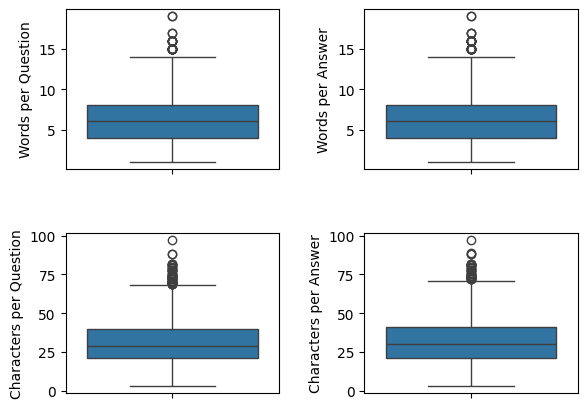

In [67]:
# Function to count the number of words in a sentence
def count_words(text):
    words = text.split() # extract the words from text
    num_words = len(words) # count the number of words
    return num_words

# Function to count the number of characters in a sentence
def count_characters(text):
    num_char = len(text) # count the number of chatacters
    return num_char

num_words_question = chatbot_df['question'].apply(count_words)
num_words_answer = chatbot_df['answer'].apply(count_words)
num_char_question = chatbot_df['question'].apply(count_characters)
num_char_answer = chatbot_df['answer'].apply(count_characters)

plt.subplot(2, 2, 1)
sns.boxplot(y = num_words_question)
plt.ylabel('Words per Question')
plt.subplot(2, 2, 2)
sns.boxplot(y = num_words_answer)
plt.ylabel('Words per Answer')
plt.subplot(2, 2, 3)
sns.boxplot(y = num_char_question)
plt.ylabel('Characters per Question')
plt.subplot(2, 2, 4)
sns.boxplot(y = num_char_answer)
plt.ylabel('Characters per Answer')
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.4, hspace = 0.4)
plt.savefig('Figure3.png')
plt.show()

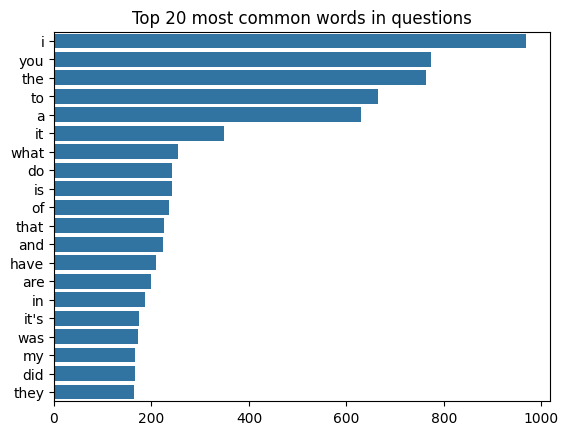

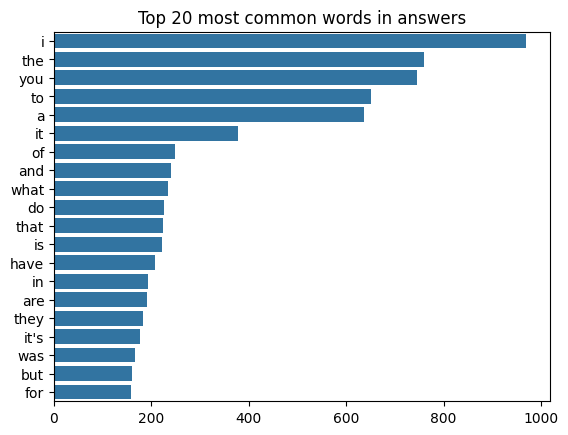

In [68]:
# Identify the most frequent words in the question/answer columns

# Function to get the list of words in a sentence
def list_words(text):
    words = text.split() # extract the words from text
    return words

# Function to get the top 20 most common words and their counts
def words_freq(mostcommon):
    words = []
    counts = []
    for word, count in mostcommon:
        words.append(word)
        counts.append(count)
    return words, counts

words_question = chatbot_df['question'].apply(list_words)
words_answer = chatbot_df['answer'].apply(list_words)
corpus_question = []
for jj in range(len(words_question)):
    corpus_question += words_question[jj] # all the words in all the questions
corpus_answer = []
for jj in range(len(words_answer)):
    corpus_answer += words_answer[jj] # all the words in all the answers
mostcommon_words_question = Counter(corpus_question).most_common(20) # 20 most common words in all the questions
mostcommon_words_answer = Counter(corpus_answer).most_common(20) # 20 most common words in all the answers
words_question, counts_question = words_freq(mostcommon_words_question) # top 20 most common words and their counts in questions
words_answer, counts_answer = words_freq(mostcommon_words_answer) # top 20 most common words and their counts in answers

sns.barplot(x = counts_question, y = words_question)
plt.title('Top 20 most common words in questions')
plt.show()

sns.barplot(x = counts_answer, y = words_answer)
plt.title('Top 20 most common words in answers')
plt.show()

#### Preprocessing

In order to replace contractions, we adopted the same procedure described in Replace apostrophe/short words in python (n.d.). 

References: 

Replace apostrophe/short words in python. (n.d.). Stack Overflow. Retrieved July 24, 2024, from https://owl.purdue.edu/owl/research_and_citation/apa_style/apa_formatting_and_style_guide/reference_list_electronic_sources.html

In [69]:
# List of common contractions 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

# Function to replace contractions, remove punctuation and apply lowercase
def clear_text(text):
    for word in text.split(): # remove contractions and apply lowercase
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    return text

chatbot_df['question'] = chatbot_df['question'].apply(clear_text)
chatbot_df['answer'] = chatbot_df['answer'].apply(clear_text)
chatbot_df.head()

,question,answer
0,hi how are you doing,I am fine how about yourself
1,I am fine how about yourself,I am pretty good thanks for asking
2,I am pretty good thanks for asking,no problem so how have you been
3,no problem so how have you been,I have been great what about you
4,I have been great what about you,I have been good I am in school right now


In [70]:
# Tokenization
chatbot_df['token_question'] = chatbot_df['question'].apply(nltk.word_tokenize)
chatbot_df['token_answer'] = chatbot_df['answer'].apply(nltk.word_tokenize)
chatbot_df.head()

,question,answer,token_question,token_answer
0,hi how are you doing,I am fine how about yourself,"[hi, how, are, you, doing]","[I, am, fine, how, about, yourself]"
1,I am fine how about yourself,I am pretty good thanks for asking,"[I, am, fine, how, about, yourself]","[I, am, pretty, good, thanks, for, asking]"
2,I am pretty good thanks for asking,no problem so how have you been,"[I, am, pretty, good, thanks, for, asking]","[no, problem, so, how, have, you, been]"
3,no problem so how have you been,I have been great what about you,"[no, problem, so, how, have, you, been]","[I, have, been, great, what, about, you]"
4,I have been great what about you,I have been good I am in school right now,"[I, have, been, great, what, about, you]","[I, have, been, good, I, am, in, school, right..."


In [71]:
# Lemmatization

# Function to obtain the right positional tagging prior to lemmatization
# Same function presented in Python – Lemmatization Approaches with Examples (n.d.)
def right_pos_tagging(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Obtain the right positional tagging prior to lemmatization
# Positional tags were modified as suggested by Python – Lemmatization Approaches with Examples (n.d.)

tokens = chatbot_df['token_question']
new_tag_tokens = []
for jj in range(len(tokens)):
    tokens_jj = tokens[jj] # tokens at the jjth row
    tag_tokens_jj = nltk.pos_tag(tokens_jj) # POS tags for the generic tokens_jj
    new_tag_tokens.append(list(map(lambda x: (x[0], right_pos_tagging(x[1])), tag_tokens_jj))) # modified POS tags for the generic tokens_jj (as Python – Lemmatization Approaches with Examples, n.d.)
tagged_token_question = new_tag_tokens

tokens = chatbot_df['token_answer']
new_tag_tokens = []
for jj in range(len(tokens)):
    tokens_jj = tokens[jj] # tokens at the jjth row
    tag_tokens_jj = nltk.pos_tag(tokens_jj) # POS tags for the generic tokens_jj
    new_tag_tokens.append(list(map(lambda x: (x[0], right_pos_tagging(x[1])), tag_tokens_jj))) # modified POS tags for the generic tokens_jj (as Python – Lemmatization Approaches with Examples, n.d.)
tagged_token_answer = new_tag_tokens

# Implement lemmatization on the tokens
# A procedure similar to the one described in Python – Lemmatization Approaches with Examples (n.d.) and by Kumar (2021) was applied

wnl = WordNetLemmatizer()
Lemmatization = []
for jj in range(len(tagged_token_question)):
    lemmatized_question = []
# Same lines of codes used in Python – Lemmatization Approaches with Examples (n.d.)
    for word, tag in tagged_token_question[jj]:
        if tag is None:
            lemmatized_question.append(word)
        else:
            lemmatized_question.append(wnl.lemmatize(word, tag))
    Lemmatization.append(lemmatized_question)
chatbot_df['lem_question'] = Lemmatization

Lemmatization = []
for jj in range(len(tagged_token_answer)):
    lemmatized_answer = []
# Same lines of codes used in Python – Lemmatization Approaches with Examples (n.d.)
    for word, tag in tagged_token_answer[jj]:
        if tag is None:
            lemmatized_answer.append(word)
        else:
            lemmatized_answer.append(wnl.lemmatize(word, tag))
    Lemmatization.append(lemmatized_answer)
chatbot_df['lem_answer'] = Lemmatization

chatbot_df.head()

# References
# Kumar, R. (2021, August 6). Natural Language Processing | Text Preprocessing | Spacy vs NLTK. Medium. https://medium.com/nerd-for-tech/natural-language-processing-text-preprocessing-spacy-vs-nltk-b70b734f5560
# Python – Lemmatization Approaches with Examples. (n.d.). Geeks for Geeks.  https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

,question,answer,token_question,token_answer,lem_question,lem_answer
0,hi how are you doing,I am fine how about yourself,"[hi, how, are, you, doing]","[I, am, fine, how, about, yourself]","[hi, how, be, you, do]","[I, be, fine, how, about, yourself]"
1,I am fine how about yourself,I am pretty good thanks for asking,"[I, am, fine, how, about, yourself]","[I, am, pretty, good, thanks, for, asking]","[I, be, fine, how, about, yourself]","[I, be, pretty, good, thanks, for, ask]"
2,I am pretty good thanks for asking,no problem so how have you been,"[I, am, pretty, good, thanks, for, asking]","[no, problem, so, how, have, you, been]","[I, be, pretty, good, thanks, for, ask]","[no, problem, so, how, have, you, be]"
3,no problem so how have you been,I have been great what about you,"[no, problem, so, how, have, you, been]","[I, have, been, great, what, about, you]","[no, problem, so, how, have, you, be]","[I, have, be, great, what, about, you]"
4,I have been great what about you,I have been good I am in school right now,"[I, have, been, great, what, about, you]","[I, have, been, good, I, am, in, school, right...","[I, have, be, great, what, about, you]","[I, have, be, good, I, be, in, school, right, ..."


## T5 Fine Tuning

This section was created based on a combination of the following references.

References: 
https://www.kaggle.com/code/ajinkyabhandare2002/fine-tune-flan-t5-base-for-chat-with-peft-lora

#### Import tokenizer and model

In [72]:
model_name = 'google/flan-t5-base'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype = torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [73]:
# Check number of parameters to train
def model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(model_parameters(model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


### Preprocess Data for Retrain

In [74]:
chatbot_df=chatbot_df.drop(columns=['token_question','token_answer','lem_question','lem_answer'])

In [75]:
train_data, temp_data = train_test_split(chatbot_df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

In [76]:
from datasets import DatasetDict
working_dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

In [77]:
working_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 2980
    })
    validation: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 372
    })
    test: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 373
    })
})

In [78]:
working_dataset["train"] = working_dataset["train"].remove_columns("__index_level_0__")
working_dataset["validation"] = working_dataset["validation"].remove_columns("__index_level_0__")
working_dataset["test"] = working_dataset["test"].remove_columns("__index_level_0__")
working_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 2980
    })
    validation: Dataset({
        features: ['question', 'answer'],
        num_rows: 372
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 373
    })
})

In [79]:
def tokenize_function(example):
    # start_prompt = 'Answer the following question.\n\n'
    # end_prompt = '\n\nSummary: '
    # prompt = [start_prompt + question + end_prompt for question in example["question"]]
    example['input_ids'] = tokenizer(example['question'], padding='max_length', truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["answer"], padding='max_length', truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = working_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['question', 'answer'])

Map: 100%|██████████| 373/373 [00:00<00:00, 7171.89 examples/s]


In [80]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 2980
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 372
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 373
    })
})

In [81]:
# # Subsample the dataset to save time on training
# tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

In [82]:
print(f"Shapes of the datasets:")
print(f"Dataset: {tokenized_datasets.shape}")
print(tokenized_datasets)

Shapes of the datasets:
Dataset: {'train': (2980, 2), 'validation': (372, 2), 'test': (373, 2)}
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 2980
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 372
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 373
    })
})


#### Setup the PEFT/LoRA model for Fine-Tuning

In [83]:
lora_config = LoraConfig(
    r=8, # Rank
    lora_alpha=8,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

#### Add LoRA adapter layers/prameters to the LLM model to be trained

In [84]:
peft_model = get_peft_model(model, lora_config)
print(model_parameters(peft_model))

trainable model parameters: 884736
all model parameters: 248462592
percentage of trainable model parameters: 0.36%


#### Train PEFT Adapter

In [85]:
# Define Trianing Arguements
output_dir = f'./peft-conversation-training'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=20,
    logging_steps=1
)
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

#### Train the model

In [86]:
try:
    peft_trainer.train()
except OutOfMemoryError:
    print("Training interrupted due to OOM. Saving model checkpoint...")
    peft_model_path="./peft-conversation-checkpoint-local"
    peft_trainer.model.save_pretrained(peft_model_path)
    tokenizer.save_pretrained(peft_model_path)
    print("Checkpoint saved. You can resume training from here.")

  0%|          | 2/7460 [00:00<43:34,  2.85it/s]  

{'loss': 41.5, 'grad_norm': 3.540588617324829, 'learning_rate': 0.0009998659517426274, 'epoch': 0.0}


  0%|          | 3/7460 [00:00<34:34,  3.59it/s]

{'loss': 42.0, 'grad_norm': 4.72300910949707, 'learning_rate': 0.0009997319034852547, 'epoch': 0.01}


  0%|          | 4/7460 [00:01<30:20,  4.10it/s]

{'loss': 41.75, 'grad_norm': 6.584471225738525, 'learning_rate': 0.000999597855227882, 'epoch': 0.01}


  0%|          | 5/7460 [00:01<27:59,  4.44it/s]

{'loss': 40.25, 'grad_norm': 9.294511795043945, 'learning_rate': 0.0009994638069705094, 'epoch': 0.01}


  0%|          | 6/7460 [00:01<26:36,  4.67it/s]

{'loss': 37.25, 'grad_norm': 8.773184776306152, 'learning_rate': 0.0009993297587131368, 'epoch': 0.01}


  0%|          | 7/7460 [00:01<25:41,  4.83it/s]

{'loss': 34.5, 'grad_norm': 7.3888959884643555, 'learning_rate': 0.0009991957104557641, 'epoch': 0.02}


  0%|          | 8/7460 [00:01<25:04,  4.95it/s]

{'loss': 33.25, 'grad_norm': 8.191170692443848, 'learning_rate': 0.0009990616621983915, 'epoch': 0.02}


  0%|          | 9/7460 [00:02<24:34,  5.05it/s]

{'loss': 31.375, 'grad_norm': 7.250532627105713, 'learning_rate': 0.0009989276139410188, 'epoch': 0.02}


  0%|          | 10/7460 [00:02<24:23,  5.09it/s]

{'loss': 29.75, 'grad_norm': 7.146060466766357, 'learning_rate': 0.0009987935656836462, 'epoch': 0.02}


  0%|          | 11/7460 [00:02<24:13,  5.12it/s]

{'loss': 28.25, 'grad_norm': 7.641894817352295, 'learning_rate': 0.0009986595174262735, 'epoch': 0.03}


  0%|          | 12/7460 [00:02<24:06,  5.15it/s]

{'loss': 27.0, 'grad_norm': 6.929529190063477, 'learning_rate': 0.0009985254691689009, 'epoch': 0.03}


  0%|          | 13/7460 [00:02<24:01,  5.17it/s]

{'loss': 25.375, 'grad_norm': 7.8432440757751465, 'learning_rate': 0.000998391420911528, 'epoch': 0.03}


  0%|          | 14/7460 [00:03<23:54,  5.19it/s]

{'loss': 24.25, 'grad_norm': 7.430029392242432, 'learning_rate': 0.0009982573726541556, 'epoch': 0.03}


  0%|          | 15/7460 [00:03<23:50,  5.20it/s]

{'loss': 22.875, 'grad_norm': 7.917144298553467, 'learning_rate': 0.000998123324396783, 'epoch': 0.04}


  0%|          | 16/7460 [00:03<23:53,  5.19it/s]

{'loss': 21.625, 'grad_norm': 7.060214996337891, 'learning_rate': 0.0009979892761394103, 'epoch': 0.04}


  0%|          | 17/7460 [00:03<23:48,  5.21it/s]

{'loss': 20.25, 'grad_norm': 7.051948547363281, 'learning_rate': 0.0009978552278820374, 'epoch': 0.04}


  0%|          | 18/7460 [00:03<23:47,  5.21it/s]

{'loss': 18.625, 'grad_norm': 7.962873458862305, 'learning_rate': 0.000997721179624665, 'epoch': 0.05}


  0%|          | 18/7460 [00:03<23:47,  5.21it/s]

{'loss': 16.5, 'grad_norm': 7.950080871582031, 'learning_rate': 0.0009975871313672923, 'epoch': 0.05}


  0%|          | 20/7460 [00:04<23:41,  5.23it/s]

{'loss': 14.6875, 'grad_norm': 8.271089553833008, 'learning_rate': 0.0009974530831099195, 'epoch': 0.05}


  0%|          | 21/7460 [00:04<23:41,  5.23it/s]

{'loss': 12.5625, 'grad_norm': 9.337546348571777, 'learning_rate': 0.0009973190348525468, 'epoch': 0.05}


  0%|          | 22/7460 [00:04<23:43,  5.22it/s]

{'loss': 10.1875, 'grad_norm': 8.923891067504883, 'learning_rate': 0.0009971849865951744, 'epoch': 0.06}


  0%|          | 23/7460 [00:04<23:44,  5.22it/s]

{'loss': 7.75, 'grad_norm': 8.043412208557129, 'learning_rate': 0.0009970509383378015, 'epoch': 0.06}


  0%|          | 24/7460 [00:04<23:47,  5.21it/s]

{'loss': 6.0, 'grad_norm': 4.771141529083252, 'learning_rate': 0.0009969168900804289, 'epoch': 0.06}


  0%|          | 25/7460 [00:05<23:41,  5.23it/s]

{'loss': 5.25, 'grad_norm': 1.8776456117630005, 'learning_rate': 0.0009967828418230562, 'epoch': 0.06}


  0%|          | 26/7460 [00:05<23:42,  5.22it/s]

{'loss': 4.9688, 'grad_norm': 1.0028531551361084, 'learning_rate': 0.0009966487935656838, 'epoch': 0.07}


  0%|          | 27/7460 [00:05<23:44,  5.22it/s]

{'loss': 4.8125, 'grad_norm': 0.7033523917198181, 'learning_rate': 0.000996514745308311, 'epoch': 0.07}


  0%|          | 28/7460 [00:05<23:39,  5.24it/s]

{'loss': 4.7188, 'grad_norm': 0.5611095428466797, 'learning_rate': 0.0009963806970509383, 'epoch': 0.07}


  0%|          | 29/7460 [00:05<23:38,  5.24it/s]

{'loss': 4.6562, 'grad_norm': 0.44333451986312866, 'learning_rate': 0.0009962466487935656, 'epoch': 0.08}


  0%|          | 30/7460 [00:06<23:37,  5.24it/s]

{'loss': 4.5938, 'grad_norm': 0.33524057269096375, 'learning_rate': 0.000996112600536193, 'epoch': 0.08}


  0%|          | 31/7460 [00:06<23:35,  5.25it/s]

{'loss': 4.5312, 'grad_norm': 0.2790393829345703, 'learning_rate': 0.0009959785522788203, 'epoch': 0.08}


  0%|          | 32/7460 [00:06<23:35,  5.25it/s]

{'loss': 4.5312, 'grad_norm': 0.2915394902229309, 'learning_rate': 0.0009958445040214477, 'epoch': 0.08}


  0%|          | 33/7460 [00:06<23:32,  5.26it/s]

{'loss': 4.5, 'grad_norm': 0.5280970335006714, 'learning_rate': 0.000995710455764075, 'epoch': 0.09}


  0%|          | 34/7460 [00:06<23:36,  5.24it/s]

{'loss': 4.5, 'grad_norm': 4.3546977043151855, 'learning_rate': 0.0009955764075067024, 'epoch': 0.09}


  0%|          | 35/7460 [00:07<23:41,  5.22it/s]

{'loss': 4.4375, 'grad_norm': 0.34740304946899414, 'learning_rate': 0.0009954423592493297, 'epoch': 0.09}


  0%|          | 36/7460 [00:07<23:38,  5.23it/s]

{'loss': 4.4062, 'grad_norm': 0.2959546446800232, 'learning_rate': 0.000995308310991957, 'epoch': 0.09}


  0%|          | 37/7460 [00:07<23:36,  5.24it/s]

{'loss': 4.375, 'grad_norm': 0.29226675629615784, 'learning_rate': 0.0009951742627345845, 'epoch': 0.1}


  1%|          | 38/7460 [00:07<23:38,  5.23it/s]

{'loss': 4.3438, 'grad_norm': 0.30515602231025696, 'learning_rate': 0.0009950402144772118, 'epoch': 0.1}


  1%|          | 39/7460 [00:07<23:41,  5.22it/s]

{'loss': 4.2812, 'grad_norm': 0.27250227332115173, 'learning_rate': 0.0009949061662198392, 'epoch': 0.1}


  1%|          | 39/7460 [00:07<23:41,  5.22it/s]

{'loss': 4.2812, 'grad_norm': 0.3251338303089142, 'learning_rate': 0.0009947721179624665, 'epoch': 0.1}


  1%|          | 41/7460 [00:08<23:41,  5.22it/s]

{'loss': 4.1875, 'grad_norm': 0.33926358819007874, 'learning_rate': 0.0009946380697050939, 'epoch': 0.11}


  1%|          | 42/7460 [00:08<23:37,  5.23it/s]

{'loss': 4.0938, 'grad_norm': 0.3730732500553131, 'learning_rate': 0.0009945040214477212, 'epoch': 0.11}


  1%|          | 43/7460 [00:08<23:37,  5.23it/s]

{'loss': 4.0625, 'grad_norm': 0.38963112235069275, 'learning_rate': 0.0009943699731903486, 'epoch': 0.11}


  1%|          | 44/7460 [00:08<23:37,  5.23it/s]

{'loss': 4.0312, 'grad_norm': 0.6082377433776855, 'learning_rate': 0.000994235924932976, 'epoch': 0.12}


  1%|          | 45/7460 [00:08<23:39,  5.22it/s]

{'loss': 3.875, 'grad_norm': 0.4449966847896576, 'learning_rate': 0.0009941018766756033, 'epoch': 0.12}


  1%|          | 46/7460 [00:09<23:40,  5.22it/s]

{'loss': 3.7812, 'grad_norm': 0.49190008640289307, 'learning_rate': 0.0009939678284182306, 'epoch': 0.12}


  1%|          | 47/7460 [00:09<23:45,  5.20it/s]

{'loss': 3.6719, 'grad_norm': 0.8475496172904968, 'learning_rate': 0.000993833780160858, 'epoch': 0.12}


  1%|          | 48/7460 [00:09<23:49,  5.18it/s]

{'loss': 3.5156, 'grad_norm': 0.7299051880836487, 'learning_rate': 0.0009936997319034853, 'epoch': 0.13}


  1%|          | 49/7460 [00:09<23:45,  5.20it/s]

{'loss': 3.3594, 'grad_norm': 0.9130630493164062, 'learning_rate': 0.0009935656836461127, 'epoch': 0.13}


  1%|          | 50/7460 [00:09<23:44,  5.20it/s]

{'loss': 3.2031, 'grad_norm': 0.7269307374954224, 'learning_rate': 0.00099343163538874, 'epoch': 0.13}


  1%|          | 51/7460 [00:10<23:44,  5.20it/s]

{'loss': 3.0156, 'grad_norm': 0.8078575730323792, 'learning_rate': 0.0009932975871313674, 'epoch': 0.13}


  1%|          | 52/7460 [00:10<23:46,  5.19it/s]

{'loss': 2.875, 'grad_norm': 1.555580735206604, 'learning_rate': 0.0009931635388739947, 'epoch': 0.14}


  1%|          | 53/7460 [00:10<23:45,  5.20it/s]

{'loss': 2.6719, 'grad_norm': 0.8873000144958496, 'learning_rate': 0.0009930294906166219, 'epoch': 0.14}


  1%|          | 54/7460 [00:10<23:43,  5.20it/s]

{'loss': 2.5938, 'grad_norm': 1.1035804748535156, 'learning_rate': 0.0009928954423592494, 'epoch': 0.14}


  1%|          | 55/7460 [00:10<23:40,  5.21it/s]

{'loss': 2.5156, 'grad_norm': 1.0949409008026123, 'learning_rate': 0.0009927613941018768, 'epoch': 0.14}


  1%|          | 56/7460 [00:11<23:36,  5.23it/s]

{'loss': 2.3281, 'grad_norm': 0.9989767074584961, 'learning_rate': 0.0009926273458445041, 'epoch': 0.15}


  1%|          | 57/7460 [00:11<23:33,  5.24it/s]

{'loss': 2.1562, 'grad_norm': 0.7162496447563171, 'learning_rate': 0.0009924932975871313, 'epoch': 0.15}


  1%|          | 58/7460 [00:11<23:29,  5.25it/s]

{'loss': 2.125, 'grad_norm': 1.661233901977539, 'learning_rate': 0.0009923592493297588, 'epoch': 0.15}


  1%|          | 59/7460 [00:11<23:26,  5.26it/s]

{'loss': 1.9375, 'grad_norm': 1.1636630296707153, 'learning_rate': 0.0009922252010723862, 'epoch': 0.16}


  1%|          | 60/7460 [00:11<23:28,  5.26it/s]

{'loss': 1.8203, 'grad_norm': 0.7065850496292114, 'learning_rate': 0.0009920911528150133, 'epoch': 0.16}


  1%|          | 61/7460 [00:12<23:31,  5.24it/s]

{'loss': 1.7656, 'grad_norm': 0.6203429102897644, 'learning_rate': 0.0009919571045576407, 'epoch': 0.16}


  1%|          | 62/7460 [00:12<23:29,  5.25it/s]

{'loss': 1.5938, 'grad_norm': 0.6514832377433777, 'learning_rate': 0.0009918230563002682, 'epoch': 0.16}


  1%|          | 63/7460 [00:12<23:28,  5.25it/s]

{'loss': 1.5391, 'grad_norm': 0.4072851836681366, 'learning_rate': 0.0009916890080428954, 'epoch': 0.17}


  1%|          | 64/7460 [00:12<23:30,  5.24it/s]

{'loss': 1.4766, 'grad_norm': 0.7072845697402954, 'learning_rate': 0.0009915549597855227, 'epoch': 0.17}


  1%|          | 65/7460 [00:12<23:34,  5.23it/s]

{'loss': 1.375, 'grad_norm': 0.3750796914100647, 'learning_rate': 0.00099142091152815, 'epoch': 0.17}


  1%|          | 66/7460 [00:13<23:33,  5.23it/s]

{'loss': 1.3047, 'grad_norm': 0.48194584250450134, 'learning_rate': 0.0009912868632707776, 'epoch': 0.17}


  1%|          | 67/7460 [00:13<23:36,  5.22it/s]

{'loss': 1.2344, 'grad_norm': 0.6621848940849304, 'learning_rate': 0.0009911528150134048, 'epoch': 0.18}


  1%|          | 67/7460 [00:13<23:36,  5.22it/s]

{'loss': 1.1328, 'grad_norm': 0.4775824546813965, 'learning_rate': 0.0009910187667560321, 'epoch': 0.18}


  1%|          | 69/7460 [00:13<23:38,  5.21it/s]

{'loss': 1.0859, 'grad_norm': 0.5136275291442871, 'learning_rate': 0.0009908847184986595, 'epoch': 0.18}


  1%|          | 70/7460 [00:13<23:39,  5.21it/s]

{'loss': 1.0234, 'grad_norm': 0.42764419317245483, 'learning_rate': 0.0009907506702412868, 'epoch': 0.18}


  1%|          | 71/7460 [00:13<23:44,  5.19it/s]

{'loss': 0.9648, 'grad_norm': 0.40996482968330383, 'learning_rate': 0.0009906166219839142, 'epoch': 0.19}


  1%|          | 72/7460 [00:14<23:37,  5.21it/s]

{'loss': 0.9062, 'grad_norm': 0.3902532756328583, 'learning_rate': 0.0009904825737265415, 'epoch': 0.19}


  1%|          | 73/7460 [00:14<23:34,  5.22it/s]

{'loss': 0.8633, 'grad_norm': 0.2360163927078247, 'learning_rate': 0.0009903485254691689, 'epoch': 0.19}


  1%|          | 74/7460 [00:14<23:30,  5.23it/s]

{'loss': 0.8281, 'grad_norm': 0.2511802613735199, 'learning_rate': 0.0009902144772117962, 'epoch': 0.2}


  1%|          | 75/7460 [00:14<23:29,  5.24it/s]

{'loss': 0.8242, 'grad_norm': 0.33873429894447327, 'learning_rate': 0.0009900804289544236, 'epoch': 0.2}


  1%|          | 76/7460 [00:14<23:30,  5.23it/s]

{'loss': 0.8242, 'grad_norm': 0.34552180767059326, 'learning_rate': 0.000989946380697051, 'epoch': 0.2}


  1%|          | 77/7460 [00:15<23:33,  5.22it/s]

{'loss': 0.7617, 'grad_norm': 0.3867046535015106, 'learning_rate': 0.0009898123324396783, 'epoch': 0.2}


  1%|          | 78/7460 [00:15<23:31,  5.23it/s]

{'loss': 0.7109, 'grad_norm': 0.33812621235847473, 'learning_rate': 0.0009896782841823056, 'epoch': 0.21}


  1%|          | 79/7460 [00:15<23:30,  5.23it/s]

{'loss': 0.625, 'grad_norm': 0.23989556729793549, 'learning_rate': 0.000989544235924933, 'epoch': 0.21}


  1%|          | 80/7460 [00:15<23:25,  5.25it/s]

{'loss': 0.6172, 'grad_norm': 0.2240188866853714, 'learning_rate': 0.0009894101876675603, 'epoch': 0.21}


  1%|          | 81/7460 [00:15<23:28,  5.24it/s]

{'loss': 0.6055, 'grad_norm': 0.23503662645816803, 'learning_rate': 0.0009892761394101877, 'epoch': 0.21}


  1%|          | 82/7460 [00:16<23:26,  5.25it/s]

{'loss': 0.5742, 'grad_norm': 0.17451371252536774, 'learning_rate': 0.000989142091152815, 'epoch': 0.22}


  1%|          | 83/7460 [00:16<23:25,  5.25it/s]

{'loss': 0.543, 'grad_norm': 0.2728291451931, 'learning_rate': 0.0009890080428954424, 'epoch': 0.22}


  1%|          | 84/7460 [00:16<23:25,  5.25it/s]

{'loss': 0.5312, 'grad_norm': 0.1991293579339981, 'learning_rate': 0.0009888739946380697, 'epoch': 0.22}


  1%|          | 85/7460 [00:16<23:28,  5.24it/s]

{'loss': 0.543, 'grad_norm': 0.16871516406536102, 'learning_rate': 0.000988739946380697, 'epoch': 0.23}


  1%|          | 86/7460 [00:16<23:25,  5.24it/s]

{'loss': 0.5234, 'grad_norm': 0.17432451248168945, 'learning_rate': 0.0009886058981233244, 'epoch': 0.23}


  1%|          | 87/7460 [00:17<23:25,  5.25it/s]

{'loss': 0.5469, 'grad_norm': 0.2337716519832611, 'learning_rate': 0.0009884718498659518, 'epoch': 0.23}


  1%|          | 88/7460 [00:17<23:26,  5.24it/s]

{'loss': 0.4922, 'grad_norm': 0.14829373359680176, 'learning_rate': 0.0009883378016085792, 'epoch': 0.23}


  1%|          | 89/7460 [00:17<23:24,  5.25it/s]

{'loss': 0.5039, 'grad_norm': 0.1441175490617752, 'learning_rate': 0.0009882037533512065, 'epoch': 0.24}


  1%|          | 90/7460 [00:17<23:23,  5.25it/s]

{'loss': 0.4395, 'grad_norm': 0.16171078383922577, 'learning_rate': 0.0009880697050938339, 'epoch': 0.24}


  1%|          | 91/7460 [00:17<23:22,  5.26it/s]

{'loss': 0.4805, 'grad_norm': 0.2266691029071808, 'learning_rate': 0.0009879356568364612, 'epoch': 0.24}


  1%|          | 92/7460 [00:17<23:26,  5.24it/s]

{'loss': 0.4492, 'grad_norm': 0.18157051503658295, 'learning_rate': 0.0009878016085790886, 'epoch': 0.24}


  1%|          | 93/7460 [00:18<23:25,  5.24it/s]

{'loss': 0.4395, 'grad_norm': 0.1656389981508255, 'learning_rate': 0.0009876675603217157, 'epoch': 0.25}


  1%|▏         | 94/7460 [00:18<23:26,  5.24it/s]

{'loss': 0.4316, 'grad_norm': 0.15700966119766235, 'learning_rate': 0.0009875335120643433, 'epoch': 0.25}


  1%|▏         | 95/7460 [00:18<23:27,  5.23it/s]

{'loss': 0.4102, 'grad_norm': 0.17361965775489807, 'learning_rate': 0.0009873994638069706, 'epoch': 0.25}


  1%|▏         | 96/7460 [00:18<23:22,  5.25it/s]

{'loss': 0.3867, 'grad_norm': 0.17836876213550568, 'learning_rate': 0.000987265415549598, 'epoch': 0.25}


  1%|▏         | 97/7460 [00:18<23:21,  5.25it/s]

{'loss': 0.4023, 'grad_norm': 0.13549672067165375, 'learning_rate': 0.000987131367292225, 'epoch': 0.26}


  1%|▏         | 98/7460 [00:19<23:22,  5.25it/s]

{'loss': 0.3887, 'grad_norm': 0.14485055208206177, 'learning_rate': 0.0009869973190348527, 'epoch': 0.26}


  1%|▏         | 99/7460 [00:19<23:24,  5.24it/s]

{'loss': 0.3789, 'grad_norm': 0.12945520877838135, 'learning_rate': 0.00098686327077748, 'epoch': 0.26}


  1%|▏         | 100/7460 [00:19<23:27,  5.23it/s]

{'loss': 0.3887, 'grad_norm': 0.15209372341632843, 'learning_rate': 0.0009867292225201071, 'epoch': 0.27}


  1%|▏         | 101/7460 [00:19<23:24,  5.24it/s]

{'loss': 0.3848, 'grad_norm': 0.1139565035700798, 'learning_rate': 0.0009865951742627345, 'epoch': 0.27}


  1%|▏         | 102/7460 [00:19<23:19,  5.26it/s]

{'loss': 0.3555, 'grad_norm': 0.27896952629089355, 'learning_rate': 0.000986461126005362, 'epoch': 0.27}


  1%|▏         | 103/7460 [00:20<23:22,  5.25it/s]

{'loss': 0.334, 'grad_norm': 0.1697922796010971, 'learning_rate': 0.0009863270777479892, 'epoch': 0.27}


  1%|▏         | 104/7460 [00:20<23:26,  5.23it/s]

{'loss': 0.3066, 'grad_norm': 0.12468085438013077, 'learning_rate': 0.0009861930294906166, 'epoch': 0.28}


  1%|▏         | 105/7460 [00:20<23:27,  5.23it/s]

{'loss': 0.3398, 'grad_norm': 0.2588072121143341, 'learning_rate': 0.000986058981233244, 'epoch': 0.28}


  1%|▏         | 106/7460 [00:20<23:23,  5.24it/s]

{'loss': 0.3242, 'grad_norm': 0.5640435218811035, 'learning_rate': 0.0009859249329758715, 'epoch': 0.28}


  1%|▏         | 107/7460 [00:20<23:25,  5.23it/s]

{'loss': 0.3145, 'grad_norm': 0.17037329077720642, 'learning_rate': 0.0009857908847184986, 'epoch': 0.28}


  1%|▏         | 108/7460 [00:21<23:34,  5.20it/s]

{'loss': 0.3145, 'grad_norm': 0.17433741688728333, 'learning_rate': 0.000985656836461126, 'epoch': 0.29}


  1%|▏         | 109/7460 [00:21<23:44,  5.16it/s]

{'loss': 0.3418, 'grad_norm': 0.20100584626197815, 'learning_rate': 0.0009855227882037533, 'epoch': 0.29}


  1%|▏         | 109/7460 [00:21<23:44,  5.16it/s]

{'loss': 0.3145, 'grad_norm': 0.26578274369239807, 'learning_rate': 0.0009853887399463807, 'epoch': 0.29}


  1%|▏         | 111/7460 [00:21<23:42,  5.17it/s]

{'loss': 0.3105, 'grad_norm': 0.16557635366916656, 'learning_rate': 0.000985254691689008, 'epoch': 0.29}


  2%|▏         | 112/7460 [00:21<23:34,  5.20it/s]

{'loss': 0.2969, 'grad_norm': 0.12315461039543152, 'learning_rate': 0.0009851206434316354, 'epoch': 0.3}


  2%|▏         | 113/7460 [00:22<23:30,  5.21it/s]

{'loss': 0.2793, 'grad_norm': 0.08919364213943481, 'learning_rate': 0.0009849865951742627, 'epoch': 0.3}


  2%|▏         | 114/7460 [00:22<23:32,  5.20it/s]

{'loss': 0.3086, 'grad_norm': 0.13798633217811584, 'learning_rate': 0.00098485254691689, 'epoch': 0.3}


  2%|▏         | 115/7460 [00:22<23:36,  5.18it/s]

{'loss': 0.2578, 'grad_norm': 0.19487780332565308, 'learning_rate': 0.0009847184986595174, 'epoch': 0.31}


  2%|▏         | 116/7460 [00:22<23:32,  5.20it/s]

{'loss': 0.3105, 'grad_norm': 0.23842111229896545, 'learning_rate': 0.0009845844504021448, 'epoch': 0.31}


  2%|▏         | 117/7460 [00:22<23:31,  5.20it/s]

{'loss': 0.2598, 'grad_norm': 0.16315722465515137, 'learning_rate': 0.0009844504021447721, 'epoch': 0.31}


  2%|▏         | 118/7460 [00:22<23:30,  5.21it/s]

{'loss': 0.2949, 'grad_norm': 0.10584171116352081, 'learning_rate': 0.0009843163538873995, 'epoch': 0.31}


  2%|▏         | 119/7460 [00:23<23:24,  5.23it/s]

{'loss': 0.2559, 'grad_norm': 0.09410806745290756, 'learning_rate': 0.0009841823056300268, 'epoch': 0.32}


  2%|▏         | 120/7460 [00:23<23:27,  5.21it/s]

{'loss': 0.2832, 'grad_norm': 0.14540807902812958, 'learning_rate': 0.0009840482573726542, 'epoch': 0.32}


  2%|▏         | 121/7460 [00:23<23:31,  5.20it/s]

{'loss': 0.2695, 'grad_norm': 0.15671953558921814, 'learning_rate': 0.0009839142091152815, 'epoch': 0.32}


  2%|▏         | 122/7460 [00:23<23:34,  5.19it/s]

{'loss': 0.2656, 'grad_norm': 0.2464178204536438, 'learning_rate': 0.0009837801608579089, 'epoch': 0.32}


  2%|▏         | 123/7460 [00:23<23:30,  5.20it/s]

{'loss': 0.2441, 'grad_norm': 0.1388433575630188, 'learning_rate': 0.0009836461126005362, 'epoch': 0.33}


  2%|▏         | 124/7460 [00:24<23:34,  5.19it/s]

{'loss': 0.2637, 'grad_norm': 0.14772257208824158, 'learning_rate': 0.0009835120643431636, 'epoch': 0.33}


  2%|▏         | 125/7460 [00:24<23:29,  5.21it/s]

{'loss': 0.2295, 'grad_norm': 0.17980730533599854, 'learning_rate': 0.000983378016085791, 'epoch': 0.33}


  2%|▏         | 126/7460 [00:24<23:28,  5.21it/s]

{'loss': 0.3086, 'grad_norm': 0.18643304705619812, 'learning_rate': 0.0009832439678284183, 'epoch': 0.34}


  2%|▏         | 127/7460 [00:24<23:25,  5.22it/s]

{'loss': 0.2715, 'grad_norm': 0.10413794219493866, 'learning_rate': 0.0009831099195710456, 'epoch': 0.34}


  2%|▏         | 128/7460 [00:24<23:25,  5.22it/s]

{'loss': 0.252, 'grad_norm': 0.1272820681333542, 'learning_rate': 0.000982975871313673, 'epoch': 0.34}


  2%|▏         | 129/7460 [00:25<23:21,  5.23it/s]

{'loss': 0.2578, 'grad_norm': 0.08770628273487091, 'learning_rate': 0.0009828418230563003, 'epoch': 0.34}


  2%|▏         | 130/7460 [00:25<23:17,  5.25it/s]

{'loss': 0.2383, 'grad_norm': 0.14422929286956787, 'learning_rate': 0.0009827077747989277, 'epoch': 0.35}


  2%|▏         | 131/7460 [00:25<23:16,  5.25it/s]

{'loss': 0.208, 'grad_norm': 0.08616446703672409, 'learning_rate': 0.000982573726541555, 'epoch': 0.35}


  2%|▏         | 132/7460 [00:25<23:16,  5.25it/s]

{'loss': 0.2324, 'grad_norm': 0.13426929712295532, 'learning_rate': 0.0009824396782841824, 'epoch': 0.35}


  2%|▏         | 133/7460 [00:25<23:14,  5.25it/s]

{'loss': 0.2227, 'grad_norm': 0.07908683270215988, 'learning_rate': 0.0009823056300268097, 'epoch': 0.35}


  2%|▏         | 134/7460 [00:26<23:16,  5.25it/s]

{'loss': 0.2422, 'grad_norm': 0.07939261198043823, 'learning_rate': 0.000982171581769437, 'epoch': 0.36}


  2%|▏         | 135/7460 [00:26<23:19,  5.24it/s]

{'loss': 0.2754, 'grad_norm': 0.12821394205093384, 'learning_rate': 0.0009820375335120644, 'epoch': 0.36}


  2%|▏         | 136/7460 [00:26<23:18,  5.24it/s]

{'loss': 0.25, 'grad_norm': 0.11969850957393646, 'learning_rate': 0.0009819034852546918, 'epoch': 0.36}


  2%|▏         | 137/7460 [00:26<23:17,  5.24it/s]

{'loss': 0.209, 'grad_norm': 0.09008494764566422, 'learning_rate': 0.000981769436997319, 'epoch': 0.36}


  2%|▏         | 138/7460 [00:26<23:16,  5.24it/s]

{'loss': 0.2256, 'grad_norm': 0.10659562051296234, 'learning_rate': 0.0009816353887399465, 'epoch': 0.37}


  2%|▏         | 139/7460 [00:26<23:17,  5.24it/s]

{'loss': 0.2559, 'grad_norm': 0.12093283236026764, 'learning_rate': 0.0009815013404825739, 'epoch': 0.37}


  2%|▏         | 140/7460 [00:27<23:17,  5.24it/s]

{'loss': 0.2129, 'grad_norm': 0.16749097406864166, 'learning_rate': 0.000981367292225201, 'epoch': 0.37}


  2%|▏         | 141/7460 [00:27<23:12,  5.26it/s]

{'loss': 0.2197, 'grad_norm': 0.15692828595638275, 'learning_rate': 0.0009812332439678283, 'epoch': 0.38}


  2%|▏         | 142/7460 [00:27<23:10,  5.26it/s]

{'loss': 0.2305, 'grad_norm': 0.11410810798406601, 'learning_rate': 0.000981099195710456, 'epoch': 0.38}


  2%|▏         | 143/7460 [00:27<23:09,  5.27it/s]

{'loss': 0.2129, 'grad_norm': 0.08317958563566208, 'learning_rate': 0.0009809651474530833, 'epoch': 0.38}


  2%|▏         | 144/7460 [00:27<23:16,  5.24it/s]

{'loss': 0.1973, 'grad_norm': 0.10235722362995148, 'learning_rate': 0.0009808310991957104, 'epoch': 0.38}


  2%|▏         | 145/7460 [00:28<23:13,  5.25it/s]

{'loss': 0.2031, 'grad_norm': 0.12186950445175171, 'learning_rate': 0.0009806970509383377, 'epoch': 0.39}


  2%|▏         | 146/7460 [00:28<23:15,  5.24it/s]

{'loss': 0.2227, 'grad_norm': 0.13273116946220398, 'learning_rate': 0.0009805630026809653, 'epoch': 0.39}


  2%|▏         | 146/7460 [00:28<23:15,  5.24it/s]

{'loss': 0.2061, 'grad_norm': 0.07457688450813293, 'learning_rate': 0.0009804289544235924, 'epoch': 0.39}


  2%|▏         | 148/7460 [00:28<23:16,  5.24it/s]

{'loss': 0.1973, 'grad_norm': 0.07933424413204193, 'learning_rate': 0.0009802949061662198, 'epoch': 0.39}


  2%|▏         | 149/7460 [00:28<23:15,  5.24it/s]

{'loss': 0.1943, 'grad_norm': 0.14111022651195526, 'learning_rate': 0.0009801608579088471, 'epoch': 0.4}


  2%|▏         | 150/7460 [00:29<23:13,  5.25it/s]

{'loss': 0.1914, 'grad_norm': 0.0927814394235611, 'learning_rate': 0.0009800268096514745, 'epoch': 0.4}


  2%|▏         | 151/7460 [00:29<23:17,  5.23it/s]

{'loss': 0.2188, 'grad_norm': 0.08184442669153214, 'learning_rate': 0.0009798927613941018, 'epoch': 0.4}


  2%|▏         | 152/7460 [00:29<23:14,  5.24it/s]

{'loss': 0.21, 'grad_norm': 0.07818901538848877, 'learning_rate': 0.0009797587131367292, 'epoch': 0.4}


  2%|▏         | 153/7460 [00:29<23:36,  5.16it/s]

{'loss': 0.208, 'grad_norm': 0.06683226674795151, 'learning_rate': 0.0009796246648793566, 'epoch': 0.41}


  2%|▏         | 154/7460 [00:29<23:34,  5.17it/s]

{'loss': 0.2275, 'grad_norm': 0.12031484395265579, 'learning_rate': 0.000979490616621984, 'epoch': 0.41}


  2%|▏         | 155/7460 [00:30<23:28,  5.19it/s]

{'loss': 0.2051, 'grad_norm': 0.10629503428936005, 'learning_rate': 0.0009793565683646113, 'epoch': 0.41}


  2%|▏         | 156/7460 [00:30<23:23,  5.20it/s]

{'loss': 0.1924, 'grad_norm': 0.07786915451288223, 'learning_rate': 0.0009792225201072386, 'epoch': 0.42}


  2%|▏         | 157/7460 [00:30<23:22,  5.21it/s]

{'loss': 0.1807, 'grad_norm': 0.07029907405376434, 'learning_rate': 0.000979088471849866, 'epoch': 0.42}


  2%|▏         | 158/7460 [00:30<23:19,  5.22it/s]

{'loss': 0.1807, 'grad_norm': 0.092958465218544, 'learning_rate': 0.0009789544235924933, 'epoch': 0.42}


  2%|▏         | 159/7460 [00:30<23:17,  5.23it/s]

{'loss': 0.2012, 'grad_norm': 0.07455573230981827, 'learning_rate': 0.0009788203753351207, 'epoch': 0.42}


  2%|▏         | 160/7460 [00:31<23:19,  5.22it/s]

{'loss': 0.1982, 'grad_norm': 0.06763697415590286, 'learning_rate': 0.000978686327077748, 'epoch': 0.43}


{'loss': 0.1719, 'grad_norm': 0.07528448849916458, 'learning_rate': 0.0009785522788203754, 'epoch': 0.43}


{'loss': 0.1904, 'grad_norm': 0.05601627379655838, 'learning_rate': 0.0009784182305630027, 'epoch': 0.43}


  2%|▏         | 163/7460 [00:31<23:02,  5.28it/s]

{'loss': 0.207, 'grad_norm': 0.22274565696716309, 'learning_rate': 0.00097828418230563, 'epoch': 0.43}


  2%|▏         | 164/7460 [00:31<22:59,  5.29it/s]

{'loss': 0.1943, 'grad_norm': 0.054276835173368454, 'learning_rate': 0.0009781501340482574, 'epoch': 0.44}


  2%|▏         | 165/7460 [00:31<22:56,  5.30it/s]

{'loss': 0.1924, 'grad_norm': 0.059173695743083954, 'learning_rate': 0.0009780160857908848, 'epoch': 0.44}


  2%|▏         | 166/7460 [00:32<22:51,  5.32it/s]

{'loss': 0.1973, 'grad_norm': 0.09925375878810883, 'learning_rate': 0.0009778820375335121, 'epoch': 0.44}


  2%|▏         | 167/7460 [00:32<22:53,  5.31it/s]

{'loss': 0.1738, 'grad_norm': 0.07863076776266098, 'learning_rate': 0.0009777479892761395, 'epoch': 0.45}


  2%|▏         | 168/7460 [00:32<22:50,  5.32it/s]

{'loss': 0.1924, 'grad_norm': 0.08814053982496262, 'learning_rate': 0.0009776139410187668, 'epoch': 0.45}


  2%|▏         | 169/7460 [00:32<22:51,  5.31it/s]

{'loss': 0.1836, 'grad_norm': 0.0955774262547493, 'learning_rate': 0.0009774798927613942, 'epoch': 0.45}


  2%|▏         | 170/7460 [00:32<22:50,  5.32it/s]

{'loss': 0.2041, 'grad_norm': 0.06031288579106331, 'learning_rate': 0.0009773458445040215, 'epoch': 0.45}


  2%|▏         | 171/7460 [00:33<22:49,  5.32it/s]

{'loss': 0.1934, 'grad_norm': 0.13238437473773956, 'learning_rate': 0.0009772117962466489, 'epoch': 0.46}


  2%|▏         | 172/7460 [00:33<22:45,  5.34it/s]

{'loss': 0.2344, 'grad_norm': 0.12299300730228424, 'learning_rate': 0.0009770777479892762, 'epoch': 0.46}


  2%|▏         | 173/7460 [00:33<22:47,  5.33it/s]

{'loss': 0.1875, 'grad_norm': 0.07550016790628433, 'learning_rate': 0.0009769436997319036, 'epoch': 0.46}


  2%|▏         | 174/7460 [00:33<22:47,  5.33it/s]

{'loss': 0.1836, 'grad_norm': 0.06473159044981003, 'learning_rate': 0.000976809651474531, 'epoch': 0.46}


  2%|▏         | 175/7460 [00:33<22:52,  5.31it/s]

{'loss': 0.1855, 'grad_norm': 0.08187931030988693, 'learning_rate': 0.0009766756032171583, 'epoch': 0.47}


  2%|▏         | 176/7460 [00:34<22:54,  5.30it/s]

{'loss': 0.1914, 'grad_norm': 0.07872520387172699, 'learning_rate': 0.0009765415549597856, 'epoch': 0.47}


  2%|▏         | 177/7460 [00:34<22:56,  5.29it/s]

{'loss': 0.1738, 'grad_norm': 0.07472692430019379, 'learning_rate': 0.0009764075067024129, 'epoch': 0.47}


  2%|▏         | 178/7460 [00:34<22:56,  5.29it/s]

{'loss': 0.1885, 'grad_norm': 0.12533947825431824, 'learning_rate': 0.0009762734584450402, 'epoch': 0.47}


  2%|▏         | 179/7460 [00:34<22:52,  5.30it/s]

{'loss': 0.21, 'grad_norm': 0.17028136551380157, 'learning_rate': 0.0009761394101876676, 'epoch': 0.48}


  2%|▏         | 180/7460 [00:34<22:53,  5.30it/s]

{'loss': 0.1748, 'grad_norm': 0.0694860965013504, 'learning_rate': 0.0009760053619302949, 'epoch': 0.48}


  2%|▏         | 181/7460 [00:34<22:47,  5.32it/s]

{'loss': 0.2363, 'grad_norm': 0.12389783561229706, 'learning_rate': 0.0009758713136729223, 'epoch': 0.48}


  2%|▏         | 182/7460 [00:35<22:48,  5.32it/s]

{'loss': 0.1895, 'grad_norm': 0.12785138189792633, 'learning_rate': 0.0009757372654155496, 'epoch': 0.49}


  2%|▏         | 183/7460 [00:35<22:49,  5.31it/s]

{'loss': 0.1992, 'grad_norm': 0.10345453768968582, 'learning_rate': 0.000975603217158177, 'epoch': 0.49}


  2%|▏         | 184/7460 [00:35<22:48,  5.32it/s]

{'loss': 0.207, 'grad_norm': 0.1204739660024643, 'learning_rate': 0.0009754691689008043, 'epoch': 0.49}


  2%|▏         | 185/7460 [00:35<22:47,  5.32it/s]

{'loss': 0.1875, 'grad_norm': 0.1259925663471222, 'learning_rate': 0.0009753351206434317, 'epoch': 0.49}


  2%|▏         | 186/7460 [00:35<22:46,  5.32it/s]

{'loss': 0.1562, 'grad_norm': 0.09697255492210388, 'learning_rate': 0.000975201072386059, 'epoch': 0.5}


  3%|▎         | 187/7460 [00:36<22:47,  5.32it/s]

{'loss': 0.1611, 'grad_norm': 0.10563424229621887, 'learning_rate': 0.0009750670241286863, 'epoch': 0.5}


  3%|▎         | 188/7460 [00:36<22:47,  5.32it/s]

{'loss': 0.1738, 'grad_norm': 0.07309431582689285, 'learning_rate': 0.0009749329758713137, 'epoch': 0.5}


  3%|▎         | 189/7460 [00:36<22:45,  5.33it/s]

{'loss': 0.167, 'grad_norm': 0.05060162767767906, 'learning_rate': 0.0009747989276139411, 'epoch': 0.5}
{'loss': 0.2002, 'grad_norm': 0.06276578456163406, 'learning_rate': 0.0009746648793565683, 'epoch': 0.51}


  3%|▎         | 191/7460 [00:36<22:45,  5.32it/s]

{'loss': 0.1895, 'grad_norm': 0.091929592192173, 'learning_rate': 0.0009745308310991957, 'epoch': 0.51}


  3%|▎         | 192/7460 [00:37<22:44,  5.33it/s]

{'loss': 0.1729, 'grad_norm': 0.08125298470258713, 'learning_rate': 0.0009743967828418231, 'epoch': 0.51}


  3%|▎         | 193/7460 [00:37<22:42,  5.33it/s]

{'loss': 0.1943, 'grad_norm': 0.07413734495639801, 'learning_rate': 0.0009742627345844505, 'epoch': 0.51}


  3%|▎         | 194/7460 [00:37<22:44,  5.33it/s]

{'loss': 0.1699, 'grad_norm': 0.058162737637758255, 'learning_rate': 0.0009741286863270777, 'epoch': 0.52}


  3%|▎         | 195/7460 [00:37<22:43,  5.33it/s]

{'loss': 0.1396, 'grad_norm': 0.14260755479335785, 'learning_rate': 0.0009739946380697051, 'epoch': 0.52}


  3%|▎         | 196/7460 [00:37<22:45,  5.32it/s]

{'loss': 0.1768, 'grad_norm': 0.04830546677112579, 'learning_rate': 0.0009738605898123325, 'epoch': 0.52}


  3%|▎         | 197/7460 [00:37<22:46,  5.31it/s]

{'loss': 0.1758, 'grad_norm': 0.051431551575660706, 'learning_rate': 0.0009737265415549598, 'epoch': 0.53}


  3%|▎         | 198/7460 [00:38<22:49,  5.30it/s]

{'loss': 0.1709, 'grad_norm': 0.0576997734606266, 'learning_rate': 0.0009735924932975871, 'epoch': 0.53}


  3%|▎         | 199/7460 [00:38<22:50,  5.30it/s]

{'loss': 0.1719, 'grad_norm': 0.06395784020423889, 'learning_rate': 0.0009734584450402145, 'epoch': 0.53}


  3%|▎         | 200/7460 [00:38<22:51,  5.29it/s]

{'loss': 0.1895, 'grad_norm': 0.11793603003025055, 'learning_rate': 0.0009733243967828417, 'epoch': 0.53}


  3%|▎         | 201/7460 [00:38<22:52,  5.29it/s]

{'loss': 0.1689, 'grad_norm': 0.10165366530418396, 'learning_rate': 0.0009731903485254692, 'epoch': 0.54}


  3%|▎         | 202/7460 [00:38<22:48,  5.30it/s]

{'loss': 0.1543, 'grad_norm': 0.08632111549377441, 'learning_rate': 0.0009730563002680965, 'epoch': 0.54}


  3%|▎         | 203/7460 [00:39<22:47,  5.31it/s]

{'loss': 0.1865, 'grad_norm': 0.5107921957969666, 'learning_rate': 0.0009729222520107239, 'epoch': 0.54}


  3%|▎         | 204/7460 [00:39<22:54,  5.28it/s]

{'loss': 0.1826, 'grad_norm': 0.06610658764839172, 'learning_rate': 0.0009727882037533511, 'epoch': 0.54}


  3%|▎         | 205/7460 [00:39<22:53,  5.28it/s]

{'loss': 0.2031, 'grad_norm': 0.05525756999850273, 'learning_rate': 0.0009726541554959786, 'epoch': 0.55}


  3%|▎         | 206/7460 [00:39<22:52,  5.29it/s]

{'loss': 0.1426, 'grad_norm': 0.0640711858868599, 'learning_rate': 0.000972520107238606, 'epoch': 0.55}


  3%|▎         | 207/7460 [00:39<22:51,  5.29it/s]

{'loss': 0.1953, 'grad_norm': 0.12128368765115738, 'learning_rate': 0.0009723860589812332, 'epoch': 0.55}


  3%|▎         | 208/7460 [00:40<22:49,  5.30it/s]

{'loss': 0.1592, 'grad_norm': 0.09037240594625473, 'learning_rate': 0.0009722520107238605, 'epoch': 0.55}


  3%|▎         | 209/7460 [00:40<22:48,  5.30it/s]

{'loss': 0.1514, 'grad_norm': 0.04440678283572197, 'learning_rate': 0.000972117962466488, 'epoch': 0.56}


  3%|▎         | 210/7460 [00:40<22:45,  5.31it/s]

{'loss': 0.1514, 'grad_norm': 0.07616183906793594, 'learning_rate': 0.0009719839142091153, 'epoch': 0.56}


  3%|▎         | 211/7460 [00:40<22:44,  5.31it/s]

{'loss': 0.1523, 'grad_norm': 0.04533449560403824, 'learning_rate': 0.0009718498659517426, 'epoch': 0.56}


  3%|▎         | 212/7460 [00:40<22:48,  5.30it/s]

{'loss': 0.2178, 'grad_norm': 0.052794259041547775, 'learning_rate': 0.00097171581769437, 'epoch': 0.57}


  3%|▎         | 213/7460 [00:40<22:46,  5.30it/s]

{'loss': 0.165, 'grad_norm': 0.06077279523015022, 'learning_rate': 0.0009715817694369974, 'epoch': 0.57}


  3%|▎         | 214/7460 [00:41<22:46,  5.30it/s]

{'loss': 0.1416, 'grad_norm': 0.0728292465209961, 'learning_rate': 0.0009714477211796247, 'epoch': 0.57}


  3%|▎         | 215/7460 [00:41<22:42,  5.32it/s]

{'loss': 0.1543, 'grad_norm': 0.06488332897424698, 'learning_rate': 0.000971313672922252, 'epoch': 0.57}


  3%|▎         | 216/7460 [00:41<22:44,  5.31it/s]

{'loss': 0.1729, 'grad_norm': 0.07909402996301651, 'learning_rate': 0.0009711796246648794, 'epoch': 0.58}


  3%|▎         | 217/7460 [00:41<22:47,  5.30it/s]

{'loss': 0.168, 'grad_norm': 0.38440564274787903, 'learning_rate': 0.0009710455764075067, 'epoch': 0.58}


  3%|▎         | 218/7460 [00:41<22:49,  5.29it/s]

{'loss': 0.165, 'grad_norm': 0.03743378072977066, 'learning_rate': 0.0009709115281501341, 'epoch': 0.58}


  3%|▎         | 219/7460 [00:42<22:44,  5.30it/s]

{'loss': 0.166, 'grad_norm': 0.15533998608589172, 'learning_rate': 0.0009707774798927614, 'epoch': 0.58}


  3%|▎         | 220/7460 [00:42<22:39,  5.33it/s]

{'loss': 0.1807, 'grad_norm': 0.07183919101953506, 'learning_rate': 0.0009706434316353887, 'epoch': 0.59}
{'loss': 0.1934, 'grad_norm': 0.21606868505477905, 'learning_rate': 0.0009705093833780161, 'epoch': 0.59}


{'loss': 0.1826, 'grad_norm': 0.13229185342788696, 'learning_rate': 0.0009703753351206435, 'epoch': 0.59}


{'loss': 0.1504, 'grad_norm': 0.06995673477649689, 'learning_rate': 0.0009702412868632708, 'epoch': 0.6}


{'loss': 0.1611, 'grad_norm': 0.08882048726081848, 'learning_rate': 0.0009701072386058981, 'epoch': 0.6}


  3%|▎         | 225/7460 [00:43<22:38,  5.32it/s]

{'loss': 0.1768, 'grad_norm': 0.1046573743224144, 'learning_rate': 0.0009699731903485255, 'epoch': 0.6}


  3%|▎         | 226/7460 [00:43<22:42,  5.31it/s]

{'loss': 0.1484, 'grad_norm': 0.12123718857765198, 'learning_rate': 0.0009698391420911529, 'epoch': 0.6}


  3%|▎         | 227/7460 [00:43<22:40,  5.32it/s]

{'loss': 0.1445, 'grad_norm': 0.07214540988206863, 'learning_rate': 0.0009697050938337801, 'epoch': 0.61}


  3%|▎         | 228/7460 [00:43<22:37,  5.33it/s]

{'loss': 0.167, 'grad_norm': 0.0889737606048584, 'learning_rate': 0.0009695710455764075, 'epoch': 0.61}


  3%|▎         | 229/7460 [00:43<22:42,  5.31it/s]

{'loss': 0.1553, 'grad_norm': 0.06602708250284195, 'learning_rate': 0.0009694369973190349, 'epoch': 0.61}


  3%|▎         | 230/7460 [00:44<22:38,  5.32it/s]

{'loss': 0.1533, 'grad_norm': 0.04647380858659744, 'learning_rate': 0.0009693029490616622, 'epoch': 0.61}


  3%|▎         | 231/7460 [00:44<22:41,  5.31it/s]

{'loss': 0.1602, 'grad_norm': 0.07191140949726105, 'learning_rate': 0.0009691689008042895, 'epoch': 0.62}


  3%|▎         | 232/7460 [00:44<22:39,  5.32it/s]

{'loss': 0.1504, 'grad_norm': 0.1062944233417511, 'learning_rate': 0.0009690348525469169, 'epoch': 0.62}


  3%|▎         | 233/7460 [00:44<22:42,  5.31it/s]

{'loss': 0.1602, 'grad_norm': 0.0961613580584526, 'learning_rate': 0.0009689008042895443, 'epoch': 0.62}


  3%|▎         | 234/7460 [00:44<22:42,  5.31it/s]

{'loss': 0.166, 'grad_norm': 0.13539893925189972, 'learning_rate': 0.0009687667560321716, 'epoch': 0.62}


  3%|▎         | 235/7460 [00:45<22:41,  5.31it/s]

{'loss': 0.1396, 'grad_norm': 0.03888034075498581, 'learning_rate': 0.0009686327077747989, 'epoch': 0.63}


  3%|▎         | 236/7460 [00:45<22:35,  5.33it/s]

{'loss': 0.1631, 'grad_norm': 0.05189549922943115, 'learning_rate': 0.0009684986595174263, 'epoch': 0.63}


  3%|▎         | 237/7460 [00:45<22:32,  5.34it/s]

{'loss': 0.1523, 'grad_norm': 0.10795918852090836, 'learning_rate': 0.0009683646112600536, 'epoch': 0.63}


  3%|▎         | 238/7460 [00:45<22:33,  5.34it/s]

{'loss': 0.1504, 'grad_norm': 0.10842780023813248, 'learning_rate': 0.000968230563002681, 'epoch': 0.64}


  3%|▎         | 239/7460 [00:45<22:33,  5.34it/s]

{'loss': 0.1875, 'grad_norm': 0.06972959637641907, 'learning_rate': 0.0009680965147453083, 'epoch': 0.64}


  3%|▎         | 240/7460 [00:46<22:32,  5.34it/s]

{'loss': 0.1465, 'grad_norm': 0.09378324449062347, 'learning_rate': 0.0009679624664879356, 'epoch': 0.64}


  3%|▎         | 241/7460 [00:46<22:36,  5.32it/s]

{'loss': 0.1523, 'grad_norm': 0.06884749978780746, 'learning_rate': 0.000967828418230563, 'epoch': 0.64}


  3%|▎         | 242/7460 [00:46<22:37,  5.32it/s]

{'loss': 0.1807, 'grad_norm': 0.06607400625944138, 'learning_rate': 0.0009676943699731904, 'epoch': 0.65}


  3%|▎         | 243/7460 [00:46<22:39,  5.31it/s]

{'loss': 0.1592, 'grad_norm': 0.059123869985342026, 'learning_rate': 0.0009675603217158177, 'epoch': 0.65}


  3%|▎         | 244/7460 [00:46<22:41,  5.30it/s]

{'loss': 0.1377, 'grad_norm': 0.05536854639649391, 'learning_rate': 0.000967426273458445, 'epoch': 0.65}


  3%|▎         | 245/7460 [00:47<22:43,  5.29it/s]

{'loss': 0.1455, 'grad_norm': 0.1442079395055771, 'learning_rate': 0.0009672922252010724, 'epoch': 0.65}


  3%|▎         | 246/7460 [00:47<22:41,  5.30it/s]

{'loss': 0.1514, 'grad_norm': 0.05850913003087044, 'learning_rate': 0.0009671581769436998, 'epoch': 0.66}


  3%|▎         | 247/7460 [00:47<22:39,  5.31it/s]

{'loss': 0.1699, 'grad_norm': 0.05985257029533386, 'learning_rate': 0.000967024128686327, 'epoch': 0.66}


  3%|▎         | 248/7460 [00:47<22:35,  5.32it/s]

{'loss': 0.1553, 'grad_norm': 0.06454131752252579, 'learning_rate': 0.0009668900804289544, 'epoch': 0.66}
{'loss': 0.1396, 'grad_norm': 0.15214793384075165, 'learning_rate': 0.0009667560321715818, 'epoch': 0.66}


{'loss': 0.1582, 'grad_norm': 0.16895794868469238, 'learning_rate': 0.0009666219839142092, 'epoch': 0.67}


  3%|▎         | 251/7460 [00:48<22:38,  5.31it/s]

{'loss': 0.1514, 'grad_norm': 0.06625382602214813, 'learning_rate': 0.0009664879356568364, 'epoch': 0.67}


  3%|▎         | 252/7460 [00:48<22:34,  5.32it/s]

{'loss': 0.1592, 'grad_norm': 0.052392128854990005, 'learning_rate': 0.0009663538873994638, 'epoch': 0.67}


  3%|▎         | 253/7460 [00:48<22:32,  5.33it/s]

{'loss': 0.1279, 'grad_norm': 0.13841837644577026, 'learning_rate': 0.0009662198391420912, 'epoch': 0.68}


  3%|▎         | 254/7460 [00:48<22:34,  5.32it/s]

{'loss': 0.126, 'grad_norm': 0.10112112760543823, 'learning_rate': 0.0009660857908847185, 'epoch': 0.68}


  3%|▎         | 255/7460 [00:48<22:34,  5.32it/s]

{'loss': 0.1582, 'grad_norm': 0.12646111845970154, 'learning_rate': 0.0009659517426273458, 'epoch': 0.68}


{'loss': 0.1514, 'grad_norm': 0.05712766572833061, 'learning_rate': 0.0009658176943699732, 'epoch': 0.68}


{'loss': 0.1328, 'grad_norm': 0.07431182265281677, 'learning_rate': 0.0009656836461126005, 'epoch': 0.69}
{'loss': 0.1455, 'grad_norm': 0.05956992506980896, 'learning_rate': 0.0009655495978552279, 'epoch': 0.69}


  3%|▎         | 259/7460 [00:49<22:39,  5.30it/s]

{'loss': 0.1357, 'grad_norm': 0.041687026619911194, 'learning_rate': 0.0009654155495978552, 'epoch': 0.69}


  3%|▎         | 260/7460 [00:49<22:46,  5.27it/s]

{'loss': 0.1592, 'grad_norm': 0.1515607088804245, 'learning_rate': 0.0009652815013404826, 'epoch': 0.69}


  3%|▎         | 261/7460 [00:50<22:53,  5.24it/s]

{'loss': 0.1611, 'grad_norm': 0.07078513503074646, 'learning_rate': 0.00096514745308311, 'epoch': 0.7}


  4%|▎         | 262/7460 [00:50<22:56,  5.23it/s]

{'loss': 0.1152, 'grad_norm': 0.09823799878358841, 'learning_rate': 0.0009650134048257373, 'epoch': 0.7}


  4%|▎         | 263/7460 [00:50<22:54,  5.24it/s]

{'loss': 0.1377, 'grad_norm': 0.15402184426784515, 'learning_rate': 0.0009648793565683647, 'epoch': 0.7}


  4%|▎         | 264/7460 [00:50<22:51,  5.25it/s]

{'loss': 0.1426, 'grad_norm': 0.060125719755887985, 'learning_rate': 0.0009647453083109919, 'epoch': 0.71}


  4%|▎         | 265/7460 [00:50<22:50,  5.25it/s]

{'loss': 0.1484, 'grad_norm': 0.053110502660274506, 'learning_rate': 0.0009646112600536194, 'epoch': 0.71}


  4%|▎         | 266/7460 [00:50<22:53,  5.24it/s]

{'loss': 0.1514, 'grad_norm': 0.05417163670063019, 'learning_rate': 0.0009644772117962467, 'epoch': 0.71}


  4%|▎         | 267/7460 [00:51<22:55,  5.23it/s]

{'loss': 0.1426, 'grad_norm': 0.07200246304273605, 'learning_rate': 0.000964343163538874, 'epoch': 0.71}


  4%|▎         | 268/7460 [00:51<22:52,  5.24it/s]

{'loss': 0.1416, 'grad_norm': 0.09160767495632172, 'learning_rate': 0.0009642091152815013, 'epoch': 0.72}


  4%|▎         | 269/7460 [00:51<22:54,  5.23it/s]

{'loss': 0.1533, 'grad_norm': 0.08895628154277802, 'learning_rate': 0.0009640750670241288, 'epoch': 0.72}


  4%|▎         | 270/7460 [00:51<22:50,  5.25it/s]

{'loss': 0.1533, 'grad_norm': 0.04565335437655449, 'learning_rate': 0.0009639410187667561, 'epoch': 0.72}


  4%|▎         | 270/7460 [00:51<22:50,  5.25it/s]

{'loss': 0.1318, 'grad_norm': 0.058931052684783936, 'learning_rate': 0.0009638069705093834, 'epoch': 0.72}


  4%|▎         | 272/7460 [00:52<22:51,  5.24it/s]

{'loss': 0.1348, 'grad_norm': 0.05672529712319374, 'learning_rate': 0.0009636729222520107, 'epoch': 0.73}


  4%|▎         | 273/7460 [00:52<22:53,  5.23it/s]

{'loss': 0.1621, 'grad_norm': 0.18314839899539948, 'learning_rate': 0.0009635388739946382, 'epoch': 0.73}


  4%|▎         | 274/7460 [00:52<22:53,  5.23it/s]

{'loss': 0.1592, 'grad_norm': 0.5228511095046997, 'learning_rate': 0.0009634048257372654, 'epoch': 0.73}


  4%|▎         | 275/7460 [00:52<22:52,  5.24it/s]

{'loss': 0.1436, 'grad_norm': 0.0488118901848793, 'learning_rate': 0.0009632707774798928, 'epoch': 0.73}


  4%|▎         | 276/7460 [00:52<22:54,  5.22it/s]

{'loss': 0.1318, 'grad_norm': 0.0950026586651802, 'learning_rate': 0.0009631367292225201, 'epoch': 0.74}


  4%|▎         | 277/7460 [00:53<22:51,  5.24it/s]

{'loss': 0.1436, 'grad_norm': 0.041306935250759125, 'learning_rate': 0.0009630026809651475, 'epoch': 0.74}


  4%|▎         | 278/7460 [00:53<22:56,  5.22it/s]

{'loss': 0.1328, 'grad_norm': 0.07079888880252838, 'learning_rate': 0.0009628686327077748, 'epoch': 0.74}


  4%|▎         | 279/7460 [00:53<22:53,  5.23it/s]

{'loss': 0.1201, 'grad_norm': 0.13383598625659943, 'learning_rate': 0.0009627345844504022, 'epoch': 0.75}


  4%|▍         | 280/7460 [00:53<22:50,  5.24it/s]

{'loss': 0.1167, 'grad_norm': 0.1114443987607956, 'learning_rate': 0.0009626005361930295, 'epoch': 0.75}


  4%|▍         | 281/7460 [00:53<22:54,  5.22it/s]

{'loss': 0.1309, 'grad_norm': 0.06239044666290283, 'learning_rate': 0.0009624664879356569, 'epoch': 0.75}


  4%|▍         | 282/7460 [00:54<22:52,  5.23it/s]

{'loss': 0.1235, 'grad_norm': 0.11032449454069138, 'learning_rate': 0.0009623324396782842, 'epoch': 0.75}


  4%|▍         | 283/7460 [00:54<22:51,  5.23it/s]

{'loss': 0.1299, 'grad_norm': 0.05973755568265915, 'learning_rate': 0.0009621983914209116, 'epoch': 0.76}


  4%|▍         | 284/7460 [00:54<22:53,  5.22it/s]

{'loss': 0.1299, 'grad_norm': 0.2530041038990021, 'learning_rate': 0.0009620643431635388, 'epoch': 0.76}


  4%|▍         | 285/7460 [00:54<22:52,  5.23it/s]

{'loss': 0.1318, 'grad_norm': 0.08268143236637115, 'learning_rate': 0.0009619302949061663, 'epoch': 0.76}


  4%|▍         | 286/7460 [00:54<22:54,  5.22it/s]

{'loss': 0.1226, 'grad_norm': 0.06569971889257431, 'learning_rate': 0.0009617962466487936, 'epoch': 0.76}


  4%|▍         | 287/7460 [00:54<22:53,  5.22it/s]

{'loss': 0.125, 'grad_norm': 0.07569713145494461, 'learning_rate': 0.0009616621983914209, 'epoch': 0.77}


  4%|▍         | 288/7460 [00:55<22:53,  5.22it/s]

{'loss': 0.1201, 'grad_norm': 0.06058518588542938, 'learning_rate': 0.0009615281501340482, 'epoch': 0.77}


  4%|▍         | 289/7460 [00:55<22:50,  5.23it/s]

{'loss': 0.1128, 'grad_norm': 0.061551161110401154, 'learning_rate': 0.0009613941018766757, 'epoch': 0.77}


  4%|▍         | 290/7460 [00:55<22:52,  5.22it/s]

{'loss': 0.1289, 'grad_norm': 0.1252337396144867, 'learning_rate': 0.000961260053619303, 'epoch': 0.77}


  4%|▍         | 291/7460 [00:55<22:57,  5.20it/s]

{'loss': 0.1523, 'grad_norm': 0.10345388203859329, 'learning_rate': 0.0009611260053619303, 'epoch': 0.78}


  4%|▍         | 292/7460 [00:55<22:53,  5.22it/s]

{'loss': 0.125, 'grad_norm': 0.11704555153846741, 'learning_rate': 0.0009609919571045576, 'epoch': 0.78}


  4%|▍         | 293/7460 [00:56<22:53,  5.22it/s]

{'loss': 0.1484, 'grad_norm': 0.03571164235472679, 'learning_rate': 0.0009608579088471851, 'epoch': 0.78}


  4%|▍         | 294/7460 [00:56<22:57,  5.20it/s]

{'loss': 0.1309, 'grad_norm': 0.04291138797998428, 'learning_rate': 0.0009607238605898123, 'epoch': 0.79}


  4%|▍         | 295/7460 [00:56<22:53,  5.22it/s]

{'loss': 0.1445, 'grad_norm': 0.041070085018873215, 'learning_rate': 0.0009605898123324397, 'epoch': 0.79}


  4%|▍         | 296/7460 [00:56<22:53,  5.22it/s]

{'loss': 0.1289, 'grad_norm': 0.04947194457054138, 'learning_rate': 0.000960455764075067, 'epoch': 0.79}


  4%|▍         | 297/7460 [00:56<22:52,  5.22it/s]

{'loss': 0.1138, 'grad_norm': 0.0876191109418869, 'learning_rate': 0.0009603217158176944, 'epoch': 0.79}


  4%|▍         | 298/7460 [00:57<22:46,  5.24it/s]

{'loss': 0.1216, 'grad_norm': 0.05430908501148224, 'learning_rate': 0.0009601876675603217, 'epoch': 0.8}


  4%|▍         | 298/7460 [00:57<22:46,  5.24it/s]

{'loss': 0.1436, 'grad_norm': 0.04146624356508255, 'learning_rate': 0.0009600536193029491, 'epoch': 0.8}


  4%|▍         | 300/7460 [00:57<22:45,  5.24it/s]

{'loss': 0.1289, 'grad_norm': 0.0407087616622448, 'learning_rate': 0.0009599195710455764, 'epoch': 0.8}


  4%|▍         | 301/7460 [00:57<22:49,  5.23it/s]

{'loss': 0.1206, 'grad_norm': 0.04066099971532822, 'learning_rate': 0.0009597855227882038, 'epoch': 0.8}


  4%|▍         | 302/7460 [00:57<22:52,  5.22it/s]

{'loss': 0.1309, 'grad_norm': 0.041415996849536896, 'learning_rate': 0.0009596514745308311, 'epoch': 0.81}


  4%|▍         | 303/7460 [00:58<22:51,  5.22it/s]

{'loss': 0.1484, 'grad_norm': 0.05482206866145134, 'learning_rate': 0.0009595174262734585, 'epoch': 0.81}


  4%|▍         | 304/7460 [00:58<22:51,  5.22it/s]

{'loss': 0.1177, 'grad_norm': 0.1010948121547699, 'learning_rate': 0.0009593833780160857, 'epoch': 0.81}


  4%|▍         | 305/7460 [00:58<22:49,  5.23it/s]

{'loss': 0.1182, 'grad_norm': 0.07369653135538101, 'learning_rate': 0.0009592493297587132, 'epoch': 0.82}


  4%|▍         | 306/7460 [00:58<22:50,  5.22it/s]

{'loss': 0.1504, 'grad_norm': 0.04805721715092659, 'learning_rate': 0.0009591152815013405, 'epoch': 0.82}


  4%|▍         | 307/7460 [00:58<22:52,  5.21it/s]

{'loss': 0.1191, 'grad_norm': 0.03419725224375725, 'learning_rate': 0.0009589812332439678, 'epoch': 0.82}


  4%|▍         | 308/7460 [00:59<22:44,  5.24it/s]

{'loss': 0.1396, 'grad_norm': 0.058257412165403366, 'learning_rate': 0.0009588471849865951, 'epoch': 0.82}


  4%|▍         | 309/7460 [00:59<22:45,  5.24it/s]

{'loss': 0.1279, 'grad_norm': 0.0735170990228653, 'learning_rate': 0.0009587131367292226, 'epoch': 0.83}


  4%|▍         | 310/7460 [00:59<22:45,  5.24it/s]

{'loss': 0.1328, 'grad_norm': 0.04927891120314598, 'learning_rate': 0.00095857908847185, 'epoch': 0.83}


  4%|▍         | 311/7460 [00:59<22:48,  5.22it/s]

{'loss': 0.1426, 'grad_norm': 0.04323143884539604, 'learning_rate': 0.0009584450402144772, 'epoch': 0.83}


  4%|▍         | 312/7460 [00:59<22:52,  5.21it/s]

{'loss': 0.1299, 'grad_norm': 0.047360002994537354, 'learning_rate': 0.0009583109919571045, 'epoch': 0.83}


  4%|▍         | 313/7460 [00:59<22:50,  5.21it/s]

{'loss': 0.127, 'grad_norm': 0.04492196813225746, 'learning_rate': 0.000958176943699732, 'epoch': 0.84}


  4%|▍         | 314/7460 [01:00<22:49,  5.22it/s]

{'loss': 0.1206, 'grad_norm': 0.0524778887629509, 'learning_rate': 0.0009580428954423592, 'epoch': 0.84}


  4%|▍         | 315/7460 [01:00<22:46,  5.23it/s]

{'loss': 0.1108, 'grad_norm': 0.04808972403407097, 'learning_rate': 0.0009579088471849866, 'epoch': 0.84}


  4%|▍         | 316/7460 [01:00<22:47,  5.22it/s]

{'loss': 0.1494, 'grad_norm': 0.044643476605415344, 'learning_rate': 0.000957774798927614, 'epoch': 0.84}


  4%|▍         | 317/7460 [01:00<22:43,  5.24it/s]

{'loss': 0.104, 'grad_norm': 0.05645119771361351, 'learning_rate': 0.0009576407506702413, 'epoch': 0.85}


  4%|▍         | 318/7460 [01:00<22:43,  5.24it/s]

{'loss': 0.1318, 'grad_norm': 0.04465445876121521, 'learning_rate': 0.0009575067024128687, 'epoch': 0.85}


  4%|▍         | 319/7460 [01:01<22:39,  5.25it/s]

{'loss': 0.1245, 'grad_norm': 0.055736031383275986, 'learning_rate': 0.000957372654155496, 'epoch': 0.85}


  4%|▍         | 320/7460 [01:01<22:37,  5.26it/s]

{'loss': 0.1123, 'grad_norm': 0.06783153116703033, 'learning_rate': 0.0009572386058981234, 'epoch': 0.86}


  4%|▍         | 321/7460 [01:01<22:43,  5.24it/s]

{'loss': 0.1138, 'grad_norm': 0.04156386852264404, 'learning_rate': 0.0009571045576407507, 'epoch': 0.86}


  4%|▍         | 322/7460 [01:01<22:40,  5.25it/s]

{'loss': 0.1406, 'grad_norm': 0.04572988674044609, 'learning_rate': 0.0009569705093833781, 'epoch': 0.86}


  4%|▍         | 323/7460 [01:01<22:41,  5.24it/s]

{'loss': 0.127, 'grad_norm': 0.0400531031191349, 'learning_rate': 0.0009568364611260054, 'epoch': 0.86}


  4%|▍         | 324/7460 [01:02<22:37,  5.26it/s]

{'loss': 0.1245, 'grad_norm': 0.048357974737882614, 'learning_rate': 0.0009567024128686326, 'epoch': 0.87}


  4%|▍         | 325/7460 [01:02<22:38,  5.25it/s]

{'loss': 0.1191, 'grad_norm': 0.07135751843452454, 'learning_rate': 0.0009565683646112601, 'epoch': 0.87}


  4%|▍         | 326/7460 [01:02<22:36,  5.26it/s]

{'loss': 0.1094, 'grad_norm': 0.06760936975479126, 'learning_rate': 0.0009564343163538875, 'epoch': 0.87}


  4%|▍         | 327/7460 [01:02<22:36,  5.26it/s]

{'loss': 0.0913, 'grad_norm': 0.06684692949056625, 'learning_rate': 0.0009563002680965147, 'epoch': 0.87}


  4%|▍         | 328/7460 [01:02<22:34,  5.27it/s]

{'loss': 0.1309, 'grad_norm': 0.09418889135122299, 'learning_rate': 0.0009561662198391421, 'epoch': 0.88}


  4%|▍         | 329/7460 [01:03<22:35,  5.26it/s]

{'loss': 0.1484, 'grad_norm': 0.07028458267450333, 'learning_rate': 0.0009560321715817695, 'epoch': 0.88}


  4%|▍         | 330/7460 [01:03<22:40,  5.24it/s]

{'loss': 0.1436, 'grad_norm': 0.06603289395570755, 'learning_rate': 0.0009558981233243969, 'epoch': 0.88}


  4%|▍         | 331/7460 [01:03<22:39,  5.24it/s]

{'loss': 0.1094, 'grad_norm': 0.05699659138917923, 'learning_rate': 0.0009557640750670241, 'epoch': 0.88}


  4%|▍         | 332/7460 [01:03<22:36,  5.25it/s]

{'loss': 0.1118, 'grad_norm': 0.07582638412714005, 'learning_rate': 0.0009556300268096515, 'epoch': 0.89}


  4%|▍         | 333/7460 [01:03<22:37,  5.25it/s]

{'loss': 0.1226, 'grad_norm': 0.046709250658750534, 'learning_rate': 0.0009554959785522789, 'epoch': 0.89}


  4%|▍         | 334/7460 [01:03<22:41,  5.24it/s]

{'loss': 0.1104, 'grad_norm': 0.06379107385873795, 'learning_rate': 0.0009553619302949062, 'epoch': 0.89}


  4%|▍         | 335/7460 [01:04<22:38,  5.24it/s]

{'loss': 0.1182, 'grad_norm': 0.03578532859683037, 'learning_rate': 0.0009552278820375335, 'epoch': 0.9}


  5%|▍         | 336/7460 [01:04<22:36,  5.25it/s]

{'loss': 0.1079, 'grad_norm': 0.0364065058529377, 'learning_rate': 0.0009550938337801609, 'epoch': 0.9}


  5%|▍         | 337/7460 [01:04<22:36,  5.25it/s]

{'loss': 0.1245, 'grad_norm': 0.06583165377378464, 'learning_rate': 0.0009549597855227882, 'epoch': 0.9}


  5%|▍         | 338/7460 [01:04<22:37,  5.25it/s]

{'loss': 0.1099, 'grad_norm': 0.04768342152237892, 'learning_rate': 0.0009548257372654156, 'epoch': 0.9}


  5%|▍         | 339/7460 [01:04<22:35,  5.25it/s]

{'loss': 0.1177, 'grad_norm': 0.05877174064517021, 'learning_rate': 0.0009546916890080429, 'epoch': 0.91}


  5%|▍         | 340/7460 [01:05<22:37,  5.25it/s]

{'loss': 0.1387, 'grad_norm': 0.04234293848276138, 'learning_rate': 0.0009545576407506703, 'epoch': 0.91}


  5%|▍         | 340/7460 [01:05<22:37,  5.25it/s]

{'loss': 0.1309, 'grad_norm': 0.04151606559753418, 'learning_rate': 0.0009544235924932976, 'epoch': 0.91}


  5%|▍         | 342/7460 [01:05<22:38,  5.24it/s]

{'loss': 0.1187, 'grad_norm': 0.06296733021736145, 'learning_rate': 0.000954289544235925, 'epoch': 0.91}


  5%|▍         | 343/7460 [01:05<22:40,  5.23it/s]

{'loss': 0.1084, 'grad_norm': 0.03329962119460106, 'learning_rate': 0.0009541554959785523, 'epoch': 0.92}


  5%|▍         | 344/7460 [01:05<22:40,  5.23it/s]

{'loss': 0.1289, 'grad_norm': 0.04769214987754822, 'learning_rate': 0.0009540214477211796, 'epoch': 0.92}


  5%|▍         | 345/7460 [01:06<22:35,  5.25it/s]

{'loss': 0.1245, 'grad_norm': 0.057137228548526764, 'learning_rate': 0.000953887399463807, 'epoch': 0.92}


  5%|▍         | 346/7460 [01:06<22:34,  5.25it/s]

{'loss': 0.127, 'grad_norm': 0.03468578681349754, 'learning_rate': 0.0009537533512064344, 'epoch': 0.92}


  5%|▍         | 347/7460 [01:06<22:36,  5.24it/s]

{'loss': 0.123, 'grad_norm': 0.03800809383392334, 'learning_rate': 0.0009536193029490616, 'epoch': 0.93}


  5%|▍         | 348/7460 [01:06<22:33,  5.25it/s]

{'loss': 0.1069, 'grad_norm': 0.07505419850349426, 'learning_rate': 0.000953485254691689, 'epoch': 0.93}


  5%|▍         | 349/7460 [01:06<22:37,  5.24it/s]

{'loss': 0.105, 'grad_norm': 0.08017507940530777, 'learning_rate': 0.0009533512064343164, 'epoch': 0.93}


  5%|▍         | 350/7460 [01:07<22:35,  5.25it/s]

{'loss': 0.1309, 'grad_norm': 0.11628992110490799, 'learning_rate': 0.0009532171581769438, 'epoch': 0.94}


  5%|▍         | 351/7460 [01:07<22:39,  5.23it/s]

{'loss': 0.1172, 'grad_norm': 0.0477389395236969, 'learning_rate': 0.000953083109919571, 'epoch': 0.94}


  5%|▍         | 352/7460 [01:07<22:41,  5.22it/s]

{'loss': 0.1094, 'grad_norm': 0.040205761790275574, 'learning_rate': 0.0009529490616621984, 'epoch': 0.94}


  5%|▍         | 353/7460 [01:07<22:36,  5.24it/s]

{'loss': 0.1455, 'grad_norm': 0.06474190205335617, 'learning_rate': 0.0009528150134048258, 'epoch': 0.94}


  5%|▍         | 354/7460 [01:07<22:31,  5.26it/s]

{'loss': 0.1172, 'grad_norm': 0.04512950778007507, 'learning_rate': 0.0009526809651474531, 'epoch': 0.95}


  5%|▍         | 355/7460 [01:07<22:32,  5.25it/s]

{'loss': 0.125, 'grad_norm': 0.0482555627822876, 'learning_rate': 0.0009525469168900804, 'epoch': 0.95}


  5%|▍         | 356/7460 [01:08<22:39,  5.23it/s]

{'loss': 0.0962, 'grad_norm': 0.039479199796915054, 'learning_rate': 0.0009524128686327078, 'epoch': 0.95}


  5%|▍         | 357/7460 [01:08<22:38,  5.23it/s]

{'loss': 0.1279, 'grad_norm': 0.03957739844918251, 'learning_rate': 0.0009522788203753351, 'epoch': 0.95}


  5%|▍         | 358/7460 [01:08<22:35,  5.24it/s]

{'loss': 0.1143, 'grad_norm': 0.03595053777098656, 'learning_rate': 0.0009521447721179625, 'epoch': 0.96}


  5%|▍         | 359/7460 [01:08<22:36,  5.23it/s]

{'loss': 0.127, 'grad_norm': 0.03532792255282402, 'learning_rate': 0.0009520107238605898, 'epoch': 0.96}


  5%|▍         | 360/7460 [01:08<22:38,  5.23it/s]

{'loss': 0.1211, 'grad_norm': 0.04054231569170952, 'learning_rate': 0.0009518766756032172, 'epoch': 0.96}


  5%|▍         | 361/7460 [01:09<22:37,  5.23it/s]

{'loss': 0.0947, 'grad_norm': 0.0451517328619957, 'learning_rate': 0.0009517426273458445, 'epoch': 0.97}


  5%|▍         | 362/7460 [01:09<22:37,  5.23it/s]

{'loss': 0.1328, 'grad_norm': 0.05257739871740341, 'learning_rate': 0.0009516085790884719, 'epoch': 0.97}


  5%|▍         | 363/7460 [01:09<22:34,  5.24it/s]

{'loss': 0.1426, 'grad_norm': 0.04306018725037575, 'learning_rate': 0.0009514745308310992, 'epoch': 0.97}


  5%|▍         | 364/7460 [01:09<22:31,  5.25it/s]

{'loss': 0.1001, 'grad_norm': 0.12490500509738922, 'learning_rate': 0.0009513404825737265, 'epoch': 0.97}


  5%|▍         | 365/7460 [01:09<22:32,  5.24it/s]

{'loss': 0.1147, 'grad_norm': 0.07886265963315964, 'learning_rate': 0.0009512064343163539, 'epoch': 0.98}


  5%|▍         | 366/7460 [01:10<22:35,  5.23it/s]

{'loss': 0.106, 'grad_norm': 0.04327981919050217, 'learning_rate': 0.0009510723860589813, 'epoch': 0.98}


  5%|▍         | 367/7460 [01:10<22:34,  5.24it/s]

{'loss': 0.124, 'grad_norm': 0.03878624364733696, 'learning_rate': 0.0009509383378016085, 'epoch': 0.98}


  5%|▍         | 368/7460 [01:10<22:29,  5.26it/s]

{'loss': 0.1245, 'grad_norm': 0.045143790543079376, 'learning_rate': 0.0009508042895442359, 'epoch': 0.98}


  5%|▍         | 369/7460 [01:10<22:29,  5.25it/s]

{'loss': 0.1226, 'grad_norm': 0.03741949796676636, 'learning_rate': 0.0009506702412868633, 'epoch': 0.99}


  5%|▍         | 370/7460 [01:10<22:30,  5.25it/s]

{'loss': 0.106, 'grad_norm': 0.0675666332244873, 'learning_rate': 0.0009505361930294907, 'epoch': 0.99}


  5%|▍         | 371/7460 [01:11<22:31,  5.25it/s]

{'loss': 0.1157, 'grad_norm': 0.0517314076423645, 'learning_rate': 0.0009504021447721179, 'epoch': 0.99}


  5%|▍         | 372/7460 [01:11<22:26,  5.26it/s]

{'loss': 0.1055, 'grad_norm': 0.05232016369700432, 'learning_rate': 0.0009502680965147453, 'epoch': 0.99}


  5%|▌         | 373/7460 [01:11<22:26,  5.26it/s]

{'loss': 0.1216, 'grad_norm': 0.05688819661736488, 'learning_rate': 0.0009501340482573728, 'epoch': 1.0}
{'loss': 0.123, 'grad_norm': 0.04487698897719383, 'learning_rate': 0.00095, 'epoch': 1.0}


  5%|▌         | 375/7460 [01:11<20:36,  5.73it/s]

{'loss': 0.1226, 'grad_norm': 0.04977184161543846, 'learning_rate': 0.0009498659517426273, 'epoch': 1.0}


  5%|▌         | 376/7460 [01:11<21:04,  5.60it/s]

{'loss': 0.106, 'grad_norm': 0.05575419217348099, 'learning_rate': 0.0009497319034852547, 'epoch': 1.01}


  5%|▌         | 377/7460 [01:12<21:25,  5.51it/s]

{'loss': 0.1289, 'grad_norm': 0.03919927403330803, 'learning_rate': 0.0009495978552278822, 'epoch': 1.01}


  5%|▌         | 378/7460 [01:12<21:44,  5.43it/s]

{'loss': 0.1021, 'grad_norm': 0.04023316875100136, 'learning_rate': 0.0009494638069705094, 'epoch': 1.01}


  5%|▌         | 379/7460 [01:12<21:56,  5.38it/s]

{'loss': 0.127, 'grad_norm': 0.035503216087818146, 'learning_rate': 0.0009493297587131368, 'epoch': 1.01}


  5%|▌         | 380/7460 [01:12<22:04,  5.34it/s]

{'loss': 0.1094, 'grad_norm': 0.0339789018034935, 'learning_rate': 0.0009491957104557641, 'epoch': 1.02}


  5%|▌         | 381/7460 [01:12<22:10,  5.32it/s]

{'loss': 0.1318, 'grad_norm': 0.041683975607156754, 'learning_rate': 0.0009490616621983915, 'epoch': 1.02}


  5%|▌         | 382/7460 [01:13<22:13,  5.31it/s]

{'loss': 0.0967, 'grad_norm': 0.054847653955221176, 'learning_rate': 0.0009489276139410188, 'epoch': 1.02}


  5%|▌         | 383/7460 [01:13<22:18,  5.29it/s]

{'loss': 0.1143, 'grad_norm': 0.0896974503993988, 'learning_rate': 0.0009487935656836462, 'epoch': 1.02}


  5%|▌         | 384/7460 [01:13<22:23,  5.27it/s]

{'loss': 0.1338, 'grad_norm': 0.07301893830299377, 'learning_rate': 0.0009486595174262734, 'epoch': 1.03}


  5%|▌         | 385/7460 [01:13<22:24,  5.26it/s]

{'loss': 0.0908, 'grad_norm': 0.03163500130176544, 'learning_rate': 0.0009485254691689009, 'epoch': 1.03}


  5%|▌         | 386/7460 [01:13<22:27,  5.25it/s]

{'loss': 0.1143, 'grad_norm': 0.1783585250377655, 'learning_rate': 0.0009483914209115282, 'epoch': 1.03}


  5%|▌         | 387/7460 [01:13<22:26,  5.25it/s]

{'loss': 0.103, 'grad_norm': 0.04374493658542633, 'learning_rate': 0.0009482573726541556, 'epoch': 1.03}


  5%|▌         | 388/7460 [01:14<22:27,  5.25it/s]

{'loss': 0.1445, 'grad_norm': 0.11703741550445557, 'learning_rate': 0.0009481233243967828, 'epoch': 1.04}


  5%|▌         | 389/7460 [01:14<22:28,  5.24it/s]

{'loss': 0.1309, 'grad_norm': 0.059358831495046616, 'learning_rate': 0.0009479892761394103, 'epoch': 1.04}


  5%|▌         | 390/7460 [01:14<22:27,  5.25it/s]

{'loss': 0.1064, 'grad_norm': 0.06845037639141083, 'learning_rate': 0.0009478552278820376, 'epoch': 1.04}


  5%|▌         | 391/7460 [01:14<22:29,  5.24it/s]

{'loss': 0.124, 'grad_norm': 0.04159212112426758, 'learning_rate': 0.0009477211796246649, 'epoch': 1.05}


  5%|▌         | 392/7460 [01:14<22:27,  5.24it/s]

{'loss': 0.1309, 'grad_norm': 0.06319273263216019, 'learning_rate': 0.0009475871313672922, 'epoch': 1.05}


  5%|▌         | 393/7460 [01:15<22:28,  5.24it/s]

{'loss': 0.1167, 'grad_norm': 0.0568353533744812, 'learning_rate': 0.0009474530831099197, 'epoch': 1.05}


  5%|▌         | 394/7460 [01:15<22:27,  5.24it/s]

{'loss': 0.1162, 'grad_norm': 0.047457266598939896, 'learning_rate': 0.0009473190348525469, 'epoch': 1.05}


  5%|▌         | 395/7460 [01:15<22:29,  5.23it/s]

{'loss': 0.1128, 'grad_norm': 0.05162615329027176, 'learning_rate': 0.0009471849865951743, 'epoch': 1.06}


  5%|▌         | 396/7460 [01:15<22:23,  5.26it/s]

{'loss': 0.1113, 'grad_norm': 0.05659738555550575, 'learning_rate': 0.0009470509383378016, 'epoch': 1.06}


  5%|▌         | 397/7460 [01:15<22:26,  5.25it/s]

{'loss': 0.0913, 'grad_norm': 0.04113996401429176, 'learning_rate': 0.0009469168900804291, 'epoch': 1.06}


  5%|▌         | 398/7460 [01:16<22:29,  5.23it/s]

{'loss': 0.1318, 'grad_norm': 0.0401141494512558, 'learning_rate': 0.0009467828418230563, 'epoch': 1.06}


  5%|▌         | 399/7460 [01:16<22:27,  5.24it/s]

{'loss': 0.1133, 'grad_norm': 0.057243574410676956, 'learning_rate': 0.0009466487935656837, 'epoch': 1.07}


  5%|▌         | 400/7460 [01:16<22:21,  5.26it/s]

{'loss': 0.1001, 'grad_norm': 0.05156977102160454, 'learning_rate': 0.000946514745308311, 'epoch': 1.07}


  5%|▌         | 401/7460 [01:16<22:19,  5.27it/s]

{'loss': 0.1162, 'grad_norm': 0.038793809711933136, 'learning_rate': 0.0009463806970509384, 'epoch': 1.07}


  5%|▌         | 402/7460 [01:16<22:21,  5.26it/s]

{'loss': 0.105, 'grad_norm': 0.037013549357652664, 'learning_rate': 0.0009462466487935657, 'epoch': 1.08}


  5%|▌         | 403/7460 [01:17<22:17,  5.27it/s]

{'loss': 0.1338, 'grad_norm': 0.07573267817497253, 'learning_rate': 0.0009461126005361931, 'epoch': 1.08}


  5%|▌         | 404/7460 [01:17<22:17,  5.28it/s]

{'loss': 0.1406, 'grad_norm': 0.2112092226743698, 'learning_rate': 0.0009459785522788203, 'epoch': 1.08}


  5%|▌         | 405/7460 [01:17<22:19,  5.27it/s]

{'loss': 0.1069, 'grad_norm': 0.0345449261367321, 'learning_rate': 0.0009458445040214478, 'epoch': 1.08}


  5%|▌         | 406/7460 [01:17<22:21,  5.26it/s]

{'loss': 0.1025, 'grad_norm': 0.03257516771554947, 'learning_rate': 0.0009457104557640751, 'epoch': 1.09}


  5%|▌         | 407/7460 [01:17<22:18,  5.27it/s]

{'loss': 0.0938, 'grad_norm': 0.060327477753162384, 'learning_rate': 0.0009455764075067025, 'epoch': 1.09}


  5%|▌         | 408/7460 [01:17<22:19,  5.26it/s]

{'loss': 0.0947, 'grad_norm': 0.04275329038500786, 'learning_rate': 0.0009454423592493297, 'epoch': 1.09}


  5%|▌         | 409/7460 [01:18<22:23,  5.25it/s]

{'loss': 0.1108, 'grad_norm': 0.07264906913042068, 'learning_rate': 0.0009453083109919572, 'epoch': 1.09}


  5%|▌         | 410/7460 [01:18<22:22,  5.25it/s]

{'loss': 0.1064, 'grad_norm': 0.06349574774503708, 'learning_rate': 0.0009451742627345845, 'epoch': 1.1}


  6%|▌         | 411/7460 [01:18<22:19,  5.26it/s]

{'loss': 0.1099, 'grad_norm': 0.05106038600206375, 'learning_rate': 0.0009450402144772118, 'epoch': 1.1}


  6%|▌         | 412/7460 [01:18<22:20,  5.26it/s]

{'loss': 0.1025, 'grad_norm': 0.034465864300727844, 'learning_rate': 0.0009449061662198391, 'epoch': 1.1}


  6%|▌         | 413/7460 [01:18<22:18,  5.27it/s]

{'loss': 0.0874, 'grad_norm': 0.035486407577991486, 'learning_rate': 0.0009447721179624666, 'epoch': 1.1}


  6%|▌         | 414/7460 [01:19<22:21,  5.25it/s]

{'loss': 0.1113, 'grad_norm': 0.05857529863715172, 'learning_rate': 0.0009446380697050938, 'epoch': 1.11}


  6%|▌         | 415/7460 [01:19<22:21,  5.25it/s]

{'loss': 0.0942, 'grad_norm': 0.04563043266534805, 'learning_rate': 0.0009445040214477212, 'epoch': 1.11}


  6%|▌         | 416/7460 [01:19<22:24,  5.24it/s]

{'loss': 0.1021, 'grad_norm': 0.03629148751497269, 'learning_rate': 0.0009443699731903485, 'epoch': 1.11}


  6%|▌         | 417/7460 [01:19<22:25,  5.23it/s]

{'loss': 0.1226, 'grad_norm': 0.04860178008675575, 'learning_rate': 0.000944235924932976, 'epoch': 1.12}


  6%|▌         | 418/7460 [01:19<22:23,  5.24it/s]

{'loss': 0.1094, 'grad_norm': 0.04180631414055824, 'learning_rate': 0.0009441018766756032, 'epoch': 1.12}


  6%|▌         | 419/7460 [01:20<22:27,  5.22it/s]

{'loss': 0.1128, 'grad_norm': 0.08791743218898773, 'learning_rate': 0.0009439678284182306, 'epoch': 1.12}


  6%|▌         | 420/7460 [01:20<22:28,  5.22it/s]

{'loss': 0.0967, 'grad_norm': 0.045353952795267105, 'learning_rate': 0.0009438337801608579, 'epoch': 1.12}


  6%|▌         | 421/7460 [01:20<22:23,  5.24it/s]

{'loss': 0.1445, 'grad_norm': 0.12765446305274963, 'learning_rate': 0.0009436997319034852, 'epoch': 1.13}


  6%|▌         | 422/7460 [01:20<22:23,  5.24it/s]

{'loss': 0.1226, 'grad_norm': 0.06402795016765594, 'learning_rate': 0.0009435656836461126, 'epoch': 1.13}


  6%|▌         | 423/7460 [01:20<22:22,  5.24it/s]

{'loss': 0.104, 'grad_norm': 0.06385288387537003, 'learning_rate': 0.00094343163538874, 'epoch': 1.13}


  6%|▌         | 424/7460 [01:21<22:23,  5.24it/s]

{'loss': 0.1099, 'grad_norm': 0.045796602964401245, 'learning_rate': 0.0009432975871313672, 'epoch': 1.13}


  6%|▌         | 425/7460 [01:21<22:24,  5.23it/s]

{'loss': 0.1226, 'grad_norm': 0.04368465766310692, 'learning_rate': 0.0009431635388739946, 'epoch': 1.14}


  6%|▌         | 426/7460 [01:21<22:20,  5.25it/s]

{'loss': 0.106, 'grad_norm': 0.041810542345047, 'learning_rate': 0.000943029490616622, 'epoch': 1.14}


  6%|▌         | 427/7460 [01:21<22:16,  5.26it/s]

{'loss': 0.1201, 'grad_norm': 0.04691137373447418, 'learning_rate': 0.0009428954423592494, 'epoch': 1.14}


  6%|▌         | 428/7460 [01:21<22:14,  5.27it/s]

{'loss': 0.126, 'grad_norm': 0.0487576387822628, 'learning_rate': 0.0009427613941018766, 'epoch': 1.14}


  6%|▌         | 429/7460 [01:21<22:13,  5.27it/s]

{'loss': 0.1021, 'grad_norm': 0.03978600725531578, 'learning_rate': 0.000942627345844504, 'epoch': 1.15}


  6%|▌         | 430/7460 [01:22<22:19,  5.25it/s]

{'loss': 0.1138, 'grad_norm': 0.033960673958063126, 'learning_rate': 0.0009424932975871315, 'epoch': 1.15}


  6%|▌         | 431/7460 [01:22<22:16,  5.26it/s]

{'loss': 0.1279, 'grad_norm': 0.057882096618413925, 'learning_rate': 0.0009423592493297587, 'epoch': 1.15}


  6%|▌         | 432/7460 [01:22<22:12,  5.27it/s]

{'loss': 0.1089, 'grad_norm': 0.071319080889225, 'learning_rate': 0.000942225201072386, 'epoch': 1.16}


  6%|▌         | 433/7460 [01:22<22:14,  5.27it/s]

{'loss': 0.1084, 'grad_norm': 0.05572967603802681, 'learning_rate': 0.0009420911528150134, 'epoch': 1.16}


  6%|▌         | 433/7460 [01:22<22:14,  5.27it/s]

{'loss': 0.1357, 'grad_norm': 0.05142077058553696, 'learning_rate': 0.0009419571045576408, 'epoch': 1.16}


  6%|▌         | 435/7460 [01:23<39:07,  2.99it/s]

{'loss': 0.0796, 'grad_norm': 0.026634804904460907, 'learning_rate': 0.0009418230563002681, 'epoch': 1.16}


  6%|▌         | 436/7460 [01:24<34:04,  3.44it/s]

{'loss': 0.1196, 'grad_norm': 0.068421870470047, 'learning_rate': 0.0009416890080428955, 'epoch': 1.17}


  6%|▌         | 437/7460 [01:24<30:27,  3.84it/s]

{'loss': 0.0986, 'grad_norm': 0.04543304815888405, 'learning_rate': 0.0009415549597855228, 'epoch': 1.17}


  6%|▌         | 438/7460 [01:24<28:02,  4.17it/s]

{'loss': 0.103, 'grad_norm': 0.06790986657142639, 'learning_rate': 0.0009414209115281502, 'epoch': 1.17}


  6%|▌         | 439/7460 [01:24<26:18,  4.45it/s]

{'loss': 0.0977, 'grad_norm': 0.042539019137620926, 'learning_rate': 0.0009412868632707775, 'epoch': 1.17}


  6%|▌         | 440/7460 [01:24<25:08,  4.65it/s]

{'loss': 0.0894, 'grad_norm': 0.19771261513233185, 'learning_rate': 0.0009411528150134049, 'epoch': 1.18}


  6%|▌         | 441/7460 [01:24<24:19,  4.81it/s]

{'loss': 0.1079, 'grad_norm': 0.04474195837974548, 'learning_rate': 0.0009410187667560321, 'epoch': 1.18}


  6%|▌         | 442/7460 [01:25<23:45,  4.92it/s]

{'loss': 0.0952, 'grad_norm': 0.04225093498826027, 'learning_rate': 0.0009408847184986596, 'epoch': 1.18}


  6%|▌         | 443/7460 [01:25<23:17,  5.02it/s]

{'loss': 0.1128, 'grad_norm': 0.06068720668554306, 'learning_rate': 0.0009407506702412869, 'epoch': 1.18}


  6%|▌         | 444/7460 [01:25<22:59,  5.09it/s]

{'loss': 0.1104, 'grad_norm': 0.04943321272730827, 'learning_rate': 0.0009406166219839142, 'epoch': 1.19}


  6%|▌         | 445/7460 [01:25<22:48,  5.13it/s]

{'loss': 0.1055, 'grad_norm': 0.037213291972875595, 'learning_rate': 0.0009404825737265415, 'epoch': 1.19}


  6%|▌         | 446/7460 [01:25<22:39,  5.16it/s]

{'loss': 0.1045, 'grad_norm': 0.04236337170004845, 'learning_rate': 0.000940348525469169, 'epoch': 1.19}


  6%|▌         | 447/7460 [01:26<22:29,  5.20it/s]

{'loss': 0.0928, 'grad_norm': 0.04620498791337013, 'learning_rate': 0.0009402144772117963, 'epoch': 1.2}


  6%|▌         | 448/7460 [01:26<22:24,  5.22it/s]

{'loss': 0.1108, 'grad_norm': 0.042927294969558716, 'learning_rate': 0.0009400804289544236, 'epoch': 1.2}


  6%|▌         | 448/7460 [01:26<22:24,  5.22it/s]

{'loss': 0.1118, 'grad_norm': 0.04238840565085411, 'learning_rate': 0.0009399463806970509, 'epoch': 1.2}


  6%|▌         | 450/7460 [01:26<22:24,  5.21it/s]

{'loss': 0.1069, 'grad_norm': 0.046354763209819794, 'learning_rate': 0.0009398123324396784, 'epoch': 1.2}


  6%|▌         | 451/7460 [01:26<22:20,  5.23it/s]

{'loss': 0.1338, 'grad_norm': 0.06069532036781311, 'learning_rate': 0.0009396782841823056, 'epoch': 1.21}


  6%|▌         | 452/7460 [01:27<22:19,  5.23it/s]

{'loss': 0.126, 'grad_norm': 0.0698414295911789, 'learning_rate': 0.000939544235924933, 'epoch': 1.21}


  6%|▌         | 452/7460 [01:27<22:19,  5.23it/s]

{'loss': 0.1206, 'grad_norm': 0.037778615951538086, 'learning_rate': 0.0009394101876675603, 'epoch': 1.21}


  6%|▌         | 454/7460 [01:27<22:25,  5.21it/s]

{'loss': 0.1133, 'grad_norm': 0.043376374989748, 'learning_rate': 0.0009392761394101877, 'epoch': 1.21}


  6%|▌         | 455/7460 [01:27<22:22,  5.22it/s]

{'loss': 0.1147, 'grad_norm': 0.06490745395421982, 'learning_rate': 0.000939142091152815, 'epoch': 1.22}


  6%|▌         | 456/7460 [01:27<22:18,  5.23it/s]

{'loss': 0.1021, 'grad_norm': 0.04711640626192093, 'learning_rate': 0.0009390080428954424, 'epoch': 1.22}


  6%|▌         | 457/7460 [01:28<22:17,  5.24it/s]

{'loss': 0.106, 'grad_norm': 0.042214952409267426, 'learning_rate': 0.0009388739946380697, 'epoch': 1.22}


  6%|▌         | 458/7460 [01:28<22:20,  5.22it/s]

{'loss': 0.0918, 'grad_norm': 0.049272459000349045, 'learning_rate': 0.0009387399463806971, 'epoch': 1.23}


  6%|▌         | 459/7460 [01:28<22:20,  5.22it/s]

{'loss': 0.0776, 'grad_norm': 0.03183947503566742, 'learning_rate': 0.0009386058981233244, 'epoch': 1.23}


  6%|▌         | 460/7460 [01:28<22:22,  5.21it/s]

{'loss': 0.104, 'grad_norm': 0.035686492919921875, 'learning_rate': 0.0009384718498659518, 'epoch': 1.23}


  6%|▌         | 461/7460 [01:28<22:19,  5.22it/s]

{'loss': 0.127, 'grad_norm': 0.044782910495996475, 'learning_rate': 0.000938337801608579, 'epoch': 1.23}


  6%|▌         | 462/7460 [01:28<22:16,  5.24it/s]

{'loss': 0.0918, 'grad_norm': 0.04383789002895355, 'learning_rate': 0.0009382037533512065, 'epoch': 1.24}


  6%|▌         | 463/7460 [01:29<22:16,  5.23it/s]

{'loss': 0.1104, 'grad_norm': 0.04099401459097862, 'learning_rate': 0.0009380697050938338, 'epoch': 1.24}


  6%|▌         | 464/7460 [01:29<22:18,  5.23it/s]

{'loss': 0.1021, 'grad_norm': 0.042833805084228516, 'learning_rate': 0.0009379356568364611, 'epoch': 1.24}


  6%|▌         | 465/7460 [01:29<22:17,  5.23it/s]

{'loss': 0.0923, 'grad_norm': 0.07269299775362015, 'learning_rate': 0.0009378016085790884, 'epoch': 1.24}


  6%|▌         | 466/7460 [01:29<22:15,  5.24it/s]

{'loss': 0.0938, 'grad_norm': 0.032189011573791504, 'learning_rate': 0.0009376675603217159, 'epoch': 1.25}


  6%|▋         | 467/7460 [01:29<22:13,  5.25it/s]

{'loss': 0.105, 'grad_norm': 0.05681353062391281, 'learning_rate': 0.0009375335120643432, 'epoch': 1.25}


  6%|▋         | 468/7460 [01:30<22:11,  5.25it/s]

{'loss': 0.0977, 'grad_norm': 0.03764767572283745, 'learning_rate': 0.0009373994638069705, 'epoch': 1.25}


  6%|▋         | 469/7460 [01:30<22:13,  5.24it/s]

{'loss': 0.0938, 'grad_norm': 0.0467396080493927, 'learning_rate': 0.0009372654155495978, 'epoch': 1.25}


  6%|▋         | 470/7460 [01:30<22:09,  5.26it/s]

{'loss': 0.105, 'grad_norm': 0.0718952864408493, 'learning_rate': 0.0009371313672922253, 'epoch': 1.26}


  6%|▋         | 471/7460 [01:30<22:11,  5.25it/s]

{'loss': 0.1289, 'grad_norm': 0.0379541739821434, 'learning_rate': 0.0009369973190348525, 'epoch': 1.26}


  6%|▋         | 472/7460 [01:30<22:13,  5.24it/s]

{'loss': 0.1123, 'grad_norm': 0.04915260151028633, 'learning_rate': 0.0009368632707774799, 'epoch': 1.26}


  6%|▋         | 473/7460 [01:31<22:13,  5.24it/s]

{'loss': 0.0752, 'grad_norm': 0.03862924501299858, 'learning_rate': 0.0009367292225201072, 'epoch': 1.27}


  6%|▋         | 474/7460 [01:31<22:13,  5.24it/s]

{'loss': 0.0996, 'grad_norm': 0.06253282725811005, 'learning_rate': 0.0009365951742627346, 'epoch': 1.27}


  6%|▋         | 475/7460 [01:31<22:11,  5.24it/s]

{'loss': 0.1006, 'grad_norm': 0.06622102111577988, 'learning_rate': 0.0009364611260053619, 'epoch': 1.27}


  6%|▋         | 476/7460 [01:31<22:07,  5.26it/s]

{'loss': 0.0957, 'grad_norm': 0.05981398746371269, 'learning_rate': 0.0009363270777479893, 'epoch': 1.27}


  6%|▋         | 477/7460 [01:31<22:09,  5.25it/s]

{'loss': 0.1089, 'grad_norm': 0.0483577735722065, 'learning_rate': 0.0009361930294906166, 'epoch': 1.28}


  6%|▋         | 478/7460 [01:32<22:08,  5.26it/s]

{'loss': 0.0923, 'grad_norm': 0.03735610097646713, 'learning_rate': 0.000936058981233244, 'epoch': 1.28}


  6%|▋         | 479/7460 [01:32<22:07,  5.26it/s]

{'loss': 0.0791, 'grad_norm': 0.052466366440057755, 'learning_rate': 0.0009359249329758713, 'epoch': 1.28}


  6%|▋         | 480/7460 [01:32<22:04,  5.27it/s]

{'loss': 0.1226, 'grad_norm': 0.03885632008314133, 'learning_rate': 0.0009357908847184987, 'epoch': 1.28}


  6%|▋         | 481/7460 [01:32<22:12,  5.24it/s]

{'loss': 0.1006, 'grad_norm': 0.048559293150901794, 'learning_rate': 0.0009356568364611259, 'epoch': 1.29}


  6%|▋         | 482/7460 [01:32<22:16,  5.22it/s]

{'loss': 0.0962, 'grad_norm': 0.038000091910362244, 'learning_rate': 0.0009355227882037534, 'epoch': 1.29}


  6%|▋         | 483/7460 [01:32<22:16,  5.22it/s]

{'loss': 0.0981, 'grad_norm': 0.07255323976278305, 'learning_rate': 0.0009353887399463807, 'epoch': 1.29}


  6%|▋         | 484/7460 [01:33<22:15,  5.22it/s]

{'loss': 0.0845, 'grad_norm': 0.031437985599040985, 'learning_rate': 0.000935254691689008, 'epoch': 1.29}


  7%|▋         | 485/7460 [01:33<22:14,  5.23it/s]

{'loss': 0.0728, 'grad_norm': 0.03369120880961418, 'learning_rate': 0.0009351206434316353, 'epoch': 1.3}


  7%|▋         | 486/7460 [01:33<22:11,  5.24it/s]

{'loss': 0.1064, 'grad_norm': 0.032910145819187164, 'learning_rate': 0.0009349865951742628, 'epoch': 1.3}


  7%|▋         | 487/7460 [01:33<22:16,  5.22it/s]

{'loss': 0.0957, 'grad_norm': 0.03656921908259392, 'learning_rate': 0.0009348525469168902, 'epoch': 1.3}


  7%|▋         | 488/7460 [01:33<22:15,  5.22it/s]

{'loss': 0.1177, 'grad_norm': 0.04527530446648598, 'learning_rate': 0.0009347184986595174, 'epoch': 1.31}


  7%|▋         | 489/7460 [01:34<22:12,  5.23it/s]

{'loss': 0.0903, 'grad_norm': 0.033684708178043365, 'learning_rate': 0.0009345844504021447, 'epoch': 1.31}


  7%|▋         | 490/7460 [01:34<22:15,  5.22it/s]

{'loss': 0.1094, 'grad_norm': 0.04630742967128754, 'learning_rate': 0.0009344504021447722, 'epoch': 1.31}


  7%|▋         | 491/7460 [01:34<22:14,  5.22it/s]

{'loss': 0.0913, 'grad_norm': 0.04135836288332939, 'learning_rate': 0.0009343163538873995, 'epoch': 1.31}


  7%|▋         | 492/7460 [01:34<22:18,  5.20it/s]

{'loss': 0.1113, 'grad_norm': 0.03685896098613739, 'learning_rate': 0.0009341823056300268, 'epoch': 1.32}


  7%|▋         | 493/7460 [01:34<22:15,  5.22it/s]

{'loss': 0.0928, 'grad_norm': 0.04122109338641167, 'learning_rate': 0.0009340482573726542, 'epoch': 1.32}


  7%|▋         | 494/7460 [01:35<22:13,  5.22it/s]

{'loss': 0.1089, 'grad_norm': 0.1030207946896553, 'learning_rate': 0.0009339142091152815, 'epoch': 1.32}


  7%|▋         | 495/7460 [01:35<22:08,  5.24it/s]

{'loss': 0.0981, 'grad_norm': 0.04094010218977928, 'learning_rate': 0.0009337801608579089, 'epoch': 1.32}


  7%|▋         | 496/7460 [01:35<22:08,  5.24it/s]

{'loss': 0.1167, 'grad_norm': 0.05604526400566101, 'learning_rate': 0.0009336461126005362, 'epoch': 1.33}


  7%|▋         | 497/7460 [01:35<22:07,  5.24it/s]

{'loss': 0.0796, 'grad_norm': 0.06870992481708527, 'learning_rate': 0.0009335120643431636, 'epoch': 1.33}


  7%|▋         | 498/7460 [01:35<22:03,  5.26it/s]

{'loss': 0.0908, 'grad_norm': 0.060148462653160095, 'learning_rate': 0.0009333780160857909, 'epoch': 1.33}


  7%|▋         | 499/7460 [01:36<22:04,  5.26it/s]

{'loss': 0.106, 'grad_norm': 0.04602234438061714, 'learning_rate': 0.0009332439678284183, 'epoch': 1.34}


  7%|▋         | 500/7460 [01:36<22:08,  5.24it/s]

{'loss': 0.0957, 'grad_norm': 0.03797411546111107, 'learning_rate': 0.0009331099195710456, 'epoch': 1.34}


  7%|▋         | 500/7460 [01:36<22:08,  5.24it/s]

{'loss': 0.1094, 'grad_norm': 0.057584863156080246, 'learning_rate': 0.0009329758713136729, 'epoch': 1.34}


  7%|▋         | 502/7460 [01:36<29:29,  3.93it/s]

{'loss': 0.0942, 'grad_norm': 0.03662862628698349, 'learning_rate': 0.0009328418230563003, 'epoch': 1.34}


  7%|▋         | 503/7460 [01:37<27:17,  4.25it/s]

{'loss': 0.1104, 'grad_norm': 0.0377671979367733, 'learning_rate': 0.0009327077747989277, 'epoch': 1.35}


  7%|▋         | 504/7460 [01:37<25:43,  4.51it/s]

{'loss': 0.104, 'grad_norm': 0.038247909396886826, 'learning_rate': 0.000932573726541555, 'epoch': 1.35}


  7%|▋         | 505/7460 [01:37<24:40,  4.70it/s]

{'loss': 0.1138, 'grad_norm': 0.04694419354200363, 'learning_rate': 0.0009324396782841823, 'epoch': 1.35}


  7%|▋         | 506/7460 [01:37<23:55,  4.84it/s]

{'loss': 0.105, 'grad_norm': 0.07023963332176208, 'learning_rate': 0.0009323056300268097, 'epoch': 1.35}


  7%|▋         | 507/7460 [01:37<23:23,  4.96it/s]

{'loss': 0.1099, 'grad_norm': 0.06293485313653946, 'learning_rate': 0.0009321715817694371, 'epoch': 1.36}


  7%|▋         | 508/7460 [01:38<22:59,  5.04it/s]

{'loss': 0.104, 'grad_norm': 0.03379015251994133, 'learning_rate': 0.0009320375335120643, 'epoch': 1.36}


  7%|▋         | 509/7460 [01:38<22:46,  5.09it/s]

{'loss': 0.1055, 'grad_norm': 0.057721517980098724, 'learning_rate': 0.0009319034852546917, 'epoch': 1.36}


  7%|▋         | 510/7460 [01:38<22:37,  5.12it/s]

{'loss': 0.0952, 'grad_norm': 0.07301989942789078, 'learning_rate': 0.0009317694369973191, 'epoch': 1.36}


  7%|▋         | 511/7460 [01:38<22:27,  5.16it/s]

{'loss': 0.0938, 'grad_norm': 0.03824711591005325, 'learning_rate': 0.0009316353887399464, 'epoch': 1.37}


  7%|▋         | 512/7460 [01:38<22:21,  5.18it/s]

{'loss': 0.0869, 'grad_norm': 0.03910890594124794, 'learning_rate': 0.0009315013404825737, 'epoch': 1.37}


  7%|▋         | 513/7460 [01:39<22:11,  5.22it/s]

{'loss': 0.103, 'grad_norm': 0.042484257370233536, 'learning_rate': 0.0009313672922252011, 'epoch': 1.37}


  7%|▋         | 514/7460 [01:39<22:10,  5.22it/s]

{'loss': 0.1172, 'grad_norm': 0.1827613115310669, 'learning_rate': 0.0009312332439678285, 'epoch': 1.38}


  7%|▋         | 515/7460 [01:39<22:07,  5.23it/s]

{'loss': 0.1011, 'grad_norm': 0.06011887267231941, 'learning_rate': 0.0009310991957104558, 'epoch': 1.38}


  7%|▋         | 516/7460 [01:39<22:07,  5.23it/s]

{'loss': 0.0894, 'grad_norm': 0.034483619034290314, 'learning_rate': 0.0009309651474530831, 'epoch': 1.38}


  7%|▋         | 517/7460 [01:39<22:04,  5.24it/s]

{'loss': 0.1104, 'grad_norm': 0.049705326557159424, 'learning_rate': 0.0009308310991957105, 'epoch': 1.38}


  7%|▋         | 518/7460 [01:39<22:03,  5.25it/s]

{'loss': 0.0894, 'grad_norm': 0.03596833348274231, 'learning_rate': 0.0009306970509383378, 'epoch': 1.39}


  7%|▋         | 519/7460 [01:40<22:05,  5.24it/s]

{'loss': 0.0918, 'grad_norm': 0.041334643959999084, 'learning_rate': 0.0009305630026809652, 'epoch': 1.39}


  7%|▋         | 520/7460 [01:40<22:02,  5.25it/s]

{'loss': 0.0952, 'grad_norm': 0.032075438648462296, 'learning_rate': 0.0009304289544235925, 'epoch': 1.39}


  7%|▋         | 521/7460 [01:40<22:02,  5.25it/s]

{'loss': 0.0933, 'grad_norm': 0.044686209410429, 'learning_rate': 0.0009302949061662198, 'epoch': 1.39}


  7%|▋         | 522/7460 [01:40<22:01,  5.25it/s]

{'loss': 0.0908, 'grad_norm': 0.06118433177471161, 'learning_rate': 0.0009301608579088472, 'epoch': 1.4}


  7%|▋         | 523/7460 [01:40<22:00,  5.25it/s]

{'loss': 0.084, 'grad_norm': 0.02899041585624218, 'learning_rate': 0.0009300268096514746, 'epoch': 1.4}


  7%|▋         | 524/7460 [01:41<21:59,  5.26it/s]

{'loss': 0.1206, 'grad_norm': 0.04504530504345894, 'learning_rate': 0.0009298927613941019, 'epoch': 1.4}


  7%|▋         | 525/7460 [01:41<22:02,  5.24it/s]

{'loss': 0.1143, 'grad_norm': 0.057317182421684265, 'learning_rate': 0.0009297587131367292, 'epoch': 1.4}


  7%|▋         | 526/7460 [01:41<22:00,  5.25it/s]

{'loss': 0.084, 'grad_norm': 0.03276682645082474, 'learning_rate': 0.0009296246648793566, 'epoch': 1.41}


  7%|▋         | 527/7460 [01:41<22:00,  5.25it/s]

{'loss': 0.1016, 'grad_norm': 0.0357399582862854, 'learning_rate': 0.000929490616621984, 'epoch': 1.41}


  7%|▋         | 528/7460 [01:41<21:59,  5.25it/s]

{'loss': 0.0923, 'grad_norm': 0.031637758016586304, 'learning_rate': 0.0009293565683646112, 'epoch': 1.41}


  7%|▋         | 529/7460 [01:42<21:58,  5.26it/s]

{'loss': 0.105, 'grad_norm': 0.034251175820827484, 'learning_rate': 0.0009292225201072386, 'epoch': 1.42}


  7%|▋         | 530/7460 [01:42<21:58,  5.25it/s]

{'loss': 0.103, 'grad_norm': 0.03381228446960449, 'learning_rate': 0.000929088471849866, 'epoch': 1.42}


  7%|▋         | 531/7460 [01:42<22:03,  5.24it/s]

{'loss': 0.1084, 'grad_norm': 0.052729494869709015, 'learning_rate': 0.0009289544235924933, 'epoch': 1.42}


  7%|▋         | 532/7460 [01:42<22:02,  5.24it/s]

{'loss': 0.0957, 'grad_norm': 0.034847792237997055, 'learning_rate': 0.0009288203753351206, 'epoch': 1.42}


  7%|▋         | 533/7460 [01:42<22:01,  5.24it/s]

{'loss': 0.1089, 'grad_norm': 0.038569241762161255, 'learning_rate': 0.000928686327077748, 'epoch': 1.43}


  7%|▋         | 534/7460 [01:43<21:56,  5.26it/s]

{'loss': 0.0947, 'grad_norm': 0.03387447074055672, 'learning_rate': 0.0009285522788203754, 'epoch': 1.43}


  7%|▋         | 535/7460 [01:43<21:53,  5.27it/s]

{'loss': 0.0957, 'grad_norm': 0.06380321830511093, 'learning_rate': 0.0009284182305630027, 'epoch': 1.43}


  7%|▋         | 536/7460 [01:43<21:53,  5.27it/s]

{'loss': 0.0767, 'grad_norm': 0.0430903434753418, 'learning_rate': 0.00092828418230563, 'epoch': 1.43}


  7%|▋         | 537/7460 [01:43<21:55,  5.26it/s]

{'loss': 0.0825, 'grad_norm': 0.028978023678064346, 'learning_rate': 0.0009281501340482574, 'epoch': 1.44}


  7%|▋         | 538/7460 [01:43<22:00,  5.24it/s]

{'loss': 0.1045, 'grad_norm': 0.046218205243349075, 'learning_rate': 0.0009280160857908847, 'epoch': 1.44}


  7%|▋         | 539/7460 [01:43<21:59,  5.24it/s]

{'loss': 0.1084, 'grad_norm': 0.04683442413806915, 'learning_rate': 0.0009278820375335121, 'epoch': 1.44}


  7%|▋         | 540/7460 [01:44<21:59,  5.25it/s]

{'loss': 0.0874, 'grad_norm': 0.03245993331074715, 'learning_rate': 0.0009277479892761394, 'epoch': 1.45}


  7%|▋         | 541/7460 [01:44<21:58,  5.25it/s]

{'loss': 0.0913, 'grad_norm': 0.09840637445449829, 'learning_rate': 0.0009276139410187667, 'epoch': 1.45}


  7%|▋         | 542/7460 [01:44<21:59,  5.24it/s]

{'loss': 0.1108, 'grad_norm': 0.035323407500982285, 'learning_rate': 0.0009274798927613942, 'epoch': 1.45}


  7%|▋         | 543/7460 [01:44<21:57,  5.25it/s]

{'loss': 0.0879, 'grad_norm': 0.05603758990764618, 'learning_rate': 0.0009273458445040215, 'epoch': 1.45}


  7%|▋         | 544/7460 [01:44<21:56,  5.25it/s]

{'loss': 0.0762, 'grad_norm': 0.030932657420635223, 'learning_rate': 0.0009272117962466489, 'epoch': 1.46}


  7%|▋         | 545/7460 [01:45<21:54,  5.26it/s]

{'loss': 0.0859, 'grad_norm': 0.052628934383392334, 'learning_rate': 0.0009270777479892761, 'epoch': 1.46}


  7%|▋         | 545/7460 [01:45<21:54,  5.26it/s]

{'loss': 0.1104, 'grad_norm': 0.11190888285636902, 'learning_rate': 0.0009269436997319036, 'epoch': 1.46}


  7%|▋         | 547/7460 [01:45<21:57,  5.25it/s]

{'loss': 0.0952, 'grad_norm': 0.0318031944334507, 'learning_rate': 0.0009268096514745309, 'epoch': 1.46}


  7%|▋         | 548/7460 [01:45<21:56,  5.25it/s]

{'loss': 0.1162, 'grad_norm': 0.04118857532739639, 'learning_rate': 0.0009266756032171581, 'epoch': 1.47}


  7%|▋         | 549/7460 [01:45<21:55,  5.25it/s]

{'loss': 0.083, 'grad_norm': 0.032316628843545914, 'learning_rate': 0.0009265415549597855, 'epoch': 1.47}


  7%|▋         | 550/7460 [01:46<21:57,  5.24it/s]

{'loss': 0.0806, 'grad_norm': 0.05206530913710594, 'learning_rate': 0.000926407506702413, 'epoch': 1.47}


  7%|▋         | 551/7460 [01:46<21:59,  5.24it/s]

{'loss': 0.0869, 'grad_norm': 0.03581017255783081, 'learning_rate': 0.0009262734584450402, 'epoch': 1.47}


  7%|▋         | 552/7460 [01:46<22:00,  5.23it/s]

{'loss': 0.0991, 'grad_norm': 0.04697271063923836, 'learning_rate': 0.0009261394101876676, 'epoch': 1.48}


  7%|▋         | 553/7460 [01:46<21:59,  5.23it/s]

{'loss': 0.1035, 'grad_norm': 0.036322783678770065, 'learning_rate': 0.0009260053619302949, 'epoch': 1.48}


  7%|▋         | 554/7460 [01:46<22:06,  5.21it/s]

{'loss': 0.1357, 'grad_norm': 0.046626634895801544, 'learning_rate': 0.0009258713136729224, 'epoch': 1.48}


  7%|▋         | 555/7460 [01:47<22:03,  5.22it/s]

{'loss': 0.103, 'grad_norm': 0.03616446256637573, 'learning_rate': 0.0009257372654155496, 'epoch': 1.49}


  7%|▋         | 556/7460 [01:47<21:59,  5.23it/s]

{'loss': 0.0952, 'grad_norm': 0.05261141434311867, 'learning_rate': 0.000925603217158177, 'epoch': 1.49}


  7%|▋         | 557/7460 [01:47<21:57,  5.24it/s]

{'loss': 0.0869, 'grad_norm': 0.06756100803613663, 'learning_rate': 0.0009254691689008043, 'epoch': 1.49}


  7%|▋         | 558/7460 [01:47<21:56,  5.24it/s]

{'loss': 0.1035, 'grad_norm': 0.033980511128902435, 'learning_rate': 0.0009253351206434317, 'epoch': 1.49}


  7%|▋         | 559/7460 [01:47<21:57,  5.24it/s]

{'loss': 0.0801, 'grad_norm': 0.029774222522974014, 'learning_rate': 0.000925201072386059, 'epoch': 1.5}


  8%|▊         | 560/7460 [01:47<21:57,  5.24it/s]

{'loss': 0.0942, 'grad_norm': 0.04515719786286354, 'learning_rate': 0.0009250670241286864, 'epoch': 1.5}


  8%|▊         | 561/7460 [01:48<21:57,  5.24it/s]

{'loss': 0.0947, 'grad_norm': 0.03667768836021423, 'learning_rate': 0.0009249329758713136, 'epoch': 1.5}


  8%|▊         | 562/7460 [01:48<21:57,  5.24it/s]

{'loss': 0.106, 'grad_norm': 0.038760144263505936, 'learning_rate': 0.0009247989276139411, 'epoch': 1.5}


  8%|▊         | 563/7460 [01:48<21:55,  5.24it/s]

{'loss': 0.0859, 'grad_norm': 0.030841661617159843, 'learning_rate': 0.0009246648793565684, 'epoch': 1.51}


  8%|▊         | 564/7460 [01:48<21:56,  5.24it/s]

{'loss': 0.0962, 'grad_norm': 0.02999436855316162, 'learning_rate': 0.0009245308310991958, 'epoch': 1.51}


  8%|▊         | 565/7460 [01:48<21:59,  5.23it/s]

{'loss': 0.083, 'grad_norm': 0.03133654594421387, 'learning_rate': 0.000924396782841823, 'epoch': 1.51}


  8%|▊         | 566/7460 [01:49<21:55,  5.24it/s]

{'loss': 0.0947, 'grad_norm': 0.03477902710437775, 'learning_rate': 0.0009242627345844505, 'epoch': 1.51}


  8%|▊         | 567/7460 [01:49<21:54,  5.24it/s]

{'loss': 0.0845, 'grad_norm': 0.05646112933754921, 'learning_rate': 0.0009241286863270778, 'epoch': 1.52}


  8%|▊         | 567/7460 [01:49<21:54,  5.24it/s]

{'loss': 0.0864, 'grad_norm': 0.03114604763686657, 'learning_rate': 0.0009239946380697051, 'epoch': 1.52}


  8%|▊         | 569/7460 [01:49<21:52,  5.25it/s]

{'loss': 0.0996, 'grad_norm': 0.04320864751935005, 'learning_rate': 0.0009238605898123324, 'epoch': 1.52}


  8%|▊         | 570/7460 [01:49<21:52,  5.25it/s]

{'loss': 0.0864, 'grad_norm': 0.029550671577453613, 'learning_rate': 0.0009237265415549599, 'epoch': 1.53}


  8%|▊         | 571/7460 [01:50<21:51,  5.25it/s]

{'loss': 0.0903, 'grad_norm': 0.039542052894830704, 'learning_rate': 0.0009235924932975871, 'epoch': 1.53}


  8%|▊         | 572/7460 [01:50<21:53,  5.24it/s]

{'loss': 0.0845, 'grad_norm': 0.03569862246513367, 'learning_rate': 0.0009234584450402145, 'epoch': 1.53}


  8%|▊         | 573/7460 [01:50<21:53,  5.24it/s]

{'loss': 0.084, 'grad_norm': 0.032864730805158615, 'learning_rate': 0.0009233243967828418, 'epoch': 1.53}


  8%|▊         | 574/7460 [01:50<21:51,  5.25it/s]

{'loss': 0.1079, 'grad_norm': 0.03751079738140106, 'learning_rate': 0.0009231903485254693, 'epoch': 1.54}


  8%|▊         | 575/7460 [01:50<21:52,  5.25it/s]

{'loss': 0.0825, 'grad_norm': 0.031255874782800674, 'learning_rate': 0.0009230563002680965, 'epoch': 1.54}


  8%|▊         | 576/7460 [01:51<21:47,  5.26it/s]

{'loss': 0.0811, 'grad_norm': 0.034670714288949966, 'learning_rate': 0.0009229222520107239, 'epoch': 1.54}


  8%|▊         | 577/7460 [01:51<21:47,  5.26it/s]

{'loss': 0.1089, 'grad_norm': 0.059553418308496475, 'learning_rate': 0.0009227882037533512, 'epoch': 1.54}


  8%|▊         | 578/7460 [01:51<21:48,  5.26it/s]

{'loss': 0.0786, 'grad_norm': 0.03104814514517784, 'learning_rate': 0.0009226541554959786, 'epoch': 1.55}


  8%|▊         | 578/7460 [01:51<21:48,  5.26it/s]

{'loss': 0.0859, 'grad_norm': 0.034004807472229004, 'learning_rate': 0.0009225201072386059, 'epoch': 1.55}


  8%|▊         | 580/7460 [01:51<21:43,  5.28it/s]

{'loss': 0.1016, 'grad_norm': 0.041700925678014755, 'learning_rate': 0.0009223860589812333, 'epoch': 1.55}


  8%|▊         | 581/7460 [01:51<21:47,  5.26it/s]

{'loss': 0.0898, 'grad_norm': 0.03413484990596771, 'learning_rate': 0.0009222520107238605, 'epoch': 1.55}


  8%|▊         | 582/7460 [01:52<21:49,  5.25it/s]

{'loss': 0.1016, 'grad_norm': 0.07926681637763977, 'learning_rate': 0.000922117962466488, 'epoch': 1.56}


  8%|▊         | 583/7460 [01:52<21:48,  5.25it/s]

{'loss': 0.0981, 'grad_norm': 0.06090155988931656, 'learning_rate': 0.0009219839142091153, 'epoch': 1.56}


  8%|▊         | 584/7460 [01:52<21:49,  5.25it/s]

{'loss': 0.0933, 'grad_norm': 0.04800349473953247, 'learning_rate': 0.0009218498659517427, 'epoch': 1.56}


  8%|▊         | 585/7460 [01:52<21:46,  5.26it/s]

{'loss': 0.0918, 'grad_norm': 0.04377083480358124, 'learning_rate': 0.0009217158176943699, 'epoch': 1.57}


  8%|▊         | 586/7460 [01:52<21:47,  5.26it/s]

{'loss': 0.0952, 'grad_norm': 0.047423068434000015, 'learning_rate': 0.0009215817694369974, 'epoch': 1.57}


  8%|▊         | 587/7460 [01:53<21:50,  5.24it/s]

{'loss': 0.0957, 'grad_norm': 0.03367302194237709, 'learning_rate': 0.0009214477211796247, 'epoch': 1.57}


  8%|▊         | 588/7460 [01:53<21:48,  5.25it/s]

{'loss': 0.0713, 'grad_norm': 0.0386095866560936, 'learning_rate': 0.000921313672922252, 'epoch': 1.57}


  8%|▊         | 589/7460 [01:53<21:47,  5.26it/s]

{'loss': 0.0947, 'grad_norm': 0.057467300444841385, 'learning_rate': 0.0009211796246648793, 'epoch': 1.58}


  8%|▊         | 590/7460 [01:53<22:08,  5.17it/s]

{'loss': 0.0884, 'grad_norm': 0.034810103476047516, 'learning_rate': 0.0009210455764075068, 'epoch': 1.58}


  8%|▊         | 591/7460 [01:53<22:02,  5.19it/s]

{'loss': 0.0864, 'grad_norm': 0.0332830473780632, 'learning_rate': 0.000920911528150134, 'epoch': 1.58}


  8%|▊         | 592/7460 [01:54<21:56,  5.22it/s]

{'loss': 0.1079, 'grad_norm': 0.049462053924798965, 'learning_rate': 0.0009207774798927614, 'epoch': 1.58}


  8%|▊         | 593/7460 [01:54<21:57,  5.21it/s]

{'loss': 0.0918, 'grad_norm': 0.060199156403541565, 'learning_rate': 0.0009206434316353887, 'epoch': 1.59}


  8%|▊         | 594/7460 [01:54<21:55,  5.22it/s]

{'loss': 0.125, 'grad_norm': 0.056055814027786255, 'learning_rate': 0.0009205093833780162, 'epoch': 1.59}


  8%|▊         | 595/7460 [01:54<21:56,  5.21it/s]

{'loss': 0.1025, 'grad_norm': 0.04078957438468933, 'learning_rate': 0.0009203753351206434, 'epoch': 1.59}


  8%|▊         | 596/7460 [01:54<21:51,  5.24it/s]

{'loss': 0.1118, 'grad_norm': 0.05717732757329941, 'learning_rate': 0.0009202412868632708, 'epoch': 1.6}


  8%|▊         | 597/7460 [01:55<21:54,  5.22it/s]

{'loss': 0.0811, 'grad_norm': 0.05986214056611061, 'learning_rate': 0.0009201072386058981, 'epoch': 1.6}


  8%|▊         | 598/7460 [01:55<21:51,  5.23it/s]

{'loss': 0.1011, 'grad_norm': 0.056145649403333664, 'learning_rate': 0.0009199731903485255, 'epoch': 1.6}


  8%|▊         | 599/7460 [01:55<21:52,  5.23it/s]

{'loss': 0.0942, 'grad_norm': 0.049578577280044556, 'learning_rate': 0.0009198391420911528, 'epoch': 1.6}


  8%|▊         | 600/7460 [01:55<21:49,  5.24it/s]

{'loss': 0.0796, 'grad_norm': 0.03467536345124245, 'learning_rate': 0.0009197050938337802, 'epoch': 1.61}


  8%|▊         | 601/7460 [01:55<21:51,  5.23it/s]

{'loss': 0.0889, 'grad_norm': 0.0386936292052269, 'learning_rate': 0.0009195710455764074, 'epoch': 1.61}


  8%|▊         | 602/7460 [01:55<21:53,  5.22it/s]

{'loss': 0.1191, 'grad_norm': 0.04832635447382927, 'learning_rate': 0.0009194369973190349, 'epoch': 1.61}


  8%|▊         | 603/7460 [01:56<21:52,  5.22it/s]

{'loss': 0.0776, 'grad_norm': 0.031014250591397285, 'learning_rate': 0.0009193029490616623, 'epoch': 1.61}


  8%|▊         | 604/7460 [01:56<21:46,  5.25it/s]

{'loss': 0.1069, 'grad_norm': 0.0789514034986496, 'learning_rate': 0.0009191689008042896, 'epoch': 1.62}


  8%|▊         | 605/7460 [01:56<21:44,  5.26it/s]

{'loss': 0.0977, 'grad_norm': 0.04128158837556839, 'learning_rate': 0.0009190348525469168, 'epoch': 1.62}


  8%|▊         | 606/7460 [01:56<21:44,  5.25it/s]

{'loss': 0.1069, 'grad_norm': 0.04081921651959419, 'learning_rate': 0.0009189008042895443, 'epoch': 1.62}


  8%|▊         | 607/7460 [01:56<21:42,  5.26it/s]

{'loss': 0.0762, 'grad_norm': 0.04543678089976311, 'learning_rate': 0.0009187667560321717, 'epoch': 1.62}


  8%|▊         | 608/7460 [01:57<21:44,  5.25it/s]

{'loss': 0.0869, 'grad_norm': 0.06847304850816727, 'learning_rate': 0.0009186327077747989, 'epoch': 1.63}


  8%|▊         | 609/7460 [01:57<21:43,  5.26it/s]

{'loss': 0.0908, 'grad_norm': 0.03864521160721779, 'learning_rate': 0.0009184986595174263, 'epoch': 1.63}


  8%|▊         | 610/7460 [01:57<21:46,  5.24it/s]

{'loss': 0.0879, 'grad_norm': 0.16944876313209534, 'learning_rate': 0.0009183646112600537, 'epoch': 1.63}


  8%|▊         | 611/7460 [01:57<21:51,  5.22it/s]

{'loss': 0.0713, 'grad_norm': 0.041518405079841614, 'learning_rate': 0.000918230563002681, 'epoch': 1.64}


  8%|▊         | 612/7460 [01:57<21:46,  5.24it/s]

{'loss': 0.0884, 'grad_norm': 0.03494669497013092, 'learning_rate': 0.0009180965147453083, 'epoch': 1.64}


  8%|▊         | 613/7460 [01:58<21:45,  5.25it/s]

{'loss': 0.104, 'grad_norm': 0.03448338061571121, 'learning_rate': 0.0009179624664879357, 'epoch': 1.64}


  8%|▊         | 614/7460 [01:58<21:42,  5.26it/s]

{'loss': 0.0698, 'grad_norm': 0.028708191588521004, 'learning_rate': 0.0009178284182305631, 'epoch': 1.64}


  8%|▊         | 615/7460 [01:58<21:42,  5.25it/s]

{'loss': 0.0986, 'grad_norm': 0.03277498111128807, 'learning_rate': 0.0009176943699731904, 'epoch': 1.65}


  8%|▊         | 616/7460 [01:58<21:40,  5.26it/s]

{'loss': 0.0938, 'grad_norm': 0.12072725594043732, 'learning_rate': 0.0009175603217158177, 'epoch': 1.65}


  8%|▊         | 617/7460 [01:58<21:39,  5.27it/s]

{'loss': 0.0991, 'grad_norm': 0.04337942600250244, 'learning_rate': 0.0009174262734584451, 'epoch': 1.65}


  8%|▊         | 618/7460 [01:59<21:41,  5.26it/s]

{'loss': 0.104, 'grad_norm': 0.06511963158845901, 'learning_rate': 0.0009172922252010723, 'epoch': 1.65}


  8%|▊         | 619/7460 [01:59<21:43,  5.25it/s]

{'loss': 0.0894, 'grad_norm': 0.03461381047964096, 'learning_rate': 0.0009171581769436998, 'epoch': 1.66}


  8%|▊         | 620/7460 [01:59<21:45,  5.24it/s]

{'loss': 0.0811, 'grad_norm': 0.03364360332489014, 'learning_rate': 0.0009170241286863271, 'epoch': 1.66}


  8%|▊         | 621/7460 [01:59<21:43,  5.25it/s]

{'loss': 0.0703, 'grad_norm': 0.03644319996237755, 'learning_rate': 0.0009168900804289544, 'epoch': 1.66}


  8%|▊         | 622/7460 [01:59<21:45,  5.24it/s]

{'loss': 0.0947, 'grad_norm': 0.06620556116104126, 'learning_rate': 0.0009167560321715817, 'epoch': 1.66}


  8%|▊         | 623/7460 [01:59<21:44,  5.24it/s]

{'loss': 0.0786, 'grad_norm': 0.038117069751024246, 'learning_rate': 0.0009166219839142092, 'epoch': 1.67}


  8%|▊         | 624/7460 [02:00<21:47,  5.23it/s]

{'loss': 0.1206, 'grad_norm': 0.05185489356517792, 'learning_rate': 0.0009164879356568365, 'epoch': 1.67}


  8%|▊         | 625/7460 [02:00<21:43,  5.24it/s]

{'loss': 0.0859, 'grad_norm': 0.0392533503472805, 'learning_rate': 0.0009163538873994638, 'epoch': 1.67}


  8%|▊         | 626/7460 [02:00<21:43,  5.24it/s]

{'loss': 0.0996, 'grad_norm': 0.055861640721559525, 'learning_rate': 0.0009162198391420911, 'epoch': 1.68}


  8%|▊         | 627/7460 [02:00<21:45,  5.23it/s]

{'loss': 0.0864, 'grad_norm': 0.042386844754219055, 'learning_rate': 0.0009160857908847186, 'epoch': 1.68}


  8%|▊         | 628/7460 [02:00<21:47,  5.22it/s]

{'loss': 0.1055, 'grad_norm': 0.03457861393690109, 'learning_rate': 0.0009159517426273458, 'epoch': 1.68}


  8%|▊         | 629/7460 [02:01<21:50,  5.21it/s]

{'loss': 0.0903, 'grad_norm': 0.027867168188095093, 'learning_rate': 0.0009158176943699732, 'epoch': 1.68}


  8%|▊         | 630/7460 [02:01<21:50,  5.21it/s]

{'loss': 0.0728, 'grad_norm': 0.049349959939718246, 'learning_rate': 0.0009156836461126005, 'epoch': 1.69}


  8%|▊         | 631/7460 [02:01<21:46,  5.23it/s]

{'loss': 0.0869, 'grad_norm': 0.03721125051379204, 'learning_rate': 0.000915549597855228, 'epoch': 1.69}


  8%|▊         | 632/7460 [02:01<21:43,  5.24it/s]

{'loss': 0.0874, 'grad_norm': 0.03807539492845535, 'learning_rate': 0.0009154155495978552, 'epoch': 1.69}


  8%|▊         | 633/7460 [02:01<21:42,  5.24it/s]

{'loss': 0.0957, 'grad_norm': 0.03653258457779884, 'learning_rate': 0.0009152815013404826, 'epoch': 1.69}


  8%|▊         | 634/7460 [02:02<21:46,  5.23it/s]

{'loss': 0.0991, 'grad_norm': 0.038075704127550125, 'learning_rate': 0.0009151474530831099, 'epoch': 1.7}


  9%|▊         | 635/7460 [02:02<21:45,  5.23it/s]

{'loss': 0.0913, 'grad_norm': 0.06685540825128555, 'learning_rate': 0.0009150134048257373, 'epoch': 1.7}


  9%|▊         | 636/7460 [02:02<21:43,  5.24it/s]

{'loss': 0.0742, 'grad_norm': 0.03471210226416588, 'learning_rate': 0.0009148793565683646, 'epoch': 1.7}


  9%|▊         | 637/7460 [02:02<21:44,  5.23it/s]

{'loss': 0.0781, 'grad_norm': 0.04748203232884407, 'learning_rate': 0.000914745308310992, 'epoch': 1.71}


  9%|▊         | 638/7460 [02:02<21:45,  5.23it/s]

{'loss': 0.0977, 'grad_norm': 0.09792415797710419, 'learning_rate': 0.0009146112600536192, 'epoch': 1.71}


  9%|▊         | 639/7460 [02:03<21:44,  5.23it/s]

{'loss': 0.085, 'grad_norm': 0.04425418749451637, 'learning_rate': 0.0009144772117962467, 'epoch': 1.71}


  9%|▊         | 640/7460 [02:03<21:46,  5.22it/s]

{'loss': 0.0796, 'grad_norm': 0.028195442631840706, 'learning_rate': 0.000914343163538874, 'epoch': 1.71}


  9%|▊         | 641/7460 [02:03<21:46,  5.22it/s]

{'loss': 0.0825, 'grad_norm': 0.03165901079773903, 'learning_rate': 0.0009142091152815014, 'epoch': 1.72}


  9%|▊         | 642/7460 [02:03<21:40,  5.24it/s]

{'loss': 0.083, 'grad_norm': 0.03314155712723732, 'learning_rate': 0.0009140750670241286, 'epoch': 1.72}


  9%|▊         | 643/7460 [02:03<21:38,  5.25it/s]

{'loss': 0.1128, 'grad_norm': 0.05158085376024246, 'learning_rate': 0.0009139410187667561, 'epoch': 1.72}


  9%|▊         | 644/7460 [02:04<21:41,  5.24it/s]

{'loss': 0.0879, 'grad_norm': 0.02935522235929966, 'learning_rate': 0.0009138069705093834, 'epoch': 1.72}


  9%|▊         | 645/7460 [02:04<21:43,  5.23it/s]

{'loss': 0.0742, 'grad_norm': 0.030008193105459213, 'learning_rate': 0.0009136729222520107, 'epoch': 1.73}


  9%|▊         | 646/7460 [02:04<21:42,  5.23it/s]

{'loss': 0.084, 'grad_norm': 0.059399764984846115, 'learning_rate': 0.000913538873994638, 'epoch': 1.73}


  9%|▊         | 647/7460 [02:04<21:38,  5.25it/s]

{'loss': 0.0942, 'grad_norm': 0.031915660947561264, 'learning_rate': 0.0009134048257372655, 'epoch': 1.73}


  9%|▊         | 648/7460 [02:04<21:38,  5.25it/s]

{'loss': 0.0977, 'grad_norm': 0.06262584775686264, 'learning_rate': 0.0009132707774798927, 'epoch': 1.73}


  9%|▊         | 649/7460 [02:04<21:41,  5.23it/s]

{'loss': 0.0874, 'grad_norm': 0.04229388013482094, 'learning_rate': 0.0009131367292225201, 'epoch': 1.74}


  9%|▊         | 650/7460 [02:05<21:41,  5.23it/s]

{'loss': 0.0762, 'grad_norm': 0.030871311202645302, 'learning_rate': 0.0009130026809651474, 'epoch': 1.74}


  9%|▊         | 651/7460 [02:05<21:39,  5.24it/s]

{'loss': 0.1108, 'grad_norm': 0.051741164177656174, 'learning_rate': 0.0009128686327077749, 'epoch': 1.74}


  9%|▊         | 652/7460 [02:05<21:37,  5.25it/s]

{'loss': 0.0728, 'grad_norm': 0.029568416997790337, 'learning_rate': 0.0009127345844504021, 'epoch': 1.75}


  9%|▉         | 653/7460 [02:05<21:38,  5.24it/s]

{'loss': 0.0942, 'grad_norm': 0.07981573045253754, 'learning_rate': 0.0009126005361930295, 'epoch': 1.75}


  9%|▉         | 654/7460 [02:05<21:36,  5.25it/s]

{'loss': 0.0845, 'grad_norm': 0.028525609523057938, 'learning_rate': 0.0009124664879356568, 'epoch': 1.75}


  9%|▉         | 655/7460 [02:06<21:37,  5.25it/s]

{'loss': 0.083, 'grad_norm': 0.04052814841270447, 'learning_rate': 0.0009123324396782842, 'epoch': 1.75}


  9%|▉         | 656/7460 [02:06<21:35,  5.25it/s]

{'loss': 0.1001, 'grad_norm': 0.04168393835425377, 'learning_rate': 0.0009121983914209115, 'epoch': 1.76}


  9%|▉         | 657/7460 [02:06<21:38,  5.24it/s]

{'loss': 0.0972, 'grad_norm': 0.040700364857912064, 'learning_rate': 0.0009120643431635389, 'epoch': 1.76}


  9%|▉         | 658/7460 [02:06<21:44,  5.21it/s]

{'loss': 0.0991, 'grad_norm': 0.03509080037474632, 'learning_rate': 0.0009119302949061661, 'epoch': 1.76}


  9%|▉         | 659/7460 [02:06<21:43,  5.22it/s]

{'loss': 0.0732, 'grad_norm': 0.04546510800719261, 'learning_rate': 0.0009117962466487936, 'epoch': 1.76}


  9%|▉         | 660/7460 [02:07<21:40,  5.23it/s]

{'loss': 0.0879, 'grad_norm': 0.07718940079212189, 'learning_rate': 0.000911662198391421, 'epoch': 1.77}


  9%|▉         | 661/7460 [02:07<21:38,  5.24it/s]

{'loss': 0.0938, 'grad_norm': 0.035708341747522354, 'learning_rate': 0.0009115281501340483, 'epoch': 1.77}


  9%|▉         | 662/7460 [02:07<21:36,  5.24it/s]

{'loss': 0.0742, 'grad_norm': 0.03438028693199158, 'learning_rate': 0.0009113941018766755, 'epoch': 1.77}


  9%|▉         | 663/7460 [02:07<21:36,  5.24it/s]

{'loss': 0.0967, 'grad_norm': 0.03608158603310585, 'learning_rate': 0.000911260053619303, 'epoch': 1.77}


  9%|▉         | 664/7460 [02:07<21:33,  5.25it/s]

{'loss': 0.0776, 'grad_norm': 0.03364032879471779, 'learning_rate': 0.0009111260053619304, 'epoch': 1.78}


  9%|▉         | 665/7460 [02:08<21:29,  5.27it/s]

{'loss': 0.1084, 'grad_norm': 0.05720574036240578, 'learning_rate': 0.0009109919571045576, 'epoch': 1.78}


  9%|▉         | 666/7460 [02:08<21:35,  5.25it/s]

{'loss': 0.1206, 'grad_norm': 0.09532266855239868, 'learning_rate': 0.000910857908847185, 'epoch': 1.78}


  9%|▉         | 667/7460 [02:08<21:34,  5.25it/s]

{'loss': 0.0623, 'grad_norm': 0.028718946501612663, 'learning_rate': 0.0009107238605898124, 'epoch': 1.79}


  9%|▉         | 668/7460 [02:08<21:34,  5.25it/s]

{'loss': 0.084, 'grad_norm': 0.03318912908434868, 'learning_rate': 0.0009105898123324397, 'epoch': 1.79}


  9%|▉         | 669/7460 [02:08<21:32,  5.26it/s]

{'loss': 0.0869, 'grad_norm': 0.03146062418818474, 'learning_rate': 0.000910455764075067, 'epoch': 1.79}


  9%|▉         | 670/7460 [02:08<21:32,  5.25it/s]

{'loss': 0.085, 'grad_norm': 0.0750761330127716, 'learning_rate': 0.0009103217158176944, 'epoch': 1.79}


  9%|▉         | 671/7460 [02:09<21:31,  5.25it/s]

{'loss': 0.1079, 'grad_norm': 0.036217983812093735, 'learning_rate': 0.0009101876675603218, 'epoch': 1.8}


  9%|▉         | 672/7460 [02:09<21:31,  5.26it/s]

{'loss': 0.0796, 'grad_norm': 0.06352680176496506, 'learning_rate': 0.0009100536193029491, 'epoch': 1.8}


  9%|▉         | 673/7460 [02:09<21:31,  5.26it/s]

{'loss': 0.0854, 'grad_norm': 0.039416756480932236, 'learning_rate': 0.0009099195710455764, 'epoch': 1.8}


  9%|▉         | 674/7460 [02:09<21:28,  5.27it/s]

{'loss': 0.0791, 'grad_norm': 0.035329319536685944, 'learning_rate': 0.0009097855227882038, 'epoch': 1.8}


  9%|▉         | 675/7460 [02:09<21:31,  5.26it/s]

{'loss': 0.0806, 'grad_norm': 0.03498222306370735, 'learning_rate': 0.0009096514745308311, 'epoch': 1.81}


  9%|▉         | 676/7460 [02:10<21:31,  5.25it/s]

{'loss': 0.0938, 'grad_norm': 0.04407765716314316, 'learning_rate': 0.0009095174262734585, 'epoch': 1.81}


  9%|▉         | 677/7460 [02:10<21:29,  5.26it/s]

{'loss': 0.0942, 'grad_norm': 0.05607207119464874, 'learning_rate': 0.0009093833780160858, 'epoch': 1.81}


  9%|▉         | 678/7460 [02:10<21:30,  5.26it/s]

{'loss': 0.0864, 'grad_norm': 0.035266295075416565, 'learning_rate': 0.0009092493297587131, 'epoch': 1.82}


  9%|▉         | 679/7460 [02:10<21:30,  5.25it/s]

{'loss': 0.0864, 'grad_norm': 0.03275521844625473, 'learning_rate': 0.0009091152815013405, 'epoch': 1.82}


  9%|▉         | 680/7460 [02:10<21:32,  5.25it/s]

{'loss': 0.1021, 'grad_norm': 0.04969273507595062, 'learning_rate': 0.0009089812332439679, 'epoch': 1.82}


  9%|▉         | 681/7460 [02:11<21:28,  5.26it/s]

{'loss': 0.0913, 'grad_norm': 0.056792356073856354, 'learning_rate': 0.0009088471849865952, 'epoch': 1.82}


  9%|▉         | 682/7460 [02:11<21:26,  5.27it/s]

{'loss': 0.0903, 'grad_norm': 0.03195123001933098, 'learning_rate': 0.0009087131367292225, 'epoch': 1.83}


  9%|▉         | 683/7460 [02:11<21:30,  5.25it/s]

{'loss': 0.0918, 'grad_norm': 0.039109863340854645, 'learning_rate': 0.0009085790884718499, 'epoch': 1.83}


  9%|▉         | 684/7460 [02:11<21:32,  5.24it/s]

{'loss': 0.0835, 'grad_norm': 0.21768057346343994, 'learning_rate': 0.0009084450402144773, 'epoch': 1.83}


  9%|▉         | 685/7460 [02:11<21:32,  5.24it/s]

{'loss': 0.0845, 'grad_norm': 0.029140500351786613, 'learning_rate': 0.0009083109919571045, 'epoch': 1.83}


  9%|▉         | 686/7460 [02:12<21:26,  5.27it/s]

{'loss': 0.0776, 'grad_norm': 0.03285212814807892, 'learning_rate': 0.0009081769436997319, 'epoch': 1.84}


  9%|▉         | 687/7460 [02:12<21:24,  5.27it/s]

{'loss': 0.0776, 'grad_norm': 0.06022557616233826, 'learning_rate': 0.0009080428954423593, 'epoch': 1.84}


  9%|▉         | 688/7460 [02:12<21:26,  5.26it/s]

{'loss': 0.0923, 'grad_norm': 0.052411191165447235, 'learning_rate': 0.0009079088471849866, 'epoch': 1.84}


  9%|▉         | 688/7460 [02:12<21:26,  5.26it/s]

{'loss': 0.0952, 'grad_norm': 0.03619604930281639, 'learning_rate': 0.0009077747989276139, 'epoch': 1.84}


  9%|▉         | 690/7460 [02:12<21:24,  5.27it/s]

{'loss': 0.1099, 'grad_norm': 0.04608693718910217, 'learning_rate': 0.0009076407506702413, 'epoch': 1.85}


  9%|▉         | 691/7460 [02:12<21:25,  5.27it/s]

{'loss': 0.0811, 'grad_norm': 0.033764395862817764, 'learning_rate': 0.0009075067024128687, 'epoch': 1.85}


  9%|▉         | 692/7460 [02:13<21:29,  5.25it/s]

{'loss': 0.0986, 'grad_norm': 0.03817417100071907, 'learning_rate': 0.000907372654155496, 'epoch': 1.85}


  9%|▉         | 693/7460 [02:13<21:27,  5.25it/s]

{'loss': 0.0771, 'grad_norm': 0.04134958237409592, 'learning_rate': 0.0009072386058981233, 'epoch': 1.86}


  9%|▉         | 694/7460 [02:13<21:28,  5.25it/s]

{'loss': 0.0991, 'grad_norm': 0.03368736803531647, 'learning_rate': 0.0009071045576407507, 'epoch': 1.86}


  9%|▉         | 694/7460 [02:13<21:28,  5.25it/s]

{'loss': 0.0913, 'grad_norm': 0.03853107988834381, 'learning_rate': 0.000906970509383378, 'epoch': 1.86}


  9%|▉         | 696/7460 [02:13<21:30,  5.24it/s]

{'loss': 0.0713, 'grad_norm': 0.04071279242634773, 'learning_rate': 0.0009068364611260054, 'epoch': 1.86}


  9%|▉         | 697/7460 [02:14<21:29,  5.25it/s]

{'loss': 0.0967, 'grad_norm': 0.03888881206512451, 'learning_rate': 0.0009067024128686327, 'epoch': 1.87}


  9%|▉         | 698/7460 [02:14<21:26,  5.26it/s]

{'loss': 0.0767, 'grad_norm': 0.03159807249903679, 'learning_rate': 0.00090656836461126, 'epoch': 1.87}


  9%|▉         | 699/7460 [02:14<21:25,  5.26it/s]

{'loss': 0.0928, 'grad_norm': 0.0546937957406044, 'learning_rate': 0.0009064343163538874, 'epoch': 1.87}


  9%|▉         | 700/7460 [02:14<21:35,  5.22it/s]

{'loss': 0.0845, 'grad_norm': 0.03267238289117813, 'learning_rate': 0.0009063002680965148, 'epoch': 1.87}


  9%|▉         | 701/7460 [02:14<21:38,  5.20it/s]

{'loss': 0.0908, 'grad_norm': 0.029888702556490898, 'learning_rate': 0.0009061662198391421, 'epoch': 1.88}


  9%|▉         | 702/7460 [02:15<21:37,  5.21it/s]

{'loss': 0.083, 'grad_norm': 0.048046521842479706, 'learning_rate': 0.0009060321715817694, 'epoch': 1.88}


  9%|▉         | 702/7460 [02:15<21:37,  5.21it/s]

{'loss': 0.0796, 'grad_norm': 0.05092000961303711, 'learning_rate': 0.0009058981233243968, 'epoch': 1.88}


  9%|▉         | 704/7460 [02:15<21:34,  5.22it/s]

{'loss': 0.0771, 'grad_norm': 0.05279318243265152, 'learning_rate': 0.0009057640750670242, 'epoch': 1.88}


  9%|▉         | 705/7460 [02:15<21:29,  5.24it/s]

{'loss': 0.0825, 'grad_norm': 0.34105581045150757, 'learning_rate': 0.0009056300268096514, 'epoch': 1.89}


  9%|▉         | 706/7460 [02:15<21:31,  5.23it/s]

{'loss': 0.0771, 'grad_norm': 0.03742385655641556, 'learning_rate': 0.0009054959785522788, 'epoch': 1.89}


  9%|▉         | 707/7460 [02:16<21:30,  5.23it/s]

{'loss': 0.0771, 'grad_norm': 0.03558504581451416, 'learning_rate': 0.0009053619302949062, 'epoch': 1.89}


  9%|▉         | 708/7460 [02:16<21:28,  5.24it/s]

{'loss': 0.0898, 'grad_norm': 0.04105889052152634, 'learning_rate': 0.0009052278820375335, 'epoch': 1.9}


 10%|▉         | 709/7460 [02:16<21:26,  5.25it/s]

{'loss': 0.082, 'grad_norm': 0.031500838696956635, 'learning_rate': 0.0009050938337801608, 'epoch': 1.9}


 10%|▉         | 710/7460 [02:16<21:26,  5.25it/s]

{'loss': 0.0923, 'grad_norm': 0.04045329615473747, 'learning_rate': 0.0009049597855227882, 'epoch': 1.9}


 10%|▉         | 711/7460 [02:16<21:28,  5.24it/s]

{'loss': 0.1035, 'grad_norm': 0.03699269890785217, 'learning_rate': 0.0009048257372654157, 'epoch': 1.9}


 10%|▉         | 712/7460 [02:16<21:28,  5.24it/s]

{'loss': 0.0752, 'grad_norm': 0.03724069893360138, 'learning_rate': 0.0009046916890080429, 'epoch': 1.91}


 10%|▉         | 713/7460 [02:17<21:28,  5.23it/s]

{'loss': 0.0918, 'grad_norm': 0.04378163442015648, 'learning_rate': 0.0009045576407506702, 'epoch': 1.91}


 10%|▉         | 714/7460 [02:17<21:27,  5.24it/s]

{'loss': 0.0859, 'grad_norm': 0.03457792475819588, 'learning_rate': 0.0009044235924932976, 'epoch': 1.91}


 10%|▉         | 715/7460 [02:17<21:27,  5.24it/s]

{'loss': 0.0928, 'grad_norm': 0.04233880713582039, 'learning_rate': 0.000904289544235925, 'epoch': 1.91}


 10%|▉         | 716/7460 [02:17<21:23,  5.25it/s]

{'loss': 0.0874, 'grad_norm': 0.07188932597637177, 'learning_rate': 0.0009041554959785523, 'epoch': 1.92}


 10%|▉         | 717/7460 [02:17<21:22,  5.26it/s]

{'loss': 0.0908, 'grad_norm': 0.049097880721092224, 'learning_rate': 0.0009040214477211797, 'epoch': 1.92}


 10%|▉         | 718/7460 [02:18<21:21,  5.26it/s]

{'loss': 0.084, 'grad_norm': 0.07939516007900238, 'learning_rate': 0.0009038873994638069, 'epoch': 1.92}


 10%|▉         | 719/7460 [02:18<21:20,  5.27it/s]

{'loss': 0.0884, 'grad_norm': 0.04725976288318634, 'learning_rate': 0.0009037533512064344, 'epoch': 1.92}


 10%|▉         | 720/7460 [02:18<21:23,  5.25it/s]

{'loss': 0.0693, 'grad_norm': 0.03057943470776081, 'learning_rate': 0.0009036193029490617, 'epoch': 1.93}


 10%|▉         | 721/7460 [02:18<21:26,  5.24it/s]

{'loss': 0.0791, 'grad_norm': 0.04012100026011467, 'learning_rate': 0.0009034852546916891, 'epoch': 1.93}


 10%|▉         | 722/7460 [02:18<21:25,  5.24it/s]

{'loss': 0.0732, 'grad_norm': 0.04006417468190193, 'learning_rate': 0.0009033512064343163, 'epoch': 1.93}


 10%|▉         | 723/7460 [02:19<21:21,  5.26it/s]

{'loss': 0.0972, 'grad_norm': 0.05217878893017769, 'learning_rate': 0.0009032171581769438, 'epoch': 1.94}


 10%|▉         | 724/7460 [02:19<21:22,  5.25it/s]

{'loss': 0.1011, 'grad_norm': 0.06294974684715271, 'learning_rate': 0.0009030831099195711, 'epoch': 1.94}


 10%|▉         | 725/7460 [02:19<21:20,  5.26it/s]

{'loss': 0.0796, 'grad_norm': 0.05247286707162857, 'learning_rate': 0.0009029490616621984, 'epoch': 1.94}


 10%|▉         | 726/7460 [02:19<21:20,  5.26it/s]

{'loss': 0.0889, 'grad_norm': 0.0698283240199089, 'learning_rate': 0.0009028150134048257, 'epoch': 1.94}


 10%|▉         | 727/7460 [02:19<21:16,  5.27it/s]

{'loss': 0.0781, 'grad_norm': 0.07358928769826889, 'learning_rate': 0.0009026809651474532, 'epoch': 1.95}


 10%|▉         | 727/7460 [02:19<21:16,  5.27it/s]

{'loss': 0.0879, 'grad_norm': 0.04244840890169144, 'learning_rate': 0.0009025469168900804, 'epoch': 1.95}


 10%|▉         | 729/7460 [02:20<21:27,  5.23it/s]

{'loss': 0.0825, 'grad_norm': 0.03796257823705673, 'learning_rate': 0.0009024128686327078, 'epoch': 1.95}


 10%|▉         | 730/7460 [02:20<21:30,  5.22it/s]

{'loss': 0.0977, 'grad_norm': 0.03348839282989502, 'learning_rate': 0.0009022788203753351, 'epoch': 1.95}


 10%|▉         | 731/7460 [02:20<21:27,  5.23it/s]

{'loss': 0.0781, 'grad_norm': 0.05003679171204567, 'learning_rate': 0.0009021447721179626, 'epoch': 1.96}


 10%|▉         | 732/7460 [02:20<21:26,  5.23it/s]

{'loss': 0.0664, 'grad_norm': 0.030330715700984, 'learning_rate': 0.0009020107238605898, 'epoch': 1.96}


 10%|▉         | 733/7460 [02:20<21:25,  5.23it/s]

{'loss': 0.0942, 'grad_norm': 0.42256736755371094, 'learning_rate': 0.0009018766756032172, 'epoch': 1.96}


 10%|▉         | 734/7460 [02:21<21:23,  5.24it/s]

{'loss': 0.0674, 'grad_norm': 0.042782243341207504, 'learning_rate': 0.0009017426273458445, 'epoch': 1.97}


 10%|▉         | 735/7460 [02:21<21:25,  5.23it/s]

{'loss': 0.0879, 'grad_norm': 0.02709868736565113, 'learning_rate': 0.0009016085790884719, 'epoch': 1.97}


 10%|▉         | 736/7460 [02:21<21:25,  5.23it/s]

{'loss': 0.1016, 'grad_norm': 0.03729473054409027, 'learning_rate': 0.0009014745308310992, 'epoch': 1.97}


 10%|▉         | 737/7460 [02:21<21:26,  5.23it/s]

{'loss': 0.0913, 'grad_norm': 0.033317361027002335, 'learning_rate': 0.0009013404825737266, 'epoch': 1.97}


 10%|▉         | 738/7460 [02:21<21:24,  5.23it/s]

{'loss': 0.084, 'grad_norm': 0.03562299907207489, 'learning_rate': 0.0009012064343163538, 'epoch': 1.98}


 10%|▉         | 739/7460 [02:22<21:21,  5.25it/s]

{'loss': 0.0962, 'grad_norm': 0.04241432622075081, 'learning_rate': 0.0009010723860589813, 'epoch': 1.98}


 10%|▉         | 740/7460 [02:22<21:16,  5.26it/s]

{'loss': 0.0874, 'grad_norm': 0.03676428273320198, 'learning_rate': 0.0009009383378016086, 'epoch': 1.98}


 10%|▉         | 741/7460 [02:22<21:16,  5.26it/s]

{'loss': 0.0913, 'grad_norm': 0.4606572091579437, 'learning_rate': 0.000900804289544236, 'epoch': 1.98}


 10%|▉         | 742/7460 [02:22<21:21,  5.24it/s]

{'loss': 0.0708, 'grad_norm': 0.04851490259170532, 'learning_rate': 0.0009006702412868632, 'epoch': 1.99}


 10%|▉         | 743/7460 [02:22<21:19,  5.25it/s]

{'loss': 0.0859, 'grad_norm': 0.05357123911380768, 'learning_rate': 0.0009005361930294907, 'epoch': 1.99}


 10%|▉         | 744/7460 [02:23<21:16,  5.26it/s]

{'loss': 0.082, 'grad_norm': 0.04530804604291916, 'learning_rate': 0.000900402144772118, 'epoch': 1.99}


 10%|▉         | 745/7460 [02:23<21:13,  5.27it/s]

{'loss': 0.104, 'grad_norm': 0.04354539513587952, 'learning_rate': 0.0009002680965147453, 'epoch': 1.99}


 10%|█         | 746/7460 [02:23<18:12,  6.15it/s]

{'loss': 0.0718, 'grad_norm': 0.03544705733656883, 'learning_rate': 0.0009001340482573726, 'epoch': 2.0}
{'loss': 0.0913, 'grad_norm': 0.12846842408180237, 'learning_rate': 0.0009000000000000001, 'epoch': 2.0}


 10%|█         | 748/7460 [02:23<19:55,  5.61it/s]

{'loss': 0.0791, 'grad_norm': 0.03614531457424164, 'learning_rate': 0.0008998659517426274, 'epoch': 2.0}


 10%|█         | 749/7460 [02:23<20:18,  5.51it/s]

{'loss': 0.0884, 'grad_norm': 0.06274193525314331, 'learning_rate': 0.0008997319034852547, 'epoch': 2.01}


 10%|█         | 750/7460 [02:24<20:35,  5.43it/s]

{'loss': 0.0889, 'grad_norm': 0.03661462664604187, 'learning_rate': 0.000899597855227882, 'epoch': 2.01}


 10%|█         | 751/7460 [02:24<20:44,  5.39it/s]

{'loss': 0.0913, 'grad_norm': 0.029745271429419518, 'learning_rate': 0.0008994638069705095, 'epoch': 2.01}


 10%|█         | 752/7460 [02:24<20:57,  5.34it/s]

{'loss': 0.084, 'grad_norm': 0.06949001550674438, 'learning_rate': 0.0008993297587131367, 'epoch': 2.01}


 10%|█         | 753/7460 [02:24<21:06,  5.30it/s]

{'loss': 0.0613, 'grad_norm': 0.030396796762943268, 'learning_rate': 0.0008991957104557641, 'epoch': 2.02}


 10%|█         | 754/7460 [02:24<21:07,  5.29it/s]

{'loss': 0.0811, 'grad_norm': 0.03199377655982971, 'learning_rate': 0.0008990616621983914, 'epoch': 2.02}


 10%|█         | 755/7460 [02:25<21:07,  5.29it/s]

{'loss': 0.0854, 'grad_norm': 0.030848143622279167, 'learning_rate': 0.0008989276139410188, 'epoch': 2.02}


 10%|█         | 756/7460 [02:25<21:09,  5.28it/s]

{'loss': 0.0791, 'grad_norm': 0.035250473767519, 'learning_rate': 0.0008987935656836461, 'epoch': 2.02}


 10%|█         | 757/7460 [02:25<21:07,  5.29it/s]

{'loss': 0.1025, 'grad_norm': 0.04840487986803055, 'learning_rate': 0.0008986595174262735, 'epoch': 2.03}


 10%|█         | 758/7460 [02:25<21:10,  5.27it/s]

{'loss': 0.0864, 'grad_norm': 0.030669160187244415, 'learning_rate': 0.0008985254691689008, 'epoch': 2.03}


 10%|█         | 759/7460 [02:25<21:09,  5.28it/s]

{'loss': 0.0752, 'grad_norm': 0.03013487160205841, 'learning_rate': 0.0008983914209115282, 'epoch': 2.03}


 10%|█         | 760/7460 [02:26<21:09,  5.28it/s]

{'loss': 0.0811, 'grad_norm': 0.02911372110247612, 'learning_rate': 0.0008982573726541555, 'epoch': 2.03}


 10%|█         | 761/7460 [02:26<21:12,  5.26it/s]

{'loss': 0.0698, 'grad_norm': 0.0292345080524683, 'learning_rate': 0.0008981233243967829, 'epoch': 2.04}


 10%|█         | 762/7460 [02:26<21:11,  5.27it/s]

{'loss': 0.0854, 'grad_norm': 0.033128317445516586, 'learning_rate': 0.0008979892761394101, 'epoch': 2.04}


 10%|█         | 763/7460 [02:26<21:15,  5.25it/s]

{'loss': 0.0576, 'grad_norm': 0.14334440231323242, 'learning_rate': 0.0008978552278820376, 'epoch': 2.04}


 10%|█         | 764/7460 [02:26<21:18,  5.24it/s]

{'loss': 0.0889, 'grad_norm': 0.031103912740945816, 'learning_rate': 0.000897721179624665, 'epoch': 2.05}


 10%|█         | 765/7460 [02:26<21:15,  5.25it/s]

{'loss': 0.0625, 'grad_norm': 0.040960460901260376, 'learning_rate': 0.0008975871313672922, 'epoch': 2.05}


 10%|█         | 766/7460 [02:27<21:17,  5.24it/s]

{'loss': 0.0845, 'grad_norm': 0.033627357333898544, 'learning_rate': 0.0008974530831099195, 'epoch': 2.05}


 10%|█         | 767/7460 [02:27<21:15,  5.25it/s]

{'loss': 0.1001, 'grad_norm': 0.09221930056810379, 'learning_rate': 0.000897319034852547, 'epoch': 2.05}


 10%|█         | 768/7460 [02:27<21:13,  5.26it/s]

{'loss': 0.0674, 'grad_norm': 0.03191538527607918, 'learning_rate': 0.0008971849865951744, 'epoch': 2.06}


 10%|█         | 769/7460 [02:27<21:13,  5.25it/s]

{'loss': 0.0835, 'grad_norm': 0.06639544665813446, 'learning_rate': 0.0008970509383378016, 'epoch': 2.06}


 10%|█         | 770/7460 [02:27<21:10,  5.26it/s]

{'loss': 0.0825, 'grad_norm': 0.05078814551234245, 'learning_rate': 0.000896916890080429, 'epoch': 2.06}


 10%|█         | 771/7460 [02:28<21:13,  5.25it/s]

{'loss': 0.0845, 'grad_norm': 0.06907328218221664, 'learning_rate': 0.0008967828418230564, 'epoch': 2.06}


 10%|█         | 772/7460 [02:28<21:12,  5.26it/s]

{'loss': 0.0938, 'grad_norm': 0.04176050052046776, 'learning_rate': 0.0008966487935656836, 'epoch': 2.07}


 10%|█         | 773/7460 [02:28<21:15,  5.24it/s]

{'loss': 0.0742, 'grad_norm': 0.03466927260160446, 'learning_rate': 0.000896514745308311, 'epoch': 2.07}


 10%|█         | 774/7460 [02:28<21:18,  5.23it/s]

{'loss': 0.0752, 'grad_norm': 0.033764295279979706, 'learning_rate': 0.0008963806970509384, 'epoch': 2.07}


 10%|█         | 775/7460 [02:28<21:13,  5.25it/s]

{'loss': 0.0708, 'grad_norm': 0.033181823790073395, 'learning_rate': 0.0008962466487935657, 'epoch': 2.08}


 10%|█         | 776/7460 [02:29<21:12,  5.25it/s]

{'loss': 0.0884, 'grad_norm': 0.03566129505634308, 'learning_rate': 0.0008961126005361931, 'epoch': 2.08}


 10%|█         | 777/7460 [02:29<21:10,  5.26it/s]

{'loss': 0.0957, 'grad_norm': 0.03675159811973572, 'learning_rate': 0.0008959785522788204, 'epoch': 2.08}


 10%|█         | 778/7460 [02:29<21:10,  5.26it/s]

{'loss': 0.0713, 'grad_norm': 0.031790927052497864, 'learning_rate': 0.0008958445040214478, 'epoch': 2.08}


 10%|█         | 779/7460 [02:29<21:09,  5.26it/s]

{'loss': 0.0835, 'grad_norm': 0.0318286269903183, 'learning_rate': 0.0008957104557640751, 'epoch': 2.09}


 10%|█         | 780/7460 [02:29<21:05,  5.28it/s]

{'loss': 0.0776, 'grad_norm': 0.027894312515854836, 'learning_rate': 0.0008955764075067025, 'epoch': 2.09}


 10%|█         | 781/7460 [02:30<21:03,  5.28it/s]

{'loss': 0.0884, 'grad_norm': 0.030292963609099388, 'learning_rate': 0.0008954423592493298, 'epoch': 2.09}


 10%|█         | 782/7460 [02:30<21:02,  5.29it/s]

{'loss': 0.0845, 'grad_norm': 0.09164444357156754, 'learning_rate': 0.0008953083109919571, 'epoch': 2.09}


 10%|█         | 783/7460 [02:30<21:02,  5.29it/s]

{'loss': 0.0874, 'grad_norm': 0.034420374780893326, 'learning_rate': 0.0008951742627345845, 'epoch': 2.1}


 11%|█         | 784/7460 [02:30<21:05,  5.28it/s]

{'loss': 0.0728, 'grad_norm': 0.029867131263017654, 'learning_rate': 0.0008950402144772119, 'epoch': 2.1}


 11%|█         | 785/7460 [02:30<21:05,  5.28it/s]

{'loss': 0.0796, 'grad_norm': 0.032510679215192795, 'learning_rate': 0.0008949061662198391, 'epoch': 2.1}


 11%|█         | 786/7460 [02:30<21:04,  5.28it/s]

{'loss': 0.0928, 'grad_norm': 0.042700428515672684, 'learning_rate': 0.0008947721179624665, 'epoch': 2.1}


 11%|█         | 787/7460 [02:31<21:04,  5.28it/s]

{'loss': 0.0737, 'grad_norm': 0.04010089486837387, 'learning_rate': 0.0008946380697050939, 'epoch': 2.11}


 11%|█         | 788/7460 [02:31<21:05,  5.27it/s]

{'loss': 0.0776, 'grad_norm': 0.030407531186938286, 'learning_rate': 0.0008945040214477213, 'epoch': 2.11}


 11%|█         | 789/7460 [02:31<21:04,  5.28it/s]

{'loss': 0.1138, 'grad_norm': 0.035933684557676315, 'learning_rate': 0.0008943699731903485, 'epoch': 2.11}


 11%|█         | 790/7460 [02:31<21:07,  5.26it/s]

{'loss': 0.1006, 'grad_norm': 0.039693061262369156, 'learning_rate': 0.0008942359249329759, 'epoch': 2.12}


 11%|█         | 791/7460 [02:31<21:06,  5.27it/s]

{'loss': 0.0938, 'grad_norm': 0.04111486300826073, 'learning_rate': 0.0008941018766756033, 'epoch': 2.12}


 11%|█         | 792/7460 [02:32<21:07,  5.26it/s]

{'loss': 0.0889, 'grad_norm': 0.03542366623878479, 'learning_rate': 0.0008939678284182306, 'epoch': 2.12}


 11%|█         | 793/7460 [02:32<21:08,  5.26it/s]

{'loss': 0.064, 'grad_norm': 0.029691321775317192, 'learning_rate': 0.0008938337801608579, 'epoch': 2.12}


 11%|█         | 794/7460 [02:32<21:08,  5.25it/s]

{'loss': 0.0977, 'grad_norm': 0.03557334840297699, 'learning_rate': 0.0008936997319034853, 'epoch': 2.13}


 11%|█         | 795/7460 [02:32<21:14,  5.23it/s]

{'loss': 0.0771, 'grad_norm': 0.03314579278230667, 'learning_rate': 0.0008935656836461126, 'epoch': 2.13}


 11%|█         | 796/7460 [02:32<21:13,  5.23it/s]

{'loss': 0.0854, 'grad_norm': 0.03833363577723503, 'learning_rate': 0.00089343163538874, 'epoch': 2.13}


 11%|█         | 797/7460 [02:33<21:13,  5.23it/s]

{'loss': 0.0908, 'grad_norm': 0.06853377819061279, 'learning_rate': 0.0008932975871313673, 'epoch': 2.13}


 11%|█         | 798/7460 [02:33<21:11,  5.24it/s]

{'loss': 0.083, 'grad_norm': 0.055505573749542236, 'learning_rate': 0.0008931635388739947, 'epoch': 2.14}


 11%|█         | 799/7460 [02:33<21:14,  5.22it/s]

{'loss': 0.0879, 'grad_norm': 0.2382820099592209, 'learning_rate': 0.000893029490616622, 'epoch': 2.14}


 11%|█         | 800/7460 [02:33<21:12,  5.23it/s]

{'loss': 0.0767, 'grad_norm': 0.050884976983070374, 'learning_rate': 0.0008928954423592494, 'epoch': 2.14}


 11%|█         | 801/7460 [02:33<21:08,  5.25it/s]

{'loss': 0.085, 'grad_norm': 0.06725190579891205, 'learning_rate': 0.0008927613941018767, 'epoch': 2.14}


 11%|█         | 802/7460 [02:34<21:09,  5.24it/s]

{'loss': 0.0645, 'grad_norm': 0.04684118181467056, 'learning_rate': 0.000892627345844504, 'epoch': 2.15}


 11%|█         | 803/7460 [02:34<21:10,  5.24it/s]

{'loss': 0.083, 'grad_norm': 0.030309047549962997, 'learning_rate': 0.0008924932975871314, 'epoch': 2.15}


 11%|█         | 804/7460 [02:34<21:08,  5.25it/s]

{'loss': 0.0996, 'grad_norm': 0.03422100096940994, 'learning_rate': 0.0008923592493297588, 'epoch': 2.15}


 11%|█         | 805/7460 [02:34<21:04,  5.26it/s]

{'loss': 0.0918, 'grad_norm': 0.032372165471315384, 'learning_rate': 0.000892225201072386, 'epoch': 2.16}


 11%|█         | 806/7460 [02:34<21:05,  5.26it/s]

{'loss': 0.0708, 'grad_norm': 0.03397486358880997, 'learning_rate': 0.0008920911528150134, 'epoch': 2.16}


 11%|█         | 807/7460 [02:34<21:08,  5.24it/s]

{'loss': 0.0854, 'grad_norm': 0.0333748497068882, 'learning_rate': 0.0008919571045576408, 'epoch': 2.16}


 11%|█         | 807/7460 [02:34<21:08,  5.24it/s]

{'loss': 0.0986, 'grad_norm': 0.03390206769108772, 'learning_rate': 0.0008918230563002682, 'epoch': 2.16}


 11%|█         | 809/7460 [02:35<21:14,  5.22it/s]

{'loss': 0.0747, 'grad_norm': 0.03011532500386238, 'learning_rate': 0.0008916890080428954, 'epoch': 2.17}


 11%|█         | 810/7460 [02:35<21:10,  5.23it/s]

{'loss': 0.0957, 'grad_norm': 0.030501574277877808, 'learning_rate': 0.0008915549597855228, 'epoch': 2.17}


 11%|█         | 811/7460 [02:35<21:08,  5.24it/s]

{'loss': 0.103, 'grad_norm': 0.05107302963733673, 'learning_rate': 0.0008914209115281502, 'epoch': 2.17}


 11%|█         | 812/7460 [02:35<21:09,  5.24it/s]

{'loss': 0.0786, 'grad_norm': 0.07213621586561203, 'learning_rate': 0.0008912868632707775, 'epoch': 2.17}


 11%|█         | 813/7460 [02:36<21:10,  5.23it/s]

{'loss': 0.0679, 'grad_norm': 0.06767553836107254, 'learning_rate': 0.0008911528150134048, 'epoch': 2.18}


 11%|█         | 814/7460 [02:36<21:05,  5.25it/s]

{'loss': 0.0737, 'grad_norm': 0.04172064736485481, 'learning_rate': 0.0008910187667560322, 'epoch': 2.18}


 11%|█         | 815/7460 [02:36<21:05,  5.25it/s]

{'loss': 0.0898, 'grad_norm': 0.05017707869410515, 'learning_rate': 0.0008908847184986595, 'epoch': 2.18}


 11%|█         | 816/7460 [02:36<21:07,  5.24it/s]

{'loss': 0.0894, 'grad_norm': 0.03584252670407295, 'learning_rate': 0.0008907506702412869, 'epoch': 2.18}


 11%|█         | 817/7460 [02:36<21:10,  5.23it/s]

{'loss': 0.0972, 'grad_norm': 0.036140888929367065, 'learning_rate': 0.0008906166219839142, 'epoch': 2.19}


 11%|█         | 818/7460 [02:37<21:09,  5.23it/s]

{'loss': 0.0723, 'grad_norm': 0.032734356820583344, 'learning_rate': 0.0008904825737265416, 'epoch': 2.19}


 11%|█         | 819/7460 [02:37<21:11,  5.22it/s]

{'loss': 0.0825, 'grad_norm': 0.03745187819004059, 'learning_rate': 0.0008903485254691689, 'epoch': 2.19}


 11%|█         | 820/7460 [02:37<21:11,  5.22it/s]

{'loss': 0.0957, 'grad_norm': 0.03086254559457302, 'learning_rate': 0.0008902144772117963, 'epoch': 2.2}


 11%|█         | 821/7460 [02:37<21:12,  5.22it/s]

{'loss': 0.0771, 'grad_norm': 0.06358696520328522, 'learning_rate': 0.0008900804289544236, 'epoch': 2.2}


 11%|█         | 822/7460 [02:37<21:11,  5.22it/s]

{'loss': 0.084, 'grad_norm': 0.09584621340036392, 'learning_rate': 0.0008899463806970509, 'epoch': 2.2}


 11%|█         | 823/7460 [02:38<21:09,  5.23it/s]

{'loss': 0.0776, 'grad_norm': 0.03283548355102539, 'learning_rate': 0.0008898123324396783, 'epoch': 2.2}


 11%|█         | 824/7460 [02:38<21:09,  5.23it/s]

{'loss': 0.0815, 'grad_norm': 0.036879248917102814, 'learning_rate': 0.0008896782841823057, 'epoch': 2.21}


 11%|█         | 825/7460 [02:38<21:04,  5.25it/s]

{'loss': 0.1055, 'grad_norm': 0.07371170818805695, 'learning_rate': 0.0008895442359249329, 'epoch': 2.21}


 11%|█         | 826/7460 [02:38<21:01,  5.26it/s]

{'loss': 0.0752, 'grad_norm': 0.03229249268770218, 'learning_rate': 0.0008894101876675603, 'epoch': 2.21}


 11%|█         | 827/7460 [02:38<21:05,  5.24it/s]

{'loss': 0.0713, 'grad_norm': 0.037642866373062134, 'learning_rate': 0.0008892761394101878, 'epoch': 2.21}


 11%|█         | 828/7460 [02:38<21:04,  5.24it/s]

{'loss': 0.0791, 'grad_norm': 0.030334826558828354, 'learning_rate': 0.0008891420911528151, 'epoch': 2.22}


 11%|█         | 829/7460 [02:39<21:01,  5.26it/s]

{'loss': 0.1025, 'grad_norm': 0.03510775789618492, 'learning_rate': 0.0008890080428954423, 'epoch': 2.22}


 11%|█         | 830/7460 [02:39<20:56,  5.28it/s]

{'loss': 0.0728, 'grad_norm': 0.0273301862180233, 'learning_rate': 0.0008888739946380697, 'epoch': 2.22}


 11%|█         | 831/7460 [02:39<21:04,  5.24it/s]

{'loss': 0.0933, 'grad_norm': 0.07213830947875977, 'learning_rate': 0.0008887399463806972, 'epoch': 2.23}


 11%|█         | 832/7460 [02:39<21:06,  5.23it/s]

{'loss': 0.1167, 'grad_norm': 0.05212445184588432, 'learning_rate': 0.0008886058981233244, 'epoch': 2.23}


 11%|█         | 833/7460 [02:39<21:07,  5.23it/s]

{'loss': 0.0825, 'grad_norm': 0.030820578336715698, 'learning_rate': 0.0008884718498659518, 'epoch': 2.23}


 11%|█         | 834/7460 [02:40<21:00,  5.26it/s]

{'loss': 0.0713, 'grad_norm': 0.04925297945737839, 'learning_rate': 0.0008883378016085791, 'epoch': 2.23}


 11%|█         | 835/7460 [02:40<20:59,  5.26it/s]

{'loss': 0.0811, 'grad_norm': 0.03287959471344948, 'learning_rate': 0.0008882037533512063, 'epoch': 2.24}


 11%|█         | 836/7460 [02:40<21:02,  5.25it/s]

{'loss': 0.0684, 'grad_norm': 0.033611103892326355, 'learning_rate': 0.0008880697050938338, 'epoch': 2.24}


 11%|█         | 837/7460 [02:40<21:03,  5.24it/s]

{'loss': 0.0776, 'grad_norm': 0.03479710593819618, 'learning_rate': 0.0008879356568364612, 'epoch': 2.24}


 11%|█         | 838/7460 [02:40<21:00,  5.25it/s]

{'loss': 0.0664, 'grad_norm': 0.03312039002776146, 'learning_rate': 0.0008878016085790885, 'epoch': 2.24}


 11%|█         | 839/7460 [02:41<21:01,  5.25it/s]

{'loss': 0.0625, 'grad_norm': 0.033687181770801544, 'learning_rate': 0.0008876675603217158, 'epoch': 2.25}


 11%|█▏        | 840/7460 [02:41<21:03,  5.24it/s]

{'loss': 0.0732, 'grad_norm': 0.03136524558067322, 'learning_rate': 0.0008875335120643432, 'epoch': 2.25}


 11%|█▏        | 841/7460 [02:41<21:01,  5.25it/s]

{'loss': 0.0854, 'grad_norm': 0.038709308952093124, 'learning_rate': 0.0008873994638069706, 'epoch': 2.25}


 11%|█▏        | 842/7460 [02:41<21:02,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.04057455062866211, 'learning_rate': 0.0008872654155495978, 'epoch': 2.25}


 11%|█▏        | 843/7460 [02:41<21:00,  5.25it/s]

{'loss': 0.0767, 'grad_norm': 0.04421586915850639, 'learning_rate': 0.0008871313672922252, 'epoch': 2.26}


 11%|█▏        | 844/7460 [02:42<21:00,  5.25it/s]

{'loss': 0.084, 'grad_norm': 0.03518155217170715, 'learning_rate': 0.0008869973190348526, 'epoch': 2.26}


 11%|█▏        | 845/7460 [02:42<20:59,  5.25it/s]

{'loss': 0.0776, 'grad_norm': 0.02929644286632538, 'learning_rate': 0.0008868632707774799, 'epoch': 2.26}


 11%|█▏        | 846/7460 [02:42<21:00,  5.25it/s]

{'loss': 0.0688, 'grad_norm': 0.02796146832406521, 'learning_rate': 0.0008867292225201072, 'epoch': 2.27}


 11%|█▏        | 847/7460 [02:42<20:59,  5.25it/s]

{'loss': 0.0698, 'grad_norm': 0.029193855822086334, 'learning_rate': 0.0008865951742627346, 'epoch': 2.27}


 11%|█▏        | 848/7460 [02:42<20:55,  5.26it/s]

{'loss': 0.0713, 'grad_norm': 0.03343379124999046, 'learning_rate': 0.000886461126005362, 'epoch': 2.27}


 11%|█▏        | 849/7460 [02:42<20:54,  5.27it/s]

{'loss': 0.082, 'grad_norm': 0.03893914446234703, 'learning_rate': 0.0008863270777479893, 'epoch': 2.27}


 11%|█▏        | 850/7460 [02:43<20:55,  5.26it/s]

{'loss': 0.0703, 'grad_norm': 0.03975711390376091, 'learning_rate': 0.0008861930294906166, 'epoch': 2.28}


 11%|█▏        | 851/7460 [02:43<20:51,  5.28it/s]

{'loss': 0.0884, 'grad_norm': 0.06005394458770752, 'learning_rate': 0.000886058981233244, 'epoch': 2.28}


 11%|█▏        | 852/7460 [02:43<20:49,  5.29it/s]

{'loss': 0.0771, 'grad_norm': 0.039941009134054184, 'learning_rate': 0.0008859249329758713, 'epoch': 2.28}


 11%|█▏        | 853/7460 [02:43<20:52,  5.27it/s]

{'loss': 0.1128, 'grad_norm': 0.06788799166679382, 'learning_rate': 0.0008857908847184987, 'epoch': 2.28}


 11%|█▏        | 854/7460 [02:43<20:49,  5.29it/s]

{'loss': 0.0737, 'grad_norm': 0.06565207988023758, 'learning_rate': 0.000885656836461126, 'epoch': 2.29}


 11%|█▏        | 855/7460 [02:44<20:51,  5.28it/s]

{'loss': 0.0698, 'grad_norm': 0.03117199055850506, 'learning_rate': 0.0008855227882037533, 'epoch': 2.29}


 11%|█▏        | 856/7460 [02:44<20:54,  5.26it/s]

{'loss': 0.0918, 'grad_norm': 0.04454617202281952, 'learning_rate': 0.0008853887399463807, 'epoch': 2.29}


 11%|█▏        | 857/7460 [02:44<20:53,  5.27it/s]

{'loss': 0.0718, 'grad_norm': 0.03736896440386772, 'learning_rate': 0.0008852546916890081, 'epoch': 2.29}


 12%|█▏        | 858/7460 [02:44<20:55,  5.26it/s]

{'loss': 0.0913, 'grad_norm': 0.043005649000406265, 'learning_rate': 0.0008851206434316354, 'epoch': 2.3}


 12%|█▏        | 859/7460 [02:44<20:55,  5.26it/s]

{'loss': 0.0767, 'grad_norm': 0.037034109234809875, 'learning_rate': 0.0008849865951742627, 'epoch': 2.3}


 12%|█▏        | 860/7460 [02:45<20:54,  5.26it/s]

{'loss': 0.0767, 'grad_norm': 0.03672559931874275, 'learning_rate': 0.0008848525469168901, 'epoch': 2.3}


 12%|█▏        | 861/7460 [02:45<20:54,  5.26it/s]

{'loss': 0.0776, 'grad_norm': 0.028576813638210297, 'learning_rate': 0.0008847184986595175, 'epoch': 2.31}


 12%|█▏        | 862/7460 [02:45<20:52,  5.27it/s]

{'loss': 0.0928, 'grad_norm': 0.19408129155635834, 'learning_rate': 0.0008845844504021447, 'epoch': 2.31}


 12%|█▏        | 863/7460 [02:45<20:52,  5.27it/s]

{'loss': 0.0918, 'grad_norm': 0.06474177539348602, 'learning_rate': 0.0008844504021447721, 'epoch': 2.31}


 12%|█▏        | 864/7460 [02:45<20:50,  5.27it/s]

{'loss': 0.085, 'grad_norm': 0.03324904292821884, 'learning_rate': 0.0008843163538873995, 'epoch': 2.31}


 12%|█▏        | 865/7460 [02:46<20:52,  5.27it/s]

{'loss': 0.0776, 'grad_norm': 0.05916079506278038, 'learning_rate': 0.0008841823056300268, 'epoch': 2.32}


 12%|█▏        | 866/7460 [02:46<20:52,  5.26it/s]

{'loss': 0.083, 'grad_norm': 0.06071997806429863, 'learning_rate': 0.0008840482573726541, 'epoch': 2.32}


 12%|█▏        | 867/7460 [02:46<20:50,  5.27it/s]

{'loss': 0.1006, 'grad_norm': 0.05178624019026756, 'learning_rate': 0.0008839142091152815, 'epoch': 2.32}


 12%|█▏        | 868/7460 [02:46<20:51,  5.27it/s]

{'loss': 0.0732, 'grad_norm': 0.07947902381420135, 'learning_rate': 0.0008837801608579089, 'epoch': 2.32}


 12%|█▏        | 869/7460 [02:46<20:56,  5.25it/s]

{'loss': 0.0908, 'grad_norm': 0.05648185312747955, 'learning_rate': 0.0008836461126005362, 'epoch': 2.33}


 12%|█▏        | 870/7460 [02:46<20:56,  5.24it/s]

{'loss': 0.0791, 'grad_norm': 0.0357029065489769, 'learning_rate': 0.0008835120643431635, 'epoch': 2.33}


 12%|█▏        | 871/7460 [02:47<20:53,  5.25it/s]

{'loss': 0.0869, 'grad_norm': 0.03005041368305683, 'learning_rate': 0.0008833780160857909, 'epoch': 2.33}


 12%|█▏        | 872/7460 [02:47<20:52,  5.26it/s]

{'loss': 0.0767, 'grad_norm': 0.036425959318876266, 'learning_rate': 0.0008832439678284182, 'epoch': 2.34}


 12%|█▏        | 873/7460 [02:47<20:56,  5.24it/s]

{'loss': 0.0811, 'grad_norm': 0.05104028806090355, 'learning_rate': 0.0008831099195710456, 'epoch': 2.34}


 12%|█▏        | 874/7460 [02:47<21:03,  5.21it/s]

{'loss': 0.0869, 'grad_norm': 0.038019780069589615, 'learning_rate': 0.0008829758713136729, 'epoch': 2.34}


 12%|█▏        | 875/7460 [02:47<21:01,  5.22it/s]

{'loss': 0.0811, 'grad_norm': 0.037599172443151474, 'learning_rate': 0.0008828418230563003, 'epoch': 2.34}


 12%|█▏        | 876/7460 [02:48<20:57,  5.23it/s]

{'loss': 0.0898, 'grad_norm': 0.037947818636894226, 'learning_rate': 0.0008827077747989276, 'epoch': 2.35}


 12%|█▏        | 877/7460 [02:48<20:54,  5.25it/s]

{'loss': 0.0864, 'grad_norm': 0.03366769105195999, 'learning_rate': 0.000882573726541555, 'epoch': 2.35}


 12%|█▏        | 878/7460 [02:48<20:57,  5.24it/s]

{'loss': 0.0618, 'grad_norm': 0.027097206562757492, 'learning_rate': 0.0008824396782841823, 'epoch': 2.35}


 12%|█▏        | 879/7460 [02:48<20:56,  5.24it/s]

{'loss': 0.0801, 'grad_norm': 0.026358244940638542, 'learning_rate': 0.0008823056300268096, 'epoch': 2.35}


 12%|█▏        | 880/7460 [02:48<20:55,  5.24it/s]

{'loss': 0.0879, 'grad_norm': 0.0650581419467926, 'learning_rate': 0.000882171581769437, 'epoch': 2.36}


 12%|█▏        | 881/7460 [02:49<20:57,  5.23it/s]

{'loss': 0.0718, 'grad_norm': 0.03688305988907814, 'learning_rate': 0.0008820375335120644, 'epoch': 2.36}


 12%|█▏        | 882/7460 [02:49<20:55,  5.24it/s]

{'loss': 0.0854, 'grad_norm': 0.05802689865231514, 'learning_rate': 0.0008819034852546916, 'epoch': 2.36}


 12%|█▏        | 883/7460 [02:49<20:55,  5.24it/s]

{'loss': 0.0801, 'grad_norm': 0.03740663826465607, 'learning_rate': 0.000881769436997319, 'epoch': 2.36}


 12%|█▏        | 884/7460 [02:49<20:53,  5.24it/s]

{'loss': 0.084, 'grad_norm': 0.028868291527032852, 'learning_rate': 0.0008816353887399465, 'epoch': 2.37}


 12%|█▏        | 885/7460 [02:49<20:53,  5.24it/s]

{'loss': 0.0786, 'grad_norm': 0.0294211246073246, 'learning_rate': 0.0008815013404825738, 'epoch': 2.37}


 12%|█▏        | 886/7460 [02:50<20:51,  5.25it/s]

{'loss': 0.0693, 'grad_norm': 0.03087540715932846, 'learning_rate': 0.000881367292225201, 'epoch': 2.37}


 12%|█▏        | 887/7460 [02:50<20:51,  5.25it/s]

{'loss': 0.0786, 'grad_norm': 0.04023728147149086, 'learning_rate': 0.0008812332439678284, 'epoch': 2.38}


 12%|█▏        | 888/7460 [02:50<20:49,  5.26it/s]

{'loss': 0.085, 'grad_norm': 0.046361491084098816, 'learning_rate': 0.0008810991957104559, 'epoch': 2.38}


 12%|█▏        | 889/7460 [02:50<20:50,  5.26it/s]

{'loss': 0.0894, 'grad_norm': 0.028221843764185905, 'learning_rate': 0.0008809651474530831, 'epoch': 2.38}


 12%|█▏        | 889/7460 [02:50<20:50,  5.26it/s]

{'loss': 0.0791, 'grad_norm': 0.030284496024250984, 'learning_rate': 0.0008808310991957105, 'epoch': 2.38}


 12%|█▏        | 891/7460 [02:50<20:55,  5.23it/s]

{'loss': 0.0825, 'grad_norm': 0.04230622202157974, 'learning_rate': 0.0008806970509383378, 'epoch': 2.39}


 12%|█▏        | 892/7460 [02:51<20:54,  5.23it/s]

{'loss': 0.0781, 'grad_norm': 0.08469237387180328, 'learning_rate': 0.0008805630026809652, 'epoch': 2.39}


 12%|█▏        | 893/7460 [02:51<20:51,  5.25it/s]

{'loss': 0.0737, 'grad_norm': 0.031152211129665375, 'learning_rate': 0.0008804289544235925, 'epoch': 2.39}


 12%|█▏        | 894/7460 [02:51<20:56,  5.23it/s]

{'loss': 0.0566, 'grad_norm': 0.023570969700813293, 'learning_rate': 0.0008802949061662199, 'epoch': 2.39}


 12%|█▏        | 895/7460 [02:51<20:54,  5.23it/s]

{'loss': 0.0708, 'grad_norm': 0.03302307426929474, 'learning_rate': 0.0008801608579088472, 'epoch': 2.4}


 12%|█▏        | 896/7460 [02:51<20:51,  5.24it/s]

{'loss': 0.0732, 'grad_norm': 0.04954046010971069, 'learning_rate': 0.0008800268096514746, 'epoch': 2.4}


 12%|█▏        | 897/7460 [02:52<20:53,  5.24it/s]

{'loss': 0.0679, 'grad_norm': 0.03166203573346138, 'learning_rate': 0.0008798927613941019, 'epoch': 2.4}


 12%|█▏        | 898/7460 [02:52<20:50,  5.25it/s]

{'loss': 0.0635, 'grad_norm': 0.026226751506328583, 'learning_rate': 0.0008797587131367293, 'epoch': 2.4}


 12%|█▏        | 899/7460 [02:52<20:49,  5.25it/s]

{'loss': 0.0996, 'grad_norm': 0.04233270511031151, 'learning_rate': 0.0008796246648793565, 'epoch': 2.41}


 12%|█▏        | 900/7460 [02:52<20:52,  5.24it/s]

{'loss': 0.0767, 'grad_norm': 0.0354592427611351, 'learning_rate': 0.000879490616621984, 'epoch': 2.41}


 12%|█▏        | 901/7460 [02:52<20:55,  5.22it/s]

{'loss': 0.0762, 'grad_norm': 0.045254096388816833, 'learning_rate': 0.0008793565683646113, 'epoch': 2.41}


 12%|█▏        | 902/7460 [02:53<20:53,  5.23it/s]

{'loss': 0.0737, 'grad_norm': 0.031338635832071304, 'learning_rate': 0.0008792225201072386, 'epoch': 2.42}


 12%|█▏        | 903/7460 [02:53<20:53,  5.23it/s]

{'loss': 0.083, 'grad_norm': 0.03784046322107315, 'learning_rate': 0.0008790884718498659, 'epoch': 2.42}


 12%|█▏        | 904/7460 [02:53<20:49,  5.25it/s]

{'loss': 0.0835, 'grad_norm': 0.042256563901901245, 'learning_rate': 0.0008789544235924934, 'epoch': 2.42}


 12%|█▏        | 905/7460 [02:53<20:52,  5.23it/s]

{'loss': 0.0723, 'grad_norm': 0.030729366466403008, 'learning_rate': 0.0008788203753351207, 'epoch': 2.42}


 12%|█▏        | 906/7460 [02:53<20:54,  5.23it/s]

{'loss': 0.0767, 'grad_norm': 0.0331762433052063, 'learning_rate': 0.000878686327077748, 'epoch': 2.43}


 12%|█▏        | 907/7460 [02:54<20:50,  5.24it/s]

{'loss': 0.0908, 'grad_norm': 0.06100999191403389, 'learning_rate': 0.0008785522788203753, 'epoch': 2.43}


 12%|█▏        | 908/7460 [02:54<20:47,  5.25it/s]

{'loss': 0.0791, 'grad_norm': 0.027684511616826057, 'learning_rate': 0.0008784182305630028, 'epoch': 2.43}


 12%|█▏        | 909/7460 [02:54<20:46,  5.26it/s]

{'loss': 0.0908, 'grad_norm': 0.03243458643555641, 'learning_rate': 0.00087828418230563, 'epoch': 2.43}


 12%|█▏        | 910/7460 [02:54<20:51,  5.23it/s]

{'loss': 0.0762, 'grad_norm': 0.029535889625549316, 'learning_rate': 0.0008781501340482574, 'epoch': 2.44}


 12%|█▏        | 911/7460 [02:54<20:54,  5.22it/s]

{'loss': 0.0791, 'grad_norm': 0.03973308578133583, 'learning_rate': 0.0008780160857908847, 'epoch': 2.44}


 12%|█▏        | 911/7460 [02:54<20:54,  5.22it/s]

{'loss': 0.082, 'grad_norm': 0.040627371519804, 'learning_rate': 0.0008778820375335121, 'epoch': 2.44}


 12%|█▏        | 913/7460 [02:55<20:49,  5.24it/s]

{'loss': 0.0698, 'grad_norm': 0.0295031126588583, 'learning_rate': 0.0008777479892761394, 'epoch': 2.45}


 12%|█▏        | 914/7460 [02:55<20:45,  5.26it/s]

{'loss': 0.0664, 'grad_norm': 0.033410049974918365, 'learning_rate': 0.0008776139410187668, 'epoch': 2.45}


 12%|█▏        | 915/7460 [02:55<20:48,  5.24it/s]

{'loss': 0.0835, 'grad_norm': 0.03196977823972702, 'learning_rate': 0.0008774798927613941, 'epoch': 2.45}


 12%|█▏        | 916/7460 [02:55<20:51,  5.23it/s]

{'loss': 0.0752, 'grad_norm': 0.030120057985186577, 'learning_rate': 0.0008773458445040215, 'epoch': 2.45}


 12%|█▏        | 917/7460 [02:55<20:52,  5.22it/s]

{'loss': 0.0908, 'grad_norm': 0.05157319828867912, 'learning_rate': 0.0008772117962466488, 'epoch': 2.46}


 12%|█▏        | 918/7460 [02:56<20:54,  5.22it/s]

{'loss': 0.0669, 'grad_norm': 0.054267991334199905, 'learning_rate': 0.0008770777479892762, 'epoch': 2.46}


 12%|█▏        | 919/7460 [02:56<20:51,  5.23it/s]

{'loss': 0.0752, 'grad_norm': 0.03262244164943695, 'learning_rate': 0.0008769436997319034, 'epoch': 2.46}


 12%|█▏        | 920/7460 [02:56<20:48,  5.24it/s]

{'loss': 0.0752, 'grad_norm': 0.030099835246801376, 'learning_rate': 0.0008768096514745309, 'epoch': 2.46}


 12%|█▏        | 920/7460 [02:56<20:48,  5.24it/s]

{'loss': 0.082, 'grad_norm': 0.03380339965224266, 'learning_rate': 0.0008766756032171582, 'epoch': 2.47}


 12%|█▏        | 922/7460 [02:56<20:51,  5.23it/s]

{'loss': 0.0825, 'grad_norm': 0.0328901968896389, 'learning_rate': 0.0008765415549597855, 'epoch': 2.47}


 12%|█▏        | 923/7460 [02:57<20:49,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.044440750032663345, 'learning_rate': 0.0008764075067024128, 'epoch': 2.47}


 12%|█▏        | 924/7460 [02:57<20:49,  5.23it/s]

{'loss': 0.0825, 'grad_norm': 0.04984467476606369, 'learning_rate': 0.0008762734584450403, 'epoch': 2.47}


 12%|█▏        | 925/7460 [02:57<20:49,  5.23it/s]

{'loss': 0.0806, 'grad_norm': 0.037787456065416336, 'learning_rate': 0.0008761394101876676, 'epoch': 2.48}


 12%|█▏        | 926/7460 [02:57<20:45,  5.25it/s]

{'loss': 0.0752, 'grad_norm': 0.02944614179432392, 'learning_rate': 0.0008760053619302949, 'epoch': 2.48}


 12%|█▏        | 927/7460 [02:57<20:45,  5.25it/s]

{'loss': 0.0879, 'grad_norm': 0.03479096293449402, 'learning_rate': 0.0008758713136729222, 'epoch': 2.48}


 12%|█▏        | 928/7460 [02:58<20:44,  5.25it/s]

{'loss': 0.0752, 'grad_norm': 0.03498061001300812, 'learning_rate': 0.0008757372654155497, 'epoch': 2.49}


 12%|█▏        | 929/7460 [02:58<20:44,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.02778189443051815, 'learning_rate': 0.0008756032171581769, 'epoch': 2.49}


 12%|█▏        | 930/7460 [02:58<20:46,  5.24it/s]

{'loss': 0.0679, 'grad_norm': 0.02978433296084404, 'learning_rate': 0.0008754691689008043, 'epoch': 2.49}


 12%|█▏        | 931/7460 [02:58<20:46,  5.24it/s]

{'loss': 0.083, 'grad_norm': 0.02764628268778324, 'learning_rate': 0.0008753351206434316, 'epoch': 2.49}


 12%|█▏        | 932/7460 [02:58<20:41,  5.26it/s]

{'loss': 0.083, 'grad_norm': 0.02654518373310566, 'learning_rate': 0.000875201072386059, 'epoch': 2.5}


 13%|█▎        | 933/7460 [02:58<20:41,  5.26it/s]

{'loss': 0.0908, 'grad_norm': 0.03024619072675705, 'learning_rate': 0.0008750670241286863, 'epoch': 2.5}


 13%|█▎        | 934/7460 [02:59<20:44,  5.24it/s]

{'loss': 0.082, 'grad_norm': 0.0400683619081974, 'learning_rate': 0.0008749329758713137, 'epoch': 2.5}


 13%|█▎        | 935/7460 [02:59<20:43,  5.25it/s]

{'loss': 0.085, 'grad_norm': 0.058711498975753784, 'learning_rate': 0.000874798927613941, 'epoch': 2.5}


 13%|█▎        | 936/7460 [02:59<20:42,  5.25it/s]

{'loss': 0.0718, 'grad_norm': 0.06096154451370239, 'learning_rate': 0.0008746648793565684, 'epoch': 2.51}


 13%|█▎        | 937/7460 [02:59<20:43,  5.25it/s]

{'loss': 0.0762, 'grad_norm': 0.03769056871533394, 'learning_rate': 0.0008745308310991957, 'epoch': 2.51}


 13%|█▎        | 938/7460 [02:59<20:46,  5.23it/s]

{'loss': 0.0708, 'grad_norm': 0.030454369261860847, 'learning_rate': 0.0008743967828418231, 'epoch': 2.51}


 13%|█▎        | 939/7460 [03:00<20:46,  5.23it/s]

{'loss': 0.0571, 'grad_norm': 0.039126716554164886, 'learning_rate': 0.0008742627345844503, 'epoch': 2.51}


 13%|█▎        | 940/7460 [03:00<20:42,  5.25it/s]

{'loss': 0.0718, 'grad_norm': 0.034593891352415085, 'learning_rate': 0.0008741286863270778, 'epoch': 2.52}


 13%|█▎        | 941/7460 [03:00<20:43,  5.24it/s]

{'loss': 0.0571, 'grad_norm': 0.02884831093251705, 'learning_rate': 0.0008739946380697052, 'epoch': 2.52}


 13%|█▎        | 942/7460 [03:00<20:41,  5.25it/s]

{'loss': 0.0835, 'grad_norm': 0.03246583789587021, 'learning_rate': 0.0008738605898123324, 'epoch': 2.52}


 13%|█▎        | 943/7460 [03:00<20:44,  5.24it/s]

{'loss': 0.0645, 'grad_norm': 0.03486711531877518, 'learning_rate': 0.0008737265415549597, 'epoch': 2.53}


 13%|█▎        | 944/7460 [03:01<20:43,  5.24it/s]

{'loss': 0.083, 'grad_norm': 0.031875863671302795, 'learning_rate': 0.0008735924932975872, 'epoch': 2.53}


 13%|█▎        | 945/7460 [03:01<20:43,  5.24it/s]

{'loss': 0.0762, 'grad_norm': 0.02922018989920616, 'learning_rate': 0.0008734584450402146, 'epoch': 2.53}


 13%|█▎        | 946/7460 [03:01<20:43,  5.24it/s]

{'loss': 0.0679, 'grad_norm': 0.04356183484196663, 'learning_rate': 0.0008733243967828418, 'epoch': 2.53}


 13%|█▎        | 947/7460 [03:01<20:42,  5.24it/s]

{'loss': 0.0801, 'grad_norm': 0.03107682801783085, 'learning_rate': 0.0008731903485254692, 'epoch': 2.54}


 13%|█▎        | 948/7460 [03:01<20:46,  5.22it/s]

{'loss': 0.0903, 'grad_norm': 0.03702127933502197, 'learning_rate': 0.0008730563002680966, 'epoch': 2.54}


 13%|█▎        | 948/7460 [03:01<20:46,  5.22it/s]

{'loss': 0.0889, 'grad_norm': 0.031099634245038033, 'learning_rate': 0.0008729222520107239, 'epoch': 2.54}


 13%|█▎        | 950/7460 [03:02<20:48,  5.21it/s]

{'loss': 0.0835, 'grad_norm': 0.03651516139507294, 'learning_rate': 0.0008727882037533512, 'epoch': 2.54}


 13%|█▎        | 951/7460 [03:02<20:45,  5.22it/s]

{'loss': 0.0825, 'grad_norm': 0.03158049285411835, 'learning_rate': 0.0008726541554959786, 'epoch': 2.55}


 13%|█▎        | 952/7460 [03:02<20:46,  5.22it/s]

{'loss': 0.0791, 'grad_norm': 0.03450287505984306, 'learning_rate': 0.0008725201072386059, 'epoch': 2.55}


 13%|█▎        | 953/7460 [03:02<20:46,  5.22it/s]

{'loss': 0.0593, 'grad_norm': 0.037364669144153595, 'learning_rate': 0.0008723860589812333, 'epoch': 2.55}


 13%|█▎        | 954/7460 [03:03<20:44,  5.23it/s]

{'loss': 0.0771, 'grad_norm': 0.09962159395217896, 'learning_rate': 0.0008722520107238606, 'epoch': 2.55}


 13%|█▎        | 955/7460 [03:03<20:40,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.02388351783156395, 'learning_rate': 0.000872117962466488, 'epoch': 2.56}


 13%|█▎        | 956/7460 [03:03<20:41,  5.24it/s]

{'loss': 0.0825, 'grad_norm': 0.028698481619358063, 'learning_rate': 0.0008719839142091153, 'epoch': 2.56}


 13%|█▎        | 957/7460 [03:03<20:42,  5.23it/s]

{'loss': 0.0815, 'grad_norm': 0.028498085215687752, 'learning_rate': 0.0008718498659517427, 'epoch': 2.56}


 13%|█▎        | 958/7460 [03:03<20:47,  5.21it/s]

{'loss': 0.0752, 'grad_norm': 0.09638817608356476, 'learning_rate': 0.00087171581769437, 'epoch': 2.57}


 13%|█▎        | 959/7460 [03:03<20:46,  5.22it/s]

{'loss': 0.0608, 'grad_norm': 0.022728856652975082, 'learning_rate': 0.0008715817694369973, 'epoch': 2.57}


 13%|█▎        | 960/7460 [03:04<20:42,  5.23it/s]

{'loss': 0.0791, 'grad_norm': 0.029842693358659744, 'learning_rate': 0.0008714477211796247, 'epoch': 2.57}


 13%|█▎        | 961/7460 [03:04<20:41,  5.24it/s]

{'loss': 0.0728, 'grad_norm': 0.02634364366531372, 'learning_rate': 0.0008713136729222521, 'epoch': 2.57}


 13%|█▎        | 962/7460 [03:04<20:41,  5.23it/s]

{'loss': 0.0698, 'grad_norm': 0.03471746668219566, 'learning_rate': 0.0008711796246648793, 'epoch': 2.58}


 13%|█▎        | 963/7460 [03:04<20:41,  5.23it/s]

{'loss': 0.0649, 'grad_norm': 0.042895928025245667, 'learning_rate': 0.0008710455764075067, 'epoch': 2.58}


 13%|█▎        | 964/7460 [03:04<20:35,  5.26it/s]

{'loss': 0.0889, 'grad_norm': 0.04151545464992523, 'learning_rate': 0.0008709115281501341, 'epoch': 2.58}


 13%|█▎        | 965/7460 [03:05<20:37,  5.25it/s]

{'loss': 0.0806, 'grad_norm': 0.03840472549200058, 'learning_rate': 0.0008707774798927615, 'epoch': 2.58}


 13%|█▎        | 966/7460 [03:05<20:38,  5.24it/s]

{'loss': 0.0762, 'grad_norm': 0.031540192663669586, 'learning_rate': 0.0008706434316353887, 'epoch': 2.59}


 13%|█▎        | 967/7460 [03:05<20:39,  5.24it/s]

{'loss': 0.0801, 'grad_norm': 0.026262152940034866, 'learning_rate': 0.0008705093833780161, 'epoch': 2.59}


 13%|█▎        | 968/7460 [03:05<20:36,  5.25it/s]

{'loss': 0.0679, 'grad_norm': 0.035220950841903687, 'learning_rate': 0.0008703753351206435, 'epoch': 2.59}


 13%|█▎        | 969/7460 [03:05<20:41,  5.23it/s]

{'loss': 0.0728, 'grad_norm': 0.05630917102098465, 'learning_rate': 0.0008702412868632708, 'epoch': 2.6}


 13%|█▎        | 970/7460 [03:06<20:37,  5.24it/s]

{'loss': 0.0811, 'grad_norm': 0.06241977959871292, 'learning_rate': 0.0008701072386058981, 'epoch': 2.6}


 13%|█▎        | 971/7460 [03:06<20:42,  5.22it/s]

{'loss': 0.0884, 'grad_norm': 0.03407823294401169, 'learning_rate': 0.0008699731903485255, 'epoch': 2.6}


 13%|█▎        | 972/7460 [03:06<20:38,  5.24it/s]

{'loss': 0.0952, 'grad_norm': 0.029553595930337906, 'learning_rate': 0.0008698391420911528, 'epoch': 2.6}


 13%|█▎        | 973/7460 [03:06<20:38,  5.24it/s]

{'loss': 0.0913, 'grad_norm': 0.041707951575517654, 'learning_rate': 0.0008697050938337802, 'epoch': 2.61}


 13%|█▎        | 974/7460 [03:06<20:38,  5.24it/s]

{'loss': 0.0771, 'grad_norm': 0.02866470441222191, 'learning_rate': 0.0008695710455764075, 'epoch': 2.61}


 13%|█▎        | 975/7460 [03:07<20:35,  5.25it/s]

{'loss': 0.0688, 'grad_norm': 0.026994677260518074, 'learning_rate': 0.0008694369973190349, 'epoch': 2.61}


 13%|█▎        | 976/7460 [03:07<20:34,  5.25it/s]

{'loss': 0.0962, 'grad_norm': 0.033003341406583786, 'learning_rate': 0.0008693029490616622, 'epoch': 2.61}


 13%|█▎        | 977/7460 [03:07<20:39,  5.23it/s]

{'loss': 0.0786, 'grad_norm': 0.031187934800982475, 'learning_rate': 0.0008691689008042896, 'epoch': 2.62}


 13%|█▎        | 978/7460 [03:07<20:39,  5.23it/s]

{'loss': 0.0723, 'grad_norm': 0.04272546246647835, 'learning_rate': 0.0008690348525469169, 'epoch': 2.62}


 13%|█▎        | 979/7460 [03:07<20:38,  5.23it/s]

{'loss': 0.0811, 'grad_norm': 0.06950320303440094, 'learning_rate': 0.0008689008042895442, 'epoch': 2.62}


 13%|█▎        | 980/7460 [03:07<20:42,  5.22it/s]

{'loss': 0.0669, 'grad_norm': 0.08809445053339005, 'learning_rate': 0.0008687667560321716, 'epoch': 2.62}


 13%|█▎        | 981/7460 [03:08<20:39,  5.23it/s]

{'loss': 0.085, 'grad_norm': 0.02738713100552559, 'learning_rate': 0.000868632707774799, 'epoch': 2.63}


 13%|█▎        | 982/7460 [03:08<20:39,  5.23it/s]

{'loss': 0.0835, 'grad_norm': 0.07264182716608047, 'learning_rate': 0.0008684986595174262, 'epoch': 2.63}


 13%|█▎        | 983/7460 [03:08<20:40,  5.22it/s]

{'loss': 0.0732, 'grad_norm': 0.03778383880853653, 'learning_rate': 0.0008683646112600536, 'epoch': 2.63}


 13%|█▎        | 984/7460 [03:08<20:40,  5.22it/s]

{'loss': 0.0693, 'grad_norm': 0.027806898579001427, 'learning_rate': 0.000868230563002681, 'epoch': 2.64}


 13%|█▎        | 985/7460 [03:08<20:41,  5.22it/s]

{'loss': 0.0801, 'grad_norm': 0.08849045634269714, 'learning_rate': 0.0008680965147453084, 'epoch': 2.64}


 13%|█▎        | 986/7460 [03:09<20:38,  5.23it/s]

{'loss': 0.0564, 'grad_norm': 0.02990027703344822, 'learning_rate': 0.0008679624664879356, 'epoch': 2.64}


 13%|█▎        | 987/7460 [03:09<20:41,  5.21it/s]

{'loss': 0.0679, 'grad_norm': 0.034560590982437134, 'learning_rate': 0.000867828418230563, 'epoch': 2.64}


 13%|█▎        | 988/7460 [03:09<20:45,  5.20it/s]

{'loss': 0.0791, 'grad_norm': 0.03788259997963905, 'learning_rate': 0.0008676943699731904, 'epoch': 2.65}


 13%|█▎        | 989/7460 [03:09<20:39,  5.22it/s]

{'loss': 0.0669, 'grad_norm': 0.030202269554138184, 'learning_rate': 0.0008675603217158177, 'epoch': 2.65}


 13%|█▎        | 990/7460 [03:09<20:36,  5.23it/s]

{'loss': 0.0762, 'grad_norm': 0.037231430411338806, 'learning_rate': 0.000867426273458445, 'epoch': 2.65}


 13%|█▎        | 991/7460 [03:10<20:38,  5.22it/s]

{'loss': 0.0598, 'grad_norm': 0.029448967427015305, 'learning_rate': 0.0008672922252010724, 'epoch': 2.65}


 13%|█▎        | 992/7460 [03:10<20:53,  5.16it/s]

{'loss': 0.0791, 'grad_norm': 0.023932652547955513, 'learning_rate': 0.0008671581769436997, 'epoch': 2.66}


 13%|█▎        | 992/7460 [03:10<20:53,  5.16it/s]

{'loss': 0.0757, 'grad_norm': 0.03065403550863266, 'learning_rate': 0.0008670241286863271, 'epoch': 2.66}


 13%|█▎        | 994/7460 [03:10<20:43,  5.20it/s]

{'loss': 0.0645, 'grad_norm': 0.02825823798775673, 'learning_rate': 0.0008668900804289544, 'epoch': 2.66}


 13%|█▎        | 995/7460 [03:10<20:40,  5.21it/s]

{'loss': 0.0703, 'grad_norm': 0.0570802241563797, 'learning_rate': 0.0008667560321715818, 'epoch': 2.66}


 13%|█▎        | 996/7460 [03:11<20:40,  5.21it/s]

{'loss': 0.0786, 'grad_norm': 0.07532667368650436, 'learning_rate': 0.0008666219839142091, 'epoch': 2.67}


 13%|█▎        | 997/7460 [03:11<20:38,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.03974250704050064, 'learning_rate': 0.0008664879356568365, 'epoch': 2.67}


 13%|█▎        | 998/7460 [03:11<20:36,  5.23it/s]

{'loss': 0.0752, 'grad_norm': 0.1119028776884079, 'learning_rate': 0.0008663538873994639, 'epoch': 2.67}


 13%|█▎        | 999/7460 [03:11<20:35,  5.23it/s]

{'loss': 0.0564, 'grad_norm': 0.024997394531965256, 'learning_rate': 0.0008662198391420911, 'epoch': 2.68}


 13%|█▎        | 1000/7460 [03:11<20:34,  5.23it/s]

{'loss': 0.0757, 'grad_norm': 0.02877204678952694, 'learning_rate': 0.0008660857908847186, 'epoch': 2.68}


 13%|█▎        | 1000/7460 [03:11<20:34,  5.23it/s]

{'loss': 0.0952, 'grad_norm': 0.0554811954498291, 'learning_rate': 0.0008659517426273459, 'epoch': 2.68}


 13%|█▎        | 1002/7460 [03:12<26:44,  4.03it/s]

{'loss': 0.0728, 'grad_norm': 0.02680421993136406, 'learning_rate': 0.0008658176943699733, 'epoch': 2.68}


 13%|█▎        | 1003/7460 [03:12<24:52,  4.33it/s]

{'loss': 0.0786, 'grad_norm': 0.036029066890478134, 'learning_rate': 0.0008656836461126005, 'epoch': 2.69}


 13%|█▎        | 1004/7460 [03:12<23:37,  4.55it/s]

{'loss': 0.0811, 'grad_norm': 0.035134296864271164, 'learning_rate': 0.000865549597855228, 'epoch': 2.69}


 13%|█▎        | 1005/7460 [03:13<22:38,  4.75it/s]

{'loss': 0.0913, 'grad_norm': 0.03415369242429733, 'learning_rate': 0.0008654155495978553, 'epoch': 2.69}


 13%|█▎        | 1006/7460 [03:13<21:57,  4.90it/s]

{'loss': 0.0564, 'grad_norm': 0.02568160556256771, 'learning_rate': 0.0008652815013404826, 'epoch': 2.69}


 13%|█▎        | 1007/7460 [03:13<21:29,  5.01it/s]

{'loss': 0.0811, 'grad_norm': 0.04905341938138008, 'learning_rate': 0.0008651474530831099, 'epoch': 2.7}


 14%|█▎        | 1008/7460 [03:13<21:16,  5.05it/s]

{'loss': 0.0908, 'grad_norm': 0.030341237783432007, 'learning_rate': 0.0008650134048257374, 'epoch': 2.7}


 14%|█▎        | 1009/7460 [03:13<21:07,  5.09it/s]

{'loss': 0.0791, 'grad_norm': 0.032631658017635345, 'learning_rate': 0.0008648793565683646, 'epoch': 2.7}


 14%|█▎        | 1010/7460 [03:13<20:57,  5.13it/s]

{'loss': 0.105, 'grad_norm': 0.035056717693805695, 'learning_rate': 0.000864745308310992, 'epoch': 2.71}


 14%|█▎        | 1011/7460 [03:14<20:47,  5.17it/s]

{'loss': 0.0806, 'grad_norm': 0.04821469634771347, 'learning_rate': 0.0008646112600536193, 'epoch': 2.71}


 14%|█▎        | 1012/7460 [03:14<20:42,  5.19it/s]

{'loss': 0.0781, 'grad_norm': 0.028242342174053192, 'learning_rate': 0.0008644772117962468, 'epoch': 2.71}


 14%|█▎        | 1012/7460 [03:14<20:42,  5.19it/s]

{'loss': 0.082, 'grad_norm': 0.03550690785050392, 'learning_rate': 0.000864343163538874, 'epoch': 2.71}


 14%|█▎        | 1014/7460 [03:14<20:42,  5.19it/s]

{'loss': 0.0703, 'grad_norm': 0.023957740515470505, 'learning_rate': 0.0008642091152815014, 'epoch': 2.72}


 14%|█▎        | 1015/7460 [03:14<20:41,  5.19it/s]

{'loss': 0.0603, 'grad_norm': 0.030741887167096138, 'learning_rate': 0.0008640750670241287, 'epoch': 2.72}


{'loss': 0.0664, 'grad_norm': 0.03233538568019867, 'learning_rate': 0.0008639410187667561, 'epoch': 2.72}
{'loss': 0.083, 'grad_norm': 0.029876606538891792, 'learning_rate': 0.0008638069705093834, 'epoch': 2.72}


 14%|█▎        | 1018/7460 [03:15<20:32,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.04626038670539856, 'learning_rate': 0.0008636729222520108, 'epoch': 2.73}


 14%|█▎        | 1019/7460 [03:15<20:27,  5.25it/s]

{'loss': 0.0713, 'grad_norm': 0.026308000087738037, 'learning_rate': 0.000863538873994638, 'epoch': 2.73}


 14%|█▎        | 1020/7460 [03:15<20:26,  5.25it/s]

{'loss': 0.0928, 'grad_norm': 0.150742769241333, 'learning_rate': 0.0008634048257372655, 'epoch': 2.73}


 14%|█▎        | 1021/7460 [03:16<20:24,  5.26it/s]

{'loss': 0.0613, 'grad_norm': 0.025101501494646072, 'learning_rate': 0.0008632707774798928, 'epoch': 2.73}


 14%|█▎        | 1022/7460 [03:16<20:25,  5.25it/s]

{'loss': 0.0593, 'grad_norm': 0.024870118126273155, 'learning_rate': 0.0008631367292225202, 'epoch': 2.74}


 14%|█▎        | 1023/7460 [03:16<20:25,  5.25it/s]

{'loss': 0.0781, 'grad_norm': 0.03465990349650383, 'learning_rate': 0.0008630026809651474, 'epoch': 2.74}


 14%|█▎        | 1024/7460 [03:16<20:30,  5.23it/s]

{'loss': 0.103, 'grad_norm': 0.0487847737967968, 'learning_rate': 0.0008628686327077749, 'epoch': 2.74}


 14%|█▎        | 1025/7460 [03:16<20:27,  5.24it/s]

{'loss': 0.0679, 'grad_norm': 0.04321640357375145, 'learning_rate': 0.0008627345844504022, 'epoch': 2.75}


 14%|█▍        | 1026/7460 [03:17<20:26,  5.25it/s]

{'loss': 0.0776, 'grad_norm': 0.03661755844950676, 'learning_rate': 0.0008626005361930295, 'epoch': 2.75}


 14%|█▍        | 1027/7460 [03:17<20:27,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.051850926131010056, 'learning_rate': 0.0008624664879356568, 'epoch': 2.75}


 14%|█▍        | 1028/7460 [03:17<20:28,  5.24it/s]

{'loss': 0.0781, 'grad_norm': 0.03169188275933266, 'learning_rate': 0.0008623324396782843, 'epoch': 2.75}


 14%|█▍        | 1029/7460 [03:17<20:27,  5.24it/s]

{'loss': 0.0894, 'grad_norm': 0.05140427500009537, 'learning_rate': 0.0008621983914209115, 'epoch': 2.76}


 14%|█▍        | 1030/7460 [03:17<20:27,  5.24it/s]

{'loss': 0.0762, 'grad_norm': 0.03305584564805031, 'learning_rate': 0.0008620643431635389, 'epoch': 2.76}


 14%|█▍        | 1031/7460 [03:17<20:26,  5.24it/s]

{'loss': 0.0869, 'grad_norm': 0.03077535331249237, 'learning_rate': 0.0008619302949061662, 'epoch': 2.76}


 14%|█▍        | 1032/7460 [03:18<20:28,  5.23it/s]

{'loss': 0.084, 'grad_norm': 0.029797326773405075, 'learning_rate': 0.0008617962466487937, 'epoch': 2.76}


 14%|█▍        | 1033/7460 [03:18<20:28,  5.23it/s]

{'loss': 0.0747, 'grad_norm': 0.03408947214484215, 'learning_rate': 0.0008616621983914209, 'epoch': 2.77}


 14%|█▍        | 1034/7460 [03:18<20:26,  5.24it/s]

{'loss': 0.0574, 'grad_norm': 0.033628106117248535, 'learning_rate': 0.0008615281501340483, 'epoch': 2.77}


 14%|█▍        | 1035/7460 [03:18<20:25,  5.24it/s]

{'loss': 0.0889, 'grad_norm': 0.04399864003062248, 'learning_rate': 0.0008613941018766756, 'epoch': 2.77}


 14%|█▍        | 1036/7460 [03:18<20:23,  5.25it/s]

{'loss': 0.0884, 'grad_norm': 0.04421039670705795, 'learning_rate': 0.0008612600536193029, 'epoch': 2.77}


 14%|█▍        | 1037/7460 [03:19<20:21,  5.26it/s]

{'loss': 0.0723, 'grad_norm': 0.02477770484983921, 'learning_rate': 0.0008611260053619303, 'epoch': 2.78}


 14%|█▍        | 1038/7460 [03:19<20:21,  5.26it/s]

{'loss': 0.0608, 'grad_norm': 0.025021931156516075, 'learning_rate': 0.0008609919571045577, 'epoch': 2.78}


 14%|█▍        | 1039/7460 [03:19<20:22,  5.25it/s]

{'loss': 0.0815, 'grad_norm': 0.03492475673556328, 'learning_rate': 0.0008608579088471849, 'epoch': 2.78}


 14%|█▍        | 1040/7460 [03:19<20:26,  5.24it/s]

{'loss': 0.0757, 'grad_norm': 0.0395151749253273, 'learning_rate': 0.0008607238605898123, 'epoch': 2.79}


 14%|█▍        | 1041/7460 [03:19<20:27,  5.23it/s]

{'loss': 0.062, 'grad_norm': 0.026256171986460686, 'learning_rate': 0.0008605898123324397, 'epoch': 2.79}


 14%|█▍        | 1042/7460 [03:20<20:29,  5.22it/s]

{'loss': 0.0967, 'grad_norm': 0.06514737755060196, 'learning_rate': 0.0008604557640750671, 'epoch': 2.79}


 14%|█▍        | 1043/7460 [03:20<20:28,  5.22it/s]

{'loss': 0.0723, 'grad_norm': 0.04526954144239426, 'learning_rate': 0.0008603217158176943, 'epoch': 2.79}


 14%|█▍        | 1044/7460 [03:20<20:24,  5.24it/s]

{'loss': 0.0894, 'grad_norm': 0.060890860855579376, 'learning_rate': 0.0008601876675603217, 'epoch': 2.8}


 14%|█▍        | 1045/7460 [03:20<20:25,  5.23it/s]

{'loss': 0.0776, 'grad_norm': 0.039420053362846375, 'learning_rate': 0.0008600536193029491, 'epoch': 2.8}


 14%|█▍        | 1046/7460 [03:20<20:28,  5.22it/s]

{'loss': 0.0864, 'grad_norm': 0.03805437684059143, 'learning_rate': 0.0008599195710455764, 'epoch': 2.8}


 14%|█▍        | 1047/7460 [03:21<20:27,  5.22it/s]

{'loss': 0.0752, 'grad_norm': 0.03571193665266037, 'learning_rate': 0.0008597855227882037, 'epoch': 2.8}


 14%|█▍        | 1048/7460 [03:21<20:23,  5.24it/s]

{'loss': 0.085, 'grad_norm': 0.06119103729724884, 'learning_rate': 0.0008596514745308311, 'epoch': 2.81}


 14%|█▍        | 1049/7460 [03:21<20:24,  5.24it/s]

{'loss': 0.0986, 'grad_norm': 0.03492783010005951, 'learning_rate': 0.0008595174262734584, 'epoch': 2.81}


 14%|█▍        | 1050/7460 [03:21<20:23,  5.24it/s]

{'loss': 0.0723, 'grad_norm': 0.02638104185461998, 'learning_rate': 0.0008593833780160858, 'epoch': 2.81}


 14%|█▍        | 1051/7460 [03:21<20:24,  5.23it/s]

{'loss': 0.103, 'grad_norm': 0.03369743749499321, 'learning_rate': 0.0008592493297587131, 'epoch': 2.82}


 14%|█▍        | 1052/7460 [03:22<20:23,  5.24it/s]

{'loss': 0.0618, 'grad_norm': 0.02750936523079872, 'learning_rate': 0.0008591152815013405, 'epoch': 2.82}


 14%|█▍        | 1053/7460 [03:22<20:19,  5.25it/s]

{'loss': 0.053, 'grad_norm': 0.023703450337052345, 'learning_rate': 0.0008589812332439678, 'epoch': 2.82}


 14%|█▍        | 1054/7460 [03:22<20:21,  5.25it/s]

{'loss': 0.0957, 'grad_norm': 0.0328342467546463, 'learning_rate': 0.0008588471849865952, 'epoch': 2.82}


 14%|█▍        | 1054/7460 [03:22<20:21,  5.25it/s]

{'loss': 0.0654, 'grad_norm': 0.036791253834962845, 'learning_rate': 0.0008587131367292226, 'epoch': 2.83}


 14%|█▍        | 1056/7460 [03:22<20:21,  5.24it/s]

{'loss': 0.0815, 'grad_norm': 0.03646220266819, 'learning_rate': 0.0008585790884718498, 'epoch': 2.83}


 14%|█▍        | 1057/7460 [03:22<20:19,  5.25it/s]

{'loss': 0.0742, 'grad_norm': 0.05601199343800545, 'learning_rate': 0.0008584450402144773, 'epoch': 2.83}


 14%|█▍        | 1058/7460 [03:23<20:17,  5.26it/s]

{'loss': 0.0732, 'grad_norm': 0.07142490148544312, 'learning_rate': 0.0008583109919571046, 'epoch': 2.83}


 14%|█▍        | 1059/7460 [03:23<20:22,  5.24it/s]

{'loss': 0.0718, 'grad_norm': 0.03288237378001213, 'learning_rate': 0.0008581769436997318, 'epoch': 2.84}


 14%|█▍        | 1060/7460 [03:23<20:23,  5.23it/s]

{'loss': 0.0718, 'grad_norm': 0.0435774065554142, 'learning_rate': 0.0008580428954423592, 'epoch': 2.84}


 14%|█▍        | 1061/7460 [03:23<20:18,  5.25it/s]

{'loss': 0.0649, 'grad_norm': 0.0336996354162693, 'learning_rate': 0.0008579088471849867, 'epoch': 2.84}


 14%|█▍        | 1062/7460 [03:23<20:15,  5.26it/s]

{'loss': 0.0923, 'grad_norm': 0.03571330010890961, 'learning_rate': 0.000857774798927614, 'epoch': 2.84}


 14%|█▍        | 1063/7460 [03:24<20:17,  5.26it/s]

{'loss': 0.0806, 'grad_norm': 0.030287710949778557, 'learning_rate': 0.0008576407506702413, 'epoch': 2.85}


 14%|█▍        | 1064/7460 [03:24<20:14,  5.27it/s]

{'loss': 0.0742, 'grad_norm': 0.030997080728411674, 'learning_rate': 0.0008575067024128686, 'epoch': 2.85}


 14%|█▍        | 1065/7460 [03:24<20:15,  5.26it/s]

{'loss': 0.0879, 'grad_norm': 0.030871456488966942, 'learning_rate': 0.0008573726541554961, 'epoch': 2.85}


 14%|█▍        | 1066/7460 [03:24<20:12,  5.27it/s]

{'loss': 0.0723, 'grad_norm': 0.027668101713061333, 'learning_rate': 0.0008572386058981233, 'epoch': 2.86}


 14%|█▍        | 1067/7460 [03:24<20:13,  5.27it/s]

{'loss': 0.0781, 'grad_norm': 0.03127347677946091, 'learning_rate': 0.0008571045576407507, 'epoch': 2.86}


 14%|█▍        | 1068/7460 [03:25<20:17,  5.25it/s]

{'loss': 0.0742, 'grad_norm': 0.06633906066417694, 'learning_rate': 0.000856970509383378, 'epoch': 2.86}


 14%|█▍        | 1069/7460 [03:25<20:16,  5.25it/s]

{'loss': 0.0762, 'grad_norm': 0.03830236569046974, 'learning_rate': 0.0008568364611260054, 'epoch': 2.86}


 14%|█▍        | 1070/7460 [03:25<20:18,  5.25it/s]

{'loss': 0.0708, 'grad_norm': 0.032936178147792816, 'learning_rate': 0.0008567024128686327, 'epoch': 2.87}


 14%|█▍        | 1071/7460 [03:25<20:16,  5.25it/s]

{'loss': 0.084, 'grad_norm': 0.030613364651799202, 'learning_rate': 0.0008565683646112601, 'epoch': 2.87}


 14%|█▍        | 1072/7460 [03:25<20:18,  5.24it/s]

{'loss': 0.0713, 'grad_norm': 0.03091687150299549, 'learning_rate': 0.0008564343163538874, 'epoch': 2.87}


 14%|█▍        | 1073/7460 [03:26<20:17,  5.25it/s]

{'loss': 0.0879, 'grad_norm': 0.04937879368662834, 'learning_rate': 0.0008563002680965148, 'epoch': 2.87}


 14%|█▍        | 1074/7460 [03:26<20:19,  5.24it/s]

{'loss': 0.0688, 'grad_norm': 0.033968906849622726, 'learning_rate': 0.0008561662198391421, 'epoch': 2.88}


 14%|█▍        | 1075/7460 [03:26<20:18,  5.24it/s]

{'loss': 0.0723, 'grad_norm': 0.028511932119727135, 'learning_rate': 0.0008560321715817695, 'epoch': 2.88}


 14%|█▍        | 1076/7460 [03:26<20:17,  5.25it/s]

{'loss': 0.0713, 'grad_norm': 0.03315415978431702, 'learning_rate': 0.0008558981233243967, 'epoch': 2.88}


 14%|█▍        | 1077/7460 [03:26<20:20,  5.23it/s]

{'loss': 0.0674, 'grad_norm': 0.029130838811397552, 'learning_rate': 0.0008557640750670242, 'epoch': 2.88}


 14%|█▍        | 1078/7460 [03:26<20:18,  5.24it/s]

{'loss': 0.0669, 'grad_norm': 0.025882355868816376, 'learning_rate': 0.0008556300268096515, 'epoch': 2.89}


 14%|█▍        | 1079/7460 [03:27<20:16,  5.24it/s]

{'loss': 0.0723, 'grad_norm': 0.03007536195218563, 'learning_rate': 0.0008554959785522788, 'epoch': 2.89}


 14%|█▍        | 1080/7460 [03:27<20:17,  5.24it/s]

{'loss': 0.0742, 'grad_norm': 0.02918495424091816, 'learning_rate': 0.0008553619302949061, 'epoch': 2.89}


 14%|█▍        | 1081/7460 [03:27<20:17,  5.24it/s]

{'loss': 0.0811, 'grad_norm': 0.05345498397946358, 'learning_rate': 0.0008552278820375336, 'epoch': 2.9}


 15%|█▍        | 1082/7460 [03:27<20:22,  5.22it/s]

{'loss': 0.0864, 'grad_norm': 0.06672803312540054, 'learning_rate': 0.0008550938337801609, 'epoch': 2.9}


 15%|█▍        | 1083/7460 [03:27<20:18,  5.23it/s]

{'loss': 0.0752, 'grad_norm': 0.03705313056707382, 'learning_rate': 0.0008549597855227882, 'epoch': 2.9}


 15%|█▍        | 1084/7460 [03:28<20:18,  5.23it/s]

{'loss': 0.0894, 'grad_norm': 0.027495188638567924, 'learning_rate': 0.0008548257372654155, 'epoch': 2.9}


 15%|█▍        | 1085/7460 [03:28<20:18,  5.23it/s]

{'loss': 0.0923, 'grad_norm': 0.03909977898001671, 'learning_rate': 0.000854691689008043, 'epoch': 2.91}


 15%|█▍        | 1086/7460 [03:28<20:17,  5.24it/s]

{'loss': 0.0645, 'grad_norm': 0.028339629992842674, 'learning_rate': 0.0008545576407506702, 'epoch': 2.91}


 15%|█▍        | 1087/7460 [03:28<20:19,  5.22it/s]

{'loss': 0.0796, 'grad_norm': 0.03604687377810478, 'learning_rate': 0.0008544235924932976, 'epoch': 2.91}


 15%|█▍        | 1088/7460 [03:28<20:23,  5.21it/s]

{'loss': 0.083, 'grad_norm': 0.05381254479289055, 'learning_rate': 0.0008542895442359249, 'epoch': 2.91}


 15%|█▍        | 1089/7460 [03:29<20:19,  5.22it/s]

{'loss': 0.0854, 'grad_norm': 0.04243982210755348, 'learning_rate': 0.0008541554959785523, 'epoch': 2.92}


 15%|█▍        | 1090/7460 [03:29<20:20,  5.22it/s]

{'loss': 0.106, 'grad_norm': 0.037228651344776154, 'learning_rate': 0.0008540214477211796, 'epoch': 2.92}


 15%|█▍        | 1091/7460 [03:29<20:17,  5.23it/s]

{'loss': 0.083, 'grad_norm': 0.031770240515470505, 'learning_rate': 0.000853887399463807, 'epoch': 2.92}


 15%|█▍        | 1092/7460 [03:29<20:13,  5.25it/s]

{'loss': 0.0698, 'grad_norm': 0.03256163001060486, 'learning_rate': 0.0008537533512064343, 'epoch': 2.92}


 15%|█▍        | 1093/7460 [03:29<20:13,  5.25it/s]

{'loss': 0.0771, 'grad_norm': 0.03180863335728645, 'learning_rate': 0.0008536193029490617, 'epoch': 2.93}


 15%|█▍        | 1094/7460 [03:30<20:12,  5.25it/s]

{'loss': 0.0771, 'grad_norm': 0.02746465615928173, 'learning_rate': 0.000853485254691689, 'epoch': 2.93}


 15%|█▍        | 1095/7460 [03:30<20:10,  5.26it/s]

{'loss': 0.0854, 'grad_norm': 0.02742619812488556, 'learning_rate': 0.0008533512064343164, 'epoch': 2.93}


 15%|█▍        | 1096/7460 [03:30<20:14,  5.24it/s]

{'loss': 0.0698, 'grad_norm': 0.045366398990154266, 'learning_rate': 0.0008532171581769436, 'epoch': 2.94}


 15%|█▍        | 1097/7460 [03:30<20:09,  5.26it/s]

{'loss': 0.0693, 'grad_norm': 0.023387400433421135, 'learning_rate': 0.0008530831099195711, 'epoch': 2.94}


 15%|█▍        | 1098/7460 [03:30<20:11,  5.25it/s]

{'loss': 0.0801, 'grad_norm': 0.030720530077815056, 'learning_rate': 0.0008529490616621984, 'epoch': 2.94}


 15%|█▍        | 1099/7460 [03:30<20:11,  5.25it/s]

{'loss': 0.0854, 'grad_norm': 0.039929844439029694, 'learning_rate': 0.0008528150134048257, 'epoch': 2.94}


 15%|█▍        | 1100/7460 [03:31<20:11,  5.25it/s]

{'loss': 0.0698, 'grad_norm': 0.03783654794096947, 'learning_rate': 0.000852680965147453, 'epoch': 2.95}


 15%|█▍        | 1101/7460 [03:31<20:08,  5.26it/s]

{'loss': 0.0747, 'grad_norm': 0.038316767662763596, 'learning_rate': 0.0008525469168900805, 'epoch': 2.95}


 15%|█▍        | 1102/7460 [03:31<20:07,  5.27it/s]

{'loss': 0.064, 'grad_norm': 0.07295254617929459, 'learning_rate': 0.0008524128686327078, 'epoch': 2.95}


 15%|█▍        | 1103/7460 [03:31<20:06,  5.27it/s]

{'loss': 0.0649, 'grad_norm': 0.05117526650428772, 'learning_rate': 0.0008522788203753351, 'epoch': 2.95}


 15%|█▍        | 1104/7460 [03:31<20:08,  5.26it/s]

{'loss': 0.0791, 'grad_norm': 0.03508991375565529, 'learning_rate': 0.0008521447721179624, 'epoch': 2.96}


 15%|█▍        | 1105/7460 [03:32<20:10,  5.25it/s]

{'loss': 0.0776, 'grad_norm': 0.028050672262907028, 'learning_rate': 0.0008520107238605899, 'epoch': 2.96}


 15%|█▍        | 1106/7460 [03:32<20:08,  5.26it/s]

{'loss': 0.0601, 'grad_norm': 0.028217628598213196, 'learning_rate': 0.0008518766756032171, 'epoch': 2.96}


 15%|█▍        | 1107/7460 [03:32<20:12,  5.24it/s]

{'loss': 0.0889, 'grad_norm': 0.03537416085600853, 'learning_rate': 0.0008517426273458445, 'epoch': 2.97}


 15%|█▍        | 1108/7460 [03:32<20:15,  5.23it/s]

{'loss': 0.0603, 'grad_norm': 0.03063449077308178, 'learning_rate': 0.0008516085790884718, 'epoch': 2.97}


 15%|█▍        | 1109/7460 [03:32<20:15,  5.23it/s]

{'loss': 0.0854, 'grad_norm': 0.03607018291950226, 'learning_rate': 0.0008514745308310992, 'epoch': 2.97}


 15%|█▍        | 1110/7460 [03:33<20:18,  5.21it/s]

{'loss': 0.0659, 'grad_norm': 0.028418688103556633, 'learning_rate': 0.0008513404825737265, 'epoch': 2.97}


 15%|█▍        | 1111/7460 [03:33<20:13,  5.23it/s]

{'loss': 0.0737, 'grad_norm': 0.02958451583981514, 'learning_rate': 0.0008512064343163539, 'epoch': 2.98}


 15%|█▍        | 1112/7460 [03:33<20:13,  5.23it/s]

{'loss': 0.085, 'grad_norm': 0.03243023529648781, 'learning_rate': 0.0008510723860589813, 'epoch': 2.98}


 15%|█▍        | 1113/7460 [03:33<20:10,  5.24it/s]

{'loss': 0.0713, 'grad_norm': 0.02876129373908043, 'learning_rate': 0.0008509383378016086, 'epoch': 2.98}


 15%|█▍        | 1114/7460 [03:33<20:14,  5.23it/s]

{'loss': 0.0854, 'grad_norm': 0.026860512793064117, 'learning_rate': 0.000850804289544236, 'epoch': 2.98}


 15%|█▍        | 1115/7460 [03:34<20:13,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.05222900211811066, 'learning_rate': 0.0008506702412868633, 'epoch': 2.99}


 15%|█▍        | 1116/7460 [03:34<20:11,  5.24it/s]

{'loss': 0.0869, 'grad_norm': 0.05046640336513519, 'learning_rate': 0.0008505361930294905, 'epoch': 2.99}


 15%|█▍        | 1117/7460 [03:34<20:09,  5.25it/s]

{'loss': 0.0664, 'grad_norm': 0.04419620707631111, 'learning_rate': 0.000850402144772118, 'epoch': 2.99}


 15%|█▍        | 1118/7460 [03:34<20:06,  5.26it/s]

{'loss': 0.0962, 'grad_norm': 0.03338983282446861, 'learning_rate': 0.0008502680965147454, 'epoch': 2.99}


 15%|█▌        | 1119/7460 [03:34<20:06,  5.26it/s]

{'loss': 0.082, 'grad_norm': 0.0573929101228714, 'learning_rate': 0.0008501340482573726, 'epoch': 3.0}
{'loss': 0.0474, 'grad_norm': 0.029192816466093063, 'learning_rate': 0.00085, 'epoch': 3.0}


 15%|█▌        | 1121/7460 [03:35<18:33,  5.69it/s]

{'loss': 0.0762, 'grad_norm': 0.029566073790192604, 'learning_rate': 0.0008498659517426274, 'epoch': 3.0}


 15%|█▌        | 1122/7460 [03:35<18:59,  5.56it/s]

{'loss': 0.0825, 'grad_norm': 0.02984301745891571, 'learning_rate': 0.0008497319034852548, 'epoch': 3.01}


 15%|█▌        | 1123/7460 [03:35<19:17,  5.48it/s]

{'loss': 0.0737, 'grad_norm': 0.028224315494298935, 'learning_rate': 0.000849597855227882, 'epoch': 3.01}


 15%|█▌        | 1124/7460 [03:35<19:33,  5.40it/s]

{'loss': 0.0752, 'grad_norm': 0.03235473111271858, 'learning_rate': 0.0008494638069705094, 'epoch': 3.01}


 15%|█▌        | 1125/7460 [03:35<19:43,  5.35it/s]

{'loss': 0.0708, 'grad_norm': 0.030323682352900505, 'learning_rate': 0.0008493297587131368, 'epoch': 3.01}


 15%|█▌        | 1126/7460 [03:36<19:45,  5.34it/s]

{'loss': 0.0918, 'grad_norm': 0.030470076948404312, 'learning_rate': 0.0008491957104557641, 'epoch': 3.02}


 15%|█▌        | 1127/7460 [03:36<19:49,  5.33it/s]

{'loss': 0.0747, 'grad_norm': 0.027183979749679565, 'learning_rate': 0.0008490616621983914, 'epoch': 3.02}


 15%|█▌        | 1128/7460 [03:36<19:54,  5.30it/s]

{'loss': 0.0859, 'grad_norm': 0.04148528352379799, 'learning_rate': 0.0008489276139410188, 'epoch': 3.02}


 15%|█▌        | 1129/7460 [03:36<20:05,  5.25it/s]

{'loss': 0.0693, 'grad_norm': 0.030558736994862556, 'learning_rate': 0.0008487935656836462, 'epoch': 3.02}


 15%|█▌        | 1130/7460 [03:36<20:06,  5.25it/s]

{'loss': 0.0718, 'grad_norm': 0.02476063370704651, 'learning_rate': 0.0008486595174262735, 'epoch': 3.03}


 15%|█▌        | 1131/7460 [03:36<20:09,  5.23it/s]

{'loss': 0.0703, 'grad_norm': 0.022392846643924713, 'learning_rate': 0.0008485254691689008, 'epoch': 3.03}


 15%|█▌        | 1132/7460 [03:37<20:10,  5.23it/s]

{'loss': 0.0613, 'grad_norm': 0.03771066665649414, 'learning_rate': 0.0008483914209115282, 'epoch': 3.03}


 15%|█▌        | 1133/7460 [03:37<20:08,  5.23it/s]

{'loss': 0.0908, 'grad_norm': 0.03577715903520584, 'learning_rate': 0.0008482573726541555, 'epoch': 3.03}


 15%|█▌        | 1134/7460 [03:37<20:05,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.03674357756972313, 'learning_rate': 0.0008481233243967829, 'epoch': 3.04}


 15%|█▌        | 1135/7460 [03:37<20:06,  5.24it/s]

{'loss': 0.0762, 'grad_norm': 0.02764078415930271, 'learning_rate': 0.0008479892761394102, 'epoch': 3.04}


 15%|█▌        | 1136/7460 [03:37<20:07,  5.24it/s]

{'loss': 0.0781, 'grad_norm': 0.025763927027583122, 'learning_rate': 0.0008478552278820375, 'epoch': 3.04}


 15%|█▌        | 1137/7460 [03:38<20:04,  5.25it/s]

{'loss': 0.0664, 'grad_norm': 0.024566257372498512, 'learning_rate': 0.0008477211796246649, 'epoch': 3.05}


 15%|█▌        | 1138/7460 [03:38<20:05,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.027764705941081047, 'learning_rate': 0.0008475871313672923, 'epoch': 3.05}


 15%|█▌        | 1139/7460 [03:38<20:03,  5.25it/s]

{'loss': 0.0859, 'grad_norm': 0.025200743228197098, 'learning_rate': 0.0008474530831099196, 'epoch': 3.05}


 15%|█▌        | 1140/7460 [03:38<20:01,  5.26it/s]

{'loss': 0.0776, 'grad_norm': 0.04144374653697014, 'learning_rate': 0.0008473190348525469, 'epoch': 3.05}


 15%|█▌        | 1141/7460 [03:38<20:04,  5.24it/s]

{'loss': 0.0645, 'grad_norm': 0.024616090580821037, 'learning_rate': 0.0008471849865951743, 'epoch': 3.06}


 15%|█▌        | 1142/7460 [03:39<20:04,  5.25it/s]

{'loss': 0.0649, 'grad_norm': 0.02972474880516529, 'learning_rate': 0.0008470509383378017, 'epoch': 3.06}


 15%|█▌        | 1143/7460 [03:39<20:05,  5.24it/s]

{'loss': 0.0786, 'grad_norm': 0.02973135933279991, 'learning_rate': 0.0008469168900804289, 'epoch': 3.06}


 15%|█▌        | 1144/7460 [03:39<20:07,  5.23it/s]

{'loss': 0.0569, 'grad_norm': 0.0229070745408535, 'learning_rate': 0.0008467828418230563, 'epoch': 3.06}


 15%|█▌        | 1145/7460 [03:39<20:05,  5.24it/s]

{'loss': 0.0598, 'grad_norm': 0.028355691581964493, 'learning_rate': 0.0008466487935656837, 'epoch': 3.07}


 15%|█▌        | 1146/7460 [03:39<20:14,  5.20it/s]

{'loss': 0.0635, 'grad_norm': 0.023516088724136353, 'learning_rate': 0.000846514745308311, 'epoch': 3.07}


 15%|█▌        | 1147/7460 [03:40<20:13,  5.20it/s]

{'loss': 0.0596, 'grad_norm': 0.023891206830739975, 'learning_rate': 0.0008463806970509383, 'epoch': 3.07}


 15%|█▌        | 1148/7460 [03:40<20:14,  5.20it/s]

{'loss': 0.0613, 'grad_norm': 0.027593867853283882, 'learning_rate': 0.0008462466487935657, 'epoch': 3.08}


 15%|█▌        | 1149/7460 [03:40<20:14,  5.20it/s]

{'loss': 0.0933, 'grad_norm': 0.03895098343491554, 'learning_rate': 0.0008461126005361931, 'epoch': 3.08}


 15%|█▌        | 1150/7460 [03:40<20:12,  5.20it/s]

{'loss': 0.085, 'grad_norm': 0.04159579426050186, 'learning_rate': 0.0008459785522788204, 'epoch': 3.08}


 15%|█▌        | 1151/7460 [03:40<20:07,  5.22it/s]

{'loss': 0.0708, 'grad_norm': 0.027955204248428345, 'learning_rate': 0.0008458445040214477, 'epoch': 3.08}


 15%|█▌        | 1152/7460 [03:41<20:08,  5.22it/s]

{'loss': 0.0698, 'grad_norm': 0.03926282748579979, 'learning_rate': 0.0008457104557640751, 'epoch': 3.09}


 15%|█▌        | 1153/7460 [03:41<20:09,  5.22it/s]

{'loss': 0.0791, 'grad_norm': 0.026183411478996277, 'learning_rate': 0.0008455764075067024, 'epoch': 3.09}


 15%|█▌        | 1154/7460 [03:41<20:13,  5.20it/s]

{'loss': 0.0679, 'grad_norm': 0.030140411108732224, 'learning_rate': 0.0008454423592493298, 'epoch': 3.09}


 15%|█▌        | 1155/7460 [03:41<20:13,  5.19it/s]

{'loss': 0.0771, 'grad_norm': 0.026444151997566223, 'learning_rate': 0.0008453083109919571, 'epoch': 3.09}


 15%|█▌        | 1156/7460 [03:41<20:10,  5.21it/s]

{'loss': 0.0864, 'grad_norm': 0.04616529494524002, 'learning_rate': 0.0008451742627345844, 'epoch': 3.1}


 16%|█▌        | 1157/7460 [03:41<20:09,  5.21it/s]

{'loss': 0.1011, 'grad_norm': 0.0349138006567955, 'learning_rate': 0.0008450402144772118, 'epoch': 3.1}


 16%|█▌        | 1158/7460 [03:42<20:05,  5.23it/s]

{'loss': 0.0889, 'grad_norm': 0.04879475384950638, 'learning_rate': 0.0008449061662198392, 'epoch': 3.1}


 16%|█▌        | 1159/7460 [03:42<20:06,  5.22it/s]

{'loss': 0.0649, 'grad_norm': 0.030399765819311142, 'learning_rate': 0.0008447721179624665, 'epoch': 3.1}


 16%|█▌        | 1160/7460 [03:42<20:03,  5.24it/s]

{'loss': 0.084, 'grad_norm': 0.028952954337000847, 'learning_rate': 0.0008446380697050938, 'epoch': 3.11}


 16%|█▌        | 1161/7460 [03:42<20:03,  5.23it/s]

{'loss': 0.0776, 'grad_norm': 0.04235108941793442, 'learning_rate': 0.0008445040214477212, 'epoch': 3.11}


 16%|█▌        | 1162/7460 [03:42<20:04,  5.23it/s]

{'loss': 0.0845, 'grad_norm': 0.031029190868139267, 'learning_rate': 0.0008443699731903486, 'epoch': 3.11}


 16%|█▌        | 1163/7460 [03:43<20:06,  5.22it/s]

{'loss': 0.0938, 'grad_norm': 0.045875806361436844, 'learning_rate': 0.0008442359249329758, 'epoch': 3.12}


 16%|█▌        | 1164/7460 [03:43<20:05,  5.22it/s]

{'loss': 0.0703, 'grad_norm': 0.034228987991809845, 'learning_rate': 0.0008441018766756032, 'epoch': 3.12}


 16%|█▌        | 1165/7460 [03:43<20:04,  5.22it/s]

{'loss': 0.0601, 'grad_norm': 0.025556448847055435, 'learning_rate': 0.0008439678284182307, 'epoch': 3.12}


 16%|█▌        | 1166/7460 [03:43<20:03,  5.23it/s]

{'loss': 0.0518, 'grad_norm': 0.02214440517127514, 'learning_rate': 0.0008438337801608579, 'epoch': 3.12}


 16%|█▌        | 1167/7460 [03:43<19:58,  5.25it/s]

{'loss': 0.0928, 'grad_norm': 0.03131662681698799, 'learning_rate': 0.0008436997319034852, 'epoch': 3.13}


 16%|█▌        | 1168/7460 [03:44<20:00,  5.24it/s]

{'loss': 0.0703, 'grad_norm': 0.027973756194114685, 'learning_rate': 0.0008435656836461126, 'epoch': 3.13}


 16%|█▌        | 1169/7460 [03:44<20:03,  5.23it/s]

{'loss': 0.0879, 'grad_norm': 0.029723400250077248, 'learning_rate': 0.0008434316353887401, 'epoch': 3.13}


 16%|█▌        | 1170/7460 [03:44<20:00,  5.24it/s]

{'loss': 0.0588, 'grad_norm': 0.023553133010864258, 'learning_rate': 0.0008432975871313673, 'epoch': 3.13}


 16%|█▌        | 1171/7460 [03:44<19:57,  5.25it/s]

{'loss': 0.084, 'grad_norm': 0.03152754157781601, 'learning_rate': 0.0008431635388739947, 'epoch': 3.14}


 16%|█▌        | 1172/7460 [03:44<19:57,  5.25it/s]

{'loss': 0.0601, 'grad_norm': 0.04341299459338188, 'learning_rate': 0.000843029490616622, 'epoch': 3.14}


 16%|█▌        | 1173/7460 [03:45<19:59,  5.24it/s]

{'loss': 0.0742, 'grad_norm': 0.03526490181684494, 'learning_rate': 0.0008428954423592494, 'epoch': 3.14}


 16%|█▌        | 1174/7460 [03:45<19:59,  5.24it/s]

{'loss': 0.0684, 'grad_norm': 0.07191655784845352, 'learning_rate': 0.0008427613941018767, 'epoch': 3.14}


 16%|█▌        | 1175/7460 [03:45<19:58,  5.25it/s]

{'loss': 0.0742, 'grad_norm': 0.03859870508313179, 'learning_rate': 0.0008426273458445041, 'epoch': 3.15}


 16%|█▌        | 1176/7460 [03:45<19:54,  5.26it/s]

{'loss': 0.0752, 'grad_norm': 0.02897111512720585, 'learning_rate': 0.0008424932975871313, 'epoch': 3.15}


 16%|█▌        | 1177/7460 [03:45<19:55,  5.26it/s]

{'loss': 0.0894, 'grad_norm': 0.028533289209008217, 'learning_rate': 0.0008423592493297588, 'epoch': 3.15}


 16%|█▌        | 1178/7460 [03:45<19:55,  5.25it/s]

{'loss': 0.0776, 'grad_norm': 0.02847553789615631, 'learning_rate': 0.0008422252010723861, 'epoch': 3.16}


 16%|█▌        | 1179/7460 [03:46<19:55,  5.25it/s]

{'loss': 0.0645, 'grad_norm': 0.03174334764480591, 'learning_rate': 0.0008420911528150135, 'epoch': 3.16}


 16%|█▌        | 1180/7460 [03:46<19:54,  5.26it/s]

{'loss': 0.0796, 'grad_norm': 0.03186563774943352, 'learning_rate': 0.0008419571045576407, 'epoch': 3.16}


 16%|█▌        | 1181/7460 [03:46<19:56,  5.25it/s]

{'loss': 0.0713, 'grad_norm': 0.031181417405605316, 'learning_rate': 0.0008418230563002682, 'epoch': 3.16}


 16%|█▌        | 1182/7460 [03:46<19:58,  5.24it/s]

{'loss': 0.0703, 'grad_norm': 0.039018481969833374, 'learning_rate': 0.0008416890080428955, 'epoch': 3.17}


 16%|█▌        | 1183/7460 [03:46<20:01,  5.22it/s]

{'loss': 0.0801, 'grad_norm': 0.031045155599713326, 'learning_rate': 0.0008415549597855228, 'epoch': 3.17}


 16%|█▌        | 1184/7460 [03:47<20:01,  5.23it/s]

{'loss': 0.0679, 'grad_norm': 0.024534080177545547, 'learning_rate': 0.0008414209115281501, 'epoch': 3.17}


 16%|█▌        | 1185/7460 [03:47<20:06,  5.20it/s]

{'loss': 0.064, 'grad_norm': 0.023452118039131165, 'learning_rate': 0.0008412868632707776, 'epoch': 3.17}


 16%|█▌        | 1186/7460 [03:47<20:01,  5.22it/s]

{'loss': 0.0776, 'grad_norm': 0.038621097803115845, 'learning_rate': 0.0008411528150134048, 'epoch': 3.18}


 16%|█▌        | 1187/7460 [03:47<20:02,  5.22it/s]

{'loss': 0.0664, 'grad_norm': 0.052681490778923035, 'learning_rate': 0.0008410187667560322, 'epoch': 3.18}


 16%|█▌        | 1188/7460 [03:47<20:00,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.05707636475563049, 'learning_rate': 0.0008408847184986595, 'epoch': 3.18}


 16%|█▌        | 1189/7460 [03:48<19:57,  5.23it/s]

{'loss': 0.0864, 'grad_norm': 0.03066631220281124, 'learning_rate': 0.000840750670241287, 'epoch': 3.18}


 16%|█▌        | 1190/7460 [03:48<19:55,  5.24it/s]

{'loss': 0.0635, 'grad_norm': 0.04064580425620079, 'learning_rate': 0.0008406166219839142, 'epoch': 3.19}


 16%|█▌        | 1191/7460 [03:48<19:55,  5.25it/s]

{'loss': 0.0583, 'grad_norm': 0.03903495520353317, 'learning_rate': 0.0008404825737265416, 'epoch': 3.19}


 16%|█▌        | 1192/7460 [03:48<19:59,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.0259235892444849, 'learning_rate': 0.0008403485254691689, 'epoch': 3.19}


 16%|█▌        | 1193/7460 [03:48<19:55,  5.24it/s]

{'loss': 0.0688, 'grad_norm': 0.03193921223282814, 'learning_rate': 0.0008402144772117963, 'epoch': 3.2}


 16%|█▌        | 1194/7460 [03:49<19:54,  5.24it/s]

{'loss': 0.0698, 'grad_norm': 0.03481636568903923, 'learning_rate': 0.0008400804289544236, 'epoch': 3.2}


 16%|█▌        | 1195/7460 [03:49<19:51,  5.26it/s]

{'loss': 0.0723, 'grad_norm': 0.044958245009183884, 'learning_rate': 0.000839946380697051, 'epoch': 3.2}


 16%|█▌        | 1196/7460 [03:49<19:52,  5.25it/s]

{'loss': 0.0728, 'grad_norm': 0.054432205855846405, 'learning_rate': 0.0008398123324396782, 'epoch': 3.2}


 16%|█▌        | 1197/7460 [03:49<19:55,  5.24it/s]

{'loss': 0.0811, 'grad_norm': 0.036999162286520004, 'learning_rate': 0.0008396782841823057, 'epoch': 3.21}


 16%|█▌        | 1198/7460 [03:49<19:51,  5.25it/s]

{'loss': 0.0825, 'grad_norm': 0.026042407378554344, 'learning_rate': 0.000839544235924933, 'epoch': 3.21}


 16%|█▌        | 1199/7460 [03:49<19:50,  5.26it/s]

{'loss': 0.0933, 'grad_norm': 0.032768286764621735, 'learning_rate': 0.0008394101876675604, 'epoch': 3.21}


 16%|█▌        | 1200/7460 [03:50<19:53,  5.25it/s]

{'loss': 0.0718, 'grad_norm': 0.02941117063164711, 'learning_rate': 0.0008392761394101876, 'epoch': 3.21}


 16%|█▌        | 1201/7460 [03:50<19:55,  5.24it/s]

{'loss': 0.0603, 'grad_norm': 0.02772257849574089, 'learning_rate': 0.0008391420911528151, 'epoch': 3.22}


 16%|█▌        | 1202/7460 [03:50<19:55,  5.24it/s]

{'loss': 0.0757, 'grad_norm': 0.02928670309484005, 'learning_rate': 0.0008390080428954424, 'epoch': 3.22}


 16%|█▌        | 1203/7460 [03:50<19:52,  5.24it/s]

{'loss': 0.0576, 'grad_norm': 0.02235182374715805, 'learning_rate': 0.0008388739946380697, 'epoch': 3.22}


 16%|█▌        | 1204/7460 [03:50<19:53,  5.24it/s]

{'loss': 0.0618, 'grad_norm': 0.030754195526242256, 'learning_rate': 0.000838739946380697, 'epoch': 3.23}


 16%|█▌        | 1205/7460 [03:51<19:52,  5.25it/s]

{'loss': 0.0879, 'grad_norm': 0.04490951821208, 'learning_rate': 0.0008386058981233245, 'epoch': 3.23}


 16%|█▌        | 1206/7460 [03:51<19:51,  5.25it/s]

{'loss': 0.0728, 'grad_norm': 0.043035320937633514, 'learning_rate': 0.0008384718498659517, 'epoch': 3.23}


 16%|█▌        | 1207/7460 [03:51<19:49,  5.26it/s]

{'loss': 0.0815, 'grad_norm': 0.024139540269970894, 'learning_rate': 0.0008383378016085791, 'epoch': 3.23}


 16%|█▌        | 1208/7460 [03:51<19:47,  5.26it/s]

{'loss': 0.0693, 'grad_norm': 0.03327597305178642, 'learning_rate': 0.0008382037533512064, 'epoch': 3.24}


 16%|█▌        | 1209/7460 [03:51<19:50,  5.25it/s]

{'loss': 0.0659, 'grad_norm': 0.048124052584171295, 'learning_rate': 0.0008380697050938339, 'epoch': 3.24}


 16%|█▌        | 1210/7460 [03:52<19:54,  5.23it/s]

{'loss': 0.0708, 'grad_norm': 0.03502877801656723, 'learning_rate': 0.0008379356568364611, 'epoch': 3.24}


 16%|█▌        | 1211/7460 [03:52<19:52,  5.24it/s]

{'loss': 0.0598, 'grad_norm': 0.03560362011194229, 'learning_rate': 0.0008378016085790885, 'epoch': 3.24}


 16%|█▌        | 1212/7460 [03:52<19:47,  5.26it/s]

{'loss': 0.0669, 'grad_norm': 0.0307951420545578, 'learning_rate': 0.0008376675603217158, 'epoch': 3.25}


 16%|█▋        | 1213/7460 [03:52<19:47,  5.26it/s]

{'loss': 0.0664, 'grad_norm': 0.025205537676811218, 'learning_rate': 0.0008375335120643432, 'epoch': 3.25}


 16%|█▋        | 1214/7460 [03:52<19:50,  5.25it/s]

{'loss': 0.0854, 'grad_norm': 0.0336630679666996, 'learning_rate': 0.0008373994638069705, 'epoch': 3.25}


 16%|█▋        | 1215/7460 [03:53<19:50,  5.24it/s]

{'loss': 0.0879, 'grad_norm': 0.04073775187134743, 'learning_rate': 0.0008372654155495979, 'epoch': 3.25}


 16%|█▋        | 1216/7460 [03:53<19:49,  5.25it/s]

{'loss': 0.0613, 'grad_norm': 0.027356835082173347, 'learning_rate': 0.0008371313672922251, 'epoch': 3.26}


 16%|█▋        | 1217/7460 [03:53<19:47,  5.26it/s]

{'loss': 0.0654, 'grad_norm': 0.029131166636943817, 'learning_rate': 0.0008369973190348526, 'epoch': 3.26}


 16%|█▋        | 1218/7460 [03:53<19:46,  5.26it/s]

{'loss': 0.082, 'grad_norm': 0.03259932994842529, 'learning_rate': 0.00083686327077748, 'epoch': 3.26}


 16%|█▋        | 1219/7460 [03:53<19:52,  5.23it/s]

{'loss': 0.0574, 'grad_norm': 0.03483249247074127, 'learning_rate': 0.0008367292225201073, 'epoch': 3.27}


 16%|█▋        | 1220/7460 [03:53<19:50,  5.24it/s]

{'loss': 0.0913, 'grad_norm': 0.034202978014945984, 'learning_rate': 0.0008365951742627345, 'epoch': 3.27}


 16%|█▋        | 1221/7460 [03:54<19:46,  5.26it/s]

{'loss': 0.0806, 'grad_norm': 0.028380228206515312, 'learning_rate': 0.000836461126005362, 'epoch': 3.27}


 16%|█▋        | 1222/7460 [03:54<19:48,  5.25it/s]

{'loss': 0.0698, 'grad_norm': 0.027582889422774315, 'learning_rate': 0.0008363270777479894, 'epoch': 3.27}


 16%|█▋        | 1223/7460 [03:54<19:54,  5.22it/s]

{'loss': 0.0903, 'grad_norm': 0.05150679498910904, 'learning_rate': 0.0008361930294906166, 'epoch': 3.28}


 16%|█▋        | 1224/7460 [03:54<19:51,  5.24it/s]

{'loss': 0.0698, 'grad_norm': 0.036663882434368134, 'learning_rate': 0.000836058981233244, 'epoch': 3.28}


 16%|█▋        | 1225/7460 [03:54<19:48,  5.25it/s]

{'loss': 0.0791, 'grad_norm': 0.044833261519670486, 'learning_rate': 0.0008359249329758714, 'epoch': 3.28}


 16%|█▋        | 1226/7460 [03:55<19:48,  5.25it/s]

{'loss': 0.0742, 'grad_norm': 0.04896070808172226, 'learning_rate': 0.0008357908847184986, 'epoch': 3.28}


 16%|█▋        | 1227/7460 [03:55<19:50,  5.24it/s]

{'loss': 0.0747, 'grad_norm': 0.03805799409747124, 'learning_rate': 0.000835656836461126, 'epoch': 3.29}


 16%|█▋        | 1228/7460 [03:55<19:48,  5.24it/s]

{'loss': 0.083, 'grad_norm': 0.051608674228191376, 'learning_rate': 0.0008355227882037534, 'epoch': 3.29}


 16%|█▋        | 1229/7460 [03:55<19:47,  5.25it/s]

{'loss': 0.0791, 'grad_norm': 0.033320169895887375, 'learning_rate': 0.0008353887399463808, 'epoch': 3.29}


 16%|█▋        | 1230/7460 [03:55<19:46,  5.25it/s]

{'loss': 0.0806, 'grad_norm': 0.03302133083343506, 'learning_rate': 0.0008352546916890081, 'epoch': 3.29}


 17%|█▋        | 1231/7460 [03:56<19:48,  5.24it/s]

{'loss': 0.0728, 'grad_norm': 0.033324357122182846, 'learning_rate': 0.0008351206434316354, 'epoch': 3.3}


 17%|█▋        | 1232/7460 [03:56<19:50,  5.23it/s]

{'loss': 0.0649, 'grad_norm': 0.027530580759048462, 'learning_rate': 0.0008349865951742628, 'epoch': 3.3}


 17%|█▋        | 1233/7460 [03:56<19:47,  5.24it/s]

{'loss': 0.0591, 'grad_norm': 0.02848777361214161, 'learning_rate': 0.0008348525469168901, 'epoch': 3.3}


 17%|█▋        | 1234/7460 [03:56<19:45,  5.25it/s]

{'loss': 0.0693, 'grad_norm': 0.02848166599869728, 'learning_rate': 0.0008347184986595175, 'epoch': 3.31}


 17%|█▋        | 1235/7460 [03:56<19:44,  5.26it/s]

{'loss': 0.0781, 'grad_norm': 0.036018092185258865, 'learning_rate': 0.0008345844504021448, 'epoch': 3.31}


 17%|█▋        | 1236/7460 [03:57<19:49,  5.23it/s]

{'loss': 0.0894, 'grad_norm': 0.04506196081638336, 'learning_rate': 0.000834450402144772, 'epoch': 3.31}


 17%|█▋        | 1237/7460 [03:57<19:48,  5.24it/s]

{'loss': 0.0942, 'grad_norm': 0.062190305441617966, 'learning_rate': 0.0008343163538873995, 'epoch': 3.31}


 17%|█▋        | 1238/7460 [03:57<19:43,  5.26it/s]

{'loss': 0.0635, 'grad_norm': 0.04229380190372467, 'learning_rate': 0.0008341823056300269, 'epoch': 3.32}


 17%|█▋        | 1239/7460 [03:57<19:43,  5.26it/s]

{'loss': 0.064, 'grad_norm': 0.03898945450782776, 'learning_rate': 0.0008340482573726542, 'epoch': 3.32}


 17%|█▋        | 1240/7460 [03:57<19:41,  5.26it/s]

{'loss': 0.0732, 'grad_norm': 0.03285014629364014, 'learning_rate': 0.0008339142091152815, 'epoch': 3.32}


 17%|█▋        | 1241/7460 [03:57<19:43,  5.26it/s]

{'loss': 0.0674, 'grad_norm': 0.027803724631667137, 'learning_rate': 0.0008337801608579089, 'epoch': 3.32}


 17%|█▋        | 1242/7460 [03:58<19:44,  5.25it/s]

{'loss': 0.0742, 'grad_norm': 0.026633210480213165, 'learning_rate': 0.0008336461126005363, 'epoch': 3.33}


 17%|█▋        | 1243/7460 [03:58<19:41,  5.26it/s]

{'loss': 0.0762, 'grad_norm': 0.03245222195982933, 'learning_rate': 0.0008335120643431635, 'epoch': 3.33}


 17%|█▋        | 1244/7460 [03:58<19:42,  5.26it/s]

{'loss': 0.0588, 'grad_norm': 0.028904208913445473, 'learning_rate': 0.0008333780160857909, 'epoch': 3.33}


 17%|█▋        | 1245/7460 [03:58<19:44,  5.25it/s]

{'loss': 0.0806, 'grad_norm': 0.03207622468471527, 'learning_rate': 0.0008332439678284183, 'epoch': 3.34}


 17%|█▋        | 1246/7460 [03:58<19:41,  5.26it/s]

{'loss': 0.0801, 'grad_norm': 0.02989652194082737, 'learning_rate': 0.0008331099195710457, 'epoch': 3.34}


 17%|█▋        | 1247/7460 [03:59<19:43,  5.25it/s]

{'loss': 0.0591, 'grad_norm': 0.03044593334197998, 'learning_rate': 0.0008329758713136729, 'epoch': 3.34}


 17%|█▋        | 1248/7460 [03:59<19:41,  5.26it/s]

{'loss': 0.0596, 'grad_norm': 0.024887150153517723, 'learning_rate': 0.0008328418230563003, 'epoch': 3.34}


 17%|█▋        | 1249/7460 [03:59<19:42,  5.25it/s]

{'loss': 0.0835, 'grad_norm': 0.027197396382689476, 'learning_rate': 0.0008327077747989277, 'epoch': 3.35}


 17%|█▋        | 1250/7460 [03:59<19:44,  5.24it/s]

{'loss': 0.0674, 'grad_norm': 0.04462520405650139, 'learning_rate': 0.000832573726541555, 'epoch': 3.35}


 17%|█▋        | 1251/7460 [03:59<19:44,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.022675728425383568, 'learning_rate': 0.0008324396782841823, 'epoch': 3.35}


 17%|█▋        | 1252/7460 [04:00<19:42,  5.25it/s]

{'loss': 0.0703, 'grad_norm': 0.040794361382722855, 'learning_rate': 0.0008323056300268097, 'epoch': 3.35}


 17%|█▋        | 1253/7460 [04:00<19:44,  5.24it/s]

{'loss': 0.0654, 'grad_norm': 0.04494485631585121, 'learning_rate': 0.0008321715817694369, 'epoch': 3.36}


 17%|█▋        | 1254/7460 [04:00<19:48,  5.22it/s]

{'loss': 0.0708, 'grad_norm': 0.03203224390745163, 'learning_rate': 0.0008320375335120644, 'epoch': 3.36}


 17%|█▋        | 1255/7460 [04:00<19:47,  5.23it/s]

{'loss': 0.0583, 'grad_norm': 0.02153078280389309, 'learning_rate': 0.0008319034852546917, 'epoch': 3.36}


 17%|█▋        | 1256/7460 [04:00<19:44,  5.24it/s]

{'loss': 0.0688, 'grad_norm': 0.04748396575450897, 'learning_rate': 0.0008317694369973191, 'epoch': 3.36}


 17%|█▋        | 1257/7460 [04:01<19:43,  5.24it/s]

{'loss': 0.0554, 'grad_norm': 0.02124541811645031, 'learning_rate': 0.0008316353887399463, 'epoch': 3.37}


 17%|█▋        | 1258/7460 [04:01<19:43,  5.24it/s]

{'loss': 0.0618, 'grad_norm': 0.0215444378554821, 'learning_rate': 0.0008315013404825738, 'epoch': 3.37}


 17%|█▋        | 1259/7460 [04:01<19:41,  5.25it/s]

{'loss': 0.0952, 'grad_norm': 0.04150987043976784, 'learning_rate': 0.0008313672922252011, 'epoch': 3.37}


 17%|█▋        | 1260/7460 [04:01<19:43,  5.24it/s]

{'loss': 0.0718, 'grad_norm': 0.03510281443595886, 'learning_rate': 0.0008312332439678284, 'epoch': 3.38}


 17%|█▋        | 1261/7460 [04:01<19:41,  5.25it/s]

{'loss': 0.1079, 'grad_norm': 0.03101915679872036, 'learning_rate': 0.0008310991957104557, 'epoch': 3.38}


 17%|█▋        | 1262/7460 [04:01<19:43,  5.24it/s]

{'loss': 0.0498, 'grad_norm': 0.027933292090892792, 'learning_rate': 0.0008309651474530832, 'epoch': 3.38}


 17%|█▋        | 1263/7460 [04:02<19:44,  5.23it/s]

{'loss': 0.0776, 'grad_norm': 0.045612137764692307, 'learning_rate': 0.0008308310991957104, 'epoch': 3.38}


 17%|█▋        | 1264/7460 [04:02<19:47,  5.22it/s]

{'loss': 0.0737, 'grad_norm': 0.0540667288005352, 'learning_rate': 0.0008306970509383378, 'epoch': 3.39}


 17%|█▋        | 1265/7460 [04:02<19:45,  5.23it/s]

{'loss': 0.0742, 'grad_norm': 0.02966585010290146, 'learning_rate': 0.0008305630026809651, 'epoch': 3.39}


 17%|█▋        | 1266/7460 [04:02<19:43,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.030101561918854713, 'learning_rate': 0.0008304289544235926, 'epoch': 3.39}


 17%|█▋        | 1267/7460 [04:02<19:44,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.026424327865242958, 'learning_rate': 0.0008302949061662198, 'epoch': 3.39}


 17%|█▋        | 1268/7460 [04:03<19:46,  5.22it/s]

{'loss': 0.0728, 'grad_norm': 0.0298078004270792, 'learning_rate': 0.0008301608579088472, 'epoch': 3.4}


 17%|█▋        | 1269/7460 [04:03<19:50,  5.20it/s]

{'loss': 0.0781, 'grad_norm': 0.026609079912304878, 'learning_rate': 0.0008300268096514745, 'epoch': 3.4}


 17%|█▋        | 1270/7460 [04:03<19:45,  5.22it/s]

{'loss': 0.0579, 'grad_norm': 0.024963470175862312, 'learning_rate': 0.0008298927613941019, 'epoch': 3.4}


 17%|█▋        | 1271/7460 [04:03<19:39,  5.25it/s]

{'loss': 0.0913, 'grad_norm': 0.036608047783374786, 'learning_rate': 0.0008297587131367292, 'epoch': 3.4}


 17%|█▋        | 1272/7460 [04:03<19:37,  5.26it/s]

{'loss': 0.0737, 'grad_norm': 0.027945837005972862, 'learning_rate': 0.0008296246648793566, 'epoch': 3.41}


 17%|█▋        | 1273/7460 [04:04<19:37,  5.25it/s]

{'loss': 0.0659, 'grad_norm': 0.044807109981775284, 'learning_rate': 0.0008294906166219838, 'epoch': 3.41}


 17%|█▋        | 1274/7460 [04:04<19:38,  5.25it/s]

{'loss': 0.0757, 'grad_norm': 0.03758649155497551, 'learning_rate': 0.0008293565683646113, 'epoch': 3.41}


 17%|█▋        | 1275/7460 [04:04<19:38,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.03248319402337074, 'learning_rate': 0.0008292225201072386, 'epoch': 3.42}


 17%|█▋        | 1276/7460 [04:04<19:36,  5.26it/s]

{'loss': 0.0713, 'grad_norm': 0.03263949975371361, 'learning_rate': 0.000829088471849866, 'epoch': 3.42}


 17%|█▋        | 1277/7460 [04:04<19:35,  5.26it/s]

{'loss': 0.0806, 'grad_norm': 0.027450159192085266, 'learning_rate': 0.0008289544235924932, 'epoch': 3.42}


 17%|█▋        | 1278/7460 [04:05<19:37,  5.25it/s]

{'loss': 0.0894, 'grad_norm': 0.029791444540023804, 'learning_rate': 0.0008288203753351207, 'epoch': 3.42}


 17%|█▋        | 1279/7460 [04:05<19:39,  5.24it/s]

{'loss': 0.0767, 'grad_norm': 0.02598601207137108, 'learning_rate': 0.000828686327077748, 'epoch': 3.43}


 17%|█▋        | 1280/7460 [04:05<19:39,  5.24it/s]

{'loss': 0.0757, 'grad_norm': 0.031037071719765663, 'learning_rate': 0.0008285522788203753, 'epoch': 3.43}


 17%|█▋        | 1281/7460 [04:05<19:36,  5.25it/s]

{'loss': 0.0645, 'grad_norm': 0.02551189623773098, 'learning_rate': 0.0008284182305630026, 'epoch': 3.43}


 17%|█▋        | 1282/7460 [04:05<19:38,  5.24it/s]

{'loss': 0.0786, 'grad_norm': 0.03212587535381317, 'learning_rate': 0.0008282841823056301, 'epoch': 3.43}


 17%|█▋        | 1283/7460 [04:05<19:42,  5.22it/s]

{'loss': 0.0679, 'grad_norm': 0.03301525115966797, 'learning_rate': 0.0008281501340482573, 'epoch': 3.44}


 17%|█▋        | 1284/7460 [04:06<19:38,  5.24it/s]

{'loss': 0.0806, 'grad_norm': 0.0293434951454401, 'learning_rate': 0.0008280160857908847, 'epoch': 3.44}


 17%|█▋        | 1285/7460 [04:06<19:35,  5.25it/s]

{'loss': 0.0859, 'grad_norm': 0.20217227935791016, 'learning_rate': 0.000827882037533512, 'epoch': 3.44}


 17%|█▋        | 1286/7460 [04:06<19:32,  5.27it/s]

{'loss': 0.0635, 'grad_norm': 0.034080203622579575, 'learning_rate': 0.0008277479892761395, 'epoch': 3.45}


 17%|█▋        | 1287/7460 [04:06<19:30,  5.27it/s]

{'loss': 0.0674, 'grad_norm': 0.032528288662433624, 'learning_rate': 0.0008276139410187668, 'epoch': 3.45}


 17%|█▋        | 1288/7460 [04:06<19:27,  5.29it/s]

{'loss': 0.0864, 'grad_norm': 0.030176758766174316, 'learning_rate': 0.0008274798927613941, 'epoch': 3.45}


 17%|█▋        | 1289/7460 [04:07<19:29,  5.28it/s]

{'loss': 0.0781, 'grad_norm': 0.03553272783756256, 'learning_rate': 0.0008273458445040215, 'epoch': 3.45}


 17%|█▋        | 1290/7460 [04:07<19:27,  5.28it/s]

{'loss': 0.0811, 'grad_norm': 0.048534803092479706, 'learning_rate': 0.0008272117962466488, 'epoch': 3.46}


 17%|█▋        | 1291/7460 [04:07<19:30,  5.27it/s]

{'loss': 0.061, 'grad_norm': 0.021074863150715828, 'learning_rate': 0.0008270777479892762, 'epoch': 3.46}


 17%|█▋        | 1292/7460 [04:07<19:34,  5.25it/s]

{'loss': 0.0588, 'grad_norm': 0.04487664997577667, 'learning_rate': 0.0008269436997319035, 'epoch': 3.46}


 17%|█▋        | 1293/7460 [04:07<19:33,  5.25it/s]

{'loss': 0.0679, 'grad_norm': 0.0269730556756258, 'learning_rate': 0.0008268096514745308, 'epoch': 3.46}


 17%|█▋        | 1294/7460 [04:08<19:36,  5.24it/s]

{'loss': 0.0767, 'grad_norm': 0.025511356070637703, 'learning_rate': 0.0008266756032171582, 'epoch': 3.47}


 17%|█▋        | 1295/7460 [04:08<19:39,  5.22it/s]

{'loss': 0.0669, 'grad_norm': 0.03262583166360855, 'learning_rate': 0.0008265415549597856, 'epoch': 3.47}


 17%|█▋        | 1296/7460 [04:08<19:36,  5.24it/s]

{'loss': 0.0654, 'grad_norm': 0.026589732617139816, 'learning_rate': 0.0008264075067024129, 'epoch': 3.47}


 17%|█▋        | 1297/7460 [04:08<19:34,  5.25it/s]

{'loss': 0.0811, 'grad_norm': 0.02648990787565708, 'learning_rate': 0.0008262734584450402, 'epoch': 3.47}


 17%|█▋        | 1298/7460 [04:08<19:34,  5.25it/s]

{'loss': 0.0708, 'grad_norm': 0.030319305136799812, 'learning_rate': 0.0008261394101876676, 'epoch': 3.48}


 17%|█▋        | 1299/7460 [04:09<19:38,  5.23it/s]

{'loss': 0.0688, 'grad_norm': 0.028669461607933044, 'learning_rate': 0.000826005361930295, 'epoch': 3.48}


 17%|█▋        | 1300/7460 [04:09<19:38,  5.23it/s]

{'loss': 0.0618, 'grad_norm': 0.05875442177057266, 'learning_rate': 0.0008258713136729222, 'epoch': 3.48}


 17%|█▋        | 1301/7460 [04:09<19:31,  5.26it/s]

{'loss': 0.0688, 'grad_norm': 0.02213161066174507, 'learning_rate': 0.0008257372654155496, 'epoch': 3.49}


 17%|█▋        | 1302/7460 [04:09<19:28,  5.27it/s]

{'loss': 0.0596, 'grad_norm': 0.023088760673999786, 'learning_rate': 0.000825603217158177, 'epoch': 3.49}


 17%|█▋        | 1303/7460 [04:09<19:33,  5.25it/s]

{'loss': 0.0737, 'grad_norm': 0.028520574793219566, 'learning_rate': 0.0008254691689008043, 'epoch': 3.49}


 17%|█▋        | 1304/7460 [04:09<19:31,  5.25it/s]

{'loss': 0.0579, 'grad_norm': 0.03706725314259529, 'learning_rate': 0.0008253351206434316, 'epoch': 3.49}


 17%|█▋        | 1305/7460 [04:10<19:31,  5.25it/s]

{'loss': 0.0757, 'grad_norm': 0.032258886843919754, 'learning_rate': 0.000825201072386059, 'epoch': 3.5}


 18%|█▊        | 1306/7460 [04:10<19:29,  5.26it/s]

{'loss': 0.0635, 'grad_norm': 0.023416385054588318, 'learning_rate': 0.0008250670241286864, 'epoch': 3.5}


 18%|█▊        | 1307/7460 [04:10<19:28,  5.26it/s]

{'loss': 0.0586, 'grad_norm': 0.022938573732972145, 'learning_rate': 0.0008249329758713137, 'epoch': 3.5}


 18%|█▊        | 1308/7460 [04:10<19:35,  5.23it/s]

{'loss': 0.0723, 'grad_norm': 0.02577134408056736, 'learning_rate': 0.000824798927613941, 'epoch': 3.5}


 18%|█▊        | 1309/7460 [04:10<19:33,  5.24it/s]

{'loss': 0.0811, 'grad_norm': 0.03722788393497467, 'learning_rate': 0.0008246648793565684, 'epoch': 3.51}


 18%|█▊        | 1310/7460 [04:11<19:29,  5.26it/s]

{'loss': 0.0737, 'grad_norm': 0.06109058856964111, 'learning_rate': 0.0008245308310991957, 'epoch': 3.51}


 18%|█▊        | 1311/7460 [04:11<19:27,  5.27it/s]

{'loss': 0.0737, 'grad_norm': 0.025504454970359802, 'learning_rate': 0.0008243967828418231, 'epoch': 3.51}


 18%|█▊        | 1312/7460 [04:11<19:29,  5.26it/s]

{'loss': 0.0664, 'grad_norm': 0.025022415444254875, 'learning_rate': 0.0008242627345844504, 'epoch': 3.51}


 18%|█▊        | 1313/7460 [04:11<19:29,  5.26it/s]

{'loss': 0.064, 'grad_norm': 0.02855033054947853, 'learning_rate': 0.0008241286863270777, 'epoch': 3.52}


 18%|█▊        | 1314/7460 [04:11<19:34,  5.23it/s]

{'loss': 0.0835, 'grad_norm': 0.028073901310563087, 'learning_rate': 0.0008239946380697051, 'epoch': 3.52}


 18%|█▊        | 1315/7460 [04:12<19:35,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.023263713344931602, 'learning_rate': 0.0008238605898123325, 'epoch': 3.52}


 18%|█▊        | 1316/7460 [04:12<19:31,  5.25it/s]

{'loss': 0.0645, 'grad_norm': 0.023452984169125557, 'learning_rate': 0.0008237265415549598, 'epoch': 3.53}


 18%|█▊        | 1317/7460 [04:12<19:29,  5.25it/s]

{'loss': 0.0825, 'grad_norm': 0.03076554648578167, 'learning_rate': 0.0008235924932975871, 'epoch': 3.53}


 18%|█▊        | 1318/7460 [04:12<19:27,  5.26it/s]

{'loss': 0.0771, 'grad_norm': 0.03128940239548683, 'learning_rate': 0.0008234584450402145, 'epoch': 3.53}


 18%|█▊        | 1319/7460 [04:12<19:31,  5.24it/s]

{'loss': 0.0684, 'grad_norm': 0.03207557648420334, 'learning_rate': 0.0008233243967828419, 'epoch': 3.53}


 18%|█▊        | 1320/7460 [04:13<19:30,  5.24it/s]

{'loss': 0.0757, 'grad_norm': 0.09612052887678146, 'learning_rate': 0.0008231903485254691, 'epoch': 3.54}


 18%|█▊        | 1321/7460 [04:13<19:33,  5.23it/s]

{'loss': 0.0601, 'grad_norm': 0.02014186605811119, 'learning_rate': 0.0008230563002680965, 'epoch': 3.54}


 18%|█▊        | 1322/7460 [04:13<19:29,  5.25it/s]

{'loss': 0.0747, 'grad_norm': 0.03181704878807068, 'learning_rate': 0.0008229222520107239, 'epoch': 3.54}


 18%|█▊        | 1323/7460 [04:13<19:30,  5.24it/s]

{'loss': 0.0669, 'grad_norm': 0.030410654842853546, 'learning_rate': 0.0008227882037533512, 'epoch': 3.54}


 18%|█▊        | 1324/7460 [04:13<19:29,  5.25it/s]

{'loss': 0.0679, 'grad_norm': 0.02658265456557274, 'learning_rate': 0.0008226541554959785, 'epoch': 3.55}


 18%|█▊        | 1325/7460 [04:13<19:28,  5.25it/s]

{'loss': 0.0781, 'grad_norm': 0.026523251086473465, 'learning_rate': 0.0008225201072386059, 'epoch': 3.55}


 18%|█▊        | 1326/7460 [04:14<19:25,  5.26it/s]

{'loss': 0.0703, 'grad_norm': 0.04970306530594826, 'learning_rate': 0.0008223860589812333, 'epoch': 3.55}


 18%|█▊        | 1327/7460 [04:14<19:28,  5.25it/s]

{'loss': 0.0654, 'grad_norm': 0.040187738835811615, 'learning_rate': 0.0008222520107238606, 'epoch': 3.55}


 18%|█▊        | 1328/7460 [04:14<19:25,  5.26it/s]

{'loss': 0.0903, 'grad_norm': 0.03396284952759743, 'learning_rate': 0.0008221179624664879, 'epoch': 3.56}


 18%|█▊        | 1329/7460 [04:14<19:27,  5.25it/s]

{'loss': 0.0781, 'grad_norm': 0.029079336673021317, 'learning_rate': 0.0008219839142091153, 'epoch': 3.56}


 18%|█▊        | 1330/7460 [04:14<19:30,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.029065432026982307, 'learning_rate': 0.0008218498659517426, 'epoch': 3.56}


 18%|█▊        | 1330/7460 [04:14<19:30,  5.24it/s]

{'loss': 0.0854, 'grad_norm': 0.033166855573654175, 'learning_rate': 0.00082171581769437, 'epoch': 3.57}


 18%|█▊        | 1332/7460 [04:15<19:32,  5.23it/s]

{'loss': 0.0791, 'grad_norm': 0.027553297579288483, 'learning_rate': 0.0008215817694369973, 'epoch': 3.57}


 18%|█▊        | 1333/7460 [04:15<19:28,  5.24it/s]

{'loss': 0.0601, 'grad_norm': 0.034598905593156815, 'learning_rate': 0.0008214477211796246, 'epoch': 3.57}


 18%|█▊        | 1334/7460 [04:15<19:25,  5.25it/s]

{'loss': 0.0811, 'grad_norm': 0.02738201431930065, 'learning_rate': 0.000821313672922252, 'epoch': 3.57}


 18%|█▊        | 1335/7460 [04:15<19:27,  5.25it/s]

{'loss': 0.0684, 'grad_norm': 0.023104079067707062, 'learning_rate': 0.0008211796246648794, 'epoch': 3.58}


 18%|█▊        | 1336/7460 [04:16<19:28,  5.24it/s]

{'loss': 0.0664, 'grad_norm': 0.024508383125066757, 'learning_rate': 0.0008210455764075068, 'epoch': 3.58}


 18%|█▊        | 1337/7460 [04:16<19:38,  5.20it/s]

{'loss': 0.0679, 'grad_norm': 0.031071970239281654, 'learning_rate': 0.000820911528150134, 'epoch': 3.58}


 18%|█▊        | 1338/7460 [04:16<19:33,  5.22it/s]

{'loss': 0.0713, 'grad_norm': 0.02374689280986786, 'learning_rate': 0.0008207774798927615, 'epoch': 3.58}


 18%|█▊        | 1339/7460 [04:16<19:30,  5.23it/s]

{'loss': 0.0947, 'grad_norm': 0.053829316049814224, 'learning_rate': 0.0008206434316353888, 'epoch': 3.59}


 18%|█▊        | 1340/7460 [04:16<19:29,  5.23it/s]

{'loss': 0.0732, 'grad_norm': 0.03355054184794426, 'learning_rate': 0.000820509383378016, 'epoch': 3.59}


 18%|█▊        | 1341/7460 [04:17<19:28,  5.24it/s]

{'loss': 0.0693, 'grad_norm': 0.03467327728867531, 'learning_rate': 0.0008203753351206434, 'epoch': 3.59}


 18%|█▊        | 1342/7460 [04:17<19:26,  5.24it/s]

{'loss': 0.0757, 'grad_norm': 0.05399738997220993, 'learning_rate': 0.0008202412868632709, 'epoch': 3.6}


 18%|█▊        | 1343/7460 [04:17<19:26,  5.24it/s]

{'loss': 0.0723, 'grad_norm': 0.02629684843122959, 'learning_rate': 0.0008201072386058981, 'epoch': 3.6}


 18%|█▊        | 1344/7460 [04:17<19:27,  5.24it/s]

{'loss': 0.0771, 'grad_norm': 0.031384531408548355, 'learning_rate': 0.0008199731903485255, 'epoch': 3.6}


 18%|█▊        | 1345/7460 [04:17<19:24,  5.25it/s]

{'loss': 0.0654, 'grad_norm': 0.027374213561415672, 'learning_rate': 0.0008198391420911528, 'epoch': 3.6}


 18%|█▊        | 1346/7460 [04:18<19:26,  5.24it/s]

{'loss': 0.0688, 'grad_norm': 0.027267146855592728, 'learning_rate': 0.0008197050938337803, 'epoch': 3.61}


 18%|█▊        | 1347/7460 [04:18<19:27,  5.23it/s]

{'loss': 0.0718, 'grad_norm': 0.028760530054569244, 'learning_rate': 0.0008195710455764075, 'epoch': 3.61}


 18%|█▊        | 1348/7460 [04:18<19:30,  5.22it/s]

{'loss': 0.0645, 'grad_norm': 0.030391378328204155, 'learning_rate': 0.0008194369973190349, 'epoch': 3.61}


 18%|█▊        | 1349/7460 [04:18<19:30,  5.22it/s]

{'loss': 0.0654, 'grad_norm': 0.030794532969594002, 'learning_rate': 0.0008193029490616622, 'epoch': 3.61}


 18%|█▊        | 1350/7460 [04:18<19:26,  5.24it/s]

{'loss': 0.0571, 'grad_norm': 0.022404519841074944, 'learning_rate': 0.0008191689008042896, 'epoch': 3.62}


 18%|█▊        | 1351/7460 [04:18<19:23,  5.25it/s]

{'loss': 0.0728, 'grad_norm': 0.042140912264585495, 'learning_rate': 0.0008190348525469169, 'epoch': 3.62}


 18%|█▊        | 1352/7460 [04:19<19:25,  5.24it/s]

{'loss': 0.0522, 'grad_norm': 0.021049732342362404, 'learning_rate': 0.0008189008042895443, 'epoch': 3.62}


 18%|█▊        | 1353/7460 [04:19<19:25,  5.24it/s]

{'loss': 0.0767, 'grad_norm': 0.0486142598092556, 'learning_rate': 0.0008187667560321715, 'epoch': 3.62}


 18%|█▊        | 1354/7460 [04:19<19:22,  5.25it/s]

{'loss': 0.062, 'grad_norm': 0.020852452144026756, 'learning_rate': 0.000818632707774799, 'epoch': 3.63}


 18%|█▊        | 1355/7460 [04:19<19:19,  5.26it/s]

{'loss': 0.083, 'grad_norm': 0.04395243152976036, 'learning_rate': 0.0008184986595174263, 'epoch': 3.63}


 18%|█▊        | 1356/7460 [04:19<19:19,  5.26it/s]

{'loss': 0.0684, 'grad_norm': 0.03202899172902107, 'learning_rate': 0.0008183646112600537, 'epoch': 3.63}


 18%|█▊        | 1357/7460 [04:20<19:24,  5.24it/s]

{'loss': 0.0544, 'grad_norm': 0.021465279161930084, 'learning_rate': 0.0008182305630026809, 'epoch': 3.64}


 18%|█▊        | 1358/7460 [04:20<19:28,  5.22it/s]

{'loss': 0.0752, 'grad_norm': 0.037951111793518066, 'learning_rate': 0.0008180965147453084, 'epoch': 3.64}


 18%|█▊        | 1359/7460 [04:20<19:24,  5.24it/s]

{'loss': 0.0728, 'grad_norm': 0.037700459361076355, 'learning_rate': 0.0008179624664879357, 'epoch': 3.64}


 18%|█▊        | 1360/7460 [04:20<19:24,  5.24it/s]

{'loss': 0.0576, 'grad_norm': 0.03169449046254158, 'learning_rate': 0.000817828418230563, 'epoch': 3.64}


 18%|█▊        | 1361/7460 [04:20<19:25,  5.24it/s]

{'loss': 0.0718, 'grad_norm': 0.050866540521383286, 'learning_rate': 0.0008176943699731903, 'epoch': 3.65}


 18%|█▊        | 1362/7460 [04:21<19:24,  5.23it/s]

{'loss': 0.0703, 'grad_norm': 0.02453731745481491, 'learning_rate': 0.0008175603217158178, 'epoch': 3.65}


 18%|█▊        | 1363/7460 [04:21<19:24,  5.23it/s]

{'loss': 0.0649, 'grad_norm': 0.02881181426346302, 'learning_rate': 0.000817426273458445, 'epoch': 3.65}


 18%|█▊        | 1364/7460 [04:21<19:22,  5.24it/s]

{'loss': 0.0583, 'grad_norm': 0.030170388519763947, 'learning_rate': 0.0008172922252010724, 'epoch': 3.65}


 18%|█▊        | 1365/7460 [04:21<19:21,  5.25it/s]

{'loss': 0.0693, 'grad_norm': 0.026905501261353493, 'learning_rate': 0.0008171581769436997, 'epoch': 3.66}


 18%|█▊        | 1366/7460 [04:21<19:20,  5.25it/s]

{'loss': 0.0854, 'grad_norm': 0.03225138410925865, 'learning_rate': 0.0008170241286863272, 'epoch': 3.66}


 18%|█▊        | 1367/7460 [04:22<19:22,  5.24it/s]

{'loss': 0.0708, 'grad_norm': 0.028342878445982933, 'learning_rate': 0.0008168900804289544, 'epoch': 3.66}


 18%|█▊        | 1368/7460 [04:22<19:23,  5.24it/s]

{'loss': 0.0732, 'grad_norm': 0.031959168612957, 'learning_rate': 0.0008167560321715818, 'epoch': 3.66}


 18%|█▊        | 1369/7460 [04:22<19:21,  5.24it/s]

{'loss': 0.0898, 'grad_norm': 0.043121762573719025, 'learning_rate': 0.0008166219839142091, 'epoch': 3.67}


 18%|█▊        | 1370/7460 [04:22<19:17,  5.26it/s]

{'loss': 0.0864, 'grad_norm': 0.04200659319758415, 'learning_rate': 0.0008164879356568365, 'epoch': 3.67}


 18%|█▊        | 1371/7460 [04:22<19:17,  5.26it/s]

{'loss': 0.0723, 'grad_norm': 0.02939172275364399, 'learning_rate': 0.0008163538873994638, 'epoch': 3.67}


 18%|█▊        | 1372/7460 [04:22<19:16,  5.27it/s]

{'loss': 0.0801, 'grad_norm': 0.0340740866959095, 'learning_rate': 0.0008162198391420912, 'epoch': 3.68}


 18%|█▊        | 1373/7460 [04:23<19:17,  5.26it/s]

{'loss': 0.0781, 'grad_norm': 0.04011880233883858, 'learning_rate': 0.0008160857908847185, 'epoch': 3.68}


 18%|█▊        | 1374/7460 [04:23<19:16,  5.26it/s]

{'loss': 0.0708, 'grad_norm': 0.022772792726755142, 'learning_rate': 0.0008159517426273459, 'epoch': 3.68}


 18%|█▊        | 1375/7460 [04:23<19:17,  5.26it/s]

{'loss': 0.0752, 'grad_norm': 0.030077805742621422, 'learning_rate': 0.0008158176943699732, 'epoch': 3.68}


 18%|█▊        | 1376/7460 [04:23<19:17,  5.26it/s]

{'loss': 0.0515, 'grad_norm': 0.030895795673131943, 'learning_rate': 0.0008156836461126006, 'epoch': 3.69}


 18%|█▊        | 1376/7460 [04:23<19:17,  5.26it/s]

{'loss': 0.0894, 'grad_norm': 0.02963639609515667, 'learning_rate': 0.0008155495978552278, 'epoch': 3.69}


 18%|█▊        | 1378/7460 [04:24<33:08,  3.06it/s]

{'loss': 0.0781, 'grad_norm': 0.02577688731253147, 'learning_rate': 0.0008154155495978553, 'epoch': 3.69}


 18%|█▊        | 1379/7460 [04:24<28:59,  3.50it/s]

{'loss': 0.0732, 'grad_norm': 0.03229515999555588, 'learning_rate': 0.0008152815013404826, 'epoch': 3.69}


 18%|█▊        | 1380/7460 [04:25<26:05,  3.88it/s]

{'loss': 0.0967, 'grad_norm': 0.044727571308612823, 'learning_rate': 0.0008151474530831099, 'epoch': 3.7}


 19%|█▊        | 1381/7460 [04:25<24:02,  4.21it/s]

{'loss': 0.0825, 'grad_norm': 0.04210331290960312, 'learning_rate': 0.0008150134048257372, 'epoch': 3.7}


 19%|█▊        | 1382/7460 [04:25<22:35,  4.49it/s]

{'loss': 0.0515, 'grad_norm': 0.021617179736495018, 'learning_rate': 0.0008148793565683647, 'epoch': 3.7}


 19%|█▊        | 1383/7460 [04:25<21:35,  4.69it/s]

{'loss': 0.0603, 'grad_norm': 0.026709502562880516, 'learning_rate': 0.000814745308310992, 'epoch': 3.71}


 19%|█▊        | 1384/7460 [04:25<20:54,  4.84it/s]

{'loss': 0.0723, 'grad_norm': 0.023689059540629387, 'learning_rate': 0.0008146112600536193, 'epoch': 3.71}


 19%|█▊        | 1385/7460 [04:26<20:24,  4.96it/s]

{'loss': 0.0952, 'grad_norm': 0.03110979124903679, 'learning_rate': 0.0008144772117962466, 'epoch': 3.71}


 19%|█▊        | 1386/7460 [04:26<20:02,  5.05it/s]

{'loss': 0.0693, 'grad_norm': 0.031026525422930717, 'learning_rate': 0.0008143431635388741, 'epoch': 3.71}


 19%|█▊        | 1387/7460 [04:26<19:45,  5.12it/s]

{'loss': 0.0654, 'grad_norm': 0.029053114354610443, 'learning_rate': 0.0008142091152815013, 'epoch': 3.72}


 19%|█▊        | 1388/7460 [04:26<19:34,  5.17it/s]

{'loss': 0.064, 'grad_norm': 0.02229520119726658, 'learning_rate': 0.0008140750670241287, 'epoch': 3.72}


 19%|█▊        | 1389/7460 [04:26<19:27,  5.20it/s]

{'loss': 0.0806, 'grad_norm': 0.02698715217411518, 'learning_rate': 0.000813941018766756, 'epoch': 3.72}


 19%|█▊        | 1390/7460 [04:27<19:26,  5.21it/s]

{'loss': 0.0762, 'grad_norm': 0.03299908712506294, 'learning_rate': 0.0008138069705093834, 'epoch': 3.72}


 19%|█▊        | 1391/7460 [04:27<19:28,  5.19it/s]

{'loss': 0.0625, 'grad_norm': 0.025978494435548782, 'learning_rate': 0.0008136729222520107, 'epoch': 3.73}


 19%|█▊        | 1392/7460 [04:27<19:23,  5.21it/s]

{'loss': 0.0703, 'grad_norm': 0.04436499997973442, 'learning_rate': 0.0008135388739946381, 'epoch': 3.73}


 19%|█▊        | 1393/7460 [04:27<19:16,  5.25it/s]

{'loss': 0.0825, 'grad_norm': 0.02677076868712902, 'learning_rate': 0.0008134048257372654, 'epoch': 3.73}


 19%|█▊        | 1394/7460 [04:27<19:14,  5.25it/s]

{'loss': 0.0806, 'grad_norm': 0.02921326830983162, 'learning_rate': 0.0008132707774798928, 'epoch': 3.73}


 19%|█▊        | 1395/7460 [04:27<19:14,  5.25it/s]

{'loss': 0.0535, 'grad_norm': 0.025078987702727318, 'learning_rate': 0.0008131367292225202, 'epoch': 3.74}


 19%|█▊        | 1396/7460 [04:28<19:16,  5.24it/s]

{'loss': 0.0693, 'grad_norm': 0.02897242270410061, 'learning_rate': 0.0008130026809651475, 'epoch': 3.74}


 19%|█▊        | 1397/7460 [04:28<19:14,  5.25it/s]

{'loss': 0.0708, 'grad_norm': 0.03043580800294876, 'learning_rate': 0.0008128686327077747, 'epoch': 3.74}


 19%|█▊        | 1398/7460 [04:28<19:11,  5.26it/s]

{'loss': 0.0728, 'grad_norm': 0.033611737191677094, 'learning_rate': 0.0008127345844504022, 'epoch': 3.75}


 19%|█▉        | 1399/7460 [04:28<19:13,  5.26it/s]

{'loss': 0.0664, 'grad_norm': 0.027029311284422874, 'learning_rate': 0.0008126005361930296, 'epoch': 3.75}


 19%|█▉        | 1400/7460 [04:28<19:11,  5.26it/s]

{'loss': 0.0776, 'grad_norm': 0.03348653018474579, 'learning_rate': 0.0008124664879356568, 'epoch': 3.75}


 19%|█▉        | 1401/7460 [04:29<19:12,  5.26it/s]

{'loss': 0.0752, 'grad_norm': 0.025777701288461685, 'learning_rate': 0.0008123324396782842, 'epoch': 3.75}


 19%|█▉        | 1402/7460 [04:29<19:10,  5.26it/s]

{'loss': 0.0527, 'grad_norm': 0.06538748741149902, 'learning_rate': 0.0008121983914209116, 'epoch': 3.76}


 19%|█▉        | 1403/7460 [04:29<19:10,  5.27it/s]

{'loss': 0.0737, 'grad_norm': 0.02728654257953167, 'learning_rate': 0.000812064343163539, 'epoch': 3.76}


 19%|█▉        | 1404/7460 [04:29<19:10,  5.27it/s]

{'loss': 0.0752, 'grad_norm': 0.025038888677954674, 'learning_rate': 0.0008119302949061662, 'epoch': 3.76}


 19%|█▉        | 1405/7460 [04:29<19:09,  5.27it/s]

{'loss': 0.0771, 'grad_norm': 0.027912134304642677, 'learning_rate': 0.0008117962466487936, 'epoch': 3.76}


 19%|█▉        | 1406/7460 [04:30<19:11,  5.26it/s]

{'loss': 0.0562, 'grad_norm': 0.02657252922654152, 'learning_rate': 0.000811662198391421, 'epoch': 3.77}


 19%|█▉        | 1407/7460 [04:30<19:12,  5.25it/s]

{'loss': 0.0801, 'grad_norm': 0.04929868131875992, 'learning_rate': 0.0008115281501340483, 'epoch': 3.77}


 19%|█▉        | 1408/7460 [04:30<19:16,  5.23it/s]

{'loss': 0.0688, 'grad_norm': 0.04883856698870659, 'learning_rate': 0.0008113941018766756, 'epoch': 3.77}


 19%|█▉        | 1409/7460 [04:30<19:12,  5.25it/s]

{'loss': 0.064, 'grad_norm': 0.027754630893468857, 'learning_rate': 0.000811260053619303, 'epoch': 3.77}


 19%|█▉        | 1410/7460 [04:30<19:10,  5.26it/s]

{'loss': 0.0747, 'grad_norm': 0.04520560801029205, 'learning_rate': 0.0008111260053619303, 'epoch': 3.78}


 19%|█▉        | 1411/7460 [04:31<19:08,  5.27it/s]

{'loss': 0.0645, 'grad_norm': 0.03215800225734711, 'learning_rate': 0.0008109919571045577, 'epoch': 3.78}


 19%|█▉        | 1412/7460 [04:31<19:10,  5.26it/s]

{'loss': 0.0564, 'grad_norm': 0.020982133224606514, 'learning_rate': 0.000810857908847185, 'epoch': 3.78}


 19%|█▉        | 1413/7460 [04:31<19:08,  5.26it/s]

{'loss': 0.0581, 'grad_norm': 0.024556303396821022, 'learning_rate': 0.0008107238605898124, 'epoch': 3.79}


 19%|█▉        | 1414/7460 [04:31<19:06,  5.27it/s]

{'loss': 0.0737, 'grad_norm': 0.02591332420706749, 'learning_rate': 0.0008105898123324397, 'epoch': 3.79}


 19%|█▉        | 1415/7460 [04:31<19:08,  5.26it/s]

{'loss': 0.0525, 'grad_norm': 0.02652995102107525, 'learning_rate': 0.0008104557640750671, 'epoch': 3.79}


 19%|█▉        | 1416/7460 [04:31<19:10,  5.25it/s]

{'loss': 0.0786, 'grad_norm': 0.026899069547653198, 'learning_rate': 0.0008103217158176944, 'epoch': 3.79}


 19%|█▉        | 1417/7460 [04:32<19:15,  5.23it/s]

{'loss': 0.0791, 'grad_norm': 0.028748979791998863, 'learning_rate': 0.0008101876675603217, 'epoch': 3.8}


 19%|█▉        | 1418/7460 [04:32<19:11,  5.25it/s]

{'loss': 0.061, 'grad_norm': 0.03157704696059227, 'learning_rate': 0.0008100536193029491, 'epoch': 3.8}


 19%|█▉        | 1419/7460 [04:32<19:10,  5.25it/s]

{'loss': 0.0762, 'grad_norm': 0.042637743055820465, 'learning_rate': 0.0008099195710455765, 'epoch': 3.8}


 19%|█▉        | 1420/7460 [04:32<19:07,  5.27it/s]

{'loss': 0.0452, 'grad_norm': 0.02067488618195057, 'learning_rate': 0.0008097855227882037, 'epoch': 3.8}


 19%|█▉        | 1421/7460 [04:32<19:08,  5.26it/s]

{'loss': 0.0767, 'grad_norm': 0.028675369918346405, 'learning_rate': 0.0008096514745308311, 'epoch': 3.81}


 19%|█▉        | 1422/7460 [04:33<19:07,  5.26it/s]

{'loss': 0.0752, 'grad_norm': 0.0244552381336689, 'learning_rate': 0.0008095174262734585, 'epoch': 3.81}


 19%|█▉        | 1423/7460 [04:33<19:05,  5.27it/s]

{'loss': 0.0747, 'grad_norm': 0.02930927462875843, 'learning_rate': 0.0008093833780160859, 'epoch': 3.81}


 19%|█▉        | 1424/7460 [04:33<19:05,  5.27it/s]

{'loss': 0.0723, 'grad_norm': 0.03920621797442436, 'learning_rate': 0.0008092493297587131, 'epoch': 3.82}


 19%|█▉        | 1425/7460 [04:33<19:08,  5.25it/s]

{'loss': 0.0859, 'grad_norm': 0.05458977073431015, 'learning_rate': 0.0008091152815013405, 'epoch': 3.82}


 19%|█▉        | 1426/7460 [04:33<19:02,  5.28it/s]

{'loss': 0.0708, 'grad_norm': 0.024959076195955276, 'learning_rate': 0.0008089812332439679, 'epoch': 3.82}


 19%|█▉        | 1427/7460 [04:34<19:04,  5.27it/s]

{'loss': 0.0742, 'grad_norm': 0.03027980774641037, 'learning_rate': 0.0008088471849865952, 'epoch': 3.82}


 19%|█▉        | 1428/7460 [04:34<19:04,  5.27it/s]

{'loss': 0.0718, 'grad_norm': 0.02558904141187668, 'learning_rate': 0.0008087131367292225, 'epoch': 3.83}


 19%|█▉        | 1429/7460 [04:34<19:05,  5.27it/s]

{'loss': 0.0649, 'grad_norm': 0.023523477837443352, 'learning_rate': 0.0008085790884718499, 'epoch': 3.83}


 19%|█▉        | 1430/7460 [04:34<19:03,  5.27it/s]

{'loss': 0.0898, 'grad_norm': 0.02892821654677391, 'learning_rate': 0.0008084450402144772, 'epoch': 3.83}


 19%|█▉        | 1431/7460 [04:34<19:05,  5.26it/s]

{'loss': 0.0859, 'grad_norm': 0.026910334825515747, 'learning_rate': 0.0008083109919571046, 'epoch': 3.83}


 19%|█▉        | 1432/7460 [04:35<19:06,  5.26it/s]

{'loss': 0.063, 'grad_norm': 0.025797689333558083, 'learning_rate': 0.0008081769436997319, 'epoch': 3.84}


 19%|█▉        | 1433/7460 [04:35<19:10,  5.24it/s]

{'loss': 0.0684, 'grad_norm': 0.03215596452355385, 'learning_rate': 0.0008080428954423593, 'epoch': 3.84}


 19%|█▉        | 1434/7460 [04:35<19:09,  5.24it/s]

{'loss': 0.0708, 'grad_norm': 0.04606778174638748, 'learning_rate': 0.0008079088471849866, 'epoch': 3.84}


 19%|█▉        | 1435/7460 [04:35<19:11,  5.23it/s]

{'loss': 0.0732, 'grad_norm': 0.027776364237070084, 'learning_rate': 0.000807774798927614, 'epoch': 3.84}


 19%|█▉        | 1436/7460 [04:35<19:12,  5.23it/s]

{'loss': 0.0635, 'grad_norm': 0.030421780422329903, 'learning_rate': 0.0008076407506702413, 'epoch': 3.85}


 19%|█▉        | 1437/7460 [04:35<19:08,  5.24it/s]

{'loss': 0.0771, 'grad_norm': 0.026316646486520767, 'learning_rate': 0.0008075067024128686, 'epoch': 3.85}


 19%|█▉        | 1438/7460 [04:36<19:10,  5.24it/s]

{'loss': 0.0747, 'grad_norm': 0.02589423768222332, 'learning_rate': 0.000807372654155496, 'epoch': 3.85}


 19%|█▉        | 1439/7460 [04:36<19:06,  5.25it/s]

{'loss': 0.061, 'grad_norm': 0.023593174293637276, 'learning_rate': 0.0008072386058981234, 'epoch': 3.86}


 19%|█▉        | 1440/7460 [04:36<19:05,  5.26it/s]

{'loss': 0.0598, 'grad_norm': 0.024319324642419815, 'learning_rate': 0.0008071045576407506, 'epoch': 3.86}


 19%|█▉        | 1441/7460 [04:36<19:08,  5.24it/s]

{'loss': 0.0811, 'grad_norm': 0.0725889503955841, 'learning_rate': 0.000806970509383378, 'epoch': 3.86}


 19%|█▉        | 1442/7460 [04:36<19:10,  5.23it/s]

{'loss': 0.0791, 'grad_norm': 0.02787051349878311, 'learning_rate': 0.0008068364611260054, 'epoch': 3.86}


 19%|█▉        | 1443/7460 [04:37<19:07,  5.24it/s]

{'loss': 0.0613, 'grad_norm': 0.020957520231604576, 'learning_rate': 0.0008067024128686328, 'epoch': 3.87}


 19%|█▉        | 1444/7460 [04:37<19:08,  5.24it/s]

{'loss': 0.0537, 'grad_norm': 0.02845429629087448, 'learning_rate': 0.00080656836461126, 'epoch': 3.87}


 19%|█▉        | 1445/7460 [04:37<19:06,  5.25it/s]

{'loss': 0.0693, 'grad_norm': 0.02272818051278591, 'learning_rate': 0.0008064343163538874, 'epoch': 3.87}


 19%|█▉        | 1446/7460 [04:37<19:02,  5.26it/s]

{'loss': 0.0864, 'grad_norm': 0.028270961716771126, 'learning_rate': 0.0008063002680965149, 'epoch': 3.87}


 19%|█▉        | 1447/7460 [04:37<19:08,  5.23it/s]

{'loss': 0.0752, 'grad_norm': 0.03746233507990837, 'learning_rate': 0.0008061662198391421, 'epoch': 3.88}


 19%|█▉        | 1448/7460 [04:38<19:05,  5.25it/s]

{'loss': 0.0938, 'grad_norm': 0.0527622289955616, 'learning_rate': 0.0008060321715817694, 'epoch': 3.88}


 19%|█▉        | 1449/7460 [04:38<19:05,  5.25it/s]

{'loss': 0.0869, 'grad_norm': 0.03069300204515457, 'learning_rate': 0.0008058981233243968, 'epoch': 3.88}


 19%|█▉        | 1450/7460 [04:38<19:04,  5.25it/s]

{'loss': 0.0659, 'grad_norm': 0.021484950557351112, 'learning_rate': 0.000805764075067024, 'epoch': 3.88}


 19%|█▉        | 1451/7460 [04:38<19:07,  5.24it/s]

{'loss': 0.0718, 'grad_norm': 0.04354560747742653, 'learning_rate': 0.0008056300268096515, 'epoch': 3.89}


 19%|█▉        | 1452/7460 [04:38<19:06,  5.24it/s]

{'loss': 0.0874, 'grad_norm': 0.027771713212132454, 'learning_rate': 0.0008054959785522789, 'epoch': 3.89}


 19%|█▉        | 1453/7460 [04:39<19:01,  5.26it/s]

{'loss': 0.0693, 'grad_norm': 0.0240611732006073, 'learning_rate': 0.0008053619302949062, 'epoch': 3.89}


 19%|█▉        | 1454/7460 [04:39<19:01,  5.26it/s]

{'loss': 0.062, 'grad_norm': 0.024416495114564896, 'learning_rate': 0.0008052278820375334, 'epoch': 3.9}


 20%|█▉        | 1455/7460 [04:39<19:04,  5.25it/s]

{'loss': 0.0737, 'grad_norm': 0.027902552857995033, 'learning_rate': 0.0008050938337801609, 'epoch': 3.9}


 20%|█▉        | 1456/7460 [04:39<19:07,  5.23it/s]

{'loss': 0.083, 'grad_norm': 0.027689537033438683, 'learning_rate': 0.0008049597855227883, 'epoch': 3.9}


 20%|█▉        | 1457/7460 [04:39<19:07,  5.23it/s]

{'loss': 0.0903, 'grad_norm': 0.02917708083987236, 'learning_rate': 0.0008048257372654155, 'epoch': 3.9}


 20%|█▉        | 1458/7460 [04:39<19:09,  5.22it/s]

{'loss': 0.0625, 'grad_norm': 0.02508898265659809, 'learning_rate': 0.0008046916890080429, 'epoch': 3.91}


 20%|█▉        | 1459/7460 [04:40<19:08,  5.23it/s]

{'loss': 0.0728, 'grad_norm': 0.03788575902581215, 'learning_rate': 0.0008045576407506703, 'epoch': 3.91}


 20%|█▉        | 1460/7460 [04:40<19:10,  5.22it/s]

{'loss': 0.0576, 'grad_norm': 0.023313887417316437, 'learning_rate': 0.0008044235924932976, 'epoch': 3.91}


 20%|█▉        | 1461/7460 [04:40<19:09,  5.22it/s]

{'loss': 0.0679, 'grad_norm': 0.06400975584983826, 'learning_rate': 0.0008042895442359249, 'epoch': 3.91}


 20%|█▉        | 1462/7460 [04:40<19:07,  5.22it/s]

{'loss': 0.0889, 'grad_norm': 0.03811796009540558, 'learning_rate': 0.0008041554959785523, 'epoch': 3.92}


 20%|█▉        | 1463/7460 [04:40<19:08,  5.22it/s]

{'loss': 0.0527, 'grad_norm': 0.024294782429933548, 'learning_rate': 0.0008040214477211797, 'epoch': 3.92}


 20%|█▉        | 1464/7460 [04:41<19:06,  5.23it/s]

{'loss': 0.0732, 'grad_norm': 0.03833741694688797, 'learning_rate': 0.000803887399463807, 'epoch': 3.92}


 20%|█▉        | 1465/7460 [04:41<19:04,  5.24it/s]

{'loss': 0.0693, 'grad_norm': 0.02522456645965576, 'learning_rate': 0.0008037533512064343, 'epoch': 3.92}


 20%|█▉        | 1466/7460 [04:41<19:06,  5.23it/s]

{'loss': 0.0757, 'grad_norm': 0.028129201382398605, 'learning_rate': 0.0008036193029490617, 'epoch': 3.93}


 20%|█▉        | 1467/7460 [04:41<19:05,  5.23it/s]

{'loss': 0.0718, 'grad_norm': 0.025513362139463425, 'learning_rate': 0.000803485254691689, 'epoch': 3.93}


 20%|█▉        | 1468/7460 [04:41<19:01,  5.25it/s]

{'loss': 0.0608, 'grad_norm': 0.026958346366882324, 'learning_rate': 0.0008033512064343164, 'epoch': 3.93}


 20%|█▉        | 1469/7460 [04:42<19:01,  5.25it/s]

{'loss': 0.0593, 'grad_norm': 0.022771770134568214, 'learning_rate': 0.0008032171581769437, 'epoch': 3.94}


 20%|█▉        | 1470/7460 [04:42<19:04,  5.23it/s]

{'loss': 0.0579, 'grad_norm': 0.045296505093574524, 'learning_rate': 0.000803083109919571, 'epoch': 3.94}


 20%|█▉        | 1471/7460 [04:42<19:03,  5.24it/s]

{'loss': 0.0684, 'grad_norm': 0.032587721943855286, 'learning_rate': 0.0008029490616621984, 'epoch': 3.94}


 20%|█▉        | 1472/7460 [04:42<18:57,  5.27it/s]

{'loss': 0.085, 'grad_norm': 0.026968374848365784, 'learning_rate': 0.0008028150134048258, 'epoch': 3.94}


 20%|█▉        | 1472/7460 [04:42<18:57,  5.27it/s]

{'loss': 0.0679, 'grad_norm': 0.02338513359427452, 'learning_rate': 0.0008026809651474531, 'epoch': 3.95}


 20%|█▉        | 1474/7460 [04:43<18:58,  5.26it/s]

{'loss': 0.0728, 'grad_norm': 0.02490275353193283, 'learning_rate': 0.0008025469168900804, 'epoch': 3.95}


 20%|█▉        | 1475/7460 [04:43<18:59,  5.25it/s]

{'loss': 0.0674, 'grad_norm': 0.03343840315937996, 'learning_rate': 0.0008024128686327078, 'epoch': 3.95}


 20%|█▉        | 1476/7460 [04:43<18:57,  5.26it/s]

{'loss': 0.0718, 'grad_norm': 0.04684094712138176, 'learning_rate': 0.0008022788203753352, 'epoch': 3.95}


 20%|█▉        | 1477/7460 [04:43<18:57,  5.26it/s]

{'loss': 0.0605, 'grad_norm': 0.0329170897603035, 'learning_rate': 0.0008021447721179624, 'epoch': 3.96}


 20%|█▉        | 1478/7460 [04:43<18:58,  5.25it/s]

{'loss': 0.0618, 'grad_norm': 0.03778812289237976, 'learning_rate': 0.0008020107238605898, 'epoch': 3.96}


 20%|█▉        | 1479/7460 [04:43<18:57,  5.26it/s]

{'loss': 0.0554, 'grad_norm': 0.024450700730085373, 'learning_rate': 0.0008018766756032172, 'epoch': 3.96}


 20%|█▉        | 1480/7460 [04:44<18:56,  5.26it/s]

{'loss': 0.052, 'grad_norm': 0.023738304153084755, 'learning_rate': 0.0008017426273458445, 'epoch': 3.97}


 20%|█▉        | 1481/7460 [04:44<18:57,  5.26it/s]

{'loss': 0.063, 'grad_norm': 0.02626143768429756, 'learning_rate': 0.0008016085790884718, 'epoch': 3.97}


 20%|█▉        | 1482/7460 [04:44<18:58,  5.25it/s]

{'loss': 0.0684, 'grad_norm': 0.029734846204519272, 'learning_rate': 0.0008014745308310992, 'epoch': 3.97}


 20%|█▉        | 1483/7460 [04:44<18:59,  5.24it/s]

{'loss': 0.0532, 'grad_norm': 0.030668368563055992, 'learning_rate': 0.0008013404825737266, 'epoch': 3.97}


 20%|█▉        | 1484/7460 [04:44<18:59,  5.25it/s]

{'loss': 0.082, 'grad_norm': 0.02946396730840206, 'learning_rate': 0.0008012064343163539, 'epoch': 3.98}


 20%|█▉        | 1485/7460 [04:45<18:57,  5.25it/s]

{'loss': 0.0608, 'grad_norm': 0.020424824208021164, 'learning_rate': 0.0008010723860589812, 'epoch': 3.98}


 20%|█▉        | 1486/7460 [04:45<18:57,  5.25it/s]

{'loss': 0.0588, 'grad_norm': 0.031863436102867126, 'learning_rate': 0.0008009383378016086, 'epoch': 3.98}


 20%|█▉        | 1487/7460 [04:45<19:00,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.022448137402534485, 'learning_rate': 0.0008008042895442359, 'epoch': 3.98}


 20%|█▉        | 1488/7460 [04:45<19:00,  5.24it/s]

{'loss': 0.0732, 'grad_norm': 0.033382050693035126, 'learning_rate': 0.0008006702412868633, 'epoch': 3.99}


 20%|█▉        | 1489/7460 [04:45<18:55,  5.26it/s]

{'loss': 0.0579, 'grad_norm': 0.02348972298204899, 'learning_rate': 0.0008005361930294906, 'epoch': 3.99}


 20%|█▉        | 1490/7460 [04:46<18:55,  5.26it/s]

{'loss': 0.0635, 'grad_norm': 0.039693545550107956, 'learning_rate': 0.0008004021447721179, 'epoch': 3.99}


 20%|█▉        | 1491/7460 [04:46<18:55,  5.26it/s]

{'loss': 0.0569, 'grad_norm': 0.023946186527609825, 'learning_rate': 0.0008002680965147453, 'epoch': 3.99}


 20%|██        | 1492/7460 [04:46<18:55,  5.26it/s]

{'loss': 0.0566, 'grad_norm': 0.02192884497344494, 'learning_rate': 0.0008001340482573727, 'epoch': 4.0}
{'loss': 0.0894, 'grad_norm': 0.061483077704906464, 'learning_rate': 0.0008, 'epoch': 4.0}


 20%|██        | 1494/7460 [04:46<17:16,  5.76it/s]

{'loss': 0.0459, 'grad_norm': 0.024350907653570175, 'learning_rate': 0.0007998659517426273, 'epoch': 4.0}


 20%|██        | 1495/7460 [04:46<17:42,  5.61it/s]

{'loss': 0.0608, 'grad_norm': 0.023327166214585304, 'learning_rate': 0.0007997319034852547, 'epoch': 4.01}


 20%|██        | 1496/7460 [04:47<18:02,  5.51it/s]

{'loss': 0.0737, 'grad_norm': 0.03423673287034035, 'learning_rate': 0.0007995978552278821, 'epoch': 4.01}


 20%|██        | 1497/7460 [04:47<18:20,  5.42it/s]

{'loss': 0.0713, 'grad_norm': 0.025021012872457504, 'learning_rate': 0.0007994638069705093, 'epoch': 4.01}


 20%|██        | 1498/7460 [04:47<18:28,  5.38it/s]

{'loss': 0.0874, 'grad_norm': 0.027897946536540985, 'learning_rate': 0.0007993297587131367, 'epoch': 4.01}


 20%|██        | 1499/7460 [04:47<18:33,  5.36it/s]

{'loss': 0.0708, 'grad_norm': 0.02507423236966133, 'learning_rate': 0.0007991957104557641, 'epoch': 4.02}


 20%|██        | 1499/7460 [04:47<18:33,  5.36it/s]

{'loss': 0.0723, 'grad_norm': 0.03209177777171135, 'learning_rate': 0.0007990616621983915, 'epoch': 4.02}


 20%|██        | 1500/7460 [04:47<18:37,  5.33it/s]

{'loss': 0.0845, 'grad_norm': 0.04370974376797676, 'learning_rate': 0.0007989276139410187, 'epoch': 4.02}


 20%|██        | 1502/7460 [04:48<24:33,  4.04it/s]

{'loss': 0.0845, 'grad_norm': 0.029550740495324135, 'learning_rate': 0.0007987935656836461, 'epoch': 4.02}


 20%|██        | 1503/7460 [04:48<22:55,  4.33it/s]

{'loss': 0.0515, 'grad_norm': 0.023003187030553818, 'learning_rate': 0.0007986595174262736, 'epoch': 4.03}


 20%|██        | 1504/7460 [04:48<21:42,  4.57it/s]

{'loss': 0.0693, 'grad_norm': 0.03230690211057663, 'learning_rate': 0.0007985254691689008, 'epoch': 4.03}


 20%|██        | 1505/7460 [04:49<20:50,  4.76it/s]

{'loss': 0.0522, 'grad_norm': 0.02594766579568386, 'learning_rate': 0.0007983914209115281, 'epoch': 4.03}


 20%|██        | 1506/7460 [04:49<20:12,  4.91it/s]

{'loss': 0.0732, 'grad_norm': 0.030085589736700058, 'learning_rate': 0.0007982573726541555, 'epoch': 4.03}


 20%|██        | 1507/7460 [04:49<19:50,  5.00it/s]

{'loss': 0.0708, 'grad_norm': 0.051633335649967194, 'learning_rate': 0.0007981233243967828, 'epoch': 4.04}


 20%|██        | 1508/7460 [04:49<19:33,  5.07it/s]

{'loss': 0.0591, 'grad_norm': 0.02610788121819496, 'learning_rate': 0.0007979892761394102, 'epoch': 4.04}


 20%|██        | 1509/7460 [04:49<19:21,  5.12it/s]

{'loss': 0.0693, 'grad_norm': 0.03403891250491142, 'learning_rate': 0.0007978552278820376, 'epoch': 4.04}


 20%|██        | 1510/7460 [04:50<19:13,  5.16it/s]

{'loss': 0.0728, 'grad_norm': 0.028951048851013184, 'learning_rate': 0.0007977211796246649, 'epoch': 4.05}


 20%|██        | 1511/7460 [04:50<19:07,  5.18it/s]

{'loss': 0.0703, 'grad_norm': 0.03191908821463585, 'learning_rate': 0.0007975871313672923, 'epoch': 4.05}


 20%|██        | 1512/7460 [04:50<19:04,  5.20it/s]

{'loss': 0.084, 'grad_norm': 0.03655831143260002, 'learning_rate': 0.0007974530831099196, 'epoch': 4.05}


 20%|██        | 1513/7460 [04:50<19:01,  5.21it/s]

{'loss': 0.0618, 'grad_norm': 0.025710633024573326, 'learning_rate': 0.000797319034852547, 'epoch': 4.05}


 20%|██        | 1514/7460 [04:50<18:56,  5.23it/s]

{'loss': 0.0757, 'grad_norm': 0.030911613255739212, 'learning_rate': 0.0007971849865951742, 'epoch': 4.06}


 20%|██        | 1515/7460 [04:51<18:53,  5.25it/s]

{'loss': 0.0654, 'grad_norm': 0.024357805028557777, 'learning_rate': 0.0007970509383378017, 'epoch': 4.06}


 20%|██        | 1516/7460 [04:51<18:52,  5.25it/s]

{'loss': 0.0566, 'grad_norm': 0.02245452255010605, 'learning_rate': 0.000796916890080429, 'epoch': 4.06}


 20%|██        | 1517/7460 [04:51<18:53,  5.24it/s]

{'loss': 0.0752, 'grad_norm': 0.03023279830813408, 'learning_rate': 0.0007967828418230563, 'epoch': 4.06}


 20%|██        | 1518/7460 [04:51<18:52,  5.25it/s]

{'loss': 0.0562, 'grad_norm': 0.022672440856695175, 'learning_rate': 0.0007966487935656836, 'epoch': 4.07}


 20%|██        | 1519/7460 [04:51<18:51,  5.25it/s]

{'loss': 0.0679, 'grad_norm': 0.03425554186105728, 'learning_rate': 0.0007965147453083111, 'epoch': 4.07}


 20%|██        | 1520/7460 [04:51<18:54,  5.24it/s]

{'loss': 0.0552, 'grad_norm': 0.02747184969484806, 'learning_rate': 0.0007963806970509384, 'epoch': 4.07}


 20%|██        | 1521/7460 [04:52<18:53,  5.24it/s]

{'loss': 0.0625, 'grad_norm': 0.025151092559099197, 'learning_rate': 0.0007962466487935657, 'epoch': 4.08}


 20%|██        | 1522/7460 [04:52<18:52,  5.24it/s]

{'loss': 0.0703, 'grad_norm': 0.04436754435300827, 'learning_rate': 0.000796112600536193, 'epoch': 4.08}


 20%|██        | 1523/7460 [04:52<18:48,  5.26it/s]

{'loss': 0.063, 'grad_norm': 0.0425787977874279, 'learning_rate': 0.0007959785522788205, 'epoch': 4.08}


 20%|██        | 1524/7460 [04:52<18:50,  5.25it/s]

{'loss': 0.0728, 'grad_norm': 0.05538754537701607, 'learning_rate': 0.0007958445040214477, 'epoch': 4.08}


 20%|██        | 1525/7460 [04:52<18:51,  5.25it/s]

{'loss': 0.0698, 'grad_norm': 0.037678271532058716, 'learning_rate': 0.0007957104557640751, 'epoch': 4.09}


 20%|██        | 1526/7460 [04:53<18:47,  5.26it/s]

{'loss': 0.0732, 'grad_norm': 0.04138060659170151, 'learning_rate': 0.0007955764075067024, 'epoch': 4.09}


 20%|██        | 1527/7460 [04:53<18:47,  5.26it/s]

{'loss': 0.0669, 'grad_norm': 0.03441828116774559, 'learning_rate': 0.0007954423592493298, 'epoch': 4.09}


 20%|██        | 1528/7460 [04:53<18:47,  5.26it/s]

{'loss': 0.0645, 'grad_norm': 0.027837704867124557, 'learning_rate': 0.0007953083109919571, 'epoch': 4.09}


 20%|██        | 1529/7460 [04:53<18:42,  5.28it/s]

{'loss': 0.0674, 'grad_norm': 0.02803218737244606, 'learning_rate': 0.0007951742627345845, 'epoch': 4.1}


 21%|██        | 1530/7460 [04:53<18:39,  5.30it/s]

{'loss': 0.084, 'grad_norm': 0.03149829059839249, 'learning_rate': 0.0007950402144772118, 'epoch': 4.1}


 21%|██        | 1531/7460 [04:54<18:40,  5.29it/s]

{'loss': 0.0737, 'grad_norm': 0.02862040139734745, 'learning_rate': 0.0007949061662198392, 'epoch': 4.1}


 21%|██        | 1532/7460 [04:54<18:43,  5.28it/s]

{'loss': 0.0693, 'grad_norm': 0.02753838151693344, 'learning_rate': 0.0007947721179624665, 'epoch': 4.1}


 21%|██        | 1533/7460 [04:54<18:43,  5.27it/s]

{'loss': 0.0527, 'grad_norm': 0.025679057464003563, 'learning_rate': 0.0007946380697050939, 'epoch': 4.11}


 21%|██        | 1534/7460 [04:54<18:44,  5.27it/s]

{'loss': 0.0708, 'grad_norm': 0.033799536526203156, 'learning_rate': 0.0007945040214477211, 'epoch': 4.11}


 21%|██        | 1535/7460 [04:54<18:44,  5.27it/s]

{'loss': 0.0747, 'grad_norm': 0.030742380768060684, 'learning_rate': 0.0007943699731903486, 'epoch': 4.11}


 21%|██        | 1536/7460 [04:55<18:42,  5.28it/s]

{'loss': 0.0603, 'grad_norm': 0.028442954644560814, 'learning_rate': 0.0007942359249329759, 'epoch': 4.12}


 21%|██        | 1537/7460 [04:55<18:47,  5.25it/s]

{'loss': 0.0684, 'grad_norm': 0.024111172184348106, 'learning_rate': 0.0007941018766756032, 'epoch': 4.12}


 21%|██        | 1538/7460 [04:55<18:43,  5.27it/s]

{'loss': 0.0591, 'grad_norm': 0.02200360968708992, 'learning_rate': 0.0007939678284182305, 'epoch': 4.12}


 21%|██        | 1539/7460 [04:55<18:42,  5.28it/s]

{'loss': 0.0723, 'grad_norm': 0.02769550122320652, 'learning_rate': 0.000793833780160858, 'epoch': 4.12}


 21%|██        | 1540/7460 [04:55<18:42,  5.27it/s]

{'loss': 0.0593, 'grad_norm': 0.035204969346523285, 'learning_rate': 0.0007936997319034853, 'epoch': 4.13}


 21%|██        | 1541/7460 [04:55<18:43,  5.27it/s]

{'loss': 0.0525, 'grad_norm': 0.019412342458963394, 'learning_rate': 0.0007935656836461126, 'epoch': 4.13}


 21%|██        | 1542/7460 [04:56<18:40,  5.28it/s]

{'loss': 0.0825, 'grad_norm': 0.02510196343064308, 'learning_rate': 0.0007934316353887399, 'epoch': 4.13}


 21%|██        | 1542/7460 [04:56<18:40,  5.28it/s]

{'loss': 0.064, 'grad_norm': 0.02818547561764717, 'learning_rate': 0.0007932975871313674, 'epoch': 4.13}


 21%|██        | 1544/7460 [04:56<18:38,  5.29it/s]

{'loss': 0.0962, 'grad_norm': 0.05957148224115372, 'learning_rate': 0.0007931635388739946, 'epoch': 4.14}


 21%|██        | 1545/7460 [04:56<18:41,  5.28it/s]

{'loss': 0.063, 'grad_norm': 0.023128844797611237, 'learning_rate': 0.000793029490616622, 'epoch': 4.14}


 21%|██        | 1546/7460 [04:56<18:40,  5.28it/s]

{'loss': 0.0981, 'grad_norm': 0.04509517177939415, 'learning_rate': 0.0007928954423592493, 'epoch': 4.14}


 21%|██        | 1547/7460 [04:57<18:39,  5.28it/s]

{'loss': 0.0608, 'grad_norm': 0.020155958831310272, 'learning_rate': 0.0007927613941018767, 'epoch': 4.14}


 21%|██        | 1548/7460 [04:57<18:44,  5.26it/s]

{'loss': 0.0586, 'grad_norm': 0.0334610641002655, 'learning_rate': 0.000792627345844504, 'epoch': 4.15}


 21%|██        | 1549/7460 [04:57<18:43,  5.26it/s]

{'loss': 0.0591, 'grad_norm': 0.022193441167473793, 'learning_rate': 0.0007924932975871314, 'epoch': 4.15}


 21%|██        | 1550/7460 [04:57<18:38,  5.28it/s]

{'loss': 0.0615, 'grad_norm': 0.02398463524878025, 'learning_rate': 0.0007923592493297587, 'epoch': 4.15}


 21%|██        | 1550/7460 [04:57<18:38,  5.28it/s]

{'loss': 0.0723, 'grad_norm': 0.025141330435872078, 'learning_rate': 0.0007922252010723861, 'epoch': 4.16}


 21%|██        | 1552/7460 [04:58<18:44,  5.26it/s]

{'loss': 0.0427, 'grad_norm': 0.021350620314478874, 'learning_rate': 0.0007920911528150134, 'epoch': 4.16}


 21%|██        | 1553/7460 [04:58<18:43,  5.26it/s]

{'loss': 0.0869, 'grad_norm': 0.029178211465477943, 'learning_rate': 0.0007919571045576408, 'epoch': 4.16}


 21%|██        | 1554/7460 [04:58<18:47,  5.24it/s]

{'loss': 0.0566, 'grad_norm': 0.022127823904156685, 'learning_rate': 0.000791823056300268, 'epoch': 4.16}


 21%|██        | 1555/7460 [04:58<18:48,  5.23it/s]

{'loss': 0.083, 'grad_norm': 0.029042573645710945, 'learning_rate': 0.0007916890080428955, 'epoch': 4.17}


 21%|██        | 1556/7460 [04:58<18:48,  5.23it/s]

{'loss': 0.0554, 'grad_norm': 0.03907134756445885, 'learning_rate': 0.0007915549597855228, 'epoch': 4.17}


 21%|██        | 1557/7460 [04:59<18:47,  5.23it/s]

{'loss': 0.0698, 'grad_norm': 0.029970012605190277, 'learning_rate': 0.0007914209115281501, 'epoch': 4.17}


 21%|██        | 1558/7460 [04:59<18:46,  5.24it/s]

{'loss': 0.0613, 'grad_norm': 0.021557524800300598, 'learning_rate': 0.0007912868632707774, 'epoch': 4.17}


 21%|██        | 1559/7460 [04:59<18:46,  5.24it/s]

{'loss': 0.0908, 'grad_norm': 0.02754446305334568, 'learning_rate': 0.0007911528150134049, 'epoch': 4.18}


 21%|██        | 1560/7460 [04:59<18:46,  5.24it/s]

{'loss': 0.0654, 'grad_norm': 0.03904009237885475, 'learning_rate': 0.0007910187667560323, 'epoch': 4.18}


 21%|██        | 1561/7460 [04:59<18:44,  5.25it/s]

{'loss': 0.0476, 'grad_norm': 0.03697046637535095, 'learning_rate': 0.0007908847184986595, 'epoch': 4.18}


 21%|██        | 1562/7460 [04:59<18:45,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.046485260128974915, 'learning_rate': 0.0007907506702412868, 'epoch': 4.18}


 21%|██        | 1563/7460 [05:00<18:46,  5.23it/s]

{'loss': 0.0544, 'grad_norm': 0.025055818259716034, 'learning_rate': 0.0007906166219839143, 'epoch': 4.19}


 21%|██        | 1564/7460 [05:00<18:45,  5.24it/s]

{'loss': 0.0679, 'grad_norm': 0.03210372477769852, 'learning_rate': 0.0007904825737265415, 'epoch': 4.19}


 21%|██        | 1565/7460 [05:00<18:46,  5.24it/s]

{'loss': 0.0613, 'grad_norm': 0.038334354758262634, 'learning_rate': 0.0007903485254691689, 'epoch': 4.19}


 21%|██        | 1566/7460 [05:00<18:49,  5.22it/s]

{'loss': 0.0684, 'grad_norm': 0.028164125978946686, 'learning_rate': 0.0007902144772117963, 'epoch': 4.2}


 21%|██        | 1567/7460 [05:00<18:55,  5.19it/s]

{'loss': 0.082, 'grad_norm': 0.11632980406284332, 'learning_rate': 0.0007900804289544236, 'epoch': 4.2}


 21%|██        | 1568/7460 [05:01<18:56,  5.18it/s]

{'loss': 0.062, 'grad_norm': 0.024270832538604736, 'learning_rate': 0.000789946380697051, 'epoch': 4.2}


 21%|██        | 1569/7460 [05:01<18:56,  5.18it/s]

{'loss': 0.0684, 'grad_norm': 0.024720696732401848, 'learning_rate': 0.0007898123324396783, 'epoch': 4.2}


 21%|██        | 1570/7460 [05:01<18:56,  5.18it/s]

{'loss': 0.0588, 'grad_norm': 0.026228025555610657, 'learning_rate': 0.0007896782841823057, 'epoch': 4.21}


 21%|██        | 1571/7460 [05:01<18:58,  5.17it/s]

{'loss': 0.0571, 'grad_norm': 0.022078823298215866, 'learning_rate': 0.000789544235924933, 'epoch': 4.21}


 21%|██        | 1572/7460 [05:01<18:55,  5.18it/s]

{'loss': 0.0518, 'grad_norm': 0.019433319568634033, 'learning_rate': 0.0007894101876675604, 'epoch': 4.21}


 21%|██        | 1573/7460 [05:02<18:58,  5.17it/s]

{'loss': 0.0713, 'grad_norm': 0.03107094019651413, 'learning_rate': 0.0007892761394101877, 'epoch': 4.21}


 21%|██        | 1574/7460 [05:02<18:58,  5.17it/s]

{'loss': 0.0913, 'grad_norm': 0.059437233954668045, 'learning_rate': 0.000789142091152815, 'epoch': 4.22}


 21%|██        | 1575/7460 [05:02<18:54,  5.19it/s]

{'loss': 0.0615, 'grad_norm': 0.022119615226984024, 'learning_rate': 0.0007890080428954424, 'epoch': 4.22}


 21%|██        | 1576/7460 [05:02<18:48,  5.21it/s]

{'loss': 0.0562, 'grad_norm': 0.023076362907886505, 'learning_rate': 0.0007888739946380698, 'epoch': 4.22}


 21%|██        | 1577/7460 [05:02<18:46,  5.22it/s]

{'loss': 0.063, 'grad_norm': 0.03759858384728432, 'learning_rate': 0.000788739946380697, 'epoch': 4.23}


 21%|██        | 1578/7460 [05:03<18:42,  5.24it/s]

{'loss': 0.0767, 'grad_norm': 0.05431016534566879, 'learning_rate': 0.0007886058981233244, 'epoch': 4.23}


 21%|██        | 1579/7460 [05:03<18:40,  5.25it/s]

{'loss': 0.0708, 'grad_norm': 0.02445300854742527, 'learning_rate': 0.0007884718498659518, 'epoch': 4.23}


 21%|██        | 1580/7460 [05:03<18:40,  5.25it/s]

{'loss': 0.0747, 'grad_norm': 0.028593499213457108, 'learning_rate': 0.0007883378016085792, 'epoch': 4.23}


 21%|██        | 1581/7460 [05:03<18:37,  5.26it/s]

{'loss': 0.0635, 'grad_norm': 0.023561565205454826, 'learning_rate': 0.0007882037533512064, 'epoch': 4.24}


 21%|██        | 1582/7460 [05:03<18:36,  5.26it/s]

{'loss': 0.063, 'grad_norm': 0.02461935579776764, 'learning_rate': 0.0007880697050938338, 'epoch': 4.24}


 21%|██        | 1583/7460 [05:03<18:35,  5.27it/s]

{'loss': 0.063, 'grad_norm': 0.02502238191664219, 'learning_rate': 0.0007879356568364612, 'epoch': 4.24}


 21%|██        | 1584/7460 [05:04<18:35,  5.27it/s]

{'loss': 0.063, 'grad_norm': 0.025874856859445572, 'learning_rate': 0.0007878016085790885, 'epoch': 4.24}


 21%|██        | 1585/7460 [05:04<18:36,  5.26it/s]

{'loss': 0.0869, 'grad_norm': 0.02858341485261917, 'learning_rate': 0.0007876675603217158, 'epoch': 4.25}


 21%|██▏       | 1586/7460 [05:04<18:36,  5.26it/s]

{'loss': 0.063, 'grad_norm': 0.040351878851652145, 'learning_rate': 0.0007875335120643432, 'epoch': 4.25}


 21%|██▏       | 1587/7460 [05:04<18:38,  5.25it/s]

{'loss': 0.0703, 'grad_norm': 0.02308693155646324, 'learning_rate': 0.0007873994638069705, 'epoch': 4.25}


 21%|██▏       | 1588/7460 [05:04<18:36,  5.26it/s]

{'loss': 0.0598, 'grad_norm': 0.030970832332968712, 'learning_rate': 0.0007872654155495979, 'epoch': 4.25}


 21%|██▏       | 1589/7460 [05:05<18:33,  5.27it/s]

{'loss': 0.0608, 'grad_norm': 0.03573201596736908, 'learning_rate': 0.0007871313672922252, 'epoch': 4.26}


 21%|██▏       | 1590/7460 [05:05<18:33,  5.27it/s]

{'loss': 0.0898, 'grad_norm': 0.04270780459046364, 'learning_rate': 0.0007869973190348526, 'epoch': 4.26}


 21%|██▏       | 1591/7460 [05:05<18:36,  5.26it/s]

{'loss': 0.0742, 'grad_norm': 0.02520797774195671, 'learning_rate': 0.0007868632707774799, 'epoch': 4.26}


 21%|██▏       | 1592/7460 [05:05<18:33,  5.27it/s]

{'loss': 0.0781, 'grad_norm': 0.028749456629157066, 'learning_rate': 0.0007867292225201073, 'epoch': 4.27}


 21%|██▏       | 1593/7460 [05:05<18:33,  5.27it/s]

{'loss': 0.0732, 'grad_norm': 0.025599755346775055, 'learning_rate': 0.0007865951742627346, 'epoch': 4.27}


 21%|██▏       | 1594/7460 [05:06<18:30,  5.28it/s]

{'loss': 0.0549, 'grad_norm': 0.023575862869620323, 'learning_rate': 0.0007864611260053619, 'epoch': 4.27}


 21%|██▏       | 1595/7460 [05:06<18:31,  5.28it/s]

{'loss': 0.0603, 'grad_norm': 0.029205236583948135, 'learning_rate': 0.0007863270777479893, 'epoch': 4.27}


 21%|██▏       | 1596/7460 [05:06<18:30,  5.28it/s]

{'loss': 0.0806, 'grad_norm': 0.03109329380095005, 'learning_rate': 0.0007861930294906167, 'epoch': 4.28}


 21%|██▏       | 1597/7460 [05:06<18:30,  5.28it/s]

{'loss': 0.0781, 'grad_norm': 0.027238843962550163, 'learning_rate': 0.0007860589812332439, 'epoch': 4.28}


 21%|██▏       | 1598/7460 [05:06<18:29,  5.28it/s]

{'loss': 0.0752, 'grad_norm': 0.03890533000230789, 'learning_rate': 0.0007859249329758713, 'epoch': 4.28}


 21%|██▏       | 1599/7460 [05:07<18:29,  5.28it/s]

{'loss': 0.0564, 'grad_norm': 0.03450524061918259, 'learning_rate': 0.0007857908847184987, 'epoch': 4.28}


 21%|██▏       | 1600/7460 [05:07<18:27,  5.29it/s]

{'loss': 0.0635, 'grad_norm': 0.019811980426311493, 'learning_rate': 0.0007856568364611261, 'epoch': 4.29}


 21%|██▏       | 1601/7460 [05:07<18:32,  5.27it/s]

{'loss': 0.0693, 'grad_norm': 0.03128095343708992, 'learning_rate': 0.0007855227882037533, 'epoch': 4.29}


 21%|██▏       | 1602/7460 [05:07<18:30,  5.28it/s]

{'loss': 0.0645, 'grad_norm': 0.03148888424038887, 'learning_rate': 0.0007853887399463807, 'epoch': 4.29}


 21%|██▏       | 1603/7460 [05:07<18:28,  5.28it/s]

{'loss': 0.1035, 'grad_norm': 0.05489072948694229, 'learning_rate': 0.0007852546916890081, 'epoch': 4.29}


 22%|██▏       | 1604/7460 [05:07<18:24,  5.30it/s]

{'loss': 0.0688, 'grad_norm': 0.03926945477724075, 'learning_rate': 0.0007851206434316354, 'epoch': 4.3}


 22%|██▏       | 1605/7460 [05:08<18:22,  5.31it/s]

{'loss': 0.0659, 'grad_norm': 0.025199512019753456, 'learning_rate': 0.0007849865951742627, 'epoch': 4.3}


 22%|██▏       | 1606/7460 [05:08<18:25,  5.30it/s]

{'loss': 0.0645, 'grad_norm': 0.024638738483190536, 'learning_rate': 0.0007848525469168901, 'epoch': 4.3}


 22%|██▏       | 1607/7460 [05:08<18:26,  5.29it/s]

{'loss': 0.0654, 'grad_norm': 0.02825445681810379, 'learning_rate': 0.0007847184986595174, 'epoch': 4.31}


 22%|██▏       | 1608/7460 [05:08<18:27,  5.29it/s]

{'loss': 0.0732, 'grad_norm': 0.038814693689346313, 'learning_rate': 0.0007845844504021448, 'epoch': 4.31}


 22%|██▏       | 1609/7460 [05:08<18:26,  5.29it/s]

{'loss': 0.0635, 'grad_norm': 0.031159868463873863, 'learning_rate': 0.0007844504021447721, 'epoch': 4.31}


 22%|██▏       | 1610/7460 [05:09<18:27,  5.28it/s]

{'loss': 0.053, 'grad_norm': 0.036472104489803314, 'learning_rate': 0.0007843163538873995, 'epoch': 4.31}


 22%|██▏       | 1611/7460 [05:09<18:24,  5.30it/s]

{'loss': 0.0903, 'grad_norm': 0.027106883004307747, 'learning_rate': 0.0007841823056300268, 'epoch': 4.32}


 22%|██▏       | 1612/7460 [05:09<18:27,  5.28it/s]

{'loss': 0.0669, 'grad_norm': 0.032154981046915054, 'learning_rate': 0.0007840482573726542, 'epoch': 4.32}


 22%|██▏       | 1613/7460 [05:09<18:24,  5.29it/s]

{'loss': 0.064, 'grad_norm': 0.02475212700664997, 'learning_rate': 0.0007839142091152815, 'epoch': 4.32}


 22%|██▏       | 1614/7460 [05:09<18:32,  5.25it/s]

{'loss': 0.0598, 'grad_norm': 0.02230796404182911, 'learning_rate': 0.0007837801608579088, 'epoch': 4.32}


 22%|██▏       | 1615/7460 [05:10<18:27,  5.28it/s]

{'loss': 0.0742, 'grad_norm': 0.034343063831329346, 'learning_rate': 0.0007836461126005362, 'epoch': 4.33}


 22%|██▏       | 1616/7460 [05:10<18:30,  5.26it/s]

{'loss': 0.0674, 'grad_norm': 0.04068626090884209, 'learning_rate': 0.0007835120643431636, 'epoch': 4.33}


 22%|██▏       | 1617/7460 [05:10<18:29,  5.27it/s]

{'loss': 0.0771, 'grad_norm': 0.028645984828472137, 'learning_rate': 0.0007833780160857908, 'epoch': 4.33}


 22%|██▏       | 1618/7460 [05:10<18:27,  5.28it/s]

{'loss': 0.084, 'grad_norm': 0.024811064824461937, 'learning_rate': 0.0007832439678284182, 'epoch': 4.34}


 22%|██▏       | 1619/7460 [05:10<18:43,  5.20it/s]

{'loss': 0.0674, 'grad_norm': 0.03403320908546448, 'learning_rate': 0.0007831099195710457, 'epoch': 4.34}


 22%|██▏       | 1620/7460 [05:11<18:42,  5.20it/s]

{'loss': 0.0532, 'grad_norm': 0.024961501359939575, 'learning_rate': 0.000782975871313673, 'epoch': 4.34}


 22%|██▏       | 1621/7460 [05:11<18:39,  5.22it/s]

{'loss': 0.0571, 'grad_norm': 0.025225456804037094, 'learning_rate': 0.0007828418230563002, 'epoch': 4.34}


 22%|██▏       | 1622/7460 [05:11<18:38,  5.22it/s]

{'loss': 0.0466, 'grad_norm': 0.02561524696648121, 'learning_rate': 0.0007827077747989276, 'epoch': 4.35}


 22%|██▏       | 1623/7460 [05:11<18:42,  5.20it/s]

{'loss': 0.064, 'grad_norm': 0.021367346867918968, 'learning_rate': 0.0007825737265415551, 'epoch': 4.35}


 22%|██▏       | 1624/7460 [05:11<18:41,  5.20it/s]

{'loss': 0.063, 'grad_norm': 0.03446461632847786, 'learning_rate': 0.0007824396782841823, 'epoch': 4.35}


 22%|██▏       | 1625/7460 [05:11<18:42,  5.20it/s]

{'loss': 0.0608, 'grad_norm': 0.019876599311828613, 'learning_rate': 0.0007823056300268097, 'epoch': 4.35}


 22%|██▏       | 1626/7460 [05:12<18:40,  5.21it/s]

{'loss': 0.0752, 'grad_norm': 0.031963665038347244, 'learning_rate': 0.000782171581769437, 'epoch': 4.36}


 22%|██▏       | 1627/7460 [05:12<18:39,  5.21it/s]

{'loss': 0.0791, 'grad_norm': 0.03830952197313309, 'learning_rate': 0.0007820375335120645, 'epoch': 4.36}


 22%|██▏       | 1628/7460 [05:12<18:39,  5.21it/s]

{'loss': 0.0884, 'grad_norm': 0.043739091604948044, 'learning_rate': 0.0007819034852546917, 'epoch': 4.36}


 22%|██▏       | 1629/7460 [05:12<18:50,  5.16it/s]

{'loss': 0.0757, 'grad_norm': 0.030949873849749565, 'learning_rate': 0.0007817694369973191, 'epoch': 4.36}


 22%|██▏       | 1630/7460 [05:12<18:45,  5.18it/s]

{'loss': 0.0791, 'grad_norm': 0.033566925674676895, 'learning_rate': 0.0007816353887399464, 'epoch': 4.37}


 22%|██▏       | 1630/7460 [05:12<18:45,  5.18it/s]

{'loss': 0.0571, 'grad_norm': 0.02311883121728897, 'learning_rate': 0.0007815013404825738, 'epoch': 4.37}


 22%|██▏       | 1632/7460 [05:13<18:46,  5.17it/s]

{'loss': 0.0801, 'grad_norm': 0.027933688834309578, 'learning_rate': 0.0007813672922252011, 'epoch': 4.37}


 22%|██▏       | 1633/7460 [05:13<18:47,  5.17it/s]

{'loss': 0.0674, 'grad_norm': 0.02874917723238468, 'learning_rate': 0.0007812332439678285, 'epoch': 4.38}


 22%|██▏       | 1633/7460 [05:13<18:47,  5.17it/s]

{'loss': 0.0635, 'grad_norm': 0.02456360124051571, 'learning_rate': 0.0007810991957104557, 'epoch': 4.38}


 22%|██▏       | 1634/7460 [05:13<19:44,  4.92it/s]

{'loss': 0.0527, 'grad_norm': 0.021032363176345825, 'learning_rate': 0.0007809651474530832, 'epoch': 4.38}


 22%|██▏       | 1636/7460 [05:14<19:51,  4.89it/s]

{'loss': 0.0544, 'grad_norm': 0.023368747904896736, 'learning_rate': 0.0007808310991957105, 'epoch': 4.38}


 22%|██▏       | 1637/7460 [05:14<19:23,  5.01it/s]

{'loss': 0.0737, 'grad_norm': 0.027037594467401505, 'learning_rate': 0.0007806970509383379, 'epoch': 4.39}


 22%|██▏       | 1638/7460 [05:14<19:02,  5.09it/s]

{'loss': 0.0767, 'grad_norm': 0.03779958561062813, 'learning_rate': 0.0007805630026809651, 'epoch': 4.39}


 22%|██▏       | 1639/7460 [05:14<18:52,  5.14it/s]

{'loss': 0.0674, 'grad_norm': 0.03543341904878616, 'learning_rate': 0.0007804289544235926, 'epoch': 4.39}


 22%|██▏       | 1640/7460 [05:14<18:47,  5.16it/s]

{'loss': 0.0913, 'grad_norm': 0.03522280231118202, 'learning_rate': 0.0007802949061662199, 'epoch': 4.39}


 22%|██▏       | 1641/7460 [05:15<18:53,  5.13it/s]

{'loss': 0.0972, 'grad_norm': 0.036524057388305664, 'learning_rate': 0.0007801608579088472, 'epoch': 4.4}


 22%|██▏       | 1642/7460 [05:15<18:52,  5.14it/s]

{'loss': 0.0776, 'grad_norm': 0.023209745064377785, 'learning_rate': 0.0007800268096514745, 'epoch': 4.4}


 22%|██▏       | 1643/7460 [05:15<18:50,  5.15it/s]

{'loss': 0.0669, 'grad_norm': 0.03376484289765358, 'learning_rate': 0.000779892761394102, 'epoch': 4.4}


 22%|██▏       | 1644/7460 [05:15<18:58,  5.11it/s]

{'loss': 0.0664, 'grad_norm': 0.02777593955397606, 'learning_rate': 0.0007797587131367292, 'epoch': 4.4}


 22%|██▏       | 1644/7460 [05:15<18:58,  5.11it/s]

{'loss': 0.0845, 'grad_norm': 0.0309594739228487, 'learning_rate': 0.0007796246648793566, 'epoch': 4.41}


 22%|██▏       | 1646/7460 [05:16<19:02,  5.09it/s]

{'loss': 0.0654, 'grad_norm': 0.026066161692142487, 'learning_rate': 0.0007794906166219839, 'epoch': 4.41}


 22%|██▏       | 1647/7460 [05:16<18:59,  5.10it/s]

{'loss': 0.083, 'grad_norm': 0.023531543090939522, 'learning_rate': 0.0007793565683646114, 'epoch': 4.41}


 22%|██▏       | 1648/7460 [05:16<18:56,  5.11it/s]

{'loss': 0.0723, 'grad_norm': 0.02491171285510063, 'learning_rate': 0.0007792225201072386, 'epoch': 4.42}


 22%|██▏       | 1649/7460 [05:16<19:01,  5.09it/s]

{'loss': 0.0723, 'grad_norm': 0.025489717721939087, 'learning_rate': 0.000779088471849866, 'epoch': 4.42}


 22%|██▏       | 1650/7460 [05:16<19:03,  5.08it/s]

{'loss': 0.0684, 'grad_norm': 0.02555735968053341, 'learning_rate': 0.0007789544235924933, 'epoch': 4.42}


 22%|██▏       | 1651/7460 [05:17<19:04,  5.07it/s]

{'loss': 0.0684, 'grad_norm': 0.032147116959095, 'learning_rate': 0.0007788203753351207, 'epoch': 4.42}


 22%|██▏       | 1652/7460 [05:17<19:09,  5.05it/s]

{'loss': 0.051, 'grad_norm': 0.02226782776415348, 'learning_rate': 0.000778686327077748, 'epoch': 4.43}


 22%|██▏       | 1653/7460 [05:17<18:54,  5.12it/s]

{'loss': 0.0559, 'grad_norm': 0.02439016103744507, 'learning_rate': 0.0007785522788203754, 'epoch': 4.43}


 22%|██▏       | 1654/7460 [05:17<18:50,  5.13it/s]

{'loss': 0.0603, 'grad_norm': 0.02804112806916237, 'learning_rate': 0.0007784182305630026, 'epoch': 4.43}


 22%|██▏       | 1655/7460 [05:17<18:48,  5.15it/s]

{'loss': 0.0503, 'grad_norm': 0.03488610312342644, 'learning_rate': 0.0007782841823056301, 'epoch': 4.43}


 22%|██▏       | 1656/7460 [05:18<18:44,  5.16it/s]

{'loss': 0.0583, 'grad_norm': 0.022682687267661095, 'learning_rate': 0.0007781501340482574, 'epoch': 4.44}


 22%|██▏       | 1657/7460 [05:18<18:46,  5.15it/s]

{'loss': 0.0659, 'grad_norm': 0.021884476765990257, 'learning_rate': 0.0007780160857908848, 'epoch': 4.44}


 22%|██▏       | 1658/7460 [05:18<18:37,  5.19it/s]

{'loss': 0.0771, 'grad_norm': 0.03446577116847038, 'learning_rate': 0.000777882037533512, 'epoch': 4.44}


 22%|██▏       | 1659/7460 [05:18<18:47,  5.14it/s]

{'loss': 0.0703, 'grad_norm': 0.03818080201745033, 'learning_rate': 0.0007777479892761395, 'epoch': 4.45}


 22%|██▏       | 1660/7460 [05:18<18:47,  5.14it/s]

{'loss': 0.0649, 'grad_norm': 0.05720233544707298, 'learning_rate': 0.0007776139410187668, 'epoch': 4.45}


 22%|██▏       | 1660/7460 [05:18<18:47,  5.14it/s]

{'loss': 0.0659, 'grad_norm': 0.02593088336288929, 'learning_rate': 0.0007774798927613941, 'epoch': 4.45}


 22%|██▏       | 1662/7460 [05:19<19:00,  5.08it/s]

{'loss': 0.051, 'grad_norm': 0.02023925818502903, 'learning_rate': 0.0007773458445040214, 'epoch': 4.45}


 22%|██▏       | 1663/7460 [05:19<19:00,  5.08it/s]

{'loss': 0.0815, 'grad_norm': 0.02919444628059864, 'learning_rate': 0.0007772117962466489, 'epoch': 4.46}


 22%|██▏       | 1664/7460 [05:19<19:00,  5.08it/s]

{'loss': 0.052, 'grad_norm': 0.02133258804678917, 'learning_rate': 0.0007770777479892761, 'epoch': 4.46}


 22%|██▏       | 1665/7460 [05:19<18:54,  5.11it/s]

{'loss': 0.0635, 'grad_norm': 0.026391128078103065, 'learning_rate': 0.0007769436997319035, 'epoch': 4.46}


 22%|██▏       | 1666/7460 [05:20<18:59,  5.09it/s]

{'loss': 0.0601, 'grad_norm': 0.025280406698584557, 'learning_rate': 0.0007768096514745308, 'epoch': 4.46}


 22%|██▏       | 1667/7460 [05:20<18:58,  5.09it/s]

{'loss': 0.0771, 'grad_norm': 0.028924589976668358, 'learning_rate': 0.0007766756032171583, 'epoch': 4.47}


 22%|██▏       | 1668/7460 [05:20<18:50,  5.13it/s]

{'loss': 0.0786, 'grad_norm': 0.026303505524992943, 'learning_rate': 0.0007765415549597855, 'epoch': 4.47}


 22%|██▏       | 1669/7460 [05:20<18:46,  5.14it/s]

{'loss': 0.0688, 'grad_norm': 0.025283562019467354, 'learning_rate': 0.0007764075067024129, 'epoch': 4.47}


 22%|██▏       | 1670/7460 [05:20<18:55,  5.10it/s]

{'loss': 0.064, 'grad_norm': 0.022653071209788322, 'learning_rate': 0.0007762734584450402, 'epoch': 4.47}


 22%|██▏       | 1671/7460 [05:20<18:45,  5.15it/s]

{'loss': 0.0664, 'grad_norm': 0.024464821442961693, 'learning_rate': 0.0007761394101876675, 'epoch': 4.48}


 22%|██▏       | 1672/7460 [05:21<18:28,  5.22it/s]

{'loss': 0.0708, 'grad_norm': 0.03560033068060875, 'learning_rate': 0.000776005361930295, 'epoch': 4.48}


 22%|██▏       | 1673/7460 [05:21<18:40,  5.16it/s]

{'loss': 0.0791, 'grad_norm': 0.045925695449113846, 'learning_rate': 0.0007758713136729223, 'epoch': 4.48}


 22%|██▏       | 1674/7460 [05:21<18:34,  5.19it/s]

{'loss': 0.0669, 'grad_norm': 0.03521547466516495, 'learning_rate': 0.0007757372654155495, 'epoch': 4.49}


 22%|██▏       | 1675/7460 [05:21<18:38,  5.17it/s]

{'loss': 0.0693, 'grad_norm': 0.024620402604341507, 'learning_rate': 0.0007756032171581769, 'epoch': 4.49}


 22%|██▏       | 1676/7460 [05:21<18:40,  5.16it/s]

{'loss': 0.063, 'grad_norm': 0.02238386683166027, 'learning_rate': 0.0007754691689008044, 'epoch': 4.49}


 22%|██▏       | 1677/7460 [05:22<18:39,  5.16it/s]

{'loss': 0.0613, 'grad_norm': 0.03520145267248154, 'learning_rate': 0.0007753351206434317, 'epoch': 4.49}


 22%|██▏       | 1678/7460 [05:22<18:43,  5.15it/s]

{'loss': 0.0708, 'grad_norm': 0.025192348286509514, 'learning_rate': 0.000775201072386059, 'epoch': 4.5}


 23%|██▎       | 1679/7460 [05:22<18:43,  5.15it/s]

{'loss': 0.0557, 'grad_norm': 0.027144551277160645, 'learning_rate': 0.0007750670241286863, 'epoch': 4.5}


 23%|██▎       | 1680/7460 [05:22<18:51,  5.11it/s]

{'loss': 0.0669, 'grad_norm': 0.022146940231323242, 'learning_rate': 0.0007749329758713138, 'epoch': 4.5}


 23%|██▎       | 1681/7460 [05:22<18:50,  5.11it/s]

{'loss': 0.0674, 'grad_norm': 0.029263872653245926, 'learning_rate': 0.000774798927613941, 'epoch': 4.5}


 23%|██▎       | 1681/7460 [05:22<18:50,  5.11it/s]

{'loss': 0.0654, 'grad_norm': 0.024393631145358086, 'learning_rate': 0.0007746648793565684, 'epoch': 4.51}


 23%|██▎       | 1683/7460 [05:23<18:49,  5.11it/s]

{'loss': 0.0757, 'grad_norm': 0.024847621098160744, 'learning_rate': 0.0007745308310991957, 'epoch': 4.51}


 23%|██▎       | 1683/7460 [05:23<18:49,  5.11it/s]

{'loss': 0.0767, 'grad_norm': 0.026448847725987434, 'learning_rate': 0.000774396782841823, 'epoch': 4.51}


 23%|██▎       | 1685/7460 [05:23<18:29,  5.20it/s]

{'loss': 0.0574, 'grad_norm': 0.031807951629161835, 'learning_rate': 0.0007742627345844504, 'epoch': 4.51}


 23%|██▎       | 1686/7460 [05:23<18:33,  5.18it/s]

{'loss': 0.0796, 'grad_norm': 0.030302317813038826, 'learning_rate': 0.0007741286863270778, 'epoch': 4.52}


 23%|██▎       | 1687/7460 [05:24<18:46,  5.12it/s]

{'loss': 0.0718, 'grad_norm': 0.02775564044713974, 'learning_rate': 0.0007739946380697051, 'epoch': 4.52}


 23%|██▎       | 1688/7460 [05:24<18:40,  5.15it/s]

{'loss': 0.0654, 'grad_norm': 0.02600269205868244, 'learning_rate': 0.0007738605898123325, 'epoch': 4.52}


 23%|██▎       | 1689/7460 [05:24<18:43,  5.14it/s]

{'loss': 0.0781, 'grad_norm': 0.03627569228410721, 'learning_rate': 0.0007737265415549598, 'epoch': 4.53}


 23%|██▎       | 1690/7460 [05:24<18:41,  5.15it/s]

{'loss': 0.0601, 'grad_norm': 0.03002581000328064, 'learning_rate': 0.0007735924932975872, 'epoch': 4.53}


 23%|██▎       | 1691/7460 [05:24<18:38,  5.16it/s]

{'loss': 0.0664, 'grad_norm': 0.030768422409892082, 'learning_rate': 0.0007734584450402144, 'epoch': 4.53}


 23%|██▎       | 1691/7460 [05:24<18:38,  5.16it/s]

{'loss': 0.0742, 'grad_norm': 0.02487117052078247, 'learning_rate': 0.0007733243967828419, 'epoch': 4.53}


 23%|██▎       | 1693/7460 [05:25<18:41,  5.14it/s]

{'loss': 0.0718, 'grad_norm': 0.02294730581343174, 'learning_rate': 0.0007731903485254692, 'epoch': 4.54}


 23%|██▎       | 1694/7460 [05:25<18:30,  5.19it/s]

{'loss': 0.064, 'grad_norm': 0.02482212893664837, 'learning_rate': 0.0007730563002680965, 'epoch': 4.54}


 23%|██▎       | 1695/7460 [05:25<18:35,  5.17it/s]

{'loss': 0.062, 'grad_norm': 0.025740157812833786, 'learning_rate': 0.0007729222520107238, 'epoch': 4.54}


 23%|██▎       | 1696/7460 [05:25<18:48,  5.11it/s]

{'loss': 0.0806, 'grad_norm': 0.02378307282924652, 'learning_rate': 0.0007727882037533513, 'epoch': 4.54}


 23%|██▎       | 1697/7460 [05:26<18:49,  5.10it/s]

{'loss': 0.0688, 'grad_norm': 0.028737125918269157, 'learning_rate': 0.0007726541554959786, 'epoch': 4.55}


 23%|██▎       | 1697/7460 [05:26<18:49,  5.10it/s]

{'loss': 0.0762, 'grad_norm': 0.02349785715341568, 'learning_rate': 0.0007725201072386059, 'epoch': 4.55}


 23%|██▎       | 1699/7460 [05:26<18:44,  5.12it/s]

{'loss': 0.0752, 'grad_norm': 0.039380576461553574, 'learning_rate': 0.0007723860589812332, 'epoch': 4.55}


 23%|██▎       | 1700/7460 [05:26<18:46,  5.11it/s]

{'loss': 0.0718, 'grad_norm': 0.027454260736703873, 'learning_rate': 0.0007722520107238607, 'epoch': 4.55}


 23%|██▎       | 1701/7460 [05:26<18:43,  5.13it/s]

{'loss': 0.0757, 'grad_norm': 0.024278737604618073, 'learning_rate': 0.0007721179624664879, 'epoch': 4.56}


 23%|██▎       | 1702/7460 [05:26<18:36,  5.16it/s]

{'loss': 0.0879, 'grad_norm': 0.029342779889702797, 'learning_rate': 0.0007719839142091153, 'epoch': 4.56}


 23%|██▎       | 1703/7460 [05:27<18:42,  5.13it/s]

{'loss': 0.062, 'grad_norm': 0.021745599806308746, 'learning_rate': 0.0007718498659517426, 'epoch': 4.56}


 23%|██▎       | 1704/7460 [05:27<18:49,  5.10it/s]

{'loss': 0.083, 'grad_norm': 0.03085668943822384, 'learning_rate': 0.00077171581769437, 'epoch': 4.57}


 23%|██▎       | 1705/7460 [05:27<19:01,  5.04it/s]

{'loss': 0.0669, 'grad_norm': 0.03155113384127617, 'learning_rate': 0.0007715817694369973, 'epoch': 4.57}


 23%|██▎       | 1706/7460 [05:27<18:41,  5.13it/s]

{'loss': 0.0693, 'grad_norm': 0.029215369373559952, 'learning_rate': 0.0007714477211796247, 'epoch': 4.57}


 23%|██▎       | 1707/7460 [05:27<18:38,  5.14it/s]

{'loss': 0.054, 'grad_norm': 0.029125822708010674, 'learning_rate': 0.000771313672922252, 'epoch': 4.57}


 23%|██▎       | 1708/7460 [05:28<18:39,  5.14it/s]

{'loss': 0.0649, 'grad_norm': 0.02712947316467762, 'learning_rate': 0.0007711796246648794, 'epoch': 4.58}


 23%|██▎       | 1709/7460 [05:28<18:29,  5.18it/s]

{'loss': 0.064, 'grad_norm': 0.022448476403951645, 'learning_rate': 0.0007710455764075067, 'epoch': 4.58}


 23%|██▎       | 1710/7460 [05:28<18:25,  5.20it/s]

{'loss': 0.0684, 'grad_norm': 0.023729896172881126, 'learning_rate': 0.0007709115281501341, 'epoch': 4.58}


 23%|██▎       | 1711/7460 [05:28<18:35,  5.15it/s]

{'loss': 0.051, 'grad_norm': 0.023696258664131165, 'learning_rate': 0.0007707774798927613, 'epoch': 4.58}


 23%|██▎       | 1712/7460 [05:28<18:30,  5.17it/s]

{'loss': 0.0854, 'grad_norm': 0.03935102000832558, 'learning_rate': 0.0007706434316353888, 'epoch': 4.59}


 23%|██▎       | 1713/7460 [05:29<18:36,  5.15it/s]

{'loss': 0.0908, 'grad_norm': 0.03202322870492935, 'learning_rate': 0.0007705093833780161, 'epoch': 4.59}


 23%|██▎       | 1714/7460 [05:29<18:21,  5.22it/s]

{'loss': 0.0583, 'grad_norm': 0.02134394831955433, 'learning_rate': 0.0007703753351206434, 'epoch': 4.59}


 23%|██▎       | 1714/7460 [05:29<18:21,  5.22it/s]

{'loss': 0.0771, 'grad_norm': 0.028142467141151428, 'learning_rate': 0.0007702412868632707, 'epoch': 4.6}


 23%|██▎       | 1716/7460 [05:29<18:30,  5.17it/s]

{'loss': 0.0713, 'grad_norm': 0.06397901475429535, 'learning_rate': 0.0007701072386058982, 'epoch': 4.6}


 23%|██▎       | 1717/7460 [05:29<18:14,  5.25it/s]

{'loss': 0.0601, 'grad_norm': 0.03324471414089203, 'learning_rate': 0.0007699731903485255, 'epoch': 4.6}
{'loss': 0.062, 'grad_norm': 0.030738065019249916, 'learning_rate': 0.0007698391420911528, 'epoch': 4.6}


 23%|██▎       | 1719/7460 [05:30<18:28,  5.18it/s]

{'loss': 0.0703, 'grad_norm': 0.0319405235350132, 'learning_rate': 0.0007697050938337801, 'epoch': 4.61}


 23%|██▎       | 1720/7460 [05:30<18:53,  5.06it/s]

{'loss': 0.0762, 'grad_norm': 0.02341693826019764, 'learning_rate': 0.0007695710455764076, 'epoch': 4.61}


 23%|██▎       | 1721/7460 [05:30<18:50,  5.08it/s]

{'loss': 0.0569, 'grad_norm': 0.02825583890080452, 'learning_rate': 0.0007694369973190348, 'epoch': 4.61}


 23%|██▎       | 1722/7460 [05:30<18:48,  5.09it/s]

{'loss': 0.0718, 'grad_norm': 0.045941080898046494, 'learning_rate': 0.0007693029490616622, 'epoch': 4.61}


 23%|██▎       | 1722/7460 [05:30<18:48,  5.09it/s]

{'loss': 0.0654, 'grad_norm': 0.03128759190440178, 'learning_rate': 0.0007691689008042895, 'epoch': 4.62}


 23%|██▎       | 1724/7460 [05:31<18:53,  5.06it/s]

{'loss': 0.0811, 'grad_norm': 0.029605060815811157, 'learning_rate': 0.0007690348525469169, 'epoch': 4.62}


 23%|██▎       | 1725/7460 [05:31<18:51,  5.07it/s]

{'loss': 0.0713, 'grad_norm': 0.02739490382373333, 'learning_rate': 0.0007689008042895442, 'epoch': 4.62}


 23%|██▎       | 1726/7460 [05:31<18:51,  5.07it/s]

{'loss': 0.0713, 'grad_norm': 0.032053232192993164, 'learning_rate': 0.0007687667560321716, 'epoch': 4.62}


 23%|██▎       | 1727/7460 [05:31<18:50,  5.07it/s]

{'loss': 0.0747, 'grad_norm': 0.033415164798498154, 'learning_rate': 0.0007686327077747989, 'epoch': 4.63}


 23%|██▎       | 1728/7460 [05:32<18:57,  5.04it/s]

{'loss': 0.0649, 'grad_norm': 0.02822788991034031, 'learning_rate': 0.0007684986595174263, 'epoch': 4.63}


 23%|██▎       | 1729/7460 [05:32<18:52,  5.06it/s]

{'loss': 0.0645, 'grad_norm': 0.02266673557460308, 'learning_rate': 0.0007683646112600536, 'epoch': 4.63}


 23%|██▎       | 1730/7460 [05:32<18:52,  5.06it/s]

{'loss': 0.0698, 'grad_norm': 0.0250629261136055, 'learning_rate': 0.000768230563002681, 'epoch': 4.64}


 23%|██▎       | 1731/7460 [05:32<18:48,  5.08it/s]

{'loss': 0.0613, 'grad_norm': 0.023257309570908546, 'learning_rate': 0.0007680965147453082, 'epoch': 4.64}


 23%|██▎       | 1732/7460 [05:32<18:46,  5.08it/s]

{'loss': 0.0693, 'grad_norm': 0.02779621258378029, 'learning_rate': 0.0007679624664879357, 'epoch': 4.64}


 23%|██▎       | 1733/7460 [05:33<18:48,  5.07it/s]

{'loss': 0.0659, 'grad_norm': 0.02199595607817173, 'learning_rate': 0.000767828418230563, 'epoch': 4.64}


 23%|██▎       | 1734/7460 [05:33<18:47,  5.08it/s]

{'loss': 0.0791, 'grad_norm': 0.039228979498147964, 'learning_rate': 0.0007676943699731903, 'epoch': 4.65}


 23%|██▎       | 1735/7460 [05:33<18:43,  5.09it/s]

{'loss': 0.0713, 'grad_norm': 0.025489507243037224, 'learning_rate': 0.0007675603217158176, 'epoch': 4.65}


 23%|██▎       | 1736/7460 [05:33<18:45,  5.09it/s]

{'loss': 0.0718, 'grad_norm': 0.03966977447271347, 'learning_rate': 0.0007674262734584451, 'epoch': 4.65}


 23%|██▎       | 1737/7460 [05:33<18:41,  5.10it/s]

{'loss': 0.0679, 'grad_norm': 0.023239558562636375, 'learning_rate': 0.0007672922252010725, 'epoch': 4.65}


 23%|██▎       | 1738/7460 [05:34<18:41,  5.10it/s]

{'loss': 0.0718, 'grad_norm': 0.02535729855298996, 'learning_rate': 0.0007671581769436997, 'epoch': 4.66}


 23%|██▎       | 1739/7460 [05:34<18:39,  5.11it/s]

{'loss': 0.0601, 'grad_norm': 0.04004779830574989, 'learning_rate': 0.000767024128686327, 'epoch': 4.66}


 23%|██▎       | 1740/7460 [05:34<18:40,  5.11it/s]

{'loss': 0.0598, 'grad_norm': 0.022132307291030884, 'learning_rate': 0.0007668900804289545, 'epoch': 4.66}


 23%|██▎       | 1741/7460 [05:34<18:38,  5.11it/s]

{'loss': 0.0635, 'grad_norm': 0.027450378984212875, 'learning_rate': 0.0007667560321715818, 'epoch': 4.66}


 23%|██▎       | 1742/7460 [05:34<18:46,  5.07it/s]

{'loss': 0.0559, 'grad_norm': 0.03472893312573433, 'learning_rate': 0.0007666219839142091, 'epoch': 4.67}


 23%|██▎       | 1743/7460 [05:35<18:52,  5.05it/s]

{'loss': 0.085, 'grad_norm': 0.039416778832674026, 'learning_rate': 0.0007664879356568365, 'epoch': 4.67}


 23%|██▎       | 1743/7460 [05:35<18:52,  5.05it/s]

{'loss': 0.0615, 'grad_norm': 0.030215896666049957, 'learning_rate': 0.0007663538873994639, 'epoch': 4.67}


 23%|██▎       | 1745/7460 [05:35<18:48,  5.07it/s]

{'loss': 0.082, 'grad_norm': 0.03832117095589638, 'learning_rate': 0.0007662198391420912, 'epoch': 4.68}


 23%|██▎       | 1746/7460 [05:35<18:43,  5.08it/s]

{'loss': 0.0791, 'grad_norm': 0.029032623395323753, 'learning_rate': 0.0007660857908847185, 'epoch': 4.68}


 23%|██▎       | 1747/7460 [05:35<18:46,  5.07it/s]

{'loss': 0.0684, 'grad_norm': 0.026753898710012436, 'learning_rate': 0.0007659517426273459, 'epoch': 4.68}


 23%|██▎       | 1748/7460 [05:36<18:44,  5.08it/s]

{'loss': 0.0815, 'grad_norm': 0.027261825278401375, 'learning_rate': 0.0007658176943699732, 'epoch': 4.68}


 23%|██▎       | 1749/7460 [05:36<18:45,  5.07it/s]

{'loss': 0.0688, 'grad_norm': 0.035257261246442795, 'learning_rate': 0.0007656836461126006, 'epoch': 4.69}


 23%|██▎       | 1750/7460 [05:36<18:44,  5.08it/s]

{'loss': 0.0518, 'grad_norm': 0.026334470137953758, 'learning_rate': 0.0007655495978552279, 'epoch': 4.69}


 23%|██▎       | 1751/7460 [05:36<18:46,  5.07it/s]

{'loss': 0.0547, 'grad_norm': 0.023445628583431244, 'learning_rate': 0.0007654155495978552, 'epoch': 4.69}


 23%|██▎       | 1752/7460 [05:36<18:44,  5.08it/s]

{'loss': 0.0684, 'grad_norm': 0.023119069635868073, 'learning_rate': 0.0007652815013404826, 'epoch': 4.69}


 23%|██▎       | 1753/7460 [05:36<18:40,  5.09it/s]

{'loss': 0.0664, 'grad_norm': 0.02507653273642063, 'learning_rate': 0.00076514745308311, 'epoch': 4.7}


 24%|██▎       | 1754/7460 [05:37<18:41,  5.09it/s]

{'loss': 0.0659, 'grad_norm': 0.04739043861627579, 'learning_rate': 0.0007650134048257373, 'epoch': 4.7}


 24%|██▎       | 1755/7460 [05:37<18:42,  5.08it/s]

{'loss': 0.0693, 'grad_norm': 0.023482507094740868, 'learning_rate': 0.0007648793565683646, 'epoch': 4.7}


 24%|██▎       | 1756/7460 [05:37<18:50,  5.04it/s]

{'loss': 0.0688, 'grad_norm': 0.03363756462931633, 'learning_rate': 0.000764745308310992, 'epoch': 4.71}


 24%|██▎       | 1756/7460 [05:37<18:50,  5.04it/s]

{'loss': 0.0579, 'grad_norm': 0.03043321706354618, 'learning_rate': 0.0007646112600536194, 'epoch': 4.71}


 24%|██▎       | 1758/7460 [05:37<18:36,  5.11it/s]

{'loss': 0.0713, 'grad_norm': 0.023644326254725456, 'learning_rate': 0.0007644772117962466, 'epoch': 4.71}
{'loss': 0.0559, 'grad_norm': 0.035407595336437225, 'learning_rate': 0.000764343163538874, 'epoch': 4.71}


 24%|██▎       | 1760/7460 [05:38<18:21,  5.17it/s]

{'loss': 0.0781, 'grad_norm': 0.0261160209774971, 'learning_rate': 0.0007642091152815014, 'epoch': 4.72}


 24%|██▎       | 1761/7460 [05:38<18:27,  5.14it/s]

{'loss': 0.0654, 'grad_norm': 0.024000508710741997, 'learning_rate': 0.0007640750670241287, 'epoch': 4.72}


 24%|██▎       | 1762/7460 [05:38<18:30,  5.13it/s]

{'loss': 0.0767, 'grad_norm': 0.026509536430239677, 'learning_rate': 0.000763941018766756, 'epoch': 4.72}


 24%|██▎       | 1763/7460 [05:38<18:32,  5.12it/s]

{'loss': 0.0713, 'grad_norm': 0.026863353326916695, 'learning_rate': 0.0007638069705093834, 'epoch': 4.72}


 24%|██▎       | 1763/7460 [05:38<18:32,  5.12it/s]

{'loss': 0.0549, 'grad_norm': 0.032393429428339005, 'learning_rate': 0.0007636729222520108, 'epoch': 4.73}


 24%|██▎       | 1765/7460 [05:39<18:37,  5.10it/s]

{'loss': 0.0659, 'grad_norm': 0.02166859805583954, 'learning_rate': 0.0007635388739946381, 'epoch': 4.73}


 24%|██▎       | 1766/7460 [05:39<18:42,  5.07it/s]

{'loss': 0.0571, 'grad_norm': 0.021684370934963226, 'learning_rate': 0.0007634048257372654, 'epoch': 4.73}


 24%|██▎       | 1766/7460 [05:39<18:42,  5.07it/s]

{'loss': 0.0664, 'grad_norm': 0.049130067229270935, 'learning_rate': 0.0007632707774798928, 'epoch': 4.73}


 24%|██▎       | 1768/7460 [05:39<18:41,  5.08it/s]

{'loss': 0.0669, 'grad_norm': 0.022523440420627594, 'learning_rate': 0.0007631367292225201, 'epoch': 4.74}


 24%|██▎       | 1769/7460 [05:40<18:41,  5.07it/s]

{'loss': 0.0791, 'grad_norm': 0.027449870482087135, 'learning_rate': 0.0007630026809651475, 'epoch': 4.74}


 24%|██▎       | 1770/7460 [05:40<18:42,  5.07it/s]

{'loss': 0.063, 'grad_norm': 0.028431087732315063, 'learning_rate': 0.0007628686327077748, 'epoch': 4.74}


 24%|██▎       | 1771/7460 [05:40<18:45,  5.05it/s]

{'loss': 0.0791, 'grad_norm': 0.02628972940146923, 'learning_rate': 0.0007627345844504021, 'epoch': 4.75}


 24%|██▍       | 1772/7460 [05:40<18:49,  5.04it/s]

{'loss': 0.0444, 'grad_norm': 0.018440648913383484, 'learning_rate': 0.0007626005361930295, 'epoch': 4.75}


 24%|██▍       | 1773/7460 [05:40<18:45,  5.05it/s]

{'loss': 0.0684, 'grad_norm': 0.042986463755369186, 'learning_rate': 0.0007624664879356569, 'epoch': 4.75}


 24%|██▍       | 1774/7460 [05:41<18:51,  5.03it/s]

{'loss': 0.084, 'grad_norm': 0.033095721155405045, 'learning_rate': 0.0007623324396782842, 'epoch': 4.75}


 24%|██▍       | 1774/7460 [05:41<18:51,  5.03it/s]

{'loss': 0.0806, 'grad_norm': 0.0267472006380558, 'learning_rate': 0.0007621983914209115, 'epoch': 4.76}


 24%|██▍       | 1776/7460 [05:41<19:25,  4.88it/s]

{'loss': 0.0703, 'grad_norm': 0.02545260637998581, 'learning_rate': 0.0007620643431635389, 'epoch': 4.76}


 24%|██▍       | 1777/7460 [05:41<19:09,  4.95it/s]

{'loss': 0.0903, 'grad_norm': 0.030772419646382332, 'learning_rate': 0.0007619302949061663, 'epoch': 4.76}


 24%|██▍       | 1778/7460 [05:41<19:02,  4.97it/s]

{'loss': 0.0613, 'grad_norm': 0.023044507950544357, 'learning_rate': 0.0007617962466487935, 'epoch': 4.76}


 24%|██▍       | 1779/7460 [05:42<18:53,  5.01it/s]

{'loss': 0.085, 'grad_norm': 0.024533163756132126, 'learning_rate': 0.0007616621983914209, 'epoch': 4.77}


 24%|██▍       | 1780/7460 [05:42<18:49,  5.03it/s]

{'loss': 0.0986, 'grad_norm': 0.029615368694067, 'learning_rate': 0.0007615281501340483, 'epoch': 4.77}


 24%|██▍       | 1781/7460 [05:42<18:36,  5.09it/s]

{'loss': 0.054, 'grad_norm': 0.02147103101015091, 'learning_rate': 0.0007613941018766756, 'epoch': 4.77}


 24%|██▍       | 1782/7460 [05:42<18:22,  5.15it/s]

{'loss': 0.0703, 'grad_norm': 0.04206438735127449, 'learning_rate': 0.0007612600536193029, 'epoch': 4.77}


 24%|██▍       | 1783/7460 [05:42<18:08,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.026543939486145973, 'learning_rate': 0.0007611260053619303, 'epoch': 4.78}


 24%|██▍       | 1784/7460 [05:43<18:01,  5.25it/s]

{'loss': 0.0679, 'grad_norm': 0.03082359954714775, 'learning_rate': 0.0007609919571045578, 'epoch': 4.78}


 24%|██▍       | 1785/7460 [05:43<17:55,  5.28it/s]

{'loss': 0.0684, 'grad_norm': 0.022055676206946373, 'learning_rate': 0.000760857908847185, 'epoch': 4.78}


 24%|██▍       | 1786/7460 [05:43<17:48,  5.31it/s]

{'loss': 0.0559, 'grad_norm': 0.025211941450834274, 'learning_rate': 0.0007607238605898123, 'epoch': 4.79}


 24%|██▍       | 1787/7460 [05:43<17:49,  5.31it/s]

{'loss': 0.0703, 'grad_norm': 0.02550978772342205, 'learning_rate': 0.0007605898123324397, 'epoch': 4.79}


 24%|██▍       | 1788/7460 [05:43<18:07,  5.21it/s]

{'loss': 0.0552, 'grad_norm': 0.02378135919570923, 'learning_rate': 0.000760455764075067, 'epoch': 4.79}


 24%|██▍       | 1789/7460 [05:44<18:03,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.029018478468060493, 'learning_rate': 0.0007603217158176944, 'epoch': 4.79}


 24%|██▍       | 1790/7460 [05:44<17:57,  5.26it/s]

{'loss': 0.0576, 'grad_norm': 0.022471817210316658, 'learning_rate': 0.0007601876675603218, 'epoch': 4.8}


 24%|██▍       | 1791/7460 [05:44<18:00,  5.25it/s]

{'loss': 0.0635, 'grad_norm': 0.021615222096443176, 'learning_rate': 0.000760053619302949, 'epoch': 4.8}


 24%|██▍       | 1792/7460 [05:44<17:57,  5.26it/s]

{'loss': 0.0569, 'grad_norm': 0.025206459686160088, 'learning_rate': 0.0007599195710455765, 'epoch': 4.8}


 24%|██▍       | 1793/7460 [05:44<17:52,  5.28it/s]

{'loss': 0.064, 'grad_norm': 0.031747665256261826, 'learning_rate': 0.0007597855227882038, 'epoch': 4.8}


 24%|██▍       | 1794/7460 [05:44<17:47,  5.31it/s]

{'loss': 0.0674, 'grad_norm': 0.02234898880124092, 'learning_rate': 0.0007596514745308312, 'epoch': 4.81}


 24%|██▍       | 1795/7460 [05:45<17:42,  5.33it/s]

{'loss': 0.0801, 'grad_norm': 0.035062938928604126, 'learning_rate': 0.0007595174262734584, 'epoch': 4.81}


 24%|██▍       | 1796/7460 [05:45<17:39,  5.34it/s]

{'loss': 0.0732, 'grad_norm': 0.022099198773503304, 'learning_rate': 0.0007593833780160859, 'epoch': 4.81}


 24%|██▍       | 1797/7460 [05:45<17:38,  5.35it/s]

{'loss': 0.063, 'grad_norm': 0.021320538595318794, 'learning_rate': 0.0007592493297587132, 'epoch': 4.82}


 24%|██▍       | 1798/7460 [05:45<17:41,  5.33it/s]

{'loss': 0.0708, 'grad_norm': 0.033733729273080826, 'learning_rate': 0.0007591152815013405, 'epoch': 4.82}


 24%|██▍       | 1799/7460 [05:45<17:38,  5.35it/s]

{'loss': 0.0776, 'grad_norm': 0.03941754996776581, 'learning_rate': 0.0007589812332439678, 'epoch': 4.82}


 24%|██▍       | 1800/7460 [05:46<17:36,  5.36it/s]

{'loss': 0.0574, 'grad_norm': 0.023382944986224174, 'learning_rate': 0.0007588471849865953, 'epoch': 4.82}
{'loss': 0.0588, 'grad_norm': 0.025350024923682213, 'learning_rate': 0.0007587131367292225, 'epoch': 4.83}


 24%|██▍       | 1802/7460 [05:46<17:36,  5.36it/s]

{'loss': 0.0588, 'grad_norm': 0.023556267842650414, 'learning_rate': 0.0007585790884718499, 'epoch': 4.83}


 24%|██▍       | 1803/7460 [05:46<17:35,  5.36it/s]

{'loss': 0.0574, 'grad_norm': 0.0250485148280859, 'learning_rate': 0.0007584450402144772, 'epoch': 4.83}


 24%|██▍       | 1804/7460 [05:46<17:37,  5.35it/s]

{'loss': 0.0613, 'grad_norm': 0.022310109809041023, 'learning_rate': 0.0007583109919571047, 'epoch': 4.83}


 24%|██▍       | 1805/7460 [05:47<17:35,  5.36it/s]

{'loss': 0.0537, 'grad_norm': 0.03295843303203583, 'learning_rate': 0.0007581769436997319, 'epoch': 4.84}


 24%|██▍       | 1806/7460 [05:47<17:35,  5.36it/s]

{'loss': 0.0752, 'grad_norm': 0.024280916899442673, 'learning_rate': 0.0007580428954423593, 'epoch': 4.84}


 24%|██▍       | 1807/7460 [05:47<17:36,  5.35it/s]

{'loss': 0.0708, 'grad_norm': 0.02739042043685913, 'learning_rate': 0.0007579088471849866, 'epoch': 4.84}


 24%|██▍       | 1808/7460 [05:47<17:36,  5.35it/s]

{'loss': 0.0776, 'grad_norm': 0.02539985440671444, 'learning_rate': 0.000757774798927614, 'epoch': 4.84}


 24%|██▍       | 1809/7460 [05:47<17:44,  5.31it/s]

{'loss': 0.0762, 'grad_norm': 0.0347970686852932, 'learning_rate': 0.0007576407506702413, 'epoch': 4.85}


 24%|██▍       | 1810/7460 [05:47<17:43,  5.31it/s]

{'loss': 0.0742, 'grad_norm': 0.03133966773748398, 'learning_rate': 0.0007575067024128687, 'epoch': 4.85}


 24%|██▍       | 1811/7460 [05:48<17:39,  5.33it/s]

{'loss': 0.0698, 'grad_norm': 0.026965955272316933, 'learning_rate': 0.0007573726541554959, 'epoch': 4.85}


 24%|██▍       | 1812/7460 [05:48<17:36,  5.34it/s]

{'loss': 0.0732, 'grad_norm': 0.03138348087668419, 'learning_rate': 0.0007572386058981234, 'epoch': 4.86}


 24%|██▍       | 1813/7460 [05:48<17:39,  5.33it/s]

{'loss': 0.0708, 'grad_norm': 0.041997767984867096, 'learning_rate': 0.0007571045576407507, 'epoch': 4.86}


 24%|██▍       | 1814/7460 [05:48<17:39,  5.33it/s]

{'loss': 0.0603, 'grad_norm': 0.026428913697600365, 'learning_rate': 0.0007569705093833781, 'epoch': 4.86}


 24%|██▍       | 1815/7460 [05:48<17:39,  5.33it/s]

{'loss': 0.0776, 'grad_norm': 0.03588959202170372, 'learning_rate': 0.0007568364611260053, 'epoch': 4.86}


 24%|██▍       | 1816/7460 [05:49<17:36,  5.34it/s]

{'loss': 0.0535, 'grad_norm': 0.021680274978280067, 'learning_rate': 0.0007567024128686328, 'epoch': 4.87}


 24%|██▍       | 1817/7460 [05:49<17:36,  5.34it/s]

{'loss': 0.0732, 'grad_norm': 0.04690871760249138, 'learning_rate': 0.0007565683646112601, 'epoch': 4.87}


 24%|██▍       | 1818/7460 [05:49<17:43,  5.31it/s]

{'loss': 0.0679, 'grad_norm': 0.02474612183868885, 'learning_rate': 0.0007564343163538874, 'epoch': 4.87}


 24%|██▍       | 1819/7460 [05:49<17:54,  5.25it/s]

{'loss': 0.0679, 'grad_norm': 0.02277606539428234, 'learning_rate': 0.0007563002680965147, 'epoch': 4.87}


 24%|██▍       | 1820/7460 [05:49<17:46,  5.29it/s]

{'loss': 0.0669, 'grad_norm': 0.02752005122601986, 'learning_rate': 0.0007561662198391422, 'epoch': 4.88}


 24%|██▍       | 1821/7460 [05:50<17:44,  5.30it/s]

{'loss': 0.0762, 'grad_norm': 0.06326579302549362, 'learning_rate': 0.0007560321715817694, 'epoch': 4.88}


 24%|██▍       | 1822/7460 [05:50<17:39,  5.32it/s]

{'loss': 0.0496, 'grad_norm': 0.022231431677937508, 'learning_rate': 0.0007558981233243968, 'epoch': 4.88}


 24%|██▍       | 1823/7460 [05:50<17:38,  5.32it/s]

{'loss': 0.0564, 'grad_norm': 0.02759385295212269, 'learning_rate': 0.0007557640750670241, 'epoch': 4.88}


 24%|██▍       | 1824/7460 [05:50<17:39,  5.32it/s]

{'loss': 0.0598, 'grad_norm': 0.022303538396954536, 'learning_rate': 0.0007556300268096516, 'epoch': 4.89}


 24%|██▍       | 1825/7460 [05:50<17:37,  5.33it/s]

{'loss': 0.0703, 'grad_norm': 0.04744087904691696, 'learning_rate': 0.0007554959785522788, 'epoch': 4.89}


 24%|██▍       | 1826/7460 [05:50<17:33,  5.35it/s]

{'loss': 0.0811, 'grad_norm': 0.053225044161081314, 'learning_rate': 0.0007553619302949062, 'epoch': 4.89}


 24%|██▍       | 1827/7460 [05:51<17:33,  5.35it/s]

{'loss': 0.0547, 'grad_norm': 0.019475482404232025, 'learning_rate': 0.0007552278820375335, 'epoch': 4.9}


 25%|██▍       | 1828/7460 [05:51<17:34,  5.34it/s]

{'loss': 0.0559, 'grad_norm': 0.022724494338035583, 'learning_rate': 0.0007550938337801609, 'epoch': 4.9}


 25%|██▍       | 1829/7460 [05:51<17:33,  5.35it/s]

{'loss': 0.0786, 'grad_norm': 0.029070260003209114, 'learning_rate': 0.0007549597855227882, 'epoch': 4.9}


 25%|██▍       | 1830/7460 [05:51<17:39,  5.31it/s]

{'loss': 0.0645, 'grad_norm': 0.02248288504779339, 'learning_rate': 0.0007548257372654156, 'epoch': 4.9}


 25%|██▍       | 1831/7460 [05:51<17:34,  5.34it/s]

{'loss': 0.0703, 'grad_norm': 0.02713773027062416, 'learning_rate': 0.0007546916890080428, 'epoch': 4.91}


 25%|██▍       | 1832/7460 [05:52<17:33,  5.34it/s]

{'loss': 0.0562, 'grad_norm': 0.02539130300283432, 'learning_rate': 0.0007545576407506703, 'epoch': 4.91}


 25%|██▍       | 1833/7460 [05:52<17:31,  5.35it/s]

{'loss': 0.0708, 'grad_norm': 0.027035707607865334, 'learning_rate': 0.0007544235924932976, 'epoch': 4.91}


 25%|██▍       | 1834/7460 [05:52<17:30,  5.36it/s]

{'loss': 0.0664, 'grad_norm': 0.02338850311934948, 'learning_rate': 0.000754289544235925, 'epoch': 4.91}


 25%|██▍       | 1835/7460 [05:52<17:31,  5.35it/s]

{'loss': 0.0659, 'grad_norm': 0.02159854955971241, 'learning_rate': 0.0007541554959785522, 'epoch': 4.92}


 25%|██▍       | 1836/7460 [05:52<17:28,  5.36it/s]

{'loss': 0.083, 'grad_norm': 0.02400023303925991, 'learning_rate': 0.0007540214477211797, 'epoch': 4.92}
{'loss': 0.0723, 'grad_norm': 0.025380391627550125, 'learning_rate': 0.000753887399463807, 'epoch': 4.92}


 25%|██▍       | 1838/7460 [05:53<17:29,  5.36it/s]

{'loss': 0.0618, 'grad_norm': 0.023433664813637733, 'learning_rate': 0.0007537533512064343, 'epoch': 4.92}


 25%|██▍       | 1839/7460 [05:53<17:29,  5.35it/s]

{'loss': 0.0664, 'grad_norm': 0.03514179587364197, 'learning_rate': 0.0007536193029490616, 'epoch': 4.93}


 25%|██▍       | 1840/7460 [05:53<17:28,  5.36it/s]

{'loss': 0.0674, 'grad_norm': 0.03305232152342796, 'learning_rate': 0.0007534852546916891, 'epoch': 4.93}


 25%|██▍       | 1841/7460 [05:53<17:28,  5.36it/s]

{'loss': 0.0623, 'grad_norm': 0.041495710611343384, 'learning_rate': 0.0007533512064343163, 'epoch': 4.93}


 25%|██▍       | 1842/7460 [05:53<17:31,  5.34it/s]

{'loss': 0.0684, 'grad_norm': 0.03780851513147354, 'learning_rate': 0.0007532171581769437, 'epoch': 4.94}


 25%|██▍       | 1843/7460 [05:54<17:27,  5.36it/s]

{'loss': 0.0522, 'grad_norm': 0.03799443319439888, 'learning_rate': 0.000753083109919571, 'epoch': 4.94}


 25%|██▍       | 1844/7460 [05:54<17:32,  5.34it/s]

{'loss': 0.0654, 'grad_norm': 0.034536104649305344, 'learning_rate': 0.0007529490616621985, 'epoch': 4.94}


 25%|██▍       | 1845/7460 [05:54<17:31,  5.34it/s]

{'loss': 0.0569, 'grad_norm': 0.04056265950202942, 'learning_rate': 0.0007528150134048257, 'epoch': 4.94}


 25%|██▍       | 1846/7460 [05:54<17:31,  5.34it/s]

{'loss': 0.0659, 'grad_norm': 0.024248000234365463, 'learning_rate': 0.0007526809651474531, 'epoch': 4.95}


 25%|██▍       | 1847/7460 [05:54<17:31,  5.34it/s]

{'loss': 0.0791, 'grad_norm': 0.02610425464808941, 'learning_rate': 0.0007525469168900804, 'epoch': 4.95}


 25%|██▍       | 1848/7460 [05:55<17:30,  5.34it/s]

{'loss': 0.0591, 'grad_norm': 0.031209858134388924, 'learning_rate': 0.0007524128686327078, 'epoch': 4.95}


 25%|██▍       | 1849/7460 [05:55<17:27,  5.36it/s]

{'loss': 0.0684, 'grad_norm': 0.025220423936843872, 'learning_rate': 0.0007522788203753352, 'epoch': 4.95}


 25%|██▍       | 1850/7460 [05:55<17:28,  5.35it/s]

{'loss': 0.0688, 'grad_norm': 0.039807070046663284, 'learning_rate': 0.0007521447721179625, 'epoch': 4.96}


 25%|██▍       | 1851/7460 [05:55<17:29,  5.35it/s]

{'loss': 0.0505, 'grad_norm': 0.019923852756619453, 'learning_rate': 0.0007520107238605897, 'epoch': 4.96}


 25%|██▍       | 1852/7460 [05:55<17:27,  5.35it/s]

{'loss': 0.0771, 'grad_norm': 0.02792529948055744, 'learning_rate': 0.0007518766756032172, 'epoch': 4.96}


 25%|██▍       | 1853/7460 [05:56<17:30,  5.34it/s]

{'loss': 0.0559, 'grad_norm': 0.021871810778975487, 'learning_rate': 0.0007517426273458446, 'epoch': 4.97}


 25%|██▍       | 1854/7460 [05:56<17:28,  5.35it/s]

{'loss': 0.0762, 'grad_norm': 0.031330645084381104, 'learning_rate': 0.0007516085790884719, 'epoch': 4.97}


 25%|██▍       | 1855/7460 [05:56<17:28,  5.34it/s]

{'loss': 0.0586, 'grad_norm': 0.017901403829455376, 'learning_rate': 0.0007514745308310992, 'epoch': 4.97}


 25%|██▍       | 1856/7460 [05:56<17:27,  5.35it/s]

{'loss': 0.0464, 'grad_norm': 0.033635154366493225, 'learning_rate': 0.0007513404825737266, 'epoch': 4.97}


 25%|██▍       | 1857/7460 [05:56<17:26,  5.35it/s]

{'loss': 0.0732, 'grad_norm': 0.027045609429478645, 'learning_rate': 0.000751206434316354, 'epoch': 4.98}


 25%|██▍       | 1858/7460 [05:56<17:27,  5.35it/s]

{'loss': 0.0583, 'grad_norm': 0.021341003477573395, 'learning_rate': 0.0007510723860589812, 'epoch': 4.98}


 25%|██▍       | 1859/7460 [05:57<17:34,  5.31it/s]

{'loss': 0.0693, 'grad_norm': 0.033320311456918716, 'learning_rate': 0.0007509383378016086, 'epoch': 4.98}


 25%|██▍       | 1860/7460 [05:57<17:31,  5.33it/s]

{'loss': 0.0574, 'grad_norm': 0.02366439625620842, 'learning_rate': 0.000750804289544236, 'epoch': 4.98}


 25%|██▍       | 1861/7460 [05:57<17:27,  5.35it/s]

{'loss': 0.0618, 'grad_norm': 0.034304387867450714, 'learning_rate': 0.0007506702412868633, 'epoch': 4.99}


 25%|██▍       | 1862/7460 [05:57<17:29,  5.33it/s]

{'loss': 0.0588, 'grad_norm': 0.029463045299053192, 'learning_rate': 0.0007505361930294906, 'epoch': 4.99}


 25%|██▍       | 1863/7460 [05:57<17:28,  5.34it/s]

{'loss': 0.0645, 'grad_norm': 0.02883409522473812, 'learning_rate': 0.000750402144772118, 'epoch': 4.99}


 25%|██▍       | 1864/7460 [05:58<17:26,  5.35it/s]

{'loss': 0.0801, 'grad_norm': 0.02726885862648487, 'learning_rate': 0.0007502680965147454, 'epoch': 4.99}


 25%|██▌       | 1865/7460 [05:58<17:26,  5.35it/s]

{'loss': 0.0645, 'grad_norm': 0.02114938199520111, 'learning_rate': 0.0007501340482573727, 'epoch': 5.0}
{'loss': 0.0747, 'grad_norm': 0.03719564527273178, 'learning_rate': 0.00075, 'epoch': 5.0}


 25%|██▌       | 1867/7460 [05:58<15:59,  5.83it/s]

{'loss': 0.0747, 'grad_norm': 0.027094032615423203, 'learning_rate': 0.0007498659517426274, 'epoch': 5.0}


 25%|██▌       | 1868/7460 [05:58<16:20,  5.70it/s]

{'loss': 0.0549, 'grad_norm': 0.02156749740242958, 'learning_rate': 0.0007497319034852546, 'epoch': 5.01}


 25%|██▌       | 1869/7460 [05:58<16:38,  5.60it/s]

{'loss': 0.0571, 'grad_norm': 0.04863205552101135, 'learning_rate': 0.0007495978552278821, 'epoch': 5.01}


 25%|██▌       | 1870/7460 [05:59<16:54,  5.51it/s]

{'loss': 0.0635, 'grad_norm': 0.029886962845921516, 'learning_rate': 0.0007494638069705094, 'epoch': 5.01}


 25%|██▌       | 1871/7460 [05:59<17:03,  5.46it/s]

{'loss': 0.0525, 'grad_norm': 0.02625991217792034, 'learning_rate': 0.0007493297587131368, 'epoch': 5.01}


 25%|██▌       | 1872/7460 [05:59<17:06,  5.44it/s]

{'loss': 0.0718, 'grad_norm': 0.027366183698177338, 'learning_rate': 0.000749195710455764, 'epoch': 5.02}


 25%|██▌       | 1873/7460 [05:59<17:14,  5.40it/s]

{'loss': 0.0693, 'grad_norm': 0.02379843220114708, 'learning_rate': 0.0007490616621983915, 'epoch': 5.02}


 25%|██▌       | 1874/7460 [05:59<17:12,  5.41it/s]

{'loss': 0.0669, 'grad_norm': 0.0327812097966671, 'learning_rate': 0.0007489276139410188, 'epoch': 5.02}


 25%|██▌       | 1875/7460 [06:00<17:14,  5.40it/s]

{'loss': 0.0732, 'grad_norm': 0.025729568675160408, 'learning_rate': 0.0007487935656836461, 'epoch': 5.02}
{'loss': 0.0669, 'grad_norm': 0.021676208823919296, 'learning_rate': 0.0007486595174262734, 'epoch': 5.03}


 25%|██▌       | 1877/7460 [06:00<17:16,  5.38it/s]

{'loss': 0.0588, 'grad_norm': 0.022075382992625237, 'learning_rate': 0.0007485254691689009, 'epoch': 5.03}


 25%|██▌       | 1878/7460 [06:00<17:20,  5.37it/s]

{'loss': 0.0635, 'grad_norm': 0.03606582432985306, 'learning_rate': 0.0007483914209115281, 'epoch': 5.03}


 25%|██▌       | 1879/7460 [06:00<17:21,  5.36it/s]

{'loss': 0.0679, 'grad_norm': 0.03674996644258499, 'learning_rate': 0.0007482573726541555, 'epoch': 5.03}


 25%|██▌       | 1880/7460 [06:00<17:19,  5.37it/s]

{'loss': 0.0542, 'grad_norm': 0.028642458841204643, 'learning_rate': 0.0007481233243967828, 'epoch': 5.04}


 25%|██▌       | 1881/7460 [06:01<17:21,  5.36it/s]

{'loss': 0.0693, 'grad_norm': 0.03370879590511322, 'learning_rate': 0.0007479892761394103, 'epoch': 5.04}


 25%|██▌       | 1882/7460 [06:01<17:18,  5.37it/s]

{'loss': 0.0728, 'grad_norm': 0.023338522762060165, 'learning_rate': 0.0007478552278820375, 'epoch': 5.04}


 25%|██▌       | 1883/7460 [06:01<17:19,  5.37it/s]

{'loss': 0.0583, 'grad_norm': 0.024469761177897453, 'learning_rate': 0.0007477211796246649, 'epoch': 5.05}


 25%|██▌       | 1884/7460 [06:01<17:29,  5.31it/s]

{'loss': 0.0786, 'grad_norm': 0.02564370073378086, 'learning_rate': 0.0007475871313672922, 'epoch': 5.05}


 25%|██▌       | 1885/7460 [06:01<17:25,  5.33it/s]

{'loss': 0.0605, 'grad_norm': 0.024160632863640785, 'learning_rate': 0.0007474530831099196, 'epoch': 5.05}


 25%|██▌       | 1886/7460 [06:02<17:21,  5.35it/s]

{'loss': 0.0503, 'grad_norm': 0.02732410468161106, 'learning_rate': 0.0007473190348525469, 'epoch': 5.05}


 25%|██▌       | 1887/7460 [06:02<17:24,  5.34it/s]

{'loss': 0.0713, 'grad_norm': 0.049773816019296646, 'learning_rate': 0.0007471849865951743, 'epoch': 5.06}


 25%|██▌       | 1888/7460 [06:02<17:22,  5.35it/s]

{'loss': 0.0752, 'grad_norm': 0.045078445225954056, 'learning_rate': 0.0007470509383378015, 'epoch': 5.06}


 25%|██▌       | 1889/7460 [06:02<17:20,  5.35it/s]

{'loss': 0.0527, 'grad_norm': 0.04258676618337631, 'learning_rate': 0.000746916890080429, 'epoch': 5.06}


 25%|██▌       | 1890/7460 [06:02<17:19,  5.36it/s]

{'loss': 0.0747, 'grad_norm': 0.06721438467502594, 'learning_rate': 0.0007467828418230563, 'epoch': 5.06}


 25%|██▌       | 1891/7460 [06:03<17:31,  5.30it/s]

{'loss': 0.0503, 'grad_norm': 0.023111386224627495, 'learning_rate': 0.0007466487935656837, 'epoch': 5.07}


 25%|██▌       | 1892/7460 [06:03<17:24,  5.33it/s]

{'loss': 0.0596, 'grad_norm': 0.0246487557888031, 'learning_rate': 0.0007465147453083109, 'epoch': 5.07}


 25%|██▌       | 1893/7460 [06:03<17:23,  5.34it/s]

{'loss': 0.0542, 'grad_norm': 0.023221366107463837, 'learning_rate': 0.0007463806970509384, 'epoch': 5.07}


 25%|██▌       | 1894/7460 [06:03<17:22,  5.34it/s]

{'loss': 0.0669, 'grad_norm': 0.02602561004459858, 'learning_rate': 0.0007462466487935657, 'epoch': 5.08}


 25%|██▌       | 1895/7460 [06:03<17:20,  5.35it/s]

{'loss': 0.0645, 'grad_norm': 0.022815046831965446, 'learning_rate': 0.000746112600536193, 'epoch': 5.08}


 25%|██▌       | 1896/7460 [06:03<17:19,  5.35it/s]

{'loss': 0.064, 'grad_norm': 0.024948636069893837, 'learning_rate': 0.0007459785522788203, 'epoch': 5.08}


 25%|██▌       | 1897/7460 [06:04<17:17,  5.36it/s]

{'loss': 0.0583, 'grad_norm': 0.030293447896838188, 'learning_rate': 0.0007458445040214478, 'epoch': 5.08}


 25%|██▌       | 1898/7460 [06:04<17:14,  5.37it/s]

{'loss': 0.0645, 'grad_norm': 0.02069012261927128, 'learning_rate': 0.000745710455764075, 'epoch': 5.09}


 25%|██▌       | 1899/7460 [06:04<17:16,  5.36it/s]

{'loss': 0.0479, 'grad_norm': 0.021849988028407097, 'learning_rate': 0.0007455764075067024, 'epoch': 5.09}


 25%|██▌       | 1900/7460 [06:04<17:17,  5.36it/s]

{'loss': 0.0684, 'grad_norm': 0.028003225103020668, 'learning_rate': 0.0007454423592493297, 'epoch': 5.09}


 25%|██▌       | 1901/7460 [06:04<17:16,  5.36it/s]

{'loss': 0.0796, 'grad_norm': 0.03756912797689438, 'learning_rate': 0.0007453083109919572, 'epoch': 5.09}


 25%|██▌       | 1902/7460 [06:05<17:15,  5.37it/s]

{'loss': 0.0786, 'grad_norm': 0.03564884886145592, 'learning_rate': 0.0007451742627345844, 'epoch': 5.1}
{'loss': 0.0728, 'grad_norm': 0.02357316017150879, 'learning_rate': 0.0007450402144772118, 'epoch': 5.1}


 26%|██▌       | 1904/7460 [06:05<17:17,  5.36it/s]

{'loss': 0.0864, 'grad_norm': 0.027607077732682228, 'learning_rate': 0.0007449061662198391, 'epoch': 5.1}


 26%|██▌       | 1905/7460 [06:05<17:19,  5.35it/s]

{'loss': 0.0596, 'grad_norm': 0.030776336789131165, 'learning_rate': 0.0007447721179624665, 'epoch': 5.1}


 26%|██▌       | 1906/7460 [06:05<17:23,  5.32it/s]

{'loss': 0.0703, 'grad_norm': 0.034120358526706696, 'learning_rate': 0.0007446380697050939, 'epoch': 5.11}


 26%|██▌       | 1907/7460 [06:06<17:24,  5.31it/s]

{'loss': 0.0503, 'grad_norm': 0.030258167535066605, 'learning_rate': 0.0007445040214477212, 'epoch': 5.11}


 26%|██▌       | 1908/7460 [06:06<17:30,  5.29it/s]

{'loss': 0.0608, 'grad_norm': 0.04078741371631622, 'learning_rate': 0.0007443699731903484, 'epoch': 5.11}


 26%|██▌       | 1909/7460 [06:06<17:35,  5.26it/s]

{'loss': 0.0615, 'grad_norm': 0.023693082854151726, 'learning_rate': 0.0007442359249329759, 'epoch': 5.12}


 26%|██▌       | 1910/7460 [06:06<17:30,  5.28it/s]

{'loss': 0.0874, 'grad_norm': 0.029790261760354042, 'learning_rate': 0.0007441018766756033, 'epoch': 5.12}


 26%|██▌       | 1911/7460 [06:06<17:25,  5.31it/s]

{'loss': 0.0535, 'grad_norm': 0.025576947256922722, 'learning_rate': 0.0007439678284182306, 'epoch': 5.12}


 26%|██▌       | 1912/7460 [06:06<17:19,  5.33it/s]

{'loss': 0.0569, 'grad_norm': 0.02588685229420662, 'learning_rate': 0.0007438337801608579, 'epoch': 5.12}


 26%|██▌       | 1913/7460 [06:07<17:21,  5.33it/s]

{'loss': 0.0542, 'grad_norm': 0.02840033546090126, 'learning_rate': 0.0007436997319034853, 'epoch': 5.13}


 26%|██▌       | 1914/7460 [06:07<17:17,  5.35it/s]

{'loss': 0.0796, 'grad_norm': 0.03633342310786247, 'learning_rate': 0.0007435656836461127, 'epoch': 5.13}


 26%|██▌       | 1915/7460 [06:07<17:18,  5.34it/s]

{'loss': 0.0537, 'grad_norm': 0.059195827692747116, 'learning_rate': 0.0007434316353887399, 'epoch': 5.13}


 26%|██▌       | 1916/7460 [06:07<17:23,  5.31it/s]

{'loss': 0.0571, 'grad_norm': 0.030392780900001526, 'learning_rate': 0.0007432975871313673, 'epoch': 5.13}


 26%|██▌       | 1917/7460 [06:07<17:20,  5.32it/s]

{'loss': 0.0703, 'grad_norm': 0.030764441937208176, 'learning_rate': 0.0007431635388739947, 'epoch': 5.14}


 26%|██▌       | 1918/7460 [06:08<17:22,  5.32it/s]

{'loss': 0.0562, 'grad_norm': 0.023782804608345032, 'learning_rate': 0.000743029490616622, 'epoch': 5.14}


 26%|██▌       | 1919/7460 [06:08<17:19,  5.33it/s]

{'loss': 0.0708, 'grad_norm': 0.026078183203935623, 'learning_rate': 0.0007428954423592493, 'epoch': 5.14}


 26%|██▌       | 1920/7460 [06:08<17:14,  5.35it/s]

{'loss': 0.0457, 'grad_norm': 0.038859669119119644, 'learning_rate': 0.0007427613941018767, 'epoch': 5.14}


 26%|██▌       | 1921/7460 [06:08<17:17,  5.34it/s]

{'loss': 0.0532, 'grad_norm': 0.03415911644697189, 'learning_rate': 0.0007426273458445041, 'epoch': 5.15}


 26%|██▌       | 1922/7460 [06:08<17:17,  5.34it/s]

{'loss': 0.0598, 'grad_norm': 0.023834791034460068, 'learning_rate': 0.0007424932975871314, 'epoch': 5.15}


 26%|██▌       | 1923/7460 [06:09<17:15,  5.35it/s]

{'loss': 0.0713, 'grad_norm': 0.03666316345334053, 'learning_rate': 0.0007423592493297587, 'epoch': 5.15}


 26%|██▌       | 1924/7460 [06:09<17:14,  5.35it/s]

{'loss': 0.0586, 'grad_norm': 0.023343678563833237, 'learning_rate': 0.0007422252010723861, 'epoch': 5.16}


 26%|██▌       | 1925/7460 [06:09<17:13,  5.35it/s]

{'loss': 0.0649, 'grad_norm': 0.028573719784617424, 'learning_rate': 0.0007420911528150134, 'epoch': 5.16}


 26%|██▌       | 1926/7460 [06:09<17:13,  5.36it/s]

{'loss': 0.0586, 'grad_norm': 0.02566177397966385, 'learning_rate': 0.0007419571045576408, 'epoch': 5.16}


 26%|██▌       | 1927/7460 [06:09<17:18,  5.33it/s]

{'loss': 0.05, 'grad_norm': 0.02194717712700367, 'learning_rate': 0.0007418230563002681, 'epoch': 5.16}


 26%|██▌       | 1928/7460 [06:09<17:17,  5.33it/s]

{'loss': 0.0742, 'grad_norm': 0.025106405839323997, 'learning_rate': 0.0007416890080428954, 'epoch': 5.17}


 26%|██▌       | 1928/7460 [06:09<17:17,  5.33it/s]

{'loss': 0.0698, 'grad_norm': 0.024445945397019386, 'learning_rate': 0.0007415549597855228, 'epoch': 5.17}


 26%|██▌       | 1930/7460 [06:10<17:14,  5.34it/s]

{'loss': 0.0679, 'grad_norm': 0.023289252072572708, 'learning_rate': 0.0007414209115281502, 'epoch': 5.17}


 26%|██▌       | 1931/7460 [06:10<17:13,  5.35it/s]

{'loss': 0.0562, 'grad_norm': 0.02503073960542679, 'learning_rate': 0.0007412868632707775, 'epoch': 5.17}


 26%|██▌       | 1932/7460 [06:10<17:13,  5.35it/s]

{'loss': 0.0547, 'grad_norm': 0.02587772160768509, 'learning_rate': 0.0007411528150134048, 'epoch': 5.18}


 26%|██▌       | 1933/7460 [06:10<17:13,  5.35it/s]

{'loss': 0.0522, 'grad_norm': 0.035436391830444336, 'learning_rate': 0.0007410187667560322, 'epoch': 5.18}


 26%|██▌       | 1934/7460 [06:11<17:13,  5.35it/s]

{'loss': 0.0674, 'grad_norm': 0.031640034168958664, 'learning_rate': 0.0007408847184986596, 'epoch': 5.18}


 26%|██▌       | 1935/7460 [06:11<17:10,  5.36it/s]

{'loss': 0.0703, 'grad_norm': 0.026358410716056824, 'learning_rate': 0.0007407506702412868, 'epoch': 5.18}
{'loss': 0.0845, 'grad_norm': 0.03550617769360542, 'learning_rate': 0.0007406166219839142, 'epoch': 5.19}


 26%|██▌       | 1936/7460 [06:11<17:10,  5.36it/s]

{'loss': 0.0732, 'grad_norm': 0.025315888226032257, 'learning_rate': 0.0007404825737265416, 'epoch': 5.19}


 26%|██▌       | 1938/7460 [06:11<17:12,  5.35it/s]

{'loss': 0.0679, 'grad_norm': 0.02379213273525238, 'learning_rate': 0.0007403485254691689, 'epoch': 5.19}


 26%|██▌       | 1939/7460 [06:12<17:11,  5.35it/s]

{'loss': 0.0518, 'grad_norm': 0.024377722293138504, 'learning_rate': 0.0007402144772117962, 'epoch': 5.2}


 26%|██▌       | 1940/7460 [06:12<17:10,  5.36it/s]

{'loss': 0.0674, 'grad_norm': 0.02763933315873146, 'learning_rate': 0.0007400804289544236, 'epoch': 5.2}


 26%|██▌       | 1941/7460 [06:12<17:11,  5.35it/s]

{'loss': 0.0571, 'grad_norm': 0.02892552688717842, 'learning_rate': 0.000739946380697051, 'epoch': 5.2}


 26%|██▌       | 1942/7460 [06:12<17:09,  5.36it/s]

{'loss': 0.063, 'grad_norm': 0.025818955153226852, 'learning_rate': 0.0007398123324396783, 'epoch': 5.2}


 26%|██▌       | 1943/7460 [06:12<17:10,  5.35it/s]

{'loss': 0.0583, 'grad_norm': 0.02420208975672722, 'learning_rate': 0.0007396782841823056, 'epoch': 5.21}


 26%|██▌       | 1944/7460 [06:12<17:10,  5.35it/s]

{'loss': 0.0664, 'grad_norm': 0.02522893249988556, 'learning_rate': 0.000739544235924933, 'epoch': 5.21}


 26%|██▌       | 1945/7460 [06:13<17:10,  5.35it/s]

{'loss': 0.0796, 'grad_norm': 0.03016921505331993, 'learning_rate': 0.0007394101876675603, 'epoch': 5.21}


 26%|██▌       | 1946/7460 [06:13<17:12,  5.34it/s]

{'loss': 0.0684, 'grad_norm': 0.029565483331680298, 'learning_rate': 0.0007392761394101877, 'epoch': 5.21}


 26%|██▌       | 1947/7460 [06:13<17:11,  5.34it/s]

{'loss': 0.0693, 'grad_norm': 0.022159647196531296, 'learning_rate': 0.000739142091152815, 'epoch': 5.22}


 26%|██▌       | 1948/7460 [06:13<17:09,  5.35it/s]

{'loss': 0.0645, 'grad_norm': 0.030342010781168938, 'learning_rate': 0.0007390080428954423, 'epoch': 5.22}


 26%|██▌       | 1949/7460 [06:13<17:10,  5.35it/s]

{'loss': 0.0581, 'grad_norm': 0.04246601462364197, 'learning_rate': 0.0007388739946380697, 'epoch': 5.22}


 26%|██▌       | 1950/7460 [06:14<17:10,  5.35it/s]

{'loss': 0.0796, 'grad_norm': 0.023495202884078026, 'learning_rate': 0.0007387399463806971, 'epoch': 5.23}


 26%|██▌       | 1951/7460 [06:14<17:09,  5.35it/s]

{'loss': 0.0601, 'grad_norm': 0.020163187757134438, 'learning_rate': 0.0007386058981233244, 'epoch': 5.23}


 26%|██▌       | 1952/7460 [06:14<17:14,  5.32it/s]

{'loss': 0.0728, 'grad_norm': 0.050222624093294144, 'learning_rate': 0.0007384718498659517, 'epoch': 5.23}


 26%|██▌       | 1953/7460 [06:14<17:20,  5.29it/s]

{'loss': 0.0569, 'grad_norm': 0.03129519894719124, 'learning_rate': 0.0007383378016085791, 'epoch': 5.23}


 26%|██▌       | 1954/7460 [06:14<17:17,  5.31it/s]

{'loss': 0.0649, 'grad_norm': 0.022873247042298317, 'learning_rate': 0.0007382037533512065, 'epoch': 5.24}


 26%|██▌       | 1955/7460 [06:15<17:14,  5.32it/s]

{'loss': 0.0825, 'grad_norm': 0.027277328073978424, 'learning_rate': 0.0007380697050938337, 'epoch': 5.24}


 26%|██▌       | 1956/7460 [06:15<17:11,  5.33it/s]

{'loss': 0.054, 'grad_norm': 0.022164830937981606, 'learning_rate': 0.0007379356568364611, 'epoch': 5.24}


 26%|██▌       | 1957/7460 [06:15<17:07,  5.35it/s]

{'loss': 0.0625, 'grad_norm': 0.0281248539686203, 'learning_rate': 0.0007378016085790886, 'epoch': 5.24}


 26%|██▌       | 1958/7460 [06:15<17:09,  5.34it/s]

{'loss': 0.0801, 'grad_norm': 0.0370493121445179, 'learning_rate': 0.0007376675603217158, 'epoch': 5.25}


 26%|██▋       | 1959/7460 [06:15<17:10,  5.34it/s]

{'loss': 0.0845, 'grad_norm': 0.02985082007944584, 'learning_rate': 0.0007375335120643431, 'epoch': 5.25}


 26%|██▋       | 1960/7460 [06:15<17:05,  5.36it/s]

{'loss': 0.0742, 'grad_norm': 0.03249970078468323, 'learning_rate': 0.0007373994638069705, 'epoch': 5.25}


 26%|██▋       | 1961/7460 [06:16<17:06,  5.36it/s]

{'loss': 0.0645, 'grad_norm': 0.02707649953663349, 'learning_rate': 0.000737265415549598, 'epoch': 5.25}


 26%|██▋       | 1962/7460 [06:16<17:05,  5.36it/s]

{'loss': 0.0693, 'grad_norm': 0.023628484457731247, 'learning_rate': 0.0007371313672922252, 'epoch': 5.26}


 26%|██▋       | 1963/7460 [06:16<17:06,  5.36it/s]

{'loss': 0.0481, 'grad_norm': 0.023435989394783974, 'learning_rate': 0.0007369973190348526, 'epoch': 5.26}


 26%|██▋       | 1964/7460 [06:16<17:11,  5.33it/s]

{'loss': 0.0684, 'grad_norm': 0.02505197376012802, 'learning_rate': 0.0007368632707774799, 'epoch': 5.26}


 26%|██▋       | 1965/7460 [06:16<17:08,  5.34it/s]

{'loss': 0.0659, 'grad_norm': 0.026437219232320786, 'learning_rate': 0.0007367292225201073, 'epoch': 5.27}


 26%|██▋       | 1966/7460 [06:17<17:11,  5.33it/s]

{'loss': 0.05, 'grad_norm': 0.030633414164185524, 'learning_rate': 0.0007365951742627346, 'epoch': 5.27}


 26%|██▋       | 1967/7460 [06:17<17:07,  5.35it/s]

{'loss': 0.0591, 'grad_norm': 0.023570433259010315, 'learning_rate': 0.000736461126005362, 'epoch': 5.27}


 26%|██▋       | 1968/7460 [06:17<17:05,  5.36it/s]

{'loss': 0.0698, 'grad_norm': 0.023256318643689156, 'learning_rate': 0.0007363270777479892, 'epoch': 5.27}


 26%|██▋       | 1969/7460 [06:17<17:06,  5.35it/s]

{'loss': 0.061, 'grad_norm': 0.027322493493556976, 'learning_rate': 0.0007361930294906167, 'epoch': 5.28}


 26%|██▋       | 1970/7460 [06:17<17:04,  5.36it/s]

{'loss': 0.0679, 'grad_norm': 0.024519871920347214, 'learning_rate': 0.000736058981233244, 'epoch': 5.28}


 26%|██▋       | 1971/7460 [06:18<17:01,  5.37it/s]

{'loss': 0.0884, 'grad_norm': 0.03099967911839485, 'learning_rate': 0.0007359249329758714, 'epoch': 5.28}
{'loss': 0.0608, 'grad_norm': 0.027956506237387657, 'learning_rate': 0.0007357908847184986, 'epoch': 5.28}


 26%|██▋       | 1973/7460 [06:18<17:01,  5.37it/s]

{'loss': 0.0752, 'grad_norm': 0.04417308419942856, 'learning_rate': 0.0007356568364611261, 'epoch': 5.29}


 26%|██▋       | 1974/7460 [06:18<17:01,  5.37it/s]

{'loss': 0.0767, 'grad_norm': 0.03396466001868248, 'learning_rate': 0.0007355227882037534, 'epoch': 5.29}


 26%|██▋       | 1975/7460 [06:18<17:01,  5.37it/s]

{'loss': 0.0559, 'grad_norm': 0.025318492203950882, 'learning_rate': 0.0007353887399463807, 'epoch': 5.29}


 26%|██▋       | 1976/7460 [06:18<17:03,  5.36it/s]

{'loss': 0.082, 'grad_norm': 0.02701270580291748, 'learning_rate': 0.000735254691689008, 'epoch': 5.29}


 27%|██▋       | 1977/7460 [06:19<17:00,  5.37it/s]

{'loss': 0.0591, 'grad_norm': 0.02742697484791279, 'learning_rate': 0.0007351206434316355, 'epoch': 5.3}


 27%|██▋       | 1978/7460 [06:19<17:02,  5.36it/s]

{'loss': 0.05, 'grad_norm': 0.030281465500593185, 'learning_rate': 0.0007349865951742627, 'epoch': 5.3}


 27%|██▋       | 1979/7460 [06:19<17:03,  5.36it/s]

{'loss': 0.0806, 'grad_norm': 0.03331949934363365, 'learning_rate': 0.0007348525469168901, 'epoch': 5.3}


 27%|██▋       | 1980/7460 [06:19<17:01,  5.36it/s]

{'loss': 0.0732, 'grad_norm': 0.02632882073521614, 'learning_rate': 0.0007347184986595174, 'epoch': 5.31}


 27%|██▋       | 1981/7460 [06:19<17:01,  5.36it/s]

{'loss': 0.0708, 'grad_norm': 0.029453005641698837, 'learning_rate': 0.0007345844504021449, 'epoch': 5.31}


 27%|██▋       | 1982/7460 [06:20<17:03,  5.35it/s]

{'loss': 0.0513, 'grad_norm': 0.023569945245981216, 'learning_rate': 0.0007344504021447721, 'epoch': 5.31}


 27%|██▋       | 1983/7460 [06:20<17:03,  5.35it/s]

{'loss': 0.0635, 'grad_norm': 0.035998594015836716, 'learning_rate': 0.0007343163538873995, 'epoch': 5.31}


 27%|██▋       | 1984/7460 [06:20<17:02,  5.36it/s]

{'loss': 0.0811, 'grad_norm': 0.02822924591600895, 'learning_rate': 0.0007341823056300268, 'epoch': 5.32}


 27%|██▋       | 1985/7460 [06:20<17:02,  5.36it/s]

{'loss': 0.0898, 'grad_norm': 0.034136075526475906, 'learning_rate': 0.0007340482573726542, 'epoch': 5.32}


{'loss': 0.0481, 'grad_norm': 0.022613339126110077, 'learning_rate': 0.0007339142091152815, 'epoch': 5.32}


 27%|██▋       | 1987/7460 [06:21<17:01,  5.36it/s]

{'loss': 0.0613, 'grad_norm': 0.04597020521759987, 'learning_rate': 0.0007337801608579089, 'epoch': 5.32}
{'loss': 0.0796, 'grad_norm': 0.02440042421221733, 'learning_rate': 0.0007336461126005361, 'epoch': 5.33}


 27%|██▋       | 1989/7460 [06:21<16:59,  5.37it/s]

{'loss': 0.0708, 'grad_norm': 0.026612605899572372, 'learning_rate': 0.0007335120643431636, 'epoch': 5.33}


 27%|██▋       | 1990/7460 [06:21<17:01,  5.36it/s]

{'loss': 0.0654, 'grad_norm': 0.030162209644913673, 'learning_rate': 0.0007333780160857909, 'epoch': 5.33}


 27%|██▋       | 1991/7460 [06:21<17:03,  5.34it/s]

{'loss': 0.0552, 'grad_norm': 0.025356672704219818, 'learning_rate': 0.0007332439678284183, 'epoch': 5.34}


 27%|██▋       | 1992/7460 [06:21<17:01,  5.35it/s]

{'loss': 0.0659, 'grad_norm': 0.03253275528550148, 'learning_rate': 0.0007331099195710455, 'epoch': 5.34}


 27%|██▋       | 1993/7460 [06:22<17:00,  5.36it/s]

{'loss': 0.0854, 'grad_norm': 0.024302856996655464, 'learning_rate': 0.000732975871313673, 'epoch': 5.34}


 27%|██▋       | 1994/7460 [06:22<17:01,  5.35it/s]

{'loss': 0.0571, 'grad_norm': 0.019314562901854515, 'learning_rate': 0.0007328418230563003, 'epoch': 5.34}


 27%|██▋       | 1995/7460 [06:22<16:59,  5.36it/s]

{'loss': 0.0608, 'grad_norm': 0.025170620530843735, 'learning_rate': 0.0007327077747989276, 'epoch': 5.35}


 27%|██▋       | 1996/7460 [06:22<16:58,  5.36it/s]

{'loss': 0.061, 'grad_norm': 0.02125851996243, 'learning_rate': 0.0007325737265415549, 'epoch': 5.35}


 27%|██▋       | 1997/7460 [06:22<16:59,  5.36it/s]

{'loss': 0.0879, 'grad_norm': 0.026678230613470078, 'learning_rate': 0.0007324396782841824, 'epoch': 5.35}


 27%|██▋       | 1998/7460 [06:23<16:58,  5.36it/s]

{'loss': 0.0669, 'grad_norm': 0.0313730388879776, 'learning_rate': 0.0007323056300268097, 'epoch': 5.35}


 27%|██▋       | 1999/7460 [06:23<16:56,  5.37it/s]

{'loss': 0.0559, 'grad_norm': 0.01957586221396923, 'learning_rate': 0.000732171581769437, 'epoch': 5.36}


 27%|██▋       | 2000/7460 [06:23<16:58,  5.36it/s]

{'loss': 0.0664, 'grad_norm': 0.025268087163567543, 'learning_rate': 0.0007320375335120643, 'epoch': 5.36}


 27%|██▋       | 2000/7460 [06:23<16:58,  5.36it/s]

{'loss': 0.0679, 'grad_norm': 0.03664768487215042, 'learning_rate': 0.0007319034852546918, 'epoch': 5.36}


 27%|██▋       | 2002/7460 [06:24<22:39,  4.01it/s]

{'loss': 0.0889, 'grad_norm': 0.02523558959364891, 'learning_rate': 0.000731769436997319, 'epoch': 5.36}


 27%|██▋       | 2003/7460 [06:24<20:54,  4.35it/s]

{'loss': 0.0598, 'grad_norm': 0.023754457011818886, 'learning_rate': 0.0007316353887399464, 'epoch': 5.37}
{'loss': 0.0708, 'grad_norm': 0.028501423075795174, 'learning_rate': 0.0007315013404825737, 'epoch': 5.37}


 27%|██▋       | 2005/7460 [06:24<18:54,  4.81it/s]

{'loss': 0.0635, 'grad_norm': 0.027342040091753006, 'learning_rate': 0.0007313672922252011, 'epoch': 5.37}


 27%|██▋       | 2006/7460 [06:24<18:17,  4.97it/s]

{'loss': 0.0625, 'grad_norm': 0.02627154067158699, 'learning_rate': 0.0007312332439678284, 'epoch': 5.38}


 27%|██▋       | 2007/7460 [06:25<17:54,  5.07it/s]

{'loss': 0.064, 'grad_norm': 0.03136548399925232, 'learning_rate': 0.0007310991957104558, 'epoch': 5.38}


 27%|██▋       | 2008/7460 [06:25<17:38,  5.15it/s]

{'loss': 0.0693, 'grad_norm': 0.02731962502002716, 'learning_rate': 0.0007309651474530831, 'epoch': 5.38}


 27%|██▋       | 2009/7460 [06:25<17:26,  5.21it/s]

{'loss': 0.061, 'grad_norm': 0.03533189743757248, 'learning_rate': 0.0007308310991957105, 'epoch': 5.38}


 27%|██▋       | 2010/7460 [06:25<17:16,  5.26it/s]

{'loss': 0.0625, 'grad_norm': 0.02401290275156498, 'learning_rate': 0.0007306970509383378, 'epoch': 5.39}


 27%|██▋       | 2011/7460 [06:25<17:09,  5.29it/s]

{'loss': 0.0728, 'grad_norm': 0.03537730127573013, 'learning_rate': 0.0007305630026809652, 'epoch': 5.39}


 27%|██▋       | 2012/7460 [06:25<17:04,  5.32it/s]

{'loss': 0.0603, 'grad_norm': 0.026242753490805626, 'learning_rate': 0.0007304289544235924, 'epoch': 5.39}


 27%|██▋       | 2013/7460 [06:26<16:55,  5.36it/s]

{'loss': 0.0898, 'grad_norm': 0.03646480292081833, 'learning_rate': 0.0007302949061662199, 'epoch': 5.39}


 27%|██▋       | 2014/7460 [06:26<16:57,  5.35it/s]

{'loss': 0.0781, 'grad_norm': 0.047511205077171326, 'learning_rate': 0.0007301608579088473, 'epoch': 5.4}


 27%|██▋       | 2015/7460 [06:26<16:54,  5.37it/s]

{'loss': 0.061, 'grad_norm': 0.026112718507647514, 'learning_rate': 0.0007300268096514745, 'epoch': 5.4}
{'loss': 0.0593, 'grad_norm': 0.026026230305433273, 'learning_rate': 0.0007298927613941018, 'epoch': 5.4}


 27%|██▋       | 2017/7460 [06:26<16:54,  5.37it/s]

{'loss': 0.0608, 'grad_norm': 0.027129916474223137, 'learning_rate': 0.0007297587131367293, 'epoch': 5.4}
{'loss': 0.0625, 'grad_norm': 0.022822987288236618, 'learning_rate': 0.0007296246648793567, 'epoch': 5.41}


 27%|██▋       | 2019/7460 [06:27<16:54,  5.36it/s]

{'loss': 0.0781, 'grad_norm': 0.02654131129384041, 'learning_rate': 0.0007294906166219839, 'epoch': 5.41}


 27%|██▋       | 2020/7460 [06:27<16:55,  5.36it/s]

{'loss': 0.052, 'grad_norm': 0.021353021264076233, 'learning_rate': 0.0007293565683646112, 'epoch': 5.41}


 27%|██▋       | 2021/7460 [06:27<16:53,  5.37it/s]

{'loss': 0.0432, 'grad_norm': 0.017700238153338432, 'learning_rate': 0.0007292225201072387, 'epoch': 5.42}


 27%|██▋       | 2022/7460 [06:27<16:54,  5.36it/s]

{'loss': 0.062, 'grad_norm': 0.036203622817993164, 'learning_rate': 0.000729088471849866, 'epoch': 5.42}


 27%|██▋       | 2023/7460 [06:28<16:51,  5.37it/s]

{'loss': 0.0674, 'grad_norm': 0.02118857577443123, 'learning_rate': 0.0007289544235924933, 'epoch': 5.42}


 27%|██▋       | 2024/7460 [06:28<16:52,  5.37it/s]

{'loss': 0.0767, 'grad_norm': 0.024478470906615257, 'learning_rate': 0.0007288203753351207, 'epoch': 5.42}


 27%|██▋       | 2025/7460 [06:28<16:51,  5.38it/s]

{'loss': 0.0654, 'grad_norm': 0.02914668247103691, 'learning_rate': 0.000728686327077748, 'epoch': 5.43}


 27%|██▋       | 2026/7460 [06:28<16:51,  5.37it/s]

{'loss': 0.0593, 'grad_norm': 0.02119527757167816, 'learning_rate': 0.0007285522788203754, 'epoch': 5.43}


 27%|██▋       | 2027/7460 [06:28<16:54,  5.36it/s]

{'loss': 0.0776, 'grad_norm': 0.07311277091503143, 'learning_rate': 0.0007284182305630027, 'epoch': 5.43}


 27%|██▋       | 2028/7460 [06:28<16:52,  5.36it/s]

{'loss': 0.0635, 'grad_norm': 0.025252221152186394, 'learning_rate': 0.0007282841823056301, 'epoch': 5.43}


 27%|██▋       | 2029/7460 [06:29<16:51,  5.37it/s]

{'loss': 0.064, 'grad_norm': 0.026387985795736313, 'learning_rate': 0.0007281501340482574, 'epoch': 5.44}
{'loss': 0.0791, 'grad_norm': 0.03541300445795059, 'learning_rate': 0.0007280160857908848, 'epoch': 5.44}


 27%|██▋       | 2031/7460 [06:29<16:52,  5.36it/s]

{'loss': 0.0654, 'grad_norm': 0.02518300712108612, 'learning_rate': 0.0007278820375335121, 'epoch': 5.44}
{'loss': 0.0532, 'grad_norm': 0.026477528735995293, 'learning_rate': 0.0007277479892761394, 'epoch': 5.45}


 27%|██▋       | 2033/7460 [06:29<16:55,  5.35it/s]

{'loss': 0.0801, 'grad_norm': 0.027437036857008934, 'learning_rate': 0.0007276139410187668, 'epoch': 5.45}


 27%|██▋       | 2034/7460 [06:30<16:53,  5.35it/s]

{'loss': 0.0542, 'grad_norm': 0.02260216511785984, 'learning_rate': 0.0007274798927613942, 'epoch': 5.45}


 27%|██▋       | 2035/7460 [06:30<16:52,  5.36it/s]

{'loss': 0.0496, 'grad_norm': 0.024631023406982422, 'learning_rate': 0.0007273458445040214, 'epoch': 5.45}


 27%|██▋       | 2036/7460 [06:30<16:52,  5.36it/s]

{'loss': 0.0674, 'grad_norm': 0.025682812556624413, 'learning_rate': 0.0007272117962466488, 'epoch': 5.46}


 27%|██▋       | 2037/7460 [06:30<16:51,  5.36it/s]

{'loss': 0.062, 'grad_norm': 0.027361702173948288, 'learning_rate': 0.0007270777479892762, 'epoch': 5.46}


 27%|██▋       | 2038/7460 [06:30<16:50,  5.37it/s]

{'loss': 0.0776, 'grad_norm': 0.023685986176133156, 'learning_rate': 0.0007269436997319036, 'epoch': 5.46}


 27%|██▋       | 2039/7460 [06:31<16:57,  5.33it/s]

{'loss': 0.0708, 'grad_norm': 0.03269559144973755, 'learning_rate': 0.0007268096514745308, 'epoch': 5.46}


 27%|██▋       | 2040/7460 [06:31<16:56,  5.33it/s]

{'loss': 0.0747, 'grad_norm': 0.03249458968639374, 'learning_rate': 0.0007266756032171582, 'epoch': 5.47}


 27%|██▋       | 2041/7460 [06:31<16:54,  5.34it/s]

{'loss': 0.0605, 'grad_norm': 0.033251818269491196, 'learning_rate': 0.0007265415549597856, 'epoch': 5.47}


 27%|██▋       | 2042/7460 [06:31<16:55,  5.33it/s]

{'loss': 0.0596, 'grad_norm': 0.022800514474511147, 'learning_rate': 0.0007264075067024129, 'epoch': 5.47}


 27%|██▋       | 2043/7460 [06:31<16:55,  5.33it/s]

{'loss': 0.054, 'grad_norm': 0.030963029712438583, 'learning_rate': 0.0007262734584450402, 'epoch': 5.47}


 27%|██▋       | 2044/7460 [06:31<16:55,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.028020359575748444, 'learning_rate': 0.0007261394101876676, 'epoch': 5.48}


 27%|██▋       | 2045/7460 [06:32<16:55,  5.33it/s]

{'loss': 0.0664, 'grad_norm': 0.02367517165839672, 'learning_rate': 0.0007260053619302949, 'epoch': 5.48}


 27%|██▋       | 2046/7460 [06:32<16:54,  5.34it/s]

{'loss': 0.0576, 'grad_norm': 0.024239324033260345, 'learning_rate': 0.0007258713136729223, 'epoch': 5.48}


 27%|██▋       | 2047/7460 [06:32<16:51,  5.35it/s]

{'loss': 0.0669, 'grad_norm': 0.023265428841114044, 'learning_rate': 0.0007257372654155496, 'epoch': 5.49}


 27%|██▋       | 2048/7460 [06:32<16:51,  5.35it/s]

{'loss': 0.0654, 'grad_norm': 0.03185753524303436, 'learning_rate': 0.000725603217158177, 'epoch': 5.49}


 27%|██▋       | 2049/7460 [06:32<16:48,  5.37it/s]

{'loss': 0.053, 'grad_norm': 0.0210944265127182, 'learning_rate': 0.0007254691689008043, 'epoch': 5.49}


 27%|██▋       | 2050/7460 [06:33<16:49,  5.36it/s]

{'loss': 0.0618, 'grad_norm': 0.022361477836966515, 'learning_rate': 0.0007253351206434317, 'epoch': 5.49}


 27%|██▋       | 2051/7460 [06:33<16:54,  5.33it/s]

{'loss': 0.0615, 'grad_norm': 0.0245137270539999, 'learning_rate': 0.000725201072386059, 'epoch': 5.5}


 28%|██▊       | 2052/7460 [06:33<16:51,  5.35it/s]

{'loss': 0.0737, 'grad_norm': 0.025752052664756775, 'learning_rate': 0.0007250670241286863, 'epoch': 5.5}


 28%|██▊       | 2053/7460 [06:33<16:51,  5.34it/s]

{'loss': 0.0654, 'grad_norm': 0.025002092123031616, 'learning_rate': 0.0007249329758713137, 'epoch': 5.5}


 28%|██▊       | 2054/7460 [06:33<16:51,  5.35it/s]

{'loss': 0.061, 'grad_norm': 0.022661259397864342, 'learning_rate': 0.0007247989276139411, 'epoch': 5.5}


 28%|██▊       | 2055/7460 [06:33<16:50,  5.35it/s]

{'loss': 0.0562, 'grad_norm': 0.02283376082777977, 'learning_rate': 0.0007246648793565683, 'epoch': 5.51}


 28%|██▊       | 2056/7460 [06:34<17:03,  5.28it/s]

{'loss': 0.0723, 'grad_norm': 0.02779240906238556, 'learning_rate': 0.0007245308310991957, 'epoch': 5.51}


 28%|██▊       | 2057/7460 [06:34<16:57,  5.31it/s]

{'loss': 0.0674, 'grad_norm': 0.044261470437049866, 'learning_rate': 0.0007243967828418231, 'epoch': 5.51}


 28%|██▊       | 2058/7460 [06:34<16:57,  5.31it/s]

{'loss': 0.0781, 'grad_norm': 0.02712026797235012, 'learning_rate': 0.0007242627345844505, 'epoch': 5.51}


 28%|██▊       | 2059/7460 [06:34<16:54,  5.32it/s]

{'loss': 0.0674, 'grad_norm': 0.022140810266137123, 'learning_rate': 0.0007241286863270777, 'epoch': 5.52}


 28%|██▊       | 2060/7460 [06:34<16:52,  5.33it/s]

{'loss': 0.0549, 'grad_norm': 0.018896615132689476, 'learning_rate': 0.0007239946380697051, 'epoch': 5.52}


 28%|██▊       | 2061/7460 [06:35<16:54,  5.32it/s]

{'loss': 0.0654, 'grad_norm': 0.025611121207475662, 'learning_rate': 0.0007238605898123325, 'epoch': 5.52}


 28%|██▊       | 2062/7460 [06:35<16:52,  5.33it/s]

{'loss': 0.0608, 'grad_norm': 0.028201831504702568, 'learning_rate': 0.0007237265415549598, 'epoch': 5.53}


 28%|██▊       | 2063/7460 [06:35<16:50,  5.34it/s]

{'loss': 0.0757, 'grad_norm': 0.02470378391444683, 'learning_rate': 0.0007235924932975871, 'epoch': 5.53}


 28%|██▊       | 2064/7460 [06:35<16:52,  5.33it/s]

{'loss': 0.0488, 'grad_norm': 0.021255167201161385, 'learning_rate': 0.0007234584450402145, 'epoch': 5.53}


 28%|██▊       | 2065/7460 [06:35<16:50,  5.34it/s]

{'loss': 0.0698, 'grad_norm': 0.025823254138231277, 'learning_rate': 0.0007233243967828417, 'epoch': 5.53}


 28%|██▊       | 2066/7460 [06:36<16:58,  5.29it/s]

{'loss': 0.0684, 'grad_norm': 0.032565005123615265, 'learning_rate': 0.0007231903485254692, 'epoch': 5.54}


 28%|██▊       | 2067/7460 [06:36<16:54,  5.31it/s]

{'loss': 0.0718, 'grad_norm': 0.029074208810925484, 'learning_rate': 0.0007230563002680965, 'epoch': 5.54}


 28%|██▊       | 2068/7460 [06:36<16:51,  5.33it/s]

{'loss': 0.0737, 'grad_norm': 0.03507869318127632, 'learning_rate': 0.0007229222520107239, 'epoch': 5.54}


 28%|██▊       | 2069/7460 [06:36<16:49,  5.34it/s]

{'loss': 0.0757, 'grad_norm': 0.03371024504303932, 'learning_rate': 0.0007227882037533511, 'epoch': 5.54}


 28%|██▊       | 2070/7460 [06:36<16:53,  5.32it/s]

{'loss': 0.063, 'grad_norm': 0.02748514525592327, 'learning_rate': 0.0007226541554959786, 'epoch': 5.55}


 28%|██▊       | 2071/7460 [06:37<16:48,  5.35it/s]

{'loss': 0.0737, 'grad_norm': 0.039117664098739624, 'learning_rate': 0.000722520107238606, 'epoch': 5.55}


 28%|██▊       | 2072/7460 [06:37<16:45,  5.36it/s]

{'loss': 0.0623, 'grad_norm': 0.025013044476509094, 'learning_rate': 0.0007223860589812332, 'epoch': 5.55}


 28%|██▊       | 2073/7460 [06:37<16:46,  5.35it/s]

{'loss': 0.0723, 'grad_norm': 0.023848623037338257, 'learning_rate': 0.0007222520107238605, 'epoch': 5.55}


 28%|██▊       | 2074/7460 [06:37<16:45,  5.36it/s]

{'loss': 0.0693, 'grad_norm': 0.02331020124256611, 'learning_rate': 0.000722117962466488, 'epoch': 5.56}


 28%|██▊       | 2075/7460 [06:37<16:48,  5.34it/s]

{'loss': 0.0708, 'grad_norm': 0.028293151408433914, 'learning_rate': 0.0007219839142091152, 'epoch': 5.56}


 28%|██▊       | 2076/7460 [06:37<16:47,  5.34it/s]

{'loss': 0.0508, 'grad_norm': 0.022420329973101616, 'learning_rate': 0.0007218498659517426, 'epoch': 5.56}


 28%|██▊       | 2077/7460 [06:38<16:44,  5.36it/s]

{'loss': 0.0723, 'grad_norm': 0.031852662563323975, 'learning_rate': 0.00072171581769437, 'epoch': 5.57}


 28%|██▊       | 2078/7460 [06:38<16:44,  5.36it/s]

{'loss': 0.0576, 'grad_norm': 0.023948965594172478, 'learning_rate': 0.0007215817694369974, 'epoch': 5.57}


 28%|██▊       | 2079/7460 [06:38<16:45,  5.35it/s]

{'loss': 0.0564, 'grad_norm': 0.03091668151319027, 'learning_rate': 0.0007214477211796247, 'epoch': 5.57}


 28%|██▊       | 2080/7460 [06:38<16:43,  5.36it/s]

{'loss': 0.0767, 'grad_norm': 0.02754933387041092, 'learning_rate': 0.000721313672922252, 'epoch': 5.57}


 28%|██▊       | 2081/7460 [06:38<16:46,  5.35it/s]

{'loss': 0.0874, 'grad_norm': 0.030014200136065483, 'learning_rate': 0.0007211796246648794, 'epoch': 5.58}


 28%|██▊       | 2082/7460 [06:39<16:45,  5.35it/s]

{'loss': 0.0679, 'grad_norm': 0.029595885425806046, 'learning_rate': 0.0007210455764075067, 'epoch': 5.58}


 28%|██▊       | 2083/7460 [06:39<16:44,  5.36it/s]

{'loss': 0.0713, 'grad_norm': 0.02818158268928528, 'learning_rate': 0.0007209115281501341, 'epoch': 5.58}


 28%|██▊       | 2084/7460 [06:39<16:43,  5.36it/s]

{'loss': 0.0635, 'grad_norm': 0.025491105392575264, 'learning_rate': 0.0007207774798927614, 'epoch': 5.58}


 28%|██▊       | 2085/7460 [06:39<16:51,  5.31it/s]

{'loss': 0.0503, 'grad_norm': 0.04116184264421463, 'learning_rate': 0.0007206434316353887, 'epoch': 5.59}


 28%|██▊       | 2086/7460 [06:39<17:00,  5.27it/s]

{'loss': 0.053, 'grad_norm': 0.02154323272407055, 'learning_rate': 0.0007205093833780161, 'epoch': 5.59}


 28%|██▊       | 2087/7460 [06:40<16:55,  5.29it/s]

{'loss': 0.0747, 'grad_norm': 0.033344898372888565, 'learning_rate': 0.0007203753351206435, 'epoch': 5.59}


 28%|██▊       | 2088/7460 [06:40<17:01,  5.26it/s]

{'loss': 0.0649, 'grad_norm': 0.01974302902817726, 'learning_rate': 0.0007202412868632708, 'epoch': 5.6}


 28%|██▊       | 2089/7460 [06:40<16:54,  5.29it/s]

{'loss': 0.0596, 'grad_norm': 0.023664120584726334, 'learning_rate': 0.0007201072386058981, 'epoch': 5.6}


 28%|██▊       | 2090/7460 [06:40<16:48,  5.32it/s]

{'loss': 0.0796, 'grad_norm': 0.028291121125221252, 'learning_rate': 0.0007199731903485255, 'epoch': 5.6}


 28%|██▊       | 2091/7460 [06:40<16:44,  5.35it/s]

{'loss': 0.0693, 'grad_norm': 0.02555917203426361, 'learning_rate': 0.0007198391420911529, 'epoch': 5.6}


 28%|██▊       | 2092/7460 [06:40<16:47,  5.33it/s]

{'loss': 0.0796, 'grad_norm': 0.025692036375403404, 'learning_rate': 0.0007197050938337801, 'epoch': 5.61}


 28%|██▊       | 2093/7460 [06:41<16:49,  5.32it/s]

{'loss': 0.0698, 'grad_norm': 0.024501992389559746, 'learning_rate': 0.0007195710455764075, 'epoch': 5.61}


 28%|██▊       | 2094/7460 [06:41<16:43,  5.35it/s]

{'loss': 0.0669, 'grad_norm': 0.02178618684411049, 'learning_rate': 0.0007194369973190349, 'epoch': 5.61}


 28%|██▊       | 2095/7460 [06:41<16:42,  5.35it/s]

{'loss': 0.0684, 'grad_norm': 0.02656007744371891, 'learning_rate': 0.0007193029490616622, 'epoch': 5.61}


 28%|██▊       | 2096/7460 [06:41<16:39,  5.37it/s]

{'loss': 0.0732, 'grad_norm': 0.02561107650399208, 'learning_rate': 0.0007191689008042895, 'epoch': 5.62}


 28%|██▊       | 2097/7460 [06:41<16:40,  5.36it/s]

{'loss': 0.0737, 'grad_norm': 0.029933150857686996, 'learning_rate': 0.0007190348525469169, 'epoch': 5.62}


 28%|██▊       | 2098/7460 [06:42<16:40,  5.36it/s]

{'loss': 0.0771, 'grad_norm': 0.027863970026373863, 'learning_rate': 0.0007189008042895443, 'epoch': 5.62}


 28%|██▊       | 2099/7460 [06:42<16:41,  5.35it/s]

{'loss': 0.0659, 'grad_norm': 0.02280222624540329, 'learning_rate': 0.0007187667560321716, 'epoch': 5.62}


 28%|██▊       | 2100/7460 [06:42<16:38,  5.37it/s]

{'loss': 0.0718, 'grad_norm': 0.05627231299877167, 'learning_rate': 0.0007186327077747989, 'epoch': 5.63}


 28%|██▊       | 2101/7460 [06:42<16:40,  5.36it/s]

{'loss': 0.0525, 'grad_norm': 0.042735449969768524, 'learning_rate': 0.0007184986595174263, 'epoch': 5.63}


 28%|██▊       | 2102/7460 [06:42<16:40,  5.35it/s]

{'loss': 0.0581, 'grad_norm': 0.025707323104143143, 'learning_rate': 0.0007183646112600536, 'epoch': 5.63}


{'loss': 0.0645, 'grad_norm': 0.0424627922475338, 'learning_rate': 0.000718230563002681, 'epoch': 5.64}


{'loss': 0.0664, 'grad_norm': 0.04211070016026497, 'learning_rate': 0.0007180965147453083, 'epoch': 5.64}
{'loss': 0.0586, 'grad_norm': 0.024508396163582802, 'learning_rate': 0.0007179624664879356, 'epoch': 5.64}


 28%|██▊       | 2106/7460 [06:43<16:42,  5.34it/s]

{'loss': 0.0747, 'grad_norm': 0.03855205327272415, 'learning_rate': 0.000717828418230563, 'epoch': 5.64}


{'loss': 0.0713, 'grad_norm': 0.030483199283480644, 'learning_rate': 0.0007176943699731904, 'epoch': 5.65}


 28%|██▊       | 2108/7460 [06:43<16:46,  5.32it/s]

{'loss': 0.0688, 'grad_norm': 0.032072365283966064, 'learning_rate': 0.0007175603217158177, 'epoch': 5.65}


 28%|██▊       | 2109/7460 [06:44<16:44,  5.33it/s]

{'loss': 0.0708, 'grad_norm': 0.03055643104016781, 'learning_rate': 0.000717426273458445, 'epoch': 5.65}


 28%|██▊       | 2110/7460 [06:44<16:45,  5.32it/s]

{'loss': 0.0623, 'grad_norm': 0.0281253382563591, 'learning_rate': 0.0007172922252010724, 'epoch': 5.65}


 28%|██▊       | 2111/7460 [06:44<16:46,  5.32it/s]

{'loss': 0.0708, 'grad_norm': 0.05858137831091881, 'learning_rate': 0.0007171581769436998, 'epoch': 5.66}


 28%|██▊       | 2112/7460 [06:44<16:43,  5.33it/s]

{'loss': 0.0688, 'grad_norm': 0.02712070383131504, 'learning_rate': 0.000717024128686327, 'epoch': 5.66}


 28%|██▊       | 2113/7460 [06:44<16:42,  5.34it/s]

{'loss': 0.0708, 'grad_norm': 0.025621753185987473, 'learning_rate': 0.0007168900804289544, 'epoch': 5.66}


 28%|██▊       | 2114/7460 [06:45<16:38,  5.35it/s]

{'loss': 0.0488, 'grad_norm': 0.03952896222472191, 'learning_rate': 0.0007167560321715818, 'epoch': 5.66}


{'loss': 0.0488, 'grad_norm': 0.022122664377093315, 'learning_rate': 0.0007166219839142092, 'epoch': 5.67}


 28%|██▊       | 2116/7460 [06:45<16:38,  5.35it/s]

{'loss': 0.0496, 'grad_norm': 0.018997887149453163, 'learning_rate': 0.0007164879356568364, 'epoch': 5.67}
{'loss': 0.0776, 'grad_norm': 0.030582670122385025, 'learning_rate': 0.0007163538873994638, 'epoch': 5.67}


 28%|██▊       | 2118/7460 [06:45<16:39,  5.34it/s]

{'loss': 0.0806, 'grad_norm': 0.06524398922920227, 'learning_rate': 0.0007162198391420912, 'epoch': 5.68}


 28%|██▊       | 2119/7460 [06:45<16:37,  5.36it/s]

{'loss': 0.0757, 'grad_norm': 0.043760623782873154, 'learning_rate': 0.0007160857908847185, 'epoch': 5.68}


 28%|██▊       | 2120/7460 [06:46<16:35,  5.36it/s]

{'loss': 0.0825, 'grad_norm': 0.026064909994602203, 'learning_rate': 0.0007159517426273458, 'epoch': 5.68}


 28%|██▊       | 2121/7460 [06:46<16:35,  5.36it/s]

{'loss': 0.0679, 'grad_norm': 0.03231887146830559, 'learning_rate': 0.0007158176943699732, 'epoch': 5.68}


 28%|██▊       | 2122/7460 [06:46<16:36,  5.36it/s]

{'loss': 0.0583, 'grad_norm': 0.024588046595454216, 'learning_rate': 0.0007156836461126005, 'epoch': 5.69}


 28%|██▊       | 2123/7460 [06:46<16:36,  5.36it/s]

{'loss': 0.0603, 'grad_norm': 0.028413789346814156, 'learning_rate': 0.0007155495978552279, 'epoch': 5.69}


 28%|██▊       | 2124/7460 [06:46<16:36,  5.36it/s]

{'loss': 0.0557, 'grad_norm': 0.02652798779308796, 'learning_rate': 0.0007154155495978552, 'epoch': 5.69}


 28%|██▊       | 2125/7460 [06:47<16:37,  5.35it/s]

{'loss': 0.063, 'grad_norm': 0.027375968173146248, 'learning_rate': 0.0007152815013404826, 'epoch': 5.69}


 28%|██▊       | 2126/7460 [06:47<16:34,  5.36it/s]

{'loss': 0.0605, 'grad_norm': 0.03230857476592064, 'learning_rate': 0.00071514745308311, 'epoch': 5.7}


 29%|██▊       | 2127/7460 [06:47<16:33,  5.37it/s]

{'loss': 0.054, 'grad_norm': 0.0244001317769289, 'learning_rate': 0.0007150134048257373, 'epoch': 5.7}


 29%|██▊       | 2128/7460 [06:47<16:32,  5.37it/s]

{'loss': 0.0645, 'grad_norm': 0.02990027517080307, 'learning_rate': 0.0007148793565683646, 'epoch': 5.7}


 29%|██▊       | 2129/7460 [06:47<16:35,  5.35it/s]

{'loss': 0.082, 'grad_norm': 0.05022769048810005, 'learning_rate': 0.0007147453083109919, 'epoch': 5.71}


 29%|██▊       | 2130/7460 [06:48<16:35,  5.35it/s]

{'loss': 0.051, 'grad_norm': 0.022340910509228706, 'learning_rate': 0.0007146112600536194, 'epoch': 5.71}


 29%|██▊       | 2131/7460 [06:48<16:36,  5.35it/s]

{'loss': 0.0635, 'grad_norm': 0.027589960023760796, 'learning_rate': 0.0007144772117962467, 'epoch': 5.71}


 29%|██▊       | 2132/7460 [06:48<16:37,  5.34it/s]

{'loss': 0.051, 'grad_norm': 0.02191304787993431, 'learning_rate': 0.0007143431635388739, 'epoch': 5.71}


 29%|██▊       | 2133/7460 [06:48<16:36,  5.35it/s]

{'loss': 0.064, 'grad_norm': 0.02019578404724598, 'learning_rate': 0.0007142091152815013, 'epoch': 5.72}


 29%|██▊       | 2134/7460 [06:48<16:35,  5.35it/s]

{'loss': 0.0571, 'grad_norm': 0.023866496980190277, 'learning_rate': 0.0007140750670241288, 'epoch': 5.72}


 29%|██▊       | 2135/7460 [06:48<16:38,  5.33it/s]

{'loss': 0.0623, 'grad_norm': 0.02210647240281105, 'learning_rate': 0.0007139410187667561, 'epoch': 5.72}


 29%|██▊       | 2136/7460 [06:49<16:36,  5.34it/s]

{'loss': 0.0635, 'grad_norm': 0.02406400628387928, 'learning_rate': 0.0007138069705093834, 'epoch': 5.72}


 29%|██▊       | 2137/7460 [06:49<16:36,  5.34it/s]

{'loss': 0.0654, 'grad_norm': 0.030154947191476822, 'learning_rate': 0.0007136729222520107, 'epoch': 5.73}


 29%|██▊       | 2138/7460 [06:49<16:36,  5.34it/s]

{'loss': 0.0674, 'grad_norm': 0.034042567014694214, 'learning_rate': 0.0007135388739946382, 'epoch': 5.73}


 29%|██▊       | 2139/7460 [06:49<16:34,  5.35it/s]

{'loss': 0.0649, 'grad_norm': 0.033074382692575455, 'learning_rate': 0.0007134048257372654, 'epoch': 5.73}


 29%|██▊       | 2140/7460 [06:49<16:37,  5.33it/s]

{'loss': 0.0505, 'grad_norm': 0.020418014377355576, 'learning_rate': 0.0007132707774798928, 'epoch': 5.73}


 29%|██▊       | 2141/7460 [06:50<16:35,  5.34it/s]

{'loss': 0.0864, 'grad_norm': 0.026478825137019157, 'learning_rate': 0.0007131367292225201, 'epoch': 5.74}


 29%|██▊       | 2142/7460 [06:50<16:33,  5.35it/s]

{'loss': 0.084, 'grad_norm': 0.031191453337669373, 'learning_rate': 0.0007130026809651475, 'epoch': 5.74}
{'loss': 0.062, 'grad_norm': 0.019076567143201828, 'learning_rate': 0.0007128686327077748, 'epoch': 5.74}


 29%|██▊       | 2144/7460 [06:50<16:31,  5.36it/s]

{'loss': 0.0549, 'grad_norm': 0.027650434523820877, 'learning_rate': 0.0007127345844504022, 'epoch': 5.75}


 29%|██▉       | 2145/7460 [06:50<16:31,  5.36it/s]

{'loss': 0.0654, 'grad_norm': 0.02289441041648388, 'learning_rate': 0.0007126005361930295, 'epoch': 5.75}


 29%|██▉       | 2146/7460 [06:51<16:46,  5.28it/s]

{'loss': 0.0518, 'grad_norm': 0.019175317138433456, 'learning_rate': 0.0007124664879356569, 'epoch': 5.75}


 29%|██▉       | 2147/7460 [06:51<16:40,  5.31it/s]

{'loss': 0.0654, 'grad_norm': 0.026834571734070778, 'learning_rate': 0.0007123324396782842, 'epoch': 5.75}


 29%|██▉       | 2148/7460 [06:51<16:37,  5.33it/s]

{'loss': 0.0579, 'grad_norm': 0.023029735311865807, 'learning_rate': 0.0007121983914209116, 'epoch': 5.76}


 29%|██▉       | 2149/7460 [06:51<16:38,  5.32it/s]

{'loss': 0.0781, 'grad_norm': 0.030316542834043503, 'learning_rate': 0.0007120643431635388, 'epoch': 5.76}


 29%|██▉       | 2150/7460 [06:51<16:42,  5.30it/s]

{'loss': 0.0674, 'grad_norm': 0.027157684788107872, 'learning_rate': 0.0007119302949061663, 'epoch': 5.76}


 29%|██▉       | 2151/7460 [06:51<16:39,  5.31it/s]

{'loss': 0.0527, 'grad_norm': 0.026849091053009033, 'learning_rate': 0.0007117962466487936, 'epoch': 5.76}


 29%|██▉       | 2152/7460 [06:52<16:38,  5.32it/s]

{'loss': 0.084, 'grad_norm': 0.031841158866882324, 'learning_rate': 0.0007116621983914209, 'epoch': 5.77}


 29%|██▉       | 2153/7460 [06:52<16:35,  5.33it/s]

{'loss': 0.0693, 'grad_norm': 0.02184506691992283, 'learning_rate': 0.0007115281501340482, 'epoch': 5.77}


 29%|██▉       | 2154/7460 [06:52<16:34,  5.33it/s]

{'loss': 0.0898, 'grad_norm': 0.02902119979262352, 'learning_rate': 0.0007113941018766757, 'epoch': 5.77}


 29%|██▉       | 2155/7460 [06:52<16:34,  5.34it/s]

{'loss': 0.0542, 'grad_norm': 0.019495608285069466, 'learning_rate': 0.000711260053619303, 'epoch': 5.77}


 29%|██▉       | 2156/7460 [06:52<16:35,  5.33it/s]

{'loss': 0.0674, 'grad_norm': 0.0287836492061615, 'learning_rate': 0.0007111260053619303, 'epoch': 5.78}


 29%|██▉       | 2157/7460 [06:53<16:36,  5.32it/s]

{'loss': 0.0569, 'grad_norm': 0.03013794869184494, 'learning_rate': 0.0007109919571045576, 'epoch': 5.78}


 29%|██▉       | 2158/7460 [06:53<16:34,  5.33it/s]

{'loss': 0.0596, 'grad_norm': 0.021005606278777122, 'learning_rate': 0.0007108579088471851, 'epoch': 5.78}


 29%|██▉       | 2159/7460 [06:53<16:33,  5.33it/s]

{'loss': 0.0889, 'grad_norm': 0.07491454482078552, 'learning_rate': 0.0007107238605898123, 'epoch': 5.79}


 29%|██▉       | 2160/7460 [06:53<16:30,  5.35it/s]

{'loss': 0.0413, 'grad_norm': 0.05101693421602249, 'learning_rate': 0.0007105898123324397, 'epoch': 5.79}


 29%|██▉       | 2161/7460 [06:53<16:29,  5.36it/s]

{'loss': 0.0674, 'grad_norm': 0.02589491941034794, 'learning_rate': 0.000710455764075067, 'epoch': 5.79}


 29%|██▉       | 2162/7460 [06:54<16:28,  5.36it/s]

{'loss': 0.0659, 'grad_norm': 0.02424042671918869, 'learning_rate': 0.0007103217158176944, 'epoch': 5.79}


 29%|██▉       | 2162/7460 [06:54<16:28,  5.36it/s]

{'loss': 0.0713, 'grad_norm': 0.028063775971531868, 'learning_rate': 0.0007101876675603217, 'epoch': 5.8}


 29%|██▉       | 2164/7460 [06:54<16:32,  5.34it/s]

{'loss': 0.0786, 'grad_norm': 0.03183424845337868, 'learning_rate': 0.0007100536193029491, 'epoch': 5.8}


 29%|██▉       | 2165/7460 [06:54<16:32,  5.33it/s]

{'loss': 0.0576, 'grad_norm': 0.025006882846355438, 'learning_rate': 0.0007099195710455764, 'epoch': 5.8}


 29%|██▉       | 2166/7460 [06:54<16:31,  5.34it/s]

{'loss': 0.0708, 'grad_norm': 0.025821754708886147, 'learning_rate': 0.0007097855227882038, 'epoch': 5.8}


 29%|██▉       | 2167/7460 [06:54<16:31,  5.34it/s]

{'loss': 0.0762, 'grad_norm': 0.028519583866000175, 'learning_rate': 0.0007096514745308311, 'epoch': 5.81}


 29%|██▉       | 2168/7460 [06:55<16:29,  5.35it/s]

{'loss': 0.0703, 'grad_norm': 0.02345104143023491, 'learning_rate': 0.0007095174262734585, 'epoch': 5.81}


{'loss': 0.0688, 'grad_norm': 0.032639313489198685, 'learning_rate': 0.0007093833780160857, 'epoch': 5.81}


 29%|██▉       | 2170/7460 [06:55<16:28,  5.35it/s]

{'loss': 0.0718, 'grad_norm': 0.02393382601439953, 'learning_rate': 0.0007092493297587132, 'epoch': 5.82}
{'loss': 0.0669, 'grad_norm': 0.040508877485990524, 'learning_rate': 0.0007091152815013405, 'epoch': 5.82}


 29%|██▉       | 2172/7460 [06:55<16:27,  5.36it/s]

{'loss': 0.05, 'grad_norm': 0.022674480453133583, 'learning_rate': 0.0007089812332439678, 'epoch': 5.82}


 29%|██▉       | 2173/7460 [06:56<16:28,  5.35it/s]

{'loss': 0.0781, 'grad_norm': 0.024941924959421158, 'learning_rate': 0.0007088471849865951, 'epoch': 5.82}


 29%|██▉       | 2174/7460 [06:56<16:28,  5.35it/s]

{'loss': 0.0762, 'grad_norm': 0.02257578633725643, 'learning_rate': 0.0007087131367292226, 'epoch': 5.83}


 29%|██▉       | 2175/7460 [06:56<16:28,  5.35it/s]

{'loss': 0.0781, 'grad_norm': 0.028430161997675896, 'learning_rate': 0.0007085790884718499, 'epoch': 5.83}


 29%|██▉       | 2176/7460 [06:56<16:29,  5.34it/s]

{'loss': 0.0713, 'grad_norm': 0.03573645278811455, 'learning_rate': 0.0007084450402144772, 'epoch': 5.83}


 29%|██▉       | 2177/7460 [06:56<16:32,  5.32it/s]

{'loss': 0.0576, 'grad_norm': 0.019572675228118896, 'learning_rate': 0.0007083109919571045, 'epoch': 5.83}


 29%|██▉       | 2178/7460 [06:57<16:29,  5.34it/s]

{'loss': 0.0522, 'grad_norm': 0.024008046835660934, 'learning_rate': 0.000708176943699732, 'epoch': 5.84}


 29%|██▉       | 2179/7460 [06:57<16:27,  5.35it/s]

{'loss': 0.0623, 'grad_norm': 0.0204327329993248, 'learning_rate': 0.0007080428954423592, 'epoch': 5.84}


 29%|██▉       | 2180/7460 [06:57<16:28,  5.34it/s]

{'loss': 0.054, 'grad_norm': 0.01951511576771736, 'learning_rate': 0.0007079088471849866, 'epoch': 5.84}


 29%|██▉       | 2181/7460 [06:57<16:28,  5.34it/s]

{'loss': 0.0635, 'grad_norm': 0.02503626048564911, 'learning_rate': 0.0007077747989276139, 'epoch': 5.84}


 29%|██▉       | 2182/7460 [06:57<16:27,  5.35it/s]

{'loss': 0.0664, 'grad_norm': 0.02949143946170807, 'learning_rate': 0.0007076407506702413, 'epoch': 5.85}


 29%|██▉       | 2183/7460 [06:57<16:27,  5.34it/s]

{'loss': 0.0583, 'grad_norm': 0.024280866608023643, 'learning_rate': 0.0007075067024128686, 'epoch': 5.85}


 29%|██▉       | 2184/7460 [06:58<16:26,  5.35it/s]

{'loss': 0.0649, 'grad_norm': 0.02594793774187565, 'learning_rate': 0.000707372654155496, 'epoch': 5.85}


 29%|██▉       | 2185/7460 [06:58<16:23,  5.36it/s]

{'loss': 0.062, 'grad_norm': 0.02291140891611576, 'learning_rate': 0.0007072386058981233, 'epoch': 5.86}


 29%|██▉       | 2186/7460 [06:58<16:24,  5.36it/s]

{'loss': 0.0698, 'grad_norm': 0.02687651850283146, 'learning_rate': 0.0007071045576407507, 'epoch': 5.86}


 29%|██▉       | 2187/7460 [06:58<16:22,  5.37it/s]

{'loss': 0.0615, 'grad_norm': 0.024439476430416107, 'learning_rate': 0.000706970509383378, 'epoch': 5.86}


 29%|██▉       | 2188/7460 [06:58<16:21,  5.37it/s]

{'loss': 0.0549, 'grad_norm': 0.025615153834223747, 'learning_rate': 0.0007068364611260054, 'epoch': 5.86}


 29%|██▉       | 2189/7460 [06:59<16:23,  5.36it/s]

{'loss': 0.0664, 'grad_norm': 0.030476626008749008, 'learning_rate': 0.0007067024128686326, 'epoch': 5.87}


 29%|██▉       | 2190/7460 [06:59<16:23,  5.36it/s]

{'loss': 0.0581, 'grad_norm': 0.025706134736537933, 'learning_rate': 0.0007065683646112601, 'epoch': 5.87}


 29%|██▉       | 2191/7460 [06:59<16:21,  5.37it/s]

{'loss': 0.0732, 'grad_norm': 0.028872348368167877, 'learning_rate': 0.0007064343163538875, 'epoch': 5.87}


 29%|██▉       | 2192/7460 [06:59<16:23,  5.36it/s]

{'loss': 0.0635, 'grad_norm': 0.027349092066287994, 'learning_rate': 0.0007063002680965147, 'epoch': 5.87}


{'loss': 0.0586, 'grad_norm': 0.023281339555978775, 'learning_rate': 0.000706166219839142, 'epoch': 5.88}


{'loss': 0.0574, 'grad_norm': 0.028283964842557907, 'learning_rate': 0.0007060321715817695, 'epoch': 5.88}
{'loss': 0.0566, 'grad_norm': 0.021129759028553963, 'learning_rate': 0.0007058981233243969, 'epoch': 5.88}


 29%|██▉       | 2196/7460 [07:00<16:24,  5.35it/s]

{'loss': 0.0713, 'grad_norm': 0.026856044307351112, 'learning_rate': 0.0007057640750670241, 'epoch': 5.88}
{'loss': 0.0649, 'grad_norm': 0.04455844312906265, 'learning_rate': 0.0007056300268096515, 'epoch': 5.89}


 29%|██▉       | 2198/7460 [07:00<16:24,  5.34it/s]

{'loss': 0.0615, 'grad_norm': 0.024336377158761024, 'learning_rate': 0.0007054959785522789, 'epoch': 5.89}


 29%|██▉       | 2199/7460 [07:00<16:29,  5.32it/s]

{'loss': 0.0781, 'grad_norm': 0.035920534282922745, 'learning_rate': 0.0007053619302949062, 'epoch': 5.89}


 29%|██▉       | 2200/7460 [07:01<16:28,  5.32it/s]

{'loss': 0.064, 'grad_norm': 0.022443043068051338, 'learning_rate': 0.0007052278820375335, 'epoch': 5.9}


 30%|██▉       | 2201/7460 [07:01<16:25,  5.34it/s]

{'loss': 0.0432, 'grad_norm': 0.021933237090706825, 'learning_rate': 0.0007050938337801609, 'epoch': 5.9}
{'loss': 0.0554, 'grad_norm': 0.02858729101717472, 'learning_rate': 0.0007049597855227882, 'epoch': 5.9}


{'loss': 0.0635, 'grad_norm': 0.02411750517785549, 'learning_rate': 0.0007048257372654156, 'epoch': 5.9}


 30%|██▉       | 2204/7460 [07:01<16:25,  5.34it/s]

{'loss': 0.061, 'grad_norm': 0.0338277630507946, 'learning_rate': 0.0007046916890080429, 'epoch': 5.91}
{'loss': 0.0635, 'grad_norm': 0.024574125185608864, 'learning_rate': 0.0007045576407506703, 'epoch': 5.91}


 30%|██▉       | 2206/7460 [07:02<16:32,  5.29it/s]

{'loss': 0.0776, 'grad_norm': 0.02415529638528824, 'learning_rate': 0.0007044235924932976, 'epoch': 5.91}


 30%|██▉       | 2207/7460 [07:02<16:30,  5.30it/s]

{'loss': 0.0601, 'grad_norm': 0.034258488565683365, 'learning_rate': 0.000704289544235925, 'epoch': 5.91}


 30%|██▉       | 2208/7460 [07:02<16:26,  5.32it/s]

{'loss': 0.0649, 'grad_norm': 0.023976821452379227, 'learning_rate': 0.0007041554959785523, 'epoch': 5.92}


 30%|██▉       | 2209/7460 [07:02<16:25,  5.33it/s]

{'loss': 0.0488, 'grad_norm': 0.07528156787157059, 'learning_rate': 0.0007040214477211796, 'epoch': 5.92}


 30%|██▉       | 2210/7460 [07:03<16:27,  5.32it/s]

{'loss': 0.0537, 'grad_norm': 0.02348356693983078, 'learning_rate': 0.000703887399463807, 'epoch': 5.92}


 30%|██▉       | 2211/7460 [07:03<16:24,  5.33it/s]

{'loss': 0.063, 'grad_norm': 0.02875763736665249, 'learning_rate': 0.0007037533512064344, 'epoch': 5.92}


 30%|██▉       | 2212/7460 [07:03<16:22,  5.34it/s]

{'loss': 0.085, 'grad_norm': 0.026531219482421875, 'learning_rate': 0.0007036193029490616, 'epoch': 5.93}


 30%|██▉       | 2213/7460 [07:03<16:21,  5.35it/s]

{'loss': 0.0552, 'grad_norm': 0.03243982046842575, 'learning_rate': 0.000703485254691689, 'epoch': 5.93}


 30%|██▉       | 2214/7460 [07:03<16:23,  5.33it/s]

{'loss': 0.0479, 'grad_norm': 0.020888499915599823, 'learning_rate': 0.0007033512064343164, 'epoch': 5.93}


 30%|██▉       | 2215/7460 [07:03<16:23,  5.33it/s]

{'loss': 0.0603, 'grad_norm': 0.027716923505067825, 'learning_rate': 0.0007032171581769438, 'epoch': 5.94}


 30%|██▉       | 2216/7460 [07:04<16:24,  5.33it/s]

{'loss': 0.0664, 'grad_norm': 0.02268137037754059, 'learning_rate': 0.000703083109919571, 'epoch': 5.94}


 30%|██▉       | 2217/7460 [07:04<16:25,  5.32it/s]

{'loss': 0.0603, 'grad_norm': 0.02972690761089325, 'learning_rate': 0.0007029490616621984, 'epoch': 5.94}


 30%|██▉       | 2218/7460 [07:04<16:21,  5.34it/s]

{'loss': 0.0776, 'grad_norm': 0.06477227807044983, 'learning_rate': 0.0007028150134048258, 'epoch': 5.94}


 30%|██▉       | 2219/7460 [07:04<16:21,  5.34it/s]

{'loss': 0.0552, 'grad_norm': 0.022468868643045425, 'learning_rate': 0.0007026809651474531, 'epoch': 5.95}


 30%|██▉       | 2220/7460 [07:04<16:22,  5.34it/s]

{'loss': 0.0649, 'grad_norm': 0.03662152588367462, 'learning_rate': 0.0007025469168900804, 'epoch': 5.95}


 30%|██▉       | 2221/7460 [07:05<16:24,  5.32it/s]

{'loss': 0.0527, 'grad_norm': 0.03269043192267418, 'learning_rate': 0.0007024128686327078, 'epoch': 5.95}


 30%|██▉       | 2222/7460 [07:05<16:33,  5.27it/s]

{'loss': 0.0505, 'grad_norm': 0.024648521095514297, 'learning_rate': 0.0007022788203753351, 'epoch': 5.95}


 30%|██▉       | 2223/7460 [07:05<16:28,  5.30it/s]

{'loss': 0.051, 'grad_norm': 0.021459659561514854, 'learning_rate': 0.0007021447721179625, 'epoch': 5.96}


 30%|██▉       | 2224/7460 [07:05<16:24,  5.32it/s]

{'loss': 0.0566, 'grad_norm': 0.027461718767881393, 'learning_rate': 0.0007020107238605898, 'epoch': 5.96}


 30%|██▉       | 2225/7460 [07:05<16:26,  5.31it/s]

{'loss': 0.0801, 'grad_norm': 0.02968309074640274, 'learning_rate': 0.0007018766756032172, 'epoch': 5.96}


 30%|██▉       | 2226/7460 [07:06<16:35,  5.26it/s]

{'loss': 0.0708, 'grad_norm': 0.030795913189649582, 'learning_rate': 0.0007017426273458445, 'epoch': 5.97}


 30%|██▉       | 2227/7460 [07:06<16:27,  5.30it/s]

{'loss': 0.0605, 'grad_norm': 0.03611369431018829, 'learning_rate': 0.0007016085790884719, 'epoch': 5.97}


 30%|██▉       | 2228/7460 [07:06<16:27,  5.30it/s]

{'loss': 0.0786, 'grad_norm': 0.026130376383662224, 'learning_rate': 0.0007014745308310992, 'epoch': 5.97}


 30%|██▉       | 2229/7460 [07:06<16:24,  5.31it/s]

{'loss': 0.0593, 'grad_norm': 0.023903703317046165, 'learning_rate': 0.0007013404825737265, 'epoch': 5.97}


{'loss': 0.0454, 'grad_norm': 0.025323446840047836, 'learning_rate': 0.0007012064343163539, 'epoch': 5.98}


 30%|██▉       | 2231/7460 [07:06<16:19,  5.34it/s]

{'loss': 0.0684, 'grad_norm': 0.03205052763223648, 'learning_rate': 0.0007010723860589813, 'epoch': 5.98}


 30%|██▉       | 2231/7460 [07:06<16:19,  5.34it/s]

{'loss': 0.0603, 'grad_norm': 0.023127049207687378, 'learning_rate': 0.0007009383378016085, 'epoch': 5.98}


 30%|██▉       | 2233/7460 [07:07<16:21,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.04589109495282173, 'learning_rate': 0.0007008042895442359, 'epoch': 5.98}


 30%|██▉       | 2234/7460 [07:07<16:22,  5.32it/s]

{'loss': 0.0776, 'grad_norm': 0.023594392463564873, 'learning_rate': 0.0007006702412868633, 'epoch': 5.99}


 30%|██▉       | 2235/7460 [07:07<16:20,  5.33it/s]

{'loss': 0.0742, 'grad_norm': 0.05861782282590866, 'learning_rate': 0.0007005361930294907, 'epoch': 5.99}


 30%|██▉       | 2236/7460 [07:07<16:18,  5.34it/s]

{'loss': 0.0728, 'grad_norm': 0.022286009043455124, 'learning_rate': 0.0007004021447721179, 'epoch': 5.99}


 30%|██▉       | 2237/7460 [07:08<16:17,  5.35it/s]

{'loss': 0.061, 'grad_norm': 0.022829189896583557, 'learning_rate': 0.0007002680965147453, 'epoch': 5.99}
{'loss': 0.0588, 'grad_norm': 0.03100062906742096, 'learning_rate': 0.0007001340482573728, 'epoch': 6.0}


 30%|███       | 2239/7460 [07:08<14:29,  6.00it/s]

{'loss': 0.0562, 'grad_norm': 0.026292720809578896, 'learning_rate': 0.0007, 'epoch': 6.0}


 30%|███       | 2240/7460 [07:08<14:53,  5.84it/s]

{'loss': 0.0527, 'grad_norm': 0.026809323579072952, 'learning_rate': 0.0006998659517426273, 'epoch': 6.0}


 30%|███       | 2241/7460 [07:08<15:14,  5.71it/s]

{'loss': 0.0732, 'grad_norm': 0.0439135879278183, 'learning_rate': 0.0006997319034852547, 'epoch': 6.01}


 30%|███       | 2242/7460 [07:08<15:32,  5.60it/s]

{'loss': 0.0713, 'grad_norm': 0.034516479820013046, 'learning_rate': 0.0006995978552278822, 'epoch': 6.01}


 30%|███       | 2243/7460 [07:09<15:45,  5.52it/s]

{'loss': 0.0603, 'grad_norm': 0.024329666048288345, 'learning_rate': 0.0006994638069705094, 'epoch': 6.01}


 30%|███       | 2244/7460 [07:09<15:53,  5.47it/s]

{'loss': 0.064, 'grad_norm': 0.02242862619459629, 'learning_rate': 0.0006993297587131367, 'epoch': 6.01}


{'loss': 0.0669, 'grad_norm': 0.0244820024818182, 'learning_rate': 0.0006991957104557641, 'epoch': 6.02}
{'loss': 0.0688, 'grad_norm': 0.02633708529174328, 'learning_rate': 0.0006990616621983915, 'epoch': 6.02}


 30%|███       | 2247/7460 [07:09<16:04,  5.40it/s]

{'loss': 0.0554, 'grad_norm': 0.034358806908130646, 'learning_rate': 0.0006989276139410188, 'epoch': 6.02}


 30%|███       | 2248/7460 [07:10<16:08,  5.38it/s]

{'loss': 0.0591, 'grad_norm': 0.026651060208678246, 'learning_rate': 0.0006987935656836462, 'epoch': 6.02}


 30%|███       | 2249/7460 [07:10<16:08,  5.38it/s]

{'loss': 0.0608, 'grad_norm': 0.023271623998880386, 'learning_rate': 0.0006986595174262734, 'epoch': 6.03}


 30%|███       | 2250/7460 [07:10<16:11,  5.36it/s]

{'loss': 0.0608, 'grad_norm': 0.021253565326333046, 'learning_rate': 0.0006985254691689009, 'epoch': 6.03}


 30%|███       | 2251/7460 [07:10<16:12,  5.36it/s]

{'loss': 0.0635, 'grad_norm': 0.03471427410840988, 'learning_rate': 0.0006983914209115282, 'epoch': 6.03}


 30%|███       | 2252/7460 [07:10<16:12,  5.36it/s]

{'loss': 0.0562, 'grad_norm': 0.028687268495559692, 'learning_rate': 0.0006982573726541556, 'epoch': 6.03}


 30%|███       | 2253/7460 [07:11<16:13,  5.35it/s]

{'loss': 0.0608, 'grad_norm': 0.03781066834926605, 'learning_rate': 0.0006981233243967828, 'epoch': 6.04}


 30%|███       | 2254/7460 [07:11<16:14,  5.34it/s]

{'loss': 0.0503, 'grad_norm': 0.02266274206340313, 'learning_rate': 0.0006979892761394103, 'epoch': 6.04}


 30%|███       | 2255/7460 [07:11<16:12,  5.35it/s]

{'loss': 0.0447, 'grad_norm': 0.02425805851817131, 'learning_rate': 0.0006978552278820376, 'epoch': 6.04}


 30%|███       | 2256/7460 [07:11<16:13,  5.35it/s]

{'loss': 0.053, 'grad_norm': 0.029591156169772148, 'learning_rate': 0.0006977211796246649, 'epoch': 6.05}


 30%|███       | 2257/7460 [07:11<16:11,  5.35it/s]

{'loss': 0.0552, 'grad_norm': 0.04091989994049072, 'learning_rate': 0.0006975871313672922, 'epoch': 6.05}


 30%|███       | 2258/7460 [07:11<16:17,  5.32it/s]

{'loss': 0.0571, 'grad_norm': 0.026253020390868187, 'learning_rate': 0.0006974530831099197, 'epoch': 6.05}


 30%|███       | 2259/7460 [07:12<16:15,  5.33it/s]

{'loss': 0.0513, 'grad_norm': 0.02515798807144165, 'learning_rate': 0.0006973190348525469, 'epoch': 6.05}


 30%|███       | 2260/7460 [07:12<16:17,  5.32it/s]

{'loss': 0.0454, 'grad_norm': 0.03525031730532646, 'learning_rate': 0.0006971849865951743, 'epoch': 6.06}


 30%|███       | 2261/7460 [07:12<16:15,  5.33it/s]

{'loss': 0.0571, 'grad_norm': 0.021687598899006844, 'learning_rate': 0.0006970509383378016, 'epoch': 6.06}


 30%|███       | 2262/7460 [07:12<16:13,  5.34it/s]

{'loss': 0.0579, 'grad_norm': 0.03162689879536629, 'learning_rate': 0.0006969168900804291, 'epoch': 6.06}


 30%|███       | 2263/7460 [07:12<16:14,  5.33it/s]

{'loss': 0.0674, 'grad_norm': 0.027813101187348366, 'learning_rate': 0.0006967828418230563, 'epoch': 6.06}


 30%|███       | 2264/7460 [07:13<16:13,  5.33it/s]

{'loss': 0.0811, 'grad_norm': 0.03989254683256149, 'learning_rate': 0.0006966487935656837, 'epoch': 6.07}


 30%|███       | 2265/7460 [07:13<16:13,  5.33it/s]

{'loss': 0.0771, 'grad_norm': 0.0269791092723608, 'learning_rate': 0.000696514745308311, 'epoch': 6.07}


 30%|███       | 2266/7460 [07:13<16:16,  5.32it/s]

{'loss': 0.085, 'grad_norm': 0.03035758063197136, 'learning_rate': 0.0006963806970509384, 'epoch': 6.07}


 30%|███       | 2267/7460 [07:13<16:14,  5.33it/s]

{'loss': 0.0688, 'grad_norm': 0.02562190406024456, 'learning_rate': 0.0006962466487935657, 'epoch': 6.08}


 30%|███       | 2268/7460 [07:13<16:10,  5.35it/s]

{'loss': 0.0505, 'grad_norm': 0.024764813482761383, 'learning_rate': 0.0006961126005361931, 'epoch': 6.08}


 30%|███       | 2269/7460 [07:14<16:12,  5.34it/s]

{'loss': 0.0762, 'grad_norm': 0.02704119123518467, 'learning_rate': 0.0006959785522788203, 'epoch': 6.08}


 30%|███       | 2270/7460 [07:14<16:11,  5.34it/s]

{'loss': 0.0613, 'grad_norm': 0.02444864623248577, 'learning_rate': 0.0006958445040214478, 'epoch': 6.08}


 30%|███       | 2271/7460 [07:14<16:11,  5.34it/s]

{'loss': 0.063, 'grad_norm': 0.03071790374815464, 'learning_rate': 0.0006957104557640751, 'epoch': 6.09}


 30%|███       | 2272/7460 [07:14<16:11,  5.34it/s]

{'loss': 0.0618, 'grad_norm': 0.02519291080534458, 'learning_rate': 0.0006955764075067025, 'epoch': 6.09}


 30%|███       | 2273/7460 [07:14<16:12,  5.33it/s]

{'loss': 0.0659, 'grad_norm': 0.02293725498020649, 'learning_rate': 0.0006954423592493297, 'epoch': 6.09}


 30%|███       | 2274/7460 [07:14<16:13,  5.33it/s]

{'loss': 0.062, 'grad_norm': 0.03622095286846161, 'learning_rate': 0.0006953083109919572, 'epoch': 6.09}


 30%|███       | 2275/7460 [07:15<16:11,  5.34it/s]

{'loss': 0.0654, 'grad_norm': 0.06279754638671875, 'learning_rate': 0.0006951742627345845, 'epoch': 6.1}


 31%|███       | 2276/7460 [07:15<16:12,  5.33it/s]

{'loss': 0.0557, 'grad_norm': 0.02211892232298851, 'learning_rate': 0.0006950402144772118, 'epoch': 6.1}


 31%|███       | 2277/7460 [07:15<16:11,  5.33it/s]

{'loss': 0.0649, 'grad_norm': 0.034671831876039505, 'learning_rate': 0.0006949061662198391, 'epoch': 6.1}


 31%|███       | 2278/7460 [07:15<16:11,  5.34it/s]

{'loss': 0.0583, 'grad_norm': 0.023669550195336342, 'learning_rate': 0.0006947721179624666, 'epoch': 6.1}


 31%|███       | 2279/7460 [07:15<16:11,  5.33it/s]

{'loss': 0.0559, 'grad_norm': 0.023679839447140694, 'learning_rate': 0.0006946380697050938, 'epoch': 6.11}


 31%|███       | 2280/7460 [07:16<16:13,  5.32it/s]

{'loss': 0.0752, 'grad_norm': 0.027089547365903854, 'learning_rate': 0.0006945040214477212, 'epoch': 6.11}


 31%|███       | 2281/7460 [07:16<16:11,  5.33it/s]

{'loss': 0.0535, 'grad_norm': 0.02186637744307518, 'learning_rate': 0.0006943699731903485, 'epoch': 6.11}


 31%|███       | 2282/7460 [07:16<16:13,  5.32it/s]

{'loss': 0.0664, 'grad_norm': 0.028311900794506073, 'learning_rate': 0.000694235924932976, 'epoch': 6.12}


 31%|███       | 2283/7460 [07:16<16:09,  5.34it/s]

{'loss': 0.0474, 'grad_norm': 0.02376963011920452, 'learning_rate': 0.0006941018766756032, 'epoch': 6.12}


 31%|███       | 2284/7460 [07:16<16:09,  5.34it/s]

{'loss': 0.0454, 'grad_norm': 0.049405116587877274, 'learning_rate': 0.0006939678284182306, 'epoch': 6.12}


 31%|███       | 2285/7460 [07:17<16:10,  5.33it/s]

{'loss': 0.0659, 'grad_norm': 0.043506164103746414, 'learning_rate': 0.0006938337801608579, 'epoch': 6.12}


 31%|███       | 2286/7460 [07:17<16:11,  5.33it/s]

{'loss': 0.0801, 'grad_norm': 0.032666098326444626, 'learning_rate': 0.0006936997319034852, 'epoch': 6.13}


 31%|███       | 2287/7460 [07:17<16:09,  5.33it/s]

{'loss': 0.0544, 'grad_norm': 0.023545460775494576, 'learning_rate': 0.0006935656836461126, 'epoch': 6.13}


 31%|███       | 2288/7460 [07:17<16:11,  5.32it/s]

{'loss': 0.0481, 'grad_norm': 0.02066422812640667, 'learning_rate': 0.00069343163538874, 'epoch': 6.13}


 31%|███       | 2289/7460 [07:17<16:07,  5.34it/s]

{'loss': 0.0593, 'grad_norm': 0.025749286636710167, 'learning_rate': 0.0006932975871313672, 'epoch': 6.13}


 31%|███       | 2290/7460 [07:17<16:05,  5.36it/s]

{'loss': 0.0728, 'grad_norm': 0.02934921905398369, 'learning_rate': 0.0006931635388739946, 'epoch': 6.14}


 31%|███       | 2291/7460 [07:18<16:06,  5.35it/s]

{'loss': 0.0718, 'grad_norm': 0.036768838763237, 'learning_rate': 0.000693029490616622, 'epoch': 6.14}


 31%|███       | 2292/7460 [07:18<16:01,  5.37it/s]

{'loss': 0.0884, 'grad_norm': 0.031692035496234894, 'learning_rate': 0.0006928954423592494, 'epoch': 6.14}


 31%|███       | 2293/7460 [07:18<16:00,  5.38it/s]

{'loss': 0.0566, 'grad_norm': 0.038101449608802795, 'learning_rate': 0.0006927613941018766, 'epoch': 6.14}


 31%|███       | 2294/7460 [07:18<16:02,  5.37it/s]

{'loss': 0.082, 'grad_norm': 0.03904728591442108, 'learning_rate': 0.000692627345844504, 'epoch': 6.15}


 31%|███       | 2295/7460 [07:18<16:00,  5.38it/s]

{'loss': 0.0457, 'grad_norm': 0.02210337668657303, 'learning_rate': 0.0006924932975871314, 'epoch': 6.15}


 31%|███       | 2296/7460 [07:19<16:04,  5.35it/s]

{'loss': 0.0713, 'grad_norm': 0.025888830423355103, 'learning_rate': 0.0006923592493297587, 'epoch': 6.15}


 31%|███       | 2297/7460 [07:19<16:04,  5.35it/s]

{'loss': 0.0598, 'grad_norm': 0.024790072813630104, 'learning_rate': 0.000692225201072386, 'epoch': 6.16}


 31%|███       | 2298/7460 [07:19<16:04,  5.35it/s]

{'loss': 0.0532, 'grad_norm': 0.02019675076007843, 'learning_rate': 0.0006920911528150134, 'epoch': 6.16}


 31%|███       | 2299/7460 [07:19<16:02,  5.36it/s]

{'loss': 0.0654, 'grad_norm': 0.024615291506052017, 'learning_rate': 0.0006919571045576407, 'epoch': 6.16}
{'loss': 0.0684, 'grad_norm': 0.02617727592587471, 'learning_rate': 0.0006918230563002681, 'epoch': 6.16}


 31%|███       | 2301/7460 [07:19<16:03,  5.36it/s]

{'loss': 0.0579, 'grad_norm': 0.026777712628245354, 'learning_rate': 0.0006916890080428954, 'epoch': 6.17}


 31%|███       | 2302/7460 [07:20<16:03,  5.35it/s]

{'loss': 0.0605, 'grad_norm': 0.027768293395638466, 'learning_rate': 0.0006915549597855228, 'epoch': 6.17}


 31%|███       | 2303/7460 [07:20<16:02,  5.36it/s]

{'loss': 0.0474, 'grad_norm': 0.019847406074404716, 'learning_rate': 0.0006914209115281502, 'epoch': 6.17}


 31%|███       | 2304/7460 [07:20<16:03,  5.35it/s]

{'loss': 0.0776, 'grad_norm': 0.04381630942225456, 'learning_rate': 0.0006912868632707775, 'epoch': 6.17}


 31%|███       | 2305/7460 [07:20<16:03,  5.35it/s]

{'loss': 0.064, 'grad_norm': 0.05447859317064285, 'learning_rate': 0.0006911528150134049, 'epoch': 6.18}


 31%|███       | 2306/7460 [07:20<16:04,  5.34it/s]

{'loss': 0.0669, 'grad_norm': 0.024493670091032982, 'learning_rate': 0.0006910187667560321, 'epoch': 6.18}


 31%|███       | 2307/7460 [07:21<16:03,  5.35it/s]

{'loss': 0.0513, 'grad_norm': 0.032409798353910446, 'learning_rate': 0.0006908847184986596, 'epoch': 6.18}


 31%|███       | 2308/7460 [07:21<16:05,  5.34it/s]

{'loss': 0.0635, 'grad_norm': 0.02607007510960102, 'learning_rate': 0.0006907506702412869, 'epoch': 6.18}


 31%|███       | 2309/7460 [07:21<16:04,  5.34it/s]

{'loss': 0.0879, 'grad_norm': 0.04288817569613457, 'learning_rate': 0.0006906166219839142, 'epoch': 6.19}


 31%|███       | 2310/7460 [07:21<16:02,  5.35it/s]

{'loss': 0.0469, 'grad_norm': 0.02070865035057068, 'learning_rate': 0.0006904825737265415, 'epoch': 6.19}


 31%|███       | 2311/7460 [07:21<16:04,  5.34it/s]

{'loss': 0.0562, 'grad_norm': 0.26541078090667725, 'learning_rate': 0.000690348525469169, 'epoch': 6.19}


 31%|███       | 2312/7460 [07:22<16:05,  5.33it/s]

{'loss': 0.0669, 'grad_norm': 0.02498459629714489, 'learning_rate': 0.0006902144772117963, 'epoch': 6.2}


 31%|███       | 2313/7460 [07:22<16:04,  5.34it/s]

{'loss': 0.0574, 'grad_norm': 0.024373408406972885, 'learning_rate': 0.0006900804289544236, 'epoch': 6.2}


 31%|███       | 2314/7460 [07:22<16:05,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.02376430667936802, 'learning_rate': 0.0006899463806970509, 'epoch': 6.2}


 31%|███       | 2315/7460 [07:22<16:03,  5.34it/s]

{'loss': 0.0559, 'grad_norm': 0.022055713459849358, 'learning_rate': 0.0006898123324396784, 'epoch': 6.2}


 31%|███       | 2316/7460 [07:22<16:06,  5.32it/s]

{'loss': 0.0481, 'grad_norm': 0.02898617833852768, 'learning_rate': 0.0006896782841823056, 'epoch': 6.21}


 31%|███       | 2317/7460 [07:22<16:06,  5.32it/s]

{'loss': 0.0579, 'grad_norm': 0.03572872653603554, 'learning_rate': 0.000689544235924933, 'epoch': 6.21}


 31%|███       | 2318/7460 [07:23<16:05,  5.33it/s]

{'loss': 0.0593, 'grad_norm': 0.04327593371272087, 'learning_rate': 0.0006894101876675603, 'epoch': 6.21}


 31%|███       | 2319/7460 [07:23<16:02,  5.34it/s]

{'loss': 0.0601, 'grad_norm': 0.039716336876153946, 'learning_rate': 0.0006892761394101877, 'epoch': 6.21}


 31%|███       | 2320/7460 [07:23<16:03,  5.33it/s]

{'loss': 0.0544, 'grad_norm': 0.019227897748351097, 'learning_rate': 0.000689142091152815, 'epoch': 6.22}


 31%|███       | 2321/7460 [07:23<16:03,  5.33it/s]

{'loss': 0.0757, 'grad_norm': 0.034109875559806824, 'learning_rate': 0.0006890080428954424, 'epoch': 6.22}


 31%|███       | 2322/7460 [07:23<16:02,  5.34it/s]

{'loss': 0.0752, 'grad_norm': 0.029073750600218773, 'learning_rate': 0.0006888739946380697, 'epoch': 6.22}


 31%|███       | 2323/7460 [07:24<16:02,  5.34it/s]

{'loss': 0.0649, 'grad_norm': 0.02369866706430912, 'learning_rate': 0.0006887399463806971, 'epoch': 6.23}


 31%|███       | 2324/7460 [07:24<16:02,  5.34it/s]

{'loss': 0.0713, 'grad_norm': 0.029614366590976715, 'learning_rate': 0.0006886058981233244, 'epoch': 6.23}


 31%|███       | 2325/7460 [07:24<16:03,  5.33it/s]

{'loss': 0.0664, 'grad_norm': 0.025764254853129387, 'learning_rate': 0.0006884718498659518, 'epoch': 6.23}


 31%|███       | 2326/7460 [07:24<16:02,  5.33it/s]

{'loss': 0.0869, 'grad_norm': 0.028752103447914124, 'learning_rate': 0.000688337801608579, 'epoch': 6.23}


 31%|███       | 2327/7460 [07:24<16:02,  5.33it/s]

{'loss': 0.0771, 'grad_norm': 0.03184045851230621, 'learning_rate': 0.0006882037533512065, 'epoch': 6.24}


 31%|███       | 2328/7460 [07:25<16:02,  5.33it/s]

{'loss': 0.0603, 'grad_norm': 0.02480032667517662, 'learning_rate': 0.0006880697050938338, 'epoch': 6.24}


 31%|███       | 2329/7460 [07:25<16:00,  5.34it/s]

{'loss': 0.0586, 'grad_norm': 0.02691187709569931, 'learning_rate': 0.0006879356568364611, 'epoch': 6.24}


 31%|███       | 2330/7460 [07:25<16:02,  5.33it/s]

{'loss': 0.0588, 'grad_norm': 0.019178366288542747, 'learning_rate': 0.0006878016085790884, 'epoch': 6.24}


 31%|███       | 2331/7460 [07:25<16:01,  5.34it/s]

{'loss': 0.0669, 'grad_norm': 0.02484884485602379, 'learning_rate': 0.0006876675603217159, 'epoch': 6.25}


 31%|███▏      | 2332/7460 [07:25<15:58,  5.35it/s]

{'loss': 0.0583, 'grad_norm': 0.028862465173006058, 'learning_rate': 0.0006875335120643432, 'epoch': 6.25}


 31%|███▏      | 2333/7460 [07:25<15:59,  5.34it/s]

{'loss': 0.0806, 'grad_norm': 0.04196754842996597, 'learning_rate': 0.0006873994638069705, 'epoch': 6.25}


 31%|███▏      | 2334/7460 [07:26<15:59,  5.34it/s]

{'loss': 0.0913, 'grad_norm': 0.03747577965259552, 'learning_rate': 0.0006872654155495978, 'epoch': 6.25}


 31%|███▏      | 2335/7460 [07:26<16:02,  5.32it/s]

{'loss': 0.0601, 'grad_norm': 0.020002804696559906, 'learning_rate': 0.0006871313672922253, 'epoch': 6.26}


 31%|███▏      | 2336/7460 [07:26<16:00,  5.33it/s]

{'loss': 0.0708, 'grad_norm': 0.034290388226509094, 'learning_rate': 0.0006869973190348525, 'epoch': 6.26}


 31%|███▏      | 2337/7460 [07:26<16:03,  5.32it/s]

{'loss': 0.0559, 'grad_norm': 0.02185390703380108, 'learning_rate': 0.0006868632707774799, 'epoch': 6.26}


 31%|███▏      | 2338/7460 [07:26<16:00,  5.33it/s]

{'loss': 0.0684, 'grad_norm': 0.02295794151723385, 'learning_rate': 0.0006867292225201072, 'epoch': 6.27}


 31%|███▏      | 2339/7460 [07:27<15:58,  5.34it/s]

{'loss': 0.0737, 'grad_norm': 0.04350995644927025, 'learning_rate': 0.0006865951742627346, 'epoch': 6.27}


 31%|███▏      | 2340/7460 [07:27<15:56,  5.35it/s]

{'loss': 0.063, 'grad_norm': 0.02284299023449421, 'learning_rate': 0.0006864611260053619, 'epoch': 6.27}


 31%|███▏      | 2341/7460 [07:27<15:55,  5.36it/s]

{'loss': 0.0713, 'grad_norm': 0.022226624190807343, 'learning_rate': 0.0006863270777479893, 'epoch': 6.27}


 31%|███▏      | 2342/7460 [07:27<15:54,  5.36it/s]

{'loss': 0.0703, 'grad_norm': 0.027563074603676796, 'learning_rate': 0.0006861930294906166, 'epoch': 6.28}


 31%|███▏      | 2343/7460 [07:27<15:57,  5.34it/s]

{'loss': 0.0586, 'grad_norm': 0.02728189155459404, 'learning_rate': 0.000686058981233244, 'epoch': 6.28}


 31%|███▏      | 2344/7460 [07:28<15:57,  5.35it/s]

{'loss': 0.0654, 'grad_norm': 0.023070504888892174, 'learning_rate': 0.0006859249329758713, 'epoch': 6.28}


 31%|███▏      | 2345/7460 [07:28<15:56,  5.35it/s]

{'loss': 0.0598, 'grad_norm': 0.027121638879179955, 'learning_rate': 0.0006857908847184987, 'epoch': 6.28}


 31%|███▏      | 2346/7460 [07:28<15:56,  5.34it/s]

{'loss': 0.0669, 'grad_norm': 0.030004940927028656, 'learning_rate': 0.0006856568364611259, 'epoch': 6.29}


 31%|███▏      | 2347/7460 [07:28<15:54,  5.36it/s]

{'loss': 0.0588, 'grad_norm': 0.023675641044974327, 'learning_rate': 0.0006855227882037534, 'epoch': 6.29}


 31%|███▏      | 2348/7460 [07:28<15:53,  5.36it/s]

{'loss': 0.0557, 'grad_norm': 0.023595673963427544, 'learning_rate': 0.0006853887399463807, 'epoch': 6.29}


 31%|███▏      | 2349/7460 [07:28<15:54,  5.35it/s]

{'loss': 0.0762, 'grad_norm': 0.026079321280121803, 'learning_rate': 0.000685254691689008, 'epoch': 6.29}


 32%|███▏      | 2350/7460 [07:29<15:55,  5.35it/s]

{'loss': 0.064, 'grad_norm': 0.023453418165445328, 'learning_rate': 0.0006851206434316353, 'epoch': 6.3}


{'loss': 0.082, 'grad_norm': 0.022358832880854607, 'learning_rate': 0.0006849865951742628, 'epoch': 6.3}


 32%|███▏      | 2352/7460 [07:29<15:51,  5.37it/s]

{'loss': 0.0762, 'grad_norm': 0.02267848514020443, 'learning_rate': 0.0006848525469168901, 'epoch': 6.3}
{'loss': 0.0713, 'grad_norm': 0.033816009759902954, 'learning_rate': 0.0006847184986595174, 'epoch': 6.31}


 32%|███▏      | 2354/7460 [07:29<15:55,  5.35it/s]

{'loss': 0.0664, 'grad_norm': 0.028090819716453552, 'learning_rate': 0.0006845844504021447, 'epoch': 6.31}


 32%|███▏      | 2355/7460 [07:30<15:56,  5.34it/s]

{'loss': 0.0586, 'grad_norm': 0.022878214716911316, 'learning_rate': 0.0006844504021447722, 'epoch': 6.31}


 32%|███▏      | 2356/7460 [07:30<15:54,  5.34it/s]

{'loss': 0.0586, 'grad_norm': 0.04227692633867264, 'learning_rate': 0.0006843163538873994, 'epoch': 6.31}


 32%|███▏      | 2357/7460 [07:30<15:54,  5.35it/s]

{'loss': 0.0635, 'grad_norm': 0.021594779565930367, 'learning_rate': 0.0006841823056300268, 'epoch': 6.32}


 32%|███▏      | 2358/7460 [07:30<15:53,  5.35it/s]

{'loss': 0.0527, 'grad_norm': 0.020750533789396286, 'learning_rate': 0.0006840482573726541, 'epoch': 6.32}


 32%|███▏      | 2359/7460 [07:30<15:52,  5.35it/s]

{'loss': 0.0742, 'grad_norm': 0.02669912949204445, 'learning_rate': 0.0006839142091152815, 'epoch': 6.32}


 32%|███▏      | 2360/7460 [07:31<15:53,  5.35it/s]

{'loss': 0.0684, 'grad_norm': 0.024111824110150337, 'learning_rate': 0.0006837801608579089, 'epoch': 6.32}


 32%|███▏      | 2361/7460 [07:31<15:51,  5.36it/s]

{'loss': 0.0684, 'grad_norm': 0.03156093880534172, 'learning_rate': 0.0006836461126005362, 'epoch': 6.33}


 32%|███▏      | 2362/7460 [07:31<15:53,  5.35it/s]

{'loss': 0.0615, 'grad_norm': 0.02740476094186306, 'learning_rate': 0.0006835120643431636, 'epoch': 6.33}


 32%|███▏      | 2363/7460 [07:31<15:52,  5.35it/s]

{'loss': 0.0781, 'grad_norm': 0.031116994097828865, 'learning_rate': 0.0006833780160857909, 'epoch': 6.33}


 32%|███▏      | 2364/7460 [07:31<15:53,  5.35it/s]

{'loss': 0.0557, 'grad_norm': 0.027725771069526672, 'learning_rate': 0.0006832439678284183, 'epoch': 6.34}


 32%|███▏      | 2365/7460 [07:31<15:51,  5.35it/s]

{'loss': 0.0569, 'grad_norm': 0.024701569229364395, 'learning_rate': 0.0006831099195710456, 'epoch': 6.34}


 32%|███▏      | 2366/7460 [07:32<15:52,  5.35it/s]

{'loss': 0.0583, 'grad_norm': 0.021447649225592613, 'learning_rate': 0.0006829758713136728, 'epoch': 6.34}


 32%|███▏      | 2367/7460 [07:32<15:51,  5.35it/s]

{'loss': 0.0742, 'grad_norm': 0.025316298007965088, 'learning_rate': 0.0006828418230563003, 'epoch': 6.34}


 32%|███▏      | 2368/7460 [07:32<15:49,  5.36it/s]

{'loss': 0.0645, 'grad_norm': 0.02553645707666874, 'learning_rate': 0.0006827077747989277, 'epoch': 6.35}


 32%|███▏      | 2369/7460 [07:32<15:51,  5.35it/s]

{'loss': 0.061, 'grad_norm': 0.025848599150776863, 'learning_rate': 0.000682573726541555, 'epoch': 6.35}


 32%|███▏      | 2370/7460 [07:32<15:50,  5.35it/s]

{'loss': 0.0708, 'grad_norm': 0.02757509984076023, 'learning_rate': 0.0006824396782841823, 'epoch': 6.35}


 32%|███▏      | 2371/7460 [07:33<15:50,  5.36it/s]

{'loss': 0.0593, 'grad_norm': 0.026804322376847267, 'learning_rate': 0.0006823056300268097, 'epoch': 6.35}


 32%|███▏      | 2372/7460 [07:33<15:50,  5.35it/s]

{'loss': 0.0669, 'grad_norm': 0.025968283414840698, 'learning_rate': 0.0006821715817694371, 'epoch': 6.36}


 32%|███▏      | 2373/7460 [07:33<15:49,  5.36it/s]

{'loss': 0.0605, 'grad_norm': 0.026475507766008377, 'learning_rate': 0.0006820375335120643, 'epoch': 6.36}


 32%|███▏      | 2374/7460 [07:33<15:49,  5.36it/s]

{'loss': 0.0593, 'grad_norm': 0.023064443841576576, 'learning_rate': 0.0006819034852546917, 'epoch': 6.36}


{'loss': 0.0669, 'grad_norm': 0.026133466511964798, 'learning_rate': 0.0006817694369973191, 'epoch': 6.36}


 32%|███▏      | 2376/7460 [07:34<15:50,  5.35it/s]

{'loss': 0.052, 'grad_norm': 0.047256432473659515, 'learning_rate': 0.0006816353887399464, 'epoch': 6.37}


 32%|███▏      | 2377/7460 [07:34<15:49,  5.35it/s]

{'loss': 0.0598, 'grad_norm': 0.026652568951249123, 'learning_rate': 0.0006815013404825737, 'epoch': 6.37}
{'loss': 0.0579, 'grad_norm': 0.03980666399002075, 'learning_rate': 0.0006813672922252011, 'epoch': 6.37}


{'loss': 0.0557, 'grad_norm': 0.021913068369030952, 'learning_rate': 0.0006812332439678285, 'epoch': 6.38}
{'loss': 0.0417, 'grad_norm': 0.023824146017432213, 'learning_rate': 0.0006810991957104558, 'epoch': 6.38}


 32%|███▏      | 2381/7460 [07:34<15:47,  5.36it/s]

{'loss': 0.0532, 'grad_norm': 0.02362966351211071, 'learning_rate': 0.0006809651474530831, 'epoch': 6.38}


 32%|███▏      | 2382/7460 [07:35<15:51,  5.34it/s]

{'loss': 0.0723, 'grad_norm': 0.02629932388663292, 'learning_rate': 0.0006808310991957105, 'epoch': 6.38}


 32%|███▏      | 2383/7460 [07:35<15:50,  5.34it/s]

{'loss': 0.0767, 'grad_norm': 0.025142235681414604, 'learning_rate': 0.0006806970509383378, 'epoch': 6.39}


 32%|███▏      | 2384/7460 [07:35<15:56,  5.31it/s]

{'loss': 0.0654, 'grad_norm': 0.025241879746317863, 'learning_rate': 0.0006805630026809652, 'epoch': 6.39}


 32%|███▏      | 2385/7460 [07:35<15:51,  5.33it/s]

{'loss': 0.0535, 'grad_norm': 0.02186087891459465, 'learning_rate': 0.0006804289544235925, 'epoch': 6.39}
{'loss': 0.0664, 'grad_norm': 0.023299898952245712, 'learning_rate': 0.0006802949061662198, 'epoch': 6.39}


 32%|███▏      | 2387/7460 [07:36<15:52,  5.33it/s]

{'loss': 0.0845, 'grad_norm': 0.02477131597697735, 'learning_rate': 0.0006801608579088472, 'epoch': 6.4}


 32%|███▏      | 2388/7460 [07:36<15:50,  5.34it/s]

{'loss': 0.0564, 'grad_norm': 0.0246848426759243, 'learning_rate': 0.0006800268096514746, 'epoch': 6.4}
{'loss': 0.0564, 'grad_norm': 0.042797986418008804, 'learning_rate': 0.0006798927613941019, 'epoch': 6.4}


 32%|███▏      | 2390/7460 [07:36<15:50,  5.34it/s]

{'loss': 0.0757, 'grad_norm': 0.0506010428071022, 'learning_rate': 0.0006797587131367292, 'epoch': 6.4}


 32%|███▏      | 2391/7460 [07:36<15:49,  5.34it/s]

{'loss': 0.0608, 'grad_norm': 0.09283110499382019, 'learning_rate': 0.0006796246648793566, 'epoch': 6.41}


 32%|███▏      | 2392/7460 [07:37<15:50,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.02866996079683304, 'learning_rate': 0.000679490616621984, 'epoch': 6.41}


 32%|███▏      | 2393/7460 [07:37<15:54,  5.31it/s]

{'loss': 0.0605, 'grad_norm': 0.022762838751077652, 'learning_rate': 0.0006793565683646112, 'epoch': 6.41}


 32%|███▏      | 2394/7460 [07:37<15:59,  5.28it/s]

{'loss': 0.0742, 'grad_norm': 0.034807704389095306, 'learning_rate': 0.0006792225201072386, 'epoch': 6.42}


 32%|███▏      | 2395/7460 [07:37<15:57,  5.29it/s]

{'loss': 0.0732, 'grad_norm': 0.029171044006943703, 'learning_rate': 0.000679088471849866, 'epoch': 6.42}


 32%|███▏      | 2396/7460 [07:37<15:56,  5.29it/s]

{'loss': 0.0659, 'grad_norm': 0.02725289575755596, 'learning_rate': 0.0006789544235924933, 'epoch': 6.42}


 32%|███▏      | 2397/7460 [07:37<15:53,  5.31it/s]

{'loss': 0.0684, 'grad_norm': 0.02946281246840954, 'learning_rate': 0.0006788203753351206, 'epoch': 6.42}


 32%|███▏      | 2398/7460 [07:38<15:56,  5.29it/s]

{'loss': 0.0542, 'grad_norm': 0.023389071226119995, 'learning_rate': 0.000678686327077748, 'epoch': 6.43}


 32%|███▏      | 2399/7460 [07:38<15:53,  5.31it/s]

{'loss': 0.0732, 'grad_norm': 0.027576325461268425, 'learning_rate': 0.0006785522788203754, 'epoch': 6.43}


 32%|███▏      | 2400/7460 [07:38<15:51,  5.32it/s]

{'loss': 0.0723, 'grad_norm': 0.026470663025975227, 'learning_rate': 0.0006784182305630027, 'epoch': 6.43}


 32%|███▏      | 2401/7460 [07:38<15:49,  5.33it/s]

{'loss': 0.0503, 'grad_norm': 0.022182976827025414, 'learning_rate': 0.00067828418230563, 'epoch': 6.43}


 32%|███▏      | 2402/7460 [07:38<15:49,  5.33it/s]

{'loss': 0.0732, 'grad_norm': 0.02763468585908413, 'learning_rate': 0.0006781501340482574, 'epoch': 6.44}


 32%|███▏      | 2403/7460 [07:39<15:50,  5.32it/s]

{'loss': 0.052, 'grad_norm': 0.020630473271012306, 'learning_rate': 0.0006780160857908847, 'epoch': 6.44}


 32%|███▏      | 2404/7460 [07:39<15:51,  5.32it/s]

{'loss': 0.0576, 'grad_norm': 0.02069573663175106, 'learning_rate': 0.0006778820375335121, 'epoch': 6.44}


 32%|███▏      | 2405/7460 [07:39<15:47,  5.34it/s]

{'loss': 0.0703, 'grad_norm': 0.02484893426299095, 'learning_rate': 0.0006777479892761394, 'epoch': 6.45}


 32%|███▏      | 2406/7460 [07:39<15:44,  5.35it/s]

{'loss': 0.0493, 'grad_norm': 0.032607849687337875, 'learning_rate': 0.0006776139410187667, 'epoch': 6.45}


 32%|███▏      | 2407/7460 [07:39<15:45,  5.34it/s]

{'loss': 0.0459, 'grad_norm': 0.052827365696430206, 'learning_rate': 0.0006774798927613941, 'epoch': 6.45}


 32%|███▏      | 2408/7460 [07:40<15:45,  5.34it/s]

{'loss': 0.0537, 'grad_norm': 0.028128135949373245, 'learning_rate': 0.0006773458445040215, 'epoch': 6.45}


 32%|███▏      | 2409/7460 [07:40<15:43,  5.35it/s]

{'loss': 0.0579, 'grad_norm': 0.024137131869792938, 'learning_rate': 0.0006772117962466488, 'epoch': 6.46}


 32%|███▏      | 2410/7460 [07:40<15:46,  5.34it/s]

{'loss': 0.0728, 'grad_norm': 0.032070524990558624, 'learning_rate': 0.0006770777479892761, 'epoch': 6.46}


 32%|███▏      | 2411/7460 [07:40<15:46,  5.34it/s]

{'loss': 0.0601, 'grad_norm': 0.04086955636739731, 'learning_rate': 0.0006769436997319036, 'epoch': 6.46}


 32%|███▏      | 2412/7460 [07:40<15:42,  5.36it/s]

{'loss': 0.0613, 'grad_norm': 0.021747220307588577, 'learning_rate': 0.0006768096514745309, 'epoch': 6.46}


 32%|███▏      | 2413/7460 [07:40<15:44,  5.35it/s]

{'loss': 0.0659, 'grad_norm': 0.022517986595630646, 'learning_rate': 0.0006766756032171581, 'epoch': 6.47}


 32%|███▏      | 2414/7460 [07:41<15:44,  5.34it/s]

{'loss': 0.0703, 'grad_norm': 0.03304632008075714, 'learning_rate': 0.0006765415549597855, 'epoch': 6.47}


 32%|███▏      | 2415/7460 [07:41<15:43,  5.34it/s]

{'loss': 0.0559, 'grad_norm': 0.02207421138882637, 'learning_rate': 0.000676407506702413, 'epoch': 6.47}


 32%|███▏      | 2416/7460 [07:41<15:44,  5.34it/s]

{'loss': 0.0645, 'grad_norm': 0.03683790564537048, 'learning_rate': 0.0006762734584450402, 'epoch': 6.47}


 32%|███▏      | 2417/7460 [07:41<15:44,  5.34it/s]

{'loss': 0.0532, 'grad_norm': 0.02543221414089203, 'learning_rate': 0.0006761394101876675, 'epoch': 6.48}


 32%|███▏      | 2418/7460 [07:41<15:42,  5.35it/s]

{'loss': 0.0752, 'grad_norm': 0.027889572083950043, 'learning_rate': 0.0006760053619302949, 'epoch': 6.48}


 32%|███▏      | 2419/7460 [07:42<15:44,  5.34it/s]

{'loss': 0.0549, 'grad_norm': 0.023548636585474014, 'learning_rate': 0.0006758713136729224, 'epoch': 6.48}


 32%|███▏      | 2420/7460 [07:42<15:43,  5.34it/s]

{'loss': 0.0557, 'grad_norm': 0.023088937625288963, 'learning_rate': 0.0006757372654155496, 'epoch': 6.49}


 32%|███▏      | 2421/7460 [07:42<15:43,  5.34it/s]

{'loss': 0.0479, 'grad_norm': 0.02225326932966709, 'learning_rate': 0.000675603217158177, 'epoch': 6.49}


 32%|███▏      | 2422/7460 [07:42<15:41,  5.35it/s]

{'loss': 0.0635, 'grad_norm': 0.021858179941773415, 'learning_rate': 0.0006754691689008043, 'epoch': 6.49}


{'loss': 0.0615, 'grad_norm': 0.024464502930641174, 'learning_rate': 0.0006753351206434317, 'epoch': 6.49}


 32%|███▏      | 2424/7460 [07:43<15:41,  5.35it/s]

{'loss': 0.0537, 'grad_norm': 0.03531660512089729, 'learning_rate': 0.000675201072386059, 'epoch': 6.5}
{'loss': 0.0728, 'grad_norm': 0.03487264737486839, 'learning_rate': 0.0006750670241286864, 'epoch': 6.5}


 33%|███▎      | 2426/7460 [07:43<15:39,  5.36it/s]

{'loss': 0.0576, 'grad_norm': 0.01814947836101055, 'learning_rate': 0.0006749329758713136, 'epoch': 6.5}


 33%|███▎      | 2427/7460 [07:43<15:41,  5.35it/s]

{'loss': 0.0479, 'grad_norm': 0.02981405146420002, 'learning_rate': 0.0006747989276139411, 'epoch': 6.5}


 33%|███▎      | 2428/7460 [07:43<15:41,  5.35it/s]

{'loss': 0.0508, 'grad_norm': 0.01808967813849449, 'learning_rate': 0.0006746648793565684, 'epoch': 6.51}


 33%|███▎      | 2429/7460 [07:43<15:43,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.03871289640665054, 'learning_rate': 0.0006745308310991958, 'epoch': 6.51}


 33%|███▎      | 2430/7460 [07:44<15:42,  5.34it/s]

{'loss': 0.0645, 'grad_norm': 0.056375112384557724, 'learning_rate': 0.000674396782841823, 'epoch': 6.51}


 33%|███▎      | 2431/7460 [07:44<15:43,  5.33it/s]

{'loss': 0.0742, 'grad_norm': 0.02770490199327469, 'learning_rate': 0.0006742627345844505, 'epoch': 6.51}


 33%|███▎      | 2432/7460 [07:44<15:42,  5.34it/s]

{'loss': 0.0623, 'grad_norm': 0.02290264703333378, 'learning_rate': 0.0006741286863270778, 'epoch': 6.52}


 33%|███▎      | 2433/7460 [07:44<15:40,  5.35it/s]

{'loss': 0.0603, 'grad_norm': 0.02887248806655407, 'learning_rate': 0.0006739946380697051, 'epoch': 6.52}


 33%|███▎      | 2434/7460 [07:44<15:41,  5.34it/s]

{'loss': 0.052, 'grad_norm': 0.022163735702633858, 'learning_rate': 0.0006738605898123324, 'epoch': 6.52}


 33%|███▎      | 2435/7460 [07:45<15:45,  5.31it/s]

{'loss': 0.0623, 'grad_norm': 0.028048012405633926, 'learning_rate': 0.0006737265415549599, 'epoch': 6.53}


 33%|███▎      | 2436/7460 [07:45<15:42,  5.33it/s]

{'loss': 0.0525, 'grad_norm': 0.02223549410700798, 'learning_rate': 0.0006735924932975871, 'epoch': 6.53}
{'loss': 0.061, 'grad_norm': 0.03818916901946068, 'learning_rate': 0.0006734584450402145, 'epoch': 6.53}


 33%|███▎      | 2438/7460 [07:45<15:38,  5.35it/s]

{'loss': 0.0559, 'grad_norm': 0.021292177960276604, 'learning_rate': 0.0006733243967828418, 'epoch': 6.53}


 33%|███▎      | 2439/7460 [07:45<15:37,  5.35it/s]

{'loss': 0.0718, 'grad_norm': 0.024665750563144684, 'learning_rate': 0.0006731903485254693, 'epoch': 6.54}


 33%|███▎      | 2440/7460 [07:46<15:36,  5.36it/s]

{'loss': 0.0732, 'grad_norm': 0.028226662427186966, 'learning_rate': 0.0006730563002680965, 'epoch': 6.54}


 33%|███▎      | 2441/7460 [07:46<15:40,  5.34it/s]

{'loss': 0.0444, 'grad_norm': 0.020073723047971725, 'learning_rate': 0.0006729222520107239, 'epoch': 6.54}


 33%|███▎      | 2442/7460 [07:46<15:38,  5.35it/s]

{'loss': 0.0513, 'grad_norm': 0.029454916715621948, 'learning_rate': 0.0006727882037533512, 'epoch': 6.54}


 33%|███▎      | 2443/7460 [07:46<15:36,  5.36it/s]

{'loss': 0.0742, 'grad_norm': 0.0262303464114666, 'learning_rate': 0.0006726541554959786, 'epoch': 6.55}


 33%|███▎      | 2444/7460 [07:46<15:36,  5.36it/s]

{'loss': 0.054, 'grad_norm': 0.0396941713988781, 'learning_rate': 0.0006725201072386059, 'epoch': 6.55}


 33%|███▎      | 2445/7460 [07:46<15:38,  5.34it/s]

{'loss': 0.0811, 'grad_norm': 0.026354355737566948, 'learning_rate': 0.0006723860589812333, 'epoch': 6.55}


 33%|███▎      | 2446/7460 [07:47<15:36,  5.35it/s]

{'loss': 0.0869, 'grad_norm': 0.026176782324910164, 'learning_rate': 0.0006722520107238605, 'epoch': 6.55}


 33%|███▎      | 2447/7460 [07:47<15:36,  5.35it/s]

{'loss': 0.0613, 'grad_norm': 0.022946903482079506, 'learning_rate': 0.000672117962466488, 'epoch': 6.56}


 33%|███▎      | 2448/7460 [07:47<15:32,  5.38it/s]

{'loss': 0.0513, 'grad_norm': 0.028439056128263474, 'learning_rate': 0.0006719839142091153, 'epoch': 6.56}


 33%|███▎      | 2449/7460 [07:47<15:34,  5.36it/s]

{'loss': 0.0742, 'grad_norm': 0.02525309845805168, 'learning_rate': 0.0006718498659517427, 'epoch': 6.56}


 33%|███▎      | 2450/7460 [07:47<15:32,  5.37it/s]

{'loss': 0.0515, 'grad_norm': 0.024525081738829613, 'learning_rate': 0.0006717158176943699, 'epoch': 6.57}


 33%|███▎      | 2451/7460 [07:48<15:33,  5.37it/s]

{'loss': 0.084, 'grad_norm': 0.02861833944916725, 'learning_rate': 0.0006715817694369974, 'epoch': 6.57}


 33%|███▎      | 2452/7460 [07:48<15:34,  5.36it/s]

{'loss': 0.0493, 'grad_norm': 0.041606154292821884, 'learning_rate': 0.0006714477211796247, 'epoch': 6.57}


{'loss': 0.0742, 'grad_norm': 0.05910104885697365, 'learning_rate': 0.000671313672922252, 'epoch': 6.57}
{'loss': 0.0635, 'grad_norm': 0.02525729313492775, 'learning_rate': 0.0006711796246648793, 'epoch': 6.58}


 33%|███▎      | 2455/7460 [07:48<15:36,  5.34it/s]

{'loss': 0.0669, 'grad_norm': 0.02828562818467617, 'learning_rate': 0.0006710455764075068, 'epoch': 6.58}


 33%|███▎      | 2456/7460 [07:49<15:34,  5.35it/s]

{'loss': 0.0603, 'grad_norm': 0.02969655580818653, 'learning_rate': 0.000670911528150134, 'epoch': 6.58}


 33%|███▎      | 2457/7460 [07:49<15:34,  5.35it/s]

{'loss': 0.0723, 'grad_norm': 0.031583402305841446, 'learning_rate': 0.0006707774798927614, 'epoch': 6.58}


 33%|███▎      | 2458/7460 [07:49<15:36,  5.34it/s]

{'loss': 0.0747, 'grad_norm': 0.03355305641889572, 'learning_rate': 0.0006706434316353887, 'epoch': 6.59}


 33%|███▎      | 2459/7460 [07:49<15:32,  5.36it/s]

{'loss': 0.0508, 'grad_norm': 0.023652907460927963, 'learning_rate': 0.0006705093833780162, 'epoch': 6.59}


 33%|███▎      | 2460/7460 [07:49<15:31,  5.37it/s]

{'loss': 0.0659, 'grad_norm': 0.028394706547260284, 'learning_rate': 0.0006703753351206434, 'epoch': 6.59}


 33%|███▎      | 2461/7460 [07:49<15:34,  5.35it/s]

{'loss': 0.0825, 'grad_norm': 0.02623125910758972, 'learning_rate': 0.0006702412868632708, 'epoch': 6.6}


 33%|███▎      | 2462/7460 [07:50<15:34,  5.35it/s]

{'loss': 0.0654, 'grad_norm': 0.02730477973818779, 'learning_rate': 0.0006701072386058981, 'epoch': 6.6}


 33%|███▎      | 2463/7460 [07:50<15:33,  5.35it/s]

{'loss': 0.0732, 'grad_norm': 0.02421305887401104, 'learning_rate': 0.0006699731903485255, 'epoch': 6.6}


 33%|███▎      | 2464/7460 [07:50<15:37,  5.33it/s]

{'loss': 0.0708, 'grad_norm': 0.026600152254104614, 'learning_rate': 0.0006698391420911528, 'epoch': 6.6}


 33%|███▎      | 2465/7460 [07:50<15:35,  5.34it/s]

{'loss': 0.0613, 'grad_norm': 0.023760531097650528, 'learning_rate': 0.0006697050938337802, 'epoch': 6.61}


 33%|███▎      | 2466/7460 [07:50<15:35,  5.34it/s]

{'loss': 0.064, 'grad_norm': 0.026382874697446823, 'learning_rate': 0.0006695710455764074, 'epoch': 6.61}


 33%|███▎      | 2467/7460 [07:51<15:36,  5.33it/s]

{'loss': 0.0603, 'grad_norm': 0.024081777781248093, 'learning_rate': 0.0006694369973190349, 'epoch': 6.61}


 33%|███▎      | 2468/7460 [07:51<15:37,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.03163829818367958, 'learning_rate': 0.0006693029490616622, 'epoch': 6.61}


 33%|███▎      | 2469/7460 [07:51<15:35,  5.33it/s]

{'loss': 0.0532, 'grad_norm': 0.01851460710167885, 'learning_rate': 0.0006691689008042896, 'epoch': 6.62}


 33%|███▎      | 2470/7460 [07:51<15:34,  5.34it/s]

{'loss': 0.0466, 'grad_norm': 0.01878545619547367, 'learning_rate': 0.0006690348525469168, 'epoch': 6.62}


 33%|███▎      | 2471/7460 [07:51<15:34,  5.34it/s]

{'loss': 0.0674, 'grad_norm': 0.024814164265990257, 'learning_rate': 0.0006689008042895443, 'epoch': 6.62}


 33%|███▎      | 2472/7460 [07:52<15:33,  5.35it/s]

{'loss': 0.064, 'grad_norm': 0.02682456187903881, 'learning_rate': 0.0006687667560321717, 'epoch': 6.62}


 33%|███▎      | 2473/7460 [07:52<15:32,  5.35it/s]

{'loss': 0.0596, 'grad_norm': 0.020261365920305252, 'learning_rate': 0.0006686327077747989, 'epoch': 6.63}


 33%|███▎      | 2474/7460 [07:52<15:32,  5.34it/s]

{'loss': 0.0645, 'grad_norm': 0.027361460030078888, 'learning_rate': 0.0006684986595174262, 'epoch': 6.63}


 33%|███▎      | 2475/7460 [07:52<15:32,  5.35it/s]

{'loss': 0.0669, 'grad_norm': 0.030438410118222237, 'learning_rate': 0.0006683646112600537, 'epoch': 6.63}


 33%|███▎      | 2476/7460 [07:52<15:34,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.030379589647054672, 'learning_rate': 0.000668230563002681, 'epoch': 6.64}


 33%|███▎      | 2477/7460 [07:52<15:36,  5.32it/s]

{'loss': 0.0693, 'grad_norm': 0.03601100668311119, 'learning_rate': 0.0006680965147453083, 'epoch': 6.64}


 33%|███▎      | 2478/7460 [07:53<15:34,  5.33it/s]

{'loss': 0.0547, 'grad_norm': 0.023769978433847427, 'learning_rate': 0.0006679624664879357, 'epoch': 6.64}


 33%|███▎      | 2479/7460 [07:53<15:35,  5.33it/s]

{'loss': 0.0608, 'grad_norm': 0.026796437799930573, 'learning_rate': 0.0006678284182305631, 'epoch': 6.64}


 33%|███▎      | 2480/7460 [07:53<15:40,  5.30it/s]

{'loss': 0.0684, 'grad_norm': 0.025872770696878433, 'learning_rate': 0.0006676943699731904, 'epoch': 6.65}


 33%|███▎      | 2481/7460 [07:53<15:38,  5.31it/s]

{'loss': 0.0669, 'grad_norm': 0.023066949099302292, 'learning_rate': 0.0006675603217158177, 'epoch': 6.65}


 33%|███▎      | 2482/7460 [07:53<15:37,  5.31it/s]

{'loss': 0.0598, 'grad_norm': 0.02506699226796627, 'learning_rate': 0.0006674262734584451, 'epoch': 6.65}


 33%|███▎      | 2483/7460 [07:54<15:39,  5.30it/s]

{'loss': 0.062, 'grad_norm': 0.02773219347000122, 'learning_rate': 0.0006672922252010723, 'epoch': 6.65}


 33%|███▎      | 2484/7460 [07:54<15:39,  5.30it/s]

{'loss': 0.0413, 'grad_norm': 0.018225492909550667, 'learning_rate': 0.0006671581769436998, 'epoch': 6.66}


 33%|███▎      | 2485/7460 [07:54<15:34,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.022490927949547768, 'learning_rate': 0.0006670241286863271, 'epoch': 6.66}
{'loss': 0.061, 'grad_norm': 0.028799138963222504, 'learning_rate': 0.0006668900804289544, 'epoch': 6.66}


 33%|███▎      | 2487/7460 [07:54<15:31,  5.34it/s]

{'loss': 0.0601, 'grad_norm': 0.03438819199800491, 'learning_rate': 0.0006667560321715817, 'epoch': 6.66}
{'loss': 0.0559, 'grad_norm': 0.02745833620429039, 'learning_rate': 0.0006666219839142092, 'epoch': 6.67}


 33%|███▎      | 2489/7460 [07:55<15:30,  5.34it/s]

{'loss': 0.0659, 'grad_norm': 0.030355945229530334, 'learning_rate': 0.0006664879356568365, 'epoch': 6.67}


 33%|███▎      | 2490/7460 [07:55<15:28,  5.35it/s]

{'loss': 0.0654, 'grad_norm': 0.02190624363720417, 'learning_rate': 0.0006663538873994638, 'epoch': 6.67}


 33%|███▎      | 2491/7460 [07:55<15:26,  5.36it/s]

{'loss': 0.0762, 'grad_norm': 0.0291277002543211, 'learning_rate': 0.0006662198391420911, 'epoch': 6.68}


 33%|███▎      | 2492/7460 [07:55<15:28,  5.35it/s]

{'loss': 0.0659, 'grad_norm': 0.029999183490872383, 'learning_rate': 0.0006660857908847186, 'epoch': 6.68}


 33%|███▎      | 2493/7460 [07:55<15:28,  5.35it/s]

{'loss': 0.0869, 'grad_norm': 0.025520775467157364, 'learning_rate': 0.0006659517426273458, 'epoch': 6.68}


 33%|███▎      | 2494/7460 [07:56<15:31,  5.33it/s]

{'loss': 0.0728, 'grad_norm': 0.03379487618803978, 'learning_rate': 0.0006658176943699732, 'epoch': 6.68}


 33%|███▎      | 2495/7460 [07:56<15:42,  5.27it/s]

{'loss': 0.0503, 'grad_norm': 0.022549821063876152, 'learning_rate': 0.0006656836461126005, 'epoch': 6.69}


 33%|███▎      | 2496/7460 [07:56<15:38,  5.29it/s]

{'loss': 0.0625, 'grad_norm': 0.02411833591759205, 'learning_rate': 0.000665549597855228, 'epoch': 6.69}


 33%|███▎      | 2497/7460 [07:56<15:34,  5.31it/s]

{'loss': 0.0654, 'grad_norm': 0.026425618678331375, 'learning_rate': 0.0006654155495978552, 'epoch': 6.69}


 33%|███▎      | 2498/7460 [07:56<15:35,  5.30it/s]

{'loss': 0.0659, 'grad_norm': 0.026126716285943985, 'learning_rate': 0.0006652815013404826, 'epoch': 6.69}


 33%|███▎      | 2499/7460 [07:57<15:36,  5.30it/s]

{'loss': 0.0669, 'grad_norm': 0.021053630858659744, 'learning_rate': 0.0006651474530831099, 'epoch': 6.7}


 34%|███▎      | 2500/7460 [07:57<15:35,  5.30it/s]

{'loss': 0.0786, 'grad_norm': 0.025034239515662193, 'learning_rate': 0.0006650134048257373, 'epoch': 6.7}


 34%|███▎      | 2500/7460 [07:57<15:35,  5.30it/s]

{'loss': 0.0796, 'grad_norm': 0.032925914973020554, 'learning_rate': 0.0006648793565683646, 'epoch': 6.7}


 34%|███▎      | 2502/7460 [07:57<20:25,  4.05it/s]

{'loss': 0.0559, 'grad_norm': 0.019850032404065132, 'learning_rate': 0.000664745308310992, 'epoch': 6.71}


 34%|███▎      | 2503/7460 [07:58<18:56,  4.36it/s]

{'loss': 0.0383, 'grad_norm': 0.021556604653596878, 'learning_rate': 0.0006646112600536192, 'epoch': 6.71}


 34%|███▎      | 2504/7460 [07:58<17:52,  4.62it/s]

{'loss': 0.0771, 'grad_norm': 0.025584908202290535, 'learning_rate': 0.0006644772117962467, 'epoch': 6.71}


 34%|███▎      | 2505/7460 [07:58<17:06,  4.83it/s]

{'loss': 0.051, 'grad_norm': 0.020569784566760063, 'learning_rate': 0.000664343163538874, 'epoch': 6.71}


 34%|███▎      | 2506/7460 [07:58<16:35,  4.98it/s]

{'loss': 0.0471, 'grad_norm': 0.0352327860891819, 'learning_rate': 0.0006642091152815014, 'epoch': 6.72}


 34%|███▎      | 2507/7460 [07:58<16:18,  5.06it/s]

{'loss': 0.0718, 'grad_norm': 0.02677430957555771, 'learning_rate': 0.0006640750670241286, 'epoch': 6.72}


 34%|███▎      | 2508/7460 [07:59<16:06,  5.12it/s]

{'loss': 0.0625, 'grad_norm': 0.025189751759171486, 'learning_rate': 0.0006639410187667561, 'epoch': 6.72}


 34%|███▎      | 2509/7460 [07:59<15:53,  5.19it/s]

{'loss': 0.0708, 'grad_norm': 0.03394940495491028, 'learning_rate': 0.0006638069705093834, 'epoch': 6.72}


 34%|███▎      | 2510/7460 [07:59<15:46,  5.23it/s]

{'loss': 0.0574, 'grad_norm': 0.03570583090186119, 'learning_rate': 0.0006636729222520107, 'epoch': 6.73}


 34%|███▎      | 2511/7460 [07:59<15:41,  5.26it/s]

{'loss': 0.0535, 'grad_norm': 0.0400773249566555, 'learning_rate': 0.000663538873994638, 'epoch': 6.73}


 34%|███▎      | 2512/7460 [07:59<15:34,  5.30it/s]

{'loss': 0.0598, 'grad_norm': 0.02008732035756111, 'learning_rate': 0.0006634048257372655, 'epoch': 6.73}


 34%|███▎      | 2513/7460 [07:59<15:32,  5.31it/s]

{'loss': 0.0742, 'grad_norm': 0.027682751417160034, 'learning_rate': 0.0006632707774798927, 'epoch': 6.73}


 34%|███▎      | 2514/7460 [08:00<15:32,  5.31it/s]

{'loss': 0.063, 'grad_norm': 0.02448379062116146, 'learning_rate': 0.0006631367292225201, 'epoch': 6.74}


 34%|███▎      | 2515/7460 [08:00<15:28,  5.33it/s]

{'loss': 0.0654, 'grad_norm': 0.025760091841220856, 'learning_rate': 0.0006630026809651474, 'epoch': 6.74}


 34%|███▎      | 2516/7460 [08:00<15:26,  5.33it/s]

{'loss': 0.0583, 'grad_norm': 0.027604928240180016, 'learning_rate': 0.0006628686327077749, 'epoch': 6.74}


 34%|███▎      | 2517/7460 [08:00<15:30,  5.31it/s]

{'loss': 0.0618, 'grad_norm': 0.029663335531949997, 'learning_rate': 0.0006627345844504021, 'epoch': 6.75}


 34%|███▍      | 2518/7460 [08:00<15:29,  5.32it/s]

{'loss': 0.0574, 'grad_norm': 0.024356719106435776, 'learning_rate': 0.0006626005361930295, 'epoch': 6.75}


 34%|███▍      | 2519/7460 [08:01<15:27,  5.33it/s]

{'loss': 0.0796, 'grad_norm': 0.02498675137758255, 'learning_rate': 0.0006624664879356568, 'epoch': 6.75}


 34%|███▍      | 2520/7460 [08:01<15:28,  5.32it/s]

{'loss': 0.0554, 'grad_norm': 0.022963980212807655, 'learning_rate': 0.0006623324396782842, 'epoch': 6.75}


 34%|███▍      | 2521/7460 [08:01<15:24,  5.34it/s]

{'loss': 0.0522, 'grad_norm': 0.02469824068248272, 'learning_rate': 0.0006621983914209115, 'epoch': 6.76}


 34%|███▍      | 2522/7460 [08:01<15:25,  5.33it/s]

{'loss': 0.0659, 'grad_norm': 0.026795968413352966, 'learning_rate': 0.0006620643431635389, 'epoch': 6.76}


 34%|███▍      | 2523/7460 [08:01<15:26,  5.33it/s]

{'loss': 0.0771, 'grad_norm': 0.0262864101678133, 'learning_rate': 0.0006619302949061661, 'epoch': 6.76}


 34%|███▍      | 2524/7460 [08:02<15:26,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.022137945517897606, 'learning_rate': 0.0006617962466487936, 'epoch': 6.76}


 34%|███▍      | 2525/7460 [08:02<15:26,  5.33it/s]

{'loss': 0.0571, 'grad_norm': 0.022751962766051292, 'learning_rate': 0.000661662198391421, 'epoch': 6.77}


 34%|███▍      | 2526/7460 [08:02<15:23,  5.34it/s]

{'loss': 0.0757, 'grad_norm': 0.02408163622021675, 'learning_rate': 0.0006615281501340483, 'epoch': 6.77}


 34%|███▍      | 2527/7460 [08:02<15:23,  5.34it/s]

{'loss': 0.0659, 'grad_norm': 0.027190355584025383, 'learning_rate': 0.0006613941018766755, 'epoch': 6.77}


 34%|███▍      | 2528/7460 [08:02<15:20,  5.36it/s]

{'loss': 0.0737, 'grad_norm': 0.032335251569747925, 'learning_rate': 0.000661260053619303, 'epoch': 6.77}


 34%|███▍      | 2529/7460 [08:02<15:18,  5.37it/s]

{'loss': 0.0562, 'grad_norm': 0.04900965839624405, 'learning_rate': 0.0006611260053619304, 'epoch': 6.78}


 34%|███▍      | 2530/7460 [08:03<15:20,  5.36it/s]

{'loss': 0.0564, 'grad_norm': 0.035723183304071426, 'learning_rate': 0.0006609919571045576, 'epoch': 6.78}


 34%|███▍      | 2531/7460 [08:03<15:22,  5.34it/s]

{'loss': 0.061, 'grad_norm': 0.025231914594769478, 'learning_rate': 0.000660857908847185, 'epoch': 6.78}


 34%|███▍      | 2532/7460 [08:03<15:24,  5.33it/s]

{'loss': 0.0679, 'grad_norm': 0.035878460854291916, 'learning_rate': 0.0006607238605898124, 'epoch': 6.79}


 34%|███▍      | 2533/7460 [08:03<15:24,  5.33it/s]

{'loss': 0.0767, 'grad_norm': 0.02756992168724537, 'learning_rate': 0.0006605898123324397, 'epoch': 6.79}


 34%|███▍      | 2534/7460 [08:03<15:23,  5.33it/s]

{'loss': 0.0591, 'grad_norm': 0.023480532690882683, 'learning_rate': 0.000660455764075067, 'epoch': 6.79}


 34%|███▍      | 2535/7460 [08:04<15:25,  5.32it/s]

{'loss': 0.0649, 'grad_norm': 0.030789943411946297, 'learning_rate': 0.0006603217158176944, 'epoch': 6.79}


 34%|███▍      | 2536/7460 [08:04<15:27,  5.31it/s]

{'loss': 0.0598, 'grad_norm': 0.026490122079849243, 'learning_rate': 0.0006601876675603218, 'epoch': 6.8}


 34%|███▍      | 2537/7460 [08:04<15:26,  5.32it/s]

{'loss': 0.0679, 'grad_norm': 0.034282710403203964, 'learning_rate': 0.0006600536193029491, 'epoch': 6.8}


 34%|███▍      | 2538/7460 [08:04<15:25,  5.32it/s]

{'loss': 0.0815, 'grad_norm': 0.029225558042526245, 'learning_rate': 0.0006599195710455764, 'epoch': 6.8}


 34%|███▍      | 2539/7460 [08:04<15:23,  5.33it/s]

{'loss': 0.0625, 'grad_norm': 0.03501688688993454, 'learning_rate': 0.0006597855227882038, 'epoch': 6.8}


 34%|███▍      | 2540/7460 [08:05<15:20,  5.34it/s]

{'loss': 0.0674, 'grad_norm': 0.026374192908406258, 'learning_rate': 0.0006596514745308311, 'epoch': 6.81}


 34%|███▍      | 2541/7460 [08:05<15:21,  5.34it/s]

{'loss': 0.0845, 'grad_norm': 0.03151710703969002, 'learning_rate': 0.0006595174262734585, 'epoch': 6.81}


 34%|███▍      | 2542/7460 [08:05<15:23,  5.32it/s]

{'loss': 0.0496, 'grad_norm': 0.023112177848815918, 'learning_rate': 0.0006593833780160858, 'epoch': 6.81}


 34%|███▍      | 2543/7460 [08:05<15:22,  5.33it/s]

{'loss': 0.062, 'grad_norm': 0.023723062127828598, 'learning_rate': 0.0006592493297587131, 'epoch': 6.82}


 34%|███▍      | 2544/7460 [08:05<15:20,  5.34it/s]

{'loss': 0.0625, 'grad_norm': 0.026165472343564034, 'learning_rate': 0.0006591152815013405, 'epoch': 6.82}


 34%|███▍      | 2545/7460 [08:05<15:23,  5.32it/s]

{'loss': 0.0674, 'grad_norm': 0.026053162291646004, 'learning_rate': 0.0006589812332439679, 'epoch': 6.82}


 34%|███▍      | 2546/7460 [08:06<15:21,  5.33it/s]

{'loss': 0.0698, 'grad_norm': 0.03743412345647812, 'learning_rate': 0.0006588471849865952, 'epoch': 6.82}


 34%|███▍      | 2547/7460 [08:06<15:21,  5.33it/s]

{'loss': 0.0684, 'grad_norm': 0.028743894770741463, 'learning_rate': 0.0006587131367292225, 'epoch': 6.83}


 34%|███▍      | 2548/7460 [08:06<15:20,  5.34it/s]

{'loss': 0.0732, 'grad_norm': 0.06001270189881325, 'learning_rate': 0.0006585790884718499, 'epoch': 6.83}


 34%|███▍      | 2549/7460 [08:06<15:19,  5.34it/s]

{'loss': 0.05, 'grad_norm': 0.050216857343912125, 'learning_rate': 0.0006584450402144773, 'epoch': 6.83}


 34%|███▍      | 2550/7460 [08:06<15:20,  5.33it/s]

{'loss': 0.0527, 'grad_norm': 0.02587917260825634, 'learning_rate': 0.0006583109919571045, 'epoch': 6.83}


 34%|███▍      | 2551/7460 [08:07<15:21,  5.33it/s]

{'loss': 0.051, 'grad_norm': 0.02011379785835743, 'learning_rate': 0.0006581769436997319, 'epoch': 6.84}


 34%|███▍      | 2552/7460 [08:07<15:22,  5.32it/s]

{'loss': 0.0659, 'grad_norm': 0.02411719597876072, 'learning_rate': 0.0006580428954423593, 'epoch': 6.84}


 34%|███▍      | 2553/7460 [08:07<15:28,  5.29it/s]

{'loss': 0.0496, 'grad_norm': 0.020206766203045845, 'learning_rate': 0.0006579088471849866, 'epoch': 6.84}


 34%|███▍      | 2554/7460 [08:07<15:24,  5.31it/s]

{'loss': 0.0498, 'grad_norm': 0.024121969938278198, 'learning_rate': 0.0006577747989276139, 'epoch': 6.84}


 34%|███▍      | 2555/7460 [08:07<15:24,  5.31it/s]

{'loss': 0.0645, 'grad_norm': 0.024498343467712402, 'learning_rate': 0.0006576407506702413, 'epoch': 6.85}


 34%|███▍      | 2556/7460 [08:08<15:22,  5.31it/s]

{'loss': 0.0601, 'grad_norm': 0.02571169286966324, 'learning_rate': 0.0006575067024128687, 'epoch': 6.85}


 34%|███▍      | 2557/7460 [08:08<15:23,  5.31it/s]

{'loss': 0.0669, 'grad_norm': 0.02932245284318924, 'learning_rate': 0.000657372654155496, 'epoch': 6.85}


 34%|███▍      | 2558/7460 [08:08<15:20,  5.33it/s]

{'loss': 0.0674, 'grad_norm': 0.025424961000680923, 'learning_rate': 0.0006572386058981233, 'epoch': 6.86}


 34%|███▍      | 2559/7460 [08:08<15:19,  5.33it/s]

{'loss': 0.0491, 'grad_norm': 0.02081400342285633, 'learning_rate': 0.0006571045576407507, 'epoch': 6.86}


 34%|███▍      | 2560/7460 [08:08<15:16,  5.35it/s]

{'loss': 0.052, 'grad_norm': 0.04104284942150116, 'learning_rate': 0.000656970509383378, 'epoch': 6.86}


 34%|███▍      | 2561/7460 [08:08<15:14,  5.36it/s]

{'loss': 0.0659, 'grad_norm': 0.0536506250500679, 'learning_rate': 0.0006568364611260054, 'epoch': 6.86}


 34%|███▍      | 2562/7460 [08:09<15:12,  5.36it/s]

{'loss': 0.0693, 'grad_norm': 0.04350312799215317, 'learning_rate': 0.0006567024128686327, 'epoch': 6.87}


 34%|███▍      | 2563/7460 [08:09<15:12,  5.36it/s]

{'loss': 0.0564, 'grad_norm': 0.02471930719912052, 'learning_rate': 0.00065656836461126, 'epoch': 6.87}


 34%|███▍      | 2564/7460 [08:09<15:21,  5.31it/s]

{'loss': 0.063, 'grad_norm': 0.026859018951654434, 'learning_rate': 0.0006564343163538874, 'epoch': 6.87}


 34%|███▍      | 2565/7460 [08:09<15:20,  5.32it/s]

{'loss': 0.0723, 'grad_norm': 0.0250649806112051, 'learning_rate': 0.0006563002680965148, 'epoch': 6.87}


 34%|███▍      | 2566/7460 [08:09<15:19,  5.33it/s]

{'loss': 0.0566, 'grad_norm': 0.021532807499170303, 'learning_rate': 0.0006561662198391421, 'epoch': 6.88}


 34%|███▍      | 2567/7460 [08:10<15:21,  5.31it/s]

{'loss': 0.0603, 'grad_norm': 0.031170200556516647, 'learning_rate': 0.0006560321715817694, 'epoch': 6.88}


 34%|███▍      | 2568/7460 [08:10<15:24,  5.29it/s]

{'loss': 0.0503, 'grad_norm': 0.022728487849235535, 'learning_rate': 0.0006558981233243968, 'epoch': 6.88}


 34%|███▍      | 2569/7460 [08:10<15:20,  5.31it/s]

{'loss': 0.0659, 'grad_norm': 0.02142043597996235, 'learning_rate': 0.0006557640750670242, 'epoch': 6.88}


 34%|███▍      | 2570/7460 [08:10<15:15,  5.34it/s]

{'loss': 0.0574, 'grad_norm': 0.022106092423200607, 'learning_rate': 0.0006556300268096514, 'epoch': 6.89}


 34%|███▍      | 2571/7460 [08:10<15:14,  5.35it/s]

{'loss': 0.0503, 'grad_norm': 0.02045133151113987, 'learning_rate': 0.0006554959785522788, 'epoch': 6.89}


 34%|███▍      | 2572/7460 [08:11<15:12,  5.35it/s]

{'loss': 0.0703, 'grad_norm': 0.028131449595093727, 'learning_rate': 0.0006553619302949062, 'epoch': 6.89}


 34%|███▍      | 2573/7460 [08:11<15:12,  5.36it/s]

{'loss': 0.054, 'grad_norm': 0.024231189861893654, 'learning_rate': 0.0006552278820375335, 'epoch': 6.9}


 35%|███▍      | 2574/7460 [08:11<15:14,  5.34it/s]

{'loss': 0.0569, 'grad_norm': 0.02877785824239254, 'learning_rate': 0.0006550938337801608, 'epoch': 6.9}


 35%|███▍      | 2575/7460 [08:11<15:14,  5.34it/s]

{'loss': 0.0532, 'grad_norm': 0.022895798087120056, 'learning_rate': 0.0006549597855227882, 'epoch': 6.9}


 35%|███▍      | 2576/7460 [08:11<15:10,  5.36it/s]

{'loss': 0.054, 'grad_norm': 0.0332537442445755, 'learning_rate': 0.0006548257372654156, 'epoch': 6.9}


 35%|███▍      | 2577/7460 [08:11<15:09,  5.37it/s]

{'loss': 0.0635, 'grad_norm': 0.02961914986371994, 'learning_rate': 0.0006546916890080429, 'epoch': 6.91}


 35%|███▍      | 2578/7460 [08:12<15:08,  5.37it/s]

{'loss': 0.0679, 'grad_norm': 0.027653098106384277, 'learning_rate': 0.0006545576407506702, 'epoch': 6.91}


 35%|███▍      | 2579/7460 [08:12<15:11,  5.36it/s]

{'loss': 0.0496, 'grad_norm': 0.023577772080898285, 'learning_rate': 0.0006544235924932976, 'epoch': 6.91}


 35%|███▍      | 2580/7460 [08:12<15:11,  5.35it/s]

{'loss': 0.0703, 'grad_norm': 0.022091567516326904, 'learning_rate': 0.0006542895442359249, 'epoch': 6.91}


 35%|███▍      | 2581/7460 [08:12<15:10,  5.36it/s]

{'loss': 0.0554, 'grad_norm': 0.02262388914823532, 'learning_rate': 0.0006541554959785523, 'epoch': 6.92}


 35%|███▍      | 2582/7460 [08:12<15:20,  5.30it/s]

{'loss': 0.064, 'grad_norm': 0.028093939647078514, 'learning_rate': 0.0006540214477211796, 'epoch': 6.92}


 35%|███▍      | 2583/7460 [08:13<15:18,  5.31it/s]

{'loss': 0.0645, 'grad_norm': 0.028343142941594124, 'learning_rate': 0.0006538873994638069, 'epoch': 6.92}


 35%|███▍      | 2584/7460 [08:13<15:18,  5.31it/s]

{'loss': 0.0623, 'grad_norm': 0.021814871579408646, 'learning_rate': 0.0006537533512064344, 'epoch': 6.92}


 35%|███▍      | 2585/7460 [08:13<15:14,  5.33it/s]

{'loss': 0.0713, 'grad_norm': 0.02559865266084671, 'learning_rate': 0.0006536193029490617, 'epoch': 6.93}


 35%|███▍      | 2586/7460 [08:13<15:13,  5.34it/s]

{'loss': 0.0918, 'grad_norm': 0.03409166261553764, 'learning_rate': 0.000653485254691689, 'epoch': 6.93}


 35%|███▍      | 2587/7460 [08:13<15:12,  5.34it/s]

{'loss': 0.0608, 'grad_norm': 0.023961059749126434, 'learning_rate': 0.0006533512064343163, 'epoch': 6.93}


 35%|███▍      | 2588/7460 [08:14<15:11,  5.34it/s]

{'loss': 0.0688, 'grad_norm': 0.02338017337024212, 'learning_rate': 0.0006532171581769438, 'epoch': 6.94}


 35%|███▍      | 2589/7460 [08:14<15:20,  5.29it/s]

{'loss': 0.0544, 'grad_norm': 0.021674465388059616, 'learning_rate': 0.0006530831099195711, 'epoch': 6.94}


 35%|███▍      | 2590/7460 [08:14<15:17,  5.31it/s]

{'loss': 0.0664, 'grad_norm': 0.09643760323524475, 'learning_rate': 0.0006529490616621983, 'epoch': 6.94}


 35%|███▍      | 2591/7460 [08:14<15:14,  5.32it/s]

{'loss': 0.0693, 'grad_norm': 0.028230180963873863, 'learning_rate': 0.0006528150134048257, 'epoch': 6.94}


 35%|███▍      | 2592/7460 [08:14<15:25,  5.26it/s]

{'loss': 0.0737, 'grad_norm': 0.024543847888708115, 'learning_rate': 0.0006526809651474532, 'epoch': 6.95}


 35%|███▍      | 2592/7460 [08:14<15:25,  5.26it/s]

{'loss': 0.064, 'grad_norm': 0.024805104359984398, 'learning_rate': 0.0006525469168900804, 'epoch': 6.95}


 35%|███▍      | 2594/7460 [08:15<15:32,  5.22it/s]

{'loss': 0.0693, 'grad_norm': 0.03756783530116081, 'learning_rate': 0.0006524128686327078, 'epoch': 6.95}


 35%|███▍      | 2595/7460 [08:15<15:36,  5.19it/s]

{'loss': 0.063, 'grad_norm': 0.03150952234864235, 'learning_rate': 0.0006522788203753351, 'epoch': 6.95}


 35%|███▍      | 2596/7460 [08:15<15:43,  5.16it/s]

{'loss': 0.0559, 'grad_norm': 0.0363965667784214, 'learning_rate': 0.0006521447721179626, 'epoch': 6.96}


 35%|███▍      | 2597/7460 [08:15<15:35,  5.20it/s]

{'loss': 0.0579, 'grad_norm': 0.023122262209653854, 'learning_rate': 0.0006520107238605898, 'epoch': 6.96}


 35%|███▍      | 2598/7460 [08:15<15:32,  5.21it/s]

{'loss': 0.0547, 'grad_norm': 0.021384932100772858, 'learning_rate': 0.0006518766756032172, 'epoch': 6.96}


 35%|███▍      | 2599/7460 [08:16<15:31,  5.22it/s]

{'loss': 0.0498, 'grad_norm': 0.020313702523708344, 'learning_rate': 0.0006517426273458445, 'epoch': 6.97}


 35%|███▍      | 2600/7460 [08:16<15:27,  5.24it/s]

{'loss': 0.0615, 'grad_norm': 0.03824464604258537, 'learning_rate': 0.0006516085790884719, 'epoch': 6.97}


 35%|███▍      | 2601/7460 [08:16<15:23,  5.26it/s]

{'loss': 0.0757, 'grad_norm': 0.02914302796125412, 'learning_rate': 0.0006514745308310992, 'epoch': 6.97}


 35%|███▍      | 2602/7460 [08:16<15:18,  5.29it/s]

{'loss': 0.0635, 'grad_norm': 0.02386263944208622, 'learning_rate': 0.0006513404825737266, 'epoch': 6.97}


 35%|███▍      | 2603/7460 [08:16<15:15,  5.31it/s]

{'loss': 0.0603, 'grad_norm': 0.02157023549079895, 'learning_rate': 0.0006512064343163538, 'epoch': 6.98}


 35%|███▍      | 2604/7460 [08:17<15:15,  5.30it/s]

{'loss': 0.085, 'grad_norm': 0.03383096680045128, 'learning_rate': 0.0006510723860589813, 'epoch': 6.98}


 35%|███▍      | 2605/7460 [08:17<15:13,  5.31it/s]

{'loss': 0.0493, 'grad_norm': 0.02055889181792736, 'learning_rate': 0.0006509383378016086, 'epoch': 6.98}


 35%|███▍      | 2606/7460 [08:17<15:12,  5.32it/s]

{'loss': 0.0669, 'grad_norm': 0.025051269680261612, 'learning_rate': 0.000650804289544236, 'epoch': 6.98}


 35%|███▍      | 2607/7460 [08:17<15:13,  5.31it/s]

{'loss': 0.0549, 'grad_norm': 0.023503106087446213, 'learning_rate': 0.0006506702412868632, 'epoch': 6.99}


 35%|███▍      | 2608/7460 [08:17<15:10,  5.33it/s]

{'loss': 0.0601, 'grad_norm': 0.018481165170669556, 'learning_rate': 0.0006505361930294907, 'epoch': 6.99}


 35%|███▍      | 2609/7460 [08:18<15:10,  5.33it/s]

{'loss': 0.0674, 'grad_norm': 0.026621395722031593, 'learning_rate': 0.000650402144772118, 'epoch': 6.99}


 35%|███▍      | 2610/7460 [08:18<15:09,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.026467816904187202, 'learning_rate': 0.0006502680965147453, 'epoch': 6.99}


 35%|███▌      | 2611/7460 [08:18<15:09,  5.33it/s]

{'loss': 0.0576, 'grad_norm': 0.02117684856057167, 'learning_rate': 0.0006501340482573726, 'epoch': 7.0}
{'loss': 0.0608, 'grad_norm': 0.0416426807641983, 'learning_rate': 0.0006500000000000001, 'epoch': 7.0}


 35%|███▌      | 2613/7460 [08:18<13:53,  5.81it/s]

{'loss': 0.0618, 'grad_norm': 0.021620042622089386, 'learning_rate': 0.0006498659517426274, 'epoch': 7.0}


 35%|███▌      | 2614/7460 [08:18<14:11,  5.69it/s]

{'loss': 0.0728, 'grad_norm': 0.022764556109905243, 'learning_rate': 0.0006497319034852547, 'epoch': 7.01}


 35%|███▌      | 2615/7460 [08:19<14:27,  5.59it/s]

{'loss': 0.0532, 'grad_norm': 0.029086146503686905, 'learning_rate': 0.000649597855227882, 'epoch': 7.01}


 35%|███▌      | 2616/7460 [08:19<14:39,  5.51it/s]

{'loss': 0.0664, 'grad_norm': 0.03554775193333626, 'learning_rate': 0.0006494638069705095, 'epoch': 7.01}


 35%|███▌      | 2617/7460 [08:19<14:47,  5.46it/s]

{'loss': 0.0557, 'grad_norm': 0.02241428941488266, 'learning_rate': 0.0006493297587131367, 'epoch': 7.01}


 35%|███▌      | 2618/7460 [08:19<14:51,  5.43it/s]

{'loss': 0.0601, 'grad_norm': 0.025774898007512093, 'learning_rate': 0.0006491957104557641, 'epoch': 7.02}


 35%|███▌      | 2619/7460 [08:19<14:54,  5.41it/s]

{'loss': 0.052, 'grad_norm': 0.023091336712241173, 'learning_rate': 0.0006490616621983914, 'epoch': 7.02}


 35%|███▌      | 2620/7460 [08:20<14:57,  5.40it/s]

{'loss': 0.063, 'grad_norm': 0.043215151876211166, 'learning_rate': 0.0006489276139410188, 'epoch': 7.02}


 35%|███▌      | 2621/7460 [08:20<15:00,  5.37it/s]

{'loss': 0.0894, 'grad_norm': 0.06688252836465836, 'learning_rate': 0.0006487935656836461, 'epoch': 7.02}


 35%|███▌      | 2622/7460 [08:20<15:00,  5.37it/s]

{'loss': 0.0615, 'grad_norm': 0.02564075030386448, 'learning_rate': 0.0006486595174262735, 'epoch': 7.03}


 35%|███▌      | 2623/7460 [08:20<15:03,  5.36it/s]

{'loss': 0.0515, 'grad_norm': 0.0236371960490942, 'learning_rate': 0.0006485254691689008, 'epoch': 7.03}


 35%|███▌      | 2624/7460 [08:20<15:02,  5.36it/s]

{'loss': 0.0569, 'grad_norm': 0.024886703118681908, 'learning_rate': 0.0006483914209115282, 'epoch': 7.03}


 35%|███▌      | 2625/7460 [08:20<15:01,  5.36it/s]

{'loss': 0.0737, 'grad_norm': 0.027317315340042114, 'learning_rate': 0.0006482573726541555, 'epoch': 7.03}


 35%|███▌      | 2626/7460 [08:21<15:03,  5.35it/s]

{'loss': 0.0557, 'grad_norm': 0.02096261829137802, 'learning_rate': 0.0006481233243967829, 'epoch': 7.04}


 35%|███▌      | 2627/7460 [08:21<15:02,  5.35it/s]

{'loss': 0.0698, 'grad_norm': 0.026657219976186752, 'learning_rate': 0.0006479892761394101, 'epoch': 7.04}


 35%|███▌      | 2628/7460 [08:21<15:02,  5.35it/s]

{'loss': 0.0659, 'grad_norm': 0.02474633790552616, 'learning_rate': 0.0006478552278820376, 'epoch': 7.04}


 35%|███▌      | 2629/7460 [08:21<15:06,  5.33it/s]

{'loss': 0.0488, 'grad_norm': 0.02080310508608818, 'learning_rate': 0.0006477211796246649, 'epoch': 7.05}


 35%|███▌      | 2630/7460 [08:21<15:03,  5.35it/s]

{'loss': 0.0527, 'grad_norm': 0.02305036596953869, 'learning_rate': 0.0006475871313672922, 'epoch': 7.05}


 35%|███▌      | 2631/7460 [08:22<15:00,  5.36it/s]

{'loss': 0.0752, 'grad_norm': 0.03087148815393448, 'learning_rate': 0.0006474530831099195, 'epoch': 7.05}


 35%|███▌      | 2632/7460 [08:22<15:03,  5.34it/s]

{'loss': 0.0742, 'grad_norm': 0.030187344178557396, 'learning_rate': 0.000647319034852547, 'epoch': 7.05}


 35%|███▌      | 2633/7460 [08:22<15:01,  5.35it/s]

{'loss': 0.0713, 'grad_norm': 0.02071831375360489, 'learning_rate': 0.0006471849865951743, 'epoch': 7.06}


 35%|███▌      | 2634/7460 [08:22<15:00,  5.36it/s]

{'loss': 0.0583, 'grad_norm': 0.021451210603117943, 'learning_rate': 0.0006470509383378016, 'epoch': 7.06}


 35%|███▌      | 2635/7460 [08:22<15:02,  5.35it/s]

{'loss': 0.0525, 'grad_norm': 0.025706281885504723, 'learning_rate': 0.0006469168900804289, 'epoch': 7.06}


 35%|███▌      | 2636/7460 [08:22<15:02,  5.35it/s]

{'loss': 0.0835, 'grad_norm': 0.03925013542175293, 'learning_rate': 0.0006467828418230564, 'epoch': 7.06}


 35%|███▌      | 2637/7460 [08:23<15:05,  5.33it/s]

{'loss': 0.0503, 'grad_norm': 0.019718075171113014, 'learning_rate': 0.0006466487935656836, 'epoch': 7.07}


 35%|███▌      | 2638/7460 [08:23<15:05,  5.33it/s]

{'loss': 0.0674, 'grad_norm': 0.02308833785355091, 'learning_rate': 0.000646514745308311, 'epoch': 7.07}


 35%|███▌      | 2639/7460 [08:23<15:17,  5.25it/s]

{'loss': 0.0703, 'grad_norm': 0.03673058748245239, 'learning_rate': 0.0006463806970509383, 'epoch': 7.07}


 35%|███▌      | 2640/7460 [08:23<15:14,  5.27it/s]

{'loss': 0.0596, 'grad_norm': 0.021539388224482536, 'learning_rate': 0.0006462466487935657, 'epoch': 7.08}


 35%|███▌      | 2641/7460 [08:23<15:08,  5.30it/s]

{'loss': 0.0542, 'grad_norm': 0.025353319942951202, 'learning_rate': 0.000646112600536193, 'epoch': 7.08}


 35%|███▌      | 2642/7460 [08:24<15:04,  5.33it/s]

{'loss': 0.0586, 'grad_norm': 0.02178492210805416, 'learning_rate': 0.0006459785522788204, 'epoch': 7.08}


 35%|███▌      | 2643/7460 [08:24<15:03,  5.33it/s]

{'loss': 0.0522, 'grad_norm': 0.020999975502490997, 'learning_rate': 0.0006458445040214478, 'epoch': 7.08}


 35%|███▌      | 2644/7460 [08:24<15:01,  5.34it/s]

{'loss': 0.0483, 'grad_norm': 0.02007315307855606, 'learning_rate': 0.0006457104557640751, 'epoch': 7.09}


 35%|███▌      | 2645/7460 [08:24<15:01,  5.34it/s]

{'loss': 0.0542, 'grad_norm': 0.02145569771528244, 'learning_rate': 0.0006455764075067025, 'epoch': 7.09}


 35%|███▌      | 2646/7460 [08:24<15:00,  5.35it/s]

{'loss': 0.0542, 'grad_norm': 0.021053284406661987, 'learning_rate': 0.0006454423592493298, 'epoch': 7.09}


 35%|███▌      | 2647/7460 [08:25<15:02,  5.33it/s]

{'loss': 0.0474, 'grad_norm': 0.023012934252619743, 'learning_rate': 0.000645308310991957, 'epoch': 7.09}


 35%|███▌      | 2648/7460 [08:25<15:02,  5.33it/s]

{'loss': 0.0549, 'grad_norm': 0.032366350293159485, 'learning_rate': 0.0006451742627345845, 'epoch': 7.1}


 36%|███▌      | 2649/7460 [08:25<15:02,  5.33it/s]

{'loss': 0.0537, 'grad_norm': 0.019816556945443153, 'learning_rate': 0.0006450402144772119, 'epoch': 7.1}


 36%|███▌      | 2650/7460 [08:25<14:59,  5.35it/s]

{'loss': 0.0452, 'grad_norm': 0.02345438487827778, 'learning_rate': 0.0006449061662198391, 'epoch': 7.1}


 36%|███▌      | 2651/7460 [08:25<15:01,  5.34it/s]

{'loss': 0.0613, 'grad_norm': 0.038409288972616196, 'learning_rate': 0.0006447721179624665, 'epoch': 7.1}


 36%|███▌      | 2652/7460 [08:26<15:00,  5.34it/s]

{'loss': 0.0498, 'grad_norm': 0.04659949243068695, 'learning_rate': 0.0006446380697050939, 'epoch': 7.11}


 36%|███▌      | 2653/7460 [08:26<14:58,  5.35it/s]

{'loss': 0.0554, 'grad_norm': 0.021175306290388107, 'learning_rate': 0.0006445040214477213, 'epoch': 7.11}


 36%|███▌      | 2654/7460 [08:26<14:57,  5.35it/s]

{'loss': 0.0723, 'grad_norm': 0.02968873456120491, 'learning_rate': 0.0006443699731903485, 'epoch': 7.11}


 36%|███▌      | 2655/7460 [08:26<14:59,  5.34it/s]

{'loss': 0.0544, 'grad_norm': 0.02472340315580368, 'learning_rate': 0.0006442359249329759, 'epoch': 7.12}


 36%|███▌      | 2656/7460 [08:26<14:57,  5.35it/s]

{'loss': 0.0564, 'grad_norm': 0.02230117842555046, 'learning_rate': 0.0006441018766756033, 'epoch': 7.12}


 36%|███▌      | 2657/7460 [08:26<15:00,  5.34it/s]

{'loss': 0.0659, 'grad_norm': 0.02719150483608246, 'learning_rate': 0.0006439678284182306, 'epoch': 7.12}


 36%|███▌      | 2658/7460 [08:27<14:58,  5.35it/s]

{'loss': 0.064, 'grad_norm': 0.024690330028533936, 'learning_rate': 0.0006438337801608579, 'epoch': 7.12}


 36%|███▌      | 2659/7460 [08:27<14:57,  5.35it/s]

{'loss': 0.0454, 'grad_norm': 0.01845639757812023, 'learning_rate': 0.0006436997319034853, 'epoch': 7.13}


 36%|███▌      | 2660/7460 [08:27<14:55,  5.36it/s]

{'loss': 0.0786, 'grad_norm': 0.030635546892881393, 'learning_rate': 0.0006435656836461126, 'epoch': 7.13}


 36%|███▌      | 2661/7460 [08:27<14:56,  5.36it/s]

{'loss': 0.0649, 'grad_norm': 0.02076878771185875, 'learning_rate': 0.00064343163538874, 'epoch': 7.13}


 36%|███▌      | 2662/7460 [08:27<14:56,  5.35it/s]

{'loss': 0.0684, 'grad_norm': 0.02680349163711071, 'learning_rate': 0.0006432975871313673, 'epoch': 7.13}


 36%|███▌      | 2663/7460 [08:28<14:58,  5.34it/s]

{'loss': 0.0522, 'grad_norm': 0.019346216693520546, 'learning_rate': 0.0006431635388739947, 'epoch': 7.14}


 36%|███▌      | 2664/7460 [08:28<14:56,  5.35it/s]

{'loss': 0.0596, 'grad_norm': 0.027989482507109642, 'learning_rate': 0.000643029490616622, 'epoch': 7.14}


 36%|███▌      | 2665/7460 [08:28<14:55,  5.36it/s]

{'loss': 0.0859, 'grad_norm': 0.03820087015628815, 'learning_rate': 0.0006428954423592494, 'epoch': 7.14}
{'loss': 0.0645, 'grad_norm': 0.02819591760635376, 'learning_rate': 0.0006427613941018767, 'epoch': 7.14}


 36%|███▌      | 2667/7460 [08:28<14:54,  5.36it/s]

{'loss': 0.064, 'grad_norm': 0.03333970531821251, 'learning_rate': 0.000642627345844504, 'epoch': 7.15}


 36%|███▌      | 2668/7460 [08:28<14:52,  5.37it/s]

{'loss': 0.0654, 'grad_norm': 0.029202597215771675, 'learning_rate': 0.0006424932975871314, 'epoch': 7.15}


 36%|███▌      | 2669/7460 [08:29<14:56,  5.35it/s]

{'loss': 0.0559, 'grad_norm': 0.027648670598864555, 'learning_rate': 0.0006423592493297588, 'epoch': 7.15}


 36%|███▌      | 2670/7460 [08:29<14:54,  5.35it/s]

{'loss': 0.0728, 'grad_norm': 0.025217583402991295, 'learning_rate': 0.000642225201072386, 'epoch': 7.16}


 36%|███▌      | 2671/7460 [08:29<14:53,  5.36it/s]

{'loss': 0.0581, 'grad_norm': 0.02316056564450264, 'learning_rate': 0.0006420911528150134, 'epoch': 7.16}


 36%|███▌      | 2672/7460 [08:29<15:00,  5.32it/s]

{'loss': 0.0693, 'grad_norm': 0.02916615642607212, 'learning_rate': 0.0006419571045576408, 'epoch': 7.16}


 36%|███▌      | 2673/7460 [08:29<15:15,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.025464894250035286, 'learning_rate': 0.0006418230563002682, 'epoch': 7.16}


 36%|███▌      | 2674/7460 [08:30<15:12,  5.24it/s]

{'loss': 0.0562, 'grad_norm': 0.02178138494491577, 'learning_rate': 0.0006416890080428954, 'epoch': 7.17}


 36%|███▌      | 2675/7460 [08:30<15:09,  5.26it/s]

{'loss': 0.0461, 'grad_norm': 0.02189161442220211, 'learning_rate': 0.0006415549597855228, 'epoch': 7.17}


 36%|███▌      | 2676/7460 [08:30<15:04,  5.29it/s]

{'loss': 0.0908, 'grad_norm': 0.032288070768117905, 'learning_rate': 0.0006414209115281502, 'epoch': 7.17}


 36%|███▌      | 2677/7460 [08:30<15:02,  5.30it/s]

{'loss': 0.0674, 'grad_norm': 0.023909037932753563, 'learning_rate': 0.0006412868632707775, 'epoch': 7.17}


 36%|███▌      | 2678/7460 [08:30<14:59,  5.32it/s]

{'loss': 0.0703, 'grad_norm': 0.030600911006331444, 'learning_rate': 0.0006411528150134048, 'epoch': 7.18}


 36%|███▌      | 2679/7460 [08:31<14:58,  5.32it/s]

{'loss': 0.0483, 'grad_norm': 0.01862465962767601, 'learning_rate': 0.0006410187667560322, 'epoch': 7.18}


 36%|███▌      | 2680/7460 [08:31<15:01,  5.30it/s]

{'loss': 0.0664, 'grad_norm': 0.02162506990134716, 'learning_rate': 0.0006408847184986595, 'epoch': 7.18}


 36%|███▌      | 2681/7460 [08:31<14:55,  5.33it/s]

{'loss': 0.0679, 'grad_norm': 0.023291487246751785, 'learning_rate': 0.0006407506702412869, 'epoch': 7.18}


 36%|███▌      | 2682/7460 [08:31<14:54,  5.34it/s]

{'loss': 0.0549, 'grad_norm': 0.026135338470339775, 'learning_rate': 0.0006406166219839142, 'epoch': 7.19}


 36%|███▌      | 2683/7460 [08:31<14:55,  5.34it/s]

{'loss': 0.0605, 'grad_norm': 0.02649933286011219, 'learning_rate': 0.0006404825737265416, 'epoch': 7.19}


 36%|███▌      | 2684/7460 [08:32<14:52,  5.35it/s]

{'loss': 0.0596, 'grad_norm': 0.027344048023223877, 'learning_rate': 0.0006403485254691689, 'epoch': 7.19}


 36%|███▌      | 2685/7460 [08:32<14:53,  5.34it/s]

{'loss': 0.0635, 'grad_norm': 0.025868669152259827, 'learning_rate': 0.0006402144772117963, 'epoch': 7.2}


 36%|███▌      | 2686/7460 [08:32<14:54,  5.33it/s]

{'loss': 0.0693, 'grad_norm': 0.03687131777405739, 'learning_rate': 0.0006400804289544236, 'epoch': 7.2}


 36%|███▌      | 2687/7460 [08:32<14:52,  5.35it/s]

{'loss': 0.0684, 'grad_norm': 0.025271045044064522, 'learning_rate': 0.0006399463806970509, 'epoch': 7.2}


 36%|███▌      | 2688/7460 [08:32<14:54,  5.34it/s]

{'loss': 0.0654, 'grad_norm': 0.024504849687218666, 'learning_rate': 0.0006398123324396783, 'epoch': 7.2}


 36%|███▌      | 2689/7460 [08:32<14:53,  5.34it/s]

{'loss': 0.05, 'grad_norm': 0.018963906913995743, 'learning_rate': 0.0006396782841823057, 'epoch': 7.21}


 36%|███▌      | 2690/7460 [08:33<14:50,  5.36it/s]

{'loss': 0.0728, 'grad_norm': 0.025670718401670456, 'learning_rate': 0.0006395442359249329, 'epoch': 7.21}


 36%|███▌      | 2691/7460 [08:33<14:52,  5.34it/s]

{'loss': 0.0513, 'grad_norm': 0.01856282353401184, 'learning_rate': 0.0006394101876675603, 'epoch': 7.21}


 36%|███▌      | 2692/7460 [08:33<14:54,  5.33it/s]

{'loss': 0.0786, 'grad_norm': 0.02950422279536724, 'learning_rate': 0.0006392761394101877, 'epoch': 7.21}


 36%|███▌      | 2693/7460 [08:33<14:55,  5.32it/s]

{'loss': 0.0513, 'grad_norm': 0.02658277191221714, 'learning_rate': 0.0006391420911528151, 'epoch': 7.22}


 36%|███▌      | 2694/7460 [08:33<14:53,  5.34it/s]

{'loss': 0.0542, 'grad_norm': 0.021258261054754257, 'learning_rate': 0.0006390080428954423, 'epoch': 7.22}


 36%|███▌      | 2695/7460 [08:34<14:53,  5.33it/s]

{'loss': 0.0669, 'grad_norm': 0.026649730280041695, 'learning_rate': 0.0006388739946380697, 'epoch': 7.22}


 36%|███▌      | 2696/7460 [08:34<14:53,  5.33it/s]

{'loss': 0.0591, 'grad_norm': 0.032178375869989395, 'learning_rate': 0.0006387399463806972, 'epoch': 7.23}


 36%|███▌      | 2697/7460 [08:34<14:52,  5.34it/s]

{'loss': 0.0635, 'grad_norm': 0.02227511629462242, 'learning_rate': 0.0006386058981233244, 'epoch': 7.23}


 36%|███▌      | 2698/7460 [08:34<14:51,  5.34it/s]

{'loss': 0.0549, 'grad_norm': 0.022228550165891647, 'learning_rate': 0.0006384718498659517, 'epoch': 7.23}


 36%|███▌      | 2699/7460 [08:34<14:51,  5.34it/s]

{'loss': 0.0679, 'grad_norm': 0.024764249101281166, 'learning_rate': 0.0006383378016085791, 'epoch': 7.23}


 36%|███▌      | 2700/7460 [08:34<14:51,  5.34it/s]

{'loss': 0.0447, 'grad_norm': 0.02485533244907856, 'learning_rate': 0.0006382037533512063, 'epoch': 7.24}


 36%|███▌      | 2701/7460 [08:35<14:51,  5.34it/s]

{'loss': 0.0474, 'grad_norm': 0.021168019622564316, 'learning_rate': 0.0006380697050938338, 'epoch': 7.24}


 36%|███▌      | 2702/7460 [08:35<14:50,  5.34it/s]

{'loss': 0.0439, 'grad_norm': 0.029412807896733284, 'learning_rate': 0.0006379356568364612, 'epoch': 7.24}


 36%|███▌      | 2703/7460 [08:35<14:52,  5.33it/s]

{'loss': 0.0659, 'grad_norm': 0.022164378315210342, 'learning_rate': 0.0006378016085790885, 'epoch': 7.24}


 36%|███▌      | 2704/7460 [08:35<14:49,  5.35it/s]

{'loss': 0.0698, 'grad_norm': 0.03470369800925255, 'learning_rate': 0.0006376675603217157, 'epoch': 7.25}


 36%|███▋      | 2705/7460 [08:35<14:49,  5.35it/s]

{'loss': 0.0762, 'grad_norm': 0.03415593504905701, 'learning_rate': 0.0006375335120643432, 'epoch': 7.25}


 36%|███▋      | 2706/7460 [08:36<14:48,  5.35it/s]

{'loss': 0.0806, 'grad_norm': 0.030789300799369812, 'learning_rate': 0.0006373994638069706, 'epoch': 7.25}


 36%|███▋      | 2707/7460 [08:36<14:49,  5.34it/s]

{'loss': 0.0603, 'grad_norm': 0.022990316152572632, 'learning_rate': 0.0006372654155495978, 'epoch': 7.25}


 36%|███▋      | 2708/7460 [08:36<14:47,  5.35it/s]

{'loss': 0.0515, 'grad_norm': 0.030814504250884056, 'learning_rate': 0.0006371313672922252, 'epoch': 7.26}


 36%|███▋      | 2709/7460 [08:36<14:46,  5.36it/s]

{'loss': 0.0461, 'grad_norm': 0.023163536563515663, 'learning_rate': 0.0006369973190348526, 'epoch': 7.26}


 36%|███▋      | 2710/7460 [08:36<14:48,  5.35it/s]

{'loss': 0.0703, 'grad_norm': 0.02801361121237278, 'learning_rate': 0.0006368632707774799, 'epoch': 7.26}


{'loss': 0.0435, 'grad_norm': 0.017841773107647896, 'learning_rate': 0.0006367292225201072, 'epoch': 7.27}


{'loss': 0.0464, 'grad_norm': 0.02522178553044796, 'learning_rate': 0.0006365951742627346, 'epoch': 7.27}
{'loss': 0.0593, 'grad_norm': 0.024125663563609123, 'learning_rate': 0.000636461126005362, 'epoch': 7.27}


 36%|███▋      | 2714/7460 [08:37<14:51,  5.32it/s]

{'loss': 0.0796, 'grad_norm': 0.05002747103571892, 'learning_rate': 0.0006363270777479893, 'epoch': 7.27}


 36%|███▋      | 2715/7460 [08:37<14:50,  5.33it/s]

{'loss': 0.0703, 'grad_norm': 0.02931024320423603, 'learning_rate': 0.0006361930294906166, 'epoch': 7.28}


 36%|███▋      | 2716/7460 [08:37<14:49,  5.34it/s]

{'loss': 0.0737, 'grad_norm': 0.02809600718319416, 'learning_rate': 0.000636058981233244, 'epoch': 7.28}


 36%|███▋      | 2717/7460 [08:38<14:50,  5.33it/s]

{'loss': 0.0615, 'grad_norm': 0.02682417444884777, 'learning_rate': 0.0006359249329758713, 'epoch': 7.28}


 36%|███▋      | 2718/7460 [08:38<14:51,  5.32it/s]

{'loss': 0.0615, 'grad_norm': 0.02164788544178009, 'learning_rate': 0.0006357908847184987, 'epoch': 7.28}


 36%|███▋      | 2719/7460 [08:38<14:47,  5.34it/s]

{'loss': 0.0747, 'grad_norm': 0.027569524943828583, 'learning_rate': 0.000635656836461126, 'epoch': 7.29}


 36%|███▋      | 2720/7460 [08:38<14:47,  5.34it/s]

{'loss': 0.0698, 'grad_norm': 0.02495332807302475, 'learning_rate': 0.0006355227882037533, 'epoch': 7.29}


 36%|███▋      | 2721/7460 [08:38<14:49,  5.33it/s]

{'loss': 0.0474, 'grad_norm': 0.019630486145615578, 'learning_rate': 0.0006353887399463807, 'epoch': 7.29}


 36%|███▋      | 2722/7460 [08:39<14:49,  5.33it/s]

{'loss': 0.0601, 'grad_norm': 0.024605179205536842, 'learning_rate': 0.0006352546916890081, 'epoch': 7.29}


 37%|███▋      | 2723/7460 [08:39<14:50,  5.32it/s]

{'loss': 0.0576, 'grad_norm': 0.021995358169078827, 'learning_rate': 0.0006351206434316354, 'epoch': 7.3}


 37%|███▋      | 2724/7460 [08:39<14:46,  5.34it/s]

{'loss': 0.0579, 'grad_norm': 0.02571856416761875, 'learning_rate': 0.0006349865951742627, 'epoch': 7.3}


 37%|███▋      | 2725/7460 [08:39<14:49,  5.33it/s]

{'loss': 0.0515, 'grad_norm': 0.028794782236218452, 'learning_rate': 0.0006348525469168901, 'epoch': 7.3}


 37%|███▋      | 2726/7460 [08:39<14:48,  5.33it/s]

{'loss': 0.0593, 'grad_norm': 0.04169479385018349, 'learning_rate': 0.0006347184986595175, 'epoch': 7.31}


 37%|███▋      | 2727/7460 [08:40<14:45,  5.34it/s]

{'loss': 0.0549, 'grad_norm': 0.021336201578378677, 'learning_rate': 0.0006345844504021447, 'epoch': 7.31}


 37%|███▋      | 2728/7460 [08:40<14:46,  5.34it/s]

{'loss': 0.0688, 'grad_norm': 0.03228871896862984, 'learning_rate': 0.0006344504021447721, 'epoch': 7.31}


 37%|███▋      | 2729/7460 [08:40<14:44,  5.35it/s]

{'loss': 0.0698, 'grad_norm': 0.028534427285194397, 'learning_rate': 0.0006343163538873995, 'epoch': 7.31}


{'loss': 0.0635, 'grad_norm': 0.02234066277742386, 'learning_rate': 0.0006341823056300268, 'epoch': 7.32}


 37%|███▋      | 2731/7460 [08:40<14:42,  5.36it/s]

{'loss': 0.0493, 'grad_norm': 0.023744918406009674, 'learning_rate': 0.0006340482573726541, 'epoch': 7.32}
{'loss': 0.0659, 'grad_norm': 0.02497967705130577, 'learning_rate': 0.0006339142091152815, 'epoch': 7.32}


 37%|███▋      | 2733/7460 [08:41<14:41,  5.36it/s]

{'loss': 0.0596, 'grad_norm': 0.023876765742897987, 'learning_rate': 0.0006337801608579089, 'epoch': 7.32}


 37%|███▋      | 2734/7460 [08:41<14:43,  5.35it/s]

{'loss': 0.0688, 'grad_norm': 0.03699783980846405, 'learning_rate': 0.0006336461126005362, 'epoch': 7.33}


 37%|███▋      | 2735/7460 [08:41<14:49,  5.31it/s]

{'loss': 0.0615, 'grad_norm': 0.02124049700796604, 'learning_rate': 0.0006335120643431635, 'epoch': 7.33}


 37%|███▋      | 2736/7460 [08:41<14:54,  5.28it/s]

{'loss': 0.0547, 'grad_norm': 0.021873490884900093, 'learning_rate': 0.0006333780160857909, 'epoch': 7.33}


 37%|███▋      | 2737/7460 [08:41<14:49,  5.31it/s]

{'loss': 0.0508, 'grad_norm': 0.028212200850248337, 'learning_rate': 0.0006332439678284182, 'epoch': 7.34}


 37%|███▋      | 2738/7460 [08:42<14:46,  5.33it/s]

{'loss': 0.0718, 'grad_norm': 0.025781231001019478, 'learning_rate': 0.0006331099195710456, 'epoch': 7.34}


 37%|███▋      | 2739/7460 [08:42<14:50,  5.30it/s]

{'loss': 0.0635, 'grad_norm': 0.03556721657514572, 'learning_rate': 0.0006329758713136729, 'epoch': 7.34}


 37%|███▋      | 2740/7460 [08:42<14:45,  5.33it/s]

{'loss': 0.0486, 'grad_norm': 0.02129305526614189, 'learning_rate': 0.0006328418230563003, 'epoch': 7.34}


 37%|███▋      | 2741/7460 [08:42<14:45,  5.33it/s]

{'loss': 0.0464, 'grad_norm': 0.02146109566092491, 'learning_rate': 0.0006327077747989276, 'epoch': 7.35}


 37%|███▋      | 2742/7460 [08:42<14:46,  5.32it/s]

{'loss': 0.0601, 'grad_norm': 0.019542371854186058, 'learning_rate': 0.000632573726541555, 'epoch': 7.35}


 37%|███▋      | 2743/7460 [08:43<14:43,  5.34it/s]

{'loss': 0.0457, 'grad_norm': 0.02015107125043869, 'learning_rate': 0.0006324396782841823, 'epoch': 7.35}


 37%|███▋      | 2744/7460 [08:43<14:42,  5.34it/s]

{'loss': 0.0576, 'grad_norm': 0.025929812341928482, 'learning_rate': 0.0006323056300268096, 'epoch': 7.35}


 37%|███▋      | 2745/7460 [08:43<14:44,  5.33it/s]

{'loss': 0.0562, 'grad_norm': 0.024925487115979195, 'learning_rate': 0.000632171581769437, 'epoch': 7.36}


 37%|███▋      | 2746/7460 [08:43<14:42,  5.34it/s]

{'loss': 0.0742, 'grad_norm': 0.030745817348361015, 'learning_rate': 0.0006320375335120644, 'epoch': 7.36}


 37%|███▋      | 2747/7460 [08:43<14:41,  5.34it/s]

{'loss': 0.0771, 'grad_norm': 0.030377326533198357, 'learning_rate': 0.0006319034852546916, 'epoch': 7.36}


 37%|███▋      | 2748/7460 [08:43<14:43,  5.33it/s]

{'loss': 0.0461, 'grad_norm': 0.01942400448024273, 'learning_rate': 0.000631769436997319, 'epoch': 7.36}


 37%|███▋      | 2749/7460 [08:44<14:40,  5.35it/s]

{'loss': 0.0554, 'grad_norm': 0.030640017241239548, 'learning_rate': 0.0006316353887399464, 'epoch': 7.37}


 37%|███▋      | 2750/7460 [08:44<14:42,  5.34it/s]

{'loss': 0.0522, 'grad_norm': 0.024810178205370903, 'learning_rate': 0.0006315013404825738, 'epoch': 7.37}


 37%|███▋      | 2751/7460 [08:44<14:45,  5.32it/s]

{'loss': 0.0771, 'grad_norm': 0.030446181073784828, 'learning_rate': 0.000631367292225201, 'epoch': 7.37}


 37%|███▋      | 2752/7460 [08:44<14:44,  5.32it/s]

{'loss': 0.0747, 'grad_norm': 0.03271190822124481, 'learning_rate': 0.0006312332439678284, 'epoch': 7.38}


 37%|███▋      | 2753/7460 [08:44<14:42,  5.34it/s]

{'loss': 0.0552, 'grad_norm': 0.02061612531542778, 'learning_rate': 0.0006310991957104559, 'epoch': 7.38}


 37%|███▋      | 2754/7460 [08:45<14:41,  5.34it/s]

{'loss': 0.0781, 'grad_norm': 0.02670774608850479, 'learning_rate': 0.0006309651474530831, 'epoch': 7.38}


 37%|███▋      | 2755/7460 [08:45<14:44,  5.32it/s]

{'loss': 0.0654, 'grad_norm': 0.03622613102197647, 'learning_rate': 0.0006308310991957104, 'epoch': 7.38}


 37%|███▋      | 2756/7460 [08:45<14:41,  5.34it/s]

{'loss': 0.0708, 'grad_norm': 0.03260426968336105, 'learning_rate': 0.0006306970509383378, 'epoch': 7.39}


 37%|███▋      | 2757/7460 [08:45<14:42,  5.33it/s]

{'loss': 0.0593, 'grad_norm': 0.02375827729701996, 'learning_rate': 0.0006305630026809652, 'epoch': 7.39}


 37%|███▋      | 2758/7460 [08:45<14:44,  5.32it/s]

{'loss': 0.062, 'grad_norm': 0.02375161461532116, 'learning_rate': 0.0006304289544235925, 'epoch': 7.39}


 37%|███▋      | 2759/7460 [08:46<14:41,  5.33it/s]

{'loss': 0.0664, 'grad_norm': 0.02490268275141716, 'learning_rate': 0.0006302949061662199, 'epoch': 7.39}


 37%|███▋      | 2760/7460 [08:46<14:38,  5.35it/s]

{'loss': 0.0588, 'grad_norm': 0.03695153445005417, 'learning_rate': 0.0006301608579088472, 'epoch': 7.4}


 37%|███▋      | 2761/7460 [08:46<14:38,  5.35it/s]

{'loss': 0.0476, 'grad_norm': 0.03656087815761566, 'learning_rate': 0.0006300268096514746, 'epoch': 7.4}


 37%|███▋      | 2762/7460 [08:46<14:39,  5.34it/s]

{'loss': 0.0596, 'grad_norm': 0.02203384041786194, 'learning_rate': 0.0006298927613941019, 'epoch': 7.4}


 37%|███▋      | 2763/7460 [08:46<14:39,  5.34it/s]

{'loss': 0.0618, 'grad_norm': 0.025677645578980446, 'learning_rate': 0.0006297587131367293, 'epoch': 7.4}


 37%|███▋      | 2764/7460 [08:46<14:41,  5.33it/s]

{'loss': 0.0698, 'grad_norm': 0.031745605170726776, 'learning_rate': 0.0006296246648793565, 'epoch': 7.41}


 37%|███▋      | 2765/7460 [08:47<14:41,  5.33it/s]

{'loss': 0.0752, 'grad_norm': 0.030345408245921135, 'learning_rate': 0.000629490616621984, 'epoch': 7.41}


 37%|███▋      | 2766/7460 [08:47<14:42,  5.32it/s]

{'loss': 0.0693, 'grad_norm': 0.0269079077988863, 'learning_rate': 0.0006293565683646113, 'epoch': 7.41}


 37%|███▋      | 2767/7460 [08:47<14:40,  5.33it/s]

{'loss': 0.0537, 'grad_norm': 0.02094021439552307, 'learning_rate': 0.0006292225201072386, 'epoch': 7.42}


 37%|███▋      | 2768/7460 [08:47<14:42,  5.31it/s]

{'loss': 0.0454, 'grad_norm': 0.04293970763683319, 'learning_rate': 0.0006290884718498659, 'epoch': 7.42}


 37%|███▋      | 2769/7460 [08:47<14:39,  5.33it/s]

{'loss': 0.0557, 'grad_norm': 0.02272810786962509, 'learning_rate': 0.0006289544235924934, 'epoch': 7.42}


 37%|███▋      | 2770/7460 [08:48<14:39,  5.33it/s]

{'loss': 0.0645, 'grad_norm': 0.028909675776958466, 'learning_rate': 0.0006288203753351207, 'epoch': 7.42}


 37%|███▋      | 2771/7460 [08:48<14:37,  5.34it/s]

{'loss': 0.0557, 'grad_norm': 0.022509509697556496, 'learning_rate': 0.000628686327077748, 'epoch': 7.43}


 37%|███▋      | 2772/7460 [08:48<14:36,  5.35it/s]

{'loss': 0.0464, 'grad_norm': 0.019182238727808, 'learning_rate': 0.0006285522788203753, 'epoch': 7.43}


 37%|███▋      | 2773/7460 [08:48<14:37,  5.34it/s]

{'loss': 0.0654, 'grad_norm': 0.025126630440354347, 'learning_rate': 0.0006284182305630028, 'epoch': 7.43}


 37%|███▋      | 2774/7460 [08:48<14:38,  5.34it/s]

{'loss': 0.0525, 'grad_norm': 0.0227704718708992, 'learning_rate': 0.00062828418230563, 'epoch': 7.43}


{'loss': 0.0583, 'grad_norm': 0.028648247942328453, 'learning_rate': 0.0006281501340482574, 'epoch': 7.44}


 37%|███▋      | 2776/7460 [08:49<14:37,  5.34it/s]

{'loss': 0.05, 'grad_norm': 0.022586503997445107, 'learning_rate': 0.0006280160857908847, 'epoch': 7.44}


 37%|███▋      | 2777/7460 [08:49<14:38,  5.33it/s]

{'loss': 0.0747, 'grad_norm': 0.04708320274949074, 'learning_rate': 0.0006278820375335121, 'epoch': 7.44}


 37%|███▋      | 2778/7460 [08:49<14:38,  5.33it/s]

{'loss': 0.0569, 'grad_norm': 0.027429383248090744, 'learning_rate': 0.0006277479892761394, 'epoch': 7.45}


 37%|███▋      | 2779/7460 [08:49<14:36,  5.34it/s]

{'loss': 0.062, 'grad_norm': 0.028655268251895905, 'learning_rate': 0.0006276139410187668, 'epoch': 7.45}


 37%|███▋      | 2780/7460 [08:49<14:35,  5.34it/s]

{'loss': 0.0537, 'grad_norm': 0.020230283960700035, 'learning_rate': 0.0006274798927613941, 'epoch': 7.45}
{'loss': 0.0586, 'grad_norm': 0.04208635911345482, 'learning_rate': 0.0006273458445040215, 'epoch': 7.45}


 37%|███▋      | 2782/7460 [08:50<14:35,  5.34it/s]

{'loss': 0.0601, 'grad_norm': 0.021830081939697266, 'learning_rate': 0.0006272117962466488, 'epoch': 7.46}


 37%|███▋      | 2783/7460 [08:50<14:33,  5.36it/s]

{'loss': 0.0579, 'grad_norm': 0.024244405329227448, 'learning_rate': 0.0006270777479892762, 'epoch': 7.46}


 37%|███▋      | 2784/7460 [08:50<14:31,  5.36it/s]

{'loss': 0.0542, 'grad_norm': 0.025652075186371803, 'learning_rate': 0.0006269436997319034, 'epoch': 7.46}


 37%|███▋      | 2785/7460 [08:50<14:34,  5.35it/s]

{'loss': 0.0562, 'grad_norm': 0.03205905109643936, 'learning_rate': 0.0006268096514745309, 'epoch': 7.46}


 37%|███▋      | 2786/7460 [08:51<14:32,  5.36it/s]

{'loss': 0.0605, 'grad_norm': 0.019947178661823273, 'learning_rate': 0.0006266756032171582, 'epoch': 7.47}


 37%|███▋      | 2787/7460 [08:51<14:34,  5.34it/s]

{'loss': 0.0569, 'grad_norm': 0.02421482279896736, 'learning_rate': 0.0006265415549597855, 'epoch': 7.47}


 37%|███▋      | 2788/7460 [08:51<14:33,  5.35it/s]

{'loss': 0.0737, 'grad_norm': 0.027004243806004524, 'learning_rate': 0.0006264075067024128, 'epoch': 7.47}


 37%|███▋      | 2789/7460 [08:51<14:34,  5.34it/s]

{'loss': 0.0623, 'grad_norm': 0.02833719179034233, 'learning_rate': 0.0006262734584450403, 'epoch': 7.47}


 37%|███▋      | 2790/7460 [08:51<14:35,  5.33it/s]

{'loss': 0.0586, 'grad_norm': 0.026274321600794792, 'learning_rate': 0.0006261394101876676, 'epoch': 7.48}


 37%|███▋      | 2791/7460 [08:52<14:34,  5.34it/s]

{'loss': 0.0618, 'grad_norm': 0.02338903583586216, 'learning_rate': 0.0006260053619302949, 'epoch': 7.48}


 37%|███▋      | 2792/7460 [08:52<14:33,  5.34it/s]

{'loss': 0.0513, 'grad_norm': 0.021267738193273544, 'learning_rate': 0.0006258713136729222, 'epoch': 7.48}


 37%|███▋      | 2793/7460 [08:52<14:33,  5.34it/s]

{'loss': 0.0654, 'grad_norm': 0.024653185158967972, 'learning_rate': 0.0006257372654155497, 'epoch': 7.49}


 37%|███▋      | 2794/7460 [08:52<14:36,  5.32it/s]

{'loss': 0.0571, 'grad_norm': 0.029159529134631157, 'learning_rate': 0.0006256032171581769, 'epoch': 7.49}


 37%|███▋      | 2795/7460 [08:52<14:34,  5.33it/s]

{'loss': 0.0581, 'grad_norm': 0.03317778930068016, 'learning_rate': 0.0006254691689008043, 'epoch': 7.49}


 37%|███▋      | 2796/7460 [08:52<14:32,  5.35it/s]

{'loss': 0.0698, 'grad_norm': 0.05738058686256409, 'learning_rate': 0.0006253351206434316, 'epoch': 7.49}


 37%|███▋      | 2797/7460 [08:53<14:33,  5.34it/s]

{'loss': 0.0703, 'grad_norm': 0.023903653025627136, 'learning_rate': 0.000625201072386059, 'epoch': 7.5}


 38%|███▊      | 2798/7460 [08:53<14:32,  5.34it/s]

{'loss': 0.0586, 'grad_norm': 0.02397174946963787, 'learning_rate': 0.0006250670241286863, 'epoch': 7.5}


 38%|███▊      | 2799/7460 [08:53<14:31,  5.35it/s]

{'loss': 0.0713, 'grad_norm': 0.023452576249837875, 'learning_rate': 0.0006249329758713137, 'epoch': 7.5}


 38%|███▊      | 2800/7460 [08:53<14:31,  5.35it/s]

{'loss': 0.0557, 'grad_norm': 0.025570182129740715, 'learning_rate': 0.000624798927613941, 'epoch': 7.5}


 38%|███▊      | 2801/7460 [08:53<14:30,  5.35it/s]

{'loss': 0.0669, 'grad_norm': 0.022509075701236725, 'learning_rate': 0.0006246648793565684, 'epoch': 7.51}


 38%|███▊      | 2802/7460 [08:54<14:28,  5.36it/s]

{'loss': 0.0752, 'grad_norm': 0.027622830122709274, 'learning_rate': 0.0006245308310991957, 'epoch': 7.51}


 38%|███▊      | 2803/7460 [08:54<14:31,  5.35it/s]

{'loss': 0.0601, 'grad_norm': 0.030151519924402237, 'learning_rate': 0.0006243967828418231, 'epoch': 7.51}


 38%|███▊      | 2804/7460 [08:54<14:40,  5.29it/s]

{'loss': 0.0747, 'grad_norm': 0.026675110682845116, 'learning_rate': 0.0006242627345844503, 'epoch': 7.51}


 38%|███▊      | 2805/7460 [08:54<14:38,  5.30it/s]

{'loss': 0.0432, 'grad_norm': 0.022374959662556648, 'learning_rate': 0.0006241286863270778, 'epoch': 7.52}


 38%|███▊      | 2806/7460 [08:54<14:35,  5.31it/s]

{'loss': 0.0801, 'grad_norm': 0.027905376628041267, 'learning_rate': 0.0006239946380697051, 'epoch': 7.52}


 38%|███▊      | 2807/7460 [08:55<14:35,  5.32it/s]

{'loss': 0.0659, 'grad_norm': 0.025292998179793358, 'learning_rate': 0.0006238605898123324, 'epoch': 7.52}


 38%|███▊      | 2808/7460 [08:55<14:31,  5.34it/s]

{'loss': 0.0588, 'grad_norm': 0.021926777437329292, 'learning_rate': 0.0006237265415549597, 'epoch': 7.53}


 38%|███▊      | 2809/7460 [08:55<14:31,  5.34it/s]

{'loss': 0.051, 'grad_norm': 0.022750813513994217, 'learning_rate': 0.0006235924932975872, 'epoch': 7.53}


 38%|███▊      | 2810/7460 [08:55<14:29,  5.35it/s]

{'loss': 0.0601, 'grad_norm': 0.03140086680650711, 'learning_rate': 0.0006234584450402146, 'epoch': 7.53}


 38%|███▊      | 2811/7460 [08:55<14:29,  5.35it/s]

{'loss': 0.0564, 'grad_norm': 0.02094818465411663, 'learning_rate': 0.0006233243967828418, 'epoch': 7.53}


 38%|███▊      | 2812/7460 [08:55<14:27,  5.36it/s]

{'loss': 0.0618, 'grad_norm': 0.02043747343122959, 'learning_rate': 0.0006231903485254691, 'epoch': 7.54}


 38%|███▊      | 2813/7460 [08:56<14:28,  5.35it/s]

{'loss': 0.0581, 'grad_norm': 0.024369431659579277, 'learning_rate': 0.0006230563002680966, 'epoch': 7.54}


 38%|███▊      | 2814/7460 [08:56<14:27,  5.36it/s]

{'loss': 0.0791, 'grad_norm': 0.02684060111641884, 'learning_rate': 0.0006229222520107238, 'epoch': 7.54}


 38%|███▊      | 2815/7460 [08:56<14:27,  5.35it/s]

{'loss': 0.0669, 'grad_norm': 0.02396927960216999, 'learning_rate': 0.0006227882037533512, 'epoch': 7.54}


 38%|███▊      | 2816/7460 [08:56<14:30,  5.33it/s]

{'loss': 0.0649, 'grad_norm': 0.0338989719748497, 'learning_rate': 0.0006226541554959786, 'epoch': 7.55}


 38%|███▊      | 2817/7460 [08:56<14:27,  5.35it/s]

{'loss': 0.0605, 'grad_norm': 0.020705493167042732, 'learning_rate': 0.0006225201072386059, 'epoch': 7.55}


 38%|███▊      | 2818/7460 [08:57<14:29,  5.34it/s]

{'loss': 0.082, 'grad_norm': 0.02883865125477314, 'learning_rate': 0.0006223860589812333, 'epoch': 7.55}


 38%|███▊      | 2819/7460 [08:57<14:32,  5.32it/s]

{'loss': 0.0605, 'grad_norm': 0.02503565140068531, 'learning_rate': 0.0006222520107238606, 'epoch': 7.55}


 38%|███▊      | 2820/7460 [08:57<14:31,  5.33it/s]

{'loss': 0.0669, 'grad_norm': 0.040693577378988266, 'learning_rate': 0.000622117962466488, 'epoch': 7.56}


 38%|███▊      | 2821/7460 [08:57<14:31,  5.32it/s]

{'loss': 0.063, 'grad_norm': 0.031263742595911026, 'learning_rate': 0.0006219839142091153, 'epoch': 7.56}


 38%|███▊      | 2822/7460 [08:57<14:32,  5.31it/s]

{'loss': 0.0591, 'grad_norm': 0.0243487898260355, 'learning_rate': 0.0006218498659517427, 'epoch': 7.56}


 38%|███▊      | 2823/7460 [08:58<14:32,  5.31it/s]

{'loss': 0.0654, 'grad_norm': 0.022076193243265152, 'learning_rate': 0.00062171581769437, 'epoch': 7.57}


 38%|███▊      | 2824/7460 [08:58<14:30,  5.32it/s]

{'loss': 0.0669, 'grad_norm': 0.026717904955148697, 'learning_rate': 0.0006215817694369973, 'epoch': 7.57}


 38%|███▊      | 2825/7460 [08:58<14:29,  5.33it/s]

{'loss': 0.0664, 'grad_norm': 0.034755248576402664, 'learning_rate': 0.0006214477211796247, 'epoch': 7.57}


 38%|███▊      | 2826/7460 [08:58<14:32,  5.31it/s]

{'loss': 0.0635, 'grad_norm': 0.022504564374685287, 'learning_rate': 0.0006213136729222521, 'epoch': 7.57}


 38%|███▊      | 2827/7460 [08:58<14:30,  5.33it/s]

{'loss': 0.0669, 'grad_norm': 0.026443446055054665, 'learning_rate': 0.0006211796246648793, 'epoch': 7.58}


 38%|███▊      | 2828/7460 [08:58<14:27,  5.34it/s]

{'loss': 0.0608, 'grad_norm': 0.02338295243680477, 'learning_rate': 0.0006210455764075067, 'epoch': 7.58}


 38%|███▊      | 2829/7460 [08:59<14:26,  5.34it/s]

{'loss': 0.0461, 'grad_norm': 0.037684984505176544, 'learning_rate': 0.0006209115281501341, 'epoch': 7.58}


 38%|███▊      | 2830/7460 [08:59<14:27,  5.34it/s]

{'loss': 0.0571, 'grad_norm': 0.020849375054240227, 'learning_rate': 0.0006207774798927615, 'epoch': 7.58}


 38%|███▊      | 2831/7460 [08:59<14:28,  5.33it/s]

{'loss': 0.0815, 'grad_norm': 0.024494454264640808, 'learning_rate': 0.0006206434316353887, 'epoch': 7.59}


 38%|███▊      | 2832/7460 [08:59<14:27,  5.34it/s]

{'loss': 0.0645, 'grad_norm': 0.023952335119247437, 'learning_rate': 0.0006205093833780161, 'epoch': 7.59}


 38%|███▊      | 2833/7460 [08:59<14:26,  5.34it/s]

{'loss': 0.062, 'grad_norm': 0.02656088024377823, 'learning_rate': 0.0006203753351206435, 'epoch': 7.59}


 38%|███▊      | 2834/7460 [09:00<14:26,  5.34it/s]

{'loss': 0.0713, 'grad_norm': 0.041848357766866684, 'learning_rate': 0.0006202412868632708, 'epoch': 7.6}


 38%|███▊      | 2835/7460 [09:00<14:25,  5.35it/s]

{'loss': 0.0566, 'grad_norm': 0.022671282291412354, 'learning_rate': 0.0006201072386058981, 'epoch': 7.6}


 38%|███▊      | 2836/7460 [09:00<14:25,  5.34it/s]

{'loss': 0.0569, 'grad_norm': 0.02079777978360653, 'learning_rate': 0.0006199731903485255, 'epoch': 7.6}


 38%|███▊      | 2837/7460 [09:00<14:22,  5.36it/s]

{'loss': 0.0439, 'grad_norm': 0.020887888967990875, 'learning_rate': 0.0006198391420911528, 'epoch': 7.6}


 38%|███▊      | 2838/7460 [09:00<14:23,  5.36it/s]

{'loss': 0.0466, 'grad_norm': 0.023819707334041595, 'learning_rate': 0.0006197050938337802, 'epoch': 7.61}


 38%|███▊      | 2839/7460 [09:01<14:23,  5.35it/s]

{'loss': 0.0562, 'grad_norm': 0.020703867077827454, 'learning_rate': 0.0006195710455764075, 'epoch': 7.61}


 38%|███▊      | 2840/7460 [09:01<14:24,  5.34it/s]

{'loss': 0.0588, 'grad_norm': 0.02578664757311344, 'learning_rate': 0.0006194369973190349, 'epoch': 7.61}


 38%|███▊      | 2841/7460 [09:01<14:26,  5.33it/s]

{'loss': 0.0698, 'grad_norm': 0.025267282500863075, 'learning_rate': 0.0006193029490616622, 'epoch': 7.61}


 38%|███▊      | 2842/7460 [09:01<14:22,  5.35it/s]

{'loss': 0.0601, 'grad_norm': 0.026042712852358818, 'learning_rate': 0.0006191689008042896, 'epoch': 7.62}


 38%|███▊      | 2843/7460 [09:01<14:24,  5.34it/s]

{'loss': 0.0684, 'grad_norm': 0.027182474732398987, 'learning_rate': 0.0006190348525469169, 'epoch': 7.62}


 38%|███▊      | 2844/7460 [09:01<14:26,  5.33it/s]

{'loss': 0.053, 'grad_norm': 0.03606318682432175, 'learning_rate': 0.0006189008042895442, 'epoch': 7.62}


 38%|███▊      | 2845/7460 [09:02<14:34,  5.28it/s]

{'loss': 0.063, 'grad_norm': 0.024591201916337013, 'learning_rate': 0.0006187667560321716, 'epoch': 7.62}


 38%|███▊      | 2846/7460 [09:02<14:28,  5.31it/s]

{'loss': 0.0613, 'grad_norm': 0.028415413573384285, 'learning_rate': 0.000618632707774799, 'epoch': 7.63}


 38%|███▊      | 2847/7460 [09:02<14:27,  5.32it/s]

{'loss': 0.0732, 'grad_norm': 0.025923531502485275, 'learning_rate': 0.0006184986595174262, 'epoch': 7.63}


 38%|███▊      | 2848/7460 [09:02<14:25,  5.33it/s]

{'loss': 0.0454, 'grad_norm': 0.020773448050022125, 'learning_rate': 0.0006183646112600536, 'epoch': 7.63}


 38%|███▊      | 2849/7460 [09:02<14:26,  5.32it/s]

{'loss': 0.0479, 'grad_norm': 0.022039879113435745, 'learning_rate': 0.000618230563002681, 'epoch': 7.64}


 38%|███▊      | 2850/7460 [09:03<14:34,  5.27it/s]

{'loss': 0.0654, 'grad_norm': 0.036467935889959335, 'learning_rate': 0.0006180965147453084, 'epoch': 7.64}


 38%|███▊      | 2850/7460 [09:03<14:34,  5.27it/s]

{'loss': 0.05, 'grad_norm': 0.027931831777095795, 'learning_rate': 0.0006179624664879356, 'epoch': 7.64}


 38%|███▊      | 2852/7460 [09:03<14:45,  5.20it/s]

{'loss': 0.0608, 'grad_norm': 0.03371431678533554, 'learning_rate': 0.000617828418230563, 'epoch': 7.64}


 38%|███▊      | 2853/7460 [09:03<14:41,  5.23it/s]

{'loss': 0.0664, 'grad_norm': 0.033879172056913376, 'learning_rate': 0.0006176943699731904, 'epoch': 7.65}


 38%|███▊      | 2854/7460 [09:03<14:35,  5.26it/s]

{'loss': 0.0525, 'grad_norm': 0.018913332372903824, 'learning_rate': 0.0006175603217158177, 'epoch': 7.65}


 38%|███▊      | 2855/7460 [09:04<14:31,  5.29it/s]

{'loss': 0.0527, 'grad_norm': 0.02182699367403984, 'learning_rate': 0.000617426273458445, 'epoch': 7.65}
{'loss': 0.0547, 'grad_norm': 0.03278692439198494, 'learning_rate': 0.0006172922252010724, 'epoch': 7.65}


 38%|███▊      | 2857/7460 [09:04<14:27,  5.31it/s]

{'loss': 0.0757, 'grad_norm': 0.027709899470210075, 'learning_rate': 0.0006171581769436997, 'epoch': 7.66}


 38%|███▊      | 2858/7460 [09:04<14:25,  5.31it/s]

{'loss': 0.0654, 'grad_norm': 0.02252965047955513, 'learning_rate': 0.0006170241286863271, 'epoch': 7.66}


 38%|███▊      | 2859/7460 [09:04<14:24,  5.32it/s]

{'loss': 0.0569, 'grad_norm': 0.02368035353720188, 'learning_rate': 0.0006168900804289544, 'epoch': 7.66}


 38%|███▊      | 2860/7460 [09:05<14:23,  5.32it/s]

{'loss': 0.0586, 'grad_norm': 0.023353714495897293, 'learning_rate': 0.0006167560321715818, 'epoch': 7.66}


 38%|███▊      | 2861/7460 [09:05<14:23,  5.32it/s]

{'loss': 0.0474, 'grad_norm': 0.037955787032842636, 'learning_rate': 0.0006166219839142091, 'epoch': 7.67}


 38%|███▊      | 2861/7460 [09:05<14:23,  5.32it/s]

{'loss': 0.0625, 'grad_norm': 0.023904919624328613, 'learning_rate': 0.0006164879356568365, 'epoch': 7.67}


 38%|███▊      | 2863/7460 [09:05<14:23,  5.32it/s]

{'loss': 0.0586, 'grad_norm': 0.023979686200618744, 'learning_rate': 0.0006163538873994638, 'epoch': 7.67}


{'loss': 0.0635, 'grad_norm': 0.036132682114839554, 'learning_rate': 0.0006162198391420911, 'epoch': 7.68}


 38%|███▊      | 2865/7460 [09:05<14:21,  5.34it/s]

{'loss': 0.0659, 'grad_norm': 0.025071199983358383, 'learning_rate': 0.0006160857908847185, 'epoch': 7.68}
{'loss': 0.0454, 'grad_norm': 0.024267321452498436, 'learning_rate': 0.0006159517426273459, 'epoch': 7.68}


 38%|███▊      | 2867/7460 [09:06<14:18,  5.35it/s]

{'loss': 0.0679, 'grad_norm': 0.02823146991431713, 'learning_rate': 0.0006158176943699733, 'epoch': 7.68}


 38%|███▊      | 2868/7460 [09:06<14:20,  5.34it/s]

{'loss': 0.0601, 'grad_norm': 0.030532222241163254, 'learning_rate': 0.0006156836461126005, 'epoch': 7.69}


 38%|███▊      | 2869/7460 [09:06<14:22,  5.32it/s]

{'loss': 0.0728, 'grad_norm': 0.03371284157037735, 'learning_rate': 0.000615549597855228, 'epoch': 7.69}


 38%|███▊      | 2870/7460 [09:06<14:19,  5.34it/s]

{'loss': 0.0583, 'grad_norm': 0.04991481453180313, 'learning_rate': 0.0006154155495978553, 'epoch': 7.69}


 38%|███▊      | 2871/7460 [09:07<14:16,  5.36it/s]

{'loss': 0.0713, 'grad_norm': 0.03103453665971756, 'learning_rate': 0.0006152815013404825, 'epoch': 7.69}


 38%|███▊      | 2872/7460 [09:07<14:15,  5.36it/s]

{'loss': 0.0693, 'grad_norm': 0.022738393396139145, 'learning_rate': 0.0006151474530831099, 'epoch': 7.7}


 39%|███▊      | 2873/7460 [09:07<14:15,  5.36it/s]

{'loss': 0.0649, 'grad_norm': 0.02969229407608509, 'learning_rate': 0.0006150134048257374, 'epoch': 7.7}


 39%|███▊      | 2874/7460 [09:07<14:15,  5.36it/s]

{'loss': 0.0732, 'grad_norm': 0.02640831097960472, 'learning_rate': 0.0006148793565683646, 'epoch': 7.7}


 39%|███▊      | 2875/7460 [09:07<14:17,  5.35it/s]

{'loss': 0.0471, 'grad_norm': 0.025906262919306755, 'learning_rate': 0.000614745308310992, 'epoch': 7.71}


 39%|███▊      | 2876/7460 [09:07<14:15,  5.36it/s]

{'loss': 0.0603, 'grad_norm': 0.02428118698298931, 'learning_rate': 0.0006146112600536193, 'epoch': 7.71}


 39%|███▊      | 2877/7460 [09:08<14:15,  5.36it/s]

{'loss': 0.0503, 'grad_norm': 0.024646800011396408, 'learning_rate': 0.0006144772117962468, 'epoch': 7.71}


 39%|███▊      | 2878/7460 [09:08<14:16,  5.35it/s]

{'loss': 0.0645, 'grad_norm': 0.027488483116030693, 'learning_rate': 0.000614343163538874, 'epoch': 7.71}


 39%|███▊      | 2879/7460 [09:08<14:16,  5.35it/s]

{'loss': 0.0618, 'grad_norm': 0.04208509624004364, 'learning_rate': 0.0006142091152815014, 'epoch': 7.72}


 39%|███▊      | 2880/7460 [09:08<14:17,  5.34it/s]

{'loss': 0.0693, 'grad_norm': 0.025739260017871857, 'learning_rate': 0.0006140750670241287, 'epoch': 7.72}


 39%|███▊      | 2881/7460 [09:08<14:14,  5.36it/s]

{'loss': 0.063, 'grad_norm': 0.03258892521262169, 'learning_rate': 0.0006139410187667561, 'epoch': 7.72}


 39%|███▊      | 2882/7460 [09:09<14:13,  5.36it/s]

{'loss': 0.0505, 'grad_norm': 0.03163561224937439, 'learning_rate': 0.0006138069705093834, 'epoch': 7.72}


 39%|███▊      | 2883/7460 [09:09<14:14,  5.35it/s]

{'loss': 0.0559, 'grad_norm': 0.02047363482415676, 'learning_rate': 0.0006136729222520108, 'epoch': 7.73}


 39%|███▊      | 2884/7460 [09:09<14:12,  5.37it/s]

{'loss': 0.0464, 'grad_norm': 0.01988252066075802, 'learning_rate': 0.000613538873994638, 'epoch': 7.73}


 39%|███▊      | 2885/7460 [09:09<14:12,  5.37it/s]

{'loss': 0.0405, 'grad_norm': 0.017357518896460533, 'learning_rate': 0.0006134048257372655, 'epoch': 7.73}
{'loss': 0.0747, 'grad_norm': 0.028586385771632195, 'learning_rate': 0.0006132707774798928, 'epoch': 7.73}


{'loss': 0.054, 'grad_norm': 0.02042085863649845, 'learning_rate': 0.0006131367292225202, 'epoch': 7.74}


 39%|███▊      | 2888/7460 [09:10<14:13,  5.35it/s]

{'loss': 0.0488, 'grad_norm': 0.024748127907514572, 'learning_rate': 0.0006130026809651474, 'epoch': 7.74}
{'loss': 0.0571, 'grad_norm': 0.027476118877530098, 'learning_rate': 0.0006128686327077749, 'epoch': 7.74}


 39%|███▊      | 2890/7460 [09:10<14:17,  5.33it/s]

{'loss': 0.0576, 'grad_norm': 0.02264554612338543, 'learning_rate': 0.0006127345844504022, 'epoch': 7.75}


 39%|███▉      | 2891/7460 [09:10<14:14,  5.34it/s]

{'loss': 0.0547, 'grad_norm': 0.020959025248885155, 'learning_rate': 0.0006126005361930295, 'epoch': 7.75}
{'loss': 0.0547, 'grad_norm': 0.03202102333307266, 'learning_rate': 0.0006124664879356568, 'epoch': 7.75}


 39%|███▉      | 2893/7460 [09:11<14:15,  5.34it/s]

{'loss': 0.063, 'grad_norm': 0.024623991921544075, 'learning_rate': 0.0006123324396782843, 'epoch': 7.75}


 39%|███▉      | 2894/7460 [09:11<14:11,  5.36it/s]

{'loss': 0.0669, 'grad_norm': 0.03205211088061333, 'learning_rate': 0.0006121983914209115, 'epoch': 7.76}


 39%|███▉      | 2895/7460 [09:11<14:14,  5.34it/s]

{'loss': 0.0525, 'grad_norm': 0.0391731932759285, 'learning_rate': 0.0006120643431635389, 'epoch': 7.76}


 39%|███▉      | 2896/7460 [09:11<14:12,  5.35it/s]

{'loss': 0.0654, 'grad_norm': 0.026858428493142128, 'learning_rate': 0.0006119302949061662, 'epoch': 7.76}


 39%|███▉      | 2897/7460 [09:11<14:09,  5.37it/s]

{'loss': 0.0483, 'grad_norm': 0.042646367102861404, 'learning_rate': 0.0006117962466487937, 'epoch': 7.76}


 39%|███▉      | 2898/7460 [09:12<14:13,  5.35it/s]

{'loss': 0.0586, 'grad_norm': 0.021568581461906433, 'learning_rate': 0.0006116621983914209, 'epoch': 7.77}


 39%|███▉      | 2899/7460 [09:12<14:12,  5.35it/s]

{'loss': 0.0488, 'grad_norm': 0.019960299134254456, 'learning_rate': 0.0006115281501340483, 'epoch': 7.77}


 39%|███▉      | 2900/7460 [09:12<14:10,  5.36it/s]

{'loss': 0.084, 'grad_norm': 0.0272250697016716, 'learning_rate': 0.0006113941018766756, 'epoch': 7.77}


 39%|███▉      | 2901/7460 [09:12<14:11,  5.35it/s]

{'loss': 0.0776, 'grad_norm': 0.027891486883163452, 'learning_rate': 0.0006112600536193029, 'epoch': 7.77}


 39%|███▉      | 2902/7460 [09:12<14:09,  5.36it/s]

{'loss': 0.0654, 'grad_norm': 0.026501554995775223, 'learning_rate': 0.0006111260053619303, 'epoch': 7.78}


 39%|███▉      | 2903/7460 [09:13<14:09,  5.36it/s]

{'loss': 0.0598, 'grad_norm': 0.028721017763018608, 'learning_rate': 0.0006109919571045577, 'epoch': 7.78}


 39%|███▉      | 2904/7460 [09:13<14:12,  5.35it/s]

{'loss': 0.0537, 'grad_norm': 0.024044577032327652, 'learning_rate': 0.0006108579088471849, 'epoch': 7.78}


 39%|███▉      | 2905/7460 [09:13<14:11,  5.35it/s]

{'loss': 0.0688, 'grad_norm': 0.028123071417212486, 'learning_rate': 0.0006107238605898123, 'epoch': 7.79}


 39%|███▉      | 2906/7460 [09:13<14:09,  5.36it/s]

{'loss': 0.0625, 'grad_norm': 0.02217225357890129, 'learning_rate': 0.0006105898123324397, 'epoch': 7.79}


 39%|███▉      | 2907/7460 [09:13<14:12,  5.34it/s]

{'loss': 0.0723, 'grad_norm': 0.022694554179906845, 'learning_rate': 0.0006104557640750671, 'epoch': 7.79}


 39%|███▉      | 2908/7460 [09:13<14:11,  5.35it/s]

{'loss': 0.0762, 'grad_norm': 0.029433272778987885, 'learning_rate': 0.0006103217158176943, 'epoch': 7.79}


 39%|███▉      | 2909/7460 [09:14<14:11,  5.35it/s]

{'loss': 0.0557, 'grad_norm': 0.022425802424550056, 'learning_rate': 0.0006101876675603217, 'epoch': 7.8}


 39%|███▉      | 2910/7460 [09:14<14:12,  5.34it/s]

{'loss': 0.0576, 'grad_norm': 0.053229235112667084, 'learning_rate': 0.0006100536193029491, 'epoch': 7.8}


 39%|███▉      | 2911/7460 [09:14<14:13,  5.33it/s]

{'loss': 0.0498, 'grad_norm': 0.02132229506969452, 'learning_rate': 0.0006099195710455764, 'epoch': 7.8}


 39%|███▉      | 2912/7460 [09:14<14:11,  5.34it/s]

{'loss': 0.0928, 'grad_norm': 0.027760392054915428, 'learning_rate': 0.0006097855227882037, 'epoch': 7.8}


 39%|███▉      | 2913/7460 [09:14<14:12,  5.33it/s]

{'loss': 0.0703, 'grad_norm': 0.02743959240615368, 'learning_rate': 0.0006096514745308311, 'epoch': 7.81}


 39%|███▉      | 2914/7460 [09:15<14:12,  5.33it/s]

{'loss': 0.0713, 'grad_norm': 0.025234239175915718, 'learning_rate': 0.0006095174262734584, 'epoch': 7.81}


 39%|███▉      | 2915/7460 [09:15<14:12,  5.33it/s]

{'loss': 0.0742, 'grad_norm': 0.0373569093644619, 'learning_rate': 0.0006093833780160858, 'epoch': 7.81}


 39%|███▉      | 2916/7460 [09:15<14:12,  5.33it/s]

{'loss': 0.0552, 'grad_norm': 0.020935259759426117, 'learning_rate': 0.0006092493297587131, 'epoch': 7.82}


 39%|███▉      | 2917/7460 [09:15<14:11,  5.33it/s]

{'loss': 0.0654, 'grad_norm': 0.034122712910175323, 'learning_rate': 0.0006091152815013405, 'epoch': 7.82}


 39%|███▉      | 2918/7460 [09:15<14:09,  5.35it/s]

{'loss': 0.0571, 'grad_norm': 0.023078665137290955, 'learning_rate': 0.0006089812332439678, 'epoch': 7.82}


 39%|███▉      | 2919/7460 [09:16<14:11,  5.33it/s]

{'loss': 0.0708, 'grad_norm': 0.02465546503663063, 'learning_rate': 0.0006088471849865952, 'epoch': 7.82}


 39%|███▉      | 2920/7460 [09:16<14:12,  5.33it/s]

{'loss': 0.063, 'grad_norm': 0.02670956961810589, 'learning_rate': 0.0006087131367292225, 'epoch': 7.83}


 39%|███▉      | 2921/7460 [09:16<14:09,  5.35it/s]

{'loss': 0.0654, 'grad_norm': 0.02923481911420822, 'learning_rate': 0.0006085790884718498, 'epoch': 7.83}


 39%|███▉      | 2922/7460 [09:16<14:09,  5.34it/s]

{'loss': 0.0703, 'grad_norm': 0.025625580921769142, 'learning_rate': 0.0006084450402144772, 'epoch': 7.83}


 39%|███▉      | 2923/7460 [09:16<14:12,  5.32it/s]

{'loss': 0.0544, 'grad_norm': 0.02138698101043701, 'learning_rate': 0.0006083109919571046, 'epoch': 7.83}


 39%|███▉      | 2924/7460 [09:16<14:10,  5.34it/s]

{'loss': 0.0603, 'grad_norm': 0.02234557643532753, 'learning_rate': 0.0006081769436997318, 'epoch': 7.84}


 39%|███▉      | 2925/7460 [09:17<14:10,  5.33it/s]

{'loss': 0.0557, 'grad_norm': 0.043982189148664474, 'learning_rate': 0.0006080428954423592, 'epoch': 7.84}


 39%|███▉      | 2926/7460 [09:17<14:10,  5.33it/s]

{'loss': 0.0713, 'grad_norm': 0.030143246054649353, 'learning_rate': 0.0006079088471849867, 'epoch': 7.84}


 39%|███▉      | 2927/7460 [09:17<14:10,  5.33it/s]

{'loss': 0.0618, 'grad_norm': 0.03292359411716461, 'learning_rate': 0.000607774798927614, 'epoch': 7.84}


 39%|███▉      | 2928/7460 [09:17<14:11,  5.32it/s]

{'loss': 0.0505, 'grad_norm': 0.02965828962624073, 'learning_rate': 0.0006076407506702412, 'epoch': 7.85}


 39%|███▉      | 2929/7460 [09:17<14:13,  5.31it/s]

{'loss': 0.0598, 'grad_norm': 0.024638228118419647, 'learning_rate': 0.0006075067024128686, 'epoch': 7.85}


 39%|███▉      | 2930/7460 [09:18<14:12,  5.31it/s]

{'loss': 0.0571, 'grad_norm': 0.028248952701687813, 'learning_rate': 0.0006073726541554961, 'epoch': 7.85}


 39%|███▉      | 2931/7460 [09:18<14:10,  5.33it/s]

{'loss': 0.0525, 'grad_norm': 0.02093384973704815, 'learning_rate': 0.0006072386058981233, 'epoch': 7.86}


 39%|███▉      | 2932/7460 [09:18<14:11,  5.32it/s]

{'loss': 0.0603, 'grad_norm': 0.03966125473380089, 'learning_rate': 0.0006071045576407507, 'epoch': 7.86}


 39%|███▉      | 2933/7460 [09:18<14:10,  5.32it/s]

{'loss': 0.051, 'grad_norm': 0.03239809349179268, 'learning_rate': 0.000606970509383378, 'epoch': 7.86}


 39%|███▉      | 2934/7460 [09:18<14:09,  5.33it/s]

{'loss': 0.0508, 'grad_norm': 0.022235358133912086, 'learning_rate': 0.0006068364611260054, 'epoch': 7.86}


 39%|███▉      | 2935/7460 [09:19<14:10,  5.32it/s]

{'loss': 0.0635, 'grad_norm': 0.02214295044541359, 'learning_rate': 0.0006067024128686327, 'epoch': 7.87}


 39%|███▉      | 2936/7460 [09:19<14:08,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.026053322479128838, 'learning_rate': 0.0006065683646112601, 'epoch': 7.87}


 39%|███▉      | 2937/7460 [09:19<14:09,  5.32it/s]

{'loss': 0.0518, 'grad_norm': 0.02490631677210331, 'learning_rate': 0.0006064343163538874, 'epoch': 7.87}


 39%|███▉      | 2938/7460 [09:19<14:06,  5.34it/s]

{'loss': 0.0625, 'grad_norm': 0.024045106023550034, 'learning_rate': 0.0006063002680965148, 'epoch': 7.87}


 39%|███▉      | 2939/7460 [09:19<14:05,  5.35it/s]

{'loss': 0.0559, 'grad_norm': 0.021525656804442406, 'learning_rate': 0.0006061662198391421, 'epoch': 7.88}


 39%|███▉      | 2940/7460 [09:19<14:05,  5.35it/s]

{'loss': 0.0593, 'grad_norm': 0.02265140973031521, 'learning_rate': 0.0006060321715817695, 'epoch': 7.88}


 39%|███▉      | 2941/7460 [09:20<14:02,  5.36it/s]

{'loss': 0.0684, 'grad_norm': 0.026292461901903152, 'learning_rate': 0.0006058981233243967, 'epoch': 7.88}


 39%|███▉      | 2942/7460 [09:20<14:03,  5.36it/s]

{'loss': 0.0518, 'grad_norm': 0.02189301885664463, 'learning_rate': 0.0006057640750670242, 'epoch': 7.88}


 39%|███▉      | 2943/7460 [09:20<14:04,  5.35it/s]

{'loss': 0.0571, 'grad_norm': 0.05176959186792374, 'learning_rate': 0.0006056300268096515, 'epoch': 7.89}


 39%|███▉      | 2944/7460 [09:20<14:08,  5.32it/s]

{'loss': 0.0732, 'grad_norm': 0.02498389035463333, 'learning_rate': 0.0006054959785522788, 'epoch': 7.89}


 39%|███▉      | 2945/7460 [09:20<14:08,  5.32it/s]

{'loss': 0.0669, 'grad_norm': 0.03219287097454071, 'learning_rate': 0.0006053619302949061, 'epoch': 7.89}


 39%|███▉      | 2946/7460 [09:21<14:08,  5.32it/s]

{'loss': 0.0535, 'grad_norm': 0.046673331409692764, 'learning_rate': 0.0006052278820375336, 'epoch': 7.9}


 40%|███▉      | 2947/7460 [09:21<14:07,  5.32it/s]

{'loss': 0.0525, 'grad_norm': 0.02498808316886425, 'learning_rate': 0.0006050938337801609, 'epoch': 7.9}


 40%|███▉      | 2948/7460 [09:21<14:06,  5.33it/s]

{'loss': 0.0742, 'grad_norm': 0.029102005064487457, 'learning_rate': 0.0006049597855227882, 'epoch': 7.9}


 40%|███▉      | 2949/7460 [09:21<14:04,  5.34it/s]

{'loss': 0.0588, 'grad_norm': 0.04434429481625557, 'learning_rate': 0.0006048257372654155, 'epoch': 7.9}


 40%|███▉      | 2950/7460 [09:21<14:04,  5.34it/s]

{'loss': 0.0476, 'grad_norm': 0.022523220628499985, 'learning_rate': 0.000604691689008043, 'epoch': 7.91}


 40%|███▉      | 2951/7460 [09:22<14:03,  5.35it/s]

{'loss': 0.0786, 'grad_norm': 0.02559165470302105, 'learning_rate': 0.0006045576407506702, 'epoch': 7.91}


 40%|███▉      | 2952/7460 [09:22<14:00,  5.36it/s]

{'loss': 0.054, 'grad_norm': 0.0263188686221838, 'learning_rate': 0.0006044235924932976, 'epoch': 7.91}


 40%|███▉      | 2953/7460 [09:22<14:03,  5.34it/s]

{'loss': 0.0615, 'grad_norm': 0.022500166669487953, 'learning_rate': 0.0006042895442359249, 'epoch': 7.91}


 40%|███▉      | 2954/7460 [09:22<14:04,  5.34it/s]

{'loss': 0.0693, 'grad_norm': 0.0674358680844307, 'learning_rate': 0.0006041554959785523, 'epoch': 7.92}


 40%|███▉      | 2955/7460 [09:22<14:04,  5.33it/s]

{'loss': 0.0486, 'grad_norm': 0.022579288110136986, 'learning_rate': 0.0006040214477211796, 'epoch': 7.92}


 40%|███▉      | 2956/7460 [09:22<14:02,  5.34it/s]

{'loss': 0.0525, 'grad_norm': 0.024336503818631172, 'learning_rate': 0.000603887399463807, 'epoch': 7.92}


 40%|███▉      | 2957/7460 [09:23<14:03,  5.34it/s]

{'loss': 0.0615, 'grad_norm': 0.024279698729515076, 'learning_rate': 0.0006037533512064343, 'epoch': 7.92}


 40%|███▉      | 2958/7460 [09:23<14:02,  5.34it/s]

{'loss': 0.0659, 'grad_norm': 0.025591375306248665, 'learning_rate': 0.0006036193029490617, 'epoch': 7.93}


 40%|███▉      | 2959/7460 [09:23<14:04,  5.33it/s]

{'loss': 0.0569, 'grad_norm': 0.02094978839159012, 'learning_rate': 0.000603485254691689, 'epoch': 7.93}


 40%|███▉      | 2960/7460 [09:23<14:03,  5.34it/s]

{'loss': 0.0532, 'grad_norm': 0.02256481721997261, 'learning_rate': 0.0006033512064343164, 'epoch': 7.93}


 40%|███▉      | 2961/7460 [09:23<14:04,  5.33it/s]

{'loss': 0.0747, 'grad_norm': 0.026999615132808685, 'learning_rate': 0.0006032171581769436, 'epoch': 7.94}


 40%|███▉      | 2962/7460 [09:24<14:14,  5.26it/s]

{'loss': 0.0645, 'grad_norm': 0.024661337956786156, 'learning_rate': 0.0006030831099195711, 'epoch': 7.94}


 40%|███▉      | 2963/7460 [09:24<14:12,  5.28it/s]

{'loss': 0.0679, 'grad_norm': 0.027856601402163506, 'learning_rate': 0.0006029490616621984, 'epoch': 7.94}


 40%|███▉      | 2963/7460 [09:24<14:12,  5.28it/s]

{'loss': 0.0588, 'grad_norm': 0.03126631677150726, 'learning_rate': 0.0006028150134048257, 'epoch': 7.94}


 40%|███▉      | 2965/7460 [09:25<26:25,  2.84it/s]

{'loss': 0.0618, 'grad_norm': 0.030864695087075233, 'learning_rate': 0.000602680965147453, 'epoch': 7.95}


 40%|███▉      | 2966/7460 [09:25<22:51,  3.28it/s]

{'loss': 0.0698, 'grad_norm': 0.03238328918814659, 'learning_rate': 0.0006025469168900805, 'epoch': 7.95}


 40%|███▉      | 2967/7460 [09:25<20:10,  3.71it/s]

{'loss': 0.052, 'grad_norm': 0.02014169469475746, 'learning_rate': 0.0006024128686327078, 'epoch': 7.95}


 40%|███▉      | 2968/7460 [09:26<18:16,  4.10it/s]

{'loss': 0.0669, 'grad_norm': 0.03330057114362717, 'learning_rate': 0.0006022788203753351, 'epoch': 7.95}


 40%|███▉      | 2969/7460 [09:26<16:58,  4.41it/s]

{'loss': 0.0684, 'grad_norm': 0.040186259895563126, 'learning_rate': 0.0006021447721179624, 'epoch': 7.96}


 40%|███▉      | 2970/7460 [09:26<16:04,  4.66it/s]

{'loss': 0.0537, 'grad_norm': 0.035282962024211884, 'learning_rate': 0.0006020107238605899, 'epoch': 7.96}


 40%|███▉      | 2971/7460 [09:26<15:21,  4.87it/s]

{'loss': 0.0679, 'grad_norm': 0.024002347141504288, 'learning_rate': 0.0006018766756032171, 'epoch': 7.96}


 40%|███▉      | 2972/7460 [09:26<14:57,  5.00it/s]

{'loss': 0.0566, 'grad_norm': 0.022455858066678047, 'learning_rate': 0.0006017426273458445, 'epoch': 7.97}


 40%|███▉      | 2973/7460 [09:26<14:43,  5.08it/s]

{'loss': 0.0518, 'grad_norm': 0.0206172876060009, 'learning_rate': 0.0006016085790884718, 'epoch': 7.97}


 40%|███▉      | 2974/7460 [09:27<14:28,  5.17it/s]

{'loss': 0.0435, 'grad_norm': 0.020124144852161407, 'learning_rate': 0.0006014745308310992, 'epoch': 7.97}


 40%|███▉      | 2975/7460 [09:27<14:22,  5.20it/s]

{'loss': 0.0835, 'grad_norm': 0.030897855758666992, 'learning_rate': 0.0006013404825737265, 'epoch': 7.97}


 40%|███▉      | 2976/7460 [09:27<14:18,  5.22it/s]

{'loss': 0.0581, 'grad_norm': 0.02690688893198967, 'learning_rate': 0.0006012064343163539, 'epoch': 7.98}


 40%|███▉      | 2977/7460 [09:27<14:12,  5.26it/s]

{'loss': 0.0566, 'grad_norm': 0.02393711358308792, 'learning_rate': 0.0006010723860589812, 'epoch': 7.98}


 40%|███▉      | 2978/7460 [09:27<14:10,  5.27it/s]

{'loss': 0.0471, 'grad_norm': 0.018454398959875107, 'learning_rate': 0.0006009383378016086, 'epoch': 7.98}


 40%|███▉      | 2979/7460 [09:28<14:06,  5.30it/s]

{'loss': 0.0889, 'grad_norm': 0.032013360410928726, 'learning_rate': 0.000600804289544236, 'epoch': 7.98}


 40%|███▉      | 2980/7460 [09:28<14:02,  5.32it/s]

{'loss': 0.0654, 'grad_norm': 0.026061538606882095, 'learning_rate': 0.0006006702412868633, 'epoch': 7.99}


 40%|███▉      | 2981/7460 [09:28<14:01,  5.32it/s]

{'loss': 0.0684, 'grad_norm': 0.02643844671547413, 'learning_rate': 0.0006005361930294905, 'epoch': 7.99}


 40%|███▉      | 2982/7460 [09:28<14:08,  5.28it/s]

{'loss': 0.0564, 'grad_norm': 0.026731783524155617, 'learning_rate': 0.000600402144772118, 'epoch': 7.99}


 40%|███▉      | 2983/7460 [09:28<14:02,  5.31it/s]

{'loss': 0.0786, 'grad_norm': 0.029633017256855965, 'learning_rate': 0.0006002680965147454, 'epoch': 7.99}


 40%|████      | 2984/7460 [09:28<14:02,  5.31it/s]

{'loss': 0.054, 'grad_norm': 0.0358869694173336, 'learning_rate': 0.0006001340482573726, 'epoch': 8.0}
{'loss': 0.05, 'grad_norm': 0.0368279404938221, 'learning_rate': 0.0006, 'epoch': 8.0}


 40%|████      | 2986/7460 [09:29<12:52,  5.79it/s]

{'loss': 0.0542, 'grad_norm': 0.020979221910238266, 'learning_rate': 0.0005998659517426274, 'epoch': 8.0}


 40%|████      | 2987/7460 [09:29<13:07,  5.68it/s]

{'loss': 0.0625, 'grad_norm': 0.03689543157815933, 'learning_rate': 0.0005997319034852548, 'epoch': 8.01}
{'loss': 0.0562, 'grad_norm': 0.031023778021335602, 'learning_rate': 0.000599597855227882, 'epoch': 8.01}


 40%|████      | 2989/7460 [09:29<13:26,  5.54it/s]

{'loss': 0.0559, 'grad_norm': 0.021340779960155487, 'learning_rate': 0.0005994638069705094, 'epoch': 8.01}


 40%|████      | 2990/7460 [09:30<13:36,  5.48it/s]

{'loss': 0.0645, 'grad_norm': 0.02805531583726406, 'learning_rate': 0.0005993297587131368, 'epoch': 8.01}


 40%|████      | 2991/7460 [09:30<13:40,  5.45it/s]

{'loss': 0.0732, 'grad_norm': 0.025721950456500053, 'learning_rate': 0.0005991957104557641, 'epoch': 8.02}


 40%|████      | 2992/7460 [09:30<13:44,  5.42it/s]

{'loss': 0.0571, 'grad_norm': 0.020274221897125244, 'learning_rate': 0.0005990616621983914, 'epoch': 8.02}


 40%|████      | 2993/7460 [09:30<13:48,  5.39it/s]

{'loss': 0.0503, 'grad_norm': 0.024322006851434708, 'learning_rate': 0.0005989276139410188, 'epoch': 8.02}


 40%|████      | 2994/7460 [09:30<13:52,  5.37it/s]

{'loss': 0.0679, 'grad_norm': 0.023124873638153076, 'learning_rate': 0.0005987935656836462, 'epoch': 8.02}


 40%|████      | 2995/7460 [09:30<13:53,  5.36it/s]

{'loss': 0.0718, 'grad_norm': 0.025288719683885574, 'learning_rate': 0.0005986595174262735, 'epoch': 8.03}


 40%|████      | 2996/7460 [09:31<13:53,  5.35it/s]

{'loss': 0.0649, 'grad_norm': 0.024335525929927826, 'learning_rate': 0.0005985254691689008, 'epoch': 8.03}


 40%|████      | 2997/7460 [09:31<13:52,  5.36it/s]

{'loss': 0.0786, 'grad_norm': 0.0352451428771019, 'learning_rate': 0.0005983914209115282, 'epoch': 8.03}


 40%|████      | 2998/7460 [09:31<13:53,  5.35it/s]

{'loss': 0.0664, 'grad_norm': 0.024500323459506035, 'learning_rate': 0.0005982573726541555, 'epoch': 8.03}


 40%|████      | 2999/7460 [09:31<13:55,  5.34it/s]

{'loss': 0.0479, 'grad_norm': 0.038777805864810944, 'learning_rate': 0.0005981233243967829, 'epoch': 8.04}


 40%|████      | 3000/7460 [09:31<13:55,  5.34it/s]

{'loss': 0.0598, 'grad_norm': 0.020998217165470123, 'learning_rate': 0.0005979892761394102, 'epoch': 8.04}


 40%|████      | 3000/7460 [09:31<13:55,  5.34it/s]

{'loss': 0.0569, 'grad_norm': 0.051751427352428436, 'learning_rate': 0.0005978552278820375, 'epoch': 8.04}


 40%|████      | 3002/7460 [09:32<19:02,  3.90it/s]

{'loss': 0.0679, 'grad_norm': 0.02530939318239689, 'learning_rate': 0.0005977211796246649, 'epoch': 8.05}


 40%|████      | 3003/7460 [09:32<17:29,  4.25it/s]

{'loss': 0.0601, 'grad_norm': 0.020135290920734406, 'learning_rate': 0.0005975871313672923, 'epoch': 8.05}


 40%|████      | 3004/7460 [09:33<16:25,  4.52it/s]

{'loss': 0.064, 'grad_norm': 0.028954116627573967, 'learning_rate': 0.0005974530831099196, 'epoch': 8.05}


 40%|████      | 3005/7460 [09:33<15:38,  4.75it/s]

{'loss': 0.0732, 'grad_norm': 0.03338984027504921, 'learning_rate': 0.0005973190348525469, 'epoch': 8.05}


 40%|████      | 3006/7460 [09:33<15:06,  4.92it/s]

{'loss': 0.0488, 'grad_norm': 0.027855748310685158, 'learning_rate': 0.0005971849865951743, 'epoch': 8.06}


 40%|████      | 3007/7460 [09:33<14:45,  5.03it/s]

{'loss': 0.0669, 'grad_norm': 0.043304361402988434, 'learning_rate': 0.0005970509383378017, 'epoch': 8.06}


 40%|████      | 3008/7460 [09:33<14:29,  5.12it/s]

{'loss': 0.0635, 'grad_norm': 0.024101972579956055, 'learning_rate': 0.0005969168900804289, 'epoch': 8.06}


 40%|████      | 3009/7460 [09:33<14:15,  5.21it/s]

{'loss': 0.0742, 'grad_norm': 0.026656515896320343, 'learning_rate': 0.0005967828418230563, 'epoch': 8.06}


 40%|████      | 3010/7460 [09:34<14:08,  5.24it/s]

{'loss': 0.0498, 'grad_norm': 0.0187213271856308, 'learning_rate': 0.0005966487935656837, 'epoch': 8.07}


 40%|████      | 3011/7460 [09:34<14:02,  5.28it/s]

{'loss': 0.0583, 'grad_norm': 0.02230355329811573, 'learning_rate': 0.000596514745308311, 'epoch': 8.07}


 40%|████      | 3012/7460 [09:34<14:00,  5.29it/s]

{'loss': 0.0579, 'grad_norm': 0.02670639380812645, 'learning_rate': 0.0005963806970509383, 'epoch': 8.07}


 40%|████      | 3013/7460 [09:34<13:58,  5.30it/s]

{'loss': 0.0654, 'grad_norm': 0.035294029861688614, 'learning_rate': 0.0005962466487935657, 'epoch': 8.08}


 40%|████      | 3014/7460 [09:34<13:57,  5.31it/s]

{'loss': 0.0535, 'grad_norm': 0.06574838608503342, 'learning_rate': 0.0005961126005361931, 'epoch': 8.08}


 40%|████      | 3015/7460 [09:35<13:55,  5.32it/s]

{'loss': 0.062, 'grad_norm': 0.021369928494095802, 'learning_rate': 0.0005959785522788204, 'epoch': 8.08}


 40%|████      | 3016/7460 [09:35<14:00,  5.29it/s]

{'loss': 0.0684, 'grad_norm': 0.029079275205731392, 'learning_rate': 0.0005958445040214477, 'epoch': 8.08}


 40%|████      | 3017/7460 [09:35<13:59,  5.29it/s]

{'loss': 0.0566, 'grad_norm': 0.02553006075322628, 'learning_rate': 0.0005957104557640751, 'epoch': 8.09}


 40%|████      | 3018/7460 [09:35<13:57,  5.30it/s]

{'loss': 0.0688, 'grad_norm': 0.028737876564264297, 'learning_rate': 0.0005955764075067024, 'epoch': 8.09}


 40%|████      | 3019/7460 [09:35<13:56,  5.31it/s]

{'loss': 0.0515, 'grad_norm': 0.022598637267947197, 'learning_rate': 0.0005954423592493298, 'epoch': 8.09}


 40%|████      | 3020/7460 [09:36<14:04,  5.25it/s]

{'loss': 0.0518, 'grad_norm': 0.02942860871553421, 'learning_rate': 0.0005953083109919571, 'epoch': 8.09}


{'loss': 0.0491, 'grad_norm': 0.025301724672317505, 'learning_rate': 0.0005951742627345844, 'epoch': 8.1}


 41%|████      | 3022/7460 [09:36<14:08,  5.23it/s]

{'loss': 0.0471, 'grad_norm': 0.020694877952337265, 'learning_rate': 0.0005950402144772118, 'epoch': 8.1}


 41%|████      | 3023/7460 [09:36<14:00,  5.28it/s]

{'loss': 0.0728, 'grad_norm': 0.024052364751696587, 'learning_rate': 0.0005949061662198392, 'epoch': 8.1}


 41%|████      | 3024/7460 [09:36<14:00,  5.28it/s]

{'loss': 0.063, 'grad_norm': 0.026230476796627045, 'learning_rate': 0.0005947721179624665, 'epoch': 8.1}


 41%|████      | 3025/7460 [09:36<14:10,  5.21it/s]

{'loss': 0.0522, 'grad_norm': 0.022614331915974617, 'learning_rate': 0.0005946380697050938, 'epoch': 8.11}


 41%|████      | 3026/7460 [09:37<14:03,  5.26it/s]

{'loss': 0.0466, 'grad_norm': 0.019278448075056076, 'learning_rate': 0.0005945040214477212, 'epoch': 8.11}


 41%|████      | 3027/7460 [09:37<13:56,  5.30it/s]

{'loss': 0.0737, 'grad_norm': 0.02623622491955757, 'learning_rate': 0.0005943699731903486, 'epoch': 8.11}
{'loss': 0.0618, 'grad_norm': 0.02578805759549141, 'learning_rate': 0.0005942359249329758, 'epoch': 8.12}


{'loss': 0.0603, 'grad_norm': 0.02717449888586998, 'learning_rate': 0.0005941018766756032, 'epoch': 8.12}


 41%|████      | 3030/7460 [09:37<13:52,  5.32it/s]

{'loss': 0.0525, 'grad_norm': 0.02034451626241207, 'learning_rate': 0.0005939678284182306, 'epoch': 8.12}
{'loss': 0.0659, 'grad_norm': 0.02374572493135929, 'learning_rate': 0.0005938337801608579, 'epoch': 8.12}


 41%|████      | 3032/7460 [09:38<13:50,  5.33it/s]

{'loss': 0.0757, 'grad_norm': 0.02842823788523674, 'learning_rate': 0.0005936997319034852, 'epoch': 8.13}
{'loss': 0.0659, 'grad_norm': 0.03707718476653099, 'learning_rate': 0.0005935656836461126, 'epoch': 8.13}


 41%|████      | 3034/7460 [09:38<13:49,  5.34it/s]

{'loss': 0.0608, 'grad_norm': 0.03792227804660797, 'learning_rate': 0.00059343163538874, 'epoch': 8.13}


 41%|████      | 3035/7460 [09:38<13:49,  5.33it/s]

{'loss': 0.0815, 'grad_norm': 0.026981191709637642, 'learning_rate': 0.0005932975871313673, 'epoch': 8.13}


 41%|████      | 3036/7460 [09:39<13:47,  5.35it/s]

{'loss': 0.0518, 'grad_norm': 0.019301634281873703, 'learning_rate': 0.0005931635388739946, 'epoch': 8.14}
{'loss': 0.0466, 'grad_norm': 0.033176809549331665, 'learning_rate': 0.000593029490616622, 'epoch': 8.14}


 41%|████      | 3038/7460 [09:39<13:46,  5.35it/s]

{'loss': 0.0588, 'grad_norm': 0.021365907043218613, 'learning_rate': 0.0005928954423592493, 'epoch': 8.14}


 41%|████      | 3039/7460 [09:39<13:46,  5.35it/s]

{'loss': 0.0579, 'grad_norm': 0.02514476887881756, 'learning_rate': 0.0005927613941018767, 'epoch': 8.14}


 41%|████      | 3040/7460 [09:39<13:45,  5.35it/s]

{'loss': 0.0583, 'grad_norm': 0.023766331374645233, 'learning_rate': 0.000592627345844504, 'epoch': 8.15}


 41%|████      | 3041/7460 [09:39<13:45,  5.35it/s]

{'loss': 0.0645, 'grad_norm': 0.02437000535428524, 'learning_rate': 0.0005924932975871313, 'epoch': 8.15}


 41%|████      | 3042/7460 [09:40<13:44,  5.36it/s]

{'loss': 0.0781, 'grad_norm': 0.032290372997522354, 'learning_rate': 0.0005923592493297588, 'epoch': 8.15}


 41%|████      | 3043/7460 [09:40<13:44,  5.36it/s]

{'loss': 0.0525, 'grad_norm': 0.025156259536743164, 'learning_rate': 0.0005922252010723861, 'epoch': 8.16}


 41%|████      | 3044/7460 [09:40<13:43,  5.36it/s]

{'loss': 0.0479, 'grad_norm': 0.024563675746321678, 'learning_rate': 0.0005920911528150135, 'epoch': 8.16}


 41%|████      | 3045/7460 [09:40<13:46,  5.34it/s]

{'loss': 0.0532, 'grad_norm': 0.02680978737771511, 'learning_rate': 0.0005919571045576407, 'epoch': 8.16}


 41%|████      | 3046/7460 [09:40<13:45,  5.35it/s]

{'loss': 0.0503, 'grad_norm': 0.03083226829767227, 'learning_rate': 0.0005918230563002682, 'epoch': 8.16}


 41%|████      | 3047/7460 [09:41<13:44,  5.35it/s]

{'loss': 0.0552, 'grad_norm': 0.032761260867118835, 'learning_rate': 0.0005916890080428955, 'epoch': 8.17}


 41%|████      | 3048/7460 [09:41<13:42,  5.37it/s]

{'loss': 0.0525, 'grad_norm': 0.02055898867547512, 'learning_rate': 0.0005915549597855228, 'epoch': 8.17}


 41%|████      | 3049/7460 [09:41<13:43,  5.36it/s]

{'loss': 0.0579, 'grad_norm': 0.025603581219911575, 'learning_rate': 0.0005914209115281501, 'epoch': 8.17}


 41%|████      | 3050/7460 [09:41<13:42,  5.36it/s]

{'loss': 0.0752, 'grad_norm': 0.029149767011404037, 'learning_rate': 0.0005912868632707776, 'epoch': 8.17}


 41%|████      | 3051/7460 [09:41<13:42,  5.36it/s]

{'loss': 0.0566, 'grad_norm': 0.02082105539739132, 'learning_rate': 0.0005911528150134048, 'epoch': 8.18}


 41%|████      | 3052/7460 [09:42<13:43,  5.36it/s]

{'loss': 0.0483, 'grad_norm': 0.02341073378920555, 'learning_rate': 0.0005910187667560322, 'epoch': 8.18}


{'loss': 0.0562, 'grad_norm': 0.025740990415215492, 'learning_rate': 0.0005908847184986595, 'epoch': 8.18}


 41%|████      | 3054/7460 [09:42<13:39,  5.38it/s]

{'loss': 0.0679, 'grad_norm': 0.02398146688938141, 'learning_rate': 0.000590750670241287, 'epoch': 8.18}
{'loss': 0.0554, 'grad_norm': 0.019785944372415543, 'learning_rate': 0.0005906166219839142, 'epoch': 8.19}


 41%|████      | 3056/7460 [09:42<13:42,  5.36it/s]

{'loss': 0.0693, 'grad_norm': 0.026340419426560402, 'learning_rate': 0.0005904825737265416, 'epoch': 8.19}


 41%|████      | 3057/7460 [09:42<13:41,  5.36it/s]

{'loss': 0.0498, 'grad_norm': 0.022850187495350838, 'learning_rate': 0.0005903485254691689, 'epoch': 8.19}


 41%|████      | 3058/7460 [09:43<13:42,  5.35it/s]

{'loss': 0.0596, 'grad_norm': 0.027551952749490738, 'learning_rate': 0.0005902144772117963, 'epoch': 8.2}


 41%|████      | 3059/7460 [09:43<13:42,  5.35it/s]

{'loss': 0.0598, 'grad_norm': 0.053457699716091156, 'learning_rate': 0.0005900804289544236, 'epoch': 8.2}


 41%|████      | 3060/7460 [09:43<13:41,  5.35it/s]

{'loss': 0.0649, 'grad_norm': 0.03532150015234947, 'learning_rate': 0.000589946380697051, 'epoch': 8.2}


 41%|████      | 3061/7460 [09:43<13:41,  5.35it/s]

{'loss': 0.0649, 'grad_norm': 0.02797156758606434, 'learning_rate': 0.0005898123324396782, 'epoch': 8.2}


 41%|████      | 3062/7460 [09:43<13:47,  5.31it/s]

{'loss': 0.0708, 'grad_norm': 0.025349048897624016, 'learning_rate': 0.0005896782841823057, 'epoch': 8.21}


 41%|████      | 3063/7460 [09:44<13:43,  5.34it/s]

{'loss': 0.0864, 'grad_norm': 0.03230508044362068, 'learning_rate': 0.000589544235924933, 'epoch': 8.21}


 41%|████      | 3064/7460 [09:44<13:42,  5.34it/s]

{'loss': 0.0396, 'grad_norm': 0.018436653539538383, 'learning_rate': 0.0005894101876675604, 'epoch': 8.21}


 41%|████      | 3065/7460 [09:44<13:40,  5.35it/s]

{'loss': 0.0574, 'grad_norm': 0.06208600848913193, 'learning_rate': 0.0005892761394101876, 'epoch': 8.21}


 41%|████      | 3066/7460 [09:44<13:40,  5.35it/s]

{'loss': 0.0537, 'grad_norm': 0.022649403661489487, 'learning_rate': 0.0005891420911528151, 'epoch': 8.22}


 41%|████      | 3067/7460 [09:44<13:42,  5.34it/s]

{'loss': 0.05, 'grad_norm': 0.024379543960094452, 'learning_rate': 0.0005890080428954424, 'epoch': 8.22}


 41%|████      | 3068/7460 [09:45<13:41,  5.34it/s]

{'loss': 0.0564, 'grad_norm': 0.023533402010798454, 'learning_rate': 0.0005888739946380697, 'epoch': 8.22}


 41%|████      | 3069/7460 [09:45<13:39,  5.36it/s]

{'loss': 0.0654, 'grad_norm': 0.02526298351585865, 'learning_rate': 0.000588739946380697, 'epoch': 8.23}


 41%|████      | 3070/7460 [09:45<13:42,  5.34it/s]

{'loss': 0.0459, 'grad_norm': 0.02326122112572193, 'learning_rate': 0.0005886058981233245, 'epoch': 8.23}


 41%|████      | 3071/7460 [09:45<13:41,  5.34it/s]

{'loss': 0.0679, 'grad_norm': 0.02401907369494438, 'learning_rate': 0.0005884718498659517, 'epoch': 8.23}


 41%|████      | 3072/7460 [09:45<13:40,  5.35it/s]

{'loss': 0.0698, 'grad_norm': 0.03446938097476959, 'learning_rate': 0.0005883378016085791, 'epoch': 8.23}


 41%|████      | 3073/7460 [09:45<13:45,  5.32it/s]

{'loss': 0.0447, 'grad_norm': 0.06996168196201324, 'learning_rate': 0.0005882037533512064, 'epoch': 8.24}


 41%|████      | 3074/7460 [09:46<13:44,  5.32it/s]

{'loss': 0.0576, 'grad_norm': 0.022194141522049904, 'learning_rate': 0.0005880697050938339, 'epoch': 8.24}


 41%|████      | 3075/7460 [09:46<13:42,  5.33it/s]

{'loss': 0.0618, 'grad_norm': 0.0223197340965271, 'learning_rate': 0.0005879356568364611, 'epoch': 8.24}


 41%|████      | 3076/7460 [09:46<13:43,  5.32it/s]

{'loss': 0.0505, 'grad_norm': 0.021476278081536293, 'learning_rate': 0.0005878016085790885, 'epoch': 8.24}


 41%|████      | 3077/7460 [09:46<13:42,  5.33it/s]

{'loss': 0.0674, 'grad_norm': 0.05203728750348091, 'learning_rate': 0.0005876675603217158, 'epoch': 8.25}


 41%|████▏     | 3078/7460 [09:46<13:39,  5.35it/s]

{'loss': 0.0466, 'grad_norm': 0.05323255807161331, 'learning_rate': 0.0005875335120643432, 'epoch': 8.25}


 41%|████▏     | 3079/7460 [09:47<13:38,  5.35it/s]

{'loss': 0.0476, 'grad_norm': 0.03149399533867836, 'learning_rate': 0.0005873994638069705, 'epoch': 8.25}


 41%|████▏     | 3080/7460 [09:47<13:38,  5.35it/s]

{'loss': 0.053, 'grad_norm': 0.0264667309820652, 'learning_rate': 0.0005872654155495979, 'epoch': 8.25}


 41%|████▏     | 3081/7460 [09:47<13:37,  5.36it/s]

{'loss': 0.0535, 'grad_norm': 0.0671495646238327, 'learning_rate': 0.0005871313672922251, 'epoch': 8.26}


 41%|████▏     | 3082/7460 [09:47<13:39,  5.34it/s]

{'loss': 0.0635, 'grad_norm': 0.036461129784584045, 'learning_rate': 0.0005869973190348526, 'epoch': 8.26}


 41%|████▏     | 3083/7460 [09:47<13:39,  5.34it/s]

{'loss': 0.0361, 'grad_norm': 0.01949160546064377, 'learning_rate': 0.0005868632707774799, 'epoch': 8.26}


 41%|████▏     | 3084/7460 [09:47<13:40,  5.33it/s]

{'loss': 0.0452, 'grad_norm': 0.021887874230742455, 'learning_rate': 0.0005867292225201073, 'epoch': 8.27}


 41%|████▏     | 3085/7460 [09:48<13:39,  5.34it/s]

{'loss': 0.0815, 'grad_norm': 0.027015099301934242, 'learning_rate': 0.0005865951742627345, 'epoch': 8.27}


 41%|████▏     | 3086/7460 [09:48<13:39,  5.34it/s]

{'loss': 0.0535, 'grad_norm': 0.02648058906197548, 'learning_rate': 0.000586461126005362, 'epoch': 8.27}


 41%|████▏     | 3087/7460 [09:48<13:38,  5.34it/s]

{'loss': 0.0601, 'grad_norm': 0.024670105427503586, 'learning_rate': 0.0005863270777479893, 'epoch': 8.27}


 41%|████▏     | 3088/7460 [09:48<13:38,  5.34it/s]

{'loss': 0.0557, 'grad_norm': 0.025476505979895592, 'learning_rate': 0.0005861930294906166, 'epoch': 8.28}


 41%|████▏     | 3089/7460 [09:48<13:39,  5.33it/s]

{'loss': 0.063, 'grad_norm': 0.040435608476400375, 'learning_rate': 0.0005860589812332439, 'epoch': 8.28}


 41%|████▏     | 3090/7460 [09:49<13:39,  5.33it/s]

{'loss': 0.0583, 'grad_norm': 0.026915421709418297, 'learning_rate': 0.0005859249329758714, 'epoch': 8.28}


 41%|████▏     | 3091/7460 [09:49<13:35,  5.36it/s]

{'loss': 0.0603, 'grad_norm': 0.02867112308740616, 'learning_rate': 0.0005857908847184986, 'epoch': 8.28}


 41%|████▏     | 3092/7460 [09:49<13:35,  5.36it/s]

{'loss': 0.064, 'grad_norm': 0.03099735453724861, 'learning_rate': 0.000585656836461126, 'epoch': 8.29}


 41%|████▏     | 3093/7460 [09:49<13:36,  5.35it/s]

{'loss': 0.0598, 'grad_norm': 0.024735119193792343, 'learning_rate': 0.0005855227882037533, 'epoch': 8.29}


{'loss': 0.0669, 'grad_norm': 0.02233842760324478, 'learning_rate': 0.0005853887399463808, 'epoch': 8.29}


 41%|████▏     | 3095/7460 [09:50<13:38,  5.33it/s]

{'loss': 0.0728, 'grad_norm': 0.03857173025608063, 'learning_rate': 0.000585254691689008, 'epoch': 8.29}


 42%|████▏     | 3096/7460 [09:50<13:38,  5.33it/s]

{'loss': 0.0559, 'grad_norm': 0.024783914908766747, 'learning_rate': 0.0005851206434316354, 'epoch': 8.3}


 42%|████▏     | 3097/7460 [09:50<13:37,  5.34it/s]

{'loss': 0.0547, 'grad_norm': 0.02579721063375473, 'learning_rate': 0.0005849865951742628, 'epoch': 8.3}


 42%|████▏     | 3098/7460 [09:50<13:38,  5.33it/s]

{'loss': 0.0522, 'grad_norm': 0.027837201952934265, 'learning_rate': 0.0005848525469168901, 'epoch': 8.3}


 42%|████▏     | 3099/7460 [09:50<13:43,  5.30it/s]

{'loss': 0.0645, 'grad_norm': 0.04513596370816231, 'learning_rate': 0.0005847184986595175, 'epoch': 8.31}


 42%|████▏     | 3100/7460 [09:50<13:41,  5.31it/s]

{'loss': 0.0527, 'grad_norm': 0.02262136898934841, 'learning_rate': 0.0005845844504021448, 'epoch': 8.31}


 42%|████▏     | 3101/7460 [09:51<13:41,  5.31it/s]

{'loss': 0.0466, 'grad_norm': 0.022998889908194542, 'learning_rate': 0.000584450402144772, 'epoch': 8.31}


 42%|████▏     | 3102/7460 [09:51<13:38,  5.32it/s]

{'loss': 0.0776, 'grad_norm': 0.04691718518733978, 'learning_rate': 0.0005843163538873995, 'epoch': 8.31}


 42%|████▏     | 3103/7460 [09:51<13:39,  5.32it/s]

{'loss': 0.0723, 'grad_norm': 0.03863178938627243, 'learning_rate': 0.0005841823056300269, 'epoch': 8.32}


 42%|████▏     | 3104/7460 [09:51<13:41,  5.30it/s]

{'loss': 0.0513, 'grad_norm': 0.02557186223566532, 'learning_rate': 0.0005840482573726542, 'epoch': 8.32}


 42%|████▏     | 3105/7460 [09:51<13:42,  5.30it/s]

{'loss': 0.0571, 'grad_norm': 0.028605319559574127, 'learning_rate': 0.0005839142091152815, 'epoch': 8.32}


 42%|████▏     | 3106/7460 [09:52<13:40,  5.31it/s]

{'loss': 0.0439, 'grad_norm': 0.02615765854716301, 'learning_rate': 0.0005837801608579089, 'epoch': 8.32}


 42%|████▏     | 3107/7460 [09:52<13:35,  5.34it/s]

{'loss': 0.0781, 'grad_norm': 0.027327243238687515, 'learning_rate': 0.0005836461126005363, 'epoch': 8.33}


 42%|████▏     | 3108/7460 [09:52<13:36,  5.33it/s]

{'loss': 0.0583, 'grad_norm': 0.02580813132226467, 'learning_rate': 0.0005835120643431635, 'epoch': 8.33}


 42%|████▏     | 3109/7460 [09:52<13:35,  5.34it/s]

{'loss': 0.0693, 'grad_norm': 0.03010401874780655, 'learning_rate': 0.0005833780160857909, 'epoch': 8.33}


 42%|████▏     | 3110/7460 [09:52<13:36,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.0283476784825325, 'learning_rate': 0.0005832439678284183, 'epoch': 8.34}


 42%|████▏     | 3111/7460 [09:53<13:36,  5.33it/s]

{'loss': 0.0588, 'grad_norm': 0.026478471234440804, 'learning_rate': 0.0005831099195710457, 'epoch': 8.34}


 42%|████▏     | 3112/7460 [09:53<13:35,  5.33it/s]

{'loss': 0.0732, 'grad_norm': 0.02460828796029091, 'learning_rate': 0.0005829758713136729, 'epoch': 8.34}


 42%|████▏     | 3113/7460 [09:53<13:35,  5.33it/s]

{'loss': 0.0581, 'grad_norm': 0.021593183279037476, 'learning_rate': 0.0005828418230563003, 'epoch': 8.34}


 42%|████▏     | 3114/7460 [09:53<13:35,  5.33it/s]

{'loss': 0.0518, 'grad_norm': 0.023024264723062515, 'learning_rate': 0.0005827077747989277, 'epoch': 8.35}


 42%|████▏     | 3115/7460 [09:53<13:35,  5.33it/s]

{'loss': 0.0679, 'grad_norm': 0.02529890462756157, 'learning_rate': 0.000582573726541555, 'epoch': 8.35}


 42%|████▏     | 3116/7460 [09:54<13:33,  5.34it/s]

{'loss': 0.0747, 'grad_norm': 0.03662534058094025, 'learning_rate': 0.0005824396782841823, 'epoch': 8.35}


 42%|████▏     | 3117/7460 [09:54<13:35,  5.33it/s]

{'loss': 0.0596, 'grad_norm': 0.03792241960763931, 'learning_rate': 0.0005823056300268097, 'epoch': 8.35}


 42%|████▏     | 3118/7460 [09:54<13:35,  5.33it/s]

{'loss': 0.0564, 'grad_norm': 0.036175310611724854, 'learning_rate': 0.0005821715817694369, 'epoch': 8.36}


 42%|████▏     | 3119/7460 [09:54<13:32,  5.34it/s]

{'loss': 0.0566, 'grad_norm': 0.020791402086615562, 'learning_rate': 0.0005820375335120644, 'epoch': 8.36}


 42%|████▏     | 3120/7460 [09:54<13:32,  5.34it/s]

{'loss': 0.0801, 'grad_norm': 0.035182151943445206, 'learning_rate': 0.0005819034852546917, 'epoch': 8.36}


 42%|████▏     | 3121/7460 [09:54<13:31,  5.34it/s]

{'loss': 0.0688, 'grad_norm': 0.026807714253664017, 'learning_rate': 0.0005817694369973191, 'epoch': 8.36}


 42%|████▏     | 3122/7460 [09:55<13:30,  5.35it/s]

{'loss': 0.0515, 'grad_norm': 0.021896101534366608, 'learning_rate': 0.0005816353887399463, 'epoch': 8.37}


 42%|████▏     | 3123/7460 [09:55<13:29,  5.36it/s]

{'loss': 0.054, 'grad_norm': 0.02077491208910942, 'learning_rate': 0.0005815013404825738, 'epoch': 8.37}


 42%|████▏     | 3124/7460 [09:55<13:34,  5.33it/s]

{'loss': 0.0513, 'grad_norm': 0.021301617845892906, 'learning_rate': 0.0005813672922252011, 'epoch': 8.37}


 42%|████▏     | 3125/7460 [09:55<13:38,  5.30it/s]

{'loss': 0.0684, 'grad_norm': 0.022904690355062485, 'learning_rate': 0.0005812332439678284, 'epoch': 8.38}


 42%|████▏     | 3126/7460 [09:55<13:35,  5.31it/s]

{'loss': 0.0693, 'grad_norm': 0.02414701133966446, 'learning_rate': 0.0005810991957104557, 'epoch': 8.38}


 42%|████▏     | 3127/7460 [09:56<13:35,  5.31it/s]

{'loss': 0.0557, 'grad_norm': 0.019293662160634995, 'learning_rate': 0.0005809651474530832, 'epoch': 8.38}


 42%|████▏     | 3128/7460 [09:56<13:31,  5.34it/s]

{'loss': 0.0464, 'grad_norm': 0.019069381058216095, 'learning_rate': 0.0005808310991957104, 'epoch': 8.38}


 42%|████▏     | 3129/7460 [09:56<13:31,  5.34it/s]

{'loss': 0.0574, 'grad_norm': 0.019986694678664207, 'learning_rate': 0.0005806970509383378, 'epoch': 8.39}


 42%|████▏     | 3130/7460 [09:56<13:34,  5.32it/s]

{'loss': 0.0693, 'grad_norm': 0.03348182514309883, 'learning_rate': 0.0005805630026809651, 'epoch': 8.39}


 42%|████▏     | 3131/7460 [09:56<13:31,  5.33it/s]

{'loss': 0.0562, 'grad_norm': 0.021001670509576797, 'learning_rate': 0.0005804289544235926, 'epoch': 8.39}


 42%|████▏     | 3132/7460 [09:57<13:29,  5.34it/s]

{'loss': 0.0581, 'grad_norm': 0.03748335316777229, 'learning_rate': 0.0005802949061662198, 'epoch': 8.39}


 42%|████▏     | 3133/7460 [09:57<13:30,  5.34it/s]

{'loss': 0.0554, 'grad_norm': 0.023208389058709145, 'learning_rate': 0.0005801608579088472, 'epoch': 8.4}


 42%|████▏     | 3134/7460 [09:57<13:28,  5.35it/s]

{'loss': 0.0491, 'grad_norm': 0.01960664615035057, 'learning_rate': 0.0005800268096514745, 'epoch': 8.4}


 42%|████▏     | 3135/7460 [09:57<13:28,  5.35it/s]

{'loss': 0.0518, 'grad_norm': 0.04598043113946915, 'learning_rate': 0.0005798927613941019, 'epoch': 8.4}


 42%|████▏     | 3136/7460 [09:57<13:30,  5.33it/s]

{'loss': 0.0415, 'grad_norm': 0.0366286039352417, 'learning_rate': 0.0005797587131367292, 'epoch': 8.4}


 42%|████▏     | 3137/7460 [09:57<13:32,  5.32it/s]

{'loss': 0.0571, 'grad_norm': 0.03131354972720146, 'learning_rate': 0.0005796246648793566, 'epoch': 8.41}


 42%|████▏     | 3138/7460 [09:58<13:31,  5.33it/s]

{'loss': 0.0566, 'grad_norm': 0.03325531259179115, 'learning_rate': 0.0005794906166219838, 'epoch': 8.41}


 42%|████▏     | 3139/7460 [09:58<13:29,  5.34it/s]

{'loss': 0.0564, 'grad_norm': 0.026122769340872765, 'learning_rate': 0.0005793565683646113, 'epoch': 8.41}


 42%|████▏     | 3140/7460 [09:58<13:27,  5.35it/s]

{'loss': 0.0427, 'grad_norm': 0.021688802167773247, 'learning_rate': 0.0005792225201072386, 'epoch': 8.42}


 42%|████▏     | 3141/7460 [09:58<13:27,  5.35it/s]

{'loss': 0.0559, 'grad_norm': 0.021596990525722504, 'learning_rate': 0.000579088471849866, 'epoch': 8.42}


 42%|████▏     | 3142/7460 [09:58<13:27,  5.35it/s]

{'loss': 0.0364, 'grad_norm': 0.022191602736711502, 'learning_rate': 0.0005789544235924932, 'epoch': 8.42}


 42%|████▏     | 3143/7460 [09:59<13:27,  5.34it/s]

{'loss': 0.0547, 'grad_norm': 0.023946894332766533, 'learning_rate': 0.0005788203753351207, 'epoch': 8.42}


 42%|████▏     | 3144/7460 [09:59<13:29,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.026208989322185516, 'learning_rate': 0.000578686327077748, 'epoch': 8.43}


 42%|████▏     | 3145/7460 [09:59<13:28,  5.34it/s]

{'loss': 0.0459, 'grad_norm': 0.019042957574129105, 'learning_rate': 0.0005785522788203753, 'epoch': 8.43}


 42%|████▏     | 3146/7460 [09:59<13:28,  5.34it/s]

{'loss': 0.0679, 'grad_norm': 0.023342518135905266, 'learning_rate': 0.0005784182305630026, 'epoch': 8.43}


 42%|████▏     | 3147/7460 [09:59<13:34,  5.29it/s]

{'loss': 0.0654, 'grad_norm': 0.02650769054889679, 'learning_rate': 0.0005782841823056301, 'epoch': 8.43}


 42%|████▏     | 3148/7460 [10:00<13:34,  5.29it/s]

{'loss': 0.0674, 'grad_norm': 0.03268467262387276, 'learning_rate': 0.0005781501340482573, 'epoch': 8.44}


 42%|████▏     | 3149/7460 [10:00<13:37,  5.27it/s]

{'loss': 0.0601, 'grad_norm': 0.02463553100824356, 'learning_rate': 0.0005780160857908847, 'epoch': 8.44}


 42%|████▏     | 3150/7460 [10:00<13:37,  5.27it/s]

{'loss': 0.0557, 'grad_norm': 0.04369916394352913, 'learning_rate': 0.000577882037533512, 'epoch': 8.44}


 42%|████▏     | 3151/7460 [10:00<13:37,  5.27it/s]

{'loss': 0.0635, 'grad_norm': 0.025000859051942825, 'learning_rate': 0.0005777479892761395, 'epoch': 8.45}


 42%|████▏     | 3152/7460 [10:00<13:37,  5.27it/s]

{'loss': 0.0693, 'grad_norm': 0.024859918281435966, 'learning_rate': 0.0005776139410187667, 'epoch': 8.45}


 42%|████▏     | 3153/7460 [10:00<13:35,  5.28it/s]

{'loss': 0.0728, 'grad_norm': 0.02553325518965721, 'learning_rate': 0.0005774798927613941, 'epoch': 8.45}


 42%|████▏     | 3154/7460 [10:01<13:34,  5.29it/s]

{'loss': 0.0593, 'grad_norm': 0.03156822919845581, 'learning_rate': 0.0005773458445040215, 'epoch': 8.45}


 42%|████▏     | 3155/7460 [10:01<13:34,  5.29it/s]

{'loss': 0.0635, 'grad_norm': 0.02553427591919899, 'learning_rate': 0.0005772117962466488, 'epoch': 8.46}


 42%|████▏     | 3156/7460 [10:01<13:35,  5.28it/s]

{'loss': 0.0635, 'grad_norm': 0.027108479291200638, 'learning_rate': 0.0005770777479892762, 'epoch': 8.46}


 42%|████▏     | 3157/7460 [10:01<13:33,  5.29it/s]

{'loss': 0.0659, 'grad_norm': 0.042465005069971085, 'learning_rate': 0.0005769436997319035, 'epoch': 8.46}


 42%|████▏     | 3158/7460 [10:01<13:32,  5.30it/s]

{'loss': 0.0669, 'grad_norm': 0.029272953048348427, 'learning_rate': 0.0005768096514745307, 'epoch': 8.46}


 42%|████▏     | 3159/7460 [10:02<13:28,  5.32it/s]

{'loss': 0.0684, 'grad_norm': 0.024762477725744247, 'learning_rate': 0.0005766756032171582, 'epoch': 8.47}
{'loss': 0.0525, 'grad_norm': 0.023560844361782074, 'learning_rate': 0.0005765415549597856, 'epoch': 8.47}


 42%|████▏     | 3161/7460 [10:02<13:29,  5.31it/s]

{'loss': 0.0625, 'grad_norm': 0.030754651874303818, 'learning_rate': 0.0005764075067024129, 'epoch': 8.47}


 42%|████▏     | 3162/7460 [10:02<13:26,  5.33it/s]

{'loss': 0.0645, 'grad_norm': 0.024515243247151375, 'learning_rate': 0.0005762734584450402, 'epoch': 8.47}
{'loss': 0.05, 'grad_norm': 0.024211466312408447, 'learning_rate': 0.0005761394101876676, 'epoch': 8.48}


 42%|████▏     | 3164/7460 [10:03<13:25,  5.33it/s]

{'loss': 0.0679, 'grad_norm': 0.02193417400121689, 'learning_rate': 0.000576005361930295, 'epoch': 8.48}
{'loss': 0.0581, 'grad_norm': 0.022491242736577988, 'learning_rate': 0.0005758713136729222, 'epoch': 8.48}


 42%|████▏     | 3166/7460 [10:03<13:24,  5.34it/s]

{'loss': 0.085, 'grad_norm': 0.03251444548368454, 'learning_rate': 0.0005757372654155496, 'epoch': 8.49}


 42%|████▏     | 3167/7460 [10:03<13:23,  5.34it/s]

{'loss': 0.0581, 'grad_norm': 0.027534494176506996, 'learning_rate': 0.000575603217158177, 'epoch': 8.49}


 42%|████▏     | 3168/7460 [10:03<13:27,  5.31it/s]

{'loss': 0.064, 'grad_norm': 0.027919305488467216, 'learning_rate': 0.0005754691689008043, 'epoch': 8.49}


 42%|████▏     | 3169/7460 [10:03<13:26,  5.32it/s]

{'loss': 0.0457, 'grad_norm': 0.02111741714179516, 'learning_rate': 0.0005753351206434316, 'epoch': 8.49}


 42%|████▏     | 3170/7460 [10:04<13:24,  5.33it/s]

{'loss': 0.0693, 'grad_norm': 0.036082830280065536, 'learning_rate': 0.000575201072386059, 'epoch': 8.5}
{'loss': 0.0569, 'grad_norm': 0.022449616342782974, 'learning_rate': 0.0005750670241286864, 'epoch': 8.5}


 43%|████▎     | 3172/7460 [10:04<13:21,  5.35it/s]

{'loss': 0.0557, 'grad_norm': 0.021188901737332344, 'learning_rate': 0.0005749329758713137, 'epoch': 8.5}


 43%|████▎     | 3173/7460 [10:04<13:23,  5.33it/s]

{'loss': 0.062, 'grad_norm': 0.028223657980561256, 'learning_rate': 0.000574798927613941, 'epoch': 8.5}


 43%|████▎     | 3174/7460 [10:04<13:22,  5.34it/s]

{'loss': 0.0688, 'grad_norm': 0.023694351315498352, 'learning_rate': 0.0005746648793565684, 'epoch': 8.51}


 43%|████▎     | 3175/7460 [10:05<13:22,  5.34it/s]

{'loss': 0.0547, 'grad_norm': 0.020120104774832726, 'learning_rate': 0.0005745308310991957, 'epoch': 8.51}


 43%|████▎     | 3176/7460 [10:05<13:22,  5.34it/s]

{'loss': 0.0688, 'grad_norm': 0.026347210630774498, 'learning_rate': 0.0005743967828418231, 'epoch': 8.51}


 43%|████▎     | 3177/7460 [10:05<13:29,  5.29it/s]

{'loss': 0.0542, 'grad_norm': 0.023779146373271942, 'learning_rate': 0.0005742627345844504, 'epoch': 8.51}


 43%|████▎     | 3178/7460 [10:05<13:28,  5.29it/s]

{'loss': 0.0469, 'grad_norm': 0.019556600600481033, 'learning_rate': 0.0005741286863270777, 'epoch': 8.52}


 43%|████▎     | 3179/7460 [10:05<13:32,  5.27it/s]

{'loss': 0.0618, 'grad_norm': 0.026428261771798134, 'learning_rate': 0.0005739946380697051, 'epoch': 8.52}


 43%|████▎     | 3180/7460 [10:06<13:31,  5.28it/s]

{'loss': 0.0547, 'grad_norm': 0.03710057958960533, 'learning_rate': 0.0005738605898123325, 'epoch': 8.52}


 43%|████▎     | 3181/7460 [10:06<13:26,  5.30it/s]

{'loss': 0.0645, 'grad_norm': 0.024541815742850304, 'learning_rate': 0.0005737265415549598, 'epoch': 8.53}


 43%|████▎     | 3182/7460 [10:06<13:25,  5.31it/s]

{'loss': 0.0659, 'grad_norm': 0.03431272506713867, 'learning_rate': 0.0005735924932975871, 'epoch': 8.53}


 43%|████▎     | 3183/7460 [10:06<13:23,  5.32it/s]

{'loss': 0.0557, 'grad_norm': 0.02391660213470459, 'learning_rate': 0.0005734584450402145, 'epoch': 8.53}


 43%|████▎     | 3184/7460 [10:06<13:22,  5.33it/s]

{'loss': 0.0747, 'grad_norm': 0.034561239182949066, 'learning_rate': 0.0005733243967828419, 'epoch': 8.53}


 43%|████▎     | 3185/7460 [10:06<13:20,  5.34it/s]

{'loss': 0.0615, 'grad_norm': 0.02498091198503971, 'learning_rate': 0.0005731903485254691, 'epoch': 8.54}


 43%|████▎     | 3186/7460 [10:07<13:21,  5.33it/s]

{'loss': 0.0562, 'grad_norm': 0.024003323167562485, 'learning_rate': 0.0005730563002680965, 'epoch': 8.54}


 43%|████▎     | 3187/7460 [10:07<13:20,  5.34it/s]

{'loss': 0.0625, 'grad_norm': 0.03162316605448723, 'learning_rate': 0.0005729222520107239, 'epoch': 8.54}


 43%|████▎     | 3188/7460 [10:07<13:19,  5.34it/s]

{'loss': 0.0579, 'grad_norm': 0.021294204518198967, 'learning_rate': 0.0005727882037533512, 'epoch': 8.54}


 43%|████▎     | 3189/7460 [10:07<13:22,  5.32it/s]

{'loss': 0.0547, 'grad_norm': 0.019757751375436783, 'learning_rate': 0.0005726541554959785, 'epoch': 8.55}


 43%|████▎     | 3190/7460 [10:07<13:24,  5.31it/s]

{'loss': 0.0508, 'grad_norm': 0.021452872082591057, 'learning_rate': 0.0005725201072386059, 'epoch': 8.55}


 43%|████▎     | 3191/7460 [10:08<13:22,  5.32it/s]

{'loss': 0.0532, 'grad_norm': 0.024659615010023117, 'learning_rate': 0.0005723860589812333, 'epoch': 8.55}


 43%|████▎     | 3192/7460 [10:08<13:24,  5.31it/s]

{'loss': 0.0569, 'grad_norm': 0.022143999114632607, 'learning_rate': 0.0005722520107238606, 'epoch': 8.55}


 43%|████▎     | 3193/7460 [10:08<13:24,  5.31it/s]

{'loss': 0.0513, 'grad_norm': 0.0225195474922657, 'learning_rate': 0.0005721179624664879, 'epoch': 8.56}


 43%|████▎     | 3194/7460 [10:08<13:22,  5.31it/s]

{'loss': 0.0679, 'grad_norm': 0.025270581245422363, 'learning_rate': 0.0005719839142091153, 'epoch': 8.56}


 43%|████▎     | 3195/7460 [10:08<13:22,  5.32it/s]

{'loss': 0.0442, 'grad_norm': 0.02153242565691471, 'learning_rate': 0.0005718498659517426, 'epoch': 8.56}


 43%|████▎     | 3196/7460 [10:09<13:23,  5.31it/s]

{'loss': 0.0625, 'grad_norm': 0.025173373520374298, 'learning_rate': 0.00057171581769437, 'epoch': 8.57}


 43%|████▎     | 3197/7460 [10:09<13:21,  5.32it/s]

{'loss': 0.0723, 'grad_norm': 0.033013492822647095, 'learning_rate': 0.0005715817694369973, 'epoch': 8.57}


 43%|████▎     | 3198/7460 [10:09<13:19,  5.33it/s]

{'loss': 0.0559, 'grad_norm': 0.027846433222293854, 'learning_rate': 0.0005714477211796246, 'epoch': 8.57}


 43%|████▎     | 3199/7460 [10:09<13:20,  5.32it/s]

{'loss': 0.0713, 'grad_norm': 0.05127536505460739, 'learning_rate': 0.000571313672922252, 'epoch': 8.57}


 43%|████▎     | 3200/7460 [10:09<13:20,  5.32it/s]

{'loss': 0.0762, 'grad_norm': 0.030963921919465065, 'learning_rate': 0.0005711796246648794, 'epoch': 8.58}


 43%|████▎     | 3201/7460 [10:09<13:23,  5.30it/s]

{'loss': 0.0654, 'grad_norm': 0.02459793910384178, 'learning_rate': 0.0005710455764075067, 'epoch': 8.58}


 43%|████▎     | 3202/7460 [10:10<13:20,  5.32it/s]

{'loss': 0.0537, 'grad_norm': 0.022728821262717247, 'learning_rate': 0.000570911528150134, 'epoch': 8.58}


 43%|████▎     | 3203/7460 [10:10<13:22,  5.30it/s]

{'loss': 0.0649, 'grad_norm': 0.024671604856848717, 'learning_rate': 0.0005707774798927614, 'epoch': 8.58}


 43%|████▎     | 3204/7460 [10:10<13:21,  5.31it/s]

{'loss': 0.0752, 'grad_norm': 0.02658653073012829, 'learning_rate': 0.0005706434316353888, 'epoch': 8.59}


 43%|████▎     | 3205/7460 [10:10<13:21,  5.31it/s]

{'loss': 0.0581, 'grad_norm': 0.025592904537916183, 'learning_rate': 0.000570509383378016, 'epoch': 8.59}


 43%|████▎     | 3206/7460 [10:10<13:19,  5.32it/s]

{'loss': 0.0486, 'grad_norm': 0.024470645934343338, 'learning_rate': 0.0005703753351206434, 'epoch': 8.59}


 43%|████▎     | 3207/7460 [10:11<13:18,  5.33it/s]

{'loss': 0.0598, 'grad_norm': 0.02255658060312271, 'learning_rate': 0.0005702412868632709, 'epoch': 8.6}


 43%|████▎     | 3208/7460 [10:11<13:15,  5.35it/s]

{'loss': 0.0703, 'grad_norm': 0.024453630670905113, 'learning_rate': 0.0005701072386058981, 'epoch': 8.6}


 43%|████▎     | 3209/7460 [10:11<13:15,  5.34it/s]

{'loss': 0.0645, 'grad_norm': 0.025285381823778152, 'learning_rate': 0.0005699731903485254, 'epoch': 8.6}


 43%|████▎     | 3210/7460 [10:11<13:14,  5.35it/s]

{'loss': 0.053, 'grad_norm': 0.022576244547963142, 'learning_rate': 0.0005698391420911528, 'epoch': 8.6}


{'loss': 0.064, 'grad_norm': 0.019142452627420425, 'learning_rate': 0.0005697050938337803, 'epoch': 8.61}


 43%|████▎     | 3212/7460 [10:12<13:16,  5.33it/s]

{'loss': 0.0593, 'grad_norm': 0.028566556051373482, 'learning_rate': 0.0005695710455764075, 'epoch': 8.61}


 43%|████▎     | 3213/7460 [10:12<13:16,  5.33it/s]

{'loss': 0.0505, 'grad_norm': 0.02170466259121895, 'learning_rate': 0.0005694369973190349, 'epoch': 8.61}


 43%|████▎     | 3214/7460 [10:12<13:20,  5.30it/s]

{'loss': 0.0796, 'grad_norm': 0.0319129079580307, 'learning_rate': 0.0005693029490616622, 'epoch': 8.61}


 43%|████▎     | 3215/7460 [10:12<13:18,  5.32it/s]

{'loss': 0.0542, 'grad_norm': 0.021365847438573837, 'learning_rate': 0.0005691689008042896, 'epoch': 8.62}


 43%|████▎     | 3216/7460 [10:12<13:17,  5.32it/s]

{'loss': 0.0439, 'grad_norm': 0.025124359875917435, 'learning_rate': 0.0005690348525469169, 'epoch': 8.62}


 43%|████▎     | 3217/7460 [10:12<13:18,  5.32it/s]

{'loss': 0.0723, 'grad_norm': 0.03439173474907875, 'learning_rate': 0.0005689008042895443, 'epoch': 8.62}


 43%|████▎     | 3218/7460 [10:13<13:16,  5.33it/s]

{'loss': 0.0574, 'grad_norm': 0.03474043682217598, 'learning_rate': 0.0005687667560321715, 'epoch': 8.62}


 43%|████▎     | 3219/7460 [10:13<13:15,  5.33it/s]

{'loss': 0.0757, 'grad_norm': 0.026366567239165306, 'learning_rate': 0.000568632707774799, 'epoch': 8.63}


 43%|████▎     | 3220/7460 [10:13<13:14,  5.34it/s]

{'loss': 0.0537, 'grad_norm': 0.023302678018808365, 'learning_rate': 0.0005684986595174263, 'epoch': 8.63}


 43%|████▎     | 3221/7460 [10:13<13:12,  5.35it/s]

{'loss': 0.053, 'grad_norm': 0.0198428463190794, 'learning_rate': 0.0005683646112600537, 'epoch': 8.63}


 43%|████▎     | 3222/7460 [10:13<13:11,  5.35it/s]

{'loss': 0.0593, 'grad_norm': 0.030021458864212036, 'learning_rate': 0.0005682305630026809, 'epoch': 8.64}


 43%|████▎     | 3223/7460 [10:14<13:13,  5.34it/s]

{'loss': 0.0723, 'grad_norm': 0.025887679308652878, 'learning_rate': 0.0005680965147453084, 'epoch': 8.64}


 43%|████▎     | 3224/7460 [10:14<13:13,  5.34it/s]

{'loss': 0.0549, 'grad_norm': 0.022282062098383904, 'learning_rate': 0.0005679624664879357, 'epoch': 8.64}


 43%|████▎     | 3225/7460 [10:14<13:11,  5.35it/s]

{'loss': 0.0588, 'grad_norm': 0.0226448941975832, 'learning_rate': 0.000567828418230563, 'epoch': 8.64}


 43%|████▎     | 3226/7460 [10:14<13:09,  5.36it/s]

{'loss': 0.0544, 'grad_norm': 0.027551686391234398, 'learning_rate': 0.0005676943699731903, 'epoch': 8.65}
{'loss': 0.0603, 'grad_norm': 0.021747076883912086, 'learning_rate': 0.0005675603217158178, 'epoch': 8.65}


 43%|████▎     | 3228/7460 [10:15<13:08,  5.37it/s]

{'loss': 0.0688, 'grad_norm': 0.022819779813289642, 'learning_rate': 0.000567426273458445, 'epoch': 8.65}


 43%|████▎     | 3229/7460 [10:15<13:07,  5.38it/s]

{'loss': 0.054, 'grad_norm': 0.023724371567368507, 'learning_rate': 0.0005672922252010724, 'epoch': 8.65}


 43%|████▎     | 3230/7460 [10:15<13:08,  5.36it/s]

{'loss': 0.0625, 'grad_norm': 0.023171136155724525, 'learning_rate': 0.0005671581769436997, 'epoch': 8.66}


 43%|████▎     | 3231/7460 [10:15<13:09,  5.36it/s]

{'loss': 0.0674, 'grad_norm': 0.022021504119038582, 'learning_rate': 0.0005670241286863272, 'epoch': 8.66}


 43%|████▎     | 3232/7460 [10:15<13:08,  5.36it/s]

{'loss': 0.0522, 'grad_norm': 0.025984475389122963, 'learning_rate': 0.0005668900804289544, 'epoch': 8.66}


 43%|████▎     | 3233/7460 [10:15<13:10,  5.35it/s]

{'loss': 0.0693, 'grad_norm': 0.026364466175436974, 'learning_rate': 0.0005667560321715818, 'epoch': 8.66}


 43%|████▎     | 3234/7460 [10:16<13:12,  5.34it/s]

{'loss': 0.0684, 'grad_norm': 0.026273800060153008, 'learning_rate': 0.0005666219839142091, 'epoch': 8.67}


 43%|████▎     | 3235/7460 [10:16<13:10,  5.34it/s]

{'loss': 0.0537, 'grad_norm': 0.031084341928362846, 'learning_rate': 0.0005664879356568365, 'epoch': 8.67}


 43%|████▎     | 3236/7460 [10:16<13:12,  5.33it/s]

{'loss': 0.0571, 'grad_norm': 0.03287086263298988, 'learning_rate': 0.0005663538873994638, 'epoch': 8.67}


 43%|████▎     | 3237/7460 [10:16<13:13,  5.32it/s]

{'loss': 0.0413, 'grad_norm': 0.017196232452988625, 'learning_rate': 0.0005662198391420912, 'epoch': 8.68}


 43%|████▎     | 3238/7460 [10:16<13:10,  5.34it/s]

{'loss': 0.0613, 'grad_norm': 0.04765814170241356, 'learning_rate': 0.0005660857908847185, 'epoch': 8.68}


 43%|████▎     | 3239/7460 [10:17<13:10,  5.34it/s]

{'loss': 0.0503, 'grad_norm': 0.023989040404558182, 'learning_rate': 0.0005659517426273459, 'epoch': 8.68}


 43%|████▎     | 3240/7460 [10:17<13:11,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.027776600793004036, 'learning_rate': 0.0005658176943699732, 'epoch': 8.68}


 43%|████▎     | 3241/7460 [10:17<13:10,  5.34it/s]

{'loss': 0.0649, 'grad_norm': 0.02567433752119541, 'learning_rate': 0.0005656836461126006, 'epoch': 8.69}


 43%|████▎     | 3242/7460 [10:17<13:09,  5.34it/s]

{'loss': 0.0728, 'grad_norm': 0.02297811582684517, 'learning_rate': 0.0005655495978552278, 'epoch': 8.69}


 43%|████▎     | 3243/7460 [10:17<13:14,  5.31it/s]

{'loss': 0.0527, 'grad_norm': 0.022590918466448784, 'learning_rate': 0.0005654155495978553, 'epoch': 8.69}


 43%|████▎     | 3244/7460 [10:18<13:09,  5.34it/s]

{'loss': 0.0654, 'grad_norm': 0.02734162099659443, 'learning_rate': 0.0005652815013404826, 'epoch': 8.69}


 43%|████▎     | 3245/7460 [10:18<13:09,  5.34it/s]

{'loss': 0.0635, 'grad_norm': 0.03577942028641701, 'learning_rate': 0.0005651474530831099, 'epoch': 8.7}


 44%|████▎     | 3246/7460 [10:18<13:08,  5.35it/s]

{'loss': 0.0576, 'grad_norm': 0.04007545858621597, 'learning_rate': 0.0005650134048257372, 'epoch': 8.7}


 44%|████▎     | 3247/7460 [10:18<13:06,  5.35it/s]

{'loss': 0.0447, 'grad_norm': 0.0290701724588871, 'learning_rate': 0.0005648793565683647, 'epoch': 8.7}


 44%|████▎     | 3248/7460 [10:18<13:11,  5.32it/s]

{'loss': 0.0583, 'grad_norm': 0.023710064589977264, 'learning_rate': 0.000564745308310992, 'epoch': 8.71}


 44%|████▎     | 3249/7460 [10:18<13:10,  5.32it/s]

{'loss': 0.0518, 'grad_norm': 0.022897636517882347, 'learning_rate': 0.0005646112600536193, 'epoch': 8.71}


 44%|████▎     | 3250/7460 [10:19<13:09,  5.33it/s]

{'loss': 0.0708, 'grad_norm': 0.03906504064798355, 'learning_rate': 0.0005644772117962466, 'epoch': 8.71}


 44%|████▎     | 3251/7460 [10:19<13:08,  5.34it/s]

{'loss': 0.0635, 'grad_norm': 0.02906332165002823, 'learning_rate': 0.0005643431635388741, 'epoch': 8.71}


 44%|████▎     | 3252/7460 [10:19<13:10,  5.32it/s]

{'loss': 0.0732, 'grad_norm': 0.02282373420894146, 'learning_rate': 0.0005642091152815013, 'epoch': 8.72}


 44%|████▎     | 3253/7460 [10:19<13:08,  5.33it/s]

{'loss': 0.0713, 'grad_norm': 0.026088841259479523, 'learning_rate': 0.0005640750670241287, 'epoch': 8.72}


 44%|████▎     | 3254/7460 [10:19<13:08,  5.33it/s]

{'loss': 0.0525, 'grad_norm': 0.022890061140060425, 'learning_rate': 0.000563941018766756, 'epoch': 8.72}


 44%|████▎     | 3255/7460 [10:20<13:06,  5.34it/s]

{'loss': 0.0525, 'grad_norm': 0.020297370851039886, 'learning_rate': 0.0005638069705093834, 'epoch': 8.72}


 44%|████▎     | 3256/7460 [10:20<13:04,  5.36it/s]

{'loss': 0.0649, 'grad_norm': 0.028338570147752762, 'learning_rate': 0.0005636729222520107, 'epoch': 8.73}


 44%|████▎     | 3257/7460 [10:20<13:03,  5.36it/s]

{'loss': 0.0698, 'grad_norm': 0.025048743933439255, 'learning_rate': 0.0005635388739946381, 'epoch': 8.73}


 44%|████▎     | 3258/7460 [10:20<13:04,  5.36it/s]

{'loss': 0.0664, 'grad_norm': 0.024036362767219543, 'learning_rate': 0.0005634048257372654, 'epoch': 8.73}


 44%|████▎     | 3259/7460 [10:20<13:03,  5.36it/s]

{'loss': 0.0544, 'grad_norm': 0.02082931622862816, 'learning_rate': 0.0005632707774798928, 'epoch': 8.73}


 44%|████▎     | 3260/7460 [10:21<13:03,  5.36it/s]

{'loss': 0.0444, 'grad_norm': 0.02282908372581005, 'learning_rate': 0.0005631367292225201, 'epoch': 8.74}


 44%|████▎     | 3261/7460 [10:21<13:05,  5.35it/s]

{'loss': 0.0603, 'grad_norm': 0.035972461104393005, 'learning_rate': 0.0005630026809651475, 'epoch': 8.74}


 44%|████▎     | 3262/7460 [10:21<13:04,  5.35it/s]

{'loss': 0.0688, 'grad_norm': 0.03194551169872284, 'learning_rate': 0.0005628686327077747, 'epoch': 8.74}


{'loss': 0.042, 'grad_norm': 0.0647965520620346, 'learning_rate': 0.0005627345844504022, 'epoch': 8.75}
{'loss': 0.0583, 'grad_norm': 0.022722724825143814, 'learning_rate': 0.0005626005361930296, 'epoch': 8.75}


 44%|████▍     | 3265/7460 [10:21<13:03,  5.35it/s]

{'loss': 0.0654, 'grad_norm': 0.0244518481194973, 'learning_rate': 0.0005624664879356568, 'epoch': 8.75}


 44%|████▍     | 3266/7460 [10:22<13:06,  5.33it/s]

{'loss': 0.0654, 'grad_norm': 0.025044195353984833, 'learning_rate': 0.0005623324396782841, 'epoch': 8.75}


 44%|████▍     | 3267/7460 [10:22<13:05,  5.34it/s]

{'loss': 0.0649, 'grad_norm': 0.025296702980995178, 'learning_rate': 0.0005621983914209116, 'epoch': 8.76}
{'loss': 0.0669, 'grad_norm': 0.02249426767230034, 'learning_rate': 0.000562064343163539, 'epoch': 8.76}


 44%|████▍     | 3269/7460 [10:22<13:03,  5.35it/s]

{'loss': 0.0498, 'grad_norm': 0.0193865355104208, 'learning_rate': 0.0005619302949061662, 'epoch': 8.76}


 44%|████▍     | 3270/7460 [10:22<13:04,  5.34it/s]

{'loss': 0.0605, 'grad_norm': 0.024327706545591354, 'learning_rate': 0.0005617962466487936, 'epoch': 8.76}


 44%|████▍     | 3271/7460 [10:23<13:04,  5.34it/s]

{'loss': 0.0659, 'grad_norm': 0.032903943210840225, 'learning_rate': 0.000561662198391421, 'epoch': 8.77}


 44%|████▍     | 3272/7460 [10:23<13:03,  5.35it/s]

{'loss': 0.0625, 'grad_norm': 0.027306070551276207, 'learning_rate': 0.0005615281501340483, 'epoch': 8.77}


 44%|████▍     | 3273/7460 [10:23<13:05,  5.33it/s]

{'loss': 0.0562, 'grad_norm': 0.023705845698714256, 'learning_rate': 0.0005613941018766756, 'epoch': 8.77}


 44%|████▍     | 3274/7460 [10:23<13:03,  5.34it/s]

{'loss': 0.0505, 'grad_norm': 0.021528571844100952, 'learning_rate': 0.000561260053619303, 'epoch': 8.77}


 44%|████▍     | 3275/7460 [10:23<13:04,  5.34it/s]

{'loss': 0.0669, 'grad_norm': 0.025791296735405922, 'learning_rate': 0.0005611260053619303, 'epoch': 8.78}


 44%|████▍     | 3276/7460 [10:24<13:09,  5.30it/s]

{'loss': 0.0605, 'grad_norm': 0.023617923259735107, 'learning_rate': 0.0005609919571045577, 'epoch': 8.78}


 44%|████▍     | 3277/7460 [10:24<13:08,  5.30it/s]

{'loss': 0.0569, 'grad_norm': 0.02445617876946926, 'learning_rate': 0.000560857908847185, 'epoch': 8.78}


 44%|████▍     | 3278/7460 [10:24<13:08,  5.31it/s]

{'loss': 0.0554, 'grad_norm': 0.020894339308142662, 'learning_rate': 0.0005607238605898124, 'epoch': 8.79}


 44%|████▍     | 3279/7460 [10:24<13:05,  5.32it/s]

{'loss': 0.0654, 'grad_norm': 0.026933271437883377, 'learning_rate': 0.0005605898123324397, 'epoch': 8.79}


 44%|████▍     | 3280/7460 [10:24<13:06,  5.32it/s]

{'loss': 0.0618, 'grad_norm': 0.030836958438158035, 'learning_rate': 0.0005604557640750671, 'epoch': 8.79}


 44%|████▍     | 3281/7460 [10:24<13:04,  5.33it/s]

{'loss': 0.0596, 'grad_norm': 0.04459758847951889, 'learning_rate': 0.0005603217158176944, 'epoch': 8.79}


 44%|████▍     | 3282/7460 [10:25<13:03,  5.33it/s]

{'loss': 0.054, 'grad_norm': 0.019873348996043205, 'learning_rate': 0.0005601876675603217, 'epoch': 8.8}


 44%|████▍     | 3283/7460 [10:25<13:03,  5.33it/s]

{'loss': 0.062, 'grad_norm': 0.027968496084213257, 'learning_rate': 0.0005600536193029491, 'epoch': 8.8}


 44%|████▍     | 3284/7460 [10:25<13:03,  5.33it/s]

{'loss': 0.0859, 'grad_norm': 0.04018785059452057, 'learning_rate': 0.0005599195710455765, 'epoch': 8.8}


 44%|████▍     | 3285/7460 [10:25<13:03,  5.33it/s]

{'loss': 0.0786, 'grad_norm': 0.02685251459479332, 'learning_rate': 0.0005597855227882037, 'epoch': 8.8}


 44%|████▍     | 3286/7460 [10:25<13:02,  5.33it/s]

{'loss': 0.0601, 'grad_norm': 0.031549327075481415, 'learning_rate': 0.0005596514745308311, 'epoch': 8.81}


 44%|████▍     | 3287/7460 [10:26<13:03,  5.33it/s]

{'loss': 0.0679, 'grad_norm': 0.02424316108226776, 'learning_rate': 0.0005595174262734585, 'epoch': 8.81}


 44%|████▍     | 3288/7460 [10:26<13:01,  5.34it/s]

{'loss': 0.0559, 'grad_norm': 0.027234818786382675, 'learning_rate': 0.0005593833780160859, 'epoch': 8.81}


 44%|████▍     | 3289/7460 [10:26<13:00,  5.35it/s]

{'loss': 0.0674, 'grad_norm': 0.025625357404351234, 'learning_rate': 0.0005592493297587131, 'epoch': 8.82}


{'loss': 0.0537, 'grad_norm': 0.024632826447486877, 'learning_rate': 0.0005591152815013405, 'epoch': 8.82}


 44%|████▍     | 3291/7460 [10:26<12:59,  5.35it/s]

{'loss': 0.0452, 'grad_norm': 0.03071172721683979, 'learning_rate': 0.0005589812332439679, 'epoch': 8.82}
{'loss': 0.053, 'grad_norm': 0.03032735176384449, 'learning_rate': 0.0005588471849865952, 'epoch': 8.82}


 44%|████▍     | 3293/7460 [10:27<12:59,  5.35it/s]

{'loss': 0.0593, 'grad_norm': 0.03056366741657257, 'learning_rate': 0.0005587131367292225, 'epoch': 8.83}
{'loss': 0.0659, 'grad_norm': 0.02671382948756218, 'learning_rate': 0.0005585790884718499, 'epoch': 8.83}


 44%|████▍     | 3295/7460 [10:27<12:57,  5.35it/s]

{'loss': 0.0601, 'grad_norm': 0.031548596918582916, 'learning_rate': 0.0005584450402144772, 'epoch': 8.83}


 44%|████▍     | 3296/7460 [10:27<12:58,  5.35it/s]

{'loss': 0.0542, 'grad_norm': 0.02206653170287609, 'learning_rate': 0.0005583109919571046, 'epoch': 8.83}


 44%|████▍     | 3297/7460 [10:27<12:56,  5.36it/s]

{'loss': 0.0679, 'grad_norm': 0.026607880368828773, 'learning_rate': 0.0005581769436997319, 'epoch': 8.84}


 44%|████▍     | 3298/7460 [10:28<12:57,  5.35it/s]

{'loss': 0.0581, 'grad_norm': 0.023740893229842186, 'learning_rate': 0.0005580428954423593, 'epoch': 8.84}


 44%|████▍     | 3299/7460 [10:28<12:55,  5.37it/s]

{'loss': 0.0549, 'grad_norm': 0.01943959854543209, 'learning_rate': 0.0005579088471849866, 'epoch': 8.84}


 44%|████▍     | 3300/7460 [10:28<12:54,  5.37it/s]

{'loss': 0.0679, 'grad_norm': 0.024949979037046432, 'learning_rate': 0.000557774798927614, 'epoch': 8.84}


 44%|████▍     | 3301/7460 [10:28<12:55,  5.36it/s]

{'loss': 0.0544, 'grad_norm': 0.02549639716744423, 'learning_rate': 0.0005576407506702413, 'epoch': 8.85}


 44%|████▍     | 3302/7460 [10:28<12:58,  5.34it/s]

{'loss': 0.063, 'grad_norm': 0.02351812645792961, 'learning_rate': 0.0005575067024128686, 'epoch': 8.85}


 44%|████▍     | 3303/7460 [10:29<12:58,  5.34it/s]

{'loss': 0.0598, 'grad_norm': 0.033682551234960556, 'learning_rate': 0.000557372654155496, 'epoch': 8.85}


 44%|████▍     | 3304/7460 [10:29<12:59,  5.33it/s]

{'loss': 0.0845, 'grad_norm': 0.03650445118546486, 'learning_rate': 0.0005572386058981234, 'epoch': 8.86}


 44%|████▍     | 3305/7460 [10:29<13:00,  5.32it/s]

{'loss': 0.0564, 'grad_norm': 0.03928418457508087, 'learning_rate': 0.0005571045576407506, 'epoch': 8.86}


 44%|████▍     | 3306/7460 [10:29<12:59,  5.33it/s]

{'loss': 0.0598, 'grad_norm': 0.025142217054963112, 'learning_rate': 0.000556970509383378, 'epoch': 8.86}


 44%|████▍     | 3307/7460 [10:29<13:00,  5.32it/s]

{'loss': 0.0618, 'grad_norm': 0.026949632912874222, 'learning_rate': 0.0005568364611260054, 'epoch': 8.86}


 44%|████▍     | 3308/7460 [10:30<13:01,  5.31it/s]

{'loss': 0.0564, 'grad_norm': 0.021707041189074516, 'learning_rate': 0.0005567024128686328, 'epoch': 8.87}


 44%|████▍     | 3309/7460 [10:30<12:59,  5.32it/s]

{'loss': 0.0483, 'grad_norm': 0.025368381291627884, 'learning_rate': 0.00055656836461126, 'epoch': 8.87}


 44%|████▍     | 3310/7460 [10:30<12:57,  5.34it/s]

{'loss': 0.0615, 'grad_norm': 0.02435186505317688, 'learning_rate': 0.0005564343163538874, 'epoch': 8.87}


 44%|████▍     | 3311/7460 [10:30<12:57,  5.34it/s]

{'loss': 0.0569, 'grad_norm': 0.020762944594025612, 'learning_rate': 0.0005563002680965148, 'epoch': 8.87}


 44%|████▍     | 3312/7460 [10:30<12:57,  5.34it/s]

{'loss': 0.0581, 'grad_norm': 0.022431813180446625, 'learning_rate': 0.0005561662198391421, 'epoch': 8.88}


 44%|████▍     | 3313/7460 [10:30<12:56,  5.34it/s]

{'loss': 0.05, 'grad_norm': 0.020137380808591843, 'learning_rate': 0.0005560321715817694, 'epoch': 8.88}


 44%|████▍     | 3314/7460 [10:31<12:57,  5.33it/s]

{'loss': 0.063, 'grad_norm': 0.02847958914935589, 'learning_rate': 0.0005558981233243968, 'epoch': 8.88}


 44%|████▍     | 3315/7460 [10:31<12:58,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.0272267647087574, 'learning_rate': 0.000555764075067024, 'epoch': 8.88}


 44%|████▍     | 3316/7460 [10:31<12:59,  5.32it/s]

{'loss': 0.0703, 'grad_norm': 0.030868250876665115, 'learning_rate': 0.0005556300268096515, 'epoch': 8.89}


 44%|████▍     | 3317/7460 [10:31<12:57,  5.33it/s]

{'loss': 0.061, 'grad_norm': 0.027160827070474625, 'learning_rate': 0.0005554959785522788, 'epoch': 8.89}


 44%|████▍     | 3318/7460 [10:31<12:57,  5.33it/s]

{'loss': 0.0579, 'grad_norm': 0.019256914034485817, 'learning_rate': 0.0005553619302949062, 'epoch': 8.89}


 44%|████▍     | 3319/7460 [10:32<12:56,  5.33it/s]

{'loss': 0.0544, 'grad_norm': 0.02256578579545021, 'learning_rate': 0.0005552278820375334, 'epoch': 8.9}


 45%|████▍     | 3320/7460 [10:32<12:54,  5.34it/s]

{'loss': 0.0505, 'grad_norm': 0.02343863435089588, 'learning_rate': 0.0005550938337801609, 'epoch': 8.9}


 45%|████▍     | 3321/7460 [10:32<12:52,  5.36it/s]

{'loss': 0.061, 'grad_norm': 0.02738441899418831, 'learning_rate': 0.0005549597855227883, 'epoch': 8.9}


 45%|████▍     | 3322/7460 [10:32<12:56,  5.33it/s]

{'loss': 0.0503, 'grad_norm': 0.025834497064352036, 'learning_rate': 0.0005548257372654155, 'epoch': 8.9}


 45%|████▍     | 3323/7460 [10:32<13:00,  5.30it/s]

{'loss': 0.0564, 'grad_norm': 0.034971266984939575, 'learning_rate': 0.0005546916890080428, 'epoch': 8.91}


 45%|████▍     | 3324/7460 [10:33<12:59,  5.31it/s]

{'loss': 0.0742, 'grad_norm': 0.03569973260164261, 'learning_rate': 0.0005545576407506703, 'epoch': 8.91}


 45%|████▍     | 3325/7460 [10:33<12:54,  5.34it/s]

{'loss': 0.0505, 'grad_norm': 0.022521819919347763, 'learning_rate': 0.0005544235924932975, 'epoch': 8.91}


 45%|████▍     | 3326/7460 [10:33<12:54,  5.34it/s]

{'loss': 0.0479, 'grad_norm': 0.02596360817551613, 'learning_rate': 0.0005542895442359249, 'epoch': 8.91}


 45%|████▍     | 3327/7460 [10:33<12:56,  5.33it/s]

{'loss': 0.0693, 'grad_norm': 0.02538120746612549, 'learning_rate': 0.0005541554959785523, 'epoch': 8.92}


 45%|████▍     | 3328/7460 [10:33<12:54,  5.33it/s]

{'loss': 0.0554, 'grad_norm': 0.03519860655069351, 'learning_rate': 0.0005540214477211797, 'epoch': 8.92}


 45%|████▍     | 3329/7460 [10:33<12:52,  5.35it/s]

{'loss': 0.0703, 'grad_norm': 0.023074476048350334, 'learning_rate': 0.000553887399463807, 'epoch': 8.92}


 45%|████▍     | 3330/7460 [10:34<13:01,  5.28it/s]

{'loss': 0.0525, 'grad_norm': 0.021989597007632256, 'learning_rate': 0.0005537533512064343, 'epoch': 8.92}


 45%|████▍     | 3331/7460 [10:34<13:06,  5.25it/s]

{'loss': 0.0623, 'grad_norm': 0.029332682490348816, 'learning_rate': 0.0005536193029490617, 'epoch': 8.93}


 45%|████▍     | 3332/7460 [10:34<13:01,  5.28it/s]

{'loss': 0.0713, 'grad_norm': 0.034842148423194885, 'learning_rate': 0.000553485254691689, 'epoch': 8.93}


 45%|████▍     | 3333/7460 [10:34<12:59,  5.29it/s]

{'loss': 0.0513, 'grad_norm': 0.024430623278021812, 'learning_rate': 0.0005533512064343164, 'epoch': 8.93}


 45%|████▍     | 3334/7460 [10:34<13:04,  5.26it/s]

{'loss': 0.061, 'grad_norm': 0.026054417714476585, 'learning_rate': 0.0005532171581769437, 'epoch': 8.94}


 45%|████▍     | 3335/7460 [10:35<13:01,  5.28it/s]

{'loss': 0.0654, 'grad_norm': 0.02453513629734516, 'learning_rate': 0.000553083109919571, 'epoch': 8.94}


 45%|████▍     | 3336/7460 [10:35<12:56,  5.31it/s]

{'loss': 0.0496, 'grad_norm': 0.022152090445160866, 'learning_rate': 0.0005529490616621984, 'epoch': 8.94}


 45%|████▍     | 3337/7460 [10:35<12:55,  5.31it/s]

{'loss': 0.0503, 'grad_norm': 0.027626801282167435, 'learning_rate': 0.0005528150134048258, 'epoch': 8.94}


 45%|████▍     | 3338/7460 [10:35<12:52,  5.33it/s]

{'loss': 0.0569, 'grad_norm': 0.02353278361260891, 'learning_rate': 0.0005526809651474531, 'epoch': 8.95}


 45%|████▍     | 3339/7460 [10:35<12:55,  5.31it/s]

{'loss': 0.0581, 'grad_norm': 0.03172117844223976, 'learning_rate': 0.0005525469168900804, 'epoch': 8.95}


 45%|████▍     | 3340/7460 [10:36<12:52,  5.33it/s]

{'loss': 0.0615, 'grad_norm': 0.021542739123106003, 'learning_rate': 0.0005524128686327078, 'epoch': 8.95}


 45%|████▍     | 3341/7460 [10:36<12:52,  5.33it/s]

{'loss': 0.0625, 'grad_norm': 0.04497018828988075, 'learning_rate': 0.0005522788203753352, 'epoch': 8.95}


 45%|████▍     | 3342/7460 [10:36<12:52,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.02776332013309002, 'learning_rate': 0.0005521447721179624, 'epoch': 8.96}


 45%|████▍     | 3343/7460 [10:36<12:49,  5.35it/s]

{'loss': 0.0713, 'grad_norm': 0.026771314442157745, 'learning_rate': 0.0005520107238605898, 'epoch': 8.96}


 45%|████▍     | 3344/7460 [10:36<12:51,  5.34it/s]

{'loss': 0.0698, 'grad_norm': 0.025030478835105896, 'learning_rate': 0.0005518766756032172, 'epoch': 8.96}


 45%|████▍     | 3345/7460 [10:36<12:58,  5.29it/s]

{'loss': 0.0825, 'grad_norm': 0.02999654971063137, 'learning_rate': 0.0005517426273458445, 'epoch': 8.97}


 45%|████▍     | 3346/7460 [10:37<13:00,  5.27it/s]

{'loss': 0.0593, 'grad_norm': 0.028034918010234833, 'learning_rate': 0.0005516085790884718, 'epoch': 8.97}


 45%|████▍     | 3347/7460 [10:37<12:56,  5.30it/s]

{'loss': 0.0732, 'grad_norm': 0.02582653798162937, 'learning_rate': 0.0005514745308310992, 'epoch': 8.97}


 45%|████▍     | 3348/7460 [10:37<12:58,  5.28it/s]

{'loss': 0.0688, 'grad_norm': 0.02277212403714657, 'learning_rate': 0.0005513404825737266, 'epoch': 8.97}


 45%|████▍     | 3349/7460 [10:37<12:55,  5.30it/s]

{'loss': 0.0544, 'grad_norm': 0.03400547057390213, 'learning_rate': 0.0005512064343163539, 'epoch': 8.98}


 45%|████▍     | 3350/7460 [10:37<12:55,  5.30it/s]

{'loss': 0.0471, 'grad_norm': 0.021672749891877174, 'learning_rate': 0.0005510723860589812, 'epoch': 8.98}


 45%|████▍     | 3351/7460 [10:38<12:57,  5.28it/s]

{'loss': 0.0703, 'grad_norm': 0.026042016223073006, 'learning_rate': 0.0005509383378016086, 'epoch': 8.98}


 45%|████▍     | 3352/7460 [10:38<12:52,  5.32it/s]

{'loss': 0.0603, 'grad_norm': 0.021379323676228523, 'learning_rate': 0.0005508042895442359, 'epoch': 8.98}


 45%|████▍     | 3353/7460 [10:38<12:50,  5.33it/s]

{'loss': 0.0479, 'grad_norm': 0.024597588926553726, 'learning_rate': 0.0005506702412868633, 'epoch': 8.99}


 45%|████▍     | 3354/7460 [10:38<12:50,  5.33it/s]

{'loss': 0.0586, 'grad_norm': 0.04016692191362381, 'learning_rate': 0.0005505361930294906, 'epoch': 8.99}


 45%|████▍     | 3355/7460 [10:38<12:51,  5.32it/s]

{'loss': 0.0532, 'grad_norm': 0.029130389913916588, 'learning_rate': 0.0005504021447721179, 'epoch': 8.99}


 45%|████▍     | 3356/7460 [10:39<12:48,  5.34it/s]

{'loss': 0.0537, 'grad_norm': 0.023930624127388, 'learning_rate': 0.0005502680965147453, 'epoch': 8.99}


 45%|████▌     | 3357/7460 [10:39<12:48,  5.34it/s]

{'loss': 0.0547, 'grad_norm': 0.026659084483981133, 'learning_rate': 0.0005501340482573727, 'epoch': 9.0}
{'loss': 0.0664, 'grad_norm': 0.03585721179842949, 'learning_rate': 0.00055, 'epoch': 9.0}


 45%|████▌     | 3359/7460 [10:39<11:42,  5.83it/s]

{'loss': 0.0598, 'grad_norm': 0.03241617605090141, 'learning_rate': 0.0005498659517426273, 'epoch': 9.0}


 45%|████▌     | 3360/7460 [10:39<11:58,  5.70it/s]

{'loss': 0.063, 'grad_norm': 0.02834170125424862, 'learning_rate': 0.0005497319034852547, 'epoch': 9.01}


 45%|████▌     | 3361/7460 [10:39<12:23,  5.52it/s]

{'loss': 0.0603, 'grad_norm': 0.0319676473736763, 'learning_rate': 0.0005495978552278821, 'epoch': 9.01}


 45%|████▌     | 3362/7460 [10:40<12:42,  5.37it/s]

{'loss': 0.052, 'grad_norm': 0.025417787954211235, 'learning_rate': 0.0005494638069705093, 'epoch': 9.01}


 45%|████▌     | 3363/7460 [10:40<12:43,  5.36it/s]

{'loss': 0.0679, 'grad_norm': 0.02636553905904293, 'learning_rate': 0.0005493297587131367, 'epoch': 9.01}


 45%|████▌     | 3364/7460 [10:40<12:42,  5.37it/s]

{'loss': 0.052, 'grad_norm': 0.025432972237467766, 'learning_rate': 0.0005491957104557641, 'epoch': 9.02}


 45%|████▌     | 3365/7460 [10:40<12:45,  5.35it/s]

{'loss': 0.0554, 'grad_norm': 0.025930076837539673, 'learning_rate': 0.0005490616621983915, 'epoch': 9.02}


 45%|████▌     | 3366/7460 [10:40<12:45,  5.35it/s]

{'loss': 0.0723, 'grad_norm': 0.025837786495685577, 'learning_rate': 0.0005489276139410187, 'epoch': 9.02}


 45%|████▌     | 3367/7460 [10:41<12:44,  5.36it/s]

{'loss': 0.0649, 'grad_norm': 0.026600157842040062, 'learning_rate': 0.0005487935656836461, 'epoch': 9.02}


 45%|████▌     | 3368/7460 [10:41<12:43,  5.36it/s]

{'loss': 0.0598, 'grad_norm': 0.024562818929553032, 'learning_rate': 0.0005486595174262735, 'epoch': 9.03}


 45%|████▌     | 3369/7460 [10:41<12:43,  5.36it/s]

{'loss': 0.0698, 'grad_norm': 0.025789447128772736, 'learning_rate': 0.0005485254691689008, 'epoch': 9.03}


 45%|████▌     | 3370/7460 [10:41<12:43,  5.36it/s]

{'loss': 0.0688, 'grad_norm': 0.026115166023373604, 'learning_rate': 0.0005483914209115281, 'epoch': 9.03}


 45%|████▌     | 3371/7460 [10:41<12:42,  5.36it/s]

{'loss': 0.0669, 'grad_norm': 0.02299007959663868, 'learning_rate': 0.0005482573726541555, 'epoch': 9.03}


 45%|████▌     | 3372/7460 [10:41<12:43,  5.36it/s]

{'loss': 0.0581, 'grad_norm': 0.02011053077876568, 'learning_rate': 0.0005481233243967828, 'epoch': 9.04}


 45%|████▌     | 3373/7460 [10:42<12:44,  5.34it/s]

{'loss': 0.0532, 'grad_norm': 0.023118555545806885, 'learning_rate': 0.0005479892761394102, 'epoch': 9.04}


 45%|████▌     | 3374/7460 [10:42<12:46,  5.33it/s]

{'loss': 0.063, 'grad_norm': 0.029915934428572655, 'learning_rate': 0.0005478552278820375, 'epoch': 9.04}


 45%|████▌     | 3375/7460 [10:42<12:47,  5.32it/s]

{'loss': 0.0713, 'grad_norm': 0.04630017653107643, 'learning_rate': 0.0005477211796246649, 'epoch': 9.05}


 45%|████▌     | 3376/7460 [10:42<12:47,  5.32it/s]

{'loss': 0.0684, 'grad_norm': 0.05433237552642822, 'learning_rate': 0.0005475871313672922, 'epoch': 9.05}


 45%|████▌     | 3377/7460 [10:42<12:46,  5.32it/s]

{'loss': 0.0598, 'grad_norm': 0.028230000287294388, 'learning_rate': 0.0005474530831099196, 'epoch': 9.05}


 45%|████▌     | 3378/7460 [10:43<12:44,  5.34it/s]

{'loss': 0.0786, 'grad_norm': 0.028683379292488098, 'learning_rate': 0.000547319034852547, 'epoch': 9.05}


 45%|████▌     | 3379/7460 [10:43<12:48,  5.31it/s]

{'loss': 0.0576, 'grad_norm': 0.024632355198264122, 'learning_rate': 0.0005471849865951742, 'epoch': 9.06}


 45%|████▌     | 3380/7460 [10:43<12:46,  5.33it/s]

{'loss': 0.0593, 'grad_norm': 0.02457372099161148, 'learning_rate': 0.0005470509383378017, 'epoch': 9.06}


 45%|████▌     | 3381/7460 [10:43<12:45,  5.33it/s]

{'loss': 0.0684, 'grad_norm': 0.02402561716735363, 'learning_rate': 0.000546916890080429, 'epoch': 9.06}


 45%|████▌     | 3382/7460 [10:43<12:46,  5.32it/s]

{'loss': 0.0645, 'grad_norm': 0.027821537107229233, 'learning_rate': 0.0005467828418230562, 'epoch': 9.06}


 45%|████▌     | 3383/7460 [10:44<12:43,  5.34it/s]

{'loss': 0.0557, 'grad_norm': 0.026686621829867363, 'learning_rate': 0.0005466487935656836, 'epoch': 9.07}


 45%|████▌     | 3384/7460 [10:44<12:43,  5.34it/s]

{'loss': 0.0564, 'grad_norm': 0.030712097883224487, 'learning_rate': 0.0005465147453083111, 'epoch': 9.07}


 45%|████▌     | 3385/7460 [10:44<12:42,  5.35it/s]

{'loss': 0.0654, 'grad_norm': 0.028572024777531624, 'learning_rate': 0.0005463806970509384, 'epoch': 9.07}


 45%|████▌     | 3386/7460 [10:44<12:41,  5.35it/s]

{'loss': 0.0583, 'grad_norm': 0.022232670336961746, 'learning_rate': 0.0005462466487935657, 'epoch': 9.08}


 45%|████▌     | 3387/7460 [10:44<12:42,  5.34it/s]

{'loss': 0.0583, 'grad_norm': 0.022191179916262627, 'learning_rate': 0.000546112600536193, 'epoch': 9.08}


 45%|████▌     | 3388/7460 [10:44<12:43,  5.33it/s]

{'loss': 0.0554, 'grad_norm': 0.02356221340596676, 'learning_rate': 0.0005459785522788205, 'epoch': 9.08}


 45%|████▌     | 3389/7460 [10:45<12:41,  5.34it/s]

{'loss': 0.064, 'grad_norm': 0.02573327347636223, 'learning_rate': 0.0005458445040214477, 'epoch': 9.08}


 45%|████▌     | 3390/7460 [10:45<12:41,  5.34it/s]

{'loss': 0.063, 'grad_norm': 0.025633560493588448, 'learning_rate': 0.0005457104557640751, 'epoch': 9.09}


 45%|████▌     | 3391/7460 [10:45<12:48,  5.30it/s]

{'loss': 0.064, 'grad_norm': 0.025991374626755714, 'learning_rate': 0.0005455764075067024, 'epoch': 9.09}


 45%|████▌     | 3392/7460 [10:45<12:48,  5.30it/s]

{'loss': 0.0496, 'grad_norm': 0.026653368026018143, 'learning_rate': 0.0005454423592493298, 'epoch': 9.09}


 45%|████▌     | 3393/7460 [10:45<12:48,  5.29it/s]

{'loss': 0.0674, 'grad_norm': 0.02732006646692753, 'learning_rate': 0.0005453083109919571, 'epoch': 9.09}


 45%|████▌     | 3394/7460 [10:46<12:44,  5.32it/s]

{'loss': 0.0605, 'grad_norm': 0.02550935558974743, 'learning_rate': 0.0005451742627345845, 'epoch': 9.1}


 46%|████▌     | 3395/7460 [10:46<12:42,  5.33it/s]

{'loss': 0.0366, 'grad_norm': 0.020814141258597374, 'learning_rate': 0.0005450402144772118, 'epoch': 9.1}


 46%|████▌     | 3396/7460 [10:46<12:42,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.03308899328112602, 'learning_rate': 0.0005449061662198392, 'epoch': 9.1}


 46%|████▌     | 3397/7460 [10:46<12:41,  5.34it/s]

{'loss': 0.0601, 'grad_norm': 0.036504920572042465, 'learning_rate': 0.0005447721179624665, 'epoch': 9.1}


 46%|████▌     | 3398/7460 [10:46<12:40,  5.34it/s]

{'loss': 0.0618, 'grad_norm': 0.027732495218515396, 'learning_rate': 0.0005446380697050939, 'epoch': 9.11}


 46%|████▌     | 3399/7460 [10:47<12:40,  5.34it/s]

{'loss': 0.0615, 'grad_norm': 0.02925654500722885, 'learning_rate': 0.0005445040214477211, 'epoch': 9.11}


 46%|████▌     | 3400/7460 [10:47<12:40,  5.34it/s]

{'loss': 0.0574, 'grad_norm': 0.021422069519758224, 'learning_rate': 0.0005443699731903486, 'epoch': 9.11}


 46%|████▌     | 3401/7460 [10:47<12:40,  5.34it/s]

{'loss': 0.0532, 'grad_norm': 0.036005012691020966, 'learning_rate': 0.0005442359249329759, 'epoch': 9.12}


 46%|████▌     | 3402/7460 [10:47<12:40,  5.34it/s]

{'loss': 0.0625, 'grad_norm': 0.024336231872439384, 'learning_rate': 0.0005441018766756032, 'epoch': 9.12}


 46%|████▌     | 3403/7460 [10:47<12:39,  5.34it/s]

{'loss': 0.0598, 'grad_norm': 0.023067619651556015, 'learning_rate': 0.0005439678284182305, 'epoch': 9.12}


 46%|████▌     | 3404/7460 [10:47<12:42,  5.32it/s]

{'loss': 0.064, 'grad_norm': 0.026637695729732513, 'learning_rate': 0.000543833780160858, 'epoch': 9.12}


 46%|████▌     | 3405/7460 [10:48<12:40,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.021767374128103256, 'learning_rate': 0.0005436997319034853, 'epoch': 9.13}


 46%|████▌     | 3406/7460 [10:48<12:40,  5.33it/s]

{'loss': 0.0557, 'grad_norm': 0.02241300791501999, 'learning_rate': 0.0005435656836461126, 'epoch': 9.13}


 46%|████▌     | 3407/7460 [10:48<12:39,  5.33it/s]

{'loss': 0.0684, 'grad_norm': 0.03841247409582138, 'learning_rate': 0.0005434316353887399, 'epoch': 9.13}


 46%|████▌     | 3408/7460 [10:48<12:37,  5.35it/s]

{'loss': 0.0518, 'grad_norm': 0.01896664686501026, 'learning_rate': 0.0005432975871313674, 'epoch': 9.13}


 46%|████▌     | 3409/7460 [10:48<12:39,  5.33it/s]

{'loss': 0.0645, 'grad_norm': 0.030490243807435036, 'learning_rate': 0.0005431635388739946, 'epoch': 9.14}


 46%|████▌     | 3410/7460 [10:49<12:39,  5.33it/s]

{'loss': 0.0547, 'grad_norm': 0.027868065983057022, 'learning_rate': 0.000543029490616622, 'epoch': 9.14}


 46%|████▌     | 3411/7460 [10:49<12:38,  5.34it/s]

{'loss': 0.052, 'grad_norm': 0.02380833961069584, 'learning_rate': 0.0005428954423592493, 'epoch': 9.14}


 46%|████▌     | 3412/7460 [10:49<12:35,  5.36it/s]

{'loss': 0.0649, 'grad_norm': 0.022911934182047844, 'learning_rate': 0.0005427613941018767, 'epoch': 9.14}


 46%|████▌     | 3413/7460 [10:49<12:37,  5.34it/s]

{'loss': 0.0723, 'grad_norm': 0.03400905802845955, 'learning_rate': 0.000542627345844504, 'epoch': 9.15}


 46%|████▌     | 3414/7460 [10:49<12:35,  5.35it/s]

{'loss': 0.0527, 'grad_norm': 0.024025367572903633, 'learning_rate': 0.0005424932975871314, 'epoch': 9.15}


 46%|████▌     | 3415/7460 [10:50<12:37,  5.34it/s]

{'loss': 0.0688, 'grad_norm': 0.03178843855857849, 'learning_rate': 0.0005423592493297587, 'epoch': 9.15}


 46%|████▌     | 3416/7460 [10:50<12:36,  5.34it/s]

{'loss': 0.0811, 'grad_norm': 0.028475360944867134, 'learning_rate': 0.0005422252010723861, 'epoch': 9.16}


 46%|████▌     | 3417/7460 [10:50<12:37,  5.34it/s]

{'loss': 0.0562, 'grad_norm': 0.028655605390667915, 'learning_rate': 0.0005420911528150134, 'epoch': 9.16}


 46%|████▌     | 3418/7460 [10:50<12:37,  5.34it/s]

{'loss': 0.0576, 'grad_norm': 0.024699127301573753, 'learning_rate': 0.0005419571045576408, 'epoch': 9.16}


 46%|████▌     | 3419/7460 [10:50<12:37,  5.33it/s]

{'loss': 0.0488, 'grad_norm': 0.02266494184732437, 'learning_rate': 0.000541823056300268, 'epoch': 9.16}


 46%|████▌     | 3420/7460 [10:50<12:36,  5.34it/s]

{'loss': 0.0461, 'grad_norm': 0.020162615925073624, 'learning_rate': 0.0005416890080428955, 'epoch': 9.17}


 46%|████▌     | 3421/7460 [10:51<12:36,  5.34it/s]

{'loss': 0.0496, 'grad_norm': 0.02142820507287979, 'learning_rate': 0.0005415549597855228, 'epoch': 9.17}


 46%|████▌     | 3422/7460 [10:51<12:37,  5.33it/s]

{'loss': 0.0466, 'grad_norm': 0.028374560177326202, 'learning_rate': 0.0005414209115281501, 'epoch': 9.17}


 46%|████▌     | 3423/7460 [10:51<12:35,  5.34it/s]

{'loss': 0.0708, 'grad_norm': 0.036291636526584625, 'learning_rate': 0.0005412868632707774, 'epoch': 9.17}


 46%|████▌     | 3424/7460 [10:51<12:37,  5.33it/s]

{'loss': 0.0593, 'grad_norm': 0.027831923216581345, 'learning_rate': 0.0005411528150134049, 'epoch': 9.18}


 46%|████▌     | 3425/7460 [10:51<12:38,  5.32it/s]

{'loss': 0.0432, 'grad_norm': 0.01896919496357441, 'learning_rate': 0.0005410187667560322, 'epoch': 9.18}


 46%|████▌     | 3426/7460 [10:52<12:35,  5.34it/s]

{'loss': 0.0459, 'grad_norm': 0.019092753529548645, 'learning_rate': 0.0005408847184986595, 'epoch': 9.18}


 46%|████▌     | 3427/7460 [10:52<12:36,  5.33it/s]

{'loss': 0.052, 'grad_norm': 0.022943297401070595, 'learning_rate': 0.0005407506702412868, 'epoch': 9.18}


 46%|████▌     | 3428/7460 [10:52<12:35,  5.34it/s]

{'loss': 0.0513, 'grad_norm': 0.02110135555267334, 'learning_rate': 0.0005406166219839143, 'epoch': 9.19}


 46%|████▌     | 3429/7460 [10:52<12:36,  5.33it/s]

{'loss': 0.0649, 'grad_norm': 0.02664673887193203, 'learning_rate': 0.0005404825737265415, 'epoch': 9.19}


 46%|████▌     | 3430/7460 [10:52<12:35,  5.33it/s]

{'loss': 0.0471, 'grad_norm': 0.02207067422568798, 'learning_rate': 0.0005403485254691689, 'epoch': 9.19}


 46%|████▌     | 3431/7460 [10:53<12:34,  5.34it/s]

{'loss': 0.0654, 'grad_norm': 0.024188727140426636, 'learning_rate': 0.0005402144772117962, 'epoch': 9.2}


 46%|████▌     | 3432/7460 [10:53<12:36,  5.33it/s]

{'loss': 0.063, 'grad_norm': 0.037261463701725006, 'learning_rate': 0.0005400804289544236, 'epoch': 9.2}


 46%|████▌     | 3433/7460 [10:53<12:34,  5.34it/s]

{'loss': 0.0491, 'grad_norm': 0.025066521018743515, 'learning_rate': 0.000539946380697051, 'epoch': 9.2}


 46%|████▌     | 3434/7460 [10:53<12:33,  5.34it/s]

{'loss': 0.053, 'grad_norm': 0.02040056884288788, 'learning_rate': 0.0005398123324396783, 'epoch': 9.2}


 46%|████▌     | 3435/7460 [10:53<12:34,  5.33it/s]

{'loss': 0.0569, 'grad_norm': 0.025211654603481293, 'learning_rate': 0.0005396782841823057, 'epoch': 9.21}


 46%|████▌     | 3436/7460 [10:53<12:37,  5.31it/s]

{'loss': 0.0583, 'grad_norm': 0.02634625881910324, 'learning_rate': 0.000539544235924933, 'epoch': 9.21}


 46%|████▌     | 3437/7460 [10:54<12:36,  5.32it/s]

{'loss': 0.0645, 'grad_norm': 0.027413729578256607, 'learning_rate': 0.0005394101876675604, 'epoch': 9.21}


 46%|████▌     | 3438/7460 [10:54<12:36,  5.31it/s]

{'loss': 0.0588, 'grad_norm': 0.02633826620876789, 'learning_rate': 0.0005392761394101877, 'epoch': 9.21}


 46%|████▌     | 3439/7460 [10:54<12:34,  5.33it/s]

{'loss': 0.0479, 'grad_norm': 0.03192240744829178, 'learning_rate': 0.000539142091152815, 'epoch': 9.22}


 46%|████▌     | 3440/7460 [10:54<12:32,  5.34it/s]

{'loss': 0.0703, 'grad_norm': 0.026151489466428757, 'learning_rate': 0.0005390080428954424, 'epoch': 9.22}


 46%|████▌     | 3441/7460 [10:54<12:33,  5.33it/s]

{'loss': 0.0469, 'grad_norm': 0.019693966954946518, 'learning_rate': 0.0005388739946380698, 'epoch': 9.22}


 46%|████▌     | 3442/7460 [10:55<12:34,  5.33it/s]

{'loss': 0.0571, 'grad_norm': 0.025554420426487923, 'learning_rate': 0.000538739946380697, 'epoch': 9.23}


 46%|████▌     | 3443/7460 [10:55<12:32,  5.34it/s]

{'loss': 0.0593, 'grad_norm': 0.03314468637108803, 'learning_rate': 0.0005386058981233244, 'epoch': 9.23}


 46%|████▌     | 3444/7460 [10:55<12:33,  5.33it/s]

{'loss': 0.043, 'grad_norm': 0.028693100437521935, 'learning_rate': 0.0005384718498659518, 'epoch': 9.23}


 46%|████▌     | 3445/7460 [10:55<12:34,  5.32it/s]

{'loss': 0.064, 'grad_norm': 0.032048795372247696, 'learning_rate': 0.0005383378016085792, 'epoch': 9.23}


 46%|████▌     | 3446/7460 [10:55<12:31,  5.34it/s]

{'loss': 0.0522, 'grad_norm': 0.022660652175545692, 'learning_rate': 0.0005382037533512064, 'epoch': 9.24}


 46%|████▌     | 3447/7460 [10:56<12:30,  5.35it/s]

{'loss': 0.0532, 'grad_norm': 0.021500740200281143, 'learning_rate': 0.0005380697050938338, 'epoch': 9.24}


 46%|████▌     | 3448/7460 [10:56<12:29,  5.35it/s]

{'loss': 0.0698, 'grad_norm': 0.0230353232473135, 'learning_rate': 0.0005379356568364612, 'epoch': 9.24}


 46%|████▌     | 3449/7460 [10:56<12:27,  5.37it/s]

{'loss': 0.0571, 'grad_norm': 0.021991237998008728, 'learning_rate': 0.0005378016085790885, 'epoch': 9.24}


 46%|████▌     | 3450/7460 [10:56<12:28,  5.36it/s]

{'loss': 0.0591, 'grad_norm': 0.027362508699297905, 'learning_rate': 0.0005376675603217158, 'epoch': 9.25}


 46%|████▋     | 3451/7460 [10:56<12:31,  5.34it/s]

{'loss': 0.0527, 'grad_norm': 0.029702838510274887, 'learning_rate': 0.0005375335120643432, 'epoch': 9.25}


 46%|████▋     | 3452/7460 [10:56<12:29,  5.35it/s]

{'loss': 0.0503, 'grad_norm': 0.050796013325452805, 'learning_rate': 0.0005373994638069705, 'epoch': 9.25}


 46%|████▋     | 3453/7460 [10:57<12:30,  5.34it/s]

{'loss': 0.0601, 'grad_norm': 0.030665330588817596, 'learning_rate': 0.0005372654155495979, 'epoch': 9.25}


 46%|████▋     | 3454/7460 [10:57<12:31,  5.33it/s]

{'loss': 0.0767, 'grad_norm': 0.027365127578377724, 'learning_rate': 0.0005371313672922252, 'epoch': 9.26}


 46%|████▋     | 3455/7460 [10:57<12:30,  5.34it/s]

{'loss': 0.0674, 'grad_norm': 0.0304860919713974, 'learning_rate': 0.0005369973190348526, 'epoch': 9.26}


 46%|████▋     | 3456/7460 [10:57<12:30,  5.34it/s]

{'loss': 0.0552, 'grad_norm': 0.02383018471300602, 'learning_rate': 0.0005368632707774799, 'epoch': 9.26}


 46%|████▋     | 3457/7460 [10:57<12:30,  5.33it/s]

{'loss': 0.0767, 'grad_norm': 0.03447723761200905, 'learning_rate': 0.0005367292225201073, 'epoch': 9.27}


 46%|████▋     | 3458/7460 [10:58<12:29,  5.34it/s]

{'loss': 0.064, 'grad_norm': 0.03583329916000366, 'learning_rate': 0.0005365951742627346, 'epoch': 9.27}


 46%|████▋     | 3459/7460 [10:58<12:27,  5.35it/s]

{'loss': 0.0535, 'grad_norm': 0.031999628990888596, 'learning_rate': 0.0005364611260053619, 'epoch': 9.27}


 46%|████▋     | 3460/7460 [10:58<12:36,  5.29it/s]

{'loss': 0.0625, 'grad_norm': 0.02871399000287056, 'learning_rate': 0.0005363270777479893, 'epoch': 9.27}


 46%|████▋     | 3461/7460 [10:58<12:34,  5.30it/s]

{'loss': 0.0559, 'grad_norm': 0.03150119259953499, 'learning_rate': 0.0005361930294906167, 'epoch': 9.28}


 46%|████▋     | 3462/7460 [10:58<12:31,  5.32it/s]

{'loss': 0.053, 'grad_norm': 0.025798162445425987, 'learning_rate': 0.0005360589812332439, 'epoch': 9.28}


 46%|████▋     | 3463/7460 [10:59<12:32,  5.31it/s]

{'loss': 0.0708, 'grad_norm': 0.027638258412480354, 'learning_rate': 0.0005359249329758713, 'epoch': 9.28}


 46%|████▋     | 3464/7460 [10:59<12:30,  5.33it/s]

{'loss': 0.0557, 'grad_norm': 0.022734159603714943, 'learning_rate': 0.0005357908847184987, 'epoch': 9.28}


 46%|████▋     | 3465/7460 [10:59<12:28,  5.34it/s]

{'loss': 0.0752, 'grad_norm': 0.02506830357015133, 'learning_rate': 0.0005356568364611261, 'epoch': 9.29}


 46%|████▋     | 3466/7460 [10:59<12:31,  5.32it/s]

{'loss': 0.0461, 'grad_norm': 0.03676930069923401, 'learning_rate': 0.0005355227882037533, 'epoch': 9.29}


 46%|████▋     | 3467/7460 [10:59<12:28,  5.33it/s]

{'loss': 0.0591, 'grad_norm': 0.026810966432094574, 'learning_rate': 0.0005353887399463807, 'epoch': 9.29}


 46%|████▋     | 3468/7460 [10:59<12:27,  5.34it/s]

{'loss': 0.0618, 'grad_norm': 0.025613246485590935, 'learning_rate': 0.0005352546916890081, 'epoch': 9.29}


 47%|████▋     | 3469/7460 [11:00<12:28,  5.33it/s]

{'loss': 0.064, 'grad_norm': 0.0324191153049469, 'learning_rate': 0.0005351206434316354, 'epoch': 9.3}


 47%|████▋     | 3470/7460 [11:00<12:28,  5.33it/s]

{'loss': 0.0752, 'grad_norm': 0.02689148299396038, 'learning_rate': 0.0005349865951742627, 'epoch': 9.3}


 47%|████▋     | 3471/7460 [11:00<12:25,  5.35it/s]

{'loss': 0.0649, 'grad_norm': 0.021758493036031723, 'learning_rate': 0.0005348525469168901, 'epoch': 9.3}


 47%|████▋     | 3472/7460 [11:00<12:31,  5.31it/s]

{'loss': 0.0449, 'grad_norm': 0.020528724417090416, 'learning_rate': 0.0005347184986595174, 'epoch': 9.31}


 47%|████▋     | 3473/7460 [11:00<12:31,  5.31it/s]

{'loss': 0.061, 'grad_norm': 0.0265241339802742, 'learning_rate': 0.0005345844504021448, 'epoch': 9.31}


 47%|████▋     | 3474/7460 [11:01<12:28,  5.33it/s]

{'loss': 0.0623, 'grad_norm': 0.024651125073432922, 'learning_rate': 0.0005344504021447721, 'epoch': 9.31}


 47%|████▋     | 3475/7460 [11:01<12:29,  5.31it/s]

{'loss': 0.0649, 'grad_norm': 0.02426937408745289, 'learning_rate': 0.0005343163538873995, 'epoch': 9.31}


 47%|████▋     | 3476/7460 [11:01<12:31,  5.30it/s]

{'loss': 0.0491, 'grad_norm': 0.022459445521235466, 'learning_rate': 0.0005341823056300268, 'epoch': 9.32}


 47%|████▋     | 3477/7460 [11:01<12:30,  5.31it/s]

{'loss': 0.0645, 'grad_norm': 0.044181063771247864, 'learning_rate': 0.0005340482573726542, 'epoch': 9.32}


 47%|████▋     | 3478/7460 [11:01<12:33,  5.28it/s]

{'loss': 0.0505, 'grad_norm': 0.026995090767741203, 'learning_rate': 0.0005339142091152815, 'epoch': 9.32}


 47%|████▋     | 3479/7460 [11:02<12:34,  5.28it/s]

{'loss': 0.0603, 'grad_norm': 0.025341643020510674, 'learning_rate': 0.0005337801608579088, 'epoch': 9.32}


 47%|████▋     | 3480/7460 [11:02<12:29,  5.31it/s]

{'loss': 0.0669, 'grad_norm': 0.02642074041068554, 'learning_rate': 0.0005336461126005362, 'epoch': 9.33}


 47%|████▋     | 3481/7460 [11:02<12:26,  5.33it/s]

{'loss': 0.0564, 'grad_norm': 0.02218312956392765, 'learning_rate': 0.0005335120643431636, 'epoch': 9.33}


 47%|████▋     | 3482/7460 [11:02<12:26,  5.33it/s]

{'loss': 0.0781, 'grad_norm': 0.04125017672777176, 'learning_rate': 0.0005333780160857908, 'epoch': 9.33}


 47%|████▋     | 3483/7460 [11:02<12:28,  5.32it/s]

{'loss': 0.053, 'grad_norm': 0.024223627522587776, 'learning_rate': 0.0005332439678284182, 'epoch': 9.34}


 47%|████▋     | 3484/7460 [11:02<12:27,  5.32it/s]

{'loss': 0.0537, 'grad_norm': 0.0293363519012928, 'learning_rate': 0.0005331099195710456, 'epoch': 9.34}


 47%|████▋     | 3485/7460 [11:03<12:27,  5.32it/s]

{'loss': 0.0488, 'grad_norm': 0.019189393147826195, 'learning_rate': 0.000532975871313673, 'epoch': 9.34}


 47%|████▋     | 3486/7460 [11:03<12:28,  5.31it/s]

{'loss': 0.0476, 'grad_norm': 0.02597787044942379, 'learning_rate': 0.0005328418230563002, 'epoch': 9.34}


 47%|████▋     | 3487/7460 [11:03<12:32,  5.28it/s]

{'loss': 0.0605, 'grad_norm': 0.031454481184482574, 'learning_rate': 0.0005327077747989276, 'epoch': 9.35}


 47%|████▋     | 3488/7460 [11:03<12:30,  5.29it/s]

{'loss': 0.0522, 'grad_norm': 0.02185056172311306, 'learning_rate': 0.000532573726541555, 'epoch': 9.35}


 47%|████▋     | 3489/7460 [11:03<12:31,  5.28it/s]

{'loss': 0.0679, 'grad_norm': 0.030669940635561943, 'learning_rate': 0.0005324396782841823, 'epoch': 9.35}


 47%|████▋     | 3490/7460 [11:04<12:31,  5.28it/s]

{'loss': 0.0557, 'grad_norm': 0.03117859549820423, 'learning_rate': 0.0005323056300268096, 'epoch': 9.35}


 47%|████▋     | 3491/7460 [11:04<12:31,  5.28it/s]

{'loss': 0.0457, 'grad_norm': 0.017949117347598076, 'learning_rate': 0.000532171581769437, 'epoch': 9.36}


 47%|████▋     | 3492/7460 [11:04<12:27,  5.30it/s]

{'loss': 0.062, 'grad_norm': 0.023891711607575417, 'learning_rate': 0.0005320375335120645, 'epoch': 9.36}
{'loss': 0.0688, 'grad_norm': 0.02695469744503498, 'learning_rate': 0.0005319034852546917, 'epoch': 9.36}


 47%|████▋     | 3494/7460 [11:04<12:24,  5.32it/s]

{'loss': 0.0547, 'grad_norm': 0.02817041054368019, 'learning_rate': 0.000531769436997319, 'epoch': 9.36}


 47%|████▋     | 3495/7460 [11:05<12:24,  5.33it/s]

{'loss': 0.0698, 'grad_norm': 0.029101762920618057, 'learning_rate': 0.0005316353887399464, 'epoch': 9.37}


 47%|████▋     | 3496/7460 [11:05<12:22,  5.34it/s]

{'loss': 0.0649, 'grad_norm': 0.02499634213745594, 'learning_rate': 0.0005315013404825738, 'epoch': 9.37}


 47%|████▋     | 3497/7460 [11:05<12:21,  5.35it/s]

{'loss': 0.0605, 'grad_norm': 0.02540992572903633, 'learning_rate': 0.0005313672922252011, 'epoch': 9.37}


 47%|████▋     | 3498/7460 [11:05<12:19,  5.36it/s]

{'loss': 0.064, 'grad_norm': 0.045132264494895935, 'learning_rate': 0.0005312332439678285, 'epoch': 9.38}


 47%|████▋     | 3499/7460 [11:05<12:20,  5.35it/s]

{'loss': 0.0469, 'grad_norm': 0.02567203715443611, 'learning_rate': 0.0005310991957104557, 'epoch': 9.38}


 47%|████▋     | 3500/7460 [11:05<12:23,  5.33it/s]

{'loss': 0.0593, 'grad_norm': 0.02359442226588726, 'learning_rate': 0.0005309651474530832, 'epoch': 9.38}


 47%|████▋     | 3500/7460 [11:05<12:23,  5.33it/s]

{'loss': 0.0718, 'grad_norm': 0.028860384598374367, 'learning_rate': 0.0005308310991957105, 'epoch': 9.38}


 47%|████▋     | 3502/7460 [11:06<16:33,  3.98it/s]

{'loss': 0.0613, 'grad_norm': 0.02151474356651306, 'learning_rate': 0.0005306970509383379, 'epoch': 9.39}


 47%|████▋     | 3503/7460 [11:06<15:18,  4.31it/s]

{'loss': 0.0679, 'grad_norm': 0.023110317066311836, 'learning_rate': 0.0005305630026809651, 'epoch': 9.39}


 47%|████▋     | 3504/7460 [11:07<14:24,  4.58it/s]

{'loss': 0.0505, 'grad_norm': 0.022816400974988937, 'learning_rate': 0.0005304289544235926, 'epoch': 9.39}


 47%|████▋     | 3505/7460 [11:07<13:45,  4.79it/s]

{'loss': 0.0613, 'grad_norm': 0.03856164589524269, 'learning_rate': 0.0005302949061662199, 'epoch': 9.39}
{'loss': 0.0579, 'grad_norm': 0.025234565138816833, 'learning_rate': 0.0005301608579088472, 'epoch': 9.4}


 47%|████▋     | 3507/7460 [11:07<13:00,  5.06it/s]

{'loss': 0.0603, 'grad_norm': 0.02561759203672409, 'learning_rate': 0.0005300268096514745, 'epoch': 9.4}


 47%|████▋     | 3508/7460 [11:07<12:46,  5.16it/s]

{'loss': 0.0559, 'grad_norm': 0.02482588402926922, 'learning_rate': 0.000529892761394102, 'epoch': 9.4}


 47%|████▋     | 3509/7460 [11:07<12:41,  5.19it/s]

{'loss': 0.0576, 'grad_norm': 0.02239917777478695, 'learning_rate': 0.0005297587131367292, 'epoch': 9.4}


 47%|████▋     | 3510/7460 [11:08<12:34,  5.24it/s]

{'loss': 0.0654, 'grad_norm': 0.029659047722816467, 'learning_rate': 0.0005296246648793566, 'epoch': 9.41}


 47%|████▋     | 3511/7460 [11:08<12:28,  5.28it/s]

{'loss': 0.0525, 'grad_norm': 0.020243948325514793, 'learning_rate': 0.0005294906166219839, 'epoch': 9.41}


 47%|████▋     | 3512/7460 [11:08<12:27,  5.28it/s]

{'loss': 0.0425, 'grad_norm': 0.019182734191417694, 'learning_rate': 0.0005293565683646114, 'epoch': 9.41}


 47%|████▋     | 3513/7460 [11:08<12:25,  5.30it/s]

{'loss': 0.0645, 'grad_norm': 0.024721242487430573, 'learning_rate': 0.0005292225201072386, 'epoch': 9.42}


 47%|████▋     | 3514/7460 [11:08<12:24,  5.30it/s]

{'loss': 0.0698, 'grad_norm': 0.0364479199051857, 'learning_rate': 0.000529088471849866, 'epoch': 9.42}


 47%|████▋     | 3515/7460 [11:09<12:23,  5.30it/s]

{'loss': 0.0579, 'grad_norm': 0.024136951193213463, 'learning_rate': 0.0005289544235924933, 'epoch': 9.42}


 47%|████▋     | 3516/7460 [11:09<12:20,  5.33it/s]

{'loss': 0.053, 'grad_norm': 0.022640403360128403, 'learning_rate': 0.0005288203753351207, 'epoch': 9.42}


 47%|████▋     | 3517/7460 [11:09<12:17,  5.35it/s]

{'loss': 0.0645, 'grad_norm': 0.02833380736410618, 'learning_rate': 0.000528686327077748, 'epoch': 9.43}


 47%|████▋     | 3518/7460 [11:09<12:20,  5.33it/s]

{'loss': 0.0688, 'grad_norm': 0.030782703310251236, 'learning_rate': 0.0005285522788203754, 'epoch': 9.43}


 47%|████▋     | 3519/7460 [11:09<12:19,  5.33it/s]

{'loss': 0.0586, 'grad_norm': 0.03661205992102623, 'learning_rate': 0.0005284182305630026, 'epoch': 9.43}


 47%|████▋     | 3520/7460 [11:10<12:17,  5.34it/s]

{'loss': 0.0554, 'grad_norm': 0.025707442313432693, 'learning_rate': 0.0005282841823056301, 'epoch': 9.43}


 47%|████▋     | 3521/7460 [11:10<12:18,  5.33it/s]

{'loss': 0.0325, 'grad_norm': 0.019543156027793884, 'learning_rate': 0.0005281501340482574, 'epoch': 9.44}


 47%|████▋     | 3522/7460 [11:10<12:16,  5.34it/s]

{'loss': 0.0547, 'grad_norm': 0.031324341893196106, 'learning_rate': 0.0005280160857908848, 'epoch': 9.44}


 47%|████▋     | 3523/7460 [11:10<12:16,  5.35it/s]

{'loss': 0.0493, 'grad_norm': 0.01913638412952423, 'learning_rate': 0.000527882037533512, 'epoch': 9.44}


 47%|████▋     | 3524/7460 [11:10<12:16,  5.35it/s]

{'loss': 0.0618, 'grad_norm': 0.025183113291859627, 'learning_rate': 0.0005277479892761395, 'epoch': 9.45}


 47%|████▋     | 3525/7460 [11:10<12:19,  5.32it/s]

{'loss': 0.064, 'grad_norm': 0.027765491977334023, 'learning_rate': 0.0005276139410187668, 'epoch': 9.45}


 47%|████▋     | 3526/7460 [11:11<12:17,  5.34it/s]

{'loss': 0.0757, 'grad_norm': 0.03322634845972061, 'learning_rate': 0.0005274798927613941, 'epoch': 9.45}


 47%|████▋     | 3527/7460 [11:11<12:16,  5.34it/s]

{'loss': 0.0474, 'grad_norm': 0.020631276071071625, 'learning_rate': 0.0005273458445040214, 'epoch': 9.45}


 47%|████▋     | 3528/7460 [11:11<12:17,  5.33it/s]

{'loss': 0.0645, 'grad_norm': 0.025702303275465965, 'learning_rate': 0.0005272117962466489, 'epoch': 9.46}


 47%|████▋     | 3529/7460 [11:11<12:16,  5.34it/s]

{'loss': 0.0674, 'grad_norm': 0.02599191479384899, 'learning_rate': 0.0005270777479892761, 'epoch': 9.46}


 47%|████▋     | 3530/7460 [11:11<12:16,  5.33it/s]

{'loss': 0.0608, 'grad_norm': 0.02469189465045929, 'learning_rate': 0.0005269436997319035, 'epoch': 9.46}


 47%|████▋     | 3531/7460 [11:12<12:20,  5.31it/s]

{'loss': 0.0598, 'grad_norm': 0.03150488808751106, 'learning_rate': 0.0005268096514745308, 'epoch': 9.46}


 47%|████▋     | 3532/7460 [11:12<12:17,  5.33it/s]

{'loss': 0.0571, 'grad_norm': 0.024193627759814262, 'learning_rate': 0.0005266756032171583, 'epoch': 9.47}


 47%|████▋     | 3533/7460 [11:12<12:16,  5.33it/s]

{'loss': 0.0674, 'grad_norm': 0.029557256028056145, 'learning_rate': 0.0005265415549597855, 'epoch': 9.47}


 47%|████▋     | 3534/7460 [11:12<12:15,  5.33it/s]

{'loss': 0.053, 'grad_norm': 0.02656145952641964, 'learning_rate': 0.0005264075067024129, 'epoch': 9.47}


 47%|████▋     | 3535/7460 [11:12<12:15,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.023072928190231323, 'learning_rate': 0.0005262734584450402, 'epoch': 9.47}


 47%|████▋     | 3536/7460 [11:13<12:16,  5.33it/s]

{'loss': 0.0806, 'grad_norm': 0.03297838941216469, 'learning_rate': 0.0005261394101876675, 'epoch': 9.48}


 47%|████▋     | 3537/7460 [11:13<12:17,  5.32it/s]

{'loss': 0.05, 'grad_norm': 0.023930983617901802, 'learning_rate': 0.0005260053619302949, 'epoch': 9.48}


 47%|████▋     | 3538/7460 [11:13<12:15,  5.34it/s]

{'loss': 0.0527, 'grad_norm': 0.02176227793097496, 'learning_rate': 0.0005258713136729223, 'epoch': 9.48}


 47%|████▋     | 3539/7460 [11:13<12:11,  5.36it/s]

{'loss': 0.0566, 'grad_norm': 0.02087453566491604, 'learning_rate': 0.0005257372654155495, 'epoch': 9.49}


 47%|████▋     | 3540/7460 [11:13<12:11,  5.36it/s]

{'loss': 0.051, 'grad_norm': 0.03483321890234947, 'learning_rate': 0.0005256032171581769, 'epoch': 9.49}


 47%|████▋     | 3541/7460 [11:13<12:13,  5.34it/s]

{'loss': 0.0618, 'grad_norm': 0.021698307245969772, 'learning_rate': 0.0005254691689008043, 'epoch': 9.49}


 47%|████▋     | 3542/7460 [11:14<12:14,  5.34it/s]

{'loss': 0.0674, 'grad_norm': 0.02907426469027996, 'learning_rate': 0.0005253351206434317, 'epoch': 9.49}


 47%|████▋     | 3543/7460 [11:14<12:12,  5.34it/s]

{'loss': 0.0674, 'grad_norm': 0.036022886633872986, 'learning_rate': 0.0005252010723860589, 'epoch': 9.5}


 48%|████▊     | 3544/7460 [11:14<12:15,  5.33it/s]

{'loss': 0.0659, 'grad_norm': 0.029845792800188065, 'learning_rate': 0.0005250670241286863, 'epoch': 9.5}


 48%|████▊     | 3545/7460 [11:14<12:15,  5.32it/s]

{'loss': 0.0693, 'grad_norm': 0.05024918168783188, 'learning_rate': 0.0005249329758713138, 'epoch': 9.5}


 48%|████▊     | 3546/7460 [11:14<12:18,  5.30it/s]

{'loss': 0.0391, 'grad_norm': 0.01732007972896099, 'learning_rate': 0.000524798927613941, 'epoch': 9.5}


 48%|████▊     | 3547/7460 [11:15<12:21,  5.27it/s]

{'loss': 0.0566, 'grad_norm': 0.022486118599772453, 'learning_rate': 0.0005246648793565683, 'epoch': 9.51}


 48%|████▊     | 3548/7460 [11:15<12:24,  5.26it/s]

{'loss': 0.0532, 'grad_norm': 0.02629109099507332, 'learning_rate': 0.0005245308310991957, 'epoch': 9.51}


 48%|████▊     | 3549/7460 [11:15<12:24,  5.25it/s]

{'loss': 0.0508, 'grad_norm': 0.021148815751075745, 'learning_rate': 0.000524396782841823, 'epoch': 9.51}


 48%|████▊     | 3550/7460 [11:15<12:22,  5.27it/s]

{'loss': 0.0444, 'grad_norm': 0.020288124680519104, 'learning_rate': 0.0005242627345844504, 'epoch': 9.51}


 48%|████▊     | 3551/7460 [11:15<12:24,  5.25it/s]

{'loss': 0.0649, 'grad_norm': 0.027530649676918983, 'learning_rate': 0.0005241286863270778, 'epoch': 9.52}


 48%|████▊     | 3552/7460 [11:16<12:26,  5.24it/s]

{'loss': 0.0398, 'grad_norm': 0.017665604129433632, 'learning_rate': 0.0005239946380697051, 'epoch': 9.52}


 48%|████▊     | 3553/7460 [11:16<12:21,  5.27it/s]

{'loss': 0.0537, 'grad_norm': 0.017794925719499588, 'learning_rate': 0.0005238605898123325, 'epoch': 9.52}


 48%|████▊     | 3554/7460 [11:16<12:17,  5.30it/s]

{'loss': 0.0596, 'grad_norm': 0.030205661430954933, 'learning_rate': 0.0005237265415549598, 'epoch': 9.53}


 48%|████▊     | 3555/7460 [11:16<12:16,  5.31it/s]

{'loss': 0.0503, 'grad_norm': 0.051388561725616455, 'learning_rate': 0.0005235924932975872, 'epoch': 9.53}


 48%|████▊     | 3556/7460 [11:16<12:14,  5.32it/s]

{'loss': 0.0393, 'grad_norm': 0.025217963382601738, 'learning_rate': 0.0005234584450402144, 'epoch': 9.53}


 48%|████▊     | 3557/7460 [11:16<12:12,  5.33it/s]

{'loss': 0.0493, 'grad_norm': 0.026661202311515808, 'learning_rate': 0.0005233243967828419, 'epoch': 9.53}


 48%|████▊     | 3558/7460 [11:17<12:12,  5.33it/s]

{'loss': 0.0479, 'grad_norm': 0.03251510113477707, 'learning_rate': 0.0005231903485254692, 'epoch': 9.54}


 48%|████▊     | 3559/7460 [11:17<12:12,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.02547864057123661, 'learning_rate': 0.0005230563002680965, 'epoch': 9.54}


 48%|████▊     | 3560/7460 [11:17<12:18,  5.28it/s]

{'loss': 0.0581, 'grad_norm': 0.02444569021463394, 'learning_rate': 0.0005229222520107238, 'epoch': 9.54}


 48%|████▊     | 3561/7460 [11:17<12:16,  5.29it/s]

{'loss': 0.0566, 'grad_norm': 0.021125635132193565, 'learning_rate': 0.0005227882037533513, 'epoch': 9.54}


 48%|████▊     | 3562/7460 [11:17<12:15,  5.30it/s]

{'loss': 0.0762, 'grad_norm': 0.026866460219025612, 'learning_rate': 0.0005226541554959786, 'epoch': 9.55}


 48%|████▊     | 3563/7460 [11:18<12:15,  5.30it/s]

{'loss': 0.0449, 'grad_norm': 0.04540117084980011, 'learning_rate': 0.0005225201072386059, 'epoch': 9.55}


 48%|████▊     | 3564/7460 [11:18<12:11,  5.33it/s]

{'loss': 0.0581, 'grad_norm': 0.021908830851316452, 'learning_rate': 0.0005223860589812332, 'epoch': 9.55}


 48%|████▊     | 3565/7460 [11:18<12:10,  5.33it/s]

{'loss': 0.0562, 'grad_norm': 0.030034728348255157, 'learning_rate': 0.0005222520107238607, 'epoch': 9.55}


 48%|████▊     | 3566/7460 [11:18<12:09,  5.34it/s]

{'loss': 0.0415, 'grad_norm': 0.019171347841620445, 'learning_rate': 0.0005221179624664879, 'epoch': 9.56}


 48%|████▊     | 3567/7460 [11:18<12:07,  5.35it/s]

{'loss': 0.0496, 'grad_norm': 0.022688228636980057, 'learning_rate': 0.0005219839142091153, 'epoch': 9.56}


 48%|████▊     | 3568/7460 [11:19<12:10,  5.33it/s]

{'loss': 0.0618, 'grad_norm': 0.023470547050237656, 'learning_rate': 0.0005218498659517426, 'epoch': 9.56}


 48%|████▊     | 3569/7460 [11:19<12:09,  5.34it/s]

{'loss': 0.0449, 'grad_norm': 0.019904697313904762, 'learning_rate': 0.00052171581769437, 'epoch': 9.57}


 48%|████▊     | 3570/7460 [11:19<12:07,  5.34it/s]

{'loss': 0.0605, 'grad_norm': 0.026232197880744934, 'learning_rate': 0.0005215817694369973, 'epoch': 9.57}


 48%|████▊     | 3571/7460 [11:19<12:08,  5.34it/s]

{'loss': 0.064, 'grad_norm': 0.029787808656692505, 'learning_rate': 0.0005214477211796247, 'epoch': 9.57}


 48%|████▊     | 3572/7460 [11:19<12:07,  5.34it/s]

{'loss': 0.0415, 'grad_norm': 0.02123301848769188, 'learning_rate': 0.000521313672922252, 'epoch': 9.57}


 48%|████▊     | 3573/7460 [11:19<12:06,  5.35it/s]

{'loss': 0.0469, 'grad_norm': 0.02207694947719574, 'learning_rate': 0.0005211796246648794, 'epoch': 9.58}


 48%|████▊     | 3574/7460 [11:20<12:06,  5.35it/s]

{'loss': 0.0559, 'grad_norm': 0.023656174540519714, 'learning_rate': 0.0005210455764075067, 'epoch': 9.58}


 48%|████▊     | 3575/7460 [11:20<12:06,  5.35it/s]

{'loss': 0.0449, 'grad_norm': 0.03442167118191719, 'learning_rate': 0.0005209115281501341, 'epoch': 9.58}


 48%|████▊     | 3576/7460 [11:20<12:05,  5.35it/s]

{'loss': 0.0684, 'grad_norm': 0.03905966505408287, 'learning_rate': 0.0005207774798927613, 'epoch': 9.58}


 48%|████▊     | 3577/7460 [11:20<12:05,  5.35it/s]

{'loss': 0.0547, 'grad_norm': 0.027943957597017288, 'learning_rate': 0.0005206434316353888, 'epoch': 9.59}


 48%|████▊     | 3578/7460 [11:20<12:04,  5.36it/s]

{'loss': 0.0435, 'grad_norm': 0.03215334564447403, 'learning_rate': 0.0005205093833780161, 'epoch': 9.59}


 48%|████▊     | 3579/7460 [11:21<12:09,  5.32it/s]

{'loss': 0.0635, 'grad_norm': 0.022414062172174454, 'learning_rate': 0.0005203753351206434, 'epoch': 9.59}


 48%|████▊     | 3580/7460 [11:21<12:09,  5.32it/s]

{'loss': 0.0728, 'grad_norm': 0.032143209129571915, 'learning_rate': 0.0005202412868632707, 'epoch': 9.6}


 48%|████▊     | 3581/7460 [11:21<12:08,  5.33it/s]

{'loss': 0.0679, 'grad_norm': 0.02480512298643589, 'learning_rate': 0.0005201072386058982, 'epoch': 9.6}


 48%|████▊     | 3582/7460 [11:21<12:06,  5.34it/s]

{'loss': 0.0454, 'grad_norm': 0.028930358588695526, 'learning_rate': 0.0005199731903485255, 'epoch': 9.6}


 48%|████▊     | 3583/7460 [11:21<12:06,  5.34it/s]

{'loss': 0.0601, 'grad_norm': 0.02330235205590725, 'learning_rate': 0.0005198391420911528, 'epoch': 9.6}


 48%|████▊     | 3584/7460 [11:22<12:06,  5.34it/s]

{'loss': 0.062, 'grad_norm': 0.03192175179719925, 'learning_rate': 0.0005197050938337801, 'epoch': 9.61}


 48%|████▊     | 3585/7460 [11:22<12:04,  5.35it/s]

{'loss': 0.0576, 'grad_norm': 0.024099675938487053, 'learning_rate': 0.0005195710455764076, 'epoch': 9.61}


 48%|████▊     | 3586/7460 [11:22<12:04,  5.35it/s]

{'loss': 0.0454, 'grad_norm': 0.024471022188663483, 'learning_rate': 0.0005194369973190348, 'epoch': 9.61}


 48%|████▊     | 3587/7460 [11:22<12:05,  5.34it/s]

{'loss': 0.0796, 'grad_norm': 0.02824406325817108, 'learning_rate': 0.0005193029490616622, 'epoch': 9.61}


 48%|████▊     | 3588/7460 [11:22<12:03,  5.35it/s]

{'loss': 0.0645, 'grad_norm': 0.020289886742830276, 'learning_rate': 0.0005191689008042895, 'epoch': 9.62}


 48%|████▊     | 3589/7460 [11:22<12:06,  5.33it/s]

{'loss': 0.0527, 'grad_norm': 0.026756998151540756, 'learning_rate': 0.0005190348525469169, 'epoch': 9.62}


 48%|████▊     | 3590/7460 [11:23<12:04,  5.34it/s]

{'loss': 0.0645, 'grad_norm': 0.024131588637828827, 'learning_rate': 0.0005189008042895442, 'epoch': 9.62}


 48%|████▊     | 3591/7460 [11:23<12:02,  5.36it/s]

{'loss': 0.0471, 'grad_norm': 0.02538219839334488, 'learning_rate': 0.0005187667560321716, 'epoch': 9.62}
{'loss': 0.0562, 'grad_norm': 0.06629413366317749, 'learning_rate': 0.0005186327077747989, 'epoch': 9.63}


 48%|████▊     | 3593/7460 [11:23<12:05,  5.33it/s]

{'loss': 0.0693, 'grad_norm': 0.02314097061753273, 'learning_rate': 0.0005184986595174263, 'epoch': 9.63}


 48%|████▊     | 3594/7460 [11:23<12:03,  5.34it/s]

{'loss': 0.053, 'grad_norm': 0.02425434999167919, 'learning_rate': 0.0005183646112600536, 'epoch': 9.63}
{'loss': 0.0649, 'grad_norm': 0.0302458293735981, 'learning_rate': 0.000518230563002681, 'epoch': 9.64}


 48%|████▊     | 3595/7460 [11:24<12:04,  5.33it/s]

{'loss': 0.0649, 'grad_norm': 0.03046744130551815, 'learning_rate': 0.0005180965147453082, 'epoch': 9.64}


 48%|████▊     | 3597/7460 [11:24<12:07,  5.31it/s]

{'loss': 0.0613, 'grad_norm': 0.02288912981748581, 'learning_rate': 0.0005179624664879357, 'epoch': 9.64}


 48%|████▊     | 3598/7460 [11:24<12:03,  5.34it/s]

{'loss': 0.0635, 'grad_norm': 0.02762368693947792, 'learning_rate': 0.000517828418230563, 'epoch': 9.64}


 48%|████▊     | 3599/7460 [11:24<12:04,  5.33it/s]

{'loss': 0.0588, 'grad_norm': 0.022131090983748436, 'learning_rate': 0.0005176943699731903, 'epoch': 9.65}


 48%|████▊     | 3600/7460 [11:25<12:04,  5.33it/s]

{'loss': 0.0796, 'grad_norm': 0.04150671511888504, 'learning_rate': 0.0005175603217158176, 'epoch': 9.65}


{'loss': 0.063, 'grad_norm': 0.03261835500597954, 'learning_rate': 0.0005174262734584451, 'epoch': 9.65}


{'loss': 0.0542, 'grad_norm': 0.02444298192858696, 'learning_rate': 0.0005172922252010725, 'epoch': 9.65}


 48%|████▊     | 3603/7460 [11:25<12:01,  5.35it/s]

{'loss': 0.0491, 'grad_norm': 0.02651788294315338, 'learning_rate': 0.0005171581769436997, 'epoch': 9.66}
{'loss': 0.0466, 'grad_norm': 0.021973054856061935, 'learning_rate': 0.000517024128686327, 'epoch': 9.66}


 48%|████▊     | 3605/7460 [11:25<12:00,  5.35it/s]

{'loss': 0.0476, 'grad_norm': 0.026789886876940727, 'learning_rate': 0.0005168900804289545, 'epoch': 9.66}


 48%|████▊     | 3606/7460 [11:26<12:01,  5.34it/s]

{'loss': 0.0684, 'grad_norm': 0.02575540542602539, 'learning_rate': 0.0005167560321715817, 'epoch': 9.66}


 48%|████▊     | 3607/7460 [11:26<11:59,  5.35it/s]

{'loss': 0.0598, 'grad_norm': 0.024690985679626465, 'learning_rate': 0.0005166219839142091, 'epoch': 9.67}


 48%|████▊     | 3608/7460 [11:26<12:01,  5.34it/s]

{'loss': 0.0554, 'grad_norm': 0.024955136701464653, 'learning_rate': 0.0005164879356568365, 'epoch': 9.67}


 48%|████▊     | 3609/7460 [11:26<12:01,  5.34it/s]

{'loss': 0.0591, 'grad_norm': 0.025317486375570297, 'learning_rate': 0.0005163538873994639, 'epoch': 9.67}


 48%|████▊     | 3610/7460 [11:26<12:00,  5.35it/s]

{'loss': 0.0598, 'grad_norm': 0.02356521226465702, 'learning_rate': 0.0005162198391420912, 'epoch': 9.68}


 48%|████▊     | 3611/7460 [11:27<12:02,  5.32it/s]

{'loss': 0.0688, 'grad_norm': 0.02604767307639122, 'learning_rate': 0.0005160857908847185, 'epoch': 9.68}


 48%|████▊     | 3611/7460 [11:27<12:02,  5.32it/s]

{'loss': 0.0625, 'grad_norm': 0.133797749876976, 'learning_rate': 0.0005159517426273459, 'epoch': 9.68}


 48%|████▊     | 3613/7460 [11:27<12:01,  5.34it/s]

{'loss': 0.0571, 'grad_norm': 0.02193581312894821, 'learning_rate': 0.0005158176943699732, 'epoch': 9.68}


 48%|████▊     | 3614/7460 [11:27<12:02,  5.32it/s]

{'loss': 0.0708, 'grad_norm': 0.03482060506939888, 'learning_rate': 0.0005156836461126006, 'epoch': 9.69}


 48%|████▊     | 3615/7460 [11:27<12:01,  5.33it/s]

{'loss': 0.0444, 'grad_norm': 0.020053250715136528, 'learning_rate': 0.0005155495978552279, 'epoch': 9.69}


 48%|████▊     | 3616/7460 [11:28<12:01,  5.33it/s]

{'loss': 0.0684, 'grad_norm': 0.02678641863167286, 'learning_rate': 0.0005154155495978552, 'epoch': 9.69}
{'loss': 0.054, 'grad_norm': 0.029788093641400337, 'learning_rate': 0.0005152815013404826, 'epoch': 9.69}


 48%|████▊     | 3618/7460 [11:28<11:59,  5.34it/s]

{'loss': 0.0574, 'grad_norm': 0.018906379118561745, 'learning_rate': 0.00051514745308311, 'epoch': 9.7}


 49%|████▊     | 3619/7460 [11:28<11:58,  5.35it/s]

{'loss': 0.0486, 'grad_norm': 0.022533612325787544, 'learning_rate': 0.0005150134048257373, 'epoch': 9.7}


 49%|████▊     | 3620/7460 [11:28<11:57,  5.35it/s]

{'loss': 0.0654, 'grad_norm': 0.04665500298142433, 'learning_rate': 0.0005148793565683646, 'epoch': 9.7}


 49%|████▊     | 3621/7460 [11:28<11:56,  5.36it/s]

{'loss': 0.0664, 'grad_norm': 0.02901892550289631, 'learning_rate': 0.000514745308310992, 'epoch': 9.71}


 49%|████▊     | 3622/7460 [11:29<11:58,  5.34it/s]

{'loss': 0.0752, 'grad_norm': 0.04417571425437927, 'learning_rate': 0.0005146112600536194, 'epoch': 9.71}


 49%|████▊     | 3623/7460 [11:29<11:58,  5.34it/s]

{'loss': 0.0635, 'grad_norm': 0.026780547574162483, 'learning_rate': 0.0005144772117962466, 'epoch': 9.71}


 49%|████▊     | 3624/7460 [11:29<11:58,  5.34it/s]

{'loss': 0.0576, 'grad_norm': 0.023697545751929283, 'learning_rate': 0.000514343163538874, 'epoch': 9.71}


 49%|████▊     | 3625/7460 [11:29<11:57,  5.34it/s]

{'loss': 0.0559, 'grad_norm': 0.030987458303570747, 'learning_rate': 0.0005142091152815014, 'epoch': 9.72}


 49%|████▊     | 3626/7460 [11:29<11:59,  5.33it/s]

{'loss': 0.0703, 'grad_norm': 0.02551002986729145, 'learning_rate': 0.0005140750670241287, 'epoch': 9.72}


 49%|████▊     | 3627/7460 [11:30<11:58,  5.34it/s]

{'loss': 0.0454, 'grad_norm': 0.022313222289085388, 'learning_rate': 0.000513941018766756, 'epoch': 9.72}


 49%|████▊     | 3628/7460 [11:30<11:57,  5.34it/s]

{'loss': 0.0708, 'grad_norm': 0.050083503127098083, 'learning_rate': 0.0005138069705093834, 'epoch': 9.72}


 49%|████▊     | 3629/7460 [11:30<12:05,  5.28it/s]

{'loss': 0.0554, 'grad_norm': 0.02305220626294613, 'learning_rate': 0.0005136729222520108, 'epoch': 9.73}


 49%|████▊     | 3630/7460 [11:30<12:01,  5.30it/s]

{'loss': 0.0674, 'grad_norm': 0.026422765105962753, 'learning_rate': 0.0005135388739946381, 'epoch': 9.73}
{'loss': 0.0508, 'grad_norm': 0.022762255743145943, 'learning_rate': 0.0005134048257372654, 'epoch': 9.73}


 49%|████▊     | 3632/7460 [11:31<12:01,  5.31it/s]

{'loss': 0.0586, 'grad_norm': 0.029115615412592888, 'learning_rate': 0.0005132707774798928, 'epoch': 9.73}


 49%|████▊     | 3633/7460 [11:31<12:03,  5.29it/s]

{'loss': 0.0452, 'grad_norm': 0.029221901670098305, 'learning_rate': 0.0005131367292225201, 'epoch': 9.74}


 49%|████▊     | 3634/7460 [11:31<12:02,  5.29it/s]

{'loss': 0.0544, 'grad_norm': 0.02145594358444214, 'learning_rate': 0.0005130026809651475, 'epoch': 9.74}


 49%|████▊     | 3635/7460 [11:31<12:00,  5.31it/s]

{'loss': 0.0625, 'grad_norm': 0.024516960605978966, 'learning_rate': 0.0005128686327077748, 'epoch': 9.74}


 49%|████▊     | 3636/7460 [11:31<11:58,  5.32it/s]

{'loss': 0.0664, 'grad_norm': 0.02572295442223549, 'learning_rate': 0.0005127345844504021, 'epoch': 9.75}


 49%|████▉     | 3637/7460 [11:31<11:57,  5.33it/s]

{'loss': 0.0564, 'grad_norm': 0.02121778391301632, 'learning_rate': 0.0005126005361930295, 'epoch': 9.75}


 49%|████▉     | 3638/7460 [11:32<11:57,  5.33it/s]

{'loss': 0.0618, 'grad_norm': 0.028644418343901634, 'learning_rate': 0.0005124664879356569, 'epoch': 9.75}


 49%|████▉     | 3639/7460 [11:32<11:56,  5.33it/s]

{'loss': 0.0684, 'grad_norm': 0.037571121007204056, 'learning_rate': 0.0005123324396782842, 'epoch': 9.75}


 49%|████▉     | 3640/7460 [11:32<11:55,  5.34it/s]

{'loss': 0.0703, 'grad_norm': 0.03421563282608986, 'learning_rate': 0.0005121983914209115, 'epoch': 9.76}


 49%|████▉     | 3641/7460 [11:32<11:52,  5.36it/s]

{'loss': 0.0708, 'grad_norm': 0.03215958550572395, 'learning_rate': 0.0005120643431635389, 'epoch': 9.76}


 49%|████▉     | 3642/7460 [11:32<11:59,  5.31it/s]

{'loss': 0.0481, 'grad_norm': 0.024534113705158234, 'learning_rate': 0.0005119302949061663, 'epoch': 9.76}


 49%|████▉     | 3643/7460 [11:33<12:07,  5.24it/s]

{'loss': 0.0615, 'grad_norm': 0.022240836173295975, 'learning_rate': 0.0005117962466487935, 'epoch': 9.76}


 49%|████▉     | 3644/7460 [11:33<12:09,  5.23it/s]

{'loss': 0.0513, 'grad_norm': 0.021805299445986748, 'learning_rate': 0.0005116621983914209, 'epoch': 9.77}


 49%|████▉     | 3645/7460 [11:33<12:10,  5.23it/s]

{'loss': 0.0737, 'grad_norm': 0.04358537495136261, 'learning_rate': 0.0005115281501340483, 'epoch': 9.77}


 49%|████▉     | 3646/7460 [11:33<12:04,  5.27it/s]

{'loss': 0.0549, 'grad_norm': 0.04116515442728996, 'learning_rate': 0.0005113941018766756, 'epoch': 9.77}


 49%|████▉     | 3647/7460 [11:33<12:00,  5.29it/s]

{'loss': 0.0679, 'grad_norm': 0.029385840520262718, 'learning_rate': 0.0005112600536193029, 'epoch': 9.77}


 49%|████▉     | 3648/7460 [11:34<11:59,  5.30it/s]

{'loss': 0.063, 'grad_norm': 0.03152820095419884, 'learning_rate': 0.0005111260053619303, 'epoch': 9.78}


 49%|████▉     | 3649/7460 [11:34<11:58,  5.31it/s]

{'loss': 0.0576, 'grad_norm': 0.03599148243665695, 'learning_rate': 0.0005109919571045577, 'epoch': 9.78}


 49%|████▉     | 3650/7460 [11:34<11:54,  5.33it/s]

{'loss': 0.063, 'grad_norm': 0.028790440410375595, 'learning_rate': 0.000510857908847185, 'epoch': 9.78}


 49%|████▉     | 3651/7460 [11:34<11:54,  5.33it/s]

{'loss': 0.0515, 'grad_norm': 0.021639510989189148, 'learning_rate': 0.0005107238605898123, 'epoch': 9.79}


 49%|████▉     | 3652/7460 [11:34<11:54,  5.33it/s]

{'loss': 0.0635, 'grad_norm': 0.024638138711452484, 'learning_rate': 0.0005105898123324397, 'epoch': 9.79}


 49%|████▉     | 3653/7460 [11:35<12:16,  5.17it/s]

{'loss': 0.0466, 'grad_norm': 0.01921934448182583, 'learning_rate': 0.000510455764075067, 'epoch': 9.79}


 49%|████▉     | 3654/7460 [11:35<12:30,  5.07it/s]

{'loss': 0.0718, 'grad_norm': 0.026859406381845474, 'learning_rate': 0.0005103217158176944, 'epoch': 9.79}


 49%|████▉     | 3655/7460 [11:35<12:29,  5.08it/s]

{'loss': 0.063, 'grad_norm': 0.02240764908492565, 'learning_rate': 0.0005101876675603217, 'epoch': 9.8}


 49%|████▉     | 3656/7460 [11:35<12:19,  5.14it/s]

{'loss': 0.0537, 'grad_norm': 0.024048572406172752, 'learning_rate': 0.000510053619302949, 'epoch': 9.8}


 49%|████▉     | 3657/7460 [11:35<12:17,  5.16it/s]

{'loss': 0.0649, 'grad_norm': 0.024096645414829254, 'learning_rate': 0.0005099195710455764, 'epoch': 9.8}


 49%|████▉     | 3658/7460 [11:36<12:08,  5.22it/s]

{'loss': 0.0564, 'grad_norm': 0.020276982337236404, 'learning_rate': 0.0005097855227882038, 'epoch': 9.8}


 49%|████▉     | 3659/7460 [11:36<12:04,  5.24it/s]

{'loss': 0.0491, 'grad_norm': 0.022243693470954895, 'learning_rate': 0.0005096514745308312, 'epoch': 9.81}


 49%|████▉     | 3660/7460 [11:36<12:01,  5.27it/s]

{'loss': 0.0515, 'grad_norm': 0.023668577894568443, 'learning_rate': 0.0005095174262734584, 'epoch': 9.81}


 49%|████▉     | 3661/7460 [11:36<11:58,  5.28it/s]

{'loss': 0.0518, 'grad_norm': 0.04371200501918793, 'learning_rate': 0.0005093833780160859, 'epoch': 9.81}


 49%|████▉     | 3662/7460 [11:36<11:58,  5.29it/s]

{'loss': 0.0684, 'grad_norm': 0.03931702673435211, 'learning_rate': 0.0005092493297587132, 'epoch': 9.82}


 49%|████▉     | 3663/7460 [11:36<11:56,  5.30it/s]

{'loss': 0.0457, 'grad_norm': 0.019922038540244102, 'learning_rate': 0.0005091152815013404, 'epoch': 9.82}


 49%|████▉     | 3664/7460 [11:37<11:57,  5.29it/s]

{'loss': 0.0557, 'grad_norm': 0.02678089216351509, 'learning_rate': 0.0005089812332439678, 'epoch': 9.82}


 49%|████▉     | 3665/7460 [11:37<11:55,  5.30it/s]

{'loss': 0.0537, 'grad_norm': 0.03143778815865517, 'learning_rate': 0.0005088471849865953, 'epoch': 9.82}


 49%|████▉     | 3666/7460 [11:37<11:56,  5.30it/s]

{'loss': 0.0625, 'grad_norm': 0.02698644809424877, 'learning_rate': 0.0005087131367292225, 'epoch': 9.83}


 49%|████▉     | 3667/7460 [11:37<11:56,  5.29it/s]

{'loss': 0.0576, 'grad_norm': 0.026849854737520218, 'learning_rate': 0.0005085790884718499, 'epoch': 9.83}


 49%|████▉     | 3668/7460 [11:37<11:56,  5.29it/s]

{'loss': 0.0781, 'grad_norm': 0.02563830278813839, 'learning_rate': 0.0005084450402144772, 'epoch': 9.83}


 49%|████▉     | 3669/7460 [11:38<11:57,  5.28it/s]

{'loss': 0.0371, 'grad_norm': 0.023584917187690735, 'learning_rate': 0.0005083109919571047, 'epoch': 9.83}


 49%|████▉     | 3670/7460 [11:38<11:56,  5.29it/s]

{'loss': 0.0815, 'grad_norm': 0.03171776607632637, 'learning_rate': 0.0005081769436997319, 'epoch': 9.84}


 49%|████▉     | 3671/7460 [11:38<11:55,  5.29it/s]

{'loss': 0.0486, 'grad_norm': 0.021879468113183975, 'learning_rate': 0.0005080428954423593, 'epoch': 9.84}


 49%|████▉     | 3672/7460 [11:38<11:53,  5.31it/s]

{'loss': 0.0439, 'grad_norm': 0.019959554076194763, 'learning_rate': 0.0005079088471849866, 'epoch': 9.84}


 49%|████▉     | 3673/7460 [11:38<11:49,  5.34it/s]

{'loss': 0.0442, 'grad_norm': 0.02158495970070362, 'learning_rate': 0.000507774798927614, 'epoch': 9.84}


 49%|████▉     | 3674/7460 [11:39<11:44,  5.37it/s]

{'loss': 0.0435, 'grad_norm': 0.025444265455007553, 'learning_rate': 0.0005076407506702413, 'epoch': 9.85}


 49%|████▉     | 3675/7460 [11:39<11:43,  5.38it/s]

{'loss': 0.0835, 'grad_norm': 0.032545581459999084, 'learning_rate': 0.0005075067024128687, 'epoch': 9.85}


 49%|████▉     | 3676/7460 [11:39<11:40,  5.40it/s]

{'loss': 0.0659, 'grad_norm': 0.04433923587203026, 'learning_rate': 0.0005073726541554959, 'epoch': 9.85}
{'loss': 0.0693, 'grad_norm': 0.037848327308893204, 'learning_rate': 0.0005072386058981234, 'epoch': 9.86}


 49%|████▉     | 3678/7460 [11:39<11:40,  5.40it/s]

{'loss': 0.0469, 'grad_norm': 0.02755581960082054, 'learning_rate': 0.0005071045576407507, 'epoch': 9.86}


 49%|████▉     | 3679/7460 [11:39<11:38,  5.41it/s]

{'loss': 0.0635, 'grad_norm': 0.02622503787279129, 'learning_rate': 0.0005069705093833781, 'epoch': 9.86}


 49%|████▉     | 3680/7460 [11:40<11:40,  5.40it/s]

{'loss': 0.0496, 'grad_norm': 0.02077118121087551, 'learning_rate': 0.0005068364611260053, 'epoch': 9.86}


 49%|████▉     | 3681/7460 [11:40<11:36,  5.43it/s]

{'loss': 0.062, 'grad_norm': 0.02358529157936573, 'learning_rate': 0.0005067024128686328, 'epoch': 9.87}
{'loss': 0.0708, 'grad_norm': 0.0261906199157238, 'learning_rate': 0.0005065683646112601, 'epoch': 9.87}


 49%|████▉     | 3683/7460 [11:40<11:34,  5.44it/s]

{'loss': 0.0593, 'grad_norm': 0.020968809723854065, 'learning_rate': 0.0005064343163538874, 'epoch': 9.87}


 49%|████▉     | 3684/7460 [11:40<11:34,  5.43it/s]

{'loss': 0.0566, 'grad_norm': 0.0223314817994833, 'learning_rate': 0.0005063002680965147, 'epoch': 9.87}


 49%|████▉     | 3685/7460 [11:41<11:33,  5.44it/s]

{'loss': 0.0588, 'grad_norm': 0.02430766634643078, 'learning_rate': 0.0005061662198391422, 'epoch': 9.88}
{'loss': 0.0801, 'grad_norm': 0.02549322135746479, 'learning_rate': 0.0005060321715817694, 'epoch': 9.88}


 49%|████▉     | 3687/7460 [11:41<11:32,  5.45it/s]

{'loss': 0.0483, 'grad_norm': 0.018658941611647606, 'learning_rate': 0.0005058981233243968, 'epoch': 9.88}


 49%|████▉     | 3688/7460 [11:41<11:34,  5.43it/s]

{'loss': 0.0645, 'grad_norm': 0.029022958129644394, 'learning_rate': 0.0005057640750670241, 'epoch': 9.88}


 49%|████▉     | 3689/7460 [11:41<11:35,  5.42it/s]

{'loss': 0.0752, 'grad_norm': 0.02570042572915554, 'learning_rate': 0.0005056300268096516, 'epoch': 9.89}


 49%|████▉     | 3690/7460 [11:41<11:36,  5.41it/s]

{'loss': 0.0679, 'grad_norm': 0.023438356816768646, 'learning_rate': 0.0005054959785522788, 'epoch': 9.89}
{'loss': 0.0674, 'grad_norm': 0.03164267539978027, 'learning_rate': 0.0005053619302949062, 'epoch': 9.89}


 49%|████▉     | 3692/7460 [11:42<11:49,  5.31it/s]

{'loss': 0.0762, 'grad_norm': 0.03197667375206947, 'learning_rate': 0.0005052278820375335, 'epoch': 9.9}


 50%|████▉     | 3693/7460 [11:42<11:54,  5.28it/s]

{'loss': 0.0559, 'grad_norm': 0.03264768421649933, 'learning_rate': 0.0005050938337801609, 'epoch': 9.9}


 50%|████▉     | 3694/7460 [11:42<11:57,  5.25it/s]

{'loss': 0.062, 'grad_norm': 0.0544930063188076, 'learning_rate': 0.0005049597855227882, 'epoch': 9.9}


 50%|████▉     | 3695/7460 [11:42<11:59,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.032638560980558395, 'learning_rate': 0.0005048257372654156, 'epoch': 9.9}


 50%|████▉     | 3696/7460 [11:43<12:02,  5.21it/s]

{'loss': 0.0579, 'grad_norm': 0.020684365183115005, 'learning_rate': 0.0005046916890080428, 'epoch': 9.91}


 50%|████▉     | 3697/7460 [11:43<11:59,  5.23it/s]

{'loss': 0.0522, 'grad_norm': 0.02356279455125332, 'learning_rate': 0.0005045576407506703, 'epoch': 9.91}


 50%|████▉     | 3698/7460 [11:43<11:58,  5.24it/s]

{'loss': 0.0491, 'grad_norm': 0.023818405345082283, 'learning_rate': 0.0005044235924932976, 'epoch': 9.91}


 50%|████▉     | 3699/7460 [11:43<11:58,  5.24it/s]

{'loss': 0.0535, 'grad_norm': 0.02032538503408432, 'learning_rate': 0.000504289544235925, 'epoch': 9.91}


 50%|████▉     | 3700/7460 [11:43<11:56,  5.25it/s]

{'loss': 0.0439, 'grad_norm': 0.02350291982293129, 'learning_rate': 0.0005041554959785522, 'epoch': 9.92}


 50%|████▉     | 3701/7460 [11:44<11:56,  5.24it/s]

{'loss': 0.0608, 'grad_norm': 0.024857856333255768, 'learning_rate': 0.0005040214477211797, 'epoch': 9.92}


 50%|████▉     | 3702/7460 [11:44<11:56,  5.25it/s]

{'loss': 0.0728, 'grad_norm': 0.025362689048051834, 'learning_rate': 0.000503887399463807, 'epoch': 9.92}


 50%|████▉     | 3703/7460 [11:44<11:55,  5.25it/s]

{'loss': 0.0508, 'grad_norm': 0.022529859095811844, 'learning_rate': 0.0005037533512064343, 'epoch': 9.92}


 50%|████▉     | 3704/7460 [11:44<11:59,  5.22it/s]

{'loss': 0.0513, 'grad_norm': 0.022115981206297874, 'learning_rate': 0.0005036193029490616, 'epoch': 9.93}


 50%|████▉     | 3705/7460 [11:44<11:58,  5.22it/s]

{'loss': 0.0417, 'grad_norm': 0.029410135000944138, 'learning_rate': 0.0005034852546916891, 'epoch': 9.93}


 50%|████▉     | 3706/7460 [11:45<11:58,  5.23it/s]

{'loss': 0.0466, 'grad_norm': 0.02108517289161682, 'learning_rate': 0.0005033512064343163, 'epoch': 9.93}


 50%|████▉     | 3707/7460 [11:45<12:01,  5.20it/s]

{'loss': 0.085, 'grad_norm': 0.030932290479540825, 'learning_rate': 0.0005032171581769437, 'epoch': 9.94}


 50%|████▉     | 3708/7460 [11:45<12:00,  5.21it/s]

{'loss': 0.0557, 'grad_norm': 0.021654319018125534, 'learning_rate': 0.000503083109919571, 'epoch': 9.94}


 50%|████▉     | 3709/7460 [11:45<11:57,  5.23it/s]

{'loss': 0.0369, 'grad_norm': 0.0228145532310009, 'learning_rate': 0.0005029490616621985, 'epoch': 9.94}


 50%|████▉     | 3710/7460 [11:45<12:03,  5.18it/s]

{'loss': 0.0544, 'grad_norm': 0.023614708334207535, 'learning_rate': 0.0005028150134048257, 'epoch': 9.94}


 50%|████▉     | 3711/7460 [11:45<12:03,  5.18it/s]

{'loss': 0.064, 'grad_norm': 0.03247680142521858, 'learning_rate': 0.0005026809651474531, 'epoch': 9.95}


 50%|████▉     | 3712/7460 [11:46<12:01,  5.20it/s]

{'loss': 0.0698, 'grad_norm': 0.022551506757736206, 'learning_rate': 0.0005025469168900804, 'epoch': 9.95}


 50%|████▉     | 3713/7460 [11:46<11:58,  5.22it/s]

{'loss': 0.0688, 'grad_norm': 0.03206644207239151, 'learning_rate': 0.0005024128686327078, 'epoch': 9.95}


 50%|████▉     | 3714/7460 [11:46<11:58,  5.21it/s]

{'loss': 0.0535, 'grad_norm': 0.023709870874881744, 'learning_rate': 0.0005022788203753351, 'epoch': 9.95}


 50%|████▉     | 3715/7460 [11:46<11:57,  5.22it/s]

{'loss': 0.0615, 'grad_norm': 0.0324910469353199, 'learning_rate': 0.0005021447721179625, 'epoch': 9.96}


 50%|████▉     | 3716/7460 [11:46<11:56,  5.23it/s]

{'loss': 0.0461, 'grad_norm': 0.02487741969525814, 'learning_rate': 0.0005020107238605897, 'epoch': 9.96}


 50%|████▉     | 3717/7460 [11:47<11:56,  5.23it/s]

{'loss': 0.0747, 'grad_norm': 0.0325031504034996, 'learning_rate': 0.0005018766756032172, 'epoch': 9.96}


 50%|████▉     | 3718/7460 [11:47<11:56,  5.22it/s]

{'loss': 0.0488, 'grad_norm': 0.022950923070311546, 'learning_rate': 0.0005017426273458446, 'epoch': 9.97}


 50%|████▉     | 3719/7460 [11:47<11:55,  5.23it/s]

{'loss': 0.0806, 'grad_norm': 0.039086658507585526, 'learning_rate': 0.0005016085790884719, 'epoch': 9.97}


 50%|████▉     | 3720/7460 [11:47<11:56,  5.22it/s]

{'loss': 0.0618, 'grad_norm': 0.03203057497739792, 'learning_rate': 0.0005014745308310991, 'epoch': 9.97}


 50%|████▉     | 3721/7460 [11:47<11:55,  5.22it/s]

{'loss': 0.0596, 'grad_norm': 0.041570570319890976, 'learning_rate': 0.0005013404825737266, 'epoch': 9.97}


 50%|████▉     | 3722/7460 [11:48<11:53,  5.24it/s]

{'loss': 0.0532, 'grad_norm': 0.021269747987389565, 'learning_rate': 0.000501206434316354, 'epoch': 9.98}


 50%|████▉     | 3723/7460 [11:48<11:54,  5.23it/s]

{'loss': 0.0542, 'grad_norm': 0.02523275651037693, 'learning_rate': 0.0005010723860589812, 'epoch': 9.98}


 50%|████▉     | 3724/7460 [11:48<11:52,  5.24it/s]

{'loss': 0.0486, 'grad_norm': 0.030105164274573326, 'learning_rate': 0.0005009383378016086, 'epoch': 9.98}


 50%|████▉     | 3725/7460 [11:48<11:55,  5.22it/s]

{'loss': 0.0669, 'grad_norm': 0.02733009308576584, 'learning_rate': 0.000500804289544236, 'epoch': 9.98}


 50%|████▉     | 3726/7460 [11:48<11:53,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.023197351023554802, 'learning_rate': 0.0005006702412868633, 'epoch': 9.99}


 50%|████▉     | 3727/7460 [11:49<11:55,  5.22it/s]

{'loss': 0.0454, 'grad_norm': 0.02264924719929695, 'learning_rate': 0.0005005361930294906, 'epoch': 9.99}


 50%|████▉     | 3728/7460 [11:49<11:55,  5.22it/s]

{'loss': 0.0552, 'grad_norm': 0.02379848062992096, 'learning_rate': 0.000500402144772118, 'epoch': 9.99}


 50%|████▉     | 3729/7460 [11:49<11:54,  5.22it/s]

{'loss': 0.0554, 'grad_norm': 0.026129700243473053, 'learning_rate': 0.0005002680965147454, 'epoch': 9.99}


 50%|█████     | 3730/7460 [11:49<10:18,  6.03it/s]

{'loss': 0.0542, 'grad_norm': 0.023722916841506958, 'learning_rate': 0.0005001340482573727, 'epoch': 10.0}
{'loss': 0.0588, 'grad_norm': 0.030669571831822395, 'learning_rate': 0.0005, 'epoch': 10.0}


 50%|█████     | 3732/7460 [11:49<11:09,  5.57it/s]

{'loss': 0.0598, 'grad_norm': 0.025301316753029823, 'learning_rate': 0.0004998659517426274, 'epoch': 10.0}


 50%|█████     | 3733/7460 [11:50<11:22,  5.46it/s]

{'loss': 0.0557, 'grad_norm': 0.02284393087029457, 'learning_rate': 0.0004997319034852547, 'epoch': 10.01}


 50%|█████     | 3733/7460 [11:50<11:22,  5.46it/s]

{'loss': 0.0583, 'grad_norm': 0.021784493699669838, 'learning_rate': 0.0004995978552278821, 'epoch': 10.01}


 50%|█████     | 3735/7460 [11:50<11:34,  5.37it/s]

{'loss': 0.0591, 'grad_norm': 0.025856181979179382, 'learning_rate': 0.0004994638069705094, 'epoch': 10.01}


 50%|█████     | 3736/7460 [11:50<11:38,  5.33it/s]

{'loss': 0.0613, 'grad_norm': 0.02161380462348461, 'learning_rate': 0.0004993297587131368, 'epoch': 10.01}


 50%|█████     | 3737/7460 [11:50<11:43,  5.30it/s]

{'loss': 0.054, 'grad_norm': 0.06436999887228012, 'learning_rate': 0.000499195710455764, 'epoch': 10.02}


 50%|█████     | 3738/7460 [11:51<11:44,  5.29it/s]

{'loss': 0.063, 'grad_norm': 0.023862525820732117, 'learning_rate': 0.0004990616621983915, 'epoch': 10.02}


 50%|█████     | 3739/7460 [11:51<11:44,  5.28it/s]

{'loss': 0.0503, 'grad_norm': 0.022296905517578125, 'learning_rate': 0.0004989276139410187, 'epoch': 10.02}


 50%|█████     | 3740/7460 [11:51<11:46,  5.27it/s]

{'loss': 0.0728, 'grad_norm': 0.027551565319299698, 'learning_rate': 0.0004987935656836462, 'epoch': 10.02}


 50%|█████     | 3741/7460 [11:51<11:47,  5.25it/s]

{'loss': 0.062, 'grad_norm': 0.0256606787443161, 'learning_rate': 0.0004986595174262734, 'epoch': 10.03}


 50%|█████     | 3742/7460 [11:51<11:49,  5.24it/s]

{'loss': 0.0481, 'grad_norm': 0.029850292950868607, 'learning_rate': 0.0004985254691689008, 'epoch': 10.03}


 50%|█████     | 3743/7460 [11:52<11:50,  5.23it/s]

{'loss': 0.0444, 'grad_norm': 0.024925237521529198, 'learning_rate': 0.0004983914209115281, 'epoch': 10.03}


 50%|█████     | 3744/7460 [11:52<11:50,  5.23it/s]

{'loss': 0.0835, 'grad_norm': 0.03268631547689438, 'learning_rate': 0.0004982573726541555, 'epoch': 10.03}


 50%|█████     | 3745/7460 [11:52<11:47,  5.25it/s]

{'loss': 0.0566, 'grad_norm': 0.024743452668190002, 'learning_rate': 0.0004981233243967828, 'epoch': 10.04}


 50%|█████     | 3746/7460 [11:52<11:52,  5.21it/s]

{'loss': 0.0564, 'grad_norm': 0.042050253599882126, 'learning_rate': 0.0004979892761394102, 'epoch': 10.04}


 50%|█████     | 3747/7460 [11:52<11:52,  5.21it/s]

{'loss': 0.05, 'grad_norm': 0.023811839520931244, 'learning_rate': 0.0004978552278820375, 'epoch': 10.04}


 50%|█████     | 3748/7460 [11:52<11:50,  5.23it/s]

{'loss': 0.0703, 'grad_norm': 0.026326755061745644, 'learning_rate': 0.0004977211796246649, 'epoch': 10.05}


 50%|█████     | 3749/7460 [11:53<11:50,  5.22it/s]

{'loss': 0.063, 'grad_norm': 0.02887384220957756, 'learning_rate': 0.0004975871313672922, 'epoch': 10.05}


 50%|█████     | 3750/7460 [11:53<11:48,  5.24it/s]

{'loss': 0.0564, 'grad_norm': 0.025372155010700226, 'learning_rate': 0.0004974530831099196, 'epoch': 10.05}


 50%|█████     | 3751/7460 [11:53<11:47,  5.24it/s]

{'loss': 0.0508, 'grad_norm': 0.02823776751756668, 'learning_rate': 0.0004973190348525469, 'epoch': 10.05}


 50%|█████     | 3752/7460 [11:53<11:47,  5.24it/s]

{'loss': 0.0596, 'grad_norm': 0.028616849333047867, 'learning_rate': 0.0004971849865951743, 'epoch': 10.06}


 50%|█████     | 3753/7460 [11:53<11:46,  5.25it/s]

{'loss': 0.0659, 'grad_norm': 0.03144746646285057, 'learning_rate': 0.0004970509383378016, 'epoch': 10.06}


 50%|█████     | 3754/7460 [11:54<11:46,  5.25it/s]

{'loss': 0.0579, 'grad_norm': 0.023604616522789, 'learning_rate': 0.000496916890080429, 'epoch': 10.06}


 50%|█████     | 3755/7460 [11:54<11:47,  5.24it/s]

{'loss': 0.0669, 'grad_norm': 0.028726749122142792, 'learning_rate': 0.0004967828418230563, 'epoch': 10.06}


 50%|█████     | 3756/7460 [11:54<11:49,  5.22it/s]

{'loss': 0.0386, 'grad_norm': 0.022260980680584908, 'learning_rate': 0.0004966487935656837, 'epoch': 10.07}


 50%|█████     | 3757/7460 [11:54<11:55,  5.17it/s]

{'loss': 0.0605, 'grad_norm': 0.03338122367858887, 'learning_rate': 0.0004965147453083109, 'epoch': 10.07}


 50%|█████     | 3758/7460 [11:54<11:54,  5.18it/s]

{'loss': 0.0386, 'grad_norm': 0.017702151089906693, 'learning_rate': 0.0004963806970509384, 'epoch': 10.07}


 50%|█████     | 3759/7460 [11:55<11:51,  5.20it/s]

{'loss': 0.0515, 'grad_norm': 0.024010589346289635, 'learning_rate': 0.0004962466487935656, 'epoch': 10.08}


 50%|█████     | 3760/7460 [11:55<11:50,  5.20it/s]

{'loss': 0.0542, 'grad_norm': 0.025002801790833473, 'learning_rate': 0.0004961126005361931, 'epoch': 10.08}


 50%|█████     | 3761/7460 [11:55<11:47,  5.23it/s]

{'loss': 0.0527, 'grad_norm': 0.040266163647174835, 'learning_rate': 0.0004959785522788203, 'epoch': 10.08}


 50%|█████     | 3762/7460 [11:55<11:43,  5.25it/s]

{'loss': 0.0593, 'grad_norm': 0.03434702008962631, 'learning_rate': 0.0004958445040214477, 'epoch': 10.08}


 50%|█████     | 3763/7460 [11:55<11:45,  5.24it/s]

{'loss': 0.051, 'grad_norm': 0.033958908170461655, 'learning_rate': 0.000495710455764075, 'epoch': 10.09}


 50%|█████     | 3764/7460 [11:56<11:46,  5.23it/s]

{'loss': 0.0496, 'grad_norm': 0.0313415490090847, 'learning_rate': 0.0004955764075067024, 'epoch': 10.09}


 50%|█████     | 3764/7460 [11:56<11:46,  5.23it/s]

{'loss': 0.0583, 'grad_norm': 0.028977513313293457, 'learning_rate': 0.0004954423592493297, 'epoch': 10.09}


 50%|█████     | 3766/7460 [11:56<11:48,  5.21it/s]

{'loss': 0.064, 'grad_norm': 0.022279886528849602, 'learning_rate': 0.0004953083109919571, 'epoch': 10.09}


 50%|█████     | 3767/7460 [11:56<11:48,  5.21it/s]

{'loss': 0.0618, 'grad_norm': 0.02440955862402916, 'learning_rate': 0.0004951742627345844, 'epoch': 10.1}


 51%|█████     | 3768/7460 [11:56<11:45,  5.23it/s]

{'loss': 0.0457, 'grad_norm': 0.022240225225687027, 'learning_rate': 0.0004950402144772118, 'epoch': 10.1}


 51%|█████     | 3769/7460 [11:56<11:41,  5.26it/s]

{'loss': 0.0479, 'grad_norm': 0.02382349595427513, 'learning_rate': 0.0004949061662198391, 'epoch': 10.1}


 51%|█████     | 3770/7460 [11:57<11:40,  5.27it/s]

{'loss': 0.0583, 'grad_norm': 0.02838733419775963, 'learning_rate': 0.0004947721179624665, 'epoch': 10.1}


 51%|█████     | 3771/7460 [11:57<11:41,  5.26it/s]

{'loss': 0.0549, 'grad_norm': 0.02352914586663246, 'learning_rate': 0.0004946380697050938, 'epoch': 10.11}


 51%|█████     | 3772/7460 [11:57<11:43,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.030729884281754494, 'learning_rate': 0.0004945040214477212, 'epoch': 10.11}


 51%|█████     | 3773/7460 [11:57<11:41,  5.26it/s]

{'loss': 0.052, 'grad_norm': 0.025639217346906662, 'learning_rate': 0.0004943699731903485, 'epoch': 10.11}


 51%|█████     | 3774/7460 [11:57<11:41,  5.26it/s]

{'loss': 0.0525, 'grad_norm': 0.02260984666645527, 'learning_rate': 0.0004942359249329759, 'epoch': 10.12}


 51%|█████     | 3775/7460 [11:58<11:41,  5.25it/s]

{'loss': 0.062, 'grad_norm': 0.03897853568196297, 'learning_rate': 0.0004941018766756033, 'epoch': 10.12}


 51%|█████     | 3776/7460 [11:58<11:42,  5.24it/s]

{'loss': 0.0593, 'grad_norm': 0.04184339940547943, 'learning_rate': 0.0004939678284182306, 'epoch': 10.12}


 51%|█████     | 3777/7460 [11:58<11:41,  5.25it/s]

{'loss': 0.053, 'grad_norm': 0.018618576228618622, 'learning_rate': 0.0004938337801608578, 'epoch': 10.12}


 51%|█████     | 3778/7460 [11:58<11:46,  5.21it/s]

{'loss': 0.0854, 'grad_norm': 0.03051789477467537, 'learning_rate': 0.0004936997319034853, 'epoch': 10.13}


 51%|█████     | 3779/7460 [11:58<11:43,  5.23it/s]

{'loss': 0.0591, 'grad_norm': 0.02907923422753811, 'learning_rate': 0.0004935656836461125, 'epoch': 10.13}


 51%|█████     | 3780/7460 [11:59<11:43,  5.23it/s]

{'loss': 0.0491, 'grad_norm': 0.019655974581837654, 'learning_rate': 0.00049343163538874, 'epoch': 10.13}


 51%|█████     | 3781/7460 [11:59<11:44,  5.22it/s]

{'loss': 0.0767, 'grad_norm': 0.03169893100857735, 'learning_rate': 0.0004932975871313673, 'epoch': 10.13}


 51%|█████     | 3782/7460 [11:59<11:41,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.03614016994833946, 'learning_rate': 0.0004931635388739946, 'epoch': 10.14}


 51%|█████     | 3783/7460 [11:59<11:40,  5.25it/s]

{'loss': 0.0776, 'grad_norm': 0.02605695277452469, 'learning_rate': 0.000493029490616622, 'epoch': 10.14}


 51%|█████     | 3784/7460 [11:59<11:39,  5.25it/s]

{'loss': 0.0693, 'grad_norm': 0.025965934619307518, 'learning_rate': 0.0004928954423592493, 'epoch': 10.14}


 51%|█████     | 3785/7460 [12:00<11:40,  5.25it/s]

{'loss': 0.0559, 'grad_norm': 0.02162248082458973, 'learning_rate': 0.0004927613941018767, 'epoch': 10.14}


 51%|█████     | 3786/7460 [12:00<11:40,  5.25it/s]

{'loss': 0.0535, 'grad_norm': 0.019824601709842682, 'learning_rate': 0.000492627345844504, 'epoch': 10.15}


 51%|█████     | 3787/7460 [12:00<11:37,  5.26it/s]

{'loss': 0.0481, 'grad_norm': 0.021416369825601578, 'learning_rate': 0.0004924932975871314, 'epoch': 10.15}


 51%|█████     | 3788/7460 [12:00<11:37,  5.26it/s]

{'loss': 0.052, 'grad_norm': 0.01731519214808941, 'learning_rate': 0.0004923592493297587, 'epoch': 10.15}


 51%|█████     | 3789/7460 [12:00<11:37,  5.26it/s]

{'loss': 0.0635, 'grad_norm': 0.03430836647748947, 'learning_rate': 0.0004922252010723861, 'epoch': 10.16}


 51%|█████     | 3790/7460 [12:00<11:40,  5.24it/s]

{'loss': 0.0559, 'grad_norm': 0.029249999672174454, 'learning_rate': 0.0004920911528150134, 'epoch': 10.16}


 51%|█████     | 3791/7460 [12:01<11:38,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.0415552519261837, 'learning_rate': 0.0004919571045576408, 'epoch': 10.16}


 51%|█████     | 3792/7460 [12:01<11:38,  5.25it/s]

{'loss': 0.0398, 'grad_norm': 0.027647558599710464, 'learning_rate': 0.0004918230563002681, 'epoch': 10.16}


 51%|█████     | 3793/7460 [12:01<11:39,  5.24it/s]

{'loss': 0.062, 'grad_norm': 0.026182230561971664, 'learning_rate': 0.0004916890080428955, 'epoch': 10.17}


 51%|█████     | 3794/7460 [12:01<11:37,  5.25it/s]

{'loss': 0.0713, 'grad_norm': 0.030633214861154556, 'learning_rate': 0.0004915549597855228, 'epoch': 10.17}


{'loss': 0.051, 'grad_norm': 0.021934814751148224, 'learning_rate': 0.0004914209115281502, 'epoch': 10.17}


 51%|█████     | 3795/7460 [12:01<11:34,  5.28it/s]

{'loss': 0.0547, 'grad_norm': 0.023753779008984566, 'learning_rate': 0.0004912868632707775, 'epoch': 10.17}


 51%|█████     | 3797/7460 [12:02<11:39,  5.23it/s]

{'loss': 0.0361, 'grad_norm': 0.02067330852150917, 'learning_rate': 0.0004911528150134049, 'epoch': 10.18}


 51%|█████     | 3798/7460 [12:02<11:42,  5.22it/s]

{'loss': 0.05, 'grad_norm': 0.03099423460662365, 'learning_rate': 0.0004910187667560322, 'epoch': 10.18}


 51%|█████     | 3799/7460 [12:02<11:43,  5.21it/s]

{'loss': 0.063, 'grad_norm': 0.02953367307782173, 'learning_rate': 0.0004908847184986595, 'epoch': 10.18}


 51%|█████     | 3800/7460 [12:02<11:40,  5.22it/s]

{'loss': 0.0391, 'grad_norm': 0.0210610032081604, 'learning_rate': 0.0004907506702412869, 'epoch': 10.18}


 51%|█████     | 3801/7460 [12:03<11:40,  5.23it/s]

{'loss': 0.0427, 'grad_norm': 0.01825590617954731, 'learning_rate': 0.0004906166219839142, 'epoch': 10.19}


 51%|█████     | 3802/7460 [12:03<11:38,  5.24it/s]

{'loss': 0.0527, 'grad_norm': 0.017925459891557693, 'learning_rate': 0.0004904825737265416, 'epoch': 10.19}


 51%|█████     | 3803/7460 [12:03<11:36,  5.25it/s]

{'loss': 0.051, 'grad_norm': 0.02342061884701252, 'learning_rate': 0.0004903485254691689, 'epoch': 10.19}


 51%|█████     | 3804/7460 [12:03<11:36,  5.25it/s]

{'loss': 0.0559, 'grad_norm': 0.02395397052168846, 'learning_rate': 0.0004902144772117962, 'epoch': 10.2}


 51%|█████     | 3805/7460 [12:03<11:34,  5.26it/s]

{'loss': 0.0554, 'grad_norm': 0.024086816236376762, 'learning_rate': 0.0004900804289544236, 'epoch': 10.2}


 51%|█████     | 3806/7460 [12:04<11:34,  5.26it/s]

{'loss': 0.0547, 'grad_norm': 0.026003016158938408, 'learning_rate': 0.0004899463806970509, 'epoch': 10.2}


 51%|█████     | 3807/7460 [12:04<11:35,  5.25it/s]

{'loss': 0.0747, 'grad_norm': 0.048510074615478516, 'learning_rate': 0.0004898123324396783, 'epoch': 10.2}


 51%|█████     | 3808/7460 [12:04<11:36,  5.24it/s]

{'loss': 0.0571, 'grad_norm': 0.029901186004281044, 'learning_rate': 0.0004896782841823056, 'epoch': 10.21}


 51%|█████     | 3809/7460 [12:04<11:35,  5.25it/s]

{'loss': 0.0479, 'grad_norm': 0.02958560734987259, 'learning_rate': 0.000489544235924933, 'epoch': 10.21}


 51%|█████     | 3810/7460 [12:04<11:33,  5.26it/s]

{'loss': 0.0491, 'grad_norm': 0.023317202925682068, 'learning_rate': 0.0004894101876675603, 'epoch': 10.21}


 51%|█████     | 3811/7460 [12:05<11:34,  5.25it/s]

{'loss': 0.0432, 'grad_norm': 0.02545394003391266, 'learning_rate': 0.0004892761394101877, 'epoch': 10.21}


 51%|█████     | 3812/7460 [12:05<11:35,  5.25it/s]

{'loss': 0.061, 'grad_norm': 0.028661856427788734, 'learning_rate': 0.000489142091152815, 'epoch': 10.22}


 51%|█████     | 3813/7460 [12:05<11:33,  5.26it/s]

{'loss': 0.0757, 'grad_norm': 0.03226622939109802, 'learning_rate': 0.0004890080428954424, 'epoch': 10.22}


 51%|█████     | 3814/7460 [12:05<11:32,  5.27it/s]

{'loss': 0.0542, 'grad_norm': 0.020595233887434006, 'learning_rate': 0.0004888739946380697, 'epoch': 10.22}


 51%|█████     | 3814/7460 [12:05<11:32,  5.27it/s]

{'loss': 0.0762, 'grad_norm': 0.027450647205114365, 'learning_rate': 0.0004887399463806971, 'epoch': 10.23}


 51%|█████     | 3816/7460 [12:05<11:34,  5.24it/s]

{'loss': 0.0693, 'grad_norm': 0.027192583307623863, 'learning_rate': 0.0004886058981233244, 'epoch': 10.23}


 51%|█████     | 3817/7460 [12:06<11:32,  5.26it/s]

{'loss': 0.0371, 'grad_norm': 0.018107693642377853, 'learning_rate': 0.0004884718498659518, 'epoch': 10.23}


 51%|█████     | 3818/7460 [12:06<11:33,  5.25it/s]

{'loss': 0.0574, 'grad_norm': 0.02831834927201271, 'learning_rate': 0.0004883378016085791, 'epoch': 10.23}


 51%|█████     | 3819/7460 [12:06<11:33,  5.25it/s]

{'loss': 0.0574, 'grad_norm': 0.02202223800122738, 'learning_rate': 0.00048820375335120644, 'epoch': 10.24}


 51%|█████     | 3820/7460 [12:06<11:35,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.031177986413240433, 'learning_rate': 0.0004880697050938338, 'epoch': 10.24}


 51%|█████     | 3821/7460 [12:06<11:36,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.02403230033814907, 'learning_rate': 0.00048793565683646114, 'epoch': 10.24}


 51%|█████     | 3822/7460 [12:07<11:34,  5.24it/s]

{'loss': 0.0723, 'grad_norm': 0.026495257392525673, 'learning_rate': 0.0004878016085790885, 'epoch': 10.24}


 51%|█████     | 3823/7460 [12:07<11:34,  5.23it/s]

{'loss': 0.0593, 'grad_norm': 0.025614585727453232, 'learning_rate': 0.00048766756032171584, 'epoch': 10.25}


 51%|█████▏    | 3824/7460 [12:07<11:34,  5.23it/s]

{'loss': 0.0601, 'grad_norm': 0.02692723274230957, 'learning_rate': 0.00048753351206434314, 'epoch': 10.25}


 51%|█████▏    | 3825/7460 [12:07<11:37,  5.21it/s]

{'loss': 0.0654, 'grad_norm': 0.02440929412841797, 'learning_rate': 0.00048739946380697055, 'epoch': 10.25}


 51%|█████▏    | 3826/7460 [12:07<11:35,  5.22it/s]

{'loss': 0.0554, 'grad_norm': 0.0550711564719677, 'learning_rate': 0.00048726541554959784, 'epoch': 10.25}


 51%|█████▏    | 3827/7460 [12:08<11:35,  5.23it/s]

{'loss': 0.0542, 'grad_norm': 0.034481775015592575, 'learning_rate': 0.00048713136729222525, 'epoch': 10.26}


 51%|█████▏    | 3827/7460 [12:08<11:35,  5.23it/s]

{'loss': 0.0493, 'grad_norm': 0.020515605807304382, 'learning_rate': 0.00048699731903485255, 'epoch': 10.26}


 51%|█████▏    | 3829/7460 [12:08<11:33,  5.23it/s]

{'loss': 0.0564, 'grad_norm': 0.021441558375954628, 'learning_rate': 0.0004868632707774799, 'epoch': 10.26}


 51%|█████▏    | 3830/7460 [12:08<11:35,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.022663626819849014, 'learning_rate': 0.00048672922252010725, 'epoch': 10.27}


 51%|█████▏    | 3831/7460 [12:08<11:37,  5.20it/s]

{'loss': 0.0425, 'grad_norm': 0.027545662596821785, 'learning_rate': 0.0004865951742627346, 'epoch': 10.27}


 51%|█████▏    | 3832/7460 [12:09<11:36,  5.21it/s]

{'loss': 0.0591, 'grad_norm': 0.020339934155344963, 'learning_rate': 0.00048646112600536195, 'epoch': 10.27}


 51%|█████▏    | 3833/7460 [12:09<11:34,  5.22it/s]

{'loss': 0.0491, 'grad_norm': 0.024277441203594208, 'learning_rate': 0.0004863270777479893, 'epoch': 10.27}


 51%|█████▏    | 3834/7460 [12:09<11:35,  5.22it/s]

{'loss': 0.0505, 'grad_norm': 0.021674545481801033, 'learning_rate': 0.0004861930294906166, 'epoch': 10.28}


 51%|█████▏    | 3835/7460 [12:09<11:35,  5.21it/s]

{'loss': 0.0608, 'grad_norm': 0.025632936507463455, 'learning_rate': 0.000486058981233244, 'epoch': 10.28}


 51%|█████▏    | 3836/7460 [12:09<11:33,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.01831742934882641, 'learning_rate': 0.0004859249329758713, 'epoch': 10.28}


 51%|█████▏    | 3837/7460 [12:09<11:31,  5.24it/s]

{'loss': 0.0542, 'grad_norm': 0.022004952654242516, 'learning_rate': 0.0004857908847184987, 'epoch': 10.28}


 51%|█████▏    | 3838/7460 [12:10<11:29,  5.25it/s]

{'loss': 0.0776, 'grad_norm': 0.02530617080628872, 'learning_rate': 0.000485656836461126, 'epoch': 10.29}


 51%|█████▏    | 3839/7460 [12:10<11:30,  5.24it/s]

{'loss': 0.0608, 'grad_norm': 0.030596960335969925, 'learning_rate': 0.00048552278820375336, 'epoch': 10.29}


 51%|█████▏    | 3840/7460 [12:10<11:29,  5.25it/s]

{'loss': 0.0649, 'grad_norm': 0.022645585238933563, 'learning_rate': 0.0004853887399463807, 'epoch': 10.29}


 51%|█████▏    | 3841/7460 [12:10<11:28,  5.26it/s]

{'loss': 0.0479, 'grad_norm': 0.020565271377563477, 'learning_rate': 0.00048525469168900806, 'epoch': 10.29}


 52%|█████▏    | 3842/7460 [12:10<11:26,  5.27it/s]

{'loss': 0.0488, 'grad_norm': 0.023140590637922287, 'learning_rate': 0.0004851206434316354, 'epoch': 10.3}


 52%|█████▏    | 3843/7460 [12:11<11:26,  5.27it/s]

{'loss': 0.0564, 'grad_norm': 0.028647391125559807, 'learning_rate': 0.00048498659517426276, 'epoch': 10.3}


 52%|█████▏    | 3844/7460 [12:11<11:28,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.023181835189461708, 'learning_rate': 0.00048485254691689006, 'epoch': 10.3}


 52%|█████▏    | 3845/7460 [12:11<11:27,  5.26it/s]

{'loss': 0.0752, 'grad_norm': 0.027871472761034966, 'learning_rate': 0.00048471849865951746, 'epoch': 10.31}


 52%|█████▏    | 3846/7460 [12:11<11:25,  5.27it/s]

{'loss': 0.0479, 'grad_norm': 0.021389801055192947, 'learning_rate': 0.00048458445040214476, 'epoch': 10.31}


 52%|█████▏    | 3847/7460 [12:11<11:25,  5.27it/s]

{'loss': 0.0698, 'grad_norm': 0.04105431213974953, 'learning_rate': 0.00048445040214477217, 'epoch': 10.31}


 52%|█████▏    | 3848/7460 [12:12<11:26,  5.26it/s]

{'loss': 0.0791, 'grad_norm': 0.02437484636902809, 'learning_rate': 0.00048431635388739946, 'epoch': 10.31}


 52%|█████▏    | 3849/7460 [12:12<11:26,  5.26it/s]

{'loss': 0.0474, 'grad_norm': 0.020894408226013184, 'learning_rate': 0.0004841823056300268, 'epoch': 10.32}


 52%|█████▏    | 3850/7460 [12:12<11:27,  5.25it/s]

{'loss': 0.0442, 'grad_norm': 0.01879897527396679, 'learning_rate': 0.00048404825737265417, 'epoch': 10.32}


 52%|█████▏    | 3851/7460 [12:12<11:29,  5.23it/s]

{'loss': 0.0615, 'grad_norm': 0.02204815484583378, 'learning_rate': 0.0004839142091152815, 'epoch': 10.32}


 52%|█████▏    | 3852/7460 [12:12<11:28,  5.24it/s]

{'loss': 0.0796, 'grad_norm': 0.02591710537672043, 'learning_rate': 0.00048378016085790887, 'epoch': 10.32}


 52%|█████▏    | 3853/7460 [12:13<11:29,  5.23it/s]

{'loss': 0.042, 'grad_norm': 0.025713223963975906, 'learning_rate': 0.0004836461126005362, 'epoch': 10.33}


 52%|█████▏    | 3854/7460 [12:13<11:28,  5.24it/s]

{'loss': 0.0625, 'grad_norm': 0.024073036387562752, 'learning_rate': 0.0004835120643431635, 'epoch': 10.33}


 52%|█████▏    | 3855/7460 [12:13<11:27,  5.24it/s]

{'loss': 0.0581, 'grad_norm': 0.022738486528396606, 'learning_rate': 0.0004833780160857909, 'epoch': 10.33}


 52%|█████▏    | 3856/7460 [12:13<11:26,  5.25it/s]

{'loss': 0.0579, 'grad_norm': 0.02446211315691471, 'learning_rate': 0.0004832439678284182, 'epoch': 10.34}


 52%|█████▏    | 3857/7460 [12:13<11:24,  5.26it/s]

{'loss': 0.0586, 'grad_norm': 0.0640803873538971, 'learning_rate': 0.0004831099195710456, 'epoch': 10.34}


 52%|█████▏    | 3858/7460 [12:13<11:24,  5.26it/s]

{'loss': 0.063, 'grad_norm': 0.052558403462171555, 'learning_rate': 0.0004829758713136729, 'epoch': 10.34}


 52%|█████▏    | 3859/7460 [12:14<11:23,  5.27it/s]

{'loss': 0.0564, 'grad_norm': 0.02483592927455902, 'learning_rate': 0.00048284182305630027, 'epoch': 10.34}


 52%|█████▏    | 3860/7460 [12:14<11:22,  5.27it/s]

{'loss': 0.0457, 'grad_norm': 0.024806221947073936, 'learning_rate': 0.0004827077747989276, 'epoch': 10.35}


 52%|█████▏    | 3861/7460 [12:14<11:25,  5.25it/s]

{'loss': 0.0601, 'grad_norm': 0.023435603827238083, 'learning_rate': 0.000482573726541555, 'epoch': 10.35}


 52%|█████▏    | 3862/7460 [12:14<11:27,  5.24it/s]

{'loss': 0.0542, 'grad_norm': 0.026180550456047058, 'learning_rate': 0.0004824396782841823, 'epoch': 10.35}


 52%|█████▏    | 3863/7460 [12:14<11:28,  5.22it/s]

{'loss': 0.0518, 'grad_norm': 0.03398040682077408, 'learning_rate': 0.0004823056300268097, 'epoch': 10.35}


 52%|█████▏    | 3864/7460 [12:15<11:25,  5.24it/s]

{'loss': 0.0598, 'grad_norm': 0.027128322049975395, 'learning_rate': 0.000482171581769437, 'epoch': 10.36}


 52%|█████▏    | 3865/7460 [12:15<11:26,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.027525121346116066, 'learning_rate': 0.0004820375335120644, 'epoch': 10.36}


 52%|█████▏    | 3866/7460 [12:15<11:27,  5.23it/s]

{'loss': 0.0591, 'grad_norm': 0.02554415911436081, 'learning_rate': 0.0004819034852546917, 'epoch': 10.36}


 52%|█████▏    | 3867/7460 [12:15<11:24,  5.25it/s]

{'loss': 0.0544, 'grad_norm': 0.022856468334794044, 'learning_rate': 0.0004817694369973191, 'epoch': 10.36}


 52%|█████▏    | 3868/7460 [12:15<11:23,  5.26it/s]

{'loss': 0.0337, 'grad_norm': 0.017064860090613365, 'learning_rate': 0.0004816353887399464, 'epoch': 10.37}


 52%|█████▏    | 3869/7460 [12:16<11:21,  5.27it/s]

{'loss': 0.0669, 'grad_norm': 0.023774312809109688, 'learning_rate': 0.00048150134048257373, 'epoch': 10.37}


 52%|█████▏    | 3870/7460 [12:16<11:21,  5.27it/s]

{'loss': 0.0515, 'grad_norm': 0.021638676524162292, 'learning_rate': 0.0004813672922252011, 'epoch': 10.37}


 52%|█████▏    | 3871/7460 [12:16<11:22,  5.26it/s]

{'loss': 0.0698, 'grad_norm': 0.03408464789390564, 'learning_rate': 0.00048123324396782843, 'epoch': 10.38}


 52%|█████▏    | 3872/7460 [12:16<11:21,  5.26it/s]

{'loss': 0.0649, 'grad_norm': 0.023521587252616882, 'learning_rate': 0.0004810991957104558, 'epoch': 10.38}


 52%|█████▏    | 3873/7460 [12:16<11:20,  5.27it/s]

{'loss': 0.0654, 'grad_norm': 0.024304771795868874, 'learning_rate': 0.00048096514745308314, 'epoch': 10.38}


 52%|█████▏    | 3874/7460 [12:17<11:21,  5.26it/s]

{'loss': 0.0464, 'grad_norm': 0.018381839618086815, 'learning_rate': 0.00048083109919571043, 'epoch': 10.38}


 52%|█████▏    | 3875/7460 [12:17<11:14,  5.31it/s]

{'loss': 0.0762, 'grad_norm': 0.027754420414566994, 'learning_rate': 0.00048069705093833784, 'epoch': 10.39}
{'loss': 0.0718, 'grad_norm': 0.030892567709088326, 'learning_rate': 0.00048056300268096514, 'epoch': 10.39}


 52%|█████▏    | 3877/7460 [12:17<11:06,  5.37it/s]

{'loss': 0.063, 'grad_norm': 0.03259700536727905, 'learning_rate': 0.00048042895442359254, 'epoch': 10.39}


 52%|█████▏    | 3878/7460 [12:17<11:04,  5.39it/s]

{'loss': 0.0684, 'grad_norm': 0.04187566787004471, 'learning_rate': 0.00048029490616621984, 'epoch': 10.39}


 52%|█████▏    | 3879/7460 [12:17<11:04,  5.39it/s]

{'loss': 0.0579, 'grad_norm': 0.02773638628423214, 'learning_rate': 0.0004801608579088472, 'epoch': 10.4}


 52%|█████▏    | 3880/7460 [12:18<11:12,  5.32it/s]

{'loss': 0.0605, 'grad_norm': 0.02795376069843769, 'learning_rate': 0.00048002680965147454, 'epoch': 10.4}


 52%|█████▏    | 3881/7460 [12:18<11:11,  5.33it/s]

{'loss': 0.0625, 'grad_norm': 0.024916401132941246, 'learning_rate': 0.0004798927613941019, 'epoch': 10.4}


 52%|█████▏    | 3882/7460 [12:18<11:09,  5.35it/s]

{'loss': 0.0481, 'grad_norm': 0.0223305094987154, 'learning_rate': 0.00047975871313672924, 'epoch': 10.4}


 52%|█████▏    | 3883/7460 [12:18<11:04,  5.38it/s]

{'loss': 0.0581, 'grad_norm': 0.020860251039266586, 'learning_rate': 0.0004796246648793566, 'epoch': 10.41}


 52%|█████▏    | 3884/7460 [12:18<11:01,  5.41it/s]

{'loss': 0.0522, 'grad_norm': 0.027920249849557877, 'learning_rate': 0.0004794906166219839, 'epoch': 10.41}
{'loss': 0.0583, 'grad_norm': 0.03923705965280533, 'learning_rate': 0.0004793565683646113, 'epoch': 10.41}


 52%|█████▏    | 3886/7460 [12:19<10:59,  5.42it/s]

{'loss': 0.0684, 'grad_norm': 0.02656552940607071, 'learning_rate': 0.0004792225201072386, 'epoch': 10.42}


 52%|█████▏    | 3887/7460 [12:19<10:59,  5.42it/s]

{'loss': 0.0786, 'grad_norm': 0.03417077288031578, 'learning_rate': 0.000479088471849866, 'epoch': 10.42}


 52%|█████▏    | 3888/7460 [12:19<10:58,  5.42it/s]

{'loss': 0.0669, 'grad_norm': 0.024212785065174103, 'learning_rate': 0.0004789544235924933, 'epoch': 10.42}


 52%|█████▏    | 3889/7460 [12:19<10:56,  5.44it/s]

{'loss': 0.0723, 'grad_norm': 0.05555837228894234, 'learning_rate': 0.00047882037533512065, 'epoch': 10.42}
{'loss': 0.0447, 'grad_norm': 0.022252380847930908, 'learning_rate': 0.000478686327077748, 'epoch': 10.43}


 52%|█████▏    | 3891/7460 [12:20<10:57,  5.43it/s]

{'loss': 0.0525, 'grad_norm': 0.02111894264817238, 'learning_rate': 0.00047855227882037535, 'epoch': 10.43}


 52%|█████▏    | 3892/7460 [12:20<10:57,  5.42it/s]

{'loss': 0.063, 'grad_norm': 0.026488959789276123, 'learning_rate': 0.0004784182305630027, 'epoch': 10.43}


 52%|█████▏    | 3893/7460 [12:20<10:56,  5.43it/s]

{'loss': 0.0498, 'grad_norm': 0.023618238046765327, 'learning_rate': 0.00047828418230563005, 'epoch': 10.43}
{'loss': 0.0576, 'grad_norm': 0.02076173946261406, 'learning_rate': 0.00047815013404825735, 'epoch': 10.44}


 52%|█████▏    | 3895/7460 [12:20<10:56,  5.43it/s]

{'loss': 0.0679, 'grad_norm': 0.041232820600271225, 'learning_rate': 0.00047801608579088476, 'epoch': 10.44}


 52%|█████▏    | 3896/7460 [12:21<10:56,  5.43it/s]

{'loss': 0.0674, 'grad_norm': 0.02278091199696064, 'learning_rate': 0.00047788203753351205, 'epoch': 10.44}


 52%|█████▏    | 3897/7460 [12:21<10:56,  5.43it/s]

{'loss': 0.064, 'grad_norm': 0.025304434821009636, 'learning_rate': 0.00047774798927613946, 'epoch': 10.45}


 52%|█████▏    | 3898/7460 [12:21<11:03,  5.37it/s]

{'loss': 0.0723, 'grad_norm': 0.05247487872838974, 'learning_rate': 0.00047761394101876676, 'epoch': 10.45}


 52%|█████▏    | 3899/7460 [12:21<11:00,  5.39it/s]

{'loss': 0.0425, 'grad_norm': 0.043692074716091156, 'learning_rate': 0.0004774798927613941, 'epoch': 10.45}


 52%|█████▏    | 3900/7460 [12:21<11:01,  5.38it/s]

{'loss': 0.0466, 'grad_norm': 0.02454378642141819, 'learning_rate': 0.00047734584450402146, 'epoch': 10.45}


 52%|█████▏    | 3901/7460 [12:22<10:58,  5.40it/s]

{'loss': 0.0479, 'grad_norm': 0.025426184758543968, 'learning_rate': 0.0004772117962466488, 'epoch': 10.46}
{'loss': 0.054, 'grad_norm': 0.026819927617907524, 'learning_rate': 0.00047707774798927616, 'epoch': 10.46}


 52%|█████▏    | 3903/7460 [12:22<11:08,  5.32it/s]

{'loss': 0.0693, 'grad_norm': 0.03616003692150116, 'learning_rate': 0.0004769436997319035, 'epoch': 10.46}


 52%|█████▏    | 3903/7460 [12:22<11:08,  5.32it/s]

{'loss': 0.0581, 'grad_norm': 0.02329980581998825, 'learning_rate': 0.0004768096514745308, 'epoch': 10.46}


 52%|█████▏    | 3905/7460 [12:22<11:15,  5.26it/s]

{'loss': 0.0552, 'grad_norm': 0.027608105912804604, 'learning_rate': 0.0004766756032171582, 'epoch': 10.47}


 52%|█████▏    | 3906/7460 [12:22<11:18,  5.24it/s]

{'loss': 0.0576, 'grad_norm': 0.02597997710108757, 'learning_rate': 0.0004765415549597855, 'epoch': 10.47}


 52%|█████▏    | 3906/7460 [12:22<11:18,  5.24it/s]

{'loss': 0.04, 'grad_norm': 0.02217729762196541, 'learning_rate': 0.0004764075067024129, 'epoch': 10.47}


 52%|█████▏    | 3908/7460 [12:23<11:19,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.021031975746154785, 'learning_rate': 0.0004762734584450402, 'epoch': 10.47}


 52%|█████▏    | 3909/7460 [12:23<11:17,  5.24it/s]

{'loss': 0.0688, 'grad_norm': 0.028502831235527992, 'learning_rate': 0.00047613941018766757, 'epoch': 10.48}


 52%|█████▏    | 3910/7460 [12:23<11:17,  5.24it/s]

{'loss': 0.0559, 'grad_norm': 0.022560827434062958, 'learning_rate': 0.0004760053619302949, 'epoch': 10.48}


 52%|█████▏    | 3911/7460 [12:23<11:17,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.027810392901301384, 'learning_rate': 0.00047587131367292227, 'epoch': 10.48}


 52%|█████▏    | 3912/7460 [12:24<11:15,  5.25it/s]

{'loss': 0.0505, 'grad_norm': 0.022608891129493713, 'learning_rate': 0.0004757372654155496, 'epoch': 10.49}


 52%|█████▏    | 3913/7460 [12:24<11:14,  5.26it/s]

{'loss': 0.0593, 'grad_norm': 0.04340248927474022, 'learning_rate': 0.00047560321715817697, 'epoch': 10.49}


 52%|█████▏    | 3914/7460 [12:24<11:14,  5.26it/s]

{'loss': 0.0625, 'grad_norm': 0.027898181229829788, 'learning_rate': 0.00047546916890080427, 'epoch': 10.49}


 52%|█████▏    | 3915/7460 [12:24<11:12,  5.27it/s]

{'loss': 0.0603, 'grad_norm': 0.023408086970448494, 'learning_rate': 0.0004753351206434317, 'epoch': 10.49}


 52%|█████▏    | 3916/7460 [12:24<11:14,  5.26it/s]

{'loss': 0.0845, 'grad_norm': 0.025537796318531036, 'learning_rate': 0.00047520107238605897, 'epoch': 10.5}


 53%|█████▎    | 3917/7460 [12:25<11:14,  5.25it/s]

{'loss': 0.0615, 'grad_norm': 0.02467544749379158, 'learning_rate': 0.0004750670241286864, 'epoch': 10.5}


 53%|█████▎    | 3918/7460 [12:25<11:13,  5.26it/s]

{'loss': 0.052, 'grad_norm': 0.025222916156053543, 'learning_rate': 0.0004749329758713137, 'epoch': 10.5}


 53%|█████▎    | 3919/7460 [12:25<11:14,  5.25it/s]

{'loss': 0.0574, 'grad_norm': 0.023579003289341927, 'learning_rate': 0.0004747989276139411, 'epoch': 10.5}


 53%|█████▎    | 3920/7460 [12:25<11:15,  5.24it/s]

{'loss': 0.0535, 'grad_norm': 0.021009229123592377, 'learning_rate': 0.0004746648793565684, 'epoch': 10.51}


 53%|█████▎    | 3921/7460 [12:25<11:13,  5.26it/s]

{'loss': 0.0596, 'grad_norm': 0.027364738285541534, 'learning_rate': 0.00047453083109919573, 'epoch': 10.51}


 53%|█████▎    | 3922/7460 [12:26<11:11,  5.27it/s]

{'loss': 0.0645, 'grad_norm': 0.04178304225206375, 'learning_rate': 0.0004743967828418231, 'epoch': 10.51}


 53%|█████▎    | 3923/7460 [12:26<11:10,  5.28it/s]

{'loss': 0.0723, 'grad_norm': 0.030489666387438774, 'learning_rate': 0.00047426273458445043, 'epoch': 10.51}


 53%|█████▎    | 3924/7460 [12:26<11:12,  5.26it/s]

{'loss': 0.0605, 'grad_norm': 0.02454511448740959, 'learning_rate': 0.0004741286863270778, 'epoch': 10.52}


 53%|█████▎    | 3925/7460 [12:26<11:12,  5.26it/s]

{'loss': 0.0635, 'grad_norm': 0.025799095630645752, 'learning_rate': 0.00047399463806970513, 'epoch': 10.52}


 53%|█████▎    | 3926/7460 [12:26<11:11,  5.26it/s]

{'loss': 0.0679, 'grad_norm': 0.022028381004929543, 'learning_rate': 0.00047386058981233243, 'epoch': 10.52}


 53%|█████▎    | 3927/7460 [12:26<11:12,  5.25it/s]

{'loss': 0.0559, 'grad_norm': 0.043131910264492035, 'learning_rate': 0.00047372654155495984, 'epoch': 10.53}


 53%|█████▎    | 3928/7460 [12:27<11:10,  5.27it/s]

{'loss': 0.0525, 'grad_norm': 0.030334802344441414, 'learning_rate': 0.00047359249329758713, 'epoch': 10.53}


 53%|█████▎    | 3929/7460 [12:27<11:08,  5.28it/s]

{'loss': 0.0579, 'grad_norm': 0.021573055535554886, 'learning_rate': 0.00047345844504021454, 'epoch': 10.53}


 53%|█████▎    | 3930/7460 [12:27<11:08,  5.28it/s]

{'loss': 0.0369, 'grad_norm': 0.020311985164880753, 'learning_rate': 0.00047332439678284184, 'epoch': 10.53}


 53%|█████▎    | 3931/7460 [12:27<11:09,  5.27it/s]

{'loss': 0.0498, 'grad_norm': 0.020408086478710175, 'learning_rate': 0.0004731903485254692, 'epoch': 10.54}


 53%|█████▎    | 3932/7460 [12:27<11:08,  5.28it/s]

{'loss': 0.0562, 'grad_norm': 0.03358979895710945, 'learning_rate': 0.00047305630026809654, 'epoch': 10.54}


 53%|█████▎    | 3933/7460 [12:28<11:06,  5.29it/s]

{'loss': 0.0518, 'grad_norm': 0.024469029158353806, 'learning_rate': 0.0004729222520107239, 'epoch': 10.54}


 53%|█████▎    | 3934/7460 [12:28<11:06,  5.29it/s]

{'loss': 0.0698, 'grad_norm': 0.023545866832137108, 'learning_rate': 0.00047278820375335124, 'epoch': 10.54}


 53%|█████▎    | 3935/7460 [12:28<11:08,  5.28it/s]

{'loss': 0.0505, 'grad_norm': 0.023249024525284767, 'learning_rate': 0.0004726541554959786, 'epoch': 10.55}


 53%|█████▎    | 3936/7460 [12:28<11:09,  5.26it/s]

{'loss': 0.0491, 'grad_norm': 0.022852584719657898, 'learning_rate': 0.0004725201072386059, 'epoch': 10.55}


 53%|█████▎    | 3937/7460 [12:28<11:10,  5.26it/s]

{'loss': 0.0537, 'grad_norm': 0.024130558595061302, 'learning_rate': 0.0004723860589812333, 'epoch': 10.55}


 53%|█████▎    | 3938/7460 [12:29<11:09,  5.26it/s]

{'loss': 0.0569, 'grad_norm': 0.031682029366493225, 'learning_rate': 0.0004722520107238606, 'epoch': 10.55}


 53%|█████▎    | 3939/7460 [12:29<11:10,  5.25it/s]

{'loss': 0.0654, 'grad_norm': 0.024720368906855583, 'learning_rate': 0.000472117962466488, 'epoch': 10.56}


 53%|█████▎    | 3940/7460 [12:29<11:12,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.03449353948235512, 'learning_rate': 0.0004719839142091153, 'epoch': 10.56}


 53%|█████▎    | 3941/7460 [12:29<11:13,  5.22it/s]

{'loss': 0.0649, 'grad_norm': 0.02637815661728382, 'learning_rate': 0.0004718498659517426, 'epoch': 10.56}


 53%|█████▎    | 3942/7460 [12:29<11:14,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.022955814376473427, 'learning_rate': 0.00047171581769437, 'epoch': 10.57}


 53%|█████▎    | 3943/7460 [12:30<11:13,  5.22it/s]

{'loss': 0.0396, 'grad_norm': 0.0428631417453289, 'learning_rate': 0.0004715817694369973, 'epoch': 10.57}


 53%|█████▎    | 3944/7460 [12:30<11:13,  5.22it/s]

{'loss': 0.0674, 'grad_norm': 0.025107044726610184, 'learning_rate': 0.0004714477211796247, 'epoch': 10.57}


 53%|█████▎    | 3945/7460 [12:30<11:12,  5.23it/s]

{'loss': 0.0515, 'grad_norm': 0.02746107615530491, 'learning_rate': 0.000471313672922252, 'epoch': 10.57}


 53%|█████▎    | 3946/7460 [12:30<11:09,  5.25it/s]

{'loss': 0.0757, 'grad_norm': 0.03876907750964165, 'learning_rate': 0.00047117962466487935, 'epoch': 10.58}


 53%|█████▎    | 3947/7460 [12:30<11:11,  5.23it/s]

{'loss': 0.0623, 'grad_norm': 0.027674725279211998, 'learning_rate': 0.0004710455764075067, 'epoch': 10.58}


 53%|█████▎    | 3948/7460 [12:30<11:12,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.023080313578248024, 'learning_rate': 0.00047091152815013405, 'epoch': 10.58}


 53%|█████▎    | 3949/7460 [12:31<11:11,  5.23it/s]

{'loss': 0.0498, 'grad_norm': 0.02197607420384884, 'learning_rate': 0.0004707774798927614, 'epoch': 10.58}


 53%|█████▎    | 3950/7460 [12:31<11:12,  5.22it/s]

{'loss': 0.0679, 'grad_norm': 0.026642851531505585, 'learning_rate': 0.00047064343163538875, 'epoch': 10.59}


 53%|█████▎    | 3951/7460 [12:31<11:15,  5.19it/s]

{'loss': 0.0586, 'grad_norm': 0.021547898650169373, 'learning_rate': 0.00047050938337801605, 'epoch': 10.59}


 53%|█████▎    | 3952/7460 [12:31<11:13,  5.21it/s]

{'loss': 0.0576, 'grad_norm': 0.024074310436844826, 'learning_rate': 0.00047037533512064346, 'epoch': 10.59}


 53%|█████▎    | 3953/7460 [12:31<11:12,  5.22it/s]

{'loss': 0.0505, 'grad_norm': 0.08653517067432404, 'learning_rate': 0.00047024128686327075, 'epoch': 10.6}


 53%|█████▎    | 3954/7460 [12:32<11:11,  5.22it/s]

{'loss': 0.0493, 'grad_norm': 0.02113107591867447, 'learning_rate': 0.00047010723860589816, 'epoch': 10.6}


 53%|█████▎    | 3955/7460 [12:32<11:13,  5.20it/s]

{'loss': 0.0437, 'grad_norm': 0.01908598095178604, 'learning_rate': 0.00046997319034852546, 'epoch': 10.6}


 53%|█████▎    | 3956/7460 [12:32<11:12,  5.21it/s]

{'loss': 0.0535, 'grad_norm': 0.022157516330480576, 'learning_rate': 0.0004698391420911528, 'epoch': 10.6}


 53%|█████▎    | 3957/7460 [12:32<11:15,  5.19it/s]

{'loss': 0.063, 'grad_norm': 0.027149410918354988, 'learning_rate': 0.00046970509383378016, 'epoch': 10.61}


 53%|█████▎    | 3958/7460 [12:32<11:15,  5.19it/s]

{'loss': 0.0635, 'grad_norm': 0.02493692934513092, 'learning_rate': 0.0004695710455764075, 'epoch': 10.61}


 53%|█████▎    | 3959/7460 [12:33<11:12,  5.20it/s]

{'loss': 0.0549, 'grad_norm': 0.023794041946530342, 'learning_rate': 0.00046943699731903486, 'epoch': 10.61}


 53%|█████▎    | 3960/7460 [12:33<11:11,  5.21it/s]

{'loss': 0.0618, 'grad_norm': 0.03659716248512268, 'learning_rate': 0.0004693029490616622, 'epoch': 10.61}


 53%|█████▎    | 3961/7460 [12:33<11:10,  5.22it/s]

{'loss': 0.0525, 'grad_norm': 0.02059074304997921, 'learning_rate': 0.0004691689008042895, 'epoch': 10.62}


 53%|█████▎    | 3962/7460 [12:33<11:10,  5.22it/s]

{'loss': 0.0576, 'grad_norm': 0.023768404498696327, 'learning_rate': 0.0004690348525469169, 'epoch': 10.62}


 53%|█████▎    | 3963/7460 [12:33<11:07,  5.24it/s]

{'loss': 0.0664, 'grad_norm': 0.02824908122420311, 'learning_rate': 0.0004689008042895442, 'epoch': 10.62}


 53%|█████▎    | 3964/7460 [12:34<11:04,  5.26it/s]

{'loss': 0.0654, 'grad_norm': 0.02490917034447193, 'learning_rate': 0.0004687667560321716, 'epoch': 10.62}


 53%|█████▎    | 3965/7460 [12:34<11:05,  5.25it/s]

{'loss': 0.0588, 'grad_norm': 0.04813678562641144, 'learning_rate': 0.0004686327077747989, 'epoch': 10.63}


 53%|█████▎    | 3966/7460 [12:34<11:06,  5.24it/s]

{'loss': 0.0515, 'grad_norm': 0.022024329751729965, 'learning_rate': 0.00046849865951742627, 'epoch': 10.63}


 53%|█████▎    | 3967/7460 [12:34<11:09,  5.22it/s]

{'loss': 0.061, 'grad_norm': 0.026646580547094345, 'learning_rate': 0.0004683646112600536, 'epoch': 10.63}


 53%|█████▎    | 3968/7460 [12:34<11:09,  5.21it/s]

{'loss': 0.0598, 'grad_norm': 0.042320989072322845, 'learning_rate': 0.00046823056300268097, 'epoch': 10.64}


 53%|█████▎    | 3969/7460 [12:34<11:13,  5.18it/s]

{'loss': 0.0615, 'grad_norm': 0.03949315845966339, 'learning_rate': 0.0004680965147453083, 'epoch': 10.64}


 53%|█████▎    | 3970/7460 [12:35<11:13,  5.18it/s]

{'loss': 0.0608, 'grad_norm': 0.026615269482135773, 'learning_rate': 0.00046796246648793567, 'epoch': 10.64}


 53%|█████▎    | 3970/7460 [12:35<11:13,  5.18it/s]

{'loss': 0.0498, 'grad_norm': 0.02088538371026516, 'learning_rate': 0.00046782841823056297, 'epoch': 10.64}


 53%|█████▎    | 3972/7460 [12:35<11:09,  5.21it/s]

{'loss': 0.0598, 'grad_norm': 0.025601360946893692, 'learning_rate': 0.0004676943699731904, 'epoch': 10.65}


 53%|█████▎    | 3973/7460 [12:35<11:11,  5.19it/s]

{'loss': 0.0605, 'grad_norm': 0.02781614102423191, 'learning_rate': 0.00046756032171581767, 'epoch': 10.65}


 53%|█████▎    | 3974/7460 [12:35<11:09,  5.21it/s]

{'loss': 0.0635, 'grad_norm': 0.024597402662038803, 'learning_rate': 0.0004674262734584451, 'epoch': 10.65}


 53%|█████▎    | 3975/7460 [12:36<11:06,  5.23it/s]

{'loss': 0.0762, 'grad_norm': 0.023374231532216072, 'learning_rate': 0.0004672922252010724, 'epoch': 10.65}


 53%|█████▎    | 3976/7460 [12:36<11:04,  5.25it/s]

{'loss': 0.0679, 'grad_norm': 0.022967886179685593, 'learning_rate': 0.0004671581769436997, 'epoch': 10.66}


 53%|█████▎    | 3977/7460 [12:36<11:05,  5.24it/s]

{'loss': 0.0771, 'grad_norm': 0.032143764197826385, 'learning_rate': 0.0004670241286863271, 'epoch': 10.66}


 53%|█████▎    | 3978/7460 [12:36<11:03,  5.25it/s]

{'loss': 0.062, 'grad_norm': 0.02430362068116665, 'learning_rate': 0.00046689008042895443, 'epoch': 10.66}


 53%|█████▎    | 3979/7460 [12:36<11:01,  5.26it/s]

{'loss': 0.061, 'grad_norm': 0.023077787831425667, 'learning_rate': 0.0004667560321715818, 'epoch': 10.66}


 53%|█████▎    | 3980/7460 [12:37<11:00,  5.27it/s]

{'loss': 0.0532, 'grad_norm': 0.02974022924900055, 'learning_rate': 0.00046662198391420913, 'epoch': 10.67}


 53%|█████▎    | 3980/7460 [12:37<11:00,  5.27it/s]

{'loss': 0.0562, 'grad_norm': 0.024922946467995644, 'learning_rate': 0.00046648793565683643, 'epoch': 10.67}


 53%|█████▎    | 3982/7460 [12:37<11:01,  5.26it/s]

{'loss': 0.0493, 'grad_norm': 0.020834578201174736, 'learning_rate': 0.00046635388739946383, 'epoch': 10.67}


 53%|█████▎    | 3983/7460 [12:37<11:02,  5.25it/s]

{'loss': 0.085, 'grad_norm': 0.02900996245443821, 'learning_rate': 0.00046621983914209113, 'epoch': 10.68}


 53%|█████▎    | 3984/7460 [12:37<11:01,  5.25it/s]

{'loss': 0.0562, 'grad_norm': 0.023733006790280342, 'learning_rate': 0.00046608579088471854, 'epoch': 10.68}


 53%|█████▎    | 3985/7460 [12:38<11:02,  5.25it/s]

{'loss': 0.061, 'grad_norm': 0.03063783049583435, 'learning_rate': 0.00046595174262734583, 'epoch': 10.68}


 53%|█████▎    | 3986/7460 [12:38<11:02,  5.24it/s]

{'loss': 0.0522, 'grad_norm': 0.019569555297493935, 'learning_rate': 0.0004658176943699732, 'epoch': 10.68}


 53%|█████▎    | 3987/7460 [12:38<11:02,  5.24it/s]

{'loss': 0.0598, 'grad_norm': 0.026049219071865082, 'learning_rate': 0.00046568364611260054, 'epoch': 10.69}


 53%|█████▎    | 3988/7460 [12:38<11:01,  5.25it/s]

{'loss': 0.0481, 'grad_norm': 0.023784644901752472, 'learning_rate': 0.0004655495978552279, 'epoch': 10.69}


 53%|█████▎    | 3989/7460 [12:38<11:00,  5.26it/s]

{'loss': 0.0437, 'grad_norm': 0.03374098613858223, 'learning_rate': 0.00046541554959785524, 'epoch': 10.69}


 53%|█████▎    | 3990/7460 [12:38<10:58,  5.27it/s]

{'loss': 0.0515, 'grad_norm': 0.03101467713713646, 'learning_rate': 0.0004652815013404826, 'epoch': 10.69}


 53%|█████▎    | 3991/7460 [12:39<11:00,  5.25it/s]

{'loss': 0.0505, 'grad_norm': 0.025989769026637077, 'learning_rate': 0.0004651474530831099, 'epoch': 10.7}


 54%|█████▎    | 3992/7460 [12:39<10:59,  5.26it/s]

{'loss': 0.0525, 'grad_norm': 0.022533949464559555, 'learning_rate': 0.0004650134048257373, 'epoch': 10.7}


 54%|█████▎    | 3993/7460 [12:39<10:59,  5.26it/s]

{'loss': 0.0518, 'grad_norm': 0.02892242558300495, 'learning_rate': 0.0004648793565683646, 'epoch': 10.7}


 54%|█████▎    | 3994/7460 [12:39<11:05,  5.21it/s]

{'loss': 0.0457, 'grad_norm': 0.01899866573512554, 'learning_rate': 0.000464745308310992, 'epoch': 10.71}


 54%|█████▎    | 3995/7460 [12:39<11:01,  5.24it/s]

{'loss': 0.0603, 'grad_norm': 0.02631053701043129, 'learning_rate': 0.0004646112600536193, 'epoch': 10.71}


 54%|█████▎    | 3996/7460 [12:40<11:00,  5.24it/s]

{'loss': 0.0479, 'grad_norm': 0.02125866338610649, 'learning_rate': 0.00046447721179624664, 'epoch': 10.71}


 54%|█████▎    | 3997/7460 [12:40<11:01,  5.24it/s]

{'loss': 0.0581, 'grad_norm': 0.02909800596535206, 'learning_rate': 0.000464343163538874, 'epoch': 10.71}


 54%|█████▎    | 3998/7460 [12:40<10:57,  5.26it/s]

{'loss': 0.0635, 'grad_norm': 0.023372875526547432, 'learning_rate': 0.00046420911528150135, 'epoch': 10.72}


 54%|█████▎    | 3999/7460 [12:40<10:59,  5.25it/s]

{'loss': 0.0625, 'grad_norm': 0.026606952771544456, 'learning_rate': 0.0004640750670241287, 'epoch': 10.72}


 54%|█████▎    | 4000/7460 [12:40<10:58,  5.25it/s]

{'loss': 0.0493, 'grad_norm': 0.021453728899359703, 'learning_rate': 0.00046394101876675605, 'epoch': 10.72}


 54%|█████▎    | 4000/7460 [12:40<10:58,  5.25it/s]

{'loss': 0.0488, 'grad_norm': 0.022945905104279518, 'learning_rate': 0.00046380697050938335, 'epoch': 10.72}


 54%|█████▎    | 4002/7460 [12:41<14:43,  3.91it/s]

{'loss': 0.0586, 'grad_norm': 0.028182610869407654, 'learning_rate': 0.00046367292225201075, 'epoch': 10.73}


 54%|█████▎    | 4003/7460 [12:41<13:36,  4.24it/s]

{'loss': 0.0576, 'grad_norm': 0.03187224268913269, 'learning_rate': 0.00046353887399463805, 'epoch': 10.73}


 54%|█████▎    | 4004/7460 [12:41<12:47,  4.50it/s]

{'loss': 0.062, 'grad_norm': 0.03477902337908745, 'learning_rate': 0.00046340482573726545, 'epoch': 10.73}


 54%|█████▎    | 4005/7460 [12:42<12:13,  4.71it/s]

{'loss': 0.0447, 'grad_norm': 0.023035971447825432, 'learning_rate': 0.00046327077747989275, 'epoch': 10.73}


 54%|█████▎    | 4006/7460 [12:42<11:51,  4.86it/s]

{'loss': 0.0723, 'grad_norm': 0.0283662136644125, 'learning_rate': 0.0004631367292225201, 'epoch': 10.74}


 54%|█████▎    | 4007/7460 [12:42<11:34,  4.97it/s]

{'loss': 0.0439, 'grad_norm': 0.022758666425943375, 'learning_rate': 0.00046300268096514745, 'epoch': 10.74}


 54%|█████▎    | 4008/7460 [12:42<11:23,  5.05it/s]

{'loss': 0.0674, 'grad_norm': 0.03073846362531185, 'learning_rate': 0.0004628686327077748, 'epoch': 10.74}


 54%|█████▎    | 4009/7460 [12:42<11:16,  5.10it/s]

{'loss': 0.0601, 'grad_norm': 0.023228686302900314, 'learning_rate': 0.00046273458445040216, 'epoch': 10.75}


 54%|█████▍    | 4010/7460 [12:43<11:12,  5.13it/s]

{'loss': 0.0674, 'grad_norm': 0.02848314680159092, 'learning_rate': 0.0004626005361930295, 'epoch': 10.75}


 54%|█████▍    | 4011/7460 [12:43<11:10,  5.15it/s]

{'loss': 0.0559, 'grad_norm': 0.024413805454969406, 'learning_rate': 0.0004624664879356568, 'epoch': 10.75}


 54%|█████▍    | 4012/7460 [12:43<11:09,  5.15it/s]

{'loss': 0.063, 'grad_norm': 0.027412174269557, 'learning_rate': 0.0004623324396782842, 'epoch': 10.75}


 54%|█████▍    | 4013/7460 [12:43<11:03,  5.19it/s]

{'loss': 0.053, 'grad_norm': 0.025035422295331955, 'learning_rate': 0.0004621983914209115, 'epoch': 10.76}


 54%|█████▍    | 4014/7460 [12:43<11:03,  5.20it/s]

{'loss': 0.0464, 'grad_norm': 0.022845322266221046, 'learning_rate': 0.0004620643431635389, 'epoch': 10.76}


 54%|█████▍    | 4015/7460 [12:44<11:02,  5.20it/s]

{'loss': 0.0613, 'grad_norm': 0.03603552654385567, 'learning_rate': 0.0004619302949061662, 'epoch': 10.76}


 54%|█████▍    | 4016/7460 [12:44<10:59,  5.22it/s]

{'loss': 0.0747, 'grad_norm': 0.026754025369882584, 'learning_rate': 0.00046179624664879356, 'epoch': 10.76}


 54%|█████▍    | 4017/7460 [12:44<10:58,  5.23it/s]

{'loss': 0.0625, 'grad_norm': 0.03143211454153061, 'learning_rate': 0.0004616621983914209, 'epoch': 10.77}


 54%|█████▍    | 4018/7460 [12:44<10:57,  5.23it/s]

{'loss': 0.0684, 'grad_norm': 0.029521482065320015, 'learning_rate': 0.00046152815013404826, 'epoch': 10.77}


 54%|█████▍    | 4019/7460 [12:44<10:57,  5.23it/s]

{'loss': 0.0513, 'grad_norm': 0.020068440586328506, 'learning_rate': 0.0004613941018766756, 'epoch': 10.77}


 54%|█████▍    | 4020/7460 [12:45<10:55,  5.24it/s]

{'loss': 0.0413, 'grad_norm': 0.02810143493115902, 'learning_rate': 0.00046126005361930297, 'epoch': 10.77}


 54%|█████▍    | 4021/7460 [12:45<10:56,  5.24it/s]

{'loss': 0.0542, 'grad_norm': 0.021886063739657402, 'learning_rate': 0.00046112600536193026, 'epoch': 10.78}


 54%|█████▍    | 4022/7460 [12:45<10:53,  5.26it/s]

{'loss': 0.0476, 'grad_norm': 0.023688219487667084, 'learning_rate': 0.00046099195710455767, 'epoch': 10.78}


 54%|█████▍    | 4023/7460 [12:45<10:49,  5.29it/s]

{'loss': 0.0508, 'grad_norm': 0.02433750219643116, 'learning_rate': 0.00046085790884718497, 'epoch': 10.78}


 54%|█████▍    | 4024/7460 [12:45<10:47,  5.31it/s]

{'loss': 0.0552, 'grad_norm': 0.032852936536073685, 'learning_rate': 0.00046072386058981237, 'epoch': 10.79}


 54%|█████▍    | 4025/7460 [12:45<10:43,  5.34it/s]

{'loss': 0.0574, 'grad_norm': 0.02483970858156681, 'learning_rate': 0.00046058981233243967, 'epoch': 10.79}


 54%|█████▍    | 4026/7460 [12:46<10:41,  5.36it/s]

{'loss': 0.0554, 'grad_norm': 0.020174266770482063, 'learning_rate': 0.000460455764075067, 'epoch': 10.79}
{'loss': 0.0483, 'grad_norm': 0.022236505523324013, 'learning_rate': 0.00046032171581769437, 'epoch': 10.79}


 54%|█████▍    | 4028/7460 [12:46<10:45,  5.32it/s]

{'loss': 0.0537, 'grad_norm': 0.022043732926249504, 'learning_rate': 0.0004601876675603217, 'epoch': 10.8}


 54%|█████▍    | 4029/7460 [12:46<10:47,  5.30it/s]

{'loss': 0.0598, 'grad_norm': 0.026508886367082596, 'learning_rate': 0.0004600536193029491, 'epoch': 10.8}


 54%|█████▍    | 4030/7460 [12:46<10:52,  5.26it/s]

{'loss': 0.0408, 'grad_norm': 0.03411462903022766, 'learning_rate': 0.0004599195710455764, 'epoch': 10.8}


 54%|█████▍    | 4031/7460 [12:47<10:50,  5.27it/s]

{'loss': 0.0496, 'grad_norm': 0.0257401242852211, 'learning_rate': 0.0004597855227882037, 'epoch': 10.8}


 54%|█████▍    | 4032/7460 [12:47<10:51,  5.27it/s]

{'loss': 0.052, 'grad_norm': 0.03751523420214653, 'learning_rate': 0.00045965147453083113, 'epoch': 10.81}


 54%|█████▍    | 4033/7460 [12:47<10:51,  5.26it/s]

{'loss': 0.0674, 'grad_norm': 0.027041412889957428, 'learning_rate': 0.0004595174262734584, 'epoch': 10.81}


 54%|█████▍    | 4034/7460 [12:47<10:51,  5.26it/s]

{'loss': 0.0615, 'grad_norm': 0.022361138835549355, 'learning_rate': 0.00045938337801608583, 'epoch': 10.81}


 54%|█████▍    | 4035/7460 [12:47<10:54,  5.23it/s]

{'loss': 0.0479, 'grad_norm': 0.019456647336483, 'learning_rate': 0.0004592493297587131, 'epoch': 10.82}


 54%|█████▍    | 4036/7460 [12:48<10:53,  5.24it/s]

{'loss': 0.0713, 'grad_norm': 0.03067072108387947, 'learning_rate': 0.0004591152815013405, 'epoch': 10.82}


 54%|█████▍    | 4037/7460 [12:48<10:52,  5.25it/s]

{'loss': 0.0525, 'grad_norm': 0.020078860223293304, 'learning_rate': 0.00045898123324396783, 'epoch': 10.82}


 54%|█████▍    | 4038/7460 [12:48<10:51,  5.26it/s]

{'loss': 0.0537, 'grad_norm': 0.020821023732423782, 'learning_rate': 0.0004588471849865952, 'epoch': 10.82}


 54%|█████▍    | 4039/7460 [12:48<10:51,  5.25it/s]

{'loss': 0.0527, 'grad_norm': 0.021764041855931282, 'learning_rate': 0.00045871313672922253, 'epoch': 10.83}


 54%|█████▍    | 4040/7460 [12:48<10:51,  5.25it/s]

{'loss': 0.0581, 'grad_norm': 0.02495141327381134, 'learning_rate': 0.0004585790884718499, 'epoch': 10.83}


 54%|█████▍    | 4041/7460 [12:49<10:50,  5.25it/s]

{'loss': 0.0615, 'grad_norm': 0.02125084586441517, 'learning_rate': 0.0004584450402144772, 'epoch': 10.83}


 54%|█████▍    | 4042/7460 [12:49<10:49,  5.26it/s]

{'loss': 0.0444, 'grad_norm': 0.02873162366449833, 'learning_rate': 0.0004583109919571046, 'epoch': 10.83}


 54%|█████▍    | 4043/7460 [12:49<10:50,  5.25it/s]

{'loss': 0.0605, 'grad_norm': 0.04009116068482399, 'learning_rate': 0.0004581769436997319, 'epoch': 10.84}


 54%|█████▍    | 4044/7460 [12:49<10:48,  5.26it/s]

{'loss': 0.0688, 'grad_norm': 0.027828413993120193, 'learning_rate': 0.0004580428954423593, 'epoch': 10.84}


 54%|█████▍    | 4045/7460 [12:49<10:47,  5.27it/s]

{'loss': 0.0522, 'grad_norm': 0.02265515923500061, 'learning_rate': 0.0004579088471849866, 'epoch': 10.84}


 54%|█████▍    | 4046/7460 [12:49<10:47,  5.28it/s]

{'loss': 0.084, 'grad_norm': 0.02994314208626747, 'learning_rate': 0.000457774798927614, 'epoch': 10.84}


 54%|█████▍    | 4047/7460 [12:50<10:46,  5.28it/s]

{'loss': 0.0437, 'grad_norm': 0.02025936357676983, 'learning_rate': 0.0004576407506702413, 'epoch': 10.85}


 54%|█████▍    | 4048/7460 [12:50<10:46,  5.28it/s]

{'loss': 0.043, 'grad_norm': 0.02352413348853588, 'learning_rate': 0.00045750670241286864, 'epoch': 10.85}


 54%|█████▍    | 4049/7460 [12:50<10:46,  5.28it/s]

{'loss': 0.0549, 'grad_norm': 0.026171280071139336, 'learning_rate': 0.000457372654155496, 'epoch': 10.85}


 54%|█████▍    | 4050/7460 [12:50<10:45,  5.28it/s]

{'loss': 0.0571, 'grad_norm': 0.021475987508893013, 'learning_rate': 0.00045723860589812334, 'epoch': 10.86}


 54%|█████▍    | 4050/7460 [12:50<10:45,  5.28it/s]

{'loss': 0.0664, 'grad_norm': 0.026212405413389206, 'learning_rate': 0.0004571045576407507, 'epoch': 10.86}


 54%|█████▍    | 4052/7460 [12:51<10:46,  5.27it/s]

{'loss': 0.0688, 'grad_norm': 0.027623431757092476, 'learning_rate': 0.00045697050938337805, 'epoch': 10.86}


 54%|█████▍    | 4053/7460 [12:51<10:44,  5.28it/s]

{'loss': 0.0649, 'grad_norm': 0.025093916803598404, 'learning_rate': 0.00045683646112600534, 'epoch': 10.86}


 54%|█████▍    | 4054/7460 [12:51<10:45,  5.28it/s]

{'loss': 0.0635, 'grad_norm': 0.028190724551677704, 'learning_rate': 0.00045670241286863275, 'epoch': 10.87}


 54%|█████▍    | 4055/7460 [12:51<10:44,  5.29it/s]

{'loss': 0.0757, 'grad_norm': 0.027149178087711334, 'learning_rate': 0.00045656836461126004, 'epoch': 10.87}


 54%|█████▍    | 4056/7460 [12:51<10:43,  5.29it/s]

{'loss': 0.062, 'grad_norm': 0.023508718237280846, 'learning_rate': 0.00045643431635388745, 'epoch': 10.87}


 54%|█████▍    | 4057/7460 [12:52<10:44,  5.28it/s]

{'loss': 0.0596, 'grad_norm': 0.021234145388007164, 'learning_rate': 0.00045630026809651475, 'epoch': 10.87}


 54%|█████▍    | 4058/7460 [12:52<10:41,  5.30it/s]

{'loss': 0.0603, 'grad_norm': 0.0230267271399498, 'learning_rate': 0.0004561662198391421, 'epoch': 10.88}


 54%|█████▍    | 4059/7460 [12:52<10:42,  5.29it/s]

{'loss': 0.0505, 'grad_norm': 0.021891441196203232, 'learning_rate': 0.00045603217158176945, 'epoch': 10.88}


 54%|█████▍    | 4060/7460 [12:52<10:44,  5.27it/s]

{'loss': 0.054, 'grad_norm': 0.02937445230782032, 'learning_rate': 0.0004558981233243968, 'epoch': 10.88}


 54%|█████▍    | 4061/7460 [12:52<10:43,  5.28it/s]

{'loss': 0.0593, 'grad_norm': 0.021307656541466713, 'learning_rate': 0.00045576407506702415, 'epoch': 10.88}


 54%|█████▍    | 4062/7460 [12:52<10:45,  5.26it/s]

{'loss': 0.0466, 'grad_norm': 0.0241734329611063, 'learning_rate': 0.0004556300268096515, 'epoch': 10.89}


 54%|█████▍    | 4063/7460 [12:53<10:46,  5.25it/s]

{'loss': 0.0579, 'grad_norm': 0.03586994856595993, 'learning_rate': 0.0004554959785522788, 'epoch': 10.89}


 54%|█████▍    | 4064/7460 [12:53<10:45,  5.26it/s]

{'loss': 0.0679, 'grad_norm': 0.022641675546765327, 'learning_rate': 0.0004553619302949062, 'epoch': 10.89}


 54%|█████▍    | 4065/7460 [12:53<10:44,  5.27it/s]

{'loss': 0.0669, 'grad_norm': 0.030783727765083313, 'learning_rate': 0.0004552278820375335, 'epoch': 10.9}


 54%|█████▍    | 4065/7460 [12:53<10:44,  5.27it/s]

{'loss': 0.063, 'grad_norm': 0.02260660193860531, 'learning_rate': 0.0004550938337801609, 'epoch': 10.9}


 55%|█████▍    | 4067/7460 [12:53<10:49,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.02457917481660843, 'learning_rate': 0.0004549597855227882, 'epoch': 10.9}


 55%|█████▍    | 4068/7460 [12:54<10:46,  5.25it/s]

{'loss': 0.0535, 'grad_norm': 0.03092980943620205, 'learning_rate': 0.00045482573726541556, 'epoch': 10.9}


 55%|█████▍    | 4069/7460 [12:54<10:44,  5.26it/s]

{'loss': 0.0398, 'grad_norm': 0.02518918365240097, 'learning_rate': 0.0004546916890080429, 'epoch': 10.91}


 55%|█████▍    | 4070/7460 [12:54<10:44,  5.26it/s]

{'loss': 0.0522, 'grad_norm': 0.023216692730784416, 'learning_rate': 0.00045455764075067026, 'epoch': 10.91}


 55%|█████▍    | 4071/7460 [12:54<10:44,  5.25it/s]

{'loss': 0.0737, 'grad_norm': 0.03916039690375328, 'learning_rate': 0.0004544235924932976, 'epoch': 10.91}


 55%|█████▍    | 4072/7460 [12:54<10:43,  5.26it/s]

{'loss': 0.0669, 'grad_norm': 0.02490546926856041, 'learning_rate': 0.00045428954423592496, 'epoch': 10.91}


 55%|█████▍    | 4073/7460 [12:55<10:42,  5.27it/s]

{'loss': 0.0608, 'grad_norm': 0.02451578713953495, 'learning_rate': 0.00045415549597855226, 'epoch': 10.92}


 55%|█████▍    | 4074/7460 [12:55<10:41,  5.28it/s]

{'loss': 0.0591, 'grad_norm': 0.028251243755221367, 'learning_rate': 0.00045402144772117967, 'epoch': 10.92}


 55%|█████▍    | 4075/7460 [12:55<10:44,  5.25it/s]

{'loss': 0.0508, 'grad_norm': 0.023182770237326622, 'learning_rate': 0.00045388739946380696, 'epoch': 10.92}


 55%|█████▍    | 4076/7460 [12:55<10:44,  5.25it/s]

{'loss': 0.0483, 'grad_norm': 0.023045241832733154, 'learning_rate': 0.00045375335120643437, 'epoch': 10.92}


 55%|█████▍    | 4077/7460 [12:55<10:42,  5.27it/s]

{'loss': 0.0537, 'grad_norm': 0.027805671095848083, 'learning_rate': 0.00045361930294906167, 'epoch': 10.93}


 55%|█████▍    | 4078/7460 [12:56<10:42,  5.26it/s]

{'loss': 0.0776, 'grad_norm': 0.028314819559454918, 'learning_rate': 0.000453485254691689, 'epoch': 10.93}


 55%|█████▍    | 4079/7460 [12:56<10:44,  5.24it/s]

{'loss': 0.0625, 'grad_norm': 0.02731061354279518, 'learning_rate': 0.00045335120643431637, 'epoch': 10.93}


 55%|█████▍    | 4080/7460 [12:56<10:42,  5.26it/s]

{'loss': 0.0601, 'grad_norm': 0.029064085334539413, 'learning_rate': 0.0004532171581769437, 'epoch': 10.94}


 55%|█████▍    | 4081/7460 [12:56<10:37,  5.30it/s]

{'loss': 0.0479, 'grad_norm': 0.02042267844080925, 'learning_rate': 0.00045308310991957107, 'epoch': 10.94}


 55%|█████▍    | 4082/7460 [12:56<10:38,  5.29it/s]

{'loss': 0.0579, 'grad_norm': 0.02214372530579567, 'learning_rate': 0.0004529490616621984, 'epoch': 10.94}


 55%|█████▍    | 4083/7460 [12:56<10:40,  5.27it/s]

{'loss': 0.0457, 'grad_norm': 0.018157070502638817, 'learning_rate': 0.0004528150134048257, 'epoch': 10.94}


 55%|█████▍    | 4084/7460 [12:57<10:40,  5.27it/s]

{'loss': 0.0708, 'grad_norm': 0.03336481750011444, 'learning_rate': 0.0004526809651474531, 'epoch': 10.95}


 55%|█████▍    | 4084/7460 [12:57<10:40,  5.27it/s]

{'loss': 0.0613, 'grad_norm': 0.025769995525479317, 'learning_rate': 0.0004525469168900804, 'epoch': 10.95}


 55%|█████▍    | 4086/7460 [12:57<10:40,  5.26it/s]

{'loss': 0.05, 'grad_norm': 0.022768201306462288, 'learning_rate': 0.0004524128686327078, 'epoch': 10.95}


 55%|█████▍    | 4087/7460 [12:57<10:41,  5.26it/s]

{'loss': 0.0598, 'grad_norm': 0.022145187482237816, 'learning_rate': 0.0004522788203753351, 'epoch': 10.95}


 55%|█████▍    | 4088/7460 [12:57<10:40,  5.26it/s]

{'loss': 0.0664, 'grad_norm': 0.035088665783405304, 'learning_rate': 0.0004521447721179625, 'epoch': 10.96}


 55%|█████▍    | 4089/7460 [12:58<10:39,  5.27it/s]

{'loss': 0.0588, 'grad_norm': 0.023762265220284462, 'learning_rate': 0.0004520107238605898, 'epoch': 10.96}


 55%|█████▍    | 4090/7460 [12:58<10:38,  5.27it/s]

{'loss': 0.0459, 'grad_norm': 0.019650842994451523, 'learning_rate': 0.0004518766756032172, 'epoch': 10.96}


 55%|█████▍    | 4091/7460 [12:58<10:38,  5.28it/s]

{'loss': 0.053, 'grad_norm': 0.01990748569369316, 'learning_rate': 0.00045174262734584453, 'epoch': 10.97}


 55%|█████▍    | 4092/7460 [12:58<10:39,  5.26it/s]

{'loss': 0.083, 'grad_norm': 0.03670129179954529, 'learning_rate': 0.0004516085790884719, 'epoch': 10.97}


 55%|█████▍    | 4093/7460 [12:58<10:39,  5.27it/s]

{'loss': 0.0654, 'grad_norm': 0.02202547714114189, 'learning_rate': 0.0004514745308310992, 'epoch': 10.97}


 55%|█████▍    | 4094/7460 [12:59<10:39,  5.27it/s]

{'loss': 0.0608, 'grad_norm': 0.02354506216943264, 'learning_rate': 0.0004513404825737266, 'epoch': 10.97}


 55%|█████▍    | 4095/7460 [12:59<10:38,  5.27it/s]

{'loss': 0.0574, 'grad_norm': 0.020930055528879166, 'learning_rate': 0.0004512064343163539, 'epoch': 10.98}


 55%|█████▍    | 4096/7460 [12:59<10:38,  5.26it/s]

{'loss': 0.0576, 'grad_norm': 0.036142781376838684, 'learning_rate': 0.0004510723860589813, 'epoch': 10.98}


 55%|█████▍    | 4097/7460 [12:59<10:39,  5.26it/s]

{'loss': 0.0486, 'grad_norm': 0.020275231450796127, 'learning_rate': 0.0004509383378016086, 'epoch': 10.98}


 55%|█████▍    | 4098/7460 [12:59<10:38,  5.27it/s]

{'loss': 0.0508, 'grad_norm': 0.025237765163183212, 'learning_rate': 0.00045080428954423593, 'epoch': 10.98}


 55%|█████▍    | 4099/7460 [13:00<10:37,  5.27it/s]

{'loss': 0.0557, 'grad_norm': 0.02506512962281704, 'learning_rate': 0.0004506702412868633, 'epoch': 10.99}


 55%|█████▍    | 4100/7460 [13:00<10:37,  5.27it/s]

{'loss': 0.0408, 'grad_norm': 0.033785801380872726, 'learning_rate': 0.00045053619302949064, 'epoch': 10.99}


 55%|█████▍    | 4101/7460 [13:00<10:36,  5.28it/s]

{'loss': 0.064, 'grad_norm': 0.0287319403141737, 'learning_rate': 0.000450402144772118, 'epoch': 10.99}


 55%|█████▍    | 4102/7460 [13:00<10:34,  5.29it/s]

{'loss': 0.0596, 'grad_norm': 0.025350147858262062, 'learning_rate': 0.00045026809651474534, 'epoch': 10.99}


 55%|█████▌    | 4103/7460 [13:00<09:14,  6.05it/s]

{'loss': 0.0449, 'grad_norm': 0.021934261545538902, 'learning_rate': 0.00045013404825737264, 'epoch': 11.0}
{'loss': 0.0457, 'grad_norm': 0.032085005193948746, 'learning_rate': 0.00045000000000000004, 'epoch': 11.0}


 55%|█████▌    | 4105/7460 [13:01<09:41,  5.77it/s]

{'loss': 0.0505, 'grad_norm': 0.02826758846640587, 'learning_rate': 0.00044986595174262734, 'epoch': 11.0}
{'loss': 0.0498, 'grad_norm': 0.027854710817337036, 'learning_rate': 0.00044973190348525474, 'epoch': 11.01}


 55%|█████▌    | 4107/7460 [13:01<10:02,  5.56it/s]

{'loss': 0.0593, 'grad_norm': 0.023066328838467598, 'learning_rate': 0.00044959785522788204, 'epoch': 11.01}


 55%|█████▌    | 4108/7460 [13:01<10:14,  5.45it/s]

{'loss': 0.0505, 'grad_norm': 0.024066554382443428, 'learning_rate': 0.0004494638069705094, 'epoch': 11.01}


 55%|█████▌    | 4109/7460 [13:01<10:20,  5.40it/s]

{'loss': 0.052, 'grad_norm': 0.021811585873365402, 'learning_rate': 0.00044932975871313674, 'epoch': 11.01}


 55%|█████▌    | 4110/7460 [13:01<10:25,  5.35it/s]

{'loss': 0.0659, 'grad_norm': 0.03217896446585655, 'learning_rate': 0.0004491957104557641, 'epoch': 11.02}


 55%|█████▌    | 4111/7460 [13:02<10:28,  5.33it/s]

{'loss': 0.0483, 'grad_norm': 0.026733562350273132, 'learning_rate': 0.00044906166219839145, 'epoch': 11.02}


 55%|█████▌    | 4112/7460 [13:02<10:30,  5.31it/s]

{'loss': 0.0544, 'grad_norm': 0.03910082206130028, 'learning_rate': 0.0004489276139410188, 'epoch': 11.02}


 55%|█████▌    | 4113/7460 [13:02<10:31,  5.30it/s]

{'loss': 0.0498, 'grad_norm': 0.02001315914094448, 'learning_rate': 0.0004487935656836461, 'epoch': 11.02}


 55%|█████▌    | 4114/7460 [13:02<10:33,  5.28it/s]

{'loss': 0.0645, 'grad_norm': 0.02827739156782627, 'learning_rate': 0.0004486595174262735, 'epoch': 11.03}


 55%|█████▌    | 4115/7460 [13:02<10:34,  5.27it/s]

{'loss': 0.0557, 'grad_norm': 0.020206734538078308, 'learning_rate': 0.0004485254691689008, 'epoch': 11.03}


 55%|█████▌    | 4116/7460 [13:03<10:34,  5.27it/s]

{'loss': 0.0505, 'grad_norm': 0.023901503533124924, 'learning_rate': 0.0004483914209115282, 'epoch': 11.03}


 55%|█████▌    | 4117/7460 [13:03<10:34,  5.27it/s]

{'loss': 0.0586, 'grad_norm': 0.027573898434638977, 'learning_rate': 0.0004482573726541555, 'epoch': 11.03}


 55%|█████▌    | 4118/7460 [13:03<10:34,  5.27it/s]

{'loss': 0.0439, 'grad_norm': 0.0193280391395092, 'learning_rate': 0.00044812332439678285, 'epoch': 11.04}


 55%|█████▌    | 4119/7460 [13:03<10:33,  5.28it/s]

{'loss': 0.0459, 'grad_norm': 0.024991365149617195, 'learning_rate': 0.0004479892761394102, 'epoch': 11.04}


 55%|█████▌    | 4120/7460 [13:03<10:31,  5.29it/s]

{'loss': 0.0483, 'grad_norm': 0.022392593324184418, 'learning_rate': 0.00044785522788203755, 'epoch': 11.04}


 55%|█████▌    | 4121/7460 [13:04<10:32,  5.28it/s]

{'loss': 0.0515, 'grad_norm': 0.020958423614501953, 'learning_rate': 0.0004477211796246649, 'epoch': 11.05}


 55%|█████▌    | 4122/7460 [13:04<10:34,  5.26it/s]

{'loss': 0.0552, 'grad_norm': 0.02437014877796173, 'learning_rate': 0.00044758713136729226, 'epoch': 11.05}


 55%|█████▌    | 4123/7460 [13:04<10:34,  5.26it/s]

{'loss': 0.0618, 'grad_norm': 0.025420013815164566, 'learning_rate': 0.00044745308310991955, 'epoch': 11.05}


 55%|█████▌    | 4124/7460 [13:04<10:35,  5.25it/s]

{'loss': 0.0588, 'grad_norm': 0.02690335549414158, 'learning_rate': 0.00044731903485254696, 'epoch': 11.05}


 55%|█████▌    | 4125/7460 [13:04<10:35,  5.25it/s]

{'loss': 0.0574, 'grad_norm': 0.027899807319045067, 'learning_rate': 0.00044718498659517426, 'epoch': 11.06}


 55%|█████▌    | 4126/7460 [13:05<10:34,  5.26it/s]

{'loss': 0.0586, 'grad_norm': 0.029182586818933487, 'learning_rate': 0.00044705093833780166, 'epoch': 11.06}


 55%|█████▌    | 4127/7460 [13:05<10:35,  5.24it/s]

{'loss': 0.0579, 'grad_norm': 0.024935614317655563, 'learning_rate': 0.00044691689008042896, 'epoch': 11.06}


 55%|█████▌    | 4128/7460 [13:05<10:32,  5.26it/s]

{'loss': 0.0493, 'grad_norm': 0.019741402938961983, 'learning_rate': 0.0004467828418230563, 'epoch': 11.06}


 55%|█████▌    | 4129/7460 [13:05<10:33,  5.26it/s]

{'loss': 0.05, 'grad_norm': 0.015895819291472435, 'learning_rate': 0.00044664879356568366, 'epoch': 11.07}


 55%|█████▌    | 4130/7460 [13:05<10:34,  5.25it/s]

{'loss': 0.053, 'grad_norm': 0.019501013681292534, 'learning_rate': 0.000446514745308311, 'epoch': 11.07}


 55%|█████▌    | 4131/7460 [13:05<10:33,  5.25it/s]

{'loss': 0.04, 'grad_norm': 0.02578195370733738, 'learning_rate': 0.00044638069705093836, 'epoch': 11.07}


 55%|█████▌    | 4132/7460 [13:06<10:35,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.0362769290804863, 'learning_rate': 0.0004462466487935657, 'epoch': 11.08}


 55%|█████▌    | 4133/7460 [13:06<10:35,  5.23it/s]

{'loss': 0.0469, 'grad_norm': 0.023155678063631058, 'learning_rate': 0.000446112600536193, 'epoch': 11.08}


 55%|█████▌    | 4134/7460 [13:06<10:35,  5.24it/s]

{'loss': 0.0693, 'grad_norm': 0.03794120252132416, 'learning_rate': 0.0004459785522788204, 'epoch': 11.08}


 55%|█████▌    | 4135/7460 [13:06<10:34,  5.24it/s]

{'loss': 0.0454, 'grad_norm': 0.02779277414083481, 'learning_rate': 0.0004458445040214477, 'epoch': 11.08}


 55%|█████▌    | 4136/7460 [13:06<10:33,  5.25it/s]

{'loss': 0.0542, 'grad_norm': 0.02435874566435814, 'learning_rate': 0.0004457104557640751, 'epoch': 11.09}


 55%|█████▌    | 4137/7460 [13:07<10:22,  5.34it/s]

{'loss': 0.0625, 'grad_norm': 0.02742135338485241, 'learning_rate': 0.0004455764075067024, 'epoch': 11.09}


 55%|█████▌    | 4138/7460 [13:07<10:25,  5.31it/s]

{'loss': 0.0515, 'grad_norm': 0.022376690059900284, 'learning_rate': 0.00044544235924932977, 'epoch': 11.09}


 55%|█████▌    | 4139/7460 [13:07<10:27,  5.30it/s]

{'loss': 0.0537, 'grad_norm': 0.023812782019376755, 'learning_rate': 0.0004453083109919571, 'epoch': 11.09}


 55%|█████▌    | 4140/7460 [13:07<10:29,  5.27it/s]

{'loss': 0.0425, 'grad_norm': 0.020039672031998634, 'learning_rate': 0.00044517426273458447, 'epoch': 11.1}


 56%|█████▌    | 4141/7460 [13:07<10:31,  5.26it/s]

{'loss': 0.0566, 'grad_norm': 0.02194615639746189, 'learning_rate': 0.0004450402144772118, 'epoch': 11.1}


 56%|█████▌    | 4142/7460 [13:08<10:29,  5.27it/s]

{'loss': 0.0645, 'grad_norm': 0.024004444479942322, 'learning_rate': 0.0004449061662198392, 'epoch': 11.1}


 56%|█████▌    | 4143/7460 [13:08<10:31,  5.25it/s]

{'loss': 0.0593, 'grad_norm': 0.027474720031023026, 'learning_rate': 0.00044477211796246647, 'epoch': 11.1}


 56%|█████▌    | 4144/7460 [13:08<10:31,  5.25it/s]

{'loss': 0.0557, 'grad_norm': 0.02628600411117077, 'learning_rate': 0.0004446380697050939, 'epoch': 11.11}


 56%|█████▌    | 4145/7460 [13:08<10:30,  5.26it/s]

{'loss': 0.0537, 'grad_norm': 0.023324143141508102, 'learning_rate': 0.0004445040214477212, 'epoch': 11.11}


 56%|█████▌    | 4146/7460 [13:08<10:27,  5.28it/s]

{'loss': 0.0708, 'grad_norm': 0.026582663878798485, 'learning_rate': 0.0004443699731903486, 'epoch': 11.11}


 56%|█████▌    | 4147/7460 [13:09<10:27,  5.28it/s]

{'loss': 0.0674, 'grad_norm': 0.0389268659055233, 'learning_rate': 0.0004442359249329759, 'epoch': 11.12}


 56%|█████▌    | 4147/7460 [13:09<10:27,  5.28it/s]

{'loss': 0.0723, 'grad_norm': 0.031534433364868164, 'learning_rate': 0.0004441018766756032, 'epoch': 11.12}


 56%|█████▌    | 4149/7460 [13:09<10:27,  5.28it/s]

{'loss': 0.0513, 'grad_norm': 0.02297365292906761, 'learning_rate': 0.0004439678284182306, 'epoch': 11.12}


 56%|█████▌    | 4150/7460 [13:09<10:27,  5.27it/s]

{'loss': 0.0645, 'grad_norm': 0.03121825121343136, 'learning_rate': 0.0004438337801608579, 'epoch': 11.12}


 56%|█████▌    | 4151/7460 [13:09<10:28,  5.26it/s]

{'loss': 0.0591, 'grad_norm': 0.021358324214816093, 'learning_rate': 0.0004436997319034853, 'epoch': 11.13}


 56%|█████▌    | 4152/7460 [13:09<10:28,  5.27it/s]

{'loss': 0.0427, 'grad_norm': 0.021422171965241432, 'learning_rate': 0.0004435656836461126, 'epoch': 11.13}


 56%|█████▌    | 4153/7460 [13:10<10:28,  5.26it/s]

{'loss': 0.0645, 'grad_norm': 0.02577401138842106, 'learning_rate': 0.00044343163538873993, 'epoch': 11.13}


 56%|█████▌    | 4154/7460 [13:10<10:28,  5.26it/s]

{'loss': 0.0752, 'grad_norm': 0.027591785416007042, 'learning_rate': 0.0004432975871313673, 'epoch': 11.13}


 56%|█████▌    | 4155/7460 [13:10<10:27,  5.26it/s]

{'loss': 0.0547, 'grad_norm': 0.02962384931743145, 'learning_rate': 0.00044316353887399463, 'epoch': 11.14}


 56%|█████▌    | 4156/7460 [13:10<10:29,  5.25it/s]

{'loss': 0.0488, 'grad_norm': 0.027941377833485603, 'learning_rate': 0.000443029490616622, 'epoch': 11.14}


 56%|█████▌    | 4157/7460 [13:10<10:27,  5.27it/s]

{'loss': 0.0588, 'grad_norm': 0.038669899106025696, 'learning_rate': 0.00044289544235924934, 'epoch': 11.14}


 56%|█████▌    | 4158/7460 [13:11<10:26,  5.27it/s]

{'loss': 0.0608, 'grad_norm': 0.02567061223089695, 'learning_rate': 0.00044276139410187663, 'epoch': 11.14}


 56%|█████▌    | 4159/7460 [13:11<10:27,  5.26it/s]

{'loss': 0.0806, 'grad_norm': 0.034620821475982666, 'learning_rate': 0.00044262734584450404, 'epoch': 11.15}


 56%|█████▌    | 4160/7460 [13:11<10:22,  5.30it/s]

{'loss': 0.0659, 'grad_norm': 0.025673000141978264, 'learning_rate': 0.00044249329758713134, 'epoch': 11.15}
{'loss': 0.0532, 'grad_norm': 0.026475658640265465, 'learning_rate': 0.00044235924932975874, 'epoch': 11.15}


 56%|█████▌    | 4162/7460 [13:11<10:23,  5.29it/s]

{'loss': 0.043, 'grad_norm': 0.028005540370941162, 'learning_rate': 0.00044222520107238604, 'epoch': 11.16}


 56%|█████▌    | 4163/7460 [13:12<10:21,  5.30it/s]

{'loss': 0.0469, 'grad_norm': 0.0227943267673254, 'learning_rate': 0.0004420911528150134, 'epoch': 11.16}


 56%|█████▌    | 4164/7460 [13:12<10:25,  5.27it/s]

{'loss': 0.0574, 'grad_norm': 0.027919379994273186, 'learning_rate': 0.00044195710455764074, 'epoch': 11.16}


 56%|█████▌    | 4165/7460 [13:12<10:24,  5.27it/s]

{'loss': 0.0537, 'grad_norm': 0.042053550481796265, 'learning_rate': 0.0004418230563002681, 'epoch': 11.16}


 56%|█████▌    | 4166/7460 [13:12<10:26,  5.26it/s]

{'loss': 0.0466, 'grad_norm': 0.019686272367835045, 'learning_rate': 0.00044168900804289544, 'epoch': 11.17}


 56%|█████▌    | 4167/7460 [13:12<10:27,  5.25it/s]

{'loss': 0.0571, 'grad_norm': 0.024539843201637268, 'learning_rate': 0.0004415549597855228, 'epoch': 11.17}


{'loss': 0.0474, 'grad_norm': 0.025448748841881752, 'learning_rate': 0.00044142091152815015, 'epoch': 11.17}


 56%|█████▌    | 4169/7460 [13:13<10:23,  5.28it/s]

{'loss': 0.0371, 'grad_norm': 0.022314313799142838, 'learning_rate': 0.0004412868632707775, 'epoch': 11.17}


 56%|█████▌    | 4170/7460 [13:13<10:22,  5.29it/s]

{'loss': 0.0742, 'grad_norm': 0.030171029269695282, 'learning_rate': 0.0004411528150134048, 'epoch': 11.18}


 56%|█████▌    | 4171/7460 [13:13<10:22,  5.29it/s]

{'loss': 0.0547, 'grad_norm': 0.0229900274425745, 'learning_rate': 0.0004410187667560322, 'epoch': 11.18}


 56%|█████▌    | 4172/7460 [13:13<10:25,  5.26it/s]

{'loss': 0.0659, 'grad_norm': 0.027988102287054062, 'learning_rate': 0.0004408847184986595, 'epoch': 11.18}


 56%|█████▌    | 4173/7460 [13:13<10:24,  5.26it/s]

{'loss': 0.0552, 'grad_norm': 0.030047765001654625, 'learning_rate': 0.0004407506702412869, 'epoch': 11.18}


 56%|█████▌    | 4174/7460 [13:14<10:22,  5.27it/s]

{'loss': 0.0544, 'grad_norm': 0.02817024104297161, 'learning_rate': 0.0004406166219839142, 'epoch': 11.19}


 56%|█████▌    | 4175/7460 [13:14<10:23,  5.27it/s]

{'loss': 0.0525, 'grad_norm': 0.021836230531334877, 'learning_rate': 0.00044048257372654155, 'epoch': 11.19}


{'loss': 0.0547, 'grad_norm': 0.025724677368998528, 'learning_rate': 0.0004403485254691689, 'epoch': 11.19}


 56%|█████▌    | 4177/7460 [13:14<10:20,  5.29it/s]

{'loss': 0.0483, 'grad_norm': 0.0454583503305912, 'learning_rate': 0.00044021447721179625, 'epoch': 11.2}


 56%|█████▌    | 4178/7460 [13:14<10:20,  5.29it/s]

{'loss': 0.0479, 'grad_norm': 0.028357135131955147, 'learning_rate': 0.0004400804289544236, 'epoch': 11.2}


 56%|█████▌    | 4179/7460 [13:15<10:22,  5.27it/s]

{'loss': 0.0703, 'grad_norm': 0.04824640974402428, 'learning_rate': 0.00043994638069705096, 'epoch': 11.2}


 56%|█████▌    | 4180/7460 [13:15<10:22,  5.27it/s]

{'loss': 0.0469, 'grad_norm': 0.02095908485352993, 'learning_rate': 0.00043981233243967825, 'epoch': 11.2}


 56%|█████▌    | 4181/7460 [13:15<10:20,  5.28it/s]

{'loss': 0.0552, 'grad_norm': 0.028278959915041924, 'learning_rate': 0.00043967828418230566, 'epoch': 11.21}


 56%|█████▌    | 4182/7460 [13:15<10:21,  5.28it/s]

{'loss': 0.0525, 'grad_norm': 0.025766100734472275, 'learning_rate': 0.00043954423592493296, 'epoch': 11.21}


 56%|█████▌    | 4183/7460 [13:15<10:24,  5.25it/s]

{'loss': 0.041, 'grad_norm': 0.022724559530615807, 'learning_rate': 0.00043941018766756036, 'epoch': 11.21}


 56%|█████▌    | 4184/7460 [13:16<10:21,  5.27it/s]

{'loss': 0.0344, 'grad_norm': 0.019512610509991646, 'learning_rate': 0.00043927613941018766, 'epoch': 11.21}


 56%|█████▌    | 4185/7460 [13:16<10:20,  5.27it/s]

{'loss': 0.0454, 'grad_norm': 0.025369418784976006, 'learning_rate': 0.000439142091152815, 'epoch': 11.22}


 56%|█████▌    | 4186/7460 [13:16<10:20,  5.27it/s]

{'loss': 0.0464, 'grad_norm': 0.02495625615119934, 'learning_rate': 0.00043900804289544236, 'epoch': 11.22}


 56%|█████▌    | 4187/7460 [13:16<10:20,  5.27it/s]

{'loss': 0.0742, 'grad_norm': 0.03589759021997452, 'learning_rate': 0.0004388739946380697, 'epoch': 11.22}


 56%|█████▌    | 4188/7460 [13:16<10:21,  5.26it/s]

{'loss': 0.0574, 'grad_norm': 0.02598615363240242, 'learning_rate': 0.00043873994638069706, 'epoch': 11.23}


 56%|█████▌    | 4189/7460 [13:16<10:21,  5.26it/s]

{'loss': 0.0515, 'grad_norm': 0.02087980881333351, 'learning_rate': 0.0004386058981233244, 'epoch': 11.23}


 56%|█████▌    | 4190/7460 [13:17<10:21,  5.26it/s]

{'loss': 0.0669, 'grad_norm': 0.023188099265098572, 'learning_rate': 0.0004384718498659517, 'epoch': 11.23}


 56%|█████▌    | 4191/7460 [13:17<10:21,  5.26it/s]

{'loss': 0.0737, 'grad_norm': 0.025438588112592697, 'learning_rate': 0.0004383378016085791, 'epoch': 11.23}


 56%|█████▌    | 4192/7460 [13:17<10:22,  5.25it/s]

{'loss': 0.0515, 'grad_norm': 0.026920998468995094, 'learning_rate': 0.0004382037533512064, 'epoch': 11.24}


 56%|█████▌    | 4193/7460 [13:17<10:24,  5.23it/s]

{'loss': 0.0388, 'grad_norm': 0.01993708685040474, 'learning_rate': 0.0004380697050938338, 'epoch': 11.24}


 56%|█████▌    | 4194/7460 [13:17<10:22,  5.25it/s]

{'loss': 0.0786, 'grad_norm': 0.039272740483284, 'learning_rate': 0.0004379356568364611, 'epoch': 11.24}


 56%|█████▌    | 4195/7460 [13:18<10:21,  5.26it/s]

{'loss': 0.0493, 'grad_norm': 0.0319109708070755, 'learning_rate': 0.00043780160857908847, 'epoch': 11.24}


 56%|█████▌    | 4196/7460 [13:18<10:20,  5.26it/s]

{'loss': 0.0488, 'grad_norm': 0.02344859577715397, 'learning_rate': 0.0004376675603217158, 'epoch': 11.25}


 56%|█████▋    | 4197/7460 [13:18<10:20,  5.26it/s]

{'loss': 0.0557, 'grad_norm': 0.04321201518177986, 'learning_rate': 0.00043753351206434317, 'epoch': 11.25}


 56%|█████▋    | 4198/7460 [13:18<10:18,  5.27it/s]

{'loss': 0.0518, 'grad_norm': 0.024297161027789116, 'learning_rate': 0.0004373994638069705, 'epoch': 11.25}


 56%|█████▋    | 4199/7460 [13:18<10:18,  5.28it/s]

{'loss': 0.0588, 'grad_norm': 0.02704656682908535, 'learning_rate': 0.0004372654155495979, 'epoch': 11.25}


 56%|█████▋    | 4200/7460 [13:19<10:18,  5.27it/s]

{'loss': 0.053, 'grad_norm': 0.030429724603891373, 'learning_rate': 0.00043713136729222517, 'epoch': 11.26}


 56%|█████▋    | 4201/7460 [13:19<10:16,  5.28it/s]

{'loss': 0.0645, 'grad_norm': 0.03553600236773491, 'learning_rate': 0.0004369973190348526, 'epoch': 11.26}


 56%|█████▋    | 4202/7460 [13:19<10:15,  5.29it/s]

{'loss': 0.0522, 'grad_norm': 0.020337730646133423, 'learning_rate': 0.0004368632707774799, 'epoch': 11.26}


 56%|█████▋    | 4203/7460 [13:19<10:19,  5.26it/s]

{'loss': 0.0571, 'grad_norm': 0.026228995993733406, 'learning_rate': 0.0004367292225201073, 'epoch': 11.27}


 56%|█████▋    | 4204/7460 [13:19<10:19,  5.25it/s]

{'loss': 0.0825, 'grad_norm': 0.034400228410959244, 'learning_rate': 0.0004365951742627346, 'epoch': 11.27}


 56%|█████▋    | 4205/7460 [13:20<10:19,  5.25it/s]

{'loss': 0.0398, 'grad_norm': 0.025852981954813004, 'learning_rate': 0.00043646112600536193, 'epoch': 11.27}


 56%|█████▋    | 4206/7460 [13:20<10:19,  5.25it/s]

{'loss': 0.0457, 'grad_norm': 0.03472390025854111, 'learning_rate': 0.0004363270777479893, 'epoch': 11.27}


 56%|█████▋    | 4207/7460 [13:20<10:18,  5.26it/s]

{'loss': 0.0596, 'grad_norm': 0.024081455543637276, 'learning_rate': 0.00043619302949061663, 'epoch': 11.28}


 56%|█████▋    | 4208/7460 [13:20<10:16,  5.27it/s]

{'loss': 0.0488, 'grad_norm': 0.02425495907664299, 'learning_rate': 0.000436058981233244, 'epoch': 11.28}


 56%|█████▋    | 4209/7460 [13:20<10:16,  5.28it/s]

{'loss': 0.054, 'grad_norm': 0.030868586152791977, 'learning_rate': 0.00043592493297587133, 'epoch': 11.28}


 56%|█████▋    | 4210/7460 [13:20<10:20,  5.23it/s]

{'loss': 0.0459, 'grad_norm': 0.028699779883027077, 'learning_rate': 0.00043579088471849863, 'epoch': 11.28}


 56%|█████▋    | 4211/7460 [13:21<10:20,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.028373420238494873, 'learning_rate': 0.00043565683646112604, 'epoch': 11.29}


 56%|█████▋    | 4212/7460 [13:21<10:20,  5.23it/s]

{'loss': 0.0664, 'grad_norm': 0.053791433572769165, 'learning_rate': 0.00043552278820375333, 'epoch': 11.29}


 56%|█████▋    | 4212/7460 [13:21<10:20,  5.23it/s]

{'loss': 0.0454, 'grad_norm': 0.03042750246822834, 'learning_rate': 0.00043538873994638074, 'epoch': 11.29}


 56%|█████▋    | 4214/7460 [13:21<10:19,  5.24it/s]

{'loss': 0.054, 'grad_norm': 0.023412173613905907, 'learning_rate': 0.00043525469168900804, 'epoch': 11.29}


 57%|█████▋    | 4215/7460 [13:21<10:19,  5.24it/s]

{'loss': 0.0537, 'grad_norm': 0.019422926008701324, 'learning_rate': 0.0004351206434316354, 'epoch': 11.3}


 57%|█████▋    | 4216/7460 [13:22<10:15,  5.27it/s]

{'loss': 0.041, 'grad_norm': 0.01820535771548748, 'learning_rate': 0.00043498659517426274, 'epoch': 11.3}


 57%|█████▋    | 4217/7460 [13:22<10:15,  5.27it/s]

{'loss': 0.0569, 'grad_norm': 0.023593973368406296, 'learning_rate': 0.0004348525469168901, 'epoch': 11.3}


 57%|█████▋    | 4218/7460 [13:22<10:15,  5.27it/s]

{'loss': 0.04, 'grad_norm': 0.026397524401545525, 'learning_rate': 0.00043471849865951744, 'epoch': 11.31}


 57%|█████▋    | 4219/7460 [13:22<10:14,  5.27it/s]

{'loss': 0.0452, 'grad_norm': 0.02141381800174713, 'learning_rate': 0.0004345844504021448, 'epoch': 11.31}


 57%|█████▋    | 4219/7460 [13:22<10:14,  5.27it/s]

{'loss': 0.0635, 'grad_norm': 0.02538241632282734, 'learning_rate': 0.0004344504021447721, 'epoch': 11.31}


 57%|█████▋    | 4221/7460 [13:23<10:17,  5.25it/s]

{'loss': 0.0615, 'grad_norm': 0.026634978130459785, 'learning_rate': 0.0004343163538873995, 'epoch': 11.31}


 57%|█████▋    | 4222/7460 [13:23<10:16,  5.25it/s]

{'loss': 0.0571, 'grad_norm': 0.036595117300748825, 'learning_rate': 0.0004341823056300268, 'epoch': 11.32}


 57%|█████▋    | 4223/7460 [13:23<10:15,  5.26it/s]

{'loss': 0.0508, 'grad_norm': 0.02856294810771942, 'learning_rate': 0.0004340482573726542, 'epoch': 11.32}


 57%|█████▋    | 4224/7460 [13:23<10:13,  5.27it/s]

{'loss': 0.0688, 'grad_norm': 0.030483659356832504, 'learning_rate': 0.0004339142091152815, 'epoch': 11.32}


 57%|█████▋    | 4225/7460 [13:23<10:14,  5.27it/s]

{'loss': 0.0564, 'grad_norm': 0.035554613918066025, 'learning_rate': 0.00043378016085790885, 'epoch': 11.32}


 57%|█████▋    | 4226/7460 [13:24<10:12,  5.28it/s]

{'loss': 0.0454, 'grad_norm': 0.022595463320612907, 'learning_rate': 0.0004336461126005362, 'epoch': 11.33}


 57%|█████▋    | 4227/7460 [13:24<10:11,  5.28it/s]

{'loss': 0.0664, 'grad_norm': 0.024611951783299446, 'learning_rate': 0.00043351206434316355, 'epoch': 11.33}


 57%|█████▋    | 4228/7460 [13:24<10:13,  5.27it/s]

{'loss': 0.0713, 'grad_norm': 0.02586066909134388, 'learning_rate': 0.0004333780160857909, 'epoch': 11.33}


 57%|█████▋    | 4229/7460 [13:24<10:12,  5.28it/s]

{'loss': 0.0625, 'grad_norm': 0.027164556086063385, 'learning_rate': 0.00043324396782841825, 'epoch': 11.34}


 57%|█████▋    | 4230/7460 [13:24<10:11,  5.28it/s]

{'loss': 0.063, 'grad_norm': 0.02358688786625862, 'learning_rate': 0.00043310991957104555, 'epoch': 11.34}


 57%|█████▋    | 4231/7460 [13:24<10:09,  5.29it/s]

{'loss': 0.0603, 'grad_norm': 0.025716571137309074, 'learning_rate': 0.00043297587131367295, 'epoch': 11.34}


 57%|█████▋    | 4232/7460 [13:25<10:09,  5.30it/s]

{'loss': 0.0532, 'grad_norm': 0.022433508187532425, 'learning_rate': 0.00043284182305630025, 'epoch': 11.34}


 57%|█████▋    | 4233/7460 [13:25<10:09,  5.29it/s]

{'loss': 0.0598, 'grad_norm': 0.03534745052456856, 'learning_rate': 0.00043270777479892766, 'epoch': 11.35}


 57%|█████▋    | 4234/7460 [13:25<10:09,  5.29it/s]

{'loss': 0.0669, 'grad_norm': 0.026234950870275497, 'learning_rate': 0.00043257372654155495, 'epoch': 11.35}


{'loss': 0.0654, 'grad_norm': 0.02979588694870472, 'learning_rate': 0.0004324396782841823, 'epoch': 11.35}


 57%|█████▋    | 4236/7460 [13:25<10:09,  5.29it/s]

{'loss': 0.0593, 'grad_norm': 0.026668239384889603, 'learning_rate': 0.00043230563002680966, 'epoch': 11.35}


 57%|█████▋    | 4237/7460 [13:26<10:10,  5.28it/s]

{'loss': 0.043, 'grad_norm': 0.02153353951871395, 'learning_rate': 0.000432171581769437, 'epoch': 11.36}


 57%|█████▋    | 4238/7460 [13:26<10:09,  5.28it/s]

{'loss': 0.0698, 'grad_norm': 0.02649305760860443, 'learning_rate': 0.00043203753351206436, 'epoch': 11.36}


 57%|█████▋    | 4239/7460 [13:26<10:08,  5.29it/s]

{'loss': 0.0654, 'grad_norm': 0.03486906737089157, 'learning_rate': 0.0004319034852546917, 'epoch': 11.36}


 57%|█████▋    | 4240/7460 [13:26<10:09,  5.28it/s]

{'loss': 0.0515, 'grad_norm': 0.02311364747583866, 'learning_rate': 0.000431769436997319, 'epoch': 11.36}


 57%|█████▋    | 4241/7460 [13:26<10:11,  5.27it/s]

{'loss': 0.0576, 'grad_norm': 0.026739006862044334, 'learning_rate': 0.0004316353887399464, 'epoch': 11.37}


 57%|█████▋    | 4242/7460 [13:27<10:09,  5.28it/s]

{'loss': 0.0654, 'grad_norm': 0.02252994105219841, 'learning_rate': 0.0004315013404825737, 'epoch': 11.37}


 57%|█████▋    | 4243/7460 [13:27<10:10,  5.27it/s]

{'loss': 0.0674, 'grad_norm': 0.027686621993780136, 'learning_rate': 0.0004313672922252011, 'epoch': 11.37}


 57%|█████▋    | 4244/7460 [13:27<10:11,  5.26it/s]

{'loss': 0.0532, 'grad_norm': 0.02314865216612816, 'learning_rate': 0.0004312332439678284, 'epoch': 11.38}


 57%|█████▋    | 4245/7460 [13:27<10:11,  5.26it/s]

{'loss': 0.0452, 'grad_norm': 0.027951795607805252, 'learning_rate': 0.00043109919571045576, 'epoch': 11.38}


 57%|█████▋    | 4246/7460 [13:27<10:07,  5.29it/s]

{'loss': 0.0479, 'grad_norm': 0.02255178987979889, 'learning_rate': 0.0004309651474530831, 'epoch': 11.38}


 57%|█████▋    | 4247/7460 [13:28<10:07,  5.29it/s]

{'loss': 0.082, 'grad_norm': 0.03593334183096886, 'learning_rate': 0.00043083109919571047, 'epoch': 11.38}


 57%|█████▋    | 4248/7460 [13:28<10:09,  5.27it/s]

{'loss': 0.0654, 'grad_norm': 0.02541392855346203, 'learning_rate': 0.0004306970509383378, 'epoch': 11.39}


 57%|█████▋    | 4249/7460 [13:28<10:10,  5.26it/s]

{'loss': 0.0605, 'grad_norm': 0.023068662732839584, 'learning_rate': 0.00043056300268096517, 'epoch': 11.39}


 57%|█████▋    | 4250/7460 [13:28<10:08,  5.27it/s]

{'loss': 0.0481, 'grad_norm': 0.02383861504495144, 'learning_rate': 0.00043042895442359247, 'epoch': 11.39}


 57%|█████▋    | 4251/7460 [13:28<10:09,  5.26it/s]

{'loss': 0.0493, 'grad_norm': 0.018893955275416374, 'learning_rate': 0.00043029490616621987, 'epoch': 11.39}


 57%|█████▋    | 4252/7460 [13:28<10:09,  5.26it/s]

{'loss': 0.0571, 'grad_norm': 0.02697591856122017, 'learning_rate': 0.00043016085790884717, 'epoch': 11.4}


 57%|█████▋    | 4253/7460 [13:29<10:08,  5.27it/s]

{'loss': 0.0659, 'grad_norm': 0.02843514457345009, 'learning_rate': 0.0004300268096514746, 'epoch': 11.4}


 57%|█████▋    | 4254/7460 [13:29<10:08,  5.27it/s]

{'loss': 0.0569, 'grad_norm': 0.022545427083969116, 'learning_rate': 0.00042989276139410187, 'epoch': 11.4}


 57%|█████▋    | 4255/7460 [13:29<10:02,  5.32it/s]

{'loss': 0.0571, 'grad_norm': 0.024623550474643707, 'learning_rate': 0.0004297587131367292, 'epoch': 11.4}


 57%|█████▋    | 4256/7460 [13:29<10:05,  5.29it/s]

{'loss': 0.0491, 'grad_norm': 0.03129531815648079, 'learning_rate': 0.0004296246648793566, 'epoch': 11.41}


 57%|█████▋    | 4257/7460 [13:29<10:05,  5.29it/s]

{'loss': 0.0771, 'grad_norm': 0.03657573089003563, 'learning_rate': 0.0004294906166219839, 'epoch': 11.41}


 57%|█████▋    | 4258/7460 [13:30<10:05,  5.29it/s]

{'loss': 0.0571, 'grad_norm': 0.0236081350594759, 'learning_rate': 0.0004293565683646113, 'epoch': 11.41}


 57%|█████▋    | 4259/7460 [13:30<10:05,  5.28it/s]

{'loss': 0.0474, 'grad_norm': 0.023369815200567245, 'learning_rate': 0.0004292225201072386, 'epoch': 11.42}


 57%|█████▋    | 4260/7460 [13:30<10:07,  5.26it/s]

{'loss': 0.0649, 'grad_norm': 0.0304928719997406, 'learning_rate': 0.0004290884718498659, 'epoch': 11.42}


 57%|█████▋    | 4261/7460 [13:30<10:07,  5.27it/s]

{'loss': 0.0439, 'grad_norm': 0.022528760135173798, 'learning_rate': 0.00042895442359249333, 'epoch': 11.42}


 57%|█████▋    | 4262/7460 [13:30<10:06,  5.27it/s]

{'loss': 0.0469, 'grad_norm': 0.035472724586725235, 'learning_rate': 0.0004288203753351206, 'epoch': 11.42}


 57%|█████▋    | 4263/7460 [13:31<10:05,  5.28it/s]

{'loss': 0.0732, 'grad_norm': 0.029114486649632454, 'learning_rate': 0.00042868632707774803, 'epoch': 11.43}


 57%|█████▋    | 4264/7460 [13:31<10:05,  5.28it/s]

{'loss': 0.0601, 'grad_norm': 0.03396027535200119, 'learning_rate': 0.00042855227882037533, 'epoch': 11.43}


 57%|█████▋    | 4265/7460 [13:31<10:03,  5.29it/s]

{'loss': 0.0505, 'grad_norm': 0.02255105972290039, 'learning_rate': 0.0004284182305630027, 'epoch': 11.43}


 57%|█████▋    | 4266/7460 [13:31<10:04,  5.29it/s]

{'loss': 0.0527, 'grad_norm': 0.026462526991963387, 'learning_rate': 0.00042828418230563003, 'epoch': 11.43}


 57%|█████▋    | 4267/7460 [13:31<10:08,  5.25it/s]

{'loss': 0.05, 'grad_norm': 0.023713495582342148, 'learning_rate': 0.0004281501340482574, 'epoch': 11.44}


 57%|█████▋    | 4268/7460 [13:31<10:10,  5.23it/s]

{'loss': 0.042, 'grad_norm': 0.02245761826634407, 'learning_rate': 0.00042801608579088473, 'epoch': 11.44}


 57%|█████▋    | 4269/7460 [13:32<10:08,  5.24it/s]

{'loss': 0.0427, 'grad_norm': 0.025866501033306122, 'learning_rate': 0.0004278820375335121, 'epoch': 11.44}


 57%|█████▋    | 4270/7460 [13:32<10:04,  5.28it/s]

{'loss': 0.0605, 'grad_norm': 0.023121049627661705, 'learning_rate': 0.0004277479892761394, 'epoch': 11.45}


 57%|█████▋    | 4271/7460 [13:32<10:00,  5.31it/s]

{'loss': 0.0522, 'grad_norm': 0.029683290049433708, 'learning_rate': 0.0004276139410187668, 'epoch': 11.45}


 57%|█████▋    | 4272/7460 [13:32<10:02,  5.29it/s]

{'loss': 0.0569, 'grad_norm': 0.024955954402685165, 'learning_rate': 0.0004274798927613941, 'epoch': 11.45}


 57%|█████▋    | 4273/7460 [13:32<10:02,  5.29it/s]

{'loss': 0.0674, 'grad_norm': 0.03101562149822712, 'learning_rate': 0.0004273458445040215, 'epoch': 11.45}


 57%|█████▋    | 4274/7460 [13:33<10:04,  5.27it/s]

{'loss': 0.0557, 'grad_norm': 0.0243550855666399, 'learning_rate': 0.0004272117962466488, 'epoch': 11.46}


 57%|█████▋    | 4275/7460 [13:33<10:04,  5.27it/s]

{'loss': 0.0503, 'grad_norm': 0.023251544684171677, 'learning_rate': 0.00042707774798927614, 'epoch': 11.46}


 57%|█████▋    | 4276/7460 [13:33<10:03,  5.27it/s]

{'loss': 0.052, 'grad_norm': 0.025191089138388634, 'learning_rate': 0.0004269436997319035, 'epoch': 11.46}


 57%|█████▋    | 4277/7460 [13:33<10:03,  5.27it/s]

{'loss': 0.0544, 'grad_norm': 0.024406494572758675, 'learning_rate': 0.00042680965147453084, 'epoch': 11.46}


 57%|█████▋    | 4278/7460 [13:33<10:02,  5.28it/s]

{'loss': 0.0703, 'grad_norm': 0.03168764337897301, 'learning_rate': 0.0004266756032171582, 'epoch': 11.47}


 57%|█████▋    | 4279/7460 [13:34<09:59,  5.31it/s]

{'loss': 0.0791, 'grad_norm': 0.03599286451935768, 'learning_rate': 0.00042654155495978554, 'epoch': 11.47}


 57%|█████▋    | 4280/7460 [13:34<09:58,  5.31it/s]

{'loss': 0.0625, 'grad_norm': 0.03903063386678696, 'learning_rate': 0.00042640750670241284, 'epoch': 11.47}


 57%|█████▋    | 4281/7460 [13:34<10:01,  5.28it/s]

{'loss': 0.0596, 'grad_norm': 0.028973421081900597, 'learning_rate': 0.00042627345844504025, 'epoch': 11.47}


 57%|█████▋    | 4282/7460 [13:34<10:00,  5.29it/s]

{'loss': 0.0435, 'grad_norm': 0.02249814197421074, 'learning_rate': 0.00042613941018766754, 'epoch': 11.48}


 57%|█████▋    | 4283/7460 [13:34<10:01,  5.28it/s]

{'loss': 0.0447, 'grad_norm': 0.021227575838565826, 'learning_rate': 0.00042600536193029495, 'epoch': 11.48}


 57%|█████▋    | 4284/7460 [13:35<09:59,  5.30it/s]

{'loss': 0.063, 'grad_norm': 0.02466624043881893, 'learning_rate': 0.00042587131367292225, 'epoch': 11.48}


 57%|█████▋    | 4285/7460 [13:35<09:57,  5.31it/s]

{'loss': 0.0549, 'grad_norm': 0.02591240033507347, 'learning_rate': 0.0004257372654155496, 'epoch': 11.49}


 57%|█████▋    | 4286/7460 [13:35<10:00,  5.28it/s]

{'loss': 0.0762, 'grad_norm': 0.03183137625455856, 'learning_rate': 0.00042560321715817695, 'epoch': 11.49}


 57%|█████▋    | 4287/7460 [13:35<10:00,  5.29it/s]

{'loss': 0.0588, 'grad_norm': 0.02780146151781082, 'learning_rate': 0.0004254691689008043, 'epoch': 11.49}


 57%|█████▋    | 4288/7460 [13:35<10:00,  5.28it/s]

{'loss': 0.0525, 'grad_norm': 0.024173123762011528, 'learning_rate': 0.00042533512064343165, 'epoch': 11.49}


 57%|█████▋    | 4289/7460 [13:35<09:57,  5.31it/s]

{'loss': 0.0493, 'grad_norm': 0.028762318193912506, 'learning_rate': 0.000425201072386059, 'epoch': 11.5}


 58%|█████▊    | 4290/7460 [13:36<09:58,  5.30it/s]

{'loss': 0.0505, 'grad_norm': 0.028655346482992172, 'learning_rate': 0.0004250670241286863, 'epoch': 11.5}


 58%|█████▊    | 4291/7460 [13:36<09:59,  5.29it/s]

{'loss': 0.0469, 'grad_norm': 0.02400723658502102, 'learning_rate': 0.0004249329758713137, 'epoch': 11.5}


 58%|█████▊    | 4292/7460 [13:36<09:59,  5.29it/s]

{'loss': 0.0422, 'grad_norm': 0.021285364404320717, 'learning_rate': 0.000424798927613941, 'epoch': 11.5}


 58%|█████▊    | 4293/7460 [13:36<09:59,  5.29it/s]

{'loss': 0.0574, 'grad_norm': 0.027500884607434273, 'learning_rate': 0.0004246648793565684, 'epoch': 11.51}


 58%|█████▊    | 4294/7460 [13:36<09:53,  5.33it/s]

{'loss': 0.0649, 'grad_norm': 0.025124559178948402, 'learning_rate': 0.0004245308310991957, 'epoch': 11.51}
{'loss': 0.0496, 'grad_norm': 0.026804758235812187, 'learning_rate': 0.0004243967828418231, 'epoch': 11.51}


 58%|█████▊    | 4296/7460 [13:37<09:56,  5.31it/s]

{'loss': 0.0732, 'grad_norm': 0.029673337936401367, 'learning_rate': 0.0004242627345844504, 'epoch': 11.51}


 58%|█████▊    | 4296/7460 [13:37<09:56,  5.31it/s]

{'loss': 0.054, 'grad_norm': 0.024863438680768013, 'learning_rate': 0.00042412868632707776, 'epoch': 11.52}


 58%|█████▊    | 4298/7460 [13:37<09:55,  5.31it/s]

{'loss': 0.0728, 'grad_norm': 0.0357380285859108, 'learning_rate': 0.0004239946380697051, 'epoch': 11.52}


 58%|█████▊    | 4299/7460 [13:37<09:55,  5.31it/s]

{'loss': 0.062, 'grad_norm': 0.03419574722647667, 'learning_rate': 0.00042386058981233246, 'epoch': 11.52}


 58%|█████▊    | 4300/7460 [13:38<09:57,  5.29it/s]

{'loss': 0.0554, 'grad_norm': 0.023107465356588364, 'learning_rate': 0.0004237265415549598, 'epoch': 11.53}


 58%|█████▊    | 4301/7460 [13:38<09:56,  5.29it/s]

{'loss': 0.0515, 'grad_norm': 0.024242796003818512, 'learning_rate': 0.00042359249329758717, 'epoch': 11.53}


 58%|█████▊    | 4302/7460 [13:38<09:55,  5.30it/s]

{'loss': 0.0586, 'grad_norm': 0.02742498368024826, 'learning_rate': 0.00042345844504021446, 'epoch': 11.53}


 58%|█████▊    | 4303/7460 [13:38<09:53,  5.32it/s]

{'loss': 0.0522, 'grad_norm': 0.02025625854730606, 'learning_rate': 0.00042332439678284187, 'epoch': 11.53}


 58%|█████▊    | 4304/7460 [13:38<09:55,  5.30it/s]

{'loss': 0.0513, 'grad_norm': 0.02413635328412056, 'learning_rate': 0.00042319034852546916, 'epoch': 11.54}


 58%|█████▊    | 4305/7460 [13:38<09:56,  5.29it/s]

{'loss': 0.0728, 'grad_norm': 0.025211727246642113, 'learning_rate': 0.00042305630026809657, 'epoch': 11.54}


 58%|█████▊    | 4306/7460 [13:39<09:57,  5.28it/s]

{'loss': 0.0737, 'grad_norm': 0.03120664320886135, 'learning_rate': 0.00042292225201072387, 'epoch': 11.54}


 58%|█████▊    | 4307/7460 [13:39<09:55,  5.29it/s]

{'loss': 0.063, 'grad_norm': 0.024495143443346024, 'learning_rate': 0.0004227882037533512, 'epoch': 11.54}


 58%|█████▊    | 4308/7460 [13:39<09:55,  5.29it/s]

{'loss': 0.0542, 'grad_norm': 0.022445781156420708, 'learning_rate': 0.00042265415549597857, 'epoch': 11.55}


 58%|█████▊    | 4309/7460 [13:39<09:55,  5.29it/s]

{'loss': 0.0688, 'grad_norm': 0.035461366176605225, 'learning_rate': 0.0004225201072386059, 'epoch': 11.55}


 58%|█████▊    | 4310/7460 [13:39<09:54,  5.30it/s]

{'loss': 0.0674, 'grad_norm': 0.02475127764046192, 'learning_rate': 0.00042238605898123327, 'epoch': 11.55}


 58%|█████▊    | 4311/7460 [13:40<09:51,  5.32it/s]

{'loss': 0.0476, 'grad_norm': 0.024249281734228134, 'learning_rate': 0.0004222520107238606, 'epoch': 11.55}


 58%|█████▊    | 4312/7460 [13:40<09:52,  5.32it/s]

{'loss': 0.053, 'grad_norm': 0.024604182690382004, 'learning_rate': 0.0004221179624664879, 'epoch': 11.56}


 58%|█████▊    | 4313/7460 [13:40<09:49,  5.34it/s]

{'loss': 0.0403, 'grad_norm': 0.03764338791370392, 'learning_rate': 0.0004219839142091153, 'epoch': 11.56}


 58%|█████▊    | 4314/7460 [13:40<09:50,  5.33it/s]

{'loss': 0.0527, 'grad_norm': 0.037933915853500366, 'learning_rate': 0.0004218498659517426, 'epoch': 11.56}


 58%|█████▊    | 4315/7460 [13:40<09:51,  5.32it/s]

{'loss': 0.0566, 'grad_norm': 0.022985834628343582, 'learning_rate': 0.00042171581769437003, 'epoch': 11.57}


 58%|█████▊    | 4316/7460 [13:41<09:50,  5.32it/s]

{'loss': 0.0659, 'grad_norm': 0.023154543712735176, 'learning_rate': 0.0004215817694369973, 'epoch': 11.57}


 58%|█████▊    | 4317/7460 [13:41<09:53,  5.30it/s]

{'loss': 0.0566, 'grad_norm': 0.02250240556895733, 'learning_rate': 0.0004214477211796247, 'epoch': 11.57}


 58%|█████▊    | 4318/7460 [13:41<09:54,  5.28it/s]

{'loss': 0.0615, 'grad_norm': 0.022793889045715332, 'learning_rate': 0.00042131367292225203, 'epoch': 11.57}


 58%|█████▊    | 4319/7460 [13:41<09:48,  5.34it/s]

{'loss': 0.0486, 'grad_norm': 0.026474354788661003, 'learning_rate': 0.0004211796246648794, 'epoch': 11.58}


 58%|█████▊    | 4320/7460 [13:41<09:49,  5.33it/s]

{'loss': 0.0618, 'grad_norm': 0.021576113998889923, 'learning_rate': 0.00042104557640750673, 'epoch': 11.58}


 58%|█████▊    | 4321/7460 [13:41<09:53,  5.29it/s]

{'loss': 0.0601, 'grad_norm': 0.030466437339782715, 'learning_rate': 0.0004209115281501341, 'epoch': 11.58}


 58%|█████▊    | 4322/7460 [13:42<09:52,  5.30it/s]

{'loss': 0.063, 'grad_norm': 0.02369413897395134, 'learning_rate': 0.0004207774798927614, 'epoch': 11.58}


 58%|█████▊    | 4323/7460 [13:42<09:50,  5.32it/s]

{'loss': 0.0603, 'grad_norm': 0.031120436266064644, 'learning_rate': 0.0004206434316353888, 'epoch': 11.59}


 58%|█████▊    | 4324/7460 [13:42<09:51,  5.30it/s]

{'loss': 0.0522, 'grad_norm': 0.033879440277814865, 'learning_rate': 0.0004205093833780161, 'epoch': 11.59}


 58%|█████▊    | 4325/7460 [13:42<09:49,  5.32it/s]

{'loss': 0.0452, 'grad_norm': 0.027090998366475105, 'learning_rate': 0.0004203753351206435, 'epoch': 11.59}


 58%|█████▊    | 4326/7460 [13:42<09:50,  5.31it/s]

{'loss': 0.0525, 'grad_norm': 0.04534905403852463, 'learning_rate': 0.0004202412868632708, 'epoch': 11.6}


 58%|█████▊    | 4327/7460 [13:43<09:49,  5.31it/s]

{'loss': 0.051, 'grad_norm': 0.03458863124251366, 'learning_rate': 0.00042010723860589814, 'epoch': 11.6}


 58%|█████▊    | 4328/7460 [13:43<09:50,  5.30it/s]

{'loss': 0.0483, 'grad_norm': 0.025570251047611237, 'learning_rate': 0.0004199731903485255, 'epoch': 11.6}


 58%|█████▊    | 4329/7460 [13:43<09:51,  5.29it/s]

{'loss': 0.0645, 'grad_norm': 0.02570316381752491, 'learning_rate': 0.00041983914209115284, 'epoch': 11.6}


 58%|█████▊    | 4330/7460 [13:43<09:51,  5.29it/s]

{'loss': 0.0554, 'grad_norm': 0.021863771602511406, 'learning_rate': 0.0004197050938337802, 'epoch': 11.61}


 58%|█████▊    | 4331/7460 [13:43<09:51,  5.29it/s]

{'loss': 0.063, 'grad_norm': 0.02741198055446148, 'learning_rate': 0.00041957104557640754, 'epoch': 11.61}


 58%|█████▊    | 4332/7460 [13:44<09:52,  5.28it/s]

{'loss': 0.0703, 'grad_norm': 0.033584143966436386, 'learning_rate': 0.00041943699731903484, 'epoch': 11.61}


 58%|█████▊    | 4333/7460 [13:44<09:54,  5.26it/s]

{'loss': 0.0535, 'grad_norm': 0.023938532918691635, 'learning_rate': 0.00041930294906166224, 'epoch': 11.61}


 58%|█████▊    | 4334/7460 [13:44<09:52,  5.28it/s]

{'loss': 0.0544, 'grad_norm': 0.02897319383919239, 'learning_rate': 0.00041916890080428954, 'epoch': 11.62}


 58%|█████▊    | 4335/7460 [13:44<09:48,  5.31it/s]

{'loss': 0.0532, 'grad_norm': 0.022245576605200768, 'learning_rate': 0.00041903485254691695, 'epoch': 11.62}


 58%|█████▊    | 4336/7460 [13:44<09:48,  5.31it/s]

{'loss': 0.0601, 'grad_norm': 0.02422676980495453, 'learning_rate': 0.00041890080428954424, 'epoch': 11.62}


 58%|█████▊    | 4337/7460 [13:45<09:48,  5.30it/s]

{'loss': 0.0437, 'grad_norm': 0.021079663187265396, 'learning_rate': 0.0004187667560321716, 'epoch': 11.62}


 58%|█████▊    | 4338/7460 [13:45<09:50,  5.29it/s]

{'loss': 0.0554, 'grad_norm': 0.03171604126691818, 'learning_rate': 0.00041863270777479895, 'epoch': 11.63}


 58%|█████▊    | 4339/7460 [13:45<09:52,  5.26it/s]

{'loss': 0.0547, 'grad_norm': 0.025668859481811523, 'learning_rate': 0.0004184986595174263, 'epoch': 11.63}


 58%|█████▊    | 4340/7460 [13:45<09:52,  5.27it/s]

{'loss': 0.063, 'grad_norm': 0.029666652902960777, 'learning_rate': 0.00041836461126005365, 'epoch': 11.63}


 58%|█████▊    | 4341/7460 [13:45<09:52,  5.27it/s]

{'loss': 0.0559, 'grad_norm': 0.03912071883678436, 'learning_rate': 0.000418230563002681, 'epoch': 11.64}


 58%|█████▊    | 4342/7460 [13:45<09:51,  5.27it/s]

{'loss': 0.0515, 'grad_norm': 0.024087538942694664, 'learning_rate': 0.0004180965147453083, 'epoch': 11.64}


 58%|█████▊    | 4343/7460 [13:46<09:58,  5.21it/s]

{'loss': 0.0708, 'grad_norm': 0.03296142444014549, 'learning_rate': 0.0004179624664879357, 'epoch': 11.64}


 58%|█████▊    | 4344/7460 [13:46<09:57,  5.22it/s]

{'loss': 0.0581, 'grad_norm': 0.030973855406045914, 'learning_rate': 0.000417828418230563, 'epoch': 11.64}


 58%|█████▊    | 4345/7460 [13:46<09:57,  5.21it/s]

{'loss': 0.063, 'grad_norm': 0.026633506640791893, 'learning_rate': 0.0004176943699731904, 'epoch': 11.65}


 58%|█████▊    | 4346/7460 [13:46<09:54,  5.23it/s]

{'loss': 0.0476, 'grad_norm': 0.02466767281293869, 'learning_rate': 0.0004175603217158177, 'epoch': 11.65}


 58%|█████▊    | 4347/7460 [13:46<09:52,  5.25it/s]

{'loss': 0.0503, 'grad_norm': 0.028310595080256462, 'learning_rate': 0.00041742627345844505, 'epoch': 11.65}


 58%|█████▊    | 4348/7460 [13:47<09:50,  5.27it/s]

{'loss': 0.0564, 'grad_norm': 0.022619424387812614, 'learning_rate': 0.0004172922252010724, 'epoch': 11.65}


 58%|█████▊    | 4349/7460 [13:47<09:50,  5.27it/s]

{'loss': 0.0566, 'grad_norm': 0.023153945803642273, 'learning_rate': 0.00041715817694369976, 'epoch': 11.66}


 58%|█████▊    | 4350/7460 [13:47<09:48,  5.28it/s]

{'loss': 0.0488, 'grad_norm': 0.0246905330568552, 'learning_rate': 0.0004170241286863271, 'epoch': 11.66}


 58%|█████▊    | 4351/7460 [13:47<09:43,  5.33it/s]

{'loss': 0.0562, 'grad_norm': 0.029184579849243164, 'learning_rate': 0.00041689008042895446, 'epoch': 11.66}


 58%|█████▊    | 4352/7460 [13:47<09:45,  5.31it/s]

{'loss': 0.0574, 'grad_norm': 0.021888861432671547, 'learning_rate': 0.00041675603217158176, 'epoch': 11.66}


 58%|█████▊    | 4353/7460 [13:48<09:47,  5.29it/s]

{'loss': 0.0674, 'grad_norm': 0.023874789476394653, 'learning_rate': 0.00041662198391420916, 'epoch': 11.67}


 58%|█████▊    | 4354/7460 [13:48<09:46,  5.29it/s]

{'loss': 0.0508, 'grad_norm': 0.028177455067634583, 'learning_rate': 0.00041648793565683646, 'epoch': 11.67}


 58%|█████▊    | 4355/7460 [13:48<09:43,  5.32it/s]

{'loss': 0.0527, 'grad_norm': 0.021271973848342896, 'learning_rate': 0.00041635388739946386, 'epoch': 11.67}


 58%|█████▊    | 4356/7460 [13:48<09:44,  5.31it/s]

{'loss': 0.0767, 'grad_norm': 0.03669428825378418, 'learning_rate': 0.00041621983914209116, 'epoch': 11.68}


 58%|█████▊    | 4357/7460 [13:48<09:42,  5.33it/s]

{'loss': 0.0525, 'grad_norm': 0.033532384783029556, 'learning_rate': 0.00041608579088471846, 'epoch': 11.68}


 58%|█████▊    | 4358/7460 [13:48<09:43,  5.32it/s]

{'loss': 0.0488, 'grad_norm': 0.021424297243356705, 'learning_rate': 0.00041595174262734586, 'epoch': 11.68}


 58%|█████▊    | 4359/7460 [13:49<09:46,  5.29it/s]

{'loss': 0.0723, 'grad_norm': 0.02739764377474785, 'learning_rate': 0.00041581769436997316, 'epoch': 11.68}


 58%|█████▊    | 4360/7460 [13:49<09:46,  5.28it/s]

{'loss': 0.0471, 'grad_norm': 0.022218840196728706, 'learning_rate': 0.00041568364611260057, 'epoch': 11.69}


 58%|█████▊    | 4361/7460 [13:49<09:45,  5.29it/s]

{'loss': 0.0645, 'grad_norm': 0.028488298878073692, 'learning_rate': 0.00041554959785522786, 'epoch': 11.69}


 58%|█████▊    | 4362/7460 [13:49<09:46,  5.28it/s]

{'loss': 0.0574, 'grad_norm': 0.02313457615673542, 'learning_rate': 0.0004154155495978552, 'epoch': 11.69}


 58%|█████▊    | 4363/7460 [13:49<09:44,  5.30it/s]

{'loss': 0.0403, 'grad_norm': 0.018775003030896187, 'learning_rate': 0.00041528150134048257, 'epoch': 11.69}


 58%|█████▊    | 4364/7460 [13:50<09:44,  5.29it/s]

{'loss': 0.0544, 'grad_norm': 0.023699279874563217, 'learning_rate': 0.0004151474530831099, 'epoch': 11.7}


 59%|█████▊    | 4365/7460 [13:50<09:44,  5.30it/s]

{'loss': 0.0674, 'grad_norm': 0.02380784973502159, 'learning_rate': 0.00041501340482573727, 'epoch': 11.7}


 59%|█████▊    | 4366/7460 [13:50<09:41,  5.32it/s]

{'loss': 0.0688, 'grad_norm': 0.027834037318825722, 'learning_rate': 0.0004148793565683646, 'epoch': 11.7}


 59%|█████▊    | 4367/7460 [13:50<09:39,  5.34it/s]

{'loss': 0.0615, 'grad_norm': 0.025846248492598534, 'learning_rate': 0.0004147453083109919, 'epoch': 11.71}


 59%|█████▊    | 4368/7460 [13:50<09:40,  5.33it/s]

{'loss': 0.054, 'grad_norm': 0.022357745096087456, 'learning_rate': 0.0004146112600536193, 'epoch': 11.71}


 59%|█████▊    | 4369/7460 [13:51<09:40,  5.32it/s]

{'loss': 0.0479, 'grad_norm': 0.0221563633531332, 'learning_rate': 0.0004144772117962466, 'epoch': 11.71}


 59%|█████▊    | 4370/7460 [13:51<09:37,  5.35it/s]

{'loss': 0.053, 'grad_norm': 0.028572816401720047, 'learning_rate': 0.000414343163538874, 'epoch': 11.71}


 59%|█████▊    | 4371/7460 [13:51<09:38,  5.34it/s]

{'loss': 0.0713, 'grad_norm': 0.03192076459527016, 'learning_rate': 0.0004142091152815013, 'epoch': 11.72}


{'loss': 0.0547, 'grad_norm': 0.028399404138326645, 'learning_rate': 0.0004140750670241287, 'epoch': 11.72}


 59%|█████▊    | 4373/7460 [13:51<09:33,  5.38it/s]

{'loss': 0.0596, 'grad_norm': 0.02552933618426323, 'learning_rate': 0.000413941018766756, 'epoch': 11.72}
{'loss': 0.082, 'grad_norm': 0.03201704099774361, 'learning_rate': 0.0004138069705093834, 'epoch': 11.72}


 59%|█████▊    | 4375/7460 [13:52<09:29,  5.42it/s]

{'loss': 0.0508, 'grad_norm': 0.029982559382915497, 'learning_rate': 0.00041367292225201073, 'epoch': 11.73}


 59%|█████▊    | 4376/7460 [13:52<09:31,  5.40it/s]

{'loss': 0.0732, 'grad_norm': 0.025033077225089073, 'learning_rate': 0.0004135388739946381, 'epoch': 11.73}


 59%|█████▊    | 4377/7460 [13:52<09:35,  5.35it/s]

{'loss': 0.0532, 'grad_norm': 0.025496384128928185, 'learning_rate': 0.0004134048257372654, 'epoch': 11.73}


 59%|█████▊    | 4378/7460 [13:52<09:36,  5.34it/s]

{'loss': 0.0613, 'grad_norm': 0.038988277316093445, 'learning_rate': 0.0004132707774798928, 'epoch': 11.73}


 59%|█████▊    | 4379/7460 [13:52<09:37,  5.34it/s]

{'loss': 0.0454, 'grad_norm': 0.018643885850906372, 'learning_rate': 0.0004131367292225201, 'epoch': 11.74}


 59%|█████▊    | 4380/7460 [13:53<09:37,  5.34it/s]

{'loss': 0.0483, 'grad_norm': 0.021684054285287857, 'learning_rate': 0.0004130026809651475, 'epoch': 11.74}


 59%|█████▊    | 4381/7460 [13:53<09:38,  5.32it/s]

{'loss': 0.0454, 'grad_norm': 0.021420305594801903, 'learning_rate': 0.0004128686327077748, 'epoch': 11.74}


 59%|█████▊    | 4382/7460 [13:53<09:39,  5.31it/s]

{'loss': 0.0554, 'grad_norm': 0.021784625947475433, 'learning_rate': 0.00041273458445040213, 'epoch': 11.75}


 59%|█████▉    | 4383/7460 [13:53<09:34,  5.36it/s]

{'loss': 0.0674, 'grad_norm': 0.023544827476143837, 'learning_rate': 0.0004126005361930295, 'epoch': 11.75}


 59%|█████▉    | 4384/7460 [13:53<09:33,  5.36it/s]

{'loss': 0.0593, 'grad_norm': 0.02246893383562565, 'learning_rate': 0.00041246648793565684, 'epoch': 11.75}


 59%|█████▉    | 4385/7460 [13:54<09:36,  5.34it/s]

{'loss': 0.0581, 'grad_norm': 0.024841057136654854, 'learning_rate': 0.0004123324396782842, 'epoch': 11.75}


 59%|█████▉    | 4386/7460 [13:54<09:39,  5.31it/s]

{'loss': 0.0664, 'grad_norm': 0.030692126601934433, 'learning_rate': 0.00041219839142091154, 'epoch': 11.76}


 59%|█████▉    | 4387/7460 [13:54<09:35,  5.34it/s]

{'loss': 0.0649, 'grad_norm': 0.030316881835460663, 'learning_rate': 0.00041206434316353884, 'epoch': 11.76}


 59%|█████▉    | 4388/7460 [13:54<09:35,  5.33it/s]

{'loss': 0.0505, 'grad_norm': 0.02105734869837761, 'learning_rate': 0.00041193029490616624, 'epoch': 11.76}


 59%|█████▉    | 4389/7460 [13:54<09:39,  5.30it/s]

{'loss': 0.0645, 'grad_norm': 0.027662405744194984, 'learning_rate': 0.00041179624664879354, 'epoch': 11.76}


 59%|█████▉    | 4390/7460 [13:54<09:35,  5.33it/s]

{'loss': 0.053, 'grad_norm': 0.030618948861956596, 'learning_rate': 0.00041166219839142094, 'epoch': 11.77}


 59%|█████▉    | 4391/7460 [13:55<09:32,  5.36it/s]

{'loss': 0.0439, 'grad_norm': 0.02101747877895832, 'learning_rate': 0.00041152815013404824, 'epoch': 11.77}


 59%|█████▉    | 4392/7460 [13:55<09:32,  5.36it/s]

{'loss': 0.043, 'grad_norm': 0.023337438702583313, 'learning_rate': 0.0004113941018766756, 'epoch': 11.77}


 59%|█████▉    | 4393/7460 [13:55<09:32,  5.36it/s]

{'loss': 0.0464, 'grad_norm': 0.021487902849912643, 'learning_rate': 0.00041126005361930294, 'epoch': 11.77}


 59%|█████▉    | 4394/7460 [13:55<09:33,  5.35it/s]

{'loss': 0.0574, 'grad_norm': 0.025962645187973976, 'learning_rate': 0.0004111260053619303, 'epoch': 11.78}


 59%|█████▉    | 4395/7460 [13:55<09:33,  5.34it/s]

{'loss': 0.0574, 'grad_norm': 0.02208557538688183, 'learning_rate': 0.00041099195710455765, 'epoch': 11.78}


 59%|█████▉    | 4396/7460 [13:56<09:28,  5.39it/s]

{'loss': 0.0483, 'grad_norm': 0.020268911495804787, 'learning_rate': 0.000410857908847185, 'epoch': 11.78}
{'loss': 0.0518, 'grad_norm': 0.02059055119752884, 'learning_rate': 0.0004107238605898123, 'epoch': 11.79}


 59%|█████▉    | 4398/7460 [13:56<09:28,  5.38it/s]

{'loss': 0.0596, 'grad_norm': 0.022724518552422523, 'learning_rate': 0.0004105898123324397, 'epoch': 11.79}


 59%|█████▉    | 4399/7460 [13:56<09:23,  5.43it/s]

{'loss': 0.0623, 'grad_norm': 0.037676017731428146, 'learning_rate': 0.000410455764075067, 'epoch': 11.79}


 59%|█████▉    | 4400/7460 [13:56<09:25,  5.41it/s]

{'loss': 0.0591, 'grad_norm': 0.025985632091760635, 'learning_rate': 0.0004103217158176944, 'epoch': 11.79}


 59%|█████▉    | 4401/7460 [13:57<09:29,  5.37it/s]

{'loss': 0.0596, 'grad_norm': 0.02959970198571682, 'learning_rate': 0.0004101876675603217, 'epoch': 11.8}


 59%|█████▉    | 4402/7460 [13:57<09:28,  5.38it/s]

{'loss': 0.0603, 'grad_norm': 0.028365883976221085, 'learning_rate': 0.00041005361930294905, 'epoch': 11.8}


 59%|█████▉    | 4403/7460 [13:57<09:28,  5.38it/s]

{'loss': 0.0542, 'grad_norm': 0.026017220690846443, 'learning_rate': 0.0004099195710455764, 'epoch': 11.8}


 59%|█████▉    | 4404/7460 [13:57<09:32,  5.34it/s]

{'loss': 0.0564, 'grad_norm': 0.031134063377976418, 'learning_rate': 0.00040978552278820375, 'epoch': 11.8}


 59%|█████▉    | 4405/7460 [13:57<09:35,  5.31it/s]

{'loss': 0.0464, 'grad_norm': 0.020313335582613945, 'learning_rate': 0.0004096514745308311, 'epoch': 11.81}


 59%|█████▉    | 4406/7460 [13:57<09:33,  5.33it/s]

{'loss': 0.0679, 'grad_norm': 0.025350023061037064, 'learning_rate': 0.00040951742627345846, 'epoch': 11.81}


 59%|█████▉    | 4407/7460 [13:58<09:28,  5.37it/s]

{'loss': 0.0483, 'grad_norm': 0.020113850012421608, 'learning_rate': 0.00040938337801608575, 'epoch': 11.81}


{'loss': 0.0654, 'grad_norm': 0.031246276572346687, 'learning_rate': 0.00040924932975871316, 'epoch': 11.82}


 59%|█████▉    | 4408/7460 [13:58<09:28,  5.37it/s]

{'loss': 0.0566, 'grad_norm': 0.025127798318862915, 'learning_rate': 0.00040911528150134046, 'epoch': 11.82}


 59%|█████▉    | 4410/7460 [13:58<09:35,  5.30it/s]

{'loss': 0.0535, 'grad_norm': 0.023667892441153526, 'learning_rate': 0.00040898123324396786, 'epoch': 11.82}


 59%|█████▉    | 4411/7460 [13:58<09:32,  5.32it/s]

{'loss': 0.0498, 'grad_norm': 0.020518038421869278, 'learning_rate': 0.00040884718498659516, 'epoch': 11.82}


 59%|█████▉    | 4412/7460 [13:59<09:30,  5.34it/s]

{'loss': 0.0564, 'grad_norm': 0.02386431209743023, 'learning_rate': 0.0004087131367292225, 'epoch': 11.83}


 59%|█████▉    | 4413/7460 [13:59<09:33,  5.32it/s]

{'loss': 0.064, 'grad_norm': 0.027571609243750572, 'learning_rate': 0.00040857908847184986, 'epoch': 11.83}


 59%|█████▉    | 4414/7460 [13:59<09:32,  5.32it/s]

{'loss': 0.0493, 'grad_norm': 0.01855706423521042, 'learning_rate': 0.0004084450402144772, 'epoch': 11.83}


 59%|█████▉    | 4415/7460 [13:59<09:33,  5.31it/s]

{'loss': 0.064, 'grad_norm': 0.030063344165682793, 'learning_rate': 0.00040831099195710456, 'epoch': 11.83}


 59%|█████▉    | 4416/7460 [13:59<09:30,  5.33it/s]

{'loss': 0.0747, 'grad_norm': 0.025724710896611214, 'learning_rate': 0.0004081769436997319, 'epoch': 11.84}


 59%|█████▉    | 4417/7460 [14:00<09:31,  5.32it/s]

{'loss': 0.0732, 'grad_norm': 0.029080435633659363, 'learning_rate': 0.00040804289544235927, 'epoch': 11.84}


 59%|█████▉    | 4418/7460 [14:00<09:34,  5.30it/s]

{'loss': 0.0747, 'grad_norm': 0.042228929698467255, 'learning_rate': 0.0004079088471849866, 'epoch': 11.84}


 59%|█████▉    | 4419/7460 [14:00<09:36,  5.28it/s]

{'loss': 0.0537, 'grad_norm': 0.023727023974061012, 'learning_rate': 0.0004077747989276139, 'epoch': 11.84}


 59%|█████▉    | 4420/7460 [14:00<09:36,  5.27it/s]

{'loss': 0.0664, 'grad_norm': 0.030738741159439087, 'learning_rate': 0.0004076407506702413, 'epoch': 11.85}


 59%|█████▉    | 4421/7460 [14:00<09:37,  5.26it/s]

{'loss': 0.0635, 'grad_norm': 0.03811251372098923, 'learning_rate': 0.0004075067024128686, 'epoch': 11.85}


 59%|█████▉    | 4422/7460 [14:00<09:35,  5.28it/s]

{'loss': 0.0623, 'grad_norm': 0.024704555049538612, 'learning_rate': 0.000407372654155496, 'epoch': 11.85}


 59%|█████▉    | 4423/7460 [14:01<09:29,  5.33it/s]

{'loss': 0.0479, 'grad_norm': 0.020723607391119003, 'learning_rate': 0.0004072386058981233, 'epoch': 11.86}


 59%|█████▉    | 4424/7460 [14:01<09:32,  5.30it/s]

{'loss': 0.0598, 'grad_norm': 0.0237006526440382, 'learning_rate': 0.00040710455764075067, 'epoch': 11.86}


 59%|█████▉    | 4425/7460 [14:01<09:33,  5.29it/s]

{'loss': 0.0535, 'grad_norm': 0.022148514166474342, 'learning_rate': 0.000406970509383378, 'epoch': 11.86}


 59%|█████▉    | 4426/7460 [14:01<09:32,  5.30it/s]

{'loss': 0.0762, 'grad_norm': 0.029168719425797462, 'learning_rate': 0.0004068364611260054, 'epoch': 11.86}


 59%|█████▉    | 4427/7460 [14:01<09:32,  5.30it/s]

{'loss': 0.0486, 'grad_norm': 0.019581040367484093, 'learning_rate': 0.0004067024128686327, 'epoch': 11.87}


 59%|█████▉    | 4428/7460 [14:02<09:32,  5.30it/s]

{'loss': 0.0742, 'grad_norm': 0.033186376094818115, 'learning_rate': 0.0004065683646112601, 'epoch': 11.87}


 59%|█████▉    | 4429/7460 [14:02<09:32,  5.30it/s]

{'loss': 0.0542, 'grad_norm': 0.021407771855592728, 'learning_rate': 0.0004064343163538874, 'epoch': 11.87}


 59%|█████▉    | 4430/7460 [14:02<09:32,  5.29it/s]

{'loss': 0.0557, 'grad_norm': 0.02841878868639469, 'learning_rate': 0.0004063002680965148, 'epoch': 11.87}


 59%|█████▉    | 4431/7460 [14:02<09:31,  5.30it/s]

{'loss': 0.0703, 'grad_norm': 0.038549669086933136, 'learning_rate': 0.0004061662198391421, 'epoch': 11.88}


 59%|█████▉    | 4432/7460 [14:02<09:29,  5.31it/s]

{'loss': 0.0459, 'grad_norm': 0.02092108316719532, 'learning_rate': 0.0004060321715817695, 'epoch': 11.88}


 59%|█████▉    | 4433/7460 [14:03<09:28,  5.32it/s]

{'loss': 0.0557, 'grad_norm': 0.03737039491534233, 'learning_rate': 0.0004058981233243968, 'epoch': 11.88}


 59%|█████▉    | 4434/7460 [14:03<09:29,  5.31it/s]

{'loss': 0.0581, 'grad_norm': 0.024482961744070053, 'learning_rate': 0.00040576407506702413, 'epoch': 11.88}


 59%|█████▉    | 4435/7460 [14:03<09:26,  5.34it/s]

{'loss': 0.0564, 'grad_norm': 0.02323705330491066, 'learning_rate': 0.0004056300268096515, 'epoch': 11.89}


 59%|█████▉    | 4436/7460 [14:03<09:26,  5.34it/s]

{'loss': 0.0508, 'grad_norm': 0.025854628533124924, 'learning_rate': 0.00040549597855227883, 'epoch': 11.89}


 59%|█████▉    | 4437/7460 [14:03<09:29,  5.31it/s]

{'loss': 0.0762, 'grad_norm': 0.03228088840842247, 'learning_rate': 0.0004053619302949062, 'epoch': 11.89}


{'loss': 0.0474, 'grad_norm': 0.027913158759474754, 'learning_rate': 0.00040522788203753354, 'epoch': 11.9}


 60%|█████▉    | 4439/7460 [14:04<09:31,  5.29it/s]

{'loss': 0.0613, 'grad_norm': 0.024490393698215485, 'learning_rate': 0.00040509383378016083, 'epoch': 11.9}


 60%|█████▉    | 4440/7460 [14:04<09:30,  5.29it/s]

{'loss': 0.063, 'grad_norm': 0.025833679363131523, 'learning_rate': 0.00040495978552278824, 'epoch': 11.9}


 60%|█████▉    | 4441/7460 [14:04<09:31,  5.28it/s]

{'loss': 0.0588, 'grad_norm': 0.026159457862377167, 'learning_rate': 0.00040482573726541553, 'epoch': 11.9}


 60%|█████▉    | 4442/7460 [14:04<09:33,  5.26it/s]

{'loss': 0.0486, 'grad_norm': 0.022829348221421242, 'learning_rate': 0.00040469168900804294, 'epoch': 11.91}


 60%|█████▉    | 4443/7460 [14:04<09:31,  5.28it/s]

{'loss': 0.05, 'grad_norm': 0.02153065614402294, 'learning_rate': 0.00040455764075067024, 'epoch': 11.91}


 60%|█████▉    | 4444/7460 [14:05<09:31,  5.28it/s]

{'loss': 0.0786, 'grad_norm': 0.03619421645998955, 'learning_rate': 0.0004044235924932976, 'epoch': 11.91}


 60%|█████▉    | 4445/7460 [14:05<09:32,  5.26it/s]

{'loss': 0.0466, 'grad_norm': 0.021915938705205917, 'learning_rate': 0.00040428954423592494, 'epoch': 11.91}


 60%|█████▉    | 4446/7460 [14:05<09:32,  5.27it/s]

{'loss': 0.0615, 'grad_norm': 0.0346100851893425, 'learning_rate': 0.0004041554959785523, 'epoch': 11.92}


 60%|█████▉    | 4447/7460 [14:05<09:28,  5.30it/s]

{'loss': 0.0664, 'grad_norm': 0.02398446947336197, 'learning_rate': 0.00040402144772117964, 'epoch': 11.92}


 60%|█████▉    | 4448/7460 [14:05<09:30,  5.28it/s]

{'loss': 0.0513, 'grad_norm': 0.021900882944464684, 'learning_rate': 0.000403887399463807, 'epoch': 11.92}


 60%|█████▉    | 4449/7460 [14:06<09:30,  5.27it/s]

{'loss': 0.051, 'grad_norm': 0.026203792542219162, 'learning_rate': 0.0004037533512064343, 'epoch': 11.92}


 60%|█████▉    | 4450/7460 [14:06<09:32,  5.26it/s]

{'loss': 0.0613, 'grad_norm': 0.02997753582894802, 'learning_rate': 0.0004036193029490617, 'epoch': 11.93}


 60%|█████▉    | 4451/7460 [14:06<09:31,  5.26it/s]

{'loss': 0.042, 'grad_norm': 0.042402930557727814, 'learning_rate': 0.000403485254691689, 'epoch': 11.93}


 60%|█████▉    | 4451/7460 [14:06<09:31,  5.26it/s]

{'loss': 0.0576, 'grad_norm': 0.04165571182966232, 'learning_rate': 0.0004033512064343164, 'epoch': 11.93}


 60%|█████▉    | 4453/7460 [14:06<09:32,  5.25it/s]

{'loss': 0.0515, 'grad_norm': 0.019866151735186577, 'learning_rate': 0.0004032171581769437, 'epoch': 11.94}


 60%|█████▉    | 4454/7460 [14:07<09:33,  5.25it/s]

{'loss': 0.062, 'grad_norm': 0.030450236052274704, 'learning_rate': 0.00040308310991957105, 'epoch': 11.94}


 60%|█████▉    | 4455/7460 [14:07<09:29,  5.27it/s]

{'loss': 0.0469, 'grad_norm': 0.026015525683760643, 'learning_rate': 0.0004029490616621984, 'epoch': 11.94}


 60%|█████▉    | 4456/7460 [14:07<09:30,  5.27it/s]

{'loss': 0.0645, 'grad_norm': 0.0273780208081007, 'learning_rate': 0.00040281501340482575, 'epoch': 11.94}


 60%|█████▉    | 4457/7460 [14:07<09:28,  5.28it/s]

{'loss': 0.0464, 'grad_norm': 0.022752756252884865, 'learning_rate': 0.0004026809651474531, 'epoch': 11.95}


 60%|█████▉    | 4458/7460 [14:07<09:30,  5.27it/s]

{'loss': 0.0571, 'grad_norm': 0.02544330060482025, 'learning_rate': 0.00040254691689008045, 'epoch': 11.95}


 60%|█████▉    | 4459/7460 [14:07<09:32,  5.24it/s]

{'loss': 0.0544, 'grad_norm': 0.024546394124627113, 'learning_rate': 0.00040241286863270775, 'epoch': 11.95}


 60%|█████▉    | 4460/7460 [14:08<09:32,  5.24it/s]

{'loss': 0.0535, 'grad_norm': 0.0239112451672554, 'learning_rate': 0.00040227882037533516, 'epoch': 11.95}


 60%|█████▉    | 4461/7460 [14:08<09:32,  5.24it/s]

{'loss': 0.0557, 'grad_norm': 0.023558707907795906, 'learning_rate': 0.00040214477211796245, 'epoch': 11.96}


 60%|█████▉    | 4462/7460 [14:08<09:32,  5.24it/s]

{'loss': 0.05, 'grad_norm': 0.021603500470519066, 'learning_rate': 0.00040201072386058986, 'epoch': 11.96}


 60%|█████▉    | 4463/7460 [14:08<09:32,  5.24it/s]

{'loss': 0.051, 'grad_norm': 0.021271297708153725, 'learning_rate': 0.00040187667560321716, 'epoch': 11.96}


 60%|█████▉    | 4464/7460 [14:08<09:30,  5.25it/s]

{'loss': 0.0615, 'grad_norm': 0.023467032238841057, 'learning_rate': 0.0004017426273458445, 'epoch': 11.97}


 60%|█████▉    | 4465/7460 [14:09<09:30,  5.25it/s]

{'loss': 0.053, 'grad_norm': 0.021640954539179802, 'learning_rate': 0.00040160857908847186, 'epoch': 11.97}


 60%|█████▉    | 4466/7460 [14:09<09:29,  5.25it/s]

{'loss': 0.0493, 'grad_norm': 0.02802904322743416, 'learning_rate': 0.0004014745308310992, 'epoch': 11.97}


 60%|█████▉    | 4467/7460 [14:09<09:30,  5.25it/s]

{'loss': 0.0742, 'grad_norm': 0.032217156141996384, 'learning_rate': 0.00040134048257372656, 'epoch': 11.97}


 60%|█████▉    | 4468/7460 [14:09<09:29,  5.26it/s]

{'loss': 0.0591, 'grad_norm': 0.023330524563789368, 'learning_rate': 0.0004012064343163539, 'epoch': 11.98}


 60%|█████▉    | 4469/7460 [14:09<09:28,  5.27it/s]

{'loss': 0.0593, 'grad_norm': 0.033858537673950195, 'learning_rate': 0.0004010723860589812, 'epoch': 11.98}


 60%|█████▉    | 4470/7460 [14:10<09:27,  5.27it/s]

{'loss': 0.0474, 'grad_norm': 0.03223545104265213, 'learning_rate': 0.0004009383378016086, 'epoch': 11.98}


 60%|█████▉    | 4471/7460 [14:10<09:28,  5.26it/s]

{'loss': 0.0566, 'grad_norm': 0.026524825021624565, 'learning_rate': 0.0004008042895442359, 'epoch': 11.98}


 60%|█████▉    | 4472/7460 [14:10<09:27,  5.27it/s]

{'loss': 0.0598, 'grad_norm': 0.026146626099944115, 'learning_rate': 0.0004006702412868633, 'epoch': 11.99}


 60%|█████▉    | 4473/7460 [14:10<09:26,  5.27it/s]

{'loss': 0.0581, 'grad_norm': 0.028959879651665688, 'learning_rate': 0.0004005361930294906, 'epoch': 11.99}


 60%|█████▉    | 4474/7460 [14:10<09:25,  5.28it/s]

{'loss': 0.0586, 'grad_norm': 0.021389489993453026, 'learning_rate': 0.00040040214477211797, 'epoch': 11.99}


 60%|█████▉    | 4475/7460 [14:11<09:27,  5.26it/s]

{'loss': 0.0635, 'grad_norm': 0.03076162561774254, 'learning_rate': 0.0004002680965147453, 'epoch': 11.99}


 60%|██████    | 4476/7460 [14:11<09:27,  5.26it/s]

{'loss': 0.0659, 'grad_norm': 0.024660425260663033, 'learning_rate': 0.00040013404825737267, 'epoch': 12.0}
{'loss': 0.0811, 'grad_norm': 0.03960166126489639, 'learning_rate': 0.0004, 'epoch': 12.0}


 60%|██████    | 4478/7460 [14:11<08:36,  5.77it/s]

{'loss': 0.0493, 'grad_norm': 0.02114204689860344, 'learning_rate': 0.00039986595174262737, 'epoch': 12.0}


 60%|██████    | 4479/7460 [14:11<08:49,  5.63it/s]

{'loss': 0.0608, 'grad_norm': 0.023427220061421394, 'learning_rate': 0.00039973190348525467, 'epoch': 12.01}


 60%|██████    | 4480/7460 [14:11<08:59,  5.52it/s]

{'loss': 0.0693, 'grad_norm': 0.031855855137109756, 'learning_rate': 0.0003995978552278821, 'epoch': 12.01}


 60%|██████    | 4481/7460 [14:12<09:06,  5.45it/s]

{'loss': 0.0422, 'grad_norm': 0.020321594551205635, 'learning_rate': 0.00039946380697050937, 'epoch': 12.01}


 60%|██████    | 4482/7460 [14:12<09:11,  5.40it/s]

{'loss': 0.0593, 'grad_norm': 0.027349818497896194, 'learning_rate': 0.0003993297587131368, 'epoch': 12.01}


 60%|██████    | 4483/7460 [14:12<09:16,  5.35it/s]

{'loss': 0.0439, 'grad_norm': 0.02030675858259201, 'learning_rate': 0.00039919571045576407, 'epoch': 12.02}


 60%|██████    | 4484/7460 [14:12<09:19,  5.32it/s]

{'loss': 0.0605, 'grad_norm': 0.025404172018170357, 'learning_rate': 0.0003990616621983914, 'epoch': 12.02}


 60%|██████    | 4485/7460 [14:12<09:19,  5.32it/s]

{'loss': 0.0481, 'grad_norm': 0.02489646151661873, 'learning_rate': 0.0003989276139410188, 'epoch': 12.02}


 60%|██████    | 4486/7460 [14:13<09:19,  5.31it/s]

{'loss': 0.0613, 'grad_norm': 0.023334931582212448, 'learning_rate': 0.0003987935656836461, 'epoch': 12.02}


 60%|██████    | 4487/7460 [14:13<09:22,  5.29it/s]

{'loss': 0.0537, 'grad_norm': 0.020284464582800865, 'learning_rate': 0.0003986595174262735, 'epoch': 12.03}


 60%|██████    | 4488/7460 [14:13<09:23,  5.28it/s]

{'loss': 0.0508, 'grad_norm': 0.021746283397078514, 'learning_rate': 0.00039852546916890083, 'epoch': 12.03}


 60%|██████    | 4489/7460 [14:13<09:20,  5.30it/s]

{'loss': 0.0457, 'grad_norm': 0.021156534552574158, 'learning_rate': 0.0003983914209115281, 'epoch': 12.03}


 60%|██████    | 4490/7460 [14:13<09:21,  5.29it/s]

{'loss': 0.0615, 'grad_norm': 0.029557310044765472, 'learning_rate': 0.00039825737265415553, 'epoch': 12.03}


 60%|██████    | 4491/7460 [14:13<09:23,  5.27it/s]

{'loss': 0.0557, 'grad_norm': 0.030849024653434753, 'learning_rate': 0.00039812332439678283, 'epoch': 12.04}


 60%|██████    | 4492/7460 [14:14<09:24,  5.26it/s]

{'loss': 0.042, 'grad_norm': 0.022014273330569267, 'learning_rate': 0.00039798927613941023, 'epoch': 12.04}


 60%|██████    | 4493/7460 [14:14<09:24,  5.25it/s]

{'loss': 0.0635, 'grad_norm': 0.023889781907200813, 'learning_rate': 0.00039785522788203753, 'epoch': 12.04}


 60%|██████    | 4494/7460 [14:14<09:20,  5.29it/s]

{'loss': 0.052, 'grad_norm': 0.026901133358478546, 'learning_rate': 0.0003977211796246649, 'epoch': 12.05}


 60%|██████    | 4495/7460 [14:14<09:20,  5.29it/s]

{'loss': 0.0466, 'grad_norm': 0.027643082663416862, 'learning_rate': 0.00039758713136729223, 'epoch': 12.05}


 60%|██████    | 4496/7460 [14:14<09:24,  5.25it/s]

{'loss': 0.0552, 'grad_norm': 0.024162236601114273, 'learning_rate': 0.0003974530831099196, 'epoch': 12.05}


 60%|██████    | 4497/7460 [14:15<09:23,  5.26it/s]

{'loss': 0.0581, 'grad_norm': 0.04009830951690674, 'learning_rate': 0.00039731903485254694, 'epoch': 12.05}


 60%|██████    | 4498/7460 [14:15<09:24,  5.24it/s]

{'loss': 0.0588, 'grad_norm': 0.02687951922416687, 'learning_rate': 0.0003971849865951743, 'epoch': 12.06}


 60%|██████    | 4499/7460 [14:15<09:24,  5.24it/s]

{'loss': 0.0596, 'grad_norm': 0.02357769012451172, 'learning_rate': 0.0003970509383378016, 'epoch': 12.06}


 60%|██████    | 4500/7460 [14:15<09:24,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.04638442397117615, 'learning_rate': 0.000396916890080429, 'epoch': 12.06}


 60%|██████    | 4500/7460 [14:15<09:24,  5.24it/s]

{'loss': 0.0552, 'grad_norm': 0.025621378794312477, 'learning_rate': 0.0003967828418230563, 'epoch': 12.06}


 60%|██████    | 4502/7460 [14:16<12:51,  3.83it/s]

{'loss': 0.0503, 'grad_norm': 0.023021863773465157, 'learning_rate': 0.0003966487935656837, 'epoch': 12.07}


 60%|██████    | 4503/7460 [14:16<11:47,  4.18it/s]

{'loss': 0.0542, 'grad_norm': 0.023466110229492188, 'learning_rate': 0.000396514745308311, 'epoch': 12.07}


 60%|██████    | 4504/7460 [14:16<11:05,  4.44it/s]

{'loss': 0.0698, 'grad_norm': 0.03015068918466568, 'learning_rate': 0.00039638069705093834, 'epoch': 12.07}


 60%|██████    | 4505/7460 [14:16<10:33,  4.66it/s]

{'loss': 0.0515, 'grad_norm': 0.024798866361379623, 'learning_rate': 0.0003962466487935657, 'epoch': 12.08}


 60%|██████    | 4506/7460 [14:17<10:11,  4.83it/s]

{'loss': 0.0439, 'grad_norm': 0.02226158417761326, 'learning_rate': 0.00039611260053619304, 'epoch': 12.08}


 60%|██████    | 4507/7460 [14:17<09:54,  4.97it/s]

{'loss': 0.0791, 'grad_norm': 0.03601383417844772, 'learning_rate': 0.0003959785522788204, 'epoch': 12.08}


 60%|██████    | 4508/7460 [14:17<09:44,  5.05it/s]

{'loss': 0.063, 'grad_norm': 0.0308613870292902, 'learning_rate': 0.00039584450402144775, 'epoch': 12.08}


 60%|██████    | 4509/7460 [14:17<09:38,  5.10it/s]

{'loss': 0.0645, 'grad_norm': 0.025300905108451843, 'learning_rate': 0.00039571045576407504, 'epoch': 12.09}


 60%|██████    | 4510/7460 [14:17<09:32,  5.15it/s]

{'loss': 0.0684, 'grad_norm': 0.03412647545337677, 'learning_rate': 0.00039557640750670245, 'epoch': 12.09}


 60%|██████    | 4511/7460 [14:18<09:29,  5.18it/s]

{'loss': 0.0574, 'grad_norm': 0.024957776069641113, 'learning_rate': 0.00039544235924932975, 'epoch': 12.09}


 60%|██████    | 4512/7460 [14:18<09:25,  5.21it/s]

{'loss': 0.0625, 'grad_norm': 0.0232371985912323, 'learning_rate': 0.00039530831099195715, 'epoch': 12.09}


 60%|██████    | 4513/7460 [14:18<09:24,  5.22it/s]

{'loss': 0.0459, 'grad_norm': 0.03836822882294655, 'learning_rate': 0.00039517426273458445, 'epoch': 12.1}


 61%|██████    | 4514/7460 [14:18<09:22,  5.23it/s]

{'loss': 0.0762, 'grad_norm': 0.030906230211257935, 'learning_rate': 0.0003950402144772118, 'epoch': 12.1}


 61%|██████    | 4515/7460 [14:18<09:22,  5.23it/s]

{'loss': 0.0356, 'grad_norm': 0.016860054805874825, 'learning_rate': 0.00039490616621983915, 'epoch': 12.1}


 61%|██████    | 4516/7460 [14:19<09:22,  5.24it/s]

{'loss': 0.0613, 'grad_norm': 0.03185850754380226, 'learning_rate': 0.0003947721179624665, 'epoch': 12.1}


 61%|██████    | 4517/7460 [14:19<09:21,  5.24it/s]

{'loss': 0.052, 'grad_norm': 0.0293424129486084, 'learning_rate': 0.00039463806970509385, 'epoch': 12.11}


 61%|██████    | 4518/7460 [14:19<09:20,  5.25it/s]

{'loss': 0.0547, 'grad_norm': 0.03296723961830139, 'learning_rate': 0.0003945040214477212, 'epoch': 12.11}


 61%|██████    | 4519/7460 [14:19<09:20,  5.25it/s]

{'loss': 0.0564, 'grad_norm': 0.05751437693834305, 'learning_rate': 0.0003943699731903485, 'epoch': 12.11}


 61%|██████    | 4520/7460 [14:19<09:19,  5.26it/s]

{'loss': 0.0435, 'grad_norm': 0.02852991782128811, 'learning_rate': 0.0003942359249329759, 'epoch': 12.12}


 61%|██████    | 4520/7460 [14:19<09:19,  5.26it/s]

{'loss': 0.063, 'grad_norm': 0.024916278198361397, 'learning_rate': 0.0003941018766756032, 'epoch': 12.12}


 61%|██████    | 4522/7460 [14:20<09:20,  5.24it/s]

{'loss': 0.0579, 'grad_norm': 0.024584537371993065, 'learning_rate': 0.0003939678284182306, 'epoch': 12.12}


 61%|██████    | 4522/7460 [14:20<09:20,  5.24it/s]

{'loss': 0.0703, 'grad_norm': 0.026429839432239532, 'learning_rate': 0.0003938337801608579, 'epoch': 12.12}


 61%|██████    | 4524/7460 [14:20<09:22,  5.22it/s]

{'loss': 0.0569, 'grad_norm': 0.02985239587724209, 'learning_rate': 0.00039369973190348526, 'epoch': 12.13}


 61%|██████    | 4525/7460 [14:20<09:20,  5.23it/s]

{'loss': 0.0569, 'grad_norm': 0.032007843255996704, 'learning_rate': 0.0003935656836461126, 'epoch': 12.13}


 61%|██████    | 4526/7460 [14:20<09:20,  5.23it/s]

{'loss': 0.05, 'grad_norm': 0.025018667802214622, 'learning_rate': 0.00039343163538873996, 'epoch': 12.13}


 61%|██████    | 4527/7460 [14:21<09:20,  5.23it/s]

{'loss': 0.0596, 'grad_norm': 0.02599395625293255, 'learning_rate': 0.0003932975871313673, 'epoch': 12.13}


 61%|██████    | 4528/7460 [14:21<09:20,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.02313128672540188, 'learning_rate': 0.00039316353887399466, 'epoch': 12.14}


 61%|██████    | 4528/7460 [14:21<09:20,  5.23it/s]

{'loss': 0.063, 'grad_norm': 0.027742912992835045, 'learning_rate': 0.00039302949061662196, 'epoch': 12.14}


 61%|██████    | 4530/7460 [14:21<09:21,  5.22it/s]

{'loss': 0.061, 'grad_norm': 0.029251839965581894, 'learning_rate': 0.00039289544235924937, 'epoch': 12.14}


 61%|██████    | 4531/7460 [14:21<09:20,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.024821095168590546, 'learning_rate': 0.00039276139410187666, 'epoch': 12.14}


 61%|██████    | 4532/7460 [14:22<09:19,  5.23it/s]

{'loss': 0.0422, 'grad_norm': 0.01753845065832138, 'learning_rate': 0.00039262734584450407, 'epoch': 12.15}


 61%|██████    | 4533/7460 [14:22<09:21,  5.21it/s]

{'loss': 0.061, 'grad_norm': 0.022463753819465637, 'learning_rate': 0.00039249329758713137, 'epoch': 12.15}


 61%|██████    | 4534/7460 [14:22<09:18,  5.24it/s]

{'loss': 0.0566, 'grad_norm': 0.02372289076447487, 'learning_rate': 0.0003923592493297587, 'epoch': 12.15}


 61%|██████    | 4535/7460 [14:22<09:17,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.03080243058502674, 'learning_rate': 0.00039222520107238607, 'epoch': 12.16}


 61%|██████    | 4536/7460 [14:22<09:16,  5.26it/s]

{'loss': 0.0583, 'grad_norm': 0.03475317358970642, 'learning_rate': 0.0003920911528150134, 'epoch': 12.16}


 61%|██████    | 4537/7460 [14:23<09:15,  5.26it/s]

{'loss': 0.0552, 'grad_norm': 0.029112963005900383, 'learning_rate': 0.00039195710455764077, 'epoch': 12.16}


 61%|██████    | 4538/7460 [14:23<09:15,  5.26it/s]

{'loss': 0.0605, 'grad_norm': 0.028043203055858612, 'learning_rate': 0.0003918230563002681, 'epoch': 12.16}


 61%|██████    | 4539/7460 [14:23<09:14,  5.27it/s]

{'loss': 0.0459, 'grad_norm': 0.01989428885281086, 'learning_rate': 0.0003916890080428954, 'epoch': 12.17}


 61%|██████    | 4540/7460 [14:23<09:16,  5.24it/s]

{'loss': 0.0583, 'grad_norm': 0.02504730597138405, 'learning_rate': 0.0003915549597855228, 'epoch': 12.17}


 61%|██████    | 4541/7460 [14:23<09:16,  5.25it/s]

{'loss': 0.0515, 'grad_norm': 0.02623041905462742, 'learning_rate': 0.0003914209115281501, 'epoch': 12.17}


 61%|██████    | 4542/7460 [14:24<09:16,  5.24it/s]

{'loss': 0.0564, 'grad_norm': 0.044215280562639236, 'learning_rate': 0.00039128686327077753, 'epoch': 12.17}


 61%|██████    | 4543/7460 [14:24<09:15,  5.25it/s]

{'loss': 0.0405, 'grad_norm': 0.023692214861512184, 'learning_rate': 0.0003911528150134048, 'epoch': 12.18}


 61%|██████    | 4543/7460 [14:24<09:15,  5.25it/s]

{'loss': 0.064, 'grad_norm': 0.02750914730131626, 'learning_rate': 0.00039101876675603223, 'epoch': 12.18}


 61%|██████    | 4545/7460 [14:24<09:16,  5.24it/s]

{'loss': 0.0635, 'grad_norm': 0.023280875757336617, 'learning_rate': 0.00039088471849865953, 'epoch': 12.18}


 61%|██████    | 4546/7460 [14:24<09:16,  5.23it/s]

{'loss': 0.0649, 'grad_norm': 0.02394527569413185, 'learning_rate': 0.0003907506702412869, 'epoch': 12.18}


 61%|██████    | 4547/7460 [14:24<09:16,  5.24it/s]

{'loss': 0.0481, 'grad_norm': 0.0273219496011734, 'learning_rate': 0.00039061662198391423, 'epoch': 12.19}


 61%|██████    | 4548/7460 [14:25<09:15,  5.24it/s]

{'loss': 0.0588, 'grad_norm': 0.027970289811491966, 'learning_rate': 0.0003904825737265416, 'epoch': 12.19}


 61%|██████    | 4549/7460 [14:25<09:14,  5.25it/s]

{'loss': 0.0544, 'grad_norm': 0.024302547797560692, 'learning_rate': 0.00039034852546916893, 'epoch': 12.19}


 61%|██████    | 4550/7460 [14:25<09:15,  5.24it/s]

{'loss': 0.0549, 'grad_norm': 0.02678101509809494, 'learning_rate': 0.0003902144772117963, 'epoch': 12.2}


 61%|██████    | 4551/7460 [14:25<09:14,  5.24it/s]

{'loss': 0.0547, 'grad_norm': 0.023735256865620613, 'learning_rate': 0.0003900804289544236, 'epoch': 12.2}


 61%|██████    | 4552/7460 [14:25<09:13,  5.25it/s]

{'loss': 0.0515, 'grad_norm': 0.03262303024530411, 'learning_rate': 0.000389946380697051, 'epoch': 12.2}


 61%|██████    | 4553/7460 [14:26<09:12,  5.26it/s]

{'loss': 0.0708, 'grad_norm': 0.025762051343917847, 'learning_rate': 0.0003898123324396783, 'epoch': 12.2}


 61%|██████    | 4553/7460 [14:26<09:12,  5.26it/s]

{'loss': 0.0874, 'grad_norm': 0.0303652286529541, 'learning_rate': 0.0003896782841823057, 'epoch': 12.21}


 61%|██████    | 4555/7460 [14:26<09:15,  5.23it/s]

{'loss': 0.042, 'grad_norm': 0.03361450135707855, 'learning_rate': 0.000389544235924933, 'epoch': 12.21}


 61%|██████    | 4556/7460 [14:26<09:14,  5.24it/s]

{'loss': 0.0625, 'grad_norm': 0.039706602692604065, 'learning_rate': 0.00038941018766756034, 'epoch': 12.21}


 61%|██████    | 4557/7460 [14:26<09:13,  5.24it/s]

{'loss': 0.051, 'grad_norm': 0.029322190210223198, 'learning_rate': 0.0003892761394101877, 'epoch': 12.21}


 61%|██████    | 4558/7460 [14:27<09:13,  5.24it/s]

{'loss': 0.0513, 'grad_norm': 0.03071448765695095, 'learning_rate': 0.00038914209115281504, 'epoch': 12.22}


 61%|██████    | 4559/7460 [14:27<09:13,  5.24it/s]

{'loss': 0.05, 'grad_norm': 0.029237359762191772, 'learning_rate': 0.0003890080428954424, 'epoch': 12.22}


 61%|██████    | 4560/7460 [14:27<09:13,  5.24it/s]

{'loss': 0.0576, 'grad_norm': 0.02681371383368969, 'learning_rate': 0.00038887399463806974, 'epoch': 12.22}


 61%|██████    | 4561/7460 [14:27<09:12,  5.25it/s]

{'loss': 0.0608, 'grad_norm': 0.03386760503053665, 'learning_rate': 0.00038873994638069704, 'epoch': 12.23}


 61%|██████    | 4562/7460 [14:27<09:13,  5.24it/s]

{'loss': 0.0569, 'grad_norm': 0.022854121401906013, 'learning_rate': 0.00038860589812332445, 'epoch': 12.23}


 61%|██████    | 4563/7460 [14:28<09:13,  5.23it/s]

{'loss': 0.0591, 'grad_norm': 0.024208704009652138, 'learning_rate': 0.00038847184986595174, 'epoch': 12.23}


 61%|██████    | 4564/7460 [14:28<09:14,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.032964352518320084, 'learning_rate': 0.00038833780160857915, 'epoch': 12.23}


 61%|██████    | 4565/7460 [14:28<09:14,  5.22it/s]

{'loss': 0.0713, 'grad_norm': 0.025155624374747276, 'learning_rate': 0.00038820375335120645, 'epoch': 12.24}


 61%|██████    | 4566/7460 [14:28<09:14,  5.22it/s]

{'loss': 0.0491, 'grad_norm': 0.0262384545058012, 'learning_rate': 0.00038806970509383374, 'epoch': 12.24}


 61%|██████    | 4567/7460 [14:28<09:13,  5.22it/s]

{'loss': 0.0674, 'grad_norm': 0.027227967977523804, 'learning_rate': 0.00038793565683646115, 'epoch': 12.24}


 61%|██████    | 4568/7460 [14:28<09:10,  5.25it/s]

{'loss': 0.051, 'grad_norm': 0.02354072593152523, 'learning_rate': 0.00038780160857908845, 'epoch': 12.24}


 61%|██████    | 4569/7460 [14:29<09:11,  5.24it/s]

{'loss': 0.0664, 'grad_norm': 0.03087642230093479, 'learning_rate': 0.00038766756032171585, 'epoch': 12.25}


 61%|██████▏   | 4570/7460 [14:29<09:12,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.023688899353146553, 'learning_rate': 0.00038753351206434315, 'epoch': 12.25}


 61%|██████▏   | 4571/7460 [14:29<09:11,  5.24it/s]

{'loss': 0.0383, 'grad_norm': 0.030086951330304146, 'learning_rate': 0.0003873994638069705, 'epoch': 12.25}


 61%|██████▏   | 4572/7460 [14:29<09:10,  5.24it/s]

{'loss': 0.053, 'grad_norm': 0.028162183240056038, 'learning_rate': 0.00038726541554959785, 'epoch': 12.25}


 61%|██████▏   | 4573/7460 [14:29<09:11,  5.23it/s]

{'loss': 0.063, 'grad_norm': 0.02547934465110302, 'learning_rate': 0.0003871313672922252, 'epoch': 12.26}


 61%|██████▏   | 4574/7460 [14:30<09:12,  5.23it/s]

{'loss': 0.0603, 'grad_norm': 0.02381591685116291, 'learning_rate': 0.00038699731903485255, 'epoch': 12.26}


 61%|██████▏   | 4575/7460 [14:30<09:11,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.035133909434080124, 'learning_rate': 0.0003868632707774799, 'epoch': 12.26}


 61%|██████▏   | 4576/7460 [14:30<09:09,  5.25it/s]

{'loss': 0.0527, 'grad_norm': 0.024817490950226784, 'learning_rate': 0.0003867292225201072, 'epoch': 12.27}


 61%|██████▏   | 4577/7460 [14:30<09:08,  5.26it/s]

{'loss': 0.0515, 'grad_norm': 0.021030154079198837, 'learning_rate': 0.0003865951742627346, 'epoch': 12.27}


 61%|██████▏   | 4578/7460 [14:30<09:08,  5.25it/s]

{'loss': 0.0586, 'grad_norm': 0.02581573836505413, 'learning_rate': 0.0003864611260053619, 'epoch': 12.27}


 61%|██████▏   | 4579/7460 [14:31<09:10,  5.23it/s]

{'loss': 0.0471, 'grad_norm': 0.023021994158625603, 'learning_rate': 0.0003863270777479893, 'epoch': 12.27}


 61%|██████▏   | 4580/7460 [14:31<09:11,  5.22it/s]

{'loss': 0.063, 'grad_norm': 0.02292943000793457, 'learning_rate': 0.0003861930294906166, 'epoch': 12.28}


 61%|██████▏   | 4581/7460 [14:31<09:10,  5.23it/s]

{'loss': 0.0549, 'grad_norm': 0.031451642513275146, 'learning_rate': 0.00038605898123324396, 'epoch': 12.28}


 61%|██████▏   | 4582/7460 [14:31<09:09,  5.24it/s]

{'loss': 0.051, 'grad_norm': 0.025210490450263023, 'learning_rate': 0.0003859249329758713, 'epoch': 12.28}


 61%|██████▏   | 4583/7460 [14:31<09:10,  5.23it/s]

{'loss': 0.052, 'grad_norm': 0.021480126306414604, 'learning_rate': 0.00038579088471849866, 'epoch': 12.28}


 61%|██████▏   | 4584/7460 [14:32<09:11,  5.22it/s]

{'loss': 0.0466, 'grad_norm': 0.02661789208650589, 'learning_rate': 0.000385656836461126, 'epoch': 12.29}


 61%|██████▏   | 4585/7460 [14:32<09:11,  5.22it/s]

{'loss': 0.0542, 'grad_norm': 0.022340985015034676, 'learning_rate': 0.00038552278820375336, 'epoch': 12.29}


 61%|██████▏   | 4586/7460 [14:32<09:10,  5.23it/s]

{'loss': 0.0549, 'grad_norm': 0.023296276107430458, 'learning_rate': 0.00038538873994638066, 'epoch': 12.29}


 61%|██████▏   | 4587/7460 [14:32<09:09,  5.23it/s]

{'loss': 0.063, 'grad_norm': 0.031731437891721725, 'learning_rate': 0.00038525469168900807, 'epoch': 12.29}


 62%|██████▏   | 4588/7460 [14:32<09:09,  5.23it/s]

{'loss': 0.061, 'grad_norm': 0.02786809764802456, 'learning_rate': 0.00038512064343163536, 'epoch': 12.3}


 62%|██████▏   | 4589/7460 [14:32<09:10,  5.22it/s]

{'loss': 0.0527, 'grad_norm': 0.03507618606090546, 'learning_rate': 0.00038498659517426277, 'epoch': 12.3}


 62%|██████▏   | 4590/7460 [14:33<09:09,  5.23it/s]

{'loss': 0.0413, 'grad_norm': 0.021076073870062828, 'learning_rate': 0.00038485254691689007, 'epoch': 12.3}


 62%|██████▏   | 4591/7460 [14:33<09:07,  5.24it/s]

{'loss': 0.0635, 'grad_norm': 0.0278557687997818, 'learning_rate': 0.0003847184986595174, 'epoch': 12.31}


 62%|██████▏   | 4592/7460 [14:33<09:07,  5.24it/s]

{'loss': 0.0486, 'grad_norm': 0.02595900557935238, 'learning_rate': 0.00038458445040214477, 'epoch': 12.31}


 62%|██████▏   | 4593/7460 [14:33<09:06,  5.24it/s]

{'loss': 0.0483, 'grad_norm': 0.026009056717157364, 'learning_rate': 0.0003844504021447721, 'epoch': 12.31}


 62%|██████▏   | 4594/7460 [14:33<09:06,  5.24it/s]

{'loss': 0.0737, 'grad_norm': 0.027910908684134483, 'learning_rate': 0.00038431635388739947, 'epoch': 12.31}


 62%|██████▏   | 4595/7460 [14:34<09:07,  5.23it/s]

{'loss': 0.0515, 'grad_norm': 0.035853687673807144, 'learning_rate': 0.0003841823056300268, 'epoch': 12.32}


 62%|██████▏   | 4596/7460 [14:34<09:06,  5.24it/s]

{'loss': 0.0564, 'grad_norm': 0.02365105226635933, 'learning_rate': 0.0003840482573726541, 'epoch': 12.32}


 62%|██████▏   | 4597/7460 [14:34<09:07,  5.23it/s]

{'loss': 0.0593, 'grad_norm': 0.03110041283071041, 'learning_rate': 0.0003839142091152815, 'epoch': 12.32}


 62%|██████▏   | 4598/7460 [14:34<09:06,  5.24it/s]

{'loss': 0.0464, 'grad_norm': 0.04180239513516426, 'learning_rate': 0.0003837801608579088, 'epoch': 12.32}


 62%|██████▏   | 4599/7460 [14:34<09:06,  5.23it/s]

{'loss': 0.0544, 'grad_norm': 0.02248479798436165, 'learning_rate': 0.00038364611260053623, 'epoch': 12.33}


 62%|██████▏   | 4600/7460 [14:35<09:08,  5.22it/s]

{'loss': 0.0654, 'grad_norm': 0.028437282890081406, 'learning_rate': 0.0003835120643431635, 'epoch': 12.33}


 62%|██████▏   | 4601/7460 [14:35<09:12,  5.17it/s]

{'loss': 0.0396, 'grad_norm': 0.027245867997407913, 'learning_rate': 0.0003833780160857909, 'epoch': 12.33}


 62%|██████▏   | 4602/7460 [14:35<09:11,  5.19it/s]

{'loss': 0.0513, 'grad_norm': 0.023607447743415833, 'learning_rate': 0.00038324396782841823, 'epoch': 12.34}


 62%|██████▏   | 4603/7460 [14:35<09:10,  5.19it/s]

{'loss': 0.0544, 'grad_norm': 0.024106064811348915, 'learning_rate': 0.0003831099195710456, 'epoch': 12.34}


 62%|██████▏   | 4604/7460 [14:35<09:10,  5.19it/s]

{'loss': 0.054, 'grad_norm': 0.028012530878186226, 'learning_rate': 0.00038297587131367293, 'epoch': 12.34}


 62%|██████▏   | 4605/7460 [14:36<09:11,  5.18it/s]

{'loss': 0.0547, 'grad_norm': 0.03227299451828003, 'learning_rate': 0.0003828418230563003, 'epoch': 12.34}


 62%|██████▏   | 4606/7460 [14:36<09:10,  5.18it/s]

{'loss': 0.0518, 'grad_norm': 0.02308298833668232, 'learning_rate': 0.0003827077747989276, 'epoch': 12.35}


 62%|██████▏   | 4607/7460 [14:36<09:08,  5.20it/s]

{'loss': 0.054, 'grad_norm': 0.03230622038245201, 'learning_rate': 0.000382573726541555, 'epoch': 12.35}


 62%|██████▏   | 4608/7460 [14:36<09:07,  5.21it/s]

{'loss': 0.0562, 'grad_norm': 0.028266027569770813, 'learning_rate': 0.0003824396782841823, 'epoch': 12.35}


 62%|██████▏   | 4609/7460 [14:36<09:07,  5.21it/s]

{'loss': 0.083, 'grad_norm': 0.033102381974458694, 'learning_rate': 0.0003823056300268097, 'epoch': 12.35}


 62%|██████▏   | 4610/7460 [14:37<09:05,  5.23it/s]

{'loss': 0.05, 'grad_norm': 0.023374374955892563, 'learning_rate': 0.000382171581769437, 'epoch': 12.36}


 62%|██████▏   | 4611/7460 [14:37<09:05,  5.22it/s]

{'loss': 0.0505, 'grad_norm': 0.01997469738125801, 'learning_rate': 0.00038203753351206434, 'epoch': 12.36}


 62%|██████▏   | 4612/7460 [14:37<09:04,  5.23it/s]

{'loss': 0.0605, 'grad_norm': 0.025847485288977623, 'learning_rate': 0.0003819034852546917, 'epoch': 12.36}


 62%|██████▏   | 4613/7460 [14:37<09:03,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.027017654851078987, 'learning_rate': 0.00038176943699731904, 'epoch': 12.36}


 62%|██████▏   | 4614/7460 [14:37<09:03,  5.23it/s]

{'loss': 0.0552, 'grad_norm': 0.022479461506009102, 'learning_rate': 0.0003816353887399464, 'epoch': 12.37}


 62%|██████▏   | 4615/7460 [14:37<09:03,  5.24it/s]

{'loss': 0.0557, 'grad_norm': 0.02302381582558155, 'learning_rate': 0.00038150134048257374, 'epoch': 12.37}


 62%|██████▏   | 4616/7460 [14:38<09:03,  5.23it/s]

{'loss': 0.0488, 'grad_norm': 0.027561694383621216, 'learning_rate': 0.00038136729222520104, 'epoch': 12.37}


 62%|██████▏   | 4617/7460 [14:38<09:01,  5.25it/s]

{'loss': 0.0486, 'grad_norm': 0.02288869023323059, 'learning_rate': 0.00038123324396782844, 'epoch': 12.38}


 62%|██████▏   | 4618/7460 [14:38<09:01,  5.25it/s]

{'loss': 0.0525, 'grad_norm': 0.032551251351833344, 'learning_rate': 0.00038109919571045574, 'epoch': 12.38}


 62%|██████▏   | 4619/7460 [14:38<09:00,  5.25it/s]

{'loss': 0.0581, 'grad_norm': 0.0235834252089262, 'learning_rate': 0.00038096514745308315, 'epoch': 12.38}


 62%|██████▏   | 4620/7460 [14:38<08:59,  5.26it/s]

{'loss': 0.0474, 'grad_norm': 0.023169020190835, 'learning_rate': 0.00038083109919571044, 'epoch': 12.38}


 62%|██████▏   | 4621/7460 [14:39<09:01,  5.25it/s]

{'loss': 0.0508, 'grad_norm': 0.024134574458003044, 'learning_rate': 0.0003806970509383378, 'epoch': 12.39}


 62%|██████▏   | 4622/7460 [14:39<09:00,  5.25it/s]

{'loss': 0.0708, 'grad_norm': 0.025291694328188896, 'learning_rate': 0.00038056300268096515, 'epoch': 12.39}


 62%|██████▏   | 4623/7460 [14:39<09:02,  5.23it/s]

{'loss': 0.0393, 'grad_norm': 0.022045956924557686, 'learning_rate': 0.0003804289544235925, 'epoch': 12.39}


 62%|██████▏   | 4624/7460 [14:39<09:02,  5.23it/s]

{'loss': 0.0767, 'grad_norm': 0.0362045019865036, 'learning_rate': 0.00038029490616621985, 'epoch': 12.39}


 62%|██████▏   | 4625/7460 [14:39<09:03,  5.21it/s]

{'loss': 0.0554, 'grad_norm': 0.027149546891450882, 'learning_rate': 0.0003801608579088472, 'epoch': 12.4}


 62%|██████▏   | 4626/7460 [14:40<09:03,  5.21it/s]

{'loss': 0.0439, 'grad_norm': 0.017000118270516396, 'learning_rate': 0.0003800268096514745, 'epoch': 12.4}


 62%|██████▏   | 4627/7460 [14:40<09:01,  5.23it/s]

{'loss': 0.0625, 'grad_norm': 0.027285434305667877, 'learning_rate': 0.0003798927613941019, 'epoch': 12.4}


 62%|██████▏   | 4628/7460 [14:40<09:02,  5.22it/s]

{'loss': 0.05, 'grad_norm': 0.020846344530582428, 'learning_rate': 0.0003797587131367292, 'epoch': 12.4}


 62%|██████▏   | 4629/7460 [14:40<09:02,  5.21it/s]

{'loss': 0.0452, 'grad_norm': 0.024081038311123848, 'learning_rate': 0.0003796246648793566, 'epoch': 12.41}


 62%|██████▏   | 4630/7460 [14:40<09:01,  5.22it/s]

{'loss': 0.0874, 'grad_norm': 0.03162815421819687, 'learning_rate': 0.0003794906166219839, 'epoch': 12.41}


 62%|██████▏   | 4631/7460 [14:41<09:00,  5.24it/s]

{'loss': 0.0513, 'grad_norm': 0.030453801155090332, 'learning_rate': 0.00037935656836461125, 'epoch': 12.41}


 62%|██████▏   | 4632/7460 [14:41<09:06,  5.17it/s]

{'loss': 0.0471, 'grad_norm': 0.03488202765583992, 'learning_rate': 0.0003792225201072386, 'epoch': 12.42}


 62%|██████▏   | 4633/7460 [14:41<09:04,  5.19it/s]

{'loss': 0.0405, 'grad_norm': 0.018701374530792236, 'learning_rate': 0.00037908847184986596, 'epoch': 12.42}


 62%|██████▏   | 4634/7460 [14:41<09:03,  5.20it/s]

{'loss': 0.0588, 'grad_norm': 0.03348078578710556, 'learning_rate': 0.0003789544235924933, 'epoch': 12.42}


 62%|██████▏   | 4635/7460 [14:41<09:04,  5.18it/s]

{'loss': 0.0425, 'grad_norm': 0.023498402908444405, 'learning_rate': 0.00037882037533512066, 'epoch': 12.42}


 62%|██████▏   | 4636/7460 [14:42<09:04,  5.19it/s]

{'loss': 0.0552, 'grad_norm': 0.03156864270567894, 'learning_rate': 0.00037868632707774796, 'epoch': 12.43}


 62%|██████▏   | 4637/7460 [14:42<09:02,  5.21it/s]

{'loss': 0.0488, 'grad_norm': 0.023168649524450302, 'learning_rate': 0.00037855227882037536, 'epoch': 12.43}


 62%|██████▏   | 4638/7460 [14:42<09:01,  5.21it/s]

{'loss': 0.0615, 'grad_norm': 0.02323569916188717, 'learning_rate': 0.00037841823056300266, 'epoch': 12.43}


 62%|██████▏   | 4639/7460 [14:42<08:59,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.024654299020767212, 'learning_rate': 0.00037828418230563006, 'epoch': 12.43}


 62%|██████▏   | 4640/7460 [14:42<09:00,  5.21it/s]

{'loss': 0.0703, 'grad_norm': 0.024304751306772232, 'learning_rate': 0.00037815013404825736, 'epoch': 12.44}


 62%|██████▏   | 4641/7460 [14:42<09:00,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.023757411167025566, 'learning_rate': 0.0003780160857908847, 'epoch': 12.44}


 62%|██████▏   | 4642/7460 [14:43<08:57,  5.24it/s]

{'loss': 0.0378, 'grad_norm': 0.019346915185451508, 'learning_rate': 0.00037788203753351206, 'epoch': 12.44}


 62%|██████▏   | 4643/7460 [14:43<08:55,  5.26it/s]

{'loss': 0.0417, 'grad_norm': 0.0199215579777956, 'learning_rate': 0.0003777479892761394, 'epoch': 12.45}


 62%|██████▏   | 4644/7460 [14:43<08:55,  5.26it/s]

{'loss': 0.062, 'grad_norm': 0.03350898250937462, 'learning_rate': 0.00037761394101876677, 'epoch': 12.45}


 62%|██████▏   | 4645/7460 [14:43<08:54,  5.26it/s]

{'loss': 0.0547, 'grad_norm': 0.02600667253136635, 'learning_rate': 0.0003774798927613941, 'epoch': 12.45}


 62%|██████▏   | 4646/7460 [14:43<08:54,  5.26it/s]

{'loss': 0.0605, 'grad_norm': 0.023179858922958374, 'learning_rate': 0.0003773458445040214, 'epoch': 12.45}


 62%|██████▏   | 4647/7460 [14:44<08:55,  5.25it/s]

{'loss': 0.0569, 'grad_norm': 0.025273920968174934, 'learning_rate': 0.0003772117962466488, 'epoch': 12.46}


 62%|██████▏   | 4648/7460 [14:44<08:56,  5.24it/s]

{'loss': 0.0544, 'grad_norm': 0.028514033183455467, 'learning_rate': 0.0003770777479892761, 'epoch': 12.46}


 62%|██████▏   | 4649/7460 [14:44<08:55,  5.25it/s]

{'loss': 0.0542, 'grad_norm': 0.03352798521518707, 'learning_rate': 0.0003769436997319035, 'epoch': 12.46}


 62%|██████▏   | 4650/7460 [14:44<08:55,  5.25it/s]

{'loss': 0.0603, 'grad_norm': 0.028286762535572052, 'learning_rate': 0.0003768096514745308, 'epoch': 12.46}


 62%|██████▏   | 4651/7460 [14:44<08:55,  5.25it/s]

{'loss': 0.0503, 'grad_norm': 0.019096869975328445, 'learning_rate': 0.00037667560321715817, 'epoch': 12.47}


 62%|██████▏   | 4652/7460 [14:45<08:54,  5.25it/s]

{'loss': 0.0508, 'grad_norm': 0.028719019144773483, 'learning_rate': 0.0003765415549597855, 'epoch': 12.47}


 62%|██████▏   | 4653/7460 [14:45<08:58,  5.21it/s]

{'loss': 0.0354, 'grad_norm': 0.018040942028164864, 'learning_rate': 0.0003764075067024129, 'epoch': 12.47}


 62%|██████▏   | 4654/7460 [14:45<08:58,  5.21it/s]

{'loss': 0.0728, 'grad_norm': 0.03012702241539955, 'learning_rate': 0.0003762734584450402, 'epoch': 12.47}


 62%|██████▏   | 4655/7460 [14:45<08:56,  5.23it/s]

{'loss': 0.0537, 'grad_norm': 0.0227307491004467, 'learning_rate': 0.0003761394101876676, 'epoch': 12.48}


 62%|██████▏   | 4656/7460 [14:45<08:57,  5.22it/s]

{'loss': 0.0698, 'grad_norm': 0.02707630768418312, 'learning_rate': 0.0003760053619302949, 'epoch': 12.48}


 62%|██████▏   | 4657/7460 [14:46<08:56,  5.22it/s]

{'loss': 0.0588, 'grad_norm': 0.027289846912026405, 'learning_rate': 0.0003758713136729223, 'epoch': 12.48}


 62%|██████▏   | 4658/7460 [14:46<08:56,  5.22it/s]

{'loss': 0.0684, 'grad_norm': 0.0281539149582386, 'learning_rate': 0.0003757372654155496, 'epoch': 12.49}


 62%|██████▏   | 4659/7460 [14:46<08:57,  5.21it/s]

{'loss': 0.0464, 'grad_norm': 0.025050392374396324, 'learning_rate': 0.000375603217158177, 'epoch': 12.49}


 62%|██████▏   | 4660/7460 [14:46<08:57,  5.21it/s]

{'loss': 0.0432, 'grad_norm': 0.029982605949044228, 'learning_rate': 0.0003754691689008043, 'epoch': 12.49}


 62%|██████▏   | 4661/7460 [14:46<08:57,  5.21it/s]

{'loss': 0.0718, 'grad_norm': 0.03135274350643158, 'learning_rate': 0.00037533512064343163, 'epoch': 12.49}


 62%|██████▏   | 4662/7460 [14:46<08:57,  5.20it/s]

{'loss': 0.0449, 'grad_norm': 0.018867013975977898, 'learning_rate': 0.000375201072386059, 'epoch': 12.5}


 63%|██████▎   | 4663/7460 [14:47<08:57,  5.20it/s]

{'loss': 0.042, 'grad_norm': 0.021610867232084274, 'learning_rate': 0.00037506702412868633, 'epoch': 12.5}


 63%|██████▎   | 4664/7460 [14:47<08:56,  5.21it/s]

{'loss': 0.0645, 'grad_norm': 0.025028174743056297, 'learning_rate': 0.0003749329758713137, 'epoch': 12.5}


 63%|██████▎   | 4665/7460 [14:47<08:55,  5.22it/s]

{'loss': 0.0693, 'grad_norm': 0.026234813034534454, 'learning_rate': 0.00037479892761394103, 'epoch': 12.5}


 63%|██████▎   | 4666/7460 [14:47<08:55,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.043321628123521805, 'learning_rate': 0.0003746648793565684, 'epoch': 12.51}


 63%|██████▎   | 4667/7460 [14:47<08:54,  5.22it/s]

{'loss': 0.0579, 'grad_norm': 0.024645332247018814, 'learning_rate': 0.00037453083109919574, 'epoch': 12.51}


 63%|██████▎   | 4667/7460 [14:47<08:54,  5.22it/s]

{'loss': 0.0459, 'grad_norm': 0.02537509985268116, 'learning_rate': 0.00037439678284182303, 'epoch': 12.51}


 63%|██████▎   | 4669/7460 [14:48<08:55,  5.21it/s]

{'loss': 0.0737, 'grad_norm': 0.026365231722593307, 'learning_rate': 0.00037426273458445044, 'epoch': 12.51}


 63%|██████▎   | 4670/7460 [14:48<08:55,  5.21it/s]

{'loss': 0.0498, 'grad_norm': 0.02681710384786129, 'learning_rate': 0.00037412868632707774, 'epoch': 12.52}


 63%|██████▎   | 4671/7460 [14:48<08:53,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.028518470004200935, 'learning_rate': 0.00037399463806970514, 'epoch': 12.52}


 63%|██████▎   | 4672/7460 [14:48<08:54,  5.22it/s]

{'loss': 0.063, 'grad_norm': 0.026915086433291435, 'learning_rate': 0.00037386058981233244, 'epoch': 12.52}


 63%|██████▎   | 4673/7460 [14:49<08:53,  5.22it/s]

{'loss': 0.0496, 'grad_norm': 0.0395343080163002, 'learning_rate': 0.0003737265415549598, 'epoch': 12.53}


 63%|██████▎   | 4674/7460 [14:49<08:54,  5.22it/s]

{'loss': 0.0532, 'grad_norm': 0.023751195520162582, 'learning_rate': 0.00037359249329758714, 'epoch': 12.53}


 63%|██████▎   | 4675/7460 [14:49<08:54,  5.21it/s]

{'loss': 0.062, 'grad_norm': 0.022448936477303505, 'learning_rate': 0.0003734584450402145, 'epoch': 12.53}


 63%|██████▎   | 4676/7460 [14:49<08:52,  5.23it/s]

{'loss': 0.0496, 'grad_norm': 0.02480938844382763, 'learning_rate': 0.00037332439678284184, 'epoch': 12.53}


 63%|██████▎   | 4677/7460 [14:49<08:51,  5.23it/s]

{'loss': 0.0569, 'grad_norm': 0.02731170877814293, 'learning_rate': 0.0003731903485254692, 'epoch': 12.54}


 63%|██████▎   | 4678/7460 [14:50<08:51,  5.24it/s]

{'loss': 0.0576, 'grad_norm': 0.026144051924347878, 'learning_rate': 0.0003730563002680965, 'epoch': 12.54}


 63%|██████▎   | 4679/7460 [14:50<08:52,  5.23it/s]

{'loss': 0.0474, 'grad_norm': 0.0238731037825346, 'learning_rate': 0.0003729222520107239, 'epoch': 12.54}


 63%|██████▎   | 4680/7460 [14:50<08:49,  5.25it/s]

{'loss': 0.0659, 'grad_norm': 0.0271786917001009, 'learning_rate': 0.0003727882037533512, 'epoch': 12.54}


 63%|██████▎   | 4681/7460 [14:50<08:50,  5.24it/s]

{'loss': 0.0623, 'grad_norm': 0.025423644110560417, 'learning_rate': 0.0003726541554959786, 'epoch': 12.55}


 63%|██████▎   | 4682/7460 [14:50<08:51,  5.23it/s]

{'loss': 0.0496, 'grad_norm': 0.021192124113440514, 'learning_rate': 0.0003725201072386059, 'epoch': 12.55}


 63%|██████▎   | 4683/7460 [14:50<08:51,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.020214006304740906, 'learning_rate': 0.00037238605898123325, 'epoch': 12.55}


 63%|██████▎   | 4683/7460 [14:50<08:51,  5.22it/s]

{'loss': 0.052, 'grad_norm': 0.026493705809116364, 'learning_rate': 0.0003722520107238606, 'epoch': 12.55}


 63%|██████▎   | 4685/7460 [14:51<08:50,  5.23it/s]

{'loss': 0.0518, 'grad_norm': 0.02025301195681095, 'learning_rate': 0.00037211796246648795, 'epoch': 12.56}


 63%|██████▎   | 4686/7460 [14:51<08:49,  5.23it/s]

{'loss': 0.0615, 'grad_norm': 0.02941175177693367, 'learning_rate': 0.0003719839142091153, 'epoch': 12.56}


 63%|██████▎   | 4687/7460 [14:51<08:49,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.02618478052318096, 'learning_rate': 0.00037184986595174266, 'epoch': 12.56}


 63%|██████▎   | 4688/7460 [14:51<08:50,  5.22it/s]

{'loss': 0.0574, 'grad_norm': 0.027920488268136978, 'learning_rate': 0.00037171581769436995, 'epoch': 12.57}


 63%|██████▎   | 4689/7460 [14:52<08:51,  5.21it/s]

{'loss': 0.0562, 'grad_norm': 0.022645292803645134, 'learning_rate': 0.00037158176943699736, 'epoch': 12.57}


 63%|██████▎   | 4690/7460 [14:52<08:50,  5.22it/s]

{'loss': 0.0493, 'grad_norm': 0.02052682265639305, 'learning_rate': 0.00037144772117962465, 'epoch': 12.57}


 63%|██████▎   | 4691/7460 [14:52<08:50,  5.22it/s]

{'loss': 0.0435, 'grad_norm': 0.02520802803337574, 'learning_rate': 0.00037131367292225206, 'epoch': 12.57}


 63%|██████▎   | 4691/7460 [14:52<08:50,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.026816170662641525, 'learning_rate': 0.00037117962466487936, 'epoch': 12.58}


 63%|██████▎   | 4693/7460 [14:52<08:48,  5.24it/s]

{'loss': 0.0603, 'grad_norm': 0.024899128824472427, 'learning_rate': 0.0003710455764075067, 'epoch': 12.58}


 63%|██████▎   | 4694/7460 [14:53<08:49,  5.23it/s]

{'loss': 0.0464, 'grad_norm': 0.02158726565539837, 'learning_rate': 0.00037091152815013406, 'epoch': 12.58}


 63%|██████▎   | 4695/7460 [14:53<08:50,  5.22it/s]

{'loss': 0.0635, 'grad_norm': 0.03231712430715561, 'learning_rate': 0.0003707774798927614, 'epoch': 12.58}


 63%|██████▎   | 4696/7460 [14:53<08:49,  5.22it/s]

{'loss': 0.0491, 'grad_norm': 0.031114572659134865, 'learning_rate': 0.00037064343163538876, 'epoch': 12.59}


 63%|██████▎   | 4697/7460 [14:53<08:47,  5.24it/s]

{'loss': 0.0583, 'grad_norm': 0.029593031853437424, 'learning_rate': 0.0003705093833780161, 'epoch': 12.59}


 63%|██████▎   | 4698/7460 [14:53<08:46,  5.24it/s]

{'loss': 0.0391, 'grad_norm': 0.018681276589632034, 'learning_rate': 0.0003703753351206434, 'epoch': 12.59}


 63%|██████▎   | 4699/7460 [14:54<08:47,  5.23it/s]

{'loss': 0.051, 'grad_norm': 0.023441025987267494, 'learning_rate': 0.0003702412868632708, 'epoch': 12.6}


 63%|██████▎   | 4700/7460 [14:54<08:47,  5.23it/s]

{'loss': 0.0608, 'grad_norm': 0.023859594017267227, 'learning_rate': 0.0003701072386058981, 'epoch': 12.6}


 63%|██████▎   | 4701/7460 [14:54<08:46,  5.24it/s]

{'loss': 0.0508, 'grad_norm': 0.030311722308397293, 'learning_rate': 0.0003699731903485255, 'epoch': 12.6}


 63%|██████▎   | 4702/7460 [14:54<08:47,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.026037851348519325, 'learning_rate': 0.0003698391420911528, 'epoch': 12.6}


 63%|██████▎   | 4703/7460 [14:54<08:48,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.023780858144164085, 'learning_rate': 0.00036970509383378017, 'epoch': 12.61}


 63%|██████▎   | 4704/7460 [14:55<08:48,  5.22it/s]

{'loss': 0.0381, 'grad_norm': 0.01924099773168564, 'learning_rate': 0.0003695710455764075, 'epoch': 12.61}


 63%|██████▎   | 4705/7460 [14:55<08:48,  5.21it/s]

{'loss': 0.0581, 'grad_norm': 0.029566658660769463, 'learning_rate': 0.00036943699731903487, 'epoch': 12.61}


 63%|██████▎   | 4706/7460 [14:55<08:46,  5.23it/s]

{'loss': 0.0771, 'grad_norm': 0.029247721657156944, 'learning_rate': 0.0003693029490616622, 'epoch': 12.61}


 63%|██████▎   | 4707/7460 [14:55<08:46,  5.23it/s]

{'loss': 0.0771, 'grad_norm': 0.03353077545762062, 'learning_rate': 0.00036916890080428957, 'epoch': 12.62}


 63%|██████▎   | 4708/7460 [14:55<08:47,  5.21it/s]

{'loss': 0.0535, 'grad_norm': 0.02358066849410534, 'learning_rate': 0.00036903485254691687, 'epoch': 12.62}


 63%|██████▎   | 4709/7460 [14:55<08:47,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.0205527376383543, 'learning_rate': 0.0003689008042895443, 'epoch': 12.62}


 63%|██████▎   | 4710/7460 [14:56<08:46,  5.22it/s]

{'loss': 0.0518, 'grad_norm': 0.02340797521173954, 'learning_rate': 0.00036876675603217157, 'epoch': 12.62}


 63%|██████▎   | 4711/7460 [14:56<08:45,  5.23it/s]

{'loss': 0.0544, 'grad_norm': 0.02709110826253891, 'learning_rate': 0.000368632707774799, 'epoch': 12.63}


 63%|██████▎   | 4712/7460 [14:56<08:44,  5.24it/s]

{'loss': 0.0569, 'grad_norm': 0.0291888527572155, 'learning_rate': 0.0003684986595174263, 'epoch': 12.63}


 63%|██████▎   | 4713/7460 [14:56<08:45,  5.23it/s]

{'loss': 0.0525, 'grad_norm': 0.02337222918868065, 'learning_rate': 0.0003683646112600536, 'epoch': 12.63}


 63%|██████▎   | 4714/7460 [14:56<08:45,  5.23it/s]

{'loss': 0.0437, 'grad_norm': 0.025309689342975616, 'learning_rate': 0.000368230563002681, 'epoch': 12.64}


 63%|██████▎   | 4715/7460 [14:57<08:44,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.023753276094794273, 'learning_rate': 0.00036809651474530833, 'epoch': 12.64}


 63%|██████▎   | 4716/7460 [14:57<08:44,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.04496587812900543, 'learning_rate': 0.0003679624664879357, 'epoch': 12.64}


 63%|██████▎   | 4716/7460 [14:57<08:44,  5.23it/s]

{'loss': 0.061, 'grad_norm': 0.02459186688065529, 'learning_rate': 0.00036782841823056303, 'epoch': 12.64}


 63%|██████▎   | 4718/7460 [14:57<08:45,  5.22it/s]

{'loss': 0.0588, 'grad_norm': 0.02018015831708908, 'learning_rate': 0.00036769436997319033, 'epoch': 12.65}


 63%|██████▎   | 4719/7460 [14:57<08:46,  5.21it/s]

{'loss': 0.0747, 'grad_norm': 0.033298179507255554, 'learning_rate': 0.00036756032171581773, 'epoch': 12.65}


 63%|██████▎   | 4720/7460 [14:58<08:45,  5.22it/s]

{'loss': 0.0486, 'grad_norm': 0.034446559846401215, 'learning_rate': 0.00036742627345844503, 'epoch': 12.65}


 63%|██████▎   | 4721/7460 [14:58<08:43,  5.23it/s]

{'loss': 0.0544, 'grad_norm': 0.02240608260035515, 'learning_rate': 0.00036729222520107244, 'epoch': 12.65}


 63%|██████▎   | 4722/7460 [14:58<08:43,  5.23it/s]

{'loss': 0.0693, 'grad_norm': 0.02591957338154316, 'learning_rate': 0.00036715817694369973, 'epoch': 12.66}


 63%|██████▎   | 4723/7460 [14:58<08:43,  5.22it/s]

{'loss': 0.0566, 'grad_norm': 0.026802541688084602, 'learning_rate': 0.0003670241286863271, 'epoch': 12.66}


 63%|██████▎   | 4724/7460 [14:58<08:44,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.03227873891592026, 'learning_rate': 0.00036689008042895444, 'epoch': 12.66}


 63%|██████▎   | 4725/7460 [14:59<08:44,  5.22it/s]

{'loss': 0.051, 'grad_norm': 0.02162729762494564, 'learning_rate': 0.0003667560321715818, 'epoch': 12.66}


 63%|██████▎   | 4726/7460 [14:59<08:43,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.021880416199564934, 'learning_rate': 0.00036662198391420914, 'epoch': 12.67}


 63%|██████▎   | 4727/7460 [14:59<08:42,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.027767732739448547, 'learning_rate': 0.0003664879356568365, 'epoch': 12.67}


 63%|██████▎   | 4728/7460 [14:59<08:42,  5.23it/s]

{'loss': 0.0613, 'grad_norm': 0.025044327601790428, 'learning_rate': 0.0003663538873994638, 'epoch': 12.67}


 63%|██████▎   | 4729/7460 [14:59<08:44,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 0.02155356854200363, 'learning_rate': 0.0003662198391420912, 'epoch': 12.68}


 63%|██████▎   | 4730/7460 [14:59<08:44,  5.20it/s]

{'loss': 0.0742, 'grad_norm': 0.03175061568617821, 'learning_rate': 0.0003660857908847185, 'epoch': 12.68}


 63%|██████▎   | 4731/7460 [15:00<08:44,  5.21it/s]

{'loss': 0.0415, 'grad_norm': 0.02383764088153839, 'learning_rate': 0.0003659517426273459, 'epoch': 12.68}


 63%|██████▎   | 4732/7460 [15:00<08:43,  5.21it/s]

{'loss': 0.0713, 'grad_norm': 0.03777439147233963, 'learning_rate': 0.0003658176943699732, 'epoch': 12.68}


 63%|██████▎   | 4733/7460 [15:00<08:42,  5.21it/s]

{'loss': 0.0442, 'grad_norm': 0.024036193266510963, 'learning_rate': 0.00036568364611260054, 'epoch': 12.69}


 63%|██████▎   | 4734/7460 [15:00<08:43,  5.21it/s]

{'loss': 0.0669, 'grad_norm': 0.025655139237642288, 'learning_rate': 0.0003655495978552279, 'epoch': 12.69}


 63%|██████▎   | 4735/7460 [15:00<08:42,  5.21it/s]

{'loss': 0.0693, 'grad_norm': 0.0387076660990715, 'learning_rate': 0.00036541554959785525, 'epoch': 12.69}


 63%|██████▎   | 4736/7460 [15:01<08:40,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.02299051731824875, 'learning_rate': 0.0003652815013404826, 'epoch': 12.69}


 63%|██████▎   | 4737/7460 [15:01<08:39,  5.24it/s]

{'loss': 0.0601, 'grad_norm': 0.03146319463849068, 'learning_rate': 0.00036514745308310995, 'epoch': 12.7}


 64%|██████▎   | 4738/7460 [15:01<08:40,  5.23it/s]

{'loss': 0.0674, 'grad_norm': 0.027494098991155624, 'learning_rate': 0.00036501340482573725, 'epoch': 12.7}


 64%|██████▎   | 4739/7460 [15:01<08:39,  5.23it/s]

{'loss': 0.0796, 'grad_norm': 0.03339435160160065, 'learning_rate': 0.00036487935656836465, 'epoch': 12.7}


 64%|██████▎   | 4740/7460 [15:01<08:38,  5.24it/s]

{'loss': 0.0537, 'grad_norm': 0.031869836151599884, 'learning_rate': 0.00036474530831099195, 'epoch': 12.71}


 64%|██████▎   | 4741/7460 [15:02<08:38,  5.25it/s]

{'loss': 0.0383, 'grad_norm': 0.03826923295855522, 'learning_rate': 0.00036461126005361935, 'epoch': 12.71}


 64%|██████▎   | 4742/7460 [15:02<08:39,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.027775414288043976, 'learning_rate': 0.00036447721179624665, 'epoch': 12.71}


 64%|██████▎   | 4743/7460 [15:02<08:39,  5.23it/s]

{'loss': 0.0557, 'grad_norm': 0.03363574668765068, 'learning_rate': 0.000364343163538874, 'epoch': 12.71}


 64%|██████▎   | 4744/7460 [15:02<08:40,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.024667534977197647, 'learning_rate': 0.00036420911528150135, 'epoch': 12.72}


 64%|██████▎   | 4745/7460 [15:02<08:40,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.029700342565774918, 'learning_rate': 0.0003640750670241287, 'epoch': 12.72}


 64%|██████▎   | 4746/7460 [15:03<08:36,  5.26it/s]

{'loss': 0.0698, 'grad_norm': 0.02839856967329979, 'learning_rate': 0.00036394101876675606, 'epoch': 12.72}


 64%|██████▎   | 4747/7460 [15:03<08:37,  5.24it/s]

{'loss': 0.0625, 'grad_norm': 0.0346037819981575, 'learning_rate': 0.0003638069705093834, 'epoch': 12.72}


 64%|██████▎   | 4748/7460 [15:03<08:37,  5.24it/s]

{'loss': 0.0383, 'grad_norm': 0.018682267516851425, 'learning_rate': 0.0003636729222520107, 'epoch': 12.73}


 64%|██████▎   | 4748/7460 [15:03<08:37,  5.24it/s]

{'loss': 0.0615, 'grad_norm': 0.0246706772595644, 'learning_rate': 0.0003635388739946381, 'epoch': 12.73}


 64%|██████▎   | 4750/7460 [15:03<08:35,  5.26it/s]

{'loss': 0.0564, 'grad_norm': 0.02540830709040165, 'learning_rate': 0.0003634048257372654, 'epoch': 12.73}


 64%|██████▎   | 4751/7460 [15:04<08:37,  5.24it/s]

{'loss': 0.0513, 'grad_norm': 0.02651233598589897, 'learning_rate': 0.0003632707774798928, 'epoch': 12.73}


 64%|██████▎   | 4752/7460 [15:04<08:43,  5.18it/s]

{'loss': 0.064, 'grad_norm': 0.025737214833498, 'learning_rate': 0.0003631367292225201, 'epoch': 12.74}


 64%|██████▎   | 4753/7460 [15:04<08:41,  5.19it/s]

{'loss': 0.0559, 'grad_norm': 0.028193704783916473, 'learning_rate': 0.00036300268096514746, 'epoch': 12.74}


 64%|██████▎   | 4754/7460 [15:04<08:41,  5.19it/s]

{'loss': 0.0625, 'grad_norm': 0.024392826482653618, 'learning_rate': 0.0003628686327077748, 'epoch': 12.74}


 64%|██████▎   | 4755/7460 [15:04<08:38,  5.22it/s]

{'loss': 0.054, 'grad_norm': 0.024308757856488228, 'learning_rate': 0.00036273458445040216, 'epoch': 12.75}


 64%|██████▍   | 4756/7460 [15:04<08:35,  5.25it/s]

{'loss': 0.0583, 'grad_norm': 0.024768918752670288, 'learning_rate': 0.0003626005361930295, 'epoch': 12.75}


 64%|██████▍   | 4757/7460 [15:05<08:36,  5.24it/s]

{'loss': 0.0505, 'grad_norm': 0.028857648372650146, 'learning_rate': 0.00036246648793565687, 'epoch': 12.75}


 64%|██████▍   | 4758/7460 [15:05<08:37,  5.23it/s]

{'loss': 0.0552, 'grad_norm': 0.02732268162071705, 'learning_rate': 0.00036233243967828416, 'epoch': 12.75}


 64%|██████▍   | 4759/7460 [15:05<08:34,  5.25it/s]

{'loss': 0.0522, 'grad_norm': 0.021818257868289948, 'learning_rate': 0.00036219839142091157, 'epoch': 12.76}


 64%|██████▍   | 4760/7460 [15:05<08:33,  5.26it/s]

{'loss': 0.041, 'grad_norm': 0.02214471809566021, 'learning_rate': 0.00036206434316353887, 'epoch': 12.76}


 64%|██████▍   | 4761/7460 [15:05<08:33,  5.26it/s]

{'loss': 0.0476, 'grad_norm': 0.019568871706724167, 'learning_rate': 0.00036193029490616627, 'epoch': 12.76}


 64%|██████▍   | 4761/7460 [15:05<08:33,  5.26it/s]

{'loss': 0.0571, 'grad_norm': 0.024883747100830078, 'learning_rate': 0.00036179624664879357, 'epoch': 12.76}


 64%|██████▍   | 4763/7460 [15:06<08:33,  5.25it/s]

{'loss': 0.0481, 'grad_norm': 0.023933282122015953, 'learning_rate': 0.00036166219839142087, 'epoch': 12.77}


 64%|██████▍   | 4764/7460 [15:06<08:32,  5.26it/s]

{'loss': 0.0574, 'grad_norm': 0.022370563820004463, 'learning_rate': 0.00036152815013404827, 'epoch': 12.77}


 64%|██████▍   | 4765/7460 [15:06<08:33,  5.25it/s]

{'loss': 0.0469, 'grad_norm': 0.021290697157382965, 'learning_rate': 0.00036139410187667557, 'epoch': 12.77}


 64%|██████▍   | 4766/7460 [15:06<08:33,  5.25it/s]

{'loss': 0.0527, 'grad_norm': 0.021794700995087624, 'learning_rate': 0.000361260053619303, 'epoch': 12.77}


 64%|██████▍   | 4767/7460 [15:07<08:35,  5.23it/s]

{'loss': 0.0854, 'grad_norm': 0.039848487824201584, 'learning_rate': 0.00036112600536193027, 'epoch': 12.78}


 64%|██████▍   | 4768/7460 [15:07<08:33,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.024976607412099838, 'learning_rate': 0.0003609919571045576, 'epoch': 12.78}


 64%|██████▍   | 4769/7460 [15:07<08:33,  5.24it/s]

{'loss': 0.054, 'grad_norm': 0.02227291651070118, 'learning_rate': 0.000360857908847185, 'epoch': 12.78}


 64%|██████▍   | 4770/7460 [15:07<08:33,  5.24it/s]

{'loss': 0.0466, 'grad_norm': 0.03174245357513428, 'learning_rate': 0.0003607238605898123, 'epoch': 12.79}


 64%|██████▍   | 4771/7460 [15:07<08:33,  5.23it/s]

{'loss': 0.053, 'grad_norm': 0.025499366223812103, 'learning_rate': 0.0003605898123324397, 'epoch': 12.79}


 64%|██████▍   | 4772/7460 [15:08<08:34,  5.23it/s]

{'loss': 0.0593, 'grad_norm': 0.04286343976855278, 'learning_rate': 0.00036045576407506703, 'epoch': 12.79}


 64%|██████▍   | 4773/7460 [15:08<08:33,  5.23it/s]

{'loss': 0.0503, 'grad_norm': 0.018693426623940468, 'learning_rate': 0.0003603217158176943, 'epoch': 12.79}


 64%|██████▍   | 4774/7460 [15:08<08:32,  5.24it/s]

{'loss': 0.0481, 'grad_norm': 0.022831806913018227, 'learning_rate': 0.00036018766756032173, 'epoch': 12.8}


 64%|██████▍   | 4775/7460 [15:08<08:32,  5.24it/s]

{'loss': 0.0493, 'grad_norm': 0.026048775762319565, 'learning_rate': 0.00036005361930294903, 'epoch': 12.8}


 64%|██████▍   | 4776/7460 [15:08<08:32,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.02702854387462139, 'learning_rate': 0.00035991957104557643, 'epoch': 12.8}


 64%|██████▍   | 4777/7460 [15:08<08:32,  5.24it/s]

{'loss': 0.0586, 'grad_norm': 0.025298992171883583, 'learning_rate': 0.00035978552278820373, 'epoch': 12.8}


 64%|██████▍   | 4778/7460 [15:09<08:31,  5.24it/s]

{'loss': 0.052, 'grad_norm': 0.02108772285282612, 'learning_rate': 0.0003596514745308311, 'epoch': 12.81}


 64%|██████▍   | 4779/7460 [15:09<08:31,  5.24it/s]

{'loss': 0.0554, 'grad_norm': 0.021253587678074837, 'learning_rate': 0.00035951742627345843, 'epoch': 12.81}


 64%|██████▍   | 4780/7460 [15:09<08:30,  5.25it/s]

{'loss': 0.0522, 'grad_norm': 0.0201525017619133, 'learning_rate': 0.0003593833780160858, 'epoch': 12.81}


 64%|██████▍   | 4781/7460 [15:09<08:31,  5.24it/s]

{'loss': 0.0688, 'grad_norm': 0.02547825500369072, 'learning_rate': 0.00035924932975871314, 'epoch': 12.82}


 64%|██████▍   | 4782/7460 [15:09<08:29,  5.25it/s]

{'loss': 0.0728, 'grad_norm': 0.027178216725587845, 'learning_rate': 0.0003591152815013405, 'epoch': 12.82}


 64%|██████▍   | 4783/7460 [15:10<08:28,  5.26it/s]

{'loss': 0.0586, 'grad_norm': 0.033426325768232346, 'learning_rate': 0.0003589812332439678, 'epoch': 12.82}


 64%|██████▍   | 4784/7460 [15:10<08:29,  5.25it/s]

{'loss': 0.0444, 'grad_norm': 0.020061785355210304, 'learning_rate': 0.0003588471849865952, 'epoch': 12.82}


 64%|██████▍   | 4785/7460 [15:10<08:29,  5.26it/s]

{'loss': 0.0554, 'grad_norm': 0.03587518632411957, 'learning_rate': 0.0003587131367292225, 'epoch': 12.83}


 64%|██████▍   | 4786/7460 [15:10<08:29,  5.24it/s]

{'loss': 0.0659, 'grad_norm': 0.027270689606666565, 'learning_rate': 0.0003585790884718499, 'epoch': 12.83}


 64%|██████▍   | 4787/7460 [15:10<08:31,  5.22it/s]

{'loss': 0.0583, 'grad_norm': 0.028492238372564316, 'learning_rate': 0.0003584450402144772, 'epoch': 12.83}


 64%|██████▍   | 4788/7460 [15:11<08:30,  5.23it/s]

{'loss': 0.0535, 'grad_norm': 0.03600398823618889, 'learning_rate': 0.0003583109919571046, 'epoch': 12.83}


 64%|██████▍   | 4789/7460 [15:11<08:31,  5.22it/s]

{'loss': 0.0439, 'grad_norm': 0.021876808255910873, 'learning_rate': 0.0003581769436997319, 'epoch': 12.84}


 64%|██████▍   | 4790/7460 [15:11<08:31,  5.22it/s]

{'loss': 0.0535, 'grad_norm': 0.04600498825311661, 'learning_rate': 0.00035804289544235924, 'epoch': 12.84}


 64%|██████▍   | 4791/7460 [15:11<08:29,  5.24it/s]

{'loss': 0.054, 'grad_norm': 0.024594835937023163, 'learning_rate': 0.0003579088471849866, 'epoch': 12.84}


 64%|██████▍   | 4792/7460 [15:11<08:27,  5.25it/s]

{'loss': 0.0527, 'grad_norm': 0.025624949485063553, 'learning_rate': 0.00035777479892761395, 'epoch': 12.84}


 64%|██████▍   | 4793/7460 [15:12<08:31,  5.22it/s]

{'loss': 0.0562, 'grad_norm': 0.02272576279938221, 'learning_rate': 0.0003576407506702413, 'epoch': 12.85}


 64%|██████▍   | 4794/7460 [15:12<08:29,  5.23it/s]

{'loss': 0.0552, 'grad_norm': 0.026981426402926445, 'learning_rate': 0.00035750670241286865, 'epoch': 12.85}


 64%|██████▍   | 4795/7460 [15:12<08:29,  5.23it/s]

{'loss': 0.064, 'grad_norm': 0.027233846485614777, 'learning_rate': 0.00035737265415549595, 'epoch': 12.85}


 64%|██████▍   | 4796/7460 [15:12<08:27,  5.25it/s]

{'loss': 0.0466, 'grad_norm': 0.025491150096058846, 'learning_rate': 0.00035723860589812335, 'epoch': 12.86}


 64%|██████▍   | 4797/7460 [15:12<08:26,  5.25it/s]

{'loss': 0.0569, 'grad_norm': 0.026439834386110306, 'learning_rate': 0.00035710455764075065, 'epoch': 12.86}


 64%|██████▍   | 4798/7460 [15:12<08:27,  5.25it/s]

{'loss': 0.0481, 'grad_norm': 0.037541329860687256, 'learning_rate': 0.00035697050938337805, 'epoch': 12.86}


 64%|██████▍   | 4799/7460 [15:13<08:28,  5.24it/s]

{'loss': 0.062, 'grad_norm': 0.02872907556593418, 'learning_rate': 0.00035683646112600535, 'epoch': 12.86}


 64%|██████▍   | 4800/7460 [15:13<08:27,  5.24it/s]

{'loss': 0.0557, 'grad_norm': 0.03235897794365883, 'learning_rate': 0.0003567024128686327, 'epoch': 12.87}


 64%|██████▍   | 4801/7460 [15:13<08:27,  5.24it/s]

{'loss': 0.0601, 'grad_norm': 0.024170229211449623, 'learning_rate': 0.00035656836461126005, 'epoch': 12.87}


 64%|██████▍   | 4802/7460 [15:13<08:27,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.02720145881175995, 'learning_rate': 0.0003564343163538874, 'epoch': 12.87}


 64%|██████▍   | 4803/7460 [15:13<08:28,  5.23it/s]

{'loss': 0.054, 'grad_norm': 0.04181249439716339, 'learning_rate': 0.00035630026809651476, 'epoch': 12.87}


 64%|██████▍   | 4804/7460 [15:14<08:29,  5.22it/s]

{'loss': 0.0435, 'grad_norm': 0.02868068963289261, 'learning_rate': 0.0003561662198391421, 'epoch': 12.88}


 64%|██████▍   | 4805/7460 [15:14<08:29,  5.21it/s]

{'loss': 0.0576, 'grad_norm': 0.02918638475239277, 'learning_rate': 0.0003560321715817694, 'epoch': 12.88}


 64%|██████▍   | 4806/7460 [15:14<08:26,  5.23it/s]

{'loss': 0.0542, 'grad_norm': 0.033361829817295074, 'learning_rate': 0.0003558981233243968, 'epoch': 12.88}


 64%|██████▍   | 4807/7460 [15:14<08:25,  5.25it/s]

{'loss': 0.0544, 'grad_norm': 0.029403511434793472, 'learning_rate': 0.0003557640750670241, 'epoch': 12.88}


 64%|██████▍   | 4808/7460 [15:14<08:25,  5.24it/s]

{'loss': 0.0388, 'grad_norm': 0.032427746802568436, 'learning_rate': 0.0003556300268096515, 'epoch': 12.89}


 64%|██████▍   | 4809/7460 [15:15<08:27,  5.22it/s]

{'loss': 0.0645, 'grad_norm': 0.027021044865250587, 'learning_rate': 0.0003554959785522788, 'epoch': 12.89}


 64%|██████▍   | 4810/7460 [15:15<08:28,  5.21it/s]

{'loss': 0.0708, 'grad_norm': 0.03216928616166115, 'learning_rate': 0.00035536193029490616, 'epoch': 12.89}


 64%|██████▍   | 4811/7460 [15:15<08:28,  5.21it/s]

{'loss': 0.0601, 'grad_norm': 0.02674795500934124, 'learning_rate': 0.0003552278820375335, 'epoch': 12.9}


 65%|██████▍   | 4812/7460 [15:15<08:26,  5.22it/s]

{'loss': 0.0649, 'grad_norm': 0.03125755488872528, 'learning_rate': 0.00035509383378016086, 'epoch': 12.9}


 65%|██████▍   | 4813/7460 [15:15<08:25,  5.24it/s]

{'loss': 0.054, 'grad_norm': 0.022719748318195343, 'learning_rate': 0.0003549597855227882, 'epoch': 12.9}


 65%|██████▍   | 4814/7460 [15:16<08:24,  5.24it/s]

{'loss': 0.042, 'grad_norm': 0.02675546519458294, 'learning_rate': 0.00035482573726541557, 'epoch': 12.9}


 65%|██████▍   | 4815/7460 [15:16<08:22,  5.27it/s]

{'loss': 0.0815, 'grad_norm': 0.03163651004433632, 'learning_rate': 0.00035469168900804286, 'epoch': 12.91}


 65%|██████▍   | 4816/7460 [15:16<08:22,  5.26it/s]

{'loss': 0.0574, 'grad_norm': 0.021433088928461075, 'learning_rate': 0.00035455764075067027, 'epoch': 12.91}


 65%|██████▍   | 4817/7460 [15:16<08:28,  5.20it/s]

{'loss': 0.0654, 'grad_norm': 0.026093803346157074, 'learning_rate': 0.00035442359249329757, 'epoch': 12.91}


 65%|██████▍   | 4818/7460 [15:16<08:27,  5.21it/s]

{'loss': 0.0483, 'grad_norm': 0.03202122077345848, 'learning_rate': 0.00035428954423592497, 'epoch': 12.91}


 65%|██████▍   | 4819/7460 [15:16<08:26,  5.21it/s]

{'loss': 0.0615, 'grad_norm': 0.029884109273552895, 'learning_rate': 0.00035415549597855227, 'epoch': 12.92}


 65%|██████▍   | 4820/7460 [15:17<08:25,  5.22it/s]

{'loss': 0.04, 'grad_norm': 0.017091142013669014, 'learning_rate': 0.0003540214477211796, 'epoch': 12.92}


 65%|██████▍   | 4821/7460 [15:17<08:24,  5.23it/s]

{'loss': 0.0625, 'grad_norm': 0.03115197829902172, 'learning_rate': 0.00035388739946380697, 'epoch': 12.92}


 65%|██████▍   | 4822/7460 [15:17<08:23,  5.24it/s]

{'loss': 0.0386, 'grad_norm': 0.028354955837130547, 'learning_rate': 0.0003537533512064343, 'epoch': 12.92}


 65%|██████▍   | 4823/7460 [15:17<08:23,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.027669871225953102, 'learning_rate': 0.0003536193029490617, 'epoch': 12.93}


 65%|██████▍   | 4824/7460 [15:17<08:22,  5.24it/s]

{'loss': 0.0576, 'grad_norm': 0.025071175768971443, 'learning_rate': 0.000353485254691689, 'epoch': 12.93}


 65%|██████▍   | 4825/7460 [15:18<08:21,  5.25it/s]

{'loss': 0.0422, 'grad_norm': 0.02785724774003029, 'learning_rate': 0.0003533512064343163, 'epoch': 12.93}


 65%|██████▍   | 4826/7460 [15:18<08:21,  5.25it/s]

{'loss': 0.0449, 'grad_norm': 0.021273896098136902, 'learning_rate': 0.00035321715817694373, 'epoch': 12.94}


 65%|██████▍   | 4827/7460 [15:18<08:20,  5.26it/s]

{'loss': 0.0649, 'grad_norm': 0.038944534957408905, 'learning_rate': 0.000353083109919571, 'epoch': 12.94}


 65%|██████▍   | 4828/7460 [15:18<08:19,  5.27it/s]

{'loss': 0.0454, 'grad_norm': 0.01772717945277691, 'learning_rate': 0.00035294906166219843, 'epoch': 12.94}


 65%|██████▍   | 4829/7460 [15:18<08:19,  5.27it/s]

{'loss': 0.0737, 'grad_norm': 0.026714706793427467, 'learning_rate': 0.00035281501340482573, 'epoch': 12.94}


 65%|██████▍   | 4830/7460 [15:19<08:19,  5.27it/s]

{'loss': 0.0564, 'grad_norm': 0.02713059075176716, 'learning_rate': 0.0003526809651474531, 'epoch': 12.95}


 65%|██████▍   | 4831/7460 [15:19<08:20,  5.25it/s]

{'loss': 0.0664, 'grad_norm': 0.04052472114562988, 'learning_rate': 0.00035254691689008043, 'epoch': 12.95}


 65%|██████▍   | 4832/7460 [15:19<08:21,  5.24it/s]

{'loss': 0.0461, 'grad_norm': 0.024877680465579033, 'learning_rate': 0.0003524128686327078, 'epoch': 12.95}


 65%|██████▍   | 4833/7460 [15:19<08:21,  5.23it/s]

{'loss': 0.0552, 'grad_norm': 0.02814796194434166, 'learning_rate': 0.00035227882037533513, 'epoch': 12.95}


 65%|██████▍   | 4834/7460 [15:19<08:20,  5.25it/s]

{'loss': 0.052, 'grad_norm': 0.05990992486476898, 'learning_rate': 0.0003521447721179625, 'epoch': 12.96}


 65%|██████▍   | 4835/7460 [15:20<08:19,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.028330925852060318, 'learning_rate': 0.0003520107238605898, 'epoch': 12.96}


 65%|██████▍   | 4836/7460 [15:20<08:20,  5.25it/s]

{'loss': 0.0835, 'grad_norm': 0.028424996882677078, 'learning_rate': 0.0003518766756032172, 'epoch': 12.96}


 65%|██████▍   | 4837/7460 [15:20<08:20,  5.24it/s]

{'loss': 0.0496, 'grad_norm': 0.02081991918385029, 'learning_rate': 0.0003517426273458445, 'epoch': 12.97}


 65%|██████▍   | 4838/7460 [15:20<08:19,  5.25it/s]

{'loss': 0.0547, 'grad_norm': 0.023687424138188362, 'learning_rate': 0.0003516085790884719, 'epoch': 12.97}


 65%|██████▍   | 4839/7460 [15:20<08:19,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.029191065579652786, 'learning_rate': 0.0003514745308310992, 'epoch': 12.97}


 65%|██████▍   | 4840/7460 [15:20<08:19,  5.25it/s]

{'loss': 0.0413, 'grad_norm': 0.025113293901085854, 'learning_rate': 0.00035134048257372654, 'epoch': 12.97}


 65%|██████▍   | 4841/7460 [15:21<08:20,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.03388793393969536, 'learning_rate': 0.0003512064343163539, 'epoch': 12.98}


 65%|██████▍   | 4842/7460 [15:21<08:19,  5.24it/s]

{'loss': 0.0454, 'grad_norm': 0.02522791549563408, 'learning_rate': 0.00035107238605898124, 'epoch': 12.98}


 65%|██████▍   | 4843/7460 [15:21<08:18,  5.25it/s]

{'loss': 0.0649, 'grad_norm': 0.03003617748618126, 'learning_rate': 0.0003509383378016086, 'epoch': 12.98}


 65%|██████▍   | 4844/7460 [15:21<08:18,  5.25it/s]

{'loss': 0.0476, 'grad_norm': 0.02142137475311756, 'learning_rate': 0.00035080428954423594, 'epoch': 12.98}


 65%|██████▍   | 4845/7460 [15:21<08:18,  5.24it/s]

{'loss': 0.043, 'grad_norm': 0.02260611020028591, 'learning_rate': 0.00035067024128686324, 'epoch': 12.99}


 65%|██████▍   | 4845/7460 [15:21<08:18,  5.24it/s]

{'loss': 0.0483, 'grad_norm': 0.025080464780330658, 'learning_rate': 0.00035053619302949065, 'epoch': 12.99}


 65%|██████▍   | 4847/7460 [15:22<08:19,  5.23it/s]

{'loss': 0.0579, 'grad_norm': 0.026600748300552368, 'learning_rate': 0.00035040214477211794, 'epoch': 12.99}


 65%|██████▍   | 4848/7460 [15:22<08:16,  5.26it/s]

{'loss': 0.053, 'grad_norm': 0.021773982793092728, 'learning_rate': 0.00035026809651474535, 'epoch': 12.99}


 65%|██████▌   | 4849/7460 [15:22<08:16,  5.26it/s]

{'loss': 0.0513, 'grad_norm': 0.03276587650179863, 'learning_rate': 0.00035013404825737265, 'epoch': 13.0}
{'loss': 0.0393, 'grad_norm': 0.026228349655866623, 'learning_rate': 0.00035, 'epoch': 13.0}


 65%|██████▌   | 4851/7460 [15:22<07:35,  5.73it/s]

{'loss': 0.0698, 'grad_norm': 0.028432520106434822, 'learning_rate': 0.00034986595174262735, 'epoch': 13.0}


 65%|██████▌   | 4852/7460 [15:23<07:44,  5.61it/s]

{'loss': 0.0581, 'grad_norm': 0.024462617933750153, 'learning_rate': 0.0003497319034852547, 'epoch': 13.01}


 65%|██████▌   | 4853/7460 [15:23<07:53,  5.51it/s]

{'loss': 0.0457, 'grad_norm': 0.02499142475426197, 'learning_rate': 0.00034959785522788205, 'epoch': 13.01}


 65%|██████▌   | 4854/7460 [15:23<07:59,  5.43it/s]

{'loss': 0.0415, 'grad_norm': 0.021027563139796257, 'learning_rate': 0.0003494638069705094, 'epoch': 13.01}


 65%|██████▌   | 4855/7460 [15:23<08:05,  5.37it/s]

{'loss': 0.05, 'grad_norm': 0.03507020324468613, 'learning_rate': 0.0003493297587131367, 'epoch': 13.01}


 65%|██████▌   | 4856/7460 [15:23<08:07,  5.34it/s]

{'loss': 0.05, 'grad_norm': 0.021708017215132713, 'learning_rate': 0.0003491957104557641, 'epoch': 13.02}


 65%|██████▌   | 4857/7460 [15:24<08:08,  5.33it/s]

{'loss': 0.0549, 'grad_norm': 0.02673942968249321, 'learning_rate': 0.0003490616621983914, 'epoch': 13.02}


 65%|██████▌   | 4858/7460 [15:24<08:10,  5.31it/s]

{'loss': 0.0454, 'grad_norm': 0.02604564093053341, 'learning_rate': 0.0003489276139410188, 'epoch': 13.02}


 65%|██████▌   | 4859/7460 [15:24<08:11,  5.29it/s]

{'loss': 0.0544, 'grad_norm': 0.02606046199798584, 'learning_rate': 0.0003487935656836461, 'epoch': 13.02}


 65%|██████▌   | 4860/7460 [15:24<08:11,  5.29it/s]

{'loss': 0.052, 'grad_norm': 0.022002974525094032, 'learning_rate': 0.00034865951742627346, 'epoch': 13.03}


 65%|██████▌   | 4861/7460 [15:24<08:13,  5.27it/s]

{'loss': 0.0723, 'grad_norm': 0.03486961871385574, 'learning_rate': 0.0003485254691689008, 'epoch': 13.03}


 65%|██████▌   | 4861/7460 [15:24<08:13,  5.27it/s]

{'loss': 0.0486, 'grad_norm': 0.024621011689305305, 'learning_rate': 0.00034839142091152816, 'epoch': 13.03}


 65%|██████▌   | 4863/7460 [15:25<08:14,  5.25it/s]

{'loss': 0.0596, 'grad_norm': 0.044326186180114746, 'learning_rate': 0.0003482573726541555, 'epoch': 13.03}


 65%|██████▌   | 4864/7460 [15:25<08:14,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.02589970827102661, 'learning_rate': 0.00034812332439678286, 'epoch': 13.04}


 65%|██████▌   | 4865/7460 [15:25<08:13,  5.26it/s]

{'loss': 0.0608, 'grad_norm': 0.028906114399433136, 'learning_rate': 0.00034798927613941016, 'epoch': 13.04}


 65%|██████▌   | 4866/7460 [15:25<08:13,  5.26it/s]

{'loss': 0.0583, 'grad_norm': 0.027431298047304153, 'learning_rate': 0.00034785522788203756, 'epoch': 13.04}


 65%|██████▌   | 4867/7460 [15:26<08:12,  5.27it/s]

{'loss': 0.0544, 'grad_norm': 0.02417006343603134, 'learning_rate': 0.00034772117962466486, 'epoch': 13.05}


 65%|██████▌   | 4868/7460 [15:26<08:13,  5.25it/s]

{'loss': 0.0571, 'grad_norm': 0.027971571311354637, 'learning_rate': 0.00034758713136729227, 'epoch': 13.05}


 65%|██████▌   | 4869/7460 [15:26<08:13,  5.25it/s]

{'loss': 0.0437, 'grad_norm': 0.018451029434800148, 'learning_rate': 0.00034745308310991956, 'epoch': 13.05}


 65%|██████▌   | 4870/7460 [15:26<08:13,  5.24it/s]

{'loss': 0.0554, 'grad_norm': 0.02576078660786152, 'learning_rate': 0.0003473190348525469, 'epoch': 13.05}


 65%|██████▌   | 4871/7460 [15:26<08:13,  5.24it/s]

{'loss': 0.0391, 'grad_norm': 0.019773881882429123, 'learning_rate': 0.00034718498659517427, 'epoch': 13.06}


 65%|██████▌   | 4872/7460 [15:26<08:14,  5.24it/s]

{'loss': 0.0481, 'grad_norm': 0.02676316909492016, 'learning_rate': 0.0003470509383378016, 'epoch': 13.06}


 65%|██████▌   | 4873/7460 [15:27<08:13,  5.24it/s]

{'loss': 0.0608, 'grad_norm': 0.02881774865090847, 'learning_rate': 0.00034691689008042897, 'epoch': 13.06}


 65%|██████▌   | 4874/7460 [15:27<08:12,  5.25it/s]

{'loss': 0.042, 'grad_norm': 0.028889114037156105, 'learning_rate': 0.0003467828418230563, 'epoch': 13.06}


 65%|██████▌   | 4875/7460 [15:27<08:12,  5.25it/s]

{'loss': 0.0659, 'grad_norm': 0.0356910414993763, 'learning_rate': 0.0003466487935656836, 'epoch': 13.07}


 65%|██████▌   | 4876/7460 [15:27<08:13,  5.23it/s]

{'loss': 0.0425, 'grad_norm': 0.030099330469965935, 'learning_rate': 0.000346514745308311, 'epoch': 13.07}


 65%|██████▌   | 4876/7460 [15:27<08:13,  5.23it/s]

{'loss': 0.0549, 'grad_norm': 0.02887381799519062, 'learning_rate': 0.0003463806970509383, 'epoch': 13.07}


 65%|██████▌   | 4878/7460 [15:28<08:16,  5.20it/s]

{'loss': 0.0579, 'grad_norm': 0.027119893580675125, 'learning_rate': 0.0003462466487935657, 'epoch': 13.08}


 65%|██████▌   | 4879/7460 [15:28<08:14,  5.22it/s]

{'loss': 0.0479, 'grad_norm': 0.023281432688236237, 'learning_rate': 0.000346112600536193, 'epoch': 13.08}


 65%|██████▌   | 4880/7460 [15:28<08:12,  5.24it/s]

{'loss': 0.0422, 'grad_norm': 0.022907385602593422, 'learning_rate': 0.0003459785522788204, 'epoch': 13.08}


 65%|██████▌   | 4880/7460 [15:28<08:12,  5.24it/s]

{'loss': 0.0483, 'grad_norm': 0.023475926369428635, 'learning_rate': 0.0003458445040214477, 'epoch': 13.08}


 65%|██████▌   | 4882/7460 [15:28<08:16,  5.20it/s]

{'loss': 0.0449, 'grad_norm': 0.02123918943107128, 'learning_rate': 0.0003457104557640751, 'epoch': 13.09}


 65%|██████▌   | 4883/7460 [15:29<08:15,  5.20it/s]

{'loss': 0.0654, 'grad_norm': 0.02812761254608631, 'learning_rate': 0.0003455764075067024, 'epoch': 13.09}


 65%|██████▌   | 4884/7460 [15:29<08:13,  5.22it/s]

{'loss': 0.0439, 'grad_norm': 0.030177855864167213, 'learning_rate': 0.0003454423592493298, 'epoch': 13.09}


 65%|██████▌   | 4885/7460 [15:29<08:12,  5.23it/s]

{'loss': 0.05, 'grad_norm': 0.02426999993622303, 'learning_rate': 0.0003453083109919571, 'epoch': 13.09}


 65%|██████▌   | 4886/7460 [15:29<08:10,  5.25it/s]

{'loss': 0.0554, 'grad_norm': 0.03418799117207527, 'learning_rate': 0.0003451742627345845, 'epoch': 13.1}


 66%|██████▌   | 4887/7460 [15:29<08:11,  5.23it/s]

{'loss': 0.063, 'grad_norm': 0.027517694979906082, 'learning_rate': 0.0003450402144772118, 'epoch': 13.1}


 66%|██████▌   | 4888/7460 [15:30<08:12,  5.22it/s]

{'loss': 0.0625, 'grad_norm': 0.037066031247377396, 'learning_rate': 0.0003449061662198392, 'epoch': 13.1}


 66%|██████▌   | 4889/7460 [15:30<08:12,  5.22it/s]

{'loss': 0.0674, 'grad_norm': 0.03486895561218262, 'learning_rate': 0.0003447721179624665, 'epoch': 13.1}


 66%|██████▌   | 4890/7460 [15:30<08:10,  5.24it/s]

{'loss': 0.0554, 'grad_norm': 0.024557162076234818, 'learning_rate': 0.00034463806970509383, 'epoch': 13.11}


 66%|██████▌   | 4891/7460 [15:30<08:08,  5.26it/s]

{'loss': 0.0403, 'grad_norm': 0.02410670928657055, 'learning_rate': 0.0003445040214477212, 'epoch': 13.11}


 66%|██████▌   | 4892/7460 [15:30<08:08,  5.26it/s]

{'loss': 0.0596, 'grad_norm': 0.037961214780807495, 'learning_rate': 0.00034436997319034853, 'epoch': 13.11}


 66%|██████▌   | 4893/7460 [15:31<08:08,  5.26it/s]

{'loss': 0.0625, 'grad_norm': 0.033934205770492554, 'learning_rate': 0.0003442359249329759, 'epoch': 13.12}


 66%|██████▌   | 4894/7460 [15:31<08:08,  5.26it/s]

{'loss': 0.0596, 'grad_norm': 0.027840470895171165, 'learning_rate': 0.00034410187667560324, 'epoch': 13.12}


 66%|██████▌   | 4895/7460 [15:31<08:07,  5.27it/s]

{'loss': 0.061, 'grad_norm': 0.022532399743795395, 'learning_rate': 0.00034396782841823053, 'epoch': 13.12}


 66%|██████▌   | 4896/7460 [15:31<08:08,  5.25it/s]

{'loss': 0.043, 'grad_norm': 0.023498564958572388, 'learning_rate': 0.00034383378016085794, 'epoch': 13.12}


 66%|██████▌   | 4897/7460 [15:31<08:09,  5.24it/s]

{'loss': 0.0693, 'grad_norm': 0.02660144306719303, 'learning_rate': 0.00034369973190348524, 'epoch': 13.13}


 66%|██████▌   | 4898/7460 [15:31<08:08,  5.24it/s]

{'loss': 0.0615, 'grad_norm': 0.029175106436014175, 'learning_rate': 0.00034356568364611264, 'epoch': 13.13}


 66%|██████▌   | 4899/7460 [15:32<08:08,  5.24it/s]

{'loss': 0.0596, 'grad_norm': 0.0260409414768219, 'learning_rate': 0.00034343163538873994, 'epoch': 13.13}


 66%|██████▌   | 4900/7460 [15:32<08:09,  5.23it/s]

{'loss': 0.041, 'grad_norm': 0.02407941222190857, 'learning_rate': 0.0003432975871313673, 'epoch': 13.13}


 66%|██████▌   | 4901/7460 [15:32<08:07,  5.25it/s]

{'loss': 0.0525, 'grad_norm': 0.02968115545809269, 'learning_rate': 0.00034316353887399464, 'epoch': 13.14}


 66%|██████▌   | 4902/7460 [15:32<08:07,  5.24it/s]

{'loss': 0.0491, 'grad_norm': 0.02516958676278591, 'learning_rate': 0.000343029490616622, 'epoch': 13.14}


 66%|██████▌   | 4903/7460 [15:32<08:07,  5.24it/s]

{'loss': 0.0466, 'grad_norm': 0.022577589377760887, 'learning_rate': 0.00034289544235924934, 'epoch': 13.14}


 66%|██████▌   | 4904/7460 [15:33<08:07,  5.24it/s]

{'loss': 0.0488, 'grad_norm': 0.04658246785402298, 'learning_rate': 0.0003427613941018767, 'epoch': 13.14}


 66%|██████▌   | 4905/7460 [15:33<08:08,  5.23it/s]

{'loss': 0.041, 'grad_norm': 0.027023881673812866, 'learning_rate': 0.000342627345844504, 'epoch': 13.15}


 66%|██████▌   | 4906/7460 [15:33<08:09,  5.21it/s]

{'loss': 0.0574, 'grad_norm': 0.024449557065963745, 'learning_rate': 0.0003424932975871314, 'epoch': 13.15}


 66%|██████▌   | 4907/7460 [15:33<08:08,  5.23it/s]

{'loss': 0.0525, 'grad_norm': 0.020945563912391663, 'learning_rate': 0.0003423592493297587, 'epoch': 13.15}


 66%|██████▌   | 4908/7460 [15:33<08:07,  5.23it/s]

{'loss': 0.0505, 'grad_norm': 0.023201091215014458, 'learning_rate': 0.0003422252010723861, 'epoch': 13.16}


 66%|██████▌   | 4909/7460 [15:34<08:07,  5.24it/s]

{'loss': 0.0476, 'grad_norm': 0.043087638914585114, 'learning_rate': 0.0003420911528150134, 'epoch': 13.16}


 66%|██████▌   | 4910/7460 [15:34<08:09,  5.21it/s]

{'loss': 0.0598, 'grad_norm': 0.032211218029260635, 'learning_rate': 0.00034195710455764075, 'epoch': 13.16}


 66%|██████▌   | 4911/7460 [15:34<08:08,  5.21it/s]

{'loss': 0.0679, 'grad_norm': 0.027619358152151108, 'learning_rate': 0.0003418230563002681, 'epoch': 13.16}


 66%|██████▌   | 4912/7460 [15:34<08:08,  5.22it/s]

{'loss': 0.0498, 'grad_norm': 0.02546989545226097, 'learning_rate': 0.00034168900804289545, 'epoch': 13.17}


 66%|██████▌   | 4913/7460 [15:34<08:07,  5.23it/s]

{'loss': 0.0603, 'grad_norm': 0.023196091875433922, 'learning_rate': 0.0003415549597855228, 'epoch': 13.17}


 66%|██████▌   | 4914/7460 [15:35<08:07,  5.23it/s]

{'loss': 0.0723, 'grad_norm': 0.030660104006528854, 'learning_rate': 0.00034142091152815015, 'epoch': 13.17}


 66%|██████▌   | 4914/7460 [15:35<08:07,  5.23it/s]

{'loss': 0.0457, 'grad_norm': 0.023945773020386696, 'learning_rate': 0.0003412868632707775, 'epoch': 13.17}


 66%|██████▌   | 4916/7460 [15:35<08:09,  5.19it/s]

{'loss': 0.0427, 'grad_norm': 0.02502957358956337, 'learning_rate': 0.00034115281501340486, 'epoch': 13.18}


 66%|██████▌   | 4917/7460 [15:35<08:09,  5.20it/s]

{'loss': 0.052, 'grad_norm': 0.02753887139260769, 'learning_rate': 0.00034101876675603215, 'epoch': 13.18}


 66%|██████▌   | 4918/7460 [15:35<08:07,  5.21it/s]

{'loss': 0.0664, 'grad_norm': 0.027250517159700394, 'learning_rate': 0.00034088471849865956, 'epoch': 13.18}


 66%|██████▌   | 4919/7460 [15:35<08:05,  5.24it/s]

{'loss': 0.0527, 'grad_norm': 0.040675923228263855, 'learning_rate': 0.00034075067024128686, 'epoch': 13.18}


 66%|██████▌   | 4920/7460 [15:36<08:05,  5.23it/s]

{'loss': 0.0581, 'grad_norm': 0.043618496507406235, 'learning_rate': 0.00034061662198391426, 'epoch': 13.19}


 66%|██████▌   | 4921/7460 [15:36<08:05,  5.23it/s]

{'loss': 0.0571, 'grad_norm': 0.02771383337676525, 'learning_rate': 0.00034048257372654156, 'epoch': 13.19}


 66%|██████▌   | 4922/7460 [15:36<08:05,  5.23it/s]

{'loss': 0.0505, 'grad_norm': 0.028966952115297318, 'learning_rate': 0.0003403485254691689, 'epoch': 13.19}


 66%|██████▌   | 4923/7460 [15:36<08:04,  5.24it/s]

{'loss': 0.0618, 'grad_norm': 0.03325596824288368, 'learning_rate': 0.00034021447721179626, 'epoch': 13.2}


 66%|██████▌   | 4924/7460 [15:36<08:04,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.023768214508891106, 'learning_rate': 0.0003400804289544236, 'epoch': 13.2}


 66%|██████▌   | 4925/7460 [15:37<08:03,  5.24it/s]

{'loss': 0.0542, 'grad_norm': 0.024355752393603325, 'learning_rate': 0.00033994638069705096, 'epoch': 13.2}


 66%|██████▌   | 4926/7460 [15:37<08:04,  5.23it/s]

{'loss': 0.043, 'grad_norm': 0.025884274393320084, 'learning_rate': 0.0003398123324396783, 'epoch': 13.2}


 66%|██████▌   | 4927/7460 [15:37<08:03,  5.24it/s]

{'loss': 0.0476, 'grad_norm': 0.033130135387182236, 'learning_rate': 0.0003396782841823056, 'epoch': 13.21}


 66%|██████▌   | 4928/7460 [15:37<08:03,  5.24it/s]

{'loss': 0.0618, 'grad_norm': 0.025416899472475052, 'learning_rate': 0.000339544235924933, 'epoch': 13.21}


 66%|██████▌   | 4929/7460 [15:37<08:02,  5.24it/s]

{'loss': 0.0437, 'grad_norm': 0.021789275109767914, 'learning_rate': 0.0003394101876675603, 'epoch': 13.21}


 66%|██████▌   | 4930/7460 [15:38<08:02,  5.25it/s]

{'loss': 0.0503, 'grad_norm': 0.02332073263823986, 'learning_rate': 0.0003392761394101877, 'epoch': 13.21}


 66%|██████▌   | 4931/7460 [15:38<08:02,  5.24it/s]

{'loss': 0.0439, 'grad_norm': 0.022181779146194458, 'learning_rate': 0.000339142091152815, 'epoch': 13.22}


 66%|██████▌   | 4931/7460 [15:38<08:02,  5.24it/s]

{'loss': 0.0427, 'grad_norm': 0.02354959398508072, 'learning_rate': 0.00033900804289544237, 'epoch': 13.22}


 66%|██████▌   | 4933/7460 [15:38<08:01,  5.25it/s]

{'loss': 0.0635, 'grad_norm': 0.02955521084368229, 'learning_rate': 0.0003388739946380697, 'epoch': 13.22}


 66%|██████▌   | 4934/7460 [15:38<08:01,  5.24it/s]

{'loss': 0.0801, 'grad_norm': 0.034321967512369156, 'learning_rate': 0.00033873994638069707, 'epoch': 13.23}


 66%|██████▌   | 4935/7460 [15:39<08:02,  5.23it/s]

{'loss': 0.0581, 'grad_norm': 0.03165296092629433, 'learning_rate': 0.0003386058981233244, 'epoch': 13.23}


 66%|██████▌   | 4936/7460 [15:39<08:00,  5.25it/s]

{'loss': 0.0549, 'grad_norm': 0.027526427060365677, 'learning_rate': 0.0003384718498659518, 'epoch': 13.23}


 66%|██████▌   | 4937/7460 [15:39<08:00,  5.26it/s]

{'loss': 0.0508, 'grad_norm': 0.025936627760529518, 'learning_rate': 0.00033833780160857907, 'epoch': 13.23}


 66%|██████▌   | 4938/7460 [15:39<08:01,  5.24it/s]

{'loss': 0.0525, 'grad_norm': 0.027505507692694664, 'learning_rate': 0.0003382037533512065, 'epoch': 13.24}


 66%|██████▌   | 4939/7460 [15:39<08:02,  5.22it/s]

{'loss': 0.0527, 'grad_norm': 0.02812340296804905, 'learning_rate': 0.0003380697050938338, 'epoch': 13.24}


 66%|██████▌   | 4940/7460 [15:39<08:05,  5.19it/s]

{'loss': 0.0571, 'grad_norm': 0.029554050415754318, 'learning_rate': 0.0003379356568364612, 'epoch': 13.24}


 66%|██████▌   | 4941/7460 [15:40<08:04,  5.20it/s]

{'loss': 0.0581, 'grad_norm': 0.02631874941289425, 'learning_rate': 0.0003378016085790885, 'epoch': 13.24}


 66%|██████▌   | 4942/7460 [15:40<08:02,  5.21it/s]

{'loss': 0.0437, 'grad_norm': 0.020383501425385475, 'learning_rate': 0.00033766756032171583, 'epoch': 13.25}


 66%|██████▋   | 4943/7460 [15:40<08:02,  5.22it/s]

{'loss': 0.0732, 'grad_norm': 0.03203302621841431, 'learning_rate': 0.0003375335120643432, 'epoch': 13.25}


 66%|██████▋   | 4944/7460 [15:40<08:01,  5.23it/s]

{'loss': 0.0579, 'grad_norm': 0.03607182949781418, 'learning_rate': 0.00033739946380697053, 'epoch': 13.25}


 66%|██████▋   | 4945/7460 [15:40<08:01,  5.22it/s]

{'loss': 0.0498, 'grad_norm': 0.02687889337539673, 'learning_rate': 0.0003372654155495979, 'epoch': 13.25}


 66%|██████▋   | 4946/7460 [15:41<08:01,  5.22it/s]

{'loss': 0.052, 'grad_norm': 0.031237473711371422, 'learning_rate': 0.00033713136729222523, 'epoch': 13.26}


 66%|██████▋   | 4947/7460 [15:41<08:03,  5.20it/s]

{'loss': 0.0635, 'grad_norm': 0.032590385526418686, 'learning_rate': 0.00033699731903485253, 'epoch': 13.26}


 66%|██████▋   | 4948/7460 [15:41<08:02,  5.21it/s]

{'loss': 0.0698, 'grad_norm': 0.03921526297926903, 'learning_rate': 0.00033686327077747994, 'epoch': 13.26}


 66%|██████▋   | 4949/7460 [15:41<08:00,  5.22it/s]

{'loss': 0.0391, 'grad_norm': 0.01843954622745514, 'learning_rate': 0.00033672922252010723, 'epoch': 13.27}


 66%|██████▋   | 4950/7460 [15:41<08:01,  5.22it/s]

{'loss': 0.0693, 'grad_norm': 0.040170129388570786, 'learning_rate': 0.00033659517426273464, 'epoch': 13.27}


 66%|██████▋   | 4951/7460 [15:42<08:01,  5.21it/s]

{'loss': 0.043, 'grad_norm': 0.028678100556135178, 'learning_rate': 0.00033646112600536194, 'epoch': 13.27}


 66%|██████▋   | 4952/7460 [15:42<08:00,  5.22it/s]

{'loss': 0.0562, 'grad_norm': 0.02126067504286766, 'learning_rate': 0.0003363270777479893, 'epoch': 13.27}


 66%|██████▋   | 4953/7460 [15:42<07:59,  5.23it/s]

{'loss': 0.0718, 'grad_norm': 0.029832232743501663, 'learning_rate': 0.00033619302949061664, 'epoch': 13.28}


 66%|██████▋   | 4954/7460 [15:42<07:58,  5.24it/s]

{'loss': 0.0635, 'grad_norm': 0.030321534723043442, 'learning_rate': 0.000336058981233244, 'epoch': 13.28}


 66%|██████▋   | 4955/7460 [15:42<07:58,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.03039681352674961, 'learning_rate': 0.00033592493297587134, 'epoch': 13.28}


 66%|██████▋   | 4955/7460 [15:42<07:58,  5.24it/s]

{'loss': 0.0608, 'grad_norm': 0.026906214654445648, 'learning_rate': 0.0003357908847184987, 'epoch': 13.28}


 66%|██████▋   | 4957/7460 [15:43<07:56,  5.25it/s]

{'loss': 0.0588, 'grad_norm': 0.0256179366260767, 'learning_rate': 0.000335656836461126, 'epoch': 13.29}


 66%|██████▋   | 4958/7460 [15:43<07:57,  5.24it/s]

{'loss': 0.0474, 'grad_norm': 0.023725692182779312, 'learning_rate': 0.0003355227882037534, 'epoch': 13.29}


 66%|██████▋   | 4959/7460 [15:43<07:56,  5.25it/s]

{'loss': 0.0747, 'grad_norm': 0.033492036163806915, 'learning_rate': 0.0003353887399463807, 'epoch': 13.29}


 66%|██████▋   | 4960/7460 [15:43<07:58,  5.23it/s]

{'loss': 0.0537, 'grad_norm': 0.02742309495806694, 'learning_rate': 0.0003352546916890081, 'epoch': 13.29}


 67%|██████▋   | 4961/7460 [15:44<07:56,  5.24it/s]

{'loss': 0.0464, 'grad_norm': 0.026931578293442726, 'learning_rate': 0.0003351206434316354, 'epoch': 13.3}


 67%|██████▋   | 4962/7460 [15:44<07:56,  5.24it/s]

{'loss': 0.0374, 'grad_norm': 0.019407622516155243, 'learning_rate': 0.00033498659517426275, 'epoch': 13.3}


 67%|██████▋   | 4963/7460 [15:44<07:56,  5.24it/s]

{'loss': 0.0688, 'grad_norm': 0.03014477901160717, 'learning_rate': 0.0003348525469168901, 'epoch': 13.3}


 67%|██████▋   | 4964/7460 [15:44<07:56,  5.23it/s]

{'loss': 0.0449, 'grad_norm': 0.028132762759923935, 'learning_rate': 0.00033471849865951745, 'epoch': 13.31}


 67%|██████▋   | 4965/7460 [15:44<07:57,  5.22it/s]

{'loss': 0.054, 'grad_norm': 0.024324022233486176, 'learning_rate': 0.0003345844504021448, 'epoch': 13.31}


 67%|██████▋   | 4966/7460 [15:44<07:56,  5.23it/s]

{'loss': 0.0332, 'grad_norm': 0.04608670249581337, 'learning_rate': 0.00033445040214477215, 'epoch': 13.31}


 67%|██████▋   | 4967/7460 [15:45<07:56,  5.23it/s]

{'loss': 0.0496, 'grad_norm': 0.022621968761086464, 'learning_rate': 0.00033431635388739945, 'epoch': 13.31}


 67%|██████▋   | 4968/7460 [15:45<07:56,  5.23it/s]

{'loss': 0.0605, 'grad_norm': 0.02626360021531582, 'learning_rate': 0.00033418230563002685, 'epoch': 13.32}


 67%|██████▋   | 4969/7460 [15:45<07:57,  5.22it/s]

{'loss': 0.0576, 'grad_norm': 0.02856273576617241, 'learning_rate': 0.00033404825737265415, 'epoch': 13.32}


 67%|██████▋   | 4970/7460 [15:45<07:57,  5.21it/s]

{'loss': 0.0469, 'grad_norm': 0.023904191330075264, 'learning_rate': 0.00033391420911528156, 'epoch': 13.32}


 67%|██████▋   | 4971/7460 [15:45<07:57,  5.22it/s]

{'loss': 0.0508, 'grad_norm': 0.02908344939351082, 'learning_rate': 0.00033378016085790885, 'epoch': 13.32}


 67%|██████▋   | 4972/7460 [15:46<07:56,  5.22it/s]

{'loss': 0.0615, 'grad_norm': 0.03803914785385132, 'learning_rate': 0.00033364611260053615, 'epoch': 13.33}


 67%|██████▋   | 4972/7460 [15:46<07:56,  5.22it/s]

{'loss': 0.0535, 'grad_norm': 0.023187432438135147, 'learning_rate': 0.00033351206434316356, 'epoch': 13.33}


 67%|██████▋   | 4974/7460 [15:46<07:57,  5.21it/s]

{'loss': 0.0493, 'grad_norm': 0.02646990865468979, 'learning_rate': 0.00033337801608579085, 'epoch': 13.33}


 67%|██████▋   | 4975/7460 [15:46<07:57,  5.20it/s]

{'loss': 0.0654, 'grad_norm': 0.02755069173872471, 'learning_rate': 0.00033324396782841826, 'epoch': 13.34}


 67%|██████▋   | 4976/7460 [15:46<07:56,  5.22it/s]

{'loss': 0.0698, 'grad_norm': 0.03283921256661415, 'learning_rate': 0.00033310991957104556, 'epoch': 13.34}


 67%|██████▋   | 4977/7460 [15:47<07:56,  5.21it/s]

{'loss': 0.0649, 'grad_norm': 0.029384465888142586, 'learning_rate': 0.0003329758713136729, 'epoch': 13.34}


 67%|██████▋   | 4978/7460 [15:47<07:57,  5.20it/s]

{'loss': 0.0559, 'grad_norm': 0.0245694387704134, 'learning_rate': 0.00033284182305630026, 'epoch': 13.34}


 67%|██████▋   | 4979/7460 [15:47<07:56,  5.21it/s]

{'loss': 0.0532, 'grad_norm': 0.023785805329680443, 'learning_rate': 0.0003327077747989276, 'epoch': 13.35}


 67%|██████▋   | 4980/7460 [15:47<07:57,  5.20it/s]

{'loss': 0.0474, 'grad_norm': 0.02404104918241501, 'learning_rate': 0.00033257372654155496, 'epoch': 13.35}


 67%|██████▋   | 4981/7460 [15:47<07:57,  5.19it/s]

{'loss': 0.0491, 'grad_norm': 0.022968221455812454, 'learning_rate': 0.0003324396782841823, 'epoch': 13.35}


 67%|██████▋   | 4982/7460 [15:48<07:57,  5.19it/s]

{'loss': 0.0654, 'grad_norm': 0.023112399503588676, 'learning_rate': 0.0003323056300268096, 'epoch': 13.35}


 67%|██████▋   | 4983/7460 [15:48<07:55,  5.20it/s]

{'loss': 0.0503, 'grad_norm': 0.025219576433300972, 'learning_rate': 0.000332171581769437, 'epoch': 13.36}


 67%|██████▋   | 4984/7460 [15:48<07:57,  5.19it/s]

{'loss': 0.0537, 'grad_norm': 0.03099902532994747, 'learning_rate': 0.0003320375335120643, 'epoch': 13.36}


 67%|██████▋   | 4985/7460 [15:48<07:56,  5.19it/s]

{'loss': 0.0564, 'grad_norm': 0.022029319778084755, 'learning_rate': 0.0003319034852546917, 'epoch': 13.36}


 67%|██████▋   | 4986/7460 [15:48<07:55,  5.21it/s]

{'loss': 0.064, 'grad_norm': 0.04978696256875992, 'learning_rate': 0.000331769436997319, 'epoch': 13.36}


 67%|██████▋   | 4987/7460 [15:49<07:53,  5.22it/s]

{'loss': 0.0576, 'grad_norm': 0.03121909499168396, 'learning_rate': 0.00033163538873994637, 'epoch': 13.37}


 67%|██████▋   | 4988/7460 [15:49<07:52,  5.23it/s]

{'loss': 0.064, 'grad_norm': 0.03957038000226021, 'learning_rate': 0.0003315013404825737, 'epoch': 13.37}


 67%|██████▋   | 4989/7460 [15:49<07:51,  5.24it/s]

{'loss': 0.0693, 'grad_norm': 0.02523661218583584, 'learning_rate': 0.00033136729222520107, 'epoch': 13.37}


 67%|██████▋   | 4990/7460 [15:49<07:52,  5.23it/s]

{'loss': 0.0718, 'grad_norm': 0.042684298008680344, 'learning_rate': 0.0003312332439678284, 'epoch': 13.38}


 67%|██████▋   | 4991/7460 [15:49<07:52,  5.22it/s]

{'loss': 0.0466, 'grad_norm': 0.021203797310590744, 'learning_rate': 0.00033109919571045577, 'epoch': 13.38}


 67%|██████▋   | 4992/7460 [15:49<07:51,  5.23it/s]

{'loss': 0.0403, 'grad_norm': 0.02091812901198864, 'learning_rate': 0.00033096514745308307, 'epoch': 13.38}


 67%|██████▋   | 4993/7460 [15:50<07:52,  5.23it/s]

{'loss': 0.0557, 'grad_norm': 0.023439833894371986, 'learning_rate': 0.0003308310991957105, 'epoch': 13.38}


 67%|██████▋   | 4994/7460 [15:50<07:51,  5.22it/s]

{'loss': 0.0427, 'grad_norm': 0.021154869347810745, 'learning_rate': 0.00033069705093833777, 'epoch': 13.39}


 67%|██████▋   | 4995/7460 [15:50<07:50,  5.24it/s]

{'loss': 0.0601, 'grad_norm': 0.024607796221971512, 'learning_rate': 0.0003305630026809652, 'epoch': 13.39}


 67%|██████▋   | 4996/7460 [15:50<07:51,  5.23it/s]

{'loss': 0.0493, 'grad_norm': 0.023719623684883118, 'learning_rate': 0.0003304289544235925, 'epoch': 13.39}


 67%|██████▋   | 4997/7460 [15:50<07:51,  5.23it/s]

{'loss': 0.0469, 'grad_norm': 0.026263976469635963, 'learning_rate': 0.0003302949061662198, 'epoch': 13.39}


 67%|██████▋   | 4998/7460 [15:51<07:50,  5.24it/s]

{'loss': 0.051, 'grad_norm': 0.025318417698144913, 'learning_rate': 0.0003301608579088472, 'epoch': 13.4}


 67%|██████▋   | 4999/7460 [15:51<07:49,  5.24it/s]

{'loss': 0.0547, 'grad_norm': 0.024685751646757126, 'learning_rate': 0.00033002680965147453, 'epoch': 13.4}


 67%|██████▋   | 5000/7460 [15:51<07:50,  5.23it/s]

{'loss': 0.0405, 'grad_norm': 0.024570519104599953, 'learning_rate': 0.0003298927613941019, 'epoch': 13.4}


 67%|██████▋   | 5000/7460 [15:51<07:50,  5.23it/s]

{'loss': 0.0459, 'grad_norm': 0.025902902707457542, 'learning_rate': 0.00032975871313672923, 'epoch': 13.4}


 67%|██████▋   | 5002/7460 [15:52<10:27,  3.91it/s]

{'loss': 0.0566, 'grad_norm': 0.022006895393133163, 'learning_rate': 0.00032962466487935653, 'epoch': 13.41}


 67%|██████▋   | 5003/7460 [15:52<09:42,  4.22it/s]

{'loss': 0.0554, 'grad_norm': 0.028446516022086143, 'learning_rate': 0.00032949061662198393, 'epoch': 13.41}


 67%|██████▋   | 5004/7460 [15:52<09:08,  4.48it/s]

{'loss': 0.0571, 'grad_norm': 0.0468921959400177, 'learning_rate': 0.00032935656836461123, 'epoch': 13.41}


 67%|██████▋   | 5005/7460 [15:52<08:44,  4.68it/s]

{'loss': 0.0728, 'grad_norm': 0.033024225383996964, 'learning_rate': 0.00032922252010723864, 'epoch': 13.42}


 67%|██████▋   | 5006/7460 [15:52<08:25,  4.85it/s]

{'loss': 0.0742, 'grad_norm': 0.03203956410288811, 'learning_rate': 0.00032908847184986593, 'epoch': 13.42}


 67%|██████▋   | 5007/7460 [15:53<08:15,  4.95it/s]

{'loss': 0.0591, 'grad_norm': 0.024359095841646194, 'learning_rate': 0.0003289544235924933, 'epoch': 13.42}


 67%|██████▋   | 5008/7460 [15:53<08:09,  5.01it/s]

{'loss': 0.0403, 'grad_norm': 0.021409379318356514, 'learning_rate': 0.00032882037533512064, 'epoch': 13.42}


 67%|██████▋   | 5009/7460 [15:53<08:03,  5.07it/s]

{'loss': 0.0698, 'grad_norm': 0.03121848776936531, 'learning_rate': 0.000328686327077748, 'epoch': 13.43}


 67%|██████▋   | 5010/7460 [15:53<07:58,  5.12it/s]

{'loss': 0.0593, 'grad_norm': 0.02665870264172554, 'learning_rate': 0.00032855227882037534, 'epoch': 13.43}


 67%|██████▋   | 5011/7460 [15:53<07:53,  5.17it/s]

{'loss': 0.0635, 'grad_norm': 0.027380621060729027, 'learning_rate': 0.0003284182305630027, 'epoch': 13.43}


 67%|██████▋   | 5012/7460 [15:54<07:54,  5.16it/s]

{'loss': 0.052, 'grad_norm': 0.026611151173710823, 'learning_rate': 0.00032828418230563, 'epoch': 13.43}


 67%|██████▋   | 5013/7460 [15:54<07:54,  5.16it/s]

{'loss': 0.0635, 'grad_norm': 0.02676045522093773, 'learning_rate': 0.0003281501340482574, 'epoch': 13.44}


 67%|██████▋   | 5014/7460 [15:54<07:52,  5.18it/s]

{'loss': 0.0669, 'grad_norm': 0.02952316775918007, 'learning_rate': 0.0003280160857908847, 'epoch': 13.44}


 67%|██████▋   | 5015/7460 [15:54<07:50,  5.20it/s]

{'loss': 0.0703, 'grad_norm': 0.028312018141150475, 'learning_rate': 0.0003278820375335121, 'epoch': 13.44}


 67%|██████▋   | 5016/7460 [15:54<07:48,  5.21it/s]

{'loss': 0.0601, 'grad_norm': 0.027024734765291214, 'learning_rate': 0.0003277479892761394, 'epoch': 13.45}


 67%|██████▋   | 5017/7460 [15:55<07:48,  5.21it/s]

{'loss': 0.0503, 'grad_norm': 0.023541998118162155, 'learning_rate': 0.00032761394101876674, 'epoch': 13.45}


 67%|██████▋   | 5018/7460 [15:55<07:49,  5.20it/s]

{'loss': 0.052, 'grad_norm': 0.027486909180879593, 'learning_rate': 0.0003274798927613941, 'epoch': 13.45}


 67%|██████▋   | 5019/7460 [15:55<07:48,  5.21it/s]

{'loss': 0.0613, 'grad_norm': 0.07697869837284088, 'learning_rate': 0.00032734584450402145, 'epoch': 13.45}


 67%|██████▋   | 5020/7460 [15:55<07:47,  5.22it/s]

{'loss': 0.0601, 'grad_norm': 0.024452056735754013, 'learning_rate': 0.0003272117962466488, 'epoch': 13.46}


 67%|██████▋   | 5021/7460 [15:55<07:46,  5.23it/s]

{'loss': 0.061, 'grad_norm': 0.025854477658867836, 'learning_rate': 0.00032707774798927615, 'epoch': 13.46}


 67%|██████▋   | 5022/7460 [15:56<07:45,  5.24it/s]

{'loss': 0.0449, 'grad_norm': 0.026332218199968338, 'learning_rate': 0.00032694369973190345, 'epoch': 13.46}


 67%|██████▋   | 5023/7460 [15:56<07:45,  5.23it/s]

{'loss': 0.0571, 'grad_norm': 0.02535763941705227, 'learning_rate': 0.00032680965147453085, 'epoch': 13.46}


 67%|██████▋   | 5024/7460 [15:56<07:45,  5.23it/s]

{'loss': 0.0522, 'grad_norm': 0.028166482225060463, 'learning_rate': 0.00032667560321715815, 'epoch': 13.47}


 67%|██████▋   | 5025/7460 [15:56<07:46,  5.22it/s]

{'loss': 0.0535, 'grad_norm': 0.02726510725915432, 'learning_rate': 0.00032654155495978555, 'epoch': 13.47}


 67%|██████▋   | 5026/7460 [15:56<07:45,  5.23it/s]

{'loss': 0.062, 'grad_norm': 0.028330529108643532, 'learning_rate': 0.00032640750670241285, 'epoch': 13.47}


 67%|██████▋   | 5027/7460 [15:56<07:46,  5.22it/s]

{'loss': 0.0625, 'grad_norm': 0.034201767295598984, 'learning_rate': 0.0003262734584450402, 'epoch': 13.47}


 67%|██████▋   | 5028/7460 [15:57<07:45,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.02962958998978138, 'learning_rate': 0.00032613941018766755, 'epoch': 13.48}


 67%|██████▋   | 5029/7460 [15:57<07:45,  5.22it/s]

{'loss': 0.053, 'grad_norm': 0.025345835834741592, 'learning_rate': 0.0003260053619302949, 'epoch': 13.48}


 67%|██████▋   | 5030/7460 [15:57<07:45,  5.22it/s]

{'loss': 0.0535, 'grad_norm': 0.024520456790924072, 'learning_rate': 0.00032587131367292226, 'epoch': 13.48}


 67%|██████▋   | 5031/7460 [15:57<07:44,  5.23it/s]

{'loss': 0.0503, 'grad_norm': 0.024087220430374146, 'learning_rate': 0.0003257372654155496, 'epoch': 13.49}


 67%|██████▋   | 5032/7460 [15:57<07:44,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.0335332490503788, 'learning_rate': 0.0003256032171581769, 'epoch': 13.49}


 67%|██████▋   | 5033/7460 [15:58<07:44,  5.23it/s]

{'loss': 0.0571, 'grad_norm': 0.031054098159074783, 'learning_rate': 0.0003254691689008043, 'epoch': 13.49}


 67%|██████▋   | 5034/7460 [15:58<07:42,  5.24it/s]

{'loss': 0.04, 'grad_norm': 0.020702166482806206, 'learning_rate': 0.0003253351206434316, 'epoch': 13.49}


 67%|██████▋   | 5035/7460 [15:58<07:41,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.028722258284687996, 'learning_rate': 0.000325201072386059, 'epoch': 13.5}


 68%|██████▊   | 5036/7460 [15:58<07:41,  5.26it/s]

{'loss': 0.0479, 'grad_norm': 0.023651085793972015, 'learning_rate': 0.0003250670241286863, 'epoch': 13.5}


 68%|██████▊   | 5037/7460 [15:58<07:42,  5.24it/s]

{'loss': 0.0537, 'grad_norm': 0.03328775614500046, 'learning_rate': 0.0003249329758713137, 'epoch': 13.5}


 68%|██████▊   | 5038/7460 [15:59<07:43,  5.23it/s]

{'loss': 0.062, 'grad_norm': 0.02647610940039158, 'learning_rate': 0.000324798927613941, 'epoch': 13.5}


 68%|██████▊   | 5039/7460 [15:59<07:43,  5.22it/s]

{'loss': 0.0459, 'grad_norm': 0.02158409357070923, 'learning_rate': 0.00032466487935656836, 'epoch': 13.51}


 68%|██████▊   | 5040/7460 [15:59<07:42,  5.23it/s]

{'loss': 0.0474, 'grad_norm': 0.030599145218729973, 'learning_rate': 0.0003245308310991957, 'epoch': 13.51}


 68%|██████▊   | 5041/7460 [15:59<07:42,  5.23it/s]

{'loss': 0.0454, 'grad_norm': 0.025710230693221092, 'learning_rate': 0.00032439678284182307, 'epoch': 13.51}


 68%|██████▊   | 5042/7460 [15:59<07:42,  5.23it/s]

{'loss': 0.0427, 'grad_norm': 0.021762432530522346, 'learning_rate': 0.0003242627345844504, 'epoch': 13.51}


 68%|██████▊   | 5043/7460 [16:00<07:43,  5.21it/s]

{'loss': 0.0564, 'grad_norm': 0.031750451773405075, 'learning_rate': 0.00032412868632707777, 'epoch': 13.52}


 68%|██████▊   | 5044/7460 [16:00<07:42,  5.22it/s]

{'loss': 0.0713, 'grad_norm': 0.029012829065322876, 'learning_rate': 0.00032399463806970507, 'epoch': 13.52}


 68%|██████▊   | 5045/7460 [16:00<07:42,  5.22it/s]

{'loss': 0.0684, 'grad_norm': 0.025956913828849792, 'learning_rate': 0.00032386058981233247, 'epoch': 13.52}


 68%|██████▊   | 5046/7460 [16:00<07:40,  5.24it/s]

{'loss': 0.0591, 'grad_norm': 0.03374164178967476, 'learning_rate': 0.00032372654155495977, 'epoch': 13.53}


 68%|██████▊   | 5047/7460 [16:00<07:40,  5.23it/s]

{'loss': 0.0535, 'grad_norm': 0.027272267267107964, 'learning_rate': 0.0003235924932975872, 'epoch': 13.53}


 68%|██████▊   | 5048/7460 [16:00<07:42,  5.22it/s]

{'loss': 0.0474, 'grad_norm': 0.037977710366249084, 'learning_rate': 0.00032345844504021447, 'epoch': 13.53}


 68%|██████▊   | 5049/7460 [16:01<07:42,  5.21it/s]

{'loss': 0.0559, 'grad_norm': 0.026634538546204567, 'learning_rate': 0.0003233243967828418, 'epoch': 13.53}


 68%|██████▊   | 5050/7460 [16:01<07:41,  5.22it/s]

{'loss': 0.0659, 'grad_norm': 0.030252864584326744, 'learning_rate': 0.0003231903485254692, 'epoch': 13.54}


 68%|██████▊   | 5051/7460 [16:01<07:40,  5.23it/s]

{'loss': 0.0728, 'grad_norm': 0.03628634288907051, 'learning_rate': 0.0003230563002680965, 'epoch': 13.54}


 68%|██████▊   | 5052/7460 [16:01<07:40,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.028076164424419403, 'learning_rate': 0.0003229222520107239, 'epoch': 13.54}


 68%|██████▊   | 5053/7460 [16:01<07:41,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.026627954095602036, 'learning_rate': 0.00032278820375335123, 'epoch': 13.54}


 68%|██████▊   | 5054/7460 [16:02<07:39,  5.23it/s]

{'loss': 0.0413, 'grad_norm': 0.021390337496995926, 'learning_rate': 0.0003226541554959785, 'epoch': 13.55}


 68%|██████▊   | 5055/7460 [16:02<07:40,  5.23it/s]

{'loss': 0.0698, 'grad_norm': 0.026946600526571274, 'learning_rate': 0.00032252010723860593, 'epoch': 13.55}


 68%|██████▊   | 5056/7460 [16:02<07:39,  5.24it/s]

{'loss': 0.0554, 'grad_norm': 0.02684495598077774, 'learning_rate': 0.00032238605898123323, 'epoch': 13.55}


 68%|██████▊   | 5057/7460 [16:02<07:38,  5.24it/s]

{'loss': 0.0525, 'grad_norm': 0.027544206008315086, 'learning_rate': 0.00032225201072386063, 'epoch': 13.55}


 68%|██████▊   | 5058/7460 [16:02<07:38,  5.24it/s]

{'loss': 0.0549, 'grad_norm': 0.024284405633807182, 'learning_rate': 0.00032211796246648793, 'epoch': 13.56}


 68%|██████▊   | 5059/7460 [16:03<07:37,  5.24it/s]

{'loss': 0.0549, 'grad_norm': 0.02410465106368065, 'learning_rate': 0.0003219839142091153, 'epoch': 13.56}


 68%|██████▊   | 5060/7460 [16:03<07:37,  5.25it/s]

{'loss': 0.0576, 'grad_norm': 0.02473164163529873, 'learning_rate': 0.00032184986595174263, 'epoch': 13.56}


 68%|██████▊   | 5061/7460 [16:03<07:37,  5.25it/s]

{'loss': 0.0449, 'grad_norm': 0.02044263854622841, 'learning_rate': 0.00032171581769437, 'epoch': 13.57}


 68%|██████▊   | 5061/7460 [16:03<07:37,  5.25it/s]

{'loss': 0.0574, 'grad_norm': 0.026630721986293793, 'learning_rate': 0.00032158176943699733, 'epoch': 13.57}


 68%|██████▊   | 5063/7460 [16:03<07:38,  5.23it/s]

{'loss': 0.0515, 'grad_norm': 0.03403283283114433, 'learning_rate': 0.0003214477211796247, 'epoch': 13.57}


 68%|██████▊   | 5064/7460 [16:04<07:37,  5.24it/s]

{'loss': 0.0417, 'grad_norm': 0.022717850282788277, 'learning_rate': 0.000321313672922252, 'epoch': 13.57}


 68%|██████▊   | 5065/7460 [16:04<07:35,  5.25it/s]

{'loss': 0.0703, 'grad_norm': 0.03207172453403473, 'learning_rate': 0.0003211796246648794, 'epoch': 13.58}


 68%|██████▊   | 5066/7460 [16:04<07:36,  5.25it/s]

{'loss': 0.0481, 'grad_norm': 0.023487310856580734, 'learning_rate': 0.0003210455764075067, 'epoch': 13.58}


 68%|██████▊   | 5067/7460 [16:04<07:36,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.02975413016974926, 'learning_rate': 0.0003209115281501341, 'epoch': 13.58}


 68%|██████▊   | 5068/7460 [16:04<07:36,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.02503090724349022, 'learning_rate': 0.0003207774798927614, 'epoch': 13.58}


 68%|██████▊   | 5069/7460 [16:04<07:36,  5.24it/s]

{'loss': 0.062, 'grad_norm': 0.03507167845964432, 'learning_rate': 0.00032064343163538874, 'epoch': 13.59}


 68%|██████▊   | 5070/7460 [16:05<07:36,  5.24it/s]

{'loss': 0.0605, 'grad_norm': 0.024004235863685608, 'learning_rate': 0.0003205093833780161, 'epoch': 13.59}


 68%|██████▊   | 5070/7460 [16:05<07:36,  5.24it/s]

{'loss': 0.0564, 'grad_norm': 0.02476280741393566, 'learning_rate': 0.00032037533512064344, 'epoch': 13.59}


 68%|██████▊   | 5072/7460 [16:05<07:37,  5.22it/s]

{'loss': 0.0435, 'grad_norm': 0.024999897927045822, 'learning_rate': 0.0003202412868632708, 'epoch': 13.6}


 68%|██████▊   | 5073/7460 [16:05<07:36,  5.23it/s]

{'loss': 0.0605, 'grad_norm': 0.023292280733585358, 'learning_rate': 0.00032010723860589815, 'epoch': 13.6}


 68%|██████▊   | 5074/7460 [16:05<07:36,  5.23it/s]

{'loss': 0.0483, 'grad_norm': 0.01972213201224804, 'learning_rate': 0.00031997319034852544, 'epoch': 13.6}


 68%|██████▊   | 5075/7460 [16:06<07:36,  5.22it/s]

{'loss': 0.0579, 'grad_norm': 0.026840580627322197, 'learning_rate': 0.00031983914209115285, 'epoch': 13.6}


 68%|██████▊   | 5076/7460 [16:06<07:37,  5.21it/s]

{'loss': 0.0554, 'grad_norm': 0.02575649507343769, 'learning_rate': 0.00031970509383378014, 'epoch': 13.61}


 68%|██████▊   | 5077/7460 [16:06<07:37,  5.21it/s]

{'loss': 0.0427, 'grad_norm': 0.020062986761331558, 'learning_rate': 0.00031957104557640755, 'epoch': 13.61}


 68%|██████▊   | 5078/7460 [16:06<07:35,  5.23it/s]

{'loss': 0.0503, 'grad_norm': 0.043885186314582825, 'learning_rate': 0.00031943699731903485, 'epoch': 13.61}


 68%|██████▊   | 5079/7460 [16:06<07:34,  5.24it/s]

{'loss': 0.0447, 'grad_norm': 0.028840461745858192, 'learning_rate': 0.0003193029490616622, 'epoch': 13.61}


 68%|██████▊   | 5080/7460 [16:07<07:35,  5.23it/s]

{'loss': 0.0564, 'grad_norm': 0.03169642388820648, 'learning_rate': 0.00031916890080428955, 'epoch': 13.62}


 68%|██████▊   | 5081/7460 [16:07<07:35,  5.22it/s]

{'loss': 0.0635, 'grad_norm': 0.03323233500123024, 'learning_rate': 0.0003190348525469169, 'epoch': 13.62}


 68%|██████▊   | 5082/7460 [16:07<07:34,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.025150800123810768, 'learning_rate': 0.00031890080428954425, 'epoch': 13.62}


 68%|██████▊   | 5083/7460 [16:07<07:36,  5.21it/s]

{'loss': 0.0649, 'grad_norm': 0.027634810656309128, 'learning_rate': 0.0003187667560321716, 'epoch': 13.62}


 68%|██████▊   | 5084/7460 [16:07<07:36,  5.21it/s]

{'loss': 0.0718, 'grad_norm': 0.04728342592716217, 'learning_rate': 0.0003186327077747989, 'epoch': 13.63}


 68%|██████▊   | 5085/7460 [16:08<07:34,  5.23it/s]

{'loss': 0.0557, 'grad_norm': 0.028131311759352684, 'learning_rate': 0.0003184986595174263, 'epoch': 13.63}


 68%|██████▊   | 5086/7460 [16:08<07:33,  5.23it/s]

{'loss': 0.064, 'grad_norm': 0.030586883425712585, 'learning_rate': 0.0003183646112600536, 'epoch': 13.63}


 68%|██████▊   | 5087/7460 [16:08<07:33,  5.23it/s]

{'loss': 0.0503, 'grad_norm': 0.02271588332951069, 'learning_rate': 0.000318230563002681, 'epoch': 13.64}


 68%|██████▊   | 5088/7460 [16:08<07:33,  5.23it/s]

{'loss': 0.0613, 'grad_norm': 0.024891145527362823, 'learning_rate': 0.0003180965147453083, 'epoch': 13.64}


 68%|██████▊   | 5089/7460 [16:08<07:33,  5.23it/s]

{'loss': 0.0583, 'grad_norm': 0.0366981104016304, 'learning_rate': 0.00031796246648793566, 'epoch': 13.64}


 68%|██████▊   | 5090/7460 [16:09<07:33,  5.23it/s]

{'loss': 0.0491, 'grad_norm': 0.02067367546260357, 'learning_rate': 0.000317828418230563, 'epoch': 13.64}


 68%|██████▊   | 5091/7460 [16:09<07:32,  5.23it/s]

{'loss': 0.0669, 'grad_norm': 0.02528505213558674, 'learning_rate': 0.00031769436997319036, 'epoch': 13.65}


 68%|██████▊   | 5092/7460 [16:09<07:33,  5.22it/s]

{'loss': 0.0593, 'grad_norm': 0.028193950653076172, 'learning_rate': 0.0003175603217158177, 'epoch': 13.65}


 68%|██████▊   | 5093/7460 [16:09<07:32,  5.23it/s]

{'loss': 0.0698, 'grad_norm': 0.04074530303478241, 'learning_rate': 0.00031742627345844506, 'epoch': 13.65}


 68%|██████▊   | 5094/7460 [16:09<07:32,  5.23it/s]

{'loss': 0.0488, 'grad_norm': 0.02051880955696106, 'learning_rate': 0.00031729222520107236, 'epoch': 13.65}


 68%|██████▊   | 5095/7460 [16:09<07:30,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.021736476570367813, 'learning_rate': 0.00031715817694369977, 'epoch': 13.66}


 68%|██████▊   | 5096/7460 [16:10<07:32,  5.23it/s]

{'loss': 0.0728, 'grad_norm': 0.028949644416570663, 'learning_rate': 0.00031702412868632706, 'epoch': 13.66}


 68%|██████▊   | 5097/7460 [16:10<07:31,  5.24it/s]

{'loss': 0.0591, 'grad_norm': 0.022877756506204605, 'learning_rate': 0.00031689008042895447, 'epoch': 13.66}


 68%|██████▊   | 5098/7460 [16:10<07:30,  5.24it/s]

{'loss': 0.062, 'grad_norm': 0.026002809405326843, 'learning_rate': 0.00031675603217158177, 'epoch': 13.66}


 68%|██████▊   | 5099/7460 [16:10<07:29,  5.25it/s]

{'loss': 0.0815, 'grad_norm': 0.03195441514253616, 'learning_rate': 0.0003166219839142091, 'epoch': 13.67}


 68%|██████▊   | 5100/7460 [16:10<07:29,  5.25it/s]

{'loss': 0.064, 'grad_norm': 0.02586626447737217, 'learning_rate': 0.00031648793565683647, 'epoch': 13.67}


 68%|██████▊   | 5101/7460 [16:11<07:29,  5.25it/s]

{'loss': 0.0496, 'grad_norm': 0.025069061666727066, 'learning_rate': 0.0003163538873994638, 'epoch': 13.67}


 68%|██████▊   | 5102/7460 [16:11<07:29,  5.25it/s]

{'loss': 0.0581, 'grad_norm': 0.026144124567508698, 'learning_rate': 0.00031621983914209117, 'epoch': 13.68}


 68%|██████▊   | 5103/7460 [16:11<07:27,  5.26it/s]

{'loss': 0.052, 'grad_norm': 0.0214963611215353, 'learning_rate': 0.0003160857908847185, 'epoch': 13.68}


 68%|██████▊   | 5104/7460 [16:11<07:28,  5.25it/s]

{'loss': 0.0491, 'grad_norm': 0.02377471700310707, 'learning_rate': 0.0003159517426273458, 'epoch': 13.68}


 68%|██████▊   | 5105/7460 [16:11<07:29,  5.24it/s]

{'loss': 0.0791, 'grad_norm': 0.04503022879362106, 'learning_rate': 0.0003158176943699732, 'epoch': 13.68}


 68%|██████▊   | 5106/7460 [16:12<07:30,  5.23it/s]

{'loss': 0.054, 'grad_norm': 0.022344645112752914, 'learning_rate': 0.0003156836461126005, 'epoch': 13.69}


 68%|██████▊   | 5107/7460 [16:12<07:29,  5.24it/s]

{'loss': 0.0483, 'grad_norm': 0.020641086623072624, 'learning_rate': 0.0003155495978552279, 'epoch': 13.69}


 68%|██████▊   | 5108/7460 [16:12<07:27,  5.25it/s]

{'loss': 0.0493, 'grad_norm': 0.02365201897919178, 'learning_rate': 0.0003154155495978552, 'epoch': 13.69}


 68%|██████▊   | 5109/7460 [16:12<07:27,  5.25it/s]

{'loss': 0.0583, 'grad_norm': 0.0241938978433609, 'learning_rate': 0.0003152815013404826, 'epoch': 13.69}


 68%|██████▊   | 5110/7460 [16:12<07:28,  5.24it/s]

{'loss': 0.0552, 'grad_norm': 0.031084449961781502, 'learning_rate': 0.0003151474530831099, 'epoch': 13.7}


 69%|██████▊   | 5111/7460 [16:13<07:28,  5.24it/s]

{'loss': 0.0469, 'grad_norm': 0.021468063816428185, 'learning_rate': 0.0003150134048257373, 'epoch': 13.7}


 69%|██████▊   | 5112/7460 [16:13<07:27,  5.25it/s]

{'loss': 0.0623, 'grad_norm': 0.02898053079843521, 'learning_rate': 0.00031487935656836463, 'epoch': 13.7}


 69%|██████▊   | 5113/7460 [16:13<07:28,  5.23it/s]

{'loss': 0.0522, 'grad_norm': 0.0311820600181818, 'learning_rate': 0.000314745308310992, 'epoch': 13.71}


 69%|██████▊   | 5114/7460 [16:13<07:30,  5.20it/s]

{'loss': 0.0654, 'grad_norm': 0.030452650040388107, 'learning_rate': 0.0003146112600536193, 'epoch': 13.71}


 69%|██████▊   | 5115/7460 [16:13<07:29,  5.22it/s]

{'loss': 0.0483, 'grad_norm': 0.02712157741189003, 'learning_rate': 0.0003144772117962467, 'epoch': 13.71}


 69%|██████▊   | 5116/7460 [16:13<07:28,  5.22it/s]

{'loss': 0.061, 'grad_norm': 0.028646953403949738, 'learning_rate': 0.000314343163538874, 'epoch': 13.71}


 69%|██████▊   | 5117/7460 [16:14<07:29,  5.22it/s]

{'loss': 0.0564, 'grad_norm': 0.023560725152492523, 'learning_rate': 0.0003142091152815014, 'epoch': 13.72}


 69%|██████▊   | 5118/7460 [16:14<07:28,  5.22it/s]

{'loss': 0.0664, 'grad_norm': 0.025876648724079132, 'learning_rate': 0.0003140750670241287, 'epoch': 13.72}


 69%|██████▊   | 5119/7460 [16:14<07:28,  5.22it/s]

{'loss': 0.0698, 'grad_norm': 0.033684782683849335, 'learning_rate': 0.00031394101876675603, 'epoch': 13.72}


 69%|██████▊   | 5120/7460 [16:14<07:28,  5.22it/s]

{'loss': 0.0403, 'grad_norm': 0.022363219410181046, 'learning_rate': 0.0003138069705093834, 'epoch': 13.72}


 69%|██████▊   | 5121/7460 [16:14<07:26,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.02213718183338642, 'learning_rate': 0.00031367292225201074, 'epoch': 13.73}


 69%|██████▊   | 5122/7460 [16:15<07:25,  5.25it/s]

{'loss': 0.0583, 'grad_norm': 0.024974841624498367, 'learning_rate': 0.0003135388739946381, 'epoch': 13.73}


 69%|██████▊   | 5123/7460 [16:15<07:25,  5.25it/s]

{'loss': 0.0574, 'grad_norm': 0.035580266267061234, 'learning_rate': 0.00031340482573726544, 'epoch': 13.73}


 69%|██████▊   | 5124/7460 [16:15<07:25,  5.24it/s]

{'loss': 0.0432, 'grad_norm': 0.022246064618229866, 'learning_rate': 0.00031327077747989274, 'epoch': 13.73}


 69%|██████▊   | 5125/7460 [16:15<07:24,  5.26it/s]

{'loss': 0.0679, 'grad_norm': 0.029225939884781837, 'learning_rate': 0.00031313672922252014, 'epoch': 13.74}


 69%|██████▊   | 5126/7460 [16:15<07:22,  5.27it/s]

{'loss': 0.0571, 'grad_norm': 0.03968367353081703, 'learning_rate': 0.00031300268096514744, 'epoch': 13.74}


 69%|██████▊   | 5127/7460 [16:16<07:23,  5.26it/s]

{'loss': 0.0437, 'grad_norm': 0.02028978243470192, 'learning_rate': 0.00031286863270777484, 'epoch': 13.74}


 69%|██████▊   | 5128/7460 [16:16<07:24,  5.25it/s]

{'loss': 0.0413, 'grad_norm': 0.02404899150133133, 'learning_rate': 0.00031273458445040214, 'epoch': 13.75}


 69%|██████▉   | 5129/7460 [16:16<07:23,  5.25it/s]

{'loss': 0.0566, 'grad_norm': 0.02685885690152645, 'learning_rate': 0.0003126005361930295, 'epoch': 13.75}


 69%|██████▉   | 5130/7460 [16:16<07:23,  5.25it/s]

{'loss': 0.0581, 'grad_norm': 0.026357531547546387, 'learning_rate': 0.00031246648793565684, 'epoch': 13.75}


 69%|██████▉   | 5131/7460 [16:16<07:22,  5.27it/s]

{'loss': 0.0486, 'grad_norm': 0.02347652241587639, 'learning_rate': 0.0003123324396782842, 'epoch': 13.75}


 69%|██████▉   | 5132/7460 [16:17<07:22,  5.27it/s]

{'loss': 0.0518, 'grad_norm': 0.03569876775145531, 'learning_rate': 0.00031219839142091155, 'epoch': 13.76}


 69%|██████▉   | 5133/7460 [16:17<07:22,  5.25it/s]

{'loss': 0.0674, 'grad_norm': 0.042000025510787964, 'learning_rate': 0.0003120643431635389, 'epoch': 13.76}


 69%|██████▉   | 5134/7460 [16:17<07:22,  5.25it/s]

{'loss': 0.051, 'grad_norm': 0.022088544443249702, 'learning_rate': 0.0003119302949061662, 'epoch': 13.76}


 69%|██████▉   | 5135/7460 [16:17<07:22,  5.25it/s]

{'loss': 0.0542, 'grad_norm': 0.030005237087607384, 'learning_rate': 0.0003117962466487936, 'epoch': 13.76}


 69%|██████▉   | 5136/7460 [16:17<07:21,  5.26it/s]

{'loss': 0.0566, 'grad_norm': 0.0218584556132555, 'learning_rate': 0.0003116621983914209, 'epoch': 13.77}


 69%|██████▉   | 5137/7460 [16:17<07:20,  5.27it/s]

{'loss': 0.0459, 'grad_norm': 0.02295895479619503, 'learning_rate': 0.0003115281501340483, 'epoch': 13.77}


 69%|██████▉   | 5138/7460 [16:18<07:21,  5.26it/s]

{'loss': 0.0498, 'grad_norm': 0.025384413078427315, 'learning_rate': 0.0003113941018766756, 'epoch': 13.77}


 69%|██████▉   | 5139/7460 [16:18<07:21,  5.26it/s]

{'loss': 0.0452, 'grad_norm': 0.019700897857546806, 'learning_rate': 0.00031126005361930295, 'epoch': 13.77}


 69%|██████▉   | 5139/7460 [16:18<07:21,  5.26it/s]

{'loss': 0.0552, 'grad_norm': 0.02588804066181183, 'learning_rate': 0.0003111260053619303, 'epoch': 13.78}


 69%|██████▉   | 5141/7460 [16:18<07:23,  5.23it/s]

{'loss': 0.052, 'grad_norm': 0.025588704273104668, 'learning_rate': 0.00031099195710455765, 'epoch': 13.78}


 69%|██████▉   | 5142/7460 [16:18<07:22,  5.24it/s]

{'loss': 0.0564, 'grad_norm': 0.029173918068408966, 'learning_rate': 0.000310857908847185, 'epoch': 13.78}


 69%|██████▉   | 5143/7460 [16:19<07:21,  5.25it/s]

{'loss': 0.0483, 'grad_norm': 0.02841261215507984, 'learning_rate': 0.00031072386058981236, 'epoch': 13.79}


 69%|██████▉   | 5144/7460 [16:19<07:21,  5.24it/s]

{'loss': 0.0422, 'grad_norm': 0.025989869609475136, 'learning_rate': 0.00031058981233243965, 'epoch': 13.79}


 69%|██████▉   | 5145/7460 [16:19<07:20,  5.25it/s]

{'loss': 0.0527, 'grad_norm': 0.0265051256865263, 'learning_rate': 0.00031045576407506706, 'epoch': 13.79}


 69%|██████▉   | 5146/7460 [16:19<07:22,  5.23it/s]

{'loss': 0.0569, 'grad_norm': 0.028979388996958733, 'learning_rate': 0.00031032171581769436, 'epoch': 13.79}


 69%|██████▉   | 5147/7460 [16:19<07:22,  5.22it/s]

{'loss': 0.0532, 'grad_norm': 0.024350760504603386, 'learning_rate': 0.00031018766756032176, 'epoch': 13.8}


 69%|██████▉   | 5148/7460 [16:20<07:21,  5.24it/s]

{'loss': 0.0415, 'grad_norm': 0.021520841866731644, 'learning_rate': 0.00031005361930294906, 'epoch': 13.8}


 69%|██████▉   | 5149/7460 [16:20<07:21,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.024367762729525566, 'learning_rate': 0.0003099195710455764, 'epoch': 13.8}


 69%|██████▉   | 5150/7460 [16:20<07:22,  5.22it/s]

{'loss': 0.0615, 'grad_norm': 0.026161711663007736, 'learning_rate': 0.00030978552278820376, 'epoch': 13.8}


 69%|██████▉   | 5151/7460 [16:20<07:22,  5.22it/s]

{'loss': 0.0537, 'grad_norm': 0.02769601345062256, 'learning_rate': 0.0003096514745308311, 'epoch': 13.81}


 69%|██████▉   | 5152/7460 [16:20<07:20,  5.24it/s]

{'loss': 0.0449, 'grad_norm': 0.02541538141667843, 'learning_rate': 0.00030951742627345846, 'epoch': 13.81}


 69%|██████▉   | 5153/7460 [16:21<07:21,  5.23it/s]

{'loss': 0.0488, 'grad_norm': 0.02312314882874489, 'learning_rate': 0.0003093833780160858, 'epoch': 13.81}


 69%|██████▉   | 5154/7460 [16:21<07:20,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.02460343763232231, 'learning_rate': 0.0003092493297587131, 'epoch': 13.82}


 69%|██████▉   | 5155/7460 [16:21<07:21,  5.22it/s]

{'loss': 0.0386, 'grad_norm': 0.02117638662457466, 'learning_rate': 0.0003091152815013405, 'epoch': 13.82}


 69%|██████▉   | 5156/7460 [16:21<07:21,  5.22it/s]

{'loss': 0.0781, 'grad_norm': 0.03337377682328224, 'learning_rate': 0.0003089812332439678, 'epoch': 13.82}


 69%|██████▉   | 5157/7460 [16:21<07:21,  5.22it/s]

{'loss': 0.0623, 'grad_norm': 0.033973366022109985, 'learning_rate': 0.0003088471849865952, 'epoch': 13.82}


 69%|██████▉   | 5158/7460 [16:21<07:19,  5.24it/s]

{'loss': 0.0537, 'grad_norm': 0.03280937671661377, 'learning_rate': 0.0003087131367292225, 'epoch': 13.83}


 69%|██████▉   | 5159/7460 [16:22<07:18,  5.24it/s]

{'loss': 0.0562, 'grad_norm': 0.027073794975876808, 'learning_rate': 0.00030857908847184987, 'epoch': 13.83}


 69%|██████▉   | 5160/7460 [16:22<07:18,  5.24it/s]

{'loss': 0.05, 'grad_norm': 0.02558937855064869, 'learning_rate': 0.0003084450402144772, 'epoch': 13.83}


 69%|██████▉   | 5161/7460 [16:22<07:19,  5.23it/s]

{'loss': 0.0374, 'grad_norm': 0.035501137375831604, 'learning_rate': 0.00030831099195710457, 'epoch': 13.83}


 69%|██████▉   | 5162/7460 [16:22<07:18,  5.24it/s]

{'loss': 0.0654, 'grad_norm': 0.03913310915231705, 'learning_rate': 0.0003081769436997319, 'epoch': 13.84}


 69%|██████▉   | 5163/7460 [16:22<07:18,  5.24it/s]

{'loss': 0.0469, 'grad_norm': 0.024077104404568672, 'learning_rate': 0.0003080428954423593, 'epoch': 13.84}


 69%|██████▉   | 5164/7460 [16:23<07:18,  5.24it/s]

{'loss': 0.0718, 'grad_norm': 0.03539124131202698, 'learning_rate': 0.0003079088471849866, 'epoch': 13.84}


 69%|██████▉   | 5165/7460 [16:23<07:18,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.022216306999325752, 'learning_rate': 0.000307774798927614, 'epoch': 13.84}


 69%|██████▉   | 5166/7460 [16:23<07:19,  5.22it/s]

{'loss': 0.0703, 'grad_norm': 0.03065451793372631, 'learning_rate': 0.0003076407506702413, 'epoch': 13.85}


 69%|██████▉   | 5167/7460 [16:23<07:19,  5.22it/s]

{'loss': 0.0493, 'grad_norm': 0.025120936334133148, 'learning_rate': 0.0003075067024128687, 'epoch': 13.85}


 69%|██████▉   | 5168/7460 [16:23<07:23,  5.17it/s]

{'loss': 0.0574, 'grad_norm': 0.029832273721694946, 'learning_rate': 0.000307372654155496, 'epoch': 13.85}


 69%|██████▉   | 5169/7460 [16:24<07:20,  5.20it/s]

{'loss': 0.0649, 'grad_norm': 0.03022589161992073, 'learning_rate': 0.0003072386058981234, 'epoch': 13.86}


 69%|██████▉   | 5170/7460 [16:24<07:18,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.025716423988342285, 'learning_rate': 0.0003071045576407507, 'epoch': 13.86}


 69%|██████▉   | 5171/7460 [16:24<07:18,  5.22it/s]

{'loss': 0.0359, 'grad_norm': 0.018495095893740654, 'learning_rate': 0.00030697050938337803, 'epoch': 13.86}


 69%|██████▉   | 5171/7460 [16:24<07:18,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.027138134464621544, 'learning_rate': 0.0003068364611260054, 'epoch': 13.86}


 69%|██████▉   | 5173/7460 [16:24<07:17,  5.23it/s]

{'loss': 0.0461, 'grad_norm': 0.023355528712272644, 'learning_rate': 0.00030670241286863273, 'epoch': 13.87}


 69%|██████▉   | 5174/7460 [16:25<07:16,  5.24it/s]

{'loss': 0.043, 'grad_norm': 0.019495077431201935, 'learning_rate': 0.0003065683646112601, 'epoch': 13.87}


 69%|██████▉   | 5175/7460 [16:25<07:16,  5.23it/s]

{'loss': 0.0398, 'grad_norm': 0.023585164919495583, 'learning_rate': 0.00030643431635388744, 'epoch': 13.87}


 69%|██████▉   | 5176/7460 [16:25<07:16,  5.23it/s]

{'loss': 0.0552, 'grad_norm': 0.022177698090672493, 'learning_rate': 0.00030630026809651473, 'epoch': 13.87}


 69%|██████▉   | 5177/7460 [16:25<07:15,  5.25it/s]

{'loss': 0.0381, 'grad_norm': 0.02147129736840725, 'learning_rate': 0.00030616621983914214, 'epoch': 13.88}


 69%|██████▉   | 5178/7460 [16:25<07:14,  5.25it/s]

{'loss': 0.0491, 'grad_norm': 0.03444920852780342, 'learning_rate': 0.00030603217158176944, 'epoch': 13.88}


 69%|██████▉   | 5179/7460 [16:26<07:14,  5.25it/s]

{'loss': 0.0654, 'grad_norm': 0.0247753094881773, 'learning_rate': 0.00030589812332439684, 'epoch': 13.88}


 69%|██████▉   | 5180/7460 [16:26<07:15,  5.24it/s]

{'loss': 0.0479, 'grad_norm': 0.026043318212032318, 'learning_rate': 0.00030576407506702414, 'epoch': 13.88}


 69%|██████▉   | 5181/7460 [16:26<07:14,  5.24it/s]

{'loss': 0.0527, 'grad_norm': 0.022272560745477676, 'learning_rate': 0.00030563002680965144, 'epoch': 13.89}


 69%|██████▉   | 5182/7460 [16:26<07:15,  5.23it/s]

{'loss': 0.0525, 'grad_norm': 0.023269491270184517, 'learning_rate': 0.00030549597855227884, 'epoch': 13.89}


 69%|██████▉   | 5183/7460 [16:26<07:16,  5.22it/s]

{'loss': 0.0703, 'grad_norm': 0.023190975189208984, 'learning_rate': 0.00030536193029490614, 'epoch': 13.89}


 69%|██████▉   | 5184/7460 [16:26<07:16,  5.22it/s]

{'loss': 0.061, 'grad_norm': 0.041367512196302414, 'learning_rate': 0.00030522788203753354, 'epoch': 13.9}


 70%|██████▉   | 5185/7460 [16:27<07:15,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.02271546795964241, 'learning_rate': 0.00030509383378016084, 'epoch': 13.9}


 70%|██████▉   | 5186/7460 [16:27<07:15,  5.23it/s]

{'loss': 0.0569, 'grad_norm': 0.022992463782429695, 'learning_rate': 0.0003049597855227882, 'epoch': 13.9}


 70%|██████▉   | 5187/7460 [16:27<07:13,  5.24it/s]

{'loss': 0.0549, 'grad_norm': 0.0370173417031765, 'learning_rate': 0.00030482573726541554, 'epoch': 13.9}


 70%|██████▉   | 5188/7460 [16:27<07:13,  5.24it/s]

{'loss': 0.0613, 'grad_norm': 0.026831215247511864, 'learning_rate': 0.0003046916890080429, 'epoch': 13.91}


 70%|██████▉   | 5189/7460 [16:27<07:13,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.02182627283036709, 'learning_rate': 0.00030455764075067025, 'epoch': 13.91}


 70%|██████▉   | 5190/7460 [16:28<07:14,  5.22it/s]

{'loss': 0.0454, 'grad_norm': 0.0241499375551939, 'learning_rate': 0.0003044235924932976, 'epoch': 13.91}


 70%|██████▉   | 5191/7460 [16:28<07:14,  5.22it/s]

{'loss': 0.0464, 'grad_norm': 0.023989494889974594, 'learning_rate': 0.0003042895442359249, 'epoch': 13.91}


 70%|██████▉   | 5192/7460 [16:28<07:14,  5.22it/s]

{'loss': 0.0593, 'grad_norm': 0.02364281378686428, 'learning_rate': 0.0003041554959785523, 'epoch': 13.92}


 70%|██████▉   | 5193/7460 [16:28<07:14,  5.21it/s]

{'loss': 0.0679, 'grad_norm': 0.024998972192406654, 'learning_rate': 0.0003040214477211796, 'epoch': 13.92}


 70%|██████▉   | 5194/7460 [16:28<07:14,  5.22it/s]

{'loss': 0.0552, 'grad_norm': 0.02848660759627819, 'learning_rate': 0.000303887399463807, 'epoch': 13.92}


 70%|██████▉   | 5195/7460 [16:29<07:14,  5.22it/s]

{'loss': 0.0747, 'grad_norm': 0.03402651101350784, 'learning_rate': 0.0003037533512064343, 'epoch': 13.92}


 70%|██████▉   | 5196/7460 [16:29<07:13,  5.22it/s]

{'loss': 0.0447, 'grad_norm': 0.026934705674648285, 'learning_rate': 0.00030361930294906165, 'epoch': 13.93}


 70%|██████▉   | 5197/7460 [16:29<07:13,  5.23it/s]

{'loss': 0.0625, 'grad_norm': 0.031831689178943634, 'learning_rate': 0.000303485254691689, 'epoch': 13.93}


 70%|██████▉   | 5198/7460 [16:29<07:12,  5.22it/s]

{'loss': 0.0698, 'grad_norm': 0.03657930716872215, 'learning_rate': 0.00030335120643431635, 'epoch': 13.93}


 70%|██████▉   | 5199/7460 [16:29<07:12,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.027642305940389633, 'learning_rate': 0.0003032171581769437, 'epoch': 13.94}


 70%|██████▉   | 5200/7460 [16:30<07:13,  5.21it/s]

{'loss': 0.0593, 'grad_norm': 0.02893134392797947, 'learning_rate': 0.00030308310991957106, 'epoch': 13.94}


 70%|██████▉   | 5201/7460 [16:30<07:12,  5.22it/s]

{'loss': 0.0549, 'grad_norm': 0.031138908118009567, 'learning_rate': 0.00030294906166219835, 'epoch': 13.94}


 70%|██████▉   | 5202/7460 [16:30<07:11,  5.23it/s]

{'loss': 0.0483, 'grad_norm': 0.02459852583706379, 'learning_rate': 0.00030281501340482576, 'epoch': 13.94}


 70%|██████▉   | 5203/7460 [16:30<07:11,  5.23it/s]

{'loss': 0.0508, 'grad_norm': 0.03132550045847893, 'learning_rate': 0.00030268096514745306, 'epoch': 13.95}


 70%|██████▉   | 5204/7460 [16:30<07:11,  5.22it/s]

{'loss': 0.0581, 'grad_norm': 0.023858603090047836, 'learning_rate': 0.00030254691689008046, 'epoch': 13.95}


 70%|██████▉   | 5205/7460 [16:30<07:14,  5.19it/s]

{'loss': 0.0786, 'grad_norm': 0.029493438079953194, 'learning_rate': 0.00030241286863270776, 'epoch': 13.95}


 70%|██████▉   | 5206/7460 [16:31<07:13,  5.20it/s]

{'loss': 0.0698, 'grad_norm': 0.03267605975270271, 'learning_rate': 0.0003022788203753351, 'epoch': 13.95}


 70%|██████▉   | 5207/7460 [16:31<07:13,  5.20it/s]

{'loss': 0.0579, 'grad_norm': 0.03187854215502739, 'learning_rate': 0.00030214477211796246, 'epoch': 13.96}


 70%|██████▉   | 5208/7460 [16:31<07:12,  5.21it/s]

{'loss': 0.0579, 'grad_norm': 0.026090309023857117, 'learning_rate': 0.0003020107238605898, 'epoch': 13.96}


 70%|██████▉   | 5209/7460 [16:31<07:12,  5.21it/s]

{'loss': 0.0437, 'grad_norm': 0.03268389776349068, 'learning_rate': 0.00030187667560321716, 'epoch': 13.96}


 70%|██████▉   | 5210/7460 [16:31<07:11,  5.21it/s]

{'loss': 0.0491, 'grad_norm': 0.02757892571389675, 'learning_rate': 0.0003017426273458445, 'epoch': 13.97}


 70%|██████▉   | 5211/7460 [16:32<07:10,  5.23it/s]

{'loss': 0.05, 'grad_norm': 0.027428114786744118, 'learning_rate': 0.0003016085790884718, 'epoch': 13.97}


 70%|██████▉   | 5212/7460 [16:32<07:08,  5.25it/s]

{'loss': 0.0596, 'grad_norm': 0.026548141613602638, 'learning_rate': 0.0003014745308310992, 'epoch': 13.97}


 70%|██████▉   | 5213/7460 [16:32<07:08,  5.24it/s]

{'loss': 0.0459, 'grad_norm': 0.027243202552199364, 'learning_rate': 0.0003013404825737265, 'epoch': 13.97}


 70%|██████▉   | 5214/7460 [16:32<07:07,  5.25it/s]

{'loss': 0.0471, 'grad_norm': 0.022630808874964714, 'learning_rate': 0.0003012064343163539, 'epoch': 13.98}


 70%|██████▉   | 5215/7460 [16:32<07:08,  5.24it/s]

{'loss': 0.0408, 'grad_norm': 0.020655788481235504, 'learning_rate': 0.0003010723860589812, 'epoch': 13.98}


 70%|██████▉   | 5216/7460 [16:33<07:08,  5.24it/s]

{'loss': 0.0598, 'grad_norm': 0.029381293803453445, 'learning_rate': 0.00030093833780160857, 'epoch': 13.98}


 70%|██████▉   | 5217/7460 [16:33<07:07,  5.25it/s]

{'loss': 0.0723, 'grad_norm': 0.027101879939436913, 'learning_rate': 0.0003008042895442359, 'epoch': 13.98}


 70%|██████▉   | 5217/7460 [16:33<07:07,  5.25it/s]

{'loss': 0.0527, 'grad_norm': 0.02962278202176094, 'learning_rate': 0.00030067024128686327, 'epoch': 13.99}


 70%|██████▉   | 5219/7460 [16:33<07:08,  5.24it/s]

{'loss': 0.0437, 'grad_norm': 0.021656906232237816, 'learning_rate': 0.0003005361930294906, 'epoch': 13.99}


 70%|██████▉   | 5220/7460 [16:33<07:08,  5.22it/s]

{'loss': 0.0496, 'grad_norm': 0.02162213809788227, 'learning_rate': 0.000300402144772118, 'epoch': 13.99}


 70%|██████▉   | 5221/7460 [16:34<07:07,  5.23it/s]

{'loss': 0.0486, 'grad_norm': 0.0211965162307024, 'learning_rate': 0.00030026809651474527, 'epoch': 13.99}


 70%|███████   | 5222/7460 [16:34<07:07,  5.23it/s]

{'loss': 0.0383, 'grad_norm': 0.023689258843660355, 'learning_rate': 0.0003001340482573727, 'epoch': 14.0}
{'loss': 0.0554, 'grad_norm': 0.03368746489286423, 'learning_rate': 0.0003, 'epoch': 14.0}


 70%|███████   | 5224/7460 [16:34<06:32,  5.70it/s]

{'loss': 0.0586, 'grad_norm': 0.029806295409798622, 'learning_rate': 0.0002998659517426274, 'epoch': 14.0}


 70%|███████   | 5224/7460 [16:34<06:32,  5.70it/s]

{'loss': 0.0544, 'grad_norm': 0.0223960243165493, 'learning_rate': 0.0002997319034852547, 'epoch': 14.01}


 70%|███████   | 5226/7460 [16:34<06:49,  5.45it/s]

{'loss': 0.0588, 'grad_norm': 0.026999926194548607, 'learning_rate': 0.00029959785522788203, 'epoch': 14.01}


 70%|███████   | 5227/7460 [16:35<06:55,  5.38it/s]

{'loss': 0.0598, 'grad_norm': 0.036502037197351456, 'learning_rate': 0.0002994638069705094, 'epoch': 14.01}


 70%|███████   | 5228/7460 [16:35<06:59,  5.32it/s]

{'loss': 0.0588, 'grad_norm': 0.027944399043917656, 'learning_rate': 0.00029932975871313673, 'epoch': 14.01}


 70%|███████   | 5229/7460 [16:35<07:01,  5.29it/s]

{'loss': 0.0608, 'grad_norm': 0.028852224349975586, 'learning_rate': 0.0002991957104557641, 'epoch': 14.02}


 70%|███████   | 5230/7460 [16:35<07:03,  5.27it/s]

{'loss': 0.0576, 'grad_norm': 0.02588026225566864, 'learning_rate': 0.00029906166219839143, 'epoch': 14.02}


 70%|███████   | 5231/7460 [16:35<07:04,  5.25it/s]

{'loss': 0.0583, 'grad_norm': 0.024278881028294563, 'learning_rate': 0.00029892761394101873, 'epoch': 14.02}


 70%|███████   | 5232/7460 [16:36<07:05,  5.24it/s]

{'loss': 0.0493, 'grad_norm': 0.025873346254229546, 'learning_rate': 0.00029879356568364614, 'epoch': 14.02}


 70%|███████   | 5233/7460 [16:36<07:05,  5.23it/s]

{'loss': 0.0459, 'grad_norm': 0.030343525111675262, 'learning_rate': 0.00029865951742627343, 'epoch': 14.03}


 70%|███████   | 5234/7460 [16:36<07:05,  5.24it/s]

{'loss': 0.0708, 'grad_norm': 0.05180635675787926, 'learning_rate': 0.00029852546916890084, 'epoch': 14.03}


 70%|███████   | 5235/7460 [16:36<07:04,  5.24it/s]

{'loss': 0.0532, 'grad_norm': 0.02869262546300888, 'learning_rate': 0.00029839142091152814, 'epoch': 14.03}


 70%|███████   | 5236/7460 [16:36<07:03,  5.25it/s]

{'loss': 0.0383, 'grad_norm': 0.020724473521113396, 'learning_rate': 0.0002982573726541555, 'epoch': 14.03}


 70%|███████   | 5237/7460 [16:37<07:03,  5.25it/s]

{'loss': 0.05, 'grad_norm': 0.029356699436903, 'learning_rate': 0.00029812332439678284, 'epoch': 14.04}


 70%|███████   | 5238/7460 [16:37<07:02,  5.26it/s]

{'loss': 0.0527, 'grad_norm': 0.03010546788573265, 'learning_rate': 0.0002979892761394102, 'epoch': 14.04}


 70%|███████   | 5239/7460 [16:37<07:02,  5.26it/s]

{'loss': 0.0515, 'grad_norm': 0.02414073795080185, 'learning_rate': 0.00029785522788203754, 'epoch': 14.04}


 70%|███████   | 5240/7460 [16:37<07:03,  5.24it/s]

{'loss': 0.0498, 'grad_norm': 0.022977681830525398, 'learning_rate': 0.0002977211796246649, 'epoch': 14.05}


 70%|███████   | 5240/7460 [16:37<07:03,  5.24it/s]

{'loss': 0.0554, 'grad_norm': 0.02294698730111122, 'learning_rate': 0.0002975871313672922, 'epoch': 14.05}


 70%|███████   | 5242/7460 [16:37<07:03,  5.24it/s]

{'loss': 0.0601, 'grad_norm': 0.03372251242399216, 'learning_rate': 0.0002974530831099196, 'epoch': 14.05}


 70%|███████   | 5243/7460 [16:38<07:02,  5.25it/s]

{'loss': 0.0532, 'grad_norm': 0.029927248135209084, 'learning_rate': 0.0002973190348525469, 'epoch': 14.05}


 70%|███████   | 5244/7460 [16:38<07:02,  5.24it/s]

{'loss': 0.0457, 'grad_norm': 0.0246083103120327, 'learning_rate': 0.0002971849865951743, 'epoch': 14.06}


 70%|███████   | 5245/7460 [16:38<07:02,  5.24it/s]

{'loss': 0.0493, 'grad_norm': 0.02625012770295143, 'learning_rate': 0.0002970509383378016, 'epoch': 14.06}


 70%|███████   | 5246/7460 [16:38<07:03,  5.23it/s]

{'loss': 0.0615, 'grad_norm': 0.02743779681622982, 'learning_rate': 0.00029691689008042895, 'epoch': 14.06}


 70%|███████   | 5247/7460 [16:38<07:02,  5.23it/s]

{'loss': 0.0579, 'grad_norm': 0.024774953722953796, 'learning_rate': 0.0002967828418230563, 'epoch': 14.06}


 70%|███████   | 5248/7460 [16:39<07:01,  5.25it/s]

{'loss': 0.0535, 'grad_norm': 0.024191247299313545, 'learning_rate': 0.00029664879356568365, 'epoch': 14.07}


 70%|███████   | 5249/7460 [16:39<07:00,  5.25it/s]

{'loss': 0.0703, 'grad_norm': 0.03218631073832512, 'learning_rate': 0.000296514745308311, 'epoch': 14.07}


 70%|███████   | 5250/7460 [16:39<07:02,  5.23it/s]

{'loss': 0.0596, 'grad_norm': 0.03797568008303642, 'learning_rate': 0.00029638069705093835, 'epoch': 14.07}


 70%|███████   | 5251/7460 [16:39<07:03,  5.21it/s]

{'loss': 0.0688, 'grad_norm': 0.027622651308774948, 'learning_rate': 0.00029624664879356565, 'epoch': 14.08}


 70%|███████   | 5252/7460 [16:39<07:03,  5.21it/s]

{'loss': 0.0557, 'grad_norm': 0.030107811093330383, 'learning_rate': 0.00029611260053619305, 'epoch': 14.08}


 70%|███████   | 5253/7460 [16:40<07:03,  5.22it/s]

{'loss': 0.0466, 'grad_norm': 0.021415792405605316, 'learning_rate': 0.00029597855227882035, 'epoch': 14.08}


 70%|███████   | 5254/7460 [16:40<07:03,  5.21it/s]

{'loss': 0.0383, 'grad_norm': 0.024652374908328056, 'learning_rate': 0.00029584450402144776, 'epoch': 14.08}


 70%|███████   | 5255/7460 [16:40<07:02,  5.22it/s]

{'loss': 0.0554, 'grad_norm': 0.026824286207556725, 'learning_rate': 0.00029571045576407505, 'epoch': 14.09}


 70%|███████   | 5256/7460 [16:40<07:03,  5.21it/s]

{'loss': 0.0557, 'grad_norm': 0.02387087047100067, 'learning_rate': 0.0002955764075067024, 'epoch': 14.09}


 70%|███████   | 5256/7460 [16:40<07:03,  5.21it/s]

{'loss': 0.0583, 'grad_norm': 0.03731298819184303, 'learning_rate': 0.00029544235924932976, 'epoch': 14.09}


 70%|███████   | 5258/7460 [16:41<07:02,  5.21it/s]

{'loss': 0.0659, 'grad_norm': 0.029633335769176483, 'learning_rate': 0.0002953083109919571, 'epoch': 14.09}


 70%|███████   | 5259/7460 [16:41<07:02,  5.21it/s]

{'loss': 0.0454, 'grad_norm': 0.025987369939684868, 'learning_rate': 0.00029517426273458446, 'epoch': 14.1}


 71%|███████   | 5260/7460 [16:41<07:01,  5.22it/s]

{'loss': 0.0588, 'grad_norm': 0.025112086907029152, 'learning_rate': 0.0002950402144772118, 'epoch': 14.1}


 71%|███████   | 5261/7460 [16:41<07:01,  5.22it/s]

{'loss': 0.0549, 'grad_norm': 0.025926074013113976, 'learning_rate': 0.0002949061662198391, 'epoch': 14.1}


 71%|███████   | 5262/7460 [16:41<07:00,  5.22it/s]

{'loss': 0.0378, 'grad_norm': 0.023732976987957954, 'learning_rate': 0.0002947721179624665, 'epoch': 14.1}


 71%|███████   | 5263/7460 [16:41<07:01,  5.21it/s]

{'loss': 0.0581, 'grad_norm': 0.025995898991823196, 'learning_rate': 0.0002946380697050938, 'epoch': 14.11}


 71%|███████   | 5263/7460 [16:41<07:01,  5.21it/s]

{'loss': 0.0674, 'grad_norm': 0.0462113581597805, 'learning_rate': 0.0002945040214477212, 'epoch': 14.11}


 71%|███████   | 5265/7460 [16:42<06:59,  5.23it/s]

{'loss': 0.0483, 'grad_norm': 0.024797406047582626, 'learning_rate': 0.0002943699731903485, 'epoch': 14.11}


 71%|███████   | 5266/7460 [16:42<07:00,  5.22it/s]

{'loss': 0.054, 'grad_norm': 0.0201656986027956, 'learning_rate': 0.00029423592493297586, 'epoch': 14.12}


 71%|███████   | 5267/7460 [16:42<07:00,  5.21it/s]

{'loss': 0.0664, 'grad_norm': 0.02810283936560154, 'learning_rate': 0.0002941018766756032, 'epoch': 14.12}


 71%|███████   | 5268/7460 [16:42<07:00,  5.21it/s]

{'loss': 0.0713, 'grad_norm': 0.026222148910164833, 'learning_rate': 0.00029396782841823057, 'epoch': 14.12}


 71%|███████   | 5269/7460 [16:43<06:59,  5.22it/s]

{'loss': 0.0508, 'grad_norm': 0.034477680921554565, 'learning_rate': 0.0002938337801608579, 'epoch': 14.12}


 71%|███████   | 5270/7460 [16:43<06:59,  5.22it/s]

{'loss': 0.063, 'grad_norm': 0.025551369413733482, 'learning_rate': 0.00029369973190348527, 'epoch': 14.13}


 71%|███████   | 5271/7460 [16:43<06:58,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.025414004921913147, 'learning_rate': 0.00029356568364611257, 'epoch': 14.13}


 71%|███████   | 5271/7460 [16:43<06:58,  5.23it/s]

{'loss': 0.063, 'grad_norm': 0.03206927701830864, 'learning_rate': 0.00029343163538873997, 'epoch': 14.13}


 71%|███████   | 5273/7460 [16:43<06:59,  5.21it/s]

{'loss': 0.0464, 'grad_norm': 0.02262495458126068, 'learning_rate': 0.00029329758713136727, 'epoch': 14.13}


 71%|███████   | 5274/7460 [16:44<06:59,  5.22it/s]

{'loss': 0.0498, 'grad_norm': 0.02252095378935337, 'learning_rate': 0.0002931635388739947, 'epoch': 14.14}


 71%|███████   | 5275/7460 [16:44<06:58,  5.22it/s]

{'loss': 0.0674, 'grad_norm': 0.026449965313076973, 'learning_rate': 0.00029302949061662197, 'epoch': 14.14}


 71%|███████   | 5276/7460 [16:44<06:58,  5.22it/s]

{'loss': 0.042, 'grad_norm': 0.02498052455484867, 'learning_rate': 0.0002928954423592493, 'epoch': 14.14}


 71%|███████   | 5277/7460 [16:44<06:58,  5.22it/s]

{'loss': 0.0452, 'grad_norm': 0.02596210688352585, 'learning_rate': 0.0002927613941018767, 'epoch': 14.14}


 71%|███████   | 5278/7460 [16:44<06:58,  5.22it/s]

{'loss': 0.0588, 'grad_norm': 0.027665726840496063, 'learning_rate': 0.000292627345844504, 'epoch': 14.15}


 71%|███████   | 5279/7460 [16:45<06:58,  5.21it/s]

{'loss': 0.0518, 'grad_norm': 0.023804521188139915, 'learning_rate': 0.0002924932975871314, 'epoch': 14.15}


 71%|███████   | 5280/7460 [16:45<06:57,  5.23it/s]

{'loss': 0.0359, 'grad_norm': 0.023399796336889267, 'learning_rate': 0.00029235924932975873, 'epoch': 14.15}


 71%|███████   | 5281/7460 [16:45<06:57,  5.22it/s]

{'loss': 0.063, 'grad_norm': 0.026401337236166, 'learning_rate': 0.000292225201072386, 'epoch': 14.16}


 71%|███████   | 5282/7460 [16:45<06:57,  5.22it/s]

{'loss': 0.0583, 'grad_norm': 0.02373557537794113, 'learning_rate': 0.00029209115281501343, 'epoch': 14.16}


 71%|███████   | 5283/7460 [16:45<06:57,  5.21it/s]

{'loss': 0.0544, 'grad_norm': 0.025756504386663437, 'learning_rate': 0.0002919571045576407, 'epoch': 14.16}


 71%|███████   | 5284/7460 [16:46<06:56,  5.23it/s]

{'loss': 0.0608, 'grad_norm': 0.02876928076148033, 'learning_rate': 0.00029182305630026813, 'epoch': 14.16}


 71%|███████   | 5285/7460 [16:46<06:56,  5.22it/s]

{'loss': 0.0596, 'grad_norm': 0.04392591118812561, 'learning_rate': 0.00029168900804289543, 'epoch': 14.17}


 71%|███████   | 5286/7460 [16:46<06:56,  5.21it/s]

{'loss': 0.0576, 'grad_norm': 0.026540227234363556, 'learning_rate': 0.00029155495978552283, 'epoch': 14.17}


 71%|███████   | 5286/7460 [16:46<06:56,  5.21it/s]

{'loss': 0.0476, 'grad_norm': 0.02583140879869461, 'learning_rate': 0.00029142091152815013, 'epoch': 14.17}


 71%|███████   | 5288/7460 [16:46<06:56,  5.21it/s]

{'loss': 0.0713, 'grad_norm': 0.029309773817658424, 'learning_rate': 0.0002912868632707775, 'epoch': 14.17}


 71%|███████   | 5289/7460 [16:46<06:57,  5.20it/s]

{'loss': 0.0557, 'grad_norm': 0.029191041365265846, 'learning_rate': 0.00029115281501340483, 'epoch': 14.18}


 71%|███████   | 5290/7460 [16:47<06:56,  5.21it/s]

{'loss': 0.0417, 'grad_norm': 0.027794020250439644, 'learning_rate': 0.0002910187667560322, 'epoch': 14.18}


 71%|███████   | 5291/7460 [16:47<06:57,  5.20it/s]

{'loss': 0.0583, 'grad_norm': 0.038614168763160706, 'learning_rate': 0.00029088471849865954, 'epoch': 14.18}


 71%|███████   | 5292/7460 [16:47<06:56,  5.20it/s]

{'loss': 0.0527, 'grad_norm': 0.03217561915516853, 'learning_rate': 0.0002907506702412869, 'epoch': 14.18}


 71%|███████   | 5293/7460 [16:47<06:56,  5.20it/s]

{'loss': 0.0603, 'grad_norm': 0.029587741941213608, 'learning_rate': 0.0002906166219839142, 'epoch': 14.19}


 71%|███████   | 5294/7460 [16:47<06:56,  5.21it/s]

{'loss': 0.0537, 'grad_norm': 0.024962978437542915, 'learning_rate': 0.0002904825737265416, 'epoch': 14.19}


 71%|███████   | 5295/7460 [16:48<06:55,  5.21it/s]

{'loss': 0.0613, 'grad_norm': 0.02657501958310604, 'learning_rate': 0.0002903485254691689, 'epoch': 14.19}


 71%|███████   | 5296/7460 [16:48<06:55,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 0.022734658792614937, 'learning_rate': 0.0002902144772117963, 'epoch': 14.2}


 71%|███████   | 5297/7460 [16:48<06:54,  5.22it/s]

{'loss': 0.042, 'grad_norm': 0.02210698463022709, 'learning_rate': 0.0002900804289544236, 'epoch': 14.2}


 71%|███████   | 5298/7460 [16:48<06:55,  5.20it/s]

{'loss': 0.052, 'grad_norm': 0.022570811212062836, 'learning_rate': 0.00028994638069705094, 'epoch': 14.2}


 71%|███████   | 5299/7460 [16:48<06:54,  5.21it/s]

{'loss': 0.0413, 'grad_norm': 0.023614700883626938, 'learning_rate': 0.0002898123324396783, 'epoch': 14.2}


 71%|███████   | 5300/7460 [16:49<06:53,  5.22it/s]

{'loss': 0.0571, 'grad_norm': 0.025359848514199257, 'learning_rate': 0.00028967828418230564, 'epoch': 14.21}


 71%|███████   | 5300/7460 [16:49<06:53,  5.22it/s]

{'loss': 0.0581, 'grad_norm': 0.02969178929924965, 'learning_rate': 0.000289544235924933, 'epoch': 14.21}


 71%|███████   | 5302/7460 [16:49<06:52,  5.23it/s]

{'loss': 0.0574, 'grad_norm': 0.037179216742515564, 'learning_rate': 0.00028941018766756035, 'epoch': 14.21}


 71%|███████   | 5303/7460 [16:49<06:53,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.025131341069936752, 'learning_rate': 0.00028927613941018764, 'epoch': 14.21}


 71%|███████   | 5304/7460 [16:49<06:52,  5.22it/s]

{'loss': 0.0522, 'grad_norm': 0.024455193430185318, 'learning_rate': 0.00028914209115281505, 'epoch': 14.22}


 71%|███████   | 5305/7460 [16:50<06:52,  5.23it/s]

{'loss': 0.0669, 'grad_norm': 0.03138665854930878, 'learning_rate': 0.00028900804289544235, 'epoch': 14.22}


 71%|███████   | 5306/7460 [16:50<06:51,  5.23it/s]

{'loss': 0.0718, 'grad_norm': 0.028705887496471405, 'learning_rate': 0.00028887399463806975, 'epoch': 14.22}


 71%|███████   | 5307/7460 [16:50<06:49,  5.26it/s]

{'loss': 0.0408, 'grad_norm': 0.03747865930199623, 'learning_rate': 0.00028873994638069705, 'epoch': 14.23}


 71%|███████   | 5308/7460 [16:50<06:49,  5.26it/s]

{'loss': 0.0549, 'grad_norm': 0.027731912210583687, 'learning_rate': 0.0002886058981233244, 'epoch': 14.23}


 71%|███████   | 5309/7460 [16:50<06:49,  5.25it/s]

{'loss': 0.0593, 'grad_norm': 0.027102265506982803, 'learning_rate': 0.00028847184986595175, 'epoch': 14.23}


 71%|███████   | 5310/7460 [16:50<06:49,  5.25it/s]

{'loss': 0.031, 'grad_norm': 0.019479801878333092, 'learning_rate': 0.0002883378016085791, 'epoch': 14.23}


 71%|███████   | 5311/7460 [16:51<06:49,  5.24it/s]

{'loss': 0.043, 'grad_norm': 0.02552802860736847, 'learning_rate': 0.00028820375335120645, 'epoch': 14.24}


 71%|███████   | 5312/7460 [16:51<06:50,  5.24it/s]

{'loss': 0.0527, 'grad_norm': 0.029259705916047096, 'learning_rate': 0.0002880697050938338, 'epoch': 14.24}


 71%|███████   | 5313/7460 [16:51<06:49,  5.24it/s]

{'loss': 0.0684, 'grad_norm': 0.026798570528626442, 'learning_rate': 0.0002879356568364611, 'epoch': 14.24}


 71%|███████   | 5314/7460 [16:51<06:49,  5.24it/s]

{'loss': 0.0527, 'grad_norm': 0.01934809796512127, 'learning_rate': 0.0002878016085790885, 'epoch': 14.24}


 71%|███████   | 5315/7460 [16:51<06:48,  5.25it/s]

{'loss': 0.0442, 'grad_norm': 0.05417531728744507, 'learning_rate': 0.0002876675603217158, 'epoch': 14.25}


 71%|███████▏  | 5316/7460 [16:52<06:49,  5.24it/s]

{'loss': 0.0664, 'grad_norm': 0.029696766287088394, 'learning_rate': 0.0002875335120643432, 'epoch': 14.25}


 71%|███████▏  | 5317/7460 [16:52<06:48,  5.24it/s]

{'loss': 0.0674, 'grad_norm': 0.032915618270635605, 'learning_rate': 0.0002873994638069705, 'epoch': 14.25}


 71%|███████▏  | 5318/7460 [16:52<06:48,  5.25it/s]

{'loss': 0.0439, 'grad_norm': 0.024446042254567146, 'learning_rate': 0.00028726541554959786, 'epoch': 14.25}


 71%|███████▏  | 5319/7460 [16:52<06:48,  5.24it/s]

{'loss': 0.0442, 'grad_norm': 0.024090567603707314, 'learning_rate': 0.0002871313672922252, 'epoch': 14.26}


 71%|███████▏  | 5320/7460 [16:52<06:49,  5.23it/s]

{'loss': 0.0442, 'grad_norm': 0.020287945866584778, 'learning_rate': 0.00028699731903485256, 'epoch': 14.26}


 71%|███████▏  | 5321/7460 [16:53<06:49,  5.23it/s]

{'loss': 0.0596, 'grad_norm': 0.023610813543200493, 'learning_rate': 0.0002868632707774799, 'epoch': 14.26}


 71%|███████▏  | 5322/7460 [16:53<06:50,  5.21it/s]

{'loss': 0.0444, 'grad_norm': 0.03185286745429039, 'learning_rate': 0.00028672922252010727, 'epoch': 14.27}


 71%|███████▏  | 5323/7460 [16:53<06:50,  5.21it/s]

{'loss': 0.0349, 'grad_norm': 0.02259017527103424, 'learning_rate': 0.00028659517426273456, 'epoch': 14.27}


 71%|███████▏  | 5324/7460 [16:53<06:50,  5.21it/s]

{'loss': 0.0437, 'grad_norm': 0.025944912806153297, 'learning_rate': 0.00028646112600536197, 'epoch': 14.27}


 71%|███████▏  | 5325/7460 [16:53<06:49,  5.21it/s]

{'loss': 0.0481, 'grad_norm': 0.03689093515276909, 'learning_rate': 0.00028632707774798926, 'epoch': 14.27}


 71%|███████▏  | 5326/7460 [16:54<06:49,  5.21it/s]

{'loss': 0.0645, 'grad_norm': 0.03856934607028961, 'learning_rate': 0.00028619302949061667, 'epoch': 14.28}


 71%|███████▏  | 5327/7460 [16:54<06:49,  5.20it/s]

{'loss': 0.0486, 'grad_norm': 0.024994544684886932, 'learning_rate': 0.00028605898123324397, 'epoch': 14.28}


 71%|███████▏  | 5328/7460 [16:54<06:50,  5.19it/s]

{'loss': 0.0447, 'grad_norm': 0.024059999734163284, 'learning_rate': 0.0002859249329758713, 'epoch': 14.28}


 71%|███████▏  | 5329/7460 [16:54<06:50,  5.19it/s]

{'loss': 0.0471, 'grad_norm': 0.02873857505619526, 'learning_rate': 0.00028579088471849867, 'epoch': 14.28}


 71%|███████▏  | 5330/7460 [16:54<06:50,  5.19it/s]

{'loss': 0.0481, 'grad_norm': 0.02258322574198246, 'learning_rate': 0.000285656836461126, 'epoch': 14.29}


 71%|███████▏  | 5331/7460 [16:55<06:49,  5.20it/s]

{'loss': 0.052, 'grad_norm': 0.028502292931079865, 'learning_rate': 0.00028552278820375337, 'epoch': 14.29}


 71%|███████▏  | 5332/7460 [16:55<06:49,  5.19it/s]

{'loss': 0.0532, 'grad_norm': 0.02632378786802292, 'learning_rate': 0.0002853887399463807, 'epoch': 14.29}


 71%|███████▏  | 5332/7460 [16:55<06:49,  5.19it/s]

{'loss': 0.0645, 'grad_norm': 0.02544032596051693, 'learning_rate': 0.000285254691689008, 'epoch': 14.29}


 72%|███████▏  | 5334/7460 [16:55<06:48,  5.20it/s]

{'loss': 0.0435, 'grad_norm': 0.023184653371572495, 'learning_rate': 0.0002851206434316354, 'epoch': 14.3}


 72%|███████▏  | 5335/7460 [16:55<06:47,  5.21it/s]

{'loss': 0.0615, 'grad_norm': 0.030321363359689713, 'learning_rate': 0.0002849865951742627, 'epoch': 14.3}


 72%|███████▏  | 5336/7460 [16:55<06:47,  5.22it/s]

{'loss': 0.0679, 'grad_norm': 0.03487805277109146, 'learning_rate': 0.00028485254691689013, 'epoch': 14.3}


 72%|███████▏  | 5337/7460 [16:56<06:47,  5.21it/s]

{'loss': 0.041, 'grad_norm': 0.020594773814082146, 'learning_rate': 0.0002847184986595174, 'epoch': 14.31}


 72%|███████▏  | 5338/7460 [16:56<06:46,  5.21it/s]

{'loss': 0.0474, 'grad_norm': 0.028920182958245277, 'learning_rate': 0.0002845844504021448, 'epoch': 14.31}


 72%|███████▏  | 5339/7460 [16:56<06:47,  5.20it/s]

{'loss': 0.0376, 'grad_norm': 0.017799396067857742, 'learning_rate': 0.00028445040214477213, 'epoch': 14.31}


 72%|███████▏  | 5340/7460 [16:56<06:45,  5.22it/s]

{'loss': 0.0564, 'grad_norm': 0.023950207978487015, 'learning_rate': 0.0002843163538873995, 'epoch': 14.31}


 72%|███████▏  | 5341/7460 [16:56<06:45,  5.22it/s]

{'loss': 0.0527, 'grad_norm': 0.02544497139751911, 'learning_rate': 0.00028418230563002683, 'epoch': 14.32}


 72%|███████▏  | 5342/7460 [16:57<06:44,  5.24it/s]

{'loss': 0.0522, 'grad_norm': 0.020702308043837547, 'learning_rate': 0.0002840482573726542, 'epoch': 14.32}


 72%|███████▏  | 5343/7460 [16:57<06:44,  5.24it/s]

{'loss': 0.0464, 'grad_norm': 0.02827063761651516, 'learning_rate': 0.0002839142091152815, 'epoch': 14.32}


 72%|███████▏  | 5344/7460 [16:57<06:44,  5.23it/s]

{'loss': 0.0513, 'grad_norm': 0.030748212710022926, 'learning_rate': 0.0002837801608579089, 'epoch': 14.32}


 72%|███████▏  | 5345/7460 [16:57<06:43,  5.24it/s]

{'loss': 0.0544, 'grad_norm': 0.044309016317129135, 'learning_rate': 0.0002836461126005362, 'epoch': 14.33}


 72%|███████▏  | 5346/7460 [16:57<06:42,  5.25it/s]

{'loss': 0.0483, 'grad_norm': 0.020618412643671036, 'learning_rate': 0.0002835120643431636, 'epoch': 14.33}


 72%|███████▏  | 5347/7460 [16:58<06:42,  5.25it/s]

{'loss': 0.0544, 'grad_norm': 0.025440560653805733, 'learning_rate': 0.0002833780160857909, 'epoch': 14.33}


 72%|███████▏  | 5348/7460 [16:58<06:42,  5.25it/s]

{'loss': 0.0432, 'grad_norm': 0.02153436467051506, 'learning_rate': 0.00028324396782841824, 'epoch': 14.34}


 72%|███████▏  | 5349/7460 [16:58<06:40,  5.26it/s]

{'loss': 0.0442, 'grad_norm': 0.028859512880444527, 'learning_rate': 0.0002831099195710456, 'epoch': 14.34}


 72%|███████▏  | 5350/7460 [16:58<06:41,  5.25it/s]

{'loss': 0.0703, 'grad_norm': 0.025654390454292297, 'learning_rate': 0.00028297587131367294, 'epoch': 14.34}


 72%|███████▏  | 5351/7460 [16:58<06:42,  5.24it/s]

{'loss': 0.0488, 'grad_norm': 0.02083820290863514, 'learning_rate': 0.0002828418230563003, 'epoch': 14.34}


 72%|███████▏  | 5352/7460 [16:59<06:42,  5.24it/s]

{'loss': 0.0537, 'grad_norm': 0.02619367279112339, 'learning_rate': 0.00028270777479892764, 'epoch': 14.35}


 72%|███████▏  | 5353/7460 [16:59<06:43,  5.22it/s]

{'loss': 0.0461, 'grad_norm': 0.02320946753025055, 'learning_rate': 0.00028257372654155494, 'epoch': 14.35}


 72%|███████▏  | 5354/7460 [16:59<06:43,  5.22it/s]

{'loss': 0.0483, 'grad_norm': 0.03654776141047478, 'learning_rate': 0.00028243967828418234, 'epoch': 14.35}


 72%|███████▏  | 5355/7460 [16:59<06:42,  5.23it/s]

{'loss': 0.0552, 'grad_norm': 0.02161325514316559, 'learning_rate': 0.00028230563002680964, 'epoch': 14.35}


 72%|███████▏  | 5356/7460 [16:59<06:43,  5.22it/s]

{'loss': 0.0649, 'grad_norm': 0.027004806324839592, 'learning_rate': 0.00028217158176943705, 'epoch': 14.36}


 72%|███████▏  | 5357/7460 [16:59<06:42,  5.22it/s]

{'loss': 0.0437, 'grad_norm': 0.02347489632666111, 'learning_rate': 0.00028203753351206434, 'epoch': 14.36}


 72%|███████▏  | 5358/7460 [17:00<06:43,  5.21it/s]

{'loss': 0.0486, 'grad_norm': 0.022257214412093163, 'learning_rate': 0.0002819034852546917, 'epoch': 14.36}


 72%|███████▏  | 5359/7460 [17:00<06:43,  5.21it/s]

{'loss': 0.0776, 'grad_norm': 0.03045923449099064, 'learning_rate': 0.00028176943699731905, 'epoch': 14.36}


 72%|███████▏  | 5360/7460 [17:00<06:41,  5.23it/s]

{'loss': 0.0593, 'grad_norm': 0.024868851527571678, 'learning_rate': 0.0002816353887399464, 'epoch': 14.37}


 72%|███████▏  | 5361/7460 [17:00<06:41,  5.23it/s]

{'loss': 0.0304, 'grad_norm': 0.02094711922109127, 'learning_rate': 0.00028150134048257375, 'epoch': 14.37}


 72%|███████▏  | 5362/7460 [17:00<06:41,  5.23it/s]

{'loss': 0.05, 'grad_norm': 0.02793724089860916, 'learning_rate': 0.0002813672922252011, 'epoch': 14.37}


 72%|███████▏  | 5363/7460 [17:01<06:43,  5.20it/s]

{'loss': 0.04, 'grad_norm': 0.01953163743019104, 'learning_rate': 0.0002812332439678284, 'epoch': 14.38}


 72%|███████▏  | 5364/7460 [17:01<06:42,  5.20it/s]

{'loss': 0.0491, 'grad_norm': 0.026489868760108948, 'learning_rate': 0.0002810991957104558, 'epoch': 14.38}


 72%|███████▏  | 5365/7460 [17:01<06:42,  5.21it/s]

{'loss': 0.0618, 'grad_norm': 0.027383359149098396, 'learning_rate': 0.0002809651474530831, 'epoch': 14.38}


 72%|███████▏  | 5366/7460 [17:01<06:41,  5.21it/s]

{'loss': 0.0586, 'grad_norm': 0.0271952822804451, 'learning_rate': 0.0002808310991957105, 'epoch': 14.38}


 72%|███████▏  | 5367/7460 [17:01<06:42,  5.20it/s]

{'loss': 0.0625, 'grad_norm': 0.03495851531624794, 'learning_rate': 0.0002806970509383378, 'epoch': 14.39}


 72%|███████▏  | 5368/7460 [17:02<06:41,  5.21it/s]

{'loss': 0.043, 'grad_norm': 0.02433185838162899, 'learning_rate': 0.00028056300268096515, 'epoch': 14.39}


 72%|███████▏  | 5369/7460 [17:02<06:40,  5.23it/s]

{'loss': 0.0522, 'grad_norm': 0.028518008068203926, 'learning_rate': 0.0002804289544235925, 'epoch': 14.39}


 72%|███████▏  | 5370/7460 [17:02<06:39,  5.24it/s]

{'loss': 0.0525, 'grad_norm': 0.024838164448738098, 'learning_rate': 0.00028029490616621986, 'epoch': 14.39}


 72%|███████▏  | 5371/7460 [17:02<06:38,  5.24it/s]

{'loss': 0.0483, 'grad_norm': 0.025699114426970482, 'learning_rate': 0.0002801608579088472, 'epoch': 14.4}


 72%|███████▏  | 5372/7460 [17:02<06:39,  5.22it/s]

{'loss': 0.054, 'grad_norm': 0.024999139830470085, 'learning_rate': 0.00028002680965147456, 'epoch': 14.4}


 72%|███████▏  | 5373/7460 [17:03<06:39,  5.22it/s]

{'loss': 0.0569, 'grad_norm': 0.03333491086959839, 'learning_rate': 0.00027989276139410186, 'epoch': 14.4}


 72%|███████▏  | 5374/7460 [17:03<06:38,  5.24it/s]

{'loss': 0.0449, 'grad_norm': 0.018704809248447418, 'learning_rate': 0.00027975871313672926, 'epoch': 14.4}


 72%|███████▏  | 5375/7460 [17:03<06:36,  5.26it/s]

{'loss': 0.0596, 'grad_norm': 0.024331102147698402, 'learning_rate': 0.00027962466487935656, 'epoch': 14.41}


 72%|███████▏  | 5376/7460 [17:03<06:36,  5.26it/s]

{'loss': 0.0547, 'grad_norm': 0.028224755078554153, 'learning_rate': 0.00027949061662198396, 'epoch': 14.41}


 72%|███████▏  | 5377/7460 [17:03<06:36,  5.26it/s]

{'loss': 0.0613, 'grad_norm': 0.024178924039006233, 'learning_rate': 0.00027935656836461126, 'epoch': 14.41}


 72%|███████▏  | 5378/7460 [17:04<06:36,  5.25it/s]

{'loss': 0.0425, 'grad_norm': 0.037039775401353836, 'learning_rate': 0.0002792225201072386, 'epoch': 14.42}


 72%|███████▏  | 5379/7460 [17:04<06:35,  5.26it/s]

{'loss': 0.0593, 'grad_norm': 0.05779086798429489, 'learning_rate': 0.00027908847184986596, 'epoch': 14.42}


 72%|███████▏  | 5380/7460 [17:04<06:35,  5.26it/s]

{'loss': 0.052, 'grad_norm': 0.0378253236413002, 'learning_rate': 0.0002789544235924933, 'epoch': 14.42}


 72%|███████▏  | 5381/7460 [17:04<06:36,  5.25it/s]

{'loss': 0.064, 'grad_norm': 0.029929272830486298, 'learning_rate': 0.00027882037533512067, 'epoch': 14.42}


 72%|███████▏  | 5382/7460 [17:04<06:37,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.025861863046884537, 'learning_rate': 0.000278686327077748, 'epoch': 14.43}


 72%|███████▏  | 5383/7460 [17:04<06:37,  5.22it/s]

{'loss': 0.0674, 'grad_norm': 0.031315114349126816, 'learning_rate': 0.0002785522788203753, 'epoch': 14.43}


 72%|███████▏  | 5384/7460 [17:05<06:37,  5.22it/s]

{'loss': 0.0593, 'grad_norm': 0.03088429756462574, 'learning_rate': 0.0002784182305630027, 'epoch': 14.43}


 72%|███████▏  | 5385/7460 [17:05<06:37,  5.22it/s]

{'loss': 0.0537, 'grad_norm': 0.02462969534099102, 'learning_rate': 0.00027828418230563, 'epoch': 14.43}


 72%|███████▏  | 5386/7460 [17:05<06:36,  5.23it/s]

{'loss': 0.0859, 'grad_norm': 0.03208652511239052, 'learning_rate': 0.0002781501340482574, 'epoch': 14.44}


 72%|███████▏  | 5387/7460 [17:05<06:35,  5.24it/s]

{'loss': 0.0688, 'grad_norm': 0.026448369026184082, 'learning_rate': 0.0002780160857908847, 'epoch': 14.44}


 72%|███████▏  | 5387/7460 [17:05<06:35,  5.24it/s]

{'loss': 0.0457, 'grad_norm': 0.02422524243593216, 'learning_rate': 0.000277882037533512, 'epoch': 14.44}


 72%|███████▏  | 5389/7460 [17:06<06:36,  5.22it/s]

{'loss': 0.0532, 'grad_norm': 0.025217751041054726, 'learning_rate': 0.0002777479892761394, 'epoch': 14.45}


 72%|███████▏  | 5390/7460 [17:06<06:36,  5.21it/s]

{'loss': 0.0591, 'grad_norm': 0.02708861045539379, 'learning_rate': 0.0002776139410187667, 'epoch': 14.45}


 72%|███████▏  | 5391/7460 [17:06<06:37,  5.21it/s]

{'loss': 0.0562, 'grad_norm': 0.02768622525036335, 'learning_rate': 0.0002774798927613941, 'epoch': 14.45}


 72%|███████▏  | 5392/7460 [17:06<06:36,  5.21it/s]

{'loss': 0.0496, 'grad_norm': 0.022572005167603493, 'learning_rate': 0.0002773458445040214, 'epoch': 14.45}


 72%|███████▏  | 5393/7460 [17:06<06:35,  5.22it/s]

{'loss': 0.0635, 'grad_norm': 0.031921740621328354, 'learning_rate': 0.0002772117962466488, 'epoch': 14.46}


 72%|███████▏  | 5394/7460 [17:07<06:35,  5.23it/s]

{'loss': 0.0461, 'grad_norm': 0.02161877043545246, 'learning_rate': 0.0002770777479892761, 'epoch': 14.46}


 72%|███████▏  | 5395/7460 [17:07<06:34,  5.24it/s]

{'loss': 0.0496, 'grad_norm': 0.022397499531507492, 'learning_rate': 0.0002769436997319035, 'epoch': 14.46}


 72%|███████▏  | 5396/7460 [17:07<06:33,  5.25it/s]

{'loss': 0.0488, 'grad_norm': 0.027047427371144295, 'learning_rate': 0.00027680965147453083, 'epoch': 14.46}


 72%|███████▏  | 5397/7460 [17:07<06:34,  5.23it/s]

{'loss': 0.0728, 'grad_norm': 0.027392297983169556, 'learning_rate': 0.0002766756032171582, 'epoch': 14.47}


 72%|███████▏  | 5398/7460 [17:07<06:34,  5.22it/s]

{'loss': 0.063, 'grad_norm': 0.04312004894018173, 'learning_rate': 0.0002765415549597855, 'epoch': 14.47}


 72%|███████▏  | 5399/7460 [17:08<06:32,  5.24it/s]

{'loss': 0.043, 'grad_norm': 0.027977213263511658, 'learning_rate': 0.0002764075067024129, 'epoch': 14.47}


 72%|███████▏  | 5400/7460 [17:08<06:32,  5.25it/s]

{'loss': 0.0552, 'grad_norm': 0.02675125189125538, 'learning_rate': 0.0002762734584450402, 'epoch': 14.47}


 72%|███████▏  | 5401/7460 [17:08<06:32,  5.24it/s]

{'loss': 0.0566, 'grad_norm': 0.022268448024988174, 'learning_rate': 0.0002761394101876676, 'epoch': 14.48}


 72%|███████▏  | 5402/7460 [17:08<06:33,  5.22it/s]

{'loss': 0.0564, 'grad_norm': 0.02477843128144741, 'learning_rate': 0.0002760053619302949, 'epoch': 14.48}


 72%|███████▏  | 5403/7460 [17:08<06:32,  5.24it/s]

{'loss': 0.0586, 'grad_norm': 0.026393916457891464, 'learning_rate': 0.00027587131367292223, 'epoch': 14.48}


 72%|███████▏  | 5404/7460 [17:08<06:32,  5.23it/s]

{'loss': 0.0518, 'grad_norm': 0.03090912103652954, 'learning_rate': 0.0002757372654155496, 'epoch': 14.49}


 72%|███████▏  | 5404/7460 [17:08<06:32,  5.23it/s]

{'loss': 0.0586, 'grad_norm': 0.03162246569991112, 'learning_rate': 0.00027560321715817694, 'epoch': 14.49}


 72%|███████▏  | 5406/7460 [17:09<06:32,  5.23it/s]

{'loss': 0.0552, 'grad_norm': 0.041957538574934006, 'learning_rate': 0.0002754691689008043, 'epoch': 14.49}


 72%|███████▏  | 5407/7460 [17:09<06:32,  5.23it/s]

{'loss': 0.0459, 'grad_norm': 0.03319845721125603, 'learning_rate': 0.00027533512064343164, 'epoch': 14.49}


 72%|███████▏  | 5408/7460 [17:09<06:32,  5.23it/s]

{'loss': 0.0674, 'grad_norm': 0.0253280196338892, 'learning_rate': 0.00027520107238605894, 'epoch': 14.5}


 73%|███████▎  | 5409/7460 [17:09<06:31,  5.24it/s]

{'loss': 0.0713, 'grad_norm': 0.03553709387779236, 'learning_rate': 0.00027506702412868634, 'epoch': 14.5}


 73%|███████▎  | 5410/7460 [17:10<06:31,  5.24it/s]

{'loss': 0.0566, 'grad_norm': 0.06143461912870407, 'learning_rate': 0.00027493297587131364, 'epoch': 14.5}


 73%|███████▎  | 5411/7460 [17:10<06:30,  5.25it/s]

{'loss': 0.0466, 'grad_norm': 0.023858163505792618, 'learning_rate': 0.00027479892761394104, 'epoch': 14.5}


 73%|███████▎  | 5412/7460 [17:10<06:30,  5.25it/s]

{'loss': 0.0625, 'grad_norm': 0.02506805583834648, 'learning_rate': 0.00027466487935656834, 'epoch': 14.51}


 73%|███████▎  | 5413/7460 [17:10<06:30,  5.24it/s]

{'loss': 0.0496, 'grad_norm': 0.02473628520965576, 'learning_rate': 0.00027453083109919575, 'epoch': 14.51}


 73%|███████▎  | 5414/7460 [17:10<06:30,  5.24it/s]

{'loss': 0.0493, 'grad_norm': 0.023155204951763153, 'learning_rate': 0.00027439678284182304, 'epoch': 14.51}


 73%|███████▎  | 5415/7460 [17:11<06:31,  5.23it/s]

{'loss': 0.052, 'grad_norm': 0.023710088804364204, 'learning_rate': 0.0002742627345844504, 'epoch': 14.51}


 73%|███████▎  | 5416/7460 [17:11<06:32,  5.21it/s]

{'loss': 0.064, 'grad_norm': 0.03109743632376194, 'learning_rate': 0.00027412868632707775, 'epoch': 14.52}


 73%|███████▎  | 5417/7460 [17:11<06:31,  5.22it/s]

{'loss': 0.0427, 'grad_norm': 0.02220057137310505, 'learning_rate': 0.0002739946380697051, 'epoch': 14.52}


 73%|███████▎  | 5418/7460 [17:11<06:30,  5.24it/s]

{'loss': 0.0608, 'grad_norm': 0.02618285082280636, 'learning_rate': 0.00027386058981233245, 'epoch': 14.52}


 73%|███████▎  | 5419/7460 [17:11<06:31,  5.21it/s]

{'loss': 0.0549, 'grad_norm': 0.03472016006708145, 'learning_rate': 0.0002737265415549598, 'epoch': 14.53}


 73%|███████▎  | 5420/7460 [17:12<06:30,  5.22it/s]

{'loss': 0.0588, 'grad_norm': 0.025596270337700844, 'learning_rate': 0.0002735924932975871, 'epoch': 14.53}


 73%|███████▎  | 5421/7460 [17:12<06:29,  5.23it/s]

{'loss': 0.0457, 'grad_norm': 0.025218237191438675, 'learning_rate': 0.0002734584450402145, 'epoch': 14.53}


 73%|███████▎  | 5422/7460 [17:12<06:28,  5.24it/s]

{'loss': 0.0452, 'grad_norm': 0.02422587014734745, 'learning_rate': 0.0002733243967828418, 'epoch': 14.53}


 73%|███████▎  | 5423/7460 [17:12<06:29,  5.23it/s]

{'loss': 0.0684, 'grad_norm': 0.0395791232585907, 'learning_rate': 0.0002731903485254692, 'epoch': 14.54}


 73%|███████▎  | 5424/7460 [17:12<06:30,  5.22it/s]

{'loss': 0.0371, 'grad_norm': 0.019644884392619133, 'learning_rate': 0.0002730563002680965, 'epoch': 14.54}


 73%|███████▎  | 5425/7460 [17:12<06:32,  5.19it/s]

{'loss': 0.0591, 'grad_norm': 0.024711979553103447, 'learning_rate': 0.00027292225201072385, 'epoch': 14.54}


 73%|███████▎  | 5426/7460 [17:13<06:32,  5.18it/s]

{'loss': 0.064, 'grad_norm': 0.036722149699926376, 'learning_rate': 0.0002727882037533512, 'epoch': 14.54}


 73%|███████▎  | 5427/7460 [17:13<06:31,  5.19it/s]

{'loss': 0.0515, 'grad_norm': 0.10165560245513916, 'learning_rate': 0.00027265415549597856, 'epoch': 14.55}


 73%|███████▎  | 5428/7460 [17:13<06:29,  5.21it/s]

{'loss': 0.0625, 'grad_norm': 0.03008444793522358, 'learning_rate': 0.0002725201072386059, 'epoch': 14.55}


 73%|███████▎  | 5429/7460 [17:13<06:29,  5.22it/s]

{'loss': 0.0713, 'grad_norm': 0.030837075784802437, 'learning_rate': 0.00027238605898123326, 'epoch': 14.55}


 73%|███████▎  | 5430/7460 [17:13<06:27,  5.23it/s]

{'loss': 0.0508, 'grad_norm': 0.022002412006258965, 'learning_rate': 0.00027225201072386056, 'epoch': 14.55}


 73%|███████▎  | 5431/7460 [17:14<06:28,  5.23it/s]

{'loss': 0.0588, 'grad_norm': 0.029710208997130394, 'learning_rate': 0.00027211796246648796, 'epoch': 14.56}


 73%|███████▎  | 5432/7460 [17:14<06:28,  5.23it/s]

{'loss': 0.0444, 'grad_norm': 0.02086772955954075, 'learning_rate': 0.00027198391420911526, 'epoch': 14.56}


 73%|███████▎  | 5433/7460 [17:14<06:27,  5.23it/s]

{'loss': 0.0518, 'grad_norm': 0.025376705452799797, 'learning_rate': 0.00027184986595174266, 'epoch': 14.56}


 73%|███████▎  | 5434/7460 [17:14<06:27,  5.23it/s]

{'loss': 0.0679, 'grad_norm': 0.024653485044836998, 'learning_rate': 0.00027171581769436996, 'epoch': 14.57}


 73%|███████▎  | 5435/7460 [17:14<06:27,  5.23it/s]

{'loss': 0.0359, 'grad_norm': 0.025149241089820862, 'learning_rate': 0.0002715817694369973, 'epoch': 14.57}


 73%|███████▎  | 5436/7460 [17:15<06:28,  5.21it/s]

{'loss': 0.0576, 'grad_norm': 0.027170181274414062, 'learning_rate': 0.00027144772117962466, 'epoch': 14.57}


 73%|███████▎  | 5437/7460 [17:15<06:29,  5.19it/s]

{'loss': 0.0483, 'grad_norm': 0.020272260531783104, 'learning_rate': 0.000271313672922252, 'epoch': 14.57}


 73%|███████▎  | 5438/7460 [17:15<06:29,  5.19it/s]

{'loss': 0.0591, 'grad_norm': 0.024156032130122185, 'learning_rate': 0.00027117962466487937, 'epoch': 14.58}


 73%|███████▎  | 5439/7460 [17:15<06:28,  5.20it/s]

{'loss': 0.0527, 'grad_norm': 0.024575848132371902, 'learning_rate': 0.0002710455764075067, 'epoch': 14.58}


 73%|███████▎  | 5440/7460 [17:15<06:27,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 0.02359616383910179, 'learning_rate': 0.000270911528150134, 'epoch': 14.58}


 73%|███████▎  | 5441/7460 [17:16<06:28,  5.20it/s]

{'loss': 0.0461, 'grad_norm': 0.024071471765637398, 'learning_rate': 0.0002707774798927614, 'epoch': 14.58}


 73%|███████▎  | 5442/7460 [17:16<06:29,  5.18it/s]

{'loss': 0.0618, 'grad_norm': 0.02571563422679901, 'learning_rate': 0.0002706434316353887, 'epoch': 14.59}


 73%|███████▎  | 5443/7460 [17:16<06:28,  5.19it/s]

{'loss': 0.0579, 'grad_norm': 0.023824678733944893, 'learning_rate': 0.0002705093833780161, 'epoch': 14.59}


 73%|███████▎  | 5444/7460 [17:16<06:27,  5.21it/s]

{'loss': 0.0588, 'grad_norm': 0.02722397819161415, 'learning_rate': 0.0002703753351206434, 'epoch': 14.59}


 73%|███████▎  | 5445/7460 [17:16<06:26,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 0.037253960967063904, 'learning_rate': 0.00027024128686327077, 'epoch': 14.6}


 73%|███████▎  | 5446/7460 [17:17<06:25,  5.23it/s]

{'loss': 0.0752, 'grad_norm': 0.029719775542616844, 'learning_rate': 0.0002701072386058981, 'epoch': 14.6}


 73%|███████▎  | 5447/7460 [17:17<06:24,  5.23it/s]

{'loss': 0.0476, 'grad_norm': 0.024465397000312805, 'learning_rate': 0.0002699731903485255, 'epoch': 14.6}


 73%|███████▎  | 5448/7460 [17:17<06:25,  5.22it/s]

{'loss': 0.0522, 'grad_norm': 0.038741979748010635, 'learning_rate': 0.0002698391420911528, 'epoch': 14.6}


 73%|███████▎  | 5449/7460 [17:17<06:25,  5.22it/s]

{'loss': 0.0491, 'grad_norm': 0.02779754064977169, 'learning_rate': 0.0002697050938337802, 'epoch': 14.61}


 73%|███████▎  | 5450/7460 [17:17<06:24,  5.22it/s]

{'loss': 0.0562, 'grad_norm': 0.024831410497426987, 'learning_rate': 0.0002695710455764075, 'epoch': 14.61}


 73%|███████▎  | 5451/7460 [17:17<06:27,  5.19it/s]

{'loss': 0.0603, 'grad_norm': 0.027932144701480865, 'learning_rate': 0.0002694369973190349, 'epoch': 14.61}


 73%|███████▎  | 5452/7460 [17:18<06:26,  5.20it/s]

{'loss': 0.0732, 'grad_norm': 0.029986297711730003, 'learning_rate': 0.0002693029490616622, 'epoch': 14.61}


 73%|███████▎  | 5453/7460 [17:18<06:25,  5.20it/s]

{'loss': 0.0491, 'grad_norm': 0.030397402122616768, 'learning_rate': 0.0002691689008042896, 'epoch': 14.62}


 73%|███████▎  | 5454/7460 [17:18<06:29,  5.15it/s]

{'loss': 0.0447, 'grad_norm': 0.023083968088030815, 'learning_rate': 0.0002690348525469169, 'epoch': 14.62}


 73%|███████▎  | 5455/7460 [17:18<06:28,  5.16it/s]

{'loss': 0.0674, 'grad_norm': 0.030410761013627052, 'learning_rate': 0.00026890080428954423, 'epoch': 14.62}


 73%|███████▎  | 5456/7460 [17:18<06:28,  5.16it/s]

{'loss': 0.04, 'grad_norm': 0.02040179632604122, 'learning_rate': 0.0002687667560321716, 'epoch': 14.62}


 73%|███████▎  | 5457/7460 [17:19<06:25,  5.20it/s]

{'loss': 0.0366, 'grad_norm': 0.02278936468064785, 'learning_rate': 0.00026863270777479893, 'epoch': 14.63}


 73%|███████▎  | 5458/7460 [17:19<06:25,  5.19it/s]

{'loss': 0.0483, 'grad_norm': 0.02428130805492401, 'learning_rate': 0.0002684986595174263, 'epoch': 14.63}


 73%|███████▎  | 5459/7460 [17:19<06:24,  5.21it/s]

{'loss': 0.0488, 'grad_norm': 0.02621825784444809, 'learning_rate': 0.00026836461126005364, 'epoch': 14.63}


 73%|███████▎  | 5460/7460 [17:19<06:29,  5.14it/s]

{'loss': 0.0535, 'grad_norm': 0.027655892074108124, 'learning_rate': 0.00026823056300268093, 'epoch': 14.64}


 73%|███████▎  | 5461/7460 [17:19<06:28,  5.15it/s]

{'loss': 0.0601, 'grad_norm': 0.027521979063749313, 'learning_rate': 0.00026809651474530834, 'epoch': 14.64}


 73%|███████▎  | 5462/7460 [17:20<06:26,  5.17it/s]

{'loss': 0.0527, 'grad_norm': 0.02766873873770237, 'learning_rate': 0.00026796246648793563, 'epoch': 14.64}


 73%|███████▎  | 5463/7460 [17:20<06:25,  5.19it/s]

{'loss': 0.0623, 'grad_norm': 0.04377025365829468, 'learning_rate': 0.00026782841823056304, 'epoch': 14.64}


 73%|███████▎  | 5464/7460 [17:20<06:24,  5.19it/s]

{'loss': 0.0469, 'grad_norm': 0.02089257910847664, 'learning_rate': 0.00026769436997319034, 'epoch': 14.65}


 73%|███████▎  | 5465/7460 [17:20<06:22,  5.21it/s]

{'loss': 0.053, 'grad_norm': 0.030511824414134026, 'learning_rate': 0.0002675603217158177, 'epoch': 14.65}


 73%|███████▎  | 5466/7460 [17:20<06:23,  5.21it/s]

{'loss': 0.05, 'grad_norm': 0.023727860301733017, 'learning_rate': 0.00026742627345844504, 'epoch': 14.65}


 73%|███████▎  | 5467/7460 [17:21<06:23,  5.19it/s]

{'loss': 0.0466, 'grad_norm': 0.02488001622259617, 'learning_rate': 0.0002672922252010724, 'epoch': 14.65}


 73%|███████▎  | 5468/7460 [17:21<06:22,  5.21it/s]

{'loss': 0.0522, 'grad_norm': 0.023936880752444267, 'learning_rate': 0.00026715817694369974, 'epoch': 14.66}


 73%|███████▎  | 5469/7460 [17:21<06:21,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.029680440202355385, 'learning_rate': 0.0002670241286863271, 'epoch': 14.66}


 73%|███████▎  | 5470/7460 [17:21<06:21,  5.22it/s]

{'loss': 0.0549, 'grad_norm': 0.02570709027349949, 'learning_rate': 0.0002668900804289544, 'epoch': 14.66}


 73%|███████▎  | 5471/7460 [17:21<06:20,  5.23it/s]

{'loss': 0.0454, 'grad_norm': 0.021277328953146935, 'learning_rate': 0.0002667560321715818, 'epoch': 14.66}


 73%|███████▎  | 5472/7460 [17:22<06:20,  5.22it/s]

{'loss': 0.0476, 'grad_norm': 0.022839592769742012, 'learning_rate': 0.0002666219839142091, 'epoch': 14.67}


 73%|███████▎  | 5473/7460 [17:22<06:19,  5.23it/s]

{'loss': 0.064, 'grad_norm': 0.03787513077259064, 'learning_rate': 0.0002664879356568365, 'epoch': 14.67}


 73%|███████▎  | 5474/7460 [17:22<06:18,  5.24it/s]

{'loss': 0.0588, 'grad_norm': 0.029950259253382683, 'learning_rate': 0.0002663538873994638, 'epoch': 14.67}


 73%|███████▎  | 5475/7460 [17:22<06:17,  5.26it/s]

{'loss': 0.0525, 'grad_norm': 0.026940681040287018, 'learning_rate': 0.00026621983914209115, 'epoch': 14.68}


 73%|███████▎  | 5476/7460 [17:22<06:17,  5.26it/s]

{'loss': 0.064, 'grad_norm': 0.03135611489415169, 'learning_rate': 0.0002660857908847185, 'epoch': 14.68}


 73%|███████▎  | 5476/7460 [17:22<06:17,  5.26it/s]

{'loss': 0.0498, 'grad_norm': 0.023464448750019073, 'learning_rate': 0.00026595174262734585, 'epoch': 14.68}


 73%|███████▎  | 5478/7460 [17:23<06:19,  5.23it/s]

{'loss': 0.0542, 'grad_norm': 0.025063764303922653, 'learning_rate': 0.0002658176943699732, 'epoch': 14.68}


 73%|███████▎  | 5479/7460 [17:23<06:18,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.025604771450161934, 'learning_rate': 0.00026568364611260055, 'epoch': 14.69}


 73%|███████▎  | 5480/7460 [17:23<06:17,  5.24it/s]

{'loss': 0.0693, 'grad_norm': 0.03355642408132553, 'learning_rate': 0.00026554959785522785, 'epoch': 14.69}


 73%|███████▎  | 5481/7460 [17:23<06:17,  5.25it/s]

{'loss': 0.0479, 'grad_norm': 0.028162440285086632, 'learning_rate': 0.00026541554959785526, 'epoch': 14.69}


 73%|███████▎  | 5482/7460 [17:23<06:18,  5.23it/s]

{'loss': 0.0669, 'grad_norm': 0.031046519055962563, 'learning_rate': 0.00026528150134048255, 'epoch': 14.69}


 73%|███████▎  | 5483/7460 [17:24<06:17,  5.23it/s]

{'loss': 0.0588, 'grad_norm': 0.027793332934379578, 'learning_rate': 0.00026514745308310996, 'epoch': 14.7}


 74%|███████▎  | 5484/7460 [17:24<06:16,  5.25it/s]

{'loss': 0.0439, 'grad_norm': 0.022427061572670937, 'learning_rate': 0.00026501340482573726, 'epoch': 14.7}


 74%|███████▎  | 5485/7460 [17:24<06:16,  5.25it/s]

{'loss': 0.0486, 'grad_norm': 0.032203830778598785, 'learning_rate': 0.0002648793565683646, 'epoch': 14.7}


 74%|███████▎  | 5486/7460 [17:24<06:16,  5.24it/s]

{'loss': 0.051, 'grad_norm': 0.023712158203125, 'learning_rate': 0.00026474530831099196, 'epoch': 14.71}


 74%|███████▎  | 5487/7460 [17:24<06:16,  5.25it/s]

{'loss': 0.0447, 'grad_norm': 0.024432534351944923, 'learning_rate': 0.0002646112600536193, 'epoch': 14.71}


 74%|███████▎  | 5488/7460 [17:25<06:16,  5.24it/s]

{'loss': 0.062, 'grad_norm': 0.02718697115778923, 'learning_rate': 0.00026447721179624666, 'epoch': 14.71}


 74%|███████▎  | 5489/7460 [17:25<06:17,  5.23it/s]

{'loss': 0.0535, 'grad_norm': 0.025358356535434723, 'learning_rate': 0.000264343163538874, 'epoch': 14.71}


 74%|███████▎  | 5490/7460 [17:25<06:15,  5.24it/s]

{'loss': 0.0486, 'grad_norm': 0.024877356365323067, 'learning_rate': 0.0002642091152815013, 'epoch': 14.72}


 74%|███████▎  | 5491/7460 [17:25<06:15,  5.24it/s]

{'loss': 0.0427, 'grad_norm': 0.02343609929084778, 'learning_rate': 0.0002640750670241287, 'epoch': 14.72}


 74%|███████▎  | 5492/7460 [17:25<06:16,  5.22it/s]

{'loss': 0.0598, 'grad_norm': 0.02729346789419651, 'learning_rate': 0.000263941018766756, 'epoch': 14.72}


 74%|███████▎  | 5493/7460 [17:26<06:16,  5.22it/s]

{'loss': 0.0547, 'grad_norm': 0.03171524778008461, 'learning_rate': 0.0002638069705093834, 'epoch': 14.72}


 74%|███████▎  | 5493/7460 [17:26<06:16,  5.22it/s]

{'loss': 0.0601, 'grad_norm': 0.02760757878422737, 'learning_rate': 0.0002636729222520107, 'epoch': 14.73}


 74%|███████▎  | 5495/7460 [17:26<06:17,  5.21it/s]

{'loss': 0.0474, 'grad_norm': 0.034455955028533936, 'learning_rate': 0.00026353887399463807, 'epoch': 14.73}


 74%|███████▎  | 5496/7460 [17:26<06:17,  5.20it/s]

{'loss': 0.0542, 'grad_norm': 0.02472575753927231, 'learning_rate': 0.0002634048257372654, 'epoch': 14.73}


 74%|███████▎  | 5497/7460 [17:26<06:17,  5.20it/s]

{'loss': 0.0476, 'grad_norm': 0.027390826493501663, 'learning_rate': 0.00026327077747989277, 'epoch': 14.73}


 74%|███████▎  | 5498/7460 [17:27<06:16,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 0.02535192295908928, 'learning_rate': 0.0002631367292225201, 'epoch': 14.74}


 74%|███████▎  | 5499/7460 [17:27<06:16,  5.20it/s]

{'loss': 0.0461, 'grad_norm': 0.0325506255030632, 'learning_rate': 0.00026300268096514747, 'epoch': 14.74}


 74%|███████▎  | 5500/7460 [17:27<06:16,  5.21it/s]

{'loss': 0.0693, 'grad_norm': 0.03704565018415451, 'learning_rate': 0.00026286863270777477, 'epoch': 14.74}


 74%|███████▎  | 5500/7460 [17:27<06:16,  5.21it/s]

{'loss': 0.0664, 'grad_norm': 0.03176388889551163, 'learning_rate': 0.0002627345844504022, 'epoch': 14.75}


 74%|███████▍  | 5502/7460 [17:28<08:23,  3.89it/s]

{'loss': 0.0588, 'grad_norm': 0.02699117176234722, 'learning_rate': 0.00026260053619302947, 'epoch': 14.75}


 74%|███████▍  | 5503/7460 [17:28<07:45,  4.21it/s]

{'loss': 0.062, 'grad_norm': 0.03538567200303078, 'learning_rate': 0.0002624664879356569, 'epoch': 14.75}


 74%|███████▍  | 5504/7460 [17:28<07:17,  4.47it/s]

{'loss': 0.0508, 'grad_norm': 0.022044483572244644, 'learning_rate': 0.0002623324396782842, 'epoch': 14.75}


 74%|███████▍  | 5505/7460 [17:28<06:59,  4.67it/s]

{'loss': 0.0513, 'grad_norm': 0.02366342581808567, 'learning_rate': 0.0002621983914209115, 'epoch': 14.76}


 74%|███████▍  | 5506/7460 [17:28<06:45,  4.82it/s]

{'loss': 0.0557, 'grad_norm': 0.023463379591703415, 'learning_rate': 0.0002620643431635389, 'epoch': 14.76}


 74%|███████▍  | 5507/7460 [17:29<06:36,  4.93it/s]

{'loss': 0.0547, 'grad_norm': 0.03378596156835556, 'learning_rate': 0.0002619302949061662, 'epoch': 14.76}


 74%|███████▍  | 5508/7460 [17:29<06:29,  5.02it/s]

{'loss': 0.0474, 'grad_norm': 0.0246829092502594, 'learning_rate': 0.0002617962466487936, 'epoch': 14.76}


 74%|███████▍  | 5509/7460 [17:29<06:24,  5.07it/s]

{'loss': 0.04, 'grad_norm': 0.016357531771063805, 'learning_rate': 0.00026166219839142093, 'epoch': 14.77}


 74%|███████▍  | 5510/7460 [17:29<06:19,  5.13it/s]

{'loss': 0.0408, 'grad_norm': 0.018346522003412247, 'learning_rate': 0.0002615281501340482, 'epoch': 14.77}


 74%|███████▍  | 5511/7460 [17:29<06:17,  5.16it/s]

{'loss': 0.0581, 'grad_norm': 0.02786395512521267, 'learning_rate': 0.00026139410187667563, 'epoch': 14.77}


 74%|███████▍  | 5512/7460 [17:29<06:16,  5.18it/s]

{'loss': 0.0564, 'grad_norm': 0.025994544848799706, 'learning_rate': 0.00026126005361930293, 'epoch': 14.77}


 74%|███████▍  | 5513/7460 [17:30<06:15,  5.19it/s]

{'loss': 0.0618, 'grad_norm': 0.035436343401670456, 'learning_rate': 0.00026112600536193033, 'epoch': 14.78}


 74%|███████▍  | 5514/7460 [17:30<06:14,  5.20it/s]

{'loss': 0.0645, 'grad_norm': 0.03154514729976654, 'learning_rate': 0.00026099195710455763, 'epoch': 14.78}


 74%|███████▍  | 5515/7460 [17:30<06:12,  5.22it/s]

{'loss': 0.0664, 'grad_norm': 0.0317341685295105, 'learning_rate': 0.000260857908847185, 'epoch': 14.78}


 74%|███████▍  | 5516/7460 [17:30<06:11,  5.23it/s]

{'loss': 0.0476, 'grad_norm': 0.025024352595210075, 'learning_rate': 0.00026072386058981233, 'epoch': 14.79}


 74%|███████▍  | 5517/7460 [17:30<06:11,  5.23it/s]

{'loss': 0.0549, 'grad_norm': 0.026105187833309174, 'learning_rate': 0.0002605898123324397, 'epoch': 14.79}


 74%|███████▍  | 5518/7460 [17:31<06:12,  5.22it/s]

{'loss': 0.0566, 'grad_norm': 0.035124730318784714, 'learning_rate': 0.00026045576407506704, 'epoch': 14.79}


 74%|███████▍  | 5519/7460 [17:31<06:11,  5.22it/s]

{'loss': 0.061, 'grad_norm': 0.03349807485938072, 'learning_rate': 0.0002603217158176944, 'epoch': 14.79}


 74%|███████▍  | 5520/7460 [17:31<06:10,  5.24it/s]

{'loss': 0.0703, 'grad_norm': 0.03024469129741192, 'learning_rate': 0.0002601876675603217, 'epoch': 14.8}


 74%|███████▍  | 5521/7460 [17:31<06:09,  5.24it/s]

{'loss': 0.0383, 'grad_norm': 0.019842592999339104, 'learning_rate': 0.0002600536193029491, 'epoch': 14.8}


 74%|███████▍  | 5522/7460 [17:31<06:10,  5.24it/s]

{'loss': 0.051, 'grad_norm': 0.02607708051800728, 'learning_rate': 0.0002599195710455764, 'epoch': 14.8}


 74%|███████▍  | 5523/7460 [17:32<06:11,  5.22it/s]

{'loss': 0.0469, 'grad_norm': 0.025106526911258698, 'learning_rate': 0.0002597855227882038, 'epoch': 14.8}


 74%|███████▍  | 5524/7460 [17:32<06:10,  5.23it/s]

{'loss': 0.0459, 'grad_norm': 0.03471080958843231, 'learning_rate': 0.0002596514745308311, 'epoch': 14.81}


 74%|███████▍  | 5525/7460 [17:32<06:10,  5.23it/s]

{'loss': 0.0615, 'grad_norm': 0.027577193453907967, 'learning_rate': 0.00025951742627345844, 'epoch': 14.81}


 74%|███████▍  | 5526/7460 [17:32<06:10,  5.23it/s]

{'loss': 0.0625, 'grad_norm': 0.031842127442359924, 'learning_rate': 0.0002593833780160858, 'epoch': 14.81}


 74%|███████▍  | 5527/7460 [17:32<06:10,  5.22it/s]

{'loss': 0.0588, 'grad_norm': 0.04137369617819786, 'learning_rate': 0.00025924932975871314, 'epoch': 14.82}


 74%|███████▍  | 5528/7460 [17:33<06:10,  5.21it/s]

{'loss': 0.0491, 'grad_norm': 0.024951063096523285, 'learning_rate': 0.0002591152815013405, 'epoch': 14.82}


 74%|███████▍  | 5529/7460 [17:33<06:09,  5.22it/s]

{'loss': 0.0588, 'grad_norm': 0.02592061087489128, 'learning_rate': 0.00025898123324396785, 'epoch': 14.82}


 74%|███████▍  | 5530/7460 [17:33<06:09,  5.22it/s]

{'loss': 0.061, 'grad_norm': 0.023460067808628082, 'learning_rate': 0.00025884718498659514, 'epoch': 14.82}


 74%|███████▍  | 5531/7460 [17:33<06:10,  5.21it/s]

{'loss': 0.0452, 'grad_norm': 0.024112634360790253, 'learning_rate': 0.00025871313672922255, 'epoch': 14.83}


 74%|███████▍  | 5532/7460 [17:33<06:09,  5.21it/s]

{'loss': 0.0466, 'grad_norm': 0.024744676426053047, 'learning_rate': 0.00025857908847184985, 'epoch': 14.83}


 74%|███████▍  | 5533/7460 [17:34<06:08,  5.22it/s]

{'loss': 0.0493, 'grad_norm': 0.025058040395379066, 'learning_rate': 0.00025844504021447725, 'epoch': 14.83}


 74%|███████▍  | 5534/7460 [17:34<06:09,  5.21it/s]

{'loss': 0.0586, 'grad_norm': 0.026778748258948326, 'learning_rate': 0.00025831099195710455, 'epoch': 14.83}


 74%|███████▍  | 5535/7460 [17:34<06:09,  5.21it/s]

{'loss': 0.0427, 'grad_norm': 0.032113101333379745, 'learning_rate': 0.00025817694369973195, 'epoch': 14.84}


 74%|███████▍  | 5536/7460 [17:34<06:08,  5.23it/s]

{'loss': 0.061, 'grad_norm': 0.02572154998779297, 'learning_rate': 0.00025804289544235925, 'epoch': 14.84}


 74%|███████▍  | 5537/7460 [17:34<06:08,  5.22it/s]

{'loss': 0.041, 'grad_norm': 0.01961679570376873, 'learning_rate': 0.0002579088471849866, 'epoch': 14.84}


 74%|███████▍  | 5538/7460 [17:34<06:08,  5.22it/s]

{'loss': 0.0583, 'grad_norm': 0.027106501162052155, 'learning_rate': 0.00025777479892761395, 'epoch': 14.84}


 74%|███████▍  | 5539/7460 [17:35<06:09,  5.20it/s]

{'loss': 0.0645, 'grad_norm': 0.02935504913330078, 'learning_rate': 0.0002576407506702413, 'epoch': 14.85}


 74%|███████▍  | 5540/7460 [17:35<06:08,  5.21it/s]

{'loss': 0.0618, 'grad_norm': 0.029644230380654335, 'learning_rate': 0.00025750670241286866, 'epoch': 14.85}


 74%|███████▍  | 5541/7460 [17:35<06:07,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.02265678159892559, 'learning_rate': 0.000257372654155496, 'epoch': 14.85}


 74%|███████▍  | 5542/7460 [17:35<06:06,  5.23it/s]

{'loss': 0.042, 'grad_norm': 0.02984207682311535, 'learning_rate': 0.0002572386058981233, 'epoch': 14.86}


 74%|███████▍  | 5543/7460 [17:35<06:06,  5.23it/s]

{'loss': 0.0518, 'grad_norm': 0.02236875332891941, 'learning_rate': 0.0002571045576407507, 'epoch': 14.86}


 74%|███████▍  | 5544/7460 [17:36<06:07,  5.22it/s]

{'loss': 0.0474, 'grad_norm': 0.03843441233038902, 'learning_rate': 0.000256970509383378, 'epoch': 14.86}


 74%|███████▍  | 5545/7460 [17:36<06:05,  5.23it/s]

{'loss': 0.0574, 'grad_norm': 0.03235146775841713, 'learning_rate': 0.0002568364611260054, 'epoch': 14.86}


 74%|███████▍  | 5546/7460 [17:36<06:04,  5.26it/s]

{'loss': 0.064, 'grad_norm': 0.02465001493692398, 'learning_rate': 0.0002567024128686327, 'epoch': 14.87}


 74%|███████▍  | 5547/7460 [17:36<06:03,  5.26it/s]

{'loss': 0.0625, 'grad_norm': 0.03611934557557106, 'learning_rate': 0.00025656836461126006, 'epoch': 14.87}


 74%|███████▍  | 5548/7460 [17:36<06:04,  5.25it/s]

{'loss': 0.0554, 'grad_norm': 0.03024492785334587, 'learning_rate': 0.0002564343163538874, 'epoch': 14.87}


 74%|███████▍  | 5549/7460 [17:37<06:03,  5.26it/s]

{'loss': 0.0669, 'grad_norm': 0.024711115285754204, 'learning_rate': 0.00025630026809651476, 'epoch': 14.87}


 74%|███████▍  | 5550/7460 [17:37<06:03,  5.26it/s]

{'loss': 0.0605, 'grad_norm': 0.026555242016911507, 'learning_rate': 0.0002561662198391421, 'epoch': 14.88}


 74%|███████▍  | 5551/7460 [17:37<06:02,  5.27it/s]

{'loss': 0.0566, 'grad_norm': 0.023707358166575432, 'learning_rate': 0.00025603217158176947, 'epoch': 14.88}


 74%|███████▍  | 5552/7460 [17:37<06:02,  5.26it/s]

{'loss': 0.0454, 'grad_norm': 0.02167065441608429, 'learning_rate': 0.00025589812332439676, 'epoch': 14.88}


 74%|███████▍  | 5553/7460 [17:37<06:03,  5.25it/s]

{'loss': 0.0522, 'grad_norm': 0.021594112738966942, 'learning_rate': 0.00025576407506702417, 'epoch': 14.88}


 74%|███████▍  | 5554/7460 [17:38<06:02,  5.25it/s]

{'loss': 0.0845, 'grad_norm': 0.033483874052762985, 'learning_rate': 0.00025563002680965147, 'epoch': 14.89}


 74%|███████▍  | 5555/7460 [17:38<06:02,  5.25it/s]

{'loss': 0.0447, 'grad_norm': 0.024108847603201866, 'learning_rate': 0.00025549597855227887, 'epoch': 14.89}


 74%|███████▍  | 5556/7460 [17:38<06:03,  5.24it/s]

{'loss': 0.0703, 'grad_norm': 0.030424952507019043, 'learning_rate': 0.00025536193029490617, 'epoch': 14.89}


 74%|███████▍  | 5557/7460 [17:38<06:03,  5.24it/s]

{'loss': 0.0623, 'grad_norm': 0.026711121201515198, 'learning_rate': 0.0002552278820375335, 'epoch': 14.9}


 75%|███████▍  | 5558/7460 [17:38<06:03,  5.24it/s]

{'loss': 0.0608, 'grad_norm': 0.030512912198901176, 'learning_rate': 0.00025509383378016087, 'epoch': 14.9}


 75%|███████▍  | 5559/7460 [17:38<06:02,  5.25it/s]

{'loss': 0.0491, 'grad_norm': 0.024220725521445274, 'learning_rate': 0.0002549597855227882, 'epoch': 14.9}


 75%|███████▍  | 5560/7460 [17:39<06:02,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.039142344146966934, 'learning_rate': 0.0002548257372654156, 'epoch': 14.9}


 75%|███████▍  | 5561/7460 [17:39<06:02,  5.23it/s]

{'loss': 0.0513, 'grad_norm': 0.03650258854031563, 'learning_rate': 0.0002546916890080429, 'epoch': 14.91}


 75%|███████▍  | 5562/7460 [17:39<06:03,  5.22it/s]

{'loss': 0.0649, 'grad_norm': 0.027383388951420784, 'learning_rate': 0.0002545576407506702, 'epoch': 14.91}


 75%|███████▍  | 5563/7460 [17:39<06:08,  5.15it/s]

{'loss': 0.0649, 'grad_norm': 0.02911158837378025, 'learning_rate': 0.00025442359249329763, 'epoch': 14.91}


 75%|███████▍  | 5564/7460 [17:39<06:05,  5.18it/s]

{'loss': 0.0566, 'grad_norm': 0.030536217615008354, 'learning_rate': 0.0002542895442359249, 'epoch': 14.91}


 75%|███████▍  | 5565/7460 [17:40<06:04,  5.20it/s]

{'loss': 0.063, 'grad_norm': 0.029092082753777504, 'learning_rate': 0.00025415549597855233, 'epoch': 14.92}


 75%|███████▍  | 5566/7460 [17:40<06:04,  5.20it/s]

{'loss': 0.0669, 'grad_norm': 0.02682245522737503, 'learning_rate': 0.00025402144772117963, 'epoch': 14.92}


 75%|███████▍  | 5567/7460 [17:40<06:03,  5.21it/s]

{'loss': 0.0442, 'grad_norm': 0.02337494120001793, 'learning_rate': 0.000253887399463807, 'epoch': 14.92}


 75%|███████▍  | 5568/7460 [17:40<06:03,  5.20it/s]

{'loss': 0.0479, 'grad_norm': 0.035154085606336594, 'learning_rate': 0.00025375335120643433, 'epoch': 14.92}


 75%|███████▍  | 5569/7460 [17:40<06:02,  5.21it/s]

{'loss': 0.0483, 'grad_norm': 0.019686076790094376, 'learning_rate': 0.0002536193029490617, 'epoch': 14.93}


 75%|███████▍  | 5570/7460 [17:41<06:02,  5.22it/s]

{'loss': 0.0491, 'grad_norm': 0.02211902290582657, 'learning_rate': 0.00025348525469168903, 'epoch': 14.93}


 75%|███████▍  | 5571/7460 [17:41<06:02,  5.21it/s]

{'loss': 0.0535, 'grad_norm': 0.029150452464818954, 'learning_rate': 0.0002533512064343164, 'epoch': 14.93}


 75%|███████▍  | 5572/7460 [17:41<06:02,  5.21it/s]

{'loss': 0.0659, 'grad_norm': 0.026408042758703232, 'learning_rate': 0.0002532171581769437, 'epoch': 14.94}


 75%|███████▍  | 5573/7460 [17:41<06:03,  5.20it/s]

{'loss': 0.0679, 'grad_norm': 0.03686295449733734, 'learning_rate': 0.0002530831099195711, 'epoch': 14.94}


 75%|███████▍  | 5574/7460 [17:41<06:03,  5.18it/s]

{'loss': 0.0554, 'grad_norm': 0.024319807067513466, 'learning_rate': 0.0002529490616621984, 'epoch': 14.94}


 75%|███████▍  | 5575/7460 [17:42<06:02,  5.20it/s]

{'loss': 0.0466, 'grad_norm': 0.022038238123059273, 'learning_rate': 0.0002528150134048258, 'epoch': 14.94}


 75%|███████▍  | 5575/7460 [17:42<06:02,  5.20it/s]

{'loss': 0.0574, 'grad_norm': 0.034444794058799744, 'learning_rate': 0.0002526809651474531, 'epoch': 14.95}


 75%|███████▍  | 5577/7460 [17:42<05:59,  5.23it/s]

{'loss': 0.0554, 'grad_norm': 0.02609916776418686, 'learning_rate': 0.00025254691689008044, 'epoch': 14.95}


 75%|███████▍  | 5578/7460 [17:42<05:59,  5.24it/s]

{'loss': 0.0608, 'grad_norm': 0.02100766822695732, 'learning_rate': 0.0002524128686327078, 'epoch': 14.95}


 75%|███████▍  | 5579/7460 [17:42<05:58,  5.24it/s]

{'loss': 0.0469, 'grad_norm': 0.026480475440621376, 'learning_rate': 0.00025227882037533514, 'epoch': 14.95}


 75%|███████▍  | 5580/7460 [17:43<05:58,  5.25it/s]

{'loss': 0.0635, 'grad_norm': 0.028354529291391373, 'learning_rate': 0.0002521447721179625, 'epoch': 14.96}


 75%|███████▍  | 5581/7460 [17:43<05:58,  5.24it/s]

{'loss': 0.0718, 'grad_norm': 0.034885507076978683, 'learning_rate': 0.00025201072386058984, 'epoch': 14.96}


 75%|███████▍  | 5582/7460 [17:43<05:57,  5.25it/s]

{'loss': 0.0549, 'grad_norm': 0.027484063059091568, 'learning_rate': 0.00025187667560321714, 'epoch': 14.96}


 75%|███████▍  | 5583/7460 [17:43<05:57,  5.25it/s]

{'loss': 0.0442, 'grad_norm': 0.02160182036459446, 'learning_rate': 0.00025174262734584455, 'epoch': 14.97}


 75%|███████▍  | 5584/7460 [17:43<05:58,  5.24it/s]

{'loss': 0.0593, 'grad_norm': 0.028504004701972008, 'learning_rate': 0.00025160857908847184, 'epoch': 14.97}


 75%|███████▍  | 5585/7460 [17:43<05:57,  5.25it/s]

{'loss': 0.0464, 'grad_norm': 0.023147210478782654, 'learning_rate': 0.00025147453083109925, 'epoch': 14.97}


 75%|███████▍  | 5586/7460 [17:44<05:57,  5.24it/s]

{'loss': 0.0698, 'grad_norm': 0.02911267802119255, 'learning_rate': 0.00025134048257372655, 'epoch': 14.97}


 75%|███████▍  | 5587/7460 [17:44<05:58,  5.23it/s]

{'loss': 0.0405, 'grad_norm': 0.020627785474061966, 'learning_rate': 0.0002512064343163539, 'epoch': 14.98}


 75%|███████▍  | 5588/7460 [17:44<05:58,  5.22it/s]

{'loss': 0.0703, 'grad_norm': 0.027251727879047394, 'learning_rate': 0.00025107238605898125, 'epoch': 14.98}


 75%|███████▍  | 5589/7460 [17:44<05:58,  5.23it/s]

{'loss': 0.0449, 'grad_norm': 0.022557375952601433, 'learning_rate': 0.0002509383378016086, 'epoch': 14.98}


 75%|███████▍  | 5590/7460 [17:44<05:56,  5.24it/s]

{'loss': 0.0728, 'grad_norm': 0.04024426266551018, 'learning_rate': 0.00025080428954423595, 'epoch': 14.98}


 75%|███████▍  | 5591/7460 [17:45<05:56,  5.25it/s]

{'loss': 0.063, 'grad_norm': 0.02864300087094307, 'learning_rate': 0.0002506702412868633, 'epoch': 14.99}


 75%|███████▍  | 5592/7460 [17:45<05:55,  5.25it/s]

{'loss': 0.052, 'grad_norm': 0.0250790286809206, 'learning_rate': 0.0002505361930294906, 'epoch': 14.99}


 75%|███████▍  | 5593/7460 [17:45<05:55,  5.26it/s]

{'loss': 0.0527, 'grad_norm': 0.026824098080396652, 'learning_rate': 0.000250402144772118, 'epoch': 14.99}


 75%|███████▍  | 5594/7460 [17:45<05:54,  5.27it/s]

{'loss': 0.0613, 'grad_norm': 0.03072386607527733, 'learning_rate': 0.0002502680965147453, 'epoch': 14.99}


 75%|███████▌  | 5595/7460 [17:45<05:13,  5.95it/s]

{'loss': 0.053, 'grad_norm': 0.03531569242477417, 'learning_rate': 0.0002501340482573727, 'epoch': 15.0}
{'loss': 0.0349, 'grad_norm': 0.03602902963757515, 'learning_rate': 0.00025, 'epoch': 15.0}


 75%|███████▌  | 5597/7460 [17:46<05:36,  5.53it/s]

{'loss': 0.0479, 'grad_norm': 0.02537955716252327, 'learning_rate': 0.00024986595174262736, 'epoch': 15.0}


 75%|███████▌  | 5598/7460 [17:46<05:42,  5.44it/s]

{'loss': 0.0596, 'grad_norm': 0.029866835102438927, 'learning_rate': 0.0002497319034852547, 'epoch': 15.01}


 75%|███████▌  | 5599/7460 [17:46<05:46,  5.37it/s]

{'loss': 0.0569, 'grad_norm': 0.024787383154034615, 'learning_rate': 0.000249597855227882, 'epoch': 15.01}


 75%|███████▌  | 5600/7460 [17:46<05:49,  5.33it/s]

{'loss': 0.0427, 'grad_norm': 0.021237298846244812, 'learning_rate': 0.00024946380697050936, 'epoch': 15.01}


 75%|███████▌  | 5601/7460 [17:46<05:51,  5.29it/s]

{'loss': 0.0452, 'grad_norm': 0.019635004922747612, 'learning_rate': 0.0002493297587131367, 'epoch': 15.01}


 75%|███████▌  | 5602/7460 [17:47<05:53,  5.26it/s]

{'loss': 0.0581, 'grad_norm': 0.025907564908266068, 'learning_rate': 0.00024919571045576406, 'epoch': 15.02}


 75%|███████▌  | 5603/7460 [17:47<05:54,  5.23it/s]

{'loss': 0.0674, 'grad_norm': 0.027181262150406837, 'learning_rate': 0.0002490616621983914, 'epoch': 15.02}


 75%|███████▌  | 5604/7460 [17:47<05:54,  5.23it/s]

{'loss': 0.0728, 'grad_norm': 0.03331591188907623, 'learning_rate': 0.00024892761394101876, 'epoch': 15.02}


 75%|███████▌  | 5605/7460 [17:47<05:55,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.03756147250533104, 'learning_rate': 0.0002487935656836461, 'epoch': 15.02}


 75%|███████▌  | 5606/7460 [17:47<05:55,  5.22it/s]

{'loss': 0.0488, 'grad_norm': 0.027852097526192665, 'learning_rate': 0.00024865951742627346, 'epoch': 15.03}


 75%|███████▌  | 5607/7460 [17:48<05:55,  5.21it/s]

{'loss': 0.0564, 'grad_norm': 0.026186946779489517, 'learning_rate': 0.0002485254691689008, 'epoch': 15.03}


 75%|███████▌  | 5608/7460 [17:48<05:57,  5.19it/s]

{'loss': 0.0425, 'grad_norm': 0.022900888696312904, 'learning_rate': 0.00024839142091152817, 'epoch': 15.03}


 75%|███████▌  | 5609/7460 [17:48<05:57,  5.18it/s]

{'loss': 0.0461, 'grad_norm': 0.023468438535928726, 'learning_rate': 0.00024825737265415546, 'epoch': 15.03}


 75%|███████▌  | 5610/7460 [17:48<05:56,  5.19it/s]

{'loss': 0.0664, 'grad_norm': 0.03225652128458023, 'learning_rate': 0.0002481233243967828, 'epoch': 15.04}


 75%|███████▌  | 5611/7460 [17:48<05:55,  5.21it/s]

{'loss': 0.0723, 'grad_norm': 0.02801673300564289, 'learning_rate': 0.00024798927613941017, 'epoch': 15.04}


 75%|███████▌  | 5612/7460 [17:49<05:55,  5.20it/s]

{'loss': 0.0442, 'grad_norm': 0.0227560605853796, 'learning_rate': 0.0002478552278820375, 'epoch': 15.04}


 75%|███████▌  | 5613/7460 [17:49<05:55,  5.20it/s]

{'loss': 0.0576, 'grad_norm': 0.03066508285701275, 'learning_rate': 0.00024772117962466487, 'epoch': 15.05}


 75%|███████▌  | 5614/7460 [17:49<05:53,  5.22it/s]

{'loss': 0.0544, 'grad_norm': 0.024787815287709236, 'learning_rate': 0.0002475871313672922, 'epoch': 15.05}


 75%|███████▌  | 5614/7460 [17:49<05:53,  5.22it/s]

{'loss': 0.0476, 'grad_norm': 0.024179719388484955, 'learning_rate': 0.00024745308310991957, 'epoch': 15.05}


 75%|███████▌  | 5616/7460 [17:49<05:52,  5.23it/s]

{'loss': 0.0457, 'grad_norm': 0.019320841878652573, 'learning_rate': 0.0002473190348525469, 'epoch': 15.05}


 75%|███████▌  | 5617/7460 [17:50<05:52,  5.23it/s]

{'loss': 0.0566, 'grad_norm': 0.025179706513881683, 'learning_rate': 0.0002471849865951743, 'epoch': 15.06}


 75%|███████▌  | 5618/7460 [17:50<05:52,  5.22it/s]

{'loss': 0.0566, 'grad_norm': 0.024038249626755714, 'learning_rate': 0.0002470509383378016, 'epoch': 15.06}


 75%|███████▌  | 5619/7460 [17:50<05:52,  5.23it/s]

{'loss': 0.0615, 'grad_norm': 0.030453719198703766, 'learning_rate': 0.0002469168900804289, 'epoch': 15.06}


 75%|███████▌  | 5620/7460 [17:50<05:51,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.028978852555155754, 'learning_rate': 0.0002467828418230563, 'epoch': 15.06}


 75%|███████▌  | 5621/7460 [17:50<05:51,  5.23it/s]

{'loss': 0.0483, 'grad_norm': 0.019448161125183105, 'learning_rate': 0.0002466487935656836, 'epoch': 15.07}


 75%|███████▌  | 5622/7460 [17:50<05:51,  5.23it/s]

{'loss': 0.04, 'grad_norm': 0.018961528316140175, 'learning_rate': 0.000246514745308311, 'epoch': 15.07}


 75%|███████▌  | 5623/7460 [17:51<05:52,  5.21it/s]

{'loss': 0.0518, 'grad_norm': 0.026129065081477165, 'learning_rate': 0.00024638069705093833, 'epoch': 15.07}


 75%|███████▌  | 5624/7460 [17:51<05:51,  5.22it/s]

{'loss': 0.0459, 'grad_norm': 0.022670049220323563, 'learning_rate': 0.0002462466487935657, 'epoch': 15.08}


 75%|███████▌  | 5625/7460 [17:51<05:51,  5.23it/s]

{'loss': 0.0488, 'grad_norm': 0.04790418595075607, 'learning_rate': 0.00024611260053619303, 'epoch': 15.08}


 75%|███████▌  | 5626/7460 [17:51<05:51,  5.22it/s]

{'loss': 0.0664, 'grad_norm': 0.0334189310669899, 'learning_rate': 0.0002459785522788204, 'epoch': 15.08}


 75%|███████▌  | 5627/7460 [17:51<05:51,  5.22it/s]

{'loss': 0.0547, 'grad_norm': 0.024347854778170586, 'learning_rate': 0.00024584450402144773, 'epoch': 15.08}


 75%|███████▌  | 5628/7460 [17:52<05:52,  5.20it/s]

{'loss': 0.0593, 'grad_norm': 0.025884877890348434, 'learning_rate': 0.0002457104557640751, 'epoch': 15.09}


 75%|███████▌  | 5629/7460 [17:52<05:52,  5.20it/s]

{'loss': 0.0486, 'grad_norm': 0.028505321592092514, 'learning_rate': 0.00024557640750670244, 'epoch': 15.09}


 75%|███████▌  | 5630/7460 [17:52<05:49,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.03242332115769386, 'learning_rate': 0.00024544235924932973, 'epoch': 15.09}


 75%|███████▌  | 5630/7460 [17:52<05:49,  5.23it/s]

{'loss': 0.051, 'grad_norm': 0.03601347655057907, 'learning_rate': 0.0002453083109919571, 'epoch': 15.09}


 75%|███████▌  | 5632/7460 [17:52<05:49,  5.23it/s]

{'loss': 0.0474, 'grad_norm': 0.03373065963387489, 'learning_rate': 0.00024517426273458444, 'epoch': 15.1}


 76%|███████▌  | 5633/7460 [17:53<05:50,  5.21it/s]

{'loss': 0.0698, 'grad_norm': 0.028317544609308243, 'learning_rate': 0.0002450402144772118, 'epoch': 15.1}


 76%|███████▌  | 5634/7460 [17:53<05:50,  5.21it/s]

{'loss': 0.0562, 'grad_norm': 0.02538510225713253, 'learning_rate': 0.00024490616621983914, 'epoch': 15.1}


 76%|███████▌  | 5635/7460 [17:53<05:49,  5.21it/s]

{'loss': 0.062, 'grad_norm': 0.04357257857918739, 'learning_rate': 0.0002447721179624665, 'epoch': 15.1}


 76%|███████▌  | 5636/7460 [17:53<05:49,  5.21it/s]

{'loss': 0.0381, 'grad_norm': 0.01960613764822483, 'learning_rate': 0.00024463806970509384, 'epoch': 15.11}


 76%|███████▌  | 5637/7460 [17:53<05:49,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.024476731196045876, 'learning_rate': 0.0002445040214477212, 'epoch': 15.11}


 76%|███████▌  | 5638/7460 [17:54<05:48,  5.22it/s]

{'loss': 0.0432, 'grad_norm': 0.020403923466801643, 'learning_rate': 0.00024436997319034854, 'epoch': 15.11}


 76%|███████▌  | 5639/7460 [17:54<05:53,  5.15it/s]

{'loss': 0.0654, 'grad_norm': 0.02829766273498535, 'learning_rate': 0.0002442359249329759, 'epoch': 15.12}


 76%|███████▌  | 5639/7460 [17:54<05:53,  5.15it/s]

{'loss': 0.0483, 'grad_norm': 0.02552693337202072, 'learning_rate': 0.00024410187667560322, 'epoch': 15.12}


 76%|███████▌  | 5641/7460 [17:54<05:50,  5.18it/s]

{'loss': 0.0466, 'grad_norm': 0.022417142987251282, 'learning_rate': 0.00024396782841823057, 'epoch': 15.12}


 76%|███████▌  | 5642/7460 [17:54<05:50,  5.18it/s]

{'loss': 0.0645, 'grad_norm': 0.0293328408151865, 'learning_rate': 0.00024383378016085792, 'epoch': 15.12}


 76%|███████▌  | 5643/7460 [17:55<05:49,  5.19it/s]

{'loss': 0.0474, 'grad_norm': 0.02557826228439808, 'learning_rate': 0.00024369973190348527, 'epoch': 15.13}


 76%|███████▌  | 5644/7460 [17:55<05:47,  5.23it/s]

{'loss': 0.0503, 'grad_norm': 0.023371651768684387, 'learning_rate': 0.00024356568364611262, 'epoch': 15.13}


 76%|███████▌  | 5645/7460 [17:55<05:48,  5.21it/s]

{'loss': 0.0579, 'grad_norm': 0.029184363782405853, 'learning_rate': 0.00024343163538873995, 'epoch': 15.13}


 76%|███████▌  | 5646/7460 [17:55<05:48,  5.21it/s]

{'loss': 0.0454, 'grad_norm': 0.021695876494050026, 'learning_rate': 0.0002432975871313673, 'epoch': 15.13}


 76%|███████▌  | 5647/7460 [17:55<05:48,  5.20it/s]

{'loss': 0.0391, 'grad_norm': 0.02557262033224106, 'learning_rate': 0.00024316353887399465, 'epoch': 15.14}


 76%|███████▌  | 5648/7460 [17:55<05:48,  5.20it/s]

{'loss': 0.0605, 'grad_norm': 0.025643328204751015, 'learning_rate': 0.000243029490616622, 'epoch': 15.14}


 76%|███████▌  | 5649/7460 [17:56<05:47,  5.21it/s]

{'loss': 0.0437, 'grad_norm': 0.030140185728669167, 'learning_rate': 0.00024289544235924935, 'epoch': 15.14}


 76%|███████▌  | 5650/7460 [17:56<05:47,  5.20it/s]

{'loss': 0.0408, 'grad_norm': 0.022625334560871124, 'learning_rate': 0.00024276139410187668, 'epoch': 15.14}


 76%|███████▌  | 5651/7460 [17:56<05:47,  5.20it/s]

{'loss': 0.0464, 'grad_norm': 0.04259827733039856, 'learning_rate': 0.00024262734584450403, 'epoch': 15.15}


 76%|███████▌  | 5652/7460 [17:56<05:47,  5.20it/s]

{'loss': 0.0427, 'grad_norm': 0.023041585460305214, 'learning_rate': 0.00024249329758713138, 'epoch': 15.15}


 76%|███████▌  | 5653/7460 [17:56<05:46,  5.22it/s]

{'loss': 0.0781, 'grad_norm': 0.030360892415046692, 'learning_rate': 0.00024235924932975873, 'epoch': 15.15}


 76%|███████▌  | 5653/7460 [17:56<05:46,  5.22it/s]

{'loss': 0.0654, 'grad_norm': 0.03125044330954552, 'learning_rate': 0.00024222520107238608, 'epoch': 15.16}


 76%|███████▌  | 5655/7460 [17:57<05:46,  5.21it/s]

{'loss': 0.0493, 'grad_norm': 0.024047911167144775, 'learning_rate': 0.0002420911528150134, 'epoch': 15.16}


 76%|███████▌  | 5656/7460 [17:57<05:46,  5.21it/s]

{'loss': 0.0422, 'grad_norm': 0.024812201038002968, 'learning_rate': 0.00024195710455764076, 'epoch': 15.16}


 76%|███████▌  | 5656/7460 [17:57<05:46,  5.21it/s]

{'loss': 0.0547, 'grad_norm': 0.022059213370084763, 'learning_rate': 0.0002418230563002681, 'epoch': 15.16}


 76%|███████▌  | 5658/7460 [17:57<05:44,  5.23it/s]

{'loss': 0.0374, 'grad_norm': 0.027051223441958427, 'learning_rate': 0.00024168900804289546, 'epoch': 15.17}


 76%|███████▌  | 5659/7460 [17:58<05:44,  5.22it/s]

{'loss': 0.0557, 'grad_norm': 0.02988586015999317, 'learning_rate': 0.0002415549597855228, 'epoch': 15.17}


 76%|███████▌  | 5660/7460 [17:58<05:44,  5.23it/s]

{'loss': 0.0586, 'grad_norm': 0.029225660488009453, 'learning_rate': 0.00024142091152815014, 'epoch': 15.17}


 76%|███████▌  | 5661/7460 [17:58<05:44,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.02547895722091198, 'learning_rate': 0.0002412868632707775, 'epoch': 15.17}


 76%|███████▌  | 5662/7460 [17:58<05:44,  5.22it/s]

{'loss': 0.0601, 'grad_norm': 0.02875722385942936, 'learning_rate': 0.00024115281501340484, 'epoch': 15.18}


 76%|███████▌  | 5663/7460 [17:58<05:43,  5.23it/s]

{'loss': 0.0713, 'grad_norm': 0.030169539153575897, 'learning_rate': 0.0002410187667560322, 'epoch': 15.18}


 76%|███████▌  | 5664/7460 [17:59<05:43,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.02880406565964222, 'learning_rate': 0.00024088471849865954, 'epoch': 15.18}


 76%|███████▌  | 5665/7460 [17:59<05:42,  5.24it/s]

{'loss': 0.0398, 'grad_norm': 0.02179636061191559, 'learning_rate': 0.00024075067024128687, 'epoch': 15.18}


 76%|███████▌  | 5665/7460 [17:59<05:42,  5.24it/s]

{'loss': 0.0408, 'grad_norm': 0.02363000065088272, 'learning_rate': 0.00024061662198391422, 'epoch': 15.19}


 76%|███████▌  | 5667/7460 [17:59<05:43,  5.22it/s]

{'loss': 0.051, 'grad_norm': 0.024321887642145157, 'learning_rate': 0.00024048257372654157, 'epoch': 15.19}


 76%|███████▌  | 5668/7460 [17:59<05:42,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.025498654693365097, 'learning_rate': 0.00024034852546916892, 'epoch': 15.19}


 76%|███████▌  | 5669/7460 [17:59<05:41,  5.25it/s]

{'loss': 0.053, 'grad_norm': 0.027022207155823708, 'learning_rate': 0.00024021447721179627, 'epoch': 15.2}


 76%|███████▌  | 5670/7460 [18:00<05:41,  5.24it/s]

{'loss': 0.0503, 'grad_norm': 0.024683063849806786, 'learning_rate': 0.0002400804289544236, 'epoch': 15.2}


 76%|███████▌  | 5671/7460 [18:00<05:41,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.02787891775369644, 'learning_rate': 0.00023994638069705095, 'epoch': 15.2}


 76%|███████▌  | 5672/7460 [18:00<05:42,  5.21it/s]

{'loss': 0.0598, 'grad_norm': 0.03216142952442169, 'learning_rate': 0.0002398123324396783, 'epoch': 15.2}


 76%|███████▌  | 5672/7460 [18:00<05:42,  5.21it/s]

{'loss': 0.0513, 'grad_norm': 0.02801356092095375, 'learning_rate': 0.00023967828418230565, 'epoch': 15.21}


 76%|███████▌  | 5674/7460 [18:00<05:42,  5.21it/s]

{'loss': 0.0527, 'grad_norm': 0.024869108572602272, 'learning_rate': 0.000239544235924933, 'epoch': 15.21}


 76%|███████▌  | 5675/7460 [18:01<05:42,  5.21it/s]

{'loss': 0.0466, 'grad_norm': 0.0285109244287014, 'learning_rate': 0.00023941018766756032, 'epoch': 15.21}


 76%|███████▌  | 5676/7460 [18:01<05:43,  5.20it/s]

{'loss': 0.0615, 'grad_norm': 0.024808837100863457, 'learning_rate': 0.00023927613941018768, 'epoch': 15.21}


 76%|███████▌  | 5677/7460 [18:01<05:42,  5.20it/s]

{'loss': 0.0654, 'grad_norm': 0.029488835483789444, 'learning_rate': 0.00023914209115281503, 'epoch': 15.22}


 76%|███████▌  | 5678/7460 [18:01<05:42,  5.20it/s]

{'loss': 0.0464, 'grad_norm': 0.028253190219402313, 'learning_rate': 0.00023900804289544238, 'epoch': 15.22}


 76%|███████▌  | 5679/7460 [18:01<05:41,  5.21it/s]

{'loss': 0.0474, 'grad_norm': 0.022761262953281403, 'learning_rate': 0.00023887399463806973, 'epoch': 15.22}


 76%|███████▌  | 5680/7460 [18:02<05:42,  5.20it/s]

{'loss': 0.0525, 'grad_norm': 0.03106343373656273, 'learning_rate': 0.00023873994638069705, 'epoch': 15.23}


 76%|███████▌  | 5681/7460 [18:02<05:41,  5.21it/s]

{'loss': 0.0388, 'grad_norm': 0.025727026164531708, 'learning_rate': 0.0002386058981233244, 'epoch': 15.23}


 76%|███████▌  | 5682/7460 [18:02<05:42,  5.20it/s]

{'loss': 0.0486, 'grad_norm': 0.033093977719545364, 'learning_rate': 0.00023847184986595176, 'epoch': 15.23}


 76%|███████▌  | 5683/7460 [18:02<05:41,  5.20it/s]

{'loss': 0.0569, 'grad_norm': 0.03291839733719826, 'learning_rate': 0.0002383378016085791, 'epoch': 15.23}


 76%|███████▌  | 5684/7460 [18:02<05:40,  5.22it/s]

{'loss': 0.0422, 'grad_norm': 0.022684933617711067, 'learning_rate': 0.00023820375335120646, 'epoch': 15.24}


 76%|███████▌  | 5685/7460 [18:03<05:39,  5.23it/s]

{'loss': 0.0396, 'grad_norm': 0.023801380768418312, 'learning_rate': 0.00023806970509383378, 'epoch': 15.24}


 76%|███████▌  | 5686/7460 [18:03<05:43,  5.16it/s]

{'loss': 0.0469, 'grad_norm': 0.02622564136981964, 'learning_rate': 0.00023793565683646113, 'epoch': 15.24}


 76%|███████▌  | 5687/7460 [18:03<05:41,  5.19it/s]

{'loss': 0.041, 'grad_norm': 0.027363767847418785, 'learning_rate': 0.00023780160857908849, 'epoch': 15.24}


 76%|███████▌  | 5688/7460 [18:03<05:40,  5.20it/s]

{'loss': 0.0496, 'grad_norm': 0.024956095963716507, 'learning_rate': 0.00023766756032171584, 'epoch': 15.25}


 76%|███████▋  | 5689/7460 [18:03<05:39,  5.22it/s]

{'loss': 0.0471, 'grad_norm': 0.02616230770945549, 'learning_rate': 0.0002375335120643432, 'epoch': 15.25}


 76%|███████▋  | 5690/7460 [18:04<05:38,  5.23it/s]

{'loss': 0.0474, 'grad_norm': 0.022398611530661583, 'learning_rate': 0.00023739946380697054, 'epoch': 15.25}


 76%|███████▋  | 5691/7460 [18:04<05:37,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.02882150188088417, 'learning_rate': 0.00023726541554959786, 'epoch': 15.25}


 76%|███████▋  | 5692/7460 [18:04<05:38,  5.23it/s]

{'loss': 0.0476, 'grad_norm': 0.02106296643614769, 'learning_rate': 0.00023713136729222522, 'epoch': 15.26}


 76%|███████▋  | 5693/7460 [18:04<05:37,  5.23it/s]

{'loss': 0.0505, 'grad_norm': 0.027210434898734093, 'learning_rate': 0.00023699731903485257, 'epoch': 15.26}


 76%|███████▋  | 5694/7460 [18:04<05:37,  5.24it/s]

{'loss': 0.053, 'grad_norm': 0.02729952335357666, 'learning_rate': 0.00023686327077747992, 'epoch': 15.26}


 76%|███████▋  | 5695/7460 [18:04<05:36,  5.25it/s]

{'loss': 0.0471, 'grad_norm': 0.025421015918254852, 'learning_rate': 0.00023672922252010727, 'epoch': 15.27}


 76%|███████▋  | 5696/7460 [18:05<05:36,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.029266221448779106, 'learning_rate': 0.0002365951742627346, 'epoch': 15.27}


 76%|███████▋  | 5697/7460 [18:05<05:37,  5.22it/s]

{'loss': 0.0618, 'grad_norm': 0.030146731063723564, 'learning_rate': 0.00023646112600536195, 'epoch': 15.27}


 76%|███████▋  | 5698/7460 [18:05<05:37,  5.22it/s]

{'loss': 0.0693, 'grad_norm': 0.03377098962664604, 'learning_rate': 0.0002363270777479893, 'epoch': 15.27}


 76%|███████▋  | 5699/7460 [18:05<05:36,  5.23it/s]

{'loss': 0.05, 'grad_norm': 0.0249792467802763, 'learning_rate': 0.00023619302949061665, 'epoch': 15.28}


 76%|███████▋  | 5700/7460 [18:05<05:37,  5.22it/s]

{'loss': 0.0713, 'grad_norm': 0.02728968858718872, 'learning_rate': 0.000236058981233244, 'epoch': 15.28}


 76%|███████▋  | 5701/7460 [18:06<05:37,  5.22it/s]

{'loss': 0.061, 'grad_norm': 0.02986193262040615, 'learning_rate': 0.0002359249329758713, 'epoch': 15.28}


 76%|███████▋  | 5702/7460 [18:06<05:36,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.027203064411878586, 'learning_rate': 0.00023579088471849865, 'epoch': 15.28}


 76%|███████▋  | 5703/7460 [18:06<05:37,  5.21it/s]

{'loss': 0.0454, 'grad_norm': 0.025256220251321793, 'learning_rate': 0.000235656836461126, 'epoch': 15.29}


 76%|███████▋  | 5704/7460 [18:06<05:36,  5.23it/s]

{'loss': 0.0625, 'grad_norm': 0.025833342224359512, 'learning_rate': 0.00023552278820375335, 'epoch': 15.29}


 76%|███████▋  | 5705/7460 [18:06<05:35,  5.23it/s]

{'loss': 0.054, 'grad_norm': 0.04344293102622032, 'learning_rate': 0.0002353887399463807, 'epoch': 15.29}


 76%|███████▋  | 5706/7460 [18:07<05:35,  5.23it/s]

{'loss': 0.0498, 'grad_norm': 0.03543953225016594, 'learning_rate': 0.00023525469168900803, 'epoch': 15.29}


 77%|███████▋  | 5707/7460 [18:07<05:35,  5.23it/s]

{'loss': 0.0437, 'grad_norm': 0.0231303907930851, 'learning_rate': 0.00023512064343163538, 'epoch': 15.3}


 77%|███████▋  | 5708/7460 [18:07<05:35,  5.22it/s]

{'loss': 0.0459, 'grad_norm': 0.02375134825706482, 'learning_rate': 0.00023498659517426273, 'epoch': 15.3}


 77%|███████▋  | 5709/7460 [18:07<05:35,  5.22it/s]

{'loss': 0.062, 'grad_norm': 0.027187375351786613, 'learning_rate': 0.00023485254691689008, 'epoch': 15.3}


 77%|███████▋  | 5710/7460 [18:07<05:35,  5.21it/s]

{'loss': 0.0422, 'grad_norm': 0.020336918532848358, 'learning_rate': 0.00023471849865951743, 'epoch': 15.31}


 77%|███████▋  | 5711/7460 [18:08<05:35,  5.21it/s]

{'loss': 0.0579, 'grad_norm': 0.02463463321328163, 'learning_rate': 0.00023458445040214475, 'epoch': 15.31}


 77%|███████▋  | 5712/7460 [18:08<05:35,  5.21it/s]

{'loss': 0.0461, 'grad_norm': 0.026337942108511925, 'learning_rate': 0.0002344504021447721, 'epoch': 15.31}


 77%|███████▋  | 5713/7460 [18:08<05:35,  5.20it/s]

{'loss': 0.0605, 'grad_norm': 0.02920142188668251, 'learning_rate': 0.00023431635388739946, 'epoch': 15.31}


 77%|███████▋  | 5714/7460 [18:08<05:34,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.031020063906908035, 'learning_rate': 0.0002341823056300268, 'epoch': 15.32}


 77%|███████▋  | 5715/7460 [18:08<05:33,  5.23it/s]

{'loss': 0.0483, 'grad_norm': 0.021288681775331497, 'learning_rate': 0.00023404825737265416, 'epoch': 15.32}


 77%|███████▋  | 5716/7460 [18:08<05:32,  5.24it/s]

{'loss': 0.0425, 'grad_norm': 0.02291901595890522, 'learning_rate': 0.00023391420911528148, 'epoch': 15.32}


 77%|███████▋  | 5717/7460 [18:09<05:33,  5.23it/s]

{'loss': 0.0608, 'grad_norm': 0.03213958442211151, 'learning_rate': 0.00023378016085790884, 'epoch': 15.32}


 77%|███████▋  | 5718/7460 [18:09<05:33,  5.22it/s]

{'loss': 0.0537, 'grad_norm': 0.025472918525338173, 'learning_rate': 0.0002336461126005362, 'epoch': 15.33}


 77%|███████▋  | 5719/7460 [18:09<05:33,  5.22it/s]

{'loss': 0.0635, 'grad_norm': 0.0330008789896965, 'learning_rate': 0.00023351206434316354, 'epoch': 15.33}


 77%|███████▋  | 5720/7460 [18:09<05:32,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.025650586932897568, 'learning_rate': 0.0002333780160857909, 'epoch': 15.33}


 77%|███████▋  | 5721/7460 [18:09<05:31,  5.25it/s]

{'loss': 0.0674, 'grad_norm': 0.03178059682250023, 'learning_rate': 0.00023324396782841821, 'epoch': 15.34}


 77%|███████▋  | 5722/7460 [18:10<05:31,  5.24it/s]

{'loss': 0.0674, 'grad_norm': 0.036013588309288025, 'learning_rate': 0.00023310991957104557, 'epoch': 15.34}


 77%|███████▋  | 5723/7460 [18:10<05:30,  5.25it/s]

{'loss': 0.0552, 'grad_norm': 0.025726299732923508, 'learning_rate': 0.00023297587131367292, 'epoch': 15.34}


 77%|███████▋  | 5724/7460 [18:10<05:30,  5.25it/s]

{'loss': 0.0591, 'grad_norm': 0.036532241851091385, 'learning_rate': 0.00023284182305630027, 'epoch': 15.34}


 77%|███████▋  | 5725/7460 [18:10<05:31,  5.24it/s]

{'loss': 0.0486, 'grad_norm': 0.033304084092378616, 'learning_rate': 0.00023270777479892762, 'epoch': 15.35}


 77%|███████▋  | 5726/7460 [18:10<05:30,  5.25it/s]

{'loss': 0.0461, 'grad_norm': 0.033883433789014816, 'learning_rate': 0.00023257372654155494, 'epoch': 15.35}


 77%|███████▋  | 5727/7460 [18:11<05:29,  5.25it/s]

{'loss': 0.064, 'grad_norm': 0.030585674569010735, 'learning_rate': 0.0002324396782841823, 'epoch': 15.35}


 77%|███████▋  | 5728/7460 [18:11<05:29,  5.25it/s]

{'loss': 0.0449, 'grad_norm': 0.025284767150878906, 'learning_rate': 0.00023230563002680965, 'epoch': 15.35}


 77%|███████▋  | 5729/7460 [18:11<05:30,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.03538704663515091, 'learning_rate': 0.000232171581769437, 'epoch': 15.36}


 77%|███████▋  | 5730/7460 [18:11<05:29,  5.25it/s]

{'loss': 0.0552, 'grad_norm': 0.024288278073072433, 'learning_rate': 0.00023203753351206435, 'epoch': 15.36}


 77%|███████▋  | 5731/7460 [18:11<05:30,  5.23it/s]

{'loss': 0.0659, 'grad_norm': 0.029494361951947212, 'learning_rate': 0.00023190348525469167, 'epoch': 15.36}


 77%|███████▋  | 5732/7460 [18:12<05:30,  5.22it/s]

{'loss': 0.0574, 'grad_norm': 0.032684605568647385, 'learning_rate': 0.00023176943699731902, 'epoch': 15.36}


 77%|███████▋  | 5733/7460 [18:12<05:31,  5.21it/s]

{'loss': 0.0613, 'grad_norm': 0.02981964498758316, 'learning_rate': 0.00023163538873994638, 'epoch': 15.37}


 77%|███████▋  | 5734/7460 [18:12<05:29,  5.24it/s]

{'loss': 0.0444, 'grad_norm': 0.027998562902212143, 'learning_rate': 0.00023150134048257373, 'epoch': 15.37}


 77%|███████▋  | 5735/7460 [18:12<05:29,  5.23it/s]

{'loss': 0.0549, 'grad_norm': 0.024906611070036888, 'learning_rate': 0.00023136729222520108, 'epoch': 15.37}


 77%|███████▋  | 5736/7460 [18:12<05:29,  5.23it/s]

{'loss': 0.0476, 'grad_norm': 0.023061588406562805, 'learning_rate': 0.0002312332439678284, 'epoch': 15.38}


 77%|███████▋  | 5737/7460 [18:13<05:29,  5.24it/s]

{'loss': 0.0579, 'grad_norm': 0.029376298189163208, 'learning_rate': 0.00023109919571045575, 'epoch': 15.38}


 77%|███████▋  | 5738/7460 [18:13<05:28,  5.24it/s]

{'loss': 0.0476, 'grad_norm': 0.043467164039611816, 'learning_rate': 0.0002309651474530831, 'epoch': 15.38}


 77%|███████▋  | 5739/7460 [18:13<05:28,  5.23it/s]

{'loss': 0.0518, 'grad_norm': 0.03336119279265404, 'learning_rate': 0.00023083109919571046, 'epoch': 15.38}


 77%|███████▋  | 5740/7460 [18:13<05:28,  5.24it/s]

{'loss': 0.0569, 'grad_norm': 0.023638714104890823, 'learning_rate': 0.0002306970509383378, 'epoch': 15.39}


 77%|███████▋  | 5741/7460 [18:13<05:29,  5.22it/s]

{'loss': 0.0564, 'grad_norm': 0.03343405947089195, 'learning_rate': 0.00023056300268096513, 'epoch': 15.39}


 77%|███████▋  | 5742/7460 [18:13<05:29,  5.22it/s]

{'loss': 0.0449, 'grad_norm': 0.0243328008800745, 'learning_rate': 0.00023042895442359248, 'epoch': 15.39}


 77%|███████▋  | 5743/7460 [18:14<05:28,  5.23it/s]

{'loss': 0.0491, 'grad_norm': 0.037628643214702606, 'learning_rate': 0.00023029490616621983, 'epoch': 15.39}


 77%|███████▋  | 5744/7460 [18:14<05:30,  5.19it/s]

{'loss': 0.0659, 'grad_norm': 0.026353999972343445, 'learning_rate': 0.00023016085790884719, 'epoch': 15.4}


 77%|███████▋  | 5745/7460 [18:14<05:29,  5.20it/s]

{'loss': 0.0674, 'grad_norm': 0.04020719230175018, 'learning_rate': 0.00023002680965147454, 'epoch': 15.4}


 77%|███████▋  | 5746/7460 [18:14<05:28,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.020915338769555092, 'learning_rate': 0.00022989276139410186, 'epoch': 15.4}


 77%|███████▋  | 5747/7460 [18:14<05:29,  5.20it/s]

{'loss': 0.0679, 'grad_norm': 0.03255520761013031, 'learning_rate': 0.0002297587131367292, 'epoch': 15.4}


 77%|███████▋  | 5748/7460 [18:15<05:29,  5.20it/s]

{'loss': 0.0544, 'grad_norm': 0.027463354170322418, 'learning_rate': 0.00022962466487935656, 'epoch': 15.41}


 77%|███████▋  | 5749/7460 [18:15<05:29,  5.20it/s]

{'loss': 0.0569, 'grad_norm': 0.029560284689068794, 'learning_rate': 0.00022949061662198391, 'epoch': 15.41}


 77%|███████▋  | 5750/7460 [18:15<05:29,  5.19it/s]

{'loss': 0.0554, 'grad_norm': 0.02377338521182537, 'learning_rate': 0.00022935656836461127, 'epoch': 15.41}


 77%|███████▋  | 5751/7460 [18:15<05:28,  5.19it/s]

{'loss': 0.0452, 'grad_norm': 0.023419324308633804, 'learning_rate': 0.0002292225201072386, 'epoch': 15.42}


 77%|███████▋  | 5752/7460 [18:15<05:28,  5.20it/s]

{'loss': 0.063, 'grad_norm': 0.033949099481105804, 'learning_rate': 0.00022908847184986594, 'epoch': 15.42}


 77%|███████▋  | 5753/7460 [18:16<05:28,  5.19it/s]

{'loss': 0.0581, 'grad_norm': 0.025712676346302032, 'learning_rate': 0.0002289544235924933, 'epoch': 15.42}


 77%|███████▋  | 5754/7460 [18:16<05:30,  5.17it/s]

{'loss': 0.0515, 'grad_norm': 0.02309149131178856, 'learning_rate': 0.00022882037533512064, 'epoch': 15.42}


 77%|███████▋  | 5755/7460 [18:16<05:27,  5.20it/s]

{'loss': 0.0481, 'grad_norm': 0.0240190327167511, 'learning_rate': 0.000228686327077748, 'epoch': 15.43}


 77%|███████▋  | 5756/7460 [18:16<05:26,  5.21it/s]

{'loss': 0.0552, 'grad_norm': 0.02936597168445587, 'learning_rate': 0.00022855227882037535, 'epoch': 15.43}


 77%|███████▋  | 5757/7460 [18:16<05:25,  5.22it/s]

{'loss': 0.0547, 'grad_norm': 0.026573263108730316, 'learning_rate': 0.00022841823056300267, 'epoch': 15.43}


 77%|███████▋  | 5758/7460 [18:17<05:25,  5.22it/s]

{'loss': 0.0471, 'grad_norm': 0.02800929918885231, 'learning_rate': 0.00022828418230563002, 'epoch': 15.43}


 77%|███████▋  | 5759/7460 [18:17<05:25,  5.23it/s]

{'loss': 0.043, 'grad_norm': 0.026798084378242493, 'learning_rate': 0.00022815013404825737, 'epoch': 15.44}


 77%|███████▋  | 5760/7460 [18:17<05:24,  5.24it/s]

{'loss': 0.0596, 'grad_norm': 0.0357707254588604, 'learning_rate': 0.00022801608579088472, 'epoch': 15.44}


 77%|███████▋  | 5761/7460 [18:17<05:23,  5.25it/s]

{'loss': 0.0474, 'grad_norm': 0.032082658261060715, 'learning_rate': 0.00022788203753351208, 'epoch': 15.44}


 77%|███████▋  | 5762/7460 [18:17<05:23,  5.25it/s]

{'loss': 0.0444, 'grad_norm': 0.027378547936677933, 'learning_rate': 0.0002277479892761394, 'epoch': 15.45}


 77%|███████▋  | 5763/7460 [18:17<05:23,  5.25it/s]

{'loss': 0.0549, 'grad_norm': 0.02940274029970169, 'learning_rate': 0.00022761394101876675, 'epoch': 15.45}


 77%|███████▋  | 5764/7460 [18:18<05:23,  5.24it/s]

{'loss': 0.0474, 'grad_norm': 0.02614634670317173, 'learning_rate': 0.0002274798927613941, 'epoch': 15.45}


 77%|███████▋  | 5765/7460 [18:18<05:23,  5.24it/s]

{'loss': 0.0679, 'grad_norm': 0.028903039172291756, 'learning_rate': 0.00022734584450402145, 'epoch': 15.45}


 77%|███████▋  | 5766/7460 [18:18<05:23,  5.24it/s]

{'loss': 0.0513, 'grad_norm': 0.02659546211361885, 'learning_rate': 0.0002272117962466488, 'epoch': 15.46}


 77%|███████▋  | 5767/7460 [18:18<05:23,  5.24it/s]

{'loss': 0.0601, 'grad_norm': 0.027192555367946625, 'learning_rate': 0.00022707774798927613, 'epoch': 15.46}


 77%|███████▋  | 5768/7460 [18:18<05:23,  5.24it/s]

{'loss': 0.0581, 'grad_norm': 0.026793720200657845, 'learning_rate': 0.00022694369973190348, 'epoch': 15.46}


 77%|███████▋  | 5769/7460 [18:19<05:22,  5.24it/s]

{'loss': 0.0449, 'grad_norm': 0.026069844141602516, 'learning_rate': 0.00022680965147453083, 'epoch': 15.46}


 77%|███████▋  | 5770/7460 [18:19<05:22,  5.24it/s]

{'loss': 0.0466, 'grad_norm': 0.022317208349704742, 'learning_rate': 0.00022667560321715818, 'epoch': 15.47}


 77%|███████▋  | 5771/7460 [18:19<05:22,  5.23it/s]

{'loss': 0.061, 'grad_norm': 0.026390371844172478, 'learning_rate': 0.00022654155495978554, 'epoch': 15.47}


 77%|███████▋  | 5772/7460 [18:19<05:22,  5.24it/s]

{'loss': 0.0527, 'grad_norm': 0.03890566900372505, 'learning_rate': 0.00022640750670241286, 'epoch': 15.47}


 77%|███████▋  | 5773/7460 [18:19<05:21,  5.24it/s]

{'loss': 0.0515, 'grad_norm': 0.023997731506824493, 'learning_rate': 0.0002262734584450402, 'epoch': 15.47}


 77%|███████▋  | 5774/7460 [18:20<05:20,  5.26it/s]

{'loss': 0.053, 'grad_norm': 0.032700616866350174, 'learning_rate': 0.00022613941018766756, 'epoch': 15.48}


 77%|███████▋  | 5775/7460 [18:20<05:21,  5.24it/s]

{'loss': 0.0625, 'grad_norm': 0.026120636612176895, 'learning_rate': 0.0002260053619302949, 'epoch': 15.48}


 77%|███████▋  | 5776/7460 [18:20<05:21,  5.24it/s]

{'loss': 0.0569, 'grad_norm': 0.026594385504722595, 'learning_rate': 0.00022587131367292226, 'epoch': 15.48}


 77%|███████▋  | 5777/7460 [18:20<05:20,  5.25it/s]

{'loss': 0.0503, 'grad_norm': 0.025611411780118942, 'learning_rate': 0.0002257372654155496, 'epoch': 15.49}


 77%|███████▋  | 5777/7460 [18:20<05:20,  5.25it/s]

{'loss': 0.0481, 'grad_norm': 0.026675881817936897, 'learning_rate': 0.00022560321715817694, 'epoch': 15.49}


 77%|███████▋  | 5779/7460 [18:21<05:20,  5.24it/s]

{'loss': 0.0518, 'grad_norm': 0.05440041050314903, 'learning_rate': 0.0002254691689008043, 'epoch': 15.49}


 77%|███████▋  | 5780/7460 [18:21<05:21,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.026246467605233192, 'learning_rate': 0.00022533512064343164, 'epoch': 15.49}


 77%|███████▋  | 5781/7460 [18:21<05:21,  5.23it/s]

{'loss': 0.0603, 'grad_norm': 0.026989243924617767, 'learning_rate': 0.000225201072386059, 'epoch': 15.5}


 78%|███████▊  | 5782/7460 [18:21<05:20,  5.24it/s]

{'loss': 0.0645, 'grad_norm': 0.027459347620606422, 'learning_rate': 0.00022506702412868632, 'epoch': 15.5}


 78%|███████▊  | 5783/7460 [18:21<05:20,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.0425233319401741, 'learning_rate': 0.00022493297587131367, 'epoch': 15.5}


 78%|███████▊  | 5784/7460 [18:22<05:24,  5.17it/s]

{'loss': 0.0645, 'grad_norm': 0.025731602683663368, 'learning_rate': 0.00022479892761394102, 'epoch': 15.5}


 78%|███████▊  | 5785/7460 [18:22<05:22,  5.19it/s]

{'loss': 0.0583, 'grad_norm': 0.02630568854510784, 'learning_rate': 0.00022466487935656837, 'epoch': 15.51}


 78%|███████▊  | 5786/7460 [18:22<05:22,  5.20it/s]

{'loss': 0.0527, 'grad_norm': 0.025406230241060257, 'learning_rate': 0.00022453083109919572, 'epoch': 15.51}


 78%|███████▊  | 5787/7460 [18:22<05:21,  5.20it/s]

{'loss': 0.0645, 'grad_norm': 0.02670009434223175, 'learning_rate': 0.00022439678284182305, 'epoch': 15.51}


 78%|███████▊  | 5788/7460 [18:22<05:20,  5.21it/s]

{'loss': 0.0574, 'grad_norm': 0.03980153053998947, 'learning_rate': 0.0002242627345844504, 'epoch': 15.51}


 78%|███████▊  | 5789/7460 [18:22<05:19,  5.23it/s]

{'loss': 0.0537, 'grad_norm': 0.028324129059910774, 'learning_rate': 0.00022412868632707775, 'epoch': 15.52}


 78%|███████▊  | 5790/7460 [18:23<05:18,  5.25it/s]

{'loss': 0.0515, 'grad_norm': 0.0247944388538599, 'learning_rate': 0.0002239946380697051, 'epoch': 15.52}


 78%|███████▊  | 5791/7460 [18:23<05:18,  5.24it/s]

{'loss': 0.0618, 'grad_norm': 0.025333024561405182, 'learning_rate': 0.00022386058981233245, 'epoch': 15.52}


 78%|███████▊  | 5792/7460 [18:23<05:18,  5.24it/s]

{'loss': 0.0371, 'grad_norm': 0.022394128143787384, 'learning_rate': 0.00022372654155495978, 'epoch': 15.53}


 78%|███████▊  | 5793/7460 [18:23<05:17,  5.25it/s]

{'loss': 0.0557, 'grad_norm': 0.025570349767804146, 'learning_rate': 0.00022359249329758713, 'epoch': 15.53}


 78%|███████▊  | 5793/7460 [18:23<05:17,  5.25it/s]

{'loss': 0.0623, 'grad_norm': 0.03204120695590973, 'learning_rate': 0.00022345844504021448, 'epoch': 15.53}


 78%|███████▊  | 5795/7460 [18:24<05:17,  5.25it/s]

{'loss': 0.0593, 'grad_norm': 0.026662806048989296, 'learning_rate': 0.00022332439678284183, 'epoch': 15.53}


 78%|███████▊  | 5796/7460 [18:24<05:17,  5.25it/s]

{'loss': 0.0581, 'grad_norm': 0.029332038015127182, 'learning_rate': 0.00022319034852546918, 'epoch': 15.54}


 78%|███████▊  | 5797/7460 [18:24<05:16,  5.25it/s]

{'loss': 0.0603, 'grad_norm': 0.027116073295474052, 'learning_rate': 0.0002230563002680965, 'epoch': 15.54}


 78%|███████▊  | 5798/7460 [18:24<05:16,  5.26it/s]

{'loss': 0.0598, 'grad_norm': 0.02764919213950634, 'learning_rate': 0.00022292225201072386, 'epoch': 15.54}


 78%|███████▊  | 5799/7460 [18:24<05:17,  5.23it/s]

{'loss': 0.0552, 'grad_norm': 0.03741303086280823, 'learning_rate': 0.0002227882037533512, 'epoch': 15.54}


 78%|███████▊  | 5800/7460 [18:25<05:16,  5.24it/s]

{'loss': 0.0469, 'grad_norm': 0.022646332159638405, 'learning_rate': 0.00022265415549597856, 'epoch': 15.55}


 78%|███████▊  | 5801/7460 [18:25<05:16,  5.24it/s]

{'loss': 0.0427, 'grad_norm': 0.020710015669465065, 'learning_rate': 0.0002225201072386059, 'epoch': 15.55}


 78%|███████▊  | 5802/7460 [18:25<05:15,  5.26it/s]

{'loss': 0.0608, 'grad_norm': 0.02804667316377163, 'learning_rate': 0.00022238605898123324, 'epoch': 15.55}


 78%|███████▊  | 5803/7460 [18:25<05:19,  5.19it/s]

{'loss': 0.0435, 'grad_norm': 0.03214074298739433, 'learning_rate': 0.0002222520107238606, 'epoch': 15.55}


 78%|███████▊  | 5804/7460 [18:25<05:18,  5.21it/s]

{'loss': 0.062, 'grad_norm': 0.026785215362906456, 'learning_rate': 0.00022211796246648794, 'epoch': 15.56}


 78%|███████▊  | 5805/7460 [18:26<05:17,  5.21it/s]

{'loss': 0.0781, 'grad_norm': 0.04227349907159805, 'learning_rate': 0.0002219839142091153, 'epoch': 15.56}


 78%|███████▊  | 5806/7460 [18:26<05:17,  5.21it/s]

{'loss': 0.0825, 'grad_norm': 0.027562400326132774, 'learning_rate': 0.00022184986595174264, 'epoch': 15.56}


 78%|███████▊  | 5807/7460 [18:26<05:16,  5.23it/s]

{'loss': 0.0432, 'grad_norm': 0.020991336554288864, 'learning_rate': 0.00022171581769436997, 'epoch': 15.57}


 78%|███████▊  | 5808/7460 [18:26<05:15,  5.24it/s]

{'loss': 0.0605, 'grad_norm': 0.02615227736532688, 'learning_rate': 0.00022158176943699732, 'epoch': 15.57}


 78%|███████▊  | 5809/7460 [18:26<05:15,  5.24it/s]

{'loss': 0.0454, 'grad_norm': 0.02429431676864624, 'learning_rate': 0.00022144772117962467, 'epoch': 15.57}


 78%|███████▊  | 5810/7460 [18:26<05:15,  5.24it/s]

{'loss': 0.0854, 'grad_norm': 0.03300224989652634, 'learning_rate': 0.00022131367292225202, 'epoch': 15.57}


 78%|███████▊  | 5811/7460 [18:27<05:15,  5.23it/s]

{'loss': 0.063, 'grad_norm': 0.02436426840722561, 'learning_rate': 0.00022117962466487937, 'epoch': 15.58}


 78%|███████▊  | 5812/7460 [18:27<05:14,  5.24it/s]

{'loss': 0.054, 'grad_norm': 0.022712113335728645, 'learning_rate': 0.0002210455764075067, 'epoch': 15.58}


 78%|███████▊  | 5813/7460 [18:27<05:14,  5.23it/s]

{'loss': 0.0659, 'grad_norm': 0.028660526499152184, 'learning_rate': 0.00022091152815013405, 'epoch': 15.58}


 78%|███████▊  | 5814/7460 [18:27<05:14,  5.23it/s]

{'loss': 0.0469, 'grad_norm': 0.02178693749010563, 'learning_rate': 0.0002207774798927614, 'epoch': 15.58}


 78%|███████▊  | 5815/7460 [18:27<05:15,  5.22it/s]

{'loss': 0.0527, 'grad_norm': 0.023359818384051323, 'learning_rate': 0.00022064343163538875, 'epoch': 15.59}


 78%|███████▊  | 5816/7460 [18:28<05:14,  5.22it/s]

{'loss': 0.0527, 'grad_norm': 0.022930487990379333, 'learning_rate': 0.0002205093833780161, 'epoch': 15.59}


 78%|███████▊  | 5817/7460 [18:28<05:13,  5.24it/s]

{'loss': 0.0623, 'grad_norm': 0.0290276650339365, 'learning_rate': 0.00022037533512064345, 'epoch': 15.59}


 78%|███████▊  | 5818/7460 [18:28<05:12,  5.25it/s]

{'loss': 0.0518, 'grad_norm': 0.02423146367073059, 'learning_rate': 0.00022024128686327078, 'epoch': 15.6}


 78%|███████▊  | 5819/7460 [18:28<05:13,  5.24it/s]

{'loss': 0.0398, 'grad_norm': 0.021265922114253044, 'learning_rate': 0.00022010723860589813, 'epoch': 15.6}


 78%|███████▊  | 5820/7460 [18:28<05:13,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.0763208195567131, 'learning_rate': 0.00021997319034852548, 'epoch': 15.6}


 78%|███████▊  | 5821/7460 [18:29<05:13,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.04435558244585991, 'learning_rate': 0.00021983914209115283, 'epoch': 15.6}


 78%|███████▊  | 5822/7460 [18:29<05:12,  5.25it/s]

{'loss': 0.0547, 'grad_norm': 0.03374652937054634, 'learning_rate': 0.00021970509383378018, 'epoch': 15.61}


 78%|███████▊  | 5823/7460 [18:29<05:11,  5.26it/s]

{'loss': 0.0654, 'grad_norm': 0.027199799194931984, 'learning_rate': 0.0002195710455764075, 'epoch': 15.61}


 78%|███████▊  | 5824/7460 [18:29<05:12,  5.24it/s]

{'loss': 0.0471, 'grad_norm': 0.025767412036657333, 'learning_rate': 0.00021943699731903486, 'epoch': 15.61}


 78%|███████▊  | 5825/7460 [18:29<05:11,  5.24it/s]

{'loss': 0.0471, 'grad_norm': 0.02189105749130249, 'learning_rate': 0.0002193029490616622, 'epoch': 15.61}


 78%|███████▊  | 5826/7460 [18:30<05:12,  5.23it/s]

{'loss': 0.0474, 'grad_norm': 0.02488732896745205, 'learning_rate': 0.00021916890080428956, 'epoch': 15.62}


 78%|███████▊  | 5827/7460 [18:30<05:10,  5.26it/s]

{'loss': 0.0579, 'grad_norm': 0.0266010370105505, 'learning_rate': 0.0002190348525469169, 'epoch': 15.62}


 78%|███████▊  | 5828/7460 [18:30<05:11,  5.24it/s]

{'loss': 0.0522, 'grad_norm': 0.023004716262221336, 'learning_rate': 0.00021890080428954423, 'epoch': 15.62}


 78%|███████▊  | 5829/7460 [18:30<05:11,  5.24it/s]

{'loss': 0.0537, 'grad_norm': 0.02596706710755825, 'learning_rate': 0.00021876675603217159, 'epoch': 15.62}


 78%|███████▊  | 5830/7460 [18:30<05:10,  5.24it/s]

{'loss': 0.0645, 'grad_norm': 0.030391229316592216, 'learning_rate': 0.00021863270777479894, 'epoch': 15.63}


 78%|███████▊  | 5831/7460 [18:30<05:10,  5.24it/s]

{'loss': 0.0703, 'grad_norm': 0.027496902272105217, 'learning_rate': 0.0002184986595174263, 'epoch': 15.63}


 78%|███████▊  | 5832/7460 [18:31<05:10,  5.24it/s]

{'loss': 0.0413, 'grad_norm': 0.020792249590158463, 'learning_rate': 0.00021836461126005364, 'epoch': 15.63}


 78%|███████▊  | 5833/7460 [18:31<05:10,  5.24it/s]

{'loss': 0.0437, 'grad_norm': 0.020358894020318985, 'learning_rate': 0.00021823056300268096, 'epoch': 15.64}


 78%|███████▊  | 5834/7460 [18:31<05:11,  5.23it/s]

{'loss': 0.0574, 'grad_norm': 0.029674051329493523, 'learning_rate': 0.00021809651474530832, 'epoch': 15.64}


 78%|███████▊  | 5835/7460 [18:31<05:11,  5.22it/s]

{'loss': 0.0566, 'grad_norm': 0.02479608915746212, 'learning_rate': 0.00021796246648793567, 'epoch': 15.64}


 78%|███████▊  | 5836/7460 [18:31<05:09,  5.24it/s]

{'loss': 0.0713, 'grad_norm': 0.0318327397108078, 'learning_rate': 0.00021782841823056302, 'epoch': 15.64}


 78%|███████▊  | 5837/7460 [18:32<05:08,  5.26it/s]

{'loss': 0.062, 'grad_norm': 0.032767001539468765, 'learning_rate': 0.00021769436997319037, 'epoch': 15.65}


 78%|███████▊  | 5838/7460 [18:32<05:09,  5.25it/s]

{'loss': 0.0598, 'grad_norm': 0.03529045358300209, 'learning_rate': 0.0002175603217158177, 'epoch': 15.65}


 78%|███████▊  | 5839/7460 [18:32<05:09,  5.24it/s]

{'loss': 0.0752, 'grad_norm': 0.0326206348836422, 'learning_rate': 0.00021742627345844504, 'epoch': 15.65}


 78%|███████▊  | 5840/7460 [18:32<05:09,  5.24it/s]

{'loss': 0.0508, 'grad_norm': 0.024220474064350128, 'learning_rate': 0.0002172922252010724, 'epoch': 15.65}


 78%|███████▊  | 5841/7460 [18:32<05:09,  5.23it/s]

{'loss': 0.0601, 'grad_norm': 0.024439888074994087, 'learning_rate': 0.00021715817694369975, 'epoch': 15.66}


 78%|███████▊  | 5842/7460 [18:33<05:10,  5.22it/s]

{'loss': 0.0547, 'grad_norm': 0.026896413415670395, 'learning_rate': 0.0002170241286863271, 'epoch': 15.66}


 78%|███████▊  | 5842/7460 [18:33<05:10,  5.22it/s]

{'loss': 0.0654, 'grad_norm': 0.026330923661589622, 'learning_rate': 0.00021689008042895442, 'epoch': 15.66}


 78%|███████▊  | 5844/7460 [18:33<05:09,  5.22it/s]

{'loss': 0.054, 'grad_norm': 0.02334984764456749, 'learning_rate': 0.00021675603217158177, 'epoch': 15.66}


 78%|███████▊  | 5845/7460 [18:33<05:09,  5.22it/s]

{'loss': 0.0693, 'grad_norm': 0.034258246421813965, 'learning_rate': 0.00021662198391420913, 'epoch': 15.67}


 78%|███████▊  | 5846/7460 [18:33<05:09,  5.22it/s]

{'loss': 0.0532, 'grad_norm': 0.030436228960752487, 'learning_rate': 0.00021648793565683648, 'epoch': 15.67}


 78%|███████▊  | 5847/7460 [18:34<05:08,  5.23it/s]

{'loss': 0.0581, 'grad_norm': 0.04620976746082306, 'learning_rate': 0.00021635388739946383, 'epoch': 15.67}


 78%|███████▊  | 5848/7460 [18:34<05:09,  5.21it/s]

{'loss': 0.0532, 'grad_norm': 0.02799910306930542, 'learning_rate': 0.00021621983914209115, 'epoch': 15.68}


 78%|███████▊  | 5849/7460 [18:34<05:09,  5.21it/s]

{'loss': 0.051, 'grad_norm': 0.021598346531391144, 'learning_rate': 0.0002160857908847185, 'epoch': 15.68}


 78%|███████▊  | 5850/7460 [18:34<05:08,  5.22it/s]

{'loss': 0.0596, 'grad_norm': 0.026377538219094276, 'learning_rate': 0.00021595174262734585, 'epoch': 15.68}


 78%|███████▊  | 5851/7460 [18:34<05:07,  5.23it/s]

{'loss': 0.0513, 'grad_norm': 0.02590426430106163, 'learning_rate': 0.0002158176943699732, 'epoch': 15.68}


 78%|███████▊  | 5852/7460 [18:35<05:08,  5.22it/s]

{'loss': 0.0342, 'grad_norm': 0.01821032539010048, 'learning_rate': 0.00021568364611260056, 'epoch': 15.69}


 78%|███████▊  | 5853/7460 [18:35<05:07,  5.22it/s]

{'loss': 0.0588, 'grad_norm': 0.02248849719762802, 'learning_rate': 0.00021554959785522788, 'epoch': 15.69}


 78%|███████▊  | 5854/7460 [18:35<05:07,  5.22it/s]

{'loss': 0.0508, 'grad_norm': 0.02615896239876747, 'learning_rate': 0.00021541554959785523, 'epoch': 15.69}


 78%|███████▊  | 5855/7460 [18:35<05:07,  5.22it/s]

{'loss': 0.0496, 'grad_norm': 0.0270395465195179, 'learning_rate': 0.00021528150134048258, 'epoch': 15.69}


 78%|███████▊  | 5856/7460 [18:35<05:06,  5.23it/s]

{'loss': 0.0515, 'grad_norm': 0.022367218509316444, 'learning_rate': 0.00021514745308310994, 'epoch': 15.7}


 79%|███████▊  | 5857/7460 [18:35<05:06,  5.22it/s]

{'loss': 0.032, 'grad_norm': 0.021856388077139854, 'learning_rate': 0.0002150134048257373, 'epoch': 15.7}


 79%|███████▊  | 5858/7460 [18:36<05:06,  5.23it/s]

{'loss': 0.053, 'grad_norm': 0.025807784870266914, 'learning_rate': 0.0002148793565683646, 'epoch': 15.7}


 79%|███████▊  | 5859/7460 [18:36<05:06,  5.23it/s]

{'loss': 0.0522, 'grad_norm': 0.026733441278338432, 'learning_rate': 0.00021474530831099196, 'epoch': 15.71}


 79%|███████▊  | 5860/7460 [18:36<05:06,  5.23it/s]

{'loss': 0.0488, 'grad_norm': 0.020080149173736572, 'learning_rate': 0.0002146112600536193, 'epoch': 15.71}


 79%|███████▊  | 5861/7460 [18:36<05:04,  5.25it/s]

{'loss': 0.064, 'grad_norm': 0.029634540900588036, 'learning_rate': 0.00021447721179624666, 'epoch': 15.71}


 79%|███████▊  | 5862/7460 [18:36<05:04,  5.25it/s]

{'loss': 0.0659, 'grad_norm': 0.034723877906799316, 'learning_rate': 0.00021434316353887402, 'epoch': 15.71}


 79%|███████▊  | 5863/7460 [18:37<05:04,  5.24it/s]

{'loss': 0.0515, 'grad_norm': 0.027866004034876823, 'learning_rate': 0.00021420911528150134, 'epoch': 15.72}


 79%|███████▊  | 5864/7460 [18:37<05:04,  5.24it/s]

{'loss': 0.0718, 'grad_norm': 0.031337201595306396, 'learning_rate': 0.0002140750670241287, 'epoch': 15.72}


 79%|███████▊  | 5865/7460 [18:37<05:04,  5.24it/s]

{'loss': 0.0596, 'grad_norm': 0.033519379794597626, 'learning_rate': 0.00021394101876675604, 'epoch': 15.72}


 79%|███████▊  | 5866/7460 [18:37<05:02,  5.27it/s]

{'loss': 0.0491, 'grad_norm': 0.03519204631447792, 'learning_rate': 0.0002138069705093834, 'epoch': 15.72}


 79%|███████▊  | 5867/7460 [18:37<05:03,  5.25it/s]

{'loss': 0.0559, 'grad_norm': 0.0287245512008667, 'learning_rate': 0.00021367292225201075, 'epoch': 15.73}


 79%|███████▊  | 5868/7460 [18:38<05:03,  5.24it/s]

{'loss': 0.0669, 'grad_norm': 0.028336497023701668, 'learning_rate': 0.00021353887399463807, 'epoch': 15.73}


 79%|███████▊  | 5869/7460 [18:38<05:03,  5.24it/s]

{'loss': 0.0425, 'grad_norm': 0.02537340484559536, 'learning_rate': 0.00021340482573726542, 'epoch': 15.73}


 79%|███████▊  | 5870/7460 [18:38<05:02,  5.25it/s]

{'loss': 0.0557, 'grad_norm': 0.024171926081180573, 'learning_rate': 0.00021327077747989277, 'epoch': 15.73}


 79%|███████▊  | 5871/7460 [18:38<05:02,  5.25it/s]

{'loss': 0.0542, 'grad_norm': 0.023648051545023918, 'learning_rate': 0.00021313672922252012, 'epoch': 15.74}


 79%|███████▊  | 5872/7460 [18:38<05:02,  5.25it/s]

{'loss': 0.0498, 'grad_norm': 0.025426162406802177, 'learning_rate': 0.00021300268096514747, 'epoch': 15.74}


 79%|███████▊  | 5873/7460 [18:39<05:03,  5.23it/s]

{'loss': 0.0466, 'grad_norm': 0.034510862082242966, 'learning_rate': 0.0002128686327077748, 'epoch': 15.74}


 79%|███████▊  | 5874/7460 [18:39<05:02,  5.23it/s]

{'loss': 0.0615, 'grad_norm': 0.028059018775820732, 'learning_rate': 0.00021273458445040215, 'epoch': 15.75}


 79%|███████▉  | 5875/7460 [18:39<05:02,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.029893724247813225, 'learning_rate': 0.0002126005361930295, 'epoch': 15.75}


 79%|███████▉  | 5876/7460 [18:39<05:03,  5.22it/s]

{'loss': 0.041, 'grad_norm': 0.01941506937146187, 'learning_rate': 0.00021246648793565685, 'epoch': 15.75}


 79%|███████▉  | 5876/7460 [18:39<05:03,  5.22it/s]

{'loss': 0.0525, 'grad_norm': 0.028453893959522247, 'learning_rate': 0.0002123324396782842, 'epoch': 15.75}


 79%|███████▉  | 5878/7460 [18:39<05:03,  5.21it/s]

{'loss': 0.0505, 'grad_norm': 0.021120412275195122, 'learning_rate': 0.00021219839142091156, 'epoch': 15.76}


 79%|███████▉  | 5879/7460 [18:40<05:03,  5.21it/s]

{'loss': 0.0522, 'grad_norm': 0.02875104360282421, 'learning_rate': 0.00021206434316353888, 'epoch': 15.76}


 79%|███████▉  | 5880/7460 [18:40<05:03,  5.21it/s]

{'loss': 0.0591, 'grad_norm': 0.026027599349617958, 'learning_rate': 0.00021193029490616623, 'epoch': 15.76}


 79%|███████▉  | 5881/7460 [18:40<05:02,  5.22it/s]

{'loss': 0.0486, 'grad_norm': 0.021626271307468414, 'learning_rate': 0.00021179624664879358, 'epoch': 15.76}


 79%|███████▉  | 5882/7460 [18:40<05:02,  5.21it/s]

{'loss': 0.0503, 'grad_norm': 0.022359982132911682, 'learning_rate': 0.00021166219839142093, 'epoch': 15.77}


 79%|███████▉  | 5883/7460 [18:40<05:03,  5.20it/s]

{'loss': 0.0564, 'grad_norm': 0.02864767611026764, 'learning_rate': 0.00021152815013404829, 'epoch': 15.77}


 79%|███████▉  | 5883/7460 [18:40<05:03,  5.20it/s]

{'loss': 0.0471, 'grad_norm': 0.02094085142016411, 'learning_rate': 0.0002113941018766756, 'epoch': 15.77}


 79%|███████▉  | 5885/7460 [18:41<05:01,  5.22it/s]

{'loss': 0.0449, 'grad_norm': 0.022847875952720642, 'learning_rate': 0.00021126005361930296, 'epoch': 15.77}


 79%|███████▉  | 5886/7460 [18:41<05:01,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.02707214280962944, 'learning_rate': 0.0002111260053619303, 'epoch': 15.78}


 79%|███████▉  | 5887/7460 [18:41<05:00,  5.23it/s]

{'loss': 0.0508, 'grad_norm': 0.026272200047969818, 'learning_rate': 0.00021099195710455766, 'epoch': 15.78}


 79%|███████▉  | 5888/7460 [18:41<04:59,  5.24it/s]

{'loss': 0.0459, 'grad_norm': 0.030116582289338112, 'learning_rate': 0.00021085790884718501, 'epoch': 15.78}


 79%|███████▉  | 5889/7460 [18:42<05:00,  5.24it/s]

{'loss': 0.0454, 'grad_norm': 0.030549105256795883, 'learning_rate': 0.00021072386058981234, 'epoch': 15.79}


 79%|███████▉  | 5890/7460 [18:42<04:59,  5.24it/s]

{'loss': 0.0618, 'grad_norm': 0.023364119231700897, 'learning_rate': 0.0002105898123324397, 'epoch': 15.79}


 79%|███████▉  | 5891/7460 [18:42<04:59,  5.24it/s]

{'loss': 0.0635, 'grad_norm': 0.029485076665878296, 'learning_rate': 0.00021045576407506704, 'epoch': 15.79}


 79%|███████▉  | 5892/7460 [18:42<05:00,  5.22it/s]

{'loss': 0.0474, 'grad_norm': 0.023375388234853745, 'learning_rate': 0.0002103217158176944, 'epoch': 15.79}


 79%|███████▉  | 5893/7460 [18:42<04:59,  5.22it/s]

{'loss': 0.0522, 'grad_norm': 0.023117681965231895, 'learning_rate': 0.00021018766756032174, 'epoch': 15.8}


 79%|███████▉  | 5894/7460 [18:43<04:58,  5.24it/s]

{'loss': 0.0435, 'grad_norm': 0.019850682467222214, 'learning_rate': 0.00021005361930294907, 'epoch': 15.8}


 79%|███████▉  | 5895/7460 [18:43<04:58,  5.24it/s]

{'loss': 0.0552, 'grad_norm': 0.024092616513371468, 'learning_rate': 0.00020991957104557642, 'epoch': 15.8}


 79%|███████▉  | 5896/7460 [18:43<04:58,  5.24it/s]

{'loss': 0.0466, 'grad_norm': 0.022316670045256615, 'learning_rate': 0.00020978552278820377, 'epoch': 15.8}


 79%|███████▉  | 5897/7460 [18:43<04:57,  5.26it/s]

{'loss': 0.0669, 'grad_norm': 0.035269398242235184, 'learning_rate': 0.00020965147453083112, 'epoch': 15.81}


 79%|███████▉  | 5898/7460 [18:43<04:57,  5.26it/s]

{'loss': 0.0537, 'grad_norm': 0.035096146166324615, 'learning_rate': 0.00020951742627345847, 'epoch': 15.81}


 79%|███████▉  | 5899/7460 [18:43<04:56,  5.27it/s]

{'loss': 0.0571, 'grad_norm': 0.025898419320583344, 'learning_rate': 0.0002093833780160858, 'epoch': 15.81}


 79%|███████▉  | 5900/7460 [18:44<04:56,  5.26it/s]

{'loss': 0.0396, 'grad_norm': 0.01926288567483425, 'learning_rate': 0.00020924932975871315, 'epoch': 15.82}


 79%|███████▉  | 5901/7460 [18:44<04:57,  5.24it/s]

{'loss': 0.0413, 'grad_norm': 0.028645465150475502, 'learning_rate': 0.0002091152815013405, 'epoch': 15.82}


 79%|███████▉  | 5902/7460 [18:44<04:57,  5.24it/s]

{'loss': 0.0554, 'grad_norm': 0.03879557177424431, 'learning_rate': 0.00020898123324396785, 'epoch': 15.82}


 79%|███████▉  | 5902/7460 [18:44<04:57,  5.24it/s]

{'loss': 0.0605, 'grad_norm': 0.030342567712068558, 'learning_rate': 0.0002088471849865952, 'epoch': 15.82}


 79%|███████▉  | 5904/7460 [18:44<04:57,  5.24it/s]

{'loss': 0.0515, 'grad_norm': 0.04037140682339668, 'learning_rate': 0.00020871313672922253, 'epoch': 15.83}


 79%|███████▉  | 5905/7460 [18:45<04:57,  5.24it/s]

{'loss': 0.0728, 'grad_norm': 0.03769794479012489, 'learning_rate': 0.00020857908847184988, 'epoch': 15.83}


 79%|███████▉  | 5906/7460 [18:45<04:56,  5.24it/s]

{'loss': 0.0669, 'grad_norm': 0.03708452731370926, 'learning_rate': 0.00020844504021447723, 'epoch': 15.83}


 79%|███████▉  | 5907/7460 [18:45<04:56,  5.24it/s]

{'loss': 0.051, 'grad_norm': 0.026735346764326096, 'learning_rate': 0.00020831099195710458, 'epoch': 15.83}


 79%|███████▉  | 5908/7460 [18:45<04:56,  5.24it/s]

{'loss': 0.0564, 'grad_norm': 0.026516947895288467, 'learning_rate': 0.00020817694369973193, 'epoch': 15.84}


 79%|███████▉  | 5909/7460 [18:45<04:56,  5.23it/s]

{'loss': 0.0457, 'grad_norm': 0.024459246546030045, 'learning_rate': 0.00020804289544235923, 'epoch': 15.84}


 79%|███████▉  | 5910/7460 [18:46<04:57,  5.22it/s]

{'loss': 0.0806, 'grad_norm': 0.032480478286743164, 'learning_rate': 0.00020790884718498658, 'epoch': 15.84}


 79%|███████▉  | 5911/7460 [18:46<04:58,  5.19it/s]

{'loss': 0.0481, 'grad_norm': 0.027614593505859375, 'learning_rate': 0.00020777479892761393, 'epoch': 15.84}


 79%|███████▉  | 5912/7460 [18:46<04:57,  5.20it/s]

{'loss': 0.0518, 'grad_norm': 0.026179786771535873, 'learning_rate': 0.00020764075067024128, 'epoch': 15.85}


 79%|███████▉  | 5913/7460 [18:46<04:56,  5.21it/s]

{'loss': 0.0476, 'grad_norm': 0.020515630021691322, 'learning_rate': 0.00020750670241286863, 'epoch': 15.85}


 79%|███████▉  | 5914/7460 [18:46<04:56,  5.21it/s]

{'loss': 0.0625, 'grad_norm': 0.0241420716047287, 'learning_rate': 0.00020737265415549596, 'epoch': 15.85}


 79%|███████▉  | 5915/7460 [18:47<04:56,  5.21it/s]

{'loss': 0.0574, 'grad_norm': 0.026703113690018654, 'learning_rate': 0.0002072386058981233, 'epoch': 15.86}


 79%|███████▉  | 5916/7460 [18:47<04:55,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.02963891252875328, 'learning_rate': 0.00020710455764075066, 'epoch': 15.86}


 79%|███████▉  | 5917/7460 [18:47<04:55,  5.23it/s]

{'loss': 0.0615, 'grad_norm': 0.022882750257849693, 'learning_rate': 0.000206970509383378, 'epoch': 15.86}


 79%|███████▉  | 5918/7460 [18:47<04:54,  5.23it/s]

{'loss': 0.0486, 'grad_norm': 0.020852694287896156, 'learning_rate': 0.00020683646112600536, 'epoch': 15.86}


 79%|███████▉  | 5919/7460 [18:47<04:54,  5.24it/s]

{'loss': 0.0564, 'grad_norm': 0.02855944260954857, 'learning_rate': 0.0002067024128686327, 'epoch': 15.87}


 79%|███████▉  | 5920/7460 [18:48<04:54,  5.22it/s]

{'loss': 0.0498, 'grad_norm': 0.02474091202020645, 'learning_rate': 0.00020656836461126004, 'epoch': 15.87}


 79%|███████▉  | 5921/7460 [18:48<04:55,  5.21it/s]

{'loss': 0.0396, 'grad_norm': 0.021895771846175194, 'learning_rate': 0.0002064343163538874, 'epoch': 15.87}


 79%|███████▉  | 5922/7460 [18:48<04:55,  5.21it/s]

{'loss': 0.0728, 'grad_norm': 0.03337705880403519, 'learning_rate': 0.00020630026809651474, 'epoch': 15.87}


 79%|███████▉  | 5923/7460 [18:48<04:54,  5.22it/s]

{'loss': 0.0537, 'grad_norm': 0.025128409266471863, 'learning_rate': 0.0002061662198391421, 'epoch': 15.88}


 79%|███████▉  | 5924/7460 [18:48<04:54,  5.22it/s]

{'loss': 0.0645, 'grad_norm': 0.030523106455802917, 'learning_rate': 0.00020603217158176942, 'epoch': 15.88}


 79%|███████▉  | 5925/7460 [18:48<04:53,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.0234878808259964, 'learning_rate': 0.00020589812332439677, 'epoch': 15.88}


 79%|███████▉  | 5926/7460 [18:49<04:53,  5.23it/s]

{'loss': 0.0618, 'grad_norm': 0.03005261905491352, 'learning_rate': 0.00020576407506702412, 'epoch': 15.88}


 79%|███████▉  | 5926/7460 [18:49<04:53,  5.23it/s]

{'loss': 0.0491, 'grad_norm': 0.02480488456785679, 'learning_rate': 0.00020563002680965147, 'epoch': 15.89}


 79%|███████▉  | 5928/7460 [18:49<04:52,  5.24it/s]

{'loss': 0.0552, 'grad_norm': 0.030607640743255615, 'learning_rate': 0.00020549597855227882, 'epoch': 15.89}


 79%|███████▉  | 5929/7460 [18:49<04:51,  5.25it/s]

{'loss': 0.0593, 'grad_norm': 0.031600743532180786, 'learning_rate': 0.00020536193029490615, 'epoch': 15.89}


 79%|███████▉  | 5930/7460 [18:49<04:52,  5.24it/s]

{'loss': 0.0491, 'grad_norm': 0.023476865142583847, 'learning_rate': 0.0002052278820375335, 'epoch': 15.9}


 80%|███████▉  | 5931/7460 [18:50<04:52,  5.23it/s]

{'loss': 0.0422, 'grad_norm': 0.02479349635541439, 'learning_rate': 0.00020509383378016085, 'epoch': 15.9}


 80%|███████▉  | 5932/7460 [18:50<04:51,  5.24it/s]

{'loss': 0.043, 'grad_norm': 0.02005591429769993, 'learning_rate': 0.0002049597855227882, 'epoch': 15.9}


 80%|███████▉  | 5933/7460 [18:50<04:51,  5.24it/s]

{'loss': 0.042, 'grad_norm': 0.023672249168157578, 'learning_rate': 0.00020482573726541555, 'epoch': 15.9}


 80%|███████▉  | 5934/7460 [18:50<04:51,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.02351801097393036, 'learning_rate': 0.00020469168900804288, 'epoch': 15.91}


 80%|███████▉  | 5935/7460 [18:50<04:51,  5.22it/s]

{'loss': 0.0427, 'grad_norm': 0.01994561217725277, 'learning_rate': 0.00020455764075067023, 'epoch': 15.91}


 80%|███████▉  | 5936/7460 [18:51<04:52,  5.21it/s]

{'loss': 0.0369, 'grad_norm': 0.021766599267721176, 'learning_rate': 0.00020442359249329758, 'epoch': 15.91}


 80%|███████▉  | 5937/7460 [18:51<04:51,  5.22it/s]

{'loss': 0.0562, 'grad_norm': 0.02501731365919113, 'learning_rate': 0.00020428954423592493, 'epoch': 15.91}


 80%|███████▉  | 5938/7460 [18:51<04:50,  5.23it/s]

{'loss': 0.053, 'grad_norm': 0.02683575637638569, 'learning_rate': 0.00020415549597855228, 'epoch': 15.92}


 80%|███████▉  | 5939/7460 [18:51<04:50,  5.23it/s]

{'loss': 0.0427, 'grad_norm': 0.026677899062633514, 'learning_rate': 0.00020402144772117963, 'epoch': 15.92}


 80%|███████▉  | 5940/7460 [18:51<04:50,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.03502228111028671, 'learning_rate': 0.00020388739946380696, 'epoch': 15.92}


 80%|███████▉  | 5941/7460 [18:52<04:50,  5.23it/s]

{'loss': 0.0474, 'grad_norm': 0.021812161430716515, 'learning_rate': 0.0002037533512064343, 'epoch': 15.92}


 80%|███████▉  | 5942/7460 [18:52<04:50,  5.23it/s]

{'loss': 0.0742, 'grad_norm': 0.0384724996984005, 'learning_rate': 0.00020361930294906166, 'epoch': 15.93}


 80%|███████▉  | 5943/7460 [18:52<04:51,  5.21it/s]

{'loss': 0.062, 'grad_norm': 0.026391571387648582, 'learning_rate': 0.000203485254691689, 'epoch': 15.93}


 80%|███████▉  | 5944/7460 [18:52<04:51,  5.21it/s]

{'loss': 0.0547, 'grad_norm': 0.02004079520702362, 'learning_rate': 0.00020335120643431636, 'epoch': 15.93}


 80%|███████▉  | 5945/7460 [18:52<04:51,  5.20it/s]

{'loss': 0.0449, 'grad_norm': 0.03133011236786842, 'learning_rate': 0.0002032171581769437, 'epoch': 15.94}


 80%|███████▉  | 5946/7460 [18:52<04:52,  5.18it/s]

{'loss': 0.064, 'grad_norm': 0.031716056168079376, 'learning_rate': 0.00020308310991957104, 'epoch': 15.94}


 80%|███████▉  | 5947/7460 [18:53<04:52,  5.18it/s]

{'loss': 0.0588, 'grad_norm': 0.027782490476965904, 'learning_rate': 0.0002029490616621984, 'epoch': 15.94}


 80%|███████▉  | 5948/7460 [18:53<04:51,  5.18it/s]

{'loss': 0.0618, 'grad_norm': 0.029806051403284073, 'learning_rate': 0.00020281501340482574, 'epoch': 15.94}


 80%|███████▉  | 5949/7460 [18:53<04:50,  5.20it/s]

{'loss': 0.0498, 'grad_norm': 0.024834446609020233, 'learning_rate': 0.0002026809651474531, 'epoch': 15.95}


 80%|███████▉  | 5950/7460 [18:53<04:50,  5.20it/s]

{'loss': 0.0344, 'grad_norm': 0.019962798804044724, 'learning_rate': 0.00020254691689008042, 'epoch': 15.95}


 80%|███████▉  | 5951/7460 [18:53<04:50,  5.20it/s]

{'loss': 0.0659, 'grad_norm': 0.026512831449508667, 'learning_rate': 0.00020241286863270777, 'epoch': 15.95}


 80%|███████▉  | 5952/7460 [18:54<04:51,  5.18it/s]

{'loss': 0.0398, 'grad_norm': 0.020542465150356293, 'learning_rate': 0.00020227882037533512, 'epoch': 15.95}


 80%|███████▉  | 5953/7460 [18:54<04:51,  5.17it/s]

{'loss': 0.0479, 'grad_norm': 0.026729494333267212, 'learning_rate': 0.00020214477211796247, 'epoch': 15.96}


 80%|███████▉  | 5954/7460 [18:54<04:50,  5.18it/s]

{'loss': 0.054, 'grad_norm': 0.023910727351903915, 'learning_rate': 0.00020201072386058982, 'epoch': 15.96}


 80%|███████▉  | 5955/7460 [18:54<04:49,  5.19it/s]

{'loss': 0.0508, 'grad_norm': 0.024067504331469536, 'learning_rate': 0.00020187667560321715, 'epoch': 15.96}


 80%|███████▉  | 5956/7460 [18:54<04:48,  5.22it/s]

{'loss': 0.063, 'grad_norm': 0.02558097243309021, 'learning_rate': 0.0002017426273458445, 'epoch': 15.97}


 80%|███████▉  | 5957/7460 [18:55<04:48,  5.22it/s]

{'loss': 0.0422, 'grad_norm': 0.031348466873168945, 'learning_rate': 0.00020160857908847185, 'epoch': 15.97}


 80%|███████▉  | 5958/7460 [18:55<04:49,  5.19it/s]

{'loss': 0.053, 'grad_norm': 0.02388862334191799, 'learning_rate': 0.0002014745308310992, 'epoch': 15.97}


 80%|███████▉  | 5959/7460 [18:55<04:49,  5.18it/s]

{'loss': 0.0491, 'grad_norm': 0.021296735852956772, 'learning_rate': 0.00020134048257372655, 'epoch': 15.97}


 80%|███████▉  | 5960/7460 [18:55<04:48,  5.20it/s]

{'loss': 0.0581, 'grad_norm': 0.025619225576519966, 'learning_rate': 0.00020120643431635387, 'epoch': 15.98}


 80%|███████▉  | 5961/7460 [18:55<04:47,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.02992946468293667, 'learning_rate': 0.00020107238605898123, 'epoch': 15.98}


 80%|███████▉  | 5962/7460 [18:56<04:46,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.02727915532886982, 'learning_rate': 0.00020093833780160858, 'epoch': 15.98}


 80%|███████▉  | 5963/7460 [18:56<04:46,  5.22it/s]

{'loss': 0.0476, 'grad_norm': 0.025431228801608086, 'learning_rate': 0.00020080428954423593, 'epoch': 15.98}


 80%|███████▉  | 5964/7460 [18:56<04:46,  5.21it/s]

{'loss': 0.0554, 'grad_norm': 0.023543236777186394, 'learning_rate': 0.00020067024128686328, 'epoch': 15.99}


 80%|███████▉  | 5965/7460 [18:56<04:46,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.02149965800344944, 'learning_rate': 0.0002005361930294906, 'epoch': 15.99}


 80%|███████▉  | 5966/7460 [18:56<04:45,  5.23it/s]

{'loss': 0.0469, 'grad_norm': 0.02417830564081669, 'learning_rate': 0.00020040214477211796, 'epoch': 15.99}


 80%|███████▉  | 5967/7460 [18:57<04:44,  5.24it/s]

{'loss': 0.0562, 'grad_norm': 0.034525979310274124, 'learning_rate': 0.0002002680965147453, 'epoch': 15.99}


 80%|████████  | 5968/7460 [18:57<04:44,  5.24it/s]

{'loss': 0.0542, 'grad_norm': 0.02301177941262722, 'learning_rate': 0.00020013404825737266, 'epoch': 16.0}
{'loss': 0.0535, 'grad_norm': 0.04513637721538544, 'learning_rate': 0.0002, 'epoch': 16.0}


 80%|████████  | 5970/7460 [18:57<04:21,  5.69it/s]

{'loss': 0.0586, 'grad_norm': 0.0333343967795372, 'learning_rate': 0.00019986595174262733, 'epoch': 16.0}


 80%|████████  | 5971/7460 [18:57<04:27,  5.57it/s]

{'loss': 0.0471, 'grad_norm': 0.02319757267832756, 'learning_rate': 0.00019973190348525469, 'epoch': 16.01}


 80%|████████  | 5972/7460 [18:57<04:31,  5.48it/s]

{'loss': 0.0442, 'grad_norm': 0.022884543985128403, 'learning_rate': 0.00019959785522788204, 'epoch': 16.01}


 80%|████████  | 5973/7460 [18:58<04:34,  5.42it/s]

{'loss': 0.0583, 'grad_norm': 0.029095804318785667, 'learning_rate': 0.0001994638069705094, 'epoch': 16.01}


 80%|████████  | 5974/7460 [18:58<04:37,  5.35it/s]

{'loss': 0.0386, 'grad_norm': 0.026423199102282524, 'learning_rate': 0.00019932975871313674, 'epoch': 16.01}


 80%|████████  | 5975/7460 [18:58<04:39,  5.31it/s]

{'loss': 0.0393, 'grad_norm': 0.02247346006333828, 'learning_rate': 0.00019919571045576406, 'epoch': 16.02}


 80%|████████  | 5976/7460 [18:58<04:40,  5.29it/s]

{'loss': 0.04, 'grad_norm': 0.019345803186297417, 'learning_rate': 0.00019906166219839141, 'epoch': 16.02}


 80%|████████  | 5977/7460 [18:58<04:41,  5.27it/s]

{'loss': 0.0432, 'grad_norm': 0.021847525611519814, 'learning_rate': 0.00019892761394101877, 'epoch': 16.02}


 80%|████████  | 5978/7460 [18:59<04:41,  5.26it/s]

{'loss': 0.0417, 'grad_norm': 0.02442229352891445, 'learning_rate': 0.00019879356568364612, 'epoch': 16.02}


 80%|████████  | 5979/7460 [18:59<04:42,  5.24it/s]

{'loss': 0.05, 'grad_norm': 0.028137747198343277, 'learning_rate': 0.00019865951742627347, 'epoch': 16.03}


 80%|████████  | 5980/7460 [18:59<04:43,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.02869156189262867, 'learning_rate': 0.0001985254691689008, 'epoch': 16.03}


 80%|████████  | 5981/7460 [18:59<04:43,  5.22it/s]

{'loss': 0.0674, 'grad_norm': 0.03801760822534561, 'learning_rate': 0.00019839142091152814, 'epoch': 16.03}


 80%|████████  | 5981/7460 [18:59<04:43,  5.22it/s]

{'loss': 0.0635, 'grad_norm': 0.026417093351483345, 'learning_rate': 0.0001982573726541555, 'epoch': 16.03}


 80%|████████  | 5983/7460 [18:59<04:42,  5.22it/s]

{'loss': 0.084, 'grad_norm': 0.0320453867316246, 'learning_rate': 0.00019812332439678285, 'epoch': 16.04}


 80%|████████  | 5984/7460 [19:00<04:42,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.02932155877351761, 'learning_rate': 0.0001979892761394102, 'epoch': 16.04}


 80%|████████  | 5985/7460 [19:00<04:42,  5.22it/s]

{'loss': 0.0571, 'grad_norm': 0.03725939989089966, 'learning_rate': 0.00019785522788203752, 'epoch': 16.04}


 80%|████████  | 5986/7460 [19:00<04:42,  5.22it/s]

{'loss': 0.0566, 'grad_norm': 0.031235549598932266, 'learning_rate': 0.00019772117962466487, 'epoch': 16.05}


 80%|████████  | 5987/7460 [19:00<04:41,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.026747742667794228, 'learning_rate': 0.00019758713136729222, 'epoch': 16.05}


 80%|████████  | 5988/7460 [19:00<04:40,  5.24it/s]

{'loss': 0.0439, 'grad_norm': 0.02640862762928009, 'learning_rate': 0.00019745308310991958, 'epoch': 16.05}


 80%|████████  | 5989/7460 [19:01<04:41,  5.22it/s]

{'loss': 0.0486, 'grad_norm': 0.027484916150569916, 'learning_rate': 0.00019731903485254693, 'epoch': 16.05}


 80%|████████  | 5989/7460 [19:01<04:41,  5.22it/s]

{'loss': 0.0601, 'grad_norm': 0.025655483826994896, 'learning_rate': 0.00019718498659517425, 'epoch': 16.06}


 80%|████████  | 5991/7460 [19:01<04:41,  5.22it/s]

{'loss': 0.0483, 'grad_norm': 0.034975986927747726, 'learning_rate': 0.0001970509383378016, 'epoch': 16.06}


 80%|████████  | 5992/7460 [19:01<04:41,  5.22it/s]

{'loss': 0.0544, 'grad_norm': 0.027377868071198463, 'learning_rate': 0.00019691689008042895, 'epoch': 16.06}


 80%|████████  | 5993/7460 [19:01<04:41,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.028250889852643013, 'learning_rate': 0.0001967828418230563, 'epoch': 16.06}


 80%|████████  | 5994/7460 [19:02<04:41,  5.21it/s]

{'loss': 0.0481, 'grad_norm': 0.024258995428681374, 'learning_rate': 0.00019664879356568366, 'epoch': 16.07}


 80%|████████  | 5995/7460 [19:02<04:41,  5.21it/s]

{'loss': 0.0413, 'grad_norm': 0.04097998887300491, 'learning_rate': 0.00019651474530831098, 'epoch': 16.07}


 80%|████████  | 5996/7460 [19:02<04:40,  5.21it/s]

{'loss': 0.0442, 'grad_norm': 0.02607366256415844, 'learning_rate': 0.00019638069705093833, 'epoch': 16.07}


 80%|████████  | 5997/7460 [19:02<04:40,  5.22it/s]

{'loss': 0.0461, 'grad_norm': 0.02593224309384823, 'learning_rate': 0.00019624664879356568, 'epoch': 16.08}


 80%|████████  | 5998/7460 [19:02<04:40,  5.21it/s]

{'loss': 0.0713, 'grad_norm': 0.03847566992044449, 'learning_rate': 0.00019611260053619303, 'epoch': 16.08}


 80%|████████  | 5999/7460 [19:03<04:39,  5.23it/s]

{'loss': 0.0398, 'grad_norm': 0.024061892181634903, 'learning_rate': 0.00019597855227882039, 'epoch': 16.08}


 80%|████████  | 6000/7460 [19:03<04:38,  5.23it/s]

{'loss': 0.042, 'grad_norm': 0.022815681993961334, 'learning_rate': 0.0001958445040214477, 'epoch': 16.08}


 80%|████████  | 6000/7460 [19:03<04:38,  5.23it/s]

{'loss': 0.051, 'grad_norm': 0.028817834332585335, 'learning_rate': 0.00019571045576407506, 'epoch': 16.09}


 80%|████████  | 6002/7460 [19:03<06:21,  3.82it/s]

{'loss': 0.0552, 'grad_norm': 0.02364887297153473, 'learning_rate': 0.0001955764075067024, 'epoch': 16.09}


 80%|████████  | 6003/7460 [19:04<05:51,  4.15it/s]

{'loss': 0.0466, 'grad_norm': 0.02583860047161579, 'learning_rate': 0.00019544235924932976, 'epoch': 16.09}


 80%|████████  | 6004/7460 [19:04<05:29,  4.42it/s]

{'loss': 0.0483, 'grad_norm': 0.0361613854765892, 'learning_rate': 0.00019530831099195712, 'epoch': 16.09}


 80%|████████  | 6005/7460 [19:04<05:13,  4.65it/s]

{'loss': 0.0505, 'grad_norm': 0.02259356528520584, 'learning_rate': 0.00019517426273458447, 'epoch': 16.1}


 81%|████████  | 6006/7460 [19:04<05:02,  4.81it/s]

{'loss': 0.0488, 'grad_norm': 0.025580422952771187, 'learning_rate': 0.0001950402144772118, 'epoch': 16.1}


 81%|████████  | 6007/7460 [19:04<04:55,  4.92it/s]

{'loss': 0.0347, 'grad_norm': 0.022919360548257828, 'learning_rate': 0.00019490616621983914, 'epoch': 16.1}


 81%|████████  | 6008/7460 [19:05<04:50,  5.01it/s]

{'loss': 0.0505, 'grad_norm': 0.029739195480942726, 'learning_rate': 0.0001947721179624665, 'epoch': 16.1}


 81%|████████  | 6009/7460 [19:05<04:46,  5.07it/s]

{'loss': 0.0466, 'grad_norm': 0.01981482282280922, 'learning_rate': 0.00019463806970509384, 'epoch': 16.11}


 81%|████████  | 6010/7460 [19:05<04:43,  5.11it/s]

{'loss': 0.0525, 'grad_norm': 0.023176463320851326, 'learning_rate': 0.0001945040214477212, 'epoch': 16.11}


 81%|████████  | 6011/7460 [19:05<04:42,  5.13it/s]

{'loss': 0.0466, 'grad_norm': 0.029943477362394333, 'learning_rate': 0.00019436997319034852, 'epoch': 16.11}


 81%|████████  | 6012/7460 [19:05<04:40,  5.15it/s]

{'loss': 0.0601, 'grad_norm': 0.034710366278886795, 'learning_rate': 0.00019423592493297587, 'epoch': 16.12}


 81%|████████  | 6013/7460 [19:06<04:39,  5.18it/s]

{'loss': 0.0635, 'grad_norm': 0.026593821123242378, 'learning_rate': 0.00019410187667560322, 'epoch': 16.12}


 81%|████████  | 6014/7460 [19:06<04:38,  5.20it/s]

{'loss': 0.0469, 'grad_norm': 0.022421501576900482, 'learning_rate': 0.00019396782841823057, 'epoch': 16.12}


 81%|████████  | 6015/7460 [19:06<04:37,  5.20it/s]

{'loss': 0.0359, 'grad_norm': 0.020898999646306038, 'learning_rate': 0.00019383378016085793, 'epoch': 16.12}


 81%|████████  | 6016/7460 [19:06<04:38,  5.19it/s]

{'loss': 0.0513, 'grad_norm': 0.02338486723601818, 'learning_rate': 0.00019369973190348525, 'epoch': 16.13}


 81%|████████  | 6017/7460 [19:06<04:38,  5.17it/s]

{'loss': 0.0496, 'grad_norm': 0.03038804978132248, 'learning_rate': 0.0001935656836461126, 'epoch': 16.13}


 81%|████████  | 6018/7460 [19:07<04:37,  5.19it/s]

{'loss': 0.0496, 'grad_norm': 0.024597376585006714, 'learning_rate': 0.00019343163538873995, 'epoch': 16.13}


 81%|████████  | 6019/7460 [19:07<04:36,  5.20it/s]

{'loss': 0.0547, 'grad_norm': 0.027947930619120598, 'learning_rate': 0.0001932975871313673, 'epoch': 16.13}


 81%|████████  | 6020/7460 [19:07<04:36,  5.21it/s]

{'loss': 0.0664, 'grad_norm': 0.0318685844540596, 'learning_rate': 0.00019316353887399466, 'epoch': 16.14}


 81%|████████  | 6021/7460 [19:07<04:36,  5.20it/s]

{'loss': 0.0596, 'grad_norm': 0.02767939120531082, 'learning_rate': 0.00019302949061662198, 'epoch': 16.14}


 81%|████████  | 6022/7460 [19:07<04:37,  5.19it/s]

{'loss': 0.043, 'grad_norm': 0.02231704071164131, 'learning_rate': 0.00019289544235924933, 'epoch': 16.14}


 81%|████████  | 6023/7460 [19:07<04:37,  5.19it/s]

{'loss': 0.0518, 'grad_norm': 0.031157338991761208, 'learning_rate': 0.00019276139410187668, 'epoch': 16.14}


 81%|████████  | 6024/7460 [19:08<04:34,  5.22it/s]

{'loss': 0.0486, 'grad_norm': 0.026744766160845757, 'learning_rate': 0.00019262734584450403, 'epoch': 16.15}


 81%|████████  | 6025/7460 [19:08<04:33,  5.24it/s]

{'loss': 0.0515, 'grad_norm': 0.02272031456232071, 'learning_rate': 0.00019249329758713138, 'epoch': 16.15}


 81%|████████  | 6026/7460 [19:08<04:34,  5.22it/s]

{'loss': 0.0527, 'grad_norm': 0.022946620360016823, 'learning_rate': 0.0001923592493297587, 'epoch': 16.15}


 81%|████████  | 6027/7460 [19:08<04:34,  5.21it/s]

{'loss': 0.0781, 'grad_norm': 0.03600331023335457, 'learning_rate': 0.00019222520107238606, 'epoch': 16.16}


 81%|████████  | 6028/7460 [19:08<04:34,  5.21it/s]

{'loss': 0.0413, 'grad_norm': 0.026675967499613762, 'learning_rate': 0.0001920911528150134, 'epoch': 16.16}


 81%|████████  | 6029/7460 [19:09<04:34,  5.22it/s]

{'loss': 0.0498, 'grad_norm': 0.022471698001027107, 'learning_rate': 0.00019195710455764076, 'epoch': 16.16}


 81%|████████  | 6030/7460 [19:09<04:33,  5.24it/s]

{'loss': 0.0608, 'grad_norm': 0.025357071310281754, 'learning_rate': 0.00019182305630026811, 'epoch': 16.16}


 81%|████████  | 6031/7460 [19:09<04:33,  5.23it/s]

{'loss': 0.0771, 'grad_norm': 0.026883887127041817, 'learning_rate': 0.00019168900804289544, 'epoch': 16.17}


 81%|████████  | 6032/7460 [19:09<04:33,  5.21it/s]

{'loss': 0.0583, 'grad_norm': 0.02918175235390663, 'learning_rate': 0.0001915549597855228, 'epoch': 16.17}


 81%|████████  | 6033/7460 [19:09<04:33,  5.22it/s]

{'loss': 0.0513, 'grad_norm': 0.024364640936255455, 'learning_rate': 0.00019142091152815014, 'epoch': 16.17}


 81%|████████  | 6034/7460 [19:10<04:32,  5.23it/s]

{'loss': 0.0571, 'grad_norm': 0.03164070472121239, 'learning_rate': 0.0001912868632707775, 'epoch': 16.17}


 81%|████████  | 6035/7460 [19:10<04:35,  5.17it/s]

{'loss': 0.0439, 'grad_norm': 0.031789928674697876, 'learning_rate': 0.00019115281501340484, 'epoch': 16.18}


 81%|████████  | 6036/7460 [19:10<04:33,  5.20it/s]

{'loss': 0.064, 'grad_norm': 0.028323059901595116, 'learning_rate': 0.00019101876675603217, 'epoch': 16.18}


 81%|████████  | 6036/7460 [19:10<04:33,  5.20it/s]

{'loss': 0.0461, 'grad_norm': 0.036397889256477356, 'learning_rate': 0.00019088471849865952, 'epoch': 16.18}


 81%|████████  | 6038/7460 [19:10<04:33,  5.20it/s]

{'loss': 0.0425, 'grad_norm': 0.04371333122253418, 'learning_rate': 0.00019075067024128687, 'epoch': 16.18}


 81%|████████  | 6038/7460 [19:10<04:33,  5.20it/s]

{'loss': 0.0522, 'grad_norm': 0.02743753418326378, 'learning_rate': 0.00019061662198391422, 'epoch': 16.19}


 81%|████████  | 6040/7460 [19:11<04:31,  5.24it/s]

{'loss': 0.0525, 'grad_norm': 0.026765981689095497, 'learning_rate': 0.00019048257372654157, 'epoch': 16.19}


 81%|████████  | 6041/7460 [19:11<04:31,  5.22it/s]

{'loss': 0.0618, 'grad_norm': 0.03571753203868866, 'learning_rate': 0.0001903485254691689, 'epoch': 16.19}


 81%|████████  | 6042/7460 [19:11<04:30,  5.24it/s]

{'loss': 0.0476, 'grad_norm': 0.02214226871728897, 'learning_rate': 0.00019021447721179625, 'epoch': 16.2}


 81%|████████  | 6043/7460 [19:11<04:30,  5.23it/s]

{'loss': 0.0608, 'grad_norm': 0.039630819112062454, 'learning_rate': 0.0001900804289544236, 'epoch': 16.2}


 81%|████████  | 6044/7460 [19:12<04:31,  5.22it/s]

{'loss': 0.0576, 'grad_norm': 0.02663973532617092, 'learning_rate': 0.00018994638069705095, 'epoch': 16.2}


 81%|████████  | 6045/7460 [19:12<04:30,  5.23it/s]

{'loss': 0.0603, 'grad_norm': 0.025834733620285988, 'learning_rate': 0.0001898123324396783, 'epoch': 16.2}


 81%|████████  | 6046/7460 [19:12<04:30,  5.23it/s]

{'loss': 0.0442, 'grad_norm': 0.02320230007171631, 'learning_rate': 0.00018967828418230563, 'epoch': 16.21}


 81%|████████  | 6047/7460 [19:12<04:30,  5.22it/s]

{'loss': 0.0422, 'grad_norm': 0.024106603115797043, 'learning_rate': 0.00018954423592493298, 'epoch': 16.21}


 81%|████████  | 6048/7460 [19:12<04:31,  5.20it/s]

{'loss': 0.0608, 'grad_norm': 0.029679296538233757, 'learning_rate': 0.00018941018766756033, 'epoch': 16.21}


 81%|████████  | 6049/7460 [19:12<04:31,  5.20it/s]

{'loss': 0.0422, 'grad_norm': 0.027194278314709663, 'learning_rate': 0.00018927613941018768, 'epoch': 16.21}


 81%|████████  | 6050/7460 [19:13<04:31,  5.20it/s]

{'loss': 0.0454, 'grad_norm': 0.02504280023276806, 'learning_rate': 0.00018914209115281503, 'epoch': 16.22}


 81%|████████  | 6051/7460 [19:13<04:30,  5.21it/s]

{'loss': 0.0601, 'grad_norm': 0.027671832591295242, 'learning_rate': 0.00018900804289544236, 'epoch': 16.22}


 81%|████████  | 6052/7460 [19:13<04:30,  5.21it/s]

{'loss': 0.0723, 'grad_norm': 0.029964976012706757, 'learning_rate': 0.0001888739946380697, 'epoch': 16.22}


 81%|████████  | 6053/7460 [19:13<04:29,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.024304896593093872, 'learning_rate': 0.00018873994638069706, 'epoch': 16.23}


 81%|████████  | 6054/7460 [19:13<04:30,  5.21it/s]

{'loss': 0.052, 'grad_norm': 0.02273113839328289, 'learning_rate': 0.0001886058981233244, 'epoch': 16.23}


 81%|████████  | 6055/7460 [19:14<04:29,  5.21it/s]

{'loss': 0.0481, 'grad_norm': 0.027073265984654427, 'learning_rate': 0.00018847184986595176, 'epoch': 16.23}


 81%|████████  | 6056/7460 [19:14<04:28,  5.22it/s]

{'loss': 0.0635, 'grad_norm': 0.02741987630724907, 'learning_rate': 0.00018833780160857909, 'epoch': 16.23}


 81%|████████  | 6057/7460 [19:14<04:28,  5.22it/s]

{'loss': 0.0454, 'grad_norm': 0.030802354216575623, 'learning_rate': 0.00018820375335120644, 'epoch': 16.24}


 81%|████████  | 6058/7460 [19:14<04:27,  5.23it/s]

{'loss': 0.0564, 'grad_norm': 0.02991923689842224, 'learning_rate': 0.0001880697050938338, 'epoch': 16.24}


 81%|████████  | 6059/7460 [19:14<04:28,  5.22it/s]

{'loss': 0.0598, 'grad_norm': 0.029307803139090538, 'learning_rate': 0.00018793565683646114, 'epoch': 16.24}


 81%|████████  | 6060/7460 [19:15<04:27,  5.23it/s]

{'loss': 0.0508, 'grad_norm': 0.025736583396792412, 'learning_rate': 0.0001878016085790885, 'epoch': 16.24}


 81%|████████  | 6061/7460 [19:15<04:26,  5.24it/s]

{'loss': 0.0498, 'grad_norm': 0.02305169589817524, 'learning_rate': 0.00018766756032171581, 'epoch': 16.25}


 81%|████████▏ | 6062/7460 [19:15<04:26,  5.24it/s]

{'loss': 0.0537, 'grad_norm': 0.0353640615940094, 'learning_rate': 0.00018753351206434317, 'epoch': 16.25}


 81%|████████▏ | 6063/7460 [19:15<04:26,  5.23it/s]

{'loss': 0.0483, 'grad_norm': 0.02311554178595543, 'learning_rate': 0.00018739946380697052, 'epoch': 16.25}


 81%|████████▏ | 6064/7460 [19:15<04:27,  5.21it/s]

{'loss': 0.0645, 'grad_norm': 0.029686009511351585, 'learning_rate': 0.00018726541554959787, 'epoch': 16.25}


 81%|████████▏ | 6065/7460 [19:16<04:27,  5.21it/s]

{'loss': 0.0508, 'grad_norm': 0.03831472247838974, 'learning_rate': 0.00018713136729222522, 'epoch': 16.26}


 81%|████████▏ | 6066/7460 [19:16<04:26,  5.22it/s]

{'loss': 0.0518, 'grad_norm': 0.024374715983867645, 'learning_rate': 0.00018699731903485257, 'epoch': 16.26}


 81%|████████▏ | 6067/7460 [19:16<04:26,  5.23it/s]

{'loss': 0.0581, 'grad_norm': 0.03206585347652435, 'learning_rate': 0.0001868632707774799, 'epoch': 16.26}


 81%|████████▏ | 6068/7460 [19:16<04:26,  5.23it/s]

{'loss': 0.0439, 'grad_norm': 0.02256450429558754, 'learning_rate': 0.00018672922252010725, 'epoch': 16.27}


 81%|████████▏ | 6069/7460 [19:16<04:25,  5.23it/s]

{'loss': 0.0605, 'grad_norm': 0.034375108778476715, 'learning_rate': 0.0001865951742627346, 'epoch': 16.27}


 81%|████████▏ | 6070/7460 [19:16<04:26,  5.22it/s]

{'loss': 0.0479, 'grad_norm': 0.02205086685717106, 'learning_rate': 0.00018646112600536195, 'epoch': 16.27}


 81%|████████▏ | 6071/7460 [19:17<04:25,  5.23it/s]

{'loss': 0.0549, 'grad_norm': 0.027557864785194397, 'learning_rate': 0.0001863270777479893, 'epoch': 16.27}


 81%|████████▏ | 6072/7460 [19:17<04:25,  5.23it/s]

{'loss': 0.0586, 'grad_norm': 0.03157718852162361, 'learning_rate': 0.00018619302949061662, 'epoch': 16.28}


 81%|████████▏ | 6073/7460 [19:17<04:26,  5.21it/s]

{'loss': 0.0615, 'grad_norm': 0.029571523889899254, 'learning_rate': 0.00018605898123324398, 'epoch': 16.28}


 81%|████████▏ | 6074/7460 [19:17<04:26,  5.20it/s]

{'loss': 0.0522, 'grad_norm': 0.025456627830863, 'learning_rate': 0.00018592493297587133, 'epoch': 16.28}


 81%|████████▏ | 6075/7460 [19:17<04:27,  5.18it/s]

{'loss': 0.063, 'grad_norm': 0.030592570081353188, 'learning_rate': 0.00018579088471849868, 'epoch': 16.28}


 81%|████████▏ | 6076/7460 [19:18<04:26,  5.19it/s]

{'loss': 0.0513, 'grad_norm': 0.0251521784812212, 'learning_rate': 0.00018565683646112603, 'epoch': 16.29}


 81%|████████▏ | 6077/7460 [19:18<04:25,  5.20it/s]

{'loss': 0.0479, 'grad_norm': 0.027461403980851173, 'learning_rate': 0.00018552278820375335, 'epoch': 16.29}


 81%|████████▏ | 6078/7460 [19:18<04:24,  5.22it/s]

{'loss': 0.0591, 'grad_norm': 0.028325824066996574, 'learning_rate': 0.0001853887399463807, 'epoch': 16.29}


 81%|████████▏ | 6079/7460 [19:18<04:24,  5.21it/s]

{'loss': 0.0713, 'grad_norm': 0.03038618713617325, 'learning_rate': 0.00018525469168900806, 'epoch': 16.29}


 82%|████████▏ | 6080/7460 [19:18<04:24,  5.22it/s]

{'loss': 0.052, 'grad_norm': 0.0293752271682024, 'learning_rate': 0.0001851206434316354, 'epoch': 16.3}


 82%|████████▏ | 6081/7460 [19:19<04:24,  5.21it/s]

{'loss': 0.0527, 'grad_norm': 0.023113003000617027, 'learning_rate': 0.00018498659517426276, 'epoch': 16.3}


 82%|████████▏ | 6082/7460 [19:19<04:23,  5.22it/s]

{'loss': 0.042, 'grad_norm': 0.020625924691557884, 'learning_rate': 0.00018485254691689008, 'epoch': 16.3}


 82%|████████▏ | 6083/7460 [19:19<04:23,  5.22it/s]

{'loss': 0.0564, 'grad_norm': 0.02940896339714527, 'learning_rate': 0.00018471849865951744, 'epoch': 16.31}


 82%|████████▏ | 6084/7460 [19:19<04:23,  5.21it/s]

{'loss': 0.0625, 'grad_norm': 0.027201512828469276, 'learning_rate': 0.00018458445040214479, 'epoch': 16.31}


 82%|████████▏ | 6085/7460 [19:19<04:24,  5.19it/s]

{'loss': 0.0645, 'grad_norm': 0.0314401239156723, 'learning_rate': 0.00018445040214477214, 'epoch': 16.31}


 82%|████████▏ | 6086/7460 [19:20<04:25,  5.17it/s]

{'loss': 0.0547, 'grad_norm': 0.02990717627108097, 'learning_rate': 0.0001843163538873995, 'epoch': 16.31}


 82%|████████▏ | 6087/7460 [19:20<04:24,  5.19it/s]

{'loss': 0.0488, 'grad_norm': 0.03256838396191597, 'learning_rate': 0.0001841823056300268, 'epoch': 16.32}


 82%|████████▏ | 6088/7460 [19:20<04:24,  5.19it/s]

{'loss': 0.0603, 'grad_norm': 0.028064250946044922, 'learning_rate': 0.00018404825737265416, 'epoch': 16.32}


 82%|████████▏ | 6089/7460 [19:20<04:23,  5.21it/s]

{'loss': 0.0581, 'grad_norm': 0.026239808648824692, 'learning_rate': 0.00018391420911528152, 'epoch': 16.32}


 82%|████████▏ | 6090/7460 [19:20<04:23,  5.20it/s]

{'loss': 0.053, 'grad_norm': 0.024959851056337357, 'learning_rate': 0.00018378016085790887, 'epoch': 16.32}


 82%|████████▏ | 6091/7460 [19:21<04:24,  5.18it/s]

{'loss': 0.0476, 'grad_norm': 0.030796805396676064, 'learning_rate': 0.00018364611260053622, 'epoch': 16.33}


 82%|████████▏ | 6092/7460 [19:21<04:24,  5.17it/s]

{'loss': 0.0544, 'grad_norm': 0.03216775134205818, 'learning_rate': 0.00018351206434316354, 'epoch': 16.33}


 82%|████████▏ | 6093/7460 [19:21<04:24,  5.18it/s]

{'loss': 0.0549, 'grad_norm': 0.028398996219038963, 'learning_rate': 0.0001833780160857909, 'epoch': 16.33}


 82%|████████▏ | 6094/7460 [19:21<04:23,  5.19it/s]

{'loss': 0.0574, 'grad_norm': 0.026118764653801918, 'learning_rate': 0.00018324396782841825, 'epoch': 16.34}


 82%|████████▏ | 6095/7460 [19:21<04:22,  5.20it/s]

{'loss': 0.0576, 'grad_norm': 0.028037333860993385, 'learning_rate': 0.0001831099195710456, 'epoch': 16.34}


 82%|████████▏ | 6096/7460 [19:21<04:21,  5.21it/s]

{'loss': 0.0483, 'grad_norm': 0.02299065701663494, 'learning_rate': 0.00018297587131367295, 'epoch': 16.34}


 82%|████████▏ | 6097/7460 [19:22<04:20,  5.22it/s]

{'loss': 0.0635, 'grad_norm': 0.029350819066166878, 'learning_rate': 0.00018284182305630027, 'epoch': 16.34}


 82%|████████▏ | 6098/7460 [19:22<04:21,  5.21it/s]

{'loss': 0.0603, 'grad_norm': 0.02486754022538662, 'learning_rate': 0.00018270777479892762, 'epoch': 16.35}


 82%|████████▏ | 6099/7460 [19:22<04:20,  5.22it/s]

{'loss': 0.0369, 'grad_norm': 0.028282610699534416, 'learning_rate': 0.00018257372654155497, 'epoch': 16.35}


 82%|████████▏ | 6100/7460 [19:22<04:20,  5.21it/s]

{'loss': 0.0598, 'grad_norm': 0.028828663751482964, 'learning_rate': 0.00018243967828418233, 'epoch': 16.35}


 82%|████████▏ | 6101/7460 [19:22<04:19,  5.24it/s]

{'loss': 0.0403, 'grad_norm': 0.022919146344065666, 'learning_rate': 0.00018230563002680968, 'epoch': 16.35}


 82%|████████▏ | 6102/7460 [19:23<04:18,  5.25it/s]

{'loss': 0.0432, 'grad_norm': 0.024266237393021584, 'learning_rate': 0.000182171581769437, 'epoch': 16.36}


 82%|████████▏ | 6103/7460 [19:23<04:18,  5.25it/s]

{'loss': 0.043, 'grad_norm': 0.032110489904880524, 'learning_rate': 0.00018203753351206435, 'epoch': 16.36}


 82%|████████▏ | 6104/7460 [19:23<04:20,  5.20it/s]

{'loss': 0.0601, 'grad_norm': 0.027559854090213776, 'learning_rate': 0.0001819034852546917, 'epoch': 16.36}


 82%|████████▏ | 6105/7460 [19:23<04:19,  5.21it/s]

{'loss': 0.0483, 'grad_norm': 0.027939127758145332, 'learning_rate': 0.00018176943699731906, 'epoch': 16.36}


 82%|████████▏ | 6106/7460 [19:23<04:19,  5.22it/s]

{'loss': 0.0474, 'grad_norm': 0.02484404668211937, 'learning_rate': 0.0001816353887399464, 'epoch': 16.37}


 82%|████████▏ | 6107/7460 [19:24<04:19,  5.21it/s]

{'loss': 0.0469, 'grad_norm': 0.02526494674384594, 'learning_rate': 0.00018150134048257373, 'epoch': 16.37}


 82%|████████▏ | 6108/7460 [19:24<04:19,  5.21it/s]

{'loss': 0.0583, 'grad_norm': 0.03264442831277847, 'learning_rate': 0.00018136729222520108, 'epoch': 16.37}


 82%|████████▏ | 6109/7460 [19:24<04:18,  5.23it/s]

{'loss': 0.0505, 'grad_norm': 0.03197679668664932, 'learning_rate': 0.00018123324396782843, 'epoch': 16.38}


 82%|████████▏ | 6110/7460 [19:24<04:18,  5.22it/s]

{'loss': 0.043, 'grad_norm': 0.020278681069612503, 'learning_rate': 0.00018109919571045578, 'epoch': 16.38}


 82%|████████▏ | 6110/7460 [19:24<04:18,  5.22it/s]

{'loss': 0.0574, 'grad_norm': 0.024355564266443253, 'learning_rate': 0.00018096514745308314, 'epoch': 16.38}


 82%|████████▏ | 6112/7460 [19:25<07:13,  3.11it/s]

{'loss': 0.0515, 'grad_norm': 0.025093473494052887, 'learning_rate': 0.00018083109919571043, 'epoch': 16.38}


 82%|████████▏ | 6113/7460 [19:25<06:21,  3.53it/s]

{'loss': 0.0552, 'grad_norm': 0.02575673721730709, 'learning_rate': 0.00018069705093833778, 'epoch': 16.39}


 82%|████████▏ | 6114/7460 [19:26<05:44,  3.90it/s]

{'loss': 0.0537, 'grad_norm': 0.03067500703036785, 'learning_rate': 0.00018056300268096514, 'epoch': 16.39}


 82%|████████▏ | 6115/7460 [19:26<05:18,  4.22it/s]

{'loss': 0.0618, 'grad_norm': 0.02774285152554512, 'learning_rate': 0.0001804289544235925, 'epoch': 16.39}


 82%|████████▏ | 6116/7460 [19:26<05:00,  4.48it/s]

{'loss': 0.0723, 'grad_norm': 0.029397111386060715, 'learning_rate': 0.00018029490616621984, 'epoch': 16.39}


 82%|████████▏ | 6117/7460 [19:26<04:47,  4.66it/s]

{'loss': 0.0483, 'grad_norm': 0.023621007800102234, 'learning_rate': 0.00018016085790884716, 'epoch': 16.4}


 82%|████████▏ | 6118/7460 [19:26<04:38,  4.82it/s]

{'loss': 0.062, 'grad_norm': 0.02796833962202072, 'learning_rate': 0.00018002680965147451, 'epoch': 16.4}


 82%|████████▏ | 6119/7460 [19:27<04:31,  4.93it/s]

{'loss': 0.0579, 'grad_norm': 0.026279253885149956, 'learning_rate': 0.00017989276139410187, 'epoch': 16.4}


 82%|████████▏ | 6120/7460 [19:27<04:26,  5.02it/s]

{'loss': 0.0693, 'grad_norm': 0.04036629572510719, 'learning_rate': 0.00017975871313672922, 'epoch': 16.4}


 82%|████████▏ | 6121/7460 [19:27<04:23,  5.09it/s]

{'loss': 0.0537, 'grad_norm': 0.024919167160987854, 'learning_rate': 0.00017962466487935657, 'epoch': 16.41}


 82%|████████▏ | 6122/7460 [19:27<04:21,  5.11it/s]

{'loss': 0.0439, 'grad_norm': 0.020618753507733345, 'learning_rate': 0.0001794906166219839, 'epoch': 16.41}


 82%|████████▏ | 6123/7460 [19:27<04:20,  5.13it/s]

{'loss': 0.0596, 'grad_norm': 0.03012557327747345, 'learning_rate': 0.00017935656836461124, 'epoch': 16.41}


 82%|████████▏ | 6124/7460 [19:27<04:19,  5.14it/s]

{'loss': 0.064, 'grad_norm': 0.029402365908026695, 'learning_rate': 0.0001792225201072386, 'epoch': 16.42}


 82%|████████▏ | 6125/7460 [19:28<04:18,  5.17it/s]

{'loss': 0.0449, 'grad_norm': 0.024718519300222397, 'learning_rate': 0.00017908847184986595, 'epoch': 16.42}


 82%|████████▏ | 6126/7460 [19:28<04:17,  5.19it/s]

{'loss': 0.0439, 'grad_norm': 0.026211747899651527, 'learning_rate': 0.0001789544235924933, 'epoch': 16.42}


 82%|████████▏ | 6127/7460 [19:28<04:16,  5.20it/s]

{'loss': 0.0359, 'grad_norm': 0.024376289919018745, 'learning_rate': 0.00017882037533512065, 'epoch': 16.42}


 82%|████████▏ | 6128/7460 [19:28<04:17,  5.18it/s]

{'loss': 0.0518, 'grad_norm': 0.025891944766044617, 'learning_rate': 0.00017868632707774797, 'epoch': 16.43}


 82%|████████▏ | 6129/7460 [19:28<04:16,  5.19it/s]

{'loss': 0.0415, 'grad_norm': 0.02187861129641533, 'learning_rate': 0.00017855227882037532, 'epoch': 16.43}


 82%|████████▏ | 6130/7460 [19:29<04:15,  5.20it/s]

{'loss': 0.0549, 'grad_norm': 0.031488195061683655, 'learning_rate': 0.00017841823056300268, 'epoch': 16.43}


 82%|████████▏ | 6131/7460 [19:29<04:14,  5.21it/s]

{'loss': 0.0486, 'grad_norm': 0.023985231295228004, 'learning_rate': 0.00017828418230563003, 'epoch': 16.43}


 82%|████████▏ | 6132/7460 [19:29<04:14,  5.22it/s]

{'loss': 0.0574, 'grad_norm': 0.03235948830842972, 'learning_rate': 0.00017815013404825738, 'epoch': 16.44}


 82%|████████▏ | 6133/7460 [19:29<04:14,  5.21it/s]

{'loss': 0.0562, 'grad_norm': 0.02582532726228237, 'learning_rate': 0.0001780160857908847, 'epoch': 16.44}


 82%|████████▏ | 6134/7460 [19:29<04:14,  5.20it/s]

{'loss': 0.0576, 'grad_norm': 0.029251517727971077, 'learning_rate': 0.00017788203753351205, 'epoch': 16.44}


 82%|████████▏ | 6135/7460 [19:30<04:14,  5.21it/s]

{'loss': 0.04, 'grad_norm': 0.020787252113223076, 'learning_rate': 0.0001777479892761394, 'epoch': 16.45}


 82%|████████▏ | 6136/7460 [19:30<04:14,  5.21it/s]

{'loss': 0.0615, 'grad_norm': 0.02443045936524868, 'learning_rate': 0.00017761394101876676, 'epoch': 16.45}


 82%|████████▏ | 6137/7460 [19:30<04:16,  5.15it/s]

{'loss': 0.0452, 'grad_norm': 0.022574253380298615, 'learning_rate': 0.0001774798927613941, 'epoch': 16.45}


 82%|████████▏ | 6138/7460 [19:30<04:15,  5.18it/s]

{'loss': 0.0591, 'grad_norm': 0.028967157006263733, 'learning_rate': 0.00017734584450402143, 'epoch': 16.45}


 82%|████████▏ | 6139/7460 [19:30<04:14,  5.19it/s]

{'loss': 0.0564, 'grad_norm': 0.023428451269865036, 'learning_rate': 0.00017721179624664878, 'epoch': 16.46}


 82%|████████▏ | 6140/7460 [19:31<04:13,  5.20it/s]

{'loss': 0.0474, 'grad_norm': 0.027356762439012527, 'learning_rate': 0.00017707774798927613, 'epoch': 16.46}


 82%|████████▏ | 6141/7460 [19:31<04:13,  5.21it/s]

{'loss': 0.0535, 'grad_norm': 0.02674233168363571, 'learning_rate': 0.00017694369973190349, 'epoch': 16.46}


 82%|████████▏ | 6142/7460 [19:31<04:11,  5.23it/s]

{'loss': 0.0535, 'grad_norm': 0.023863334208726883, 'learning_rate': 0.00017680965147453084, 'epoch': 16.46}


 82%|████████▏ | 6143/7460 [19:31<04:11,  5.23it/s]

{'loss': 0.0537, 'grad_norm': 0.02325628325343132, 'learning_rate': 0.00017667560321715816, 'epoch': 16.47}


 82%|████████▏ | 6144/7460 [19:31<04:11,  5.24it/s]

{'loss': 0.0444, 'grad_norm': 0.021944351494312286, 'learning_rate': 0.0001765415549597855, 'epoch': 16.47}


 82%|████████▏ | 6145/7460 [19:32<04:11,  5.23it/s]

{'loss': 0.0608, 'grad_norm': 0.026247061789035797, 'learning_rate': 0.00017640750670241286, 'epoch': 16.47}


 82%|████████▏ | 6146/7460 [19:32<04:10,  5.25it/s]

{'loss': 0.0559, 'grad_norm': 0.02672000788152218, 'learning_rate': 0.00017627345844504022, 'epoch': 16.47}


 82%|████████▏ | 6147/7460 [19:32<04:11,  5.22it/s]

{'loss': 0.0549, 'grad_norm': 0.030152173712849617, 'learning_rate': 0.00017613941018766757, 'epoch': 16.48}


 82%|████████▏ | 6148/7460 [19:32<04:10,  5.24it/s]

{'loss': 0.0518, 'grad_norm': 0.028102735057473183, 'learning_rate': 0.0001760053619302949, 'epoch': 16.48}


 82%|████████▏ | 6149/7460 [19:32<04:10,  5.23it/s]

{'loss': 0.043, 'grad_norm': 0.024966655299067497, 'learning_rate': 0.00017587131367292224, 'epoch': 16.48}


 82%|████████▏ | 6150/7460 [19:32<04:10,  5.22it/s]

{'loss': 0.0566, 'grad_norm': 0.029603449627757072, 'learning_rate': 0.0001757372654155496, 'epoch': 16.49}


 82%|████████▏ | 6151/7460 [19:33<04:11,  5.21it/s]

{'loss': 0.0625, 'grad_norm': 0.03837151452898979, 'learning_rate': 0.00017560321715817694, 'epoch': 16.49}


 82%|████████▏ | 6152/7460 [19:33<04:11,  5.19it/s]

{'loss': 0.061, 'grad_norm': 0.02705659531056881, 'learning_rate': 0.0001754691689008043, 'epoch': 16.49}


 82%|████████▏ | 6153/7460 [19:33<04:11,  5.19it/s]

{'loss': 0.0466, 'grad_norm': 0.019243909046053886, 'learning_rate': 0.00017533512064343162, 'epoch': 16.49}


 82%|████████▏ | 6154/7460 [19:33<04:11,  5.20it/s]

{'loss': 0.0635, 'grad_norm': 0.03887298330664635, 'learning_rate': 0.00017520107238605897, 'epoch': 16.5}


 83%|████████▎ | 6155/7460 [19:33<04:11,  5.20it/s]

{'loss': 0.0576, 'grad_norm': 0.03462877869606018, 'learning_rate': 0.00017506702412868632, 'epoch': 16.5}


 83%|████████▎ | 6156/7460 [19:34<04:11,  5.19it/s]

{'loss': 0.0623, 'grad_norm': 0.026729702949523926, 'learning_rate': 0.00017493297587131367, 'epoch': 16.5}


 83%|████████▎ | 6157/7460 [19:34<04:11,  5.18it/s]

{'loss': 0.0708, 'grad_norm': 0.03151971101760864, 'learning_rate': 0.00017479892761394103, 'epoch': 16.5}


 83%|████████▎ | 6158/7460 [19:34<04:10,  5.19it/s]

{'loss': 0.0544, 'grad_norm': 0.03358940780162811, 'learning_rate': 0.00017466487935656835, 'epoch': 16.51}


 83%|████████▎ | 6159/7460 [19:34<04:10,  5.20it/s]

{'loss': 0.0542, 'grad_norm': 0.022182894870638847, 'learning_rate': 0.0001745308310991957, 'epoch': 16.51}


 83%|████████▎ | 6160/7460 [19:34<04:09,  5.22it/s]

{'loss': 0.0593, 'grad_norm': 0.030527086928486824, 'learning_rate': 0.00017439678284182305, 'epoch': 16.51}


 83%|████████▎ | 6161/7460 [19:35<04:09,  5.21it/s]

{'loss': 0.0559, 'grad_norm': 0.0256629791110754, 'learning_rate': 0.0001742627345844504, 'epoch': 16.51}


 83%|████████▎ | 6161/7460 [19:35<04:09,  5.21it/s]

{'loss': 0.0413, 'grad_norm': 0.023151079192757607, 'learning_rate': 0.00017412868632707775, 'epoch': 16.52}


 83%|████████▎ | 6163/7460 [19:35<04:10,  5.18it/s]

{'loss': 0.0481, 'grad_norm': 0.02128724940121174, 'learning_rate': 0.00017399463806970508, 'epoch': 16.52}


 83%|████████▎ | 6164/7460 [19:35<04:10,  5.18it/s]

{'loss': 0.0688, 'grad_norm': 0.02948480285704136, 'learning_rate': 0.00017386058981233243, 'epoch': 16.52}


 83%|████████▎ | 6165/7460 [19:35<04:10,  5.17it/s]

{'loss': 0.0417, 'grad_norm': 0.022646281868219376, 'learning_rate': 0.00017372654155495978, 'epoch': 16.53}


 83%|████████▎ | 6166/7460 [19:36<04:09,  5.19it/s]

{'loss': 0.0586, 'grad_norm': 0.028670063242316246, 'learning_rate': 0.00017359249329758713, 'epoch': 16.53}


 83%|████████▎ | 6167/7460 [19:36<04:08,  5.19it/s]

{'loss': 0.0591, 'grad_norm': 0.028970656916499138, 'learning_rate': 0.00017345844504021448, 'epoch': 16.53}


 83%|████████▎ | 6168/7460 [19:36<04:07,  5.22it/s]

{'loss': 0.0493, 'grad_norm': 0.021481208503246307, 'learning_rate': 0.0001733243967828418, 'epoch': 16.53}


 83%|████████▎ | 6169/7460 [19:36<04:07,  5.23it/s]

{'loss': 0.0435, 'grad_norm': 0.022506285458803177, 'learning_rate': 0.00017319034852546916, 'epoch': 16.54}


 83%|████████▎ | 6170/7460 [19:36<04:06,  5.24it/s]

{'loss': 0.0415, 'grad_norm': 0.02734319306910038, 'learning_rate': 0.0001730563002680965, 'epoch': 16.54}


 83%|████████▎ | 6171/7460 [19:37<04:05,  5.25it/s]

{'loss': 0.0393, 'grad_norm': 0.01839750073850155, 'learning_rate': 0.00017292225201072386, 'epoch': 16.54}


 83%|████████▎ | 6172/7460 [19:37<04:05,  5.25it/s]

{'loss': 0.0586, 'grad_norm': 0.029698621481657028, 'learning_rate': 0.0001727882037533512, 'epoch': 16.54}


 83%|████████▎ | 6172/7460 [19:37<04:05,  5.25it/s]

{'loss': 0.0449, 'grad_norm': 0.02561887912452221, 'learning_rate': 0.00017265415549597854, 'epoch': 16.55}


 83%|████████▎ | 6174/7460 [19:37<04:04,  5.25it/s]

{'loss': 0.0679, 'grad_norm': 0.02527417056262493, 'learning_rate': 0.0001725201072386059, 'epoch': 16.55}


 83%|████████▎ | 6175/7460 [19:37<04:05,  5.24it/s]

{'loss': 0.0466, 'grad_norm': 0.02820810116827488, 'learning_rate': 0.00017238605898123324, 'epoch': 16.55}


 83%|████████▎ | 6176/7460 [19:37<04:05,  5.23it/s]

{'loss': 0.0566, 'grad_norm': 0.03394366055727005, 'learning_rate': 0.0001722520107238606, 'epoch': 16.55}


 83%|████████▎ | 6177/7460 [19:38<04:05,  5.23it/s]

{'loss': 0.0542, 'grad_norm': 0.02553970366716385, 'learning_rate': 0.00017211796246648794, 'epoch': 16.56}


 83%|████████▎ | 6178/7460 [19:38<04:05,  5.22it/s]

{'loss': 0.0449, 'grad_norm': 0.028747860342264175, 'learning_rate': 0.00017198391420911527, 'epoch': 16.56}


 83%|████████▎ | 6179/7460 [19:38<04:05,  5.22it/s]

{'loss': 0.0496, 'grad_norm': 0.025313226506114006, 'learning_rate': 0.00017184986595174262, 'epoch': 16.56}


 83%|████████▎ | 6180/7460 [19:38<04:04,  5.23it/s]

{'loss': 0.05, 'grad_norm': 0.0376424677670002, 'learning_rate': 0.00017171581769436997, 'epoch': 16.57}


 83%|████████▎ | 6181/7460 [19:38<04:04,  5.23it/s]

{'loss': 0.0381, 'grad_norm': 0.026689181104302406, 'learning_rate': 0.00017158176943699732, 'epoch': 16.57}


 83%|████████▎ | 6182/7460 [19:39<04:04,  5.22it/s]

{'loss': 0.0454, 'grad_norm': 0.03436678647994995, 'learning_rate': 0.00017144772117962467, 'epoch': 16.57}


 83%|████████▎ | 6183/7460 [19:39<04:05,  5.21it/s]

{'loss': 0.064, 'grad_norm': 0.03362195938825607, 'learning_rate': 0.000171313672922252, 'epoch': 16.57}


 83%|████████▎ | 6184/7460 [19:39<04:04,  5.22it/s]

{'loss': 0.054, 'grad_norm': 0.028281258419156075, 'learning_rate': 0.00017117962466487935, 'epoch': 16.58}


 83%|████████▎ | 6185/7460 [19:39<04:04,  5.22it/s]

{'loss': 0.052, 'grad_norm': 0.02478959783911705, 'learning_rate': 0.0001710455764075067, 'epoch': 16.58}


 83%|████████▎ | 6186/7460 [19:39<04:03,  5.22it/s]

{'loss': 0.0571, 'grad_norm': 0.023452306166291237, 'learning_rate': 0.00017091152815013405, 'epoch': 16.58}


 83%|████████▎ | 6187/7460 [19:40<04:03,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.027281688526272774, 'learning_rate': 0.0001707774798927614, 'epoch': 16.58}


 83%|████████▎ | 6188/7460 [19:40<04:03,  5.22it/s]

{'loss': 0.0562, 'grad_norm': 0.029333777725696564, 'learning_rate': 0.00017064343163538875, 'epoch': 16.59}


 83%|████████▎ | 6189/7460 [19:40<04:03,  5.23it/s]

{'loss': 0.0574, 'grad_norm': 0.03041865862905979, 'learning_rate': 0.00017050938337801608, 'epoch': 16.59}


 83%|████████▎ | 6190/7460 [19:40<04:02,  5.23it/s]

{'loss': 0.0513, 'grad_norm': 0.01959526538848877, 'learning_rate': 0.00017037533512064343, 'epoch': 16.59}


 83%|████████▎ | 6191/7460 [19:40<04:02,  5.24it/s]

{'loss': 0.0447, 'grad_norm': 0.02602348104119301, 'learning_rate': 0.00017024128686327078, 'epoch': 16.6}


 83%|████████▎ | 6192/7460 [19:41<04:01,  5.25it/s]

{'loss': 0.063, 'grad_norm': 0.030640490353107452, 'learning_rate': 0.00017010723860589813, 'epoch': 16.6}


 83%|████████▎ | 6193/7460 [19:41<04:01,  5.25it/s]

{'loss': 0.05, 'grad_norm': 0.026100974529981613, 'learning_rate': 0.00016997319034852548, 'epoch': 16.6}


 83%|████████▎ | 6194/7460 [19:41<04:01,  5.25it/s]

{'loss': 0.0554, 'grad_norm': 0.024989673867821693, 'learning_rate': 0.0001698391420911528, 'epoch': 16.6}


 83%|████████▎ | 6195/7460 [19:41<04:01,  5.24it/s]

{'loss': 0.0532, 'grad_norm': 0.027359843254089355, 'learning_rate': 0.00016970509383378016, 'epoch': 16.61}


 83%|████████▎ | 6196/7460 [19:41<04:01,  5.24it/s]

{'loss': 0.0605, 'grad_norm': 0.025260386988520622, 'learning_rate': 0.0001695710455764075, 'epoch': 16.61}


 83%|████████▎ | 6197/7460 [19:41<04:00,  5.24it/s]

{'loss': 0.0547, 'grad_norm': 0.024789825081825256, 'learning_rate': 0.00016943699731903486, 'epoch': 16.61}


 83%|████████▎ | 6198/7460 [19:42<04:00,  5.25it/s]

{'loss': 0.0474, 'grad_norm': 0.021058589220046997, 'learning_rate': 0.0001693029490616622, 'epoch': 16.61}


 83%|████████▎ | 6199/7460 [19:42<03:59,  5.26it/s]

{'loss': 0.0398, 'grad_norm': 0.028839200735092163, 'learning_rate': 0.00016916890080428954, 'epoch': 16.62}


 83%|████████▎ | 6200/7460 [19:42<04:00,  5.24it/s]

{'loss': 0.0444, 'grad_norm': 0.029084889218211174, 'learning_rate': 0.0001690348525469169, 'epoch': 16.62}


 83%|████████▎ | 6201/7460 [19:42<04:02,  5.20it/s]

{'loss': 0.0474, 'grad_norm': 0.02948310784995556, 'learning_rate': 0.00016890080428954424, 'epoch': 16.62}


 83%|████████▎ | 6201/7460 [19:42<04:02,  5.20it/s]

{'loss': 0.0645, 'grad_norm': 0.036820895969867706, 'learning_rate': 0.0001687667560321716, 'epoch': 16.62}


 83%|████████▎ | 6203/7460 [19:43<04:00,  5.22it/s]

{'loss': 0.0557, 'grad_norm': 0.02945716679096222, 'learning_rate': 0.00016863270777479894, 'epoch': 16.63}


 83%|████████▎ | 6204/7460 [19:43<03:59,  5.23it/s]

{'loss': 0.0425, 'grad_norm': 0.022271137684583664, 'learning_rate': 0.00016849865951742627, 'epoch': 16.63}


 83%|████████▎ | 6205/7460 [19:43<03:59,  5.25it/s]

{'loss': 0.0459, 'grad_norm': 0.02188240736722946, 'learning_rate': 0.00016836461126005362, 'epoch': 16.63}


 83%|████████▎ | 6206/7460 [19:43<03:59,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.024716641753911972, 'learning_rate': 0.00016823056300268097, 'epoch': 16.64}


 83%|████████▎ | 6207/7460 [19:43<03:58,  5.26it/s]

{'loss': 0.0449, 'grad_norm': 0.02079867385327816, 'learning_rate': 0.00016809651474530832, 'epoch': 16.64}


 83%|████████▎ | 6208/7460 [19:44<03:58,  5.26it/s]

{'loss': 0.0603, 'grad_norm': 0.028972091153264046, 'learning_rate': 0.00016796246648793567, 'epoch': 16.64}


 83%|████████▎ | 6209/7460 [19:44<03:58,  5.24it/s]

{'loss': 0.0635, 'grad_norm': 0.025908371433615685, 'learning_rate': 0.000167828418230563, 'epoch': 16.64}


 83%|████████▎ | 6210/7460 [19:44<03:58,  5.24it/s]

{'loss': 0.0518, 'grad_norm': 0.024681005626916885, 'learning_rate': 0.00016769436997319035, 'epoch': 16.65}


 83%|████████▎ | 6211/7460 [19:44<03:59,  5.22it/s]

{'loss': 0.0486, 'grad_norm': 0.02320699952542782, 'learning_rate': 0.0001675603217158177, 'epoch': 16.65}


 83%|████████▎ | 6211/7460 [19:44<03:59,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.027463942766189575, 'learning_rate': 0.00016742627345844505, 'epoch': 16.65}


 83%|████████▎ | 6213/7460 [19:45<03:58,  5.23it/s]

{'loss': 0.0649, 'grad_norm': 0.031268101185560226, 'learning_rate': 0.0001672922252010724, 'epoch': 16.65}


 83%|████████▎ | 6214/7460 [19:45<03:58,  5.23it/s]

{'loss': 0.0564, 'grad_norm': 0.02276056632399559, 'learning_rate': 0.00016715817694369972, 'epoch': 16.66}


 83%|████████▎ | 6215/7460 [19:45<03:58,  5.23it/s]

{'loss': 0.0649, 'grad_norm': 0.028153177350759506, 'learning_rate': 0.00016702412868632708, 'epoch': 16.66}


 83%|████████▎ | 6216/7460 [19:45<03:57,  5.23it/s]

{'loss': 0.0781, 'grad_norm': 0.0327729694545269, 'learning_rate': 0.00016689008042895443, 'epoch': 16.66}


 83%|████████▎ | 6217/7460 [19:45<03:57,  5.24it/s]

{'loss': 0.0508, 'grad_norm': 0.027398815378546715, 'learning_rate': 0.00016675603217158178, 'epoch': 16.66}


 83%|████████▎ | 6218/7460 [19:45<03:56,  5.25it/s]

{'loss': 0.0454, 'grad_norm': 0.03222709894180298, 'learning_rate': 0.00016662198391420913, 'epoch': 16.67}


 83%|████████▎ | 6219/7460 [19:46<03:57,  5.22it/s]

{'loss': 0.0413, 'grad_norm': 0.03605787456035614, 'learning_rate': 0.00016648793565683645, 'epoch': 16.67}


 83%|████████▎ | 6220/7460 [19:46<03:57,  5.21it/s]

{'loss': 0.0601, 'grad_norm': 0.025990579277276993, 'learning_rate': 0.0001663538873994638, 'epoch': 16.67}


 83%|████████▎ | 6221/7460 [19:46<03:57,  5.21it/s]

{'loss': 0.0674, 'grad_norm': 0.0302107036113739, 'learning_rate': 0.00016621983914209116, 'epoch': 16.68}


 83%|████████▎ | 6222/7460 [19:46<03:57,  5.21it/s]

{'loss': 0.0669, 'grad_norm': 0.028794098645448685, 'learning_rate': 0.0001660857908847185, 'epoch': 16.68}


 83%|████████▎ | 6223/7460 [19:46<03:57,  5.20it/s]

{'loss': 0.0635, 'grad_norm': 0.028690382838249207, 'learning_rate': 0.00016595174262734586, 'epoch': 16.68}


 83%|████████▎ | 6224/7460 [19:47<03:57,  5.21it/s]

{'loss': 0.0564, 'grad_norm': 0.02952006831765175, 'learning_rate': 0.00016581769436997318, 'epoch': 16.68}


 83%|████████▎ | 6225/7460 [19:47<03:57,  5.21it/s]

{'loss': 0.0532, 'grad_norm': 0.021958330646157265, 'learning_rate': 0.00016568364611260053, 'epoch': 16.69}


 83%|████████▎ | 6226/7460 [19:47<03:57,  5.20it/s]

{'loss': 0.0483, 'grad_norm': 0.028043216094374657, 'learning_rate': 0.00016554959785522789, 'epoch': 16.69}


 83%|████████▎ | 6227/7460 [19:47<03:56,  5.21it/s]

{'loss': 0.0449, 'grad_norm': 0.02023470588028431, 'learning_rate': 0.00016541554959785524, 'epoch': 16.69}


 83%|████████▎ | 6228/7460 [19:47<03:56,  5.21it/s]

{'loss': 0.0449, 'grad_norm': 0.031001463532447815, 'learning_rate': 0.0001652815013404826, 'epoch': 16.69}


 83%|████████▎ | 6229/7460 [19:48<03:55,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.0410805270075798, 'learning_rate': 0.0001651474530831099, 'epoch': 16.7}


 84%|████████▎ | 6230/7460 [19:48<03:55,  5.21it/s]

{'loss': 0.0796, 'grad_norm': 0.032946471124887466, 'learning_rate': 0.00016501340482573726, 'epoch': 16.7}


 84%|████████▎ | 6231/7460 [19:48<03:54,  5.23it/s]

{'loss': 0.0447, 'grad_norm': 0.021695507690310478, 'learning_rate': 0.00016487935656836462, 'epoch': 16.7}


 84%|████████▎ | 6232/7460 [19:48<03:54,  5.23it/s]

{'loss': 0.0527, 'grad_norm': 0.030001165345311165, 'learning_rate': 0.00016474530831099197, 'epoch': 16.71}


 84%|████████▎ | 6233/7460 [19:48<03:55,  5.22it/s]

{'loss': 0.0693, 'grad_norm': 0.031235557049512863, 'learning_rate': 0.00016461126005361932, 'epoch': 16.71}


 84%|████████▎ | 6234/7460 [19:49<03:54,  5.22it/s]

{'loss': 0.0525, 'grad_norm': 0.025978855788707733, 'learning_rate': 0.00016447721179624664, 'epoch': 16.71}


 84%|████████▎ | 6235/7460 [19:49<03:55,  5.20it/s]

{'loss': 0.0698, 'grad_norm': 0.0315941758453846, 'learning_rate': 0.000164343163538874, 'epoch': 16.71}


 84%|████████▎ | 6236/7460 [19:49<03:55,  5.21it/s]

{'loss': 0.0547, 'grad_norm': 0.027790842577815056, 'learning_rate': 0.00016420911528150134, 'epoch': 16.72}


 84%|████████▎ | 6237/7460 [19:49<03:54,  5.21it/s]

{'loss': 0.0583, 'grad_norm': 0.027541542425751686, 'learning_rate': 0.0001640750670241287, 'epoch': 16.72}


 84%|████████▎ | 6238/7460 [19:49<03:53,  5.22it/s]

{'loss': 0.0378, 'grad_norm': 0.021145615726709366, 'learning_rate': 0.00016394101876675605, 'epoch': 16.72}


 84%|████████▎ | 6239/7460 [19:50<03:53,  5.24it/s]

{'loss': 0.054, 'grad_norm': 0.02686520665884018, 'learning_rate': 0.00016380697050938337, 'epoch': 16.72}


 84%|████████▎ | 6240/7460 [19:50<03:52,  5.24it/s]

{'loss': 0.0439, 'grad_norm': 0.018494723364710808, 'learning_rate': 0.00016367292225201072, 'epoch': 16.73}


 84%|████████▎ | 6241/7460 [19:50<03:52,  5.25it/s]

{'loss': 0.0496, 'grad_norm': 0.029546311125159264, 'learning_rate': 0.00016353887399463807, 'epoch': 16.73}


 84%|████████▎ | 6242/7460 [19:50<03:51,  5.26it/s]

{'loss': 0.0645, 'grad_norm': 0.04165293648838997, 'learning_rate': 0.00016340482573726543, 'epoch': 16.73}


 84%|████████▎ | 6243/7460 [19:50<03:52,  5.24it/s]

{'loss': 0.0388, 'grad_norm': 0.02118098735809326, 'learning_rate': 0.00016327077747989278, 'epoch': 16.73}


 84%|████████▎ | 6244/7460 [19:50<03:52,  5.24it/s]

{'loss': 0.0391, 'grad_norm': 0.0700383186340332, 'learning_rate': 0.0001631367292225201, 'epoch': 16.74}


 84%|████████▎ | 6245/7460 [19:51<03:51,  5.24it/s]

{'loss': 0.0569, 'grad_norm': 0.02457631565630436, 'learning_rate': 0.00016300268096514745, 'epoch': 16.74}


 84%|████████▎ | 6246/7460 [19:51<03:51,  5.24it/s]

{'loss': 0.0449, 'grad_norm': 0.023896586149930954, 'learning_rate': 0.0001628686327077748, 'epoch': 16.74}


 84%|████████▎ | 6247/7460 [19:51<03:51,  5.24it/s]

{'loss': 0.0513, 'grad_norm': 0.026666952297091484, 'learning_rate': 0.00016273458445040215, 'epoch': 16.75}


 84%|████████▎ | 6247/7460 [19:51<03:51,  5.24it/s]

{'loss': 0.0544, 'grad_norm': 0.024867087602615356, 'learning_rate': 0.0001626005361930295, 'epoch': 16.75}


 84%|████████▍ | 6249/7460 [19:51<03:53,  5.19it/s]

{'loss': 0.0688, 'grad_norm': 0.03157729282975197, 'learning_rate': 0.00016246648793565686, 'epoch': 16.75}


 84%|████████▍ | 6250/7460 [19:52<03:52,  5.21it/s]

{'loss': 0.0442, 'grad_norm': 0.023201121017336845, 'learning_rate': 0.00016233243967828418, 'epoch': 16.75}


 84%|████████▍ | 6251/7460 [19:52<03:52,  5.20it/s]

{'loss': 0.0737, 'grad_norm': 0.04677869379520416, 'learning_rate': 0.00016219839142091153, 'epoch': 16.76}


 84%|████████▍ | 6252/7460 [19:52<03:52,  5.20it/s]

{'loss': 0.052, 'grad_norm': 0.027084514498710632, 'learning_rate': 0.00016206434316353888, 'epoch': 16.76}


 84%|████████▍ | 6253/7460 [19:52<03:51,  5.21it/s]

{'loss': 0.0591, 'grad_norm': 0.025301514193415642, 'learning_rate': 0.00016193029490616624, 'epoch': 16.76}


 84%|████████▍ | 6254/7460 [19:52<03:51,  5.22it/s]

{'loss': 0.052, 'grad_norm': 0.04923926666378975, 'learning_rate': 0.0001617962466487936, 'epoch': 16.76}


 84%|████████▍ | 6255/7460 [19:53<03:50,  5.23it/s]

{'loss': 0.0444, 'grad_norm': 0.023754654452204704, 'learning_rate': 0.0001616621983914209, 'epoch': 16.77}


 84%|████████▍ | 6256/7460 [19:53<03:51,  5.20it/s]

{'loss': 0.0601, 'grad_norm': 0.04034809395670891, 'learning_rate': 0.00016152815013404826, 'epoch': 16.77}


 84%|████████▍ | 6257/7460 [19:53<03:51,  5.20it/s]

{'loss': 0.0535, 'grad_norm': 0.02603991888463497, 'learning_rate': 0.00016139410187667561, 'epoch': 16.77}


 84%|████████▍ | 6258/7460 [19:53<03:50,  5.21it/s]

{'loss': 0.0508, 'grad_norm': 0.025967448949813843, 'learning_rate': 0.00016126005361930297, 'epoch': 16.77}


 84%|████████▍ | 6259/7460 [19:53<03:49,  5.23it/s]

{'loss': 0.0684, 'grad_norm': 0.027015164494514465, 'learning_rate': 0.00016112600536193032, 'epoch': 16.78}


 84%|████████▍ | 6260/7460 [19:54<03:49,  5.23it/s]

{'loss': 0.0503, 'grad_norm': 0.02892916649580002, 'learning_rate': 0.00016099195710455764, 'epoch': 16.78}


 84%|████████▍ | 6261/7460 [19:54<03:49,  5.22it/s]

{'loss': 0.0471, 'grad_norm': 0.02259465493261814, 'learning_rate': 0.000160857908847185, 'epoch': 16.78}


 84%|████████▍ | 6262/7460 [19:54<03:48,  5.23it/s]

{'loss': 0.0515, 'grad_norm': 0.025783721357584, 'learning_rate': 0.00016072386058981234, 'epoch': 16.79}


 84%|████████▍ | 6263/7460 [19:54<03:49,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.02631024643778801, 'learning_rate': 0.0001605898123324397, 'epoch': 16.79}


 84%|████████▍ | 6264/7460 [19:54<03:48,  5.22it/s]

{'loss': 0.063, 'grad_norm': 0.027581458911299706, 'learning_rate': 0.00016045576407506705, 'epoch': 16.79}


 84%|████████▍ | 6265/7460 [19:54<03:48,  5.22it/s]

{'loss': 0.0513, 'grad_norm': 0.0225241519510746, 'learning_rate': 0.00016032171581769437, 'epoch': 16.79}


 84%|████████▍ | 6266/7460 [19:55<03:49,  5.21it/s]

{'loss': 0.0505, 'grad_norm': 0.022905763238668442, 'learning_rate': 0.00016018766756032172, 'epoch': 16.8}


 84%|████████▍ | 6267/7460 [19:55<03:48,  5.22it/s]

{'loss': 0.0452, 'grad_norm': 0.03964204341173172, 'learning_rate': 0.00016005361930294907, 'epoch': 16.8}


 84%|████████▍ | 6268/7460 [19:55<03:48,  5.22it/s]

{'loss': 0.052, 'grad_norm': 0.03376767039299011, 'learning_rate': 0.00015991957104557642, 'epoch': 16.8}


 84%|████████▍ | 6269/7460 [19:55<03:47,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.02484891377389431, 'learning_rate': 0.00015978552278820378, 'epoch': 16.8}


 84%|████████▍ | 6270/7460 [19:55<03:48,  5.21it/s]

{'loss': 0.0659, 'grad_norm': 0.029273811727762222, 'learning_rate': 0.0001596514745308311, 'epoch': 16.81}


 84%|████████▍ | 6271/7460 [19:56<03:48,  5.21it/s]

{'loss': 0.0454, 'grad_norm': 0.026335904374718666, 'learning_rate': 0.00015951742627345845, 'epoch': 16.81}


 84%|████████▍ | 6272/7460 [19:56<03:47,  5.21it/s]

{'loss': 0.0557, 'grad_norm': 0.026288805529475212, 'learning_rate': 0.0001593833780160858, 'epoch': 16.81}


 84%|████████▍ | 6273/7460 [19:56<03:47,  5.21it/s]

{'loss': 0.0417, 'grad_norm': 0.023177964612841606, 'learning_rate': 0.00015924932975871315, 'epoch': 16.82}


 84%|████████▍ | 6274/7460 [19:56<03:46,  5.24it/s]

{'loss': 0.0635, 'grad_norm': 0.02622528187930584, 'learning_rate': 0.0001591152815013405, 'epoch': 16.82}


 84%|████████▍ | 6275/7460 [19:56<03:46,  5.24it/s]

{'loss': 0.0547, 'grad_norm': 0.023821376264095306, 'learning_rate': 0.00015898123324396783, 'epoch': 16.82}


 84%|████████▍ | 6276/7460 [19:57<03:46,  5.22it/s]

{'loss': 0.0549, 'grad_norm': 0.026041612029075623, 'learning_rate': 0.00015884718498659518, 'epoch': 16.82}


 84%|████████▍ | 6277/7460 [19:57<03:47,  5.21it/s]

{'loss': 0.0618, 'grad_norm': 0.039744213223457336, 'learning_rate': 0.00015871313672922253, 'epoch': 16.83}


 84%|████████▍ | 6278/7460 [19:57<03:46,  5.22it/s]

{'loss': 0.0649, 'grad_norm': 0.029809581115841866, 'learning_rate': 0.00015857908847184988, 'epoch': 16.83}


 84%|████████▍ | 6279/7460 [19:57<03:46,  5.22it/s]

{'loss': 0.062, 'grad_norm': 0.03217241168022156, 'learning_rate': 0.00015844504021447723, 'epoch': 16.83}


 84%|████████▍ | 6280/7460 [19:57<03:45,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.025507798418402672, 'learning_rate': 0.00015831099195710456, 'epoch': 16.83}


 84%|████████▍ | 6281/7460 [19:58<03:45,  5.23it/s]

{'loss': 0.0698, 'grad_norm': 0.02937535010278225, 'learning_rate': 0.0001581769436997319, 'epoch': 16.84}


 84%|████████▍ | 6282/7460 [19:58<03:46,  5.21it/s]

{'loss': 0.0591, 'grad_norm': 0.02715929225087166, 'learning_rate': 0.00015804289544235926, 'epoch': 16.84}


 84%|████████▍ | 6283/7460 [19:58<03:45,  5.21it/s]

{'loss': 0.0437, 'grad_norm': 0.022286508232355118, 'learning_rate': 0.0001579088471849866, 'epoch': 16.84}


 84%|████████▍ | 6284/7460 [19:58<03:45,  5.22it/s]

{'loss': 0.0386, 'grad_norm': 0.019909705966711044, 'learning_rate': 0.00015777479892761396, 'epoch': 16.84}


 84%|████████▍ | 6285/7460 [19:58<03:45,  5.21it/s]

{'loss': 0.0483, 'grad_norm': 0.025783434510231018, 'learning_rate': 0.0001576407506702413, 'epoch': 16.85}


 84%|████████▍ | 6286/7460 [19:59<03:45,  5.22it/s]

{'loss': 0.0474, 'grad_norm': 0.022574659436941147, 'learning_rate': 0.00015750670241286864, 'epoch': 16.85}


 84%|████████▍ | 6287/7460 [19:59<03:44,  5.22it/s]

{'loss': 0.0505, 'grad_norm': 0.030589550733566284, 'learning_rate': 0.000157372654155496, 'epoch': 16.85}


 84%|████████▍ | 6288/7460 [19:59<03:44,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 0.02989725023508072, 'learning_rate': 0.00015723860589812334, 'epoch': 16.86}


 84%|████████▍ | 6289/7460 [19:59<03:43,  5.23it/s]

{'loss': 0.0518, 'grad_norm': 0.024778276681900024, 'learning_rate': 0.0001571045576407507, 'epoch': 16.86}


 84%|████████▍ | 6290/7460 [19:59<03:43,  5.23it/s]

{'loss': 0.0669, 'grad_norm': 0.02773173339664936, 'learning_rate': 0.00015697050938337802, 'epoch': 16.86}


 84%|████████▍ | 6291/7460 [19:59<03:43,  5.23it/s]

{'loss': 0.0544, 'grad_norm': 0.02456677518785, 'learning_rate': 0.00015683646112600537, 'epoch': 16.86}


 84%|████████▍ | 6292/7460 [20:00<03:44,  5.21it/s]

{'loss': 0.0339, 'grad_norm': 0.02160230278968811, 'learning_rate': 0.00015670241286863272, 'epoch': 16.87}


 84%|████████▍ | 6293/7460 [20:00<03:44,  5.20it/s]

{'loss': 0.0496, 'grad_norm': 0.026183022186160088, 'learning_rate': 0.00015656836461126007, 'epoch': 16.87}


 84%|████████▍ | 6294/7460 [20:00<03:44,  5.20it/s]

{'loss': 0.063, 'grad_norm': 0.02906990796327591, 'learning_rate': 0.00015643431635388742, 'epoch': 16.87}


 84%|████████▍ | 6294/7460 [20:00<03:44,  5.20it/s]

{'loss': 0.062, 'grad_norm': 0.030894529074430466, 'learning_rate': 0.00015630026809651475, 'epoch': 16.87}


 84%|████████▍ | 6296/7460 [20:00<03:43,  5.22it/s]

{'loss': 0.054, 'grad_norm': 0.026201307773590088, 'learning_rate': 0.0001561662198391421, 'epoch': 16.88}


 84%|████████▍ | 6297/7460 [20:01<03:43,  5.21it/s]

{'loss': 0.063, 'grad_norm': 0.030435876920819283, 'learning_rate': 0.00015603217158176945, 'epoch': 16.88}


 84%|████████▍ | 6298/7460 [20:01<03:43,  5.19it/s]

{'loss': 0.0564, 'grad_norm': 0.0344148613512516, 'learning_rate': 0.0001558981233243968, 'epoch': 16.88}


 84%|████████▍ | 6299/7460 [20:01<03:43,  5.20it/s]

{'loss': 0.0796, 'grad_norm': 0.03529207035899162, 'learning_rate': 0.00015576407506702415, 'epoch': 16.88}


 84%|████████▍ | 6300/7460 [20:01<03:42,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.030778462067246437, 'learning_rate': 0.00015563002680965148, 'epoch': 16.89}


 84%|████████▍ | 6301/7460 [20:01<03:42,  5.21it/s]

{'loss': 0.0398, 'grad_norm': 0.021686647087335587, 'learning_rate': 0.00015549597855227883, 'epoch': 16.89}


 84%|████████▍ | 6302/7460 [20:02<03:41,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.03242557495832443, 'learning_rate': 0.00015536193029490618, 'epoch': 16.89}


 84%|████████▍ | 6303/7460 [20:02<03:41,  5.22it/s]

{'loss': 0.0659, 'grad_norm': 0.0383802130818367, 'learning_rate': 0.00015522788203753353, 'epoch': 16.9}


 85%|████████▍ | 6304/7460 [20:02<03:41,  5.21it/s]

{'loss': 0.0659, 'grad_norm': 0.03143676370382309, 'learning_rate': 0.00015509383378016088, 'epoch': 16.9}


 85%|████████▍ | 6305/7460 [20:02<03:41,  5.23it/s]

{'loss': 0.0566, 'grad_norm': 0.02933247946202755, 'learning_rate': 0.0001549597855227882, 'epoch': 16.9}


 85%|████████▍ | 6306/7460 [20:02<03:40,  5.23it/s]

{'loss': 0.0391, 'grad_norm': 0.02603599801659584, 'learning_rate': 0.00015482573726541556, 'epoch': 16.9}


 85%|████████▍ | 6307/7460 [20:03<03:40,  5.22it/s]

{'loss': 0.0608, 'grad_norm': 0.029859382659196854, 'learning_rate': 0.0001546916890080429, 'epoch': 16.91}


 85%|████████▍ | 6308/7460 [20:03<03:40,  5.22it/s]

{'loss': 0.053, 'grad_norm': 0.030753031373023987, 'learning_rate': 0.00015455764075067026, 'epoch': 16.91}


 85%|████████▍ | 6309/7460 [20:03<03:39,  5.24it/s]

{'loss': 0.0571, 'grad_norm': 0.025030117481946945, 'learning_rate': 0.0001544235924932976, 'epoch': 16.91}


 85%|████████▍ | 6310/7460 [20:03<03:39,  5.23it/s]

{'loss': 0.0483, 'grad_norm': 0.027404386550188065, 'learning_rate': 0.00015428954423592493, 'epoch': 16.91}


 85%|████████▍ | 6311/7460 [20:03<03:39,  5.24it/s]

{'loss': 0.0518, 'grad_norm': 0.022876178845763206, 'learning_rate': 0.00015415549597855229, 'epoch': 16.92}


 85%|████████▍ | 6312/7460 [20:03<03:39,  5.24it/s]

{'loss': 0.0488, 'grad_norm': 0.023292554542422295, 'learning_rate': 0.00015402144772117964, 'epoch': 16.92}


 85%|████████▍ | 6313/7460 [20:04<03:39,  5.22it/s]

{'loss': 0.0464, 'grad_norm': 0.02721354365348816, 'learning_rate': 0.000153887399463807, 'epoch': 16.92}


 85%|████████▍ | 6314/7460 [20:04<03:38,  5.24it/s]

{'loss': 0.0388, 'grad_norm': 0.041026826947927475, 'learning_rate': 0.00015375335120643434, 'epoch': 16.92}


 85%|████████▍ | 6315/7460 [20:04<03:38,  5.25it/s]

{'loss': 0.0505, 'grad_norm': 0.02534128911793232, 'learning_rate': 0.0001536193029490617, 'epoch': 16.93}


 85%|████████▍ | 6316/7460 [20:04<03:37,  5.25it/s]

{'loss': 0.0461, 'grad_norm': 0.026504430919885635, 'learning_rate': 0.00015348525469168902, 'epoch': 16.93}


 85%|████████▍ | 6317/7460 [20:04<03:38,  5.23it/s]

{'loss': 0.0522, 'grad_norm': 0.025480637326836586, 'learning_rate': 0.00015335120643431637, 'epoch': 16.93}


 85%|████████▍ | 6318/7460 [20:05<03:38,  5.23it/s]

{'loss': 0.0593, 'grad_norm': 0.032194558531045914, 'learning_rate': 0.00015321715817694372, 'epoch': 16.94}


 85%|████████▍ | 6319/7460 [20:05<03:37,  5.25it/s]

{'loss': 0.0515, 'grad_norm': 0.027998413890600204, 'learning_rate': 0.00015308310991957107, 'epoch': 16.94}


 85%|████████▍ | 6320/7460 [20:05<03:36,  5.26it/s]

{'loss': 0.0483, 'grad_norm': 0.02219356968998909, 'learning_rate': 0.00015294906166219842, 'epoch': 16.94}


 85%|████████▍ | 6321/7460 [20:05<03:37,  5.24it/s]

{'loss': 0.0552, 'grad_norm': 0.026210233569145203, 'learning_rate': 0.00015281501340482572, 'epoch': 16.94}


 85%|████████▍ | 6322/7460 [20:05<03:37,  5.23it/s]

{'loss': 0.0669, 'grad_norm': 0.03209060803055763, 'learning_rate': 0.00015268096514745307, 'epoch': 16.95}


 85%|████████▍ | 6323/7460 [20:06<03:38,  5.21it/s]

{'loss': 0.052, 'grad_norm': 0.04252448305487633, 'learning_rate': 0.00015254691689008042, 'epoch': 16.95}


 85%|████████▍ | 6324/7460 [20:06<03:37,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.031098827719688416, 'learning_rate': 0.00015241286863270777, 'epoch': 16.95}


 85%|████████▍ | 6325/7460 [20:06<03:36,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.027415988966822624, 'learning_rate': 0.00015227882037533512, 'epoch': 16.95}


 85%|████████▍ | 6326/7460 [20:06<03:36,  5.24it/s]

{'loss': 0.0481, 'grad_norm': 0.030113937333226204, 'learning_rate': 0.00015214477211796245, 'epoch': 16.96}


 85%|████████▍ | 6327/7460 [20:06<03:37,  5.22it/s]

{'loss': 0.0552, 'grad_norm': 0.029694808647036552, 'learning_rate': 0.0001520107238605898, 'epoch': 16.96}


 85%|████████▍ | 6328/7460 [20:07<03:37,  5.21it/s]

{'loss': 0.0508, 'grad_norm': 0.02777791954576969, 'learning_rate': 0.00015187667560321715, 'epoch': 16.96}


 85%|████████▍ | 6329/7460 [20:07<03:36,  5.22it/s]

{'loss': 0.0581, 'grad_norm': 0.027220778167247772, 'learning_rate': 0.0001517426273458445, 'epoch': 16.97}


 85%|████████▍ | 6330/7460 [20:07<03:36,  5.22it/s]

{'loss': 0.054, 'grad_norm': 0.03401118144392967, 'learning_rate': 0.00015160857908847185, 'epoch': 16.97}


 85%|████████▍ | 6331/7460 [20:07<03:36,  5.22it/s]

{'loss': 0.0454, 'grad_norm': 0.02754354663193226, 'learning_rate': 0.00015147453083109918, 'epoch': 16.97}


 85%|████████▍ | 6332/7460 [20:07<03:36,  5.21it/s]

{'loss': 0.0525, 'grad_norm': 0.032853446900844574, 'learning_rate': 0.00015134048257372653, 'epoch': 16.97}


 85%|████████▍ | 6333/7460 [20:08<03:36,  5.20it/s]

{'loss': 0.0356, 'grad_norm': 0.023187337443232536, 'learning_rate': 0.00015120643431635388, 'epoch': 16.98}


 85%|████████▍ | 6334/7460 [20:08<03:35,  5.22it/s]

{'loss': 0.0554, 'grad_norm': 0.02900949865579605, 'learning_rate': 0.00015107238605898123, 'epoch': 16.98}


 85%|████████▍ | 6335/7460 [20:08<03:35,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.02785605937242508, 'learning_rate': 0.00015093833780160858, 'epoch': 16.98}


 85%|████████▍ | 6336/7460 [20:08<03:34,  5.23it/s]

{'loss': 0.05, 'grad_norm': 0.02190098725259304, 'learning_rate': 0.0001508042895442359, 'epoch': 16.98}


 85%|████████▍ | 6337/7460 [20:08<03:34,  5.23it/s]

{'loss': 0.0588, 'grad_norm': 0.04293806105852127, 'learning_rate': 0.00015067024128686326, 'epoch': 16.99}


 85%|████████▍ | 6338/7460 [20:08<03:34,  5.23it/s]

{'loss': 0.0483, 'grad_norm': 0.02684752829372883, 'learning_rate': 0.0001505361930294906, 'epoch': 16.99}


 85%|████████▍ | 6339/7460 [20:09<03:34,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.03851598501205444, 'learning_rate': 0.00015040214477211796, 'epoch': 16.99}


 85%|████████▍ | 6340/7460 [20:09<03:33,  5.24it/s]

{'loss': 0.0432, 'grad_norm': 0.023632273077964783, 'learning_rate': 0.0001502680965147453, 'epoch': 16.99}


 85%|████████▌ | 6341/7460 [20:09<03:33,  5.24it/s]

{'loss': 0.0447, 'grad_norm': 0.02286520041525364, 'learning_rate': 0.00015013404825737264, 'epoch': 17.0}
{'loss': 0.0806, 'grad_norm': 0.05649518594145775, 'learning_rate': 0.00015, 'epoch': 17.0}


 85%|████████▌ | 6343/7460 [20:09<03:16,  5.69it/s]

{'loss': 0.0452, 'grad_norm': 0.028240356594324112, 'learning_rate': 0.00014986595174262734, 'epoch': 17.0}


 85%|████████▌ | 6344/7460 [20:10<03:19,  5.58it/s]

{'loss': 0.0781, 'grad_norm': 0.03726445138454437, 'learning_rate': 0.0001497319034852547, 'epoch': 17.01}


 85%|████████▌ | 6345/7460 [20:10<03:22,  5.49it/s]

{'loss': 0.0505, 'grad_norm': 0.024597549811005592, 'learning_rate': 0.00014959785522788204, 'epoch': 17.01}


 85%|████████▌ | 6346/7460 [20:10<03:25,  5.41it/s]

{'loss': 0.0486, 'grad_norm': 0.023445801809430122, 'learning_rate': 0.00014946380697050936, 'epoch': 17.01}


 85%|████████▌ | 6347/7460 [20:10<03:27,  5.37it/s]

{'loss': 0.0674, 'grad_norm': 0.04598980024456978, 'learning_rate': 0.00014932975871313672, 'epoch': 17.01}


 85%|████████▌ | 6348/7460 [20:10<03:28,  5.32it/s]

{'loss': 0.0439, 'grad_norm': 0.023588988929986954, 'learning_rate': 0.00014919571045576407, 'epoch': 17.02}


 85%|████████▌ | 6349/7460 [20:10<03:29,  5.30it/s]

{'loss': 0.0635, 'grad_norm': 0.027657372877001762, 'learning_rate': 0.00014906166219839142, 'epoch': 17.02}


 85%|████████▌ | 6350/7460 [20:11<03:30,  5.28it/s]

{'loss': 0.0439, 'grad_norm': 0.02935524843633175, 'learning_rate': 0.00014892761394101877, 'epoch': 17.02}


 85%|████████▌ | 6351/7460 [20:11<03:29,  5.29it/s]

{'loss': 0.0464, 'grad_norm': 0.024671154096722603, 'learning_rate': 0.0001487935656836461, 'epoch': 17.02}


 85%|████████▌ | 6352/7460 [20:11<03:30,  5.27it/s]

{'loss': 0.0532, 'grad_norm': 0.02546948753297329, 'learning_rate': 0.00014865951742627345, 'epoch': 17.03}


 85%|████████▌ | 6353/7460 [20:11<03:30,  5.27it/s]

{'loss': 0.0505, 'grad_norm': 0.033730242401361465, 'learning_rate': 0.0001485254691689008, 'epoch': 17.03}


 85%|████████▌ | 6354/7460 [20:11<03:29,  5.27it/s]

{'loss': 0.0571, 'grad_norm': 0.02204493060708046, 'learning_rate': 0.00014839142091152815, 'epoch': 17.03}


 85%|████████▌ | 6355/7460 [20:12<03:29,  5.26it/s]

{'loss': 0.0449, 'grad_norm': 0.02896447479724884, 'learning_rate': 0.0001482573726541555, 'epoch': 17.03}


 85%|████████▌ | 6356/7460 [20:12<03:30,  5.26it/s]

{'loss': 0.0508, 'grad_norm': 0.025632349774241447, 'learning_rate': 0.00014812332439678282, 'epoch': 17.04}


 85%|████████▌ | 6357/7460 [20:12<03:30,  5.23it/s]

{'loss': 0.0464, 'grad_norm': 0.0305351410061121, 'learning_rate': 0.00014798927613941018, 'epoch': 17.04}


 85%|████████▌ | 6358/7460 [20:12<03:30,  5.23it/s]

{'loss': 0.0579, 'grad_norm': 0.025236299261450768, 'learning_rate': 0.00014785522788203753, 'epoch': 17.04}


 85%|████████▌ | 6359/7460 [20:12<03:30,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.030456963926553726, 'learning_rate': 0.00014772117962466488, 'epoch': 17.05}


 85%|████████▌ | 6360/7460 [20:13<03:30,  5.23it/s]

{'loss': 0.0569, 'grad_norm': 0.026473259553313255, 'learning_rate': 0.00014758713136729223, 'epoch': 17.05}


 85%|████████▌ | 6361/7460 [20:13<03:30,  5.22it/s]

{'loss': 0.053, 'grad_norm': 0.029624249786138535, 'learning_rate': 0.00014745308310991955, 'epoch': 17.05}


 85%|████████▌ | 6362/7460 [20:13<03:30,  5.21it/s]

{'loss': 0.0515, 'grad_norm': 0.024073287844657898, 'learning_rate': 0.0001473190348525469, 'epoch': 17.05}


 85%|████████▌ | 6363/7460 [20:13<03:30,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 0.02333090640604496, 'learning_rate': 0.00014718498659517426, 'epoch': 17.06}


 85%|████████▌ | 6364/7460 [20:13<03:30,  5.22it/s]

{'loss': 0.0562, 'grad_norm': 0.03143979236483574, 'learning_rate': 0.0001470509383378016, 'epoch': 17.06}


 85%|████████▌ | 6365/7460 [20:14<03:29,  5.22it/s]

{'loss': 0.0461, 'grad_norm': 0.023723099380731583, 'learning_rate': 0.00014691689008042896, 'epoch': 17.06}


 85%|████████▌ | 6366/7460 [20:14<03:29,  5.23it/s]

{'loss': 0.04, 'grad_norm': 0.020728496834635735, 'learning_rate': 0.00014678284182305628, 'epoch': 17.06}


 85%|████████▌ | 6367/7460 [20:14<03:29,  5.21it/s]

{'loss': 0.0439, 'grad_norm': 0.021707147359848022, 'learning_rate': 0.00014664879356568363, 'epoch': 17.07}


 85%|████████▌ | 6368/7460 [20:14<03:29,  5.21it/s]

{'loss': 0.0525, 'grad_norm': 0.02979501150548458, 'learning_rate': 0.00014651474530831099, 'epoch': 17.07}


 85%|████████▌ | 6369/7460 [20:14<03:28,  5.22it/s]

{'loss': 0.0508, 'grad_norm': 0.027636760845780373, 'learning_rate': 0.00014638069705093834, 'epoch': 17.07}


 85%|████████▌ | 6370/7460 [20:14<03:28,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.03118094801902771, 'learning_rate': 0.0001462466487935657, 'epoch': 17.08}


 85%|████████▌ | 6371/7460 [20:15<03:28,  5.22it/s]

{'loss': 0.0535, 'grad_norm': 0.0326693058013916, 'learning_rate': 0.000146112600536193, 'epoch': 17.08}


 85%|████████▌ | 6372/7460 [20:15<03:28,  5.21it/s]

{'loss': 0.061, 'grad_norm': 0.0259594414383173, 'learning_rate': 0.00014597855227882036, 'epoch': 17.08}


 85%|████████▌ | 6373/7460 [20:15<03:28,  5.22it/s]

{'loss': 0.0542, 'grad_norm': 0.023305419832468033, 'learning_rate': 0.00014584450402144771, 'epoch': 17.08}


 85%|████████▌ | 6374/7460 [20:15<03:27,  5.22it/s]

{'loss': 0.0557, 'grad_norm': 0.024637164548039436, 'learning_rate': 0.00014571045576407507, 'epoch': 17.09}


 85%|████████▌ | 6375/7460 [20:15<03:27,  5.22it/s]

{'loss': 0.0703, 'grad_norm': 0.03575058653950691, 'learning_rate': 0.00014557640750670242, 'epoch': 17.09}


 85%|████████▌ | 6376/7460 [20:16<03:27,  5.22it/s]

{'loss': 0.0498, 'grad_norm': 0.023006003350019455, 'learning_rate': 0.00014544235924932977, 'epoch': 17.09}


 85%|████████▌ | 6377/7460 [20:16<03:27,  5.21it/s]

{'loss': 0.0552, 'grad_norm': 0.02720213122665882, 'learning_rate': 0.0001453083109919571, 'epoch': 17.09}


 85%|████████▌ | 6378/7460 [20:16<03:27,  5.22it/s]

{'loss': 0.0476, 'grad_norm': 0.02379525639116764, 'learning_rate': 0.00014517426273458444, 'epoch': 17.1}


 86%|████████▌ | 6379/7460 [20:16<03:26,  5.22it/s]

{'loss': 0.0464, 'grad_norm': 0.03014049120247364, 'learning_rate': 0.0001450402144772118, 'epoch': 17.1}


 86%|████████▌ | 6380/7460 [20:16<03:27,  5.21it/s]

{'loss': 0.0457, 'grad_norm': 0.02390412427484989, 'learning_rate': 0.00014490616621983915, 'epoch': 17.1}


 86%|████████▌ | 6381/7460 [20:17<03:26,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.025346096605062485, 'learning_rate': 0.0001447721179624665, 'epoch': 17.1}


 86%|████████▌ | 6382/7460 [20:17<03:26,  5.22it/s]

{'loss': 0.0427, 'grad_norm': 0.022043457254767418, 'learning_rate': 0.00014463806970509382, 'epoch': 17.11}


 86%|████████▌ | 6383/7460 [20:17<03:26,  5.22it/s]

{'loss': 0.0737, 'grad_norm': 0.03904175013303757, 'learning_rate': 0.00014450402144772117, 'epoch': 17.11}


 86%|████████▌ | 6384/7460 [20:17<03:25,  5.22it/s]

{'loss': 0.0474, 'grad_norm': 0.030921202152967453, 'learning_rate': 0.00014436997319034852, 'epoch': 17.11}


 86%|████████▌ | 6385/7460 [20:17<03:24,  5.24it/s]

{'loss': 0.05, 'grad_norm': 0.025630375370383263, 'learning_rate': 0.00014423592493297588, 'epoch': 17.12}


 86%|████████▌ | 6386/7460 [20:18<03:25,  5.24it/s]

{'loss': 0.0498, 'grad_norm': 0.03956647217273712, 'learning_rate': 0.00014410187667560323, 'epoch': 17.12}


 86%|████████▌ | 6387/7460 [20:18<03:25,  5.23it/s]

{'loss': 0.0762, 'grad_norm': 0.03672734647989273, 'learning_rate': 0.00014396782841823055, 'epoch': 17.12}


 86%|████████▌ | 6388/7460 [20:18<03:26,  5.20it/s]

{'loss': 0.0439, 'grad_norm': 0.028940733522176743, 'learning_rate': 0.0001438337801608579, 'epoch': 17.12}


 86%|████████▌ | 6389/7460 [20:18<03:25,  5.22it/s]

{'loss': 0.0476, 'grad_norm': 0.02771746926009655, 'learning_rate': 0.00014369973190348525, 'epoch': 17.13}


 86%|████████▌ | 6390/7460 [20:18<03:24,  5.24it/s]

{'loss': 0.05, 'grad_norm': 0.029935266822576523, 'learning_rate': 0.0001435656836461126, 'epoch': 17.13}


 86%|████████▌ | 6391/7460 [20:19<03:23,  5.24it/s]

{'loss': 0.0879, 'grad_norm': 0.03692324087023735, 'learning_rate': 0.00014343163538873996, 'epoch': 17.13}


 86%|████████▌ | 6392/7460 [20:19<03:24,  5.23it/s]

{'loss': 0.0476, 'grad_norm': 0.029197562485933304, 'learning_rate': 0.00014329758713136728, 'epoch': 17.13}


 86%|████████▌ | 6393/7460 [20:19<03:24,  5.23it/s]

{'loss': 0.0552, 'grad_norm': 0.0245473925024271, 'learning_rate': 0.00014316353887399463, 'epoch': 17.14}


 86%|████████▌ | 6394/7460 [20:19<03:23,  5.23it/s]

{'loss': 0.0664, 'grad_norm': 0.028701093047857285, 'learning_rate': 0.00014302949061662198, 'epoch': 17.14}


 86%|████████▌ | 6395/7460 [20:19<03:24,  5.22it/s]

{'loss': 0.0591, 'grad_norm': 0.02970512956380844, 'learning_rate': 0.00014289544235924934, 'epoch': 17.14}


 86%|████████▌ | 6396/7460 [20:19<03:24,  5.20it/s]

{'loss': 0.0449, 'grad_norm': 0.03025100566446781, 'learning_rate': 0.00014276139410187669, 'epoch': 17.14}


 86%|████████▌ | 6397/7460 [20:20<03:24,  5.20it/s]

{'loss': 0.0649, 'grad_norm': 0.031042098999023438, 'learning_rate': 0.000142627345844504, 'epoch': 17.15}


 86%|████████▌ | 6398/7460 [20:20<03:24,  5.20it/s]

{'loss': 0.0618, 'grad_norm': 0.03222312033176422, 'learning_rate': 0.00014249329758713136, 'epoch': 17.15}


 86%|████████▌ | 6399/7460 [20:20<03:24,  5.18it/s]

{'loss': 0.0703, 'grad_norm': 0.030541161075234413, 'learning_rate': 0.0001423592493297587, 'epoch': 17.15}


 86%|████████▌ | 6399/7460 [20:20<03:24,  5.18it/s]

{'loss': 0.0513, 'grad_norm': 0.026024723425507545, 'learning_rate': 0.00014222520107238606, 'epoch': 17.16}


 86%|████████▌ | 6401/7460 [20:20<03:23,  5.21it/s]

{'loss': 0.0608, 'grad_norm': 0.025925494730472565, 'learning_rate': 0.00014209115281501342, 'epoch': 17.16}


 86%|████████▌ | 6402/7460 [20:21<03:23,  5.20it/s]

{'loss': 0.0488, 'grad_norm': 0.025135725736618042, 'learning_rate': 0.00014195710455764074, 'epoch': 17.16}


 86%|████████▌ | 6403/7460 [20:21<03:22,  5.23it/s]

{'loss': 0.0537, 'grad_norm': 0.02898351289331913, 'learning_rate': 0.0001418230563002681, 'epoch': 17.16}


 86%|████████▌ | 6404/7460 [20:21<03:22,  5.22it/s]

{'loss': 0.0439, 'grad_norm': 0.020919717848300934, 'learning_rate': 0.00014168900804289544, 'epoch': 17.17}


 86%|████████▌ | 6405/7460 [20:21<03:21,  5.23it/s]

{'loss': 0.0493, 'grad_norm': 0.02301173284649849, 'learning_rate': 0.0001415549597855228, 'epoch': 17.17}


 86%|████████▌ | 6406/7460 [20:21<03:21,  5.24it/s]

{'loss': 0.0461, 'grad_norm': 0.02661977708339691, 'learning_rate': 0.00014142091152815015, 'epoch': 17.17}


 86%|████████▌ | 6407/7460 [20:22<03:21,  5.23it/s]

{'loss': 0.0552, 'grad_norm': 0.02700454369187355, 'learning_rate': 0.00014128686327077747, 'epoch': 17.17}


 86%|████████▌ | 6408/7460 [20:22<03:21,  5.22it/s]

{'loss': 0.0564, 'grad_norm': 0.025559723377227783, 'learning_rate': 0.00014115281501340482, 'epoch': 17.18}


 86%|████████▌ | 6409/7460 [20:22<03:21,  5.22it/s]

{'loss': 0.0552, 'grad_norm': 0.02499808371067047, 'learning_rate': 0.00014101876675603217, 'epoch': 17.18}


 86%|████████▌ | 6410/7460 [20:22<03:20,  5.23it/s]

{'loss': 0.051, 'grad_norm': 0.02607073448598385, 'learning_rate': 0.00014088471849865952, 'epoch': 17.18}


 86%|████████▌ | 6411/7460 [20:22<03:20,  5.24it/s]

{'loss': 0.0522, 'grad_norm': 0.02384542115032673, 'learning_rate': 0.00014075067024128687, 'epoch': 17.18}


 86%|████████▌ | 6412/7460 [20:23<03:20,  5.24it/s]

{'loss': 0.0398, 'grad_norm': 0.0283945444971323, 'learning_rate': 0.0001406166219839142, 'epoch': 17.19}


 86%|████████▌ | 6413/7460 [20:23<03:20,  5.23it/s]

{'loss': 0.0425, 'grad_norm': 0.023818334564566612, 'learning_rate': 0.00014048257372654155, 'epoch': 17.19}


 86%|████████▌ | 6414/7460 [20:23<03:19,  5.24it/s]

{'loss': 0.0474, 'grad_norm': 0.02471594326198101, 'learning_rate': 0.0001403485254691689, 'epoch': 17.19}


 86%|████████▌ | 6415/7460 [20:23<03:19,  5.24it/s]

{'loss': 0.041, 'grad_norm': 0.02017342485487461, 'learning_rate': 0.00014021447721179625, 'epoch': 17.2}


 86%|████████▌ | 6416/7460 [20:23<03:18,  5.25it/s]

{'loss': 0.0376, 'grad_norm': 0.02678438276052475, 'learning_rate': 0.0001400804289544236, 'epoch': 17.2}


 86%|████████▌ | 6417/7460 [20:23<03:19,  5.23it/s]

{'loss': 0.0527, 'grad_norm': 0.02593478560447693, 'learning_rate': 0.00013994638069705093, 'epoch': 17.2}


 86%|████████▌ | 6418/7460 [20:24<03:19,  5.23it/s]

{'loss': 0.0574, 'grad_norm': 0.03133564814925194, 'learning_rate': 0.00013981233243967828, 'epoch': 17.2}


 86%|████████▌ | 6419/7460 [20:24<03:18,  5.25it/s]

{'loss': 0.0552, 'grad_norm': 0.031011221930384636, 'learning_rate': 0.00013967828418230563, 'epoch': 17.21}


 86%|████████▌ | 6420/7460 [20:24<03:17,  5.26it/s]

{'loss': 0.0554, 'grad_norm': 0.04270048812031746, 'learning_rate': 0.00013954423592493298, 'epoch': 17.21}


 86%|████████▌ | 6421/7460 [20:24<03:17,  5.26it/s]

{'loss': 0.0417, 'grad_norm': 0.022503575310111046, 'learning_rate': 0.00013941018766756033, 'epoch': 17.21}


 86%|████████▌ | 6422/7460 [20:24<03:17,  5.25it/s]

{'loss': 0.063, 'grad_norm': 0.03294171020388603, 'learning_rate': 0.00013927613941018766, 'epoch': 17.21}


 86%|████████▌ | 6423/7460 [20:25<03:17,  5.26it/s]

{'loss': 0.0762, 'grad_norm': 0.030278006568551064, 'learning_rate': 0.000139142091152815, 'epoch': 17.22}


 86%|████████▌ | 6424/7460 [20:25<03:16,  5.28it/s]

{'loss': 0.0496, 'grad_norm': 0.023771120235323906, 'learning_rate': 0.00013900804289544236, 'epoch': 17.22}


 86%|████████▌ | 6425/7460 [20:25<03:16,  5.27it/s]

{'loss': 0.0439, 'grad_norm': 0.022268574684858322, 'learning_rate': 0.0001388739946380697, 'epoch': 17.22}


 86%|████████▌ | 6426/7460 [20:25<03:16,  5.25it/s]

{'loss': 0.0659, 'grad_norm': 0.03393522650003433, 'learning_rate': 0.00013873994638069706, 'epoch': 17.23}


 86%|████████▌ | 6427/7460 [20:25<03:17,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.041317880153656006, 'learning_rate': 0.0001386058981233244, 'epoch': 17.23}


 86%|████████▌ | 6428/7460 [20:26<03:17,  5.24it/s]

{'loss': 0.0618, 'grad_norm': 0.02806101180613041, 'learning_rate': 0.00013847184986595174, 'epoch': 17.23}


 86%|████████▌ | 6429/7460 [20:26<03:17,  5.22it/s]

{'loss': 0.0513, 'grad_norm': 0.030093729496002197, 'learning_rate': 0.0001383378016085791, 'epoch': 17.23}


 86%|████████▌ | 6430/7460 [20:26<03:17,  5.23it/s]

{'loss': 0.0674, 'grad_norm': 0.04453423246741295, 'learning_rate': 0.00013820375335120644, 'epoch': 17.24}


 86%|████████▌ | 6431/7460 [20:26<03:16,  5.23it/s]

{'loss': 0.0505, 'grad_norm': 0.02934706211090088, 'learning_rate': 0.0001380697050938338, 'epoch': 17.24}


 86%|████████▌ | 6432/7460 [20:26<03:16,  5.24it/s]

{'loss': 0.0513, 'grad_norm': 0.0862698033452034, 'learning_rate': 0.00013793565683646112, 'epoch': 17.24}


 86%|████████▌ | 6433/7460 [20:27<03:16,  5.24it/s]

{'loss': 0.0522, 'grad_norm': 0.026865338906645775, 'learning_rate': 0.00013780160857908847, 'epoch': 17.24}


 86%|████████▌ | 6434/7460 [20:27<03:15,  5.24it/s]

{'loss': 0.0535, 'grad_norm': 0.027718015015125275, 'learning_rate': 0.00013766756032171582, 'epoch': 17.25}


 86%|████████▋ | 6435/7460 [20:27<03:16,  5.22it/s]

{'loss': 0.0537, 'grad_norm': 0.026280846446752548, 'learning_rate': 0.00013753351206434317, 'epoch': 17.25}


 86%|████████▋ | 6436/7460 [20:27<03:16,  5.21it/s]

{'loss': 0.052, 'grad_norm': 0.038129258900880814, 'learning_rate': 0.00013739946380697052, 'epoch': 17.25}


 86%|████████▋ | 6437/7460 [20:27<03:16,  5.21it/s]

{'loss': 0.0513, 'grad_norm': 0.03299775347113609, 'learning_rate': 0.00013726541554959787, 'epoch': 17.25}


 86%|████████▋ | 6438/7460 [20:28<03:15,  5.22it/s]

{'loss': 0.0566, 'grad_norm': 0.028719587251544, 'learning_rate': 0.0001371313672922252, 'epoch': 17.26}


 86%|████████▋ | 6439/7460 [20:28<03:15,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.026378845795989037, 'learning_rate': 0.00013699731903485255, 'epoch': 17.26}


 86%|████████▋ | 6440/7460 [20:28<03:15,  5.23it/s]

{'loss': 0.0486, 'grad_norm': 0.024814505130052567, 'learning_rate': 0.0001368632707774799, 'epoch': 17.26}


 86%|████████▋ | 6441/7460 [20:28<03:15,  5.22it/s]

{'loss': 0.0518, 'grad_norm': 0.0321623720228672, 'learning_rate': 0.00013672922252010725, 'epoch': 17.27}


 86%|████████▋ | 6442/7460 [20:28<03:14,  5.22it/s]

{'loss': 0.0635, 'grad_norm': 0.02775423415005207, 'learning_rate': 0.0001365951742627346, 'epoch': 17.27}


 86%|████████▋ | 6443/7460 [20:28<03:14,  5.23it/s]

{'loss': 0.0493, 'grad_norm': 0.0257819015532732, 'learning_rate': 0.00013646112600536193, 'epoch': 17.27}


 86%|████████▋ | 6444/7460 [20:29<03:13,  5.24it/s]

{'loss': 0.0413, 'grad_norm': 0.0207598228007555, 'learning_rate': 0.00013632707774798928, 'epoch': 17.27}


 86%|████████▋ | 6445/7460 [20:29<03:13,  5.25it/s]

{'loss': 0.0535, 'grad_norm': 0.03296579420566559, 'learning_rate': 0.00013619302949061663, 'epoch': 17.28}


 86%|████████▋ | 6446/7460 [20:29<03:13,  5.23it/s]

{'loss': 0.0579, 'grad_norm': 0.03128017112612724, 'learning_rate': 0.00013605898123324398, 'epoch': 17.28}


 86%|████████▋ | 6447/7460 [20:29<03:13,  5.23it/s]

{'loss': 0.0603, 'grad_norm': 0.028474994003772736, 'learning_rate': 0.00013592493297587133, 'epoch': 17.28}


 86%|████████▋ | 6448/7460 [20:29<03:13,  5.24it/s]

{'loss': 0.0515, 'grad_norm': 0.02746574766933918, 'learning_rate': 0.00013579088471849866, 'epoch': 17.28}


 86%|████████▋ | 6449/7460 [20:30<03:12,  5.25it/s]

{'loss': 0.0635, 'grad_norm': 0.032325148582458496, 'learning_rate': 0.000135656836461126, 'epoch': 17.29}


 86%|████████▋ | 6449/7460 [20:30<03:12,  5.25it/s]

{'loss': 0.0452, 'grad_norm': 0.020988579839468002, 'learning_rate': 0.00013552278820375336, 'epoch': 17.29}


 86%|████████▋ | 6451/7460 [20:30<03:12,  5.24it/s]

{'loss': 0.0598, 'grad_norm': 0.02591918595135212, 'learning_rate': 0.0001353887399463807, 'epoch': 17.29}


 86%|████████▋ | 6452/7460 [20:30<03:12,  5.24it/s]

{'loss': 0.0527, 'grad_norm': 0.026027366518974304, 'learning_rate': 0.00013525469168900806, 'epoch': 17.29}


 87%|████████▋ | 6453/7460 [20:30<03:11,  5.25it/s]

{'loss': 0.0503, 'grad_norm': 0.022465743124485016, 'learning_rate': 0.00013512064343163539, 'epoch': 17.3}


 87%|████████▋ | 6454/7460 [20:31<03:11,  5.25it/s]

{'loss': 0.0486, 'grad_norm': 0.02610536850988865, 'learning_rate': 0.00013498659517426274, 'epoch': 17.3}


 87%|████████▋ | 6455/7460 [20:31<03:11,  5.24it/s]

{'loss': 0.0698, 'grad_norm': 0.02950246073305607, 'learning_rate': 0.0001348525469168901, 'epoch': 17.3}


 87%|████████▋ | 6456/7460 [20:31<03:11,  5.25it/s]

{'loss': 0.0718, 'grad_norm': 0.027697362005710602, 'learning_rate': 0.00013471849865951744, 'epoch': 17.31}


 87%|████████▋ | 6457/7460 [20:31<03:10,  5.27it/s]

{'loss': 0.0527, 'grad_norm': 0.031114647164940834, 'learning_rate': 0.0001345844504021448, 'epoch': 17.31}


 87%|████████▋ | 6458/7460 [20:31<03:11,  5.24it/s]

{'loss': 0.0564, 'grad_norm': 0.02404060959815979, 'learning_rate': 0.00013445040214477211, 'epoch': 17.31}


 87%|████████▋ | 6459/7460 [20:32<03:11,  5.22it/s]

{'loss': 0.0581, 'grad_norm': 0.041029442101716995, 'learning_rate': 0.00013431635388739947, 'epoch': 17.31}


 87%|████████▋ | 6460/7460 [20:32<03:12,  5.21it/s]

{'loss': 0.0437, 'grad_norm': 0.027760697528719902, 'learning_rate': 0.00013418230563002682, 'epoch': 17.32}


 87%|████████▋ | 6461/7460 [20:32<03:11,  5.21it/s]

{'loss': 0.0488, 'grad_norm': 0.023692790418863297, 'learning_rate': 0.00013404825737265417, 'epoch': 17.32}


 87%|████████▋ | 6462/7460 [20:32<03:11,  5.21it/s]

{'loss': 0.0457, 'grad_norm': 0.02679835818707943, 'learning_rate': 0.00013391420911528152, 'epoch': 17.32}


 87%|████████▋ | 6463/7460 [20:32<03:11,  5.22it/s]

{'loss': 0.0435, 'grad_norm': 0.023327549919486046, 'learning_rate': 0.00013378016085790884, 'epoch': 17.32}


 87%|████████▋ | 6464/7460 [20:32<03:11,  5.21it/s]

{'loss': 0.0503, 'grad_norm': 0.02506319433450699, 'learning_rate': 0.0001336461126005362, 'epoch': 17.33}


 87%|████████▋ | 6465/7460 [20:33<03:11,  5.20it/s]

{'loss': 0.0549, 'grad_norm': 0.03111906349658966, 'learning_rate': 0.00013351206434316355, 'epoch': 17.33}


 87%|████████▋ | 6466/7460 [20:33<03:10,  5.22it/s]

{'loss': 0.0664, 'grad_norm': 0.03335897624492645, 'learning_rate': 0.0001333780160857909, 'epoch': 17.33}


 87%|████████▋ | 6467/7460 [20:33<03:10,  5.22it/s]

{'loss': 0.0579, 'grad_norm': 0.03021475300192833, 'learning_rate': 0.00013324396782841825, 'epoch': 17.34}


 87%|████████▋ | 6468/7460 [20:33<03:10,  5.21it/s]

{'loss': 0.0574, 'grad_norm': 0.040340691804885864, 'learning_rate': 0.00013310991957104557, 'epoch': 17.34}


 87%|████████▋ | 6469/7460 [20:33<03:09,  5.22it/s]

{'loss': 0.0583, 'grad_norm': 0.03323788195848465, 'learning_rate': 0.00013297587131367293, 'epoch': 17.34}


 87%|████████▋ | 6470/7460 [20:34<03:10,  5.21it/s]

{'loss': 0.0486, 'grad_norm': 0.0401928573846817, 'learning_rate': 0.00013284182305630028, 'epoch': 17.34}


 87%|████████▋ | 6471/7460 [20:34<03:10,  5.20it/s]

{'loss': 0.0737, 'grad_norm': 0.03420667722821236, 'learning_rate': 0.00013270777479892763, 'epoch': 17.35}


 87%|████████▋ | 6472/7460 [20:34<03:09,  5.21it/s]

{'loss': 0.0442, 'grad_norm': 0.021170724183321, 'learning_rate': 0.00013257372654155498, 'epoch': 17.35}


 87%|████████▋ | 6473/7460 [20:34<03:09,  5.20it/s]

{'loss': 0.0601, 'grad_norm': 0.025494886562228203, 'learning_rate': 0.0001324396782841823, 'epoch': 17.35}


 87%|████████▋ | 6474/7460 [20:34<03:09,  5.21it/s]

{'loss': 0.0452, 'grad_norm': 0.02388162910938263, 'learning_rate': 0.00013230563002680965, 'epoch': 17.35}


 87%|████████▋ | 6475/7460 [20:35<03:08,  5.21it/s]

{'loss': 0.0493, 'grad_norm': 0.031849686056375504, 'learning_rate': 0.000132171581769437, 'epoch': 17.36}


 87%|████████▋ | 6476/7460 [20:35<03:09,  5.19it/s]

{'loss': 0.0576, 'grad_norm': 0.03455609083175659, 'learning_rate': 0.00013203753351206436, 'epoch': 17.36}


 87%|████████▋ | 6477/7460 [20:35<03:08,  5.20it/s]

{'loss': 0.0457, 'grad_norm': 0.02491963468492031, 'learning_rate': 0.0001319034852546917, 'epoch': 17.36}


 87%|████████▋ | 6478/7460 [20:35<03:08,  5.22it/s]

{'loss': 0.0417, 'grad_norm': 0.029494866728782654, 'learning_rate': 0.00013176943699731903, 'epoch': 17.36}


 87%|████████▋ | 6479/7460 [20:35<03:07,  5.22it/s]

{'loss': 0.0554, 'grad_norm': 0.026706429198384285, 'learning_rate': 0.00013163538873994638, 'epoch': 17.37}


 87%|████████▋ | 6480/7460 [20:36<03:07,  5.23it/s]

{'loss': 0.054, 'grad_norm': 0.026357920840382576, 'learning_rate': 0.00013150134048257374, 'epoch': 17.37}


 87%|████████▋ | 6481/7460 [20:36<03:07,  5.22it/s]

{'loss': 0.0435, 'grad_norm': 0.02618417702615261, 'learning_rate': 0.0001313672922252011, 'epoch': 17.37}


 87%|████████▋ | 6482/7460 [20:36<03:07,  5.23it/s]

{'loss': 0.0408, 'grad_norm': 0.022957641631364822, 'learning_rate': 0.00013123324396782844, 'epoch': 17.38}


 87%|████████▋ | 6483/7460 [20:36<03:06,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.027448473498225212, 'learning_rate': 0.00013109919571045576, 'epoch': 17.38}


 87%|████████▋ | 6484/7460 [20:36<03:06,  5.24it/s]

{'loss': 0.0464, 'grad_norm': 0.024645786732435226, 'learning_rate': 0.0001309651474530831, 'epoch': 17.38}


 87%|████████▋ | 6485/7460 [20:36<03:06,  5.23it/s]

{'loss': 0.0491, 'grad_norm': 0.020888550207018852, 'learning_rate': 0.00013083109919571046, 'epoch': 17.38}


 87%|████████▋ | 6486/7460 [20:37<03:06,  5.21it/s]

{'loss': 0.0591, 'grad_norm': 0.035161811858415604, 'learning_rate': 0.00013069705093833782, 'epoch': 17.39}


 87%|████████▋ | 6487/7460 [20:37<03:06,  5.22it/s]

{'loss': 0.0493, 'grad_norm': 0.02385828085243702, 'learning_rate': 0.00013056300268096517, 'epoch': 17.39}


 87%|████████▋ | 6488/7460 [20:37<03:05,  5.24it/s]

{'loss': 0.0542, 'grad_norm': 0.027282273396849632, 'learning_rate': 0.0001304289544235925, 'epoch': 17.39}


 87%|████████▋ | 6489/7460 [20:37<03:05,  5.25it/s]

{'loss': 0.0649, 'grad_norm': 0.03150973841547966, 'learning_rate': 0.00013029490616621984, 'epoch': 17.39}


 87%|████████▋ | 6490/7460 [20:37<03:05,  5.23it/s]

{'loss': 0.0564, 'grad_norm': 0.023416798561811447, 'learning_rate': 0.0001301608579088472, 'epoch': 17.4}


 87%|████████▋ | 6491/7460 [20:38<03:05,  5.23it/s]

{'loss': 0.033, 'grad_norm': 0.02441476844251156, 'learning_rate': 0.00013002680965147455, 'epoch': 17.4}


 87%|████████▋ | 6492/7460 [20:38<03:04,  5.24it/s]

{'loss': 0.0496, 'grad_norm': 0.02719797007739544, 'learning_rate': 0.0001298927613941019, 'epoch': 17.4}


 87%|████████▋ | 6493/7460 [20:38<03:04,  5.23it/s]

{'loss': 0.0664, 'grad_norm': 0.026489414274692535, 'learning_rate': 0.00012975871313672922, 'epoch': 17.4}


 87%|████████▋ | 6494/7460 [20:38<03:04,  5.24it/s]

{'loss': 0.0654, 'grad_norm': 0.029254719614982605, 'learning_rate': 0.00012962466487935657, 'epoch': 17.41}


 87%|████████▋ | 6495/7460 [20:38<03:04,  5.24it/s]

{'loss': 0.0437, 'grad_norm': 0.02507634088397026, 'learning_rate': 0.00012949061662198392, 'epoch': 17.41}


 87%|████████▋ | 6496/7460 [20:39<03:04,  5.24it/s]

{'loss': 0.0684, 'grad_norm': 0.03373461961746216, 'learning_rate': 0.00012935656836461127, 'epoch': 17.41}


 87%|████████▋ | 6497/7460 [20:39<03:03,  5.25it/s]

{'loss': 0.043, 'grad_norm': 0.022716108709573746, 'learning_rate': 0.00012922252010723863, 'epoch': 17.42}


 87%|████████▋ | 6498/7460 [20:39<03:03,  5.25it/s]

{'loss': 0.0417, 'grad_norm': 0.02355438470840454, 'learning_rate': 0.00012908847184986598, 'epoch': 17.42}


 87%|████████▋ | 6499/7460 [20:39<03:03,  5.24it/s]

{'loss': 0.0486, 'grad_norm': 0.02625642716884613, 'learning_rate': 0.0001289544235924933, 'epoch': 17.42}


 87%|████████▋ | 6500/7460 [20:39<03:04,  5.21it/s]

{'loss': 0.0659, 'grad_norm': 0.044011108577251434, 'learning_rate': 0.00012882037533512065, 'epoch': 17.42}


 87%|████████▋ | 6500/7460 [20:39<03:04,  5.21it/s]

{'loss': 0.0608, 'grad_norm': 0.037712462246418, 'learning_rate': 0.000128686327077748, 'epoch': 17.43}


 87%|████████▋ | 6502/7460 [20:40<04:10,  3.82it/s]

{'loss': 0.0566, 'grad_norm': 0.02718992531299591, 'learning_rate': 0.00012855227882037536, 'epoch': 17.43}


 87%|████████▋ | 6503/7460 [20:40<03:49,  4.16it/s]

{'loss': 0.0771, 'grad_norm': 0.03733888268470764, 'learning_rate': 0.0001284182305630027, 'epoch': 17.43}


 87%|████████▋ | 6504/7460 [20:40<03:35,  4.43it/s]

{'loss': 0.0447, 'grad_norm': 0.020741337910294533, 'learning_rate': 0.00012828418230563003, 'epoch': 17.43}


 87%|████████▋ | 6505/7460 [20:41<03:25,  4.64it/s]

{'loss': 0.0417, 'grad_norm': 0.021433433517813683, 'learning_rate': 0.00012815013404825738, 'epoch': 17.44}


 87%|████████▋ | 6506/7460 [20:41<03:19,  4.78it/s]

{'loss': 0.0479, 'grad_norm': 0.029595905914902687, 'learning_rate': 0.00012801608579088473, 'epoch': 17.44}


 87%|████████▋ | 6507/7460 [20:41<03:13,  4.91it/s]

{'loss': 0.0564, 'grad_norm': 0.028879862278699875, 'learning_rate': 0.00012788203753351209, 'epoch': 17.44}


 87%|████████▋ | 6508/7460 [20:41<03:10,  5.01it/s]

{'loss': 0.052, 'grad_norm': 0.026753384619951248, 'learning_rate': 0.00012774798927613944, 'epoch': 17.45}


 87%|████████▋ | 6509/7460 [20:41<03:07,  5.07it/s]

{'loss': 0.0522, 'grad_norm': 0.023338446393609047, 'learning_rate': 0.00012761394101876676, 'epoch': 17.45}


 87%|████████▋ | 6510/7460 [20:42<03:05,  5.12it/s]

{'loss': 0.0554, 'grad_norm': 0.025744162499904633, 'learning_rate': 0.0001274798927613941, 'epoch': 17.45}


 87%|████████▋ | 6511/7460 [20:42<03:04,  5.15it/s]

{'loss': 0.0708, 'grad_norm': 0.02991856075823307, 'learning_rate': 0.00012734584450402146, 'epoch': 17.45}


 87%|████████▋ | 6512/7460 [20:42<03:03,  5.17it/s]

{'loss': 0.0569, 'grad_norm': 0.029078727588057518, 'learning_rate': 0.00012721179624664881, 'epoch': 17.46}


 87%|████████▋ | 6513/7460 [20:42<03:02,  5.19it/s]

{'loss': 0.05, 'grad_norm': 0.02434774674475193, 'learning_rate': 0.00012707774798927617, 'epoch': 17.46}


 87%|████████▋ | 6514/7460 [20:42<03:01,  5.22it/s]

{'loss': 0.0747, 'grad_norm': 0.030177030712366104, 'learning_rate': 0.0001269436997319035, 'epoch': 17.46}


 87%|████████▋ | 6515/7460 [20:43<03:00,  5.23it/s]

{'loss': 0.0566, 'grad_norm': 0.025257056578993797, 'learning_rate': 0.00012680965147453084, 'epoch': 17.46}


 87%|████████▋ | 6516/7460 [20:43<03:00,  5.24it/s]

{'loss': 0.0525, 'grad_norm': 0.028048492968082428, 'learning_rate': 0.0001266756032171582, 'epoch': 17.47}


 87%|████████▋ | 6517/7460 [20:43<03:00,  5.24it/s]

{'loss': 0.0554, 'grad_norm': 0.028985396027565002, 'learning_rate': 0.00012654155495978554, 'epoch': 17.47}


 87%|████████▋ | 6518/7460 [20:43<02:59,  5.25it/s]

{'loss': 0.0569, 'grad_norm': 0.023253431543707848, 'learning_rate': 0.0001264075067024129, 'epoch': 17.47}


 87%|████████▋ | 6519/7460 [20:43<02:59,  5.24it/s]

{'loss': 0.0461, 'grad_norm': 0.029926227405667305, 'learning_rate': 0.00012627345844504022, 'epoch': 17.47}


 87%|████████▋ | 6520/7460 [20:44<02:59,  5.23it/s]

{'loss': 0.0542, 'grad_norm': 0.025960542261600494, 'learning_rate': 0.00012613941018766757, 'epoch': 17.48}


 87%|████████▋ | 6521/7460 [20:44<02:59,  5.24it/s]

{'loss': 0.0515, 'grad_norm': 0.02683769352734089, 'learning_rate': 0.00012600536193029492, 'epoch': 17.48}


 87%|████████▋ | 6522/7460 [20:44<02:58,  5.25it/s]

{'loss': 0.0537, 'grad_norm': 0.031147433444857597, 'learning_rate': 0.00012587131367292227, 'epoch': 17.48}


 87%|████████▋ | 6523/7460 [20:44<02:58,  5.26it/s]

{'loss': 0.0498, 'grad_norm': 0.04278393089771271, 'learning_rate': 0.00012573726541554962, 'epoch': 17.49}


 87%|████████▋ | 6524/7460 [20:44<02:58,  5.25it/s]

{'loss': 0.0498, 'grad_norm': 0.031493715941905975, 'learning_rate': 0.00012560321715817695, 'epoch': 17.49}


 87%|████████▋ | 6525/7460 [20:44<02:57,  5.25it/s]

{'loss': 0.0498, 'grad_norm': 0.03204413875937462, 'learning_rate': 0.0001254691689008043, 'epoch': 17.49}


 87%|████████▋ | 6526/7460 [20:45<02:58,  5.24it/s]

{'loss': 0.0403, 'grad_norm': 0.024501914158463478, 'learning_rate': 0.00012533512064343165, 'epoch': 17.49}


 87%|████████▋ | 6527/7460 [20:45<02:58,  5.23it/s]

{'loss': 0.0479, 'grad_norm': 0.031152665615081787, 'learning_rate': 0.000125201072386059, 'epoch': 17.5}


 88%|████████▊ | 6528/7460 [20:45<02:58,  5.23it/s]

{'loss': 0.0471, 'grad_norm': 0.026492705568671227, 'learning_rate': 0.00012506702412868635, 'epoch': 17.5}


 88%|████████▊ | 6529/7460 [20:45<02:57,  5.23it/s]

{'loss': 0.0586, 'grad_norm': 0.029230566695332527, 'learning_rate': 0.00012493297587131368, 'epoch': 17.5}


 88%|████████▊ | 6530/7460 [20:45<02:57,  5.24it/s]

{'loss': 0.0386, 'grad_norm': 0.021167919039726257, 'learning_rate': 0.000124798927613941, 'epoch': 17.5}


 88%|████████▊ | 6531/7460 [20:46<02:57,  5.24it/s]

{'loss': 0.0432, 'grad_norm': 0.02674216218292713, 'learning_rate': 0.00012466487935656835, 'epoch': 17.51}


 88%|████████▊ | 6532/7460 [20:46<02:57,  5.23it/s]

{'loss': 0.0525, 'grad_norm': 0.02821061946451664, 'learning_rate': 0.0001245308310991957, 'epoch': 17.51}


 88%|████████▊ | 6533/7460 [20:46<02:57,  5.22it/s]

{'loss': 0.054, 'grad_norm': 0.02863461710512638, 'learning_rate': 0.00012439678284182306, 'epoch': 17.51}


 88%|████████▊ | 6534/7460 [20:46<02:57,  5.22it/s]

{'loss': 0.0601, 'grad_norm': 0.027101606130599976, 'learning_rate': 0.0001242627345844504, 'epoch': 17.51}


 88%|████████▊ | 6535/7460 [20:46<02:57,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.029538942500948906, 'learning_rate': 0.00012412868632707773, 'epoch': 17.52}


 88%|████████▊ | 6536/7460 [20:47<02:56,  5.23it/s]

{'loss': 0.0566, 'grad_norm': 0.03251098841428757, 'learning_rate': 0.00012399463806970508, 'epoch': 17.52}


 88%|████████▊ | 6537/7460 [20:47<02:56,  5.23it/s]

{'loss': 0.0581, 'grad_norm': 0.0293881893157959, 'learning_rate': 0.00012386058981233243, 'epoch': 17.52}


 88%|████████▊ | 6538/7460 [20:47<02:56,  5.22it/s]

{'loss': 0.0713, 'grad_norm': 0.029477756470441818, 'learning_rate': 0.00012372654155495979, 'epoch': 17.53}


 88%|████████▊ | 6539/7460 [20:47<02:56,  5.21it/s]

{'loss': 0.0583, 'grad_norm': 0.027355140075087547, 'learning_rate': 0.00012359249329758714, 'epoch': 17.53}


 88%|████████▊ | 6540/7460 [20:47<02:56,  5.21it/s]

{'loss': 0.0461, 'grad_norm': 0.02507687360048294, 'learning_rate': 0.00012345844504021446, 'epoch': 17.53}


 88%|████████▊ | 6541/7460 [20:48<02:56,  5.21it/s]

{'loss': 0.0518, 'grad_norm': 0.025497443974018097, 'learning_rate': 0.0001233243967828418, 'epoch': 17.53}


 88%|████████▊ | 6542/7460 [20:48<02:55,  5.22it/s]

{'loss': 0.0679, 'grad_norm': 0.03019903227686882, 'learning_rate': 0.00012319034852546916, 'epoch': 17.54}


 88%|████████▊ | 6543/7460 [20:48<02:55,  5.23it/s]

{'loss': 0.0566, 'grad_norm': 0.023100612685084343, 'learning_rate': 0.00012305630026809652, 'epoch': 17.54}


 88%|████████▊ | 6544/7460 [20:48<02:54,  5.24it/s]

{'loss': 0.0481, 'grad_norm': 0.025449419394135475, 'learning_rate': 0.00012292225201072387, 'epoch': 17.54}


 88%|████████▊ | 6545/7460 [20:48<02:54,  5.25it/s]

{'loss': 0.0479, 'grad_norm': 0.023147568106651306, 'learning_rate': 0.00012278820375335122, 'epoch': 17.54}


 88%|████████▊ | 6546/7460 [20:48<02:54,  5.25it/s]

{'loss': 0.0464, 'grad_norm': 0.018928037956357002, 'learning_rate': 0.00012265415549597854, 'epoch': 17.55}


 88%|████████▊ | 6547/7460 [20:49<02:54,  5.24it/s]

{'loss': 0.0437, 'grad_norm': 0.023507069796323776, 'learning_rate': 0.0001225201072386059, 'epoch': 17.55}


 88%|████████▊ | 6548/7460 [20:49<02:54,  5.23it/s]

{'loss': 0.0549, 'grad_norm': 0.028519270941615105, 'learning_rate': 0.00012238605898123324, 'epoch': 17.55}


 88%|████████▊ | 6549/7460 [20:49<02:53,  5.24it/s]

{'loss': 0.0547, 'grad_norm': 0.029020629823207855, 'learning_rate': 0.0001222520107238606, 'epoch': 17.55}


 88%|████████▊ | 6550/7460 [20:49<02:53,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.027906425297260284, 'learning_rate': 0.00012211796246648795, 'epoch': 17.56}


 88%|████████▊ | 6551/7460 [20:49<02:53,  5.24it/s]

{'loss': 0.0532, 'grad_norm': 0.025347400456666946, 'learning_rate': 0.00012198391420911529, 'epoch': 17.56}


 88%|████████▊ | 6552/7460 [20:50<02:53,  5.23it/s]

{'loss': 0.0503, 'grad_norm': 0.025414766743779182, 'learning_rate': 0.00012184986595174264, 'epoch': 17.56}


 88%|████████▊ | 6553/7460 [20:50<02:53,  5.23it/s]

{'loss': 0.0493, 'grad_norm': 0.023183029145002365, 'learning_rate': 0.00012171581769436997, 'epoch': 17.57}


 88%|████████▊ | 6554/7460 [20:50<02:53,  5.22it/s]

{'loss': 0.0464, 'grad_norm': 0.023320557549595833, 'learning_rate': 0.00012158176943699733, 'epoch': 17.57}


 88%|████████▊ | 6555/7460 [20:50<02:52,  5.24it/s]

{'loss': 0.0461, 'grad_norm': 0.025473803281784058, 'learning_rate': 0.00012144772117962468, 'epoch': 17.57}


 88%|████████▊ | 6556/7460 [20:50<02:52,  5.23it/s]

{'loss': 0.0698, 'grad_norm': 0.031741660088300705, 'learning_rate': 0.00012131367292225201, 'epoch': 17.57}


 88%|████████▊ | 6556/7460 [20:50<02:52,  5.23it/s]

{'loss': 0.0479, 'grad_norm': 0.02620398998260498, 'learning_rate': 0.00012117962466487937, 'epoch': 17.58}


 88%|████████▊ | 6558/7460 [20:51<02:52,  5.22it/s]

{'loss': 0.0454, 'grad_norm': 0.02799663506448269, 'learning_rate': 0.0001210455764075067, 'epoch': 17.58}


 88%|████████▊ | 6559/7460 [20:51<02:52,  5.24it/s]

{'loss': 0.0588, 'grad_norm': 0.028181785717606544, 'learning_rate': 0.00012091152815013405, 'epoch': 17.58}


 88%|████████▊ | 6560/7460 [20:51<02:51,  5.25it/s]

{'loss': 0.0488, 'grad_norm': 0.0239750687032938, 'learning_rate': 0.0001207774798927614, 'epoch': 17.58}


 88%|████████▊ | 6561/7460 [20:51<02:51,  5.24it/s]

{'loss': 0.0598, 'grad_norm': 0.0318877249956131, 'learning_rate': 0.00012064343163538874, 'epoch': 17.59}


 88%|████████▊ | 6562/7460 [20:52<02:51,  5.22it/s]

{'loss': 0.0486, 'grad_norm': 0.025782499462366104, 'learning_rate': 0.0001205093833780161, 'epoch': 17.59}


 88%|████████▊ | 6563/7460 [20:52<02:51,  5.23it/s]

{'loss': 0.0571, 'grad_norm': 0.023140719160437584, 'learning_rate': 0.00012037533512064343, 'epoch': 17.59}


 88%|████████▊ | 6564/7460 [20:52<02:51,  5.21it/s]

{'loss': 0.0481, 'grad_norm': 0.02711973711848259, 'learning_rate': 0.00012024128686327078, 'epoch': 17.6}


 88%|████████▊ | 6565/7460 [20:52<02:51,  5.21it/s]

{'loss': 0.0718, 'grad_norm': 0.03605620563030243, 'learning_rate': 0.00012010723860589814, 'epoch': 17.6}


 88%|████████▊ | 6566/7460 [20:52<02:51,  5.21it/s]

{'loss': 0.0593, 'grad_norm': 0.03916136175394058, 'learning_rate': 0.00011997319034852547, 'epoch': 17.6}


 88%|████████▊ | 6567/7460 [20:53<02:51,  5.21it/s]

{'loss': 0.0566, 'grad_norm': 0.032886601984500885, 'learning_rate': 0.00011983914209115282, 'epoch': 17.6}


 88%|████████▊ | 6568/7460 [20:53<02:51,  5.20it/s]

{'loss': 0.0476, 'grad_norm': 0.06464401632547379, 'learning_rate': 0.00011970509383378016, 'epoch': 17.61}


 88%|████████▊ | 6569/7460 [20:53<02:51,  5.20it/s]

{'loss': 0.054, 'grad_norm': 0.02358356863260269, 'learning_rate': 0.00011957104557640751, 'epoch': 17.61}


 88%|████████▊ | 6570/7460 [20:53<02:50,  5.21it/s]

{'loss': 0.0481, 'grad_norm': 0.026622872799634933, 'learning_rate': 0.00011943699731903486, 'epoch': 17.61}


 88%|████████▊ | 6571/7460 [20:53<02:50,  5.22it/s]

{'loss': 0.0454, 'grad_norm': 0.034100137650966644, 'learning_rate': 0.0001193029490616622, 'epoch': 17.61}


 88%|████████▊ | 6572/7460 [20:53<02:50,  5.21it/s]

{'loss': 0.0605, 'grad_norm': 0.03193251043558121, 'learning_rate': 0.00011916890080428955, 'epoch': 17.62}


 88%|████████▊ | 6573/7460 [20:54<02:50,  5.21it/s]

{'loss': 0.0447, 'grad_norm': 0.02159140817821026, 'learning_rate': 0.00011903485254691689, 'epoch': 17.62}


 88%|████████▊ | 6574/7460 [20:54<02:50,  5.21it/s]

{'loss': 0.064, 'grad_norm': 0.024690838530659676, 'learning_rate': 0.00011890080428954424, 'epoch': 17.62}


 88%|████████▊ | 6574/7460 [20:54<02:50,  5.21it/s]

{'loss': 0.0679, 'grad_norm': 0.03362834081053734, 'learning_rate': 0.0001187667560321716, 'epoch': 17.62}


 88%|████████▊ | 6576/7460 [20:54<02:49,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.028085488826036453, 'learning_rate': 0.00011863270777479893, 'epoch': 17.63}


 88%|████████▊ | 6577/7460 [20:54<02:49,  5.21it/s]

{'loss': 0.0505, 'grad_norm': 0.02243778482079506, 'learning_rate': 0.00011849865951742628, 'epoch': 17.63}


 88%|████████▊ | 6578/7460 [20:55<02:48,  5.22it/s]

{'loss': 0.0649, 'grad_norm': 0.028782783076167107, 'learning_rate': 0.00011836461126005363, 'epoch': 17.63}


 88%|████████▊ | 6579/7460 [20:55<02:49,  5.21it/s]

{'loss': 0.0413, 'grad_norm': 0.02498932182788849, 'learning_rate': 0.00011823056300268097, 'epoch': 17.64}


 88%|████████▊ | 6580/7460 [20:55<02:49,  5.20it/s]

{'loss': 0.0491, 'grad_norm': 0.030774898827075958, 'learning_rate': 0.00011809651474530832, 'epoch': 17.64}


 88%|████████▊ | 6581/7460 [20:55<02:47,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.025424882769584656, 'learning_rate': 0.00011796246648793565, 'epoch': 17.64}


 88%|████████▊ | 6582/7460 [20:55<02:47,  5.23it/s]

{'loss': 0.0635, 'grad_norm': 0.03943225368857384, 'learning_rate': 0.000117828418230563, 'epoch': 17.64}


 88%|████████▊ | 6583/7460 [20:56<02:47,  5.23it/s]

{'loss': 0.0405, 'grad_norm': 0.025850484147667885, 'learning_rate': 0.00011769436997319035, 'epoch': 17.65}


 88%|████████▊ | 6584/7460 [20:56<02:47,  5.23it/s]

{'loss': 0.0601, 'grad_norm': 0.02742215245962143, 'learning_rate': 0.00011756032171581769, 'epoch': 17.65}


 88%|████████▊ | 6585/7460 [20:56<02:47,  5.24it/s]

{'loss': 0.0535, 'grad_norm': 0.030144646763801575, 'learning_rate': 0.00011742627345844504, 'epoch': 17.65}


 88%|████████▊ | 6586/7460 [20:56<02:47,  5.23it/s]

{'loss': 0.0498, 'grad_norm': 0.021960921585559845, 'learning_rate': 0.00011729222520107238, 'epoch': 17.65}


 88%|████████▊ | 6587/7460 [20:56<02:47,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.02594691887497902, 'learning_rate': 0.00011715817694369973, 'epoch': 17.66}


 88%|████████▊ | 6588/7460 [20:57<02:47,  5.21it/s]

{'loss': 0.052, 'grad_norm': 0.027315806597471237, 'learning_rate': 0.00011702412868632708, 'epoch': 17.66}


 88%|████████▊ | 6589/7460 [20:57<02:48,  5.17it/s]

{'loss': 0.0508, 'grad_norm': 0.02041623741388321, 'learning_rate': 0.00011689008042895442, 'epoch': 17.66}


 88%|████████▊ | 6590/7460 [20:57<02:47,  5.19it/s]

{'loss': 0.0349, 'grad_norm': 0.02085009030997753, 'learning_rate': 0.00011675603217158177, 'epoch': 17.66}


 88%|████████▊ | 6591/7460 [20:57<02:46,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.03066800907254219, 'learning_rate': 0.00011662198391420911, 'epoch': 17.67}


 88%|████████▊ | 6592/7460 [20:57<02:45,  5.23it/s]

{'loss': 0.0703, 'grad_norm': 0.03566700592637062, 'learning_rate': 0.00011648793565683646, 'epoch': 17.67}


 88%|████████▊ | 6593/7460 [20:57<02:45,  5.24it/s]

{'loss': 0.0447, 'grad_norm': 0.028249351307749748, 'learning_rate': 0.00011635388739946381, 'epoch': 17.67}


 88%|████████▊ | 6594/7460 [20:58<02:45,  5.23it/s]

{'loss': 0.0381, 'grad_norm': 0.0271591916680336, 'learning_rate': 0.00011621983914209115, 'epoch': 17.68}


 88%|████████▊ | 6595/7460 [20:58<02:45,  5.23it/s]

{'loss': 0.0505, 'grad_norm': 0.027927955612540245, 'learning_rate': 0.0001160857908847185, 'epoch': 17.68}


 88%|████████▊ | 6596/7460 [20:58<02:44,  5.24it/s]

{'loss': 0.0654, 'grad_norm': 0.028334643691778183, 'learning_rate': 0.00011595174262734584, 'epoch': 17.68}


 88%|████████▊ | 6597/7460 [20:58<02:44,  5.26it/s]

{'loss': 0.0496, 'grad_norm': 0.02493596263229847, 'learning_rate': 0.00011581769436997319, 'epoch': 17.68}


 88%|████████▊ | 6598/7460 [20:58<02:44,  5.25it/s]

{'loss': 0.0552, 'grad_norm': 0.025570180267095566, 'learning_rate': 0.00011568364611260054, 'epoch': 17.69}


 88%|████████▊ | 6599/7460 [20:59<02:44,  5.24it/s]

{'loss': 0.04, 'grad_norm': 0.02155330404639244, 'learning_rate': 0.00011554959785522788, 'epoch': 17.69}


 88%|████████▊ | 6600/7460 [20:59<02:44,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.04392389953136444, 'learning_rate': 0.00011541554959785523, 'epoch': 17.69}


 88%|████████▊ | 6601/7460 [20:59<02:43,  5.25it/s]

{'loss': 0.0479, 'grad_norm': 0.03240039199590683, 'learning_rate': 0.00011528150134048257, 'epoch': 17.69}


 88%|████████▊ | 6602/7460 [20:59<02:43,  5.25it/s]

{'loss': 0.0515, 'grad_norm': 0.024688512086868286, 'learning_rate': 0.00011514745308310992, 'epoch': 17.7}


 89%|████████▊ | 6603/7460 [20:59<02:43,  5.23it/s]

{'loss': 0.0496, 'grad_norm': 0.028252117335796356, 'learning_rate': 0.00011501340482573727, 'epoch': 17.7}


 89%|████████▊ | 6604/7460 [21:00<02:43,  5.24it/s]

{'loss': 0.0562, 'grad_norm': 0.027275603264570236, 'learning_rate': 0.0001148793565683646, 'epoch': 17.7}


 89%|████████▊ | 6605/7460 [21:00<02:42,  5.26it/s]

{'loss': 0.0481, 'grad_norm': 0.023953165858983994, 'learning_rate': 0.00011474530831099196, 'epoch': 17.71}


 89%|████████▊ | 6606/7460 [21:00<02:41,  5.27it/s]

{'loss': 0.0483, 'grad_norm': 0.023298492655158043, 'learning_rate': 0.0001146112600536193, 'epoch': 17.71}


 89%|████████▊ | 6607/7460 [21:00<02:42,  5.25it/s]

{'loss': 0.0554, 'grad_norm': 0.027819273993372917, 'learning_rate': 0.00011447721179624665, 'epoch': 17.71}


 89%|████████▊ | 6608/7460 [21:00<02:42,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.027418747544288635, 'learning_rate': 0.000114343163538874, 'epoch': 17.71}


 89%|████████▊ | 6609/7460 [21:01<02:42,  5.24it/s]

{'loss': 0.0364, 'grad_norm': 0.022558152675628662, 'learning_rate': 0.00011420911528150134, 'epoch': 17.72}


 89%|████████▊ | 6610/7460 [21:01<02:42,  5.24it/s]

{'loss': 0.0488, 'grad_norm': 0.02735678106546402, 'learning_rate': 0.00011407506702412869, 'epoch': 17.72}


 89%|████████▊ | 6611/7460 [21:01<02:41,  5.25it/s]

{'loss': 0.0698, 'grad_norm': 0.02769417315721512, 'learning_rate': 0.00011394101876675604, 'epoch': 17.72}


 89%|████████▊ | 6612/7460 [21:01<02:41,  5.24it/s]

{'loss': 0.0459, 'grad_norm': 0.01989501155912876, 'learning_rate': 0.00011380697050938338, 'epoch': 17.72}


 89%|████████▊ | 6613/7460 [21:01<02:41,  5.24it/s]

{'loss': 0.0708, 'grad_norm': 0.028766529634594917, 'learning_rate': 0.00011367292225201073, 'epoch': 17.73}


 89%|████████▊ | 6614/7460 [21:01<02:41,  5.25it/s]

{'loss': 0.0547, 'grad_norm': 0.025444619357585907, 'learning_rate': 0.00011353887399463806, 'epoch': 17.73}


 89%|████████▊ | 6615/7460 [21:02<02:40,  5.25it/s]

{'loss': 0.0496, 'grad_norm': 0.03229787200689316, 'learning_rate': 0.00011340482573726542, 'epoch': 17.73}


 89%|████████▊ | 6616/7460 [21:02<02:41,  5.24it/s]

{'loss': 0.0479, 'grad_norm': 0.02264546789228916, 'learning_rate': 0.00011327077747989277, 'epoch': 17.73}


 89%|████████▊ | 6617/7460 [21:02<02:40,  5.24it/s]

{'loss': 0.0525, 'grad_norm': 0.02743932604789734, 'learning_rate': 0.0001131367292225201, 'epoch': 17.74}


 89%|████████▊ | 6618/7460 [21:02<02:40,  5.24it/s]

{'loss': 0.0601, 'grad_norm': 0.030630294233560562, 'learning_rate': 0.00011300268096514746, 'epoch': 17.74}


 89%|████████▊ | 6619/7460 [21:02<02:39,  5.26it/s]

{'loss': 0.0615, 'grad_norm': 0.03160394728183746, 'learning_rate': 0.0001128686327077748, 'epoch': 17.74}


 89%|████████▊ | 6620/7460 [21:03<02:39,  5.25it/s]

{'loss': 0.0515, 'grad_norm': 0.0261142086237669, 'learning_rate': 0.00011273458445040215, 'epoch': 17.75}


 89%|████████▉ | 6621/7460 [21:03<02:40,  5.24it/s]

{'loss': 0.0615, 'grad_norm': 0.024577563628554344, 'learning_rate': 0.0001126005361930295, 'epoch': 17.75}


 89%|████████▉ | 6622/7460 [21:03<02:39,  5.25it/s]

{'loss': 0.0425, 'grad_norm': 0.03484208881855011, 'learning_rate': 0.00011246648793565683, 'epoch': 17.75}


 89%|████████▉ | 6623/7460 [21:03<02:39,  5.26it/s]

{'loss': 0.0557, 'grad_norm': 0.02404242753982544, 'learning_rate': 0.00011233243967828419, 'epoch': 17.75}


 89%|████████▉ | 6624/7460 [21:03<02:38,  5.27it/s]

{'loss': 0.0532, 'grad_norm': 0.02817508392035961, 'learning_rate': 0.00011219839142091152, 'epoch': 17.76}


 89%|████████▉ | 6625/7460 [21:04<02:38,  5.27it/s]

{'loss': 0.0552, 'grad_norm': 0.02325117401778698, 'learning_rate': 0.00011206434316353888, 'epoch': 17.76}


 89%|████████▉ | 6625/7460 [21:04<02:38,  5.27it/s]

{'loss': 0.0527, 'grad_norm': 0.027477260679006577, 'learning_rate': 0.00011193029490616623, 'epoch': 17.76}


 89%|████████▉ | 6627/7460 [21:04<02:38,  5.25it/s]

{'loss': 0.0581, 'grad_norm': 0.03227364644408226, 'learning_rate': 0.00011179624664879356, 'epoch': 17.76}


 89%|████████▉ | 6628/7460 [21:04<02:38,  5.26it/s]

{'loss': 0.0513, 'grad_norm': 0.03200126066803932, 'learning_rate': 0.00011166219839142092, 'epoch': 17.77}


 89%|████████▉ | 6629/7460 [21:04<02:38,  5.26it/s]

{'loss': 0.0586, 'grad_norm': 0.025810521095991135, 'learning_rate': 0.00011152815013404825, 'epoch': 17.77}


 89%|████████▉ | 6630/7460 [21:05<02:38,  5.24it/s]

{'loss': 0.0559, 'grad_norm': 0.026498543098568916, 'learning_rate': 0.0001113941018766756, 'epoch': 17.77}


 89%|████████▉ | 6631/7460 [21:05<02:37,  5.25it/s]

{'loss': 0.0483, 'grad_norm': 0.02121778391301632, 'learning_rate': 0.00011126005361930296, 'epoch': 17.77}


 89%|████████▉ | 6632/7460 [21:05<02:37,  5.26it/s]

{'loss': 0.0476, 'grad_norm': 0.0736629068851471, 'learning_rate': 0.0001111260053619303, 'epoch': 17.78}


 89%|████████▉ | 6633/7460 [21:05<02:37,  5.25it/s]

{'loss': 0.0559, 'grad_norm': 0.025793422013521194, 'learning_rate': 0.00011099195710455764, 'epoch': 17.78}


 89%|████████▉ | 6634/7460 [21:05<02:37,  5.24it/s]

{'loss': 0.0483, 'grad_norm': 0.019786400720477104, 'learning_rate': 0.00011085790884718498, 'epoch': 17.78}


 89%|████████▉ | 6635/7460 [21:05<02:37,  5.24it/s]

{'loss': 0.0698, 'grad_norm': 0.02844240330159664, 'learning_rate': 0.00011072386058981233, 'epoch': 17.79}


 89%|████████▉ | 6636/7460 [21:06<02:37,  5.24it/s]

{'loss': 0.0571, 'grad_norm': 0.02312656305730343, 'learning_rate': 0.00011058981233243969, 'epoch': 17.79}


 89%|████████▉ | 6637/7460 [21:06<02:36,  5.24it/s]

{'loss': 0.0488, 'grad_norm': 0.027275051921606064, 'learning_rate': 0.00011045576407506702, 'epoch': 17.79}


 89%|████████▉ | 6638/7460 [21:06<02:37,  5.23it/s]

{'loss': 0.0464, 'grad_norm': 0.02420748770236969, 'learning_rate': 0.00011032171581769437, 'epoch': 17.79}


 89%|████████▉ | 6639/7460 [21:06<02:37,  5.22it/s]

{'loss': 0.0581, 'grad_norm': 0.033769603818655014, 'learning_rate': 0.00011018766756032173, 'epoch': 17.8}


 89%|████████▉ | 6640/7460 [21:06<02:36,  5.23it/s]

{'loss': 0.0408, 'grad_norm': 0.02381175011396408, 'learning_rate': 0.00011005361930294906, 'epoch': 17.8}


 89%|████████▉ | 6641/7460 [21:07<02:36,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.026032913476228714, 'learning_rate': 0.00010991957104557641, 'epoch': 17.8}


 89%|████████▉ | 6642/7460 [21:07<02:36,  5.22it/s]

{'loss': 0.0518, 'grad_norm': 0.028134293854236603, 'learning_rate': 0.00010978552278820375, 'epoch': 17.8}


 89%|████████▉ | 6643/7460 [21:07<02:36,  5.22it/s]

{'loss': 0.0603, 'grad_norm': 0.028827881440520287, 'learning_rate': 0.0001096514745308311, 'epoch': 17.81}


 89%|████████▉ | 6644/7460 [21:07<02:35,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.029000846669077873, 'learning_rate': 0.00010951742627345846, 'epoch': 17.81}


 89%|████████▉ | 6645/7460 [21:07<02:35,  5.24it/s]

{'loss': 0.0613, 'grad_norm': 0.02415657415986061, 'learning_rate': 0.00010938337801608579, 'epoch': 17.81}


 89%|████████▉ | 6646/7460 [21:08<02:35,  5.23it/s]

{'loss': 0.0396, 'grad_norm': 0.034010082483291626, 'learning_rate': 0.00010924932975871314, 'epoch': 17.82}


 89%|████████▉ | 6647/7460 [21:08<02:35,  5.24it/s]

{'loss': 0.0371, 'grad_norm': 0.021538786590099335, 'learning_rate': 0.00010911528150134048, 'epoch': 17.82}


 89%|████████▉ | 6648/7460 [21:08<02:35,  5.23it/s]

{'loss': 0.0513, 'grad_norm': 0.02250031940639019, 'learning_rate': 0.00010898123324396783, 'epoch': 17.82}


 89%|████████▉ | 6649/7460 [21:08<02:34,  5.24it/s]

{'loss': 0.0728, 'grad_norm': 0.038465891033411026, 'learning_rate': 0.00010884718498659518, 'epoch': 17.82}


 89%|████████▉ | 6650/7460 [21:08<02:34,  5.25it/s]

{'loss': 0.0618, 'grad_norm': 0.03166676312685013, 'learning_rate': 0.00010871313672922252, 'epoch': 17.83}


 89%|████████▉ | 6651/7460 [21:09<02:34,  5.25it/s]

{'loss': 0.0483, 'grad_norm': 0.024503283202648163, 'learning_rate': 0.00010857908847184987, 'epoch': 17.83}


 89%|████████▉ | 6652/7460 [21:09<02:34,  5.24it/s]

{'loss': 0.0527, 'grad_norm': 0.02481977455317974, 'learning_rate': 0.00010844504021447721, 'epoch': 17.83}


 89%|████████▉ | 6653/7460 [21:09<02:33,  5.24it/s]

{'loss': 0.0503, 'grad_norm': 0.02818603627383709, 'learning_rate': 0.00010831099195710456, 'epoch': 17.83}


 89%|████████▉ | 6654/7460 [21:09<02:33,  5.25it/s]

{'loss': 0.0645, 'grad_norm': 0.03117617778480053, 'learning_rate': 0.00010817694369973191, 'epoch': 17.84}


 89%|████████▉ | 6655/7460 [21:09<02:32,  5.27it/s]

{'loss': 0.0454, 'grad_norm': 0.025321591645479202, 'learning_rate': 0.00010804289544235925, 'epoch': 17.84}


 89%|████████▉ | 6656/7460 [21:09<02:32,  5.26it/s]

{'loss': 0.0557, 'grad_norm': 0.030142471194267273, 'learning_rate': 0.0001079088471849866, 'epoch': 17.84}


 89%|████████▉ | 6657/7460 [21:10<02:33,  5.25it/s]

{'loss': 0.0544, 'grad_norm': 0.024767423048615456, 'learning_rate': 0.00010777479892761394, 'epoch': 17.84}


 89%|████████▉ | 6658/7460 [21:10<02:32,  5.26it/s]

{'loss': 0.0483, 'grad_norm': 0.026278315111994743, 'learning_rate': 0.00010764075067024129, 'epoch': 17.85}


 89%|████████▉ | 6659/7460 [21:10<02:31,  5.27it/s]

{'loss': 0.0535, 'grad_norm': 0.02424974925816059, 'learning_rate': 0.00010750670241286864, 'epoch': 17.85}


 89%|████████▉ | 6660/7460 [21:10<02:32,  5.26it/s]

{'loss': 0.0408, 'grad_norm': 0.024270974099636078, 'learning_rate': 0.00010737265415549598, 'epoch': 17.85}


 89%|████████▉ | 6661/7460 [21:10<02:32,  5.25it/s]

{'loss': 0.0537, 'grad_norm': 0.028100382536649704, 'learning_rate': 0.00010723860589812333, 'epoch': 17.86}


 89%|████████▉ | 6662/7460 [21:11<02:32,  5.25it/s]

{'loss': 0.0532, 'grad_norm': 0.027660973370075226, 'learning_rate': 0.00010710455764075067, 'epoch': 17.86}


 89%|████████▉ | 6663/7460 [21:11<02:31,  5.26it/s]

{'loss': 0.0466, 'grad_norm': 0.023335926234722137, 'learning_rate': 0.00010697050938337802, 'epoch': 17.86}


 89%|████████▉ | 6664/7460 [21:11<02:31,  5.27it/s]

{'loss': 0.0613, 'grad_norm': 0.027416298165917397, 'learning_rate': 0.00010683646112600537, 'epoch': 17.86}


 89%|████████▉ | 6665/7460 [21:11<02:31,  5.26it/s]

{'loss': 0.0615, 'grad_norm': 0.02761625498533249, 'learning_rate': 0.00010670241286863271, 'epoch': 17.87}


 89%|████████▉ | 6666/7460 [21:11<02:31,  5.25it/s]

{'loss': 0.0586, 'grad_norm': 0.03886327147483826, 'learning_rate': 0.00010656836461126006, 'epoch': 17.87}


 89%|████████▉ | 6667/7460 [21:12<02:31,  5.25it/s]

{'loss': 0.0481, 'grad_norm': 0.023869462311267853, 'learning_rate': 0.0001064343163538874, 'epoch': 17.87}


 89%|████████▉ | 6668/7460 [21:12<02:30,  5.25it/s]

{'loss': 0.0471, 'grad_norm': 0.027786985039711, 'learning_rate': 0.00010630026809651475, 'epoch': 17.87}


 89%|████████▉ | 6669/7460 [21:12<02:30,  5.25it/s]

{'loss': 0.0605, 'grad_norm': 0.0268100555986166, 'learning_rate': 0.0001061662198391421, 'epoch': 17.88}


 89%|████████▉ | 6670/7460 [21:12<02:30,  5.25it/s]

{'loss': 0.0603, 'grad_norm': 0.02914423495531082, 'learning_rate': 0.00010603217158176944, 'epoch': 17.88}


 89%|████████▉ | 6671/7460 [21:12<02:30,  5.24it/s]

{'loss': 0.0447, 'grad_norm': 0.022221826016902924, 'learning_rate': 0.00010589812332439679, 'epoch': 17.88}


 89%|████████▉ | 6672/7460 [21:13<02:30,  5.24it/s]

{'loss': 0.0581, 'grad_norm': 0.03682643175125122, 'learning_rate': 0.00010576407506702414, 'epoch': 17.88}


 89%|████████▉ | 6673/7460 [21:13<02:30,  5.24it/s]

{'loss': 0.0374, 'grad_norm': 0.020972443744540215, 'learning_rate': 0.00010563002680965148, 'epoch': 17.89}


 89%|████████▉ | 6674/7460 [21:13<02:30,  5.24it/s]

{'loss': 0.0466, 'grad_norm': 0.029351286590099335, 'learning_rate': 0.00010549597855227883, 'epoch': 17.89}


 89%|████████▉ | 6675/7460 [21:13<02:29,  5.24it/s]

{'loss': 0.0562, 'grad_norm': 0.02463739924132824, 'learning_rate': 0.00010536193029490617, 'epoch': 17.89}


 89%|████████▉ | 6675/7460 [21:13<02:29,  5.24it/s]

{'loss': 0.0732, 'grad_norm': 0.03097883053123951, 'learning_rate': 0.00010522788203753352, 'epoch': 17.9}


 90%|████████▉ | 6677/7460 [21:13<02:29,  5.25it/s]

{'loss': 0.0654, 'grad_norm': 0.02855580300092697, 'learning_rate': 0.00010509383378016087, 'epoch': 17.9}


 90%|████████▉ | 6678/7460 [21:14<02:29,  5.24it/s]

{'loss': 0.0522, 'grad_norm': 0.024508662521839142, 'learning_rate': 0.00010495978552278821, 'epoch': 17.9}


 90%|████████▉ | 6679/7460 [21:14<02:29,  5.24it/s]

{'loss': 0.05, 'grad_norm': 0.026757683604955673, 'learning_rate': 0.00010482573726541556, 'epoch': 17.9}


 90%|████████▉ | 6680/7460 [21:14<02:29,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.02972167357802391, 'learning_rate': 0.0001046916890080429, 'epoch': 17.91}


 90%|████████▉ | 6681/7460 [21:14<02:28,  5.23it/s]

{'loss': 0.0493, 'grad_norm': 0.02996101602911949, 'learning_rate': 0.00010455764075067025, 'epoch': 17.91}


 90%|████████▉ | 6682/7460 [21:14<02:28,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.02860209159553051, 'learning_rate': 0.0001044235924932976, 'epoch': 17.91}


 90%|████████▉ | 6683/7460 [21:15<02:28,  5.22it/s]

{'loss': 0.041, 'grad_norm': 0.02130276896059513, 'learning_rate': 0.00010428954423592494, 'epoch': 17.91}


 90%|████████▉ | 6683/7460 [21:15<02:28,  5.22it/s]

{'loss': 0.0417, 'grad_norm': 0.032140981405973434, 'learning_rate': 0.00010415549597855229, 'epoch': 17.92}


 90%|████████▉ | 6685/7460 [21:15<02:27,  5.24it/s]

{'loss': 0.0557, 'grad_norm': 0.02392585389316082, 'learning_rate': 0.00010402144772117961, 'epoch': 17.92}


 90%|████████▉ | 6686/7460 [21:15<02:27,  5.25it/s]

{'loss': 0.0371, 'grad_norm': 0.026248933747410774, 'learning_rate': 0.00010388739946380697, 'epoch': 17.92}


 90%|████████▉ | 6687/7460 [21:15<02:26,  5.26it/s]

{'loss': 0.0503, 'grad_norm': 0.02818845771253109, 'learning_rate': 0.00010375335120643432, 'epoch': 17.92}


 90%|████████▉ | 6688/7460 [21:16<02:26,  5.26it/s]

{'loss': 0.052, 'grad_norm': 0.037106290459632874, 'learning_rate': 0.00010361930294906166, 'epoch': 17.93}


 90%|████████▉ | 6689/7460 [21:16<02:26,  5.26it/s]

{'loss': 0.0527, 'grad_norm': 0.029711315408349037, 'learning_rate': 0.000103485254691689, 'epoch': 17.93}


 90%|████████▉ | 6690/7460 [21:16<02:26,  5.26it/s]

{'loss': 0.0571, 'grad_norm': 0.026700040325522423, 'learning_rate': 0.00010335120643431634, 'epoch': 17.93}


 90%|████████▉ | 6691/7460 [21:16<02:26,  5.26it/s]

{'loss': 0.0388, 'grad_norm': 0.02339434064924717, 'learning_rate': 0.0001032171581769437, 'epoch': 17.94}


 90%|████████▉ | 6692/7460 [21:16<02:26,  5.25it/s]

{'loss': 0.043, 'grad_norm': 0.022262442857027054, 'learning_rate': 0.00010308310991957105, 'epoch': 17.94}


 90%|████████▉ | 6693/7460 [21:17<02:25,  5.26it/s]

{'loss': 0.0435, 'grad_norm': 0.02191111072897911, 'learning_rate': 0.00010294906166219838, 'epoch': 17.94}


 90%|████████▉ | 6694/7460 [21:17<02:25,  5.27it/s]

{'loss': 0.0452, 'grad_norm': 0.02680019661784172, 'learning_rate': 0.00010281501340482574, 'epoch': 17.94}


 90%|████████▉ | 6695/7460 [21:17<02:25,  5.25it/s]

{'loss': 0.0469, 'grad_norm': 0.025399938225746155, 'learning_rate': 0.00010268096514745307, 'epoch': 17.95}


 90%|████████▉ | 6696/7460 [21:17<02:25,  5.27it/s]

{'loss': 0.0427, 'grad_norm': 0.025815781205892563, 'learning_rate': 0.00010254691689008042, 'epoch': 17.95}


 90%|████████▉ | 6697/7460 [21:17<02:24,  5.26it/s]

{'loss': 0.0618, 'grad_norm': 0.0407426692545414, 'learning_rate': 0.00010241286863270778, 'epoch': 17.95}


 90%|████████▉ | 6698/7460 [21:17<02:24,  5.27it/s]

{'loss': 0.053, 'grad_norm': 0.0273108072578907, 'learning_rate': 0.00010227882037533511, 'epoch': 17.95}


 90%|████████▉ | 6699/7460 [21:18<02:24,  5.26it/s]

{'loss': 0.0728, 'grad_norm': 0.03881024196743965, 'learning_rate': 0.00010214477211796247, 'epoch': 17.96}


 90%|████████▉ | 6700/7460 [21:18<02:24,  5.26it/s]

{'loss': 0.0559, 'grad_norm': 0.0286041721701622, 'learning_rate': 0.00010201072386058982, 'epoch': 17.96}


 90%|████████▉ | 6701/7460 [21:18<02:24,  5.27it/s]

{'loss': 0.0596, 'grad_norm': 0.027309009805321693, 'learning_rate': 0.00010187667560321715, 'epoch': 17.96}


 90%|████████▉ | 6702/7460 [21:18<02:24,  5.26it/s]

{'loss': 0.0483, 'grad_norm': 0.02438434027135372, 'learning_rate': 0.0001017426273458445, 'epoch': 17.97}


 90%|████████▉ | 6703/7460 [21:18<02:24,  5.25it/s]

{'loss': 0.0476, 'grad_norm': 0.039602674543857574, 'learning_rate': 0.00010160857908847184, 'epoch': 17.97}


 90%|████████▉ | 6704/7460 [21:19<02:24,  5.25it/s]

{'loss': 0.0542, 'grad_norm': 0.02798958122730255, 'learning_rate': 0.0001014745308310992, 'epoch': 17.97}


 90%|████████▉ | 6705/7460 [21:19<02:24,  5.23it/s]

{'loss': 0.0366, 'grad_norm': 0.023468857631087303, 'learning_rate': 0.00010134048257372655, 'epoch': 17.97}


 90%|████████▉ | 6706/7460 [21:19<02:24,  5.22it/s]

{'loss': 0.0393, 'grad_norm': 0.023346077650785446, 'learning_rate': 0.00010120643431635388, 'epoch': 17.98}


 90%|████████▉ | 6707/7460 [21:19<02:24,  5.23it/s]

{'loss': 0.0483, 'grad_norm': 0.026894938200712204, 'learning_rate': 0.00010107238605898123, 'epoch': 17.98}


 90%|████████▉ | 6708/7460 [21:19<02:23,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.026773562654852867, 'learning_rate': 0.00010093833780160857, 'epoch': 17.98}


 90%|████████▉ | 6709/7460 [21:20<02:23,  5.23it/s]

{'loss': 0.0469, 'grad_norm': 0.021657029166817665, 'learning_rate': 0.00010080428954423592, 'epoch': 17.98}


 90%|████████▉ | 6710/7460 [21:20<02:23,  5.21it/s]

{'loss': 0.0515, 'grad_norm': 0.023438142612576485, 'learning_rate': 0.00010067024128686328, 'epoch': 17.99}


 90%|████████▉ | 6711/7460 [21:20<02:23,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.029015352949500084, 'learning_rate': 0.00010053619302949061, 'epoch': 17.99}


 90%|████████▉ | 6712/7460 [21:20<02:23,  5.22it/s]

{'loss': 0.0654, 'grad_norm': 0.03166497126221657, 'learning_rate': 0.00010040214477211796, 'epoch': 17.99}


 90%|████████▉ | 6713/7460 [21:20<02:22,  5.23it/s]

{'loss': 0.0496, 'grad_norm': 0.033638983964920044, 'learning_rate': 0.0001002680965147453, 'epoch': 17.99}


 90%|█████████ | 6714/7460 [21:20<02:22,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.029721027240157127, 'learning_rate': 0.00010013404825737265, 'epoch': 18.0}
{'loss': 0.0481, 'grad_norm': 0.04089595749974251, 'learning_rate': 0.0001, 'epoch': 18.0}


 90%|█████████ | 6716/7460 [21:21<02:11,  5.67it/s]

{'loss': 0.0601, 'grad_norm': 0.03941131383180618, 'learning_rate': 9.986595174262734e-05, 'epoch': 18.0}


 90%|█████████ | 6717/7460 [21:21<02:14,  5.54it/s]

{'loss': 0.0708, 'grad_norm': 0.039320673793554306, 'learning_rate': 9.97319034852547e-05, 'epoch': 18.01}


 90%|█████████ | 6718/7460 [21:21<02:15,  5.46it/s]

{'loss': 0.0493, 'grad_norm': 0.029235107824206352, 'learning_rate': 9.959785522788203e-05, 'epoch': 18.01}


 90%|█████████ | 6719/7460 [21:21<02:16,  5.41it/s]

{'loss': 0.0457, 'grad_norm': 0.02769411727786064, 'learning_rate': 9.946380697050938e-05, 'epoch': 18.01}


 90%|█████████ | 6720/7460 [21:22<02:17,  5.38it/s]

{'loss': 0.0583, 'grad_norm': 0.029748672619462013, 'learning_rate': 9.932975871313673e-05, 'epoch': 18.01}


 90%|█████████ | 6721/7460 [21:22<02:18,  5.34it/s]

{'loss': 0.0549, 'grad_norm': 0.02423810586333275, 'learning_rate': 9.919571045576407e-05, 'epoch': 18.02}


 90%|█████████ | 6722/7460 [21:22<02:18,  5.31it/s]

{'loss': 0.0474, 'grad_norm': 0.024412229657173157, 'learning_rate': 9.906166219839142e-05, 'epoch': 18.02}


 90%|█████████ | 6723/7460 [21:22<02:18,  5.31it/s]

{'loss': 0.0552, 'grad_norm': 0.02176346816122532, 'learning_rate': 9.892761394101876e-05, 'epoch': 18.02}


 90%|█████████ | 6724/7460 [21:22<02:18,  5.30it/s]

{'loss': 0.0569, 'grad_norm': 0.02804357185959816, 'learning_rate': 9.879356568364611e-05, 'epoch': 18.02}


 90%|█████████ | 6725/7460 [21:23<02:19,  5.28it/s]

{'loss': 0.0432, 'grad_norm': 0.021563533693552017, 'learning_rate': 9.865951742627346e-05, 'epoch': 18.03}


 90%|█████████ | 6726/7460 [21:23<02:19,  5.28it/s]

{'loss': 0.0481, 'grad_norm': 0.024766551330685616, 'learning_rate': 9.85254691689008e-05, 'epoch': 18.03}


 90%|█████████ | 6727/7460 [21:23<02:19,  5.26it/s]

{'loss': 0.0525, 'grad_norm': 0.02771134488284588, 'learning_rate': 9.839142091152815e-05, 'epoch': 18.03}


 90%|█████████ | 6728/7460 [21:23<02:19,  5.26it/s]

{'loss': 0.0564, 'grad_norm': 0.02380550280213356, 'learning_rate': 9.825737265415549e-05, 'epoch': 18.03}


 90%|█████████ | 6729/7460 [21:23<02:18,  5.26it/s]

{'loss': 0.0369, 'grad_norm': 0.022897731512784958, 'learning_rate': 9.812332439678284e-05, 'epoch': 18.04}


 90%|█████████ | 6730/7460 [21:24<02:18,  5.28it/s]

{'loss': 0.0369, 'grad_norm': 0.02019307017326355, 'learning_rate': 9.798927613941019e-05, 'epoch': 18.04}


 90%|█████████ | 6731/7460 [21:24<02:17,  5.28it/s]

{'loss': 0.051, 'grad_norm': 0.034608419984579086, 'learning_rate': 9.785522788203753e-05, 'epoch': 18.04}


 90%|█████████ | 6732/7460 [21:24<02:17,  5.28it/s]

{'loss': 0.0525, 'grad_norm': 0.027166131883859634, 'learning_rate': 9.772117962466488e-05, 'epoch': 18.05}


 90%|█████████ | 6733/7460 [21:24<02:18,  5.27it/s]

{'loss': 0.0486, 'grad_norm': 0.02211921289563179, 'learning_rate': 9.758713136729223e-05, 'epoch': 18.05}


 90%|█████████ | 6734/7460 [21:24<02:18,  5.26it/s]

{'loss': 0.0527, 'grad_norm': 0.043976545333862305, 'learning_rate': 9.745308310991957e-05, 'epoch': 18.05}


 90%|█████████ | 6735/7460 [21:24<02:17,  5.25it/s]

{'loss': 0.0574, 'grad_norm': 0.029485484585165977, 'learning_rate': 9.731903485254692e-05, 'epoch': 18.05}


 90%|█████████ | 6736/7460 [21:25<02:17,  5.26it/s]

{'loss': 0.063, 'grad_norm': 0.03278346359729767, 'learning_rate': 9.718498659517426e-05, 'epoch': 18.06}


 90%|█████████ | 6737/7460 [21:25<02:17,  5.26it/s]

{'loss': 0.0505, 'grad_norm': 0.029377147555351257, 'learning_rate': 9.705093833780161e-05, 'epoch': 18.06}


 90%|█████████ | 6738/7460 [21:25<02:17,  5.25it/s]

{'loss': 0.064, 'grad_norm': 0.028741436079144478, 'learning_rate': 9.691689008042896e-05, 'epoch': 18.06}


 90%|█████████ | 6739/7460 [21:25<02:17,  5.26it/s]

{'loss': 0.0544, 'grad_norm': 0.02457416243851185, 'learning_rate': 9.67828418230563e-05, 'epoch': 18.06}


 90%|█████████ | 6740/7460 [21:25<02:16,  5.26it/s]

{'loss': 0.0525, 'grad_norm': 0.028853295370936394, 'learning_rate': 9.664879356568365e-05, 'epoch': 18.07}


 90%|█████████ | 6741/7460 [21:26<02:17,  5.24it/s]

{'loss': 0.0464, 'grad_norm': 0.027231255546212196, 'learning_rate': 9.651474530831099e-05, 'epoch': 18.07}


 90%|█████████ | 6742/7460 [21:26<02:17,  5.23it/s]

{'loss': 0.0425, 'grad_norm': 0.022866584360599518, 'learning_rate': 9.638069705093834e-05, 'epoch': 18.07}


 90%|█████████ | 6743/7460 [21:26<02:17,  5.23it/s]

{'loss': 0.0537, 'grad_norm': 0.029511287808418274, 'learning_rate': 9.624664879356569e-05, 'epoch': 18.08}


 90%|█████████ | 6744/7460 [21:26<02:16,  5.23it/s]

{'loss': 0.0554, 'grad_norm': 0.023146377876400948, 'learning_rate': 9.611260053619303e-05, 'epoch': 18.08}


 90%|█████████ | 6745/7460 [21:26<02:18,  5.17it/s]

{'loss': 0.0542, 'grad_norm': 0.029991159215569496, 'learning_rate': 9.597855227882038e-05, 'epoch': 18.08}


 90%|█████████ | 6746/7460 [21:27<02:17,  5.19it/s]

{'loss': 0.0574, 'grad_norm': 0.027555109933018684, 'learning_rate': 9.584450402144772e-05, 'epoch': 18.08}


 90%|█████████ | 6747/7460 [21:27<02:17,  5.20it/s]

{'loss': 0.0393, 'grad_norm': 0.030659165233373642, 'learning_rate': 9.571045576407507e-05, 'epoch': 18.09}


 90%|█████████ | 6748/7460 [21:27<02:16,  5.22it/s]

{'loss': 0.0425, 'grad_norm': 0.029775192961096764, 'learning_rate': 9.557640750670242e-05, 'epoch': 18.09}


 90%|█████████ | 6749/7460 [21:27<02:16,  5.21it/s]

{'loss': 0.0562, 'grad_norm': 0.028006672859191895, 'learning_rate': 9.544235924932976e-05, 'epoch': 18.09}


 90%|█████████ | 6750/7460 [21:27<02:16,  5.21it/s]

{'loss': 0.063, 'grad_norm': 0.04805123805999756, 'learning_rate': 9.530831099195711e-05, 'epoch': 18.09}


 90%|█████████ | 6751/7460 [21:28<02:15,  5.22it/s]

{'loss': 0.0532, 'grad_norm': 0.024537259712815285, 'learning_rate': 9.517426273458445e-05, 'epoch': 18.1}


 91%|█████████ | 6752/7460 [21:28<02:15,  5.23it/s]

{'loss': 0.062, 'grad_norm': 0.03304494172334671, 'learning_rate': 9.50402144772118e-05, 'epoch': 18.1}


 91%|█████████ | 6753/7460 [21:28<02:15,  5.22it/s]

{'loss': 0.0537, 'grad_norm': 0.02452958934009075, 'learning_rate': 9.490616621983915e-05, 'epoch': 18.1}


 91%|█████████ | 6754/7460 [21:28<02:15,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.028334928676486015, 'learning_rate': 9.477211796246649e-05, 'epoch': 18.1}


 91%|█████████ | 6754/7460 [21:28<02:15,  5.22it/s]

{'loss': 0.0596, 'grad_norm': 0.03061787597835064, 'learning_rate': 9.463806970509384e-05, 'epoch': 18.11}


 91%|█████████ | 6756/7460 [21:28<02:14,  5.24it/s]

{'loss': 0.0417, 'grad_norm': 0.026228180155158043, 'learning_rate': 9.450402144772118e-05, 'epoch': 18.11}


 91%|█████████ | 6757/7460 [21:29<02:14,  5.23it/s]

{'loss': 0.0688, 'grad_norm': 0.02905842661857605, 'learning_rate': 9.436997319034853e-05, 'epoch': 18.11}


 91%|█████████ | 6758/7460 [21:29<02:14,  5.22it/s]

{'loss': 0.0537, 'grad_norm': 0.031446922570466995, 'learning_rate': 9.423592493297588e-05, 'epoch': 18.12}


 91%|█████████ | 6759/7460 [21:29<02:14,  5.23it/s]

{'loss': 0.0703, 'grad_norm': 0.031127603724598885, 'learning_rate': 9.410187667560322e-05, 'epoch': 18.12}


 91%|█████████ | 6760/7460 [21:29<02:13,  5.23it/s]

{'loss': 0.0635, 'grad_norm': 0.03095599263906479, 'learning_rate': 9.396782841823057e-05, 'epoch': 18.12}


 91%|█████████ | 6761/7460 [21:29<02:13,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.026374168694019318, 'learning_rate': 9.383378016085791e-05, 'epoch': 18.12}


 91%|█████████ | 6762/7460 [21:30<02:13,  5.23it/s]

{'loss': 0.0435, 'grad_norm': 0.03414139524102211, 'learning_rate': 9.369973190348526e-05, 'epoch': 18.13}


 91%|█████████ | 6763/7460 [21:30<02:13,  5.23it/s]

{'loss': 0.0554, 'grad_norm': 0.029164575040340424, 'learning_rate': 9.356568364611261e-05, 'epoch': 18.13}


 91%|█████████ | 6764/7460 [21:30<02:12,  5.25it/s]

{'loss': 0.0564, 'grad_norm': 0.03940321505069733, 'learning_rate': 9.343163538873995e-05, 'epoch': 18.13}


 91%|█████████ | 6765/7460 [21:30<02:12,  5.26it/s]

{'loss': 0.0479, 'grad_norm': 0.0224130991846323, 'learning_rate': 9.32975871313673e-05, 'epoch': 18.13}


 91%|█████████ | 6766/7460 [21:30<02:11,  5.27it/s]

{'loss': 0.0527, 'grad_norm': 0.02502172626554966, 'learning_rate': 9.316353887399465e-05, 'epoch': 18.14}


 91%|█████████ | 6767/7460 [21:31<02:11,  5.25it/s]

{'loss': 0.0515, 'grad_norm': 0.025491993874311447, 'learning_rate': 9.302949061662199e-05, 'epoch': 18.14}


 91%|█████████ | 6768/7460 [21:31<02:11,  5.25it/s]

{'loss': 0.0491, 'grad_norm': 0.02468373067677021, 'learning_rate': 9.289544235924934e-05, 'epoch': 18.14}


 91%|█████████ | 6769/7460 [21:31<02:11,  5.25it/s]

{'loss': 0.0593, 'grad_norm': 0.029249640181660652, 'learning_rate': 9.276139410187668e-05, 'epoch': 18.14}


 91%|█████████ | 6769/7460 [21:31<02:11,  5.25it/s]

{'loss': 0.0332, 'grad_norm': 0.02123931050300598, 'learning_rate': 9.262734584450403e-05, 'epoch': 18.15}


 91%|█████████ | 6771/7460 [21:31<02:11,  5.24it/s]

{'loss': 0.0481, 'grad_norm': 0.024247584864497185, 'learning_rate': 9.249329758713138e-05, 'epoch': 18.15}


 91%|█████████ | 6772/7460 [21:32<02:11,  5.24it/s]

{'loss': 0.0425, 'grad_norm': 0.020994236692786217, 'learning_rate': 9.235924932975872e-05, 'epoch': 18.15}


 91%|█████████ | 6773/7460 [21:32<02:10,  5.25it/s]

{'loss': 0.0635, 'grad_norm': 0.03652084991335869, 'learning_rate': 9.222520107238607e-05, 'epoch': 18.16}


 91%|█████████ | 6774/7460 [21:32<02:11,  5.24it/s]

{'loss': 0.0474, 'grad_norm': 0.021657131612300873, 'learning_rate': 9.20911528150134e-05, 'epoch': 18.16}


 91%|█████████ | 6775/7460 [21:32<02:10,  5.24it/s]

{'loss': 0.05, 'grad_norm': 0.027750829234719276, 'learning_rate': 9.195710455764076e-05, 'epoch': 18.16}


 91%|█████████ | 6776/7460 [21:32<02:10,  5.24it/s]

{'loss': 0.0481, 'grad_norm': 0.03142305836081505, 'learning_rate': 9.182305630026811e-05, 'epoch': 18.16}


 91%|█████████ | 6777/7460 [21:32<02:10,  5.24it/s]

{'loss': 0.0547, 'grad_norm': 0.03656233847141266, 'learning_rate': 9.168900804289545e-05, 'epoch': 18.17}


 91%|█████████ | 6778/7460 [21:33<02:10,  5.24it/s]

{'loss': 0.0579, 'grad_norm': 0.03178336098790169, 'learning_rate': 9.15549597855228e-05, 'epoch': 18.17}


 91%|█████████ | 6778/7460 [21:33<02:10,  5.24it/s]

{'loss': 0.0349, 'grad_norm': 0.018040988594293594, 'learning_rate': 9.142091152815014e-05, 'epoch': 18.17}


 91%|█████████ | 6780/7460 [21:33<02:09,  5.23it/s]

{'loss': 0.0583, 'grad_norm': 0.03733063116669655, 'learning_rate': 9.128686327077749e-05, 'epoch': 18.17}


 91%|█████████ | 6781/7460 [21:33<02:09,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.026853248476982117, 'learning_rate': 9.115281501340484e-05, 'epoch': 18.18}


 91%|█████████ | 6782/7460 [21:33<02:09,  5.24it/s]

{'loss': 0.051, 'grad_norm': 0.022846581414341927, 'learning_rate': 9.101876675603218e-05, 'epoch': 18.18}


 91%|█████████ | 6783/7460 [21:34<02:09,  5.24it/s]

{'loss': 0.0571, 'grad_norm': 0.030426176264882088, 'learning_rate': 9.088471849865953e-05, 'epoch': 18.18}


 91%|█████████ | 6784/7460 [21:34<02:08,  5.25it/s]

{'loss': 0.0669, 'grad_norm': 0.03234155848622322, 'learning_rate': 9.075067024128687e-05, 'epoch': 18.18}


 91%|█████████ | 6785/7460 [21:34<02:09,  5.23it/s]

{'loss': 0.0505, 'grad_norm': 0.02982294000685215, 'learning_rate': 9.061662198391422e-05, 'epoch': 18.19}


 91%|█████████ | 6786/7460 [21:34<02:08,  5.24it/s]

{'loss': 0.0786, 'grad_norm': 0.03340514749288559, 'learning_rate': 9.048257372654157e-05, 'epoch': 18.19}


 91%|█████████ | 6787/7460 [21:34<02:08,  5.25it/s]

{'loss': 0.0593, 'grad_norm': 0.03330611065030098, 'learning_rate': 9.034852546916889e-05, 'epoch': 18.19}


 91%|█████████ | 6788/7460 [21:35<02:08,  5.24it/s]

{'loss': 0.0369, 'grad_norm': 0.031415920704603195, 'learning_rate': 9.021447721179624e-05, 'epoch': 18.2}


 91%|█████████ | 6789/7460 [21:35<02:07,  5.25it/s]

{'loss': 0.0618, 'grad_norm': 0.03418944031000137, 'learning_rate': 9.008042895442358e-05, 'epoch': 18.2}


 91%|█████████ | 6790/7460 [21:35<02:07,  5.23it/s]

{'loss': 0.0542, 'grad_norm': 0.026650413870811462, 'learning_rate': 8.994638069705093e-05, 'epoch': 18.2}


 91%|█████████ | 6791/7460 [21:35<02:07,  5.24it/s]

{'loss': 0.0464, 'grad_norm': 0.023640435189008713, 'learning_rate': 8.981233243967828e-05, 'epoch': 18.2}


 91%|█████████ | 6792/7460 [21:35<02:07,  5.25it/s]

{'loss': 0.0542, 'grad_norm': 0.023989543318748474, 'learning_rate': 8.967828418230562e-05, 'epoch': 18.21}


 91%|█████████ | 6793/7460 [21:36<02:07,  5.25it/s]

{'loss': 0.0747, 'grad_norm': 0.03180713579058647, 'learning_rate': 8.954423592493297e-05, 'epoch': 18.21}


 91%|█████████ | 6794/7460 [21:36<02:07,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.027475081384181976, 'learning_rate': 8.941018766756032e-05, 'epoch': 18.21}


 91%|█████████ | 6795/7460 [21:36<02:06,  5.25it/s]

{'loss': 0.0405, 'grad_norm': 0.020321806892752647, 'learning_rate': 8.927613941018766e-05, 'epoch': 18.21}


 91%|█████████ | 6796/7460 [21:36<02:06,  5.26it/s]

{'loss': 0.0645, 'grad_norm': 0.025901444256305695, 'learning_rate': 8.914209115281501e-05, 'epoch': 18.22}


 91%|█████████ | 6797/7460 [21:36<02:05,  5.27it/s]

{'loss': 0.0581, 'grad_norm': 0.027215950191020966, 'learning_rate': 8.900804289544235e-05, 'epoch': 18.22}


 91%|█████████ | 6798/7460 [21:36<02:05,  5.27it/s]

{'loss': 0.0386, 'grad_norm': 0.01824130304157734, 'learning_rate': 8.88739946380697e-05, 'epoch': 18.22}


 91%|█████████ | 6799/7460 [21:37<02:05,  5.27it/s]

{'loss': 0.0461, 'grad_norm': 0.04498693719506264, 'learning_rate': 8.873994638069705e-05, 'epoch': 18.23}


 91%|█████████ | 6800/7460 [21:37<02:05,  5.27it/s]

{'loss': 0.0547, 'grad_norm': 0.034376535564661026, 'learning_rate': 8.860589812332439e-05, 'epoch': 18.23}


 91%|█████████ | 6801/7460 [21:37<02:05,  5.27it/s]

{'loss': 0.0437, 'grad_norm': 0.020973481237888336, 'learning_rate': 8.847184986595174e-05, 'epoch': 18.23}


 91%|█████████ | 6802/7460 [21:37<02:05,  5.25it/s]

{'loss': 0.0569, 'grad_norm': 0.029311005026102066, 'learning_rate': 8.833780160857908e-05, 'epoch': 18.23}


 91%|█████████ | 6803/7460 [21:37<02:04,  5.26it/s]

{'loss': 0.0439, 'grad_norm': 0.019145550206303596, 'learning_rate': 8.820375335120643e-05, 'epoch': 18.24}


 91%|█████████ | 6804/7460 [21:38<02:04,  5.27it/s]

{'loss': 0.0491, 'grad_norm': 0.027130983769893646, 'learning_rate': 8.806970509383378e-05, 'epoch': 18.24}


 91%|█████████ | 6805/7460 [21:38<02:04,  5.27it/s]

{'loss': 0.0535, 'grad_norm': 0.025731617584824562, 'learning_rate': 8.793565683646112e-05, 'epoch': 18.24}


 91%|█████████ | 6806/7460 [21:38<02:04,  5.26it/s]

{'loss': 0.054, 'grad_norm': 0.026547200977802277, 'learning_rate': 8.780160857908847e-05, 'epoch': 18.24}


 91%|█████████ | 6807/7460 [21:38<02:04,  5.25it/s]

{'loss': 0.0498, 'grad_norm': 0.023242099210619926, 'learning_rate': 8.766756032171581e-05, 'epoch': 18.25}


 91%|█████████▏| 6808/7460 [21:38<02:04,  5.24it/s]

{'loss': 0.0535, 'grad_norm': 0.025774532929062843, 'learning_rate': 8.753351206434316e-05, 'epoch': 18.25}


 91%|█████████▏| 6809/7460 [21:39<02:04,  5.24it/s]

{'loss': 0.0483, 'grad_norm': 0.024611443281173706, 'learning_rate': 8.739946380697051e-05, 'epoch': 18.25}


 91%|█████████▏| 6810/7460 [21:39<02:04,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.030993299558758736, 'learning_rate': 8.726541554959785e-05, 'epoch': 18.25}


 91%|█████████▏| 6811/7460 [21:39<02:04,  5.22it/s]

{'loss': 0.0391, 'grad_norm': 0.022934364154934883, 'learning_rate': 8.71313672922252e-05, 'epoch': 18.26}


 91%|█████████▏| 6812/7460 [21:39<02:04,  5.22it/s]

{'loss': 0.0486, 'grad_norm': 0.03440307080745697, 'learning_rate': 8.699731903485254e-05, 'epoch': 18.26}


 91%|█████████▏| 6813/7460 [21:39<02:04,  5.21it/s]

{'loss': 0.0615, 'grad_norm': 0.027629723772406578, 'learning_rate': 8.686327077747989e-05, 'epoch': 18.26}


 91%|█████████▏| 6814/7460 [21:40<02:04,  5.21it/s]

{'loss': 0.053, 'grad_norm': 0.025515150278806686, 'learning_rate': 8.672922252010724e-05, 'epoch': 18.27}


 91%|█████████▏| 6815/7460 [21:40<02:03,  5.21it/s]

{'loss': 0.0476, 'grad_norm': 0.02688378095626831, 'learning_rate': 8.659517426273458e-05, 'epoch': 18.27}


 91%|█████████▏| 6816/7460 [21:40<02:03,  5.20it/s]

{'loss': 0.0669, 'grad_norm': 0.02449415810406208, 'learning_rate': 8.646112600536193e-05, 'epoch': 18.27}


 91%|█████████▏| 6817/7460 [21:40<02:03,  5.20it/s]

{'loss': 0.0527, 'grad_norm': 0.027648676186800003, 'learning_rate': 8.632707774798927e-05, 'epoch': 18.27}


 91%|█████████▏| 6817/7460 [21:40<02:03,  5.20it/s]

{'loss': 0.0654, 'grad_norm': 0.03412921354174614, 'learning_rate': 8.619302949061662e-05, 'epoch': 18.28}


 91%|█████████▏| 6819/7460 [21:41<02:03,  5.17it/s]

{'loss': 0.0564, 'grad_norm': 0.02719251438975334, 'learning_rate': 8.605898123324397e-05, 'epoch': 18.28}


 91%|█████████▏| 6820/7460 [21:41<02:03,  5.19it/s]

{'loss': 0.0625, 'grad_norm': 0.027641208842396736, 'learning_rate': 8.592493297587131e-05, 'epoch': 18.28}


 91%|█████████▏| 6821/7460 [21:41<02:02,  5.21it/s]

{'loss': 0.0679, 'grad_norm': 0.03814123198390007, 'learning_rate': 8.579088471849866e-05, 'epoch': 18.28}


 91%|█████████▏| 6822/7460 [21:41<02:02,  5.20it/s]

{'loss': 0.0447, 'grad_norm': 0.0339619480073452, 'learning_rate': 8.5656836461126e-05, 'epoch': 18.29}


 91%|█████████▏| 6823/7460 [21:41<02:02,  5.22it/s]

{'loss': 0.0486, 'grad_norm': 0.029449278488755226, 'learning_rate': 8.552278820375335e-05, 'epoch': 18.29}


 91%|█████████▏| 6824/7460 [21:41<02:01,  5.23it/s]

{'loss': 0.0381, 'grad_norm': 0.022206587716937065, 'learning_rate': 8.53887399463807e-05, 'epoch': 18.29}


 91%|█████████▏| 6825/7460 [21:42<02:01,  5.21it/s]

{'loss': 0.05, 'grad_norm': 0.04360630735754967, 'learning_rate': 8.525469168900804e-05, 'epoch': 18.29}


 92%|█████████▏| 6826/7460 [21:42<02:00,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.039818573743104935, 'learning_rate': 8.512064343163539e-05, 'epoch': 18.3}


 92%|█████████▏| 6827/7460 [21:42<02:00,  5.24it/s]

{'loss': 0.0464, 'grad_norm': 0.02483767457306385, 'learning_rate': 8.498659517426274e-05, 'epoch': 18.3}


 92%|█████████▏| 6828/7460 [21:42<02:00,  5.24it/s]

{'loss': 0.0552, 'grad_norm': 0.02313769981265068, 'learning_rate': 8.485254691689008e-05, 'epoch': 18.3}


 92%|█████████▏| 6829/7460 [21:42<02:00,  5.24it/s]

{'loss': 0.0442, 'grad_norm': 0.027666952461004257, 'learning_rate': 8.471849865951743e-05, 'epoch': 18.31}


 92%|█████████▏| 6830/7460 [21:43<02:00,  5.25it/s]

{'loss': 0.0491, 'grad_norm': 0.02572587877511978, 'learning_rate': 8.458445040214477e-05, 'epoch': 18.31}


 92%|█████████▏| 6831/7460 [21:43<01:59,  5.26it/s]

{'loss': 0.0564, 'grad_norm': 0.022347427904605865, 'learning_rate': 8.445040214477212e-05, 'epoch': 18.31}


 92%|█████████▏| 6832/7460 [21:43<01:59,  5.24it/s]

{'loss': 0.0415, 'grad_norm': 0.02200981229543686, 'learning_rate': 8.431635388739947e-05, 'epoch': 18.31}


 92%|█████████▏| 6833/7460 [21:43<01:59,  5.25it/s]

{'loss': 0.0593, 'grad_norm': 0.0314420610666275, 'learning_rate': 8.418230563002681e-05, 'epoch': 18.32}


 92%|█████████▏| 6834/7460 [21:43<01:59,  5.25it/s]

{'loss': 0.0452, 'grad_norm': 0.02341291680932045, 'learning_rate': 8.404825737265416e-05, 'epoch': 18.32}


 92%|█████████▏| 6835/7460 [21:44<01:59,  5.25it/s]

{'loss': 0.0537, 'grad_norm': 0.028787778690457344, 'learning_rate': 8.39142091152815e-05, 'epoch': 18.32}


 92%|█████████▏| 6836/7460 [21:44<01:58,  5.27it/s]

{'loss': 0.0625, 'grad_norm': 0.027454182505607605, 'learning_rate': 8.378016085790885e-05, 'epoch': 18.32}


 92%|█████████▏| 6837/7460 [21:44<01:58,  5.26it/s]

{'loss': 0.0598, 'grad_norm': 0.02872045710682869, 'learning_rate': 8.36461126005362e-05, 'epoch': 18.33}


 92%|█████████▏| 6838/7460 [21:44<01:58,  5.26it/s]

{'loss': 0.0393, 'grad_norm': 0.031390201300382614, 'learning_rate': 8.351206434316354e-05, 'epoch': 18.33}


 92%|█████████▏| 6839/7460 [21:44<01:58,  5.26it/s]

{'loss': 0.0623, 'grad_norm': 0.024590136483311653, 'learning_rate': 8.337801608579089e-05, 'epoch': 18.33}


 92%|█████████▏| 6840/7460 [21:45<01:58,  5.25it/s]

{'loss': 0.062, 'grad_norm': 0.02856106497347355, 'learning_rate': 8.324396782841823e-05, 'epoch': 18.34}


 92%|█████████▏| 6841/7460 [21:45<01:58,  5.24it/s]

{'loss': 0.0554, 'grad_norm': 0.025156013667583466, 'learning_rate': 8.310991957104558e-05, 'epoch': 18.34}


 92%|█████████▏| 6842/7460 [21:45<01:57,  5.25it/s]

{'loss': 0.0623, 'grad_norm': 0.028819050639867783, 'learning_rate': 8.297587131367293e-05, 'epoch': 18.34}


 92%|█████████▏| 6843/7460 [21:45<01:57,  5.25it/s]

{'loss': 0.052, 'grad_norm': 0.026562398299574852, 'learning_rate': 8.284182305630027e-05, 'epoch': 18.34}


 92%|█████████▏| 6844/7460 [21:45<01:57,  5.25it/s]

{'loss': 0.0728, 'grad_norm': 0.03854362666606903, 'learning_rate': 8.270777479892762e-05, 'epoch': 18.35}


 92%|█████████▏| 6845/7460 [21:45<01:57,  5.25it/s]

{'loss': 0.0391, 'grad_norm': 0.02183838002383709, 'learning_rate': 8.257372654155496e-05, 'epoch': 18.35}


 92%|█████████▏| 6846/7460 [21:46<01:56,  5.25it/s]

{'loss': 0.0532, 'grad_norm': 0.027393965050578117, 'learning_rate': 8.243967828418231e-05, 'epoch': 18.35}


 92%|█████████▏| 6847/7460 [21:46<01:57,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 0.023333240300416946, 'learning_rate': 8.230563002680966e-05, 'epoch': 18.35}


 92%|█████████▏| 6848/7460 [21:46<01:57,  5.21it/s]

{'loss': 0.0474, 'grad_norm': 0.026921918615698814, 'learning_rate': 8.2171581769437e-05, 'epoch': 18.36}


 92%|█████████▏| 6849/7460 [21:46<01:57,  5.19it/s]

{'loss': 0.0583, 'grad_norm': 0.039886921644210815, 'learning_rate': 8.203753351206435e-05, 'epoch': 18.36}


 92%|█████████▏| 6850/7460 [21:46<01:57,  5.21it/s]

{'loss': 0.0398, 'grad_norm': 0.02445485256612301, 'learning_rate': 8.190348525469169e-05, 'epoch': 18.36}


 92%|█████████▏| 6851/7460 [21:47<01:57,  5.19it/s]

{'loss': 0.0491, 'grad_norm': 0.027686741203069687, 'learning_rate': 8.176943699731904e-05, 'epoch': 18.36}


 92%|█████████▏| 6852/7460 [21:47<01:57,  5.18it/s]

{'loss': 0.063, 'grad_norm': 0.03603096678853035, 'learning_rate': 8.163538873994639e-05, 'epoch': 18.37}


 92%|█████████▏| 6853/7460 [21:47<01:56,  5.21it/s]

{'loss': 0.0464, 'grad_norm': 0.028098830953240395, 'learning_rate': 8.150134048257373e-05, 'epoch': 18.37}


 92%|█████████▏| 6854/7460 [21:47<01:56,  5.21it/s]

{'loss': 0.0442, 'grad_norm': 0.02387208677828312, 'learning_rate': 8.136729222520108e-05, 'epoch': 18.37}


 92%|█████████▏| 6855/7460 [21:47<01:56,  5.21it/s]

{'loss': 0.0486, 'grad_norm': 0.024130038917064667, 'learning_rate': 8.123324396782843e-05, 'epoch': 18.38}


 92%|█████████▏| 6856/7460 [21:48<01:56,  5.20it/s]

{'loss': 0.0476, 'grad_norm': 0.02539202943444252, 'learning_rate': 8.109919571045577e-05, 'epoch': 18.38}


 92%|█████████▏| 6857/7460 [21:48<01:55,  5.20it/s]

{'loss': 0.0396, 'grad_norm': 0.024759216234087944, 'learning_rate': 8.096514745308312e-05, 'epoch': 18.38}


 92%|█████████▏| 6858/7460 [21:48<01:55,  5.20it/s]

{'loss': 0.0493, 'grad_norm': 0.029948731884360313, 'learning_rate': 8.083109919571046e-05, 'epoch': 18.38}


 92%|█████████▏| 6859/7460 [21:48<01:55,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.024839917197823524, 'learning_rate': 8.069705093833781e-05, 'epoch': 18.39}


 92%|█████████▏| 6860/7460 [21:48<01:55,  5.22it/s]

{'loss': 0.0452, 'grad_norm': 0.026747072115540504, 'learning_rate': 8.056300268096516e-05, 'epoch': 18.39}


 92%|█████████▏| 6861/7460 [21:49<01:54,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.02846938744187355, 'learning_rate': 8.04289544235925e-05, 'epoch': 18.39}


 92%|█████████▏| 6862/7460 [21:49<01:54,  5.21it/s]

{'loss': 0.053, 'grad_norm': 0.02977694571018219, 'learning_rate': 8.029490616621985e-05, 'epoch': 18.39}


 92%|█████████▏| 6863/7460 [21:49<01:54,  5.19it/s]

{'loss': 0.0479, 'grad_norm': 0.02974488027393818, 'learning_rate': 8.016085790884718e-05, 'epoch': 18.4}


 92%|█████████▏| 6864/7460 [21:49<01:54,  5.21it/s]

{'loss': 0.042, 'grad_norm': 0.019906122237443924, 'learning_rate': 8.002680965147454e-05, 'epoch': 18.4}


 92%|█████████▏| 6865/7460 [21:49<01:54,  5.21it/s]

{'loss': 0.0608, 'grad_norm': 0.028989575803279877, 'learning_rate': 7.989276139410189e-05, 'epoch': 18.4}


 92%|█████████▏| 6866/7460 [21:50<01:53,  5.22it/s]

{'loss': 0.0408, 'grad_norm': 0.026868410408496857, 'learning_rate': 7.975871313672923e-05, 'epoch': 18.4}


 92%|█████████▏| 6867/7460 [21:50<01:53,  5.23it/s]

{'loss': 0.063, 'grad_norm': 0.02879127860069275, 'learning_rate': 7.962466487935658e-05, 'epoch': 18.41}


 92%|█████████▏| 6868/7460 [21:50<01:53,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.023775722831487656, 'learning_rate': 7.949061662198391e-05, 'epoch': 18.41}


 92%|█████████▏| 6869/7460 [21:50<01:53,  5.22it/s]

{'loss': 0.0393, 'grad_norm': 0.030841529369354248, 'learning_rate': 7.935656836461127e-05, 'epoch': 18.41}


 92%|█████████▏| 6870/7460 [21:50<01:53,  5.21it/s]

{'loss': 0.0425, 'grad_norm': 0.026094412431120872, 'learning_rate': 7.922252010723862e-05, 'epoch': 18.42}


 92%|█████████▏| 6871/7460 [21:50<01:52,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.027152590453624725, 'learning_rate': 7.908847184986595e-05, 'epoch': 18.42}


 92%|█████████▏| 6872/7460 [21:51<01:52,  5.21it/s]

{'loss': 0.0381, 'grad_norm': 0.02187517285346985, 'learning_rate': 7.89544235924933e-05, 'epoch': 18.42}


 92%|█████████▏| 6873/7460 [21:51<01:52,  5.23it/s]

{'loss': 0.061, 'grad_norm': 0.02869146503508091, 'learning_rate': 7.882037533512064e-05, 'epoch': 18.42}


 92%|█████████▏| 6874/7460 [21:51<01:52,  5.21it/s]

{'loss': 0.0557, 'grad_norm': 0.028285227715969086, 'learning_rate': 7.8686327077748e-05, 'epoch': 18.43}


 92%|█████████▏| 6875/7460 [21:51<01:52,  5.21it/s]

{'loss': 0.0432, 'grad_norm': 0.022182513028383255, 'learning_rate': 7.855227882037535e-05, 'epoch': 18.43}


 92%|█████████▏| 6876/7460 [21:51<01:52,  5.21it/s]

{'loss': 0.0549, 'grad_norm': 0.027501609176397324, 'learning_rate': 7.841823056300268e-05, 'epoch': 18.43}


 92%|█████████▏| 6877/7460 [21:52<01:52,  5.20it/s]

{'loss': 0.0442, 'grad_norm': 0.024184659123420715, 'learning_rate': 7.828418230563004e-05, 'epoch': 18.43}


 92%|█████████▏| 6878/7460 [21:52<01:51,  5.20it/s]

{'loss': 0.0559, 'grad_norm': 0.02797643654048443, 'learning_rate': 7.815013404825737e-05, 'epoch': 18.44}


 92%|█████████▏| 6879/7460 [21:52<01:51,  5.19it/s]

{'loss': 0.0464, 'grad_norm': 0.029252510517835617, 'learning_rate': 7.801608579088472e-05, 'epoch': 18.44}


 92%|█████████▏| 6880/7460 [21:52<01:51,  5.19it/s]

{'loss': 0.0593, 'grad_norm': 0.028177103027701378, 'learning_rate': 7.788203753351208e-05, 'epoch': 18.44}


 92%|█████████▏| 6881/7460 [21:52<01:51,  5.19it/s]

{'loss': 0.0493, 'grad_norm': 0.030607428401708603, 'learning_rate': 7.774798927613941e-05, 'epoch': 18.45}


 92%|█████████▏| 6882/7460 [21:53<01:51,  5.20it/s]

{'loss': 0.041, 'grad_norm': 0.022005822509527206, 'learning_rate': 7.761394101876676e-05, 'epoch': 18.45}


 92%|█████████▏| 6883/7460 [21:53<01:50,  5.22it/s]

{'loss': 0.0432, 'grad_norm': 0.023097116500139236, 'learning_rate': 7.74798927613941e-05, 'epoch': 18.45}


 92%|█████████▏| 6884/7460 [21:53<01:50,  5.21it/s]

{'loss': 0.0459, 'grad_norm': 0.027270987629890442, 'learning_rate': 7.734584450402145e-05, 'epoch': 18.45}


 92%|█████████▏| 6885/7460 [21:53<01:50,  5.19it/s]

{'loss': 0.042, 'grad_norm': 0.02260771580040455, 'learning_rate': 7.72117962466488e-05, 'epoch': 18.46}


 92%|█████████▏| 6885/7460 [21:53<01:50,  5.19it/s]

{'loss': 0.0537, 'grad_norm': 0.027620848268270493, 'learning_rate': 7.707774798927614e-05, 'epoch': 18.46}


 92%|█████████▏| 6887/7460 [21:54<01:49,  5.21it/s]

{'loss': 0.0496, 'grad_norm': 0.031445808708667755, 'learning_rate': 7.69436997319035e-05, 'epoch': 18.46}


 92%|█████████▏| 6888/7460 [21:54<01:49,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 0.022963872179389, 'learning_rate': 7.680965147453085e-05, 'epoch': 18.46}


 92%|█████████▏| 6889/7460 [21:54<01:49,  5.20it/s]

{'loss': 0.0623, 'grad_norm': 0.02766198292374611, 'learning_rate': 7.667560321715818e-05, 'epoch': 18.47}


 92%|█████████▏| 6890/7460 [21:54<01:49,  5.19it/s]

{'loss': 0.043, 'grad_norm': 0.026042094454169273, 'learning_rate': 7.654155495978553e-05, 'epoch': 18.47}


 92%|█████████▏| 6891/7460 [21:54<01:49,  5.19it/s]

{'loss': 0.0491, 'grad_norm': 0.024991029873490334, 'learning_rate': 7.640750670241286e-05, 'epoch': 18.47}


 92%|█████████▏| 6892/7460 [21:54<01:49,  5.20it/s]

{'loss': 0.0459, 'grad_norm': 0.023773692548274994, 'learning_rate': 7.627345844504021e-05, 'epoch': 18.47}


 92%|█████████▏| 6893/7460 [21:55<01:48,  5.21it/s]

{'loss': 0.0461, 'grad_norm': 0.03867417946457863, 'learning_rate': 7.613941018766756e-05, 'epoch': 18.48}


 92%|█████████▏| 6894/7460 [21:55<01:48,  5.21it/s]

{'loss': 0.053, 'grad_norm': 0.02727508917450905, 'learning_rate': 7.60053619302949e-05, 'epoch': 18.48}


 92%|█████████▏| 6895/7460 [21:55<01:48,  5.21it/s]

{'loss': 0.0625, 'grad_norm': 0.029488669708371162, 'learning_rate': 7.587131367292225e-05, 'epoch': 18.48}


 92%|█████████▏| 6895/7460 [21:55<01:48,  5.21it/s]

{'loss': 0.0554, 'grad_norm': 0.026530012488365173, 'learning_rate': 7.573726541554959e-05, 'epoch': 18.49}


 92%|█████████▏| 6897/7460 [21:55<01:48,  5.21it/s]

{'loss': 0.0525, 'grad_norm': 0.028009679168462753, 'learning_rate': 7.560321715817694e-05, 'epoch': 18.49}


 92%|█████████▏| 6898/7460 [21:56<01:47,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.02337256819009781, 'learning_rate': 7.546916890080429e-05, 'epoch': 18.49}


 92%|█████████▏| 6899/7460 [21:56<01:47,  5.22it/s]

{'loss': 0.0557, 'grad_norm': 0.03314898535609245, 'learning_rate': 7.533512064343163e-05, 'epoch': 18.49}


 92%|█████████▏| 6900/7460 [21:56<01:47,  5.22it/s]

{'loss': 0.0498, 'grad_norm': 0.031191442161798477, 'learning_rate': 7.520107238605898e-05, 'epoch': 18.5}


 93%|█████████▎| 6901/7460 [21:56<01:47,  5.22it/s]

{'loss': 0.0608, 'grad_norm': 0.03612866997718811, 'learning_rate': 7.506702412868632e-05, 'epoch': 18.5}


 93%|█████████▎| 6902/7460 [21:56<01:46,  5.23it/s]

{'loss': 0.0593, 'grad_norm': 0.0280225221067667, 'learning_rate': 7.493297587131367e-05, 'epoch': 18.5}


 93%|█████████▎| 6903/7460 [21:57<01:46,  5.24it/s]

{'loss': 0.0403, 'grad_norm': 0.028089145198464394, 'learning_rate': 7.479892761394102e-05, 'epoch': 18.5}


 93%|█████████▎| 6904/7460 [21:57<01:46,  5.23it/s]

{'loss': 0.0564, 'grad_norm': 0.028653444722294807, 'learning_rate': 7.466487935656836e-05, 'epoch': 18.51}


 93%|█████████▎| 6905/7460 [21:57<01:46,  5.23it/s]

{'loss': 0.0566, 'grad_norm': 0.03834199905395508, 'learning_rate': 7.453083109919571e-05, 'epoch': 18.51}


 93%|█████████▎| 6906/7460 [21:57<01:46,  5.21it/s]

{'loss': 0.0605, 'grad_norm': 0.0304889976978302, 'learning_rate': 7.439678284182305e-05, 'epoch': 18.51}


 93%|█████████▎| 6907/7460 [21:57<01:46,  5.21it/s]

{'loss': 0.0527, 'grad_norm': 0.028487781062722206, 'learning_rate': 7.42627345844504e-05, 'epoch': 18.51}


 93%|█████████▎| 6908/7460 [21:58<01:45,  5.23it/s]

{'loss': 0.0625, 'grad_norm': 0.02967526577413082, 'learning_rate': 7.412868632707775e-05, 'epoch': 18.52}


 93%|█████████▎| 6909/7460 [21:58<01:45,  5.23it/s]

{'loss': 0.0776, 'grad_norm': 0.03716663271188736, 'learning_rate': 7.399463806970509e-05, 'epoch': 18.52}


 93%|█████████▎| 6910/7460 [21:58<01:45,  5.23it/s]

{'loss': 0.0515, 'grad_norm': 0.03253072500228882, 'learning_rate': 7.386058981233244e-05, 'epoch': 18.52}


 93%|█████████▎| 6911/7460 [21:58<01:44,  5.24it/s]

{'loss': 0.0444, 'grad_norm': 0.023431483656167984, 'learning_rate': 7.372654155495978e-05, 'epoch': 18.53}


 93%|█████████▎| 6912/7460 [21:58<01:44,  5.24it/s]

{'loss': 0.0579, 'grad_norm': 0.028036590665578842, 'learning_rate': 7.359249329758713e-05, 'epoch': 18.53}


 93%|█████████▎| 6913/7460 [21:59<01:44,  5.24it/s]

{'loss': 0.0486, 'grad_norm': 0.025093069300055504, 'learning_rate': 7.345844504021448e-05, 'epoch': 18.53}


 93%|█████████▎| 6914/7460 [21:59<01:44,  5.23it/s]

{'loss': 0.0469, 'grad_norm': 0.023281294852495193, 'learning_rate': 7.332439678284182e-05, 'epoch': 18.53}


 93%|█████████▎| 6915/7460 [21:59<01:44,  5.23it/s]

{'loss': 0.0454, 'grad_norm': 0.022577855736017227, 'learning_rate': 7.319034852546917e-05, 'epoch': 18.54}


 93%|█████████▎| 6916/7460 [21:59<01:43,  5.23it/s]

{'loss': 0.0605, 'grad_norm': 0.03059701807796955, 'learning_rate': 7.30563002680965e-05, 'epoch': 18.54}


 93%|█████████▎| 6917/7460 [21:59<01:43,  5.23it/s]

{'loss': 0.0474, 'grad_norm': 0.024635933339595795, 'learning_rate': 7.292225201072386e-05, 'epoch': 18.54}


 93%|█████████▎| 6918/7460 [21:59<01:43,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.025050949305295944, 'learning_rate': 7.278820375335121e-05, 'epoch': 18.54}


 93%|█████████▎| 6919/7460 [22:00<01:43,  5.21it/s]

{'loss': 0.0364, 'grad_norm': 0.02349694073200226, 'learning_rate': 7.265415549597855e-05, 'epoch': 18.55}


 93%|█████████▎| 6920/7460 [22:00<01:43,  5.21it/s]

{'loss': 0.0591, 'grad_norm': 0.03133133426308632, 'learning_rate': 7.25201072386059e-05, 'epoch': 18.55}


 93%|█████████▎| 6921/7460 [22:00<01:43,  5.21it/s]

{'loss': 0.0493, 'grad_norm': 0.022892003878951073, 'learning_rate': 7.238605898123325e-05, 'epoch': 18.55}


 93%|█████████▎| 6922/7460 [22:00<01:42,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.030930574983358383, 'learning_rate': 7.225201072386059e-05, 'epoch': 18.55}


 93%|█████████▎| 6923/7460 [22:00<01:42,  5.23it/s]

{'loss': 0.0557, 'grad_norm': 0.02832309529185295, 'learning_rate': 7.211796246648794e-05, 'epoch': 18.56}


 93%|█████████▎| 6924/7460 [22:01<01:42,  5.22it/s]

{'loss': 0.0549, 'grad_norm': 0.03172752261161804, 'learning_rate': 7.198391420911528e-05, 'epoch': 18.56}


 93%|█████████▎| 6925/7460 [22:01<01:42,  5.20it/s]

{'loss': 0.0601, 'grad_norm': 0.025894416496157646, 'learning_rate': 7.184986595174263e-05, 'epoch': 18.56}


 93%|█████████▎| 6926/7460 [22:01<01:42,  5.20it/s]

{'loss': 0.0439, 'grad_norm': 0.02449326030910015, 'learning_rate': 7.171581769436998e-05, 'epoch': 18.57}


 93%|█████████▎| 6927/7460 [22:01<01:42,  5.20it/s]

{'loss': 0.0437, 'grad_norm': 0.025631844997406006, 'learning_rate': 7.158176943699732e-05, 'epoch': 18.57}


 93%|█████████▎| 6928/7460 [22:01<01:41,  5.22it/s]

{'loss': 0.0623, 'grad_norm': 0.025992954149842262, 'learning_rate': 7.144772117962467e-05, 'epoch': 18.57}


 93%|█████████▎| 6929/7460 [22:02<01:41,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.02796538546681404, 'learning_rate': 7.1313672922252e-05, 'epoch': 18.57}


 93%|█████████▎| 6930/7460 [22:02<01:41,  5.23it/s]

{'loss': 0.0515, 'grad_norm': 0.029926136136054993, 'learning_rate': 7.117962466487936e-05, 'epoch': 18.58}


 93%|█████████▎| 6931/7460 [22:02<01:41,  5.23it/s]

{'loss': 0.0469, 'grad_norm': 0.023732628673315048, 'learning_rate': 7.104557640750671e-05, 'epoch': 18.58}


 93%|█████████▎| 6932/7460 [22:02<01:41,  5.22it/s]

{'loss': 0.0574, 'grad_norm': 0.02548418939113617, 'learning_rate': 7.091152815013405e-05, 'epoch': 18.58}


 93%|█████████▎| 6933/7460 [22:02<01:40,  5.22it/s]

{'loss': 0.0569, 'grad_norm': 0.02817237563431263, 'learning_rate': 7.07774798927614e-05, 'epoch': 18.58}


 93%|█████████▎| 6934/7460 [22:03<01:40,  5.22it/s]

{'loss': 0.0608, 'grad_norm': 0.02644849568605423, 'learning_rate': 7.064343163538873e-05, 'epoch': 18.59}


 93%|█████████▎| 6935/7460 [22:03<01:40,  5.23it/s]

{'loss': 0.0498, 'grad_norm': 0.02927887998521328, 'learning_rate': 7.050938337801609e-05, 'epoch': 18.59}


 93%|█████████▎| 6936/7460 [22:03<01:40,  5.24it/s]

{'loss': 0.063, 'grad_norm': 0.0308226365596056, 'learning_rate': 7.037533512064344e-05, 'epoch': 18.59}


 93%|█████████▎| 6937/7460 [22:03<01:39,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.025879481807351112, 'learning_rate': 7.024128686327078e-05, 'epoch': 18.6}


 93%|█████████▎| 6938/7460 [22:03<01:39,  5.24it/s]

{'loss': 0.0576, 'grad_norm': 0.026320278644561768, 'learning_rate': 7.010723860589813e-05, 'epoch': 18.6}


 93%|█████████▎| 6939/7460 [22:03<01:39,  5.24it/s]

{'loss': 0.0479, 'grad_norm': 0.030700065195560455, 'learning_rate': 6.997319034852546e-05, 'epoch': 18.6}


 93%|█████████▎| 6940/7460 [22:04<01:39,  5.23it/s]

{'loss': 0.0728, 'grad_norm': 0.043666187673807144, 'learning_rate': 6.983914209115282e-05, 'epoch': 18.6}


 93%|█████████▎| 6941/7460 [22:04<01:38,  5.25it/s]

{'loss': 0.0481, 'grad_norm': 0.029319770634174347, 'learning_rate': 6.970509383378017e-05, 'epoch': 18.61}


 93%|█████████▎| 6942/7460 [22:04<01:38,  5.25it/s]

{'loss': 0.0432, 'grad_norm': 0.028727490454912186, 'learning_rate': 6.95710455764075e-05, 'epoch': 18.61}


 93%|█████████▎| 6943/7460 [22:04<01:38,  5.25it/s]

{'loss': 0.0498, 'grad_norm': 0.02297711931169033, 'learning_rate': 6.943699731903486e-05, 'epoch': 18.61}


 93%|█████████▎| 6944/7460 [22:04<01:38,  5.23it/s]

{'loss': 0.0491, 'grad_norm': 0.024366335943341255, 'learning_rate': 6.93029490616622e-05, 'epoch': 18.61}


 93%|█████████▎| 6945/7460 [22:05<01:38,  5.23it/s]

{'loss': 0.0425, 'grad_norm': 0.04338221624493599, 'learning_rate': 6.916890080428954e-05, 'epoch': 18.62}


 93%|█████████▎| 6946/7460 [22:05<01:38,  5.23it/s]

{'loss': 0.0449, 'grad_norm': 0.0243388582020998, 'learning_rate': 6.90348525469169e-05, 'epoch': 18.62}


 93%|█████████▎| 6947/7460 [22:05<01:37,  5.24it/s]

{'loss': 0.0723, 'grad_norm': 0.0362372025847435, 'learning_rate': 6.890080428954423e-05, 'epoch': 18.62}


 93%|█████████▎| 6948/7460 [22:05<01:38,  5.22it/s]

{'loss': 0.0466, 'grad_norm': 0.023854445666074753, 'learning_rate': 6.876675603217159e-05, 'epoch': 18.62}


 93%|█████████▎| 6949/7460 [22:05<01:37,  5.22it/s]

{'loss': 0.0571, 'grad_norm': 0.029086019843816757, 'learning_rate': 6.863270777479894e-05, 'epoch': 18.63}


 93%|█████████▎| 6950/7460 [22:06<01:37,  5.23it/s]

{'loss': 0.0461, 'grad_norm': 0.02702784724533558, 'learning_rate': 6.849865951742627e-05, 'epoch': 18.63}


 93%|█████████▎| 6951/7460 [22:06<01:37,  5.23it/s]

{'loss': 0.0713, 'grad_norm': 0.0273984856903553, 'learning_rate': 6.836461126005363e-05, 'epoch': 18.63}


 93%|█████████▎| 6952/7460 [22:06<01:37,  5.22it/s]

{'loss': 0.0449, 'grad_norm': 0.050139009952545166, 'learning_rate': 6.823056300268096e-05, 'epoch': 18.64}


 93%|█████████▎| 6953/7460 [22:06<01:37,  5.22it/s]

{'loss': 0.04, 'grad_norm': 0.0190624687820673, 'learning_rate': 6.809651474530831e-05, 'epoch': 18.64}


 93%|█████████▎| 6954/7460 [22:06<01:37,  5.21it/s]

{'loss': 0.053, 'grad_norm': 0.02632181905210018, 'learning_rate': 6.796246648793567e-05, 'epoch': 18.64}


 93%|█████████▎| 6955/7460 [22:07<01:36,  5.21it/s]

{'loss': 0.0525, 'grad_norm': 0.02560708113014698, 'learning_rate': 6.7828418230563e-05, 'epoch': 18.64}


 93%|█████████▎| 6956/7460 [22:07<01:36,  5.21it/s]

{'loss': 0.0703, 'grad_norm': 0.030804194509983063, 'learning_rate': 6.769436997319036e-05, 'epoch': 18.65}


 93%|█████████▎| 6957/7460 [22:07<01:36,  5.21it/s]

{'loss': 0.0505, 'grad_norm': 0.030562736093997955, 'learning_rate': 6.756032171581769e-05, 'epoch': 18.65}


 93%|█████████▎| 6958/7460 [22:07<01:36,  5.21it/s]

{'loss': 0.0591, 'grad_norm': 0.02883336693048477, 'learning_rate': 6.742627345844504e-05, 'epoch': 18.65}


 93%|█████████▎| 6959/7460 [22:07<01:36,  5.21it/s]

{'loss': 0.0576, 'grad_norm': 0.027959028258919716, 'learning_rate': 6.72922252010724e-05, 'epoch': 18.65}


 93%|█████████▎| 6960/7460 [22:08<01:36,  5.20it/s]

{'loss': 0.0427, 'grad_norm': 0.02850198559463024, 'learning_rate': 6.715817694369973e-05, 'epoch': 18.66}


 93%|█████████▎| 6961/7460 [22:08<01:36,  5.19it/s]

{'loss': 0.0571, 'grad_norm': 0.02759082242846489, 'learning_rate': 6.702412868632708e-05, 'epoch': 18.66}


 93%|█████████▎| 6962/7460 [22:08<01:35,  5.20it/s]

{'loss': 0.0564, 'grad_norm': 0.03722988814115524, 'learning_rate': 6.689008042895442e-05, 'epoch': 18.66}


 93%|█████████▎| 6963/7460 [22:08<01:35,  5.21it/s]

{'loss': 0.0537, 'grad_norm': 0.025733720511198044, 'learning_rate': 6.675603217158177e-05, 'epoch': 18.66}


 93%|█████████▎| 6964/7460 [22:08<01:35,  5.21it/s]

{'loss': 0.0527, 'grad_norm': 0.030925747007131577, 'learning_rate': 6.662198391420912e-05, 'epoch': 18.67}


 93%|█████████▎| 6965/7460 [22:08<01:34,  5.22it/s]

{'loss': 0.0608, 'grad_norm': 0.030602063983678818, 'learning_rate': 6.648793565683646e-05, 'epoch': 18.67}


 93%|█████████▎| 6966/7460 [22:09<01:35,  5.20it/s]

{'loss': 0.0588, 'grad_norm': 0.02838752605021, 'learning_rate': 6.635388739946381e-05, 'epoch': 18.67}


 93%|█████████▎| 6967/7460 [22:09<01:34,  5.21it/s]

{'loss': 0.0498, 'grad_norm': 0.031172173097729683, 'learning_rate': 6.621983914209115e-05, 'epoch': 18.68}


 93%|█████████▎| 6968/7460 [22:09<01:34,  5.23it/s]

{'loss': 0.0371, 'grad_norm': 0.02595740742981434, 'learning_rate': 6.60857908847185e-05, 'epoch': 18.68}


 93%|█████████▎| 6969/7460 [22:09<01:33,  5.23it/s]

{'loss': 0.0522, 'grad_norm': 0.024533454328775406, 'learning_rate': 6.595174262734585e-05, 'epoch': 18.68}


 93%|█████████▎| 6970/7460 [22:09<01:33,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.02581290900707245, 'learning_rate': 6.581769436997319e-05, 'epoch': 18.68}


 93%|█████████▎| 6971/7460 [22:10<01:33,  5.25it/s]

{'loss': 0.063, 'grad_norm': 0.025776147842407227, 'learning_rate': 6.568364611260054e-05, 'epoch': 18.69}


 93%|█████████▎| 6972/7460 [22:10<01:32,  5.25it/s]

{'loss': 0.0752, 'grad_norm': 0.036221977323293686, 'learning_rate': 6.554959785522788e-05, 'epoch': 18.69}


 93%|█████████▎| 6973/7460 [22:10<01:32,  5.25it/s]

{'loss': 0.0515, 'grad_norm': 0.0329447016119957, 'learning_rate': 6.541554959785523e-05, 'epoch': 18.69}


 93%|█████████▎| 6974/7460 [22:10<01:32,  5.24it/s]

{'loss': 0.0664, 'grad_norm': 0.031231041997671127, 'learning_rate': 6.528150134048258e-05, 'epoch': 18.69}


 93%|█████████▎| 6975/7460 [22:10<01:32,  5.23it/s]

{'loss': 0.0486, 'grad_norm': 0.0312860906124115, 'learning_rate': 6.514745308310992e-05, 'epoch': 18.7}


 94%|█████████▎| 6976/7460 [22:11<01:32,  5.23it/s]

{'loss': 0.0496, 'grad_norm': 0.02583038993179798, 'learning_rate': 6.501340482573727e-05, 'epoch': 18.7}


 94%|█████████▎| 6977/7460 [22:11<01:32,  5.24it/s]

{'loss': 0.0562, 'grad_norm': 0.03189792111515999, 'learning_rate': 6.487935656836461e-05, 'epoch': 18.7}


 94%|█████████▎| 6978/7460 [22:11<01:32,  5.24it/s]

{'loss': 0.0544, 'grad_norm': 0.029612401500344276, 'learning_rate': 6.474530831099196e-05, 'epoch': 18.71}


 94%|█████████▎| 6979/7460 [22:11<01:31,  5.24it/s]

{'loss': 0.043, 'grad_norm': 0.021893521770834923, 'learning_rate': 6.461126005361931e-05, 'epoch': 18.71}


 94%|█████████▎| 6980/7460 [22:11<01:31,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.02818191982805729, 'learning_rate': 6.447721179624665e-05, 'epoch': 18.71}


 94%|█████████▎| 6980/7460 [22:11<01:31,  5.23it/s]

{'loss': 0.0713, 'grad_norm': 0.03340085595846176, 'learning_rate': 6.4343163538874e-05, 'epoch': 18.71}


 94%|█████████▎| 6982/7460 [22:12<01:31,  5.23it/s]

{'loss': 0.0601, 'grad_norm': 0.03372605890035629, 'learning_rate': 6.420911528150135e-05, 'epoch': 18.72}


 94%|█████████▎| 6983/7460 [22:12<01:31,  5.23it/s]

{'loss': 0.041, 'grad_norm': 0.02650684304535389, 'learning_rate': 6.407506702412869e-05, 'epoch': 18.72}


 94%|█████████▎| 6984/7460 [22:12<01:31,  5.23it/s]

{'loss': 0.0459, 'grad_norm': 0.032362911850214005, 'learning_rate': 6.394101876675604e-05, 'epoch': 18.72}


 94%|█████████▎| 6985/7460 [22:12<01:31,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.031547386199235916, 'learning_rate': 6.380697050938338e-05, 'epoch': 18.72}


 94%|█████████▎| 6986/7460 [22:12<01:30,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.025227919220924377, 'learning_rate': 6.367292225201073e-05, 'epoch': 18.73}


 94%|█████████▎| 6987/7460 [22:13<01:30,  5.22it/s]

{'loss': 0.0374, 'grad_norm': 0.020020822063088417, 'learning_rate': 6.353887399463808e-05, 'epoch': 18.73}


 94%|█████████▎| 6988/7460 [22:13<01:30,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.029420746490359306, 'learning_rate': 6.340482573726542e-05, 'epoch': 18.73}


 94%|█████████▎| 6989/7460 [22:13<01:30,  5.22it/s]

{'loss': 0.0576, 'grad_norm': 0.030883872881531715, 'learning_rate': 6.327077747989277e-05, 'epoch': 18.73}


 94%|█████████▎| 6990/7460 [22:13<01:30,  5.22it/s]

{'loss': 0.0649, 'grad_norm': 0.03406922519207001, 'learning_rate': 6.313672922252011e-05, 'epoch': 18.74}


 94%|█████████▎| 6991/7460 [22:13<01:29,  5.21it/s]

{'loss': 0.0562, 'grad_norm': 0.028092028573155403, 'learning_rate': 6.300268096514746e-05, 'epoch': 18.74}


 94%|█████████▎| 6992/7460 [22:14<01:29,  5.21it/s]

{'loss': 0.0569, 'grad_norm': 0.0315016470849514, 'learning_rate': 6.286863270777481e-05, 'epoch': 18.74}


 94%|█████████▎| 6993/7460 [22:14<01:29,  5.21it/s]

{'loss': 0.0737, 'grad_norm': 0.030270978808403015, 'learning_rate': 6.273458445040215e-05, 'epoch': 18.75}


 94%|█████████▍| 6994/7460 [22:14<01:29,  5.21it/s]

{'loss': 0.0608, 'grad_norm': 0.026841623708605766, 'learning_rate': 6.26005361930295e-05, 'epoch': 18.75}


 94%|█████████▍| 6995/7460 [22:14<01:29,  5.22it/s]

{'loss': 0.0583, 'grad_norm': 0.028467919677495956, 'learning_rate': 6.246648793565684e-05, 'epoch': 18.75}


 94%|█████████▍| 6996/7460 [22:14<01:28,  5.22it/s]

{'loss': 0.0535, 'grad_norm': 0.03638366237282753, 'learning_rate': 6.233243967828418e-05, 'epoch': 18.75}


 94%|█████████▍| 6997/7460 [22:15<01:28,  5.23it/s]

{'loss': 0.0679, 'grad_norm': 0.028862420469522476, 'learning_rate': 6.219839142091153e-05, 'epoch': 18.76}


 94%|█████████▍| 6998/7460 [22:15<01:28,  5.24it/s]

{'loss': 0.042, 'grad_norm': 0.026900742202997208, 'learning_rate': 6.206434316353887e-05, 'epoch': 18.76}


 94%|█████████▍| 6999/7460 [22:15<01:27,  5.25it/s]

{'loss': 0.0444, 'grad_norm': 0.022285927087068558, 'learning_rate': 6.193029490616622e-05, 'epoch': 18.76}


 94%|█████████▍| 7000/7460 [22:15<01:27,  5.23it/s]

{'loss': 0.0403, 'grad_norm': 0.02286178432404995, 'learning_rate': 6.179624664879357e-05, 'epoch': 18.76}


 94%|█████████▍| 7000/7460 [22:15<01:27,  5.23it/s]

{'loss': 0.0571, 'grad_norm': 0.02619270235300064, 'learning_rate': 6.16621983914209e-05, 'epoch': 18.77}


 94%|█████████▍| 7002/7460 [22:16<02:02,  3.73it/s]

{'loss': 0.051, 'grad_norm': 0.026109082624316216, 'learning_rate': 6.152815013404826e-05, 'epoch': 18.77}


 94%|█████████▍| 7003/7460 [22:16<01:51,  4.08it/s]

{'loss': 0.0525, 'grad_norm': 0.025134487077593803, 'learning_rate': 6.139410187667561e-05, 'epoch': 18.77}


 94%|█████████▍| 7004/7460 [22:16<01:44,  4.38it/s]

{'loss': 0.0525, 'grad_norm': 0.026157904416322708, 'learning_rate': 6.126005361930295e-05, 'epoch': 18.77}


 94%|█████████▍| 7005/7460 [22:16<01:38,  4.60it/s]

{'loss': 0.0566, 'grad_norm': 0.02829636260867119, 'learning_rate': 6.11260053619303e-05, 'epoch': 18.78}


 94%|█████████▍| 7006/7460 [22:17<01:34,  4.78it/s]

{'loss': 0.0562, 'grad_norm': 0.025664545595645905, 'learning_rate': 6.099195710455764e-05, 'epoch': 18.78}


 94%|█████████▍| 7007/7460 [22:17<01:32,  4.90it/s]

{'loss': 0.0593, 'grad_norm': 0.032275184988975525, 'learning_rate': 6.085790884718499e-05, 'epoch': 18.78}


 94%|█████████▍| 7008/7460 [22:17<01:30,  5.00it/s]

{'loss': 0.0359, 'grad_norm': 0.019831668585538864, 'learning_rate': 6.072386058981234e-05, 'epoch': 18.79}


 94%|█████████▍| 7009/7460 [22:17<01:29,  5.06it/s]

{'loss': 0.0508, 'grad_norm': 0.02204899489879608, 'learning_rate': 6.058981233243968e-05, 'epoch': 18.79}


 94%|█████████▍| 7010/7460 [22:17<01:28,  5.11it/s]

{'loss': 0.0649, 'grad_norm': 0.04004043713212013, 'learning_rate': 6.045576407506703e-05, 'epoch': 18.79}


 94%|█████████▍| 7011/7460 [22:18<01:27,  5.15it/s]

{'loss': 0.0547, 'grad_norm': 0.034261297434568405, 'learning_rate': 6.032171581769437e-05, 'epoch': 18.79}


 94%|█████████▍| 7012/7460 [22:18<01:26,  5.18it/s]

{'loss': 0.0574, 'grad_norm': 0.034805137664079666, 'learning_rate': 6.0187667560321716e-05, 'epoch': 18.8}


 94%|█████████▍| 7013/7460 [22:18<01:26,  5.20it/s]

{'loss': 0.0542, 'grad_norm': 0.028403304517269135, 'learning_rate': 6.005361930294907e-05, 'epoch': 18.8}


 94%|█████████▍| 7014/7460 [22:18<01:25,  5.19it/s]

{'loss': 0.0525, 'grad_norm': 0.031560543924570084, 'learning_rate': 5.991957104557641e-05, 'epoch': 18.8}


 94%|█████████▍| 7015/7460 [22:18<01:25,  5.19it/s]

{'loss': 0.0522, 'grad_norm': 0.024485569447278976, 'learning_rate': 5.978552278820376e-05, 'epoch': 18.8}


 94%|█████████▍| 7016/7460 [22:19<01:25,  5.20it/s]

{'loss': 0.0693, 'grad_norm': 0.0329555869102478, 'learning_rate': 5.96514745308311e-05, 'epoch': 18.81}


 94%|█████████▍| 7017/7460 [22:19<01:25,  5.20it/s]

{'loss': 0.0596, 'grad_norm': 0.034727975726127625, 'learning_rate': 5.9517426273458446e-05, 'epoch': 18.81}


 94%|█████████▍| 7018/7460 [22:19<01:24,  5.21it/s]

{'loss': 0.0518, 'grad_norm': 0.0342707633972168, 'learning_rate': 5.93833780160858e-05, 'epoch': 18.81}


 94%|█████████▍| 7019/7460 [22:19<01:24,  5.20it/s]

{'loss': 0.0603, 'grad_norm': 0.026199696585536003, 'learning_rate': 5.924932975871314e-05, 'epoch': 18.82}


 94%|█████████▍| 7020/7460 [22:19<01:24,  5.19it/s]

{'loss': 0.0569, 'grad_norm': 0.029136324301362038, 'learning_rate': 5.9115281501340486e-05, 'epoch': 18.82}


 94%|█████████▍| 7021/7460 [22:20<01:24,  5.19it/s]

{'loss': 0.0415, 'grad_norm': 0.03168945759534836, 'learning_rate': 5.8981233243967824e-05, 'epoch': 18.82}


 94%|█████████▍| 7021/7460 [22:20<01:24,  5.19it/s]

{'loss': 0.0464, 'grad_norm': 0.02418575808405876, 'learning_rate': 5.8847184986595175e-05, 'epoch': 18.82}


 94%|█████████▍| 7023/7460 [22:20<01:24,  5.20it/s]

{'loss': 0.0542, 'grad_norm': 0.03213542327284813, 'learning_rate': 5.871313672922252e-05, 'epoch': 18.83}


 94%|█████████▍| 7024/7460 [22:20<01:23,  5.20it/s]

{'loss': 0.0459, 'grad_norm': 0.02498692274093628, 'learning_rate': 5.8579088471849864e-05, 'epoch': 18.83}


 94%|█████████▍| 7025/7460 [22:20<01:23,  5.19it/s]

{'loss': 0.0452, 'grad_norm': 0.025724399834871292, 'learning_rate': 5.844504021447721e-05, 'epoch': 18.83}


 94%|█████████▍| 7026/7460 [22:21<01:23,  5.20it/s]

{'loss': 0.0583, 'grad_norm': 0.03515639156103134, 'learning_rate': 5.8310991957104553e-05, 'epoch': 18.83}


 94%|█████████▍| 7027/7460 [22:21<01:23,  5.17it/s]

{'loss': 0.0537, 'grad_norm': 0.027997849509119987, 'learning_rate': 5.8176943699731905e-05, 'epoch': 18.84}


 94%|█████████▍| 7028/7460 [22:21<01:23,  5.18it/s]

{'loss': 0.0535, 'grad_norm': 0.029170595109462738, 'learning_rate': 5.804289544235925e-05, 'epoch': 18.84}


 94%|█████████▍| 7029/7460 [22:21<01:23,  5.19it/s]

{'loss': 0.0674, 'grad_norm': 0.030803486704826355, 'learning_rate': 5.7908847184986594e-05, 'epoch': 18.84}


 94%|█████████▍| 7030/7460 [22:21<01:22,  5.22it/s]

{'loss': 0.0737, 'grad_norm': 0.029750479385256767, 'learning_rate': 5.777479892761394e-05, 'epoch': 18.84}


 94%|█████████▍| 7031/7460 [22:21<01:22,  5.22it/s]

{'loss': 0.052, 'grad_norm': 0.025632871314883232, 'learning_rate': 5.764075067024128e-05, 'epoch': 18.85}


 94%|█████████▍| 7031/7460 [22:21<01:22,  5.22it/s]

{'loss': 0.0659, 'grad_norm': 0.03000376559793949, 'learning_rate': 5.7506702412868634e-05, 'epoch': 18.85}


 94%|█████████▍| 7033/7460 [22:22<01:21,  5.21it/s]

{'loss': 0.0564, 'grad_norm': 0.028305834159255028, 'learning_rate': 5.737265415549598e-05, 'epoch': 18.85}


 94%|█████████▍| 7034/7460 [22:22<01:21,  5.21it/s]

{'loss': 0.0669, 'grad_norm': 0.03027021512389183, 'learning_rate': 5.723860589812332e-05, 'epoch': 18.86}


 94%|█████████▍| 7035/7460 [22:22<01:21,  5.22it/s]

{'loss': 0.052, 'grad_norm': 0.027620071545243263, 'learning_rate': 5.710455764075067e-05, 'epoch': 18.86}


 94%|█████████▍| 7036/7460 [22:22<01:21,  5.23it/s]

{'loss': 0.0554, 'grad_norm': 0.02663031592965126, 'learning_rate': 5.697050938337802e-05, 'epoch': 18.86}


 94%|█████████▍| 7037/7460 [22:23<01:20,  5.23it/s]

{'loss': 0.0491, 'grad_norm': 0.025941364467144012, 'learning_rate': 5.6836461126005364e-05, 'epoch': 18.86}


 94%|█████████▍| 7038/7460 [22:23<01:20,  5.22it/s]

{'loss': 0.0466, 'grad_norm': 0.023768117651343346, 'learning_rate': 5.670241286863271e-05, 'epoch': 18.87}


 94%|█████████▍| 7039/7460 [22:23<01:20,  5.24it/s]

{'loss': 0.0417, 'grad_norm': 0.021414564922451973, 'learning_rate': 5.656836461126005e-05, 'epoch': 18.87}


 94%|█████████▍| 7039/7460 [22:23<01:20,  5.24it/s]

{'loss': 0.043, 'grad_norm': 0.031068123877048492, 'learning_rate': 5.64343163538874e-05, 'epoch': 18.87}


 94%|█████████▍| 7041/7460 [22:23<01:20,  5.23it/s]

{'loss': 0.0398, 'grad_norm': 0.051618803292512894, 'learning_rate': 5.630026809651475e-05, 'epoch': 18.87}


 94%|█████████▍| 7042/7460 [22:24<01:20,  5.21it/s]

{'loss': 0.0422, 'grad_norm': 0.020134015008807182, 'learning_rate': 5.616621983914209e-05, 'epoch': 18.88}


 94%|█████████▍| 7043/7460 [22:24<01:20,  5.21it/s]

{'loss': 0.0537, 'grad_norm': 0.02817777916789055, 'learning_rate': 5.603217158176944e-05, 'epoch': 18.88}


 94%|█████████▍| 7044/7460 [22:24<01:19,  5.22it/s]

{'loss': 0.0491, 'grad_norm': 0.028248630464076996, 'learning_rate': 5.589812332439678e-05, 'epoch': 18.88}


 94%|█████████▍| 7045/7460 [22:24<01:19,  5.24it/s]

{'loss': 0.064, 'grad_norm': 0.03371971845626831, 'learning_rate': 5.576407506702413e-05, 'epoch': 18.88}


 94%|█████████▍| 7046/7460 [22:24<01:19,  5.22it/s]

{'loss': 0.0476, 'grad_norm': 0.026240788400173187, 'learning_rate': 5.563002680965148e-05, 'epoch': 18.89}


 94%|█████████▍| 7047/7460 [22:25<01:19,  5.22it/s]

{'loss': 0.0461, 'grad_norm': 0.040649738162755966, 'learning_rate': 5.549597855227882e-05, 'epoch': 18.89}


 94%|█████████▍| 7048/7460 [22:25<01:18,  5.22it/s]

{'loss': 0.0664, 'grad_norm': 0.03230562061071396, 'learning_rate': 5.536193029490617e-05, 'epoch': 18.89}


 94%|█████████▍| 7049/7460 [22:25<01:18,  5.22it/s]

{'loss': 0.0493, 'grad_norm': 0.02435379847884178, 'learning_rate': 5.522788203753351e-05, 'epoch': 18.9}


 95%|█████████▍| 7050/7460 [22:25<01:18,  5.21it/s]

{'loss': 0.0515, 'grad_norm': 0.02577514387667179, 'learning_rate': 5.509383378016086e-05, 'epoch': 18.9}


 95%|█████████▍| 7051/7460 [22:25<01:18,  5.21it/s]

{'loss': 0.0457, 'grad_norm': 0.026382707059383392, 'learning_rate': 5.495978552278821e-05, 'epoch': 18.9}


 95%|█████████▍| 7052/7460 [22:26<01:18,  5.22it/s]

{'loss': 0.0703, 'grad_norm': 0.027186427265405655, 'learning_rate': 5.482573726541555e-05, 'epoch': 18.9}


 95%|█████████▍| 7053/7460 [22:26<01:18,  5.20it/s]

{'loss': 0.0552, 'grad_norm': 0.028102345764636993, 'learning_rate': 5.4691689008042896e-05, 'epoch': 18.91}


 95%|█████████▍| 7054/7460 [22:26<01:17,  5.22it/s]

{'loss': 0.0486, 'grad_norm': 0.02721428871154785, 'learning_rate': 5.455764075067024e-05, 'epoch': 18.91}


 95%|█████████▍| 7055/7460 [22:26<01:17,  5.20it/s]

{'loss': 0.0525, 'grad_norm': 0.022991059347987175, 'learning_rate': 5.442359249329759e-05, 'epoch': 18.91}


 95%|█████████▍| 7056/7460 [22:26<01:17,  5.21it/s]

{'loss': 0.0576, 'grad_norm': 0.026768101379275322, 'learning_rate': 5.428954423592494e-05, 'epoch': 18.91}


 95%|█████████▍| 7057/7460 [22:26<01:17,  5.22it/s]

{'loss': 0.0479, 'grad_norm': 0.023679500445723534, 'learning_rate': 5.415549597855228e-05, 'epoch': 18.92}


 95%|█████████▍| 7058/7460 [22:27<01:17,  5.22it/s]

{'loss': 0.0535, 'grad_norm': 0.03882718086242676, 'learning_rate': 5.4021447721179626e-05, 'epoch': 18.92}


 95%|█████████▍| 7059/7460 [22:27<01:17,  5.20it/s]

{'loss': 0.0815, 'grad_norm': 0.04260680079460144, 'learning_rate': 5.388739946380697e-05, 'epoch': 18.92}


 95%|█████████▍| 7060/7460 [22:27<01:16,  5.20it/s]

{'loss': 0.0474, 'grad_norm': 0.02538732998073101, 'learning_rate': 5.375335120643432e-05, 'epoch': 18.92}


 95%|█████████▍| 7061/7460 [22:27<01:16,  5.21it/s]

{'loss': 0.05, 'grad_norm': 0.035849541425704956, 'learning_rate': 5.3619302949061666e-05, 'epoch': 18.93}


 95%|█████████▍| 7062/7460 [22:27<01:16,  5.17it/s]

{'loss': 0.0439, 'grad_norm': 0.025731198489665985, 'learning_rate': 5.348525469168901e-05, 'epoch': 18.93}


 95%|█████████▍| 7063/7460 [22:28<01:16,  5.18it/s]

{'loss': 0.0518, 'grad_norm': 0.031542450189590454, 'learning_rate': 5.3351206434316355e-05, 'epoch': 18.93}


 95%|█████████▍| 7064/7460 [22:28<01:16,  5.19it/s]

{'loss': 0.0771, 'grad_norm': 0.03312074393033981, 'learning_rate': 5.32171581769437e-05, 'epoch': 18.94}


 95%|█████████▍| 7065/7460 [22:28<01:15,  5.21it/s]

{'loss': 0.0442, 'grad_norm': 0.021832015365362167, 'learning_rate': 5.308310991957105e-05, 'epoch': 18.94}


 95%|█████████▍| 7066/7460 [22:28<01:15,  5.20it/s]

{'loss': 0.043, 'grad_norm': 0.023433895781636238, 'learning_rate': 5.2949061662198396e-05, 'epoch': 18.94}


 95%|█████████▍| 7067/7460 [22:28<01:15,  5.21it/s]

{'loss': 0.0498, 'grad_norm': 0.02894134446978569, 'learning_rate': 5.281501340482574e-05, 'epoch': 18.94}


 95%|█████████▍| 7068/7460 [22:29<01:15,  5.21it/s]

{'loss': 0.0447, 'grad_norm': 0.026919012889266014, 'learning_rate': 5.2680965147453085e-05, 'epoch': 18.95}


 95%|█████████▍| 7069/7460 [22:29<01:14,  5.22it/s]

{'loss': 0.061, 'grad_norm': 0.02836914174258709, 'learning_rate': 5.2546916890080436e-05, 'epoch': 18.95}


 95%|█████████▍| 7070/7460 [22:29<01:14,  5.21it/s]

{'loss': 0.0505, 'grad_norm': 0.024991309270262718, 'learning_rate': 5.241286863270778e-05, 'epoch': 18.95}


 95%|█████████▍| 7071/7460 [22:29<01:14,  5.21it/s]

{'loss': 0.062, 'grad_norm': 0.029122205451130867, 'learning_rate': 5.2278820375335125e-05, 'epoch': 18.95}


 95%|█████████▍| 7072/7460 [22:29<01:14,  5.21it/s]

{'loss': 0.0535, 'grad_norm': 0.0354294590651989, 'learning_rate': 5.214477211796247e-05, 'epoch': 18.96}


 95%|█████████▍| 7073/7460 [22:30<01:14,  5.21it/s]

{'loss': 0.0649, 'grad_norm': 0.026766693219542503, 'learning_rate': 5.201072386058981e-05, 'epoch': 18.96}


 95%|█████████▍| 7074/7460 [22:30<01:13,  5.22it/s]

{'loss': 0.0459, 'grad_norm': 0.020657017827033997, 'learning_rate': 5.187667560321716e-05, 'epoch': 18.96}


 95%|█████████▍| 7075/7460 [22:30<01:13,  5.22it/s]

{'loss': 0.0559, 'grad_norm': 0.027690129354596138, 'learning_rate': 5.17426273458445e-05, 'epoch': 18.97}


 95%|█████████▍| 7076/7460 [22:30<01:13,  5.23it/s]

{'loss': 0.0471, 'grad_norm': 0.02543964609503746, 'learning_rate': 5.160857908847185e-05, 'epoch': 18.97}


 95%|█████████▍| 7077/7460 [22:30<01:13,  5.23it/s]

{'loss': 0.0635, 'grad_norm': 0.029783817008137703, 'learning_rate': 5.147453083109919e-05, 'epoch': 18.97}


 95%|█████████▍| 7078/7460 [22:30<01:13,  5.23it/s]

{'loss': 0.0525, 'grad_norm': 0.026975618675351143, 'learning_rate': 5.134048257372654e-05, 'epoch': 18.97}


 95%|█████████▍| 7079/7460 [22:31<01:12,  5.23it/s]

{'loss': 0.0703, 'grad_norm': 0.030049685388803482, 'learning_rate': 5.120643431635389e-05, 'epoch': 18.98}


 95%|█████████▍| 7080/7460 [22:31<01:12,  5.23it/s]

{'loss': 0.0474, 'grad_norm': 0.02308562956750393, 'learning_rate': 5.107238605898123e-05, 'epoch': 18.98}


 95%|█████████▍| 7081/7460 [22:31<01:12,  5.21it/s]

{'loss': 0.043, 'grad_norm': 0.023854825645685196, 'learning_rate': 5.093833780160858e-05, 'epoch': 18.98}


 95%|█████████▍| 7082/7460 [22:31<01:12,  5.22it/s]

{'loss': 0.0386, 'grad_norm': 0.021211309358477592, 'learning_rate': 5.080428954423592e-05, 'epoch': 18.98}


 95%|█████████▍| 7083/7460 [22:31<01:12,  5.22it/s]

{'loss': 0.0623, 'grad_norm': 0.026260172948241234, 'learning_rate': 5.067024128686327e-05, 'epoch': 18.99}


 95%|█████████▍| 7084/7460 [22:32<01:11,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.030149299651384354, 'learning_rate': 5.053619302949062e-05, 'epoch': 18.99}


 95%|█████████▍| 7085/7460 [22:32<01:11,  5.22it/s]

{'loss': 0.0488, 'grad_norm': 0.03345136716961861, 'learning_rate': 5.040214477211796e-05, 'epoch': 18.99}


 95%|█████████▍| 7086/7460 [22:32<01:11,  5.23it/s]

{'loss': 0.0461, 'grad_norm': 0.02143416367471218, 'learning_rate': 5.0268096514745307e-05, 'epoch': 18.99}


 95%|█████████▌| 7087/7460 [22:32<01:02,  5.99it/s]

{'loss': 0.0449, 'grad_norm': 0.022978847846388817, 'learning_rate': 5.013404825737265e-05, 'epoch': 19.0}
{'loss': 0.0552, 'grad_norm': 0.03048870712518692, 'learning_rate': 5e-05, 'epoch': 19.0}


 95%|█████████▌| 7089/7460 [22:33<01:07,  5.53it/s]

{'loss': 0.0601, 'grad_norm': 0.02894582785665989, 'learning_rate': 4.986595174262735e-05, 'epoch': 19.0}


 95%|█████████▌| 7090/7460 [22:33<01:08,  5.42it/s]

{'loss': 0.0566, 'grad_norm': 0.028124596923589706, 'learning_rate': 4.973190348525469e-05, 'epoch': 19.01}


 95%|█████████▌| 7091/7460 [22:33<01:08,  5.37it/s]

{'loss': 0.0459, 'grad_norm': 0.03112979419529438, 'learning_rate': 4.9597855227882036e-05, 'epoch': 19.01}


 95%|█████████▌| 7092/7460 [22:33<01:09,  5.32it/s]

{'loss': 0.0496, 'grad_norm': 0.02242419682443142, 'learning_rate': 4.946380697050938e-05, 'epoch': 19.01}


 95%|█████████▌| 7093/7460 [22:33<01:09,  5.30it/s]

{'loss': 0.0374, 'grad_norm': 0.022221287712454796, 'learning_rate': 4.932975871313673e-05, 'epoch': 19.01}


 95%|█████████▌| 7094/7460 [22:33<01:09,  5.26it/s]

{'loss': 0.0566, 'grad_norm': 0.022435195744037628, 'learning_rate': 4.9195710455764076e-05, 'epoch': 19.02}


 95%|█████████▌| 7095/7460 [22:34<01:09,  5.25it/s]

{'loss': 0.064, 'grad_norm': 0.030927812680602074, 'learning_rate': 4.906166219839142e-05, 'epoch': 19.02}


 95%|█████████▌| 7096/7460 [22:34<01:09,  5.24it/s]

{'loss': 0.0669, 'grad_norm': 0.03672967478632927, 'learning_rate': 4.8927613941018765e-05, 'epoch': 19.02}


 95%|█████████▌| 7097/7460 [22:34<01:09,  5.23it/s]

{'loss': 0.0579, 'grad_norm': 0.03426352143287659, 'learning_rate': 4.879356568364612e-05, 'epoch': 19.02}


 95%|█████████▌| 7098/7460 [22:34<01:09,  5.23it/s]

{'loss': 0.0559, 'grad_norm': 0.02481742389500141, 'learning_rate': 4.865951742627346e-05, 'epoch': 19.03}


 95%|█████████▌| 7099/7460 [22:34<01:09,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.028969768434762955, 'learning_rate': 4.8525469168900806e-05, 'epoch': 19.03}


 95%|█████████▌| 7100/7460 [22:35<01:09,  5.19it/s]

{'loss': 0.0547, 'grad_norm': 0.026259873062372208, 'learning_rate': 4.839142091152815e-05, 'epoch': 19.03}


 95%|█████████▌| 7101/7460 [22:35<01:08,  5.22it/s]

{'loss': 0.0674, 'grad_norm': 0.03050398640334606, 'learning_rate': 4.8257372654155495e-05, 'epoch': 19.03}


 95%|█████████▌| 7102/7460 [22:35<01:08,  5.24it/s]

{'loss': 0.0461, 'grad_norm': 0.02497836947441101, 'learning_rate': 4.8123324396782846e-05, 'epoch': 19.04}


 95%|█████████▌| 7103/7460 [22:35<01:08,  5.23it/s]

{'loss': 0.052, 'grad_norm': 0.03123692236840725, 'learning_rate': 4.798927613941019e-05, 'epoch': 19.04}


 95%|█████████▌| 7104/7460 [22:35<01:08,  5.23it/s]

{'loss': 0.0684, 'grad_norm': 0.027960440143942833, 'learning_rate': 4.7855227882037535e-05, 'epoch': 19.04}


 95%|█████████▌| 7105/7460 [22:36<01:07,  5.24it/s]

{'loss': 0.0591, 'grad_norm': 0.03216060623526573, 'learning_rate': 4.772117962466488e-05, 'epoch': 19.05}


 95%|█████████▌| 7106/7460 [22:36<01:07,  5.24it/s]

{'loss': 0.0481, 'grad_norm': 0.025471024215221405, 'learning_rate': 4.7587131367292224e-05, 'epoch': 19.05}


 95%|█████████▌| 7107/7460 [22:36<01:07,  5.26it/s]

{'loss': 0.0713, 'grad_norm': 0.04148143157362938, 'learning_rate': 4.7453083109919576e-05, 'epoch': 19.05}


 95%|█████████▌| 7108/7460 [22:36<01:06,  5.25it/s]

{'loss': 0.0527, 'grad_norm': 0.022970417514443398, 'learning_rate': 4.731903485254692e-05, 'epoch': 19.05}


 95%|█████████▌| 7109/7460 [22:36<01:07,  5.23it/s]

{'loss': 0.0447, 'grad_norm': 0.021702025085687637, 'learning_rate': 4.7184986595174265e-05, 'epoch': 19.06}


 95%|█████████▌| 7110/7460 [22:37<01:07,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.026344241574406624, 'learning_rate': 4.705093833780161e-05, 'epoch': 19.06}


 95%|█████████▌| 7111/7460 [22:37<01:06,  5.24it/s]

{'loss': 0.0625, 'grad_norm': 0.02767960913479328, 'learning_rate': 4.6916890080428954e-05, 'epoch': 19.06}


 95%|█████████▌| 7112/7460 [22:37<01:06,  5.25it/s]

{'loss': 0.0408, 'grad_norm': 0.022737381979823112, 'learning_rate': 4.6782841823056305e-05, 'epoch': 19.06}


 95%|█████████▌| 7113/7460 [22:37<01:06,  5.26it/s]

{'loss': 0.0618, 'grad_norm': 0.03706976771354675, 'learning_rate': 4.664879356568365e-05, 'epoch': 19.07}


 95%|█████████▌| 7114/7460 [22:37<01:05,  5.26it/s]

{'loss': 0.0549, 'grad_norm': 0.027714986354112625, 'learning_rate': 4.6514745308310994e-05, 'epoch': 19.07}


 95%|█████████▌| 7115/7460 [22:37<01:05,  5.25it/s]

{'loss': 0.064, 'grad_norm': 0.029257778078317642, 'learning_rate': 4.638069705093834e-05, 'epoch': 19.07}


 95%|█████████▌| 7116/7460 [22:38<01:05,  5.27it/s]

{'loss': 0.0435, 'grad_norm': 0.023459719493985176, 'learning_rate': 4.624664879356569e-05, 'epoch': 19.08}


 95%|█████████▌| 7117/7460 [22:38<01:05,  5.25it/s]

{'loss': 0.041, 'grad_norm': 0.023690784350037575, 'learning_rate': 4.6112600536193034e-05, 'epoch': 19.08}


 95%|█████████▌| 7118/7460 [22:38<01:05,  5.23it/s]

{'loss': 0.0596, 'grad_norm': 0.024633178487420082, 'learning_rate': 4.597855227882038e-05, 'epoch': 19.08}


 95%|█████████▌| 7119/7460 [22:38<01:05,  5.22it/s]

{'loss': 0.0549, 'grad_norm': 0.02675975300371647, 'learning_rate': 4.5844504021447723e-05, 'epoch': 19.08}


 95%|█████████▌| 7120/7460 [22:38<01:04,  5.23it/s]

{'loss': 0.0547, 'grad_norm': 0.03362639620900154, 'learning_rate': 4.571045576407507e-05, 'epoch': 19.09}


 95%|█████████▌| 7120/7460 [22:38<01:04,  5.23it/s]

{'loss': 0.0591, 'grad_norm': 0.031079968437552452, 'learning_rate': 4.557640750670242e-05, 'epoch': 19.09}


 95%|█████████▌| 7122/7460 [22:39<01:04,  5.23it/s]

{'loss': 0.0454, 'grad_norm': 0.02511667087674141, 'learning_rate': 4.5442359249329764e-05, 'epoch': 19.09}


 95%|█████████▌| 7123/7460 [22:39<01:04,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.028432480990886688, 'learning_rate': 4.530831099195711e-05, 'epoch': 19.09}


 95%|█████████▌| 7124/7460 [22:39<01:04,  5.22it/s]

{'loss': 0.0535, 'grad_norm': 0.039933618158102036, 'learning_rate': 4.5174262734584446e-05, 'epoch': 19.1}


 96%|█████████▌| 7125/7460 [22:39<01:04,  5.23it/s]

{'loss': 0.0432, 'grad_norm': 0.024491559714078903, 'learning_rate': 4.504021447721179e-05, 'epoch': 19.1}


 96%|█████████▌| 7126/7460 [22:40<01:03,  5.23it/s]

{'loss': 0.0503, 'grad_norm': 0.02563268132507801, 'learning_rate': 4.490616621983914e-05, 'epoch': 19.1}


 96%|█████████▌| 7127/7460 [22:40<01:03,  5.21it/s]

{'loss': 0.0486, 'grad_norm': 0.024390285834670067, 'learning_rate': 4.4772117962466487e-05, 'epoch': 19.1}


 96%|█████████▌| 7128/7460 [22:40<01:03,  5.21it/s]

{'loss': 0.052, 'grad_norm': 0.028446530923247337, 'learning_rate': 4.463806970509383e-05, 'epoch': 19.11}


 96%|█████████▌| 7129/7460 [22:40<01:03,  5.22it/s]

{'loss': 0.0688, 'grad_norm': 0.03186730295419693, 'learning_rate': 4.4504021447721176e-05, 'epoch': 19.11}


 96%|█████████▌| 7130/7460 [22:40<01:03,  5.24it/s]

{'loss': 0.0491, 'grad_norm': 0.023503243923187256, 'learning_rate': 4.436997319034853e-05, 'epoch': 19.11}


 96%|█████████▌| 7131/7460 [22:41<01:02,  5.23it/s]

{'loss': 0.0466, 'grad_norm': 0.026960724964737892, 'learning_rate': 4.423592493297587e-05, 'epoch': 19.12}


 96%|█████████▌| 7132/7460 [22:41<01:02,  5.21it/s]

{'loss': 0.052, 'grad_norm': 0.03073451854288578, 'learning_rate': 4.4101876675603216e-05, 'epoch': 19.12}


 96%|█████████▌| 7133/7460 [22:41<01:02,  5.22it/s]

{'loss': 0.0481, 'grad_norm': 0.033289387822151184, 'learning_rate': 4.396782841823056e-05, 'epoch': 19.12}


 96%|█████████▌| 7134/7460 [22:41<01:02,  5.22it/s]

{'loss': 0.0461, 'grad_norm': 0.026440508663654327, 'learning_rate': 4.3833780160857905e-05, 'epoch': 19.12}


 96%|█████████▌| 7135/7460 [22:41<01:02,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.02880997024476528, 'learning_rate': 4.3699731903485256e-05, 'epoch': 19.13}


 96%|█████████▌| 7136/7460 [22:42<01:01,  5.23it/s]

{'loss': 0.0437, 'grad_norm': 0.02591494284570217, 'learning_rate': 4.35656836461126e-05, 'epoch': 19.13}


 96%|█████████▌| 7137/7460 [22:42<01:01,  5.24it/s]

{'loss': 0.0688, 'grad_norm': 0.03202441707253456, 'learning_rate': 4.3431635388739945e-05, 'epoch': 19.13}


 96%|█████████▌| 7138/7460 [22:42<01:01,  5.25it/s]

{'loss': 0.0498, 'grad_norm': 0.02227126806974411, 'learning_rate': 4.329758713136729e-05, 'epoch': 19.13}


 96%|█████████▌| 7139/7460 [22:42<01:01,  5.24it/s]

{'loss': 0.0557, 'grad_norm': 0.023414483293890953, 'learning_rate': 4.3163538873994634e-05, 'epoch': 19.14}


 96%|█████████▌| 7140/7460 [22:42<01:01,  5.24it/s]

{'loss': 0.052, 'grad_norm': 0.027352049946784973, 'learning_rate': 4.3029490616621986e-05, 'epoch': 19.14}


 96%|█████████▌| 7141/7460 [22:42<01:00,  5.23it/s]

{'loss': 0.0469, 'grad_norm': 0.028364723548293114, 'learning_rate': 4.289544235924933e-05, 'epoch': 19.14}


 96%|█████████▌| 7142/7460 [22:43<01:00,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.026191798970103264, 'learning_rate': 4.2761394101876675e-05, 'epoch': 19.14}


 96%|█████████▌| 7143/7460 [22:43<01:00,  5.21it/s]

{'loss': 0.0723, 'grad_norm': 0.030279183760285378, 'learning_rate': 4.262734584450402e-05, 'epoch': 19.15}


 96%|█████████▌| 7144/7460 [22:43<01:00,  5.23it/s]

{'loss': 0.0422, 'grad_norm': 0.027332428842782974, 'learning_rate': 4.249329758713137e-05, 'epoch': 19.15}


 96%|█████████▌| 7145/7460 [22:43<01:00,  5.23it/s]

{'loss': 0.0491, 'grad_norm': 0.02527623064815998, 'learning_rate': 4.2359249329758715e-05, 'epoch': 19.15}


 96%|█████████▌| 7146/7460 [22:43<00:59,  5.24it/s]

{'loss': 0.0618, 'grad_norm': 0.029740286991000175, 'learning_rate': 4.222520107238606e-05, 'epoch': 19.16}


 96%|█████████▌| 7147/7460 [22:44<00:59,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.030399028211832047, 'learning_rate': 4.2091152815013404e-05, 'epoch': 19.16}


 96%|█████████▌| 7148/7460 [22:44<00:59,  5.24it/s]

{'loss': 0.0579, 'grad_norm': 0.03346366807818413, 'learning_rate': 4.195710455764075e-05, 'epoch': 19.16}


 96%|█████████▌| 7149/7460 [22:44<00:59,  5.25it/s]

{'loss': 0.0596, 'grad_norm': 0.028034398332238197, 'learning_rate': 4.18230563002681e-05, 'epoch': 19.16}


 96%|█████████▌| 7150/7460 [22:44<00:59,  5.24it/s]

{'loss': 0.0659, 'grad_norm': 0.03423940762877464, 'learning_rate': 4.1689008042895445e-05, 'epoch': 19.17}


 96%|█████████▌| 7151/7460 [22:44<00:58,  5.24it/s]

{'loss': 0.0452, 'grad_norm': 0.02990298718214035, 'learning_rate': 4.155495978552279e-05, 'epoch': 19.17}


 96%|█████████▌| 7152/7460 [22:45<00:58,  5.24it/s]

{'loss': 0.0593, 'grad_norm': 0.02613162435591221, 'learning_rate': 4.1420911528150134e-05, 'epoch': 19.17}


 96%|█████████▌| 7153/7460 [22:45<00:58,  5.23it/s]

{'loss': 0.0535, 'grad_norm': 0.0328279584646225, 'learning_rate': 4.128686327077748e-05, 'epoch': 19.17}


 96%|█████████▌| 7154/7460 [22:45<00:58,  5.22it/s]

{'loss': 0.0635, 'grad_norm': 0.031054094433784485, 'learning_rate': 4.115281501340483e-05, 'epoch': 19.18}


 96%|█████████▌| 7155/7460 [22:45<00:58,  5.23it/s]

{'loss': 0.0703, 'grad_norm': 0.03689347207546234, 'learning_rate': 4.1018766756032174e-05, 'epoch': 19.18}


 96%|█████████▌| 7156/7460 [22:45<00:58,  5.21it/s]

{'loss': 0.0588, 'grad_norm': 0.03496319800615311, 'learning_rate': 4.088471849865952e-05, 'epoch': 19.18}


 96%|█████████▌| 7157/7460 [22:46<00:58,  5.21it/s]

{'loss': 0.0532, 'grad_norm': 0.029656000435352325, 'learning_rate': 4.075067024128686e-05, 'epoch': 19.18}


 96%|█████████▌| 7158/7460 [22:46<00:57,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.026718011125922203, 'learning_rate': 4.0616621983914214e-05, 'epoch': 19.19}


 96%|█████████▌| 7159/7460 [22:46<00:57,  5.23it/s]

{'loss': 0.0532, 'grad_norm': 0.028500892221927643, 'learning_rate': 4.048257372654156e-05, 'epoch': 19.19}


 96%|█████████▌| 7160/7460 [22:46<00:57,  5.22it/s]

{'loss': 0.0403, 'grad_norm': 0.029306920245289803, 'learning_rate': 4.0348525469168903e-05, 'epoch': 19.19}


 96%|█████████▌| 7161/7460 [22:46<00:57,  5.22it/s]

{'loss': 0.0471, 'grad_norm': 0.021880540996789932, 'learning_rate': 4.021447721179625e-05, 'epoch': 19.2}


 96%|█████████▌| 7162/7460 [22:46<00:57,  5.19it/s]

{'loss': 0.0522, 'grad_norm': 0.02560316026210785, 'learning_rate': 4.008042895442359e-05, 'epoch': 19.2}


 96%|█████████▌| 7163/7460 [22:47<00:57,  5.18it/s]

{'loss': 0.0635, 'grad_norm': 0.03422020003199577, 'learning_rate': 3.9946380697050944e-05, 'epoch': 19.2}


 96%|█████████▌| 7163/7460 [22:47<00:57,  5.18it/s]

{'loss': 0.0493, 'grad_norm': 0.026160122826695442, 'learning_rate': 3.981233243967829e-05, 'epoch': 19.2}


 96%|█████████▌| 7165/7460 [22:47<00:56,  5.20it/s]

{'loss': 0.0613, 'grad_norm': 0.024477295577526093, 'learning_rate': 3.967828418230563e-05, 'epoch': 19.21}


 96%|█████████▌| 7166/7460 [22:47<00:56,  5.19it/s]

{'loss': 0.0618, 'grad_norm': 0.027164870873093605, 'learning_rate': 3.954423592493298e-05, 'epoch': 19.21}


 96%|█████████▌| 7167/7460 [22:47<00:56,  5.21it/s]

{'loss': 0.0513, 'grad_norm': 0.028265491127967834, 'learning_rate': 3.941018766756032e-05, 'epoch': 19.21}


 96%|█████████▌| 7168/7460 [22:48<00:56,  5.20it/s]

{'loss': 0.0549, 'grad_norm': 0.027568794786930084, 'learning_rate': 3.927613941018767e-05, 'epoch': 19.21}


 96%|█████████▌| 7169/7460 [22:48<00:55,  5.21it/s]

{'loss': 0.0674, 'grad_norm': 0.035226255655288696, 'learning_rate': 3.914209115281502e-05, 'epoch': 19.22}


 96%|█████████▌| 7170/7460 [22:48<00:55,  5.23it/s]

{'loss': 0.0708, 'grad_norm': 0.03269420191645622, 'learning_rate': 3.900804289544236e-05, 'epoch': 19.22}


 96%|█████████▌| 7171/7460 [22:48<00:55,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.02712623029947281, 'learning_rate': 3.887399463806971e-05, 'epoch': 19.22}


 96%|█████████▌| 7172/7460 [22:48<00:54,  5.24it/s]

{'loss': 0.0591, 'grad_norm': 0.02699037455022335, 'learning_rate': 3.873994638069705e-05, 'epoch': 19.23}


 96%|█████████▌| 7173/7460 [22:49<00:54,  5.24it/s]

{'loss': 0.0547, 'grad_norm': 0.03294762969017029, 'learning_rate': 3.86058981233244e-05, 'epoch': 19.23}


 96%|█████████▌| 7174/7460 [22:49<00:54,  5.24it/s]

{'loss': 0.0608, 'grad_norm': 0.029848149046301842, 'learning_rate': 3.847184986595175e-05, 'epoch': 19.23}


 96%|█████████▌| 7175/7460 [22:49<00:54,  5.23it/s]

{'loss': 0.0371, 'grad_norm': 0.024811629205942154, 'learning_rate': 3.833780160857909e-05, 'epoch': 19.23}


 96%|█████████▌| 7176/7460 [22:49<00:54,  5.24it/s]

{'loss': 0.0586, 'grad_norm': 0.02287706546485424, 'learning_rate': 3.820375335120643e-05, 'epoch': 19.24}


 96%|█████████▌| 7177/7460 [22:49<00:54,  5.23it/s]

{'loss': 0.0508, 'grad_norm': 0.03213749825954437, 'learning_rate': 3.806970509383378e-05, 'epoch': 19.24}


 96%|█████████▌| 7178/7460 [22:50<00:54,  5.19it/s]

{'loss': 0.052, 'grad_norm': 0.029607178643345833, 'learning_rate': 3.7935656836461125e-05, 'epoch': 19.24}


 96%|█████████▌| 7179/7460 [22:50<00:53,  5.21it/s]

{'loss': 0.0461, 'grad_norm': 0.02566961757838726, 'learning_rate': 3.780160857908847e-05, 'epoch': 19.24}


 96%|█████████▌| 7180/7460 [22:50<00:53,  5.22it/s]

{'loss': 0.0532, 'grad_norm': 0.026035919785499573, 'learning_rate': 3.7667560321715814e-05, 'epoch': 19.25}


 96%|█████████▋| 7181/7460 [22:50<00:53,  5.17it/s]

{'loss': 0.0518, 'grad_norm': 0.028005367144942284, 'learning_rate': 3.753351206434316e-05, 'epoch': 19.25}


 96%|█████████▋| 7182/7460 [22:50<00:53,  5.20it/s]

{'loss': 0.05, 'grad_norm': 0.02306525409221649, 'learning_rate': 3.739946380697051e-05, 'epoch': 19.25}


 96%|█████████▋| 7183/7460 [22:51<00:53,  5.20it/s]

{'loss': 0.0415, 'grad_norm': 0.023508617654442787, 'learning_rate': 3.7265415549597855e-05, 'epoch': 19.25}


 96%|█████████▋| 7184/7460 [22:51<00:53,  5.20it/s]

{'loss': 0.0515, 'grad_norm': 0.026515087112784386, 'learning_rate': 3.71313672922252e-05, 'epoch': 19.26}


 96%|█████████▋| 7185/7460 [22:51<00:52,  5.22it/s]

{'loss': 0.0596, 'grad_norm': 0.028030211105942726, 'learning_rate': 3.6997319034852544e-05, 'epoch': 19.26}


 96%|█████████▋| 7186/7460 [22:51<00:52,  5.21it/s]

{'loss': 0.0398, 'grad_norm': 0.025582030415534973, 'learning_rate': 3.686327077747989e-05, 'epoch': 19.26}


 96%|█████████▋| 7187/7460 [22:51<00:52,  5.20it/s]

{'loss': 0.0623, 'grad_norm': 0.026453468948602676, 'learning_rate': 3.672922252010724e-05, 'epoch': 19.27}


 96%|█████████▋| 7188/7460 [22:51<00:52,  5.22it/s]

{'loss': 0.0444, 'grad_norm': 0.023279473185539246, 'learning_rate': 3.6595174262734584e-05, 'epoch': 19.27}


 96%|█████████▋| 7189/7460 [22:52<00:51,  5.23it/s]

{'loss': 0.0549, 'grad_norm': 0.024831747636198997, 'learning_rate': 3.646112600536193e-05, 'epoch': 19.27}


 96%|█████████▋| 7190/7460 [22:52<00:51,  5.21it/s]

{'loss': 0.0505, 'grad_norm': 0.023732183501124382, 'learning_rate': 3.632707774798927e-05, 'epoch': 19.27}


 96%|█████████▋| 7191/7460 [22:52<00:51,  5.22it/s]

{'loss': 0.0361, 'grad_norm': 0.026332421228289604, 'learning_rate': 3.6193029490616625e-05, 'epoch': 19.28}


 96%|█████████▋| 7192/7460 [22:52<00:51,  5.24it/s]

{'loss': 0.042, 'grad_norm': 0.02167089655995369, 'learning_rate': 3.605898123324397e-05, 'epoch': 19.28}


 96%|█████████▋| 7193/7460 [22:52<00:51,  5.23it/s]

{'loss': 0.0525, 'grad_norm': 0.03312208876013756, 'learning_rate': 3.5924932975871314e-05, 'epoch': 19.28}


 96%|█████████▋| 7194/7460 [22:53<00:50,  5.22it/s]

{'loss': 0.042, 'grad_norm': 0.031763188540935516, 'learning_rate': 3.579088471849866e-05, 'epoch': 19.28}


 96%|█████████▋| 7195/7460 [22:53<00:50,  5.20it/s]

{'loss': 0.0498, 'grad_norm': 0.025967713445425034, 'learning_rate': 3.5656836461126e-05, 'epoch': 19.29}


 96%|█████████▋| 7196/7460 [22:53<00:50,  5.21it/s]

{'loss': 0.0579, 'grad_norm': 0.02587307058274746, 'learning_rate': 3.5522788203753354e-05, 'epoch': 19.29}


 96%|█████████▋| 7197/7460 [22:53<00:50,  5.21it/s]

{'loss': 0.0442, 'grad_norm': 0.030378378927707672, 'learning_rate': 3.53887399463807e-05, 'epoch': 19.29}


 96%|█████████▋| 7198/7460 [22:53<00:50,  5.21it/s]

{'loss': 0.061, 'grad_norm': 0.03566465899348259, 'learning_rate': 3.525469168900804e-05, 'epoch': 19.29}


 97%|█████████▋| 7199/7460 [22:54<00:50,  5.20it/s]

{'loss': 0.0554, 'grad_norm': 0.03246951103210449, 'learning_rate': 3.512064343163539e-05, 'epoch': 19.3}


 97%|█████████▋| 7200/7460 [22:54<00:50,  5.20it/s]

{'loss': 0.0474, 'grad_norm': 0.024957804009318352, 'learning_rate': 3.498659517426273e-05, 'epoch': 19.3}


 97%|█████████▋| 7201/7460 [22:54<00:49,  5.20it/s]

{'loss': 0.0393, 'grad_norm': 0.03788970038294792, 'learning_rate': 3.485254691689008e-05, 'epoch': 19.3}


 97%|█████████▋| 7202/7460 [22:54<00:49,  5.21it/s]

{'loss': 0.0659, 'grad_norm': 0.03673749789595604, 'learning_rate': 3.471849865951743e-05, 'epoch': 19.31}


 97%|█████████▋| 7203/7460 [22:54<00:49,  5.21it/s]

{'loss': 0.0505, 'grad_norm': 0.028771264478564262, 'learning_rate': 3.458445040214477e-05, 'epoch': 19.31}


 97%|█████████▋| 7204/7460 [22:55<00:49,  5.22it/s]

{'loss': 0.0415, 'grad_norm': 0.02406436577439308, 'learning_rate': 3.445040214477212e-05, 'epoch': 19.31}


 97%|█████████▋| 7205/7460 [22:55<00:48,  5.21it/s]

{'loss': 0.0718, 'grad_norm': 0.033844511955976486, 'learning_rate': 3.431635388739947e-05, 'epoch': 19.31}


 97%|█████████▋| 7206/7460 [22:55<00:48,  5.20it/s]

{'loss': 0.0669, 'grad_norm': 0.03450171276926994, 'learning_rate': 3.418230563002681e-05, 'epoch': 19.32}


 97%|█████████▋| 7207/7460 [22:55<00:48,  5.22it/s]

{'loss': 0.0493, 'grad_norm': 0.030882511287927628, 'learning_rate': 3.404825737265416e-05, 'epoch': 19.32}


 97%|█████████▋| 7207/7460 [22:55<00:48,  5.22it/s]

{'loss': 0.0527, 'grad_norm': 0.02909865975379944, 'learning_rate': 3.39142091152815e-05, 'epoch': 19.32}


 97%|█████████▋| 7209/7460 [22:55<00:47,  5.23it/s]

{'loss': 0.0581, 'grad_norm': 0.03072396293282509, 'learning_rate': 3.3780160857908846e-05, 'epoch': 19.32}


 97%|█████████▋| 7210/7460 [22:56<00:47,  5.22it/s]

{'loss': 0.0405, 'grad_norm': 0.020811717957258224, 'learning_rate': 3.36461126005362e-05, 'epoch': 19.33}


 97%|█████████▋| 7211/7460 [22:56<00:47,  5.21it/s]

{'loss': 0.0547, 'grad_norm': 0.026080114766955376, 'learning_rate': 3.351206434316354e-05, 'epoch': 19.33}


 97%|█████████▋| 7212/7460 [22:56<00:47,  5.21it/s]

{'loss': 0.0598, 'grad_norm': 0.030392995104193687, 'learning_rate': 3.337801608579089e-05, 'epoch': 19.33}


 97%|█████████▋| 7213/7460 [22:56<00:47,  5.21it/s]

{'loss': 0.0518, 'grad_norm': 0.03262581303715706, 'learning_rate': 3.324396782841823e-05, 'epoch': 19.34}


 97%|█████████▋| 7214/7460 [22:56<00:47,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.027347827330231667, 'learning_rate': 3.3109919571045576e-05, 'epoch': 19.34}


 97%|█████████▋| 7215/7460 [22:57<00:46,  5.24it/s]

{'loss': 0.042, 'grad_norm': 0.020570827648043633, 'learning_rate': 3.297587131367293e-05, 'epoch': 19.34}


 97%|█████████▋| 7216/7460 [22:57<00:46,  5.21it/s]

{'loss': 0.0635, 'grad_norm': 0.029132187366485596, 'learning_rate': 3.284182305630027e-05, 'epoch': 19.34}


 97%|█████████▋| 7217/7460 [22:57<00:46,  5.20it/s]

{'loss': 0.0505, 'grad_norm': 0.031527869403362274, 'learning_rate': 3.2707774798927616e-05, 'epoch': 19.35}


 97%|█████████▋| 7218/7460 [22:57<00:46,  5.22it/s]

{'loss': 0.0586, 'grad_norm': 0.027627848088741302, 'learning_rate': 3.257372654155496e-05, 'epoch': 19.35}


 97%|█████████▋| 7219/7460 [22:57<00:46,  5.22it/s]

{'loss': 0.0542, 'grad_norm': 0.0271742045879364, 'learning_rate': 3.2439678284182305e-05, 'epoch': 19.35}


 97%|█████████▋| 7220/7460 [22:58<00:46,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 0.024202542379498482, 'learning_rate': 3.2305630026809657e-05, 'epoch': 19.35}


 97%|█████████▋| 7221/7460 [22:58<00:45,  5.21it/s]

{'loss': 0.0613, 'grad_norm': 0.02786639705300331, 'learning_rate': 3.2171581769437e-05, 'epoch': 19.36}


 97%|█████████▋| 7222/7460 [22:58<00:45,  5.21it/s]

{'loss': 0.062, 'grad_norm': 0.030234871432185173, 'learning_rate': 3.2037533512064346e-05, 'epoch': 19.36}


 97%|█████████▋| 7223/7460 [22:58<00:45,  5.21it/s]

{'loss': 0.05, 'grad_norm': 0.03128707781434059, 'learning_rate': 3.190348525469169e-05, 'epoch': 19.36}


 97%|█████████▋| 7224/7460 [22:58<00:45,  5.22it/s]

{'loss': 0.0454, 'grad_norm': 0.021959977224469185, 'learning_rate': 3.176943699731904e-05, 'epoch': 19.36}


 97%|█████████▋| 7225/7460 [22:59<00:45,  5.22it/s]

{'loss': 0.0491, 'grad_norm': 0.03708759322762489, 'learning_rate': 3.1635388739946386e-05, 'epoch': 19.37}


 97%|█████████▋| 7226/7460 [22:59<00:44,  5.21it/s]

{'loss': 0.0361, 'grad_norm': 0.022382063791155815, 'learning_rate': 3.150134048257373e-05, 'epoch': 19.37}


 97%|█████████▋| 7227/7460 [22:59<00:44,  5.20it/s]

{'loss': 0.0488, 'grad_norm': 0.03272216394543648, 'learning_rate': 3.1367292225201075e-05, 'epoch': 19.37}


 97%|█████████▋| 7228/7460 [22:59<00:44,  5.21it/s]

{'loss': 0.0574, 'grad_norm': 0.03249145299196243, 'learning_rate': 3.123324396782842e-05, 'epoch': 19.38}


 97%|█████████▋| 7229/7460 [22:59<00:44,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.028418440371751785, 'learning_rate': 3.1099195710455764e-05, 'epoch': 19.38}


 97%|█████████▋| 7230/7460 [23:00<00:44,  5.22it/s]

{'loss': 0.041, 'grad_norm': 0.023164037615060806, 'learning_rate': 3.096514745308311e-05, 'epoch': 19.38}


 97%|█████████▋| 7231/7460 [23:00<00:44,  5.20it/s]

{'loss': 0.0625, 'grad_norm': 0.03051159530878067, 'learning_rate': 3.083109919571045e-05, 'epoch': 19.38}


 97%|█████████▋| 7232/7460 [23:00<00:43,  5.19it/s]

{'loss': 0.0598, 'grad_norm': 0.02806866727769375, 'learning_rate': 3.0697050938337804e-05, 'epoch': 19.39}


 97%|█████████▋| 7232/7460 [23:00<00:43,  5.19it/s]

{'loss': 0.0635, 'grad_norm': 0.027821363881230354, 'learning_rate': 3.056300268096515e-05, 'epoch': 19.39}


 97%|█████████▋| 7234/7460 [23:00<00:43,  5.18it/s]

{'loss': 0.043, 'grad_norm': 0.023287054151296616, 'learning_rate': 3.0428954423592494e-05, 'epoch': 19.39}


 97%|█████████▋| 7235/7460 [23:00<00:43,  5.18it/s]

{'loss': 0.0422, 'grad_norm': 0.02084677293896675, 'learning_rate': 3.029490616621984e-05, 'epoch': 19.39}


 97%|█████████▋| 7236/7460 [23:01<00:43,  5.19it/s]

{'loss': 0.0525, 'grad_norm': 0.026156412437558174, 'learning_rate': 3.0160857908847186e-05, 'epoch': 19.4}


 97%|█████████▋| 7237/7460 [23:01<00:42,  5.19it/s]

{'loss': 0.0544, 'grad_norm': 0.027670560404658318, 'learning_rate': 3.0026809651474534e-05, 'epoch': 19.4}


 97%|█████████▋| 7238/7460 [23:01<00:42,  5.19it/s]

{'loss': 0.0535, 'grad_norm': 0.024854397401213646, 'learning_rate': 2.989276139410188e-05, 'epoch': 19.4}


 97%|█████████▋| 7238/7460 [23:01<00:42,  5.19it/s]

{'loss': 0.0403, 'grad_norm': 0.029301373288035393, 'learning_rate': 2.9758713136729223e-05, 'epoch': 19.4}


 97%|█████████▋| 7240/7460 [23:01<00:42,  5.18it/s]

{'loss': 0.0469, 'grad_norm': 0.033028494566679, 'learning_rate': 2.962466487935657e-05, 'epoch': 19.41}


 97%|█████████▋| 7241/7460 [23:02<00:42,  5.19it/s]

{'loss': 0.0515, 'grad_norm': 0.028529392555356026, 'learning_rate': 2.9490616621983912e-05, 'epoch': 19.41}


 97%|█████████▋| 7242/7460 [23:02<00:41,  5.22it/s]

{'loss': 0.0564, 'grad_norm': 0.029479198157787323, 'learning_rate': 2.935656836461126e-05, 'epoch': 19.41}


 97%|█████████▋| 7243/7460 [23:02<00:41,  5.22it/s]

{'loss': 0.0459, 'grad_norm': 0.027179498225450516, 'learning_rate': 2.9222520107238604e-05, 'epoch': 19.42}


 97%|█████████▋| 7244/7460 [23:02<00:41,  5.22it/s]

{'loss': 0.052, 'grad_norm': 0.024603433907032013, 'learning_rate': 2.9088471849865952e-05, 'epoch': 19.42}


 97%|█████████▋| 7245/7460 [23:02<00:41,  5.23it/s]

{'loss': 0.0381, 'grad_norm': 0.020540498197078705, 'learning_rate': 2.8954423592493297e-05, 'epoch': 19.42}


 97%|█████████▋| 7246/7460 [23:03<00:40,  5.25it/s]

{'loss': 0.0625, 'grad_norm': 0.026664407923817635, 'learning_rate': 2.882037533512064e-05, 'epoch': 19.42}


 97%|█████████▋| 7247/7460 [23:03<00:40,  5.25it/s]

{'loss': 0.0586, 'grad_norm': 0.03899603337049484, 'learning_rate': 2.868632707774799e-05, 'epoch': 19.43}


 97%|█████████▋| 7248/7460 [23:03<00:40,  5.25it/s]

{'loss': 0.043, 'grad_norm': 0.021756093949079514, 'learning_rate': 2.8552278820375334e-05, 'epoch': 19.43}


 97%|█████████▋| 7249/7460 [23:03<00:40,  5.23it/s]

{'loss': 0.052, 'grad_norm': 0.023809030652046204, 'learning_rate': 2.8418230563002682e-05, 'epoch': 19.43}


 97%|█████████▋| 7250/7460 [23:03<00:40,  5.22it/s]

{'loss': 0.0457, 'grad_norm': 0.025880897417664528, 'learning_rate': 2.8284182305630026e-05, 'epoch': 19.43}


 97%|█████████▋| 7250/7460 [23:03<00:40,  5.22it/s]

{'loss': 0.052, 'grad_norm': 0.03128740191459656, 'learning_rate': 2.8150134048257374e-05, 'epoch': 19.44}


 97%|█████████▋| 7252/7460 [23:04<00:39,  5.23it/s]

{'loss': 0.0425, 'grad_norm': 0.022566603496670723, 'learning_rate': 2.801608579088472e-05, 'epoch': 19.44}


 97%|█████████▋| 7253/7460 [23:04<00:39,  5.22it/s]

{'loss': 0.0659, 'grad_norm': 0.03131009265780449, 'learning_rate': 2.7882037533512063e-05, 'epoch': 19.44}


 97%|█████████▋| 7254/7460 [23:04<00:39,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.028191767632961273, 'learning_rate': 2.774798927613941e-05, 'epoch': 19.45}


 97%|█████████▋| 7255/7460 [23:04<00:39,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.037233855575323105, 'learning_rate': 2.7613941018766756e-05, 'epoch': 19.45}


 97%|█████████▋| 7256/7460 [23:05<00:38,  5.23it/s]

{'loss': 0.0503, 'grad_norm': 0.02584761567413807, 'learning_rate': 2.7479892761394104e-05, 'epoch': 19.45}


 97%|█████████▋| 7257/7460 [23:05<00:38,  5.24it/s]

{'loss': 0.0466, 'grad_norm': 0.022038141265511513, 'learning_rate': 2.7345844504021448e-05, 'epoch': 19.45}


 97%|█████████▋| 7258/7460 [23:05<00:38,  5.23it/s]

{'loss': 0.0601, 'grad_norm': 0.029720934107899666, 'learning_rate': 2.7211796246648796e-05, 'epoch': 19.46}


 97%|█████████▋| 7259/7460 [23:05<00:38,  5.23it/s]

{'loss': 0.0603, 'grad_norm': 0.028446590527892113, 'learning_rate': 2.707774798927614e-05, 'epoch': 19.46}


 97%|█████████▋| 7260/7460 [23:05<00:38,  5.23it/s]

{'loss': 0.0508, 'grad_norm': 0.029735201969742775, 'learning_rate': 2.6943699731903485e-05, 'epoch': 19.46}


 97%|█████████▋| 7261/7460 [23:05<00:38,  5.23it/s]

{'loss': 0.042, 'grad_norm': 0.02761489897966385, 'learning_rate': 2.6809651474530833e-05, 'epoch': 19.46}


 97%|█████████▋| 7262/7460 [23:06<00:37,  5.23it/s]

{'loss': 0.0635, 'grad_norm': 0.02783997543156147, 'learning_rate': 2.6675603217158178e-05, 'epoch': 19.47}


 97%|█████████▋| 7263/7460 [23:06<00:37,  5.22it/s]

{'loss': 0.0537, 'grad_norm': 0.02476963773369789, 'learning_rate': 2.6541554959785526e-05, 'epoch': 19.47}


 97%|█████████▋| 7264/7460 [23:06<00:37,  5.21it/s]

{'loss': 0.0464, 'grad_norm': 0.02688901126384735, 'learning_rate': 2.640750670241287e-05, 'epoch': 19.47}


 97%|█████████▋| 7265/7460 [23:06<00:37,  5.23it/s]

{'loss': 0.041, 'grad_norm': 0.021330799907445908, 'learning_rate': 2.6273458445040218e-05, 'epoch': 19.47}


 97%|█████████▋| 7266/7460 [23:06<00:37,  5.23it/s]

{'loss': 0.0471, 'grad_norm': 0.030051935464143753, 'learning_rate': 2.6139410187667563e-05, 'epoch': 19.48}


 97%|█████████▋| 7267/7460 [23:07<00:36,  5.22it/s]

{'loss': 0.0581, 'grad_norm': 0.023637622594833374, 'learning_rate': 2.6005361930294904e-05, 'epoch': 19.48}


 97%|█████████▋| 7268/7460 [23:07<00:36,  5.21it/s]

{'loss': 0.0591, 'grad_norm': 0.035142652690410614, 'learning_rate': 2.587131367292225e-05, 'epoch': 19.48}


 97%|█████████▋| 7269/7460 [23:07<00:36,  5.20it/s]

{'loss': 0.0564, 'grad_norm': 0.03257673606276512, 'learning_rate': 2.5737265415549596e-05, 'epoch': 19.49}


 97%|█████████▋| 7270/7460 [23:07<00:36,  5.22it/s]

{'loss': 0.0457, 'grad_norm': 0.032673805952072144, 'learning_rate': 2.5603217158176944e-05, 'epoch': 19.49}


 97%|█████████▋| 7271/7460 [23:07<00:36,  5.22it/s]

{'loss': 0.0547, 'grad_norm': 0.02439340576529503, 'learning_rate': 2.546916890080429e-05, 'epoch': 19.49}


 97%|█████████▋| 7272/7460 [23:08<00:35,  5.23it/s]

{'loss': 0.0598, 'grad_norm': 0.02455320581793785, 'learning_rate': 2.5335120643431636e-05, 'epoch': 19.49}


 97%|█████████▋| 7273/7460 [23:08<00:35,  5.21it/s]

{'loss': 0.0581, 'grad_norm': 0.02524208277463913, 'learning_rate': 2.520107238605898e-05, 'epoch': 19.5}


 98%|█████████▊| 7274/7460 [23:08<00:35,  5.21it/s]

{'loss': 0.061, 'grad_norm': 0.029050050303339958, 'learning_rate': 2.5067024128686326e-05, 'epoch': 19.5}


 98%|█████████▊| 7275/7460 [23:08<00:35,  5.22it/s]

{'loss': 0.0615, 'grad_norm': 0.02714257687330246, 'learning_rate': 2.4932975871313673e-05, 'epoch': 19.5}


 98%|█████████▊| 7276/7460 [23:08<00:35,  5.23it/s]

{'loss': 0.0522, 'grad_norm': 0.02734302170574665, 'learning_rate': 2.4798927613941018e-05, 'epoch': 19.5}


 98%|█████████▊| 7277/7460 [23:09<00:34,  5.24it/s]

{'loss': 0.0684, 'grad_norm': 0.03296864405274391, 'learning_rate': 2.4664879356568366e-05, 'epoch': 19.51}


 98%|█████████▊| 7278/7460 [23:09<00:34,  5.23it/s]

{'loss': 0.051, 'grad_norm': 0.0261734277009964, 'learning_rate': 2.453083109919571e-05, 'epoch': 19.51}


 98%|█████████▊| 7279/7460 [23:09<00:34,  5.23it/s]

{'loss': 0.04, 'grad_norm': 0.0345829576253891, 'learning_rate': 2.439678284182306e-05, 'epoch': 19.51}


 98%|█████████▊| 7280/7460 [23:09<00:34,  5.24it/s]

{'loss': 0.0354, 'grad_norm': 0.026027865707874298, 'learning_rate': 2.4262734584450403e-05, 'epoch': 19.51}


 98%|█████████▊| 7281/7460 [23:09<00:34,  5.25it/s]

{'loss': 0.0413, 'grad_norm': 0.021946309134364128, 'learning_rate': 2.4128686327077747e-05, 'epoch': 19.52}


 98%|█████████▊| 7282/7460 [23:09<00:33,  5.24it/s]

{'loss': 0.0625, 'grad_norm': 0.027897335588932037, 'learning_rate': 2.3994638069705095e-05, 'epoch': 19.52}


 98%|█████████▊| 7283/7460 [23:10<00:33,  5.23it/s]

{'loss': 0.0474, 'grad_norm': 0.026383286342024803, 'learning_rate': 2.386058981233244e-05, 'epoch': 19.52}


 98%|█████████▊| 7284/7460 [23:10<00:33,  5.24it/s]

{'loss': 0.0479, 'grad_norm': 0.024401098489761353, 'learning_rate': 2.3726541554959788e-05, 'epoch': 19.53}


 98%|█████████▊| 7285/7460 [23:10<00:33,  5.25it/s]

{'loss': 0.0454, 'grad_norm': 0.032028935849666595, 'learning_rate': 2.3592493297587132e-05, 'epoch': 19.53}


 98%|█████████▊| 7286/7460 [23:10<00:33,  5.26it/s]

{'loss': 0.0493, 'grad_norm': 0.025294339284300804, 'learning_rate': 2.3458445040214477e-05, 'epoch': 19.53}


 98%|█████████▊| 7287/7460 [23:10<00:32,  5.24it/s]

{'loss': 0.0447, 'grad_norm': 0.02215447835624218, 'learning_rate': 2.3324396782841825e-05, 'epoch': 19.53}


 98%|█████████▊| 7288/7460 [23:11<00:32,  5.23it/s]

{'loss': 0.0459, 'grad_norm': 0.02684204839169979, 'learning_rate': 2.319034852546917e-05, 'epoch': 19.54}


 98%|█████████▊| 7289/7460 [23:11<00:32,  5.26it/s]

{'loss': 0.0496, 'grad_norm': 0.03809795901179314, 'learning_rate': 2.3056300268096517e-05, 'epoch': 19.54}


 98%|█████████▊| 7290/7460 [23:11<00:32,  5.25it/s]

{'loss': 0.051, 'grad_norm': 0.02532379887998104, 'learning_rate': 2.2922252010723862e-05, 'epoch': 19.54}


 98%|█████████▊| 7291/7460 [23:11<00:32,  5.25it/s]

{'loss': 0.0693, 'grad_norm': 0.029083900153636932, 'learning_rate': 2.278820375335121e-05, 'epoch': 19.54}


 98%|█████████▊| 7292/7460 [23:11<00:32,  5.24it/s]

{'loss': 0.0437, 'grad_norm': 0.026364099234342575, 'learning_rate': 2.2654155495978554e-05, 'epoch': 19.55}


 98%|█████████▊| 7293/7460 [23:12<00:31,  5.23it/s]

{'loss': 0.0388, 'grad_norm': 0.024010103195905685, 'learning_rate': 2.2520107238605895e-05, 'epoch': 19.55}


 98%|█████████▊| 7294/7460 [23:12<00:31,  5.22it/s]

{'loss': 0.0393, 'grad_norm': 0.022418109700083733, 'learning_rate': 2.2386058981233243e-05, 'epoch': 19.55}


 98%|█████████▊| 7295/7460 [23:12<00:31,  5.22it/s]

{'loss': 0.0466, 'grad_norm': 0.021550003439188004, 'learning_rate': 2.2252010723860588e-05, 'epoch': 19.55}


 98%|█████████▊| 7296/7460 [23:12<00:31,  5.23it/s]

{'loss': 0.0684, 'grad_norm': 0.024215146899223328, 'learning_rate': 2.2117962466487936e-05, 'epoch': 19.56}


 98%|█████████▊| 7297/7460 [23:12<00:31,  5.22it/s]

{'loss': 0.0515, 'grad_norm': 0.028547830879688263, 'learning_rate': 2.198391420911528e-05, 'epoch': 19.56}


 98%|█████████▊| 7298/7460 [23:13<00:31,  5.22it/s]

{'loss': 0.0461, 'grad_norm': 0.04577241092920303, 'learning_rate': 2.1849865951742628e-05, 'epoch': 19.56}


 98%|█████████▊| 7299/7460 [23:13<00:30,  5.22it/s]

{'loss': 0.0581, 'grad_norm': 0.029457014054059982, 'learning_rate': 2.1715817694369973e-05, 'epoch': 19.57}


 98%|█████████▊| 7300/7460 [23:13<00:30,  5.23it/s]

{'loss': 0.0586, 'grad_norm': 0.033611804246902466, 'learning_rate': 2.1581769436997317e-05, 'epoch': 19.57}


 98%|█████████▊| 7301/7460 [23:13<00:30,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.028432315215468407, 'learning_rate': 2.1447721179624665e-05, 'epoch': 19.57}


 98%|█████████▊| 7301/7460 [23:13<00:30,  5.24it/s]

{'loss': 0.0505, 'grad_norm': 0.03628452122211456, 'learning_rate': 2.131367292225201e-05, 'epoch': 19.57}


 98%|█████████▊| 7303/7460 [23:14<00:30,  5.22it/s]

{'loss': 0.0454, 'grad_norm': 0.024400556460022926, 'learning_rate': 2.1179624664879358e-05, 'epoch': 19.58}


 98%|█████████▊| 7304/7460 [23:14<00:29,  5.22it/s]

{'loss': 0.0503, 'grad_norm': 0.024865059182047844, 'learning_rate': 2.1045576407506702e-05, 'epoch': 19.58}


 98%|█████████▊| 7305/7460 [23:14<00:29,  5.23it/s]

{'loss': 0.0576, 'grad_norm': 0.028036003932356834, 'learning_rate': 2.091152815013405e-05, 'epoch': 19.58}


 98%|█████████▊| 7306/7460 [23:14<00:29,  5.24it/s]

{'loss': 0.0591, 'grad_norm': 0.02828199416399002, 'learning_rate': 2.0777479892761395e-05, 'epoch': 19.58}


 98%|█████████▊| 7307/7460 [23:14<00:29,  5.23it/s]

{'loss': 0.0396, 'grad_norm': 0.02055371180176735, 'learning_rate': 2.064343163538874e-05, 'epoch': 19.59}


 98%|█████████▊| 7308/7460 [23:14<00:28,  5.25it/s]

{'loss': 0.0598, 'grad_norm': 0.024529973044991493, 'learning_rate': 2.0509383378016087e-05, 'epoch': 19.59}


 98%|█████████▊| 7309/7460 [23:15<00:28,  5.24it/s]

{'loss': 0.042, 'grad_norm': 0.02353564277291298, 'learning_rate': 2.037533512064343e-05, 'epoch': 19.59}


 98%|█████████▊| 7310/7460 [23:15<00:28,  5.24it/s]

{'loss': 0.0417, 'grad_norm': 0.022909540683031082, 'learning_rate': 2.024128686327078e-05, 'epoch': 19.6}


 98%|█████████▊| 7311/7460 [23:15<00:28,  5.25it/s]

{'loss': 0.0449, 'grad_norm': 0.021801499649882317, 'learning_rate': 2.0107238605898124e-05, 'epoch': 19.6}


 98%|█████████▊| 7312/7460 [23:15<00:28,  5.26it/s]

{'loss': 0.0474, 'grad_norm': 0.02651192434132099, 'learning_rate': 1.9973190348525472e-05, 'epoch': 19.6}


 98%|█████████▊| 7313/7460 [23:15<00:27,  5.27it/s]

{'loss': 0.0322, 'grad_norm': 0.03227312117815018, 'learning_rate': 1.9839142091152816e-05, 'epoch': 19.6}


 98%|█████████▊| 7314/7460 [23:16<00:27,  5.26it/s]

{'loss': 0.0515, 'grad_norm': 0.023975901305675507, 'learning_rate': 1.970509383378016e-05, 'epoch': 19.61}


 98%|█████████▊| 7315/7460 [23:16<00:27,  5.26it/s]

{'loss': 0.0542, 'grad_norm': 0.026152413338422775, 'learning_rate': 1.957104557640751e-05, 'epoch': 19.61}


 98%|█████████▊| 7316/7460 [23:16<00:27,  5.25it/s]

{'loss': 0.0693, 'grad_norm': 0.03483511880040169, 'learning_rate': 1.9436997319034853e-05, 'epoch': 19.61}


 98%|█████████▊| 7317/7460 [23:16<00:27,  5.26it/s]

{'loss': 0.0461, 'grad_norm': 0.02583358995616436, 'learning_rate': 1.93029490616622e-05, 'epoch': 19.61}


 98%|█████████▊| 7318/7460 [23:16<00:27,  5.25it/s]

{'loss': 0.0559, 'grad_norm': 0.03757094591856003, 'learning_rate': 1.9168900804289546e-05, 'epoch': 19.62}


 98%|█████████▊| 7319/7460 [23:17<00:26,  5.24it/s]

{'loss': 0.0586, 'grad_norm': 0.026610109955072403, 'learning_rate': 1.903485254691689e-05, 'epoch': 19.62}


 98%|█████████▊| 7320/7460 [23:17<00:26,  5.23it/s]

{'loss': 0.0508, 'grad_norm': 0.024953383952379227, 'learning_rate': 1.8900804289544235e-05, 'epoch': 19.62}


 98%|█████████▊| 7321/7460 [23:17<00:26,  5.24it/s]

{'loss': 0.0447, 'grad_norm': 0.023145876824855804, 'learning_rate': 1.876675603217158e-05, 'epoch': 19.62}


 98%|█████████▊| 7322/7460 [23:17<00:26,  5.23it/s]

{'loss': 0.0596, 'grad_norm': 0.025339137762784958, 'learning_rate': 1.8632707774798927e-05, 'epoch': 19.63}


 98%|█████████▊| 7323/7460 [23:17<00:26,  5.23it/s]

{'loss': 0.0508, 'grad_norm': 0.02405141480267048, 'learning_rate': 1.8498659517426272e-05, 'epoch': 19.63}


 98%|█████████▊| 7324/7460 [23:18<00:25,  5.24it/s]

{'loss': 0.0417, 'grad_norm': 0.025518901646137238, 'learning_rate': 1.836461126005362e-05, 'epoch': 19.63}


 98%|█████████▊| 7325/7460 [23:18<00:25,  5.22it/s]

{'loss': 0.0603, 'grad_norm': 0.07033734768629074, 'learning_rate': 1.8230563002680964e-05, 'epoch': 19.64}


 98%|█████████▊| 7326/7460 [23:18<00:25,  5.22it/s]

{'loss': 0.0479, 'grad_norm': 0.027485458180308342, 'learning_rate': 1.8096514745308312e-05, 'epoch': 19.64}


 98%|█████████▊| 7327/7460 [23:18<00:25,  5.23it/s]

{'loss': 0.0481, 'grad_norm': 0.02390117757022381, 'learning_rate': 1.7962466487935657e-05, 'epoch': 19.64}


 98%|█████████▊| 7328/7460 [23:18<00:25,  5.26it/s]

{'loss': 0.0571, 'grad_norm': 0.029125530272722244, 'learning_rate': 1.7828418230563e-05, 'epoch': 19.64}


 98%|█████████▊| 7329/7460 [23:18<00:24,  5.25it/s]

{'loss': 0.0554, 'grad_norm': 0.030025998130440712, 'learning_rate': 1.769436997319035e-05, 'epoch': 19.65}


 98%|█████████▊| 7330/7460 [23:19<00:24,  5.24it/s]

{'loss': 0.0603, 'grad_norm': 0.02633010782301426, 'learning_rate': 1.7560321715817694e-05, 'epoch': 19.65}


 98%|█████████▊| 7331/7460 [23:19<00:24,  5.23it/s]

{'loss': 0.0554, 'grad_norm': 0.030296916142106056, 'learning_rate': 1.742627345844504e-05, 'epoch': 19.65}


 98%|█████████▊| 7332/7460 [23:19<00:24,  5.21it/s]

{'loss': 0.0586, 'grad_norm': 0.03276611119508743, 'learning_rate': 1.7292225201072386e-05, 'epoch': 19.65}


 98%|█████████▊| 7333/7460 [23:19<00:24,  5.21it/s]

{'loss': 0.0439, 'grad_norm': 0.034442171454429626, 'learning_rate': 1.7158176943699734e-05, 'epoch': 19.66}


 98%|█████████▊| 7334/7460 [23:19<00:24,  5.20it/s]

{'loss': 0.0505, 'grad_norm': 0.027855992317199707, 'learning_rate': 1.702412868632708e-05, 'epoch': 19.66}


 98%|█████████▊| 7335/7460 [23:20<00:24,  5.19it/s]

{'loss': 0.0505, 'grad_norm': 0.032081957906484604, 'learning_rate': 1.6890080428954423e-05, 'epoch': 19.66}


 98%|█████████▊| 7336/7460 [23:20<00:23,  5.20it/s]

{'loss': 0.0393, 'grad_norm': 0.02553221583366394, 'learning_rate': 1.675603217158177e-05, 'epoch': 19.66}


 98%|█████████▊| 7337/7460 [23:20<00:23,  5.22it/s]

{'loss': 0.0608, 'grad_norm': 0.030633123591542244, 'learning_rate': 1.6621983914209116e-05, 'epoch': 19.67}


 98%|█████████▊| 7338/7460 [23:20<00:23,  5.23it/s]

{'loss': 0.0464, 'grad_norm': 0.03248053416609764, 'learning_rate': 1.6487935656836464e-05, 'epoch': 19.67}


 98%|█████████▊| 7339/7460 [23:20<00:23,  5.23it/s]

{'loss': 0.0535, 'grad_norm': 0.026313649490475655, 'learning_rate': 1.6353887399463808e-05, 'epoch': 19.67}


 98%|█████████▊| 7340/7460 [23:21<00:22,  5.22it/s]

{'loss': 0.0591, 'grad_norm': 0.027488280087709427, 'learning_rate': 1.6219839142091153e-05, 'epoch': 19.68}


 98%|█████████▊| 7341/7460 [23:21<00:22,  5.24it/s]

{'loss': 0.0591, 'grad_norm': 0.02652766928076744, 'learning_rate': 1.60857908847185e-05, 'epoch': 19.68}


 98%|█████████▊| 7342/7460 [23:21<00:22,  5.24it/s]

{'loss': 0.0474, 'grad_norm': 0.037311654537916183, 'learning_rate': 1.5951742627345845e-05, 'epoch': 19.68}


 98%|█████████▊| 7343/7460 [23:21<00:22,  5.26it/s]

{'loss': 0.0574, 'grad_norm': 0.027039015665650368, 'learning_rate': 1.5817694369973193e-05, 'epoch': 19.68}


 98%|█████████▊| 7344/7460 [23:21<00:22,  5.25it/s]

{'loss': 0.0532, 'grad_norm': 0.028981264680624008, 'learning_rate': 1.5683646112600538e-05, 'epoch': 19.69}


 98%|█████████▊| 7345/7460 [23:22<00:21,  5.26it/s]

{'loss': 0.0496, 'grad_norm': 0.02653607353568077, 'learning_rate': 1.5549597855227882e-05, 'epoch': 19.69}


 98%|█████████▊| 7346/7460 [23:22<00:21,  5.26it/s]

{'loss': 0.0488, 'grad_norm': 0.024513956159353256, 'learning_rate': 1.5415549597855227e-05, 'epoch': 19.69}


 98%|█████████▊| 7347/7460 [23:22<00:21,  5.26it/s]

{'loss': 0.0447, 'grad_norm': 0.021487198770046234, 'learning_rate': 1.5281501340482574e-05, 'epoch': 19.69}


 98%|█████████▊| 7348/7460 [23:22<00:21,  5.25it/s]

{'loss': 0.0608, 'grad_norm': 0.024510197341442108, 'learning_rate': 1.514745308310992e-05, 'epoch': 19.7}


 99%|█████████▊| 7349/7460 [23:22<00:21,  5.26it/s]

{'loss': 0.0586, 'grad_norm': 0.03815159574151039, 'learning_rate': 1.5013404825737267e-05, 'epoch': 19.7}


 99%|█████████▊| 7350/7460 [23:22<00:20,  5.26it/s]

{'loss': 0.0518, 'grad_norm': 0.02665911428630352, 'learning_rate': 1.4879356568364611e-05, 'epoch': 19.7}


 99%|█████████▊| 7351/7460 [23:23<00:20,  5.24it/s]

{'loss': 0.0442, 'grad_norm': 0.03022994101047516, 'learning_rate': 1.4745308310991956e-05, 'epoch': 19.71}


 99%|█████████▊| 7352/7460 [23:23<00:20,  5.25it/s]

{'loss': 0.0461, 'grad_norm': 0.019900690764188766, 'learning_rate': 1.4611260053619302e-05, 'epoch': 19.71}


 99%|█████████▊| 7353/7460 [23:23<00:20,  5.26it/s]

{'loss': 0.0605, 'grad_norm': 0.02585165575146675, 'learning_rate': 1.4477211796246648e-05, 'epoch': 19.71}


 99%|█████████▊| 7354/7460 [23:23<00:20,  5.25it/s]

{'loss': 0.0513, 'grad_norm': 0.0338825061917305, 'learning_rate': 1.4343163538873995e-05, 'epoch': 19.71}


 99%|█████████▊| 7355/7460 [23:23<00:19,  5.26it/s]

{'loss': 0.0413, 'grad_norm': 0.022856365889310837, 'learning_rate': 1.4209115281501341e-05, 'epoch': 19.72}


 99%|█████████▊| 7356/7460 [23:24<00:19,  5.25it/s]

{'loss': 0.0442, 'grad_norm': 0.02615513652563095, 'learning_rate': 1.4075067024128687e-05, 'epoch': 19.72}


 99%|█████████▊| 7357/7460 [23:24<00:19,  5.24it/s]

{'loss': 0.0396, 'grad_norm': 0.026921499520540237, 'learning_rate': 1.3941018766756032e-05, 'epoch': 19.72}


 99%|█████████▊| 7358/7460 [23:24<00:19,  5.25it/s]

{'loss': 0.0408, 'grad_norm': 0.018786391243338585, 'learning_rate': 1.3806970509383378e-05, 'epoch': 19.72}


 99%|█████████▊| 7359/7460 [23:24<00:19,  5.26it/s]

{'loss': 0.0496, 'grad_norm': 0.028331156820058823, 'learning_rate': 1.3672922252010724e-05, 'epoch': 19.73}


 99%|█████████▊| 7360/7460 [23:24<00:19,  5.26it/s]

{'loss': 0.053, 'grad_norm': 0.024160856381058693, 'learning_rate': 1.353887399463807e-05, 'epoch': 19.73}


 99%|█████████▊| 7361/7460 [23:25<00:18,  5.24it/s]

{'loss': 0.0498, 'grad_norm': 0.02835260145366192, 'learning_rate': 1.3404825737265417e-05, 'epoch': 19.73}


 99%|█████████▊| 7362/7460 [23:25<00:18,  5.24it/s]

{'loss': 0.0547, 'grad_norm': 0.02506955713033676, 'learning_rate': 1.3270777479892763e-05, 'epoch': 19.73}


 99%|█████████▊| 7362/7460 [23:25<00:18,  5.24it/s]

{'loss': 0.0479, 'grad_norm': 0.02442421205341816, 'learning_rate': 1.3136729222520109e-05, 'epoch': 19.74}


 99%|█████████▊| 7364/7460 [23:25<00:18,  5.24it/s]

{'loss': 0.0483, 'grad_norm': 0.025503959506750107, 'learning_rate': 1.3002680965147452e-05, 'epoch': 19.74}


 99%|█████████▊| 7365/7460 [23:25<00:18,  5.23it/s]

{'loss': 0.063, 'grad_norm': 0.03306712955236435, 'learning_rate': 1.2868632707774798e-05, 'epoch': 19.74}


 99%|█████████▊| 7366/7460 [23:26<00:17,  5.24it/s]

{'loss': 0.0515, 'grad_norm': 0.02689231187105179, 'learning_rate': 1.2734584450402144e-05, 'epoch': 19.75}


 99%|█████████▉| 7367/7460 [23:26<00:17,  5.23it/s]

{'loss': 0.0317, 'grad_norm': 0.020977720618247986, 'learning_rate': 1.260053619302949e-05, 'epoch': 19.75}


 99%|█████████▉| 7368/7460 [23:26<00:17,  5.23it/s]

{'loss': 0.0522, 'grad_norm': 0.030879661440849304, 'learning_rate': 1.2466487935656837e-05, 'epoch': 19.75}


 99%|█████████▉| 7369/7460 [23:26<00:17,  5.23it/s]

{'loss': 0.0601, 'grad_norm': 0.03748827055096626, 'learning_rate': 1.2332439678284183e-05, 'epoch': 19.75}


 99%|█████████▉| 7370/7460 [23:26<00:17,  5.25it/s]

{'loss': 0.0654, 'grad_norm': 0.028193488717079163, 'learning_rate': 1.219839142091153e-05, 'epoch': 19.76}


 99%|█████████▉| 7371/7460 [23:26<00:16,  5.24it/s]

{'loss': 0.0713, 'grad_norm': 0.03144213557243347, 'learning_rate': 1.2064343163538874e-05, 'epoch': 19.76}


 99%|█████████▉| 7372/7460 [23:27<00:16,  5.24it/s]

{'loss': 0.0635, 'grad_norm': 0.03143802657723427, 'learning_rate': 1.193029490616622e-05, 'epoch': 19.76}


 99%|█████████▉| 7373/7460 [23:27<00:16,  5.25it/s]

{'loss': 0.0574, 'grad_norm': 0.03959722816944122, 'learning_rate': 1.1796246648793566e-05, 'epoch': 19.76}


 99%|█████████▉| 7374/7460 [23:27<00:16,  5.24it/s]

{'loss': 0.0576, 'grad_norm': 0.029978983104228973, 'learning_rate': 1.1662198391420912e-05, 'epoch': 19.77}


 99%|█████████▉| 7375/7460 [23:27<00:16,  5.24it/s]

{'loss': 0.0674, 'grad_norm': 0.03185515105724335, 'learning_rate': 1.1528150134048259e-05, 'epoch': 19.77}


 99%|█████████▉| 7376/7460 [23:27<00:16,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.02903597615659237, 'learning_rate': 1.1394101876675605e-05, 'epoch': 19.77}


 99%|█████████▉| 7377/7460 [23:28<00:15,  5.24it/s]

{'loss': 0.0527, 'grad_norm': 0.025652920827269554, 'learning_rate': 1.1260053619302948e-05, 'epoch': 19.77}


 99%|█████████▉| 7378/7460 [23:28<00:15,  5.24it/s]

{'loss': 0.0684, 'grad_norm': 0.031007951125502586, 'learning_rate': 1.1126005361930294e-05, 'epoch': 19.78}


 99%|█████████▉| 7379/7460 [23:28<00:15,  5.24it/s]

{'loss': 0.0593, 'grad_norm': 0.037248674780130386, 'learning_rate': 1.099195710455764e-05, 'epoch': 19.78}


 99%|█████████▉| 7380/7460 [23:28<00:15,  5.25it/s]

{'loss': 0.0601, 'grad_norm': 0.027752427384257317, 'learning_rate': 1.0857908847184986e-05, 'epoch': 19.78}


 99%|█████████▉| 7381/7460 [23:28<00:15,  5.25it/s]

{'loss': 0.0476, 'grad_norm': 0.024456674233078957, 'learning_rate': 1.0723860589812333e-05, 'epoch': 19.79}


 99%|█████████▉| 7382/7460 [23:29<00:14,  5.25it/s]

{'loss': 0.0435, 'grad_norm': 0.02582468092441559, 'learning_rate': 1.0589812332439679e-05, 'epoch': 19.79}


 99%|█████████▉| 7383/7460 [23:29<00:14,  5.25it/s]

{'loss': 0.0454, 'grad_norm': 0.02952510677278042, 'learning_rate': 1.0455764075067025e-05, 'epoch': 19.79}


 99%|█████████▉| 7384/7460 [23:29<00:14,  5.26it/s]

{'loss': 0.0483, 'grad_norm': 0.029326822608709335, 'learning_rate': 1.032171581769437e-05, 'epoch': 19.79}


 99%|█████████▉| 7385/7460 [23:29<00:14,  5.26it/s]

{'loss': 0.0515, 'grad_norm': 0.025223787873983383, 'learning_rate': 1.0187667560321716e-05, 'epoch': 19.8}


 99%|█████████▉| 7386/7460 [23:29<00:14,  5.27it/s]

{'loss': 0.0425, 'grad_norm': 0.02370467223227024, 'learning_rate': 1.0053619302949062e-05, 'epoch': 19.8}


 99%|█████████▉| 7387/7460 [23:30<00:13,  5.28it/s]

{'loss': 0.0488, 'grad_norm': 0.03088604100048542, 'learning_rate': 9.919571045576408e-06, 'epoch': 19.8}


 99%|█████████▉| 7388/7460 [23:30<00:13,  5.26it/s]

{'loss': 0.0374, 'grad_norm': 0.021267268806695938, 'learning_rate': 9.785522788203754e-06, 'epoch': 19.8}


 99%|█████████▉| 7389/7460 [23:30<00:13,  5.27it/s]

{'loss': 0.0515, 'grad_norm': 0.03051675111055374, 'learning_rate': 9.6514745308311e-06, 'epoch': 19.81}


 99%|█████████▉| 7390/7460 [23:30<00:13,  5.27it/s]

{'loss': 0.0554, 'grad_norm': 0.026155753061175346, 'learning_rate': 9.517426273458445e-06, 'epoch': 19.81}


 99%|█████████▉| 7391/7460 [23:30<00:13,  5.28it/s]

{'loss': 0.051, 'grad_norm': 0.022183923050761223, 'learning_rate': 9.38337801608579e-06, 'epoch': 19.81}


 99%|█████████▉| 7392/7460 [23:30<00:12,  5.26it/s]

{'loss': 0.0549, 'grad_norm': 0.037413861602544785, 'learning_rate': 9.249329758713136e-06, 'epoch': 19.82}


 99%|█████████▉| 7393/7460 [23:31<00:12,  5.27it/s]

{'loss': 0.0466, 'grad_norm': 0.02652094140648842, 'learning_rate': 9.115281501340482e-06, 'epoch': 19.82}


 99%|█████████▉| 7394/7460 [23:31<00:12,  5.27it/s]

{'loss': 0.0459, 'grad_norm': 0.024580951780080795, 'learning_rate': 8.981233243967828e-06, 'epoch': 19.82}


 99%|█████████▉| 7395/7460 [23:31<00:12,  5.27it/s]

{'loss': 0.0466, 'grad_norm': 0.021611856296658516, 'learning_rate': 8.847184986595175e-06, 'epoch': 19.82}


 99%|█████████▉| 7396/7460 [23:31<00:12,  5.27it/s]

{'loss': 0.0576, 'grad_norm': 0.042890775948762894, 'learning_rate': 8.71313672922252e-06, 'epoch': 19.83}


 99%|█████████▉| 7397/7460 [23:31<00:11,  5.25it/s]

{'loss': 0.0508, 'grad_norm': 0.030663587152957916, 'learning_rate': 8.579088471849867e-06, 'epoch': 19.83}


 99%|█████████▉| 7398/7460 [23:32<00:11,  5.24it/s]

{'loss': 0.0457, 'grad_norm': 0.026014626026153564, 'learning_rate': 8.445040214477212e-06, 'epoch': 19.83}


 99%|█████████▉| 7399/7460 [23:32<00:11,  5.25it/s]

{'loss': 0.0481, 'grad_norm': 0.026734689250588417, 'learning_rate': 8.310991957104558e-06, 'epoch': 19.83}


 99%|█████████▉| 7400/7460 [23:32<00:11,  5.26it/s]

{'loss': 0.0615, 'grad_norm': 0.029353957623243332, 'learning_rate': 8.176943699731904e-06, 'epoch': 19.84}


 99%|█████████▉| 7401/7460 [23:32<00:11,  5.23it/s]

{'loss': 0.0605, 'grad_norm': 0.027619069442152977, 'learning_rate': 8.04289544235925e-06, 'epoch': 19.84}


 99%|█████████▉| 7402/7460 [23:32<00:11,  5.23it/s]

{'loss': 0.0679, 'grad_norm': 0.031175633892416954, 'learning_rate': 7.908847184986596e-06, 'epoch': 19.84}


 99%|█████████▉| 7403/7460 [23:33<00:10,  5.22it/s]

{'loss': 0.0552, 'grad_norm': 0.030598612502217293, 'learning_rate': 7.774798927613941e-06, 'epoch': 19.84}


 99%|█████████▉| 7404/7460 [23:33<00:10,  5.23it/s]

{'loss': 0.0618, 'grad_norm': 0.038863446563482285, 'learning_rate': 7.640750670241287e-06, 'epoch': 19.85}


 99%|█████████▉| 7405/7460 [23:33<00:10,  5.24it/s]

{'loss': 0.0505, 'grad_norm': 0.02583077922463417, 'learning_rate': 7.5067024128686335e-06, 'epoch': 19.85}


 99%|█████████▉| 7406/7460 [23:33<00:10,  5.23it/s]

{'loss': 0.0525, 'grad_norm': 0.03233391046524048, 'learning_rate': 7.372654155495978e-06, 'epoch': 19.85}


 99%|█████████▉| 7407/7460 [23:33<00:10,  5.23it/s]

{'loss': 0.0474, 'grad_norm': 0.024303318932652473, 'learning_rate': 7.238605898123324e-06, 'epoch': 19.86}


 99%|█████████▉| 7407/7460 [23:33<00:10,  5.23it/s]

{'loss': 0.0444, 'grad_norm': 0.028800232335925102, 'learning_rate': 7.1045576407506705e-06, 'epoch': 19.86}


 99%|█████████▉| 7409/7460 [23:34<00:09,  5.25it/s]

{'loss': 0.0535, 'grad_norm': 0.029955880716443062, 'learning_rate': 6.970509383378016e-06, 'epoch': 19.86}


 99%|█████████▉| 7410/7460 [23:34<00:09,  5.24it/s]

{'loss': 0.0464, 'grad_norm': 0.028121501207351685, 'learning_rate': 6.836461126005362e-06, 'epoch': 19.86}


 99%|█████████▉| 7411/7460 [23:34<00:09,  5.23it/s]

{'loss': 0.052, 'grad_norm': 0.02327057346701622, 'learning_rate': 6.702412868632708e-06, 'epoch': 19.87}


 99%|█████████▉| 7412/7460 [23:34<00:09,  5.23it/s]

{'loss': 0.0562, 'grad_norm': 0.033517900854349136, 'learning_rate': 6.5683646112600545e-06, 'epoch': 19.87}


 99%|█████████▉| 7413/7460 [23:34<00:08,  5.24it/s]

{'loss': 0.0464, 'grad_norm': 0.023978685960173607, 'learning_rate': 6.434316353887399e-06, 'epoch': 19.87}


 99%|█████████▉| 7414/7460 [23:35<00:08,  5.22it/s]

{'loss': 0.0645, 'grad_norm': 0.03334421664476395, 'learning_rate': 6.300268096514745e-06, 'epoch': 19.87}


 99%|█████████▉| 7415/7460 [23:35<00:08,  5.21it/s]

{'loss': 0.0466, 'grad_norm': 0.02342350035905838, 'learning_rate': 6.1662198391420915e-06, 'epoch': 19.88}


 99%|█████████▉| 7416/7460 [23:35<00:08,  5.21it/s]

{'loss': 0.0732, 'grad_norm': 0.03044777549803257, 'learning_rate': 6.032171581769437e-06, 'epoch': 19.88}


 99%|█████████▉| 7417/7460 [23:35<00:08,  5.22it/s]

{'loss': 0.0439, 'grad_norm': 0.027819905430078506, 'learning_rate': 5.898123324396783e-06, 'epoch': 19.88}


 99%|█████████▉| 7418/7460 [23:35<00:08,  5.22it/s]

{'loss': 0.0552, 'grad_norm': 0.027598844841122627, 'learning_rate': 5.764075067024129e-06, 'epoch': 19.88}


 99%|█████████▉| 7419/7460 [23:36<00:07,  5.24it/s]

{'loss': 0.0566, 'grad_norm': 0.028227293863892555, 'learning_rate': 5.630026809651474e-06, 'epoch': 19.89}


 99%|█████████▉| 7420/7460 [23:36<00:07,  5.24it/s]

{'loss': 0.0708, 'grad_norm': 0.041007447987794876, 'learning_rate': 5.49597855227882e-06, 'epoch': 19.89}


 99%|█████████▉| 7421/7460 [23:36<00:07,  5.24it/s]

{'loss': 0.0679, 'grad_norm': 0.0291107427328825, 'learning_rate': 5.361930294906166e-06, 'epoch': 19.89}


 99%|█████████▉| 7422/7460 [23:36<00:07,  5.25it/s]

{'loss': 0.0505, 'grad_norm': 0.026372656226158142, 'learning_rate': 5.2278820375335125e-06, 'epoch': 19.9}


100%|█████████▉| 7423/7460 [23:36<00:07,  5.25it/s]

{'loss': 0.043, 'grad_norm': 0.02364197187125683, 'learning_rate': 5.093833780160858e-06, 'epoch': 19.9}


100%|█████████▉| 7424/7460 [23:37<00:06,  5.25it/s]

{'loss': 0.0444, 'grad_norm': 0.02597290277481079, 'learning_rate': 4.959785522788204e-06, 'epoch': 19.9}


100%|█████████▉| 7425/7460 [23:37<00:06,  5.24it/s]

{'loss': 0.0488, 'grad_norm': 0.028562789782881737, 'learning_rate': 4.82573726541555e-06, 'epoch': 19.9}


100%|█████████▉| 7426/7460 [23:37<00:06,  5.24it/s]

{'loss': 0.061, 'grad_norm': 0.03125332295894623, 'learning_rate': 4.691689008042895e-06, 'epoch': 19.91}


100%|█████████▉| 7427/7460 [23:37<00:06,  5.23it/s]

{'loss': 0.0549, 'grad_norm': 0.03285292908549309, 'learning_rate': 4.557640750670241e-06, 'epoch': 19.91}


100%|█████████▉| 7428/7460 [23:37<00:06,  5.23it/s]

{'loss': 0.0574, 'grad_norm': 0.026805389672517776, 'learning_rate': 4.423592493297587e-06, 'epoch': 19.91}


100%|█████████▉| 7429/7460 [23:38<00:05,  5.23it/s]

{'loss': 0.0513, 'grad_norm': 0.023894840851426125, 'learning_rate': 4.2895442359249335e-06, 'epoch': 19.91}


100%|█████████▉| 7430/7460 [23:38<00:05,  5.23it/s]

{'loss': 0.0574, 'grad_norm': 0.039274025708436966, 'learning_rate': 4.155495978552279e-06, 'epoch': 19.92}


100%|█████████▉| 7431/7460 [23:38<00:05,  5.25it/s]

{'loss': 0.0576, 'grad_norm': 0.028146427124738693, 'learning_rate': 4.021447721179625e-06, 'epoch': 19.92}


100%|█████████▉| 7432/7460 [23:38<00:05,  5.26it/s]

{'loss': 0.0505, 'grad_norm': 0.03206723555922508, 'learning_rate': 3.8873994638069705e-06, 'epoch': 19.92}


100%|█████████▉| 7433/7460 [23:38<00:05,  5.25it/s]

{'loss': 0.041, 'grad_norm': 0.022960500791668892, 'learning_rate': 3.7533512064343167e-06, 'epoch': 19.92}


100%|█████████▉| 7434/7460 [23:38<00:04,  5.24it/s]

{'loss': 0.0452, 'grad_norm': 0.0228874534368515, 'learning_rate': 3.619302949061662e-06, 'epoch': 19.93}


100%|█████████▉| 7435/7460 [23:39<00:04,  5.21it/s]

{'loss': 0.0415, 'grad_norm': 0.022968925535678864, 'learning_rate': 3.485254691689008e-06, 'epoch': 19.93}


100%|█████████▉| 7436/7460 [23:39<00:04,  5.21it/s]

{'loss': 0.0479, 'grad_norm': 0.04040268063545227, 'learning_rate': 3.351206434316354e-06, 'epoch': 19.93}


100%|█████████▉| 7437/7460 [23:39<00:04,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.03944636881351471, 'learning_rate': 3.2171581769436995e-06, 'epoch': 19.94}


100%|█████████▉| 7438/7460 [23:39<00:04,  5.22it/s]

{'loss': 0.064, 'grad_norm': 0.02699720486998558, 'learning_rate': 3.0831099195710457e-06, 'epoch': 19.94}


100%|█████████▉| 7439/7460 [23:39<00:04,  5.22it/s]

{'loss': 0.0574, 'grad_norm': 0.025220558047294617, 'learning_rate': 2.9490616621983915e-06, 'epoch': 19.94}


100%|█████████▉| 7440/7460 [23:40<00:03,  5.20it/s]

{'loss': 0.0605, 'grad_norm': 0.030876213684678078, 'learning_rate': 2.815013404825737e-06, 'epoch': 19.94}


100%|█████████▉| 7441/7460 [23:40<00:03,  5.21it/s]

{'loss': 0.052, 'grad_norm': 0.020950136706233025, 'learning_rate': 2.680965147453083e-06, 'epoch': 19.95}


100%|█████████▉| 7442/7460 [23:40<00:03,  5.22it/s]

{'loss': 0.0476, 'grad_norm': 0.022300884127616882, 'learning_rate': 2.546916890080429e-06, 'epoch': 19.95}


100%|█████████▉| 7443/7460 [23:40<00:03,  5.16it/s]

{'loss': 0.054, 'grad_norm': 0.023936938494443893, 'learning_rate': 2.412868632707775e-06, 'epoch': 19.95}


100%|█████████▉| 7444/7460 [23:40<00:03,  5.18it/s]

{'loss': 0.0388, 'grad_norm': 0.07521653175354004, 'learning_rate': 2.2788203753351205e-06, 'epoch': 19.95}


100%|█████████▉| 7445/7460 [23:41<00:02,  5.21it/s]

{'loss': 0.0603, 'grad_norm': 0.03179100155830383, 'learning_rate': 2.1447721179624668e-06, 'epoch': 19.96}


100%|█████████▉| 7446/7460 [23:41<00:02,  5.20it/s]

{'loss': 0.0466, 'grad_norm': 0.0220220647752285, 'learning_rate': 2.0107238605898126e-06, 'epoch': 19.96}


100%|█████████▉| 7447/7460 [23:41<00:02,  5.21it/s]

{'loss': 0.053, 'grad_norm': 0.02627507597208023, 'learning_rate': 1.8766756032171584e-06, 'epoch': 19.96}


100%|█████████▉| 7448/7460 [23:41<00:02,  5.21it/s]

{'loss': 0.061, 'grad_norm': 0.043430883437395096, 'learning_rate': 1.742627345844504e-06, 'epoch': 19.97}


100%|█████████▉| 7449/7460 [23:41<00:02,  5.23it/s]

{'loss': 0.0366, 'grad_norm': 0.022003471851348877, 'learning_rate': 1.6085790884718498e-06, 'epoch': 19.97}


100%|█████████▉| 7450/7460 [23:42<00:01,  5.23it/s]

{'loss': 0.052, 'grad_norm': 0.0237867571413517, 'learning_rate': 1.4745308310991958e-06, 'epoch': 19.97}


100%|█████████▉| 7451/7460 [23:42<00:01,  5.24it/s]

{'loss': 0.0603, 'grad_norm': 0.02890096604824066, 'learning_rate': 1.3404825737265416e-06, 'epoch': 19.97}


100%|█████████▉| 7452/7460 [23:42<00:01,  5.23it/s]

{'loss': 0.0596, 'grad_norm': 0.030616289004683495, 'learning_rate': 1.2064343163538876e-06, 'epoch': 19.98}


100%|█████████▉| 7453/7460 [23:42<00:01,  5.25it/s]

{'loss': 0.05, 'grad_norm': 0.02888823114335537, 'learning_rate': 1.0723860589812334e-06, 'epoch': 19.98}


100%|█████████▉| 7454/7460 [23:42<00:01,  5.25it/s]

{'loss': 0.0417, 'grad_norm': 0.026115573942661285, 'learning_rate': 9.383378016085792e-07, 'epoch': 19.98}


100%|█████████▉| 7455/7460 [23:43<00:00,  5.24it/s]

{'loss': 0.053, 'grad_norm': 0.024221450090408325, 'learning_rate': 8.042895442359249e-07, 'epoch': 19.98}


100%|█████████▉| 7456/7460 [23:43<00:00,  5.23it/s]

{'loss': 0.0439, 'grad_norm': 0.030960852280259132, 'learning_rate': 6.702412868632708e-07, 'epoch': 19.99}


100%|█████████▉| 7457/7460 [23:43<00:00,  5.25it/s]

{'loss': 0.0422, 'grad_norm': 0.04429924115538597, 'learning_rate': 5.361930294906167e-07, 'epoch': 19.99}


100%|█████████▉| 7458/7460 [23:43<00:00,  5.26it/s]

{'loss': 0.0425, 'grad_norm': 0.02507760375738144, 'learning_rate': 4.0214477211796244e-07, 'epoch': 19.99}


100%|█████████▉| 7459/7460 [23:43<00:00,  5.25it/s]

{'loss': 0.0579, 'grad_norm': 0.03343389183282852, 'learning_rate': 2.6809651474530835e-07, 'epoch': 19.99}


100%|██████████| 7460/7460 [23:43<00:00,  5.25it/s]

{'loss': 0.0537, 'grad_norm': 0.03648030012845993, 'learning_rate': 1.3404825737265417e-07, 'epoch': 20.0}
{'loss': 0.0552, 'grad_norm': 0.03464242070913315, 'learning_rate': 0.0, 'epoch': 20.0}


100%|██████████| 7460/7460 [23:44<00:00,  5.24it/s]

{'train_runtime': 1424.2795, 'train_samples_per_second': 41.846, 'train_steps_per_second': 5.238, 'train_loss': 0.16584117572365115, 'epoch': 20.0}


#### Save the fine-tuned model

In [87]:
peft_model_path="./peft-conversation-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-conversation-checkpoint-local\\tokenizer_config.json',
 './peft-conversation-checkpoint-local\\special_tokens_map.json',
 './peft-conversation-checkpoint-local\\tokenizer.json')

#### Adding an adapter to the original flan-t5 model

In [88]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base,
                                       'peft-conversation-checkpoint-local',
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [89]:
print(model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 248462592
percentage of trainable model parameters: 0.00%


In [90]:
def insert_prompt(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids 

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    return peft_model_text_output

In [91]:
prompt = "where is paris?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
where is paris?
PEFT MODEL: France


In [92]:
prompt = "What is the capital of california?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
What is the capital of california?
PEFT MODEL: San Francisco


In [93]:
prompt = "What is the capital of Italy"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
What is the capital of Italy
PEFT MODEL: Rome
